# Merging and Clipping

> Making use of H3 global grid indexing when working with rasters. For this example series, we focus on B04 (red), B03 (green), B02 (blue), and B08 (nir).

---
__Last Update:__ 18 JAN 2024 [Mosaic 0.3.14]

## Setup Notes

> Raster processing is memory intensive. Here are some config tips.

* This notebook was run on AWS [r5d.4xlarge](https://www.databricks.com/product/pricing/product-pricing/instance-types) instances (1-10 workers auto-scaling for up to 160 concurrent tasks).
* __Optional:__ Prior to launching, the following can be added to the cluster spark configs, adapted from this databricks [blog](https://www.databricks.com/blog/2015/05/28/tuning-java-garbage-collection-for-spark-applications.html) and these JVM tuning [docs](https://docs.oracle.com/cd/E40972_01/doc.70/e40973/cnf_jvmgc.htm#autoId2): `spark.executor.extraJavaOptions -XX:+UseG1GC -XX:+PrintFlagsFinal -XX:InitiatingHeapOccupancyPercent=35 -XX:G1HeapRegionSize=32M -XX:ParallelGCThreads=16 -XX:ConcGCThreads=4`. _This optimization is not required for this example._

## Imports + Config

In [ ]:
%pip install --quiet 'databricks-mosaic<0.4,>=0.3'
%pip install --quiet rasterio==1.3.5 gdal==3.4.3 pystac pystac_client planetary_computer tenacity rich pandas==1.5.3

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
# -- configure AQE for more compute heavy operations
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
spark.conf.set("spark.sql.shuffle.partitions", 512)

# -- import databricks + delta + spark functions
from delta.tables import *
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- other imports
from datetime import datetime
from io import BytesIO
from matplotlib import pyplot
from rasterio.io import MemoryFile

import library
import os
import pathlib
import planetary_computer
import pystac_client
import rasterio
import requests
import warnings

warnings.simplefilter("ignore")

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




In [ ]:
mos.__version__

Out[2]: '0.3.14'

In [ ]:
%reload_ext autoreload
%autoreload 2
%reload_ext library

### Databricks Catalog + Schema

> This is for reading and writing out table(s). __Note: these should already exists after running notebook 01.__

In [ ]:
# adjust to match your catalog + schema
catalog_name = "geospatial_docs"
db_name = "eo_alaska"

sql(f"""USE CATALOG {catalog_name}""")
sql(f"""USE DATABASE {db_name}""")

Out[4]: DataFrame[]

## Data load

We can easily browse the data we have downloaded previously (notebook 01). The download metadata is stored as a delta table.

In [ ]:
%sql show tables

database tableName isTemporary eo_alaska band_b02 false eo_alaska band_b02_h3 false eo_alaska band_b02_h3_clip false eo_alaska band_b02_h3_merge false eo_alaska band_b02_tile false eo_alaska band_b03 false eo_alaska band_b03_h3 false eo_alaska band_b03_tile false eo_alaska band_b04 false eo_alaska band_b04_h3 false eo_alaska band_b04_tile false eo_alaska band_b08 false eo_alaska band_b08_h3 false eo_alaska band_b08_tile false eo_alaska band_stack false eo_alaska ndvi_calc false

In [ ]:
tile_df = spark.table("band_b02_tile")
h3_df =spark.table("band_b02_h3")

## Merge
We can easily merge tiles using `rst_merge_agg`, from [docs](https://databrickslabs.github.io/mosaic/api/raster-functions.html?highlight=rst_mergeagg#rst_mergeagg):

> Combines a collection of rasters into a single raster. The rasters do not need to have the same extent. The rasters must have the same coordinate reference system. The rasters are combined using gdalwarp. The noData value needs to be initialised; if not, the non valid pixels may introduce artifacts in the output raster. The rasters are stacked in the order they are provided. This order is randomized since this is an aggregation function. If the order of rasters is important please first collect rasters and sort them by metadata information and then use rst_merge function. The output raster will have the extent covering all input rasters. The output raster will have the same number of bands as the input rasters. The output raster will have the same pixel type as the input rasters. The output raster will have the same pixel size as the highest resolution input rasters. The output raster will have the same coordinate reference system as the input rasters.

_Here we merge back an 'item_id' tiles from the same area as looked at previously._

In [ ]:
display(
  tile_df
    .filter(col("item_id").contains("_R014_"))
    .groupBy("item_id")
      .count()
    .orderBy(F.desc("count"))
    .limit(25)
)

item_id count S2A_MSIL2A_20210601T204021_R014_T07VFG_20210602T065117 16 S2A_MSIL2A_20210601T204021_R014_T08VLP_20210602T064453 16 S2A_MSIL2A_20210601T204021_R014_T07VEG_20210602T074233 16 S2A_MSIL2A_20210601T204021_R014_T08VMQ_20210602T073132 16 S2A_MSIL2A_20210601T204021_R014_T08VLM_20210602T074236 16 S2A_MSIL2A_20210601T204021_R014_T07VFK_20210602T073255 16 S2A_MSIL2A_20210601T204021_R014_T07VFH_20210602T063543 16 S2A_MSIL2A_20210601T204021_R014_T07WFM_20210602T065512 16 S2A_MSIL2A_20210601T204021_R014_T07VFJ_20210602T075445 16 S2A_MSIL2A_20210601T204021_R014_T07WFN_20210602T063910 16 S2A_MSIL2A_20210601T204021_R014_T07VFL_20210602T070434 16 S2A_MSIL2A_20210601T204021_R014_T08VLN_20210602T073326 16 S2A_MSIL2A_20210601T204021_R014_T07VEF_20210602T071329 16 S2A_MSIL2A_20210601T204021_R014_T08WMS_20210602T071855 16 S2A_MSIL2A_20210601T204021_R014_T07VFF_20210602T070616 16 S2A_MSIL2A_20210601T204021_R014_T07VEH_20210602T071857 16 S2A_MSIL2A_20210601T204021_R014_T08VLQ_20210602T070114 16 S2A_MSIL2A_20210601T204021_R014_T08VLR_20210602T073541 16 S2A_MSIL2A_20210601T204021_R014_T08WMT_20210602T064934 16 S2A_MSIL2A_20210601T204021_R014_T08VMR_20210602T074125 16 S2A_MSIL2A_20210601T204021_R014_T07VEJ_20210602T065630 16 S2A_MSIL2A_20210601T204021_R014_T07VEK_20210602T071624 15 S2A_MSIL2A_20210601T204021_R014_T07VDG_20210602T073614 15 S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758 15 S2A_MSIL2A_20210601T204021_R014_T08VMP_20210602T070131 15

In [ ]:
to_plot = (
  tile_df
    .filter("item_id = 'S2A_MSIL2A_20210601T204021_R014_T08WMS_20210602T071855'")
    .groupBy("item_id")
    .agg(mos.rst_merge_agg("tile").alias("tile"))
  .collect()
)

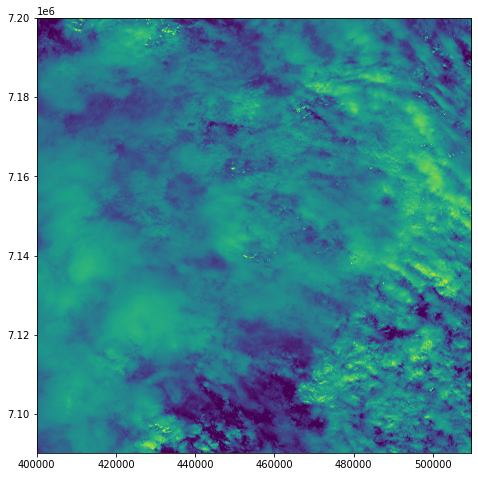

In [ ]:
library.plot_raster(to_plot[0]["tile"]["raster"])

Mosaic framework provides the same tessellation principles for both vector and raster data. We can project both vector and raster data into a unified grid and from there it is very easy to combine and join raster to raster, vector to vector and raster to vector data. _Below we look at a given H3 cellid with multiple tiles within._

_[1] Find index_id(s) with 2+ tiles._

In [ ]:
display (
  h3_df
  .groupBy("index_id")
    .count()
  .orderBy(F.desc("count"))
  .limit(25)
)

index_id count 608598778412269567 8 608215610354040831 8 608598759487569919 8 608598779938996223 8 608208468410630143 8 608598759638564863 8 608215612686073855 8 608215612618964991 8 608222632944336895 8 608222632508129279 8 608202932281671679 8 608198912209059839 8 608215610421149695 8 608598759420461055 8 608598779989327871 8 608219678409490431 8 608215613189390335 8 608598778378715135 8 608200755672776703 7 608206411591057407 7 608202946861072383 7 608205048157044735 7 608208463545237503 7 608199622522830847 7 608200739197550591 7

_[2] Collect list of tiles for the index id(s) chosen._

> Note: breaking down steps for clarity. See that 'tile' column is now a list of tiles for the 'index_id'.

In [ ]:
for_plot = (
   h3_df
  .filter("index_id == 608598778412269567")
  .groupBy("index_id")
  .agg(
    F.count(F.lit(1)).alias("cnt"),
    F.collect_list("tile").alias("tile")
  )
  .orderBy(F.desc("cnt"))
)
display(for_plot)

index_id cnt tile 608598778412269567 8 List(List(608598778412269567, SUkqAAgAAAASAAABAwABAAAANgEAAAEBAwABAAAAuAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAfAAAAYgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAfAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03UUU_20210602T064805_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAANAEAAAEBAwABAAAAtgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAfAAAAYgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAfAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03UUV_20210602T065726_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAAQQEAAAEBAwABAAAAvQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAgAAAAZgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAgAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQE_20210602T065307_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAAQgEAAAEBAwABAAAAvgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAgAAAAZgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAgAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAAQgEAAAEBAwABAAAAvgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAgAAAAZgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAgAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQE_20210602T065307_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAANgEAAAEBAwABAAAAtwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAfAAAAYgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAfAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03UUU_20210602T064805_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAAQwEAAAEBAwABAAAAvwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAgAAAAZgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAgAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff), List(608598778412269567, SUkqAAgAAAASAAABAwABAAAANQEAAAEBAwABAAAAtwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAfAAAAYgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAfAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03UUV_20210602T065726_20210601-222531.tif, GTiff))

_[3] Call `rst_combineavg` on the collected 'tile' list._

> Note: this replaces the initial 'tile' list column with a single raster which uses the average pixel value for any overlaps.

In [ ]:
for_plot1 = for_plot.withColumn("tile", mos.rst_combineavg("tile"))
for_plot1.display()

index_id cnt tile 608598778412269567 8 List(608598778412269567, SUkqAAgAAAASAAABAwABAAAARAEAAAEBAwABAAAAwAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAgAAAAZgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAgAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03UUU_20210602T064805_20210601-222531.tif, GTiff)

_[4] Collect to render._

In [ ]:
to_plot = for_plot1.collect()

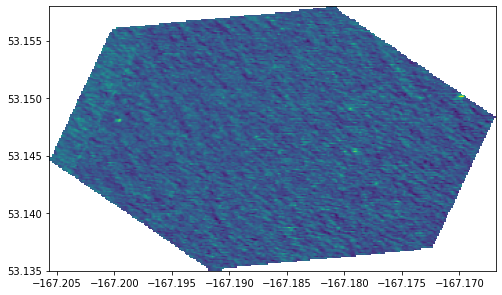

In [ ]:
library.plot_raster(to_plot[0]["tile"]["raster"])

## Raster for Arbitrary Corridors

> To illustrate how easy it is to combine vector and raster data we will use a traditionally hard problem. Extraction of raster data for an arbitrary corridors.

__Notes:__

1. Though we specify a WKT for the corridor below, you can pull any any vector data including popular formats such as shapefiles, geodatabases, and geoparquet as well as supported columnar interchange formats (WKT, WKB, GeoJSON). This is covered in other material, but rest assured that you have the entire arsenal of product, DBLabs Mosaic, and external library supplied functions at your disposal. 
1. We use the same H3 resolution of `7` to match our earlier preparation in `h3_df` as the 'index_id' will be the basis of the join.

In [ ]:
line_example = "LINESTRING(-158.34445841325555 68.0176784075422,-155.55393106950555 68.0423396963395,-154.82883341325555 67.84431100260183,-159.33322794450555 67.81114172848677,-160.01438028825555 67.47684671455214,-154.43332560075555 67.56925103744871,-154.01584513200555 67.30791374746678,-160.16818888200555 67.25700024664256,-160.58566935075555 66.94924133006975,-153.73020060075555 67.0693906319206,-154.49924356950555 66.70715520513478,-160.12424356950555 66.70715520513478,-159.02561075700555 66.37476822845568,-154.56516153825555 66.49774379983036,-155.04855997575555 66.22462528148408,-158.76193888200555 66.16254082040112,-157.94895060075555 65.94851918639993,-155.64182169450555 66.0021934684043,-158.58615763200555 66.55900493948819,-155.26828653825555 67.43472555587037,-161.64035685075555 67.86087797718164,-161.66232950700555 67.44315575603868)"

line_df = (
  spark.createDataFrame([line_example], "string")
  .select(F.col("value").alias("wkt"))
  .select(
    mos.grid_tessellateexplode("wkt", F.lit(7)).alias("grid")
  )
  .select("grid.*")
)
print(f"count? {line_df.count():,}")
line_df.limit(1).show(vertical=True) # <- show + limiting for ipynb only

count? 1,391
-RECORD 0------------------------
 is_core  | false                
 index_id | 608199724226314239   
 wkb      | [00 00 00 00 02 0... 



[1] We can visualise all the cells of interest for the provided arbitrary corridor. Since we are now operating in grid space it is very easy to get all raster images that match this specification.


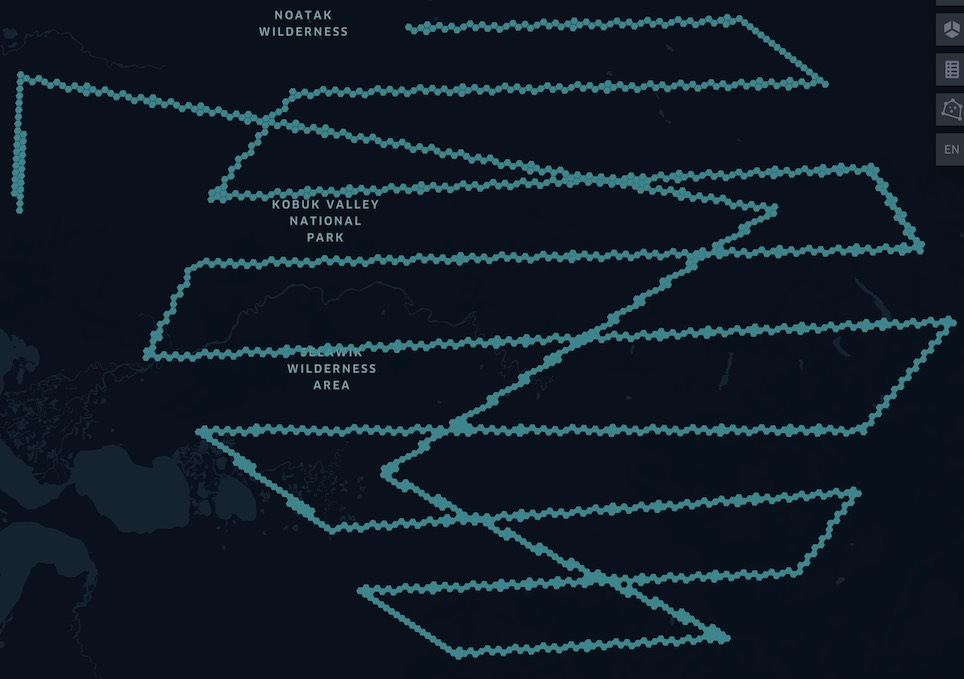

In [ ]:
displayHTML("""<img src="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB4igAwAEAAAAAQAABU6kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH6AABAAoAEgAEAAFhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNAAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAqcDxAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAICAgICAgQCAgQGBAQEBggGBgYGCAoICAgICAoMCgoKCgoKDAwMDAwMDAwODg4ODg4RERERERMTExMTExMTExP/2wBDAQMDAwUEBQgEBAgUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/3QAEAD3/2gAMAwEAAhEDEQA/APw/ooor0zkCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAor3/wAC/CLT/HXwn1XxDp0xXxBb3xgsbdm+S6EdsLh4lXvLt3MmOu3Fbcfwc8Lz/G++8CmW4i0fTLE6hMVYNO0cdtFM6qzDAZmkwDjge/NIj2sdVfY+ZaK9r8eeFPAzfD3S/ih4DivLKzu7uaxntLyVZ3R4o/NEiSAAkMoOQehxjvnofiP8H9H8JfDy01nTXlfV7CS1h1uMtuSKS8gEsWwfwgMQh65JzRcPaLQ+c6K+k7Pw98FG+EL+PrjTNVa7gvE01wt2oQ3Dweb5oUj/AFecfLnNVPhD8I9F8c+GLu/12WSG8v5307R9hIR7yO2e4cuP4o8KEx/e75oQOokm30PneivcfhJ8JpPiho3iKDT4mOrWMdl9kR5BGivcTtFJ5u7GQijJHXIOATgVx3xP0jwr4e8ZXfh3wj5z2+nn7NJNOTulnjyszhSBsTeCFXHQZ7igamm3Hqjz+iiimUFFFFABRRRQAUUUUAFFFFABShmX7pIz6UlFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKAT0GaAEooooAKKKKACiilII4NACUUUUAFFIzKoyxAHqaAQwypyPagYtFFFAgoprOiffYL9TilBBGRyKQxaKUqw5IxSUxBRUyW11LC1xFFI8aHDOqMVU4zywBA455PTmoCQBk9KAForpPCnhDxF43vn07wvb/AGqWNPMfDBVVc4yWJwMnoOp5x0NUdc0LVvDeqy6JrkBt7qHG+MkHG4ZHIJBBB6g0WdrkKrBy9mnr26mTRWhJpGrw2K6nNaXCWzgFZmicRsG6EOV2kHtzz2rPoKTT2CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAM6Nn3r1z/hNNAA5eT/v21eSEZNdP/wAIVrp7Rf8Aff8A9apYztP+E10D+/J/37aj/hNdA/vyf9+2ri/+EJ170i/77/8AsaP+EJ170i/77/8AsaQaHaf8JroH9+T/AL9tR/wmugf35P8Av21cX/whWvf3Yv8Avv8A+xpf+EK17+7F/wB9/wD2NAH/0Pw/orRs9NkvE8wMFUHHqakGj3ZD5wCvT/a+lenY4+ZGVRSkEEg8EUlAwoqQRSNGZVUlQcE0xVZ22oCT6CgBKKtNaTIm+TamegYgE/SqzAqSrDBHY0BcSikyOlLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXtPw6+F1n4/8NzX9pPKL+21axs5YVC7Ra3jbTN03blYMOu3A6Zre+Ifwd0HwXomua/b3s81tBe2VvpLME/0mO5hE7u+B1RMkbMdOQRSv5E+0jflvqeYab4/1vRvDEPhvSj9na31RNWiuUJEqTpD5KgdtoXnnqevHFdXN8bfFMvxSl+K6wW4vblPKngKloJY2iWJ0Zcg7XVQTg8HpxxXS2Hwb0S8+JvhTwO13cLb+IdMtr6WQbN8bzwzylUyu3aDEANwJwTk5xXnfwu8HWPjv4kaV4M1CWS3t9QuGheSLaXUBHfK7gRnKjqDSWpLcNX5fh/SNjxH8WZNcj0jS7DRbHS9I0a5+2RafbF/LkmLAs0jtljuA24xwpI5yMbWu/tD/EDxTYa5pHieRb+x1tSot5MBLU796NBtUHMZAC7ieBzzVPxv4C8GW/gKf4heALu+lt7C/OnXcGopCsiyGMujo0HysjfdIPIz2xXc/Fz4LeGPhzoMl5aQa5K4S3Md5MLQWDNMqsVBTE2RkqOPvDnjmjuTeF4q2p4xZ+Lbx/AF14AZYktpL5NSMhJ3+YkXlBR227evfNdj4e+PvjzwjoujeH/Csv8AZ9rpLvI6REH7U8kgkczbgTyeMLjC8fT0G++BHhWPwQdbgl1aK6Xw8mum5mii/s3cVybbzQocSH+EZJ9c1ymgfBJPEvwtsfHelXTPeNfSpdWh2g/Y4ZVikni4yTHvUuCSADke79AcoNe9tf8AE4k/E/UUXxMtjZxWo8TyRSyiNm/0d4pzcK0JPIPmMSCenGOlZPxA8cXfxD18+J9Utore9lijS4eHIE7xrt85lPSRhjdjg4FeweGfgtoGr/FjxT4BuJb+a38PwzyxfZBCbmcwmMBMSL5e5t/oBkdQKoaR8JfDut/FuTwGP7TsIILOSc2939lF/LNGu4QR4P2cNICCm49Ac+oQ+eCu/K5870V9A6N8KvDmvfF3/hAv+JrpdulvJKYL9beO/eaJSfIj+7BmTjy2PBGc+o84+I3h/TPDHieTRtLttSs1iRd8OrJGlyrnOf8AVAIUIAKsOvPpTuWpJuxwtFFFMoKKKKACiiigByI8rrFEpdmOAqgkknoAByT7CnSwz27+XcRvG3o6lT+TAGvVfgp4g8MeGvH0GqeKtiQLHIscz52wykDa5+o3Lntn3r6x8WeB/B3xzjtta03UMR2geJbq22vv3EFkIYEYXAOeuT6ZrSFLmV09ex5eLzP6tVUKkHy/zH55mSMMELAMei55P0HU/hXrOtfBbx94f8LN4u1OCFLaONZZEEpM0atj7ybQBtz82GOPevs7wlo/gTwVoa+DElga7hZlkRmQ3Esr87gPvAsMFQOgxjpXb30Fxc2aafr6wyWs/wC7n6kMCPuuCMbWPDc98d61jhtPeZ5VfiCXOlShZX69V5H5peGfDWveMpW0Lw3Y/ablEMjNlV2oD1LNgDJ4HPP4GsjXdA1nwzqkmi67btbXUQUtGSCQGGVOVJByPevu3xT46+HfwY1BLTTLBBJfLvmgsVjQgKcJIxJUc8gDOTjI6GtOHwz8Ofi/osXj3V7NJftERVXclWhSMsNj7SAShzuzkdulL2Kfup6m6zqcWq1Sm1Tez63+8+B5PCfimLRl8RS6dcLp7KHFyU/dlScBt3oT0NYtvbXF3KLe1jeWQgkLGpdjjk4VQTx34r9B9N+JXw8+JVu3w+s3LNexNAyNG0cbRqvzeUxABO0ZQDnv2qCw8NfCv4GamNaubj7KdQUwpJcyGRlKncQnBIVh94+oGaXsU9Yy0KWdTjenVpNT6Luj5l+HvwN8TePLCfU3lXTIYn8tDcROWkYfewuUIC8DJ6n6V5fqfh3VdK8TzeEJY/Mv4ZzAIk+87Z+Uquc4YEMPQHnoa+oPGf7Sc2leI7mDwPbwX1mFXMspbEkgHLR4/hxheepHbv65qvxK+HmneCx4oiuobiYRpLHGjoblpmwQDjkNu+9ngDOeKPZwa92WxP8AaGMpyU6tO6lsu3r/AME+NvGnwh8a+A9Lj1nXo4DbySLFugkMhVmBI3AouAcYznrgd65zwz4F8XeMvP8A+EZsXuxbbfMKlVClugy7KCT1wD057ivszwL8VNB+MdzceGfEWnwwJHEsxglcSxzkNz95V4jODgjqQeMUa58Vfh38INVm8JaZp7FFAmkjsVjCxSMMlSCy/MwAOBnGeeop+yh8XNoKOaYuN8PKlepv5W+/9f8AI+EL6zutMu5rDUIzDNbsySo/BRl6g/T8u/SvRfCnwl8aeJddtdJubKfT4bgF2uJ4mVFjUZJGcZYgjavU/QGvsrWfA/w2vrZvinqsEUkoRL83O9/JbaAykrnawwABkc9eteeeP/2j9CGkwjwEWmvzKG3XELokSgHJKtt3lvu4B7k9hSdKMfjZazatiEoYSnrs29k/67/ceHfFP4PX/wAN2s5re4fULa73rvEW1kdcHaQpbOVyQeOlSeEvgR408YeGl8TWLwQRy7jDHPuDSqOjAgEAMeFyOevSvf8A4XfHTRtas7mb4hXtpYX0ThY2Y+UjxEZ+UEtghs7ueeD6Vzb/ALSttD4il0mws1XSWufLS7LkSpGzYaRU27cAksoJ4X8qfLT+K+hCxeYcroRheUd30f5fgfJukaRqWuazD4e0yIvezyeUsJ4YMPvBv7u3B3Z6YNfSXgL9nLU7jWZk+Ia+RbRxZjS3ly0rE4zvXBUL3HUkjt1938b+L/APw50+HxPbQW8108nlxLbeWZZQ3+sy/YYyxLHk47mvmr4g/tA6/wCJbq1PhLz9Hit1JY7kMru3BBI3DYB0HUnnjApOEIfE7spYzF41Ww0eSL6vv5flsVPiV8EdZ8Pa+8XgqzudQ08RK5KkSPG/O5WJI7YI9jz2rqNT/ZqvdP8ABUmupfPLqcNuZmtVVTGzAbiivwxOOAe5rqfBX7Rug6d4QSDxULifVYRJuKRZExydhL/dDMMbicAH2rjPBP7QWuN4itbTxtJCukM5DbI9vk8ExkkZLohwMEdOT0p2pX9fwI58x5eVL4P/ACY8x8B/CzxL481iTS7ZGskgj8ySa4idVXPCjadpJY5xjpgk+/1H8PP2f/DOiQ3dv42jt9Xu2ddm5CESPHG0Mc5Y53H2x2rO+If7ROlaRdWf/CBPBqjkMZ3Yt5YQ9FyMHfnnvgdeorvvBfxG8HeL/Ch8S+IZbW3uMSC5ikdcxiPIwu75tm3lT3znrV04U72vdnNjsVjp01UcXGL6Le/5nzvr37O/iOXxJNNoHkxaLNcfu5WkO+KFmGTsI5C5O3nkAZ4rsPiT+zxpGm+HkuvAUdxNqCSovkPLvMyHhtocgBl+/wBegIrJ8R/tMPe+HrnR/D9hLb3EimKK5kZSAmcb9nUOV6A5APXpXOfC746X/h7VZz48urnULSSHbGxHmPE4OeOhIYdep4FR+6vbv+B0pZk4qq/s9P5vUm+Hv7PGr+JYbq58XSTaQIXEccYVGkY4yxYHcAuCNvc89q8q8R/D3xJoPiufwpBazXTpOIYZEjbZLvx5Z342jII3c8HPpXrfjP8AaN8Rz+IXuPAbJbWSxqg8+IM0rDJ3sCcqBnAHXHJzxj2K8+PfgGLwIb20uBJqBt1K2WT5onYZwWx2fln59aXLTasnsX9Zx9OSqThdS6Lp6/8AD/ccF4Z/Zom07XrO68YXcF3Y5/eQRK43PjKozE/cJ6kYzgDoa0fip8A7a/mtX+GVnBbzRhvtEAby0IbGx8nIByCMY5HPavHfHfxz8WeO9Gj0S4iisYg4kkNu7gyFfugk4KgHnAPJx6c7fwt+O03gTTJ9I1y2n1KOSXzY3Eg3plQGUmQ5IJGRzx06U1Kl8NtO5MqGYpLEuV5L7PT/AC/rc9I8H/s16Hc+GVn8YSyrqTs5YQS4jiwSAp4wxGMsfwHGK8N0D4K+PNV8R2+hX9nLaQOxEl2y/ugiclkyfm3fwDHOeeAasyfHHxzL4nfW2unFnLcCR7FdvlGIEApyM5KDBOeW56Gva/Hv7SGjS6LEvgIO18ZQ2+5hZViVeScHAct93APQk0v3TXa34lXzGlK3xc/3R/r9DpvBPwM8KeBNca91y5XUjNEUg+0oiopz8/BJBYrjHoM4rl/iN8BJ/FniB9f8ESWlpbNEqtEQQrSJnLRiMYwRgH1I/Gvmjxx4/wDEvxCuobnxNJHILddsccceyNcnJbaS3zHuc9BgY5z6N4T/AGgfE3hLwhH4VtrOGdrdGjguJHYMinOwbAuGCZwBuGQKftKb91qyJeCx0GsRGpeb0a6W/ryPcNY/Z98EL4EaHSIS2qfZx5N2zMDLMRldy52/MeMY4H0ryTwL+zvr+qa1Na+O0k022ii3r5Txu8jMcDaRuG1cfMSO4xXAeAPihrfhHxVBrmqXFzfWw3ieFpS+4ODyiu2xWDYORjjI716B4+/aK1zXLm2/4QgS6THCrF3cRtK7N2/jUIAB7k+mOTmpv3mvkNUMwpydCE7qWvM+n9eh9AeEtC+GfwiludAub+3jurorNuvJIxK8ZyEGMD5VbcBgcnnqa891v9nG01PxLP4kF6LbTLmfz5LRYyJERyC4EhbAyct935QcDoK+Qtc1jVPEuoz6vrs7XNzc/wCskbAJwNoGAAAAOAAK9S1n46+PNc8Kv4TvGgWKSNYpJo1ZZXjAwQTuI+YfeIA74xmh1ISVpLRbD/szFUpKpRq+9L4n/kfSHxM+B/hnWNCjs/Amn2ljqayK6FAIleMcOJGAJ24OQcfexXJfD/8AZusTb3bfEMl7jeEjitZmCouM7iy7dxbPAIwAPXNeJfCv4r33w0vrqR4GvrW7RQ0XmbSroflZScgcEgj6enMni741eNfEXiCXWNIu5tKhZVjSCF+irn7xxhmJJ5x6Ae45U37zXyJjg8fG+GhU93fm6+nVn2H4Y8Q/DTw/B/wrHRbmD7TAz2/2Xdl5XOSSWxyzZyx7HPpXBaD+zx4X8JeIrXXNTuzeWcTELBMqCNXI/d7mJ+ZQeAD1OCa+JrW+u7O9j1G2kKzRSrMr9TvVt4bnqdwz713HjT4peMvH9lDp3iWaJ4IXMgjijEasxGAXGW3YGcdhn1xhe2i170dtiv7IrU5NUKtlL4r7/I/RXTNN0rTLuV/DNrBGkijzfJCRoWH3eVBy2Cc+2K5PxN8NfBPjbd4i8W2oM6RlC/mMgRIyflYqQGA5yT6ntXx98NfjZrHw40aXQYLGG9t2lMsYeRovL3AbgNqtkEjP1Jrz3WvGvirX7u7utQv7greszSxLK6xEN/D5YO3aBgYxyBzmrdeLVmjjpZJiI1W1O1tpdX+J93QeL/h38WdEn+H+i3O77TbFWjVGTy41wC8e4BTsJG3Gex6V8w/Fb4K3Pgaa0l8Otdalb3CvvPlh5EdSMfLEv3SD1x1GM9K8f0DxBrPhfVotc0Gc291DkK+A3DDBBDAggjrX2J8Lfj5olxpMqfEO/S31JZdolKkCWM8rgIu1dpJUj8e9TzRq6T0Z0zwlfLn7TCe9Dqut/uPiMgglWBBBIIPBBHUGkr7O+J/wEt7+21Xxzo1xIl5IHu/seEMZPVlVuuWGT1xuPpXxxcW1zaSeVdRSRN6SIyH8mANYzg4OzPYweOp4qPNTfqQUUUVJ2BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADf4h9a+hh0r54/iH1FfQrfcP0NSxnSaT4U13WbKfU7OA/ZrdGkeV/lTCDJCn+I+w/HFGreFNd0ayg1O8gP2a4RZElT5kw4yAx/hPPQ/hmvqHxP4h0m00RvC9rme/urYxRWsA3ON6YBIHCqO5OKj8O+JdHk0aPwpqWbW/t7YRPbXK7GbYmCVz8rqfUE1XKtibnyBRTU+4PoKdUDP/9H8V9Iu4rdnjmbarYIJ9a2JdUs40LK4c9gtcnLEYgGyGVhkEdOOvWti1063jUzXzqR1Cg/zr1DglFbsyJ5WnmaYgAsc4FaMn2C3cQTR7yq/MVznd/KqAjWeRzGdkYycnsP8famzyCaZpQMA9vpxSLtfQtLdQlisikR7CihTkjPU89SakjvYk3KheJQMKExnPqx71mUUXDlQ5neRt8hyTUouJAoRgrbRgbhkioKKB2LkVyzyLHcnMZ4IwBgHuOO1RXED20nlvyOzDoR6ioKkSQoNpG5T1U9P/rH3oFbsR0VNNEI9rLna43DPWoaBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6z8KPixqPwqu9SubG1S8Go2wgKyOUEboS0cowDlkLHAOAc9RUXi74qaj4s8A+H/AU9skMWhIF85WJacrH5SF1IAXYmVGCc57V5XRSJ5I35rantlj8aLuy8f+HPHY06N28O2MFikBlYCZYIpYgzOFypYSkkAHGBzzxV0z4l+HPDXj7RvG/g7w4mnDSpHlktjezXAuGZSgJklXdHtDHhQc147RRYHCPY9Z8b/E2z8ReFT4J8M6NDoemy3TX1wiTy3Mk9wyGMM7yhTtVTwoGM45GOdz4h/Fzw98Qbea6u/Da22qSwxRC7XULh1XylVAfs5VYiSq49uvWvCqKLAoJWse7y/HPUbzTT4e1GxWfSm0W30hrVpmxvtTuiu0O35JlPOAMdPmrO8N/GTV/DGnaFZ6ZEIJdDvLm7WVTkSi6YGSKSMjHllQVIycg54IBrxmiiwezj2PdbL4ux6b8QvEni/VNIjvYvEsE0Fxai4eJVjudhYLKiF+NgAOAfpXKv4u8Ev4sOtSeGQ+nGARmxbULhiJAd3nLclfNDDgBcYFeaUUnG+41FLY9j1/4p6Z4r8aw+JPEuhJd2FvYxafFYm7mBWOHJjc3WDK0ikk7iOc89M1z/AMSviBN8RNbt9Ta1FlDZWcNjBCJXnZYodxXfLIA8jEscs3/6/PKKdhKCVrBRRRTKCiiigAooooAOnIrvPB/xL8ZeBIZrfw1cpFHcOJJFkjEgLAbQRk8cACuDooTa1RFSlGouWoro0W1bUX1keIZZWe9EwuPOblzIGDbs/Udu3HSvSfHXxn8X/EDRU0DWFghtxIJJBArL5pXlQ4Zm+UHnHc49K8lopqTSaRE8PTnKM5R1jt5CAAdKvxanqcFm+nwXU6W753RLK6xtu65QMFOe+Rz3qjRSNWk9y5p+oX+lXsWpaZM9vcQtujkQ4ZTgjIP0JFaGu+JvEPie5S88Q3st7LEmxGlIO1c5wAAAOevGT36DGHRQJwi5c7WodetN2Ju3YGfXvTqKChCqt1GcUuTnJPNFFAGg+r6vJYDSpLu4a1XGIDK5iG05XEZbaMHpxx2rPoooEklsKGZfunFJRRQMYscSf6tFX6AD+VPoopAFFFFMBSSetMMcbMHZQSOhIGRTqKQBRRRTAKXJxjtSUUAFFFFABRRRQAUUUUAFFFXlsJ5LYXMHzg9QOoI/nQDdtyjRRRQAUUUUAFFFFABRRRQAUjAMpQ9CMH6GlooA+lfhp8eNZttas9J8d3aNpKp5e8oFMbIP3bOw5YDGDx1IPavd/GXg7wt8dtPtdQ0bUVEdmzqt1CBJu3Y3R4OOAQGPvj3r8869D8F/FLxl8P7e4tfDcsIjuHEjJPH5gLhdoI5BHAAPXp+e0a2nLPVHiYzKfeWIwb5Zr7jF8Z+FL/wZ4kvPD16Gf7LJtWUKQroQGVgenIIyM8HIrlq/SCw8WeAfid4WPhixuopp9StSJbTeDNHvHzlx1BQnJPrXyN8Vfg7e/DO3tL9bz7fbXLtGX8vyyjhdwyAWBDAHnjGMd6VSlb3o6ovA5oqkvYYhcs/z8/I8YopAQwypyPUUtZHsBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAN/iH1FfQwr546Nn3r1z/hNNAA5eT/AL9tUsD6T+HXxG0bw7F/Z2rWixCQ5a6iBLsT3lHLH6j8qf8AET4laT4itm0fS7NJ4x0uJ1+YH1iXqD6MT+FfNP8Awmugf35P+/bUf8JroH9+T/v21HM7WCx1dFcp/wAJroH9+T/v21H/AAmugf35P+/bUhn/0vxK2GS1jwwAUtu56ZPp9KiEkSH91GD7tz+nSocd6K9M5LEkkrycHhR0UdBUdFFABRRRQAUUUUAFFFFAFx5oJFUyBiVUKFHA49+tRXEaxsHjz5bAFSf5Z9jUFSRyyxZEbEA9R2/KgViOip/Pz9+NG/DH8sUjopVJIxjfkbevT0oHchoqZ7edMFkPPpz/ACqH3oAKKQkDrS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVctb64tOIz8uclfWqdFANX3JJZBLK0gULuOcCo6KKACiiigAooooAKKKKACiiigAooooA3PDniPV/CutW2v6LIEuLViU3DcpBBUhlyMqQeRkV9nfC3446R4gsLl/iHe2djeROFjLkQxvEQDlVZjyGyG59K+FaOxU9DwR61cKjhqjgxuXUsUrTVn36n2H8TfgJcavc6n448OTpEJEa5Fl5RLOyrk7WDALvxuwVOCa+OUlikGYnDfQ5/wD1V9R/DL48asL/AE7wn4ykgGmBBAbhgyyDavyGVyxBU4wxwM5HvXtHxH+HmifF6xtH8M3ltFJZSMTcxqJYyrjBjPlsuTnDdeMe9aypqfvU/uPLo46tgZLD43WPR9l92v5+p+e9FdH4w8M3vgrxJc+GdVdDNbsAGXgSKwBV1B5wQenY5Fc5XP5H0MJqcVOL0YUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADSMmun/4QrXT2i/77/wDrVzH8Q+tfQwqWM8g/4QnXvSL/AL7/APsaP+EJ170i/wC+/wD7GvqXSfhvfarYW179vtIDdQG5SORiH8perEY6Due1Qy+AWNlcXmn6rYXhtommeOCQs2xepAxRZiufMH/CFa9/di/77/8AsaX/AIQrXv7sX/ff/wBjXr1FID//0/w/ooo68A4r0zkL0OmancWrX1vazyQJndIkTsgx1y4UqMd8niqNfoz8KtV0e5+E2nR2li0MLwmF4wjeWzlijsXOcq7ZYsexrx3x7+zdY6P4eF74Je5ur2N40+zuyESBjtOzIUgjqAW6A59a2dB25lqeJSzqDqyo11y62X/B7HyRRX038Nv2eb3Xku7jx6txpojKpDEpQSMepc/fXbjgepz6CvP/ABt8HvFfhnWb+LSbK5vtNtGyt0FU/JtDHdtI5XJBwvaodOSXNY7YZlh51HRjNXX3feeSUVasLK81S7isNNia4nnYLHHGNzOx6AD9fpz0q7rPh/XvDlwtpr9nNZSuCyrMu0soOCR1BGfSoOzninyt6mRRRRQUFFFFABU8cwQAsMlMlT6E+v8AOoKKAJoLia2bfA2D39D9RVyW+gmbzZYAz4xyxx+VZtFAmkWftTLkQKsYPoMn8zmgSWxbe8ROewbAz+WarUUDsWPtLchUQKf4duR/jSbrd+qlD/snI/I/41BRQFiVnTGyNRj1I5P+FRUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVJFMbeVZlxlT36UANZHT76kZ9Rim1ZnvhfAOQpYcFlPX2/Cq+DQHqJRRRQAUUUxZYnOI3Vj6Ag/ypXAfRShS3QZpKYBRSqrMwRAWZiAABkkngAAcknsKfJDNA2ydHjb0dSp/JgDQBHRTS6BtpIBPbPNOoGFFXrDTNT1WZrfSraa6kVSxWGNpGCjqSFBOPeq08FxazvbXUbxSRnDJIpRlPoVYAg/UUE8yvYiopgliLbFdS3oCCfyqQAnoM0hiUV0Ok+EvFWvWkl/oenXF3BC213iTcqsBkg+4BzxXOghgCO/T8adhKcW2k9haK7TwV4B8SePtUk0nQI1Dwx+ZI8xKIg6KGO0kFj90Y5wfSqni/wdrvgjWm0HXkVZ1RZAY2LoytnBViFzyCDwMEU7O1zP29Pn9lze92OWorrLjwJ4ytPDy+K7rTJ49OdFkFwQu3Y33WI3bgD6lRXLxRTTv5UCNI2CdqKWOB1OACeO9LbcuNSMruLvYjr0/4efFnxJ8Nbe6s9FhgnhumEhjmBAV1XbuBUjqAAc+n52/AvwY8YeP9Mm1bTDFawRuY1NzvTzGH3goCkgKeCT3yO1ebXekajZaxLoE8ZN3FObYxryTIG2ADoTuONvqCDVe9G0jnnKhiOahJp23R+jEdz4F+JXhH7PuguZdTtuUyhnVpV5z/ABKVP/fIFfFfxJ+EmvfDO2tb7VbmG6t7lzGJYlKBXA3AMG/vAEj6VUg0jx78H9esPFeo6c9nKsjCPzSm2X5TuQmNmOCp5z9e1fXvww+IunfFmwvF8T2kEU1m6jyW+eIq65DguAN2QwI7D2Nb3VX3ZKzPBUamXfvsPLnpddvT+mfnuCCMjkUtfVvxN+A2p3V/qXjLwkYFsShuFtQCHJVfnEYA2gNjKg+p9q+UQysNykEHoRWE4OLsz3sJjKeJhz036+QtFFFSdQUUUUAFFFFABRRRQAUUUUAFFFFADP4h9RX0QvUV88fxD6ivoZe1SwPqjwncxR6Do8L3VnEf7Ikfypo90pAxmQNn/VL/ABrjnI5HfBs9Stb3RdXSDVdIvyNPlOzT4PKkHA+Ync3y+3ril8LeNNBs9A061m1SK3MFkYJIXgZ2Ev8AC2/H3R3Xo1VrrxbpiaNqMF3rlvfGe1kijjitDCxdhwdw7e1XfQmx8+0UUVmUf//U/D+kYAqQxwCDk9Me9LSFd42DJLcDb1yeOPf0969JnKfopY+LNb0r4Jx+Iv7JMc9tpu7yTtjQBExuCg7gmPmAxnHGAa+cvh/8evEGk+IFn8e3c2o2Pluv3ELxucYZAgXOeQc54PHfP0j4k1H4i2Xwckvmt4l1ZLBTOASzL8oEhVNpUuFyduSM8c1+c6hVUKn3QABjnjtXVWm4uNmfMZVhKWIhW9pFat7a/d+nc+lfiN+0Dq2qa3DL8PbiawtoY9ryMiB5mJzyrq2FToO5JPbGfT/Avx/8MXuhafoGuNImqyqlvI7xEwtK52b2ZeMMTk5x1xXw5SgkEEHBHPFZqtNO9z0amTYedNUkrW69fn3P0LuvCHwu+CoXx0lu1uYyLcks8rESkA+VGSQGyAflHC5HSpktvhv8fbf+0JI5LiHTWMSnMlvKryKrtnGDtxjHYnntXwFqOu65q8UcGrXtxdJEcos0ryBSRjI3E4OOKdpHiDXtAkeXQr2ezaTAcwSMm7HTODg47Z6VXtlty6HH/YtRx9o6r9p0fl+Z7h4n/Z+8TJ4lul8Lxq2jiUBJ5JAWjQ437lJ3P5Zzkjk49c16d45/Z08PW3hUnwYkraqhjCebOxWY5G8BWO1SRkjGAPYVy2lftLSad4Ii0iWxln1aG38lbhynks4GFdxkOfVgByfzrzrwH8afE/hrxFFqPiO6udVswjo8LuCw3AYZN2ACCMdQMEj0p3pL5/gT7PMZLmbtyf8Ak3r/AEtz0j4a/s7y3c94/wASYng8sKsMEM2Cc8mUtGfu/wAIGeuSR0rhvHPwN8VaTr19/wAIlYy3ulwkNHIHRmUbAWVtxVmZTnOAeMd819deAPHOh/FC3n1nT0lgNo4gMLttddwD7j5bEEN25OMHvmuOu/jx4P0XX5PBcaSytFOLZbobWgDOwBLEtuOxmwxwckHnrVunT5VqcVPMMd7eVo3a3j0X4nwbpmnX+tXsGm6VC1xcXLBYo06uSMjGcDpzzgAcmtXxH4S8TeEbiK18S2MtlJOpeMSbTuVSASCjMOCRnnvX3prejfDH4Owf8J2lilvOG8nMQzJKZT8yopONx+8SMYAPOKbpN78O/j5avNcWjXMGmSbRFOCjh5FB3fK2dpHA56g+1R9X+y3qdzz2TtWjTfs+r63++3Y/OuivpnxT+zrrsniG6uPCRhXRzL8jPIS8S4G/CYJcIc4+bJ6e9ej+Nf2dfCsfhVk8HwyLqq7BE0krsJiD8wYMSoLDPzY+X6VCoy102O2WdYZci5vi/D17Hw/RXXeLfAvijwPeQ2PiW3EMlwjPHscSBlUgE5HoSOPer+ifDDx34j0I+JdFsDPZguN4dQT5fDFVJBIBBGR3HFZ8rvax3vEUlFVHNWfW+hwVFXdL03UNbvrfTNJhae4umCxIvVyRkYzgdOeTgDrWt4j8IeJ/CFxFa+JrKSyknUvGHKncqkAkFGYcEjvS8zR1IqSg3r26nOUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAwyxK21mUH0JApxIAyeAK/Q34SDwfcfCewtbW2GyaFkmjkXLyTMSknzEAHc3QjjGPSuU8M/s9+GvBWt2/iHX7/7bbQH5YpkVY1kPEZds4YKeBkDLYNbewk0mjxHntKMpwqRaa0Xn/kfDiujjKEMPUHNO7Fuw5Jr72+I3wa0b4jXdte+FZ7awe3VllkSIPHJuIKg+WVyy8854B961PDHwn+HXg/woH8SW9pcXNkHmubydF3Iy/MWUnlUXjaPTGcmj6vK9iXn9HkUrPmfQ+MNT+GXjzRvDy+KdT054rFkRy5Zdyq5AUumdy9RnI474rntC8Oa94mvG0/w/Zy3k6IZGSIDIUHGTuIHU4689u9fcXh34w+EfirfnwHcWcsS3sbh/P2bJlUZZFAYsGYc4IBAB7ir2p6z8K/gRfLbW9r9lfUxudLdTJIBH91mBOQnJAHr0HU1XsYv3lLQyWb4iN6NSl+8eyW1vv9T4D1LS9S0a/l0rVoHtrmEgPFIMMpIBGevUEHipJdG1mCwTVZ7O4S1kAKztE4iYMcAhyu3k9Oee1foFc+APhz8V4IviDfwtJ9rhUxuJHjXy0ztEighSRzuz247U+Dxv8OPipYTfDvTLjzDdQMrxhGQLGmAzRsQFO3I2EZ7HoKXsO79B/wButpctJ6fF5d/13Pzrjjlmfy4UaRsE7UUscDrwMmmsGVirgqR1BGCPqDzX6E6J4U+GXwPv31K7vRbnUV8uOa8kUldpyyKQBgNkEnHbBPQVneLPgv4Z+KepnxtaX8tut3Gm024QpMqggSZZSQWGACOwBo9g7aPXsaLPqXPeUWodH5nwlpVhd63qkGi6Svn3Vw4jjiUgsWJ9OwHUnsASa7zx18KfFvw7s4L/AMRCAw3EhiV4JC4DYLYbKrjIBx1r7L8ReOfh54C8GC40KS1eWxVIrW2hdDJ5i8CNsZYDghyegzWZ8P8A4oaB8XpbrSvEFhFb/ZAkqwTMsscmSRv+ZV+ZCMAY4zn6NUY/C5amUs3xDX1iNK1Nb9/6+8+OvCfwz8beN7OXUPDNmJ4YX8tnZ1jBbGSF3dSO/p9a417K7jvDYNG3nrIYdgGW8wNs247ndx9a+5tY+NvgP4bavceENLsmkt7U7mNoI1hid/mdcZBOCdx2g8kjqK7LxBoHw18M25+KmoW0AuYCtz9qVfmld+AFGcFnBwo9celHsU/he24/7ZqwlerS0l8Pd+v9fefAviLwX4s8JiNvEunzWSzEqhk24YgZIBVmGQOcVkWOkatqau+m2k9yseN5hieQLnpu2KcfjX6B2Ou/D74+WE+imKWS3smSV0kBhlDNkKyFTkD7wJHXp0zUVp4r+E3wXkm8GLcG0df9JZQskzt5g43uAxL4XChjnbt7UewW/NoCzqrZ0nRbqLou34s+f7P9m3xLc+EB4hlvEhvTC0wsmjJPALKhcNwxGM8EA8c15J4H8Ca94+1tdE0hPKbZ5sksqsEjTHBbjueAO5+hr3HRv2j9XuPEsVnq8MEOhzXG1htPnRQsTjc+7B25Bfj7uQCetepfEL49+FfD0VrceD5bbWLt3YMscn7tI8c72UHknG0Y9T0FHLTavcX1rMKcnSnC7lt2X9eb+8+QviD4A1n4bapDpevSRP8AaI/MjljyEbBwyjdg5XjP1Fall8H/AB7qPhIeNLO1RrNomnUeZiZo153CPbzkcrzkivsbwF8QPCfxI0B9Y8SpaQ3MbvHJbzMriNV5BXeASrLhicdeO1cnoX7QvhzWfEEPg+G1khtbiY2sN4WXaUOVQlOo38KM+oJ9KPZQ3ctGT/aeMcXBUvej8T6fL+n5Hxbouh6v4i1GLSdCt3urmcEpGmMsAMk5JAAA7kgfmK+g/h7+zrqeui7k8cG40ryiqxRJ5RkYkZLNneoXHA7k59K968SX3ww+CbQazbadDaTXhMPl2kaiV0GCzdR8qHGeec46kCu28G+JtM+IGlf8JPoskscLM0IXhXBjYg7xyM55A9PrVU6Eb2k9TDGZzXnT9pQjywfXz/I+CvFvwl8VaD4rn8P6TaXF7B5qxwXAjJRhJjbvdRtUgnDdAOvtXZ+Pf2fdT8FeFm8SQX/29oTH50SQlSoY7WZSGJIUn0zjmvefEfx48BaDpV9pNpM93f2wkhWJUfZJKCV/1uNuM8sc8c964H4a/tA3Gr64bH4kXFrbW6xF4ZwpiUSrgYclmBJBO3pzn2pOFNO19/wNo4zHygqqhZR37y/D8jw/wB8I/FXxES5n0wx2sFsQpluAwDOedigDJIHJPQcDr04vxL4d1Lwp4iuPC+pgG6t3CYTJ8zcAVKDqQ2Rjjrx1r6+8bftHaZoGui08HQQatCYwZZvNKxl+wQqrZwPvfgOxr0JvF/w8vfBI8f37QM3krcliI2uEl4woHJDhwFA9sUvZwatGWqL/ALTxVOSq1aXuy2XW581+Ff2dvF9zrtkvi6NLXTpDulMcu6TAG7y8AfKzdM5455zit74pfs/nSfsk/wAOLa4u9+8TwGQSOoGNrguRx1BGeuMd6q+Ov2kdR8Q6GumeGLWXS53dWlnLozBV5xGVzglsZJHTOOTVv4X/ALQUWiWV1a/EKa5vZXkVoZ1QSME24KNjbwCMjjuaSVL4fxFJ5lpiWlp9ldfP+mO8H/s0za14aGpeIr2awvpS2yBFjYIBwBISCdxI5AIx068nxbw98L/GOv8AiOPw2LSS3cuyyTyRuIUVD87hyAHHHy7TluPqPRrv9orxbN4mkurXbFpD3AJtdilzDkBhv6h2UEnHQnHvXsnjz9obwnY6LFJ4JnTUL7zVKIyuqRKPvFwQvUfKFHc+go5abWj2/EftsxpStKPNz7do+p80/E/4T6t8MBaXF9dR3dtdllEyIYwrrzsYMzckZIOexqXwr8FPHXi/QU8R6XHAlrIW2GaQq7KvV1UKcr6fMM9uxr6e+GPxn0PxnaXDeNZbOwvYX2pG7hY3jIzuTzD1zkN+HauK179pmDTLm+0nwvp63EMZdLa5aTC5/vbApygbJXnkY6Cn7On8V9BRxuPf+zxp++t30/RG14g/Z08JQeCHGh+a+rpApimaV9s0wwcGMnYPM6cDjOe1eZeAf2eNd1rUbiPxys2lQQoCio0bSSMxwCCC6hVxz3Jx078b4C+L/iPwv4mh1XXbq61Gz+cTQNJuzvH3kDkKrBsY6AAkCu68f/tFaxq19bHwGZdNhiQ+Y8ixmR2b+Eg71CqACO5PpjkvTfvW+Q/ZZjTboRle+vM+nl/SOH+Ifwg17wj4jfTdEgutSsiiPHOse4gtwUcoNqsD64GCD6mvV9C/Zke1ax1XxVqCNCpSS7tkQjA6lPN3YwDwx28jOMV0/hX9ovwpD4LRvE7yvqyRv50SRNieQZAIcDYPMGCRkBenavAPFPxw8deLdAk8N3zQQ2s2A/kIyuyD/lmWLHKno3A3Dr3o/dx13HCWY1rUfhto3381/wAA+lviZ8E/D/ifTILfwHaWVhqEUgcsiiNGixtKuUB+q8dR6ZrJ8Bfs4+HrfSJk8exi7vTKf9RLIixoPugMu0ksPmJI747V87fC/wCK+p/DF7uO0tY7y3vNhaJ3Me10yNykK3VeCMY4FUvE3xX8Z+IfEkviSK7ls9xXy7eKV/KVUwVRgNocE/eLDJyR0wKHUpv3mtSVgcck8NGp7q2l19N7nZf8M/eM5fFY0+OHZpMl0VS9LoV8gklW2537tvygFeW9ua+kvCXwV8GfD/xBHr0DzXT7WSP7RtYRMerKFUclcrk5x7ZNeTeLP2mItV8MPp/h6yntNRlCAzSeWUjxgsyYYktx8mRx1PTBZ8LP2gBaSXcXxNvJZiQht7gRbyB0ZCIlGBnDbsc5x2FVF0oyMMTDMa1FymrJaWW78+v9dD0n4lfBez+JerR69o93HYSRRGByYi6ylWyvAZcbMsCe+fatKL4MfDpPBP8AYJsoZLvyGj+1Mqtcidhgvu6hg/QdAOOBXifij9pXxAmu3a+DI4FsGOI3njZpGOMGT7y7c9lI7ZPJxXhPhXxfqvhXxZB4vtz59zHIzyeYx/feYCHDtyfmz1xwcemKUqlNPRblUcvxsqSjKpy8uqXX0f8ATPojwT+zVfxa6P8AhYLwyWgiJWO1lfMj8DlsIVVc5468ds5xfif8BdT0/W43+HFjLd2RhHmxiUO8UgJ6mVwSGUggDpj3rmviB8ePEvjSO0g01H0eO3JdvImYs7kYGWAQ7QCeO5OT0rvvAH7RtnoPhZdL8Vw3V7fQmQrMNreYCSU3szBt38JOOnNL90/d/E1lHMoWxL1e3L09dzV0T9mnRINFtdY8S38pmRUnuYE8vyCoIZ03Fd23bkE7ua9T8ceFPCnxU8M/2B4aurQTRPHLHPAEkWEL/eCEHDrlQM/yr4x174v/ABB8R6Xc6JqN9iyumJaFEVQELbvLDABtg6YPUdazvh98QNb+HOrTanoSxObmPypI5s+W2DlWO0g5U5wfc0KpBe6loxzy3GT/AH06vvxd0uh9deAP2f8AwtoCXcHjCO31m5dl2F4isaR442BmJ3E53Nn0HavJdf8A2c/EVx4nlm8PmCLRZ7geXIz4eKFiN37vbyFJITnkYz3rxvxv468TeNNek1jWJmglCiNI4GZEiUDovOTk5Yk9SfTAr2fVv2l9Wv8Awg+iWtj9n1CSFYmug4ZAcAOyp1BIztznB65xSvTata1g+rZhSkqsZ8zlv2X9eS+TPZovhr8KvhLf2/jS6doFhbyhJdTF1V5BgOA2fmHI46Ak1N4z8BeFvjhb2muaTqARLYPGl1AFkEgJBZCD2Ujr1zketfC+t+LfFPiWOGLxBqE96tuSYxK2QpPBIwBzjjJycfU103gz4r+NfAdlLp3h+eIQTP5hSaPzAGIC5X5lxnAz780/ax+Hl0FLKcSkq6q3qL7rH2t4f+Gvw+0TwofDFxb293MqvHNI6o07ytwSO4PI2gdBivGPCf7Mt3Y+Irc+MbmG709QxMcJcPIyj5Vc4GARkkg84x0NfM2l+I9U0vxRD4xR/Mv4pxcNK+NztnLBmx0cEqfQHgcAV6p4++PHinxtZQ6dbRDSoo38x/s00hdyOFy+EKgc8Dqfpgr2sGvejsP6hjaUnGlUupbvt6f8D8D6bN/8IfgZqT2A/wBAl1CMSsFWWdwqEgbiNxVDk7R0JzjmqXif4MeEPiNqP/CetdTR/bI45SkJQRzIo4ZmKlgzpwWBGOPSvgq7vr7ULj7XqE8lxKQBvldnbA6DcxJwO3NddD8SvHUHhk+D49RkGnGLyBFtTiP+6HxvA7denFP20XpKOg3k9aDVWjVfP1b7f1/SPufxHoHgf4k+D38K+GLizbKRtC8Gx/JCEFGYIc7eMYzz0rjPAX7PHh3Qp7seMRDrEjhBEpjKxovchWZiWzwTnp06mvkTwJ441j4ea2dd0NI3d4mieOQHY6sQedpHII4Pbn1q543+JHibx3rSa1qMhtmhjEcUdu7oiDqxBBByxwST6D0odWD96UdSY5ViqbdClVtB6363/P8AE+0dM+Jvww8HaofhxpH7hrefyIkijbyfMkYfKZANoO9sMT396qT/AAm+GPgXWV+IGqymFYbjzW8+QC3SSVjhguONrtlRnA/AV+foZg28E7s7s55znOc+uec+tdVr3jrxj4otIrDxFqU95DA29EkK4DYxn5VUk4J65pe3/mXoW8klGS9jVaT+Luz9MNJ1jSvEQGr+GLmC6gwY2ljO5GI5Cgr1K9/risnX/DfgzXraXUvG1naXDWivuedQwhQcnBbkDHze9fAfgb4reLvh7bz2mgNC0Ny4kdJ4y43AbcrhlIyAAevSuI1fV9R13U7nWNVlMtxduZJWJ+8T2x6AYAHYAVbxCa1RyU+H6kajtUsls+v6H314d+KfgT4o+Z4DtElU3Nu6Os0YRXiUBXCcnkg5AwCBz1GKdpvh/wCEvwV1c301yljLqMZSNruYuwVDlgpbJCnIz9Bmvz8sL+/0q8j1HS5nt7iEkpJGcMpIIyD24JFWtW13W9evBqGuXct3OqhBJK2WCjJA7cZJqPb9WtTrlkVpOFKo1B7rz/I/VCzunv7Q6po8kclvcKJIT94OCOGUggYfqP8A69ef+L7z4c+DrD/hP763tpLyF1ZJkRGuJZWG3Abg7mXIyTwPQCvizSvjJ4+0XwoPB2m3MUdqkbRI/l/vkRuyybuMZwDtOK8pSGGP/Voq9uABVyxN1ojmw/D8lNupOyv06rz/AKZ+i+ma14E+P2kXGnSwS/Z7KVGeOQ+XKHKnaylGJC4yMgjJyOg5XSvEXwh+Eq3Xg9L2GzeFzLJG7NJIxdQRuY5LNtwACc4xXwDpGv674fme50G9mspJAFZoXKFgDkA44OD0zVC4urq8uJLu7kaWWZi7u5JZmPUknqTU+3+1bU6f7BTbp+0fs+i8z7N8GftCp4n8R2/hfVLKOys7t2ijmMpLgHJjVxgKuRhSQx5+tcv+0hpfgLS7TTI9Bht7bUWdiUtkRQ0AXBLlOBhsbe/Xtkj5SIBGGGR6GkWONOI1C/QAfyrN1W48stTrp5TTpVo1qLcUuncdRRRWZ6oUUUUAFFFFABRRRQAUUUUAFFFFADOjZ969c/4TTQAOXk/79tXkhGTXT/8ACFa6e0X/AH3/APWqWM7T/hNtA/vyf9+2/wAKP+E20D+/J/37b/CuL/4QnXvSL/vv/wCxo/4QnXvSL/vv/wCxpBodp/wmugf35P8Av21H/Ca6B/fk/wC/bVxf/CFa9/di/wC+/wD7Gl/4QrXv7sX/AH3/APY0Af/V/D+pIbea7mSzthmSZljQZ25ZyFXk9OSOe3Wo6tWNkNTvYNMaRYRcyJD5j/dTzGCbjjnAzmvSONuyufoP8UbPxla/B28jN6hure0Q3TRpt3omPOCkscblzz1+lfncRg49K/QP456HcxfCW4hk1GQ/ZPILecyj7RsYDacKMs3VV6FsV+fp6+tdGI+L5HhcPa0JO/V9PQSiiisD3gooooAKKKKAJoLm5tW32sskR9Y3ZD+akVCRuzu5z1zRRQFupbub+/vESK8uJpljyVEsjuFzwcBiQPwp1jqepaY7PptzNbF8BjDK8ZOOmdhGcds1SopC5Va1j6c0b9pTUtJ8FxaA1i0+owW/kpdyOChYDCu6/eOBjPPJrzvwB8W/EHhHxLFrGr3F1qVsI5I3geYt9/B3KHO0EEDpjjIHpXk9FaOpLR32OOOW4eKnFQ+Lf+unyP0V8Ka/4H+OVlNdappqSrYSBFt7tUcqXUNvGCR83Qc8Yrm3+Ovgjwvq48BaZbyGC1mWzjuI/L+zxgsF6bgxWMnaSBztr4QR5IzujZkPqpKn9KYAAMDgVp7d9Nzz1kNLmalJuPRdj9QrDwF4O8MarHrfh7TYob5yyF4xhpFfl8noOgYn8O9WNf8ACGgeO3W08WWCzx2uHiRic5cYLbkPTjGPxPavz9+HnxL1r4f66NXQPfRNE0TwSzOFIYgggndggj05rV+Ifxh8ReOtWivbVptNtoI9kcMMzqcnl2ZkKliSBgHoB7mtPbx5dvkec8kxPtlafT4uvpvc7/xT+zpr03iO5n8JmGPR3lGxnkJeJMDfhCDvCHdj5hnp716J43/Z18Kx+FjH4OhkXVVKCJpJnImIPzBgx2gsuTkDj6V51pf7Smqab4Lj8P8A2AyahDb+Ql2zgoWA2h2TGSQOSO59q4L4d/F3X/BviFNS1ee51O0MbRPDJKXPzYIZN52qwI7YBBx6VHNTWlt/wOv2OYtczlbk2X83r/wTjvFngfxR4IvYrDxLbeTJOhkj2sHVlU4OCvoSMj3FXNL+G3jnW9BPibSdOknsRvPmAoMiP7xCswYgc8gc44r7f8Mar4C+ONk+q6npsdx9gkMKwXao7RbgGLZBI+cY6Htjrmueg+OHgjRNYX4e6bBIsdvMtjDcIqG3XJCDjcG2oTtPGCR6c0eyju3owWb4mS9nCl78fi7W+8+FtL03UNbv4NM0iFri4uW2xRp1ckZ4zgdATknGK0vEPhbxF4Tu0sfElnLZSyJvRZNvzLnGQVLA4PXnI/EV+julfDrwT4O1aLV/DemR2944aL93wWRsb+p2jGASRj074qfxN4F8NfECWOPxXZmUWfMSh2Vh5nUkxsMg4wB6j1xT+qu2+pD4jj7RNR9z8fzPy8or6K8Q/s9eJv8AhJrgeHlRdFacCO4eXc0cRxuJU/M2w5Gc84/GvRPiD+zroVp4aEngWOZtTjdAqSTFhOOjgBjtVsZYEYHGOBWXsZ6ux6bzjDJwXN8X4evY+MaK3/EXhXxD4SvxpfiS0e0nZPMVWKncpJGQVJBGR659atW3gfxhd6C3im102d9OVWc3AC7Nqfeblt2BjqBj0zWdntY7/bQspcys/M5airdjYX2qXken6ZC9xcTHakcY3MxwTgAewJ+lTapo+r6HdfYtatZrObG7ZMhRiD3Geo9xQXzK/LfUzqKKcqPIwjjUszcAKCSfoByaBja+s/gt8F/B3jHwf/wkfiJpLmWeZ0VIZXi8kRnbtbaRuYkbueACAPU+S/Dn4QeIviMLqe2kWxgtcL5k8bENIedgUFTwOSenIH0+y/h54B0fwD4Nm0rULjfIDJJeSh2RQxGCVGflUIBjuep5rejTu7yWh4GdZhGEPY0Z2ndbHJax8a/h34R8NXHh3RJPOutPjNrDbRRusZeP5BiQDaFBGSQe3rXyp42+LfjPx/psej+IJYfsyP5hSGMxhyBgbwWYMB1A6Z5rziZLSKZ4rBzJbqzLE7DBaMEhGI7ErgkVFWcqspqzO3CZVQw750ry3uz1X4efF/xJ8NrCfS9IgguLeeQS7JtwCNgKdu3GAQBkY681wGu65qfiTV7nXNXlMlxdOXkboPZQOyqMAD0HrzWTRU8zaUTsjh6cJurGPvPdj45ZYZFmgdo3U5VkYqwPqCMEfgalury7vpftF7NJPJgLuldpGwOgyxJwOwqvRSNra3Nu28TeJLLS5NDs9QuIrKUMHgSRhGwf72V/2u+OtVNJ1bUtC1KHV9Hna2urdi0ciY3KSCpxkEcgkcjvWfRRcnkjqrb7+Zv+IPFXiPxVeJqHiO9lvJo08tGkwNq5zgBQoHPXjJ79BXT6N8WfH2geHj4W0m+EdntdFBQF0EhJOxzyOpx1x2rzmimm1qmRLD05RUJRVl0sMWONPuKBgY4HYUrJG4xIob6gH+dOoqTYQKqjaowPQVbkvr6W3FpLPK8S4xG0jsgx0wpO0Y7YHFVaKBNX3NPSta1nQbhrzQ7uazlZdpeFyhK5zg46jPrVW8vLvULqS+v5XnnmYs8khLMzHuSetVqKYuVX5rahSli33jmkooGMaKJ+ZFVvqAf50/nOQeaKKQD3klkx5rs+OBuYtj6ZzitLT9d1zSY3h0q9uLVJeXWGV41Y4xkhSATjjPXFZVFMTimrNCAAAAdBwKcCQcjikooGKSScnmo/Lj3+ZtXd/ewM/n1p9FIAooopgFFFFACEAjBGRS0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsszTbS/VRtz3OPWoqnS3kkgedRwhGfp/9aoKAQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAN/iH1r6F7V88/xD6ivo+zs5tRuotPtwS9w6xrj1c4z+Gc1LA7BPA2oac8Vz4sZNNtDtYtIwMjr1Kxou5mbH5d6XxT4f0qMvrHg6Q3WlqAHOSzwv3DggMFPBVjx79Kua5cz+KvG02mxpJehd9pZoJNm0oNobJ7blLMD19az7PUbXw9cWLaZHNHqcErR3quw8qQbtvl4GeD0PH5nBpiOK4PIorr/iM1veeMbwWMa2kcDeTtiAAYoMFiMdTXEfZX/wCezfpUsZ//1vw/rW0CysNS12y07VJzbW1xPHFLKOqK7AEj88Z7Zz2rJro/CA0JvFWmp4mUvp7XCLcAHGUY45/2dxG7/ZzXpnDVdoNrsfZv7Rem6BD8O086dkuIbiL7KpkZzIw+Vhgk5/dkksenWvg+vtf9pe68JJ4UsrJVQ6g1wGtvKAG1F4lLH+7tIAH94r6V8UVtiPjPJyFNYVN33e/9f07hRRRWJ7IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD0lmiOYndP91iv8iKjwAMClooA9Y+HHxa1vwFrD310ZtStpYjG8EkzHnIKspfdgg54HXPsKl+IHxi8SeNdaTUdPkn0q3hj8uOKCZlbnlmdkK7iT07ADjqa8ioqud25ehy/UqPtPb8vvH1RB+0vdW/glNHFi76slusP2linklwNpkKA7unO3GCfQc1xPw6+N+v8AhfXDd+K57rVrNoWj8tnVnRsgqylyo7ENzzXhtFP2srp3MVleGUZQUPi/rTsfoxpEXw9+O+mjxFqFh9pS1d7dI5vlki6FslG/jGCOemO+az9L+L3w8XUYvhrphIZH+wRP5YFqcfIAGzjH8OMctwOtfAlpqWpaeGFhczW4f7wileMH67GGfxqmhMZVoyVKkEFeCCOQQR0x2x0rT6w+iOD+wYu8ZTfL9ldj9L/Dnwu8EeAdWj1Pw1YslxIhh+aR5GCYBJUOxC9Buxjijxf8NfC3xKu0uvEkMyvZqYozHIY3w+GO7aSCOm38a+Qvhj8a9W8G6ncS+JXu9Vtp4ggVpd7o6nIKmVsYIJDc84FReOfjn4v8ReIH1DwzdT6TZqgjjhQpuPq0mNwLEnjBwB75rT21Pltb5Hn/ANk4z29+fVL4rv7u5LefATxn/wAJVJpVhAx0xrny479inliItwzDduyB8v3cFh2Br6b8KfBXwd8Pdfh8RWb3F1IoMaCfD+W7Dl1CKDkjIPoDxjmsrwT8dfDnjOSw8JTQy2uoXarExKjyd6puYIwPfadmQK9F8Z+OPDPw6Ntf+I55ALktHGoDSycAEsFGTt7MfpVQhTS57mOMxeNnJYaomm1suvmeUfFT453PgXxQmi6BZJcOIVe4M++MHcfkCYGTgA5OMcgDocfI/iW88X+Kru58aaxb3LR3ZLNMIpBAEHCqGxs2KOBk479Sa+5p/Bvw6+NlvH4zuEllR1aCKSN3hfbGzA7wMHIYnAboPqaksvHHwz8SWp+Fml3EbPIj2H2ZUZY9qKVcIcBSAFJGDzUzg5v3padDbB4ynhopUaLcl8T7f18j86oopZ5BDAjSO3RUUsx78AAk8c9Ka6PG5jkUow6qwKkfUHBFfo74M+E3g74b6wdW0nz55p4jErTHzGQDBYqFAxu43HHYVQ8dfBvw/wDE3V/7fnuZrKVIxBmJU+fYTguHUkYJIHQ4/Cs3hpW8zvXENF1LWfL3/wCAfnfRXpen/CbxrfeKk8LNaSxbp2iNy0beRtQndIH+6RtGQAcnp646r4nfA3U/AFnbalp1zJqkE0hjcLCQ8bYLAkIWypAIzgYP14y5JWbses8dQU40ufV7HhVFe6eA/gJ4n8caCde+0x6ejOUhSeJy0gXgtwy7RuyBkHOM9K8Uv7WbTNQm0q+AjuLeR43QnkMhIPHXHGQfTmk4tK7RdLE0qspU6cruO5WoprOiDLkKPc4pQQwypyKR0C0UUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANGx1Brb9zJzE2cjuM+lZ2McUVZW6cQGBwHGMLn+H6UCtbVFaiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA3+IfUV9SeGfEN54X1aPWbFEeRFZdsgyCGHPTBB96+WujZ969c/4TTQAOXk/79tUsD2BvEOg6lcm61fT2tp2YubjT5DE24nJby3yufcEGrmj+GNM1jWbVdC1OKZmnRjDcq0MxCsGbH3lc4B6HmvE/+E10D+/J/wB+2pyeONCjYPHJKrA5BCMCD7EUXCx6d4xt54PFupxXON/2mQnByMMdw5+hFc5tNcm3jfQnYu8kpJOSSjEk+5pP+E10D+/J/wB+2oHY/9f8P67n4ZXVhZ/ELRrjUrc3UIukBjClzubIRgo6lHIbHtntXDV6j8Fru9svibpUthafbXLsjIACVR1IaQE8KUHO7PTI6mvUjujzMW7UZ+j8uh92+OfBWh/Em1h0XXFlRLd/PEi/JIDgrhSQeDn5vw9a+Efi74Dsvh54tGi6bM01vLAk0fmMDIuSQQ2AO4+U45H0r9Gij3l6qzK8PlKWXa3LbuDyp6Djj1we1fnr8ebOys/ijqAsrg3BkWKSXcxYxyFcGMk+gCsB23V14lK3NY+X4frT9r7Hm9217Hj9FFFcZ9gFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFW7CwvNVv4NL05DLcXMixRoP4mY4A9h6nsOaqV6v4N+FHxB1y70zVrGzktLW4kilivX2bEUMGWTbu3HplQV5OOxzTSb2RlWrRpRcpyS9T6A8H/s623hPxBZ+IfEeox3kNsQ/lCMxqJv4CzFzlVPTgc4PtXHftPSeGpNS0pdOlVr+OOTzUjwVELkFSxHRt68D0ye1ei/tL2+r/APCAwul0GtRdxi4iYKvmA5CfXD4Yr079q+ElREGI1Cj0Ax/Kt6zUb04o8LK6dTFSjjq1S7V1a39d+x0Om+K/FGjWL6ZpGpXNrbSFi0UUhVSWGGOB3I6kYrM02/vdHvYNS0uVree2YPFInBRhwCOo6ccjFU6K57n0HJHXTfc+o/hj+0HPpU13F8R7ie8WQJ5Eyxh3UgncpCBfl6EcZznPasXxX+0T4tufEdxc+E3Fvpu5dkLxrvkC/eZmPKGQccfdGO+a+dqKv2srctzgWVYb2jq8m/Tp9x9y+LP2jPB8Xhct4RZptROwRRSQuiREYJZtwAITsAfm6dMms74Y/tAWeqTXS/Em6trOWML9nlCmNCGzvXGW+bgEnPIwO1fFdKCQcg4q/bzvzHP/AGFhlTdNJ69ep+sFjdNq2nf2rok6GC6XzYGA3Bgw4YHPG7r04rhPEMHgT4m6BceDNNvLaaeVQR5Tq8sDRsD5hAOfkbqD1PB618Mab8UfHekeGj4R06/MVgUeMIFG9VcksFk+8vU4weO1YPhTxRrHgvW4fEGgukdxCrIN67kKsMFSuRkdO45ArR4hPRr1POp8P1IOU4z1Xw/pc+3vAXwX8K/D3ULi61y4j1CW6URwm4RERVHLKFYkFicEn0xx1J43x7+z4/ifWLvxL4PuLe1hmUMtsYztd1XBMbKwVVbAx8vXJ718x+N/HfiL4h38N/4neOQ26bI40TbGuTkkIS3zHjJz2H4+q/D74+a14csNO8I6rFE+nQFIGnG4TRwlscY+U7FPXrgetTzwfutaG0sFjqX+0wqXm910t5f8MeOeE/Cur+M/EMXhnRlH2p87w54iVfvNJjJAU8H3wK1/Hvw88Q/Di8t7PxEYT9rVnieJyynYQGHzBcMMjj0r7R8ffGLwb4Q0mHVPDclrqd5JIEjigkXBT+MuyBiqgdODlsVY+H/jzwz8WtLmvNetLeKa1l8v7POUkVQQCHUuBnd0PHBGPciox+Dm1B5tiUliXStT2fe/9eR8aaN8JPHviDw3/wAJXpVmslmQ7LmQK7KnVlQj5gcHBzz2rzcfMiyDowBB9Qa+8LT9oDwhD4gXwXp1vItqJ1tIbtNghUFggIT720E7QcYPB6VY+JvwN8O67o6xeC7K2sdVEocOP3ayL0kEjKG7HIOPvYpOimrwd7GtPOKlOpy4yHKpbenmfA9Ffa/w8/Zy0i3srk/EOMXV2zgJHBK4SNAOCHXYWL+4wMY65J8w1T9njxWfFD2+kKg0aS4Cx3TSKSkLEclT8xK52jrkgE8EmodGSSdjrhnGGlOUOa1uvR+n9eh870V9dfEf9nXT9L0WO78ALc3N4JVVoHkDmRCDnZu2gFThjz0zXyzrGiav4fv20vXLaS0uUAYxyDDYboeCQQe2DUzg4O0jpwmOpYpc1J/Lr9xl0Voto+sJYLqr2dwLVhuWcxP5RBOARJt24J4HNZ6qzsEQFiegUEn8hzUnUmnsJRQQQcEEEdjwaKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRViUWuwGAsGHUMBz9MVXoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBpGTXT/8IVrp7Rf99/8A1q5j+IfWvoYdKljPIP8AhCde9Iv++/8A7Gj/AIQnXvSL/vv/AOxr1+ikFzyD/hCte/uxf99//Y0v/CFa9/di/wC+/wD7GvXqKBH/0Pw/r2b4Bp4gPxMs5NARXCRyfad5wot2ADZOCc7tu3AySPTNeM171+znper33xC+26ZOkCWlu5uNwDF45PlCqpxnLAEntj3r1afxI8jMZJYao32e593SGF7sJqpjB25iXdwf7x5xyOPwr84Pi83h9/iNqj+GWDW7SAttGFE2MShMdV3Dr/e3V+kCulveuL1vMdlG1ghOF7jA3Y55z3/CvzQ+JmqaZrXj7VtS0iBreCS4YbX4JdPkdsfw7mUnb278kgdWK2R83w4n7aT6W+W/9ficLRRRXGfYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFe6/Cf4Ky/EjTrnWb28aytYn8qIoquzyDl8g9FXIHqTnsOXGLk7IxxGIhh4e0quyPByQ58lGHmNwq8EknpherZPbHPSv0g8d+LPEvh/4Tya/Hp5t737NEHQspFuZNqsxA6+XnOBRotp8Ofhd4UfRb+5t1ewRprhpChnd/veYF5bLcFAOnAFfNvjv9obU/GHhi48NWdgLJbr5JZTJvZoe67doClv4iCccgHvXQl7JO71Z87VqTzKrB06Xuxe76r+vU8f8S+OPF/jBYY/E+oS3i25Yxq4QBS3BOEVQTjjJ5AyB1NcpQTk5NFczd9WfTQhGC5YKy8gooooKCiiigAooooAKKKKACiiigBMAHIHWmtHE/8ArEVv94A/zp9FIBCARg9K9T+GfxU1b4calPdpEb+C5jCPDJIwwVOVZWIbBGSCMcj6V5bRVJtO6M61GFaDp1FdM9U8dfFzxT4y119Vs7ifTIQgjiht5mXauOSzKV3sSSckYHAHfPreqftMyXPg06Xp9jLBqzwLEbgmMwq+MM6rkt6lQV64zxXyhRVKpJXae5yzyzDzUIuGkdv66n0l8Mvj7qWh6jcL8QLq51C1kiAifarvE4bJ4ULkMDz1IIFfQtx4N+HHxps4PGt3G8yyxmKN0keFlRCQVkCkZZWzkHp0r86K27HxN4k0uxk0vTNQube2l3b4o5GVG3feyAcc96qFWy5Zq6OTFZQpS9thZckvLa3yP0BsfG3w08d2cnw10m4SXzoHtzAqMiCOMbWKEqFIUcrg88EcZNZmgeBvhp8FNQbXLy+8k3i+THNfSJ8mPmZUOF5bqT7V8CaXqWoaJfwappEzW1xbNuikTGVOCOMgjoSORjFaviLxd4m8WXMV34kvZLySFCkbPtG1SckAIFHJHPGav299WtTneRyi3TpVGqb373+4+0fGvwW0H4p6l/wmmkaj9m+1RIFaJVkjn2ghZD0PIwuQeQAa+SfD/wAM/F+v+JY/C62slvKXZZJZY3ESKhw77iAGUY4wfm46dR0Hgn40eMPB1lbaDHJHNpkUmXiZMyeW75dUcMCOCdvHH0r6V8c/tC+ENO0OOfwXcR6jfGRQkZDBY1H3i/Q4x8oA7n05ofJP3np3Ij9ewb+rwXOnpF9vXQ+YPif8KdW+GBtJr+6iure73KsqKYwrrg7GDM3JGSDnsam8NfBPx94r8Or4n0qKAW8gYxrLIUkkVf4lXYQQ38JJGevTmvp/4Z/GnQvGdncHxrLZ6fexSBUjdwqPGQDuTzOpzkN+HaueH7SWkx+KT4etLPOmG5ECXqyYIViFMgj242Bj8vzfd59iezp730BY7H2dFU7zju+jX4fgfEwz3GCOCD1B9COxHcUuCelfof8AET4TeF/GmhtY+GobO01HzFkS4jRScA5cSMnzENk5PdsGuW+H37OugaXbXS+PIotUuXYbAu8RxoBwV6Esxzk9sY9yvq8r2R0Rz+g6ftJ3T7dT4Zor6W1j9nLxI/iqQaOYo9EluRsmL/vI4WPPyEc7eQvPIwT3rrfiX+zvpdjokd38PYJ5b5ZVDQPMXMkZGG27yACpwx56ZFR7GertsdP9sYbmjHm+L8PXsfHlFa2t6DrPhvUm0jXbZ7S5QKxjkxnDcqflJBB9jUb6NrMdguqSWdwtqyhlmMMgiKngEPt24PY55rM9FTi0mnozNoo6nApAQRkHIoKFopoZSSoIyOop1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFGe1ABRSZFAOaAFooooAKKKKAGfxD6ivobtXz1/EPqK+hR0qWB6N4ouNPsdIt7G3ktEklsbdzD9l/flnXLOJ+gJxn14PrXQ65oOjy3ms6jpMKIllZzRTw4/1c2xGilQejjPI6MD615tL4o8RT6f8A2TNeO1t5Yi8sqmNgGAudu7GPeqb6vqkk9xdPO5ku0MczcfvFOAQ3GMcCi4rGeetJRRSGf//R/D+vof8AZq0eHUfHc98120EllalliQ4aYSHa3P8AdTALD1K9Mc/PFfS37MtjoFx4n1C81J8XdvbgQKzBUKSNiQ9QSwIUY6AHPU8etS+NHiZrLlwtR+R9qxM9rczRRpJPnDFsqSDjG3kjtyB2zzX5feOdWl13xnqmrz2ws5J7ly0PGUKfIQccFvlyxHGc4yOa/T6Dz4vOTS40ePJK7mIBcj5ucHjOOfXPpX5Z+J7zVtQ8R397ryhb2S4kM4A2gSA7SAPQYwPUDJ5NdGK2SPD4bj+8qS8kYdFFFch9YFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRkDrQB0fhfwnr/jPUzo/huD7RcBDIQWCqqjjLMeBycD1P419vfAj4d+IvBOj3v9vTNBPdTgm2Qq6psGA5ODlnGOhxgAdc15T+y7/b0Wr6t5FtusWijErv8AJtmUkqoyOSVJLDsMHvWP8aPiN8RNK+IV3pdpeS6ZBBGiRRwMNskbLnzCSvJJJHbGMe9dFPlhFVGfO4+VbGVp4Cm0kkn+X9bHi3j22mg8cavHeXC3syXkoNwCG3/Nkc+qghSBwCCBwK5Wj3PJPJJ5NFc59BCPLFR7BRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABS5J60lFACEAjB5pTz1oooA9A+GvxD1H4ZavNqWlW8U8dzH5csLkxq2DlWyoPK89u9TeOPih4p8ba42sSTy2CiMRRQ200ipGvfkFdzEnJJHoMYFec0U+Z25ehg8LSdT27j73c+otS/aZ1K78HnR7Kxa31N4ViN0GUxg4w7qvUEj7oPAPXNZXwu+POo+Hb64j8eXF1qNrLGoib5ZJInB5xnBKsDzySCB6185UVftZXTucv9k4bklTUNH9/3n6LT+Dfhx8adNt/HGoW7yLNEY0cSPEyohb5ZAjAEqc5BzjpU9l4w+GvxJ02b4c6TcrKJ7d4mhRHRREmFZoyQFIXgoQeeCOK/Pq18Q+ILCwk0qxv7mG1lDB4UldY2DfeyoOOe/HPeq+k6tqWhalDq+jTtbXVuS0ciYypIKnGQR0JHIrT2/l6nnPIpNNOq9Ph8v68j758PeB/hn8Fr59W1C/WN71fKjlvnQFQOWRMKo+bgk9TjHpWN4y+Bug/EjWP+E00m/NrFdxoxEKK6zADiRTkAFlwAcHoD7V8Y+IvFviXxbeR3/iS9ku5ok8tGfaNq5zgBQo5PU4yeM9BXp/w/wDjd4n8I21h4cvDHLpEMgRwUPnLE7ZbbJu6KCSBt6DaPWhVYP3WtCZ5Zi6S+sU6l6nXtby0PqjxP8KfBOueDG8MaDa2tvceUotZgq+YjJghmYfMR/fz1yR3r4p+I3w11z4Z3VtDrcsU0d2rNHLFkJlSAVO7o2CDjuPpX1v48+P3hDQtMhuPB89vq148mAiMQiIB8xkIBIz0UdSfYGtj4ffEjwz8SdGk1DxHFaW9zBI0TQSurKFwGDL5gBIIPJx1GO1aTjCb5YvU4sHicZhIe2qRbg3rfe/5nxvpXwj8e634Y/4S7T7RWsyjyLuk2yMiZyyoRyDj5eee1cPo+j6r4gv4dL0S3e6uLj/VxoBlgBknkgYxzkkCvt/Rv2gvCl/4kj8G2VvJFbSTfZYLxinlEfdU7MghWPyr9QT1ro9ek+E/wVeLxDHp8NnPdE24FrGDKy8FsDP3Rgbj/XArL2MXrGWnU7/7WxEJOnVpe9L4V/n/AF9x8A61oOteG77+zdftZLO42h/LlAB2tnB4JBBwe/asmv0bl8PfDz466XaeKrqOaWGLzYYWDvBIuGw4cKf7y8A/1r5YX4BeNpPFg0dbd101rkot8xTYYQSQ2N27cVGANuC3tUyotfDqjqwucU6ica/uyjvf9P8AI8Lor6N+KXwEm8G6dbap4Wku9UR5DHNGY1Z0BGVYCJQSMjB4OMjtVLwV+zz4o8XaENcubpNM8xmEUM8Ll2VeNxG5SuTkAEZxz7VPs5X5banSs0w7pqu56Hz/AEVv6T4Y1vWvEg8I6dEH1DzmhaPONrISHLHsq4JJx09yBXQeOfhp4q+HjWw8RJFtu9wjeCQyLlMZBJVcHByB6Z9Kiz3Op16amqTkrvocBRXZaP8AD3xv4g0ltd0TTJrm0QuDKmzGU+9gMwY474B9OtchbRTXkkcNojSvLgIiKWZieQAoBJPsBQVGpGTai7238hlFew+Afgr4r8cz3AlDaVDbgZkuoZAWc9FVDsY8ck9B79uJ8a+ENS8EeKZvCmoMJp02mIoCPOVx8pRSSTk5XHJyMU3FpczWhlDF0p1HRjL3lqcpRXqXij4OeOfCHh4eJdahhW3zGGCSF5EMhAG5doA5ODycGuR8O+EPFHiyaW38N2Et68ChpBHtG0McDJZlHODgZzQ4taNDhiaU4OpGSsut9Dm6K+p/Cv7M95rHhpdT169lsL+XeUtwqMqAcKJDydxI+YA8dOozXivhr4aeL/EniOPwylpJaynPmSTRuI41X7zbsAMAeBtPORjjmm4SVrrcxp5jQqc/LP4dzgqK+2PAX7N2l6Ve3L+PHh1TcgEESB1Refmc5OS3QAdh9a4Dx7+z54g/4SaabwLbxf2VIU27pMCE8K4IbLMqkbsjnBIHSrdCSV7GEM5w06jpKXz6HzNRX1345/Zw03R/CUmo+FJLm71KAIWjYhhKMgPsUKCG6lRn2rz/AMBfADxR4tW5m1wvoyQFVQTREvIx5OF3KQoHfufpSdKSfLYuGbYadN1ueyX3/dueCgE9KSv0P8L/AAQ+H+i+HBpOu2dvqN2N5muZEUyZb+51KqBjaM8e5rxjw3+zLrMfiSNfFU8J0pGY/upW86VRnYpwq7CRgsQx6EDrkU6E1Y56ee4aXPd2t+PofK9FfVHxU+AM+n3NpN8NbGe5jZGE8XmeYysCNrAysOCMjGeoGB1q74Y/ZljvvD9tqfiW+ntrqQeZLbRCMhUznZu679vUg4DdOlT7Gd+Wxt/bGG9mqrlv06/cj5IDozFVYEjqAeadX6MeMvhr4O8ZeEW0HwzFZwXAEZt5olQlPLI+8V+baRlW7nNcN4B/Zt0fTRdP49EepSMVWFYi6xouMluCCWJ49AB7mreHleyOaGf0PZuc00106nxlbaNrF7atfWVncTQISGkjid0UgZILKpAwOTk8Vl7lC7yQB1znj86/SHw941+F3hq8j+F2hXCpNDK1skAR9rSHLFWkIKsx5DEty2R14rmtL+CXw88Ba9F4vv7tvJikPlx3LRrBFJISExwCQM7VDE9u4o9g38L9SFnqi5KrTa/l8z4z8GeBvEvj+5ntfC0STm2QPIzOFRcnAG7n5jzge3asnxBoGreFtWn0TXYvIubYjzFzkDIDAhhwQQev+Ffqbp0mn3AN5oH2d4JPvPFgKzLxwUBBwOD6VyPi3wV8P9TWTxh4vs4Hls0EjXDkjYsJ3AEg4IBHQ9fxq3htNHqctPiJ+1anD3ey3ufnJqHhjxLpNjHqeq6fc21tNt2SyRsqNuGVwTxyOmawGkjT/WMF+pxX6QQ+KPh78b9JvfCNlLLImxHmVo2hdBuyrJvHUMOoziq3hXwt8MvhFdXGmy30Mdxf7ZAb2WPzDGvAUAgDarZOcck81PsL6xeh0Rz1xi41aT5108j488N/B3x74q8P/wDCS6RbRm1O7Z5kmx5AvVkXacr2ByM9uOT5zp9hf6rdQ2OmwPPPcECONBlmJGcAeuBmvt/Tv2ifDU3ilPCtlasllJcC3hvdwCAMdqsExkLuOF9sE8V2niIfCv4TXcXjC6sobS5upGi3wRFpXLgs5AXntljS9jFq8Zeov7WxFOThWpay+FL9T5U8CfATxb4suLldbWTRYoFGGniyzu3QKu4cAck59AOc4888c+DNQ8DeKpvCt24uZU2GJo1I81ZB8u1ck5Jyu3JORX6UeGPEuleNNMj8ReH52a1kLRjKlWLI2G3KwyCCOP8A64rk/EPxR+H2gabez3WoW013Zbw1ujo07TLkBVX+8SOOw9sVo6EeW6ZyUc6xTrNSp36cq6P7rnzF4d/Zs8Z3GrWf/CTeTb2DsGnMUpaUKBu2AbBhiflznjn2rR+K3wC/sCK0vPh9BdXokZlngLea68ZVx0O3gqfcivbfhl8ZdP8AidqE2jT2hsLiCJZgpl3iTBw20gKcIcE+oIrb8TfF/wAB+B9dfQNauJfPCLI3lRvNs3dFYqDg4Gce/vT9nT5b3+ZnLH4+OIUZR1X2Vt+B8zeGv2bvEmveGE1u9u10+6lDNHayxFmwPuhzuG0t6YOO/NeIeGvC2ueLNfTwxo8Ia9YsHR22iPZ98ucHaFIxnHXAHWvovTv2ldZufGKR6hHDDoc1zsYbD50cLfKGMm4Dg4Zvl4GQOgr13xv8cvA3hO3t7vQXt9XuJmIKWrp8seOWZxnGTjA7/gcZ8lOSunax3/XMfSk4Tp8zltbZeT/4L+Z5V4H/AGaLqae6PxCfy0UKIUtJclieSxbaOB0Ax159K8n+JPwo1vwbrt8NKtLm50mBRKtztLKiFckOwGMqc5PpjNfc3w/8Z6b8RPDy+J7VWtzueJ4i+WiKHoSODkYYexFVfiT4ph8I+Ab3U7m0a5Up5Cx/wMZjsUueoU5yT17da0dGHJdHnUs2xccTyVFd7W6X8j8yCPWmrQieWix9doA/IYp1cR9nYKKKKYBRRRQAzo2fevW/+E00ADl5P+/bV5J1phFTuCPX/wDhNdA/vyf9+2o/4TXQP78n/ftq8fwaXaaVhnr/APwmugf35P8Av21H/Ca6B/fk/wC/bV5Bto20Cuf/0vw/r6q/Zdm0FNU1VbqHOoLGjRS7S2IScOowDtO8Ak9xgdq+Va+wv2WL4x22s2K2TN88Un2lFHOVK+UScfdxvAz/ABH8fYo/GjwM6dsJP5fmj6kMd/cWs50mRLcyBhDuj3bXwRuIyON3OPz61+U+p/2gNTuRqzmS7E0izsTuLSqxDnPfLA81+p+oWMuo6NeIbqSy+0RyjehUGLKkbs4PzDqeetflFsWL90jBgnyhl+6QOMj2PUe1a4roeXw2v4r9P16hRRRXKfUBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRQSAMk4A9aACvYPgQ+jJ8T9PGsxGXcsgg4JCz7cqxUA5wob6E5rZ8J/s++MtejsdV1XyrLT7nY7lnPnrGT/AM89vBI6ZbjOT6V9e+G/hj4J8BaoNT8N2Tx3EqGIku0rBeCSN7HbyBuIxnj2relSk2pHhZnm1CNOVCLu2mtP8zgvir8a0+HutwaTo1mt3cyRCWcSlokCEkJghSSxw3OMAfhXxb4x8War438Qz+I9YIEs2FVFztjjX7qLnsMnnuST3xXs37S+s/2j42t9L+yGFrC2BMrfekEx3DocbV2nHvnp38oufhx45s/Dg8W3OmyppxjEvnErwh6My7t4H/AenJ4pVZSlJroispoUKFGnVkkpSXV7nE0VtaF4d13xNqH9k6BaSXdxtL+XGBkKuMkliAAMjqarato+q6DqD6VrVu9rcxYLRSABhuGR0JHI6YNY2PZ5483JfXsZ1FbcvhrxJBpKa/Pp9yljIAy3BjYREN0O7GMHsTwe3as60sr3UJvs2nwSXEmC2yJGkbA6nagJwMjJxR6gpxabTKtFfQPgX9nvxF4x0M61fXQ0rc5WKKeBy7BeCzAshUZyACMnrXluneBvEup+Kx4Ot7dhd+e0DFlYIuxiGcsRjYAC2e446mq5Ho7bnPDG0ZuUYz+HfyOQor1f4l/CPWvhlbW1/qV1DdW9zIYhJGrIFcDcAwYnqAcc9ql8G/BTxt440L/hIdJ8iK3ZisZndlMgXqyhVOVzxnIyenHNHJK/LbUPr1D2ar865X1PI6K+8NX/AGefBQ8DvZ6NB/xNRABDduzgvN1G8A42seCMcD6VwPw//ZuvG1WeT4jKq20aDyorackuxPLF1CkBQOncnnpVuhNNKxxQzzDShKpe1unV+h8m0V9H/ED4AeILLxJIPAVo9zprKhBaVSYn6OrF23EDhs4JwT6AV2PiP9mrTdO8FyXmiXE91rEEKvt3DypnGNyouMjdyE564zml7GWumxp/bGGtB83xfh69j4/pjSRIcSOq/wC8QP519EfDz4Aa94kvrlfGCXGj29uoC/KhkkdumAdy7QBye54HQ19W+BfAPhb4faJJocYW4cuzzSzIpeXd93PGMBcKAOKcKEpeRljM7o0Lxh7z8v8AM/M2kVlYZUgj2r7dsP2bdC0zxLHr9/d+ZpqTGb7EyAbQTuVGfdgohwCMcgY6Zz0HxL+C2i+Oo7VvCP2TTrm3ZjI8cY8t0YfdYR4ywYAg9hn1p/V5WbJ/t7D88YrZ9ex8CBWIyBSV+gPgv4DeB9I8OfY/FlpBqV9uZpp3U/L6LH3ChcEep5615H4f/Zo1pfE0Q8SywnSBIx/dyN50iDOxCNo2lhjcQxxzjk8J0Jq2hUM8w0nO7tb8fQ+aNO0vU9YufsWk20t1NtL7IULttXqcDJwM8mobuzu7C5eyv4ngmjOHjkUqynGcFTgjgg1+hDr8J/gPceaFazbUxjAElxIRGew+ZlTLfTNN1r4X/D/4tmHx3M0pF5ChjeJzGJIhnaZFIzkgkHoQOOoqvYdE9TBZ9FS5502qb2fn+X4n57tbXSQrcPDIsbjKuUYKQehDEYIPsars6IMyMFHqSB/Ov0luNT+GvxP0Of4eaTfQTBoQPKgYboViIw6jGPkbGO2fasjwh8N/APwlvJbvUL1JJrxdkU18YkIVeWRBhV5OCTjJ49KPYN/C9O4ln0VFqpTal0Xf8D5G8H/Bvxx440X+39DjgFsWZEM0pjMm3qUwjZXPGcjJ9ua890/SNT1TVo9CsIGkvJZfJWIfe8wEgqfTGDk9AAT0r9WbVm+yGXSxGYG+aLbwMHnK44weorznxbq3w6+HNmPGr2tubvfsRoFj8+ZpOXXd1yRlmJPbJq5YdJXuctHP6s5yj7O7eyX6nwV4s8B+LfA8sMXiezNt9o3eWwZXVtuM4Kk8jI4OKq6V4M8Xa5p76to2mXF1bRsVaWNcqCoyR1ycd8A/nX3f4e1nwL8fNLlbUNPZ49PmA8i4xuDuuQ4MbHggkDnqDntUVh8UPhf4Q1JfhtpZ8k28wtY1iiYwB5GA2s4yM7mw5PfrzUujH4ubQ3/tmvyumqV6i37WPzzgjluZEitlaR5CAqoCxYnoABkknsBXrfgD4MeK/HVzOjhtMgt1G6W6hkGXPRFQ7GPHJPQe+ePrN/h98K/hZfL49ul+ymFyu+aR3RXl4zHHyFYZwAo4BOK4Dx/+0laabqNvD4AEOoJsJnmlDhOT8qKBg7hgkk8cgfRexUdajLea1sV7mApv1fT9D5c8ceDdR8C+KZfCt84nmUI0TRqR5yyD5Sikk5JyuMk5HvXV+Jvgp468JeGj4p1dIBbxhDIiSFpY95A+ZdgHy5+YhsD3r610T4xeAdR8Fp4h128torwQeZcWwdTMsoGCqL97JP3MdsVzfgH44WHxJ1g+E/EVhFZxzQu3zyCRJSuMxsGVRyDnHOcEdOr9lDa++xn/AGljOW/stIfF5+m34XPkHwj4G8UeOp5rfwtbC5a3UNIS4RVDHAG5uMnBwK+l/Bv7M+m3nh0XPjKeeDUZSx8uCRdsIHAVuCGbu3bsPWu/8U/Fb4ffCjVP7D0yx82S4UTzx2IiRUJ+VSxJUFmUdsnAGeoz826h8fPG914pfWLa4eHTmnVvsICbTCpAKsSCdzKOSGxk+gotTh8WrKdfHY1XoLkjun1f9ehQ8P8AwQ8cap4oi0HUrSWztizb7xlHl7E6snJyW/hHvk8A1f8Aif8ABPU/AJtZ9Jkn1S3uA4ZliJeNlxgFYweCCTnGBjB6ivYPHX7SmjtoiJ4BEjXzyDL3ELKkSDknBwHJ+6ADxkn66Hwz/aC0a+06f/hYt7DZXqOFRwrIkke0HgDcAQcg888Gjlp/Cn8yXi8wSWIlT0WnL1fn3PIfCf7O3inxNoEGvXN1HYCfLLDLGxl8vs33gAWHIUj0z6V734t+Avgq78IPpvhaxht9SVEFvcdHd05/eNzkOM7z179a8g8S/tMeIJptQsPDFtFFayb0triTd5yA8B9pyuc5Kg9BjPpXlHw5+JOqeAPEQ1p/NvYWjeOSBpmw27BDZbcAQRnOOeaSdOOlrjlQzCsvbSlytaqPfyf/AAT3rwB+zeonuX+JBEm0KIIbWd+/V2dQp9guMdSe1ec+NvgB4nt/FU9p4SsGutMd1EM8joyxhgAwkLHf8jZJIB496o+PPjp4r8WanFc6HLPo1vDHsEcMvzMzHLMzAAHttHb6nj1G0/aZsofBS2k1pM+tpbCMMVUwPLjG8ndu2/xEYyelFqT938QtmVKSr6Ny05ei8zrtE+A3gjwFf23ivW797hLMqzC68tIFk6K/QHAbBAYnseorb+JHw00b4vwWd/4fv4IZLMun2iNRNG6tjMZ2MvIYA5zx0718Y+JviX448Y6bFpHiS/NzbxMHC7ETcwGAW2Absds8A89cVpeAPiv4o+HFtPY6EsEkFxIJWjmRiAwAXKlWXGQBnrTVSHw20CWWYzTEe1vUW3a33fofdHw78C6T4C8Lf2FDL5swZpLmXJUtK3GQueABgKD2xkmu9YzzrHA8Zi3ckgg4284GO/vjivy2j8Y6/H4uXxw0xfUBcC5ZzwGYcbSP7u35Mdl969U8d/tA+JvGOlxaVp8H9kKsgeV7edi74+6obahUA8nByenTOdI4iKVrHHiMixE6ilzXvu+z/Xy/Q+w/FHxC8G+A9Qig8UX/AJMtxGWRSrOwVTySEU4U579cV1Ftdpe6b/a+nzK0FwnnRkYIKEZ3Bs8bhz6Cvymv9T1LVbn7bqlxLczEBfMlcu2F6DLEnA7Cumj+IvjiLw2fCEepyrppj8nyAEwI+6Btu8Ken3unFSsVrqjafDfux5J69b7fI/SDR/EPhXxA2fCl5a3ckYVmMLK5VG/vbeQG6e5+lT6voug+IQNP8U2tvdohDxxzKHXOCCw3d+o46D61+aHg3xrr/gPWDrXh50WVozEyyLvRlJB5UFc4I454/Gjxp4117x9qw1jxE6tIqCNEjBVI177ASSCTyTnJP0GH9ZVtUT/q7NVfcnaPfqfp1YW9vpWmpY6ZBHBawjbCFwEVM8fLxgCuL0X4T+BPCWvp4l0ayZLw+YAS7uAZOWZUY7VPXkYwCQK+VLr9o/xZceEP+EcS1jjuzAsDXwkJc4G1nCbAA7D/AGsA881n/C7426l4Lv7k+JmutUtJ41VVMm943Q8FTK33SDhhnsD61Xt4NrQ51k2MhCck7X6X+L+vM+/h5s05ljOwAbTuXJPf1HA7fWqZis5oisyLLNkjJX5twPUEjgAjIweK+FfFv7QvjLUPEUmo+EpmsLFQqxwOiMX28kyH5uWOR8pGF9+n1V4Q+LPgzx5NHoWhTul60XmtE8bpsCbd21mAVtpIHBOevTNXGtGTscOIyrEYeCqSWnl09T0HULGDVbY6ZrUcU1tOpWSNuVk/2WBHQ9cV45q3xD+FXwc1R/C9pa/ZzMFnljsYgVRj8o34I+ZlGQOeB2yM+n634m8N+Gp4v+Ep1C3tVnB8n7Q6xglfvYzwcAjmvE/HHwF07x9r7+L9L1D7LHeLGzoiBxJgAGRG3AKXUDHBHAPfFOo3vBXZOCjSvbFtqD7Xs2eUJ+0b4ok8WfaJAkWiyXI3W4jBkWEsATvHO7b8xAHJ4HrXr3jr9ojwnpWmwy+C5YtVvGkwF+dUjQD5i5xkZ6KPXnoK2PGXwV8E634SfSfCdjaWl+qr9muFUBsoc4kdcsVYZ3nk8+tcH4C/ZrtITdN8RMXDZVYEtppFUDqXLDYcnpt6DGe9ZWqr3V1PTdTLakVWlFrl0t3/AK9T034bfFTQ/Hehvqetvb2V5DI0ckDSDCgDcGUtgkMvJOOvHavMte/ab0m2s73TfDFjLJLHvjtblynknkhXK537e4GOeOma8x8X/s++Kk8XS2XhaxNxpckqiG4kdGWJWwGD7m3nYc5IBJHvXQfEj9nqPwn4Z/tvw1c3eozxyIskJjViVc7SyCNAxIODjnjP1qXOrbbY1p4XL/aRbnfm2Xbyf/BK3ww+PeqaZrUkfxEvZ7yyeL925jDvFIp4wsagkMCQeuMD1ra8aftL6kut7fAKRGyRAGe6hYtI3UkLuQoB055PJxjGfla6tbqxnNtexPBIvVJEZGGemVYAj8qq+bEW2B1LemRn8utYe2kly3PYeUYaVT23L8un3HVQ+MNei8XJ43eYvqC3AuS5/iYcFf8AdK/Jjsv0r1zx1+0N4k8WaXBp2jQtoxWQSSyQzFnbb91VbapUZ5Pr06Zr59ALHAGaT2NJTaTSZ1VMFRqSjOcbuOx9YfDT9oax0HQH03xx9rvLpZWaOdQJGdG5AckggqeB2xivM/EPx3+IOvW97pyTx2lleFwIoowHSNj9wSZzyOGOMnJxjjHjdFN1ZNctzGGV4eE3VUNX/Wh3vw5+IGp/DTWZdV0iCKZJ4zHLC3yK3IKnKgnK8447mtDxt8WPF3jPWv7WNxJp6IgSOC1mkRVA5JJUqWJPJJHoB058yoqbu3L0N3hKTqe3cfe7ksU88Fwl3C7LKjiRXB+YOrbg2fXdzn1rrPFPxA8Y+NbWCz8U3zXcVuxdFKoo3EY3HaoBOMgZ6ZNcdRSu9jWVOMpKbWq2PX/AXxr8VfD3Rn0HTIILm3MjSIJt2Yy/3gu09Cfmwe5PavNdQ13W9Wlnn1O8nna5cyShpH2sxOclM7evQY44x0rKopuTaSZEMNThJ1Ix1e7NrQPEWueFtQ/tXw9dPZ3Gxo/Mj252tgkfMGGCQO3aotc1zWPEuoyavr9w93cygBpJMZIUYAwAAAPQADqepNZVFI09nHm57a9+oVLLPPOFE8jybchd7s2M9cbicZ9qiooKOs8P+O/GPhW0lsPDmpTWcMzb3SPZgsRtz8ysQcADiuT578/X360UUExpxi3KK1Y5XeNt8bFT6qSD+YwaHd5HMkjFmY5JYkkn3J5P402igoKKKKANDTdW1LRruK/0uZ4ZYXWRdrMFLIQRuAOCOMEHtX3r4G+K3h74wvdeEtSsDb7oC8kUrqyzJkBgMc4GQT35Ffn1X1V+zVf+CNO/tO61uWG31IFFjkuGVR5BHIj3Y53g7++NvbFbUJNS5ejPGzrDwlRdZx95bW9S38U/2f7uXVYbz4Z2UYtzERPAJAgWRTkFdx53A8j2HrXyWysjFHBVlJBB6gg4IPuDX6v6zqGoaRoV7qmmWwu5IInlhhB2lyq5C9Mcnp7V+Ul5qEmrXk+pTOry3EjyyFMAbpGLHAHQZPAp4iCi1bqZZFjKteEo1dVG2vX5kGewpRnvQBilrA94aw70Z4pT0poOKBCU/ANHBoGRxQCDApMAU6mHrQNiUU8ClwKQj//T/D+voD4QfGm3+HOk3OhapZS3cMs3nRGEopQsAGB3kZBIyOePpXz/AE1g5UiP7xBx9e1epGTi7o83E4aGIh7KqtD9MNR1Pwd4o+GV14g1ecLp1/ZtLMwZgVDryNoP3geMYySPevzPXdtG/k4Gc8c1+g91qXw/tPgV9qitHXS5dPAWFUJkzKuMbsfe3nlycZ5Jr8+V3bRvOWwMn1PetsQ729Dx8hhyqqle1+v9b9/kLRRRWB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU+OCW5kW2t1ZpJSEVV+8WY7VA9ySAPemUfN/CSp7EcEHsQexHUGkHofqvo666nhuyj8TmJbkQxrdshJG7aA+MjAyeCe1akZg+0B9MCPxh9rDaB26Z59K/PbxN8cvHPivwy3hbUDDHDIFWWSJWWSRF6qxLEYbHzYAz06VkfDb4o638MpLpdIgiuILvYXikLKoZM/Mu3oSDg8cgD0rt+spNLofHPh+s4Sm2ubt0+8/QDWvCPg/xMzXvi/T7W6e3DKGnUN5adeGIHBHzE15pofxr8D+PNW/4QIQShL3fbrJKqGGdADkABiR5iA7dwH54FfE3i7xbrPjTXrjxBq7kSXGF8tGbYkY+7GB3UZPUckknrXNxySROJYmKMpyGUkEH1BHIPuKzliNbxX/AATuo5B7lq03fp2i/wBT9DtV1D4V/Al0lt7MWb6nw0dspeQrHyGIJ4QE4+p71Zfwj8NvjHYw+Or+3M6yx+Wjl3iKpGxysgVgCVOdwPQZHTr+dtzd3d7IJryaSZwAoaR2c4HQZYk4GTx0q5b65rdnZPptpe3EVtICGhSZ1jIb7wKA7ee/HPel7fo46Ff2HJJThVfP1fl/XmfoLZ/EH4b/ABJWX4d2cvnfaoniePy3SNo0GG8qTAB45Qg9Oe1VrPTPhT8CLg3cs5s21P5A8zPNIfL+YgHBITnk9M49RX59WF/faVeRahpkz288J3RyRnaynBGQe3BIqbxFr+ueI2a+1+8lvJkhMavKckKATgYA4zzR9Y+01qH9g2fs4VGqb3XVv8ux9ReLP2kNatvFE8HhGCKbTVKgNIjmWXH33j5XbuHCgg8jJ616p4s+OXgXSvC7X/he7h1C8UL5NujEsh6lpQOVRRncT9Opqbx/aWS+GdVufBAZvFQ8N6ULhSq7l0sqftDWuPmLn/lqeoXG3mvPfhzeePtM+Dmh3XwdhlmvrjXpotVNrCs0gTjyFlyrFYimDngY5zU+3mm1cqWU4aag4xtbz3066HU/DT43aN44a4i8YC106aDYYQ0g8qRXznaXx8wI5HoRg8msLW/2ktL0nxJJougWSXmnRSBDdJJtxyBI0aqrBlXkjkZI9ME9P4UXT9K+NXxTbwklwsdvaBoRpcaSzK+9DIIEYFC3mFxjGOtVb5FX9qTwdfX4MbX2mwM63SJFc+Y9rcoPtSLhFmdsA7QB0xT9vOyV9Rf2ThvaSm4u1r2v5f11O88a+PvCvgjw6viNHS6kDKkEcTqXlZuoz2+XJYnpXyl8Q/jx4l8WT2sXhlLjR47cFm2P+9kc8clf4AO3c8noKh8S+FNd8Ffs5ppXiqwk028uPEEsiRTp5cjxx6eY3YA8lRICM9CeRnOa+i/jZb2MWj+M7jwKrHWAunJrYkVd6aabZMG2C/8ALMyY85jhsbu22plXnNdjTC5VQw8k5e+9dfuW23X7zyzwh+0nFpPhOPS9asrm+1OBHAmBTZKckoXJbcDjG87T3xmuM8D/AB38Wad4niu/GV3NeabhxLEsanyyRlWQKob5TwASeD7V414Z8QXfhPxJY+J7MbptOuI7hV/veWwJX/gS5X8a+pPjbp+j/D3wrqkejFPL8b6oNSgdfmI02GNbgAHsDcykY7gflLrT0d9joeWYaLlHk+P+tOxl/EP9ou/ub22/4VwxggjQmaaeH5nJPCBW6KvUnuTxxmu+8PftE+Ex4LS88QM41VYm82COJwJZRkfI+NgD9RluOh6VpS+AYT8HZPg8tzYPq0GlLrH2RZlN+NR3m6dDFtyIzAwQHdnHbvXjdl4R8R+MP2btFXwnp0+oyRa9fSOLeMuyxmIgE4HAyR1q1Xmnc55ZVhJ01T5bWe/V+r7M4Txf8aPHnjPQ20PU2his5GBcQRspdR0RmLHcuevAzjnjIqp8NfirrnwxiuodLtori2u2VzHIWRVdRgspUHkjAP0Fej6b4O8T+Kf2c7Ky8NabPqFxB4kuTIlvGXZVFqVycdBuOOeM16R8D7nxBpXwWvf7FTWftQ194mGjQQTzDbapkSCcMojDDkjndxWfPK/NfU7pYegqUqKguW+2x8paz468Wat4qk8ZS3EsN00qyIEZxGmwjYgXIBVcAEd8knrXrHjn9ojxB4o0AaJp1mdKeVg0s0cpLMg5xGQqlcnq2enA9RsfBEWfi7xBrPwj8fRyPa6hM+pudqiSO6sX3zAjHHnx7o5AMY7AEmvB/HXjC68e+Lb7xddKI/t0m+OIcCKLAEUYA4G1AoPvk96I1JW33HLB0JzipQ+Hb+v8+xgajqmp6vcfa9WuZbqUAKHmdnbA6AFicD2rcsfHPjHTNCk8M6fqU8NhKHVoFK7cSElwCVLDcSc4I61ytFK7OqVOEkoySaRteHvEWteFNVi1vQJzb3MIZVYAEbWGCpU8EEdvp6Crvizxj4j8cX6al4nnFzLEgjTChVVc54UcAk9T349BXMUUXdrB7KHN7Tl179T1vTfjd4+0nwmng6xlhS2jgNvHL5Z89E6Da+7GQOAdvHvXkCRQx8xoq9uABUlFNtvcmlQhSbdONr7lq0vr6wcy2E8tuxxkxSPGTjpkoRmq25t/mbjuzu3ZOc5znPXOec9c80lFI1t1N7V/FXifxBDHb69qNxexwsWRZnLBSRgke+OM/wCNYNIaWgmMVFWirIKRlVxtcBh6EZFLRSKGqqINqAKPQDAp1FFABSgkdKSimAUUUUAFFIeOaWgAooooAKKKKACiiigAooooAKKKKACtPRtZ1bw9qUesaJcPa3UOdkiYyNwweoIIIPQg1mUUClFSVmtDe8QeKfEXiq9XUvEd5JeTogjVpNowoOcAKFHXk8c9+gru9P8AjX4+0vwkvg2ynhS2jg+zpIIyJ0ToNsm7GQOAdvA9+a8mopqTWqZlPDUpxUJRVltod/8ADb4g6h8NNbfVtNgS4jmhMMkDMUVhnKnIDYKnOOO5rd8a/Gjxl4u1hdTs7ibSYo4/LSG2mYAHqzFgF3MT0yMDHHU58jooUmly30Jlg6Mqnt5RvLufe/w4+OmjeNJLHwhqFvLb6lPF5byYXyXkRMtswxYFgCVBHavU/FPjXwt4EktZfFF95H2nckQYM7ErglsKCcdix4zj15/LmGaa3mS4tnaORDuV0Yqyn1DDBB9watX+p6nqsy3Gq3M11Ii7VaaRpGC+gLEkCt44mSVnueNV4epTqc0XaPVf5H334r+FXg74xvbeNYLyeHz4FWOW32/vYxkozCRSQRk46HHX23NS8OeAfF/gyfwD4emtOIPKj8ko7wNHwrkA7vkYDPPXivhHSPiT450HQX8M6RqMkFi4kHlqqfL5pJfaxXcpJJPB4zxis/wX4t1TwHr8XiLQlj86NGjKyA7GRgAVOCD2GOeCKfto3vbfch5NiFGyq/D8K/z/AKZ9h+BP2dNC0C9uLjxi0Gs70CwoYisSZPzMVZmy/QD0HTqa4Hxx+zprF34nlu/A6W0GlzFCFeQr5Jxh9q4O5Bjd94HORXi3jn4n+KfH+oRX2rOLdYE2Rw27OiLn7zZzklu5J4HA759YsP2ldWsvBqaCbEyalFbiFbxnUoWA2iRkxknHOOhPtSvSa5bWG8NmNNqup80no10X6f11Os8cfs36Np3hRrrwebm41ODZ8jyZE3OHwpGAxGSoGBkY6V8maxomseH706brtrJaXAUOY5RhtrZwe4wcHB9q92+F3x11Pw/q0iePLy5v7F4dqEgSPG4IwQAASCMgn2FfSGp+D/AHxx0u08UymVk2PHBJE5icDdhg49VYdD0/GjkjUV6ej7CjjcRgJcmN96P836H50+VN5fm+W+w/xbW2+n3sY68daiJAGScV+lNpd/DTxX4em+GOh3drMq27WzW0L5aNE+Ut6/Kec+tcj4K+A3hHwVqj6hrtwuqtIhSIXMaLGp/iO0kgsRjHoM46ml9Xbtys1Wf00pe1g01su/8Al/W58C0V9j/EP9ni51/xC2s+B2s7OylRA0JBRVcZDOgRSCCMHHGSDzzmtfxd+zj4Zg8HSr4Uimk1iGJTG7zNid1wWBRiEBcZ6AAVLoS10OhZ5hrQu9X+HqfENFfS3gH9nPW9be6k8bGfSUi2rEieU0jseST99QgHA7k56Y58b+IHhGTwL4uu/DEkvnLAVaOQ4BaNxlSQOAeoI9s9DUOEkuZo7KWOo1ajo05Xa/rc42iiipOsKKKKACiiigAooooAKKKKACmsiNw4DD0NOooA+u/hD8cNZ1PVtL8Ca9FG0DR/Z1uBuaVmRCVL5yMEKQxFeofFb4PWfxBtbSTQDb2F3bO2ZDH8rxsOUITHO7DA9ufWvmH4EeNPDPgrxXcXvicCOOe38uK42s5iYNkjCgkCQHk9to9a++dI1Wy8QabHruhTLLb3UYaJ8Haw7Ng4I9COtdlH95Hlmz4vNVLB4lVcNHlXfo2flp4k8P6h4V1668O6oB59pJsYrna3AIZc9iCCKxK7Dxuvi248RXmq+MIZVupp3V5GjdYmZDtAjZgFKAD5MH7vPXNcfXG99D7CjJyhFyd35BTepp1FBoN2mgZ706igLCE4pAO9B9KXIHFIQtFGRRkUxn//1Pw/pD0OAG9m6H2Pseh9qWivTOQ+z/FXx48Aaj8N7jQ9MgZ7q5tBbrZvC6xIWXafnwF2p1GDzjivjAdOTn3NFFVObnrI5MHgaeFTjSvq76hRRRUnWFFFNHXFADqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooFFABQeeKKQcigDTGs6wtz9sW7nEwTyxIJXDhMY2Bs52/7Oce1Lp2tazo5kOkXlxaeaNr+RLJFuHo3lsuR7GsyilZAX7HWNT0yZ59Mu5raRhh2hleNiOvJRgcd+agnvrq6uDf3M7yysdxld2ZiR0YuxJOOxzX2Z8P9B8I+JfhX4Q8LarHHbane6pez6fdsAA01rcoxtpDxlZoyyrngMB6gHM8OeD4dZ/ad8S3zxQiy0C5u750lKxw7kGyCNi2EUNKwPPHymjlMvbLW62ufJup61qerstxrN5NdFFCq9xM8uF9A0jNgewOKF13U3ne4S+leWRNjuJ2Z2TptZt2WX2Jx7V9EfG2DVPhr8TbX4g6DHbxtqlkuoxbBHPbLceWYrlFxmN1VxnpjLe3HQ/tC+JdQvPihpPhCSO3Sytzpd2ixwRxt5k4XzMsgBYHJ+U5HNS1a9xxqX5bbM+Rd6Bd5Ybf72Rj8+lWptRurqOLz7h5UgXbGWkLqijsuSQqj0GBX2umnw2nxt+KGp6LYxXOq6NaS3GlW5hWUCXEau6Q4IZkUjAwcbj61S1C3uNV8a/CvxB4pso7fWdWmk+3L5AgMyRXSpBJJDtUAshOflG70p/1+glW20/q1z49Gt6qLv7eL2f7Q44l85/MIxj7+7cePfpx0qez8R67psX2TT9QubZCSfLiuJIwSep2owH1OK+wPiB4f8Iz/AA28aeOPCSRR299qVlby2uF32d5Bdulwi4+7HKCsieoYg9ABs+A/hYupfBKPwk0Vp9u8S2NzqiPJLGLlZ1KNp6ohPmFGjjYvtBGT35pqN9LCdeNrvvb9T4ms/EevachttP1C5t1YlykM8kYJPVtqMo5PU4pbLxD4g05WTT7+6t1dizCGeWMFj1JCMASfU817b4f0C81r9nbVf7JsJbm7HiG2AEMLSyqn2UMwIRWYDPXtn3r59lilglaCdWR0JVlYEMpBwQQeQQeCDyDSSRone5Yh1DULe5a9t7iWOZs7pFkZXO772XBDHPfnnvVMAAYHQUtFOxYUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhOKWigBhOaUHtTqTAoFYWiiigYUUUUAFFFGcUAFFFFABRRRQAUUUUAFFFFABRRRQAUUgOaWgAooooAKKKKACuj0zxh4s0XTpNI0jUri1tZd26KN9qnfw3bIJ7kEGucooJlCMlaSubfhzxFq/hTWLfXdDlEVxbE7CRuXBBUgrxlSD0+npW1438f+JfiFdQ3PieSOQW67Y4402Rrk5LbSW+Y9znpwMd+LwxUsAcL1ODgfU9B+Ne2eHfgB4+8Q6ZaayBBa213hv3rsJkjJxv8vYc8fMF3A464ppOS5Uc1eVClJV61k9k2avh/wDaF8VaJ4Ph8JWtnHNPBD9ngui7GQfwxny9hDMowAM/McfSuy/Z21P4hXvii5i1KS6udPhtyJTePJ+7kJHl7PMGdxw2QB09OAfV4fhl8JfhXNB4yvGa2+yEIJbmZ3Te42hgpyA3XGBxk1zPjr9o/RNB1CC38GxQayrxlppRKURTn5VBVWy3UkduPWulJws6ktj52dWGJU6WAoX5t2+/5fivQ+lFSSQmRi0ePlwMY479+tflV4yZ38Xao0l39ub7XN/pGc+Z85wfwGF9BjA4xXQ+Kfil4y8T63c6v9tns0uPlEEEzrGiAYC8Fc98sRk5+gHnIAAAHAHFZ1qqnayPSyjK54S86j1aWnYWiiisT2wooooAKKKKACiiigAooooAKKKKACvZfhd8TfG+galp3hXSne5sZbpQbRUUswlbLhGxuHUt1xweg6eNV3fw18ZL4C8Y2viSWIzxRrJHKihd5SRedhYgBgQpznpkd6cXZp3ObGUlUpSi482mifc/RDx34O0z4h6A/hrU3khQukqyIBvQo2QVDAjnkHjoa/Pv4peAG+HHij+w0nNzBLEs0MjABiCSGDBeAQR6cg/Wv0A8B+OdI+I2jnXNGEkSxSNC8cmBIrDB+baWGGGCPavi74z+A/HVr4p1bxZqME11p3mhkvCUKiIgBFIByAhO37uOMnqTXViEmlNI+ZyKpOlWlh6srJdH38jwmiiiuQ+vCiikzQAtNK+lLkUm6gGG2l2ilooCx//V/D7POKWimk9q9M5Nh1FIDmloAKKKTPOKAEJ7Ug60HrTgMUhATijIpvU0uDQFx1FFFMY0k5pR0paTGKQhaKKKYwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKTcKbnmkFx9A4oopgFIaWjGaANEa3q5tLaw+0yeTZuZYE3HbE7HcWQfwsWAJI5yM9asyeI9fm+3edeTP/aePteXJ8/ByPN/v4PPzd+etYgGKWlZAi/capqV5p9vpFxO8lraBhDCxykYc5YIvRQx5YDqeTUl/rWsapqK6nqVzLPdIECyyMWcCP7gyefl7enavpf4Iabpcnwu8Sa1cx6GtzbahaRx3GvRh7dI5E/eLyCQW7AYyak8I+EfCPjX4+axf+BbCO98PaTHNfw2oAWKbZCqRwgSFVCSXDHbuIG0Y6UrbWMXVs5eR83ReKfE1vrp8TW+oXMepM243SSssxbAGS4OTkAA5PI65p994s8U6lrcfibUtRubjUIyrJdSys0qlPu7WJyNueAMAdq+mtd+HthoP7T/h7Trmwjh03XZ7S7W0ZVMSpKhWaDCkoQkitkAkAECq37Q+jeG9M8FWOpWVtpgvrnUL9YrrSLY28X2a3VoxDMTgNOkmD0HAOOMkjVk3bYFVTlFdz5gOtasba6tGupPJvXElwm47ZXDbgzjoxDEkE85PvVw+KfEjarBrrX8/221RUhn3nzI1UEKqN1UAEgAdAa+zfjN4O8JeE9D8T+I/CVpbXd472FlPEsIRdJhltlczIpHzPO52+avC59Q2fhQ0+Wzsy6c1NcyOr0fx1418PrMmg6teWIuJDNKLeZ4t8h6s2wjJ9zXNXFxPd3El3dOZJZWZ3djkszHLMT3JJyT3NQ0UWLCiiimAUUUUAIRml6UUUAFFFFABRRRQAUUgOaWgAooooAKKKKACiiigAooooAKKKKACkIyKWm7qQMXmkwe9OophYQDFBGaWigAooooAKKKKACiiigAooooAKKKKAEApaKKACiiigAoopyo7sFQEliAABkkk4AA7kngUANpQpbgDNes+Dfgx418V62dKvLabSo0QyST3MLBR/dAHy7mJ7A8Dk9gfp7wF+z34W8PRXKeLUg1u4lI2GSIqkaY/hVmb5ic5bPoK0hRlLZHmYvN8Ph9HK77L+rDP2bY9Kj+Hbyx2xjme6lE8jKSJSp+UgkYKquFwOAQR1zXoPxV1XxB4d+HWp6n4cCieCL73eOPOHcZ4LInIHt36V59qPxy+Gvgywu/DGhxu76crwQQxREQOy8BQ/QDdkMT6GvmDxb8aPHfjTRT4f1eWBLV2VnWCIxlwvRWJdsrnnHfHPGQd3VjGHInr5HgUsvr4rEvEyhaLd9exw+r+KPE2vRRW+vahcXiQEmNZpC4UkYJGe+OMnn8zWESTyTmkorkbPsYxUVaKsFFFFAwooooAKKKKACiiigAooo60AFFFFABRRRQAUUUUAdB4c1DxXbahHY+Ebi4iurqRVSOCRl8yTPyhlBAYeue2c8Zr9RrrTBreiNo2vQo6XcHlXKo3y/MuHCng4z0P41+Vuiaxe+H9ZtNd044ns5VlTPQlTyD7MMqfY197/Cv4x2vxIlu7PVreGwuLUJIiiQsrq2RkMwXlSORjoRXTh5JNxfU+Z4hw9SXLWpx0ju+p83/Hj4eeGPAOo6cvhpmRbqOQyQyStI4KEYcFskKckdeoGO9eCV9mfGX4KeJPFHiG58Y+HZo5o2t1LwyyNv3Rg5EfBGCMYXIGc+ua+MlYOgdejDI/GsqseWT0seplOIVWhH3+ZrfuLRRRWZ6QnAo2im8nmgHtQIfRWrPNpU5VmVwQoHHtUONI9JP0/wAaBc3kf//W/D+kPSlppBr0jkYgOKMml2mkwRTJF5IoAp1FBViPqakpAMUtIEhB0paOlFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKUAnpQAlFFFABUdSVGeKQmLjjNJSg4pSM8imIAfWnVHSmREGZGCj1JwP1pDTH0UisrDchDD1ByKYXQtsDDcOozz+VAySimBTnAoORwaBXNqDxDrNpolx4ctrl0sbuVJpoRja8kX3GPGcr2wabZeINY0/S73RbO4aO11EIt1EApWURtuQPkE4VjkAEc9c1jkEdRSUmkI6yHxx4stn0qSC+kQ6Hn+zyAv8Ao247j5fy8ZPODkZqrd+LPEV/pEug3t3JLZTXL3jwttKmeQEPIOMhmBIOCAQelVrfw54gu9NbWLSwuZbRCwaZInaMFfvZYAjjv6d6y4YZriVYLdGkdzhVRSzMfQBQSfwo5USpLWx2UvxE8bXF5f6hPqc0k2qW4tbxm2Hz4VAURyDbtKgAAcAjsetcYSScmpJre4tJDDdRvE452yKyNg+zAGoGcLjcQM8DPc+1PRFpq2g49KaCRSMwUFnIAHUk4FICrDcpBB7jmgQ8ZJp1Pt7ee4mS3t0MjysqIqjJZmOFA9yTgV1nibwD4y8HRRT+JtPktI52KIzFGBYDcRlGbBx6+lO3Un2kE1BvVnIUV0Gj+E/FHiGGS40DTri9jhYI7QpuCsRkA++OfpWEI5GkEKqS5baFAJJbOMADknPGOueKPMpTi20nsMoq7e6bqOmuseo201szglRNG8ZOOuA4Gcd8VTVWc7UBYkgAAE8noOO57DqaQ001dCUV7H4g+Bnjjw14TbxbqPkeVFGss0CsfNiU4zuGNp25+bDcc9a43wX4C8T/ABAnng8LQpMLZQ0ju4RFz0G7Byx7D05OOM04tOzRhHF0ZQdWM1Zbs46mse1a2vaJqnhrVbnRtaj8m4tG2yqDuAO0NwR1BBBBrb1v4e+NvDmmJrOu6ZPa2rlVEj7MZf7oIViwz7genWlZlutDT3lrt5+hxy06tPS9D1rWmkTRrOe7MIDOIY2kKgnAJCg4yenrXvug/s3eIdZ8JJr894LS9mjaWO0kiJ4xlFZtwKs3fg7c96qMHL4UZ18ZRw6XtpWPm7PNLXa+C/h74k8ca6uhafC1u4UvLJOjqkSj+9x1J4AHU+wNSfEL4fax8NNTg03XZYZBcxmSOWMkI2Dhh82DleM/UUuV25uhSxNP2nseb3uxw1FenD4OeP38Jf8ACZi0QWfkm42mTE3ljnd5e3uOQM5x2B4ri9C8Oa74n1AaT4etXu7go0myPGdi4y2WIAHI6nvRZ9hxxFOSk4yVlvrsYtNPpX1P4D/ZtvNZ06W88bTXGlzeZtjgjETPtA5Z8hxyfugHp164HlMnwi8Zf8JkfCMNpKVNy0KXbRsICg+YSF8bcbOSM/eyoqnTkkm0c8Mxw85ShGa93c8vHSlr2z4mfBLV/h1p0GrLdjUbeaTymMcLI0ZIJUkbmyDgjPGDj1qr4O+B3jXxtoJ8Q6cYbeFmZYluCytKF/iXAOFzkAnrjPTkr2cr8ttSlj6Dpqtz+73PG856U6tXSdC1bWtdj8MabCXv5JDD5JIDK65DBvQLg7j0GK+kPAP7N2p3l7cH4iBrWBEAiS3lUs7E/e3AHCqB06kn0HJCDlsPE42jhlzVZfLr9x8tUEZr3Tx38DfE+ieJ5LDwlZ3F/p77DFN8p2FhgrI3H3TyWxjaR6V0vjL9nC/8NeFpNd0y+kv7mBUMtusQ5BIDmPbljtzkAgkj3p+ylrpsZ/2nhvc9/wCLb/g9vmfM1Lg4zXr3gH4LeLPHiXNwhGnQ25C77qNxvc8lVX5W4GCT05x64+oPDP7Pfgaw8MLp/iW2jvr9gxluQWDKx6CPByFXt6nk8mnClKeqM8VnGHw75ZO77I+AKaBnmvqPwt+zR4gbxDHH4vkjXTEDFmglzLLgYVcYGwn7xOTjGB1zUHxP+AGoaRqFtJ8OrO5vbaSNjMhdXaN1Ixy7KSGBPHPI96XspW5rDWbYZ1FSU9+vT7z5lor6ph/Zmu28F/2tcXsiav5DTfZcJ5QfG5Yy2N2ccE5xnpxXk/gX4SeK/G+rNpwhk06OKPzJJrqGRQueFAU7SxY+hwMHPbKdOSsmtzSGZYecZTU9I7nl4BPQUlfengP9nfwvodlcJ4zig1i6kf5WKkJHGBwFBOck5JP0HavLrr9mrXZfF7C1khi0OS4JWQyEyrCTnbs29f4FO70Jq3QmknY5oZ3hpSlHmsl17+h8uUV9cfE79ni207ToLz4cW9xcT+btmgaXeShU4ZS5HQ4zz0NZPgr9mq/1zQ/7S8U3c2l3LuwS3VEcqq8AyZzyTyAD0x3pexnflsaRzjDOn7Zysu3X7j5b8yPds3Dd6Z5/KndelfpJefDPwFqXgyXwVpUNsHWAwpKuxpkkH8ZYfNuDcse9ea+Bf2bNN0rULibxy8OqIybYYo1dEGT8zNk5yOAoB45P0t4eV0kc0M/oOMpTTTXTqz4lpCQOTX1N4+/Z115/EzzeAoIV0yYJhXk2+S33XABBLKMbuueSK9V074J/DP4ey2/jDV7mQjTyru9zIPIEnADlSOMMcqM8HHoKlUZXaZrPO8PGEZRd2+i39H2PgU5DFWBBHUEYI/A0V+iPjfwN4W+Num2l/oupRBbWRwLq3CyhgwAaM4I7gHr2qx4b+DHw/wBF8NL4c1W0ttRudrGaeRFMrO3derLgY2gHjj61f1dt6bHP/rBSUE5xal1Xb8j85qt2Wn6hqMhi063luHUZKwxvIQPUhASB719WeFv2Y7y18RofF1xFc6YgchYWcSSEcIrnA28fMxB5PA46/SXg7wD4T8AC5i8MW7Qm5KtIzM0j4UHC7mJO0ckL0yT60oYeT30KxWf0KatR95/h/XyPy7aExT+Rd5gKsFfepBTnDFlOD8oySODxiv0f8NfB34b+H10/VNOskuLu1CNHdMxLSPt++QDtJIJPTA49KwvFvwJ8I+KfEknjK/uZohKySzwr5axSBAN24kbhuUfMQRXsOl3+iX8QbQZoJ44gF/cOpVRjgfLkdOla0aPK3zHk5pmv1iEPYNrv/keKfGv4t6z8Pp9P0/QbcNcXAeVnnUtH5a/LtAUjLFiD14H1r5U8X6t8SvH7N481G0uVskjIWS3Ei28SRnDYO7OM5LMe/sBX6C+IfB/hnxlEkHimxiu1gJMYfPy7gMkHjrXDeHviT8MdVu0+GuhS5IWS0jiELLCyxqwKqxGxhtBxg89qdSDb96Wj2IwGNhQpqVGjeS3fkfnCByEA56AAc/QCkBB6V+hWi/Dz4V/BvUl8S3F4LYyp9nie9mXCk8ny8gckDB9h7nOd8QfgtpHxSv4PF+g6jHa+dbqu+OMSpOAco4IYAYBIzznjPSsXh5W8z2Y5/Rc0nFqH83n6HwZFDNPKkMCF3kZUVVGSWY4AA9STgV0fiLwV4t8JCJ/EunzWSzErGZNuGIGSAVZhkDnFfeN54e+E3wr0KLxTLp9uj6aFVJ1RWuXk+6AG6tI2T1/SpLLUPh98fNAlt2jlkt7OdSyPmGVX2/KwKnIBUkcHnkU/q/RvUyeeydqsKb9mt2fnTFbXU6NLBFJIqcMyIzAd+SoOOK9e1H4FeN9L8Gv4zvPJWOOD7RJbZbz0TGTkbcZA5IzxX2J4a1H4W/D+4Hw60W8hguxLzbtJumeWTkbmOSWIwBk8DAr0q4MSW+zUGTym+R9+MENxhs8c9Peqhh01qzmxPEFVSXs4WXn1X9ep+Vfhvwr4i8X3b2Phi0e+ljTzHEZXCrnGSzFV5PTnJ7dDVHV9I1PQNSm0jWYGtrq3IEkb4ypIDDOCR0IPBr768U/Ev4cfCfUk0+0sQ0t5H5kq2EcQ2heEL/MuS3IUc9DWprPgn4YfEC0g+JGsxb43to5hOztGnkqN4EighWABIYMOnFT7C+kXqdKzycWqlWk1B7d7nwd4d8C+KPE2r2mj2FnMjXh+WWWKRIguMly5UDaBzweeAOtb3xG+FevfDMWsuszwzw3ZdUki3ABlwdrBu5HI+hr6r8YftE+DNJ0JJvBk0ep3TMqpD8yKiYyS+VBAwMAAdcVu/Dz4j+HfinoksniK3tYbi2l2tbysrpgrkOhkAJyCQeOCCKFSg/c5tSZ5njI2xE6VoLddf8z4l0r4Z+O9b8PnxRpWnPNY4ciQMgJVPvMFLAkDB5A57ZrirWC4vZUgs43mkk+4kal2bjPCqCTxzwOlff8A4e+Ofge98UQeAtItpEhaU2tvOgjFudoO0KoO4KcbV+XB47GtSbw/8H/g7fx+KbiOPTJrjdDGzGR+W+Zti/Nt4HJAxjij2KavGXqV/bNWEnCtSd38KX6/8N8j5G8C/BTxf45S6lQf2bHbbV3Xccil3PO1VO1uBgk9ORjPOPPfEPhzUfDPia48JX22S8t5RFtj53lgCpQdTu3DHvxX1f4z/adj07Wvs3g21i1KzSMbpZWePe55wnBOAOMkcn6V67rHjj4cWnhsfEKb7PcFESWMoI2uC74CqM8hsnbzjHfAo9nBqyeqJ/tLGUpKdalpLZdb+f8AwT5V8K/s8eNtR16Ky8VQNp1kUZ5J0eN24HCKAW+Yk9xgAHvVH4qfBi+8C39qNA+1ana3MbEt5Rd43QjIYRLjBByDjsa+wfhz8UNF+Jsd02lQzW0lmV3xylS5D52sNhYbcgj6ipde+Lvw98K6ncaNrWpCK6t1BeMKzHkZC5UEbsfw5yMj1q/Y03G6fzONZrjVX5ZQu0tYpfj1Pjl/gB43j8GnxdI0SssBuGsyr+eFAzj037eduPavLfDHhbXvGd+2m+F7c3kyIZGCMoCqO5ZiAMngc89u9fXXgP8AaIPifxVF4f1y0hsbS5LrFKZCSDyUWTI2jIGCc4z9a7bxd8Ufh38LbyK2s7NJp7tN8i2CxAqi8IXOVByc7RnPWo9nTa5k9Dt/tHG05OjUpXm9V2t/XmeLeCP2ab/VtOmuvGtxNpkwk2RQxeU52gcs5O4cn7oB6cnrx43N8MfFy+Mj4MhtJWmNw0KSmNhEUB/1m/G3bs+Y8+3XivS9c/aQ8Wz+J21DQcW+lq8eLZ0QyOin5stzhnGRwcDj3r3Hxd+0V4L0zQvtfhW4TUr5mVUt/nQKDyxc7eABnp1PFHLTa0ewe3zGlO8oc3NsltF+f/D/ADOB8Hfsxvbaw8vjq5iurNYzsitWkRncnqzcFQo7A8k88Dnkfif8ANX0/XVbwDpsl9p8kSnYXV2jkGQwYysDhhggjPevo/4WfFSy+I2l3F3fxw2VzayiNovMDDaygq6lgpIPIPHUVyGv/tJeC9JkvtN0yCe7nti8cL4HkyyLx9/duCbsjOO3GRirlCk43OGni8x+sNWu1uun4f18j2PwfpWr6F4T07RtZmW5uLaBIppFBGdoxx64GBnv1r5g/aR8PeA9D02wfSLaCz1OWZjst0VfMiwd5k244DEbT68dzS/DH9oPULnWmsPiPdwR2bRExz+X5YSRSCAxy3DDIHuPeuF/aD8X+FPF3iazl8MOlyba3KS3UZBSTc25UBxz5fPPbcR60VKkZU9CsBgcRRxq9ptq21seBUhGaWiuQ+vCkIzS0UANwaMNTqKBWP/X/D7cKbuNJRXpnFcduNANNooC488Uo5poJJoJ5oHcdRTQe1OoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSEhVLHoBn/Oa+1vCv7OPh/SrOz8Q+LLySeSBVuLi3XZ9nyPm27tocqO/POPQ4qoQc9InHjMdTwqTqvfY+WfA3gjWviDrY0TQdoYIZJJXz5cajoWIHc8KO/bgGvrr4efs66Fo9pcHx5FBqtzKwCKN3lxoO4zg7mPU9hwPU7Xj346eEfCdhDP4VktdVu52/wBXC42CMDlndAcdgoxk+mM4+RfHvxS8S+PNZXVLh2so408uKC3ldVQHlssNpYseSSPQAcc7e5T31Z5PPjcf8K9nD8f0Z7BqX7NWrTeLJJNPmhh0KSfcrb2M6QnGVCbcHByFO7pgnODXc/EX9nfQrrSIh8PrVLS/SQErJI+ySPBDAliwUg4Occ4x3ry25/aT8Rz+Dj4fitFivzCsJvRJnttZwm0YcjpyQDzzXK/DT4za14F1C4n1Tz9UtriMKY5JmZkZSSGQyFsdSGHfj0o5qe1t/wACfYZi17Ry1jsv5vXX8/wPbvh/+zdpK6VJL8Q0aS8eT5Y7ed1WNB0+ZCu4t15HAwPXPma/s6eLH8W/YyoTRmuSou/MUt5Gcg7M53EfKDjryeK5fxx8a/GPibX5NU0S7n0q2CCOGGJ8YAH3pMcMxYn2xgDvn1PxD+02194VfT9BsprTUpY1Qzs0ZjQkYdkwSc9duVHqfSlek9O34hyZlB890+bp0j/Xz+YvxL/Z0h07T4bv4cxXF1P5hEtvJKGYoRwyFyPunGcnoaPAv7NKapoJvPGs9zYXsjsFhiMZ8tF4G/IcFm64B4GB1rC+Gn7QWoaFLcxeP5rnUoZAnlOoRpIyCdwP3MqRj3zWL4p/aD8Y3/iaXUPDM72enBlCWzKn7xVxkyHBIZ+Qdp4GMcinel8dvkJU8y1w6ktNebv5f0jH0X4GeOdR8VpoV9Zy2tmZXD3pCmPykJ+dTk5LADaCOp9BX1D4Q+FngP4SX8mr6nqAlkvB5EL3xjQKPvMi8BSzAZPGcCuL8ZftKaHL4YZPBImTU5SoXzoiEhHVmyflYjoAM5zk8Zr5c8YeO/FHjyeC48UXAnNupWNVQIo3HJO0cZPc0r04fDqxqjjccrV3yR2a6v8Ar1PsDxr8B9E+IWuN4s0jUBZx3KR5WGNXSXbwZFYHALLgAgEcA4PSux8RfDPwN4i8JSeEtEhtbeVUVIJY1RniaMjDMR8xAI+YE85x3r400H4z+PfDfhgeE9JnhS2RXSNzFuljVyT8r7sDbn5cqce9cl4L8W6n4E8Qp4l0VY2nVXRhICVkVxyHIIY8gHOc5FP2sP5d9xf2Xi2rOr8Hw/8AB/pn2V4B/Z98OeGJbiTxh9n1iSYBYhJFiJVHJwjljvz3z06d64zxb+zZLqniWbU/C88FnpczITCFbfGOBJ5QAK44JUHv7V8/fED4k+IfiLqEF9rYjiW2TbFDDkIpP3m5OSzcAnsBgd89/pv7Q3i3S/BaeFLa3j8+G3+zx3pkYyqAMBthUqWA9W680uen8LWg/qmYRarRqXk9Gui/T7ke9eOf2fvCV94aNp4MsobPUlKeVKxYeYFPzLI3P3lzlsdea5j4e/s3WENvcyfEZBcTswEMVtNIFRMZ3F1CEsx4xjAA9Sa8B+HXxW1zwDrbanKZdRgliMckEs74OSCrAtvwVwe3Oeav+O/jT4s8X60mo6ZPPpNvCmyKGCZgcnlmcrgMSenGABx1NPnpv3mtewLBY+N8PGp7r15uvpvf+vkfXWk+Pfhj4euovhTps4WW3P2NItjmIsR91pcFSxzhsnJbI61m2Pw6+FPwcu18azyG2WMeSj3MjOsbPx+7BydxHHchc9s1+faTzxTrdRuyyq4kDg/MHB3Bs9c7uc+vNb+veMfFfilIY/Eeoz3qwEmMSkYUtwSAoHJHGTk/mcr2/eOvQt5HJO1Oq+WXxef9eZ90+KPh94F+N6W3iexv3Cwq0K3FrsPmAN91g6nOw5x9T2NbdlZ/DP8AsN/hNaT2jusL2r2iyKZssDvY/wAW7kuT1zzXwf4Y+JHjfwbaSWHhy/a3glYu0ZVHXcRgkbgSDgDoevNc5pOt6pomsQa/p0xW7tpfOSRvmO/nJbP3t2Tuz1yaft1vy6vcj+xKzTpur7sfh9fM+4/BnwN8KfD3V/7f1y+W+JXy4ftSoiI7dTgnDMRwPQZ9az/H/wABNO8dawniDwpd2+nI8YSRVi3xyMpOHXYygHHDdc4HpXyn44+JPiv4hpbQ+JpInitclI4o9ibm4LMCzZbHAPYE+tdN4P8Ajh4y8FeHB4Y0tLeWBN/kvKrF4t5J+XBwQCcgEcdOlHtKb91rQHl+OVsRGree1ulv68j63l8M/C34U+HF8UGxt/N0qMBbkqpuZJMbQN3UyOTj8fSovDvi3wH8d7K50W6sneOzMcr29yAGOchXUox4BBHB6+2M/nfNNNcyvcXLtJJI7SOzHJZ2JLMfcknJ96ns7++0+QzafPLbuRgtFI0ZI9MoQce1L2/ZaGjyJuLlKq3Po+34n6Er8QvhZ8Mb8fD60P2UwsMJDG7ojynOJH5w2Tk5PAIp138Ofhb4F1FviTqCfZWt5WneSSR2iDyk8pHkgHc3yADr0FfnZPJJcyPLcs0jyElmclixPUknJJPcmt3U/FnirW7NNO1nUrm6t42DLHLIWUEDAOPYdM0e3vuvQTyKSadOq1f4vP8ArXc++tb0X4ffHnS45rW8aaOwlIWeA7XVmUFkO9T8pGCeOuD2o07VfhV8IdEfwpLqFvHJZq0sscrKbiVmG7cVHJZhwoA9AABXwd4Z8beLPBryv4Yv5LPz9vmBQjBtvTIdWHGeoxWBe317qV5LqGoStNPO5kkdjkszdSf8+w4p/WPtJaiWRSf7mVV+zWy6/wCXc+2PAn7QFp418Qr4a8Q2MNjbzo+yRpdwZl5COGUKNwyeCRkY6Guh8Z/GHwX8MtSj0nSbIXb3K+dMtmYkVc8KzHgFmx09Bz2r8+mVWG1wCD2PIoVEQbUUKPQDA/SpWIlaxvLIcO58y0j2/W5+lxj+GniPQ4PirrFnayhbdboXMyAvGqDcBnrlDxj1rE0D4g+APjbFceEJLaYq0QmlguV2FgrD7hVico2CSDxx61+eG+TZ5e5tvXbuO316Zx19qns7290+cXWnzyW8oBAeJ2jbB6jcpBwe4zVfWPL1Mf7Aik/3juvh8j9CG8Q/CT4GyP4d8w2TXP8ApLoiSTsARtBdhuIHB2g9gcV6zd39nZ6VJq93MkdrHGZnYkBBHjcTuPbFfk7dXl5f3LXl/NJPM+N0krF3OBgZZiScAY610Vz468Y3Xh9fCtzqU8mnKqoLcldm1Purwu7AwON2PWmsTa6t6GNbh5z5Ze0vL7Tf6f8ABPs/x7+0F4U0Cxt5fB88GsXUrcpHIRGiAcmQqCQTwFGM556A1v8AgT4n+E/H/h46n4h+yWlzG7pLbzOrBQvIZd4BKsuDkDrx2r85SzP94k0xo0fG9Q2OmQDUfWJXuzoeQUfZqEW0+/8AWh98eGP2gfDfi3xNH4QSzeG3unaGG4dlCOoBK5QjK7wMAHpnHXiug8Q+I/hb8EZInttPjtptR4aOxjQOUTJ3sMj5QTgc9T+X514DDDc05mZjlyW+pJ/nTVd213KlkFLmXLJqPVd/n/wD6L8XftHeLrvxBJdeDZPsunoFWOGWNWaTHJZ85KljxgHge/T1zxJ+0l4Rg8LtN4VLT6myqI4ZYZESNjjLMSACE7AH5jwD3r4Wxzmk6mpVaSvrudE8mw0uRctuX8fXufcnwv8Aj9Ya6t3F8RLq006aLYYHJ8qORGGGGGZvmDDJ56EVR1T9prTbLxQ2l6RZR3GlrMqNd+YVJUkB5ETaQVGSRkjIGehFfFgYr904pMc5o9vO1rmbyLDObm1o+nRH6SeM/Gnw/wDh/YL4sWGC4uZXMcQtfL82Qvy3zemPmYk/rXzR49/aJ8R67eQDwW8+kW0SnfnymkkcnucOoUDoBySTnoK+b1jij5jRV+gA/lThmideUtNh4XJaNFqVT3n5/wCR9o6J+0roVp4IiTVUnuNbht9rKYyI5pgMbjIBgBjyeOPSsb4b/tFX1xrTWvxHuIIrQxkxzRxFNkgxgNgtkEZwccH618jnpSjij287p32KeSYa0ly7/h6dj7R8b/tL2+l6ytr4Igh1O2WPMk0jMgZz0CEDkAdSRjPToa9Xu/i14Fs/Bv8Awly3cMpaFZRArKZmkbGE2E5DbuDnp36V+a/XrTdiBt4UZ9cc1SxEtWzGeQYdqMY3Vt/M+kvHf7RmteJdMhsPDMEujurh5ZVkV3OBwqEDgZ6kjJHHrXUfDn9oux0jQGsPHhubu8SRik6IGMiHkByNuGB+XpjGDXyPSGoVaV+a51TyjDOn7Hlsvx+/c+mfC/7RfiWTxdC3ieSGLRppm8yNYsmGNgSuGXk7Ttzwc8mvSPH37SWjaYLaPwEYtUlbJleQOsaL2UcAliefQAc9RXw/RTVeaVrkVMlw05qo47dOnzO78W/EfxX4u8Qt4juLl7WUBVijgdlSJV6ADI3fNlju6k+nFex+I/2l9W1jww+kaZZNZX0qqj3QkDAD+MouMhj/AAk9OvUV8w0VCqSV7Pc6Z5fQnyKUPh2PqD4XftAPoMV3a/EKe6vw5RoJQokdeoZTjbx0IPPOaw/FP7RfjfUNWvP+EalSz0+TKQK0SmVVxjfuzw55PQgcccV890VXtZWtczWVYb2jrcmr+77jqPBni3U/A/iSLxRpKq86BlcPnEquMMHI+Y5ODnrkZrrPHfxf8WeOr23uZnOnx2qkJFayyKCzfedmBUknAA9B0615XRUJtLlWx0yw1KVRVpR95aXPqLR/2lLvS/BMehy2LzanBb+Sl0zKY2cDCu65DH1YDqa8L17x74z8T2MemeINTnu7eJg6pJtxuHAJ2qpJHbJOOvWuRopynKW7MqOAoUZOcIK7d/8Ahux6P4I+Kni/4fW1xZ+Hnh8q5cSOs8RkG4LtyMMuMgAHr0FaHw0tvEnjX4s2eqw3H+nmc3s9y3JCIR5n1BVvLC9gR2FecaXpOpa1qFvpWlwtNPdOI4lAPzMffpgYJJ7AH0r66+FfwH8T+E/GcHiHxFcwxpaqzRrayFmkZl2lW3IuEAJJHOTjpiqpxlJpdDmx9WhhoVJaKck/Vn1i2N4EhGDyB+NeC+K/2hfCXhLXrnw+tvPfNbfK0kBTyxJjJTLMCccZIyB06ivSPEPxE8EeEdRXTPEupw2k8ieYqyE5CE4BOBwMg4z1/Cvzk8e61pPiLxlqOt6HB9ntbmYuiHgnsXI7byC2O2eec11VqvL8L1PnMny1YiTdeL5badEdD4h+MfxC8TafdaRqN6Fs7wnfDHGqgKTnyw2N23scnkdetZ3w9+Iut/DW/ub7QooZRdoqSxyg7TtJKt8pHIyefQ1wNFcXM781z7D6pR5HSUFyvdHaeLPH/ifxjrkuu6jcSQvIAixQSOkaIBwoAYZHUknkk/hXKWF7d6XeQ6hpsjQT27B43Tgqw6EduKrUUm7u7NYUoQjyRWh0XiHxd4n8Vzw3PiS+lvXgUpGZNvyhiCQNqqOSBnvxXZ+HvjP488MeGR4U0iaFLZFdY3aMtLGJCT8r7sDbn5flIHvXlVFNNp3TM54alOKpygrLpbQUlj94k5OTkk5J6k+pPc9a19H8Q6/4elefQL2eyeUBXMLlSwXJAPrgk4rHopLTY2lFSXLJXRbN/fG9/tJpnNwZfOMhPzGQNv3k+u7n613Pi/4qeN/HWmx6R4kuUkt423lI4xGHYdC4yd2OoHTPPXGPO6KLvYiVGEpKcoq628hqoiDEahR6AY/lWwuva6mmtoyXtwLNl2m381/KIPONmduPbFZNFBbinuhSSetRtHE/+sVWx/eAP86fTR1pD2JEd43WWNirKQwZSQQRyCCOQQehHSrl9qmqaoyPqd1PdGMEIZpXkKg8kDeTjOOcVRopisr3Dr1pnlRBt4VQ397Az+fWn0Uhlqy1HUdLlM2m3Ets7DBaGR4yR1wShBIz2NQyzzXErXFw7SSSEszMSzMT1JJ5JPcmoWzSr0pkpK9wIVhhgCPQ0ioiDEahR6AY/lTqKRQUuSetJRTAY0cT/wCsRWx/eAP86dwBS0UgGhjnIp5JJyeaaBilpggooooAKKQ005FAXH0Um6jIoC5//9D8PWptPIzSbRXpnG0NopxAptAiTGKYQc0u6lyKQxAMU6iimMKKKKACiiigA6U0ZPNKelLQAUUUUAFFFFABRRRQAUUUEgDJoAfGiSSLHK6xqzBWZhlVBOCzD0A5PtX6F/EjQItI+B11oranIqWdlGgmkYDzvL24RsDJEuNuByc45rwLwV+zjqvifQbPxBq96LOO6xIbbyy0hhJ4w+8BWdeRkHGRmvZ/jyng+1+Fjaa0qo8TRJYpGwZjJH91SM/d2g7iegyetdNODjGUpLofNZhiqdfEUaVGV7S1svNHwQTk0lBx2ormPpQpMg0tIVoAaetAPGKXb60m00iQycYoBxShfWnUx2EPIoGe9LRQMKKKcqs7BFGSeAKAG0VpnTljB+0TojDt1/Oohb2QOHuPb5VOKLC5kUaKsXFrLbcvgqejDkH8aT7Lc7PMEbbfp/TrQO6IKKQnApN1AXHUUUZFABSZ5o6jipIbeWd9kKlj7dvrQJjKKvNHbWnEhE0noPuj6nvUn2qylUrPAFJ/ij6/rQF+xm0VdNtBJ/x7TAk/wv8AKf8ACoZLa5iOJI2H4UBcgooooGFJnsaWkIzQAtFFFABRRRQAzkUu6lzzikakIXOaWmDrT6Y0wooooAKKKKADrRRRQAUUUUAFFFFABSZ5xS0mOc0AxaKKKACiiigAooooAKKKu2Gm6jqtyLLS7eW5mILCOJC7YXqcKCcDuaAbS1Z0/gv4feKfH9xPB4ZhST7MqtI0j+Wi7ug3YPzHrjHTn0z9MeDP2ZtKl0ITeOZZkv3ZiUtpcJGo4C5x8x7k9ug9a3f2adD8UaLoOotrEDW1rcXCtCkqlJN6rtkO0jIXhQM9SCRxXtPjeWxXwXqkmpXZs4fssqvPGxBjypGVxzkHp3zXXSox5eeR8jmWa1nXeHoysrrVbnnevfF34beCfCrReGbq1u5rJVgtrO3dSwI+UA4yVUfxN6epr5s8d/tA+KfFkFtbaKr6MsLF5DBMS0jdF+bauFAzxjk/TnwNC5iUOMEAZHYcdB9KWsZVpSVtj2MLk1Ci+aS5pd3/AFYu6hqWo6tevqOqXElzcS43ySMWZsDAyT7VSoorI9ZJJWQUUUUAFFFFABRRRQAUUUUAFFFFABRRTck9KAuOpB1zSYNLjFAhaKaeelOoGFFFFADkjMsixDgscc+9I6PC2xwQffikyVIYdRzXRBYNYh3n5Z1GD/n0oJk7HODmlpzo8bGOQYK8EU2goKKKKACjFFFADSSDQGpOpp9IQUUUUxhQelFJ3oAbg0YNPopCsf/R/D+g00n0oJ4r0zkuJk0lLjjNAGaCRBzR0pwGDQT2pAANOpmDTx0pjQmR0paQjNMpBckooopjG55p1JgUtAIKKKKACiiigAooooAK67wz4E8YeMIprjwzp8l4lsQsjIUUBiMgfOy5OOcDt17VyNfe37NcmsD4eSR3NqFgW6ka2f7plVsFyfo+VDen0ybpQU5crPPzPGSwtH2sEm79TrdF8MeJvDnweHhpr8Qajb2MirMACsR2kqoY9Qg+XcfrX5rQrDsWSJAm5QeBzyM8nvXrPjX4ofELXLrUdG1a7ltraaWSOWyXaEQBiDHnbuIGMH5sNz2OK8s+tOrNStboZZXg6lBTnVabk76BRRRWZ6oUUUUAFFFMJzQA+imrTuvAoADzQFIXODj17VKbeccFCDnaARzk1eurhoJzbpho0UKVPKnHX9e9Ar9ijDDLcNshUsf0H1NXRJHYAiBg8x6sOi+w9TUE17PMnlcIn91RgVUoC19wJJyx5NIDmlpo60DJ47ieBSsTFQeoqMyOz7yxLeueaYTSDrSEX707zFKfvPGC3uemaoYNaTxSXKQeSN3ybD7EHnNIRp0TFSXlI7jCj8O9MRDBbmUF2O2NPvN/QepqUXzRcWyLGPXGW/Emop51kURxJ5aDnb159Sar0DtfcsNctIczKr++MH8xiiS6ldPKHyJ/dXgf/X/Gq9FA7BRRRQAVOtzcooRJGAHYGoKKAL7MLyIyNgSpjPbeD/WqFWLb7QHLW4yVGT6Y98064XeTOF2HOHX0J7/Q0C20KtFFFAwooooAKQ0tFADdtB5OKTJpenNIQ6imhqdTGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVbg0/UbuMy2dtNOobbmKJ3G7jC5UEZ5HBPcetVRyQK/Sr4J/Z1+Fujm2tTa7oMsCMb3z80uT1Eh+YE9Qa0pU+d2uedmeP+p01UUb3dj598L/ALMettfWV54ruoFtCVee3j3eb6+Xu+7yeGI7ZxzzXttzF8IfgddDUvKGnS6gvlgRrJK5VDkkKNxVQSASOM4qp+0LqniLSPh8bjQpvJRriOO5dSVkEbnACMCCMvtDY525xX5/3uoahqUgm1G4luXUbQ00jSEDrgFySB7VtOUaT5YrU8jC0a2Zx9rXqWjtZaf1+J9UeLf2ndUi16aHwZBBNp6KFSS4Rw7t/E4GRhewBGTjPQivlq+1PU9TuJbvUriWeSdzJIXcncxOSSM7evI447VRornnUlL4me7hcDRwytSj8+oUUUVJ1hRRRQAUUUUAFFFFABRRRQAUUUUAFFFITQAnJp1NWnUAgooooATApaTODS0AFFNOc4FGKAuGSalikkgkEsRwRTBxRQFjfM2n6ngT/upegP8A9fv+NY9xbTWzlZVOAcA9j9Krmur08Nd2Oy5w6Hgeox6+9Pch+6crRVq8s5LOXYxyp+6fUVTyQeaRVx1FFBoGM78U+o6kFISCiiimMKKKKACiiigD/9L8O6KKMZr0jiFAJpwGKCcUA5pjQtJgClooGFFFFABTCDT6KAsNB9adTCMUA4pCTH0U3dTs5pjuFFFFABRRUqSIiH5QzHqT0x7f40ARUVJ+56HcPf0/CmOPLJDEcd+2PWgDT0jQ9a1+5a00K0mvJUXeywoXIXOMnHQf5FfoJ8FND8X6D8NYdO1kCC4zK9vFKp3RI5JRZBn1529gcV5b+ypct9j1m3W1OwyRP9qGME7ceUT/ALON4/3u3fkviN8dvHlt4m1XQNIK2FtE72wV48zDA2lw2flLfeXggAg10U+WmlUfU+bzB1sbVlgacUlGzu/68z511aXUrjVbqfWnMl400n2hic5lDEPz6bgQPbFUKAMDFFcx9GlZWCmkjpSkZppGKYMcDmlqOigLjie1Noq3Zxo82ZRlFBZvoKBMRLW4KqwQ4c4B7VZijjhYXSMJREw3qBj8R6ioReXCzGdGwW6jtj0x6VGsrxyebB+7Pt2oHZl2a7ureQxKwbA+V8ZO08jBrNp7u8jF5DknvTKBpWCiiigAphBzT6KAaI8GlHWnE4plIknWSRAQjFQ3BwetMpgOKf1plIKKKKACiiigAp8aNK6xoMljgUyp7e4ktZfOixnBHPvQDInRo3Mb9VODTaViWYse5zxSUATROMGB/uvj8D2NLJPcbPs8rHapxtPtUFXftrffCIJMY345+vpn3oExq2yqN10/lei4yx/DtTfs4cZgcOf7uMN+Xf8ACqzEnk8k9auWTLDuvH52cKPVj0/KgNSnRSZHrS0DCmZJpxNNHWgTFAxyaeyuF3EEA9CRWlFFHarukYLMwyueQo/x9KivMyIlyGLKflG7r8vf8aLCv0M8CgD1p1FBVgooooAKKKKACiiigAoo6UgJoAWiiigAooooAKKKtWMFvc30Ftdy+RDLKiSS4zsRmAZ8d9oJP4UA3bUZbWt1eXEdnZxNLLMwREQZZmPQAdya9s8CfAXxb4q1CaDX45tGt4Ez5kseWdyeFRc4I4JY544x14+y/D/wr+Hvhq8t9V0XTIY7q2XCT4y/K4LEk8sR3968r+Nvxg8SeA9atNF8Owxo0kJmeWdDIrAnaFQBl+7j5ifUAV0+xUFzVD5l5zVxU/YYKNm+rOm8H/BfwD4R0eXT9fjttUndmkkmuo0yEwQAqknaoXrg8nJrg/Ev7S/huLRLqw8H20/2tAYraSRFEOAdokGGJIA+ZQQM8ZxXyN4n8Q6p4x1ufxBr7LNczkZIXCqoGAqA52qPTPqeprEqXXsrQVjqpZLzv2uMm5Pe3Rf18jt/FvxG8ZeObeC08T3fnxWzF0VUVBuIxuYLgE4yAe2TXDHrinUmKwbb1Z7MKcaa5KasvIWiiigsKKKQnFAC0UUUAFFFFABRRRQAUUUUAFFFFAATimYyaU4pR0oELRRRQMKKUgjrSUAIaWilAJ4HNADc84paT+KgsqjcxAA7mgELRTVdHGY2DD2Of5UrZVS5+6OSaQC1oWF81m5B5Ruo/qKt6r4a8R6FFHPren3FmkxwjTRsqscZwCeM45x1xWC0kSECR1XPTcQP503puSnGaundHZXlrFqEAeMjdjKt/SuSdGjcpIMMvBFe06V8MfGaeDE8WG0AsjEbjJcb/L67tmM4xz64rzi50jU9U1X7LpVtLdTGPf5cKF22rwThQTgcc1Ti1uYUq8JXUZJpHNHgU3Bq1dWt1Y3D2d9E8E0Zw8cilGU9cFTgjg1Po+nXniDVoND0ZRcXdy+yONWGScZOfQAAkk9BUeRu2kuZvQzxxS5Fdd4t8C+KfA1xBa+J7YW7XKs8ZV1dWCEBsFe4yOD61k2Ph/X9URZNNsLm4SRtitHC7IWzjG8Ltzng5PB64ptW0ZMasHHnjJW7mRnNFe0eMvgV4t8EeGj4n1Ca3nij2CaOHdui3nGSTwVUnBPHr0rg/DHgXxd4zhmuPC9hJex25CyMhQAFuQAXZQTjnA6Dr1FNxknZrUzp4yjUg6sZq3c5OivqfT/2YtTufCf9pX169vqzRtILUqhjDclEZxk5PAYgkA9K+Xp7W7tGCXsMsDEZ2yoyH8mA6e1OUHG3MicPjaOIclSlexDRRRUnUf/T/D7ANL0rpdS00zHz7cAEAlh6/wD165+OCaVS0SFgO4FenY4oyT1ISM0mMU6igqwgOaWiigAooooAKKKKACkwKQnmlByKBCEelIM9qcTilpBYbkilBpaQAdqAF6UUhGabgimA+vefgJpHhrWvHMQ8SRiVlgdraNgDE0icHeD1IQ5UdM5J6CvLPBXh0+L/ABXYeGvNEAvJdjSH+FQCzYz1YhSFHrX6C+CPhD4O+HupSarowmlnlTyw07eYUXOW2cDG7jcfYVtRpuT5uh42cY+nRpui2+aS0scv4z+L3g74T6qnhjTtP84lfNmitPLiWIt0yDgFmHJA5HBPUV8P+LvE174x8SXniTUAqyXT52qOFUDai++FABJ5Jr1/9obWNP1D4jtZW1u0MlrbrBPI42+azZZDj+6obAbvk+lfPzKyMUcYI4IpVpttx6IvKMHTp0410vektWxKKKKyPXCkPSlpD0oBjKKKKCQrVMRsrdxNjfMoVR6DqSaq2MPn3Koeg5P0HNRySvPIZZDktQCGUUUUFBRRRQAUUUUAFFFFACHpTKeelMoEwp46UyigRJRSA5paCgooooAKKKKACiiigAooooAKkjlkizsxz1BAI/Wo6KALjX90y7WKkem0f4VGk6g/PFGw+mP1FV6KBWRc8i0mOY5fL9Q/b6EdakEllatmAGZx/E3Cj6DrWfRQFh8sjysXbqfTgD6VamC3H7yJ+ET7mCNoHbPSqO5d23Iz6d6tqCtuEQEvMcfgp6D3JoBlWippIHjXeSCM4ypzz6VGqs7BEBZmIAABJJPAAA5JJ4AFA7jaKuXunahprrHqNvNbswyBNG8ZIHXAcDP4VQaWJTtd1B9yBSBO+qH0UhIHJrrPCvgjxV42edPC1m139mCmQhlULu6DLEAk9cDtz6ZaV9ETOcYLmm7I5Siruo6df6RfzaXqcLQXFu5jkjb7ysOxxn9M57Voav4W8TaDDHca5p9xZxynajTIUDHGcAnvgZx6UWDnjprvsYGcmnU+K3uJVZ4ondU+8URmA+u0HH417TdfATxxaeDn8YXDQoI7c3L2p3eeFAyRwCpbbzj8Kai3sZVcRTpW9rK19jxOiup8HeC/EPj2/l07wtElw8KeZIxcKijOBlueWPQd+fSqPiLw5rPhPVptE1+HyLiABnGdy7WGQwYcFSO/sR1BpW0uX7WHP7Lm17dTDHAoZlUZYgD3r1vwr8FvHniPVLO2u7Cews7nDtcyqAqx43ZAyTuI+6CByeehr6u8B/APwv4M1GfUL+T+1pJU8uIXEa7Y1zlvlGQWOByRwBx1NaQoyl0PPxeb4fDq3Nd9l/Vj4w8M/DXxx4y02TV/DVgbq3icxlt6JuYDJC7yM47noDx1zX1HoH7OHhPRLK01vxdeSSSWqia7jZkW2+UbmUnbu2L3y3IHPBr6ONvFomkyx6JaIBAjvFBGBGrNgttGBgbjX592Xi34t/GG6l8GW96Z1ut0stv8kccaKd212VSyoDhQDkk8HPNbOEaVk1ds8qGNxGP5nTkoQjv3t/XofVvjz45eEfBtnbTaS0WrzXB4jtpVwsYHLMwyB2AHf6AkfG/xR+JN58S9ch1KSD7Lb20ZjhhyGI3EF2ZhjJYgewA9zXufgP8AZmR7a4n+IjFJWYCGK0l6AdXZwBknoBjjGe9eb6n8AfG8fjGTQ9KtJG05p9sV65QxiI4O58ENlRkEbRkj34mr7SSu1ozTL/qGHm1Cd5Lq/wBOh4TRX0P8TPgFe+CdLh1bQLi41RGk8uVBDl0BUkMBGCSMjB44yKy/BfwB8X+MdEGuedFp6OxWOO5jfe4U4LEcFRnpkc9elZezlfltqevHMsO6ftufQ8MwcZor741v9nXwc/gyTTdDtwurJBiK8dmBeVefnx8u1zwcDgdOlebeBP2ab24uLmT4iEwRKAsMdrMCWY8li23gDoBjk5z2q3QmmlY5oZ5hpQlNu1unV+iPlDnaWwcDqccD6ntRkYzX6o+D/A3h7wToY0DRoswlmeRpMM8jN1LnHJxwOOAABXjmifs5eFdA8Tr4g1C7+1WUTO6WksarGpJ+QM2cMqDjBGCcelU8NJWOanxFRk5cyatt5/5Hwh24ppGAWJ4HWvur4nfAK08Vz2mpeAxZ6cyK6zIF2RyZwVYGMEbhyDx0PtWrpHwJ+G3hTw/BqniyMTz2Ci4uLmSR0iLId5ygIUoDwAQcgc5NJ4eV7Gv9vYfkjPW76dT4SvNJ1fTo0m1C0nt0c4VpopIwxxnALqATjnjtWa0kaY8x1XP94gfzr9Jru8+Hvx18O3Ph2wvmmjiaKVzGpSWJgcoQJF4zgg8eop3g7wb8PPhlA3h5bqF7q7cSMbtovOkz8qALxx2AA5Puaf1dvZ6GCz7li1UpvnXT9dj4kg+EXj648J/8JpFZqbIwmcDf+9MQGdwjxnBHIGckdq4nSdE1nXr0adolrJd3BUuI4hliq4ye3AyK/WkxR+V5BUbMbdvbGMY+mOK8d1XV/hL8FJ0dLOOwm1EYK2kJZ2SPuyryFBOM+pqp4ZR1voc+H4gq1OaCp3k9kv1Pzy1PS9T0a8fTdXt5LW4QAtFKNrDcMjI9x0q7oHhzWvE2q22i6PA0k90wWPcCqY6lixGNoHJPPHTJwD+gGu/Dn4bfFqO18c3olkS4t0KyxyPEHhGWG9eOmSDnkDjtWd4p+OXw98K+HhJ4WubXUp02xQWtu4woHGWKg7UUDrj0A61DopaylodCzudRKFCk3PZ9k/672Pjnx78L/FHw5FtJ4g8l4rossckDlhuUAkHKqQSOR1zg1U8P/DTx54q09NV8P6ZLc20jFFlBRULKcH7zA4B4JAP419veAfH3hr4waDMfEFjbRyWs217aZllXlcq6l1XqCR04wRUOg/Gj4dv4lh+H+iRPEqS/ZLeSNFFsSoPCYOQuQVHy4J6cc1XsYPXm0Zn/AGvioxlT9lecd+1vl/meJeMv2b5PD3hGTW9JvZr69tkRpIBGu1uR5nlhRv4zlQck4rzrwN8E/GPjiK5uIwNOityqBruORS7HkhVIDfKMEkjHOB3r788UeMPDfgu2iv8AxPdraRyv5aFgTlsE8BQTwByegr508YftPWuma19m8JWkep2UaAvM7shdjyRGAp4A4yep+lVUp04u7Zz4LMMfWg40o3ffp6dj5L1jw3qmi+KJvB10ga/imEAjQ5Ls2NhUdSGBBB9Dz3r3Dwh+zf4vv9aEHjJf7PsVUszxSJI7HoFQcgHPJLDoMDOePqDX/iD8PNK0AeOpHtrp1VHi8vy2nZ3GFVe4ODjJxgZzxXzp46/aT1XVoLe38DRzaWUYtNJKInZhjARQN67ecknngY71Dpwg/edzqhjsbiko0IcvRt9/L/hmcb8UPgxqvgnVoIfDsd3qdnPDv8wRGR0dWwyt5S4AOQV4yefSu88NfswavcLY6h4jv4oo32SXFskbeYq9TGJN23PYkDjnFdt4K/aO8NL4Ti/4TS4l/tWBWWQJCxExU/KwKLsBcYyOADntVD4dftGXHiHxKNJ8YRWunW0yOY5g7AK4IKo7MccjIzxyPcCmo0rp33M6mIzJU3BRty7vv6f8Av8AxN/Z90e+0iKX4cWMNpexy5dN7KskZUgjJyAVOCOPUd6wfCH7Mdpc6EZfGtxNb6hIzbUt3UrGvQBiQQxPU9AM47Zr0Pxv+0D4S8IalFptjGdWZk3yPayJtTP3RuJwSRk4B44z1r5zb9oTxvL4yGtC5ePTDcKfsOEKCAEAqTjcW25JIbG72pzdJSuY4X+0qlHli7Le73fl1/rqc7onwW8d6t4nXw5c2klnHukDXcsbeSEjON45G7dxtXOTn0Br6W8Dfs4eH9CluJ/GDQ60ZAFiQxlETHJbaWbLHpnPA+prM8cftLaJbabGvgEG6u3kG83MMiIiAZPB2liegweOp9D8y+Nvib4r8d6nHqWpzG28lNkcdqzxqoPLH72SzHqT6AfWP3UNtTsSzDGK0n7OP4/5/iez+Mv2btfn8WSP4OWCLSp2QrvfBgBADgJglgpyw5Gc4r1vSfg18L/hxqEPi6/unX7N8qteyr5Ikf5Q2CB83UKM45+mPHZv2mdWfwd/Y1rZNHqvkLCLzcpQNjDSBDznHIByM9eK8H8R+OvF3i2GG38S6hNexwMXjWTYApIwT8irk445zTc6cXeKuTDCY+ulTrz5YrTTdo+2PiV8I9L+K32HXvDd/b2xiR4zIkYljlQkEcxsvKkEZyepro/DfwS+HugWNkk+nQ3d5abXN1IuXeVTu3Ht16DoBgV8Z+CPjT4x8BaIfD+jrbyW+95EEyMzIz8nBDAYzzjHX61l+BviTrfg/wAVp4mnkmvQxf7RE0h/eiQEt1yobdg5x7U1Vp35nHUyllmM9nKjGp7sdvP1P0T8ZeENH8daG/h/XQ/ks6SBkIDqyHIKkg49Dx0rj/B/hf4a/Dnf4SsrmBry5cSsl08bXD7+EGCBwAMKAPU8kk18veNv2ifFev3NufCjS6LDEh3gGN3kdu5JVhtAHAHOSc9q8Mvda1bUtYbxBfXDy3zyrMZmxv8AMXG1uAACNoxgY46VU8RG94ojC5JiJU/Z1anLF628/PofrW8cbxG3dQUZdpXttIxjH6V45qOq/CP4L3y+ZEun3GoR9IY5JGMcR7hQ21ctx0yfpXyN4w+OPjjxnoy6HfGK2i3h5Gtg6PJt5UE7iQAeflxk+3B8jubu6upfOu5ZJnwBukdnbA6DLEnAz0oniV9lDwnD80msROye6XXt/Vj9DfFvwi8CfEy+h8a3VxKqzQRlmgZRHNEPmUsSCeVJGQQce4FW/EvxK+G3gXRYNXsPs95grDBFZGJn2lecNnCqFHUkZ4HU18IR/EPxtD4d/wCESh1OZdN8vyfIGwL5Z6qG27wP+BdOOlcUERSSigE+gAqHXW8VqdFPJJytHEVLxWy8j9KtGuvAvx38Mx6hf2Jlitp2UwzNh4pAMZJjbHzKcjnoawLn4x/CrwLodxoPhyZWfS1aGG0iVwGdDjarkbSN33mz618C2Wq6ppysunXU9uH+8IZXjB7c7GGfxqgOBgcD0pfWHulqVHIYXcZzfJfRH3t8MPjbafEW6uvD3i21tbRhEHT5y0cwzh1IkAAIypxzkH2rU1X40/DnwN4hPhC0tmCh082S0WMQpJIQG3cjlQQzEA8e9fnr5YlIjKh8kYDYxk8Dk8D6npX23oH7M3hjTLa01LxLfySGFVluYQI1tjjllztDbOxyeR14NVTqVJK0fvObHZfg8NLnqtpPaK7n0lreu6N4c0uTWdduUtrSLG6Rz8vzHAHvkngCvjj9ob4g+CfF1lp1h4cljv7iF2la4jPyxoRtMee5Y4OO23PXFdp+0zq/h2Xwnp2m29yGujcCSGOFgU8tFKuXAOAACAvfdjtmvidmLdaeIqu7ggyTLYuMcXJu93/kJkijJpKK5D6g/9T8f6oWtqba4lZcbHwRV+mOGZcIdpyOeteqeUmZt1pUdzIZNxXjAAAx/nNcqwKkqwwRwa7+qbWFo05uHTcx9en5UrGkZ23OLord1PTo4YzcwcAHlfr3FYVI1TvqgooooGFFFFADSM0YNOooCwzBp9FFAWCmDrTz0pm00CY7IzikJ7Um01f0vTrvV9Rt9JsQDPdSLFGGO0bnOBk9hnrQJuyuzvfg5pun6r8S9JtdRnNuiymVCvBaSMb0QN/DuI5PcDHevu/x98UPDPw4+y/24ZZHuy22OEB3CryXIJGFyQPXJFcH4L/Z88O+DtbtfEV5dzX81suVjdUEay4xvAUbiBk7Qc+vUV5P+1Fe6FNr+m2Vqp/tGCFjMwGF8lz8injltwJGOAM55IrqipUoNvc+UrSpZljIQi242/z/AOAeP/FPxtD8QPGM+v2sPk24RIYgRh2RMkM/X5iWPHYYHrXASF3Cyuc7hj8uK0V0LWTpn9tm0nFl18/ynMeAcE78bcA8E5xVa3tbzUHFnp0Ek7DLBI0aRz6nCgn9K5pNt3Z9PShCnBQp7LQpUVdmsZoJzaTK6zqDlGRkIIGcEMA2fwqu1vcLEs7RSCNhlXKMFI9mIwfwNI1uiKgKXO1RknoBVyCxmnXzPuJ6kE5+gHJr3Pwf8DfFXiDwyninS5YFNwrNAk4ZWdAOGGAeH/hz256U4xctEY18TTormqyseGx6Veyc7No/2jilbS7hWwSuPUsAK2vC3hjXPHXiRPDmlgG7fcZPMOBEqfeMmMlQDgdOpAq549+H2vfDi+t7LxIYAbpGeKSN9yMFIDDLBcEZGRjv19FbTm6CdaCmqLkuZ9Dn2uEsojb2zBnIwzDoPXHqf5Vkg16pa/Brx/eeEf8AhM4LaP7IYWnCGTExjXncIyvcDIG7JH5VxvhTwlr3jbU/7I8Mwi4nCGQ/MFVUHdmPAznA9T+NOz00FHE0mpSjJab+Rzu6jca+yPAH7NdjNpEs3xDEiXbviOK3mIEaDuzLwzMee4Ax3zXnMH7O3jWTxl/Y9xA0elfaGH20MhHkAkghc7t5XC4K43c9Ot+xno7HJHN8NKUo8+34+nc+fdxoyetfU/xK/Z1l0W0t7z4fJdaizOVmgdo2ZV25DqTsyMjBHPUYq34P/Zml1Tw+uoeK7ufT72XcVt41jOxei+YWDfMepweBx15o9jO/LYP7Xw3s1Vc9Px+4+Td1I0iINzsFHucV7B4V+CfjfXfEiaFq1nNp8K7jNcvGdgVDgmMnhix+6O457V9bfDv4IeGvAbXM9466pPcAKHnjXCRjkqq8jk8k9+B2ohRlMWLzihh1a/M+y/z2PzrBBGRyDS19xeJv2btN17xbJr1jeJZafcSLJLaxwkNgY3iNgwC78Z+7wSSK73xB8Cfh54x06PTdKhh0p4WVxcWcaGTYvBTHRsj1781X1eWpj/b+GvHfXfy9f+AfnBtLDgVHX6MeEv2b/h7oj3Nrqyf215rAo91GFZFUfdVVOASc5I68elee3n7LVo/jS3FheN/YshMkwf5Jk5JESAA5XGF3kg49+aToTSTsVHPMNKUo3269/Q+OdM0nVNZvF0/SLeS6uHBKxxKWYheScDsO9M1DTdQ0q8bT9Ugktp0xujlUo4z0yDzz2r9P/Cfw08G+CL6a88MWX2ea5URsSzudoJIA3k7Rk8468Z6VU8e/BzwR411JNW8QxyPKsYjLxStFlEJOG2nBxk8ntWjw0reZxLiOn7Szi+X8T8zX0zU4rRNQktplt5MFZTE4jIPQhyu057YPNVFDMcKCT7An+VfrHrXhfw54m0C98FXOPsqxxxbI+AoaMSxmM9MqmGBGcVx3gb4XeBvhlq89lp9w0l7fRPIDcMpk8mBdzhAAPkXOWOO4z2FL6u++hcc/tFqdN83Rd19x+ZgYEZXn6Vt+F/D2q+Mdbh8P6AqzXMxOBuwqgDJZyM7VHc464HU194a9+z34Q8ea6PGyXsqQ3rpLLFFsMMiBVywbGQHUDkH3HWtPxp8S/APw50hNR0Zba7ldhBFDamMMyr1yy52qoHfvgdTS9g1rN2Rcs89olDDQbk/wf9eh8J+NfAHiXwBfQ2HiKONXuELxmJ/MVgpAPO1eQSOMd6sWvw08dXvhr/hL7TTnk0/y3l8wMudidWCEhiOMggHI5Ffc3hLxN4J+M/h/+0NZ0+3ZraV42t7rZIYyVByCezKe1Y+j/HPwLq/iiPwFY28vkyyG1inwn2d9oIAA3bgrY2r8uDx2NP2Md+bR7GKzfEpOCpe9H4u1vvPgvSNF1fX79NL0S2ku7mQErHEMkheSewAHqTj8xX0L4C/Zx1XxFpkuoeLZp9IffsihCIzkDqz7s4BP3QPTPcY+gtUuPhP8DgupJZpYS6ifLC2yF5HVOSdoyQq5GSOMkd69H8N+JNJ8V6HD4i0aQvazgkMw2kFSVYMD0KkEHNXDDxvaT1MMbndeUOehDli+rX9I/OlfhN4zk8ZnwfHZzA/aGiFy0T+T5YJ/e7wNuNvON2c/L1re+JfwU1r4dWNvqQuhqMM8hiJihZTGcZXcNz/ewQPf619JeMv2h/BumaDct4RukvtRDeXDGUcR5zgyE4AZB1GD83Y85rM+Gf7QWl69FdQfEC4tNMniKmFiTHHIhGCMsx+YMOR0wR71Hs6fw8xv9ex/Kq7p+6t11fntc8A8IfAjxn4y8PL4ks5ILWKUt5ST7w8irxuGBwGPC569ehrzTw54Z1nxVr8XhnRog97ISGRmx5e0HcZCM7QuMEkdeO9fXF9+05p8Hi3+y7GzSbShOkRvPMYMUJAaRUC4KjkjJGQM+lekeN/it4I8DaaNZ0/7Pf3U7iNI7Zo97DOWLMucKBzk9TgdTR7ODV1Lbcr+0sbCXLOlrL4fL1/4NjyH4f8A7NeDdS/EfB4CwRWs7fi7OoU+wXHqT2rhPFH7PfjCDxhJpvhe1aXS5ZF8q5d0IjRsbvMywc7DnoORjvWf48+PXizxTqMM3h+WfRraFMCOKQb2Y/eZ2AwfRR25z149Ij/adgi8GraLZzHW1t1j81gnkGbGDJw27GfmxgE9OKP3T938R2zKDVbRuWlui8zN8f8A7N40Hw//AGp4Onu9RuY3QPA6oSyHhmTYqnIPOCTx71z3gP8AZ217xVpk2o+IZ5NGKyFIopIdztt6sykjC54Hr16Yrc+GP7QmoWV/cQfEm8luLVolMMiwhnWRTyCIlBIYHrjgj3o8Z/tLa+2uSR+BfJXT0UKj3EDGR2/ifBZSo5wAR2z3o/dfF+Ak8zjfDKze/N+m36HvcXwj+H6+D28FRW8Dy+Q0ZuCsZuPMI5k3dQ27n0HTpXnfgT9nC00XU5rrxpNDqkGzbFAisse5urOGJzgfdwe5z2r5F8O+KdV8N+KovGNmRJexytM7P/y1L53hyOSG3HPv9K7bx/8AGPxT4/8AssVwBYQ22WEdtI43Of4mb5TwOAOgye/Q9rB6uOqH/ZuMhJ0qdX3Zat9U/Lr9x7N8QP2cdQvNbE3w+S2trCVVLwySMojkHBKjDbgRg4yOc+teveF/gV4A8J3Vnq0UElxfWeCJZZXKtJjBfy87AeSQAOO1fOnhj9o/V/D3hCPw9PY/aru3jaOG6eUn12GRSCTtzg8847Vi/Dn43eJvD/iE3Pim6udUs5Y3Dxs4LKx+YMm4hRgg5HTB4xjFUpUk723/AAMauEzGdOVOU9I+esl/Xc+xfiJ8NtD+JNnb2usySwvauXjlhK7xuGGU7gw2ng4x1Aqh4Y0n4beEbFfhvbXNrJOMiSGZ4zPK8oySy9csDwAOB04FfMvjn9oPxRrOrRyeB5n0uzhjw3mCJmd26l871AXGFCn1JrwJtX1mDXV8QyTs1+swufOJyxkDbg2R1z6dMcdKc68VK8URhsmxE6Sp1qllul5+Z9reFv2cvC/hbXV1vVrsX9rDnyreeNVQMeFLkkh9o6Ajk8nnFe+6Ro2iaPA0WhW0FtFK29hAqqrN03HbwTxivzf8b/Fjxl8QLCLS/EMkP2eJ/M8uGMxq7YwC4LNux2HQHnrjHRfD/wCOXiH4feHj4bs7OC6gV3eIyOyGPfyQAoII3Zbt1xShWhF2SsgxWU4yvD2lSfNLt0t+H5H2V4n8H/DeyupviR4ksYhPZgXD3Lhs5iHykrnDEYG0YJzjvWTHq3w3+O2j3OiRSS3Eds8cjqVeCVCc7WXcAcHBBI+lfnxqXiLxBrJlbVr64uPOfzJFeVyjOTnPl7tgweQAOO1LofiPX/DN0174evJbKV12M0RALKDnByCCM1LxGvw6HQshmoXdV8627L9T9BNLv/hP8GbZ/Cv9oQ2cnNw6zPumfd0JPVjgYUegFef+EP2kbXxH4rj0TVrGOxsrlnSOd5TkcEp5qsoVdwGDgnBOK+LtQ1LUNUvZdT1Od55523ySOcsxxjJ/AY+lbHhPwd4g8d30mm+GIBdSRxmR8sFQLnHLHgEnoO+D6Gl7eV0omv8AYlGMJVMVK7e7b2ff/hz7n8a/GDwR8Np4LTTLVLya7XzHWzMShUHClm4GSeAOuMmur07S/h98T9OsPHU+m291JNGjRyTIrSxlGz5ZPPKPkEeua8F8EfsxWtxory+N5ZbS8kc+XFaumI1HALHawZm6+gGB1zXruo/En4a/DnwrJp2i3dtO+lp9nisoZVMhkX5dhHJBzncx6ck1vFverojw69GkrU8C3Kd9Wj2auJ8SfEbwR4PvY9N8S6lFaTyp5io+SducAnAOAT0z1xXxt47/AGhfE/iuyt7HQ430YRsXleGUs7nooDbVIUckjHJx24Phmo6nqWr3r6lqtxJc3EmN0krFmOBgZJ9B0pTxSXwnZhOHZy97Eu3kt/8AI+wNM/aZS98Zppk9lHDo80/lLcFmEqoeFkZSNoBOCf7qnnoa9F8dfGXwX4Ct4JtLWHUri6Y/u7R4xhF6szjI6kAA8k/Q1+dZ9KaERRhABn0GKwWIlZnqTyHDykpLRLddz3Txr8ffG2va2dQ8M3M2kWyIEihUoxJ6lpMqwJJ7DoB7mvX9c/ac0d/C7r4fgmXV3jVR5sf7pHI+Zs5+bbzgd/YV8X0VKqyV9dzpnlGGmopw+H+te59o/DD9oe2uo7q3+Jd5DbSKUaCVYyisDkMpC7uQRnJ7GsTxR+0/qMerXln4Us4JbNcpBcSs4cnGPM24xjP3QSMgZzzXyfbRGe4SEfxHH4d6s6m6veuEGAuF/Kn7adrXMv7FwvtHUcd+nRHofgH4reIfBviVdcv57jUYHV0ngkmYh9/O4BiVVgwByAOMjvXY+OP2hvFev6jDJ4Tkm0a1iTBUGNndz1LEqwwBgKB75r58oqFOSXKmdc8voTqe2lBN/wBdNj7Uh/ab0WPwaryQyya6sAUx+WRCZsYLb+mzPzY69utfOvjb4teNPHumR6P4glhNsj+YUhi8sOwGBvyzBgOoHrz2Fea0U5VZS0bMqGVYehLnhHXf09D274c/HHWvh34fbw5b2MN5AJGki8yRo/L38soCo2Ruy3PrjpXmereMfFOvSXDatqNzMt05kkjMr+USTnAj3FQAegxxgVztGBU8zta50QwlKE5VYx1e50Xhrxb4l8H3kl/4avHtJZV2OVCsGUHIBDBgcHp3qlrWuav4g1eXX9WuGlvZWDGbhWBUAKVwAF24GMdOtZVFK+ljZUoKXPbXv1PYfFfx08c+LvD58O6g0MMblTI9uGR5Av8ACx3Hgnk469OlePSTTTNvmdnYDGXYscemSTx7U0jmnU3Jy1ZnRw9OiuWlGyOhtfGPiuy0V/DlnqNxFYSKytbq+EIc5YYxkBiecEVzhdmGGOaCO4ptK5ahGLbS3Gskb/6xFbHTcAf51LHI8TrLExVkIZSpIIIOQQRyCD0I6U3FJSKNTUNZ1jWGjfV7ue6MQKoZpHkKg9QNxOM4GfXFZrcmm0uDTEkkrIYEjVi6qoY9TgZ/On5NBGKSkO48cilIB4NNWnUykM2gDCjA9BQBmn03ODSExR6UdOabyOaUn0pgdVY2EVvEt03Mm3PPQcVyrNvYuRjPPHvW/pF6MfYpuh+7/hVHUNPe0kLKMxnofT2NMhPXUzQM0u4U3pRSKuSUUgpaChCcU0cmg9aB1oEBGKSnnpTccZoEwwaaSFUs3AAyT7CpByK9b8M/A3x94v0SDXdOhgS0u+EM0pVihON+zbyp6j5skdOtCTfwoyrVqdFc1WVkd/4c/Zi1/WNMtNQ1m/isxchWlt/LZpUjY8jfu27yv+yQDxzXsX7REcWmfC1dOtrs2qiaGJIWOTcIvBjJOScD5z2+X5uK2vioNc8K/Bue30m+Pn2cEUMlw/yySR5CPsIxtkYdMfhzzX57XuqanqAVNQuZrgR52iWV5Aueu3exx+FdFTlppwS3PnsFCtj5xxNWekJaK39f5maqRx5Eaquf7oA/lTqKUDNcx9MJRTtpo2mmB//V/H+muyopZyAB3NOrF1kK8IXdgr8+PUdP616p5cVd2LM+pQWzpG2X3DqvP+c1diljnTzIjkVyNvBA0BkYjdyACO+PX9a3bG0ItAGkOW9DwPoR/jSTLlFI0LiMSwPE3RgRXBjpXTz3BtbV4rlwZmBCgeh4FczQyqasFFFFI0CiiigAooq4lquFZ25yNy+gPTmgGynRVpkDRuCmx4sZA9M4OfpxVdSoOXXcPrigLjaKtx2xuRuthjH3gTwPTmgRWivtmmJ9Si5H5n/CgVypW/4U0uLW/E+n6PNc/Y1ubiOPz+8ZJ4I/2sgBf9oisqaGOF+SdvUZ/i+hFIIXciW0BOMHg8qR+vXkGgUtYtJ2P1N8U+K9A8C6Uur+JblooQwiXKl5HcjoqqMscAk4HTJrh7jw58MvjlY23ihlkuo4d8EciPJA4w3zK4G1uD0DfUda+B7vUNc8QRode1Ge5S3yV86RpAhbrgscZPtVjSvF3iXQ7O4h8P39xZQEr+7icqCTwWbjqQMZ/Cup4hSdpLQ+ahkMqcealUtPvsrfmfftl4w+GGsSSfCyxmicbXsjaqjCIqqkMitjYSADwD1B9DWbp/hv4Y/BFjrEs7Wv20iBHnZpG4yxVMAnnGWPsM9q/PWO6u9NuYJrGVoZrYh0dDhlk65B9RWtrXjHxX4iljn13UJrt4VKoZCPlDHJAwB1IGan6x1a1NP7CknyQqvke/ds+8fEHwq+H3xXu4fGrzSuLiJFWS3k2rKiE43AjOeSpIwcehFbd1d/Df4haXcfDyyvbabEe0wQsu+IRMAGUYI+RgMcEZr8/dM8f+NdG0aTw/pWqTwWUu/dEhXH7z7+GKlhuyTww9sVi6JrmreG9Sh1fQp2trmDOx0xwCMEYIIII4wRj9Kft1/LvuL+xKrVpVfh+Hy9f+AfoF4f8MfDv4MNNeanqSRS6k21Zr50Q7E58tMBRtBOTxz3PSvOtS/aas7XxWdK0yyim0pZ0i+1mRlbYWCvIqhSCoySvIyBnoRXyd4m8YeJPGF8mo+I7trqaNBGpIChVBzgBQAMnknHPfoK5vJzmplXe0NEa0cljK9TGPmk/uP0V8d/GTwZ4M0ZdU8Pvaapd3DhI4oJFGV6szsgYhQPUcnAqbwH8TPCvxL0OS912K1tZ4JWja3ndHwuAQwLgZDDrgcHjtX5x4AyQOvWmtHHJjzFVsdMgH+dH1mV7i/1fo+z5VJ83f8A4B976V+0X4X1fxanhZbQx2U0xt47xnXy2GNqkpgYVzwOehB710njHx14A+EEcM9hYRNPfnaYrJYkcpHn5mOQNqk4Ge5r85uDw3IPXNKscaf6tVXP90AfypfWJFPIKPMnFtR6rue4+Ofjt4y8Qa89/wCGLufSrRECQwAoSSOS0nDAkn0OAB6k16f4j/adgvfC8lr4btLi01WRVQSyCMpHn77rgnJH8II69a+PqfzUKrJX13OyWVYaSgnD4f617/M+qvhp+0TPpUd1a/Eee4vQzK0EyRqzLxhlYIFGOhBxnkisPVv2kfF0ni17/RmWPSFlQLbPGpZ4lI3EseQzjJxnA4Hrn5vzmkp+1la1xf2VhueVTk36dPkj7e8c/tJ6FHogXwCzTX8jr81xA6pEo5JIbbuJ+6AD3z0qz8Ov2h9CvtJlPxCu4rO+SQhSkbhJI8AggDfgg5BGefxr4Yqe3WJ50Sd/LjLKHfGdqk/M2O+0c474p/WJp8zMP7Cw3s/ZJP16n0N4u/aP8Wa0moaVoscVrZ3JaOGTawuEiPGc7toZhnnHy59RmuR+DHxJsPhf4guNRv7SW6trmARNHbusbAq25WG75eMnj3rptd/Z713RdO8V6it7Fcf8IxKkexY2Bug0UcpaP5jsCpIpIO7OaypPgtdJ4/1rwCuoxtLodhNezTCI7XMEUcrRKu7IP7wLuJxkHis5VJN3e51U8Jho03ShFcr389v+Adiv7Q8M3xUk8dX9jdNp/wDZ8unx2cc4WRVlGPM3n5RJ1JIHpjpXdx/ta6Va6paz2+h3D20R/eiadDK42kYBA25JIOT6Hivl698Ey2Xw50z4hG4Vo9TvLizWDaQyG3BJYtnBDdhgY9TXbeEfhNomveC7Pxjr/iSDRU1HUH023Sa1mmDTrjGXjYBFOepGB3NEaklez/IKmAw0lHnh8Oi3PSvDX7RHhHwpeMNJ0rVJLSRQSt5eLcyiQdCrOeFI6rnqM1zvjf8AaN1bxl4Wn0JLd9PmN2ZIZbdgoNqybHgm7uWzu3LjB4Hqeb8N/BK+1PxZ4k8KeIr9dLk8MRGW6kEEl0GAYL8iRFWbIIYYzwemar6F8KNK8ReOrzwrp+uhbOysJr+W9lsp48LAFLr9mdllBAbjJ57Dmj2krctwWBwyqOty6/N/8A7vSf2j10+38H2s+nSSJ4ejMd7iQA3oEBt0wf4Sq+vcVyWlfG+/i+Jt38QNdjlvEmtry0gtwyr5MVzkIo7YjB5PVvXpVDU/g89p4v8ADXh/T9VhvLPxUkctlepC8Y8uR9m54XO8bTjjdyOhqPxP8F9d8Jw+I21e4RX8Pz2ceAhK3Md65SKaJs8JgZPB5yucgmpu9rm6pUXLmsr/AI2v/mzp/Bf7RGu+DvBuk+F44BdSafdKZHmVTHLZBdptto5B6/PzxxzivC/EE2hXeu3d74btXs7KaVnhgkKs8aMchCy8MF6KfTHevXNQ+EGkaP4IsPFWqa95dxqWnJqMNqmn3Mg2yZ2xtcqTEhJGMsAB1IxVGX4U2GmfDux8deINbS0fVYZJrK2FpNKJdhKqjXCkRRu5HCsOO9Dl3exVKnSptumrXfbdnipjQtl1BPTJAziplJUhkJUjoQcEfQjpXsqfCjT7P4d2Xj7xFraWP9qJK9nALOaYSeUxUK86ERxM5Hyqwz6+leM0GyaexYubu7vGV7yaSYqMKZHZyB1wCxOB7CtC08S+I9OsH0rT9QuYLWUMHhjlZYyG+98oOOe+OvesU5zmg4IzTRMopqzQgOBgdBUisRypxUYGaf0oKQUxY40+4oGfQYp9FBQUUUUCCiiigAoooPHNABTkZkYOvUVNc2zWrKjEEsobj3qvQG5ZBa5ZLZAEBPAHqe/5Ut24llMqfcHyL9Fpts21zg4JUqp9zwKsyW8jTkzMGRc5YcDjqMdjmgWzM6itH7W08cscigJsyqjopB4rOoGgqe1tbi+uorG0XdLO6xIpOMu7BVGT0ySOar5ABJ6AZJ9B6n0r3zwt+zz43161sdWvWisrS6Ku252FxHGTncE24D45UbuDgn0pqLlpEwxGJp0I81WVj2nwr+zPoej6lZatrl7JfG3w8tsUQQtIBwM43FQ3OD1wM19GWOk6VpW/+zLWK280gv5SKm4joTtAzWV4k8VeHfBOmR6h4luhbQFlhVnyzMxHTCgknAJPHAyTXzf44/aZXT9XS08CQwX9qqAyTzb1DOeyAYOFHUkck8dK9C9Okj4ZQxmYu+r/AAX+RwnxZ+K/xJ07x1qWiWl5Jptvbt5UcMQQhoyoIkLMpJL5zkEY6dQTXzfzjGTWvr2uan4l1i413WJPMuLpy7nsPRQOyqMAD096yK8+UuZtn2+Ew0aFOMVFJ2V7DRmnUUhGaR0gOTmlpOBS0AgoopM4oAckrwyLJGcFeRQWLksxyTyTUZOacCMUCQtFFIT2oGLRRRQAUUUUAFFFFACd6WiigArYvt0enwRSABzyfXA6VkAZIA7mtnW5I2mSNfvIOfx6UEvdIxaTAxS0UFDdtOoooCw0g0mDT6KBWGcinAknApaWNisgZTtIIIPp70BsNIZThgR9aCB1rU1jDXnHXaMn1rKPSgSd1cd1phGKSj3pBcdgryK2rXV2WMxXa+YuPx+h9axiM00jFPYGia4aBpC1upVT2PNQgZpQPWlAxQFgAxS0UhOKCthp60lFFBIUue1GDViK3uJI2niikdI/vMqMyr35KggcetAHR6N4D8ZeJLBtR0TS7i8ttxjLxqNpYdQMsCcZ5xwPXIOPvvVLzxd4E+DBumEVzq2m2CiQjhFKgBnA/i2LzjgMR2zVTwVqOpeB/gha6pq9hsl02xaU28eAzKgJUsP4WYYZxzg5618h+K/jd4+8YaFJ4e1aS3jt5iPM+zxmNnA52Fi7ZQ9xgZ78ZFdKtSV76tHzM/bZlU5eVckJff8A0jkvEfj/AMaeKrNNN8R6lNeQROJFSTYAGAwD8iqSQD3z69a404xxSE55NFc3qfRwpxguWCsvIKUHFJSgZoLF3UbjS7RRgUh6n//W/HS8u47OLzH5J6D1rk7i7mupDJJgZGMD064rT1xGEscvYjH4isM16jOGnFWudTpcSw2Bkl4DZbnsMYrMtdUa23IRuTqo/wDr+laZu4zpPmnjK7MD16Vy3QUMUVe9yzd3T3c3mvx2A9BVapEhlkbYikkdvrVuK2h8zaZA5GeMHAI9fX6CkXdIpIjyHEalvoM1aS2njHmmMMR/CefxwKsC6k8w7GYhSOQVA/LoAaJbiJohIyBZFJAwWznPf8PegV2Zeck1JFH5jHJwq8sfQf4+lWHuVuc/auvZlAz+PrULvlPKiB2A5OepPqf6CgY5HtQ+8o3HRcjH48ZqLzJA5kDEMeSRxTKKBksbzNMGQ5djjnnOeOc1dDWIYRzEuRxkDag556cn61XsyqXcfmDAJxz7jANVmRo2MbdVOD+FArXLt47ofswTy0HOAchs989/aqSqztsQZY9h1qzGIZYlSWXYVJ4IJ4Pp/hQ1064S2JRFxjgZPufxoBdkSWr3IT5WxEOpYZUfge/sKuJqdsjFo4Qh/vADOPpxWVLNLOcytnHT0H0FPt/s25vtWcbTjHrQJx7kl3ey3bAH5UHRR0qqrvGd0bFT7U2igq3QKKKKACkIJpaKAI6KU9aSgkKKKKACnbqbSjFIBOtPGe9IeOlJkmmGwlFFO4xQA2jCsCj9GBBx6Hg0UUgPsaz/AGldF+3+H5dU064lgt7KWDWUXy83UzwxQh4stjAEQ++Qa8o8OfFS20/x74k8ZaxDLMddtNStwEK7la9YeWW3EfKigA4544BrxSij5kqlFbI900Txn8NLz4V6f8P/ABtBq3nabeXN5HLp5tgpM4wFbzzngdcD8aveE/H/AMMofh7p3g3xrZ6pO+l6tLqkRsWgRHLgARuZm3AYHJUZ54Oa+fa9P8H/AAp8Q+NPCeseLtLeNYdIViYmBMk7JGZmSIDqyxjcQe1KwSjFLU9J8KfHWwtfH/i7xr4jS+tm8TwmJDpjxrNbHcNpRpSoyqKBnqTzjHTL0L4saJ4W+JGp+NdKm1W6+3aXcWqXF6YGvBdTqqiVyn7oqmwY4JwOhrhfAnw4/wCE20vVdbn1iz0ez0gQGaa8DlP9JZkjwUB6svf2rasfgn4juPiXd/DDULu1s7uzgkuXuHLPb+VHGsu8FQGIKMCOPUdqO2pLjBNp9je1b4w6drvxB8KfEfVY7p73SkthqKZXZK9sfv267gE3gncp2jdyO5L9Y+OJ134bav4D1S2eWW41BLixuSRujtVuWuBbyknJCbj5eMgZI4ABPlviTwla6Nq1tpGg6vaeIGutoWSw3bfMdgix/Pg7iSPbkVqfE34Za18Ldah0bWJorn7RD5ySwZ8s4do3QE87o2Xa3vijzuVyQ0VvT5Hqmp/F3wjrfw10zwXeXOv2z2GlR6e9vbPbCwnkjyd8iOTIVJIBwAcDgZrN8HfFfwp4R+Hl94cUateXGoWUtvLYzvA+l+dKMeeqk+apHXAAye/evnainbqP2atb5n0V4E+K3hPwT4FvNDxq97cX1pNby2Mz27aW8sgIE20/vVIzk7RkmvnRRtULknAAyep9zS0UJFKKTb7hTSOadRTHYQDFLRRQAUUUUAFFFFABRRRQAUUUUAOZmdtznJPc02iigC1DEWRpIXPmKMhQOcd+e/4VXdGViJBhvfrSA4II7Usr7naVj1JJz+dAF/SbO71LUItLsIWnmumESRr95ix4A/mfQZJ4r6W8B/s7eILjU5F8bIbCzRCcwTI8krnoMgEKq9Txyce9cP8ABPw94wh+JGmX9nYzRRxlmmkmidIxAyEMQzKAScjbg5J9s1+iR64FdNCkpLmkfM51mlSjJUaDWq36njmi2/wp+DsMvh6XUbe1muCblxdyJ5rqcheMD5QBhQB+teDeKv2m9U1KwvdL8N2ItPNLJBdmQmRY843eXtADlenJ2555GK8/+MUtj/wsvVpNPuGvFklUSEHOxggVox6hG9OOcdQa8kkhgCv5LMTHwdw684yMdKmpVkvdjob4LKqU0sRiLyk7PX+vzLmp6/rutLEus3txdrDnyxNI0m3PXG4nr3PWsogg4PWrEMaKd9xhRjK56k9uBzUMjb5GfJOSTk9awPdiktIoZRRRQUFJzmlooAKQZ70tFADdvpSYNPopCsJgUm0U6imOw3BHSgD1p1FAWCiiigAoopD0oAWkBzTKeBxQK4tFBOKQHPSgZqaTGWuxKVLKvoMjNUZyzTuX67j1+tddbRrZ2QD/AMK5b+ZrjOM8dO1DIi7tsKKKKCwozRTTwc0Axec0ZFGeM0ykK44nNNoxmlA5oESySNI29zk4A/Liojk804jIoHTmmMbjjNL/AA0p6UykLYeDS1HTloGmLkUA5pp60lMLjycUynjnrTKAYoGaBwaVetIBmgQpkRSN5Az0ycZr9BPgXcaZoXwfTWrq1a0SPzp7iTaWM4Qn98B1IZQAoHpgcYrkv2cvDfg6+8E3WqX9pHPdG4eO4e4QMqqnKBNwxt2nLf7Wc07xF+0n4RttIvdJ8L2UsksaNBas6ILZh90NgNny8cgYGR9a6aUVC1ST3PmsyrzxsnhKNNvlau/6/rqcD4q/aY1nXdEu9H0nT1sWuQUW480s6xt1+TbgOV4+8QDzzXzEMABVGAOAKQAKoQdAAPypa55SctZM9zDYSlh040Y2uFFFFI6Qp200L606gaQmPWjaKXIoyKA0P//X/FzW5d8iW6clQWIHvWEASMgZArRt7+RLw3BUEyHB9QD6YpJWvUuDMu5c9CeOAe+OPzr0ziWmhSRZZPkjBbnoPWrKRva3A+0fIVXPvyOMe9MuLl5mA6bew9e549aakc858xQXOQOec0D9SaCaRWVpZOgyufm//VT4zdFllt2KqSScngHPJPsajNpeSkgRn92Np/CrMVpLcxeQjBWAG5W9iT19s0CdiKOZLZ1kwGU9QB379fY1Wnn86V3AwHPA9MdKZtd5PKU7jnAxUdA0uo8eVxksOOeB1pWEQX5SSc+mKYAWIVRkngCp/s4B2SSKjeh5/MjgUDK9Wo7S5eMTxruGRx3/AC9KV7YJsjY4dx36cnH+TUl3IYr2RVAKj5cEZGB0/KgV+xdnMUl2YLnJMZ3LjGSp52/4Vn6g6vdM4wCQM45571GIri7mKhcuecYxgf4VCyNGxRwVI7GgSVhtFFFBQUUUUAFFFFABRRSZxQAZApN3pTTRQK4U7bSkZpuTQGwEYpKKKBBRRRQAU7bTRzUlA0iOipMCikFhu2jHNOopjsFFFFAAMd6+rvAPxu8C+AdC8L6ImknUGsJ5ru/neSSIpNdZil8pFG2YLAxRd/Hb3r5Roo21RM4KatI9+8D/ABQ0T4aWHiq38LZmN/cWTactxCHRre2uHkZJg4YKTCwTOCc5IIPNdVo3xa8GaZ8ftR+JhvL3+z9QtrhRI0XmXEMs8aIFCnh1jK4U9NoA7V8r0VKVrK+wpU4ybb6/1+h9Lf8ACe/D9fi9pXxA1jVdQ1+CwTzZGurRIJGmhDfZ4wkeF2B2DF8ZBHesb4i/E7wl8QPAdnYRad/Zeq6ff3E0aRySXEckF5+8nzLJhlYznft6ent4FRTS6B7NXT7BRRRTLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoyK6Dwn4em8V+JbHw3byLE17MI97dFGCzH67QcDucCvv3wV8DfBngjXP7f09p7mdUKR/aCrCMtwzLhR8xHHPQZA6mtKdJz2POx+Z0sHpPVtaI+LPAvwo8X/EO1uL/AEBIVgt2CGSdyis/UquFbJA6noOnXOPqrw3+z94C8PaFbal4xQz3lqvn3MpmdYAy/MRsyFKLjHI5A560vxD+Pln4C8TP4Y07TReGBQZ2L+UFdxuCqNp3fKQSfcAZ5x8neJviX4l8Tx3Ud7d3BjvWJkh8xhEBnIUIDjaOmMc98nNafu4aPVnmr69jrSv7OD1Xe39eh9WeNf2jvCum6PHJ4HlTU7yRhhHV0SNOpLZCnkcKB39ga+VfHfxR8UeP9Sh1DUX+yrbptjitndVUk5Zs5DFm469AMDvnzoknrSVnOrKe56WEyqhhtYK77vcMkksTyec9+etWbUx5eOQhQ6EAnoDnIzVU9K19U8gJAkOMhecelZnoPsZ87o8mU7ALn1xxmoaKKBhRRRQAUUUUAFFFFABRRRQAUVox6eHs/tRkCnng+n/16zqATuFFFFABRRRQA3ODQTxSkUAcUhDR1pxOKXpRTHYbgnk1YtnEVxHITgBhk9ahooCxfvryW4lZQ+YwTjHAx/WqFFFAJWEJxSbqU9KaBnmgQ4HNJnIpTgDim7TSASilwaCMUCAHFBOaSigB4OaCcUDgU00DuBOaSiimIKctNopABoopQM0wHDpTSKfSHpxSKsMr6m/Z/wDhp4K8ZaVf6t4kjW+limEK27FlEQ2hg5wRkvng9ABjrmsj4RfBvRfHxu7zWJ5I7e1Cx7InCyNIw3ZOQcKB09Tkdufp7wzp/wAN/hFpc+gxahDCylri4NxKnnNkZBYcHAUAKAOg9a6aNLVSlsfO5vmKUZYag3z6bGBP8T/hD8O9MuvCOlyqp01ZEFpEjnfJyWQORtZiThiW65yeDX56ymNpGMKCNCSVQEkKueFBPJCjgE8nFXNVms59Uup9NDrbSTyvEJPveWzkru98EZ/xrPrKdRzsehgMBHDJyTbct7hS8YpKKg9AKKKKAFBxQTmkooAKKKKAP//Q/EBWZGDIcEdCK6JbaMxshZyhHzHIIz1OfQ+tZ66fNGHEuMMuFbqM5HftnpTNOu/sk+H4RuG9vevUOGWuxOYraHFrIfN3NkbAMjPTB96gle6hJtY1KKcnAByR+vSq7XB+1fagBndkDt7Vu2lzIRuvWAJ5Vf4ip/p+tIHdamZp0mJcPz06nj/OcVLqLuWMEGQq9YwCMZ5yfXNQNbokx8s/KRyvcBv8KW5cSlp5eD/D6+2cduOKA63L1nPBbWj7AVfaWyw6/wCTWHLM88hlkOWNKs0ytvV2DdM5qcLNKQki7FJyzbccepoGlZ3EOyOESQg/MNpY9j3A9Cf5VV+lTxtGMxsWCseSO4B9KjdzI5c8ZOaBou2QjRGnlUfLyhY4GRzjFV4bhUnM86CTdnIPqansTMSypyi/My43Z9gPU1VkidPnYYDE45zj2oF1Zahv2hupLoLkvngnpVWeZ7iVppOrVFRQOyCiiigYUUUUAFFFFADd1Np22lwKBDcGlAING6kyaAFJ9KbSgZoIpCEopdppdpphYbRTwKMc5oHYQDFOoooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBPbzfZ5RLtD4BGD05qORg7lwAuTnA6CmUUBYKKK2/C/h7U/GWtw+H/AA+qzXMxOPm+VQBks5Gdqj1x1wOpo8hSkopyk9EYlaNjo+samu7TLSe5G4JmKJ3G44wpZQVBORwSOtfWvgD9mpIzcT/EbbJwFhitZnAHcuzqEPsFx7+mPUpPHvwn+E9hL4QtbpYX09SxtU3PIzsN+C2MM7Z5yc881tGg95uyPEr51Hm9nhIOcvLY8o8E/s16rput6brviG/i8u3ZLiS3hVg4kT5lTzC2MBgMkAZxgda9/wDHHxO8JfD97eLxHK4kuclEiQyNtHViq8hc8Z9a+MPGnx98X+M9Dk0B4IrCGZwXa3d97IDnyyTjjONxGM4xgA14pPcXF0/mXUjysABukdnOB0GWJOB6VXtowVqSMFlNfFyVTHz26K35noPxX8Z2Pjzxrca/psPk24RIYyww8ix5w7jsTngdQAM89POKKK527u7Pfo0o0oKnDZBRRRQaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABgUUUUAFFFFABRRRQAUUUUAFFITik3UBcdRSZFG4UBcWikyKAQaAFph4NPpCM0AxlSVHSgkUiUxxIFNJzQB3peBTGA4GabRRQIKKKdtpANpQM0bTQDimAu2kIxSlvSkJzSHoJRnFFFMQ7dXrfw3+Fdx8RtVktLS7EFtbxh55toYqzfcULkZLYP0A9xXHeDPBet+O9bTQtCRTIVLu7khI0H8TkA4GeBxkn8cfaXwS+EOufDu+vtV165jaS4RIUigYshVTu3sSoOcnCjHHJ5zxrSpuT20PLzPMI4enKMJ2n0O7+G3w0svh5FcyG4+1XV0VDyY2ARpnaoXJ6Ekkk9/Svz7+JLWk/j3Vrm0nN5E907RzNyWB9zzgHKqemAMcYrtPjXrOuL8TdTt5b8zLC6LH5bFVRNoIjIB6qSdw75z7Dx2V3mkMsnJNOtUTXJFbEZXg5xbxdWd3NL+v6sQkGjBp9NJOawPYsJg0lLuNJTELg0lP3Cmk5oASiiigAoowaXBoA//R/EVGmkTyQ52gZwTgACljVRJtkUyEjICt/M80qGNx5UalS5APOeBzx0qcJI0R8qAhBy2c5OPf29K9M42X7a1kLbnCQooywH3vpnrVK4WWNVlcZiY/JuPzAfXqKu2t7bQ22JgytjOBnkdue9ZlzuuJWuI1baecn/63FMlXvqLbvG86hlVVzyTycd+vU1aFuj+dcQybogcEHqR9T6dqygSCGHB6irVsYHnVJEG3v3P60htE1t9njnA3fIQSWzggf0+neoryZZ33xAhOnsSO+KnuJbRH8ryt4Hf7p+nAqmqvcy4GB29gKAXcZEgkkCnherH0HrUkNvczHfboWCnrRcMqkwRDCqefViO5/oKuS2yi1Y7sNBhfYk8n8c0DbHyXBe9MSpGzFtocjPX1wecdKiuYZOIriVVdScLjCgeuQKLUQQRx3zk5ViNoHU9ue1UZpXnlaaTqxzQJLsMYbTjIP0pKKcql3CDqxA/OgobRU08LW8zQuQSvcVDQAUUUUAFFFFABRRRQA3aaXApaKAsHSlCsRkDivWPhv8H/ABB8Sbe5vrGaOztrchBLKrMskn8SqFIPyjBJ6c465x9caB8BPAmm+F10bVbKC9vWjYSXjpmTzHHVCeVCn7o7Y9a1hRlPVHl4zN6GGfI3d9l0PzuHPSjpwa+y/An7M/8AZetfbPHM1vqNpGmEhjDYdzxmQHHAHIA7n2FRfEX9m+a+1aK7+HSW1nbmLbLDK7qBIDwy4VuCDyMjoMdTR7Cdr2J/tvC+09lzfPofHNFfeWrfs3+ET4OfTtHiI1dIP3d3I7gPMOcuuSu1jxgDgdK47wB+zUVnuLj4jBWQALDDaztyTyXZ1CHjoF+pOeMN0J3tYmOe4Vwc77dOr9D4+qSGGW4lWC3RpJHOFVFLMT6ADJJ9gK+lvFn7OHiUeK5IPCMaf2TMybJJJdzQggB9wY7n2nLdeRxX0T4P+CXgfwTrEWvaYk0t1ChVWmkLhWIwXUdFYjI46AkCiNCbdhV88w9OCnF3bW3+fY/OK4t7m0k8m7ieF8Z2yIyNg9DhgDj3qLDbfMwducbsHGfTPTPtX6YfEL4TeGviPNb3WsvNBPbIyJJAVDFWIODuVgcEZHHFNtV+GE2lv8ILS6tjtha0azEgM2AvzEjru/iJ655qnh2nZs5o8QwcE402318l3PzOZ0QbnIUepOBSqysNyEEeoORX6F+EvhP4C+FV7Jr+pX/nPOBBHJfGJFTPLBcBQWbHOcnA471neMvgN4a+IWuL4s03UDaxXSJ5i26IyS7eN6MDgFl4yM9AaX1eVvM1Wf0OezTUe/n2sfAYkjZiqsCR1APIp/XpX6R+KPhh4I8W+FpPC2jJa2ksKosM0KozxGIjG7BDEcYYZGc1zXgH4CeFfCtvcL4sFtrNxcMAhliARIx2VXLfMTyzZ9B2o+ryvYUeIaHI5STT7f1ofANKQR1GK+y9Q/ZjjufGTX9ndxQ6NJOJDbKrCRE4JjU5xgnIHop9hXR/Eb9nzQtY0qH/AIQC0ttNvIpQW6qkkZBBBI3cg4IOO2O9L6vPV2Nf7dw3NGN9/wAPU+EKK+6vBf7N3hi10Dy/HEX2rUJGLM0MrqkY6BUK7c46kkcn24rzXw/+zR4iPitbfxK6DSInYmWKT95Kin5FxgFC3GSOnOOcYToT003LjneFk5rm+H8fTufL9FfVXxM/Z3u7Ca2ufhtbTXUThhPE8qsyMOVZTIwyCMgjPXHvXXeFP2a/DlppllqfjGeVruPE1zCrL5GAd3ltlSSoHDEEbue3FCozvawSzrDKmqvNv06/cfE5ypwwIJ5wRjimNJFH/rGVc+pA/nX6T+IdL+H3xq0CTRNM1KCf7M8cgltGR3hPIXjkAMMrgjpmk8F/D/wJ8N7A6BPPDc3N2/mM135Ykk/hUBT/AAjoMDk57mr+rtvR6dzl/wBYIKHvU2p9v1vY/NyivuSy/Zr0Ky8XHXr28WTTEmecWRj2gDO5UZ92CinttGQAOmc6XxH+Auh+LYra58FraaXPEWEmyPEcisARkR4+ZSOD6E1P1edrm39vYZzjFPR9ex8FYJGaSv0G0H9nrwLZ+F10nW7ZLy/ZG8y75DK7D+D0Vf4Qfx5ry3wT+zLqEetF/HskUtjEp2pbSsGlboCxCqUA64BPOBnGcnsJ6aDhnuGkpNvb8fQ+S6Pavqn4i/s6arDq8Uvw4tvMs3iAeOWf5kkBOTukJJDAj6Y969M0D4C+APBUdr4n8RXLyzacomneZwttvQZ3FCOFU8gZ6gZyaSoSbsyp53howU4u7fTr8+x8GOkkTbJkZG9HUqfyIBqJpIkO13VSexIB/Kv0h8U+GPA3xx0eFtP1NZUsZyRcWbI5BK4ZG3AjBBBxjsK0fC3g74feD9LTwMj20875aVZzGZpWcfeK9eRwoA4A4q/q7b0ehyviCChrTfN1Xb52PzQoPAyfrX3R4R/Zq0Pw/wCIf7V1m6XU7SIN5VtJFhck4XzCWYOFX25PJ7Yj+JH7O9p4hv4NR8D/AGXSiEKzRbCsbnOVcBOjckHjnj0qfq87XsdCz7DOoqaenfp/mc14E/Zv0PWPDmna74jvZzLdKs7wQmMxGN8MELbS3K8MVbucV9cW1jZWahLSFIgqhRsULhR0HHasPwb4ah8H+FrHw1bSNMlpGE8x85Y9SRnoMk4UcAcCum/Wu2nTUVoj5DHYypiJtzldXdj5E/aC8QfEvS/EdtD4fkurfT1gDo9msh3OSQ/mFQR8uBtB7En6fHk1y88j3dxIXaVi7uxyWLHJYk9SSck1+vxPGD0PUV4Fp/wa+G/gDXT46vrtooYHZkS6aNbeJ5WIXHyr93dtQEn86wq0G5XTPZyzOKVGl7OUNVtbqfnyro4zGwYexz/Kl3LnbkZ9K/Qrx/8ACfw18W1s9c0XUI7cwq8fnW6JKki56HBAyjA9D3IrZT4P/D8eEW8FR28DyiBozclUNyJCP9buxkNu59B06Vl9Xkeh/rDRUYtxd+q7H5ugE8CivtzwL+zXp2j6jNd+NpYNVjKbIYURlTJ6swJJJGMLg8ZPtjmvHP7NmqXficzeBxb22mTKmUkkYNC/R9q7TuXGGA3DnI9Kl0JpXsdEc7wrqOnzfPofJSI8rrFEpZmIVVUEkknAAA5JJ6Acmpbm1urOXybyKSF+u2RGRseuGAOK/R3wr8EfAXhHU7bW9Pglku7Vflklld13kYLhCdoPXGBxnir3xH+FOgfEoWr6rNNbTWm4JLDtyVfGVYOGBGQD6/rV/VpWucn+sdH2iiovl7/8A/MoyxBthdQ3oSM/l1p9fpdpXhr4b2/h9/hfaTW02yJ7aWMuhuCWXLs2Pm3nO4kfyrgfBf7O/hrwrqsmp+JLmPV0KBIo54lRFY/eZgWYM2Pu9Mc+vC+ry0szSPEFG0nOLVtvP/I+DyCODRX2j4//AGbzruvrqXgiW0020kjVXhKEKrg4LoF45BBxxyPeug8Xfs5+E5vCj23hK28nVIkUxTPI/wC9ZSNwfJ2/OMjOOM5FL6vPU1WfYa0Nd/w9f+AfB1Lhtu/B25xnBxn0z0z7V9c+A/2Z2nt7if4iM0LlgsEVrKOAOrs2MHPQLjjGe/HvOiD4Y6Taj4T6dd2rSIjwtaM6tM5ZSzlh1LEEsacaDfxaE4jPaUG40Yudt7bW731PzLLKo3MQB6mgMrDKnI9RX394N+Afg7wNqrazql1/aC7PKhS8WMIhbgnsGYjgZHHPrWR8RP2e7bxhrSa54UurbTY5IlWSMQ5QlSfnXYVGSCM564FJ4edr21COf4Z1OTp3/rU+GsHGaSvv7xP+z14NufCMmm+GbOO31OOJRDcuSGd0wf3h5yH5DHHGeK4XwJ+zPEEuJviIwZjtWGK0mbAA5Ls4C5z0C44xnvwPDzTtYqGfYZwdRu1unU+PhFM0ZmWNyg4LBWKjHqwGB+dRsyqNzkKPU8V+r2h+EtC8O+HU8K6bCBZojIVb5i+/O4se5bJya8i8J/AnwP4B1f8A4SC9u2ulRTHCl35YjQsMZ6Dc2OBn3qnhpKxzQ4jpS5uaL028/wDI/P5WVhuUgg9xTsHGa+6/iL8ALLxpq0Wu+Fbq301XiCyIIt0bkE4ddjKASDg9c4FaXiL9nvwXceDZdL8N2ccWpxwgQXbkhnkXBzIwzkORhuOh4qfq89TdZ/hrRbvd7+Xr/wAA+AakWKZkMiRuVHBYKSo+pAxX194E/ZnULcy/ERsk7VgjtJmwO7OzgKTngBccYz349y8OTfDPw2i/CzSry285A0bWjyBpnZ13PuHUswJJojQb1loTiM+pQbjQi5tb22t6n5lFlUbmOAO5pquG5Ugj1Fffvhf4AeCfBWuDX766N5CgKQw3YjEaM3APQbiF4Gfc1nfEr4A23jHU4NZ8Iz2unAxBJE8smN8ElWXyyADgkH14o+rztfqUs/w7qKHTv+h8LY70hOK++te/Z18HP4Nk03QbYLqscAEV27MpeVR1kxlcOeGwvQ8dK878Dfszzz/aJviI5hAwsMdrKCT3LM+3p2Ax6n0odCadrFwz3DSg53tbp1fofIxIUbmIA9TRiv0y8M2Xwx8K2w+F+m3Vs867lktpZEa4keRdzFweSxXnpwOmAK8/8Lfs3+FPDWuf2vrFyNRtYwRFbzoqopJwu8knftXgAjrzycYbw8tLM51n9L3vaRa7ef8AkfBxBHWgKWIAGSTgD1J6V9tfEn9naPX9Ti1PwALTTozFtlhIKRlgcq6hAeSDhvXAr0Lwz8Bfh94blstRNs9ze2YVvNkkcq8i87zFnZkHkDHBxjpSWHnexcs+w8YKau2+n+Z+d97p2oac4j1C3mt2bkCaN4yfoHAz+FUC8asFZlBPQEgE/hX6j/EX4c6L8SdMh0/WJJIXt5PNimi2l1JBVh8wIIIPII96zPDPgT4d+HNJPgWL7PdSkN5wm8tp5GkHLMOoO3GABgADFU8NK9rnPHiKHs1JwfN1X63PzOGTwKXJHWvtvwr+zHpmk+IPt3iO7j1OwjVvLtjGVLE8KZWLENgdcAZbntWN8TP2c7m51SG8+G9tBBbmPbLA8pjCuDwyZDfeB5HHTio9hNLmaOyOd4Z1FTUvnsvxPjsnueMU4MjHCkEjqB2r700b4A/DzwfDa+JPEVzI8mnKs1w8sgW2LoMlihHChuQM9hXTeNvBHhP406Hby6JqEI+zTFlurYJKDkYeM4I68HrwQKr6vK3mZPPqPOrRfL1fY/OfaxHAqOv0Y8M/AnwBpHh5dF1ezt9Su8N5t1LGPM3P3XklQv8ACM8epPNeP+Ef2Yb+HXd3jSeOXTolbaLeRxJKc4XcdoKDHzHB68dM5Tw81bQuOe4aXO27W/H0PkyOGabPko8m3k7FLYB9cA4qMgg4PWv1P8GfD7wv4Bt57fw1A0f2lw8jSO0jnAwBubJwOw9Sa8w1L9nrwle+MpPF91cuttJP9plsyqiInqQW6hWb5mGcHJHQ1Tw0kkYU+IaMpSUk0unmfn8CCNynI9qeORX3/wDE34JaN410+3m8GR2en3cUuXkRAqSRkEFW8vuDgg/Ud6p+FP2bPBtjosMfi5Gvr/JaV45ZEi5P3FUEAqBwcjJ70vq8r2RrHP8ADqmqkr37dT4Xlsb6CBLqeCVIpACjtG6owPIKsQAcjkYPNUmeNOXIX6nFfq14u8IaV4x8NTeFtQBjt5QoUx4zGUIKFc8fKR06VwXgv4Q+A/AiTWdwY9QuLtg269WIuEXhVVcAYzk5AySap4aV7X0MafEdNwcpw97t/wAE/OMj0pCMV9p337Msd541fUo7qOLRpZzK1sisJVQ/MY1YcAFsgeinA6Cofih+zvbNa2158M7PZMHKzwNKdrIRkMpkJwVPGAeQfas/YTs3Y6453hZSjDm3+5ep8Y1d0rT7zW9Si0fSIzcXU77I4kI3M3pyeOnOeB3r628K/sw2t1okF54wvbi1vHy0tvD5RVFzwpcqTux1IOAelfTeh6N4PtBHN4dtrRTAgjV4FQsq4xjcvPIHrzVQw8n8Whz4rPqVO6ormf4f8E+bvgH8M/HfhLxTd6t4hgawtvs/kmNmRvPZmypGxjgR4Jyf73HeuT+PHjz4gaJ8QpNLsNQlsLWGCN4Ft2wHV85d+OW3AjHQADHU13Pxz+LXjXwT4mttF8PKlrF5AmMsiCTzizEEAHGAmOe+T6dfjvXdc1PxJq9xrmsy+dc3Lb3bGBnoAB2UDgDsKdSSivZwIwGHqYmr9exCjZrRGfLNJPK08zF3dizMeSWY5JJ7kk5NMzTKK5z6G5JTTim0UDuFFFKOtAhKKcR6U2gApR1pKeKAQtFFFBR//9L8R5Y3S5ZI0I2ngY7CtuO5hdgrhgzqMqp5LdzgVc1GzN1CfKA38de4Bziubtnazugz/Jt4bI6DvXqbHAnzI0LuVpH3Og+ThcjCr9c9T7dKr/YiYUvbp9yNjPqAau6g1uIQs+WZssuOCM9Mj+tUYVvbmxMEK7lVs9efpj0oBbEN48RKxxneUGC/r/8AWFTR3f2W0UQYEhJy2Og64+tT/YfswZGCyuwXA7qSaluWhttOFudrM/QDqPUmgd1sYkkkkrmSVizHuaWJHlcQqep79PrUfJ4FTQ5G9x2Q/rx/WkWSieGDAtUDEfxuMn8B2qP7TJ5Lwn/lo25j61BRQKxdLldOAXo0nIz1wP0qO6FqGU2p4KgkdcH61W9qKAsFFSRRtNIIk6npWgmj3r/eCr9T/hQDaW5l0Vrtot0p4ZSPUZ/lWXIqpIVQkgeowfyoBNPYZRRRQMKKKKACiiigAoqVIJpRmNC30FStZ3CIrMvLnAXv+VAXPTvh18X/ABD8N7S407TYIbqC5kEpWZmXawUKdpX1AGeK+5PCHxP8F+LrezjsdQt1vruMObTzB5yvt3OpXrlcHP0r8y47dpiiRsCzZ4zjGK9E0u/u9FvLfUNMfyprVg8TAA7SPY8H+tbUq0o6dDxcxyqliLzWku/+Z9a/tAad471LRLCHweks0Pnn7THb7hKTjKNlSDsBzkDvg5wMV4p4X+OviP4e6dJ4O1LT3vp7V3CNcyusqFjuCOGViQpPBznGB713Hw3+PdxH9rt/iPO8g+RreWG3PfIZGWMHpgEE9c4r0/V/hn8P/iXbjxtao4udQt1khuEd0BymEdo8gEgYB3DOBg9K3a53z03qeRFxwsfquPpXh0avv66HyJ4Z+LHibw94oTxLez3V9ueT7RbPI+x/MzuCglkTacFcDgDFa3xC+PHifxZdWo0Ez6LBbqSyRy4eR24yzLj5QOAPck84rG8VeBPFngiKC48T2qW0V3IyLLFIHXft3AHuCQDjI7V5ZfTLNNuXdxwSxz34rmcpRXLc+gp4bDVpKvGKfS/T/I+oNM/aZubHwYmmT2cs+sRQeWt05QxNIBgSOu4P7kAcmuW+Hnx/8R+HdVkfxncXOrWUseNv7vzEcEYZc7BjGQwz6Yr58ope1lo77B/ZOG5ZR5Pi/rTt8j6F8dftCeLNY1szeDLiXTLGNAqptjLuerM+4MAc8KAeAM98Dw7S9a1XRtWh1zTZ2S7t5PNSQ/Md5zknOc5yc565Oay6KUpOTu2dNDCUqMPZ04q35+vc7Dxd4+8WeO3gfxRdC4FsCI1VAijd1O0cFj0z6ceuei0L4yePfDnhj/hEtKuIktVR0jYxZljV85CPuAGM/LlTivLaKXM73uOWFpSiqbgrLpY6rwR4w1f4f62Nf8PiLzjG0TLIu5XVsE7sEEkEAg5/nVvx749134jaouqa/sXy4/KjiiyI0U/e25JOWPJOew9K4qii7ty9CnQpup7bl97ue8337QvjO+8Ht4WaKKOV4Vga8R2EpUDDELjAZhxkHjqKxfhr8Ytc+HctyjxHUre5Cfu5pnBQpnlWIfqDgjgcV5BRT9pK/Ncw/s/D8kqXIrPc9Q1/4v8AjbW/Ff8AwlMN3LabHRoraKV/JRUIIRlBUOCc7iRk5PQYx6b41/aU1PX9B/szw1ay6VcyMPMn8xWIUckR45BJ7kcDpzXzFRTVSSvruKWXYeTg3Be7t/XX5n1L8O/2jptB0qXTvHCXWpyCQtFOhjLbCB8r7iufmzgjsea8w8WfGTxx4sS/tJ754bG9Yg2iKmxYieE3Y39MbueTnscV5TU0pAREwNw5Jxg+1DqSa5WxQy3DwqOrGCu/607HSeE/G3iXwTqEmqeG7gQzSp5b7lDqy5zgqeOD0Pbn1NUPEniLWPFuty+Idcl8y7lx86jbs2jCiMc7AOoA789TWJRUXdrHUqUFP2iWvc9b8U/G3x34v8Pt4a1V4Ft5NvmGGNkeRV/hYl2BUnlhjn6cUfDb4w698NbKfS9Ptobu2nkEvlysybGwAdpUHhgBkY6815JRVc8r3vqYvA0HTdHkXK+h6BD8TPFkfjMeNZbqRpzcCZohIwiK5/1ezO3bs+Uce/Wu+8f/ALQPiPxhYwafo0T6Okbl5WhmJdyPugMApVR1I7n26+A0UKbSaTCWBoSlGbgrx2PqfwT+0jLoHhddJ8RWtxqN7Dv8u48xMOCSUEhYhuM4JAOR714j4i+JfjvxZaSafr2pSzW0sgkaDCiMMDuXGFDYU9AWPbNcNQPeh1JNWbJpZfQpTdWEFd6/8N2+R2HhT4jeKPAUk7+Hb1Lb7Vt8xZFVw2zODhu/JGR249K9l8LfBz4neJPFOn+OdeZbb7TPHey3DOPtC4IcDy9o2kgBQuflB56Yr2b9nvRfC1z8N4bq3tVknlmk+1NMoYmZDt+UkcIFxtHYdec12Pxo1zxF4c+Hl7qnhnKzIUV5R96KJmAeRfdR3PTr2reNL3Oeb03PBxWZt4h4fDwSk3ytv7v63O08ReLPDfhK2jvPE17FZRzPsRpTgM2CcD8BXzX4w/abTTdbm0/whaQX9rGu0XLyModyMkoFUgoMgc4yQe3NfKOu+KPEnieaKfxFfTXjwKUjMpB2gkEgYAHJAz3rBJycmlPEyl8Oh04Ph6lTV8R7z/D/ADPS/CPxU8UeGfFaeJ7y5nvgzO1xC8rbJQ4OcAllQ5wRgcYx0rrfH3x88U+LLi2/4R9ptFggU7lilBeR27swA4A6D3ye1eD0VipyS5Uz1pYChKoq0oK6/rbY+t9P/acFr4OSxu7OafWo7fyxO2zyXlAwHYBgwz1YBevAr588SfETxt4vsYtN8S6i93BC/mKrKijdjAJ2Kucds9PrXF0U5VJSVmyaGXUKMnOnBXev/Ddj0zwX8XPGvgLTJNH8Pyw/Z5JDKFmi8zazDBKkMuAcZI555rmfDni3WPDPiuLxlZsJb1JGkdpP+WvmZ3hyMEhs59jj0xXM0VN3p5G/1aneT5V72/mesePfjH4r8fPbLcEWENtkiO1kddznguzZU9OAOg56547zRP2ktb0fwdH4fey8+/gh8mO8eUsCRwruhGWYDr83JHbPHzXRTVSSd7mEsuw8oKk4aLY96+HPx11/wvq00/i2e71a0mi27C6s6OCCrLvKjBGQ3PpitHxn+0X4t1PW/P8ABkr6dYxoFWORI3d27u2QwHooB6cnk4HzpRT9rK3LcTyzDOp7ZwV/w+7Y2tH8QarofiGHxVYyf6dDMZxI43bnbO4t0zu3HPPeun8c/E7xX8Q1tovEbxeXaEskcKFELn+Mgs2WA4BzwCa8+oqLu1jpdCm5qq46rZnvXhj9oLxR4X8HR+FLa0hla2iaGC5d2DIvOzKBcNsHAywzjmsT4b/GDXvA+tPfapLc6nazRlJIZJix3ZBV1MhIUjnOMAg+wryCiq55aO+xg8vw7U1yfFue9+Nf2gPGOu6yt34WuJ9ItI0CrEpjZmY8szkqwJ7ADoPrx4vYazqmmatFrtnMy3cMvnrIeT5mSSxz1ySc+uTWZRScm3ds0o4SlRjyU4pL+t+53PjX4jeLPiCtvF4omjmjtslI0jCJubqxXJy2OAewz612fhn49eMfCvhRPCmnw27pCjpDO+7zIwxJXAHynZn5QfTmvE6Kam07p6ilgqMoKlKC5V0PUvhz8Vdc8Ba62qXDz6jBLG0csMkzHcSQQwL7gGBz0HOTW943+PXjPxLqqXvh2ebRreKPakUbqxLHks524POMDsPrXh9FCm0uVMmWBoSqe2lBN/102PsjU/2n9PfwoY9HtZo9ZaNUzIq+SjkYZwQx3AclVwM8ZxzXzb4x+Ini7x9FbweKblbiO2JZEWNUXc3G4gcFscA9hn1riaKc6kpaNkYbLaGHfNTjr3PZ/Cvx28Z+EfC6+FtOjt5I4g6wyyBi8YYkgAZ2kKT8oPQcVi/Dv4oaz4D8RnW7hptQikjeOWGSZsMXIYP8xIDBhnp3NeZUUud6a7GjwVFqa5F72/me5eN/j74y8SarHdeH5ptGtoUwsUThmZjyzOSuD6AY4H148btdY1Oz1RNbgmYXUc32gSE5Pmbt+4+pJ6+vPas4jFJSlJyd2OlhaVGPJTikju/GfxJ8X+P7e3tPFM8c8VsxdESMIpc8bmGSCQOB6Amu08IfHrxd4O8Lr4XsYIJkiDiCWUtviDEkAAcMEJ+UcccV4hRQptPmT1Jng6M4KlKC5V0PWfh78W9e8FeIjrGoS3GpQSI6SwSTMdxYhg67yVVgR2AHJrqfG37Q3i/XdUjuPCs02j2sSbRGpjZ2Y8szkqw9AoHTnPXj59opqckuVMiWAoSqe1lBN/102Na11zVrPWo/EUM7G9im+0CVvmJk3bix9cnOfY4rs/G/xT8YfEG2gsvEMsXkQMXWOGPy1Zj0ZgWbJH8PYZ9enm4680/tU3exu6FOUlUlFXWx734L+P8A4g8GeE4/C0NlDc/Zw6wzPIwZFYkqNgUghM8DIyOKy/h18Z/EHhTxI2qeIrm71O0mjdZYTLn5mIZXQOQikHPAwMH2ArxXJNAOKpTkra7GEsvw75/c+Lf+v8j6U8aftH+KNT1WKbwUW0y0ijwUmSOR5HJ5LfeAA6KAe5J7V4VaeJtYtPFEfjHzfM1COcXBlfks+cnPsR8pA7cDHFYO4UuRRKblq2XRwVGjHkpxS6evqet+OvjV4y8d20FldlLGKBi5W0aRN7dAWbdn5ecAHHc9sd54N/aPv/DPhSPQNQsXvrmBXWK4aXsSSgcNljtzgnPIFfMpopqpJPmvqZTy7DzgqLhojt9f+JHjnxRYHTNf1Oa5t2cSGJtoTcDkfdUHAPQEkD8KveBvil4t+HsdzD4ekh8u6ZXdJ4zIu5RjcMMuCRgH1wK88A4pcCou73udDwtJw9nyq3ax11j458Q2fjNfHTzGW/8AtAuJCSQr9ihA6KU+UDBwPcV6f43/AGhfF3iq2gtdHQ6MsTF5Gt5mZ5D0A3FVwo64xyfpz4FgUdKpTklZMmeCozlGc4K62/rY+vvB/wC0rYaV4Sj0/wATQXV3qdujKJQFKzEE7NzbgQcYDHFeIeJ/jL8QfGGjvoWuXUZtpWDSJDEE3YOQpOTlM9u+Oc15j1ppX0pyqyas2Y0srw9KbqRhq3f09Ox7D8MvjJrPw0sbjSrS0ivLadxKscjtGI2wAdu1W4YAZGOvPeodK+MvjG18bR+LdQu55ojOZJbRZGERjYbSioTtGFxt9xk9TXkVFJTkkkmW8FRcpTcFeW59W+Nv2mdS1CG3h8CQyaeysWmkuVjkLDGFVQCwx3J68ADvXzl4j8Ta74r1o+Itdn869IULKAFKBPu7APu4PIx35rBXrTsZonOU/iY8NgaOHX7qNn36/ee7+Jv2hvGfiTw4dAEcVk77RJc27uJHVeoHTZuPUgk4yB1zW58L/j/J4Q0ebSfFUV3qY83zIZBIrOqkDcrGVgSMjI5PXHpXzSRikoVSV+a+plLLMO6bo8llueyeI/jt8RNfN9aLefZ7K8LqIURQUibgIJAN2dvU5zknGOMc18OfiJq/wz1OfUNEhhlW6jEcsUgKq205VsryCuTj2P0rgKUjFJyd+a+pssHRUHSUFyvc7Px5461r4g662uawQmFEcUKElIkHZc8nJ5Y9T+Ari6KKTd9WbU6cacVCCskFFFFBYUUUUAFFFFADgfWkzzSUUASUUzJoyTQO4+imZxRk0Bc//9P8f6wtYsjIPtUYJYcMPb1rdor1Ty4uzucCQ5Ads4PAJq/Zm9WJvsbDDEBvUehrZvNLSdcwnaVHyr/D6/rWFZ3TWUrFgc9Nvv7/AI1Jtzcy0NKe5eAvksdjqOuDgjPUe9Zd3JBPPutUIz19zT5ZSbXBZS8j7mA6+2fT6VUjcxyLIP4TmhsaVjoraztrTJn5bKkEjBGeMVkygWlubTH718Fu+B2H9amiv5pUZbg7lRScDqT06+2akJT7S0jhtsu0ZU/dBAxnuCKZKunqULaznuZTEgwV+8T2p1rZvdzmJD8q9W9v/r1Ok89jEWtzlZe5HII4P41uaVEkdmrLyX+Yn3oQ5Sa1Ixo1kBg7j+NSDSbADGzP1JrRopmPM+5BDa29vzCgUnuOtT0UUCCqF9Yx3cZIAEgHB/oav0UAnbY4AggkMMEdRSVu6xZ7W+1xjg/e9j61hVJ0xd1cKOlH1rr7PToLZdxAdj3I/pRYUpcpyGe9WrO1a7nES8Dqx9BXa7VA2gDHpVeG0hgkaSEbd3UDpxTsR7QovHZW1yqk4Eg2bMEj2+mKo3c6tcG0EwVTgsx7FR0+lXdTV2TzYJFUpy3r9c1ShdxiW7ZJP7oIGSfXJA4FALuaSWqrIDkSHrggDqOuQMmobjUVhJgclSODgZYe47UxrY3tujiT96ucuM4ODnp/KsvUyzXO9+rKMj09qASu9SxY3JsZzbSklWIwR056HHvXpHhf4jax4Ku7eW1vJ3tLWQMbTzSY2GTuQA/KOvsAcV5ZAqzxtvJHlAEEdevT/CuktdPtYVD7dzdctz1/SnFtaoitThNctRXPuPwf8R/BPxngu9Cv9OAWARyNb3vlurgkgMoBIO0j6jivNPiD+zdLqWrz6t4Ge2srdowRaFWA8xQc7CvChuOMdcmvku4WztdTDr8qp8zEjO3jJx36V+lvwt0zVNH8A6Zp+rzLNKkQIKHcFjYlo0DfxbFIG7viumm/a6TXzPmsbSlljVbCzsn9l/ifl4flcxSfK65DKfvAjggj2PB96Wv1D+IHw80b4haJ/Y+oMbdkkWWOaJVLqwyONwIwQSDXw78RPg54j8Gay1rpVvdalYmNZFuEhLY67lYRggFcZ+hrKpQlA9bAZzSxXuv3Zdv+CePUUgIIBHINLWJ64UUVJHFJKNyDgdSeAPxoAjop7o0bbWx0zkcgg9xQkUkgYopIUZPsKAGUUU9YywLk4UdSf880AMpyKXcIvVjilkQxuYz2qW2jd3DKM4+nBxwce1AXHOREyuigjAw2COaq89+ac5Jckjac9B602gEFFFFABRRSEgDJoAWiuv8ACngLxb43E7eF7M3S2wBkbcqKN3QAsQCxHOB25PUV9TeEf2afD8Oj2moeNJZjeriW4hR1EIUHPlNwSQBw5B557VcKcp7I4cXmVDDaVJa9lufKPhDwjrXjjXItA0NAZZQXLvkIiDq7EA/L2HqTxX1f8P8A9muxs47mb4hql5IxVYEt5JAiqOSxI2EsTxjoAPUmuz8afHXwT4W0VLnwrPa6tdO6xJDBINqqOSXZQSqgDA45OBXyn48+M3i3xrqcN7bSy6VDAm1Ibadx8x5ZmZdhYnjGRwBx1Na2pw31Z5ftcdjtKa9nHv1/Rn1Xf/Fj4W/DPT5/COkOTNpKeWlrGjkNIBnaZcFSxJ+dieuc818o+M/jV438daMNC1cwQ27OHkFujIXx0ViWOVB5xgZI59K8nZ3kYySEszEkknJJJySSeSSeSabWc60pK3Q7sLlFGg+d+9Le77hRRRWZ6gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU3bTqKAExgUypKQjNAmhlFFFAgoopQM0AJRRRQAUUUUAFFKBmkPFABk0UU/aKQWEB9aCQaaaKAuGcU/cKZRTC4UuDSggClBzSCwzpT9woIzTCMUx7DmptOBz1pD1pCYlFFFMAooooAKKKKACiiigAooooAXBFJTxyKZ0oBoKKUdaUr6UBYbRTtpo2mgD//1Px/ooor1TygqlPp9pcsXkX5j3Bwau0fWgE7bHCXCJFO8cZyqnANRqpdgick9q3L0PZttit49rdDjdVCWWUQFJCFZz91QBge+PWpOhO4xBCoaNGLO425x8oB647n0qGFjuKHjeNp+vb9aiqSXkh/7wyfr0NAzUinivIxZXOY3LfeA6n39Oa6C1txawiAHcBnk+9c3Yxm7vVl5XbyxHqP5ZrrKaMZ6aBRRRTICiiigAooooAKoy6dZS8tGAfVeP5VeooBO2xiHQ4M/LIw/I1rwxiGJYgc7RjNSUUDcm9wooooEYs9qltdi7TgSfKf9lm789vas5oeWvdQBZSSuF9Rx+ArqWUOpVuhrnZrpLdRZXKGTaxZjxhucg0maRbZWvpw5jlgZRtyAFPOO2RVe1kjikNxLFuTpx0BrQnnjurdbiVFVRlVAJ4PuBjikkvIZtNaNgqNnCqD2z6UFra1jOtgHDwdC6/L9Rzj8a2rLVoFt1juCQyjHTOQKwYfM81TF94HIz045rTt4orp2bylBHQgkqx74B/yKEEkupm3Evm3DzD+JiR/Svb/AIffGHxR4PfTrHVb4vpFvhTbeWrMIcEYVgNwxnI57Yry46SkmZyuGP8Ayzz8ufqBWbNHcwTm4vYg4PHt+GOlOLcXdGNajTrx9nUV1/Wx+m3gn4ieFviDFcP4aldzalRIsiGNgHzg4bnBwefUV1eqXjabplzqCwvOYInk8pMbpNqk7RnjJxjmvyqtNb1fS7g6los8tluAT9zIybgM8NtIzjkjP4V9gfDX48QXFhpXh/xLC7zMEt5LzepUt90M4ODycBsZ5OeldlPEc2ktz5TH5HKj+8oe9Ht1PiiaZL65kubWJY1mdpFjj+6gdiwRfZQcD2FPW0kb+OMfVh+VfoV8Q/g74f8AG2lrD4c+zaZdxy7zNFGCHUqQUcRlSRzkc9RXw7468Dat4A16TQ9VIl2KrrMikRurDgjOcc5BBPUVyzpOG59DgM0pYr3YaS7HLskEBB3LM3oPuj6nv9Kikd5FDSsSf4fQevHaoq147WF9PWaVmCgkkqOmSARWZ6T0K0slm3zjc/G1V+6AB6nnJqS3uwgMMYVY8ZbdyT9T7/TpUUxsVj2W25iedzDGMen9aonpQK1zRgEtrcNDtV8rzn7uDznPYVDdSwFVigHyryxGcFvUZ5xVtHYzG1nwWOFIwAOPfqTjpVV440tiCBvDAZznk5JHpwKARNdWsoRHAyVUBsfTj9KryCXyY5du0AnBAx9Cfen4aW3y0jFh0X8fWpN73D/ZowGZsKTwCQPTmgCk7tIdzYz7cUynyKqSMqHcAcA9M0ygoKKlhheeTy069T7D1qa7tGs5BG7BiRnigL9CpXtvwA0bwzrvxAWz8RxiYpA8ttE4BjeRMZ3g9cKcqMYJyT0FeJV778APGXg/wdr19c+Kilu00KrBcsCdmG+ePgHG/g577cHtV07cyucWY831efs027dNz7y0vR9J0SA2mj2sVpEzFykKBFLN1OBgZPrXH/FU6efhxrK6jdfYontnXzQTkMeFAxgsWbC7R97OK66x1O013SY9U0OdZYrmPdDKOVORwceme1fmd408NfETRJpLvxtDdKLmYhppWzFLLy2QAxXnBK8DA6dK7a1TlVktz47K8H9YrXnOzTXq/vOD3MwBcYOOR1x7UVp2Gia1qsck2lWVxdJEQHMMTyBSeQDsBxkVmexrzz71NPRBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAO+KQ9KXvmkyOlADKKcV9KbQSKDin1HTuQKQ0xpooopiCnZFNooAUkGkoooAKUY70lFADxRgGkWnUikN206ikB5pgMopSMUlBIUUUUAFPAxTKeDQNCE803rSnrSUCYUUUUAFFHWlIxQAlFFFABRRRQAUUUUAFFFFAC5xSjnk02lBIoAdwKQn0pCc0DHegdwyaMml20baQan/1fx/ornrPWNoEV2Pbf8A410AIIyOQa9U8txa3FooooEQ3EIuIWhJI3DqKyINDjUH7Q24npt4/Gt2igak1sc6dCfJxKMduP50i6LMcJI4Cgk5HofaujrL1O+NpGEj++/T2HrSsUpSehCbmx0rNvCCzd//AK5qzp15JeLI7gDDYAHpiuRJJOTyTWppFysFwY34WTv6EdKLlyhodXRTHkjTG9gMnAz3NPpmIUUUUAFFFFABRRRQAUUUUAFFFFABWHqtmZpImiGCx2n8ec1uVm6s+yyb1JAH1zQyovXQ5uC2L3q2sn97B/DrWnqVpBDGsdugXByzE9B05qrpJU36lzyQcfWumuLaK5Ty5hxnP5UkXKVmclC1vFIqucqc7mA7Y6DPSt7S4VUSXEY2o5wg9h3/ABrKa30tifLlfgE4Az0/CugsYlhtVRCSOo3DB55oQTehbpGVXUqwyD1BpaKZkYNxYm1SQwLuicfMMfMPTB9AawobieDmJyPX0/Ku7rmNYtFikFxGMB+D9f8A69Jo1hK+jOu+H3xP1/4cXd1c6RHFMt4qCSOXITKE4YBcYODj6fSvtzwX8U/Bnj/RbSy1G6tY9QvozHLYM4378EMoVuSCMkeo5r879PsWuJCzY2gH8SR2+lWYrW90zZqVrNtltpFkQr/CyMCGGe4IBrSnVlDbY87H5XRxT5tpdz6I+In7OZ8O6Iup+CpLrUZFlVGtiqMRG2QCu0AnacZyTxk9a+aNQsNT0i5k03VIJbaeP78UoKsM8jIPrX1J8Nf2jL2G7uYPiXcGWBkUwyQwZZXBO5SsY5BBBzjgj3r2vVvh38N/i/bw+M3SSRru3CRTxySRHaN23cgIBKknhhnsat04z1pfccMMxr4J+zx6uv5l/S/zPz3j03zLlYQ2UZN4YCqv2OZro2aDLAkfh616X4s+GHjfwLYDVfEkf7gSC3WWKRSGznGccruI4B+nWuGubeI2r6goKsSNnOMDgVg420Z7tOtGouanK68ipNvihVpo0ZizLllzkLx171Uy87CJdqjrgfKo9zU4uYniK3CM7nJ3Fu59qIlmtoheFFZH+Xn/AOt9KRrsNkMksKleg4IHTA/H8adbTQW6+YAzSgZGOi1ChVpd6AIACeTwO2f1qVLj7PCY4CNxJDHGdw7UB5D7WK3vJX+0SbGY5AA4Of8APSorm5NwUyMbF259fem2s/2aTzQoZh0z2p13ci6kEuwIcc470DtqRwTyW8m+MAkgrz70strcQ5MyEAY5P6UyKOSWQJCCW7Yqa7edpPLuBhlOT7k96A6lWjOOlFFAz0zwV8WPGXgp7Szsr2RtOgmDvakIVZGbdIASu4E5JHzAZ9q+0NJ8W/Dj456fd+GxHLNHD5c0kMytE3DZVlKnPDDnB+vWvzjq7p+p6lpM/wBq0u4ltpMY3QyNGSOuCVIyPY8VrTquOj1R5WNyqnX/AHlP3Zrqv1P1S8LeFNB8F6UNG8OQ/Z4A7ORuLMWY5JZmJJPYZPA46V8//Er9nrRb3Tr7XPBcco1OSQziDzP3b7n3SKobhSckryBnjpXBeGP2lLzRPB8ei6lZy32o28bRx3LyKVYjPlmTJ3kgY3EZJxXP/Dz4+eJdB1tpvG13canYyxsGTCFlkyCrIMKAOoIz0xjpW8qtOSUWv+AeJQy7H0Zzrweqff4v68zxnxB4a1/wrfjTPEVpJZzlBIEfaSVYkAgqWGMg96w6/Sm10/4b/G7RLbxLdWP2uOMyRJ5oKSRkNhlO0+oB6n1r44+IHwW8V+BLO61+68iTTYp9iOkhLhHfbGWQqMdQD8x5rCdFxXMtUexgs3hWfsay5Z7W8/I8dors/Cfw+8YeOIp5/C9n9pjtiFkbeqDcwyFBYgE45x2GPWuVu7O6sLqWyvEMcsDtG6n+FkJVh+BBrKz3PVVWEpOCeq6FaiiigsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEPSmdKkph60CYZNO6imUoOKBJjgAKWk3CjPpQUGBTSMU+mtSExtO20gHOaeATwKYJEdFKVZTgjFABJwO9AhKKnmtbq2bZcxSRH0kRkP5MBVZnRDh2APp3/LrSBa7Ei06u2134aeOvDOkrruu6bLb2jFB5jFDgvwoYKxYEk45HXrXM2Gj6tqgdtLtJ7kRY3mGJ5Nuem7Ypxntmm01oyIVoSjzRkmvUz6QDFe/D9nfxmPB58USTRJOIGnNiUbzcAZC7s7d5HOMcHjJ615d4L8E+IviBeTWXhWNJ2gQSSMzhEUE4UFsHlucDHY03FqyaMoY2jOMpxmrR38jkW6U2t3xF4f1fwpq1xomuxeTcW2PMAO4YIDAgjqCD1H0r0Hwn8FPHfiXWo9OvrKbTIGUu9zcRnYqgZGBkbmOQAMj1PShRbdkiqmJpQj7Sclb+vvPIaK9R+Jvws1b4aXtvDdzC8t7mNnWeONkUFD8ysMtggEHOeRn0rsfC37OnjjWvsN/qghs7K52SSZkPnpGeSDGUwHx23cE8+lPklflsYyx9CNNVnNcr2Pn2ivrn4m/s6RadpsN/8OYbi6lEm2aB5A7bCDhkLkdCORnofaszwp+zHqer6LFqPiS9fTbiQkm2WNXZUzxuYtgOR9QOOtV7Gd+Wxgs4wzpqq52X4/cfLZVgMkcU2v0P8YfArwZrHhKbTfCtha2eoIimC5CgMXTtI6gkh+jHk964bwR+zLpsNlcN4/czXDviFbSZ1VEHckBSzMexGAOnOSaeHneyOeGfYdwc5XXl1Pizy5Nnm7W29N2Dtz6Z6Z/Gm4Nfpto7/DC70yX4V6Hd2syRQyW8lqkgeQAcSFupLAnLE85riPB37Pfg3wnfSX2uyrq+9dkSXaIFT+8ducMx9ccDOOpp/V27crM45/TSl7WDT6Luv0PinQ/BHjDxHZy6hoGmz3kELbHeIKQGxuxywJOOeAa5dsg7SMEda/XHSdG0nQbFNM0O2itLdMlY4lCICxycAep5r5Q+O3wm8GeHvDFx4v0YG0vHuldleViknnOd6ojEgHJ3AD0PanUw7irpk4PPlWq+ynGyb0/4J8d0UUVzn0IUUUUAFFFFABRSikoAKKcB60hGKAsJRRRQAoz2pcNTaXJoA//W/D+rdvfXVtxE3HoeRTJ7W4t+ZV47MOQfxqvXpnJozt7W5S7hEqfQj0NWa4a3uZrV/MhOM9R2NdDFrVsyZmBVvQDP5U0zCUGtjYpCQoLMcAd6wbnW127bVefVv8KxZrq4uP8AXOWHp2/Ki4Km3ubdzrQVytsoYf3j/hWHPPJcymaXqfSoaKVzZRS2CiiigYYrpdKv2m/0WY5YD5T6j0rmqfFI8Miyp1U5FCFKN0d7RUcUqTRLKnRhmpKo5gooooAKKKKACiiigAooooAKpagUFozSJvUYyDx3q7WXrD7bEr/eIH9aBx3Mu900wmN4eA2AcZIB9c+lacNrf/Z/LkmKnntk+3JqhYXV0yjzMmGP7zY7DoPw/wD110mQeRzSRcm1ozldPdIbk2t2gyxxkjof8DXVVzGpJ5WpJKv8W0/iDiuoPWmhT1sxKKKKCAqvdQLc27Qt3HHse1WKKAOEt2CTozsVAIyR2rUv79JYzBAQVY88Y4/+uaoQWk1xI8cWPkznNVak6bJu4V6d8Mde8ex+J9M0HwleT4e5V/s3mEQld26Uup4C7dxbA69OcV5jWvoOt6h4a1q11/SmC3NnIJIywyucEEEcZBBIIz0NOLs7mden7SnKNk/XY/VrVdJ0vXbF9M1m2iu7aTBaKVQ6kg5GQeODyK+bvHv7O8GqXsl54NNtYwPEP9G2kKJFzym3gbuMjHXnvUnw2/aI03W1ubb4gTWumSx7DDICyRyKeGHzE4YEZ9MEV9KWd5a6haRX9jIs0M6iSORDlWVhkMD3BHSvQ9yqj4G+Ky6dtvyf6H5DuGila3mGyVCQ6H7ykHBBHseDS5bG3Jx6V+ofxA+Hmi/EHQjo+o/6OwkWSOeJV3ow9MjBBBIIPY18CfFP4eS/DbxGmjidrmCeETRSsApbkq4IHGVOPrmuOpRcNeh9bl+b08W+S1pdjzuJo13GTPIwAO9OaFQQQ42tjGeuD/h3pkaK+dxwQMgetOnk82QtnP6Dn0FZHqkRBUlT24pKt2yW5R3nOAMD8/QeuaryeX5h8kkr2z1oHckt7mW1k8yLGSMc02aZ7iVppOrVFRQFuoUUUUAFFFFABRRRQBr6T4g1zQZ0udGu5rdo3WQBJHVCynI3IGCsOMEEcjivubwB8btB+JeoTeF9asEtC8JcLM6yRy7SN64IAHUEA9fwr4CowMhiAcHIyAefxq6dRw2ODHZbSxS97SXR9j9ctN07S9MtRbaRBFbwElgsKqqEt1OF459a8v8AiF8HfC3jLTb6e0s4LfWLhdyXe3DeYuMbyOSGxhuOlfKvw6+PGveCNPtfDlxbxXWnxTZLMWEiRu+WCY4wuSVGPavpfxr8e/Bfh7RBf+HLq31i6kcKkEUo4HUs5AYqAPbk4Fdntac4+8fJzy7GYWuvZXbb0a6+v/BPijx98P8AX/hxe29n4kMI+1KzxPE5ZWCEBhllXkZHHvXD1+j/AIC+Inhf4o6F9q1iC2guIpmia1mZZMHjaV3gZDAjoOvHavn/AOJn7Pd7oVrqXivw7crNaxuZlsxGfMSNmywVg2CEySAFztGOtc06OnNDVHv4TN/e+r4xcs9vJ/19x8wUU945ImKSqUYdmBB/I1D5sW7ZvXd6ZGfy61ge4Poo60HjrTAKKuWGnahqt4mn6XBJczy8JHEpZmwMnAHtzTtR0zUtIuTZatby2swAby5UKNg5wcMAcHBwaBcyvy31KNFb/h/wxrnifVbXSNJt3eS8YLGxVgmO7F8Y2qMkkZ6cc8V1/wARfhR4i+GdvbXmtzwTQXTtGskRYBXA3bW3gYyMkfSnyu3N0MpYinGaouXvPoeY0V6Vo/wi8fa94b/4SvS7NXtCrOu5wsjqnVkQj5gcfKc89uOa4zQdB1rxPfppnh+1ku7iRC6pHjJVQCW+YgADI6kdaVmOOIpvmtJab67epkUV9O+B/wBmzVtc06a88YTTaRLv2xQqsbsQByz8sACegB7ZPUY80tvhB42uvGTeD1tJYyszIbl43EAjUn97vxtIK4IAOcnbxyRTpySTaOeGZYeblGM17u/9dTy2ivWfib8I9X+Gi2k91cpewXW9fMjjZAjpg7WyzdVyQeBwa1fCfwB8deKtPs9ZHkWlndkNmVyJViJ++I9hBJHKgsM8ZxRySvy21K+v0PZqu5rlZ4jRX2p8QP2cdGTw8Jfh9BKdQidCUlnZhInRh+8O0EfeHTpiuc8E/szTalpLXnja4n066aQhIIPKYhBxlyQ4yx5GDwMZ5q/YTvaxyRzvCun7Vyt5dfuPkvzYt2zeu7+7kZ/LrUgBbgc1+l1z4N8Aa74SuPhxo8lsqwwGAeUyPNCV4Dnq24Nyc9T1rifAv7PHhjw21xN4r8jW5JsLGJYtscajkkIzN8xPfPTA9c19Wl0OaPENHllKcWmtl3Pi/S/A/jDWtKfW9I0y4uLSIsrSoo2goMt1IJ298A88deK5u2gnvJUgs42mkk+4sal2bjPCqCTxzwOlfrdp2madpFjFpmmQJBbQjakUa4VV9AK8oHhj4R/B27Pi2ZV02S4JhR3d3AL/ADFY0528DnaOAPSqlhmranPS4i53KPs7v7KX6/8AAPzqubW5s5jbXkTwyL1SRGRhn1VgD+lS6Rpl5r+rQaHo6ie7uXEccakZJPr6ADJJ7AE1+g/iv4Y+B/jJ9j8XR3koDw7EmtSuJY92Ru3qTlTuA6EZNXPEHj/4cfDjw15+lta3DWYW3gtrZ4zISPl25GSAoB3E9MGp+r21b0Nv7d54qFKm3N6W7P8Ar0Phjxn8NvF3gE2//CSW6It1uEbxP5ikryVJwMHHOMcjPoai0D4b+OfFFpFf6Fpk09vM5jWb5RHuU7Tkkg4U9SAe/Wvurwj4p8F/HHQZf7V0yNxZzhWt7sJJtbYCrrgnghiM/UU/Qfiz8OT4li+HGhbonhc2sAjjxb7o1JKow44wQPcVXsI782jMHnGJjF0/Ze/Hfsl9583ePP2dr/wj4ZbXtLvJNSmiaMSQJDzhyFZk27mIUnpjpzXKeCfgV4z8b6ZJqsBjsI1fy0F2kitIQOSFwCAOmSOTn05++PE3jLwz4MtorvxNeJZpM+yMvnLMBk4ABPA6mvnjxD+09p1h4lFjodol9pkZRXut7KzA4LtGoU5Cg8A4JIPtmqlOnF3bMMJmOPrU3GnG77/p2Pki18Ma3feKP+EMtIt+o+c8Hk5wQyEgk+i4BO49ua+h/Av7NOrXs9w/xAZrKJFCwrbSI7ux6sTggKB2xkk+g5+gvF/xS8A+ENK/4SOJ4L+eRhHGls0ZlctyctngADJyfbrXzJ49/aL8Ta5eQf8ACEyTaPbxId+4RSPJI3c8ONqgcAHJyc9qjkhT+J3OqOMxuMSVCPIu77/15MwvF3wL8X6V4ubQvDVpPfWcrJ5FywG0Bxz5jDAG05ycdO2a9y8I/sz6PomtrqXiS7TVbaNDi2eHahc4AL5YhgOcDHXB7U0/tNeHV8Hi5jilbW/IUeQY2EXnEYJ8zpsB565I4HNfN/jT4veNfHljDpmtSxRwwv5m22Rot7dAX+ds47Dpnn0wXpR1Wo4LMcSlTk+RLRvq/P8A4ax9B/E79nY6vqEGofDqK0sU8opNbsTEhYHKuu1W5IJDfQV2Gl/Bf4X/AA/s7fxNrrM0mmhZZbi4lbyjIv8AEY87BhuVAHBxjmvnvwV+0Hr/AIN8Kx+GhYx3pg3iGeWZwyhiSoK7TuCZ4+YZHFeTat408Y+ILY2mu6pc3cTP5hjkclN+cg7RwMHoOg7dKHOmveS1CGAx1RewqVLQXXq1/Xc++fFHhrwR8ddDgk0/UvMjs52K3FoUcq5XDIwYEYIIPr0Na/hH4deA/Cunw+HreG3uriA+Y8kyxtM0h53nuD0wB0AGK+APCPxI8Y+BEni8M3SwrcsryK8ayAlRgHnpxxxWXp3irWtO8Wx+N0kEmoxz+eZZBksxyGDHrtKkrjsOmMCmq6upOOpDyWvyyoxq+4tl5+Z+pms6JpfiPS59G1mAXNtcDbJG2cEZz25HPpXmNr4k+Enwq1EeBrKRNPnuJEdokV3+eY7V3uA2CeMBjwMdBXx/44+NvjPxvBb2zsNNigLMVs5JEMjHgFmBDYUZwucc5PbHkdzNcXkrz3cjyyScu7sWZjjGSxJJOO+ac8Sr3iiMLkFTk5cRNpPou/5H646jqWn6TaSajqkyW8EQy8kjBUXPGSTwK8Q8afHTwX4HvILHSYV1R51LyfY3jCoOi7mzgljnjrgfTPxTrvxA8beJtOTSdf1Oe7to2VhG+wDcowCdqqTjtknnnrzXGgKvyqAPpSniW/hVjTCcORjriJX8lt/mfppqEfwy1zRoPinrlpbSxw26XS3UiBpERfnUAjklT0A78V5H44/aX0mHTYf+EBVprt3/AHhuoXRI0A54JXcxPHB46+lfFfmyiMwh22H+Hcdvr93OOvPSoamVdv4dDejkNKLvVk5W2XS3Y/QrwP8AHbwjrPhWO/8AGN/a2OoJvWaAnbu2k4aNCSSGGMDnnivHfFP7T2pavo1xp3h2wbTp5jtS5MoZkjz1C7eHK47kKc9cc/LKswG0HilK1Lrzatc2pZHhoTdRq+ui6L+vM+qfhf8AtDf2NZXNj8RJ7q9LSB4J1QOwBGGRgu3gEZBx3Irm/FP7R3jbVZr600Qw2dlPvji/dkzrGflDeZuwHI5+78pOOcZr54IxSVPtZW5bmyyrDKo6vJq/u+49L+GnxN1b4a6nNe2UIu4biLy3gkkZFJByrA4Ygrz25zzWt4u+N3jrxLrL6lp95NpcG0IlvbyHaAOpYkfMxJOTgcYHbJ8eopKbS5U9DeWDoyqe2lBORueHvEer+GNZg17RpfLubdiyMw3AlgQQwJ+YEE5/PrXr2oaT8Y/jlZQeIZ7WO7tYN8MW0pAmc4dgrMSTnhm9sAdc+RaP4a8R66ktxodhcXiW5HmGCMvtyMgHHcjnA5r9CvB6eJvBfwZt/tloJdR06xZktgcE7ATGjEcbtuN2O9XShzXT2PPzTExoONSkk53truv6/UPFz+KPBfwZn+xXazalp1iqvckYyEAEjqDxuC5257/lX57az4n8S68kcGvahcXqQEmMTSFwpIwSM9yOMnmun8T/ABY8d+M9K/sbX78T2rOshVI1jDFeVyVGSAeQPX1rzqirU5muXY0yzAPDxk61nJu+gUUUVkesFFFFABRRRQA4Dim0ueMUlACg4pOtFFABRRTgPWgBtFLxRxQB/9f8T4xqEdoZoyfJIIxwRjp0NZ9Xbe6vFQ2kHzB8jGM9euK17TRo1XN38xPYHgV6ZxOXLuc3RXYf2VYf88/1P+NKNLsAc+WPzNOxPtEcdRXVS6NZuD5eUPsc/oaw7nT7q2PzLuXsV5//AFUrFKaZRooJx14ooKCiiigAooooAvWd/LZhlX5gegPQH1roLPU4brCN8j+h7/SuRoouTKCZ6BRWTpd8blPKlP7xe/qPWtaqMGraBRRRQIKKKKACilwajkkSJd8pCj1NAD6ydaBNn0z8w59KupeWkgJSRTj3rn9Uvo7rbFAcqpyT6n2oZcE7lOO+uYoxFEQqj0HX61ch1ieNsMqlP7o4x9KyKKm5s4plm7uXu5vOYY4wAOwrotP1FLiPy5iBIPXjPvXKVNJbTxRrLKhCv0zRcUop6HX3d1DbwlnbqMAA8nPpWNZau/m7bxsqR1x0P4VlTbfLiUckJyfqTx+FOnufPjjTaFMa7cjvTuSoK1jtUdJFDxkMD0IpWYRqXbgAZNcF5kgXaGOPTNKZJGGGYke5NFxey8xRKyy+cnBzuphJJyeSaSikahRRU9vbTXT+XCMkDJ9KAIlZkO5TgivbfBPxy8V+GLnTrG6mMulWpCSQbVJ8roQhxuBXqoz2x06eNWtpLdymKPAx1J6CmXNu9rMYX5I7jvTjJx1RhXoU669nVVz9QvA3xE8M/EKC4n8NvI32ZlWRZYzGw3DIOD1Bwea+aPjT8IPHWteKtQ8X6ZsvLMxrIA0m2SNY05jVMcgYJHIzk9+vzDp2taxpG/8Asq7mtfMxuMMjRkgdiVIOK+u/hr+0NbXv9l+EfFNu/nuFtnvmddjNjCs46jccA+5rpVSNRKNQ+dnltbL5vEYP3l2e9vwPjaGQvAwU/LjcPfOP6dKhr9CviF8EvDXjXS4l8LraaXcwy7zLFECrqVIKsIyuexHPGK+KfFPgLxB4W8WN4PnjNzclkWExKQs3mD5SmfU5HJ4wSeKxqUpQ3PXwOaUcUvddn2ZzFnZm7Y7jtVerf0q1Dp8cjz2xPzx42n/61fVPgn9mW5ttViu/HMsFxaopZreFn+dyMBWOF+VeScdTjtnMvxL/AGdr2+1WC++HkcMULR7ZoZpmXawPBUlXJDA4I7Y46mq9hJK9jJ5zhnU9kp/PofIt3bC3ZSm7Y6ggsMHPeqlfcOrfs26J/wAIY1vYySz65FBlZXmcRSTAc/uySqqTwPSuF8Afs3ajfzXM3xDEllFHhYY4JELOTyXLDcAo6Y6k57AZToTvaw4Z3hnCU+bb736I+WACQSASBwTjgfU0hZVG5yAPUnAr9MvDlv8ADXwbbQ/C2zvLc3BBVreV0M8rSAlmccZZhz0HHQAVyHhj4I+Avh1rH/CU3l40qRDZCt4Y1jiZ+AQcDc2PlXJzye5qvq76P/gHMuIKfvc0Gu3n/kfn2ro4zGwYeoOf5VcsLK71S9h03TozNcTuI441+8zN0A/zwOTxX3l8QfgbovxE1K38R6JfJY5iEb+VGsiSAMSrDBABAJGec8Z6V01/ZfC74R6Amvmyt1fTkEMToqNcu5+XaGPJdznJJ9SeKPq71u9Aef05RiqUW5vp2f8AXY+CPE/gbxb4MeFPE9i9p9o3eWSVYNtxkAoWGRnocVBZeDvFmpaQ2v6fptxPZJu3TouUGz73fPy98Cvvvw7r/gH47aJKl5p5mjspgGgulUsrlMh12MRyCRnPY0/S/iZ8M9O12L4Y6RJ5bwt9kjSOMmAMBjYH+7kHKnJ65HWq9hHfm0Mf7brpOHsffjv2sfnJaWt1qEy29hFJcSOMqkSs7EAZOFUEnjngV7h4D+APijxnpkmq3Uw0pA+yNbmFy74HJ27kZQDxyOe3HX6jXw98I/gm58TOo097k+Qju0kpG7krGvzFRgZbaMAAZ4FeVeLv2nXsfEPkeEbaK906ILvlkDh5T1by+RgY4G4ct7dZ9lGH8RlyzPE4v3cBCy7v+rHzba+APE174xPgeCAm8WdoSSrBAEPMhbHCbfmz6EDqa+nPAn7NUFld3M/xCeO9j2hIIoHkVcnkux+U5HRR06n0x6D4q+PngTRvD51TQbyDU7t9ojto3+bLcnzMAlFUdTjrwOasfDT4z6L440yafVzBpd1BLsMTzDDKVBDKXCkjqDxwRWkIU1KzdzkxePx1Slzxhyx2fe/5r+tTw3xZ+zVrp8Xb/Bohj0yRo2jklkJkt843YDAs20jcPm7gdq+14o2jiVHcuUUAscZYgYycdz7V8peL/wBpywg+36Z4Us3mlXMdveMy+UT0Mm37xAOSv97jkA15/wDDX9oLWNAvLiPx3cXWp2sqL5ZARnicE5PRMhgeeSQRx1pxnThJqPUyr4LHYulGdZfDsur/AK+R9K/Eb4OaB8R7+21S/uJrOe3jMe6ARnepOQG3qfunOPTJrc1L4Z+F73wS/ge3gWC2+z+RFIFBkQgfK+48lgeSSea+UfEv7Sfiu48SG88L4g0yIqFt5UQvKFOWLtztL9Bg8DB65r07xl+0r4dg0Ld4HLzajIygC4gdY416sx3bd2OgAPXnpT9pSu2ZSwGPiqUOnTy9Td8B/s9eGPDElzc+I/K1uSYBYxLCBHGvfCktlmPU+nA754/xJ+zKmpeMDfaJcw2OkzSIz26qweMYG9YsfKAcfLnoSfTFdN8NPj7oeuaSYvHV5b2OorMUVQCiSIcbSoJbnnaeeor1f4jp4kk8D6kng8kagYT5W0Zcj+IJyMOVztPY1ShTlG8VsRLE42hiLVZ2b0u9vXschc6P8JPgoo8Stapp7zf6OrqJJZWzyQq5Y9ssQOg5p+q+C/hv8a7Kz8WP5s6FGjjlid4WKqxyrjg5VsjB5HNfAXiS18V2N3HaeLUu45lUtGl20jEKTyV3s3BI5x6c1e07X/HuiaE0GlXV/a6ZNuz5YcQHfw2H27RnoSrDn3rD262lHQ9X+x52jWhXfP3v0/P8T9HvDPizwHqEx8MeFL61lexj2fZ4GGUSPCcKP4VOBxW5quoaBZiOHW57eLzM7FuGQbsdcB+uM84r8r/D/iLWvCuqRaz4fnNtcwgqjAAjawwVKkEEEdsVP4q8V6/421Aap4on+1TKgjXKhVVRzhVAwMnk+p/DFrFaarUylw23Uuqnu/jc+39O/aC8H3HjKPwdaW7ratMLaK7BUQk9B8vBClvlB6Hg9DW/4i134XfBvbqv2GK2uNSYqRZxL5sgXlmOCPlBPJ9SK/ODA6UZJxkk44GTnA9qz+sS6nZLh+lzLkk1Hqu59O+Kf2l/EcviPz/CKLHpcQXEU8Y8yXHLEnPyZ+6OuMZ74r1TxX+0n4StPDxuvCLm81CQqqQyxyIqZ5LPkDIXpgHk+3NfB1FSq81fU6J5JhZcnu7fj6n378Ovj14c8S6RKfG11Z6XeRylfLd9iOhAKsu889wfcV5z4q/admliv9L8K2Ajzuitrtn5A6eZ5e3r1KjPoT6V8kgkcCkpuvNq1yYZFho1HUav5dF/XmfQnwy+POr+E57qPxhJd6vbzKnl5dWkjdc5ILlchgeec5Huah8XftC+NtW1m4l8L3Dafp7KI4oikbOBjlyxDYck9jgADvmvAaKj2krctzq/szDuo6zgrv7vu2Oj8J+K9Z8F69H4j0J1W5QMpMgLq6v94OMgtk4PXORnPrr+NviN4o+IF9Fe69Kq+RH5aRwBo0UH7xxuJ3N3Oewx78LRU3duXodLoU3NVXH3u59DXH7R3i+bwiPDkdvHFd+QsBvlkbzDgbWcJtCh2HcNgHnmvDtT13XNa8oazez3fkgiPzpGk2A9cbieuOayqKbnJ7sihg6NG7pRSudro3xG8c+HtHfQNF1OW3s335jUIceYcsVYqWUnPY/SuHWONPuKBxjgdqfRU3ZtGnGLbirX38xVLI29CVb1UkH8xToJZbaVJ7ZjE8ZDIyEqVI6EEYII7EdKZRQVY0tV1zW9akjl1m8nu2iXYhmkZyqk5IG4nGT19aysk8mnnmo+lBCio6RQ1URSSqgE9cACnUUUDClyaSikAUU7Ap1MdhoHenUUUDQUUUUAITTKeQKbxikJiU7b6U2lyaBCr1p1RingYpjQtMPWnE4pnWkDCnxxySttiVnPXCgsceuBnimV9u/ssWtn/wAI3ql8LUrObkRtcHkSIqAhF9NhJyB3OevAunDnlynDj8X9VpOta5137PyXWl/CiO4vLMwjzJ502j550JLB8dcnoM9QB2r5y8S/tF+NPE+kXekwQwWUF5kCSLcJliY52ZJIyV+VmAB64xXpPif9qARvqGmeHNOyVLxW1074GR8vmNFtzwckLn0zjt8eM7OxdyWZiSSepJOST7k8mtalWyUIM8zL8vc6lTE4unZt3XW3UYQAABxSU4nNNrnPoGFFOGKXaKAsMopSMUlMAooooAKKKKACiiigBRxS5zTaKAuO20babRQB/9D8dre0t7UYhXBPU9z+NWaKK9U8q9wooooAKKKKAGsiOMOoP1FZNxo1vJ80B8s+nUVsUUDTa2OGuLaa1fZMMeh7H6VBXfMquNrgEehrOm0myl5UFD/s/wCFKxqqnc5Kird5ZyWcmx+Qfun1qpSNE7hRRRQBLDK8EqzJ1U5rdXXU2jfGc98EYrnaKLicU9zfbXTu+SLj3NXV1iyMe9iQf7uOa5Oii5Ps0dKmuQEnejKO3fNZN1qNxdHg7F7AH+ZqhRRcagkSebL/AH2/M/40xmZvvkn6nNJRQUGBRRRQAUUUUAFSPJLLgOxbaOMntUdH1oAe5TAVB06n1zTKKKACiiigCSFY2lVZTtXPJ9qdOsaylYSCo6EHOahooAKnjuZ4o2ijbAY5Pr+dQUUAWLa6ltJPMi78EHoabcTvczNM/BbsKhooC3UKQgEYYZB9aWigD0z4bfFHW/hm11HpEMM0N3tLRy7gqsmfmUJ3IOD7AV9kWvx38BHwjH4hv7yFb1bcSvYq4M4kx/q1U4JJPQ+nNfnXU883nbcDGFCn3I71rCtKCsjy8ZlNHEyU5Kz6tdT3Px3+0B4o8ZaUmkWcA0pPM3yPbzuXcAcLu2oVAPJwecY6Vq+A/wBonU/CXh3+w9YtJNUkjZzFO83zBW5CuXyzAN0Oc7eO1fOFFSqkk+a+pq8swzp+x5NN/wCnue3eEfjr4x0bxUNb8Q3U9/aSl/Ptgw2gPkjygxAXa2MZP3cjrXRePf2i/EeuXUC+CXm0i3iXL7hE0kjn14dQoHQDkk89Ofm+ij2krWuN5Zh3UVVwV1933bGlJrGqS6qddluHa8MwuDMTljKGDB/TIIHt2xjiuo8X/Enxl48tYbHxRdLPDAxdUWNUUsRjcwHUgcD0zXC0VN3sdTowbUnFXW3keqeEvjJ438FeHx4a0F7dbZTIyeZEWdDISTtO4AcnIG04NeVtmSVp5TvlclmduWYnklm6kk8k96KKV3sFOjCnKU4Kze/mWLe7u7Ri9nNJCT1MbshP/fJFRJJJHIJo2ZXVgwYEhgwOQQRyDnnPXPNMooNLGrqmu65rZjOtXk94YQRGZpGkKhiCQCxOMkDNZVFFAoxUVaKFLMRgmo2jjf76hseoBp9FAwooooAKKKKAEI3KUPRhg/Q19G/DX4++INF1eO38cXst5pnkmPiNWkRlxsYbFDN3BznsfWvnOinGTi7xOfE4WniI8lVX/T0P0juvD3w2+OOl2niWVJbmKEyxRyK0lu6/MA6sAQeqggH6jrXf3vhfRL3wzL4OeEJp725tvKT5QsZG3C+hHb3r8wvD/jLxV4VYN4fv5rdQ4kMSuwidlIPzoDgg4we5FfRnjD9pubU9C+xeELWfTr2Rl3TyGJgi9W2AFvmJ4BYcDnrxXVCvDVyWv5ny+KybExnCnRleN9Nfh/ryMH4lfs+ap4da1uPA0d3qsUoYTK2wyIwxtIwEyrDOfevnCaKW3me3nUpJGxRlbghlOCCPUEYNfYXwz/aKsINJOn/Ee5mku1mOy5EQKmNsff2ABdpzk46c13fxJ+BnhvxTZajr/h+Fk1m5xNG4lYRSOMdUzsG8DGcd81EqSn71P7juo5lVwk1h8evSXf8A4B+f1FdT4q8F+JfBWoJpfiO2MEsqeYmGDqy5xkMvHB6jt+IpkvgzxbBoK+KZtNnXTnQSC5Kjy9jdG65APqRXPZ7HvKtTaUlJWe2u5zNFFFBoFFFFABR0oooATcKWjAooAKKKKACiiigAooooAKQjNLRQBHRTiO4ptBIoGaSinAigBtKCRQcdqUECkA6iikyKZQtJkdKTdTaQrklMIxRk0Z4xTC4lFFFAhR1p9R0UgTFPWkopCVHLED60wNLT9J1XVGcaXazXRiAZxDG8hUE4BIQHAJ6Zr9DvhND4g8M/CG2Op2RN1bRTSxW4wkjplnjVs4w7DAOefXmuW/ZjjeH4f3Fy9qIVkupGWdetwoA59TsOUHY44ryPxR+0x4n1KG/0vRbOKzimLxwz7m89EzjJUjaHI/75J74rpp8tNKbe58zjpVsfUlhaUFaDV3f+vPzPnPU9Sl1rUrjWZ1VHvJXnZUGFBkYtgD0Gf6nmqNFHWuY+lSSVkKBmn0eXIE8zB2+uOKQHNIpCAc5p1FFMYhOKZTm602glhRRRQAUUUUAFFFFABRS4JpcY60AAFG2k3UZNAH//0fx/ooor1TygooooAKKKKACiiigAooooApahbi4tWXuvzD6iuLBB6V6DXGXyzwztBMxIByPoaTNab6FKiiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVi1kiinWSddyjqKr0UATXBiM7mAYQnge1Q0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhAIwehr2T4b/GLXvBetLcaxPdajYGJo2tzLnb02sm84BXGMZHBrxyimpNO6Mq9CFaLp1FdH6VaHc+APjZ4fg16/0yK5ELyRCK7VHkhfI3DgkDcArDB5GDXpF7pOnalpcui3kSyWs0RheLHylCMFeO2K/JrT9RvtKvIr/TpWilhdZFKkgbkIIyARnkdD2r3Xxl+0T4q8VaJ/Y9jbLpTO6tJNbzOZGC87VO1SuTjJBPHHeuqGIjb3lr+Z8vicgre0iqEvdv/wCA/j+R2/xL/ZzmSa0uPhlbZQh1uIprgk7sgoymQnjGQRn0r5OurS5sriW0u0MckLtG6nqroSrA/Qgivpj4ZftDDwzpH9i+Mo7q+2zMy3XmB2SNyCQ+87iFOSMZ44r374hfCTwv460S8udItbWHVboLLFe7RuZhgjcwBO1gMHHOKh04zXNT+46aeYVsDJUMcrrpL/P+rn5w0V2vj/wHrXw41SPS/EDQnz4/Mikjb5GAOCPmCnI7jHcVe1H4U+PtJ8MjxdqFh5dj5aysxceYivjBeP7y4zz6d6w5Xdrse8sTSajJSVpbeZ55RSlSpwwwaSkbBRRRQAUUUUAFFFFABRRRQAUUUUAFGKKKAG7aQjFPpD0oE0MooooEGTRRRQAUUUUAFFFFABRRRQAq9aD1pKXqaQB1r7A/ZW0/TZ/7YvJbUvdRmJFmYZQRsMmNSeA24bm7kFe2K4L9nTw14Z8ReLrpPEMIunt7bfBDIgaJsttdmBzyoxt+p79Po3Wfir8LfhZqEvhO1tzC8f7ySOyhGxZHGcNtIw5GCeOARmuijBK1ST0Pn83xUqnNgaMG5aHJeKv2k9H8PapfaDommvcG0LxRzBlSMyrkHK4ztV8gkcnBwK+Irq6uL25lvbtt8sztJI2ANzuSzHA4GSScCtjxRrj+JvEV94ikiWA3szTeWvRc8Ae5wBk9zk1gVnOo5vU9LA4Gnho+5GzdrhTlptOHHWoO5ExuJvJ+z7jsznbUA604jNAGKQ7C0UUUxjWptHWiglhRRRQAUUUoGaAEpQKdgU3dSHYUnsKbRRTEFFFFAH//0vx/opFYMoZeh5pa9U8oKKKz9UlEVk/PL/KPx/8ArUAlfQrX+qCA+VbEM3c9QP8A69UYtbuVP71VYe3FY1FTc6FBG+mtu8gVkCqSATnOBXQ15/XXWF9FNAiu4EgGCCeeKaZnONtjSoopkkscKGSVgqjuaZmPqjqFqlzbtxl1BKn3rPfWXeUR2ke/69T9MVuLuKguMHHI96CrOOpwNFW79Y0u3EWNpORt6VUqToQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSlWX7wxSUAFehfDn4jav8ONZbU7GMXUUkRieCR2VCMgqQQGwVI4wO5rz2ms6Jy7AfU4oTtqiKtKNWLp1FdM/S7wL498L/ABL0G2v75LWO8LPG1rIySOjqcfLuAYhhgjgZFem31lY6lZzWF/Gs0EylJI5ACrK3BBB6g1+RdrcPZXkOpWxCzW7rLG+OVZCGUg+xFepeM/jT408eaQmjaq8MUAcSN9mVozIV6biWbgHnA711xxOnvI+XxHDsnUToStH8vTufQfxM/Z2h1q6t7/4eRWmnbUZJoDmONznKsu1WAPUHjnj0r4quoJLK9m065ws9vI8ciZ5VkYqwI9iK+g/hl8edT8G6Za+GNRs/ttqJ/wDXGRvNSOVxkKu1t23JKjOT0FfWXxF+G2kePvD02m7Y7W6kZZY7kRAsrqQecYJDDhhnpUOnGouanua08dWy+SoYzWL2f69T8xgrN90ZpK/QbwR+z74O8PaXJB4ogg1q5lfcZZYsKijgKgJJX1JzyfbFfNvxL+B3iLwTDfeJLd4JtKimym1m81I5Gwu5SuMLnaTu6DP0iVGUVzM9HD5zh61R0ov08/Q8LortfCHw78YeO7ee68K2guYrdgjuZFRdxGdoLHk4wT6ZrmTpepf2l/Y4gc3fmmDygMuZAxUoAOpyCP8A61Z2e56SqwcnBSV1v5FCitjWfDviDw7KkPiCymsnlBZBMu0sFIBI9QCRmodP0bV9WuIbXTLWWZ7hxHHtRirMTjG7G3g9eeO9LyHzxa5k9DNor1nx78GvFfw80lNb1iW3mtmkEbNCzfIzAkbtwAwSMZz1rF8MfC7x14x0ltc8O2Xn2qsyBzIq7ivXaGPzY6cd+Krkd+W2pjHGUZQ9qprl7nAUVe0/S9T1W9j0zTbeSe5lJCRIpLkgEkY9QAc56V7f4H/Z78WeKra4utZdtFWMhY1niLO5xknbuXCjjnPJz6ZKjFy+FBXxdKguarK39djwKiu7ufhz4oh8av4EggaW7E/kq4VljYdRJuIIC7fmPJx05PW34/8Ahb4o+HC282v+S8N0zJHLC5ZdyjO1tyqQSOR1zg0crtew1iqTlGCkrvVeZ5zRXpHhv4R/EDxXY22q6RYFrS6bak7MiqF3bS5BYMVHJyByBx2r1v4gfs5v4b8N/wBr+Fri61O4idBJAY0JKNwzII1DHBwcc8Z701Tk1dIxqZjh6c1SlNXen/D9j5ZPXijBxnFfQPgn9njxV4s0k6vfzppQMhRIriFzIwU4LFdyFRnpkcjnoa9+1z9nfwbJ4Nk0rQbZE1WKALFeOSGeVecyY4w5GG44B4qo0ZSV0jlr5zhqU1Tcru9tOn9eR+f9FfYPgn9mQOlzJ8QpSpyohjs5s4HUsz7R16BccYzznjz7VP2fPGaeNZND0u2kOmNOBHeuUKCIgMWbB3blGRjbyR75pOlJJOxcM2w0pOCnt93yPAACaXaQcHivvfwd+zt4T8LanLqOvzpq8bJsiiuYkVFYk5YjJDHGAOOOfWua8e/s3NrfiRb/AMGSWmm2MqRrJDtYbGBId0VQV5XBA4BI96t4edr2MY55hpVOS+nfp/mfFu2k2mvt/wAd/s46Avhl38B28v8AacbRlRLOxWRcgOCHJVSRyMY546Vyfgv9mW61DTHuvG1zNp9yZCI4YPKfCDjcxIYZY8gA9MZ5pOhNO1i451hZU/a81vLr9x8lbk3eXuG70yM/lTtp7V+ll78NfAOseEJvBGlx2ymK3MKSrteaJh0csPm3BuTnqc1wPgn9mvw/pBuJfGRj1hnwsSqrxogHJONxJYnjOcAfU1Tw0rpIwjxBh+Vymmmunc+JYNG1i5sm1G2s7iS3XcGmSJ2jG372XClRjvk8d69A+DfhHRvGvjuDR9dkAtljkmMXIM2zH7sEdBzk45wMDvj7c8O+Lvhdp2or8KtAmjjkg3wC2VX2EgbnXeRtZuTn5iSc9waxPDfwt+Gnwq1ceJRdGF5AYYDeTLsTdkkR5Ay20Y5JIUe5zSoapp37nPWztyhOnKDjJr3e7v1LkR+D3wVna33xaXNqI3ncXkZlTgcncVUE8DgZz3zXw98UfEej+KvHeo69oMXlW0zgAn/lqyDaZcdt+BgegB6k12X7QGueHte+IDXXh6Xz/KgSGeVTujaRCSAh77QcMRxn3Brw4gk1FWpf3EtEdmVYHkisVNtzktbiZzSVJ0owKwPZsR08cikxg06mCQUhOKQntTaAbHbhSbjSUUCuFFFFABRRSjrQAo4GaN1OqOkN6Dm6U2lzmkpiYUUUUAFFFFAH/9P8f6KKK9U8oK5PVrnzrny1Pyx8fj3rpLqbyLZ5h1UcfXtXD89T1pM1prqFFFFI1CiiigCeO5uYRiKRlHpmo5JZZSDKxbHTJzTKKAsX9MRnvVwu4c7vYEV1dwsjQMsTbWI4Poe1c9pc/k3Athj5zyfw4AqAz3qN9pnZuMhc9CeR09BTRlJXZTuSpuJCvTcahoopGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUxpI48eYyrnpuIH869T+E/w5PxJ8RSaZNcG2traLzZnTaZMMSqhAwI5YckjAHuRX3L4A+FPhn4e2M1vYg3cty4aSa4VC5C/dUAKAFHJwB1JNaU6Mp6rY8rH5vSwjcHrLt/wT8yQQRkHINIrKwypBHtX3wP2c/CsfjJ/FN3dF7Lz2uTZMiiPJO7aXz9wPk4x046Ve+I3wQ0Dx3BbXXhh7XTLiBmDyRxBkkQj7rCMryDgg545Her+rys2YLiDD80Y62fXsfn5tYjcBxSV+iOk/ALwDZeFRoWoWcN1etEwe9ZMS+Yw++pzlQp+6M8CvO/An7M8Wn6jJc+PZYdQgWPEcMJdQzHqzn5Tx2A7nJ6Cl9XnoOOf4ZqUm3p+Pp/wT5J07w/r+sQyXGkWNxdxxEK7QxPIFJGQDtB5xzj0/CsuKOSeRYoFZ3c4VVBYk+gAySfYV+kFr4v+FXwx1CD4dWcospWdSI1SR1Dztx5kmCAzEj7x4GO2Kif4f8Awt+HWrTfEa9AtGV2cyTys0aSTNyUQ5AYkkDHTJxVew7P1MP7eab5qT1+Hz/ryufnPPb3FrJ5V1E8Tf3ZFZD+TAGptLsLvWtTg0bSk866uHEcca8ksT6dgOpPYZJr9DfFPgPwH8bbSz8QW187rAJI47i0ZTuBIyrblYHawyP8DXZ+F5fAelmPwZ4buLUy6dGY/IR1aZAmAxYZLZyfmJ7nmmsM776CnxClT92m+bqux+fPjr4WeLfh1aW9/wCIxB5NzIYkeGUuN4Utg5VcZAOPXFQ6B8LfHnijQz4k0Kx8+z+fD+Yiltn3tqsRkAgjPc9K/S/VItGubdbPWlgkjkbhJ9pVmHPAbgkV4ynx18C2Hi5PAdjbyLFHMtotxEIxbq5woAAO7aHO3IGM57U5UIxfvM56Gd4mrTtSp3ktW+lvT/gnwVomiav4jvotM0K2ku7iYFkjjHJUDJPJAAA6kkD8SKXWdC1rw7fnS9dtZLS4ChzHIAG2tnB4JGDg9DX6H+INQ+F3wbT+3nsIrOe/fyv9FiBlk/ibOMfKOpP074qWXw78M/jDpll4zvrUXcQRlSR2eMqqt86SAMBwwO4H37Gp+r9ObU6P7faaqypNU3pfrf8AI+EfCXw48WeMNUtLCytJoYbrDi5licQrH1Mm4gBhjoAfm4xxzXRfEr4Pa58OFtbiWddQgut6+ZDEybGXBAYFn+8MkHgcV9LeMP2ifB+k6DKngmVb2+BEUMbRusKgcbycKGQAfKFPzcY45qX4cfH7QPEGkzP46urPSryKUqqlyqyRkAhhvzyCSp57Z70ezp7c2opZhjtMR7K0F06vz2ufN1r8B/Hl34QHi9FhRTC04tnLLOUUEg424ywGQpIPrg1wPg3wZ4h8fX8mneFokuHhTzJGLhUUdBubBwSegxk4PpX15oX7SOl6t40TQJrNLfTJpWiju3kIOADtZ0KhVViP73GRnvXVeNvjP4K+H7QQ6ZCmoTXfzutm0YCoOAztnGSeFHpk9qPZ02uZS0D+0cdFulOl70tV5Lz/AOHR534O/Zk06XQvM8cSyx6hIxIS2kGyNeignGGPc/l9fMfDH7PPjbUvEv8AZniGGSxsIi++7Gwh1U4Xyl3McvwRuGAM55r7U0zx34e1LwdH43Mwhsjb/aH3kbowB8ysB/EDxj1r5t8bftNQXOkxweAIpre7dwZJLqJcIg5wF3EFiePYZ74rScKSSf8ATOPC4zMK05wgt9Ndo/18zzP4mfBDWvBV7B/wjyXerWk0bMXSHcyOp5UiMY5BBHHPNejeE/2Yboz2GpeKr6NovlkuLNIzu9fL8zdgjPDHbyMgV0vgb9o/w+fDS/8ACdzuupxlw3kwPskUElCCoKqSOCCRz7Vk+Bv2lJ9U8TNZ+M1trDTphIY5QGBiOcosjFiDkZBYAc+xqEqV73N51sy9nKCjbl3ff0/4B1PxJ/Z90XX7O3k8CW1ppV1E58wBSiSIR0O0H5gcEHHTIqLQv2afCcXheO18Qh5dVaNi9xFK6osjDgKvAZVPTcOe9ReOv2ktH0HUorDwjFBrMezfLMJisaknhVKq2TgZb04r5zsfjP4zg8bL4vu7qaSMz+ZJZrIwhMZG0xqpO0YXocfeGT1NVKVJS0RnhcPmVSjbm5UtV3fl3+89D8Efs1+ILvVHXx/i1s404NtKrNK54GDg7VHU5GTwPWvqjwP8OvDfgLSpNK0aMyiWQyyST4d3J6AnAGFHAAHT3r5Q8eftIa3rcNtb+Cln0gIS0zsYnkc9FVfvqF6k8ZJx2rtPD37TOk2ng+KLX47i51qGEqSEAjmkXIViwOF3cFuBjminOlF2X3kY3D5jiIKVTZ/ZXTzf/DnX6d+zx4R0nxc/im7umntFleZLSZUEas7ZUFu6qScKfb0qP4kfAbSfGklrqXhF7XS5I1ZZAsWY5QSNpxGV+ZcEZ9DXyt4x+Lvjjx3pI0TxBNCbXf5jJDF5Ycj7of5m3Kp5A9cGtXwB8a/E3w80RvD+m28Fzb+Y0kYlLAxlxyF28Yz82PUmo9pTfu8uh1/2fj4pV1VvNaW6W/ry+Z9h+Ffgh4A8MxWNw1ilzf2W1vtT5LNKP4yM46/dGMDjHSvXeAMnmvzK8H/FbxR4Y8WL4ovZ5tQ8wubiGSVwsm8c4BJVSDgrhcDGOldZ45/aA8XeJ7y3k8OSTaLBAvKROrM7nqWbbggDgDHqT7aQxEIx0Rx4jJMXVqpTnzLu3t5dz7ibxt4RTxB/wiralbrqOQv2YuPMyRuA2+uOa2r+bTorZv7TaNIXOw+aVCnPQHdwc+lfk5FrOrQ6suupcObxZhcecTljIG3bj6nP4Y46cV0fjD4jeMPHsMFr4quluYrdi6II1RdxGNxA6kDIB7AmksVo7o0lw0+aPLPTr/wD9QNPtdNtbVU0tI44G+dRCFCHdzkbeOfWvP8AxTZ/DXwPcS/ErXLKCG7jYf6Qse6Znf5PlA5LEccc4r5J+GPx21vwfFp/hjU0hl0qKXYzsG82OJ2OdpzjahOQMcKMV9V+I9L8D/G3w4+l2GppcJbTK4ntGSRo3wfUEDcpIOe1aKopx91annVsBUwdZe3b5Hu12I5tP+HHx10KHUG8y6gtpXVGUvBIj4GQQMMMgg4PB4NbnhTXvh5p06fD3wvewCbT1MQtVbLr5f3s56n+8cnnNSfD74eaR8PNBbRdMd5jM5kmmfAeRiNv8OAAFAAx/Ovkjxp8JPFPwkKePPDWoecltc5QrGfMhWTcFZyxYP12scck5PrRJyglPl16joUqOIlLDKq0vsp7XPuDVLnRoYBFrMkKRytgLOVCsRzgBupFeNH46+A9L8WReCLCFvKWZbf7TD5Yt0djjAGQcBjgkDGc+lfDni3xr4k8d3MN34quRdNApSMbFVFBOThQMZPGT14rlwABgDj0rGeJbfuo9fDcORUf38rvy2R+lmuf8Ks+FVw3jG+tIbK5vHaPzYYi8sjOdz4C5J6ZYivDPGX7Tl5BrSr4HgjnsI0Uu1zG6vK2csFBKlABwCQcnnGBz8mST3EwUTyPIEzt3uzYz1xuJxnHaoqiVeT0jojrw+RUovmxDc357f18z9D/ABH8ffAWleG21fQ7uHULxgojtEfD7m67+CVVf4jg+1Wfh98SfDnxV0Ob+3ra2gmgl2vbTOsikEZV13hcgjI6cEGvzoLMRgnio2jjf/WKrY/vAH+dP6zK92Zvh6ioOMG1Lv8A1Y+4PE/7SfhrSILzRvCVlJLNbhobaXCC23L8obAYNsU9AF5xxwc1y/wy/aKuYZrq3+Jt2XiKo0EsUBLBhkMrLEDwRgg465HpXyVRUuvO97nSskwypuly79ep9h6j+1A6+L0t9LtI5dEEsaNLIHWZkJw8gHQAZyFIzgc9ePT/ABn8e/BHhrSo7zRLmHWZpZAohtpV4UcszHnaAOmRyeK/Oo9aCzE5NNYiepjPIcM3FpWS/H1/4Fj3rxn+0J4217U0u/DMsmj28SYWFSrln7tISpBHQADoPc8esa7+0/pDeGz/AMI5bTLqzqq/vkHlRsfvtkH5gOcDvx0GcfFpOaSpVWSvrudE8ow0uVcnw/1r3O+8cfErxV8Qjbr4lljeO1DbI4k2JubqzKWbLY4B7DI7mvRNK/aH8V6R4Lj8K21vEZ4YPIjvWkYyKBwrFCuCyjgZbtn2r59oqVOSd0zeeBoTjGnKCstj6A+F/wActV8G3N0nimS81a1mRfLUyB3jdSeQZWHDA889RTvFf7RHjnVNYuJfDNwdOsHUJFE0cbSKMcsW+bDknsSBge9fP606n7SVuW4v7Nw7qOs4Jt/d92x1Xgrxjq3gPxGvifR1je42OjiUEiRXwWDkEMTkA565rofGfxa8Y+NdRj1C6uGsRCmxIrSSSNBzktlWBJbjr0xx7+Zk4FMqU2lyrY2lhqTn7Vx97uXrS9vLC9i1KylaK4hcSpIp+ZXBzuyc859evfOTW34l8Y+KPGLRN4ovpL7yARGJAoC7uuAqqMn1IzXMfw0AZ60rmrhFyU2tV1FAAGBxS0dKKCwooooA09LtI7mVnmxtTqPX/wCtS6k+nhRHaKNwPJHT6ZrK3EZA79abntQS1rcSiiigAooooAKKKKACnKO9IBmlJ7UAITzxSUU4DvQAmDRtNPooHYjoqSmEYoBoSiiigR//1Px/ooqC5uEtYTNJ26D1PpXqnlGVrc4WJbYHljk/QVzdSSyvPIZZDlmqOpZ0xVlYKKKKBhRRRQAUUVpWdiZVM8/yx4OCTgE/4UA3Yl01IFikvJFJaHkc+3pUOonc0Tk8tGCR2/CtLzbGwhf7Oys7D7ud2T/hXPu7yNvkOTTIjq7jKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB0PhnxVr/g7VBrPhy4+z3Gxoy20MCrYyCrAg8gH2r7D+G37Qmh3+l2ul+OJ3TVJJvKMiQt5T73xGSVyq9QDnAzzXw3RVwqSh8Jw43LqOKVqi17rc/TX4v8AhfxB4w8D3OieHJPLuHeNihbYsqBvnjZsHgjn0OMHgmvj3QvF/wAQfgHdXXhOext83BS5MUhLKNw2h0aMgYbbgjHUVH8N/jbr3gzUpZNfkutWtJYtnlPMWZHByGUyHHTIPPp6V9g6U3w/+MPh618Q6hp8FyHV4wlwqPLEQxDqDzg5GeOvBro0qvmg7SPnuSeXRdDEwU6Te/n/AEj4IsPiL4ps/GieOnuGmvPO811ZmEbgjBjKgkBdvyj0wDyRXY+P/jl4q8cQ29pbqdJhhJdltZ5N0jHgFnARsAZ+Xpk5PQVP8RvgVrvgDSm1+O6S9sklEZ2qwkRGOEZ85B7BiMcnPSvDQQehzXM3KPus+go08LieXEU0nbReXyJriee7me4upGlkkOXd2LMx9SxJJPuTW5q/i3xT4gtYrHXdRuLyGFt8aTPuCtjbkd84JHJNc9RntUna4Rdm1sdn4d+IfjbwnZyaf4d1KW1glYuyKEYbiMFhvViDgdj71j6B4j1jwzrcPiLR5tl3CzMrsN+S4IbcD97dk5z1PPWsSii7J9jD3vdWu+m/qdh418deI/iDdwXniiSOY26FI0RAqLk5YhSW+ZuMn2HTvxwAAAXjHTFJkk07Io3d2OnCNOKhBWSHO8khBldnI4G5i2B7ZJq9b6zq9navYWl5cQwPndHHK6o2772UVgpz3yOazSfSm0Dkk9GSDpTQ7D7pIo/hptIbFxuGG6UqoiDCAKPYYp1FMYgVRnAxnr7/AF9aWiigBmTSqxFKelMoJ2HMxbk80mSKSikAU4H1ptKMd6YIduFBakyKbSHck60U1TTqYw6U0dc0ZFIDikK4pOK7Hwj4+8V+B7ma58NXIha4VVkDoJFYKSRwe4yeRXHcHk04HNNO2qIqU41E4TV0fdlt+0p4SHg9b+4LvrK24LWojdVafGMCTG3bnnOeB71X+Gn7Q1l4gku7Tx/JZ6UY1RoZN5RJM5Dr856jAPXofavhonFIHZTlTitvrE9DyJZDhuWUUtX17eh95/Er4E6X46vJ/GHh678m5ngDLGiqYZnVfkbcORuGASPQGvmLwJ8HvGHja/ltPJk0yOCPe8t3DIo3HgIAdpYnnJBwMc9RXVfDH46eIfDF3pmga7OjaJbDyX/dbpY4gp24ZTk7TjjaTivuHwx4w8OeM9PfUvDl0LuGN/LYgMu1gAcEMARwQelaxhCq7rQ8yricZl0HSlquj7fgfmd478G6j8PvET+HNYkjdwiyRyJlVkR84KhueoII55rka/Va/vvBviK5uPB97c2s9yyNFLbF0aUArkjb1Bwc/rXxH8S/gTqfgSzttQ0aabVYJXMThYSZIyBlSQm7IIBBOBg49eM6tFx96Ox6WXZzGtaliFyy/P8ADQ8FopXBjJWQFSuQQwwQR1yD0x3zUayRv/q2Vsf3SD/Kuc9wfSE4paMUwI6KcRTaCQooooAKKKKAHLSEnNJRSAU5pQeKQnNJTAXk04ZpA3rSE80DHHIoBpuc0lAXHFvSm5oooEFLjjNJS54xQAlFFFABRRRQAUUUoGaAFWkPWn01qQ2huM1JTAcU4HNAIWiiimMKa3SnUh6UAxlFFFBJ/9X8f+Bya5LUblrtvMU/ukO1fc+tbV7LHNCY4pFA3Yfr0HJGRWDeXNu8aW9ou2NeTnqTXqM86C6lCiiikbBRRRQAUUUUAFaVx5d3F5sGVWFQCp6de1ZwwTgnFaNu8EiCwBYB2zu6c44BHcUCZm0Ucjg0UDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKuaZf3Oj6nBrGnkJcW0iSo3+0hyM4wSOxGehIqnRQDV1Zn3P8Of2iNP8R3FzZeOvsmk7EVopDIQkhJIZTvAAI4IGefwrW8d/BHw18Sbw+MdHvzBLc267DCI3glIB2OTjPIIBKnkAV8BglTlTivZ/h78bPFfg2TT9IuZxNo9tIFeEoC6xMTu2t975c5VfbaK6I1lJctXU+exGUToydfL3yvseZax4Z8SeHdg8QafcWW8lVMqMqsw6hWIwehPHbmsIDvX6Txaj8Nvjro02lxu93DaSo7riS3kRiDtYZw2CMjI4PIr5h+JHwE8R6Fql5qHhK1M+kRRiZS0oaRAFy64Y7mxjIPUg+1TOi170dUb4TOI1JexxK5J+ei/E+eKaWp3VQ3YjIPrTRxxWB7TG0U/FJtoJsIBml20v3RTSaYxSc8Ck2mkHFPBzSDcWiiimMTIpaTaKQnsKBXAntTadyabQJigZoPWkopAFFKAaD1oASil4xSUAFFKRikpgFFFFABTgabRQApOaSiigAHtXXeG/HHi/wAIRyx+GtQlslnIaQR7CGKjAJDq3OOOMVyPSpBR6EyhGa5Zq6NnS/EGraP4gi8UWUv+mwzGcSP82XbO4t0zuycjPOa+yPhn+0NpupWNxD8Rry3srpZgIWSNo0eNlHXlgCrZzkjjFfD1W7BI5btI5hlWzkHoeOhq6dRwd0cuNy+jio2qLXutz9EdR+BngvV/G3/CbXLSl3lWd7cbfId1AwSMbsEgMRnBP1OZ/ih8ItL+IlhbxwyJp91bOWWZYg25GGGRgCuR0I54Ir5w8BfHfWvDfiIWPi+7lutJEXlBQis8TKBsK7VDMOMHJPXPY19m+FvFOieMtEj17w/IZbaUsoLKUYMhKsCp5BBHeuyDpzukfI4yGMwc4TnJu2z6eh+Y/jDwhq3gzxBdaDqKM/2Z9omEbCORSAVZSRjBB6ZODkVy1fpzfaz8P/idZaj4EttShunkidJo4XBkQA7S4B7o2OeRnFfIPxP+BuseDru3k8MJd6taTIxdxEGeN1I4IiXowORx2Nc1SjbWOqPocBnCq2pYhcs/PqeCH2pmCKeASdoBJPGByaRjjKnqOCO4+tYntMZRRRQIKKKKACiilBAoADjtSUUUAFFFFABRRRQAUUU4DNADaKkpDigdhlFFFAgooooAKcvWm04DHJoBASc03rS9TRtNIA4xSrTgMUUDsFFFFMYUUUUAFGBRRQB//9b8ULotaxDTwckHc5HcnoPwFZ1Od2kcyOcljk02vTORKwUUUUAFFFFABRRRQBYtdwmWUEAIdxJ6Y/8Ar062Bku0Ma4+YHA7DNVa1I1jFmYo3Yl+SR0BA6HvjFAmZ0pDSuw6Fj/OmUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDW0jXtc8PzPcaFeT2TyLtdoHKFlHODjr7elfZnw1/aA03XTpXhHxJbzG+nUW8l0xj8l5ApwWG7cN+Mfdxk+lfDtGAetXCpKGxw43L6WKjaote/U+9fiP8As/6F4isLf/hB7e00i6ikJcrGVSRCOjbO6nBH4jvXxN4p8PX/AIP8QXPhrWSouLZtvB4cEAhkzglSDxx7dq9E+G/xl134cW1zYwWyX8NwwkCzSupRgMfKQG6jGR7V9pRav4B+LXht9KjubeZtRtDviVlM8QZRn5fvAoSPoa25Y1fg0Z46xGJy18ldc9Pv1/X7mfmYTilr3j4mfAzV/A6Wlzoj3GrxXBZZPLgJeNhgjKxg/Kwzzjg8d68IdWjcxyKVZSQQRggjggg8gg9Qa55RcXZnv4fE068faUndCUw0/Oaa2KRsxtOWmjrUlAIKKKTPrQMWkAxQOlLQAUmBS0UAJtFIARTqPagLCE4plPPSmUCYUUU/HGcUCGZzRS4J6Vppo+rtp51VLSc2o3EziJzENpw2XC7Rg8HJ4oE2upl0U7ac4A59KaOeRzQMKK2fD3h/WPFmpro3h2A3dy4ZgiFRwv3iSSAAPc/rT/EPhrXfCmoHSvEVq9pcBFk2OVPyNnDZUsMHB79qLdSPaR5uS+vbqYwNDdK2bzw14j06wTVb+wuYLWUKUmkiZY2DfdwxGOe2evasdY3kzsDNtGTgE4HqcZwPc0FRmpK8WMHWn16zJ8EfiBD4SPjKS3iW3WA3BiLsLgRgZ5j2dcc7d2ce/FcZ4U8HeJfG9xNa+FrU3jW6h5NrKAoY4GWYgZODgZzxT5Xe1jKGKpSjKamrLfXY5mlBKkMOCORX1n4b/ZimvfDa3niO8ms9SkVmFvGI2RP7iuSCSf7204HQep8o8G/BPxx4p1iTStQtpNJSFC0k9zExQNnAVRld5JzyDwBk9RVOlJW03MIZphpc7U/h3/4Hf5HkDFpGLMck8k1vab4q8UaLZvp+kajc2sEhJeOKQqpLDBOB3I7iuj+IHw61r4f+IV0C6Ju/ORHhlijYLJvO3aoJPzBuMZ7j1r2Dwh+zR4mn1e3m8ZtDDYAb5UglLStxwn3RtOTywJxjA65ojCTdktQr43DxpqrUkrPVefoj568N+JNa8J6pHrXh+b7PcQqyK20MNrDBG05BBwK+0/hd8fNG1jTrPR/Gd0Y9XlmMIcRERvubEZLKNik5CkHHP1rzT4m/s83+l3NtcfDm1nvbeRWWaJpFZ0cEYIMjLlSM9+CPeu18K/sz6Rpx0/WPE1+8ksGya5twEEJdfm2h8BtobHJPOPQ1rTjUg7RX+R5OPxGAxNFVKj1e1vi9Get6N8HPA2h+K5PGNhbuLtnkkVXctGjyElmVDwp5OMdMnFZPxO+C+kfEi7ttRkunsbi3jaPdGiMHViCN+R/Cc4x6mvY4poriPfG6uucZUgj9KmGcgAceprs9lFrltofMRxteM1V53zLT+rn5Ka94a1zw1eS2esWs0BileHe8bqjMhI+ViArAgZGCeOawa/V3xn4P0bxzoMnh/XdxhdlcNGcMrIchlJBwfw6Gvzu+LXgez+H/AIxk0HTpmmt2hjmjLsrOA+QVbaByCvGRyK4atFw16H2OWZtHF/u5K0jzOilwaXbWJ7NhtFO20hBFAWEooooAKKKUHFIAIxSUp60lMApQcUlFAD8imUUUBcKKKUUAJRTzyKbjFAWEp7dKQYxmkJzQADinDmmgZp44oGgooooGFFFFABRRTd1AXHUUzdRk0Cuf/9f8WdXt7SDYYQFY9h6etYtHJ5NFemcaVlYKKKKBhRRRQAUUUUAFPRwmdwyCMEf59KZRQA+RAjbQc8A/TPOKZVu4VnxJEh2AAbuuceuOhqpQCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQjNbPh3xBq3hXWoPEGiSCK6tiSjEbhggghh3Ug8j/Csemk9qCZxUk4y2Z9vfDj9o3SbvTZIPiLcpa3iSgRyRROI3jIHJ27gpU5zk9OfWtf4lfAPw/wCIbXUfEfhhJE1abM6IJP3MjnkjaeF3885HJzXwTwflPIPBr3P4dfHDxL4T1dG8R3NzqemiJojAWUsvTYyFsdMY5bkH1FbxrKS5ah4GIyqdGX1jAOz6ro/JHmPiTwh4l8H3qaf4ks3tJZVLoGKtuUHGQULDg9ecj8aSXwj4pi0VfEcunXC6e6CQXJT93tPAbOehPQmv0J0sfDz43aDb6/e6cl0kLyRKlyo8yJgcMPlJxnAPB5GK9F1LRdM1jSJtC1CESWk8RheLoChGMDHTjpjpVrDX1T06HNLiGVO0KlP3k/e/4B+TVlpuoajK0WnW81wyDcywxvIQOmSEBIH1qCaOS3kaG4Vo3QkMrgqQR1BBwQR71+jds3wl+B4On+eunSahmQ+a0krsqccsdxCjPAJxkn3pNX+Evw4fxLJ8SdWZk2MLyXfIBb5RQfMcEdOAx5xkZqfq776nSs/ipXlTai9n3PhnwR8PfE3xA1GXTtAjVTAm+SSYska5+6CdpO5uwx0BP1zfFnhLWvBmvt4Z1tE+1hUZViYuHD/d2cAtk8YAznivtnx1+0H4U8MpbDwuYNaluCTJ5MoCRqBjLMob5icYXHTJrrrLx/4A1zwlD4/1I26iGHz2WTZJNCyclAPvblbgAd+lHsYPRS1IebYqLVWdH3Hol1v/AF5Hwl4m+F3jrwfpkes+IbHybaRlQMrq+Gb7oYLyuen1461laD4G8YeKLeW78O6bPeRQuI3aMLgMRnHzMuTg9s47191eDviZ4K+Mi3vhi709gqIkjQXgjdZU3dQFZgdjAE56ZBqvrHxY+GHwtuX8GWVu0RtFLGG0i/dK7/NsJBwGOQT6ZGaHRg/e5tAWb4rWj7G9T8LfeeHa9+zXqmj+DZNdt71rnUbeASy2iR7lZhy6xsPmJAztyOT9a43wF8DPFfjiK5up2/sqKBgim6hk3SPjJCoSjAAY+bpnjtXo/gb9pPVpvErL47eGHTZUcgwxMWifIKDKklhjIJ2jsa3PHP7Tcen6rHbeBYYdRtUTdJLNvTc5P3Y+h4HUkYyeOhotSfvX0F7bMot0OW7et+i8ux80XXw/8S2/jVvAcMJmvhP5KkAqjcbt+TnCbfmJ7D1NfRHgX9maePUJ5viG8ctsqBYY7SZwWcnlmYBCAoHA7556CvWPEHx48Aab4bbXNLvYL+7KKYrRHHm73H3XGCUC/wARI4x618wePfj94r8Wm2j0NpdFihDGQW8uWkY8AltoOAOg9TnsKOWnHd3CNfH4uKhCPItm/Py6/wBbnTeMP2cPEKeLDB4NiB0qYx7ZJZdxhzw4YMd77SNwx1Bxxir/AI+/Zt/sTQBqXgya61G6R1DwOIyWQ8MybQpyDg4J6Z71PZ/tOzW3g1LCWzmm1qO38v7Sxj8lpQMCRlDBvcgDr7VU+GX7RF5p011bfEi6mu4XCmCVIlZlYZDKwjC5BGCDjg59qP3O3f8AAm+ZRjzO3u9Osv6+Rn+Cv2a9Z8Q6MNT8R3T6TK7kJAYg77BxufJG0k5wOeME9cV754i+B3gLVvCkmgaDaW1peRRqsN2EBlDIQfnYfM27BD85OTXhHjH9pTxPc6tdQeD/ACoNPx5cTyxEzEY5fO4bSSTgEHGBn0rx3wD8QNa+H2vPr2nKLhpo2jmjlZgsgY7ssRk7g3IPPU+tCnTjolcqWEx9de2nPla1S/R/8G59XeBf2bNA0uzuD45CanPK2I/KMiJGgHUYIO4k8nsMYr6CXw/o8Og/8IxFAiWHkm38jHy+WRt246Hivzm8ZfGHxn4t1tNZjuH04QqohhtpXCIRyS2Cu8k8ncMY49SfUPEn7Tmr6t4ebTdDsm06+kChrkOrhR/EYxjIJ7Ejge9XCtTjeyOTFZXjqzhKcrt+ekf68j3bQ/B/wr+C8j6jcXiWkl8PKWS+mBJVeSqZxx3b14zWd4o+AnhLxf4rHjB7qSKOdo5ZoIwnlS7QMncRkB1ABxxj618Ma/4q8ReKbpL7xFey3ssSeWjSEfKuc4AUKOT14ye/QV07/Fvx2/hL/hCWu1+weSLfAjAk8oDG3zM5wRweMkVHtotcrjodf9k4qLVWFb33o35eR9t+KvGnw4+E9tFfRWkImvGESpZJEJGReSSQR8i57nqRjmrSab8Nfi3oNl431WxjuYViYq1xw0QU5dJMHHykEMMkfhX5nokan5EVc9doA/lV6O/v4Ld7OC4lSGQEPGsjqjA9Qyg7Tnvkc0fWG91oU8gtFOnUan38vv8A1P0f0/xZ8NvjLpl/4SsJ3uYhGpkj2PCdm75XQsBkAgYK9OKg0dPhN8GIn0H+0ILCW5P2hxdTAzMD8qnJ5KjGFH1r87tI1vWNBvRqOh3UtpcBSvmRNhtrYyO/BwM0uqavqutX8mq6vcyXNzNjfJIcs2BgdMDgdMCj6x1a1F/YLu6cajVN9PP8j7h8HftEaP4t8XHw3eWS2drceasFxJJ9/byodCoC71BPLcdOpre8W/Fj4ffCy9i0e1s/MkuV86RbBYgFH3VL/MoJODgDJwDX53MqsNrgEeh5FIqIgxGoUegAA/Sl9YlY3lw/Qc002o9u/nc+nLP9pPxM/jaO/vSI9DabDWyxq0iw4Kg7hyXHDEA+w9++8bftM6VaQW8fgFBeSMxMzXMUkaooHAAO0lie44AHqRXxPTcVHtppWudE8mwspRlybdOj9T9EtE+PXgS78IRa9rd9BBfJCXlsgw83zF6oiHk7j931BFfP/jP9pLxB4i0ddN8P2zaPKXDSTJKHfaOQq/KMZONx/Adc18272A254ptOVeclYzoZJh6U3O19dL9P68z658BftJW+keGxp3jSK6v72EvsnQIfMUnKK2SuCPuk4xjmvIPFXxr8f+L9NudF1S4jSzumy0cUYU7c5EZfOSvY5HzDr3FeThfWlxxUupJrlbOmnlmHpzdWMNXr6enY9Z+HPxi8QfDWxn0vTLeC6tp5BL5cpZQjYAO3b03ADPHXmo9F+L/i7TvGyeMb+5muQ0rPNbeYwidGBGxUJ2LgY2nGeBnvXk9OBqed6K+xq8HRlKUnBXlufR/jf9o7xLrxt4vCAl0aOMEynMbySMeg5VlCgfiSe2OfANU1TUda1GbV9Xma4ubht8kj4yxwBk4AHQAcDFZ5PPFITmiU3LWTHh8JRw6tSjb+u+4E5pSABSYyKSpOgf2pDnFKKRs0DG04HFNopiH5FNNJRQFwooooAKf0FNHWlagaG0UUUCCiilGO9ACg9qU0YFKelBQ0dKbTzwKABQKw0dafRxTCeaA2H0U0H1p1AwooyKaTxQFwPqKbRRSJCiiimB//0Pw/ooor0zkCiiigAooooAKKKKACiiigByu6HKMV+hxU0haZVkUZKrhsdc+p/wAar1NblROjN0Bzx7c0A+5DRRksdx6nmigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoprU3NAri5JpKKKBBS5NIKdnPFIDR0zV9U0a6jvtLneCSJ1kXazBSykEblBAYccg9RXuvjH9ozxT4o0P+x9Ptl0p3cGSe3mYuyjnap2qVyepz0475r569qTGORVKTWiZz1sHSqyjUqRu0X9S1TVNZuTeaxcS3UxUJvmcu21ei5bPAyeK6C98feNNT0JfDN/qc81ggUCBiu3CfdBIUMQMDgsfeuSNIBildmzpQdrxWm3kOJJOTzUflRFt5Rd3rgZ/OnHPal570jQQM8bbkJU+oJB/MUu4sSxJJPJJ5J/GjrSAYNMVgIOcikxmlz2pCDmgALORgmjbS9BTcmkGw4ACkOO1NoxQK47d60p6U0dacRmmMZTgcCgjApCcikLYXAxmm0UUAAp54FIB3pSM0DSGg4pc56U7tim4OaAFFLSHPalpjEyKaTSUCgm4U/gUuKQ9KB2G5oJpKUdaBCUU/AplAWCiiigBwOKDjrTaKAuOUUp54oBGKM96BgBig9KB0ozmgYyinGm0EhRRRQA4HFITmkooC4UUUUAFFFOBAoAXoKaCaUmjjFIYhOaSin4FAtxlFPPSmUwYUUUuTQAlFFFABRSjHekoAKKKKAP/0fw/ooor0zkCiiigAooooAKKKKACiiigAp8bmOQOO1MooAf5Z2F0OVU496ZViL/j0k/D+dV6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiig9KAEBzS01adQCCiiigBpHem089KZSJYUoGaSnL1pgG0UYxyKdQelIqxHnNP3CmUUE3HbvSnUwdaceooHcWmk9qdTD1pgxeRSZIpzdKaegpCYHINPprdacOlA0MJpwAxTT1p46UB1GlfSndKKKY7Dcc5p1FFAAelR1JUdITClOO1JRTEPHSkOacOlI3SgfQQGnUwdafQCEGaXmiigYYxSEA0tFACEgUgyTSHrSrSEKRmjiloPSmMbknpTaevSmUhMKKKKYgooooAKKKKACngYplSUhoQ80yn+tMpgwooooEFPGKZSjrSBCk9qbSnrSUwYUpGKB1pW60ANooooAKUEikooAUnNJRRQAdaUjFA60rUgG0oGaSnr0pghpGKSnN1ptABRRRQB//Z" width="25%">""")

_Uncomment the following within databricks for actual results._

In [ ]:
# %%mosaic_kepler
# line_df index_id h3 5_000

[2] We can quickly join on matching H3 'index_ids' to see which rasters match. This can be further enhanced by time filters and multiple bands (not shown here).

In [ ]:
cells_of_interest = (
  h3_df
    .join(line_df, on=["index_id"])
)
print(f"count? {cells_of_interest.count():,}")
cells_of_interest.limit(10).display()

count? 1,992


index_id item_id date band_name tile size bbox srid is_core wkb 608199711710511103 S2A_MSIL2A_20210601T222531_R015_T04WEV_20210602T074801 2021-06-01 B02 List(608199711710511103, SUkqAAgAAAASAAABAwABAAAAhAEAAAEBAwABAAAAhwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEV_20210602T074801_20210601-222531.tif, GTiff) 13044794 AAAAAAMAAAABAAAABkEhxWAAAAAAQVycOAAAAABBIcVgAAAAAEFcgWcAAAAAQSKb6AAAAABBXIFnAAAAAEEim+gAAAAAQVycOAAAAABBIcVgAAAAAEFcnDgAAAAAQSHFYAAAAABBXJw4AAAAAA== 32604 false AAAAAAUAAAAEAAAAAAIAAAACwGOW94ygQTxAUOIC7hg3usBjluDDXBgsQFDiA69BP0EAAAAAAgAAAALAY5bgw1wYLEBQ4gOvQT9BwGOWpvX7cLVAUOIFmT+2AAAAAAACAAAAAsBjlsGgrs/jQFDh/4UgUjvAY5bgw1wYLEBQ4gM= (truncated) 608199711710511103 S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344 2021-06-01 B02 List(608199711710511103, SUkqAAgAAAASAAABAwABAAAAgQEAAAEBAwABAAAAhwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344_20210601-222531.tif, GTiff) 12991618 AAAAAAMAAAABAAAABkEhxWAAAAAAQVytfAAAAABBIcVgAAAAAEFckqsAAAAAQSKb6AAAAABBXJKrAAAAAEEim+gAAAAAQVytfAAAAABBIcVgAAAAAEFcrXwAAAAAQSHFYAAAAABBXK18AAAAAA== 32604 false AAAAAAUAAAAEAAAAAAIAAAACwGOW94ygQTxAUOIC7hg3usBjluDDXBgsQFDiA69BP0EAAAAAAgAAAALAY5bgw1wYLEBQ4gOvQT9BwGOWpvX7cLVAUOIFmT+2AAAAAAACAAAAAsBjlsGgrs/jQFDh/4UgUjvAY5bgw1wYLEBQ4gM= (truncated) 608199721424519167 S2A_MSIL2A_20210601T222531_R015_T04WDA_20210602T075911 2021-06-01 B02 List(608199721424519167, SUkqAAgAAAASAAABAwABAAAAewEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WDA_20210602T075911_20210601-222531.tif, GTiff) 12142314 AAAAAAMAAAABAAAABkEdb/AAAAAAQVzISoAAAABBHW/wAAAAAEFcrXmAAAAAQR8dAAAAAABBXK15gAAAAEEfHQAAAAAAQVzISoAAAABBHW/wAAAAAEFcyEqAAAAAQR1v8AAAAABBXMhKgAAAAA== 32604 false AAAAAAIAAAACwGPjGcszHP1AUPQGQjnECsBj5TbwDc6IQFDz/kn7C4M= 608199716206804991 S2A_MSIL2A_20210601T222531_R015_T04WFA_20210602T063748 2021-06-01 B02 List(608199716206804991, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAhgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFA_20210602T063748_20210601-222531.tif, GTiff) 12319900 AAAAAAMAAAABAAAABkEiT4AAAAAAQVzISoAAAABBIk+AAAAAAEFcrXmAAAAAQSMmCAAAAABBXK15gAAAAEEjJggAAAAAQVzISoAAAABBIk+AAAAAAEFcyEqAAAAAQSJPgAAAAABBXMhKgAAAAA== 32604 false AAAAAAIAAAACwGOPnrQnlJxAUPVBAHVjHsBjkUDHUePnQFD1Otg20IU= 608199716206804991 S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344 2021-06-01 B02 List(608199716206804991, SUkqAAgAAAASAAABAwABAAAAggEAAAEBAwABAAAAhgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344_20210601-222531.tif, GTiff) 11680316 AAAAAAMAAAABAAAABkEhxWAAAAAAQVzISoAAAABBIcVgAAAAAEFcrXmAAAAAQSKb6AAAAABBXK15gAAAAEEim+gAAAAAQVzISoAAAABBIcVgAAAAAEFcyEqAAAAAQSHFYAAAAABBXMhKgAAAAA== 32604 false AAAAAAIAAAACwGOPnrQnlJxAUPVBAHVjHsBjkUDHUePnQFD1Otg20IU= 608199722414374911 S2A_MSIL2A_20210601T222531_R015_T04WDA_20210602T075911 2021-06-01 B02 List(608199722414374911, SUkqAAgAAAASAAABAwABAAAAegEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (tr

[3] We can render the tile counts per H3 'index_id' to better understand areas of matching data.

In [ ]:
plot_cells = (
  cells_of_interest
    .groupBy("index_id")
      .count()
)
print(f"count? {plot_cells.count():,}")

count? 1,226



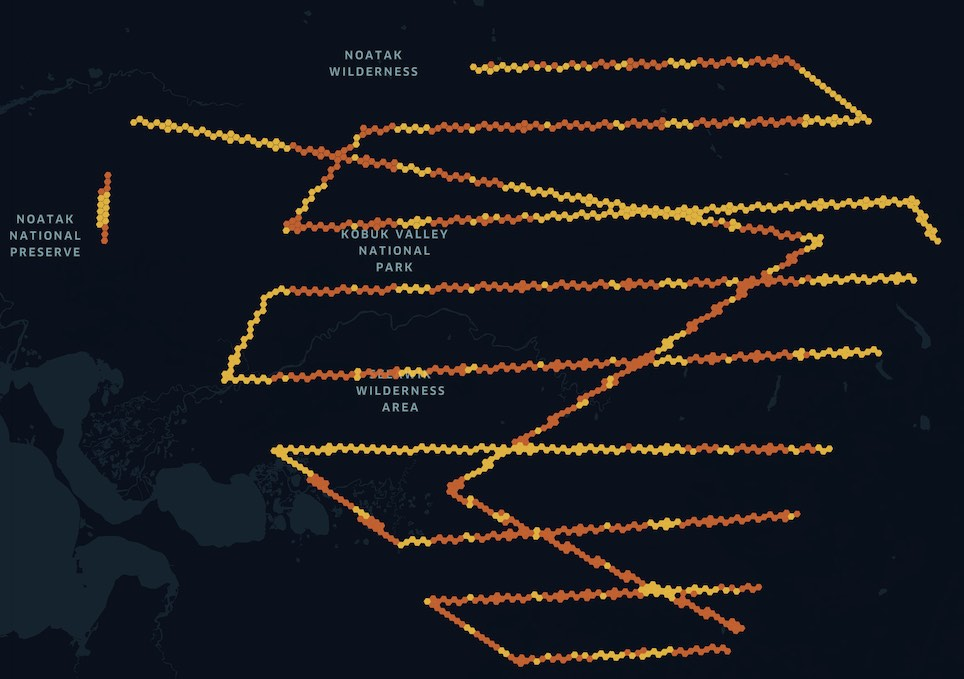

In [ ]:
displayHTML("""<img src="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB4igAwAEAAAAAQAABU6kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH6AABAAoAEgAEAAFhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNAAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAqcDxAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAMDAwMDAwUDAwUHBQUFBwkHBwcHCQwJCQkJCQwODAwMDAwMDg4ODg4ODg4REREREREUFBQUFBYWFhYWFhYWFhb/2wBDAQMEBAYFBgoFBQoXEA0QFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxcXFxf/3QAEAD3/2gAMAwEAAhEDEQA/APzVpO9LSd69M5BaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK0haW7W7SpJkgZyeAPbFZlAk7i0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigCWGQRPuZQwIIIPvUXGeOlFFABWra3saRCOYkFeAcdqyqKBNXL9/NHMU8s5ABqhRRQCVtAooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//Q/NWk70tJ3r0zkFooooAKKKKACiiigAooooAKKKKACiiigAooqWGMSyCMnGemBmgCKinSIY5GjPVTim0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFAxnniiigCWaIREbWDqwyCKioooAKKKKACiiigAooooAKKKKACiiigAoq0XtfsxUA+Zx19fr6e1VaAQUUUUAFFFFABRRRQAUUUUAFFFSRxmRXYHGxd2PWgCOiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9H81aTvS0nevTOQWiiigAooooAKKKKACiiigAooooASloooAKOnIoooAPc0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWreKWSOXy2AGORjOaq0+OWWLPlsVz1xQJkdLRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9L81aTvS0nevTOQWkpaT2oAWikpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFUZYD1Ne+6P8KNI1iz8KahayySLfxwPq8Af54kud6xzRnqELoUPXBx714CDggjtXoukfEzXdE1LRtT0+ONH0ay+wKpJKzw5JIkHuTnjoQCKXXUzmpNe4yfw34d8Of2RrvijxIlzcWelXcdlFa2sgieSWVyAWcg4VVx06nNGseCLNvGGi6L4caZ7XXoLK7txPgyxR3RO5XK4BMaqxJ7gevJx/D3jSbQ01KzubC21PT9VcSXFndbthdGLo6spyrKTjPcY9K0U+JWqx+KV8WR2ltHPb2n2KzijBWK0iCFE8sc/NGrNtJ9Tn0C7A+a7aJ/HXhjw94d1nTrvRjNcaJfoWUs+ZSbeYxXCBuMHgbT23egq9430bwDpOg6Td6DaX8d1rNqt5C1xciRI49+1lZcDLEdCOlc3rvj/X/E2iW+j6/J9te1uWuIrqTHmqGTYY/lUAofveufas/W9dm1zStItLpI1j0m1NjGEJ3PHncS2f4vpxQ/ISUtOZnaXPgPTY/h6utxvJ/bUVtBqc8Wf3YsLmV442AxwyhQ7H0/CtTwn8MtO8QeFdO8TXDSxQR3F62pyIdxW1tBkCKMZYyN04B9T75c3xl8VXNzdLcrHJpt1am0Omn/AI9kjMYj+XA35AGRk9awdE+IWtaBZaRZ6eqKdHup7pJGyWl+0DEkcg6FGHBA/wAKehNqjRxd49pJdSvYRtFbs7GJHbeypn5QzdzjGT69OKr1bv7mK8vZrqC3S1jldnWGMkpGGOdq552joB2HFVKFsbhRRRTAKKKKACiiigAooAJIAGSeABz1qzdWd3YyeTeQyQOedssbRnA46MAam6vYdnuVqKUAHjIyegyMn6DqfwrutW+G/inRNDGv6hDGkACM6iTMkYfgb12gDGfm+Y4rGpXp03GNSSTei8zppYWrWjKdOLajq/I4Siu38K+BvFfjtZ7bwnpbXslkqNOUeNNobIXJdlGTzxnOBmuX1PStR0bUbjSdTge3urWQwyxMBuV16qdpIJ5HQnPaiNelKboxmuZbq6uvVbmPs5qKm4uzKFFdHrfhDxV4aihn8QaVd6fHOSInuIiiuQMkA9Mgc46457Gsu00vUr+OSaytp50hxvaKKSQLkEjcUUgcDPNVGtTlH2kZJrvfQHTknytalCivUrz4S+I7Hwy/iKeSINFD9oktcN5qoBk5b7u4LyRj2zXKeGPCOs+LrqW10ZY5PIQPI7SBY1ycAFgG5ODgY7GuaGOw84SqRmrR3Z3zy3FQnGlKm+aWqXc5iitXW9F1Dw/qc+k6mgSe3I3bTuUggEEHAyCD1x7Vf1Twf4n0WwTU9U0+W3t3KgO20jL/AHQQGJBPuBzx1ro9vT918y97bXf07nL9Wq3kuR+7vpt69jm6K2dI8OeIPEBnGhaddX5tlV5vs0Ly+WrEhS20HGcHA6nBwOK9Kg+DOuS+HTrEtwsV35TyiyaM7+ASFL7gFYgcgjAPFc9fHYeg+WrNJ7G+GwGIxV/YQbsrnjlFdX4Y8G6z4q1JtNsk8kpH5ryTq6Iq9Fzxn5jwMeh9Kp+KPDl94R1VtJ1VovMCLIrI3ysjZwRnB6gg8da2WJpOp7BS9617GTwlZUvrDi+W9r+ZgUV6jofwm8UajcWUmoxC0srkozyl1LqjDONnUMRwAehPPpXQeOfhIdJS2m8JpcXpcsssLEO6gchxwvy9j7kVwyzXCqqqPOrv7vmz0Y5LjJUZV/Zuy+9+i6nh1Fe3aJ8FdR1LQhqN9dGyu5FdktmQHGPuhznKk45HauY8F/Cvxf418QxeH7W0ksmZGllnuopEiiROpJIG7LEKAuck56VSzTCNTl7RWhv/AF1+RhWyvFUVB1INc239dPmecUV9c6d8ALTwpdTW3jQw6lLKqtB5RdIgnc8kEtng+gxjrXmF/wDB3WJNfYab5aaRLcDZMX+ZIWIz8pGTjkL68E1xUc+wdWTUJ6JXv0fp/wAMd8sgxipQrKN+bot16nitFe/eNvhBDp1lDceE0uLqcyFZIXcOxTH3lzt6HGcnoazvDXwX1DV9LN7q9w+nTs7COEoGO1eMvz8pLdh2561tHOcI6Xt3Oy/H7tyZZBjVWeHULvfy+9niVABPSur0rwX4g1XXF0BLd4ptzq7yIwiUR/ebdjBUdsdcj1r6q+D37Pvh65utRl8d+TqhjVFt7aMyIgVs7pWwVJOflA6Dr34WY51hcBTdSrK+l7LVvW3p+Jy4fKsTXXNGFlezb6HxVRX1X4y/Zq14+LJ28HRxJ4ekmQJNLNzbqdqvlWJeRUbJznLdO2a3vid+zJYeH/DUeo+BpL/UNQjljSS2kKyNMrcM0ahV2sp+YjONuR6GuKPE2Xt0oqprP8PKXb+uhLyvEJSfLt+Pp3PjajBxnHFfTXw9/Zn8Q+L9IudT166k0CSOZoYbee33yOU+8zqXUqueFxyRz0Irp7n4Y+ErfQZfDn2WA6jFG8H2ghTcCcZBcsOeG59APaqq8R4KFR0acuZp2dunz2fyuduCyLEYpOWi0ur9T4+or6J8L/BUw6hN/wAJa8c0Ij/dR2sjruYnli2FIC8YHfPPSua8WfCbWINbmHhi2aXTiEKu8g/dMeGVizbiFPzEgHg46jFdkM5wk6roqfS9+n39xVMgxsKKrOHW1uvrbseNcDrQCp5Ug/Q5/lX1LY/Crwt4Umtte1m+aWO1ZDILjy0gEh4UngHaHIwCfTPSr3i3wDpPjw2994fuLa3MAaN5o1DxSAn7v7sj5kI654yR9OP/AFgw/Okk+T+bWyfbY7/9WcT7Nttc/SN1drv/AF2Pk7a2N2Dj1pK/RLQPgD8N5PhvFa3lqlzqU9s+7UTlZluZMgbAp4CPhVX0HOea+frL9nbxDo2pIvjgxR2rxts+xzbzJIMDGdo2gZz7/TNc+G4pwNZ1I8zTi7a7y9P69Tzv7ExLnClFav8AD1Pm737CivsXRYPAXw9uJdBW6ihurlklIuHDSyA8IvTsQQo989TXOzfB7R113+3bq522TXBmksygCqGOdpfP3d5GeOnHSto8QUeZ+0i1H7L/AJvl/wAH7j05cMV+WPs5qUr2kl9n53/T7z5v0rRtU1u8FhpVs9zOVZ9iYztXGTyQMDI796h1HTb/AEm7ew1KB7eePG6OQYYbhkdCRyPSvuDTNF0LSLl5fD1jbQmVQJjAqoDg5XJHGevFYfiHwR4Y8StLruuxMsscRQsZWjRUi3cPtO04ycn0NcMOJYur78LQ/G/3noz4Tao+5O87/wDbtvuPjOS3nijWWSN0RxlWZGVWB9CQAfwqKvsh7/wf8SNGl8N6Xcq6hI3YIhVoApG0qGAGQRgfrXz745+Ht74U1BIbHz762kiEglERJUgkMG2AgdiDxn8K9jBZvGvN0a8eSfZ9vuPDzDI50IKvh5c8O67/AHs85opKWvoD5cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9P81aTvS0nevTOQWkpaKACikFLjPGcZ70AFFaN3bAL50QBXAyQev0FZ1Ak7hRUscE03+rUkevamOjxna4Kn0NA7jK0Rp0hj3hgSRkD/AOvWfWva3sKQKkpwV46dqCZX6FOazlhjEjYI747VUrTur5XUxQ8hhgk/0qpbBAzSSYKoucHnJPAoBN21K4BYhVGSeAKVlZG2sMGrBnTb+7jCvjBYcdeuBSGdQo8tNrBQu7PQD09KB6jVt5WG4jaOuW4GKYyFechlzjcOlPmlEhwhbb6Mc81GrshJU4zwfegNRmaWpTPN0DFR6DgU+VFcCaLHI+ZR1U/T0oGV6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAe9e1+Fvhjo/iFNDu5LyeG11GzuZLlwEzFdQTJAI1JUjazyDG7JxnBrxSu/0r4g6hpXg9/CUMCkG9jvIrjcd8eySOUxhcYIZ4wxJPXtSImpNe6Wb7wNDpc/hrTb+aRbzWZ2S5QY2wx/alt0KZGcsCzfNkZHpSv4KsFfxovny/8AFMqTB9397idov3nHouflxz7VW8SeP7nxF4xtPFz2ccBs2tilsjlkxbSGXG4qD8zE5OOM98VZ034gW9tqXiK71LSkvrfxHnz7c3DwhAZWlwsiKWPLY6DgVNtRe/a/9blPwR4c0PWoNbv/ABBNdRW2j2S3ZFmIzK+X2kfvQV9+1bh8AaRN4r8MWFhd3D6T4nRZYZJERbmJeQ6uBlNykDBAwc9OOcnRPGmkaLe6z5ehpJp2sWy2r2TXcoEcanccTbTIxJ55x1xT5PiHN/wlGia7bafDb2vh5UjsrFJGKLGueDIwLsWJyzEZ4HHqxNSu7f1p/mafibwPpGk69pWiQQ6tam+u0gZ9QFuN0bSrEXh8n03Z+cenHWrHxA+HmkeGNDu9Y019Riaz1FrAxalHHH9oCqT51uYwu6PjqR0/Kub1Txdo9zqtlrGlaKLGe1vEu5M3s1yJSjiTbiRQIwWHVR+FS+IPiDdeJdNu7DU7YSNLfy3ttI8jO1ss/wDrIFyPmibqASMEAgcAAElPQ7uX4N2qahpbRXc0un31k0s7qE8y3uhbm4WJvlxsdR8pIzgHnOK5/wABeANN8T+FZ/EN5Fql1LFeJaiDTBASFaFZS7ef2BO3g+nHU0/Tvi1qVnrMupQWyKk+mxafLbtIfLdYIyiSbtuVdckjAxyR3yOd8NeM9P0fw1J4Y1bSRqdu92t4GF3NaMrrEIcZiBJG0Z5PU9OKehNqlreht+DfAuj+IrbWdQl/tK5GnTiOOxsBA140bbv3jiT5SFxtYIPvZxxTfBfgbR/Ekes3kp1G4GmyKsVlZLD9teNi37xll+X5QMMqjO7I6Vi+HPFuh6BqUmptoS3EyXIuLRhezQtb46RlkBMqcDO7k9+tS6R42sLXXbvxHq+kJf3094b2KVLqW0MLs24qPKB3IT1B/WpXS5pLm9636HD30cEN7PFaiURJIyoJgFlCgkAOBwHH8QHQ5qrWnrerXGvaxea3dhVmvZ3ncIMKC5zgew6f/XrMqkaBRRRTAKKKKAO9+F+taD4e8faPrHieIS6fbXAaXcpYJwdkuBkny3w2MHpnqBX3t4i0P4e/tE6fC+mak0kOkTtm8tUAkDyoMxfvkOUIwxOOoXHIOPzMrrvCnjzxb4IluJ/C2oy2D3SosxjEbbxGSVyJEccFjjp1r5DOsknjKkcZhKjjWirL+XfW+j6Nns4LHRoxdGrG8Hv3P0R8JWHws+Hti3w5jvbKTU/NYSQSvEby4lmxsO3A+ZkKhQBhQPQVqJ4GsNNeGTxTcwXNi37t0lQLGzkfKspclWUnI6DcceuK/MKbXtYuNYOvz3Ukl+1wLozscuZlYOHPbO4D2wMDAAFd947+Mfjf4h6db6V4huImtoHMhigh8pZH7GQbm3bedvQDOcE4I+YrcJYt1YyhXvzfG3vfvH9NUe3Qz2NOnOEY2WyXdeZ9k+JPi38Nfg5rD+G9D0tZftCLc3MOliGNI5CNqlslVLOg5xkgAZ61vaxofwpfSV+NWr2lrJcCKHUlvnDfM2F8oBAcM3RFGCd2D1r8xOOwA9gAB+Qqc3VyYPsxmkMQxiMuxTjp8udvHbjjtXpPg+EVCVGvJS+29byXVb6fj53POWcN3U4Jroux+l1h4k+HH7RNhPoHlXDwWBjupY5lME6s25UaN1JwPvByp/2ehqGw8YfBz4HpeeCBfLazW7fapItsk80hlXKq7qrbpNoACk5C7exr84dL1jV9DuTeaLe3FjOV2mS2laJyuQcEqRkZAODxxUF7fXupXct/qE8lxcTsXlllYs7sepYnkk1H+p0XKVB1pew3Ub9e/bv0v9xX9suynyLn7+R9P+AfjVp9945trfxZBbWOiSzSlWZifJzloBKzHaUXG1jjk4PTOe++L/xm8FabfWEfg0WmrTNGxuZbaULCqE/IpdFYF85P+yOvUV8MAkHI4IpSxY5Y5r2anDOEniY4nVJK3LfR+b6/j0RMc+xcV8XvdH1Xl2P0f0sfCPXPhtH4+1uGyeVbM3E1zKkb3dvLHn5E6vuif5UUdfxrhvhrrfg74x6nc+GNatHEUUAuHtpyuLjawHytG3AjYhiM55HbNfDHy/3Vz67Rn88Zqa2ubizmW4tZHhkXo8bsjDPoykEfnXCuFlGFRRry5m7xf8npr/l5WOhcQVVdcqtL4vM/SRvHHwh+Bmo3Hgu2R7LzNt48drFLcFWkBGJG+Yg4UbQTwpxgDFfNWjfHd7r4gxah4gt4YdAnvjJLAkZLxROTtJYN82xsO4xz8wGRgH5wuLie7ma4uZHlkc5Z3YuzH1LMSSfqahrpwnC+GpRnKvJznNWcm+vddn97OSec107UPdS6Lt2Z91fGH48+EDFp0fgySHV7nc7SygssccWMbCcZ3M2GAxgAH1Fdd4H8ZfCnXPh3/bniqTT0uFSU30NyY3mjePIxEpy+0jBixycg9Sa/Ogknqc03C5DEDI6HHI/GsJcI4b6vDD0pyi07819X5dvwNVn2Iu1PWPbpc918TfGifVNJl07RbWWykkcAXDupcRq2QQAPlkIAz2U5wTwaXwN8XBpcV1D4ukubx3ZWimVVdgoGChxt4B5HHc14VRXvvJsJ7J0FCyf3/eZrPsaqyxDndrTy+5Huml/GfUF8Xw3d+q/2EbxWmtSgLG3Jw2WGWJx85A6kbeh5+i/iL+054Z02zsZPh68er3rSFnMqSRRQxYwVcEKxZ8jao6YyemD8AUEk9a4MTw1gcRVp1akfh0stn69X9+vW5m86xTUlKV2+r6eh9qad8XNH8c2H9teKrizs7yMOj2xcBUROQYw/zEMOSe547V5DrvxqnvNJn0vSbNreRwY0uWcFhHnG4KBw5XH+6fXFeE0VpQ4ewlGbkldX0XRf5/M7KnEWKlRjRp2jZWbW7/y+R7X4F+LEujyXKeK5bm+SQJ5UgAkdCM7gckfKeD9c5qG9+MmuS689xY7YtLaVMwFAZGiBAYls5DsoPQ4HA9TXjVFdzyjCupKq4K7+75LocizzGKlGiqmi+/5vqfU/ij4w6Da6fDL4Ydb278wYR1dFjQDndkA8j5QB9e1eJeIviH4i8R6hFfSStZiGPy1jtZJIxhjljlSGJbAzngYGK4WipwmUYbDawjd93uPHZ5isZeM5WjpottD6tH7Uerp4AXw1Fp5XV1s1tBqLSIyZA2GXyto+fbyByN3Xiq3wn/aJ1Dw/qdyvxEur3VLOWBVgkwsssEiNyAAFJWRT8xySCo9a+W6K45cOZe6VSiqSSk7t9fk3t6LQ5FmeI5oz5tj6q8XftReKpvEN5J4K8u00xgqRLcwB5WKrgyn5xtLE8LzgAZ5yK+dNB8R6hoGvR+IYD51yrs8hkJzNvB3iRurbicknvzWBRXfhMpwmEpujQppJqz7teb6mU8dXnUVVy1TuvI9F8V/EvX/E8sDKTYRQKcR20rruZurMw2k8cAdB7547LTfjO1j4VTS5LSSXUoYPJS4dlaNmAwHcE7yccn1NeEUU55VhZwjScNFqjtp51jIVJVlPWSszo9X8XeJNetY7HV7+W5giYOqOEADAYB+VVzgHvn861vCvxC8Q+ELSWx0vyXglfzNkyFgrEYJXDLjOMkdzXDUV1ywlGVP2LguXtbQ4Y47ERqe3VR83e+p23hXx7rnhfxha+MVke6uILgzyRySMElDgq6nqBkMQDtOOMDivTfib+0H4g8fQ2FtpcD6HFaM0riGfzGklIKg7tq/Iqk4XHJOT0FfPlFctXK8JVrQxVSmnKKsn5em3XsEMbXhFwjN66/P13LV7fXmo3Mt5fTPPNOcySOcsxxjk8dgBXU6z8QPFOv6QuiapcrJbAqWAjCs+z7u8j7wzz0GTXGUV2yoU5OLlFe7tpt6GcMVWgpKM372+u/qejeCPiPqPgq2nsYLaK6t5nEgR3MexsYJXap4IAyMdee9czq3inX9Zubq4vLybbdsxkiWRxFhv4dgO3aBgdOcc81z9FZxwdGNSVdQXM92bTx+IlSjh5TfKtka2ja7q3h++Go6ROYJwrJuADZVsEghgRg4FfT3w9+JGma9BZaJq0+NZvZxbkNGVjmd22odwGxQRgEdun1+S6khmlt5Ungco8bK6spwQykEEEdCCMiuPMMspY2FpK0ujW/z8vI68uzfEYGX7t3XZ7etu59bfFj9nCHwt4d/t7wnPdahOtyqzWgjVsRyZH7lI08xtjY4JOEye1fJt3Z3VhcvZ3sMkE0Zw8cqNG6nAOCrAMOCDyOlfW3wi/aMu7TU7uL4n6hcXkDwqbWcQiR4pAcMu2FFJDqRzg4K4J5r1/wAafCDwj8ZoF+Idjfz2s17YqbZ4wnlSqqsYnmV1LZ5wcMpAwDyK+Mw2cYvKan1XOlePSavZt9Numvn+Z21cHSxkfbYPR/yn5xUVtax4a8ReHSia/pt1YGQlV+0QvGrMoywRmGGx7E8c1i1+kQnGa5oO68j5mUXF2kgoooqyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9T81aTvS0nevTOQkSJ5AxT+EZNMpVZkO5CVPqKT60AJS1p29ihVXmP3ui/40rppozz07KTRYnmWxl5ONuTj07UAE8AE1pRvp0bbxuJHIzmo5r+R/li+Rf1/OgLvoi1Arx24jYtuBLbF6keh9KoG6lZm80B1J5U9vp6VXDuM4YjPXnrSUAokp+zk5+dPyYf0NHlATGJ3CgH73aoT0qxI0e8yKd5PYjp9fWgZYma0EPk24DuSBnvVY/uVKn77jBHoP8TTfOlwRuIB7DgVFQCQtFFFAwooooAKASCCDgjvRRQBMy7ovOAx82046HjOahqVZQECMoYAkjJOOfbvTiPOAaMAMMhlHGfQgUCIKKVldfvKR9RTetAxaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqa3iWaURMSu4cEetQ0AkHI4oAmngkt22yY56Ed6hqR5pZECOchemev51HQC8wooooAKKKKACiiigAooooAK9k+G3xk8T+Cb7S9PuL64m0C1uAZ7EbShicnft+UvlSd4UNgkbehrxuiuPFYSjiqbo4iKaff812fmb0a06Muem7M/Tq5/4V5+0doRtIZ7h7TTLgO7Kpt7hJmQgAbwSEKMcnGD0HQ18UfE74PeIPA2uaiNNs7u90S1IkS+8veiRMBxK6gAMjZDcYHBOM1wHhvxf4m8I3Etx4b1K40551CSmBgNyqSQCCCDgkkfWvvj4ffGbwl8S9Ls/AF9FImp6hYmC7jkj228jeWfPEZLHeWG4gdTyT0r85nhsbw9J1MLeph/5XvFbtv8f1PpI1aGYrlq+7U79+yPzjIIODRX1t8XP2cZdEksrn4b2t5qKSiQXNuXEskZGCjqW2/KRkHJznGB1r5Ont57WeS2uY2ilido3RxhlZCVYEdiCCD7197l2Z4fMKSrYaV/LqvVHgYnC1MPLkqIiooor1TjCiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9X81OScDqau29n5uGdiAeOAc5/GtMQ29sPM28jJzjpVCXUZGJWIbR6nrXqHBdvYuR2MESkyDefftVYz2ttIfLj3Njqp4/Cs0sxJJJyevPWlTyw373O3/Z60D5e7FaWRizFj8/3vemU+QRBsRMWGOpGOaZSLCiiigAooooAKKKKACiiigAooooAKKKKACiiigApKWigByySL91iPxqQ5kCk8uzEZ6cDFQ05XdMhT1oAlS3807YXDHuD8v5etRvFIjFGHI5IHOKZ06dqn+1XOMbz+FAtSMRSsu4KcHp70wcnA5NKWZm3MST6mpBPMM4cjPXGBmgY0xSqNzKQPXFR05WZTuUkH1Bp/msTkgFuxxzQBGQR1BH1ooJJ5JzRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFSwwvO+xMepzTZI2ico3Ue2KAv0GUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVbsb++0u7i1DTZ5LW5gYPHLCxR0Yd1Ycg8/06VUoqWk1ZjTad0fYvwi/aQtdC0qbSfiBJe31w1xvhu+JW8tgMrKzMuAjZIOMBfpXpvxb+A2geI9I1PxR4fgkPiG6K3CBJD5VxISuUWPIQF1GA3r8x71+duOMHvXunwm+NWseBNeWfxBcX+q6UbdoDamcyeWRjy2iEzBVxgqQCMqfavz/MeH6lCq8xyeXLPdx6S206aaarZn0WGzCNSP1fFq66Pt5nlnibwrr/AIP1L+yfEdnJY3RjWYRy7dxjckK3yMwwSpHXtXPV+no8P/D39oDQLHxjqVtceVGs8MI81oJYcPiQSeU2Cdyg4JIA6dTXwT42+FfjPwIJLzWdPlTT/tLQQXZ2GOUZby2wrFl3qMgMq88deK9PJ+IaeMbw2J9ytHRp6Xevw63e2q/Pc5cZl0qP72lrB7Py8zziiiivrzxgooooAKKKKACiiigAooooAKKKKACiiigD/9b825biab/WNkeg4FQd6Wk716ZyC1NDN5JbKhgwwQahooASloooAKKKKACiiigAooooAKKKKACiiigDW03Qdc1lJJNI0+7vVhx5htoJJgmem4opAJ7A4/KvpW8/Zc1m08BP4lbUS+rRWn2ptOSJWUkDd5QkDZLbe+MFvat74EfGrwJ4G8FTaHr6S2l2l1LNvt4Hl+0q4BUsyD5WX/VgH+EA9KwPDn7TPiI+LbceIxEPDrXTFraODdLDAd3l4dWy5jJUkYO7Bx2r4DHYzOKtapHB0uWNN3u9eddlp18u61TPoqFHBwhF1pXcvw9T5o1PRdW0Z0j1WzuLRpASguIZISwXgkCRVJxkZx070tromr31lJqNnZ3E1tDu8yaOGR402jJ3OqlVwOTkjA61+kU8Xww/aKgUrJLdRaM5+YCS2uFacdPmAbyyFB9CwH92n6d43+F3w7MfwktbjbcQuLRYTG7pJJckY86VVKB3LjzNxB/MVyf621uT2UcNJ1l8UddF32v23S3Nf7IhzczqLkez7s/My1tri9nS1tI3mllO1EjVnZiewVQST7AU+8srzT5zbX0MkEoAJSVGjbB6Ha4BwfpX6b+Ffgj4E+HPiG38R6NDcz3YDwRrLIZfK3qcvEpGQQBtznhSfxteOfhB4S+KurRarr4uraWzi+yqYGEMkgJDgyZUkhckIP8AaY9xgfHGF9ukoP2dt+t/T/gh/YdTkd373Y/LWivomx/Zx8Z3HjFNIubeSHRWvHjOphozH5Cs21lG7cXdQFAKY3nuOvWfE39mW50KOym+HhvNXaZ5Fnt5WiMqKBuV1OIwVH3WySckY9K+mfEWXqrCj7VXkr+S9Xsn5M8tZbiHFz5dv60Pkqir+qaXqOiX9xpmq28ltc2rFJopBhkYAEg4yOhB4NbWu+CPF3hi0gv/ABBpN1Y29yQsUk8e1WZl3hQQTztBODg8H0r3fb0/dXMve2139O5weznrptuctRRRW5mFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV6XqPwq8S6Z4bbxHctCFjhE8tvk+aiHk542kqOSM+tc1XE0qLjGrK19F5nXQwlaupSoxbUVd+R5pRXVeF/BuueL5Zo9GSNlgALySPtjBPRdwDfMeuMdOT2zkato99ourTaJeoPtUDiMoh37iwBXbwC24EY45pqvTdR0VJcy1a6ilhasaaryi+V6JmZRXs/hr4Oa5c6rEviaMWtltLMY5VMjkDhBj7p5yT2AIrW8RfAvxBLfKfAljc6larGPOAaMvFJk9S7JkMOQB0x7ivMlnODjU9lKovW6t9+x6byXGRovEShZXtbr9x4FRX2RefssfZvAEmrR6jNNr8dn5/wBljEZt3lA3eUjFQ/I+UHdy3txXnfw6/Z38WeMNQuYvEUdx4ftbaMHfcQ/vZHY/KERjgqADubPBwBk5xy0+I8vnTnWVVWi7P/gLd/I5pZbiFKMOXVnz3RXrfjn4OeKfCXiyXw1p9vc6rGTF9nuY7dwkvnAbQzKGRG3ZU5YAcHoa634g/s7eIvAXhMeKJb6C+ELRLdQwROrQiTgtuLMGVXIBIA4OegxXX/bOC/dL2q/efD5/5b9bdjH6jX973fh3Pneiu78K/DvxB4utZ73TvKiihbyw07Mgd+4XCn7vc9jx1zXtkfwe8NJ4W+zyKW1PyW/0vc4xO3T5AcbQ3AUjp15pYrOMNhpeznK7vbTp6npYPIsXioe0hGytdN6X9D5Yor3nwp8Gbx9Rk/4S8CK3SPMaW8uTIxOPvAAgL39cj05xfFXwn1mz1qSHwzbyXVgVQrIzqfKYj5lclgxx97IB4PqKqOcYSVV0VNbXv0+/uE8ixsaSrum97W6+tux5BRX0BrvwRks9F87QZrnUdSBjH2ZUQiQk/P5YADZAyQMngVieGvgx4g1MXB8RibRGiKqkc8P71yeS20kYXHQ9zn0qY5zg5U3V9orL7/u3/AmeR4yNZYfk95q/T89jxnI6d6UAngV9h2HgfwXb6AfDMsVvPc7WikkIQ3JmYcsD95SMgr6DHauT8M/Bi20zVPP8TTQ6hB5ZEcSoyqz9y+TzgcgdM/QVxR4hw1puV1bbz9P+CenLhfFc0FBp33/u+v8AwD5o+tFfQfi74PXF1qrXPhFLeGz2KHjdyuyRc7tow24YxkZHPH02Nf8Ag5o0Xho/2EssmqIiGNnlbbM4xuG0nYu8ZweAvXpW6z3CWg+b4vw9exzvhvGXqK3w/j6dz5kpCyjqQPqa948JfBm5vftTeLTLZmMqsUcLoWbuXJww29gOvUntXtek+HdD0fw//wAI5BD5kOHiYuu5pWckMzNjGWzz6dO2KwxfEGHovlpLnflt9/U3wXDOJrrnrPkVuu/pbSx8OcdTRkHkV9U6D8KfD3hPUk1TWLxbyEIY41uURY1c9C2eGOMgZ/n0reLPhTa+JtRGq+HJrayhMYR1WPKOy5+ZAhAzzg56kVS4gwrqcuvL/Nra/buS+GcWqXPpzfy6Xt37HzDtYDcQcHvSV+hPjL4E/Di2+GjQaHaxR6ottGLS/cnzZ5+GBkK8HzOd3GACewrwPwl8F40luG8X4kwFEMVtMwGD1cuoU+2Me9c+F4nwdelKsrqztZrV+a1OeHD+LqTUILR9ei9T56js7uWFrmKGR4kyGdY2ZFwMnLAEDjnk9OarZAGSQB6ngV9l6VrngjQJB4BsJlE6yNCICGId5MsQ0hG0sQfmyc5464FYunfD3wb4Cv4/EF/eExJmOP7YUEcbsOCDgZOAQM5IzTWfpcyqUmn9lfzL7tPxPSlwy3yulVTS0m/5X9/+R8nAqeVIP0Of5UuDjPavqzxZ8OtP8fXMOvaJfQ26GHyw8aCWObaSVYbWUDbkg+v4Vfvvhv4Pu/DZ0bTILdL7ygkVyQpnEq87nI5PIO/2yKv/AFhw/LHmTu91/L6/8AyfC+J5p8rXKtn/ADen/BPkSrsGm6jdQPdWtrPLDGSHkjid0UgZILKCBgcnJr6K8KfBe0tJ7k+LTHe5VRAkLSKoz95iflO7sB269+Ov03xV4J8PXX/CC6a/lyxSm3SMI7Rl5OcNLyCcthiTnPvRXz6F3DBwc2tX2t3/AKQYbhudlPHTVNPRd79u34nxyOcY79PfNICrcqQfoc19yeB/CXw3+G3iiLxXrdwLeNRIkT3bjyYZpPulRjjC7lXJ+UH8a7vx78IfC3xvltPFvh/V47ZEga3S5tY0miuNjnGeQMRtuX16jtXn1OLMPTrKNSDVNr49bX7WSf5/Kxx1sgrUrwlJc/by7n5yRRSTzJbwKXkkZUVV5JZiAAB6kkAVva54T8ReG1ik1uye1WYlULFGDEDJHys3IHrX1JfWvgf4f6MJ2htmuNIbylKiN7lp1YoRu67mbIJ4AGegpmj634X+K9pPZ3lkxjs3SQwTkbssCFcGNunUdetdEs+qP9/Ck/ZLd9fK34Hqw4cpW9hOsvatXilt53/E+TLXSdVvYHubOznnijOHeKJnVSADglQccEH6VQHOMc56Y5znpX2LYeLvA/hq8PgrTW8mSKbyURUYxeZKQcNLyM5bDEnrx1qqngrwN4E1BPFN1KYFV2VftDgxRvJ0KLjqOQOuAa0WfOLaq0mr/D/e/rTa5D4aUlF0qydvjf8AL/Wu9j508K+B9f8AF/2htIWMJbbQ7zMY1LN/CCFbLAckduKw77SdTs9Yk0K5jZr2KUQeUvzsWJAUL3O4kbfXIr7n06+ttVh/tDRZoZraQYV0+ZXZTgkYI6dD7/SvQ9X1X4W+EfC6+NrmGyubzT1jkSRUie9a5J2BAfvByxKcnCjPQCvFnxTWp1eT2N76JLdPzfr5fkdGM4eoUKEJRqa9X0a8v+HPz48VfDfxv4JggufFGlTWMdw5jjd2jdWdV3Fcxu/O0E846Vz9h4f13VLeS703T7u6hiOHkgt5ZUU43YZkVgDjnBPTnpX6N+HPFXw//aIsLvSNS0t2g02SKdrW7I3ln3KkqvCxGOGUgHPqMEZs6N4++FPw/wBR/wCFWaNL9nmguRbpEEkaIzTkHbJOQV3bnCsWJPY88ViuKsXGMqFTDN146yS2Ue/V9vLzPH/smi2qkanuPbvf8D8w+OprrfC3gvXfGBnOjJGyW4G+SR9iZbooYBst3I7Dr1FfaPiT4K/Dv4bOvjn7U0KxzlTHdugt43nJ2+Uu0Y2Z2quThfUjNeR+I/jDo+h6iLbw7bxanG0YaWSOQJHv/hClVbJx94/T3r2qefzx0f8AhMpuXm9En1X9M6cPk2HpR9tmNVJXtZb+X9WPm7UNKv8ATNSm0m8iK3MEnlMi/N8xxgDHXORj1yKu6z4Y8QeH1jfWbGW1WU4QybcMQMkDazc4r6t1K88DR6Svj64ht55hHHcRz7FadmONijPIOflAPSoNP1bwr8WrCaxlglEVpIjtFIQkmSDtdWRiQvUZBGTkdOos9q2VWVJ8i0k/Py/4P4Ha+HKHNKjGsueWsF5efy7fifIsNleXMbS28EsqKcM0cbuAcZwSoIBxzg16Fqnwq8SaR4dbxFdNFtjjWWWAZ82NWxnP8PyA5bBr3KHxT8P/AIfQ3PhqGYxNal3aIB5Gd3G7aXwQX5xyeB7VH8JPi7pet+LYdL8dJaWVk8T+TJI58vzhjYkpf5cFc4J4LAeopV82xsoSxGHovkjrrvJeX/AuY/2Xl+HXssTWvUatZbKXn8+9j598F/Drxf8AEGW5j8J2Yu/siq0rmVI413HCjcxwWODgDsMnHGea1fR9T0LU7nRtXga3u7SQwzRNglXHbIyD1BBB5BFfoF4u+PngP4da7/ZPh+xj1NLiNZrp9OeFEWU8KMjh3KDnngbfWuG8UN4K1SST4o6rbW7yyeVdrPjJOABEoGfmbGFXjOcHrXJhuIMZKoqmIw/LTmvc/mb89evoum5zUskp11KNKquaPxX2t/Xn9x8xeHfhv4m17UhYz20unx7DI81zEwUL2wONxJ7A+596HjXwfeeCtRSyvJkmjli82OZVKKwBwwwSSCpxnnnIxXsHiz4024itv+EQBabexle5hYBVxjaFJXJY85zgY9cV0nh34neGNQ8Pfb/ElzbQXyhxPCfvPszt8tTkkMOg55OK7nj8xg44mpS9x6cq3v32v/XzO9ZZlc1LCU63vrXme1u29v6+R4PqHw48U6Z4f/4SO8gRLcIkjpvJmRXIGWTbxjOW54Fc3pOga1rsskGkWct08Kh3WMDKgnAJyQOTX0d4V+KFp4y1E+G9Xso7aGeJ8F5N6yhQMxuCoA3KTnkg4IrT1Dxl4F+Hd+dIsrTZ56iaVbGNdqHou7kAlgOgzjqcZ5FmuNpuWHqUb1N1ba33ieT5fUUcTTr2pbO+9/u9DzTRPgrqWpaJ/aF9dGyu3DlLZow2NuQodg3BYjnHQe9ec+H/AAfrviPVRpFnCYpVUtI0wZUjC8Ek4554GM5PtzXo9v8AGXV5fEQkutkejyz4eHYC6QnjO8HJI+82PcCu68U/GPRNOW2Phox6lKzN5mdyIiDsTtzuJ6DHQHNH1nNKcnCUFJy1XaPk/wDgv5sX1TJ6sFUhU5VDR95eaV/yXyR2fwi/Z00G/wBOvL3x2TdTiYRxQ2k8kaxqADuZl2kl84AIwAOOSa8zv/2cfGUvjd9K022ZdDmvCkGpMyGMWzHdkguXLKuVGV+ZgDnBzX1H8MfHPgXU/ALeI9QuraznCym/SSVRJEYsj5ed23b8yHqc56nFeP8AjL9qqC/8NSWHhKwubPUpCii5uPJKxqDlnVVZjv4+UMuAevTB+PwuOzupjK0aKvryvm+GPmtfyvfqnczxdDL4wXK/d3Xd+pwPxb/Z7vvAltY6j4bnutYt7h3hmQQbpYnC7lbbCpyhAIJI4OPWqHhH9m3xx4r8PweIvtFrp8NwSUiuRJ5xiBx5m0DAzyVU4JwMkZ49f+E/7SunmyvE+KmoGO8Eq/Z7iO2ba0LDlCIVIUqwJycZB9qj0n9qT+0PG40i7tILbw7dXfkpdMWW4ihf5Q7g/Lgvyem1W55UmvQ+ucQU6csMqd5Q1c7aSW9lok36a6bXOH2OXykqvNpLp29TY8efs0eFoPBbL4HtppNdiERhMly+LorjzBtdvLVnXJGMAHHQV5/8Ov2X9R1m2vZvHstxo0kUoighh8mV2G0MXYnzFCnICgYJwSewr6A8efGzwJ8P2sJLJo9VluS6NDYSxNshXGWLE7R82ABkE89hXy14w/aV8aaj4nfUvCdxJpemqsaJaMkLtIEO5jIxD/M5JXKthVx3zXnZVUz7FYd0qUrJ3anPffZb6fLvqdOKjgKVRTmtVpZbev8ATM3Q/BnxT8H/ABDi8K+HhfMlvqibZF8+OxmRXVjJIV/clTEPnByeCoyQK/QbxH4d03xnpsnhvxLbCWyuArvGsjAu0bBhtZQrLtYA5BB/WvnzxZ+1F4RtPCyy+DxLc6sxiEdvPBLHFF3ZnYgBlUZXCnJJ9MkfL/jz45eNfHlxZy3En9mR2YbbFYSyxKzv1dmDBidvyjnAGfWnUy3M85qUq9WmqTjf3tpX72067dtdRLE4XBxlCMua/Tpbsd78Wf2etb0XWbvUvAOny3WhxwCVlEweWB0U+aoEjeZIAAGGMnkjnGB8u9gfUZ/OvrvQv2oZ9I+HsXh+fT5brWra0NtHeSyI0TuPlSSQE+Y3ynLdSSOvOa+RTjt0/wA+nH5celfd5G8wUJ0cxS912jLrJd3q/LseDj1h21PDvfVrsFFFFfTnlBRRRQAUUUUAFFFFABRRRQAUUUUAf//X/NWk70tJ3r0zkFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANzRPE3iPw1NJP4e1K506SUBXa2kMZdVOQGxwQCcjPT8ayprq6nuXvZ5XeeSQytIzEuZGbcWLddxbnPrzUFFZqnBSc0ld9epfPK3LfQ+iPhl+0D4j8La49z4wub3XLGWBo/LeRGkjfIZWQvtABwQwzzx6VF8Rf2g/FviTxBJeeE7u60WwWAQRwIybn4JZ5SAwLEnAweFHByTXz5RXi/2FgfrH1v2S5rW20+7a/wAju+v1/Z+y5tPxPsvxP+1RHf8Ag1tM8P6dcWWsTRRxG5cxGKI4G94wrFtwwfLyoAOCemKx/hj+0vfaJJeRfEI3esCfyhbzxrCZY9pIZW5iBTkEYGd2c9RXyZRXEuGMuVGWHVPRu9+vye622NnmmIc1U5tvuP09fw18KfFumJ8ZNSsrcyywpqIvZSy+WIBlPMUNtZkChWznJGOwqhpHxA+HHx/E/gp7a58pES8lgulMDyeU4wI2R92UbBcjsQOcnH5uLf3q2jWCzyi3flohI/lnnPKZ2nnnp1560llfXmnXK3lhNLbzJkLJFI0bjPXDIQ3PfmvD/wBUPdk5YiTlH+G/5F06/lbyO/8AthXVqas/i8z69+Iv7MV9JrjTfDWKIWIhTzILq5fdHMM5Cs4dnBXacZG3oOvHaa/+zH4Vi8APFoPnTa+tvGYbh5nEU8/BI8okoofkDj5RznjNePeA/wBpjXvB3hk+H7/T/wC1pY2maC6muW8xTISyrIHVy6qxPO7O3AxxXCeDPjP4r8NeMIvE+qXV1qkReVri1edhG4mB3bEYmOMhiCu1RgDaODWH1HP2uR1bez1jrrUt318uvfW+5p7fAJ8yj8W/930/4B7f8Mf2Y5Zbi+f4mxPCIwq20FrccvnkymSPnA+6F45ySPu15p8R/gD4t8O6rqt/4XsZL/w/aZmjuBKjSJGq7pFZCVdjEQQSoORjq27H2D8MfitoPxTt7vUJIv7NuLB1i+zTTrnbIobzAylchiNvtt965SL9ojwY3iZvAsMUot2uvsEepAo0GGfy8lSd+Nx2bsEH7x+XmvEo5vnccZVk4czilzR+ylpqtd/vvd6M7Z4TBOjFJ2T2fVnwJ4e8L6/4r1OPR/D1lLe3UqNIsceOUQAs2WKqAMjknuMdaTxF4Z17wpqj6N4hs5bK7jRHaOTbna+dpypZSDg9D2r9GPFGt/Cz4ERxatpulW8FxqOYPs+nrGs0scfzFiWYAKhxkk8kgdcVY07R/hf8c9Gj8b6tpkdyWV7UGb5ZrdYWbKMUbBIJLDkjB446+5/rfVVsXPDtYd6J9eb77W3/AM+hwf2PBp0o1P3n4WPzCor7E8LfssapB4rt5PFk0EuhLK52xSuZ50GfLjkG1PLLjBchjyCo65G18TP2ZILm9tW+F9tFbhY5PtcFxcuF3EgxlGcSYJG4beBjB+vvPirLlWjQVTdX5vsrybvv8jg/snEcjnb5dT4hor78079mPwnH4AMeqPJ/b72zk3SSyCGO5bO1RDuCsqNhMHlu/Jr5H8afCvxx4AhtrnxNYC3iu3aOJo5VmG9V3FTt5BxkjPXBrrwHEGCx1SVGjOzTtrpfzXdfj3RjiMurUIqclp5dPU87orptK8GeKNbsn1DStPluIEZkLqVHzKMkAMwJx3x3461zODgHseRXvxqwm3GMk2t/L1OKdGpCKnOLSe2m/oFFFFamIUUUUAFFFKrBWBJHBzycDikM7jQfhr448T6U+taJpVxcWSO0TXChRGrL97ksGwvcqpxz3BFfXDM2l6PA+v3kTRQRot1Kw2IxAA3Elj8pbqO9d58ONU8TeG/gLbahJovmXWnafPJb26YQzxxljEzJy250wzDG5j2ycV+fmt+NfE/iG3Fnqt889uriRYwqouex+UAkDPygk44781+bwniM7r1KcuWMKUmrrVv8+3l+B95g8XQyik5WblNL0+f9M9+8UfFnRfD93FB4cjg1IyJumaOTZEvPyjcitl+ueOBjPat2PxL4MvPDq+ML77N9oEInO4I1wkg+6i5+bKt8qivjrr1pNq53YGfXHP51774eocsYwk01u+rXb+vxOaPFGI55SnFNPZdE+57V4r+Meo63p8Vno0EmmPvDySrIGfjoqEDgZ6nuOO9em/C39pK28IeGJNG8VWd3qVwk8kkM8JjyyOAdshd1JIbIBA+7gdRXyTRXTXyHBVqH1adP3b38/v3PGnnOLnU9tOd3+H3bH0l4T/aO8W2vjCHUfFV3Lc6I88jy2MUce2JH3FfK+VWPlEjAZjkD1xXcfEn9p+eW8sR8NGaBI0Zrme7t8s+7pEEc/dX7xYdTgA4zXxrRWM+G8vnWjiHSWitbTlfqurMY5niFB0+bfr1P0B0L9prwYvgMTa68h17yJPOtI4ZNk9xyMrIAUVXODy3yDjtXl2h/tE6x4nn/ALK8eS2draqnmJNDG8StKvaTc7ZBByvA5GTzivk+gEjkVy0+FMBT53GLvJ3u/s/4dNF951087xEKkKmnu9O/qfS3iT4z22las9r4cggv7YIN0xkKoZOfubVOQOMnueO1eMaZ4317T/EUfiKSeSeTzjLLE0jCOQPkMu3JUDBOOOODzjnkCSTk80V7WGyrDUIOEY3urNvr/XkRis6xWIqKpKdrO6S6f15nrPi74tax4gNsukCXSo4CWby5cu7HjlgB8oHbueewrpNF+NI0/wANpYX9pNdajFG6LMWXy3bnY0mW356byByeleBUVMsowkqcaPJotf6e5UM9xsasq/tNWreX3bH0V8Jfjhc+GPE/2vxtNPfWD27xgpEjPDJ8pVkA2nBAKt1OCO2a1Pip+0Bc694jjm8EqILK3gEZkuYcyTMx3ZKkgqE5Cjvkk8Yr5hormlkGClifrjh71rW6etu/9bmMc3xUY8qm7976/eatprWo2etp4ijk3XyTef5rDJZied3TIbJBHocDHbpfFnxD1/xelvDfeXbxW5LBLfcoZzxuYkk5A4A6DJrhaK9iWGpSnGrKKutn2OKOMrxpyoxm+WW67nrWgfF3WdB8PJocdtHO8KukM8kjbkBztyu0htmePmGe9ZHhD4h6t4d1j7dqEtxf27oySRPKW5bkMu87VIPpgYJ9q88ormeW4a01yL3t/wCunyOxZti06b9o/c2/rr8z1vxT8W9e1XUUn0CWXS7eOMKFGxnZjyS5wwIH8IHTn147S7+Nlg3hryrO3kXVTEi4df3KycBmDA8gfeA4yfSvnCiueWTYSUYR5Ph/H17nVDP8bGU58/xfh6djqPEfjLxD4rSCLXLgTJbklFVAi7m4LEDgnHAPbmt3QPif4l8OaL/YdgIGiXf5TyKS8W85+XBAIBPAI4rzqiu6WCoSpqjKC5Vra2h5sMwxMKjrxqPmel76nW+FvGWq+F9YXVo2a6yrrJFNK+1w/Uk/Ng5wcgfzrW8V/ErX/Et7DdQSSabHAhVY7aZxkscszMNpbOBgEcfjXnlFKWCoSqqvKC5tr/1oOOYYiNF4aM3yt3t/WpKtxOk4ukkYSq4kD5+beDu3ZPfdzn1ra1rxT4h8QiJdavpbpYSSgfaApbgnCqvOOMn+prAorpdKDkpuKutn2OWNepGLhGTs91fc7jQPiH4n8N6W+kaZNGsDF2XfHvZGfqUbcMc89DzzWP4b8R3/AIY1pNcsgskyhlcSf8tVcchyOTk4OeuRXP0Vj9Vo+/7i97fz9Tf69X9z337m3kd14p+IWv8Aii9hupHNkkCbUitpHUAnlmLAqSTx16Y4riBLIJPODtv3b92Tu3ZznPXOec9c89aZRV0aFOjFU6UbJGdfFVa83UrSbbNrVPEeva2sS6tfTXQgyY/MYHaW4JGAOT6nmux8J/F/4geCtHn0Lw9qPkWs7vJteNZGR5AAzRs33ScZ7jdzjJNeaUVnUwdCrD2NSmnHtZW+4X1mrz+053fvfUV2Mkhlk+aRiSznliT1JPUk9yetSQzz27b7eR4m9UZkP5qQaiorrsrWMFJp3THb33+ZuO7O7dnnOc5z1znnPrWrqXiDXNZSOPVb6e6WEkoJX3BSRgke+O9ZFFQ4RbUmtUWqs4pxTdnv5nX6H488U+HLGTTdJu/LgkZn2sgcqzDBKk8rnr9ea5FiXYyPhnYklyAWJPUlupJ7+tJRUwo04Sc4RSb38y54irUjGnOTaWyvsW7O/vdOlM1hPLbuRgtDI8ZI9CUKnFQm4nac3RkbzS+/eWJbdndu3HnOec9c89aiorTlV72MeZ2sdZ4i8deL/FkNvb+I9Vur+O1JMSzOCFLDBOFC5JHGTk4z6nPJkk8nmiiopUoUo8lKKS7JWKnOU3ebuSRpE6uNqrIPmDYAJ9QTUtre3li5ksp5YGYYLRSNGSPQlSCardeKK0aTVmTGTi+ZMc8kkjtJIxdnJZmYkkk8kknkknqTTPalooFe+ogAAwBgDsOKf5khTyyzbB/DuO38ulNooC4UoZgMAnFJRQAhAPBAI9CMigADhQAPQDFLRTAKKKKBCYXOSoJHQkAkfQ0tFFAwpKWigQgVV+6Av0GKWiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9D81aTvS0nevTOQWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA+Xuqt/vKD/ADFJx0wMenalopDEAUfdAH0FX9P1TUdKuI7vTbiS3lidZEZGIAdCCrFc7WwQOCDnoeKo0UpRUlyyWg02ndH0h4//AGkfE/jXw4PD9vaR6V5jo089tPIZJAnOwEohQFgCSpyQMdDUPw0/aJ17wFpl1pmoWR1tJpfOjee6dZEOwKV3MshZTtBGTx9K+daK8H+wMv8AYPCeyXI3e2u/re/4nf8A2hiPae15tT9TNV+JngTSfAi+O1vIbndFHcxIjjz5Z5MFY9gOQSx2kEfKMk9K5nwT8SfBPx0S60rxBpUMSaeI5hZ3zRzJIZNyiRTwMoQRj3z6V+bGF6hVz64Gfz60YU/eVW/3gD/OvmY8FYeNOSjUfPe8Zfyrta6v6/dY9N53NyV4rl6rufaHi/4j+A/CXiufwn4dgAsreVIfMtvLW2t5GIEigZGVjY5YjPOR2NYfjL4W6Jqumsvh62gttSeRXEuSocZy+8rngg5zjrivkv2rsvB3jTUfB2pPfWyC4SWPypIpHYKQDlTkAkFTnGB3Neo8jqYWMamCqPnW9/tPz19f61PToZ9Trr6tmEE4PRP+VeWnp/wdj27wj8HNKtrWf/hLY0u7lmAVY5HCRoOhDDaSW7kjjp6k8knwX1R9eXfJEukPcEiQSEy+Tuyq7cdSMKDu/wBquB8U+Otc8T6odRaV7NVQJFFBK4VB3ORt3Enkkj2+vs/hL4uR6/e2ug65bJa+au1rgSfI8iDOCpA2h8H+I46d6xrU80w8XiOa91qv5fTX8vx3O6hUyjEzWF5Lcr0f83q7fn+Bm+Nvg9GqWzeC4HaXLCaKWYn5cZDBpDxg8Y759q8Ev9Mv9Lv5tMvoWjuIH8t0+8Q3GAMdc5GMdcivrDxV8StC8IahFa28JvpJ4w8ggdQEA4Qkk4y3PA7DP12dPtfCvie1tfFotLeW8nRJo5XVWmRx91eOcoRj8K58Jm2KwtKM8VByg9n1v567HVjclweMrShhJqM1uulvLTc8A8M/CXxBqWqJBr9vNp1psZ2kJjLNjGFQZYZOcnI4APevaNG0rwP8M1ls76+iSW8w/mXjIHdF42gAAbVOeg5Jr0dvMklRJR5Y5YbWySRxjOBjGfxrwzx18M9d8SeKH1XS54/s0qRRyNPK2YymQ2Bg5VR82ARzkdTXnrMJZhU9njKnJC2y20fz/pHpf2bDLKXtcFS553672a/r7zW1r9p/XW0C78OaDaRxAo1vb37u3nrF93d5ZXbu28KS3HBIyMV8q+gHAAwB6AV94eP/ANnHwZpfgCS48N+cdXgSExTSzuVunGNy7CfLUyDOCAAvXgV4n4Q+C/nLcv4wDxOCqwxQSjp1Llh1z0A7YJ716eUZnlNChOtg1yq+qfxN999tflroj42tlmYY2soyV/P7K8j57or0HxT8O9d0C4vrq2tpJ9LtnYpdZTHl8csN27Kk7SdvJGa47TtJ1PV7k2el20lzMFLlIxlgowCT7AkV9nSxNKrD2sJK3rt69j5ytg69Gp7GpBqXpv6dzPoqxeWl1p9xJaX0TwTRHDpINrKcZ5Hbg5qW503UbONJru1nhR8bWkidFbIyMFgAeOeO1b88dNdzn9nLXTbfyKVFFFWZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD49nmKZM7c8461YvEQSCSI5WQbuPXvVSnoUziXdt7Y7e9AvMZRTpFVHKq24DuO9NoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0fzVpO9LSd69M5BaKKKACiiigAooooAKKKKACiiigAopCQASeABk/QV7Q3wZ1RPC51uS6AvVgM5s9gPAG4Jv3fex14xnj3rjxGMo4bl9tK13ZHfhcDXxXN9XjflV2eMUUnBGRyDyPoaWuw4QooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEA8EZ+tLRQAgCqOAAPbAFeqeBfBXi5PEWlarFaSWUJkWcXMirt8vBzxncS65UAgHnPavMrbzTcxLbqJZjIgjjI3b3yNq7e+44GO4r7A+IniLXdA8Ii+srfybmR4o3kBDCDd3A7nd8o4wCcmvnc2xVWm4Yailepda/wBefn6H1eS4OjUVTF127U7PT+vI4r45S6vBBphjudtozyZRCUYzAZVjg5IC7gPQ/UY4rQfi/rWh+H10VbaO4kiV1huJJG3IGyVyuDuCZ4+YZ7157rfiLWvElwl1rd09zJGmxNwChVJyQAoA5PU9Tx6Vi1eFyqmsLDDYqKlbXTvr6GWMzqpLFzxWDk4pq2vy9T0bwx8S9f0PVUvdSubrUrcRujW8txIy5bGGUOWVSCOwHBIr6T8J+L9K8X6bJqufszRuYnheQAx7RuzkYzuBznt07GviamlVP3lB+oBqcdklDFe9H3Zd1/kPLc+r4L3Je9Hs+/qfXGnfEvw34n1L/hEhDI0d0XtxNIFMUyANwAG3DeoOCR/SrN/qXgP4VzKkFr5EmoDLJbLvfbH0ZsnIXJwBnr26mvkAEghgcEc5HXNOeSSU7pWZzjGWJY4HbJzXI+HqXNywm1DrHu+/9I7lxPV5OadNOotpdl2t/wAE+x38KeDvGyw+MpoDO9wiSI29whVPurIgOGPZgR7V6dZ+CdJ+IofQdeSRLRVExCsEk3KRt2EZxgnk+nHevgnQPE2q+H7+1urWeUxW0okMHmMInGcsCmdvIzzjrzXpXiT4167qCQL4ZM+iuhYySxSgytngKGA4X19TjtXiYzI8a5xp4epovhbfw9v6R68M+wc8NUc4cs3ukvi79PXc7T4lfs46/pGvbPh9ZXWqaa0CMxaWIvFLzvVyxQ4I2sDhjyfYV1Hin9luPR/A0uraRqFxf6zbwxyNbKieVK2R5iRbU8wnBPlgk5OAetN8C/tRroXhAab4ntLzVNWhM3l3W6LbIGJaPzSWVsrkKxCngdzXJ+Av2kPFGneKYrvxzdTahpEgkDwRxx/uHblHhAVWIQ/LtLH5WPUjnntxDy8un7r76lvv3t5b9z52+X3v/N/5L/XzPnzWtB1vw5e/2dr9lPYXOwSCK4QoxRiQGAPUEgjI9DTBourtpp1gWdwbNc5uBDIYRg7T+827ODwfm4PHWv0rXRvhp+0HYW/iaaKa4isWktYikkltNGW2s6yhCCOilQe3zDrWRefET4T3Oi3Pwk0uQSt5EumLZpHKISqKUbbNgKduCcht2R61tDi2rJKmsNJ1Iv310iu//D2t3FHJoylpUVpfD5s/NkKzHaoJPoBk/kKbX19pnh7wP8L7n7fdXhje8TyklvHUsNvLBcKMbuC3HYD0rM8T/DHSfGMk3ifS7wxPdRCSIRhWilIT5XJxkbsDOD0xXvx4goufvRag9pd32tY6pcMV1T92adRbx7Lve/6HyrRXf+Fvhz4g8R6j9iuIZdOjSMySS3ETAD0Cg7dxJ9DgdT2zU8YeCNT8JamunuTeJJGsiSxRNg5JBXHzYII7nnIxXuLG0HV9gprm3t/Wh868uxKo/WXB8t7X/rU4uivTdX+FPiPRvD7eILp4SscaSSwLnzIwxGcn7p2Z+bHvivMuOxDe6kEfmK1oYmlXTlRldLQyxOErYZqNeLTauFFJSgE9K6TkCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUjxFAG3KwP905xUdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0vzVpO9LSd69M5BaKKKACiiigAooooAKKKKACiiigBCQASegBJzX19r2kzWnwqlsJdULeTYKDcMQqSAAELnGdrj5OpJHvXi/hH4Uat4q0kawbqOyikYiEPGXaRRwXGGAAzwM9cZ6V7B8Q9P0DSfhu2mu7xJHHElmCxLvNHgoCD1zg7vQZPGK+KzXFUq2IoUKUrtS1sr22/rT57H6Dk2Dq4fDV8RWjZShpd2vv/Wvy3Pko8nP86KDjPHSivtD8/CiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClUFjwM/hmu4+H/AMPfEHxH10aHoKqpVDJNPLnyoUHRnKgn5j8qgck+wOPsv4cfs0eGNJ068g+IkFvq99JJ8nltIsUUOPlKHKtuY5LHt0HTJ+bzTP8AB5beNaV5ae6tXr+H3s9PC5fWxOsFp3exwPhH7Bo3wnt/EyafOLO3tnlldYi5aVSQ7ByMHLjhvugegrwrxf8AFPWPFelDR5LaOzjZw03luzmTbyFO5RgBuTjrj0r6f8aftDeA9K8L6p4J8NWLXs1vE+mQI8IGnvGB5Rbg/NGq5+XA3EccENXwf6Y7ADnrx6+9eRkWElXnUxeMouL5rxu9bb7fq/0PoMzzaoqUMLQmuXls7L+vwCiiivuz4wKKKKACiiigAooooAKKKKANfTvEGvaRFJBpOo3dnHKcyLb3EkKvxj5gjAHjjnnHFULW7urK4ju7OVoZoWDRuh2spHAx6ccfTjpVeis/Zx1dt9/M055aa7Grquu6xrcyXGrXct1JGuxGkI+VSc4GAAOfauu8K/EbX9Aey0+W4MulQSKJLdkU/uiTuAbG7jOQM84A6V55RWFTC0alP2U4Ll9NvTsdVLG16VX28Jvm9Xr69z6T8XfGi2jit08HnzJSzGWS5hcKq4wFCsVJLHnOcAD1NbHhz4ueHp9BNx4juFi1AeZ5kKI37zH3dg5A3DGBng18qUZrxZcP4R0lSSat16/ke/HifGKq6za1W3RfifXHwp+M+l6h4uitPHEdpYWBilaKaR8RpKuCglL/ACnIzg/3gK7H4veEPCHxR1Cy1nwpf26eTbtC91aossMx3ZQZUqCYzkE/7RHavhcEqcqcH2rsvD3j7xN4Xs5LDSZ0WGVzIVkj34YjBKkkYzjP15rz8Tw/7PELG5dLlmla3Tz7jw2cQrP2eaJzj+Pl2Po+TwD4Pm8Nt4ctIbY3awmJZ8I9wsxHLlh82dwyfbiud8KfBqw0y6nl8TtBqKsgWGNVZUH95iCck9APT8a+eND17UNA1mPXrIhrqNmZmk58zeCGDkYLbs5PPXmtnxZ461zxhcQS6gVhjt1IjigLKgY9WPOSxHGc8Dp1NX/ZeOg3RhX9yWrfW/lrf8Ud/wDbGXTiq9Sh78dEulvPT9Gd94y+Emow3l7qvhqKE6cieasIciRdq/MqKQd3IJHzDrivNfCPg7xF461T+x/Ctt9tuQjSMA6qiIvUs5OFHYZ6ngd8e1/DL4tWv9paL4a8WxRpYbktprwyEEDBCF1K4Ck7Vc7uASfXH0x4z+KHw1+Es1rcaFY2lzc6kCssWmeSjGGLO13dcLhXbCqTzliOhrzq2bZjgpfUfY89Rr3X0076+V90++5zYnC5fiGsTh58sftLs30X9W7H56+I/C+v+EdWm0TxFaPaXcCqzoxDAK4yrBlJUqR0IPrnBBFXNU8C+MdF0mHXdV0i7trG4CGO4kjxGfNGU5ySN3bcB6deK/Re3j+FfxS8NxfEzXrC1kWKFy012q+ZaJbMxZHPQhGDHuGzxwapaJ8R/h18ckvPASQXLRvD5s0U6GDzI4mXmIqxIKttPYqPfpxrizE8qbwz9x2qPou9tfXf/gnJ/ZFK9vafF8Pn6n5lUV9ffFD9mvVI9dif4Z2RmsDAPPSa5+aKVSc/PKxZt6kHA+7j3GdbxB+ytYWPgdtQ0a+ubvX4bdZDEGT7PcS8FkjXbuXIyqHd1wWzX0UeKcucKc3U+Pp1X+K239dDznlWIvJKO34+nc+K6K+mPh5+zV4m8UPev4rNx4fit9qRCSJXllc8khdxGxR37k4HQ58q8efDjXfA+vanpksNxc2enyhVvRbyCF42VWVi4Uxj72D83BBr1KGcYOvXlhaVROS1/Lrs9+jOWeCrQpqrKOjPPKKQkD7xC+5IH86XjsQfcHI/SvZOIKKQEHOCDjg47GlAJ6CgAooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFJRQAtFJnNLQAUUUUAFFFFAH//T/NWk70tJ3r0zkFooooAKKKKACiiigAooooAKVRuIHTPrSUqgEgGkM/Qf4D/D2O6+GlnqV9qTSrePJPCkBUpBGWwYmJGd+4MXGRtJIHTNbf7R2s6ZY/CmWwksJZPt0sEFuwjKJbup3rIWOMbQmFH8RIHQmtb4Eabolp8JdLfTrt7k3CSXE252Oy5kY+ZEI92AFf5dv8R5PJrnv2ntQ163+Gi28FpF9mu7uGO8kJ8xolHzptGBtLSALvzkZ465H4BCpKvnqU3dKo9/d2f9eb+Z+jVJyWAUW9o+vT+v6R+c5wTkcCiiiv6APzgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpbe3nu547W1jaWWZ1jjRBlmdyFVQO5JIAqKvU/gqdVT4oaDNo1oL6eO6DGJsACIqyySEnhRGjFg3qABya5cVWdCjOsvspvXTZd+htRh7ScYPqz6D/Z5+GnxG8JeNLrUNZgk0mzW0aKWK42sbguwKBVRyp8sgksT8ucD7xx57+03d+I7X4mNFeX7vB9iha0SF2iEcMm4OpVW+8zqSSfvDHZa91/aP+I/jbwQmj23hlm05LpppJLtVSQsY8AQjerKoIbecjJxxwDXwXreuat4k1W41vXLl7u9umDSzPgMxAAHCgAAAAAAAAV8DkNDE4/ErO8TypSi0kt9Hb9H1b6H0OPqU8PS+pU73TuZNLRRX6QfMBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlACj7qhfoAP5UtFAxyuyBlRiocYYAkBgP7wHB/GrNjf32mXK3mnzy20yggSQyPE4B6jchVsHvzzVSipcU00xptao+r/AH7Tl54V8Jf2HrOnzapewGU29084+YOdyCYvlztJILDJKgd65/wB+0T4p0bxVHe+M7251DSJPNEtuiIfKZxlXhXCkbT8oUt90nuOfnCivnXw7l79q3SV57/wDA7fI9FZliFy+98P8AWvc+uPiB+1HrV5q0H/CuibCyjixI93AjySuxz90k7VTt3JJ7Yz7t4Y+K/wAPvizocPgW6lZdQ1iyaK6spFkVdxTMwSUgK5XllKnJxkdDj80av6Xqmo6LqEGq6VO9tdWz+ZFLGcMjYIyOo6EjpXl4rhLBzoRp4Zck47SW9+nM7Xev3dLHVSzespuVTVPdeXkfo74c8BfCb4G3kmoalqscc2pR+VDLq0sW8KhBdY8KudxKlzjsBnoKw/F/7Pfhrx54ibx3bai9vZ3oinktoI1KTIqqGdHJGzzIwMYHHXqa+FvEnjLxP4uvo9S8RahPe3EMYiR5SuVQHOAEVQBnk8ZPcnAx1EHxi+IVt4O/4QWHUdumCD7MqiNfNWE/wCX7wGPl9dvAPevK/wBXcypyjiqWJ/fPSTe1vLTpZdvkdn9o4aSdKdP3FqvX7z7b8e/BvwH498Ox6b4Lh0ywvrdo2hu7WNCFiXgpJ5WCysp4BOd2D2rH8Cfs1eCNH0ea28bww6xqDyEvIGkjjiTHyiMbgeR8zMc5PHQCvjX4afE3xF8MdTutR8PwwTJeRCKeCZD5bbW3I3yYIZckDtgnI6Y+5PDvx6+H2peCE8Q+JL60t9TEEjXFhvXzzLGSNsKEliHwDGM5wRnnNeHmeBzjLqf1bD1ZTptqzXxXffql87fed2Fr4PEy9rOKUrddv8j5A+InwJ8XeANPn1+dYrjSUuPKjmWXMojkcrC0sZVdpYbQ2CcMfTpw3hX4eeM/GqTy+GNLnv0tiqytHsCqXGQMyMgJI5wCSBgnAIz9u/Dz45aF8XL+48IeK9LtrFJbcyLFNMJ4bnafnjbeij5QVYDndzjpze1v40fDL4T61J4N0zT28hCs0509YltoJJeWBAYMzBQHYKpwCMZJxXsQz7NqSlgqmH5q618uXTXR6v0f46HHLAYSbVeNS0PxufnU9hex3jae8EguVlMJi2kuJA2wptGSW3fLgZyeBVnU9E1nRZEi1ixubF3BKrcwyQsQDgkB1XIB6kdK/TPxB4d+Evgq6/4W3qltDFdrMsxu08yQyyXHygpEpILkHKkLkcnuTVbUNJ+G/wC0VpEN6stxLb6ZO8ayxg29wruqlkO9SwQgqcY5IB7VtHjJPlrOhJUtpSttLsuj6dU/IzeTWvBTXN0XkfmFRX0Ve/s3+OP+E1k0PTbWQ6Q92Y4dScoYhb53b2w27cq5UjbhnHYHiz8V/wBnnUvAttZaj4cnudaguJHhlVbctLE2NyHbCrZRgCCccHHrx9XHP8BOpToxqpuauv8Ag9n5PU8l5fiFGU3DRHzZRX0X4e/Zp8ca94SPiQyw2czpJJBY3CSLPIqfdyeNhfHyhlyOM9cDyXwV4E8RePtcGgeH4VkuAjSSeY4jWFU6mQ4YryQuMEk8Y6kdVPNcJUVSUKqtD4vIylg60eVOL97Y46iut8ZeCfEHgTW30HxDCsVysST/ACOJEaN84YNgcZUg5AwQas6r8OfG+iaBD4n1TSLm306cRlLhwu3E2NmQGLruyANyjrziupYyg1CSqK0ttVr6dzJ0Kl2uV6b+RxNFaWnaNq2rs6aXaXF0YwC4ghkmKgnAJEasQCQcE9a9zsv2bvHV54JbxcWhhm8iS5TTpEcXLRoCVHoruBkKRkZAPNZYrMcNhLLEVFG7t8y6WGq1b+zjc+eqK7PwP4C8SfEPU30vwvClw8URmkdpAkaIMAbmw20sT8qkZOD6Gs7xR4T17wbrVxoHiC2NvdWwVnAO9CjruVlYDDKR3HcEdQa3WKouq8OprnSva+tvQzdGah7Rx07nO0V7b4N+Avj3xNrVnY6lYXOk2NwnnSXk8Y2pFjPC7slzkBVOOuTwCKPix8FNW+Gt/aR2k0urWd3C0gnS3YNG8bAOrrHvAGGUq3GeR254FnGClXWEjVTm1ey1/Ha/le50fUqypus46HiVFfT3hH9l/wAW6xbaVrWuXVvY2F2Y5biFt4uooW5xgrtDsuBgkbd2eSMH0f4rfs06eNLtZfhfZyfbkmPn2810zB4Sp+ZTMSAVbHGRkE98V5tTijLoV44b2l2769Fbu2dMcrxEqbqcvy6s+GqK+zfB/wCyodR8Mm98V39xYarL5my2hETJFjIRZCwbLEjLbWwAcDPU+M+DPgX478UeI20K+sptISBXae6u4JBEuw7fk+75m5vu7W6fNnHXopcQ4Cp7Vxqq0N/+B3+VzOWXYiPLePxf18jxkKzfdGaSv0U8Bfsz+EPD9veJ40SDXriWRTEzI8UcUQA4VS5O4tnc2emBXlFx+y1rE3jT91NBb+GprwlZBKTcJbklggjK8Mf9Wp3HHDEdq86lxdl1SpOHPZRV7vZ+nW/lY6Z5PiIxi7avp2PkKivr34s/s2NosVld/Da3vNRMjul1bvIssiDqkiltvyjBUjPUg9jUnhL9lK81DRrTV/FGpyWFxIRLLYpCpZYsg7GkLfLIVznAwpPfGT0rijLvYRxMqlk9LdfuV/v2MnlWI9o6ajt9x8gFHUZZSAe5FNr9IfiB8B/BPifwx/Z3gSw07TtSikjaK4iAVSi8OkrRhiQynjI+9g1zHw//AGXdBs9Inb4gFrvUGlOBZ3EsUUMaj5fmGzeW+8SRx07ZPmw4zwDoOvO6d7cvX13tb5nTLJa/tOSNrd+h8GG1uRALnypPKOcSbG2cHB+bG3rx168darllUZYgD3OK/UWz1f4T/EPw/efCjw1fwSxLaPamC2G1oYojs8xNy7W2NggjIJweQc1ieC/gp8OvhveXEut3NvqU98oWE6ksC7ETlwiEAElsEtjpgVzLjKnCM1iaMozW0dbtd9tP63NXkzk06c049X2Z8H6L8NfHPiHQpfEmjaRcXWnxeZunj2bf3P38BnDHb/sqfQZNcdZ2d1fzx2tlFJPLL9xI0Z3bjPyqoLHjngdOelfsnp9nb6ZYx6fplrDBZxDZDHCAiJGegCAYAGTwO1eM3OifBj4E6lD4mmh/sy41FpLeJt005G4b38uIb9i8AEqABwK87C8bTqyqU/YNyfwKOre/xf8AAXfQ6KuSRgoy57Lq3+h+aN1a3NlM1tdxPDKuMpIjIwzyMqwBH5VPpemX+t6jBpGkwtdXdzIIooY8F2duAMZ49ycADJOACa/R7xd8JfBHxsaz8dQajcQx3NoixzWgQefEpYozCVSVZdxA4Uj+LoMT6540+Dfwz0G01nSobG5ltNlraRWBhe6II2kb85ACAlyxHT1xXori/wBpCNPD0JSqvRx/lfm7d/TTexz/ANj8rcqk0od+6Pz68WeA/F3gaaCDxVp0lg9yrtEHaNw4jIDFTGzDgsM5x1qlpfhLxPraxNpGmXd0J38uNo4JGjZ87dvmBdg+bgktgd8Yr9HtHuvh3+0R4dF5qenPJFp9yyCCaQpNDKyD5t0LAYZGBGCR/wACHF3wb8RfhdJdRfDHwheeXLZLJawQ+XIkbfZ8h/LlICyN8pbIJLYJ9TXHLi3FRpSg8M3Vh8ej5Utder+/7zZZRSc1JVPce3dnxF8RPgL4s+HGgx+I9SubW7tTKkUpg3gwtIPlL7uNpb5cg9SO1ch4V+Fnj7xrpr6x4Z0qS9tI5DEZUkiQFwMkLvdd2MgEjgHjrnH6ma5qnhzTlit/FN7aQxXRZYku2jjSRl5IAc4Ygc+3WvD4/wBoX4e6N4r/AOEJ0m0Y2S3Udul5bGJbQPMyhiFBBKK7YLAcnPYZriwPFOZ18O40qHPNa81rK3ppr6P5aG9fKsLConKdl263PIPEf7Llxovw/k1u2v5rrXLS2E81nHGjQuwwZI4iF8xiFyEzyxA9cV5b4E+A3jjx0bto0XS4rTaDJfxSxb3bnaqFQxwvJOMcgcnOP0Q8X+M/DHw+06DUvE128MEkvlR4Vp5HfaTwq5Y7QCSR0r5i8a/tXCy15Y/AlnFqGnrAPNlvBLC0kpOcRqQCoUcEsPmJ7BecsqznO8XSlDDw5m22ptWS7rs/IrFYLBUpKVR2t0/U+Rta8Ja3oXiufwXdxB9TguRaiKIhjI7EeWUHUiQMrL7HnGDj3LwN+zN411nWGt/GUEuh2McRcy5hmd3OAqIFd19SxYcAcZzkfU+v/FX4U6d4ch8fpJZX92Vilto4TEb0ySDAX5vmQgEh933QDmui+GvxM0T4qWN1qGkQT2jWEwheGZkMg3oGDfu2ZSpBwAe4PpWuN4nzN4X2tOhyJaSk/wCbyXT5pk0Mrwqq8sp3e6Xl5nwB8VvhDq3w616W1tRcahpogS4S7EDYVTkMspQFEKEdSQCCD6146RX69+OfEdn4W8GatrepWkt5bW0Dh4gAwmDDaN23OEOcMxGFGSeBmvyIkGHI2hAOijOAOwGecDoM8+vNfU8LZvXzGhJ4iOsbLm7u2unR7feeTmuDp4ea9m9+nYiFOpKWvtjwwoopKAFooooA/9T81aT+KloXhwT7V6ZyGyvh3XnuLO0SxmM2oR+daoF5mjIJ3J2YYBP4UaL4d17xJO9toFjPfyRqHcQLu2qehJ4AB7ZPPavpfwx4q8OPf+EtD1uWKM6do1rcWV1kfurkwyxz28rZ4DrtIBxhwM9QK8v8Exyaz8OtW8JaPew2Wry31tdBZpxbebAkQRgHJGSjjJXP86kx53Z3R5Xcadf2l+2l3VvJDdpIImhdSrhyQApU85ORj1yMdatXGga3a6sNCubKaLUGZUFsy4kLPyoxnqe3Ne83V54c1H4u2+r397DNZ6Dp0E13cKfMWe5soyMJ/wA9GMjLjGSShFcr8SLnTNWsNB8V6TqbX1ysTWF5MyG2naSAlo5THuLICrMN2euKY1NtpWOA1fwX4u0C0+365pN1ZW+4J5kyBV3N0Gcnk1lS6PqsGmQ6zNbSJZXDtFFOR+7d0zuVT3Iwc/Su+8f6jc6lB4YtoLozsdCskkUyll+0ZcESDOAwJG4nkDrXqfiFvCN54b1LwDp2rieXSdNtWtImjCQm4scvIyTltjtP5hUgAdKSBzaSuj5zg0HWroWbW1nLINRd47XaM+c8Zwyp6lTwfSs2eCa2me3uFKSRsUdTjKspwQcdweDX0p4M13QrXwn4d0maeO01G7j1m2tdRL5Onyzy5R3jPAEg4DnBHbgk183XVtLZ3MtpNgPC7RttbcMqcHDfxDjg9xzQVGTd7r+tSCgDJxnGe+M/p3oo45DHAIIJ9ARyfwpmiP1K+Dk+gXPwr0NtEsvJDwAFHQnNzuIkcyFRuzIC28de1edftVxeIB4FsJIbtfsIvUW8jUCMyMVPlNy2WVZB90ZwSCeBXs/gO51O8+Heh/2jp39mTSWNuksIUIsQCgZEYOUGBkKeVzz0NfPP7XFrYDStCuDfP9rSeZFtGkLB4nX5pdpzgowVd3GQxHUgV/PmU+/ncX/fk/5u/X9fmfoeK93BP0XkfDNFFFf0IfnYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV3Hg7wDrHjQXElg8cENvhWllztLnnYMd8cn0GPWsK1aFGDqVXZI6cPh6mImqVGN2zjbeSKGVZ7iMyxRkM6BihZVOWUMASpYZAOOM57V+mXi/4peDvh/wCBLXVfD9tFK6JDBY2ioYxGCvCyHblFVAc9z0HJrwTw38LvDOj6ZbnVLaO71CFvMeZs/wCsByAgz90EDAI56nk1R+NOpXFv4RS1NsDHdzoryuQRFs+cY9CSuAen1r84zOph84xdCik3GMnfWya0/wAvJn3+Hyirl+Eq160kpWurK9n5/wBWPLfir8YNc+KU1kL6COytbJTst4XZ0Mr8NIxYKSSPlAxwM8nPHkVdv4d+HvibxRpr6rpUMbQKxRTJJs8wr12fKdwB4zkc8VzOmaRqOsalHo+nwmS7kYqIjhSCud27P3duDnPT6193hI4XDU3h8NZRhur7ddf+CfEV6OJqONWrF3ntpv6GdRW9r3hnW/DV2llrNuYZJE8xMMHDLnGQV44PUdvxqUeEfEp0b/hIRYS/YPLMvn/Lt8sfxY3bse+336V1/WKXKp86s9tVr6GP1WtzShyO63Vnp6nOUVpaZo2razcm00q1luZVUuUjGSFHc5IAH417F4c+C11qejfbtYuZLC6kLbINittUcDzM8gk84B4HvXPisfQwqvWnb8/u3OnB5ZicW7UIN/l9+x4XRXo+ifC3xbqOsR6ZqljdaZEQzPcT27rHhP7jMFVySRtAPTnpUPjH4d6r4TvIoYy9/DNHvEsML/KQcFWVd+O2Dnn8KFmGHdRUVNcz1/p7ErLcS6TxHI+VO1/+BuefUpUr1GK958PfBS+k+w6jrtxGkLFZLi1VT5gXrsL5288BsDgZx611/jP4TaXrEMH/AAicFrp9wjkyYBWN4yMAHaDyGAx+NebPPsJGqqSlddX0X9eR7FPhvGSouq42ell1f9eZ8rUV9VaF8HPD0Gg+Rr8Xn6gwYyTI7qI2PQJggELxyR83f0qv8LfgBNq3ir7P40dP7PhgaXZbTMJJ3GFC5UAoBnc2DnoAcZrOXEWDhCpUlLSP4+nf8DOrw9jKShKUd/w9T5dpOnJr62+KH7NmsWuvJJ8NbGS7054VMyS3Cl4ZQ2CMytuYMpDcZwAepIB9i8Gfs2eDfClzpXiHUbm4v76zCSSxvtNrJOehWPZuwjEFBnqATk1xV+Lcvp0I14yu5bRW/o+3z/I5IZRXlUcGrJdeny7n50MCrGNgVYdVIII+oOCKTK9Cyg+hIz+XWv1S+Jfwq0D4rJaxX80tjNp5crPDGm8iUDKMJF5X5Qc+orIsPDfwl8J+FJ/h5NNYXNxDFJFcRSGJryWaddxbYfmDsCGUDgDGOBXk0+NqM6UZRpNzvrFdF3vb0+87P7Dnz8vMrdH3fax+YtBBHWvqTw18H9H8PX4vfEFzDqMezZHHLEEj392bczBjgcdO59MUfFPwdh1jU/7Q8NS21hasiq0QjJXcudzJtOORjjuRX0iz/COpyX072dvTv+Bs+GcaqXtLLmv8N1f17fifN8FvPdTx21tG0ksrBERRksx6ADuTVvUtH1XRpVg1a0ltHcFlWVduQDgkdiM+lfWE+h+APh3ZQ+JDbKklqFjSYAvNKzjbwM4LsOc9uegzU8Mfg74tWK3jxSypZSNGAS0MqMwBOSpztIx7HFcj4g1VaNJ+y2b8/wAux3LhlWdGVZe13S6W8+vc+Ql0+/e1a9S3maBc5lETmMbeuXA2jHfnjvVUAk7QCT6AZP5V9ueF77wNrGow/CzTbhFDh7PytjeWVVT5gD42u+Ae+S2fetnW/hn8Ofgw0OuRXskZvibYPfyq5XA3Hy8KCNwHzH2FYS4mjCfsKlKSm9Yq26/T8TCfD8OeEYV1b7T6J/16Hzb4H+BXjzx/obeIdFS2itd7JGbqR4mmKjkx4jYFQeNxIBIIHHNee6J4T1/xD4iTwrpVq0mpPK0JgJClGjJD7yeFCYO4nge+Rn9D/D/jm7stFCaUIbi3kUyW8pY4CvyCuOCueQK8xuvin4W8A3Y8U2yW+pXtwXjaO3eMSyCQ7nLOM4AIyc9Tgd68rD8QZhUqVYRopt/Auz8/6XU7cRw3So0/aVKlktb/AMy8u34nyf4z+H/ivwDfQad4ntBby3MZli2OJVZFbafmXjIOMjryKy/+EV8Rf2L/AMJD9hm+wbd/n4XZtzjd13bc99uO/Tmvsu58a+FvjTZxapq2nW6pYM8S290VkaJmCszbuM7gAeOBj1zXHaT8RfCniO/Hg2GF/LnElsjsiiCVFU8KASQHUHbkAfpn0qOd432dqtD34/H2S8te3r8zKnkOGklOdayn8He/n/X3HyhaWN9fzfZ7G3luJQC2yJGdsDqcKCcDI5r6L8E/sz+KPF3hdfEU97Fpj3G829tPA7SOg4VmO5Nm89AQeME9cDrnl+H3wrm2KhtJL9c7UWSdykZx/tFVyfoT75rml/aV8TWF+2m6SIV0Xzgo82Im4ETEB2V942k8soKnH14CxWYZjjY/8JUOVb80luuqW63/AKRhPKcJgkljKqc72aXTz7/geOeDvhx4p8beJP8AhF9MgEN1H5n2hp9yxwCI7XLkA/db5cDkt04yRJ8RPhv4g+GWrw6T4ie3Y3MXnQzQuTE6hipGXCkMpxkdsjk19D3vx20bwm0Oo+Fmh1W5cmNo2LKixkZJcgZBJAwMHn6GvafBPxf+H/jzws2seMJdNsbyAyrcWlzIjeWiZw0YlAYq688DrkdRXJic7zOhOOKlh/3O1vtX79/wt8zOrleDjJ4enWTlvfpbt2/E+UPCH7OnjzX5dKvtWtxp+lX5R5ZmkXz4om5yYiMhmHCg5wSCRjNehfFP9mY6RbWV18NYr3UZHd0ubaWRHcJjKyKWMfAI2sOc5BHQ5j8X/tVX2p6FdaP4Z06TT7mRjHHfNKpYQhiN6oF+SRkx1+4SeuBml8LP2lbnw3a3ln8QTfax5kiPb3CeW8sYxhkYMyZX+JcZOSQe1YVJ8Qy/23lS5X/DX2k+r16X7rbY54xy9fuLt3+12Lnhv9lTUdU8I/2nrOoPp+rTI8kVn5aMiYB2LK2chmI+bacLnHJBJ8k8CfBHxr4z106TPay6TFChee4vIJFRMcBVBCeYxbgbWxgE5xgH0GH9pvxTN43S9mZYfDkl4pksREhcWxO1vnALF8fOwBwW+UcHn034j/tRaba21onw3f7VcmRmnkvbaVY0jAwFCMYyzMcHIOFAPcgUfWOIKU3RlBSdTVPpDyen539XqHs8vmudOyjv3kdb4B/Zz8FeHLG5tvF8Ntrt5K4YSSxlI44gOBGpZiMnO5s5zgdAK8qtP2WtV/4TJftd1CvhhrpmXbM/2loCSyRbSvDNwhffnGW+8RXzf4u+Ininxp4iHijV7gJeRhFh8gGOOERncojXcSAG+bknLcnsB694x/aa8WeKfDP9g2tpFpcsvl+fdW08hlZV5IX5U8vcwBJDEgcDrkL+zM8pTU4V+Z1PivtDzSv+SXoP61gZrlcLKO3n6ndfFv8AZr8k2Nz8L7CW5PzrdWss4kI7pIpuGA9V255yD0BrT8Lfst6JBoNlrPjG+nju41W5u7SMwrbKitvaJn27sbRh2DAE5xgVwfwo/aNm8G6Rc6T4sgvNZ3TebDP56tKqlQCjNM2SoIyvJxkjsK8x8V/Gv4geLI9RsbrUpYNO1Fn32UWwQrG5z5YOwPj1+bnngA4op4PPp/7C6qUYv438Uk/v2+XqEq+AX7/lu39noj7k8Z+GvBHxv8LDQvC+q2TmwmiljubQrOtvgFdjIjLw8ZZQCeOvarvwo+Gej/CzR7rSJr0XV/dzebPMT5O9QNsQSPcSAF46kls89K/PLwH8SPFHw61KfU/DsyK91GIpkmj82N1Vty5XcvKknBz3NZuv+NfEfiTxQ3jHUrndqXmxzRSqoHktEQYxEDnaqEAhcnvnOTWMuFcbyyy+GItQ3V1d37PbS+u9utrlLNaF1iHT9/b5H67uJZUSB4ygfA3KclcDI7cHIrg/GPxT8DfDvUYrPxVqEkFxcReaqJE8zJGDjLCJSUViOCeuDjpXw944/aO8aeM9Ei0aOKPSRvWSeWylkWSXaOFz8pRd3zHa3OAOma8GvtRv9TuTd6hcS3MxABkmkeVyF6Dc5Y4HYZxXm5bwPUn72YS5VrpG1/v1X4HTic7hHSgrvuz9iJtQs7fR5dau7tIrDyzdPKxGxISNxbeTwu3kn34qjoGu+GPEivf+ELyzvY4yY5pLUqy7iAQrbMHPcZ/rX5V3fxB8aX3htPCF3q1zLpUaxotqzKYwsX3F+7uKrgYBYjjnNaHgT4n+L/h1PdTeG7lEF6qCZJoxKjGPO1sEghhkjOeRx2FOXAtZUZuNVOd9F0t56XuJZ7BzScdOve5+nOu+GvBXia4B8T2VlfXdt8sXnojyRZwR5Yb5ueDwOTWpr2h2HifSpvDeuWwmsb2Py5lDEbgMHaCuCpOMgg8Y4r8m5PGniCXxh/wnUk+7VvtS3fnkc70IIXg5CbQE2A42fL716d4//aD8ZeOrG109VTSI7eQzObGaVGlbBVdzAqwVQT8oPJ5PTFZ1ODcbGdGNOrdLW+3I99Ffv1VvOxUc5oOM3KOv5+p9/eDfAnhX4dwXdn4Us3gW4cSzEu0sjMFwFLyMWIAHC5wMn1rqmJitw8zbkJG5Nu7hzjbnuBn0zivgvwH+07e+FfCI0HVtPm1S8t/O8i6knGCHJZFl3ZdtpOCeSR71m/Dn9o3xJpPiYXPj2/u9R0qSKVWiRI2McrEMjooVWwMFcFjgH2rzK/CmZ1JVa1X3murd3P03/E6oZrhoqEI6X+5H6DQ28EUu6xhSIEAPhdgb04AGSP64rh/F2jfD1bebxt4106yefS4vMa5mjV5Y1gJZAp5J5+6AOSenOK2fB/irSfHeiReKNBkkFrMzxjzF2sDExVg6nOCDn8K4y58TfDb4vafqXw9stSivJ5opEmjQHzIvKcKZULLgmNwGRhkE4PSvlcPRrU6z51JKLtNq94q+t/x3PUqThKCs077X6nhXj39qvT7nRoU8BW89tqDSq7zX8SBYVA5VV3kMzfdPOAMnriur+G/7Snhe78MyT/EO/itNWikcERxPi4iA3IY1UMAcHbtzywz3rpvCHwe+GnwwubiTW7u2vZtQAWBtUEC7Y0OWWNCACdxBZgPQdq8W174K6Fr3xLlvrC8hsdBvL1GeGKMqVQhd4jIIUK7g4OOA2fSvuaccjxEJYWMJRgveU+r7pafh5dzy40sxb9rC0n1j0Xnudr4D/aXg8T+K08P+JLO10rTbnzRDcPKcgj5o0l3YUZUEEgkbuO9dp46/aE8F+BtWh06yQ6y00XmTGyljKRZPyZdm2lm+bKg8cE9RXnvxp+A3hKHR7SbwJZQafqAnIeHzGCzQkc53FgCjYIOPUd6oeBf2W9D1Pwal/wCJ7ueLVLkSOi2kiiGDqEVsphyMZc9Ow4GamVDIakY4+TlGD93k63113bt8/wDIVsxgnDlT/vdPQ84X9pTxnN45XWbm4kTQmu1L6YqxsgteFK7tu8uF+cndgtwOK9Y+Iv7UWnQ2lkPhxma6MjNPJfW0iokYBGwIWTczEg5BwoHqRXyJ4p8AeMPBXl/8JNpk9msrNGkjgGORk+9sZSQR3GcEjnHWuWjtbmaNpYopHReGZUZlHfkgEDj1r73/AFfyrEuniKcU4xVla3K+mvd+d797nzn9oYunzUne7+9eh2ni/wCJPi3xrr48SavdbLmNUWFbfdHFEE5UIm48bvmO4nJ68YA9l8VftSeLfEHhr+xNMsk0i7k2Ca+gnLyELy3lqUXYWI65OB09R8vZGMk4HrQCDyCD9K9mrk+Cq+zVSknyfD2Xy2fzucMcbXjzcsn7259ffCr9pePw9pNzp3xCbUNUm83zLe6QJK+wqMxuSynhslTggA1514p/aI+IfiO31PS4riOy07UGdVhijHmxQuf9WJs55XhjjuduBivB8d6K5afD2AhXliVSXM7PXZW7LoayzHEOCp82iPV/hZ8Wda+Ft9eT6bbQ3VvfRqstvITGm5GJVwUBwwBI6cgj0qr4z+LXjTxjrt3q8uoXNjFcDy0tbS4ljhSEDATCld/U5Zhk5PQYFeZUV6H9m4X27xbprnas3/Xoc/1qr7NUubRG14f8Ra34V1aDXPD901peW+4RyqAdoZdpG1gVII4wRjp6Cr3i/wAaeJPHmorqviu6+3TpGIkyioiIM8IqgBc5ySOSep4GOXorreHpOoq7guZK17a27X3MVVmo8ienY981H9ozx7qXgweD3EEWYI7Z76MuLl40wGyc7QzgYZhgjJIwa8V1HWdW1dkfVLu4umjBCGeaSUqDyQDIzEAkcgdazaK5sNl+Gwt/q9NRu76dzSriatX+JK53emfEzx3o/h1/Cml6vcW+mOsqG3TYF2zElwG2F13EknDDrxiuDCqDkKAfYAfypaK6qdCnScpU4pN6uytd933MpVJSSUnexdstS1DTizWFzNblxhjDK8eR77GXP41Lo+sanoGp2+saPcPa3dq4eKWPAZGAK8ZBHQkcgjB6Vm0VcqcZJqS338xKclaz2Om8U+MfEvjW7jvfFF/LqEsMflxmbbhUznAVVVRk8k4yeMk4GOZ+nFFFKnShSiqdOKSXRaIJzlN80ndlu5v729WNbyeWYRAhPNkeTaDyQNxOM4GcdaqUUVaSSsiW29WJhQSQBk9Tjk/jV6y1PUtMLvpl1PaO4wWgleI8dCdjLnBORmqVFEoqStIabTuj9Ffhp8b9E+K848Aa9pZilurB1mMkitDclFVZUCjDDcCWAPYGuF+LX7NUt3f22o/C6xgggMDrc2pn8tfMQ5RowwblgSGGQMge+eE/Zm8VeAvC+r6rP4sngsbySKMWl3cttQR5/exgkYViQrZ6sOP4a+69Y1DULXw1e6x4agS9uFtpLm0hLbVlfZuUA9AG6j69q/DMxqVckzLly2LhB20bfJJvrv0v30sfdYeMMbhr4h3fluj8dnjkido5UZHUlWVhhlIOCCD0IPBHrTM56Ve1Sa/ur+a71Pebm4keeRpE8tmeVizNtwMAsT0GO3aqIr9yi20mz4SSs7IKQ06kNWSwyKMikzRk0Bc//9X81asCyvCsMggk23B2wnY2JGB2kIcYY5OCFyc8dar19J+D9V0F/Dfg3wzr5SOO4vLm6t7njNtdW96Gj3eiSglG+oI9a9I4Zy5Vex86JY3Ul19gjgka4LlPJCEyFx1XYBuLccjGafFpd/dXZ02G0lmuASDAsTPJleo8sAtkdxjI717d4Zisbfx14s8WahepYxaXNfGC4dWkC3V5PJFCwRPmfaCxwPUGsH4pSCx8SReMfDF+2zWrJbuO4tmaFxMqeXNgZDpkqDg8/Mc0ulxKd5ctjze80LWbAxC/0+5tzKwSITQSR726AJvUbj2wOahi0rUZ746dBaTyXYJUwpE7SgjqCgBfjuMcd69o+IOrXd38X4YJ7uSa1hvtMaJHlZ4kyICxQElVyc5Ixk9a37GWe58ZfEaw0KcR6xfBl09llEbvtmLSrHISoDMmOhGfXin1sT7R8qbXQ+eH0nUob4aZLZzpdscCBonWUkjOPLIDkke3NQmxuRBJOYH8qFxG7bDtR84CscYVs9Aea+kZpbi28ffDmy1ucPq9jDs1F2lEjoxLmJZJASCyrnucZ681m+LtV0DWPhzrWt2BSC8utVtBqFsowBcQl1aZB/clXDcdGz3oBVHpp/VzwEWN21o2oLbyG3VhG02xvLDHopfG3cc8AnPtTfstwtsLsQuIN/liTafL34zt3Y27sc7c5xzjFfUmm6boi+Erb4YXGqQRX9/pUty9qY2P/EwmIuYn84fuh5YTbtJzj9fOtB8Oa34n+Fb2GiW/n3EWvmd4jJHGyp9jCZ/eMg4Y4o16DVRa3PGqOOQRkEYP41JNE8E0kEow8bsjDOcMpIPP1FR0Gx9heGf2ktY1u103wbrFpGrTxpaTX6yM0shCY3GMIFUyEANtJxnj1rz747XemTXOmwKHN8iyFmwQogPAU56neARjoM+vPCfCiV4vHNiUtvtJYSqeMmIFf9aCeBtxjPoxHUjPZ/HW/kk1HTtPe22CKJ5VmbBZ9xClAQfurgEg9yDXwtPL6GEzSnDCw5U027Prr/Vj72nXnVyarOq7u6W3p1PBqKKK+7PgQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr7Q/Zm8DTax4f1PWrm+8u1kuVhjgj2uwliX53bP3dylQB1IGehFfF9dr4U+InjTwTDPb+F9UnsI7lleRYxGysyjaDiRH5xxxivBzvBV8ZhJYfCyUZO2/r6M9XLcWsJXVd30vsfZOpahoOn+ILjwqL+2l1OGVk8oMpkLAbskdcheSO3Smane6ZYqja5PBFBIdimYqqNJ1x85wTjOPxr4Uh1XUrfUV1eK4cXaTGcSk5bzCxYsc5ySSc565OetaXiHxZr3il4X1y48/wAgERgKqKN3U4UYycdfSvnVwxJSgvaaW1fW/l5fM+0hxavZS56fvdO3z/4Y9+1X4w6Romsto+l2qT2UTqrXMb4VSx/eGNVUhlXOevJyBXTeIfE/g7wdZLrtjFbXFzM2xBbeX5sof5nLOOgwNxJ6nA6mvjmmhVHKqB9ABXrvh7D3jytq2/8Ae9e3yPIjxRibT5opt/D/AHfTTX5n2RomreEfiVpx1HVbGBjaSNF5V3sYx5CsSD6MMHI9MVR0/wCJPhTXtTHg+GB/IuN1qkrBPIkUAjaADuAZRhSRj9K+RSqn7yg/UA04Eg5BIPqKj/V6l7y53b7K/l/HU1/1oq2j+7V/tP8Am/DQ+2LK18LeD9Wj0fQrEJealG8hhtwNxjt1LFiXYAADOBnk9B1ry/UPiX4v03U9O8WCJE0G+nV7WzlVTLcW8LASMVxvAfnBzjO0Dvnz34Xa7YaH42t9X1q4WOCO2ukLzEsNzxFUU9SQScY96ueLvEWka4/h/wAXWjRx3cENvBeaYg2rAbJgV8leVEMgzgA/Kfqcb0MjoQTliHzyas2/6+W9zzsXxDiasvZYdezprVJfPS+nrtY+yvjT8R7yDwR5/heyaSdHjluWuAm+xiPIZ4t+7LZ2+igkmuC8C6vrGteFotc1qOMT3KyyxLCyhp4Y88pFuLZGCCPXnvXkuu634OgufF/iuw1qG9l8T2T21vYpG63ETThMmbIwqx7fx7c1teE/GPg6y8PeHDqWo6dE+mWlzHcxvDI+ooZS+BbSIPkJDc1hR4ZwNKj9Xhe173ur/fbbysctHiTH0Ze1hZ+Vnbbte979bkXh34m6pfBdZ1uG3tvDrXRtBMCfMikMfnRB+TuXZ94gYzj0Ndf4l8Yajp3iGTw/4bs4r27tbSS8vRJL5axxRhX4IBy+1gxHoR+Hg3h2Tw9rHga88Hahq0Oiy/2kl9FLdozRvELfyCm5OBIOvoe3t1kfjbw8/wATfEXiJZomsrnTLm1tjdRlo5n8iGJFaM4JWRkPynGR1xmuiWQ4SVRVHHTt09X1OlcTY6NOVJPXe9temi6W36HF6zrXjOw1Ww8Z6jKYW1Pbe2sImbaYFIAzFnCoRwCRluWFdfrfxH8X+J/D8+q6BGdJt9Lli+1y29yRNmY7YsEBGCFs5I6ng8Zzx/xH1fSvE9/aeKtOuB519bRi7siSTZzRKE2J28pgMpjpz61D8O9W0qz1G+0bxDcfZdK1uxlsrmU8iIn54pcYP3GBx/vV6Usvw05RlKC93Rf1/nseWs1xapzipv3tWvz8/u39D6P8HfHvX/A/hmx8N+KdMuNV1S6iFzYTm4UtJFdE/ZxPvJk3bvl6FiuO/Fc3o3xl+JHgD4gR2vxKmnvraRcy2cZiZU+0cRvAcKPlYbcFsBSR1HPnVn4p8Pal8WJvF+tyrHp1g7zWsR6yC0Ty7WJAeMsQHGeAetQ+N/EHhbxLpug6lps8y31jO1tcR3jI1w1uZBMkrNGApVWLKO4zXlvh7L/3r9krz3/4HbfpYlZpirwV9v617nsXxb/aG8ZWXiv+x/CBfRk08CO4WeKGV5JnUMdxy67EDDbtIyck+h+ZtdbxJ4e8X3F1rUmNZtrgXE0pIc+a4EpYkAA5DDIHGDj2HZfFKPw3q3iC/wDFeia/Z3/265jZbSJXEqLsVCzM2FwNvOPWk+K8fhvWdY1LxVoevWd8168e2ziVxMv7pIySzYXAK5Nd2CyvC4Gm6eGgl0vpdrXd7sxnjq9aUZ1G+/XR6fcXviTY/EefTEu/GZsEtrNlbyoJULBpcAM0QZmJAPXsCa0dI1f4k+GtPm8IQW9qPsdg+oC5d8rDaP8AMJFfOwgZ+QY9u1O+KureGPEAudU0fU9FmctAyJBbMuovtRUYPMcBguCSMdAB1Fc5deNI5fhPbeHRPH/aH2r7LMAP3p06LdLChbuglOAPTiumWBw8oKi4LlTul5lwzTGKf1hTfO9G9djyqSaeX/XSO/JPzsW5PU8nqe5qxaajqFgGFjczW+/73lSvHnHrtIz+NU6K7XFNWaOdTknzJ6lqyvr3TryLUbCZ7e5gcSxyxttdHHIYH1ra8R+MPE/i24huvEmo3F/JboY4mmYHYpOSAFCgZIGeMnA5rm6KzdGDmqjiuZbO2v3gqkkuVPQ6u08b+KbHRG8PWt6yWTKybAq7lV/vBXxuAOT0PHbFcmAB0AH0GKWinClCm24RSvq7dS6lepUSVSTdtFd7LyEKqfvKD9QDT0d4nEkbFWU5DKSCD6gjkU2itDG7Jri5ubpxJdSyTMAF3SOznA6DLEnA9KhpMUtCSWiG5OTuwJJ60mAcZAOORkdPpS0UxBRRRQIKKKKACkpaKACikFLQAUUUUAFFFFABRRRQAUUUUAFFFFAG5pnifxJottLZaPql5ZQT7vMigneON942tuVSBkgAE4zjvTdA8Ra34W1WDW/D909neW2fLlQKSoZdpGGBUgjjBGOnoMYtFYOjTaknFe9vpv69zRVJK1ntsdN4s8Y+JPHOoJqfiu7N/cRxrEjOiqFReyqoCjPUkDJPXtjfu/il4qvPD3/COyvEsZjSFpkVlmZF4ILbsZYDBIA9q86orF4Og4xhyK0dlbReh008ZXp8zhNrm313PTvBXxN1TwotxBPE+pRTbSiSzsCjqCOGYPw3AI6DGa/Qyz8ZeC/D3w5h8YNdBrH7Kl1gvmV2mwQgjz95mO0LjrX5S0mF67Vz67Rn8+tfOZvw1QzGUZ83Lrd26r79PX8Gephs6r0aXsJPmitvL/M/QTWviB4G+OWgtotvZz+XaTRzypcgRzRtghTGUZuDllLA88joa4zR9T8CeGLgeBtOnRLjzShgO5meST5iGcggtg45PA4r44tb69sXMllPLbswwWikaMkehKkE0xbi4WcXSyMJQ4kD5JbeDu3ZPOd3OT3rCnwxCnGVCnUap7pefd/18z1qHEapRjJUV7TrLuuy/q3kfV2n/DLwf4V1VddvbnfCCyxx3RjWGN3+7jgbiBkKCT69apeLvhdY+LbqHWPDtxbWiGLY2yPdHLgkhl2MozyQT349K+eNc8VeIfEkcUWuXsl2kBLIrhQAW4JwqqCccZPQdOtdDoXxN8UeHtF/sPT2h8ld/ltJGWkj3kn5TuA4J4BHFW8szCHLXjWvU28rfd+h0LN8tqc2GnQtT387/fp957brHwi8NyeG2tNGgA1JY1EVw7ENJIvJ3/wjfzu447V84+IfDGseF79dP1eIJK8YkXY29WUkjhsDoRz6VreDvHGo+EtWbUTvvI5UZJYpJW+bcQd2Tu+YHnpzk5r6U03UPB/xB0GLXtbtLZvJ81WS52uYNp+bBOOCAGz3qXWxeVy/ft1Kb69bvpv/AMAtUMDnELYdKnUXTpZddvP1Pk6bw7rtvpia1PYzJZSKrLOV/dkOcKc5zg9sislI5JCRGjORydqlv5V9gaT4z8IfEJbjwpDHNslgbKSp5YeJSAdhByDyCOhA+lSWY+Hvw1u30/7SlncXoVz5ztJJtB2rljnauckZIGcmtVntWHNSq0H7Tol2/P8AAxfDlGfLWo4hez2bff8ABfifHHfFICrDKkEexzX6Gt+zb4PGtL4w1++ItxILu8s2EYtT3YGQgMELYLZODyOhq98UfgX4f+IdjZ3fgUabpt3byOsk0KKIZYyv3G8nqytgqewyO9cUeM8C6kIa8r3l0i+3n8jxZ5JWipWabW3mu5+ctFff9r+zV4B0fwDNJ4rl2arDayyXGopcSJBA4BOQhIQxx8feXLYyeTXwARjj+XT9ecfXn15r6HLM5w+ZOp9WvaDtdrR+a/pPyPMxWCqYZRdTqFFFFe6cAUUUUAFFFFABRRRQAUUUUAOR3jbchIPtX13+z78XPG934h0jwBdL9v0qOGSEBIh5sEUaZV2kHVIztXBwcMOSRg/IVezfBT4oW/ww8Q3V/f2j3dpe23kSJFsEoZG3IVZyoxywYZ549K+ez7BrFYKpBUlOVnZPv3T7o9LL63sq0W5WXU+6fip8IdI+K0dmbu5k0+4sDIqTxoGLJJtLIVbgjKgg9c8DvX5n+KfDt74T8RX/AIc1DBmsLh4GYYw205VhgnhlIbGcjODyDX6x+F/Edj488KW/iTQpZbePUIGCn5S8EgypDDld8bde2R3r8xvH3wx8d+BHS/8AFtsfLvZpFS581ZTLIMuzNgkhnGX59/SvhODMZUpzqYDE1EuXRQe97u9vTqtfl197OqEZRjXpxvfdrtpY82ooor9cPjxuDRg06igVj//W/NWpUtLmRGmjgkePHzOsbMuB6sARwPU9Kir6M8BeIrTwx8O7DU73UruwiTXJSyWkQlNyFjDGFwxACsByTmvSscUpcqukfPENrcXA3W0EkoXvHGz7cj/ZBxkUkUE00hS3jeR+pEalm446KCeP0r6H8Aa9YLpHjHWzd3Gh2t1qdkwltNnmW6XFw+B8x27VDfP14zgHgVtaL9r/AOF7+IHNtJbTNZXpjS3K+YwEUSpJE2ApaQAOD03HB6GhLYzdWzkrbf8AA/zPl97W4hZYZYJI2bhUaNlJz6KQCcn0HJp0ljdpKLWW2lEh6RNEwbHshXP6V76LrxXp3xT06/udN1XUp0tn8m31F4ftpj2srvG0eEBTdlOM9fWt62sLyx+M/hN76/vb2S5hMoj1HZ9stgYZwIpSny5zkqfrSSvoN1bfdc+ZGsbqIrE9tLGX4VGiZd3sFIGfwFNkt7iGQRzRSRyHoroysc+gYA4Jr6HvV8Qf8LL8IPrK6wI/tqCI6w0LSE7huCGEAbemc98U34saj/anhSCa0ubnUI49bvkkurkp5tnLGGjW3UJkiNh+8QknoOhwKAVTVK2589fZbgu1v5DllGWj8s5A68rjI9Tke9PFhdzp5wtJZVIyH8lnXH+9tIx+NfRXiG/th4XvfiZEUS78Taba6WAp+ZbolkviB2IjiXBrX08eIX+EuhLoKauzG0vdw05oRb5MrY+0CQbiMdNhBxmiwva6L1sfK1FNGMDb0wMfTtTqZsdV4O8V3Xg7Wl1a3iE4MbxSRFigdWweoBwQQCOKveOvHF142vYLiWAW0NtGVjiDb8M2C7FsDOcDHHAHvXD0VyPCUXWWJcffStc71jq6oPCKXuN3t/WoUUUV2HAFFFNNADqKKKACiiigAopKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooASlopKAFooooAKKQdKWgCWGKW4mjtoQWeR1RF9WchQPxJAraufC/iGzn1K0urOSKXR0D3qMVBgVsYLc8g5GNuevpVLRZI4dZsZpmCol1bszHoFWVSSfYAZNfQ/ijxz4b8QaZ4zhmuI/7SET2tnOrDbfWhnEkQB/ieIZA9UIPPZESk01ZHz/YeH9b1LTr3WNPtZJbTTlDXUq42xAjOWyQenoD74Fafh7wN4s8VQS3Ph/T5LyOB/LkZHjXa2A2CHdT0IPAIr2PwR4i8CeHdA0bQ9XvpC2qPcz6isIjeBVuU+zrHcljuTy4yGIUcYyffgvh5caZ4e8Y30d9ew/Z4rDULaO4Zx5cpZQkZVuh8zGR65pXWhLlK0rI4yXwt4ghudStJbR1l0ePzb1dyEwpwdzYYgjkfdJ6/loaN4B8ZeIbA6poulz3VsrMokQooZk+8FDupYjvtB9OtaPgPUbKw0DxXb306QyXeifZ4Fc4Mku7OxR3bHau/0W50PV7DwTfNrthph8Mu4vIrubypsC4SXzIVwfM8xVIOCOuD3FCfcc5SW39aHittoer3dhe6nbWskltp237U4A/c7yVG8Ehhkgg8cY5xVe/02+0sQ/2hEYRcW6XUWSDvhkBKOME8MAcd+ORXtHh3x7p2iReL9Zh8qUajqUMkdlLgG5tZbiUzJtP/AEyfJ/ukgnpRrUvgjVviJ4dS0v4xoFlYWKySzMBsjtfMfypN3STO1GU8/NSv5hzO7TWh5Hruga14bnS1161ktJJIhOqyYOY2zhhtJGODx1HcCodX0jU9DvP7O1eFrecIknlsQSFkGVPykjkcjmvWfiR4h8M+NPCceq6ZdTnULK8uQYL0Ilw9ve/vcRqjNuSKQhfUDI+sHxXtdM1bU38U6XrOl3UX2Wzh+zRXO+63IgRv3QXop6/NwBmnfzCMm7Jo8ayaKKKo0CiiigAopKKAFooooAKKKKACiiigAooooAKKKKACiiigApvNOooAbzTqKKACikooAWikzRQAtFITS0AFFFFABRRRQAUUUUAFFFFABRSd6WgAooooAKKKKACmlVPJUE+pAzTqKBk1vc3NnMtxaSvDKvR42KMM+jKQaW6u7q9le4vZpJ5HGGeVyzEYxyxOcY9+K67w/wDD7xP4m09tT0qBGgVygaSTy9xXrtyDkDpn1yK9y0/4UeEvDUNrrut3bs1ltlnaVlW3Z+2VIyFDEEDPYZ714mLzXDYeVm7y2stX6eR9DgsmxeKjdLlhvd6L18zjdD134zfGHTD8PtOvP7SsraJJZEfyo1CQkBFkmC8842qfvY74NfXn7Pnw58SfDzw3fW3iGRIp766EotIyrpDsUJu3LgFpABkDgADvmvKB8e/DXw+uduj28WsrermX7JKiCPYflJbBBJyfl9Ofr434v/aD+IHiHVb+bSr+fStPugY0tITGQse3by5QsXIyWYEeg6A18LisFmGZwlhMPQjRoys/Nu+u3/yK23PUqPDYCredV1JrTT0/rqfV3xs8dfDq7+GeuaZ/alve3Mym3it7WdWm+1BsoHUNkKrrmTdxtBBz0r83GOSSKbgccdAAPoO1LX2mS5PDKqMqNObld319Ev0PmsbjXipqclawUUUV9CecFFFFABRRRQAUUUUAFFFFABRRRQB23gjx5rngjXbDVrCeZoLOdZXtfNcRSoT+8Upu2ZYE4OOGwa9U+Mvx3PxN0qz0LTtPawtIpPtE/nMkkjyrxGFK/dVcknuTjsDn51oryauV4WriIY2cPfjszshi6sabop6MKKKK9Y4wooooA//X/NWneZIV8ou2wc7cnbn1x0zTaTvXpHISCSVUMauwVuqgkA/UdDUguroP5omlDgbdwdg2PTOc49s1BRRYZObu7aRZWnlLr91jIxYfRicj8DTTcXBmNwZZPNJyZN7byfUtndn8aioosgJ2u7t2V3nlZl5UtI7EfQkkj8KYZ5yrIZHKscsNxwT6kZwT7mo6aOtFhXJDLIUETOxQchSTtB9h0qVL28RRHHcTKo4CrI4X8gcVXzR70WAKBQKKYBS03pS5oFcWikyKQmgdxTTaU9KUUCDoKTNHU0uBSAWiiimMaRSilopBYKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSZpMmgLi0tMp1Ari0UUUDENAJOfelopBYQnAyTjH6V0d54P8Wafp41i90q7hs2UOLhoz5e1hkMWGcAjucCuZlBMTgdSrfyr6Q8b+NtG0y3bT7BZ7q91Lw7bafI/2hTZxJImGPlAZMq47nj2oZnJtNJI8DttI1W7sbnU7W2lltbMD7RMq5SIN03ntmrujeGfEviBJX0HT7i+WAgSeQu7YW5GeeM9q+gfA9z4S0jw1pXhnWdTWF/EK3Mt9AImkVlu18mFZJQQsJiVQSCOvPHWuV8CXejeHvC3iWx8SSPJGup2EUgtrgwyuschR5Y2TLMqj58L1GORnNL5mbm9bL+tjx6HRdYuLqewhtJmuLZHkmi2FXjSPG9mVsEBcjOelRXGm6jaWttf3UDxQXalreRhhZVU4Yp3IBOCelfQNvqUKfFjxVqOrvbTRXGmX+zypykU6NFEsSrKMsGdFAJGWDbsZxXB/FGe21a70zxDpMytpd3YxJaWqlQbEQqFa2ZB93a3zA/xZPoKLmkZttKx5Z2xSlmIwScUlJmqNBaKSigBaKKKAExS0UUAFFFFABRRSGgBaKQUtABRRRQAUUUUAFFFJmgBaKKKACiiigBKMCkINLSEGBRS0UxiUtJmloAKKKKACiiigAooooAKKKKACiiigAooooAKKK7Tw98PfF/ig2h0ewd4r2URRTOVWLJbbuY53BQepx0HGeKxq1qdGPPVkkvN2N6VGpVfLSi2/I4sAk4HNbOleHtc1tpF0iymujCAX8sD5Q2cZyR1wa+7PCf7MHhPwrrMWseJtRXWLaNSotrmBI4DKwwC5LEMBzhSOTg9RWL8RPF/ww+Guvjw/oFmkJaETXMWnRp5SSNwm7BHzsoyeuBjPUV8V/rTTxNX6vlsHUdr3s0vPs/8Ahz6LC5PFNSx8+SP4mZ8O9O1bRvBtnZaxhJYw7KmPmjjZiyq3qyg8/lzjNch8abrTT4Vhh+1bZ3uUaGKNsiQL9/cBkYUHcD2bFeRa58V/FeswXliJI4LS6LKESPDrEx+7vz1I4Jx64rzIBR90AfQAfyrbB5JV+sfXMRJJ3vZf1/mezjuIaKw31HCxbXLa7+7+thSSetFFFfan58FFHXgU5kZDhwVPvxSAbRRRTEFFOVHYEqpIHoKbSGFFFHXimIKKUqynDAj0zTaQC0U50eNgsispIyAwKkj1wQOPegI7DcqkgdwKLjsNooopiCiiigAooooAKKKKAP/Q/NWk70tJ3r0zkFooooAKKKKACkzS0lACHrRmkoxSJFFLQBRTKG0U7ijigkQDNLijFFA7AaBS0UDE70tFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVoaTpV/rmp22jaTEbi8u5FiihQjczMcDjqAOpPQDJPAru/iD8KPF/w1itrnxLFAsF27xxywzeam9BuwTtTBI5HHODXJPFUYVY4ec0pS2V9WbxozlF1FHRHmlFdfpngPxVrGkHXNOs/MtQHIbeqswTqVU8sPTHXtWFpGj6nrt4lhpFu1xPIpdUXA+VRknLEADkdT3FWsRSfNaa93fXb17FvC1ly3g/e20evp3Ms9aBWpq+i6pod41hq1u9tOqhyj4+62cHKkjBwe/arl54U8Rafpqave2E8NpIEKzMAFxJwvfIz2yBT9tTtF8y12139O5H1areS5H7u+m3qc9iitXTdG1fWGkTSrOa7aIAuIkLFQxIGceuDiqDQTLMbdkYSBihQg7gwO3bjrnPGPXitFOLbinqjJ05pKVnZ7EdLXonhL4aa74nuZopVfTooEBMlxC4yxPCqp2E9CSc8fjVDW/AXiDSfEI8OwQPeTSsiW7xRsFmMmNoBOQpLcHJ4xk8VxrHYd1HR51zJX+Xrsd8suxMaKxEoPlbt/XU4knFGa93+IvwA8VfDvw8niS9urW9thJHFOIAytCZeFJ3Ehl3/Lx3IOMZxwvhj4b+JPFenvqemrCkAcorTuU8wr12YVsgHgn14rGlmmEq0frNOonC9r+fYlZfiZVfYRg3Le3kcFmm8DoMVs6ZoGp6vrS6BZRhrwyNGyE42FMhix52hccnH86ueJfCeteE7qK01mNY2nQvGUferAHBwcDkHGR7iu329PnVLmXM9bdTD6tWdN1uR8qdm7aXOZwORgc9ffNLgDGABjp7V6H4e+GXinXhZXaW3lWN4Q32hmX5Yu77M7jkfd4547V6J4i+BWoFIf+EGiu9Um3N50BMZZUA4cE+WMZ4PPcYrz6ua4SlUVKdRX9dF6vod8Mnxk6MsQqb5V3637dz53wvTAx16d/Wn4Gc45PevsPwp+yrdap4T/ALR8RX82marMJHjtfLjZI1AxGJTydxIywVhgHHUZryrwL8BvG/i3xB/ZGrWlzoltFG0k91cwHaAOFWMEgSFm6YPC5Y9s8lPiDL5qq1VVob/8Dv8AK/4oxll2Ijypx+Lb/g9vmeI5FIa9h+I/wY8S+Adbj0uFZtYhmhSWO4tbWTDMxYFCqmTDAjjLDORjvXTeLP2cfF3hTwW/i+5ubeU20Uc11aRq/mwo2N/zZKt5ectgDgEiuhZ1grU5e1Vqnw+f+XzM3ga95Lk+Hc+d6fXaeFfAHiDxdFPPpaxLFbsEZ5nKKznnapCtkgdewyK9xh+C+hJ4bME+9tUMLf6QJHWMTEcYTO0qDxyMkdaeKzfDYWXJUlrfZdPU9HBZHi8XF1KcbK17vr6Hy1RXvPhX4LX013M3i79xAqYjS3lBd3PfcBwF9Mck+3ON4i+EOvW2vG08O273NhIU8ud3XEe7hhJyG+U8kgcj3pxzjCSqOkqi0V79Pv7lSyLGxpKs6b1drdfu7Hj9Fe++I/gjeWmmpN4Wa61W8VgJLdY1LFCMFkCgHg4zk9Pes3w98FNb1Kzkn12STR51k2LbzQ5kwOrMpYbc/wAI79ehqY5zg3T9r7RW/H7txSyPGKt9WULytfpa3rseKYNABPSvsK/+HHg6/wDD76JpkFvFdLHsjuQqtMsifxOR8x5GHz16Vh+Ffg3pOmi4PifydSkkwIlAZURR1OCc7ieOvQVwLiPDckpyTTXTq/PsepLhbF+0jCLTTW/ReXc+WM0hr6Auvgley+JGa0khj0Z5gwPmEzJEcEoF28nOVU7umD9dDxr8HIRbW8vguBzMHKzRSzkgoRwwMh4IPGO+faupZ5hHKEOb4vuXr2OF8O45QnNw+Hp1fp3PnAUm5TwGBPoCCa+kvDvwSsZNMgufE0s0d2x3SwROvlqueELYJJI+8Qe/HSvUvE/hDSvE+h/2JtW2UGNopI0XMXl9MAjoR8uPQ1yVuIsNTqKnDVXs30Xn5ndh+FsVUpOpN8rtdLq/J9j4azjqQPrTxzwK+xPDXgPwl4Tt30/UGt725uH3l7pY9zL0UIhzgD26mq3gr4DaNceOYZdduY59KMssq2gRkL8lo4nbdjaM84AzgDoTSlxJhYKcp3sldafF6f8ABMqnDOKhCM1Zvqv5fXv8j5EIZThgR9aSvtP42/A/RBe6fL8PrW1sJDHJ9qtw7RowyDG44cA/eBGBkYPaue034YeEPC+mQaxruZJ7FRPPM8jCHcnzf6vO3APTgk4HU0qXEuFq0IV4J3l9nr8zOjw5iqk2nZRWvM9vkfK1zZ3dpgXUMsJbp5kbJnHpuAzVTKL95gD7kCvs2+i8IfFnSzb291JIlnMrmSNSkiOVPGJF6Mp54/UVNodj4H8OQjwVDcW0l2xYPFKyGeVpBnLDHUrjAHQYxxWf+sPLC06T51uuy77Ho/6r81TmhWXs3tLu+258X0hzX1VoPwf8P+HtRGpardLfQKpSOG4RVQM3ALEnDEDgcDnmqfiz4P22uagmoeGZbawhZFV4whKbgT8yBCByOo7kfWutcQYR1OS75e9tPTucMuGMaqXPZc38t9bd+x8yxQyzyJDAjSSSMFRVBLMx4AAHJJ9KsXun3+myCHUbaW2dhkLMjRkj1AYDIr63bw38Pfh5Zw+Ip4AklqFRJyWkleRxtyFzgucnoOBnoKsXOneDvivp0d8ryyLau8aSJmKRGYAkEMM46EAjB61yviGPMqipv2ezl5/15nauF5crpyqx9ruo+X59+h8ceVL5fnbG8vON+07c9MbsYzntmoyQBkkAe9fp/wCFtT+E+v8Ahn/hUukXNsc2stnNp6OfNXAImO44LMGyxbOSeeteVX3wX8G/C65TVb2/W9W9zDGdQ8lNjAbmCqAqsWA5OMgCuCjxbTc5Ua9GUZ/ZT3ku+2n4+TZwQyCU6kYRqK3V9Ez4/wBH8E+KNe059V0myae2Riu8Mq7ivXaGILY7kd+Otc/Z2V5qFxHaWMMk80v3I41JZuM8D6c1+gFtDb2tusdoiRwKMoqABQp54C8Y71wGrP4C+HUi689mkFxdsYgYE3Svu+ZjjPTux+g9KuhxJUqSlBUrt/Cl+v8AwD3cRwrSpQhUdayXxN/p/wAE+QL7T7/S7g2eowSW0ygEpKpVsHocHsexqBoZljErRuEboxUhT9DjB/Ovsi68PeDPiXZW/iOZJJEKMiyK7QttRjlXA/unPB6ZNH23wP460qfwdpV3E6LEAEgGDEkZAVo9wwQpAxjI6djXXHiHRXpO6+PtH+vOxxy4YV3y1lZr3O8vy/C58ZEqPvMF+pA/nXo0Hwn8f3Pg9vHcWmH+yEhe4MrSIr+THnMgjJDFMAkHuvIBGM/ZXwq8I/C7wHYXsWtXNo97dtlpNUaEEwKOFjUgDaDktgZJ69q0PC/7QvgrxT4qXwJaWMlvZ3DyWlrdO0YglVVO0bOqrIFIXPYjoTivKxfE2JnKf9nYdyjDWUnty9bLT9dtjzVk8KMvZ4udpPSy7n58aP4d17xBenTdDsZ765CNKYoELvsUgFsegJAz71U1HTdQ0e9m03VreW0uYG2ywzKUdDgHDA9OCD9DX6Ua14j+D/wHvY4bfT1sbnV03NHp8HmOY4j8rPg8LubC+p+nDvFvw5+F/j6xPxQ1DO2WyjuxdNM0cDQxpuUypnaRjhs/Q1nDjBqcatbDyVGXwu2rf5W38yf7FTXJGoudb9kj86vD/hTWvEupLpmnQlXKly8oZEVQPvMSOnQDAJOfTml8UeFtV8IX66frAjDSRiRHjYmNlyQcEheQRyMccetfRfiT4x6Bp1nBJ4cMeozSsNyEtGsaAZ+b5cgk4AGP5VsaL4y8J+KdBTWNdWzhlh8zzIZirlPLPJXeMkEAEcc168s2xsGsRUoWp7W63/P8D145JgJqWGpYhOotb9Lfl+J8wXvgvxRpukrrt9YSRWbhGEjFeBIcLuXO4ZJHUd+cVjWWl6lqTOun2s1yYwC4hjaQqCcAnaDjJ6V9XeHfiF4d+IE83hueykiWeFzsnKlZUUjK/Kcg4IODj9Kml8RfD74bXL6HCjWrygXEiQRvL14XcRnBIHA9KFnWKi3QqUH7TdJbW/ET4fwk+WvSxCVLZt73/A8atfg9r8/hs65JMkM/ktMtm8beaQBlVLbsKzDsV46Gue+H/wAOfEvxJ1G407w1HG5tYhLNJM5ijQMcKGba2GbnauOcHpivYfAnxvibx1ajxTHBBockzjcVYPAMExO7AkMAwG8YA5z0HPuvj/8AaU8KeFbi2t/B0Vt4gknUvO8U3lxIM4Vd6o26Q8nGPlHXqM8GIzLN6VR4WFDmnJXi/sx8n0+9rpucdbDZZNRqUJ2jHR92+/8AS+4+E/F3hLWfBXiC58Na3Gq3dsU3CNi6MJFDKUbA3Ag46dQRjiur8P8Awm8UapqUdvqttLp1qVLvO+xjgDgKAxyxJHXHGa+qJr3Q/iK1p42vLCB5riKKSFpI1Z4gmWRQxGSUJOD681s4LHP41z1eJMQqSp8iU7Wl6+Xz73PoMFwrRb9tWleLs0l28/8AgWPjLxr8OtR8K30Vva+df280W4SxwsSrA4ZSEDAdiD3/AAr6v8JpqFh4d0uK+iS1uoIIVZI8bUZQMAdsj06Z9awtb+JHhLw/dXGnX92zXMAy0SIzZYjITco256cE8d64bwb8Yk1nU2sPEcdtp8ToWilDkLuB+4xbjJB4Pcg+tZYqWOx+Fi6lLSOt+9+y/wAjtwkMvy7FSjTq6z0tulbu9flc7L41Wnjbx/p+nWtpIt1Fayu72zBI1LMuFkOcAlRlQP8AaJrzCD4IlvDhup7mSPVDA0gt0EfkiTGVQkLu9iQevSuz8RfGDQdB1M6fZwNqICBnlgkTYHP8IJPJAxnHSvLNE+L/AIgj8SJe63cPJp0kjeZboqlY0bONmAGJTjqTkZ4ziujL6GY08KqeHioxjqtNX1t/VjhxssoWJbqvmctHbaPS/T9TE8LfDLxF4jupobiJ9MjhQM0l1C4yzdFC5Uk8HJBwPxrA8Q+FdR0DxIfDTf6RcM0aweWpBm83ATYpJOSx2gZ6jsK9k8VfGwpLBH4QVXTaWlkuomHJ6Kq7lPHUn8B3x3dj8XvDFno1t4mM8B1KGNJvsasDN5w4KDIyBnIz2XmvTePzKm1WnRupaKPVPu9LnmPLcrqQlQpVrTjq5PZrstbHEW/7OHi3S72GbxeIoNPbO5rafzHL7chPuLt56nnoR3zWF4p+CXiW3vEl8G6feapYOoBZArtHICdyk/LxjBH457V0HxF/aT8ReNdKttK0e0/sNUl824eKbzXlK/cVSUXagPJ4yTgdM59C8A/tOaF4e8CxaV4htry61e0WVUaONfLn+YmMu+7hiCA5I6gkV5sq2fUqccVOmpSvbkXbu7P9TiTyudJ4aKae/N+n9It+Ev2ThZ32m6r4q1WK4hj2S3lgkBAZtuTF5pfBTfgMdgLLkcZrovi3+zjYeIFsrz4bWNjptxEzpcw7vs8UiEAqw2q/zqwx06E965T4YftO3d7rL2PxMntbeykiYxXMULRiOZSCFfBfKsCQCcYIGc5re8Z/tVaZo2uyWHhCwg1izSNCbt5niV5TyQgWNsqowCTjJyO1fO1I8R/Xk370orS2kLP7k/nqbReXewa2T+/9f8hkP7KuhjwMY7meZ/En2WRvMimP2b7TjKoEIwUUjbngt1NeReB/2ZvGfiHULiPxUkvh+0hjBWSRY5ZJJGPCoquRgDJZiR2AHJxieDvj74z0bxpH4h8RX13qNhLJKbmyEn7vZLn/AFSMdqlGxtyeACM85r0Dxz+1Trd9fWv/AAr+FtOtokJmN7FHLJK7HptViqqoHB3ZJJ6Ac+0qPENGcsPCalz68z2i+y/4Zr8Th58vmlUkmraW7/16nvXhP4BfDPQNFPh/Wra01m/kLmS6uEQT/OMKI1ySgVcYA7/N1NeOeEf2U7628VbvGFxDcaJEspQWszrcTEHEQf5F2fL8zlW6jA4zXy6njjxAPGqeP5phNqy3a3ZlYY3MpHyeoQoNm0cBenIr1b4hftFeL/GtpZ2dgv8AYaW0hlkaxuZQ8r4woZsIQi5Py8gnBPTk/sjOqNRxpYjmVRe9J/Zf91X+5pL0Vh/XMFON5U7cuy7+p1PxV/Zw1vTNbhf4b6bc3+nzQAuplR3imUkEM0rqcMMEYzjBr0Xwx+ytoOiXlhrHivVftsVuFe6tGjVLd5P7vmE5MYfGQfvDg8EiuV8IftSR6H4Ih0nWrK71LWbWKSNLl5EMcpBPlGVmcyEgY3ttJJBxXg3i74x/EHxxpH9heItQWez8xZWjSFIg5T7ofb95QeQp4zg9qKWGz/ER+qVKihGLact5SXdb9Nvheu4Tq4Cm/bRjdvW3Rf18z60+Kv7Oul+KorG/+GtvpumTRGRLhF/cwyoeVYGNXG9WGOn3Se4FbvhX9mbwHpOnadLr8Ut/qVsUmnbznFvJIDu2+VwpjB4AIywHzZya+Wvhj8fNf+G2gy+Hbext761MrzQiaR4zCXHzKoVWBUt82PUkdKreAPjl4p8N+NF8QeIb291SznMwurVpmKkTfNmJHcRoyOBt7Bcgda5amU55GjPDQr+7C7i7+9PfS97r5/oaRxmBc41HDWW/ZH3h8UPhjpXxP0OHR7uc2U1tMs8NxGisycFWXacAhlJGOx5rkvCvwF+GWh6D/wAI5qtpZ6xft5hlurhENwS442jOUCrjaB9e+a+fPHP7U3iO/wBRt28BodLtYo/3q3ccUzyyE57MwVVAwMHJyc44r57sPG+v2fjWHx9JN9o1WO7+1tLJ1kYn5kJHIQqSm0cKuAOgrky/h3N3hfYyr+zjuore/ZtWsvm/S5tiMxwiq86hzPZvy/ryOw+JXwX8V/DG2g1DV3triyuZ2t4pYJGZgQCy+YrKuCyjPBPORXkNe3/FT446/wDE+xtNKntotOs7d/OeKCRpBNLjCsxZVOEBO1Rxk5JyBXiFfpmVPGPDxeYpKpre34eX3HzGLVH2j+r/AAhRRRXrnEFFFJnmgBaKKKAP/9H82ZYmifY3PcEdCD3qLvVgMkkSpI20pwpxng9uPSozEwUyKQyjgkV6Zx3GUUUUDCiiigAooooAb3pTxSc5pOe9Ahc0lO602gQUUUUAKDS+9JjNKelIYZpaZT6YIKKKKBhRRRQAUUUmaAFooooAKKKKACiiigAooooA0tI0bVdf1CPStFtZby7mzshhXc7bRk4HoBySeK+l/hv+zLq3ijSrjUfFlxcaFIsvlwQNCjSkL95pFYnaCeFHcc9CKj/ZPkvV8eXogsRPAbBhNc7fmt/nBTDngeaQVK9TtB6Ka7H46fGv4i+EvHMvh3w+66ZaQW8ZBeKOVpzKCfNDHO0DBVQO4JPavz/NMxzCtjXlWXcsWkpczev3Wfl089mfRYXDYeFBYvEXavax7DqPiP4SfCPwoY9ONjJc6IPIitYniN61z0KseXDsWJdj0BJPFZ3w++L3gz4vQXNl4psLOynsWR47a8ljmjkEilfMQyKnzA7lxjIGD3xX5uSySTyvcTsZJZCWeRjudiTklmPJJPJJ6nmoyFP3lDfUA/zrP/U2hKlL2lWTqt35+q76X6679x/21NSXLFKPY+yfEXxa8GWnjafw3oMH/EsSZLdLqIqIEY/K+xBj90rcAjjrxgAluua14J+HKDULSzhWe9YoY7MRh5AvzFmOQMKT1Pc4718cYH4UmFX7qhc+gA/lXrR4cox5Yxm7JWa/m83/AF9x30+J68YNTinJfC/5fw/rrc+0LX/hCfH+lR+J9Qs4ZBErqTcAF4RGSSGwcYB59CKo6V458IfEGWbwsYZSk0bHbMoRZkQj7pVsg9CBwQPevj5WIyASM9cHGfr606OR4nEkbMjKchlJUj6EYIpf6vQtL949Ph/u/j/kbf60zvH90tfj/vfhp+J9gXPiDwF8MJP7GiRrc3H790gRpSvYFzkkZxwD2B7VbvfDXgXS7lviFepsZCLozeY7RlmGAyx52ljn5cDOfevjWSaWaQyzOzu3VmYsx+pOSasyajqEtqtlJczPAmNsTSuYxt6YQnaMdsDjtS/sCStKNaV38T7r+u9ylxNF80ZUI8q+Bfyv+u1j6F8XfGmKM26eDyJWO4zS3MLgAdlCMUJJ6ls8dO9dFpfxm8PR+H4tTvJtmqxJva1jVgWnU8bDyArEZBzwOvSvkyl9q6pcPYR0407PTr1fkziXE+NVSVRtO6tbovTU+wtJ/aNuvGMj6T4zWy0y3CiRJIywjd1P3XMhOOuVx6HPauX1v41WOm6w1jo1rFd2Ue0NcK5G4nlzGoUhgB0yRkg18ygkHIOKDycmphw5goTcoQtHt0v37/iZ0+IsXToqjBq997a+h9ieIviH4S0HTv7Y0yS1v7uUhI44XTe2eW3soJUAcknvx1p3h7xP4W+IOmPc6va2yPA7Rtb3RSTaCM7lLAcMvXA7Y7V8cUhVG+8ob6gH+dY/6uUVT5Yzal/N+lju/wBaq7qc04Jwt8Pn3v8A1+p9GeIPjVaHT7vTfDltKkuDDBdEoEC9PMVQc9OVBHoTWx8Iv2hT4PW+tvGyXWpxXBiaGWFYjLGVyHDZKZQjBAGTnPqK+XaK7J5Bgp0JYacNH16/f0PIrZ7jKtRVJT26dPuPp+8/ae8Yv42/tTT3EGg/akzYNFGzPbK2Gy/3hK65YkNgNgdASfS/iJ+1JYRadaxfDfc91JITPLe2zBY416KqMV3M575wAD3Ir4Vorlnwtl0505+yty6W6P8Axd/6vc5o5riFGUebf8PTsfoV4L/ad8H3HhQz+NrryNZiExkgigkCTbSfL8ogMoLrgbS2Qc5rzDSf2l9W8S3baN4qjs9N0+VXImjLhhg5SORmJBGOCQBuIzgA4r5EyaM45HFYQ4Sy+DqSUXeWq/u/4f8Ag3OmnneIhKE9Pd/H1PqDxP8AGaw0jUBZ+HYYNRhCBnlEhRN7dlKqd2B16V4xpvxB8Q2niSPxFd3EtziVpJIPNZYnVgQVCZKqAD8vHGB71wxJJyTmivZw2UYahBwUb3Vm3u/68rBis8xeIqKo5WSd0lsv8/meueLPi7rWum3TRvN0qOLLP5cgLyMeBkgD5QO3c89q6Ky+Nr23hpbOe1lm1WOEoJ2KeU0nQOwBDe5AHJ/OvAaKJZPhJQjS9notf6e7COe42NSVX2mrVvL5LZH078Hfj03hfV7v/hPJJ721uYVWKaOJWlhkVskbUVSUcHn0Kj14o/Ev4+6p4g8TXM/hNVtdPWMQRNNFmaTAOZTyNhJPyg5wACeTgfOFFc/9gYH6y8Z7P3mrW6fd3MFm+LUeVVHfvfX7ze8OeI9R8MayuuWGx5wGV/NBIkD/AHt5BBJJ5znrzWh4p8ba34tvY7y/cQiJNkcUBZUXPLHrklj1J9BXIUtew8NSdRV3Fc1rX8jiWMrKk8OpvlbvbzPXr74x69eeHToqwJDO0SwveJI3mEAYZgu0BWYdw3HUUzwR8VLzw0lzb6wtxqUUxVoy0u54yAQQDIfukY4zwcnvXklFcbyrCunKiqas9Wegs6xiqxruprFWX/DHqq/FzxP/AMJH/arzuti04Y2Q2lBCDgqMjO7bznIBb2rrPFnxre4ggj8ICS3fJaaS4jUnHQKq5IOepPbHvXz9SEVEsnwkpRm6a937vn3KjnuNjCdNVH73XqvTsaur65qeuao+s6lMZLptpEgG0ptAC7P7uMZGO/Ndb4g+J3inxHpY0i+eKOLcrO0CNG77em47jxnnjHI9OK88GKXArulhaMuRuC93by9DzY43ERU1Go/e3139T1Lwh8VNW8KabJppt0vozIZIzNK4ZCRgjOGJBIzya4bUvEOt6u8z6hezyidzI6NI5j3ZyMJnaAD90Y4rHoqaeDoU6kq0ILme7NKmPxFSlGhOb5Y7I2NG8Q614elkn0a7ktHlUK5j2/MAcgEMGHBJ7VUbU797/wDtV53a6Mon80nLeYGDBvrkD27dOKo0V0eyhzOfKrvfQ5vb1OVU+Z2WyvsdZ4k8a+IfFkMNvrcySxwMXVFjCKWPG5hyCQOB6ZNb2g/FLxH4e0IaDZJA0aBxFK4YvHvJPHO3Ck/KMcV5tRXNLA4eVNUZQXKtbdDqhmOJhUdeNR8zVr+RNLd3U42TzSyjO753ZuT1PJIye5q/p2u61pCPHpV7ParKcuInKhjjGSB3xxnrWSBRXU6cZLlktDjjVnGXPGTTNXR9c1fQdUt9a0e5e2vLWTzYZVwSr4IzhgQcgkHIOcnNbHi7xz4r8d3VveeLL5r+S1jMUW5ERVUnJwqALljjccZOB2FclS1m8PSdRVnBcy0Tsrr57iVSajyXdux6AnxN8Vx+HR4ajliSBYRbrKqETiMcYD7uuOM4zj3rgCzNgMSccDJJwPQZ6CkoopYenSu6cUr6s2rYqrXt7WTdlZX7F+DVdVtbZ7K1u54oJMh4klZUbdwcqDg578c0/SdZ1TQrwX+kXD206qyB0wTtbGRhgRg4HaszrS1bpwaaaVnv5mUa04tSjJ3W3kaGsatqGv3zalrMxurhlC73C/dXoAAAAPoPes4gMMMMg+vNLRVxiopRirJEznKcnKbu2OZ3dtzsWPAyxJPHTkknjtWwPEviMaS2gDU7z+zmUKbTz3MBUHcB5ZO0DPOAAKxaKmUIytzK9gUmtmBJPU5pNqk5IBP0paK0JFVmQ7kYqR3BIP5ild3kYvIxZj3Ykn8zzTa09F0e/wDEOox6VpCCe4lzhQwwABklj/CB6n6dTUSlGCc5OyRpCE6jVOCu30MwEg5FSKXmkC8TOcAR7ss+eigA7vm6DHPPFe8eF/gndXKTSeK5HtCCFhjt3RyfVmJBGOwHXrmvqGw8S/Bj4efDttG+12ck2n27ebaF43v5bk8nj73mO/IIwB7AV8nj+IqdFqnhKbqybtpt631/rqfRU8jrRiq2LfJF99/uMqzRUs4I0i8gLGgEYGAmAPl4446V88fGzVNastZsIbe7aG2MDSRpDI0b7w21y+0gngjb+NZXiT406rqllDb6HC+mSht0sodZGOBwqnbjGepI5ryPVNW1LW7xtQ1W4e5ncBS8mM4XoOAAAPQAfnXFlGS1qVZYjEJJa6bv/L8T6LO8/wAPVoPDYVtvTXZf5/gUXd5HaSRizMSWLEkknkkk8kk9SabRRX3Z+bt31YnA4FLRRTEFLubG3Jx6UlFIYUUUUxACQcigkk5PNFFIAooopgIaKDRQAtFFFABTTTqQ0AIKdSYIODRQCFooooAKKKKAENAFFGaAFooooA//0vzaWLKeY52r0B6kn2FI7IB5cRJB5YkYz6D6ClnZXlOz7q/Kv0FQ969M4xaKAC3Cgn6c0EEHB4I7UDCikzS0AFFFFABRRRQAlJg06igBuKSnZpCc0hAKWm0UBcdS00GlpjFooooAKKKKAEoFGe1LQAUUUUAFFFFABRRRQAVPa2tze3MVnZxtNPO6xxxoMs7ucKqjuSTgVBXs37P016nxW0ZtOs1v2DyCVcA+TEUIebJ4Qx8Yb3Kjlq4sbXeHw9SulflTfbZdzehT9pUjTfVn0L+zP4H8f+E9Y1ibXrSTTbCWGONoLlQHmmViVdNpIARdwZu+QO1eF/tHya8/xU1GPW5RIkUcIsgoAVLVl3KAASQS+/dnkkZ6YFfRf7RXxU8d+AtS0nT/AAuVsYJ45J3uXRJvOZSF8oK2QoTIY9ySMcA5+D9Y1fUtf1O51nWJ2ubu7kaWaV+rO3sOAAAAAOAAAOlfDcP4fE4vFPPMQopTjZJb6NL5bd2+h72Y1KdGl9Rp3un1/rzM2iiiv0Y+aEI9KSlooEN6UU+igLDcUtLSUDClpKX2oAKlEE5G4RsR9KnVRagSyjMh+6np7moXubhuWkb8DigV+wG2uAu8xsB9Khp6ySI29WII75qRpo3O9o13d+cA/hQGpXoq3EwuJRHIq/NwCowR+VUzQFx1FNFWFjXaJJiVU9MDJP09vegdyGmmrLG1PCq498jP5dKQfZ15OZPQfdH4n/CgQyKKSXhBnHU9h9TU6QW7ceeA304/Oo5J5JBsOFTsq8CoaA1J3tpoxkruX1XkfpVenKzIcoSp9jirH2ncMTRrIfU8H9KA1K1FWCkcqF4QVZRll68eo/rVegYUhHpS0UgCiiimAUUUh9qADApOlAo60hCilpKWmMKKKKACiiigAooooAKKKKACiiigBvenUUUgCiiimAUUUUAFFXbHTNR1O5Fnp1vJcTMCwjjUsxC9Tj0Fep+Gfg5rmt2Ul5qUv9lsHKxxTRFnYDqxAZdozwPXr0rixGNoYZc1aaX9dtz0MLl+IxT5aEG/y+96HmGkxWsup2keoRySWrzxrKsedzIzAELjnJz25PQc4r74htLO3x9mhjj2rtG1ApC+nTOOK87OgeAfAOkR6xcWsLS6cqgXG1WuJJfu/i7E8Dt7YrgPE/xuZjAnhKPaOWme6iznsFVdw+pOfQetfC46VXOJx+qwfKrq72P0bL4Ucjpy+uTXM7Oy3IPil408X6J4pOn6fcvY26Qo0XlbT5gfOXbcp53AjHbHvXgkkssztJKxdnJZiTkksckn6k5NaOt61qPiHU5tW1STzJ5iM4GFUAYCqMnCjsPqeprKr7XAYOOGoxhypSsrtdT4DM8dLF15T5m43dk+gUUUV6R5AUUUUAFFFFABRRRQAUUUUAFFFJnFABSZo60tACc06ikxQAClpKWgApD0paTNAGkYFu4RLD/rB94HucVm4I4PWpIZZIHDp+I9a0pIYr397AwD45U/5/WgjbcyqKVlZGKOMEdRSUFhRRRQAUwU6kHBoExcCjApaKQ7H//T/N+W0lVsoMox4PbHvnpUifZLflyJX9hkCqRZm4Yk/U5pvevTOO3c0Dft5isgKqP4RjBovgU2xs245LDPUL2FQWsXmzDPCr8zH2FNuHeSZncEZ6A8cdqCbK+hDRRRQWFFFIaAFopuTQTmgVx1Jmm0UBcU0lFLyaBCYp3alpCM0DsNpRS0tILCEZpOadTTQDFpaaDTqY0JiloooAKKKKACiiigAooooAs2b2kdzHJfxtNbI6tNGp2s8QILqD2LJkA9ia/UT4iePtH+FXge01zS9PRmmMNrY25QxKAV37XYLuQLGpOMZJGMZr82vBY1RfFekS6PZf2hdreQtBbMuUmdHB2HIIx3Y/wj5j0r7s/an1XUrX4dwWMNojQX97ElxMx3GEx5lQLjoXZdu73wMk1+a8S0oYnMMFhaivFt3XNbTTp/V9kfT5ZJ08PWqx3XkfIHxV+LGt/FLU7a5vo1s7SzjKw2kTl41dvvyFmVSXYYHIwAMDqa8qoor9Aw2GpYWlGhQjaK2R89VqzqydSo7thRRSCuoxFoopKAAmkFJSgEDPagQ6kzxmp/IdRvcDapG4A8gH1FWZZwjkMgbHKnoCP4cjvigL9iNxDEwhdc/KCzD72TzTfPSMYtk2H+8eW/+tVdmZ2LMck8k0lAW7gSSck5J7mkpaSgYCkNJRSJLNoQLmMngbqQRNI7hcAKTkngDmoBU7zySLsYjGc8DGT6n1pgP8q3Tl5Q2P4UHX8aikkaVy7fgOwHpTKKCrBRRRQAUUUUAFFKVK4yOoyPoaSgB8blGyBnjGPanShD+9i+6e3ofT/CiF9jHnGRjd3Ge9K0r7WjZVyeCcc8UC6kNFSpC8il+FUd2OBSNE6rv4ZfVTkUDuR0UUUAFIaKTrQDDJNHSlHHWkNAhaWm80tAxaKKKACiiigAooooAKKKKACiiigAooooAKKKfHHJK2yJGdsE4VSxwOvABPFIYyt/wrYafqniTT9P1VzHbTzqkhHHBzhc9tzYXPvXp3gr4A+P/HGix+INPjtrazmcpG13K0buq8GRUCNlAcgZILYOOMGvp7W/gx8MPhnoUPiyaWWK40wRjz7mZ3SWVvkyIvuhmJJUKMD0r5LMeIsJQl9VhJyqO6tHVp7a9tf+GPfy/LalSpGpUSUE03faxkaV4X8PaFO9zo+nwWkkq7HaJApKjt9M14d44+KvifSPEV9o+mRxW0VuREDLHvkJKg+YDuAGc/Lwemfat/xN8atO028it/DsUepx7N0krO0aBieFUhSSQBzx3FfOeu63feIdWuNY1FszTtnA6Ko4VV9lHA/Pqa8zJ8qqzqOvj4XTWnNq7+n+Z9fnmc0aVJUMvqWknry7Wt3/AMjKd2kdpZSXdyWZm5YseSSe5Pc96SkFLX6AfmN76hRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAU00pOKQCgTFFLRRQMKSlpKACg0DpRSATmlA9aWimAUAlTuU4I7iiigDXhAvYcTL8w4EnqRWXLG8LmNxyP1q1ZXQgYo/wBxu/oa0Ly3NxGGjOWXp7imZ3s7GDmlpMUE0jQD0popeaBSEOopOKOKYz//1PzVpO9OOM/L/wDqp0cMsrYjUn37V6ZyF1SItPJX70nU/U4/kKpyTSzbfMOdowK0GRJJ0smYhI17d2qi0DBiAQVDbd/8NBCsQ0VJJDLFgyKQD0NR0FhRRRQAhGaTFOpMZ4oCw2ipCrD7wI+opuBQKwgpc0tNxSAdRSdOKWmMKKKKACiiigBpoBp1JgUCsGRRSEUCkFx1FJmjNAxaf+72heST1Pp9B396jpaYDtoPCnJ/n9KWON5DiMEn1AzgnocU1W2MHxnac4+lfb37Ovw4+HHiTwhfanr1nBql8t08MyXSZFsigNHsyf40O9nH+7/DgeNm2Zwy3DvE1Ytq6WnmduDwssTU9nF2PW/DHinw74O+BOn+L7DTJIbS105JltgpZzM5wxLlQSHlOWlIAKnceK+Nfid8c/EvxK0u10a8t4bC2gkMsqWzuwmkHCF9wBwnJC884PUCvcviP+0l4SufDmreD/DOny3DSxvYxTyJEbMwn5C6qH3Ebc7BtweD05r4d/M/Xk/jXx/DWTLnqY7G0WpuTcbu7Sf667vX0se1meNdo0KM7q1nYKKKK/ST5gbg0lPphoEwyaKKKBDlUswUdSQPzq28xify4PuLxg8hj3JpLZDGRcyDCLk59T2FVvrQBKZT5plTgnqDyOev4Ux3MhBOBgYAHAFNooKsFFFFABRRRQAU006mmgGJTgabRQSPooooKCiiigAoHUE8+1FFAE08xnk3428YAzUNFFABU/mxEAvHucDGSeDj1FQUUALI7O25zk1PbkJvnboowB6k9qr09XKAjAIPZhnpQJojHSlqYzk8NHGf+A4/lQHiPDxgD1UnI/MkUDIDQilm2qMk1ZFvG3zCVQvvwfypwlhhGIQWb+83H5CgklVI4MElSQcMSNxz6AfzNU5VdZGWT72eaWFlWUM/5n17E/jSSIVIYsG3ZOR3PegfUZRRRQMKKKKACiiigAoopCe1ABmlpKWgAoopBQAtFFdp4c+Hvi7xWbZtGsWeK7lEMc7sqxBi20liW3bQepAPtmsatanRjz1ZJLzdjelQqVny0otvyND4VeELLx14703w5qNwtvbzuzyHJV3SJS5jjI/jcDA9BuI5Ar9IPA3wi8E/Dy9udR8OW0gubpFiaWeRpnWMHOxC33VJwW9cDPSvMvBn7PvhL4ba5a+LtV1hrk2Q+T7SI4IVnYbQ+RjOAWCqSeTnqK3PHP7RHgvwPrJ0MQz6rKkavI1nJCY4y3IQszjLYwTjOAR61+K55mOIznEKhlMpShy6paJu+u9vLc+zwOGp4Onz4pJSvueW+PP2or/SNY1jw74d0qLFrJLaw3c8jCRZU+Rn8kJjCvnapYEgAnGa+PdV8V+J9ct0tNZ1W8vYI5DKkdxO8qq5G0sAxODgkegBOAKf4t8SXPi7xLqHiW7ijhl1CdpmjiHyrkAADpnAAyTyTk98Vztfp+VZNhsDSj7OklJpX6u9u7+e1j5fF42rXk7yuunQOvWkpaK+hPNCikyB14oDKfukH6HP8qBi0lLg4zjim8mgTFpanS0u3gNykMjRLnLhGKDHXLAbRjvzVfIAyxAHqTikmnsU4tWuhaK6nRfBPifxFYyalo9k1xbxsV3h1XcR1C7iN2O+Pp14rn7ayvLy5SztIJJZ5CVWNFJckAkgL1yMHPpislWpyckpK63129extLD1YqMpQdpbaPX07lairN3ZXlhMbe+gkt5cA7JUKNg9DhgDg9qn0jSr7XNRh0rTY/NuJ22oucD3JPZQOSe31wKtzio87enczjTnKappa9jPorqPE3g/XPCVxDb6vGgNwrNGYn8xW2EA84HIyOMV03hj4P8AxA8Vpp91p2k3AsdQdVS8dVEKoW2mQ5YNsUAnOPmxx1BrknjsPCmq86iUX1urG8sJWjUdFwfMuh5jRX0L8WPgBqHw10u11my1B9Wt55/IkAtyjxMVLKx2s2VbGOgwcc1i+H/gD8Q/EnhRfF9hDbrayRPNDDNK0dxLGgJDIhQjD4+TLDcOeBXFTzrAzoxxSqrkbsm9Ne2tjSWBrxm6bhqjxI06uh8LeEvEPjW+bTfC1nJqFwsZlZIimVQY5YuyqOoHJyT074+mPBf7Kmr6zokl54svJdFvXkKw2wSOUhAMbpMEgEt0Ct93B6nisfnGDwP+81En23f3LX8CcPgq1f8Ahx/yPkaivVvDvwZ8eeIfFB8LrZSWkkTyrLc3MUiWyLCSC4cqA4Y4ChSScg9ATX1H4C/ZY0XTre5f4gyjUZ3dRAtlNLAiIBySRtYsxOMHgADHJNcWYcRYHAr95Uu97LVu/wCH4m+Hy2vWfuxsu7PgaivqST9mLxfN49l0uOEweH/tTlNQMkbkW2dy4QsXMgB2DcOSNx465vxe+AN74HksLnwr9u1i1uhIspEAkeGRNpXKwLnayljnbgEYzzzdPiHAVKsKEKqbkrr87N7J+T1FLLsRGMpuOiPm2kNfVvhP9lbxPq9tpeq67ewWMFyUlubUo/2mOInJXP3RIy/98k9yOe++Kv7MunnSbWf4XWDLepPieCa6cq8LKfmUzMQGVgCemQTXJPirLoV44b2l27q/2Vbu3b8Lo1WU4h03U5fl1Z8K0Vf1bStR0LUrnSNWga3u7SVoZo36q6HkccEdwRwQQRwaza+sjJSSlF3TPId07MdRnNJmkqibj63rAH7KufU4+mawK04b9YoRGUJKjA54NCJkm1oQ36hbk4/iANU6klmed98nXpx2qOgpbBRTT1pKQXHcUcU2imFz/9X81lUswQdSQPzrS3GOdLSDhVILn17mra2cIkSaMY2847GqV0n2ZmZSS0uQSewr1DgvfQoyv5kjSepJ/CpY7l4oTEoHJzk/4VWq28YMEZSNw4+8cHFItjxO11II5mCoTk+2B71UkUI7IDkA4zSiKRiFCnJ9q1rWxEREkpyw6AdBQJtIyY4pJTiNS30q7HpsrcyMF+nJraHAwOKKdjNzfQpJp9sowwLH1J/wqxHBDFzGgU+tS0UyLsCAwIYZBrCu7VoSZFxsJ4x2rdpksYljaNv4hQOLszm2ikQBnUgHgZFMrpI4ysCxNjIGOO351lXdkIEEkZJHQ5pWNVK+hQopKWkWFFFFABRRRQAhoBoIzSYNAhc0tNwaWgAowKWmjrSAUik5FLkUhNAHufwL+FenfE/XryDWbh4bLT7dZZFhbbNI0rMqBSVICqVJY/QdzX6AeEPBXhv4W+GJ9P0aOaWCMy3M7sPNuJjgnB2gbtqgKox0AFfJf7I1losviLWL6aRhqlvaokEeQFNvK371uuWIdFGCMAYI5NexePv2kvDHg3VdQ8O6fZzaje2YaPzEaNbdbjGdjktvIUkbiqnuByDX4rxJ9ex+Yzy/DXlFKL5dltvf57/5H3GW+woYaOIqWTd9T89dWubTUL+7vNOh+z20txLPDDx+6hlYsicf3QQKyqt3N3Ld3st5LtV55HkfYoVcyMWbCjgDJOB2HFVCCpKnqDiv2iCtFI+Kk7tsKKKKskKaetOqaO1mlG9Vwp7k4FAmVqUAk4HJNXGsmUcyR59N1PQx2qlgweTPAXoPqaCbkNxlX8jPEYAA9+9QUO7O5d+SeTSZJ6UFC0U3JoyaQXHUU3JozTHcdRR2Ldh1PYZ9T2/GkyMZyMdc9qBi000oIYZUhh6g5/lSHGcZ59KBMSinBWboM10Fl4T8R6jpkms2VhNNaRb90qhdo8v73BYMcd8A1lOrCmrzaXqXTo1KrtTi36HPA06tLSND1nX71dO0Sznvbl1LLFAhdyqjJOB2A6np09RUep6VqmiXsmm6zay2VzFgvDOhjdQRkEg9iOQelHtYc3s+ZX3t1+4XLK3NbQo0Vp3mi6vp9rFe31ncQQT48uSWCSNHyNw2s6hWyOeCeOelZyxySZ2KzY67QWx9cA1UZxkrxYOLTs0Nor0XUvhb4n0vw8fEd0IhGkYllhDHzo1OPvDGOActg8e9YvhjwVr/AIuE76LHHIlvgPI8mxNzfwhsEFsckdh9RXJHG0JQdVTXKtGzveXYmNSNGVN8zV0rdDlKK0pdI1GHVm0JoWN6s3keUOWMmcYHrnqD0xz0r1jwr8GtY1C5m/4ShZdOgjUbPLaN3dz6ffAUDrnkk8UsRjqGHh7SrNLr5v0XUrC5diMTP2dKDfTyXq+h4rRXteo/Arxw+uJZeHLCe+sbiRUhvGCiJd2AxlIxtCNncQvTpzXY/E/9nC88CeHE1/R9Qm1fbMkU8ItwrKrjAddhJYB8AjHQ57VwPPcCp06XtVeey/z7fOxU8sxMHNOHw7/8Dv8AI+Y6K9a8OfCDXde0g6pLMlizFhFDPE+9gvGTyu3J4GQeOfauM8P+ENc8Rav/AGNaQmKVdxlaUFUiCcHccf3vlGM5Ptmu+OPw8ue017u/kKeWYqPs7037+3mcxRX074V+CunW9pK3i0farh3+QW8rokaD3G0lm756cAdyeVg+CernxH5FwyLpAlY+csmZTEMlVC44Y8An6mvOjnuDcpx5/h69H6dz05cOY6MYS5Pi6dV69v6ueGUV7p41+D91YSW0nhCC4vI3DCZGdGdGGNpG7ZwRnPPXFdBoPwX021tbTU/El24kjAmubfCCEAfNsLEZwOjHODz0FOWeYRUlV5t+nX7ugo8O42VV0XHbr0+/qfNQZW+6wP0OattDJISIwdkXy5bge/519beKfA/h3x3YRHRLi1gltpf9dbqrqQy8owQjtgjnjivXfCPwb+F1p4AW11m1tL+9eCVri9mVTOkjg58vJLIE4CD6HknNeRX4rw1Ckpzg+Zu3Kt159P8AM6K/DWIpztGScej7vtY/ORkZGKMMEdatW2naheo8lnbTTrHwxiieQKcZ5Kg449a+iPDPwSFtqLz+KZor22CYjjiLqXc8bnPBGByACeT7V7Rouh6V4cs/7O0aAW8O4uQMklm6kk8k/XtxW+M4joUvdw65n9y/z/A6sBwriK3vYp8i+9/5fifAY5xjnPTHfNFfYg8GeBfBmpP4vu5Ps+HYqZ3BijeU9VXHB5IHoCaj8Q+BvDXxG+y69ZXpUBDGJrUI6yqG6HIPKnI/E5qlxFRck3BqH83n2E+Fayi0ppzX2fLv/S+Z8j2Vpc6leRafYoZriZwiRr94sf5e57Dk8Vs6/wCFNf8ADEsUOt2xgM4ZoyGVwwTAbBUnpkdcV9laHpvhOyEdnoiWjS2KeWChR5kC/KdzDLZ9Se9aOr6Jouuwpba3aw3SKxZFlAODjGR6HFefPidqql7P3Ovf/I9KHCKdFt1bz6W2879T4aj0DXJdNbWYrGd7JQzGcJmMBDhjn0B6ms2C1uLmQxW8TyuATtjRnbA6nCgnA7mvsLS/HPgnU9QHgbT0bYQ9rGoj2wOEUgqpHbAOOOccU2K2+HvwsmEjMbKW/G0NI0kzbI+e+4quTyehOPauz+3asW6dSg+d6xXdef8AwEcX+rdGSjUp4hci0k+z8v8Ags8z8Ifs7+OvGPhceKLV7ezjl8wwQXQkSWZU6MMKdocghcjnr0IryPQvDWseI9TOk6XDvuFVmkVzs8sL18zOdpB4xjOePWvqCx/ae1Cw1IaHZ2sB0cSCJLuQuJ1RjgyYPygAnIB6L19KTxL8VPC2gRxT6S0GqT3DneLaRRhRyWdwDySeAeTyexrkpZhm8Kk4V6KfN8Funr+G7RlTyzLpp1HXtGDs+79P+AmfLmveH9V8Nag2m6xEIplRZPlYMpRs4YEduD+Vdf4f+F3inWL22jvLSWxtJhva4kC/KmM8LuzuPAAIHv0r6T0c+G/H+k2XiO70+GSTkL5yB3hdG+ZQxHZh1713Az1rnxPEdeEfZKFpq6fk/L/gnuYXhXDzn7Zzbg7OPp5/8A8t8LfCjw/4eFw18E1R58KpuIlwiDsF5GSep+grq/Ed9P4V8K3d/ocCB9PgLQRqNqRhOhAHZBzgdcVna98RPCnhu/bTNUuXFwiB2SON5MZ5AJUEBj6H2Nc38Kvjbp914zjh8ara2GnssxhnYkLFIOYxKSSuCuVzjG7HqK8SVLHYiLxtWDmlrZ6XXl8ux7FXF4DAx+q0ZKMndK2rT8/n3OQsI/jP+0NYNYz3UOoWWkMJN83l28TTOpUDciMryBcnGBtDZ4yK9i079lDR/wDhDCuqXU6+IWgldTDIPsscxyY02ADcq8AnjccnjpXQeOP2m/C3hPVIdM8JWcGvQGPzJ57edYolZjgIhVGDttGWzjGQM88fOWhftC+OLPx2nibWL24udOluGafTUdfJELgrsjVgACgwVORkjk/Ma6oRznFUnPBU1Qpr3oxVk35ad/NJbHwMpYOlLlryc5PRvt5/02bfgP8AZm8Y6/fzJ4wim0C0iiyrsIpZJJWPCoAzDaBksxwemByccN4++DXijwd4ql0Gxt7nUbVvLa3vEgfy3STj52UFEKtkNkgAYPevWvH/AO1PrWoyWkXw9jk0mJAxuZLuKKaSRjwqqAzqFUc56k47A59Hj/ae8KS/D4Tagss/iBrLbLZrBIkMlxja2JMFAhPzdeBxya6Fjc/pTjiatJSjLTkX2fN72/8AArd7Eqhl8k6Sla2t+/kv+GPEPDvwQFpqS3HiO4ivLVEP7iIOm5zwNxz90deOpx2ql4y+DV1JqKTeDYYo7Z4wHillK7JATkgkMSCMcZ4xx1rz3xP8TPEfii1gs7gpbRwtvP2YvGZGAwC3zE4HUDPX6V0eg/GPUtF8Pro8loLmeFHWG4eU8ZJK71IJbbn15x2r2XQzaLWI505bcvS3fdL9T1FiclmpYZwajvzdb9tm/wBD1rw/8IvDOh3lrqbNNdXNsA2JGHlGTH3tmOx6DOKs+OPhrY+MZLa4S4+wzW6uhZIlYOrYI3DK9CP1NeLeDfizq2j38j+JZ7jUbWWMjb8pdHyCCudoweQR9MVc8RfGjXbjUpD4bK21kFCoJYg0jHHLHn5Tk8DnpnvivPeX5p9ZU1O7S0l09Nv0PUjmeUfVHBwtFvWK39d/LuezWfwe8M65pf8AwiukwW/2/wAgot6yqZkdRzK5Xn73Ue+KwbL9nQ+GZ5F8ayR33nKDbizeWNFx94sflJbkADpjnvXz/wCBfHeteAfFEfizSRHLcgSJKs2SsyS/eDlcMSSA2fUV0vxD+Mni34hajBeXUh0+G2i2R29nLIiBicu5IKks3A5zgDjqa3eXZrCt7GlW/dSV3Lrfstb9ttLHhvNsvqSjXqUFeOij0a89LHvek6x4Dt3Pw/0yeMPH5lubfDHcxBMg3kYZuu45znPcVi6J8P8AwV4Euf7SvrwSNKvkwm/aJVXjLbeFBYgdTkgDjqa+Tra8urS6jvrWVo54nEiSA/MHBzuyc859evetLWvEWt+IpYptbu3u2hUrGZAvyhiCcBVUckDPFdbyKrGTjSrNRl8Xdv8Arz+82XElGUVOtQTnH4eyX/A9PuPvC1jtoYFFkqLCfmQRgBMNzkY4565rhdVbwD4BuP8AhI7m1jt7q7dow8KF5HL/ADOcDtxkmvmyH4l+Krfw6PDUM8a26w/Z1cIRMsfTAk3cYHAOM49+a4JndgASSFGBkk4HoM9BXHheHKilL21S0X0XVef9M7cZxVRcI+wpXkle7+y/L+kfZeo+GfBvxLtrbxFIZHTYUWWNjExVWOVcdflOeD05rP1n4l+DPDujI/h+W2vpYtsMNtA4Xao4ySAdqqo9OeBXyxba/rdlZPptpfXEVtJu3QpIQh3fe49++OtZRZiME8DtXdT4fu+WvUbhF+6vLz/4B51Xieyc8NSUakl70vPy/wCCfZGga/4a+I+hm61uztgbaV1aC4KyBDjIZSwHVDngcdK9v+G/xx8EeL9Tt/BWlxTWtykTRwbkRLeUW6jiHDE8qCyrtB2gnivzGwp+8qt9QD/OrNpe3dhcpeWUskE0ZykkTtG6nGMhlIYHBI4NcmM4ToYiE4ub68q6Rf6nLU4kqVFDmgrr4n1f+R+mXxi8aeHfDV9p1hreorbPNFJKsJDHAUgbztBxnOBnrg4715b4M/acs5vENl4X1Gzhh0l5jbLfySsrohBEbuhXaFLYB+bgEZ5Br4mv9T1HVZ/tWpXM11LtC755XlfavQbnLHAycDOBWfWeG4PwscN7DEtylZ67Weuqt+tzPEcRV5qNOmkop3836n6Z+Lfi38K/hdPE+l2lvd3eorulGlfZw3loThpWyoILMdoJyeSO9fO2o/tSeL5/Gi3+nkW3h5biEGxeGN5TbqQJC0gJIkYFiNpwMKB3z8qjAGFAA9gB/KlzXVguE8FQT9svaSas3LX7l08nuefWzetN+57q8j9BfHf7VHhvTtPt/wDhAl/tS8kl/ei7imgjiiHXO5QSzcAAZxyT6Hu/Bnx18F674K/4SLxDqFnp95BHI15ZmYF1MZI/dxk72WQAFBjJzivzBpMDgkdOntXJV4JwEqMaNO6ad+a92/Lt+BtHO66m5ys126H2X44/arl1PQWsvBdnc6TfySr/AKVK0MhSJTkhFG8bmxtO4YAJ74rpPhh+0xpEfhqSH4kXk76nDNJslitmfzoSNy58lQqspynOMgA96+D8c0dDXdPhPLpUPqyhbW918X3u7t5bfM545viVU9o3fy6fcfS3jD9p3xr4l0y+0WytrfToLtiqzws/2lYd2dm7O0MV+VmXHcrjg0fCb9oXUPAtve6d4lhutZt7iRZonNwWliYLtdd0zHKMApAzwcnvXzVV+xto59zSchccZr0Xw/gHQeEVJKL163v67nP/AGliFP2zlqje8deLbzxx4rv/ABTfxLDJeybhGvRI1G2Nc9yEAy3c5PTAHIk5q5ftm4K9lAAqlXuUqUaUI0qaskrL0R585ubc5bsUUuKTOKWtCRaKKQmmMCaTJoFIaRIUUUuKYCUUUUAf/9b8/wCq8tvHK4dshlxyKsVAbhBcC3/iIzXqnlryCO1giO5FGfU81YpKY0iKyoxwW6e+KBbklJRRQAUUUUAFFFFABRRRQAmPmzk9MY7UjKrqUYZB4NQyXMEcgSRsEc//AK6rQ6gJH2uuATwR/hQVZ7ls20Bj8rYNvtWBPF5MrR9cdD7V0mRnGRn0rH1IL5qMOpXn+lJlQetjOooopGwUUUUAFFFFABRSUtACUmKdRQA3Fej/AAp8FWvj/wAb6f4avrpbWCYvJKd22R0iXcyResjDp6KGPavOq9v/AGeIdAl+KWnya/OYBAks9r84RGuUA2B2OONpcgZ5IweOD5WaVZUcHWq0201F2tq72OvCQUq0Iy2uj76+H/wq8JfDb7WfDkcpkvSvmS3D+Y4VOiK2BhQSTj1Nfnn8V2Pir4tatHoOnSwy3N99lS3K4kkuExEWweAZCNwHQLhjjJx9u/EX4/eE/h5q8WjSQTapcPH5sy2jx4hU/cBLMAzNgnaDkAc9RnU1rVvhP4e01vjBLaWM120STxXUSRtdzPMm1EQ9d7A7ecYHUgZr8ayjG4zA1nj8TSlOVVWi+70tf8PlsfaYujRrw+r05JKLu/I/OXxT8PvGHghrdfFGlzWTXQYxbyjK2zG7BjdxkZHBI/HmpLX4d+NL7w5N4xi0q5fSohI8l0oTYFizvbBcNhSDkhSOOM1+hHhbxd8Ofjzp1zaalpSSHTZlza6iI3dTIuFkTYzDB5XIOQQap2Pxn+HNr4nh+F2nWkiWySjTIpo1iFjnaRsX5920N+7ztxu9etfV/wCtGPs6P1X97DWa6KPlre9rd/meT/ZeHvz+1916Lvc/OjRvDWueJL1dO8P2M99clHkMMI3OEjxuY9BjkfnVTUNH1TSb+fS9VtpLS6tjiaKddjR5AYbs9MqQR6g5r9KdWvfhD8AFF5b2K2M2rERmOzUyTOkWTuIZuEUnBI/iIq1qPhv4TfE3R4fifqEKSRi2EwvZJHjES2244lUME/dNncrA8jB6VouMWpKvPDy9hLSLtq5ffa2/n+RP9jJ/u1UXOt/JHwL4W+Gmsa7qUdteQ3Fpb7PNeeWIqm3sF3Y3Ent6cntmx4v+GniXR75YdPgudUtmjDLJbW0jhTzlGEYcA9MZIzn2r0PxX8abJbBI/CRZrp5BuknhIRUHOQrY3FunsOa9W+GP7R3hPTPBxg8YNLFqkEkxYW1tIyzr95DlQVViPlOTxjPSu7E5jm1OKxUKF1tyLf12v/W3U9Crg8qhF4aFS89+bp6b2/rfofOWrfBvXNL0BtYE6XE8aI8lrFGxcZxuAbcdxXOeF5xxWT4R+GGu+KoZ7ksLCKFgitcRuC7dSAvynAGOenYV3+h/HG5vPEMsniOKG002cyuqwRszQEncilgSXAHykhRzg9KseK/jX9kv0i8JpDeQLHmSWZXAZz0C8qQFHUkck8dDXQsRmyvh3Bcz15ui8u39fM3+r5LJLFc7UVo49W++9/00PFF8Ia3J4kPheOEm6E5hJwQnB5fPTbt+b6e/Fe6+E/gra2NxPP4saK+XAWGKIuEGerseDnsB06n6b+qfF7wxbaCdQ02eO5vmRdlryGDt138cKvcj8K8E8W/EbXPFj24mxZxW4JEdu7gFz1Yng5xwB259eGqmZY9ciXs47N9b+Wz+77wdHKsuftJS9rLdLpbz3X3/AHHousfBK6n8RFtIkig0mV0JDO3mxLxvVQQ27odpJ788DnX8XfBiwewjfwhEYrpJBvSeZyroQQcFt20g4PHXpXBQfGLX7fw0uhpCn2hIPIW9MjGXjgMVKkFscZLdefas7wZ8TdU8LT3BvVl1GCdVGyWdiyMueVL7uoOCKX1fNUufn1hol/N5vX89fRl/Wsl5nT5NJ6t2+HyWnftoel+Hfgnp7aP/AMVK0gv5CxxBKQkQ6KOBhj3Jx3xXIeHPgzrlxq/k+JUNrYxhi0kTozSkHACYztz945HA46njnNR+KHie88Q/21b3MtvCsiMtokh8ry0P3GGMHdzuOO/sK6vxX8Z73VbKK28PRTabJv3SylkZiAOFXGcAnqT6Y78P2WbRfLzJ8/8A5J6f0yPbZLOPM4tez2X8/r/SPtf4L+D/AA94R8NXdrpkDs73BknnmAdpcAbBnAGEXgADrz1Jr58vvhx4K0zxNdeM5JWgskuJLpbebYtvFvYkZOM4VjkAnAOPQU34f/tPW3hrwamkeIrG71HUrYzeVPGYVSQMS0Yk+ZSCM7WIU8DPJr5s8RePvFfilJIdYvC8MkxnMKKqRhyS2BgAlVJ+UEnHGcmvnMuybMvreInWlyqTs3e/MvL9L2tsa1M2y6nFSjS5raxXZ+f9M+sNS8JeC/G+nNfWkFldTFHiW7j+ZoyM8r5bKpKnkg59Kls/APgu38PQ6I1la3B2PH5kwHmyOn3mLLhshjlsEY6V8waJ8VPFvh/SI9F0xraOGLIVjbgy4Pq+4Z/EZpdG+KvizRLOKxtjaSpDJNKj3FuJZQ1w2+U+YWDDe3JxivoVk+LSdNVvdjrH18/6fp0MHnuCbVV4f3p6T16baf0vXqe9eHPhR4Y0TSseIYbXUbppnxPIm1dhAwuxmIyDk5HrXsfhjRdLee10kxrb2RZIAqDCqrcYAHQdvxr4zufjN4wu4xBcxabNEG3BJrJZQGxjI3s2CRxSSfGLxbJ4f/sFDHEfL8v7TGWWcL6gg4DY4yOnUc1xYzJMdiYxlUq3k9+y813+5fM7cHn+Bw3tKNGlyxS0e7fr2121a9D9A7XQ/hT8INQeXTNPjsL/AFKGZUjtw0k0qWymV9qknAHfGASVHpVvX/ht8K/H1wnjvW7QXRgg8uSRppI4sWzNkTIrBDsJYMGHTIPFfmdJ4+8TTeK4vGkkyNqULblcqTGDs8s/uyxADL94DAJ5PNSP8RfF8mhX/hs3rCx1O5e7uI1LDdJK25wPmwEY8smMHvWD4RqRiqtPFS9tfWWuse29+3VnzKzi8nGVJcnRef3foj9KHuPhx8cfB8emwSvdWFw/mJhXgkBtpFG5AwBAU4HTofQ15b4s8O+BPgwJIrR1tLK8kLqXYuwkC58snk52j5Aeo6V8R6Z4+8WaLa2VrpF89mNPeZ4Xg+ST/SGDSqzfxKxUEgjtU2qfETxTrTawdVuFuf7ckjmuxImQZYgFR05/dsAAMjsAK2ocKSoVHShXl7B68vXm+634HRRz6VJquqa9ptfpb87nsvh740WmraybDW7eGxspQ+yd3Py45USgjaMjgnOM8d60PEnxe0Lw9eR2WiQRalGULyvbyKiKx+6oIUhmPf049a+UuQcjrR1617z4ewjqc9nbtfT17/iWuKMaqbp3XNf4ra+nY+0tS8S+CrDTB422W00xRXjZAhuGaQbQoPUHsSegBzxV3wb440vxpbzy2Uclu9u4RopSu4hhkMNpIweR+Br4fwoO7Az64GfzpwJU7lOD6jg/mK45cNUnTced83R9l2tc7o8WVY1FL2a5eq7vvex9/wCq/tN+E/Dui3Oj6XbT3OrWUZgixGBatKvy7i+77qnluMkggV474e/aD1nVmltPiFeebDGqvBJBb7Tv5Db1jznIIIOMDn1r5fzTgauhwtgKUJRUbt9XuvTseL/b2JVdYiOlr6dNe59Cah8b7oeIgumxRtpKyIpMiN5zpkb3ByNvfClT09+Ov8UfGDQNMs45PDskWp3Mj4KZZVRR1LnGcnoB+PQGvk2gknqa65cP4NuD5dvx9TqhxNjYxmm1eX4eh3XiP4h+IvEGqjUlneyWMARQwSuETHOT93eSeTuHt9ez1/41apqmj/YNMtm0+5faJLhZNxAHUJ8owWPc9B05rxKivQllmFlyXpr3dv66/M8yOcYyPtGqj9/f/gdvlY918H/GSTSdPks/EsdzqEgkLRyqU3bSPutuK5wc4x2rg9d+I3izX4bqzu7sraXTZNuqqFVM5CBgAxXscn5u/BxXDUUU8swtOo60aau/w9O3yHVzjF1aUaEqjsvx9e/zOu8K+Ntd8H+eNHeIJc7S6SoXXK5wwAZcHBwT3GPSs9PEmqr4jXxUzh78TicyEdT02+u3b8uM8CsGiuv6tS5pVOVXlo/NHD9crckafO7Rd15M9G8VfE7xD4ojghOLGOElyttI6737Fm4b5R0Gcc59K6fTPjJqmn+GY9Le38++SJoorppCTxwrMuCWYD35rxKnpK8f3Dj8P5elcksswsqaoumuVO52xzjGxqSrRqvmaszc1PW9e1iIRapqE12tuS4SRy20ngkcAZ5x/KrWkeNfFGg2L6bpV88NvIXYptVsF/vFSQSpPsevPWsBEYW+B/y0OSewVfX61XSN5DiNS2PSuyWHpSj7NwVu1lY8+OLrRn7VTfN3u7m14d8Q6l4X1UaxpTIJwjofMXerK+MhhkE8gHr1qbxJ4q1jxXqC6jq0il0QRosQKIi99oycFu5zzx6VzpBBwe1FDoU3U9tyrm2v1H9aq+y9hzPlve3S4+KWSCRZoHaN0OVZCVYH2IwR+FS3V7eXsgmvp5Z3UYDSyM5AHOMsSQKrjnivqf4bfC7wnqGlaRq2pRNqc1y0czIkjiNgzA+UU6NgfK2RzzniuLMMfSwMFWrJvpod+XZfXx0pUaLslq7s8C0HwZ4g8QalFp1pbPCZV8zzZ43jjVAM7iSvI5GMZzkdua9z8L/BSxt4Z28WN9rlZgIhbySIqKO5I2ksffgAfWvtbx/cW8GkxWZiy0rjyyBgJs6/pxj0r89fjBq2vWni5rZb2SO3FvG0McErx7VbO7eFYZYsCcnqMY6Gvh8DnOKzqXs6T9krer089P02Pr4ZfhMtw/1zEQ53e3l939anpeofEnwV4S0qXR9CYSz6epggtkR9hdfl5kIwQDyzZzweprw/xR8TfEXiiGC3lK2UcLFyLV3Te3Ysc54HQZxzn0rzukxX2GEybD4d+0tzS3uz5rG59isSvZp8sdrLT+vw9CWWWWeRppnaR3OWZ2LMT6kkkk/Wo1ZlbKkgjuKTNAr3LdD51tt3Y5mZzuYkn3pKKKBBV60ASOafqVXAH1qjQGYAqDwev4UxPsIKWiigYUUUUAFFFFABRRRQA006k70tACEUFGAyQceuKK0brdHbQwMcn7x/z+NBLM3FJT6TFA7DaXFLiikFhtFLijFArCilpvIqVYpHjaRR8q9TQO5GelJyaUGjIFACZqa3naCQOv4j1FRGkApiZs3Vut0guLfkkdPX/wCvWMQQcHtU0FxJA25Dx3HY064uPtBDFAp9RQStNCtThTacBSLQtNPWnU09aYMBSnpTaKBBTqbSg0hoSinYowKBWP/X/P8ArnpZit60y87W/lxU09zKmYEk3ju3f6Vn969RnBGNjXfUl2fulO4+vQf41lu7yNvckn1ptFItJLY6S2cyQI5OSRz9amrJ02X70B/3h/WtaqOeSswooooEFFFFABRRWNeXbM5iiOFHBI6k/wCFA0rkF00bS+YoPzE598HHH5VaMEfmRiRSqAkAHBB6d6o28XnTLH2JyfoK0tSfCImOpzn6UjZ7pFqWJBiTkbOSBxkDsaxLmf7RL5mMDGAKHuZ3Ty2b5cYx61BSCMbbhRT1jdxuGAOmScCrC220B2bcAM/Lz0oKuVMEdRjNFTvDKV87PmKf4v8AEdqjRC5xnAHJPoKB3I6sKke3a/32GRzgD0H4immXn5VXaOgIBxUbMWJZjknrQBZbJZoSQQRlMY4PUD+lV8PHyRjqOR/Q0iqWYIOpIFWRcCJiIlG3pk8sce/agQKiSJ5sp8sdMgfe+g9qYHt1b/Vll9S3P5Dii4YyOH3bwRxnqPY0iQSOAThQemT1oF6khiYfPCgcHoV5AHuOxpRatNl0X5c8qy5/IHg0xcW53kgyDooPT6n+lO+3XJGC2SO/+eKA16ErLBarnYBL1C8YHuQMDNQgRny5SE+XJc4AYnPc9TmqxJJyTknvSUD1Fyd28/ezkEcEH2I5FA4xjjHTHGMdMemKKKCiaa4uLgg3ErylRgF3ZyB1wCxPFWE1XUorJ9Njup1tpM7oRK4ibJycoG2HJGTkcnrVGmkVDhF6ND5mtUxCSeTRRRVGYUdaKKAH5JGM8UyjNFAxwptO6U2gAooopiO88F+H7HxHa67ZPG8moQaa93YbGIBkhYb1K9G3KwwD0xkV6X4o+HPhXRrXVdcsw8ljZ6a8cYMrHOppcG2OWzyu8fc6V414V8Tal4Q1uHXtJ8s3EIdQJVLxsrjBDKCCR36jkCtW+8e69qHh2fwxcGM2lxePfOdp8zzHkMhG7ONm8524696my7GbjJu6ehqHw1pB0rwbdiN9+tXdxFdne3zJFeRwLtGcKdjHJGOeetZniDQ7HT/iFd+HrdGWyi1RbRFLEt5RlVCNx5JwTz1rO/4SnUfsmi2W2PZoUsk1twclpZlnbec8jeoxjGBx71qa/wCOrvxDexalPpmmWt3HdLePPZ25hllkVt2JWLsWUtyRxz3pFpO/3/nod/4p8JeCnXxXZaDZXWn3fhUpIZJLlp47mIvtYbXGUbuMHrRc+EPDen/D7Tdf/ssXNxd6Z9qmnbUmhdJSSAUtefMHGcDAPSuM1/4ma7r9re2j2un2Q1KRJL2SytvKluSh3KJXLsWAPOOPy4qE/EC7k0Wz0S80rSrtLC2+ywT3FsZLhIxn7sm8AMCSQdvB7U2ZqMrK/wDWn+Z6T4N+HvhvWPCek6pqenymK8GoNf6kt95KWSWrsqOYWJDg4G7Ax3PWuT8EeBNL8XeFNZk87ytVju4rfTnYlY5JGjMnlupOAZNpCk8qSBXNaT4+13RU0iOzEONGF0sQdCwlW8OZUmG4b1J6DjFZMPiS+tdFu9CswsFvd3cV5lMiSOSHiPy2z8oX8+nNHbQrllrr/V/8j0+DwLoP/C1NG8JXFvKtneWcE08TSOknmPbSSt82dy/Og47DIrL1XQPCkPi7RtL1K2TRLCc5vJItR+3r5ZPDebjEeCNp46Hd2rCk+I/iGfxjb+ObgQS6jbRrGCyHy22xtHllDAklXOcEZPPHSs678Wi51C01CPRtItvshbMMFpsgmDDBEyFzvAHTkYpPyBRlfV9PxO28SeFvD+neLdGsNT09tC0q7kIlukvjewzQBgPNjlP3QM4bjjdnoKyPiV4ftNBu7VbDSDp1vMJDFOt6b6G6RSNrxufukA/MuOp9qydT8c3up3WmyHT9PgtNK8z7PYxQEWv745k3xljv3nrkiqniTxdeeJILOxa1tLCysPM8i1sojFErSkF2ILNliR1/CmOKelzkyKT2NOpCKZoNp9JilpggooooAKKKKACiiigAqaBI3kxKdqgEk1DRQAlLRSggHLDI9M4oAsERtEpdipwFHpwOpHWmPIVQRRN8o5OOMt/npRIsRBljOAcDbjkH/PeoPrQJInn3PcMAMsWxgetXdN0bVNYv00zS4GuLiQEqiEdFGSckgAD1J9upr3Lwp8HF1bS7HVdWvXRrkK7QRKp3RMcqu8fNuZepBOCeK9T8Val4c+GUcE8+liC4ucxRRQxJFKyLgscttG0cZyepHevlsTntNVPq+Ejzzd/S6/P5fefY4Xh2fJ9Yx01CGj87foeO+Ffgteahay3HiaSbTpN22KJBG7EAcs2d4wTwAPTJ68e1WPizwp8LNMhksZ4Zf7KwgtkkUzSyHhlI7MxJLMRx1NfP3ij4veJL7U2bQZpNNtVQIseI3dj1LMSGAPpg8D3PHkLMXdpHO52JJY8sSeSSepJPX1rmllWJx/vZjO0Xryr8v6bOuWbYPARdLLqd3ZpyfX+vRH078UP2kNU8X29nY+FoJtHhiLSTM7RySSP0UAgMAoGc8ZJx2Bz82X9/eapeS6hqErT3E7bpJGxljgDJwAOgA4FVWUqcHrgH86SvfwGW4bAwVPDQS/P79z5HEY2tiNKsm126fdsFFFFemcQlFFLQAUmRRRikAmaSnAUUCDIozRgUYpjAUtFFABRRRQAUUmaTJzQA6iiigBVVnYIoyScYq9qEoeURr/Bxn3pbCB2cTjG1T39aoyHMjHOck0E7sbRRRQUFFJQDmgBaKToKTNILik1ctHCRzeuziqNKKZO4uKbS9TRigYlOFJ0NGaQgxRilzQTQMMUtNzS0xiE0lFKKCRBS4pKXNABnigUlFIB1HFNooHc//9D81SSTk9TSd6UggkEYI4NJ3r0zkFooooAfHIYpFkXqpzXSRSLMgkToa5irtldCBij/AHWP5GmiJRubtFFFMwCiiigArnbtQly4XpnP510LMEUs3AAyawjDJcK10WVQT3pM0h3K8MhhlWQdjz9KsXtwJ5Bs5Veh+vWoEh8wDYwLf3TwaVVtwG3uSQOMDgn60jXS9xgjyu4sq5zjJ64qx5cUaK7Yfcf4iQAMe1QAlkCkYCg/ietSI4c7SAqgEnHcUCZLI3CeXgZxlh0H+Apw82AK5yFbgD7oJ69qrnykLRjnqC3rj2qNpJHUK5yF6fjQFhPMcSbyfmBzSl93Bwo7hRimhmAIB607zD6DnuBigojopasxxRbQJc7nBK4/T86AuIY5LfZMccEHg9D1wfwptxH5UzIOnUfQ1YkmWKZdoyNihgcHkdPbIqtNKZXDc8DHPU+9BKuCSKq7WQPgkjOe/wDOo2Jdi7dTSUUFBUiyssTRAAh8de2PSo6KACiiigAoopKAFpDSZoxmkK4lFKMYoOKYhKKKKACnE02ikAUU4CkxTCwZ4pKXFLgUh2EHWnUlLTGgp8UM1xKlvbIZJZWCRqOrO52qPxYgUytnw7rP/CPa5Z64tvHdNZSiZIpSQjOudu7AJ+U4Ye4FJgdx8SfBOk+FbW1u9AuHuo0knsb1mYMEvoFV2UYxhSpJAPp1rtNc+Fnh2x8MT6rDHqNu8OkRakt5K8bWkszqD9mAIDh2J+XH/wBavPda+JfiPxLoF5oHiFxfJczRzxyybVe3ZCfubEAIcHa27nHeprv4l6hfx3NreWcUlrdaZb6a8Bdto+y5MU6nGRKpOR2ouYWnZanVeHvh9oF74GtfE93p+pX8ssl4sps7mCFIltn2qSspBO4c/LnoenFc98OPBei+KRd3evTyW1oJLeztnQhd95dEiNTnOQBgkdcEVR07x3Y2/h2z8O6v4fstVjsZLiSGS4kkV1Nw298BOMZA/Km6T8SvEPh7Q00Tw4w04C5kupZotrySs+AAwkRgAgAC45xR1Hadmlv/AF6/kcHc2txZXMtldrsmgdopF9HjJVh+DA1DW74n11/E2vXevy26Wsl64lkjiJKB9oDEZAPzEZPuTWFQbLzCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU+OKWUkRIzkDJ2qWwPU4HSvVvDvwg8Q63Z2up3EkVrbXDBir7vOEWfvBdpGSPugn0J9K5MRi6WHjzVpWR3YXBV8VLkoRueVwwz3Ei29ujSO5+VEUsxOOwUEnj0r0fwz8LPEfiOyl1BClksblEW6SRTIQOcDAIUHjOOucdOffYfD/gL4bSLrJVraSQeQjyPJM3PLbVO4jOPmIHSuB8T/Gy4tNUktfDcEM9sigedOHDM5GSQMj5RnAyOSD2xXzTzTFYzTLqbt/M9vPy/E+tjlGDwPvZnVTl/LHfy8/wPsjSNB8D/AAs8C2Op6lOWttJt483blmMjtwNqAnJZmwiAegFfK37Qfxf8JePrTStJ8MrLOLSSS4kupYWiZSyGMRqsgBIOdzHplQOvT5ovNa1fUYzFf3k86s5lKvK5TeSSW2E7AcnsBjtWZXLlnC8cNiPr2KqudRNtdFr/AMO+y8jx8bnEq8PYU1aNra6uxaEgkdYyFYNwxxgk9j68VEmIwsrZJycAcDI9TSpHII/tK9EYU2STzDwNo64Hqepr7o+bGM245wB9KSiigYUUUUAFFFFABRRRQAUUUlAC0UUUAFFFFACUtIaQUCEpwpMUtAICaVQWIUdScUmKXvmgZvGSKygWNj8wHT1NYJJJJPUnNPlkMshkIALelMoJirBRTTmk5oHcfTehpe1JmkDAmkoopiFxSim0DrSAdiiim0xhRRRQIKU0lBoAKcKbThQCGmlFLigqwAJBAPSgBtFFFABRRRQAYNHNLk0ZNID/0fzo1GHBE6jrw39Ky+9dRLGJY2jbowrl8EMQeo4r1GcMHdWFooqSF1jkDuu4DqKRZHRT5SjSMYxtXPAplAG5YT+bFsY/MnH4dqvVzEcrxNvjODWmmprwJEOfY07mMovoalFFFMzMW/nkLmEHCe3f61VhI+dSW+YYwo+97e1Ou123MnGMnNNidoCswAOcgfyqToWw6SNYgGQtznkgrt570020qttPTj5u2D7mtPzUNsJ1wQvUNyc9vxqpE6SxOLiQjJ4A9T3xTEmyKRbVTgMx6cjoB/jVr7OiYlT5Rjkt8wH4fpVee0MMYkB3DOCcce2KmWQvbHBweMehz1BzQHoROI7mVY7ZAvqemf8A61MuLdYABvBbuB/Omq/ksSm5T6cU6UrPIZd4GeoIwRgfrSGQKjv90E04tGnCKGPdm5B+g9KWIsQU+Yqeu3qPemMu3Bz1Gfw/+vQMnDl1McKYJO4gcggD37U6dfNnSCMDIUL7Z61FbsqPuY7SBwecZ98UyRWjkIOARz8vA554oF1LMdqpuRbuT0y2Ox9KhuI0ilKRtuA/ziocn1ooHYKKKKBhRRRQAUUUhoAKTNJS4oEJThScCj6UgA0lFFAgooopgFFLilxSCwtFFFMoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJYYXnYqhAIGeaiIwcHtRRQAUUUYz0oAKQkDk8fWu68MfDnxd4slsxpVi5gvZliS4cqsQy20scsG2ryTgc4wOor6xvPgB4S+HATxPeak17FGRCVvVijiR5PlDcABiTkAH19a+ex2e4TBzVGcrzd7Ja69n2+Z7eDyiviJRTXKn1emnfzPLPgOsB0vUpFtiJPORTc9Q67ciMH/AGDkkDj5s9c16j44uNStfCWp3OkyrBcQwO4dsDCj72CSAG252k8A4rhta+KvhfwpevomlWX2hIV3M1qY0hEjc7RyMnpuI9fWvnzW/HPirxDby2eqXzyW0r72gAURgg5AGFDbVPQEnoM181DLcRj8V9clHli2nrrdf0utj7qpmuGy7CfUYz55pNe7pZ+vz3VzCn1TUrhg1xdTS7chfNkeTAPXG8nHSqBJJyeTRRX6IkkrI/LJScnzS3CiiiqJLAuCLY2wHU5zVeiigLBRRRQAUUUUAFFFFABRRRQADGRnkVZuZ45yCkYTHU9zVaigLBRRRQAUUUUAFJilooAKKKKACiiigAooooAQ0mcCnU0ikIM5pcCm07NMAxTaXmjFAgxSUpOaSgBc0lFFIAoop3FMBtFO602gBRilptFADj0rqFVWjCkZBUDH4Vzkk7SRJEQAqDjFa8eoW+xd2QeARjNNEyuzHuIxFM0Y6KcCoas3TrLcMy9P8KgxSKQ2il4oOKAEooooA//S/P8ArmrgAXMgH9410tVJLO3lkLsDk9cHFeqzzYu25htG6KrsOGGQaRkdMBgRnp71sHTYiAA7AD8aclkERVLbtj7h2/ClY050ZVxD5DKhznAJ9OfSoKt3wl89mkBA6Ke2KqUilsFPiTzJFT+8QKZWlp0BLee3ReB9aAbsjYooqOZikTuoyQDiqOYx55c3LyhA6rhTkZFQzTRMNkSlV6gE9D7fWkV3MJhBUAnJycEn+VADKAo25PLFsED05qToEVJTEeQsbHOWIHT9akjijUecwMiL1IGB+vWiIRLIANrH1Pr7Dj9etak4KRhscRjIHY/WmJsoG4kZCCUIxjOcDH061E+fKEuAwzjj7ucfr09MVWY7mLYxk5wO1TpPIAoBACnJB4BNIdhjqztvHIbnJ4x/+qp2tlSEytkjjkEDr6VK8csoMzMFVxnpwMd+e/vVabI272VyOAF6Af57UBchdy+OwUYA9BQ+/Pz5zgdfTtTlT5fMfhe3+0fQf41LEply5QPjgL0GByfyFAx0UcaGOXeuSMkPx+XXpTZfK2MV+Zsg7hnj1yT1z9Ka3mXHMaYVcDC9s1Yu5wsnlwHAAwxHc+/0oF1M+lpzMznc3X6YptBQUUUUAFFFFABRRRQAUhpaKAG9aMU6ikKwUmBXq/w++EHivx9rX9lwQvYRJEZpbm7hlSNF/hwCFLFicAA9MnPGDU+IXws8S/D7xEmgXUbX5njSW3mtYpGSUOdu0DBw4YbSuT1U9+PNWZYV1/qiqLnte3l/Xz6nZ9Vq+z9ry6HmdFe7eNf2ffGngfwsfFeozWs8EXlfaIYS5khEmBlsjaQrHDEdOvSsfwD8EvHHxG0qXW9CS2js45PKSS6laITMB83l4R9wXOC3AzkdQayjm+ClReKVVcidr30v2KeCrKfs3B33PIqK63QPBHiLxJ4qHg3TLcNqQmkhkjZwoiMJIkMhGdiqVILY64A6irvj74deJfhvqUGm+Jo4o2uozLDJHKJI3CnawDELypxkY6EH6dn1yh7VYfnXO1dK+rXcx9hU5HU5XZHC0V9D+Bf2cvHHiO80u91y3/s/RrsLNLM0i+eITztEX3ldxwM/dzk9MV3fxQ/ZiudMWyufhnb3WoK5kW6hmmjLpgAo6l9gI6qRnOSD6141TiPL4V44V1Vd9bqyt3eyZ2xy3ESpuqo/5/cfHtFfaMX7KB/4Qhrya/uP+Ej+ytKLRfK+zefgssJYqW9FZg3J5GBxXH/Dz9mfxLr93eHxolzoVrAoERKxPLLIx7Dc6hVXqe5IA6GslxPlrhOp7VWi7eb9Fu16FPK8SpRjy7/1qfL1Fe66/wDs/wDjzT/G7eFtIsbm8s5J0SDUjHtt/KkAO+RgcLsGQw7kcfeArd+Jn7OGt+BtMttV0S7l12OSXypo4rVhLESpIfbGXLISMdMgkZ4rsWe4Byp01WV5q6/4Pb52MfqFe0pcnw7/ANdT5tor6Y8M/sx+Lde8Jf8ACRXN1FYXEsckkNjPDIZWVQdm47l2GTHAKkgEZ54rzj4f/CHxf8QdWl0yzhNgLaLzJ5ryOSNIyeFXG0FmY5AA7Ak9s3HOsDJVJRqq0Pi8v8/lcTwNdOKcfi2PLqK7nxr8Pdf8DeK/+EP1IJPeSeSbcwZIuBPwnlg/MSXymD3B7c10/jn4H+OPh9oSeIdeS1NqZEidoJzIY2kHy7wUTAz8ucnnHbmun+0cN+7/AHi9/wCHXf0MvqtX3vdfu7+R4/RXqHhD4O+PfHOiS+IPDtkk1pG7Rq8kwj8xkGW8sEHeAeMg43cdjXG+H/DHiDxTq0ehaBZSXd7LuxCuFI2DLFixAUL0JYjB46kCtVjcO3NKovc+LVaevb5kuhUXK+V67eZg0V9hfD39lm81XTJr3x/PdaRcGTbBbQ+S7bAOXkJEi8n7oU9Bk9cDgNH/AGcvHV940Ph3UbWay05J5Q2pMitGYI2O10AblnG3apA5JJ6EV48eI8ulKpBVl7m/n6d/lc7HluISi+Tf+tex8+UV9A/FH4A694EubM6F9r121ukctJDaszxSIR8rLEG4YHIJxyCPStXVv2ZfFuk+B38UvdRS3sNstzLpqQuZlHBdA4cqzovOAvJGB61rHPsA4U6vtVabst99vl87EPL8QpSjy7bnzTRXs3w9+BnjP4hxXd1Z+Xp1vassfm3qSJvkPJVV2hvlGCSRjkDrnHFSeBPEUfjdvh8sIk1dbo2giU8Fhzv7kRlPn3Y4XrzxXfHMcNKpOjGouaCu12Xf+tjB4Wqoxm46PY46ivSviH8KvFXwz+xt4kW3Ed7vEUkE3mpujxlSSiYbDAgdxn0re8FfAf4g+ModN1WCyFvpOoSDN3JIgKQ5+aURk7iCAdnHzEg/dOaiWaYSNBYqVVcj2d1Z27d3psNYSs5+yUXc8Xor69+JX7ME+h6ZbXvw+a/1mUzFLiCUw71jKEh1IEWfmABGT14FM8P/ALKWraj4U/tPWdRfT9WkR5I7LyldVwPkWRs5DMR8204GcckZPkrifLXRVd1Uk3a3X5rdeux1vK8TzuHKfItFe1fD34F+NPG+qy2N5bT6JBbw+ZJcX1tIq724WNVby2cnnJU4AHPUVk+MvhZ4n8EeNE8Lxwf2pI7QPayRwv5NwZD8qkHIXLAqwZunOcHj1FmuElWeFjUXOle3l67f1c5vqdXkVVx0vYx/Dvw68S69fWsMlpNaWlwPMN1InyLHjO4c8k8bRx19Aa9/8LfCPw/oX2htUCas82AnnxLtjQdQFyRuJ6t6YFfUOjeALhZUk1to/LCZaKFj98gcZwOB7daZrfgW5W6RtEQGAqMiR+VbPJyeo71+V4ziueJl7KM+WPl/nv8AofqmAynL8NJX96Xd7eltvvR8i6x8Y9D0OK40nwxav5tmDDayqEW3V4+AQMhtqEcYHOOODmvGvGHxL8b+Pbe1tPFepNew2bF4k8tI13sMF2CKoZscAnoCcAZr60+JH7MelPod1q/gpbmbWTKsxt2lXypQ75lEatgKeSVBbHGK5HwD+yxf6tpE9544ubjR7p32wW8awyMEAwWlzvHLfdCt05PJwPocDmuSUaP1xP3k7e8rzvbdbu3mtD5LMv7QxdX2M/h6W0Vv67nx8ABwOKWvctC/Z/8AH2q+MW8LX1pNp9vG8wfUZYWa28uI4DocgOXyu1dwJyT/AAmqfxN+CniP4daja2yM+rW93EXS4traTCsrYZGUGQg8gg5wc+1fYRzjBSrRw8aqcmrpeXrt8r3PmXgq6g6jg7I8Zor3fxD+zx468NeC38Z6g9tsghSe4tFLm4hRsbt3GwmMHL4PY4zXKeBPhL4y+Itpd3/hmCGWCzcRPJJMI1MhG7YhwwZgCCewyOfS4Ztg50pYiNVckXZu+lxPB1lJU3B3ep5nRX3JP+yjpieBWeK5uJPE62vmYWUfZWuQN3lhSv3P4A2c964b4ffswa/rjXc3jZrjQ4owqwIBFJLIx5YkZdQgGB1yTnjA58iHFOWypzq+1sou3m/NLdo63lWJUox5d/61PlSivbdU+A/je08et4NsLO4uLd7gRw6i0DLbGFhu813HyDaudwzksMDqKn+KfwL134aWtlf/AGldUt7p3jZ7eCRPLdRkBlLOfmGcHjpjvXpxznBTnTpRqrmmrpd1+nzscrwVZRlNx0jueF0V7XbfAH4iXPg0+NkggFt9me6Fs0ji7aJATkRCMgllGVXcCRjODxXC+DPAPir4gXlxY+ErVb17WMSTN5ipGiscLl2OMsQcDqcGuiGZYWcZ1I1VaGjd1Zepm8LVTjFxd3scdRX0ZY/AS5j054fEFxLaauN4MEZR40b+BWOCWzxkqe/FU/An7OvjjxRq01l4ht59AtreIs1xPEH3OeFSMb8Nk5JOeAPUiuJ57gVGdSVVJR/H07/K56FXJ8XS5OaHxbf8Ht8z5/or1vxv8GvF3hDxUPDNrbz6sJhEba5gt3WOYy8Bc/MqMGBB3NwME8dNL4hfAbxf8OdBj8R6rcWlzamVIZfs5fMLSD5S+4AbS3y5HcjtXRHNsHJ01Gqvf+Hz/rz9NzieDrLmbi/d3PEqK9W8H/Bb4geOtGGveHbOKS0eYwpJLMIwxU4ZlBB3IpyCQeoIGa978b/sr22k+E2v/CFxfalrEAh327GLZMCQJWQEKVIBLKN3QY5rlxOf4DDVY4epVXM3b0fn2+ZrTy6vUg6kY6b+vp3Pi6ivqjwN+y34h8R6TNqHie7k0GbzCkFu8KyOwUcu/wA/ygtwAOSBnuMeM2/wv8YyeIH8O3VnLayxSSxyTyxSLAPKJUsrsoDqxA27SSQQfWtqOdYKtKpCnVTcN/8AgPr8rh/Z2I91KD97Y89orqvF3hDUvBl9HZ6pJEwmj8yORDhWAOGA3YOVPUe4xXY6B8HvE2o3dq+rRizsZVEkjh1MqqRkLsI4Y9Ocgd/Q9c8fh4U1WlNcr28/QqnlmKqVXh403zLfyv3PJKK9n8a/CO90Z7eXwxHdajDIreaCEZ42GMfd25BGffIpb74LaxaeHW1ZbnzbyOHzXs0iLNnqUVlJLMB/s8njiueOb4SUYz9ove0X/B7fM6Z5JjYynD2b91Xfb5d/keL0V7F4D+Bnjnx/Dd3GnpFYQ2hCF78SQ75CM7FXZu4GCWIwMjqc48/1Dwrrem+J5vB1xCG1OG4NsYUbOXHQjOPkI+YMQBt5OK6KePw1SpKjConKOrV9keW8NVUYycXZ7HNk0le5+GPgrql5NP8A8JQzWEaACIQtHI0jHqedwCge2SfbrzOrfC7xHa+Jm0XT7Wae2eVViu2T93sYA7nZcAbecj246isIZrhZzdNVFor+X37HoTyXGQpxrSpvV2t1+7c8zyaMmvSvGvw01PwdbQXrTrewzOY2aKNl2NjIyCW4YZwfXjvUvh74TeKNes7XUlENva3JB3SuRII843iPbzkcqMjPHStP7Rw3slX51yvqZ/2Ti/bPDezfMtbHmGTRmvofxj8GYbTTY7nwitxc3CyASRO6kshBGVztAIOMjPTNZekfBHU73RjealcmyvW3lLZkVwMfc3sG4Ld8ZwD61yxzvBypqq521tbr936nbPh7HRquiqd3a9+n3v8AI8NzRkV6l4D+D/jHx9qsumWMH2EW8fmTT3iSJGnOAo+XLMxzjHGATnpnA8c+A9c8AeJpPC2s+XJchY5ImgO5Z0l+6Y1OGJJBXGM5HpgntjmGGnWeFjUTmle3keNLC1ox9pKLtscVS4r2Tw98GfEV5qCp4gX7DabCzSI6SOT2UDkA88kjAx61T8W/CvWtI1iGx8PwXOpwXKoI3EYJErNt2MVAUZJGCeMEk8CsY5rhZVPYqor2v5ffsehLJsZGj9YnTaV/n9255QeKbX0T8QP2d/EfgPwl/wAJTPe294kJiF1DDG6tD5mFLbizBlVjhjgcc9K43wZ8GPHnjzRptd8P2kb2sUjRK00vlGV0GWEYKncAflJyBuyOxrOnnOCqUXio1VyXtd6a9tbHFPBV4z9k4O+55RRUksUsEjRTI0boSrI4KsrA4IIPIIIwR2NR17O5wijFLTafTGhMUhFOopDsMop2KQjFBNhKKKKYAKdim0ZNAD6KbmjNA7gRSUUUCCilxRg0Af/T/P8ApO9LSd69U8oWiiigBGVWBVhkHsaw7y18g74x8h/Q1u0jKGBVhkHg0FRlY5U100AVYUC9NoxXPzxGCRoz26e4roIAFgRV5AUUkXPYlooopmRiXNmUlJTOwgsT6ev/ANaq9sqO/lPxu6H3romVXUqwyDwRWFcw/ZWCqAQckMRn8PwpG0ZX0Lf2e32K8gCqufukkn/PWqDjkBi0jdl9Prjv7CrVptlicEFnz646+lMkYW1yrqysoJ+Ve3Y0At7ESQM+WdQigMOOMEDPPeoYIxNKsZOM55qeZpLieTyQxB5x7D1qSG2X7RsViwAG7t17UirkU0kHliGLccH7xPB/CqowDyM1JMiRysiHcAcZqI9OKBosnfMoeUhEXgHHX2A71LDPFFINpO1EbrwSxqvMcyEdlwo/CoqAtcsQPtSYnP3exwc5pjQukaS8FX6EfypiuyqyDo3B/CkySApJwOgoASgHBB9DmgAk4HJpVR3+6pP0FAx0sjTSGR+p9KZUnkzZ27GyfamMpVip6igBKKKKACiiigAooooAK6HwnqOlaT4l03UtbtheWVtdQyzwnPzxqwJ6dcfex/FjaeCa54Ak4HJpVUscKMms6kFUi4PZ6FxlytSXQ/Xnwd8RvBnj5Zz4T1Bbw2oRpU2PGyB8hcq6qexHt0rpdX1GPRtKu9XmilnSzhknaOFd8jCNSxVFHJJxwK/Ivwprmu+H7mTUNCv7iwmZfKZ7dyhZc5weoIz6ivs74c/tGadLbaR4U8X29y95K0dnJqLNG0Ts52I0gzv+YkBjtxnJPHNfh2b8G1sI/b4O84dvtW69En8tfI+3wedQrfu6vuy79CT4d/tMWviLVZLHx1BZ6LZzRM8FwZGMYZSD5cjOAuWU/KRwSD7VY8X/ALTmi+H9f/svwrYwazp0CoZrqGYqCzZZ1hVUKvtXuWALHHY1u/EX9nrwr4s061HgaGw0K7t5mZ5YIv3csbKQUYREchsFT25Hevh/xp4LvvBPiC70DW0PmWm1TMqP5UqyAMrq5HIYHGCc5yO1ezlOW5JmlZ1KUWnbWm21bpf+mcmMxWNwsEpa6/F+h95+Mvjt8OPDGiHXvD91Y6zqExCxW1tIgkbfyxlZQzIoA5JHJwBk0/wV8VfAHxP8O/2l4nh0+yubWaSNrW9kjlK4AYPGZApIZcHgcEEdRX5rXiKgAAAOefmJJHY1nFUbllB+oB/nXr/6k4RUuSE5Kd783W3a2it+P5HGs8quXM4rl7fqfpP4L/aQ8K+L/GH/AAjEdq9jBL5gtLyeVAk2wZUFeChdckAnjoeeK2viF8ffCHw/1aLRZ4ptTuWi82UWbxYhVjhAzOygs2CcAkgDJ6ivzA4PUA/UZH60cdgB7AAD8hTlwRgXWVRN8lvh7vve9/l/wwLPK/I4ta9z6X0j9pnxnF43TXNZmll0V53MmmwiPasLAqojJAYuvynJfBIPTIx0XxE/ak1bU5LOL4cGbSokVmuZLqGJ5HduFQKS67VGTnu2OwOfkaivefDeXOrGt7Fe6rW6fNbN+bOBZniVBw59/vPu4ftV6MPAnmLbzHxMLYIUMJFqbkjBkDAkeWD8+3r/AA9apfDD9p5JBewfE64CbRG1rNa2rknOQ6use/GMKwPfJHavh6iuF8I5a6c6Sh8TvfqvJO2iN1nGI5oyvt+Pqfakn7Vt23j1EighXwv9oWJmeJvtXk/dM24Nwc/Ns2khRj73A7L4iftP+HNGtbZPh+8GtXMzlpmkEiQxRr2PCsXYnjsACT2B/PmgknrzSlwhlrnTnyaRVrdH5vrf5oazjEKMo33/AA9D9K9E/aF+H9/4JTxPrl1a2+qQwu0umhlNwZoyQFiVuSJDgofQ5OOaxvhz+0P4f8fXl3ovjG2sdHAjSSAzXHmRTnJDITKiKGXggc5GcdDX53h3C7Ax2ntnimEAggjIPUGuR8FYHlqJXu3o7/D5Lv8AO5t/bde8XZWW/mfopq/7Sngvw34sj8J6VYrc6dFLHDJf20sawRs7fOURR8ypnJIPJ3eldh4t8Z/C34Uwf8JRaWFnJfapIYh/ZqwLPPkmR2Z8qNoPzMWPJPqa/LvA6VJGiO23aFHfYoH54AzUPgvC3hyTkl9pXfv+uumvb8Nx/wBt1bSvFX6eR9MeN/2mfGWp+Ilu/B80uk6dbqgS2kEUhlYcsZsBuGPy4RhhR1yePRPGf7V1jceG1i8DW1xbavMUDyXcSGOBcZcqNzCRiflXtj5j0wfiDjtRXsy4Yy2Xs/3S9z8f8Xf5nGs0xK5ve3/D07H3r8N/2ndGbw66fEWeVdThlfa9tbOyzREBlOI1KowOVwTzgN3rnfBX7U9/eeMDD41FrZaFP52x44XMluc5i3urNvGBtYhRyc9K+LKK5nwjlzdV8nx/+S/4dNPx+7Q0Wb4i0Vfb8fU+8fH/AO1TY6TqcNp4Bgt9Ytlj3TzzeZGpduiR8DoB8xIxkgDoa9C1/wDaB+G+meFv+Eo0u6tdR1GSKMxWCOq3AeQAbZOCyKnO844A6E8V+ZhJPJpxdyoUsSB0GeK5ZcF5e404xuuXfXWXr/wLGqzqveTdtdvI/SvwD8XPBHxW0eceLLfT7G4tJgptLyVJY2DrlZIzKq5zyp44II6V5p40/am02HT9T0TwTYSxzoGtrK/3RiJVHy+akfJ4GTGCMHgnivhsqrfeUN9QD/OndTVUuDsDCs6sruO6i27Lv11v5/iKec15QUVo+r7n1t8M/wBpy/0X7XbfEWS91aKUxtbzRJE0sRGQ4YAxAqRtIwCc59RWr4X/AGg/H3jD4q2um6JEsmkXd4I108pH5qW33WdpeoKqDK3YEbM9M0/g5+z14a8b+DYvFXiG9uRJdyuIYrSRUEaRNtYSZUkuSDkfwjGOea+m/H3irQvg34Ji1Gy05HWDy7Kyt412oCR8oaQKSihQST1J4GScV8nmVbK44qeGwOG56srwttFPa6Xru1bZ6rc9fDQxTpRqV6lorXzfqesHdjrkV474y+OXw88HnUbK61FJ9U09SPsMQYyNLgFUDbdoPIyc4XnPQ18UfEH9oPxr4zvLSbS5ZdAhtFOI7K5fLyMeXd8Ju4wFUrgcnkkY8KlnnuJHmnkaR5GLOzsWZmY5JJOSSScknqa0yvgZu1TMZW/urffq9Vt2+8jFZ4l7uHV/Nn6E/DD9pXSfFFxeWfjdrDQmhRHgmacrHNkkOuZAuGHykcnIPtUt/wDtReFrbxunhuztPtmmG4it21SOdRHlzhpFTHzRoSBuDc4Y9hn87gzL904zSHnrzX00uDMulVlUs7NWSu7J911+92PMWdYhQUeq69z9WviH8Y/CXw8sbW7vGOoyXrskUNm8bNtQZZyWYKFBwOuSSAK+Q/FX7TvjC98VrqfhWSSw0iHygLGRYWaYI25/Mfa+0ycr8rYUYPXp8w8DhVVf90AfyorXLeEcDhFeqvaS11a0+7b57kYnOK1V+4+VeR94eNv2q9GTQ4v+EBhkbUZpBvN7bsI4YwMk43AOxOFADDGc9sVueAf2m/Cl94YM3j68Sy1eBpQ0UUEgSdASYzEBvG4jClS2dw9CK/POjJHSlLg3LnR9gk1re9/e9L22/rcaznEKfO7enQ+9fAH7T1p4j8RzaT40t7HSNOmjlaG5eQ4UqQVjl3jb8yEjIONw9Dxs+Lf2m/B3hXW4tG8PWcer2YVXuLu1mVIkLEZCbVYSFVyWxjnCjvj88lYqcqcH2oJLHJOTSlwbl0q3teVqNvhu7X79/wAQWc4hQ5b69z9Z/GnxU8I+DPDS+Jrmdb6OR0SCG1kjaWVn/u5YAbVyzEngA96+RfHv7UniTUr+3PgAPpNrFGfMFzHDK8sjdzjeoVQOMHJJJPavlABQMKqr9FAP5ilqct4PwWE96svaS13Wn3aoeJzmtV0h7q8v8z7+1j9qnw7H4MF3ocUr6/JFGv2eaFxBHKwG9i/3XVOSFB+bgZHWp/hh+0roWsaZcx/Ei+tdNvoph5TLG6RSxMoOQMvhlbIIzzwRX59UoJHQ4qpcG5c6MqMU0273vqvJabCWc4jnU393Q/QDw9+1JpGs+NU0K9sobPR7iaSGK+lmZWVcHy3lRkCqrkc/NxuGe9dH4z+O/wAPPhxewafoVrDqkt2PNuP7NeFUjUfKm9h8rO3OBnIAye2fza69aAAowoAHoBiolwZgHVU43UbWcbvV929ylnVfladr9+x9Ar8fvENz8SIvF9/uGli6R205QjKtuo2YB2gtIo+fOcFhjpXq3j39qzzUtYfhzC8J3Fria/gB4HARI94+pbPoB1JHxTRXrVeG8vqTp1JUvhVkulvNdfV/M5v7WxXK4ue/4enY/Q/S/wBqHwZ/wg66nqkv/FQR22ZNPSKRFluQNuEfDIEYjdncdq9eRUPwx/aN0Xxd9tsfiE2m6O8SxvC7yFYZgSQw/e8BlIBx6H2r89snpShmX7pxmvKnwZl7hUjFNOTunf4fJdLet35nRHOsRzRbtZfj6n6Lr+0v4QXxxD4Q02z83TWuI7UalHIoh3Odu5IwvMe8hQwODy3Qc+mfED4ueEPh1bWs2tSvcveSMqRWmyWTag+ZyNwG0Egdc5IAr8m+vXn60YXsqr/ugD+VclTgfBSqQlGTUUtV1k+976edlb0No55WUZJrV7eR9c67+1Xr0ni6O58OwrDoMbxK1vPCrXEsYYeY24MNjMMhVyQMDPJOO6+KX7R3gy68OR23gx/7SvpJ0JFxFLCsEa8sx3KpLMPlAB6kk8DFfBlFeu+FMu56U4wtyduv+Lq/vRzQznFQ5nGWr/D0P0U+HPxc+GVz4FXUPFF7p9nqKiY3VrK6mVihOPKV/mIdcbAOTn1r5h8TfG271KyktPDtrJprvJlZ2dXkEQJIAG3AYjAbqBzjPWvCtzhdoJx6VHV4ThrCYetOu7yu7pPZeXn87m9TiDGSi4xla+76v/L5WPonwn8aIbPSGt/FIuLu7jdikqKp8xDyA2CoBB4zjpg1v/C348pZeMhP44MUOmSpKEkjiZjbSHBQkrksuMqTt4yDwM18r0dOldVbIMHVjUi425+3T07f10JfEGNcYQc9I/j69z748Z/tV6TpWtRW3g+1i1iwWNWnuHaSIsxOSsQ28kLxk4BY47Guz+IXxV+FsPg6XxHYXVlqV5N5a28Vq8RuTI2DhsfMoVSd+eg468V+ahJPJo757+vevE/1MwMXSdNtcu+vxev/AALBDPcRFuWl+nkezeKfjHrup3MR8OPJpcMaEMD5bu7nuxIYYHYD1Oe1dvd/G/TR4fEljFIdWaNF2SRnyVkONzbgcMo5IAOT04r5ip1fQTyTByjCPJbl/H16sqnxDjoynPnvzfh6LZH1P4K+LunajZzJ4vubezuY3+RgpRJIyOwy3zA5BGfSnaN8ZNO1PxIukSW4t7KV2jhunkIPGdpdSAFDY9eMgHvj5WDEdOKTjvXNLh7CSlOVt9uy9P8AgnXDijGRjTjdab935P8A4B9n+Kfid4e8LXEFrMHvZJlLkWxRtig4BYlgMnnAHoa8jt/jVqz+J1nuQI9HaXDW+wNIsWMZ3DksD8xA+gzXhgCjhQB9BilxVYfIMLSg4zXM2rXf6dicVxNjK01Km+VJ3sv17o+vLn9oqDwxKjeD449QNwCJ/tSyxIgX7uBgEtyfbHuRXuT/ABr+F+teAB4k1u6shetZ75NOV43vEnA/1Uath92/7p49TivzPpdzYxn2rzMRwjgqvI43Uk9Wnq12fT7kYS4hxM6kqs7a9OiPcfEvxq1PUbWCHw/HJpkgbdNIWjkLccKvBGM8kkZ6YrqdD+Nen2/hxG1czS6vBGw+WMhZXU/I28DapbgnsK+ZcUYr2Z5Hg5U1S5LJO+m/o3vYKfEWOjUlWc73VrPb1S2ufevwn/aUi1+7vNN+JdxYacoiRra4CNDE5BIdH3s4z0YdM8+lO8XftV6NoerXmkeFtMTU7eBdkF6k4SJ5SMlgoU7owxxkHLEHjoT8FKzIcoSD7cUEljljkn1rxnwfl0q7ryh7r+zeyT76Wf42OZZxiFTUE9e/Unvr261K8mv71zLPcSPNK5AG6SRi7tgcDLEnA6VVp2KbX2ySSsjwnd6sUU6mUVQh1Jk06mkUDYZoJpKKQrhRRRTAKKKKACiiigAooooAXNGTSUUAf//U/P8ApO9LSd69U8oWiiigAooooAzNTTKJJ6HB/GlsboOBA4+YDg+oFXLiMzQtGOpHH1rnQXifIyrKaRrHVWOooqC3nW4jDjg9CPQ1PTMgprorqUcZB9adRQBzjCS0nIGNy9D9e9Q5ZmznJJ/M10ksEc23eOVOR/n0rDureWFt0mCG7ipN4yuXvtRkD7o9oGFbJwcnjFNeRQkm2QRuhI4HLf8A66aZxOiQDksRvI9B/nrWfK2+V2xjJNMSQ+CBpm9FBAJ781Ze1jjnAJ/douWP0P8AM1HDdCCPZsDdz257VNMQ0ezOQrgvwcDIz9etA3e5Qdt7s+PvEnH1pXjkRgrqQT0FWvljlWZcSRp82AMEZ7/n3q1a4urhrpgBtwAPf1pDbsQLpspUFmCk9uuKkGmHHMn5D/69a1FVYy52UItPijYOzFiOnbmr9FFBLd9wIBGDyDWTd2Kohlh4A6r7e1a1FAJ2OVoqzdweRLgfdblf8KrVJ0p3CinxxtK4jTqa2Y9PgVfnBY+5/wAKCXJIw6t2tq1xljwo4Ge5rUksbd1wF2H1FTRReXEIuOBjinYhz00KqxtHFv2pvQEHGMA+ufeq8cTXBMqphSxIOcE+ueuaiZZI2aIwjaTzzjJ7YPH8qtQoI/3SjbvBDEnO044Az1NAbE8biFArEnsAfr2yBVS4uD5qsQrRH5TkBvqD/hRN5xt5I5sNjDA+2f51nxkcxno+OnY9jQNLqe0fDj4peIfhrJdP4fjtpre/EYkgnD+WHTO2RdjLhsHDccgD0r7Y0D4lfDv4ueH4/CuoXkC6hrNm0Nzpu4iVXKHzVQkDO3BZWB6AGvzQgtHb5WkwqZXC+/P51cgvb3w7fWusaNcSWtzayCSJ0b5ldejDII6Eg5BGD0r5HOOHMPmDeIh7tXdSXVpaX/DzPYwWZ1MP+7lrHsfSnxK/Zj1XRls7jwB9t1tZC6XKSmHzYyMFGBxECp5Bycg4xxmvlW/sLzS72fTtQheC4tpGiljcYZHU4Kkeor74+CPxT8T6ho99J41efUU89fsty3lh8bB5iYVUBVW5DepI7VzXxA8DaH41m1PVUtIbfVL3LpcDI2uAAu7HXgAMce9eDl+d4vB15YHNLSUftLu++2i9E1bqfTvIHjaSxWDVrq9n19P6sfENFdb4v8Gar4LuIINWeFluVZo3jY7TsIBB3AYIyOK5Gv0WlVhWgqlN3TPi61CpQm6VZWa6C0UUVsYBRSqrOcICT7UhBBwaACiiigAopwRipYDgDNNoAei7sk5wB2pCV24XnPUkVJkxxjgg5zn0P09xUPU5NAgooooGFFFFABRUsFvPcyrBbRvLI5wqIpZievAUEngdq9P8KfCjXfEdnLfXDrp8aNtRbiJ98hHX5cqVA6ZPXt6nkxGKpYePPWlZHdhcFXxUuShG7PMre0uruaK2tYnllmdY40QZLu5Cqo9SSQB719AfD79nHxj4tvLpPEcc/h61tlwJLiEM8sh6Ki7gCoHLNn0A5zj6vsvBHwi+EXhu18YXFnA0ulwqVv2XfczSyDblQDgyOSQoA47YxXjfj/8AaqmeS0i+HEZijAL3Et9BksTwI1TcOAOS2eeAO9fATz/HZm3SyalaOq55LZ/itu999j2Vl9DC+9jZa9kfRHgrw/4b+C/gZ9Mu9RRksxLeXk8jBSzt8zMsZYlRgAKoz9Sea+U/jD+0Ppfj7wgfC2g6bc2v2maN7iS8EZIjiO9RHsdiHLgZJxgZxyePmrxDr+peKNbu/EOsus17eyGWSTaAc4AAXuqqAAoB4AHfk41duXcK06Vb69jp89W6l2Sf66+nojDE5q5Q9hQXLHb5BRRRX3p8+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhFLRQA3FBp1JSFYbRRRTEFLk0lFABRRRQAUUUUAFFFFAC5oyaSlxQAuaQ0lFIBQaDSUUwuFFLxS0DsAoPSm4pfakFxKKUikpiCiiigAooooAKKKKACiiigAooooA//V/P8ApO9LSd69U8oWiiigAooooAKrXFrHcDnhh0arNFAJ2MS2ElrdCOUY3cex9K26huIRPHt6MOVPoaIZhKpB4deGX0NBTd9SaiiigkKZLGkyGNxwafRQBiXVksEfmKxIyBg+9UK6K4iWRMlPM29BnFY6srttSFFHctk4/OkzaMtCFY9y7nYIp4ye/wBBTpJGDlkJAOGHvjgZ/KmSP5jlu3QD0HakHKEf3eR9D1pFl2KaJWIkGAwO09gDzg+2avWVu0AJLBg4BGKxR86iPHIOR9D1/wAa6SNDHGqE52jGaaM56D6KKKZkFFFFABRRRQAx40lXZIAR71RfTYj9xiv61o0UDTa2MqPT5I5FcSD5TngVq0UUA3fcKimj82Mx5Kk9CPWpaKBGMyyCIKq5kB8st/ED14PpSwxxJkAlpOh7bTjqDV64UIy3GOFPz4HOB0P4VSjmt5ZTiLdJIT97GPaka3uii88siBHJOPf+dK7RK6NDnC4Jz1znNWrcwQzhNuT3Ynpjr7VUnKmZyn3cnFIvqaFvOsE0kUrfKx3Bj+n6VDqEySyKIzuCg9OmTUShHEccynPQFSM49x+NWzYLJ8qgx7T167hTJ0TuztPBnxE17wpYyWFpHBPbNL5mJywKkgbghBwN2M9OvPevqbRPF/hvxFJ5Ok3sU8wj8xolb51XgHI9iQDXw7PFLHhTGfKTnGc59yRV7TtZv9Hu01LQ5HtZYVZfMXBOHxkcgjB+lfM5lkdHF3qQ92ffv6/8A+wyniKtg7U6vvQ/FLy/4J96SxxOm6ZFZVyfmUN068c18Ca5cWN1rF5daZG0VrNO7wq3UIxyPpzkgdhx2r6F8E/FyJtOhtPE/my3PnFDcqE2hGb5S+CuNueSB0Ga6Pxf8LNI1izkm8PQw2OoNKJTNztcMTvDYz1zkEDr7V89l0nlFeVPGppS0T6adfy8/I+ozRLO8PGeAkm46tPfXp+fk+58ki2nbohoaIQn99gnsqn+Z7Vr+JfDmoeFNUbSNW8sTbFkUo2VdXzgqSATyCDx1FYP0r9ChUjUipwd0z8vqUp0pOnUVmicsWAV22KSPlAxgevvTpBEzF2flj0QZA+pOKmNvH5MbyOFGOSATnPIqvKIFAWIliOrdM5/wrQxLAYSwGGJMAHg55J96ihETpskXGDkvnGAf88VDFu81SgywOR+HNWcLPFtjH3TnjgDP19qA2GxkSXI2D5QMY/2QKhCGOUJIuecY6Z96exWORWi4yoJzz1/+tUhd1feZNwwckDjnjA560AQtIwLo3zAk9e30qKrEgaVPtDYUDCjuT/+qq1A0LRRVj7LL5JnOAo9euKB3K9XtLtYb7UrWyuZhbxTzJG8pGdgdgN2Px/x4zVGt7wtLpMPiPT5dcXdZLOhmycAL2J/2Q2C3sD2rGtJxhKS3s9tzow8VKrCMtm1vt8z7D0DwF4X8MXn2/SLUpcbDH5jSNIcHqRuJAJxyRXXyZMbYbYSpw5528dfwqhpes6TrcDXOkXcV5EjbGaFw4DYzg46HFfNHxMvPH8GvakXe8i0vhEMO8W5hKjqRxkkncT346Yr8iw2Fq4+u4Vp2kv5t/Q/bsXi6OW4dVKFO8X/AC2t66HkeoXF1Ndzi4umuz5rkybyySNkgyKCcfP1GB0NUauWOm3+pO0Wn281w0a7mWGJ5Cq5xkhFJAzxk8VVdHjdo5FKspKsrAggg4IIPIIPUHpX6/HlXuLofh1RuT531G0UUVoZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFJQAhNGTS8GkxSEGTSim0ooADSUuaSmIKXikopAKcUlFFMApRSUUAOHtRikFOpFDcUp6UtJ1FADaKMYopkhRRRQAoGaXpSA0p6UDEzSUUUCCiiigAopcUlABRRRQAUUUUAFFFFABRRRQB//1vz/AKTvS0nevVPKFooooAKKKKACiiigArPvoymLqI7XXAOO4rQpkiCSNkP8QIoGnZle1uluFweHHUf1FW65ZHaNg6nDCtu2vkmIRxtY9PQ0rlyjbVF6iiimZhWfcWJnl3h8A9Qe30rQooGnbYy5NNU48p8eu7mo/wCzplPDK2QR6da2KZLIsUZkboKLFKTM9YILECaZiz9sf0FSQXpnnEartXBPPXNZE0zzuXf8B6CiGXyZVkxnB/Slc05e501FR+dFs8zeNuM5zTwQwDKcg9DTMBaKKKACiiigAooooAKKKKACiiigBGVXBVuQa5x7eSJN56Byv5d66SuevWLXLjsD098UmaQLdrawm38+Vdx5OKobFQkvjI/g6/ma3rUqbaPbyAoqhcQ2UTASFgTk8c9TQNS1G26RyzI0RIYDMhHA9MAVsVQs4oVdni38cfNjB79qv0yJPUKoSWgRzLCoIPDJjt3x71fooEnY5hJJIifLYr/nuK7bwl4+1jwnfS3cIFzHPHseGV2CcHKsMZwRyOBznntXOajANonUcjhvf3qpaW/nPkkbR+vt9a561GFaDpVVdM78PiZ0JqvRdpI+wvD/AI08K+NNNgt76S1jvLtXieydlaTPIIXPJBHI9q8d8Y/B660OzhuvDr3GpZk8t4timRVIJVhtxkcYOfXNeUxxXNgVvbebbLbyLIhX+FkIIPPcEZr2nwZ8Zbi3+0w+MpJLkNtMDwwruBGQykLjrwQfXNfJTy7E5fJ1svd49Yv9Pv739T7ilmuEzSCoZkrS6SX6+tu1vQ8KuILu0mayvUeF4m2vHICpQ+4PQ85qRLFmkkQtjZ0OOua/RLUPgb4E8feF28SaehbVtUshNbX6yyrEZGTMTNGG2EDgHIz618Z/ED4a+KfhlNZyeKUh8u/DlGhn8yMmPaCrEonzYIIHcZPauvKuIsLj5ewT5ai0s9Ltb211X4+R8zj8sqYZuUHeHR+XQ8yhjlJMkY/1Yyc/yqSYqj7DEgIAzwR1GfWpblBAkbxnDvklgc5z/wDrqtJJHIoCJhsjknOeMV9QeKtdQRn3iY44IHPH5fSiQEyDzCQpOMn070+Tdb/6PIqtjnPPeogFEalsfezjuexoAkklTyhFEpCnnJ7kdx/Wpv3VunmRt5okUryOhqtNK0pxn5RnaMYwD2qZbsrF5OxSuOh9fWgLFP2qy3nzoGVTtUBOOnFVqtbbiGEMwwjHjPYkenuKBsrYwcHtRRRQM6Tw/wCLvEHhdpzotz5H2gKJAyLIDtzg4buM9fwr6c8PePvDPjqzTw5fbhd3tsUngZGVGbb+8VH6HuRj8OlfH9SQzTW8qz28jRSIcq6MVZT6gggg/SvEx+U0cX7/AMM+jXfpfufRZbnVbBPkfvQe6fbrbsfp/wDBfwloXhW11KPRrRojPJGXndjI7BQcR7mycLywHTLE96+fvip8MdL8S6prXiTRY5YdSuJGmSDcojeRQFYEEDDPt654Y1zHwx/aPvfAnh2TQdX0+XVyszywTNcBWVXAJRt4JYBskHPAOO1cHpHxj8Sp4ll1rxFNJewXbSPNbx7VRWfkGINjAU8AE9OvPX4PCZNmlDG18YnrpZt35l/SW9uyPpP7TyyslSqwtGXb7Pn/AMMeb6xoOsaBcraaxayWsrrvVXxyucZBUsOvvWRX2hpzeD/ihpMWq3lgswheSIJPjzIjkZGVJHIwRg18+eM/hjrHhS3n1YyQy6es21WVzvRHYhN4YAegJz1r7PA5zGtL6viVy1Fpbo35Hi5jkU6MPrOFfPTet+qXmeZUV2egeAPFHiWwfU9Jt0kgVigZpAu8jrs4IbHQnOM8VxpUqzIwwynawPUEdQfQivdhWpzlKEJJtb+R85Uw9WnGNSpFpS28xKKKK3OYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ0tJQA2lBpKKRI7FLTc0uRQUGKQilFBoAbS4pMU+mJIZRRkH7pB+hzS4OM9qQhKKvXWm6hYqrXttNAH+6ZYnjB78bgM/hVNVLuIk+Z2ICoOWYnoAOpJ7AdaSkmrot05RfK1qIKdXYa94B8UeG7OPUNVtQkMjKm5HD4ZhkBgORnp9eKx7Pw7ruoWsl9YWE88ERKvJGhZVKjJB+g61hDE0px9pGat3ujpnhK8J+ynBqW9rO5j0lHUZ9aWuk5RppKUmkoJCiiigAooooAKKKKACinEim0ALmkoooAKKKKACiiigAoope1ACUUUUAf/1/z/AKTvS0nevVPKFooooAKKKKACiiigAoopkhxGx9jQBzkkUkZO4ccc9uajrbvPJZFt2baxxjPQY9ayZYJYT844PQjkGpOiMrli3vZImAkJZO+e1boIIyOQa5WrMF3LBwDuX+6f6elNMmUb6o6Giss6mv8ADGfxNUJbmaYncxA9BwKLkKDNa5vUh+RPmf8AQfWsqa6mnG1yMdcCq9FK5qopBRRRQUJgVoWNyY3ELH5WPHsaoUUCavodVRVe1mE8IY/eHDfX/wCvViqOYKKKKACiiigAooooAKKKKACqDwxzzyxuFBABBA+bnv8AhV+sGV5WvW8n7xO0f/XoLiia1tJg2/cUxkHH+cUl3HJbyrMGLjP8XPPpWnDuUeU/3hyT65qG/UNbMT2wRSHzak8LpJEroMA9qlqnYHNqvsSP1q5TIe4UUUUCGsgdSjdGGDXMgKso3ZwrckdcA11Fc/5Sy3UiM4QbjyfrSZpB7klzd+apSPO0nnI7VRoIIJB6jiikapW2Pb/gj4j8V2fjXTotNvZDaWaySS20s8hgaDBVkWPcVBy4IwvB5+v6C2Gv6D4mtGh8QQWqmJ8iO42yIQR95d4/A1+Tmk6vqOhX8ep6VMYLiMEK4APDDBBBBBBr6G8F/GKzltEsfFjyfbDKVEyRjyyjHgttwF29Dx0Ga/NeJchqYqosVRjsrab7t/P8z7/IsbhPZPDYl2k3e726af0vmL8TPhPaLNq2ueEnLQCd7iCyWL5hGxy6oQSTyWZVx0wvavm+5tLqyl8i8hkhfAO2VGjbB74YA496/Qvkfj3rj/FHgTw/4uliuNXSTzYUKLJHIUO0nODjrg880st4hnRSpYv3kuvXb8fXc9nMuFadRc+C919ns/zt+R8OEknJ5qZdkgEYBBwee2f8KkvrdLO9uLSORZlhlkjEi/dcIxUMPY4zTMiNcYYFhg+/f8q/SU01dH5TKLi+VkTKozhs4/z+lNpKtTPbldsa8jGGHAA/r+NUIq1PJcTSoI3bIFQ0UAFFFFABRRRQAUUUUAWLW7urGZLmzkaKSNldWUkYZTkH0OD619o/Bv4yeGdW1i5tvHItNMZYQ1tNNJ+4dt2HU7wAHwQV9RnHSvianI7xtuQlSO44rxczyqjmFJ06uj6Nbo9XBZlXwl40no910Z+uFz4U0XX5YNb026j+xzxpIPs4Uxyp1DIykDDL3H1ryv4yfDLwN4g8OImkW9lp+qeejw3NvEm4qCfMWTZgspBPU/ewetfJXgj43eM/DFnZeGLi9MmhQkxPEYg0qQuSSEk+/hc8L2HyjtXUeLPjXa26wReENjsxJmkuoWUADgKqkoSTnJOeMY71+Z0eHcywmKj7KbaT0a2t/e/y17H3VLMsHi8NzYyWkdOXr8uvzPFfFXhTUvCmrS6ZdgyqgVkmRGCOjDOe+MHIIJ7VzFfZPh/xz4X8b6bDo17LGL2/t2jnsyD12neFJGCMZI56V5N4x+Dl5pcdvN4VFzqKtuWZHKF1IxtIxsBB5z3zivvcHnHvfV8euSfd7Pz7Lb07HhY/IrxeKy6XPDst15ee/r3PD6KtLY3r3g05IJHuTJ5IhVS0hkB27Aq5JbPGBU+p6Pq+izLbaxZXFlKy7glzC8LEA4yA6jIz3HFfS88bqN9WfIckle6M6inmOQRiUowQ9G2nae3XGP1qMlR95gv1IH86sVmLRXYDwF4qPh//AISYWn+heUZ928b/AChzv2dcY59cc4rJ0bw7rfiCWWHRrSS6aFQziPb8oYkAksQOcHHNc6xNJqUlNWW+q09TqeDrqUYODvLVaPX0MWivc7b4I6jJ4eN/cXLRakYmkW02qV3DJVGfOQx4zjIB6Zrk/Cnwx8QeJZZhOj6bFCoJe6hcFmbooU7ScDknOBx17cUc1wkoymqitHf+uvyO+WS42MoQdN3lt/we3zPOKK6nU/B+tad4lPhcRGe5MqRxsisEk3gEMCQcLjOeeMH0r6Q+Ev7O0OrapeTeOpUktreICKCzmdXd3JG9nAUhVA4A6k88AZzxucYXB0frFWelrq279EY0crxNWUoqHwuz7JnyNRX0Z8Q/gVf6X45l0vwmu/SH8krLLKGaDeP3ivk722kbunRgO3GP4w+DkukafFd+G3udRk8wLLEypuCkH5l2heh657Gs6Wd4OqqbjP41deXr2On+w8ZyTqezdo/j6d/keF0pVhyQRXufh74J32o2Ftf6xdmyaVg0lsY8yCPPQtuG1yM9vlyPSvQ/FXwr8P6zpCw+Gbe1sLqKRSsqDCsvRlcrknjke4FZVc+wlOoqSlfWzfRf15XO2jw3jKlJ1XG2l0ur/wAvnY+R/etG70nU7GCK6vLWeGKYAxvLFIiPuG4bWZQGyORgnI56V9P+GvhD4Z0iwiufFEYvbiJzNMwkdINinOzGQCu0fMSOcntX00dU+F3x68O3fhawvDcwQeTI6xK0EsG1v3bx+YmMfKRkAjHsa8fG8UwoTUqNKUqafvS6Ls/+HsN8PVacV7eSUpLRdfn/AMC5+WpKgEsyrgZ5IBx7Dqfwr1DxD8HfiB4X8Nx+K9Z08Q2DiIs3mqZIzOQEEkfBUkkA9cE1+gHgzQPhf8MTF4Bs7+1bUrmTz/LvZImvJmk+6du0cBVwoA6D15r1PVbbSb7T5rLWY4ZbS4Uxyx3G0xurfwkNwc+lfO4zjicK0FQo+5fd3vKPltbr3NKORxcH7SfveXR+Z+Rfh7wF4y8V21xd+HdJur6K1YJK0KghWK7gPmZSTtweM9RXLx21xLMLaON2lLFQiqxcsM5G0DdkYORjPB9K/SnUPi98Kvhfq48B6VaeRtZWIsIkFrHNOeFdgww2CCxAOARXk2s2fgfwjq83jrUYls7m7mky672BknO5vLjGQDwSSo4GT3Ne5heJMRUk3Vw7UZL3O79f+B+JdHIIVlzRqpKPxN9PT/gnzd4Y+F/iTxNBNcxhbJIn2D7UroXbGTtXbnAyMmuWg8Navda+3hq2h8y+SVomjBHBQnLEnouBnce2O5xXvGufHG3ttWji0O3W8sFVTLK+9JGJPzBFIHQdM9TXYa98UPB+j2P9padNBqNzIwVYoHXzMHkljglQB69+K7f7RzGErzo/F8K7Pz/4Njr/ALJyqcfcr25PifdeX/Aueb+GPgjc3KTv4qle0IIESWzo5PqzEqRjsBj1zXLS/CXxIfE7aNDDILLzSFvXUeX5XXccH72OMcZb26fR/hbxrpXiXRP7aBW12F1ljkdSUKcnnjII5FeZ+Ivjfpx0508MRy/bGYBZLiPEapnlsbskkdAcdcn0rz8Pj80qVpwjHXZ6aRff+r3PTxOW5PSw9OcpWW6d9ZLt/VjzLxr8NdT8JNbvBI+oQThv3kcLAoy4+Vgu/qOQenBrf8P/AAW16+axvNVkit7WbbJNGC3nqnXbjGNzdOvy57kV3nhL4x6RcaU58WXC297G7f6uJ9siYBUqF3AHtjPWvP8AxF8Z9Z1iwuNOsbdLJZmwsySN5wjznHTAYjgkHjnHrXoQrZrU/wBn5bNby736rbbyPMnh8lpf7Vz3T1UF0t0e718zpfG/wcCRW9x4LgdmBZZoZJtxIxlWVpD26EZ5yD2q9oXwV0q0tbbUPEl2/mxAS3EA2CAY+bYWI3YHRjnnntXH+C/i9deH9PlsNbin1L94XikMoLqCOVJc5IzyOeM46Yrjdb+IXizX4rm0vb5/styxLW6hQgXOQgIUMVHAwTz39KIYbNJf7NKolFfa6tP79vl6lTxmTx/2uNNuUl8PRNfdv8/Q+iPFnw/0Pxpp8D6BLaWskMpJmhjDq6lcFD5ZXvgjntTbD4deCPCOjx6lrsUc8tgPPlu33D5lO7IQHoDgKvJ+pr528KePNd8HRzwaQYTFcOHdJoy43AYyMMuMjr61zt/q2oapdT3l7O8kly5kkyx2lic/dzjA7DsMUQyjGf7u67VNbW3ff+rteRM88wOmJWHTqta32Vtv06J+Z9fyP4Q+K+kSWqSSyxWs6kkK0Msb4zxuGcMpIPGDzV3w/F4K8PPH4P0y5tzdwliYXdXuGcjeWbPJbHPsOnFfGuma3q+iyPJpF3LaNIAHMTbdwUkgHscZNFprGp2OpprNvOwu45TMJG+YmQ5yTnrnJznrmpnw9PllRhVfJul5+f8AwC4cUU+aFadFe02k/K/T/gn6UeG9F8L68bmy8TwwXUJRSsF0FMTnPXDcEqcY9OteK+N/iN8PfBGt6j4Z8NW2Y7HKpDaxqtsJiMvGGBwAGPzHGMkjkg18qeIvF2veK3hbXJlnEAIRAgVBu6nbyNx9fTp3rmcDsAB6AYFcuC4W5Zupiqraf2Vsn3+7yW+5jjeJpOs6uDjbS13vb/hySWTzpXl2qm9i21BhRuJOFHZR0A7CmUlGRX36Vj4Vu7uxCKSlJpKZAUUoFLgUBYbRRiigAooooAKKBSkYoASiiigAooooAKKKKAClxSUZoAKKKKAP/9D8/wCk70tJ3r1TyhaKKKACiiigAooooAKr3bbLaQ5xxj86sVm6m+I1j/vHP5UDjuY/U8n8at3FtJbqPm3I35Z+lVK0LeyklAaYlUHQd/8A61SdDdjOzRXULHGgCqoAHtT6djP2hylLXVEA8EZqlNYwyjKDY3qOn5UWGp9zCoq41hcr0Ab6H/GqzxyRHEilfrSLumMooooGFFFFAD45XhbdGcGtK31Dolx/31/jWVRQJpM6oEHkUVk6fc/8u7/8B/wrWqjnas7BRRRQIKKKie4gjba7gH0oAloqv9rtv+ei1XfUYVOEBYeo4oHZmhXO3DsLmRlbkkjI4q/JqSbf3Kksf73QVkEknJ5JpM1hG25IJ5gMB265696fJdTzII5GyB7dfrUFFI0sWrW5Nu/PKHqP61qm+t9hcEnHbHPNY0cSvG8jOF29AeppgYCNlxySOfQUyHFMsC4uA/2kAhN3Qfd57VqxXkEi7idmOoasHzHEZiz8pOce9NouDjc6P7Vb43eYuB71zzuXkaToSSabRSGo2CikpaCgpVYqQynBFWIoA0TTSNtUdPc1NZWsdwGaQnjjA/nQJtHZ+E/iPrfhrUHupme+hkj8toZZn2jBBDKTvwRyMDg556Cvp7w54t0fxZosDTSRQT3qPG9qZQZATkMo6E8DIIHI5r4gZdrsoOcEjP0qe0uriwu4b60by54HWSNx1VlOR/8AX9RxXzuYZLRxfvx92ff+v+HPqsrz+vg7U5+9Dt/l/lseq+MfhJf+GbKO90uaTUoy4jZEhPmRrg7SQpYsOAOB715TcRyxSeVOrJKpIdWBVgfQg4IPsa+hfB3xo3G4i8ZyBeFaGS3gbk87lZV3exB+ort9d+Geg+P0fWdEV21HUoQ1tIkhEckhUbGZenIABPpXn081r4KXsszjp/Mtv0WnX8j06+T4bHQeIyqXrFvVfi/66nx3V2RbRYv3bqZVKk5PXPYA9fpX1t8OP2W9QvJryb4lCSwijCraxWk6O0jHlnZgrAKvAC9Sck8Yz9JaRp/wm0mw/wCFOWd5ZSTeTJbyWUsiPdSGRC8jOOpdgS56fgBXNjuL8LQk6eGi6rW/Lsl1d9b2/png0Mnq1FzVXy9r9+1j8vZUtJAzoyKWAwWYKAfTB9azAQeQc/Tmv0r8J/CD4ZfCK5k1jWNSjne8UW0MmrNAiqFBdxHwoLMBlicnC/Wud8cfs3+Hdf8AEFx4z0y8FvbSBLl7CGJBFLsUbtrg/KrhQTgY6+uaiHGeClV5JJqFtJWdm+1rfiaRyOtZJNc19u3mfBekaJquvXf2HR7Z7qYKXKJjIUdSSxAHX1qLU9L1DRrySw1SB7eeLG9HxkZGR0JByPQmvrTWvEvgj4dRxy2FlD5t8QDHYiNWZEydzHIG0E4HPU1pE+Btf0638fX1tAywwrOJ5lBkiEeTtbBI3I2Rj1rr/t6qmqsqL9m9F3bPdXDVFxdGNde1Wr7JHyDqXh/XdHiSbVbGe1jlO1GlTaGON2AfXHNGlaBrmuTRwaPY3F280gij8qNmVpDwF3AbQeRnJGOp4r6ysNa8G/FWzn0t4ZZVtmjleKZTE4znaylTnqCDg+x61BP478E/DqJ9B01nSfThuSCJHbMv3wGkwRuJILFj35o/tvENOhGg/arp0S79/wCtxS4ewy/f/WF7J7Pq327fr5HBfEH9nfxL4D8Mp4ka8h1FUeJJ4beGQPGZON2SzblDYBIA65rz/Qfhd4p8Q6UdWtFihTcyolwWjd9o5IG04GeBnGT7V9UfDD9p+PVry6sviZLZacnlq9vcQxyIjPnDIwLSdsFTx3Fcn44+PmhXfjkpoduk+lBooZLwlkLnIDyom3lVBwM4ztJ6Yz5eHx+dxlLB1qN5LXn6W7LRJv538upyUMLlc5qrVnaL0t1v/kfLWg+HNX8SakdJ0qEPcKrNIrsEEYXrvPO3B4xjOfxx7n4a+CNs+nu/iqWSO6dzsS2kG1EHAJO35iTz7DA9a67xJ8UvCvh+2juNHa31Se4fBS2kUYUclnYA49gRyfxrxHWPiv4mv9eXVrCaSzt4imy1V8oVU5Ifj5ixzkjtjHSvU9vmWPX7mPs493vdfj+HzOxYfKsudq8vay7Laz/DT1+RpaN8HPENzrrWWsI1rYRF83SlD5gU4XYuW5bg/MOBnvivd/C3w70DwvazW8afbXuGDPJcojNgDAUAKAAOT9TXkXif42XF9YJb+GoZrCdnBkmk8tyFHO1ACwyT1JHTpz01PD/xrs7fQVj8QLPcalEH+ZEUJLgnZkggKSMBuAO9efjaWa4mkpTVltyrf1f/AA/yPTwFbJ8JVcKbu1rzPb0X/DfM6PSvhLpui+KR4kF7/o0ErzxW23YEZs7Rv3cquTgYGeB04PsCsjoGVgQehByDXxN4j+IvifxTp/8AZmqyxfZy4kZIo9gYjkBiScqDyBxzyaueGfid4g8K6O2i2EcEkIZ2iMgbdEX5IXBAI3fMAe59KMVkeNxEFUrVE5rS3l69/l8xYTiHL8LUdKhTcYPW/n6a6fP5H2r4G8HeHovHkXiSHTEe+PmO8xydhZdpkAJ2hh0Bxnk46mtf41eF9C8X3Wn2es28jNaI7xzxuY2xKRlQR1GVBIPfFfEHw2+K2u/DzxHJryBtRW4hkinguJ5FRy5DByQGwysMjC9z0q949+NXi/xt4gi1qOVtMitlVLe1t5XMagEMxc/L5hdhzkD5flA6k+XLhzMP7QjWjU92MdJX230Svfr6W+45HnuBnec6Oj3j383pY+lb/wAM6Rf+HpPDLRCOyaEQqsYAKBfulc5wykAg+tcdovh3wR8OY5Ib2+iEt782++aNWKJxtUYA2gnJ46mjwX8UNN8W3b6e8DWVwkXmASOpV8EBtpHTGQcH+lc78RvhnqnifVX8QaVdRn/RlXyZNxJaPcQEI4AYHp6896yoUqlOo8HjqjhF6vzf9fkfU4irSq0ljsvpqpJaLyX9dPM1NF+K+ha/r58OC0MdtMZIop5GXZIFBwCmPlDAHGT0xnrU+seM/A/w5mXTLKyAadTPIlgkYCjopblQScHAHOBXzP4Z8I6z4tvJbLSokLQpvlMzbETJwAx2t8xIOBjsfSqGu6HfeG9Ul0fU0SKeLBIQ5VgwBDKcDIPrjqCO1fVf2Jg3X9jGbtbWN9/N6/ofHPP8dHDe3nT1vpK23ktPI+5dQ8Q6TpmjnXryYLZ7FcOOSwfG3aBySc8AV4n4q+Noilhi8IIsq7S0sl1E6jJ4CquVbjqT+A74+dWnnaIQNI5jHIQsxUY9FzgflUVaYThuhSfNWfN+RjjeKsRWjyUFyee7Prmf4weGI/Dw1SGVZb8xKfsWSHEjcFSccKp6kZ49a8c8R/F7xTrLQf2XNLoyw5LfYrh1aQnpucBTgdl5GeT0rynJxjtRXdhsjwlCXOo3fnrb5bHmY3iDF4qHs5Oytrbr+p7yvxwvx4eFo9tJJq3lbDeO6srSdDKwPzFj1x0z3xS+CvjHLYR3EHjCW4vNzK0MqIrMvZlIUIMdCD9RXgtFaSyXBuEoclr6+fy7Ex4gx0Zxnz35Va3T5rqeueI/jB4j1Vr2z08x2tlcBo4wEPnLH0z5m4YZhyeOM4HTNcv4N8c6p4KluG0+KKaO5Ch4pMhQVzhht6HBweORj0ri6K645fh40nQUFyvfzscU81xU6yxEqj5lt5XOl17xbrniC+uby8uZVS5PMCSuIVTGAgTO0jA5yOeSetQ+HfFXiHwnfPqPhy/msLiSMxO8JALISDtO4MCMjPSsCiun6vS9n7HlXL2tocU8RVnP2spO/c3LvxLr19rreJrq9ll1Jp0uvtLkF/OjKlH6bcrtXGBjAxjFdX43+K/jb4h2drYeKbuO4gtHMqIkKxqZCNu5gMhiASB6ZP4ecUVm8JQcoVHBXjtotPTsSq9RJx5nrv5icdAAB6AYH5CrdxfXt2iJdTyzLH90SSO4XPoGJx+FVaK6mk9WZqTSaT3ClJJ6nNJRTJGlVPJVSfUgE0lPpCKYmNyaKKKRIUUUUwCjFKMUtAxAKdRRQMKKKKAGk0lONJmkSwFBpKKYDgeKKQUtBQHpTaM0UiQooopgKKU9KQHFGaQxKKXFA44piEop1IRQOwlFFFAgooooAKKKKAP/0fz/AKTvS0nevVPKFooooAKKKKACiiigAqk8EdzOzOchMLtH581dqrbwmLfJLgO5JJz27UDQ+O1t4m3IgB9etT0UUCCiiigAooooAKQgMNrDIPY0tFAGbcaerfNB8p/u9qzJIJov9YhHv2rpaKVi1No5Witm9tFZDNGMMvUDuP8AGsakbJ3CiiigYAkHIOCO4q0L26Axv/QVVooCxY+13O7d5h4/L8qsNqUxXAVQe5/+tWfRQLlRb+3XOzZu/HvVSiigaVtgooooAKKKKACiiigBKeHKqVU4B6+9NqSSKSIgSDGeR70AR0UUUAFKhCuGIzg5xSUUASSuJJC4GAe2c1HRRQAUqsyHKEqfY4pKKACiiigAr074bfE3XvAXiKy1KKSa7s7YOklk0pEckTKQVUNuCEHBUgcEY6E15jSqzIdyHBrnxGHp4im6NaN4vQ2pVp0nzU3Zn0t8Qf2lvFfiO8tG8IPcaBa26EuiPG8ksrHqzbWG1QMKAOpJPavAbbxFrlnrSeIra8lTUEuDdC4B+fzmJYvyCCSSc5GDkjGOKxqK48JleFwlP2NCmkttt/V7v5mtbFVa0uecjrvFvjvxZ47ltpvFt+2oNZqyQ+YkahA5Bb5UVVJOBk4zgAV0v/C5fH3/AAhP/CAm9T+zPs4tABEBKIBx5fmA527fl6Z28Z715ZRWssBhpQhTdONou6VlZPyXQhYiqm5czu99RMKPuqFz6AD+VODMAVBIB6jPB/CkoruMLssW13dWcnm2k0kLkY3RO0Zx9VINQu7yO0kjFmYkksSSSeSSTyST1JptFKyvcrmduW+gAkcg4o75oopkgST1ooopgFFFFAgooooAKKKKAEwD1AP1Ga9o8C/Fe+0VNP0DU0iOnwt5bTnd5kcZzj2wmR2+6K8YorjxWEpYqHs6yuvyO/B46tg6ntaErP8APyPv7SdX0XWoHutFuYbqNW2O8JDANjOCR3wc1m6zpvhjxGbjR777NLdPE0RGUM8YI6j+IEZyK+NND8WeIvDRlOiXj24m2mQBVYMV6EhgefpVWw13U9P1xPEcMm6+SVpvMcbtzNkNu6ZBBIIyPwr4xcNVITlOnVtb4e9/M+9fFlKdOMKtK9/i7W8v+DY7Pxl8MtX8JJbzRyHUYpyyl4YWBRlwQGUFz8wyc9BjFea19TeC/i9p1/atD4suIrW880JGUjdUdGxjpuCkMSOT71W8c/COzu4L3WvDome/ll877PuXy23sN4UEDB6sPm69a9HDZtVoTWGzJWfSXR/gl8/vPMxeSUcTTeKyqV11j1X4t38vuPmKivcvDfwU1HUrGS416eTTZi+I4tqOdoH3n5IGT0APT68eS6voGr6HO8OpWs0ISV4g7xsqOVJHysRg5AyMHpXvUMfh685UqU02v607/I+axGWYnD041a0Gk/617fMx6KKK9A8sKKKKAEo5paKQBRRRTAKKKKACiiigAooooAaRSU+m4oE0JS49KSjNIQUUuaTNMB9FJmkyaCrjqTNNooFcdkUhpKKBXCiiigBQcUE0Y70mKACiiigAooooAKBRU0caOGLOF2jOD3oAZSY5pAadQUFIaWmmgGJRRRQSFFFFABRRRQB//9L8/wCk70tJ3r1TyhaKKKACiiigAooooAKpXqgmEtjAkGc1dqnewSToqx44OTmgcdy5RVa0ieGERyYyCTx71ZoEwooooAKKKia4gVtjOob0JoAlopNy4zkY+tAIPQ5oAWiiigArnJ4likdQw4PTnv8ApXR1m39sZP30YyQOR6ihlwdmY9FFFSbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkk0koUSHO3gVHRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACHkEdjwa9d8GfFfVtDu2XxBLcajZtFsVMqXRlI2lS23jGQcknpXkdFcmJwtLEw9nWjdf1sd2ExtbCTVShKz/rc+9dK8T6Tqvh+PxLFIIrMxtK5lwDGEzvD4JAKkEGrfgmDwH8akvtIuJJbi3sljleIiS3lyxIR1bg4BUgkfQ8GvgNZpljMSyOEbqoYhT9RnBq9pes6vodwbvRr25sZmG1pLaZ4WK5zglCMjPODkV8dV4X9yboVXGf2X21+/56H19XiudWCpTpqzVpefp2/E9s+LnwYvfCPiK/bwvE9zpEMKXALSBpYgV+dDk7nKkbs46MB2rwEgjrX1F4K+LcOuyWegeIo3a7nQxSXcrqyTSBTy+cEFwOc8ZqXxj8I9O1pLa48Jraae8e5ZFCkRyA9D8mfmBGPoa3weaVsG44TNN0vi726v1t/mZ18kpYul9ayuXN3j5+X3/8E+WKK+qbv4LaD/wjjWlmpOrJB8ty0jqjzAZyyZKhWPHTge9fPHibwtrHhO7js9ZjSN5kMiFH3qwBwecDkHqMele7g81w+LbhSevZ9fNeR4ePyXFYKKqVo6d108n5nO0UUV7B4QUUUUAFFFFABRRRQAUUUUAFFFFABSEUtFADKKUikoJCiiigAooooAKKKKACiiigBR0xSUuCKUDikAnGKSnYo4FAxtFFFMQCnUgp1A0NxTqKKBhTSaXNNoEwooooEFFFLigBKKdijAoHY//T/P8ApO9LSd69U8oWiiigAooooAKKKKACiiigAoqJoi0iyBiu3qB0P1qWgAoopCQoLHgDk0AZ17dvE3kx8EjJPcZ9Kx6kmkM0rSHuePpUdSdMVZCYra02XdEYj1TkfQ1jVJFLJC2+M4PSgJK6OmorIj1NhxKmfdeKc+pjb+7Q59+lVcw5WabOqDLkKPelBVhlSCD6VzTSNNIDMSckD6D2roo0WKMIowFzwKByjY5+4i8iZo+3UfQ1DVm7lM0u/tgEccgHnmq1SbLYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFJ9aAFopAVP3WDfQg/yoyOlAxaKACegzRSAKKv6fpWpatI0OmWs906LvZYInlKrnGSEViBnueKpSI8MjRSqUZCVZWBUgjggg4II9DUqSb5U9RuLSuNopMjoD06+1WbK0udRvItPsUM1xO4RI1+8WPTj9Sew5PFU2krsFFyfLFaleiug13wrr/hqWKHWrVoGmDGP5lcMEIBwVJ6ZHX1qu3h7XV0sa01jOLFl3CfZ+725xnPpnv0/CsVXpyipqSs9td/Q3lhqsZShKDut9Hp6mPRVq1sb29Zls4JZygywijeQgHuQoOB9a9GPwm8TL4bPiFjGpEJnNqQwnCAZx0xu287fw61nWxdGi0qskr6GtDA166cqMG0lc8vorrfC3gnXvF/nto0cZjt9u+SV/LTLchQdrZOOcY4GPWseXRNTi1tvDhhLX6y+T5KEMxf26cd89McnFWsRSc5U1JXWrXYh4SsoRquDtLRO25kkA8EZ+tekeC/iVqvg61OnRQx3Fo0wlKPuDIDgOEwccgZxjr9a6Xwr8GdW1Frh/E3m6aiALEE8t3dj1PVhtA/En9efuvhX4lTxO2hW0Ej2xlCpesn7ryiM72I4yBwR3IwOteTWxuBxPNh6sk0tX2+T/yPboYDMcJyYmjBpt2Xf5r/ADPePEXxZ8MaVpgu9KuYdTuJGVVgikGQDyS5wdoA9uvFXNA1/wALfELSYrnULa2M254mtpykjoeh25AJDDBBAr548a/DfVvCMdvOZvt8M24F4onHlsuCAwy55GTnpxiu2+HXwS17Wde0O91G4gsreSaK4fOftCKh8wKo24DvgAc/LnnJGK+Xq4DLqWF+sQrW3alrfTpbT8rn1azTMpYqVKtQvFJXjpZed9fzsc540+E+oeGbRtTsJvttuZigjjicyxxnJUtgtuxgAkAetXfDnwD+Ififwt/wlmn28CWzLI8UM8jRXEqx5+ZEMZGGIO3JG7rwK/SnSfDWlaPO89oreY4xmQ7iF7gZHGe9dCAA23uP518lPjnFRpqnTim77vt2srfff5HJiclws6rnSuo228/xPxKVlYAqQcgHgg4z646VJ5bld4U7fXHFfqL8VfgnofxHsLaO1eHSb21lZ1uI7dX3q4IZHCshILYbr1FZ8P7OngGLwO3hmSxgl1E2rIdWaIC489hkSg8lQG+6ucBeK+shxxgnShOcWpN2a3su99E/lr5Hz0sjrc7inp37n5kUV95eAP2VdPsTdzfEOVNQL7Fto7CWaFI+7szAqxJOAB0AGep48wuf2eLi9+KM2gadOkOgNcFln83fKkIUM0YDZLSA5UEkj+I5xg+zT4py6pUnTjPSKvfo/Tq38vQ5f7GxXKpqN/Lt6+R8ucdSQo9WIA/WjrwOc+nNfqB4K+EXw5+Fk9xdCb7TPer5Syaj5bskY5ZUwijDHBY4ycAZwBXMaz+zV4W1Tx4/jGW9WLTZZ1uZ9NWBVibCjcokDDajuAzccgsO+R5UeNsE6koyi1BK6dn7z7Wtp6vT0OqWRV1CMur/AK3PzoZHTh1K59RimgEnA5zX6HfFD9nTQ/FdrZXHw8h0/RriFpBKFUpBNGwyCfLBO9WGAewLdeKcPgL8NfAHhNdf152N7pUAnmvppZBA0y85EOSmN3CKAT06mto8ZYGVKEkm5yduVLVevr5XfkTHJKzqckmlHv0/pH55ywzQNsnjeNuuHUqfyIBqHcuduRn0zz+VfoJpvw88GfHDQl1Q6lIIrO5eKOS02eYrhRvRxKjYBypAxzww4xVC1+GPhLUnuvhdp01tJJaRyRSTAxvcR7cEzMBz5m5lJ6cnHArRcV0FeFSDUo/EtfdXfb8D0Hw7zVJqnWTildPv5b/ifBgBPQZrRXR9XewOqpZztZjdmcRsYxtOGy2MDB4J6V9gxfs/aN4IlZPEUkOtm7UeU7xeUibPvAIWb5iTyc9MD1yml+LPA+q3T+BtPIKLHJbCHyysLqgIZEbo3Gfrg1vPiOFROWCg5xWretrfn99i8Lw3zQjLFVVFy2XW/wDXY+LxG7nCKSR2AJP6VHX2dZ2fw/8AhnKytcJZS34zm4kZ2KR9gWyQoJ/OvljxlqOm6t4nv9R0iPy7aaYsg6buAC+O28gtj39TXq4DM3jKjUKbULaN9f69XseVmWTrAU4ynVTneziun9ei3OYooor3T5wXilFNpwoGhaTilpDQMMCjFApaAEoFFFABSdaWloAbikp9HXikKwgFFXm0+ZIzIxXgZIqgTTC66BmkoopCCiiimAUUUUAKBmlPSkFGaBiUUUUCP//U/P8ApO9LSd69U8oWiiigAooooAKKKKACiiigAooooAKztRlKRiIdX6/QVo1g3777kjsoxQy4K7KdFFFSbhRRRQAUUUUAWLVYjKDN90Y49STxWlLfbZjAqdDgknH41mQRSXDiNWAK8jP1q3eFNvmRAEOxDN34/ocUyGrvUozP5srSdiePp2qOiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV69oPwT8eapDZatqGnS2WkXYSU3jGM4iYZBCbi4LcBdyjrk8V5GjlGDrjI5GQCMjkHB4OD2PB6Gvv3Qf2itI8aWMXhl7CSz1Ce2AkklaMwMyAbxHht2TyV3KOAe4r5fPcZjcNCMsDTUk78z/lXdL/AIfbY97J8Nh8RXUMQ+qsu580eMvhBqGj/Z5fDS3GpxOGEoKp5iMMEcLtBBGffI96mvPgrqdr4bbVFuWk1COHzWs0jBy3UorA5LAe3Jr6lLBk3LhuuMd/xr5p0f4w61beJZI/Fa+TYM0qNEkJLwsDhQCOXAIwfXOa8DB5lmOJp2otNw1feXl/w1j7jHZVleFqJ1017TRdo+f/AA9/uOV8KfCjXfEkM9xdMdMSJwi/aYX3SHGThSUIA457njtWBD4C8Qz+JT4ZSBhKsrIZmRxCEX/lpuxjaRggZzyBXqfij43Tx38cfhSNJLZFzI9zEwaRj/CoJUqAOMnOSenHPU658ZvD1toputDkF1fvtC27q6hCfvFzgcL7Hk4r0/rmaJqTpaT2X8r89Pnr+B5P1HJ3Fw9rZw3f83ktflp+J2Hwj/Z38L3lnfzeOQup3G9UiihkliWJMZ35UqxZjkegA9Sa8x1b4FGDxxc29jOjeH0uWKOJWM/k4z5eCvJDfJu3dBnrXlviL4l+KdfvI7pLiTTxEmxI7OaSIAnOWJVlLE8deBjjqa6LV/jNr2p6IdLggWzndUV7qGVt5A+9tG0bS3qCcdvWuaGBziFV1nWvz6NdI+a1/Jfec8a+T80lKD5Y6x7y8n/wTd8Z/Bq4hkt5vBkTTIwYTRzTDcrDBUqz9QRkEZ4OK63wx8GtH0yax1LUp5Lm6gAkki+X7OZAMjgruIU8jJ5Iya8+8JfGO80TTZLHW4ZtTkDs8czSDdhhnaxbkgN0x0HHaqnh74wa/aa4174gmlu7GUPut4wgEZY5Ux5CnC9MFuR71dXD5tKnKhzK0b69Zf18jvpYnJY1Y4jld5W06Rt/Xme3+NvhzpvjAW0nm/YZrfeA8casGV8HDDjoQCPxHeoJ/h94QufD7+F7RbYXMcBjW42o1wsgH+sbGGznkjj0ryPxN8aNau75T4XY2VosYBE0aNIznqTyQAOAMe5PavL9E8RapoGtf2/YOv2sly7yLvEnmfe3jILZPPXrWWGynHuilOry8usV5+f9M2xWdZaq7cKXNzaSfl5f0tj6V8L/AAf0LSI5j4hEOqyzEbA0ZVI1X+6pYncSeTnpgVz0XwPVvErXE08f9j+a0iwIXExQ8rHnGAATjIOcD1OR4t4l8X674qvY77VJgHhTZEIQY1TJySoyTkkAk57Cus1r4u+JNa0YaTtjtWbZ5k8Dusjheo/2dx64PtXZ9SzOLU1Wu5aS7R81/wABL9Ti/tHKJRdOVGyhrHvLyf8AwW/0PrPwR4l+FfwX+0aXfP8A2bPqbLL5myWd2RBtAkcBiiKSSu7A5Y+tdF44+EXw5s76/wDipdSNBOhF65llAtC+AN+wj7zcFefvY4zX5vXN1c3khmu5ZJnI2lpXZ2wOgyxJxz0rfv8Axv4v1XSI9B1LV7y5sIShS3llLRr5YwnHU7e2ScdevNedU4XrqssTQxLUpaTb6rTRfd1bPOlndJzbVFKKd4rs/P8A4B9R+IPCPhj4k21rqVpe/LB5iJPabGVgSMqdwIOCB710Wg6X4T03ytN0dbVprBPLyuxp1x8pLEfNknrnvXxxovjDxN4egkttGvpLaOZt7qAjAtgLn5lODgAcVV0LxDqnh3Vl1rTZALkBgzSDeHD/AHg/ILZPPXOea6p5DiHTlR9t7q+Ff5/0z16fEuFVSNb2HvP4n/l/SPuLWNI0PWYo7fXLaC6RGLIs4BAOMEjPtXGaZ428FeKLubwXaKzRPFJAqlAsMiINpWMg8jGSvHIGRXyt4l8T6t4svlv9ZdXdEEaKi7URR12rk4yepzz+FYMc0tvIssDtG68hkYqw+hGCPwp0OG2qVq1R83S2yf6/gTieK17a9CkuW+re8l+n4n2Ol78PvhhL/Zav9ikvSJWH7yVsDCgu3zFV9MkDqfWu+v8AU9P0yzk1HUZ0gt0ALSyHCjcQBz7k1+flxc3F3KZrqR5XYYLSMzsQOMEsSSPxrUvPEWu6haJp9/f3E9vGVKxyOWUFRhevp2zRV4adRxnKq2/tN9fT/gjo8WRpqcI0ko/ZS6ev/AsfSfiT4x6Hol5Fa6HFFqcTLvmlhk2qvQBVwpDNgHg4xwM817/4y8V/CPR/BX/CUWbWNxcNHELU23lNeSO4G1Sc7h8ud+48DOa/NQsSctzTcKCSFAJ6kAZP41pX4Ww9R03GbXLv/e9e3yPHnxNiZyc5Jd0uz/X5n3X4S8YaZ4u019QsVaHypDHJHKV3KQAQTgkYIOcivP8AxF8adDtrK4Tw/vuL0NsjaSM+TjOC+7OGXHIAPPHQc18rqxXO0kEjHBxx6cUlbUuGsPGo5zba6L/Pv+B11eLMTOkqcIpS6v8AyXT8T6m8IfGHSrvTZB4uuIrW7jc7dkbhZEIBBAG7BByCM+/emeHfjXaajrxs9Shj0+zcv5Ny0hBUr9zzMgBSw7g8Hivl3OKBx0rplw9hJObs9fw9P+Dc5YcUY2Kgrr3d9N/X/gWPut/2ktG8HXH9lxwvrsbjzDLBcLiNjxtDNkNnGSAePxrzDwj+0z4usvGR1XxdczXejXDSiSyhSPEKucoYvlRj5eAuGb5hk9eK+Y6KwpcL5fCEoyp3clZt7+q7P0PPxOdYivV9re2uy2/4J9h+OP2rdWl1KEfD2BYbOKPLm/gDPNIecbQ42KOBnOTkngAZ+o/Afxd8EfESZrLQLtnvYoFnltpYnidVOAxXeAGCsQCVJxkeor8mBWto2vaz4dv11PQryaxukDKJYG2sFbhh6EHuCP5V5mP4NwVbDqlhlyyinZ9/8Wl3+n4F4fOq0ajlV1T/AK0PtT9omx+Jl94ssYvCt3cCwFoAsdpcGAwzMx3vNtZC24bSp5wAcL60fGepeL9E8LLe+Gmd9TiaJZJoFJkUHh3jXDZJPqOASecYrhvBfxjXV5bHSPEgnm1G4fymvGKFHPOwvyGyRhSQMZ9q9M8R+MdB8KpEdZnMbTk7EjQyOQvU7VycDIGemTXz31fEYV0cFVoqXJtZfFrr67f5n6HgY4WeHq4ilWa50k238Lt/wf8AI8k0f44ajDFLbfEAXt5fRMQkjRqr7NoIR1/d4OScfL0IzXG+Jfjn8QPFHh+Xwxe3MUWnzEBo4ogHMSnIiaTOWXgBuBuHB4Nev+JvAHh3x3av4isXf7Xd2ytbzq5EbELlCy9D6HvivlzXPDGveG5orfWrVrd5lLoNyvkKQDgqSOCQK+ryylluInzxppTVtHbRr+Vf5fgfKZzHMMPTjSnLmpLZrt05n/XzPUPhr8dfE/w00ifQ9Otba8tJZTMiXBceUzKAwTbwFbGSMdcnvXnGteMvFXiF7h9Z1O7uRcymaSN55DEXLbhiLdsUKfugD5eMdKzZND1mHTl1eWynWzcKVnKERkMcKQ3uenr2rLr6KjgcJGrPE0oLmk9X5r+v8z5OpWrqMaVRtLp6HZ+FviF4y8FRXEHhjVJ7BLoq0qxbCGZRgHDo+CBxkY/QYqeGPGOv+EfEcPinR7grfRM7F5cyCTzQQ4kBILhs5OTy2D1FcvRXTLCUZc94L3tHotemvcwVaouW0npt5Hc+PPiJ4m+Imrxax4inVpIIvJiSFTFFGucttTc2GY/ebOTgDoK4uCee1mS4tpHikjOVeNirKfUEYI/CoqKujQp0aao0opRXToKdWc5c8nqWr3Ub/UJhcX9xLcShQgeVy7bVzgZJzgZP51SpTSVsopKyRlKTk7ydxTikooqiQooooAcKWkHSkzQUKeKTNFHApCFJo5pM0tMBaKTNLQMKdG5idZB/Cc1HmjNArlma6lnPznC/3R0qrRRQIKKKKACiiigAoopwoADxTaKBSAKKfRTHY//V/P8ApO9LSd69U8oWiiigAooooAKKKKACiiigAooprusaF3OAKAK93cfZ4+Pvt0/xrn+TyamuJHllLyDGQMD0Haoak6IqyCiiigoKKKKACnIjSOEXqabV2BisJEDATMcEHrj2oEy1bWbQSeazDGCOmKzpZFbCRjCKSRnrzUbSSP8AfYn6mm0CS6sKKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkIB4IB+vNLRQB6n4L+KOqeFbS30Z4YprFJtzFt3mIjtlwuDjjJIGPavftSh8HfFHSpNPtb5J/s7pJ5luR5sTHOPvA4DDIOR618XVsaN4g1nw/cPc6PdyWskihHKbeVBzghgw69OK+ax2TRqy+sYZ8tTe/RvzPrcuz6dGH1XFrnp7W6peR2XjH4aa34bu7maygmutNhQSi5+ThAuW3gEYKnPRcYxXmxyODX1Z4M+KWleI1svDmsQy/brmLyZJGVfJlcKc9DkbgD268VR8Y/Buzvkt5fB8cFk6bhKkjOEcHGCDhsFSMfQ1y4fOJ4eaw2ZLlfR9H5v1t0/A7cVkdPE03i8qlzR6x6p9l6X6/ifMFFXNQsbjS76bTr0COe3kaN0yMgqSOnXBxkHHI5ql719bGSklKOx8PKLi3GS1FoopM1RIZpaZRSFcdmm0YpcUxAaBQeaBSGOooopjCkxS0UAMooNFBIUUYxRQAUuBSUUAFOFNooAfTTSZooHcUGjFJRSEOxT5JZJCDI7MR0LMWP60zimmixV7Kx3ng7x5q3hbUbeR5p7ixiDI1p5h2FWH8IJ2gggEfj619NaRf+E/ibo8d5eWUU3lSMnk3O13jfjpg/xDBGK+KasWtxLZ3UV5bnbLA6yI3cMhDD9RXz+YZPTxL9rSfLPuv6X3n02WZ7Vwi9jVXPT7P/hn9x9/ahpOn6ppkuj3kQktZo/LaMfKNvbGOmOxHSvnPxv8H762vBc+Ebcy2nk5eN5syK65zguctuGMDPBHvXMeJfiz4j8RWMdiqpYBX3u1s7h3wOATwQAeeDz9OvceAPi0qR6f4c1yJ3cv5P2x5AeGJ2bweT2UnPvXzeHwOY5fD29PXvH9d9/TU+uxOY5ZmdT6tV02tK3Xts/x0PnfnAbsRkUV9a+Mvhbo/iO1jl8OJa2FysrNJIifLKCDkNsPUHBB7c+tU4/groCeHjaS7n1Uwti58x1TziCR8mduwHjBHI6817keIsK4KUrpt2t28/T+rHzs+FsYqkoQs0le/fy9f6ufK1Ia6bxL4S1vwnPDBrMSRm4UtGUferBSARnA5GRkY71zVfSU6kKsVOm7pnydajOjN06qs10Y3FJTqbWpgwooooEFFFFABQKKKAFNAoNJQA6kzSUUBcKKKKACiiigBQaSiigAooooAKKKKACn00UZoGgNANJS4pCFzRSClpjuf//W/P8ApjOiMAxALcD3rNe/UqQpbJ7gAY/POaymZnbc5JPqa9S55yh3OqorNs7uMRCOV8MDgZ9KsSXttH/FuPovNMlxexaqpc3aQDaPmf09PrVCbUZH4iGwevU1n9Tk9TSuXGHc0odRZFImBck5yMVONSiLgbSF7k/4CsailcvlR1CsrruQgg9xTq5y3uHt2JXkHqPWt6OZZEEnQEfUVVzGUbEtZ91tkcJK2yIYOQRyTU91G88OyIjkj6EVi3EgdwqcIg2r+HehlRQyZ1klZ1GB0H0HFR0UVJsFFFFABRRRQAVZgaOEmRmGcYGBkgnv6VWwTwOSalm2ghcAEAA4PGcUCfYbJGYpDG3JHcUyp7j76+uxc/XFQUDQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAACQQQcEcgivUPBHxP1DwjbvYTwfbbV5RKQ8jCRBgBhHwwycZAOBury+iuXEYaniIezrRujswuLq4WftaErM/Ui9sfhf8ZfCdx4Z0TULScCOGUPamN7i2YEFGYEZzkEEN15Br4j+KvwY1n4f66LPS0uNU0+W3FwlysQyuCQ6uE4BXgg4GQeOhrznwr4y8SeCtWGt+Grs2t2I2h3lVkBjfBZSrggglQfqBivpHwx8Z7XxU1pZ+KpXbVrlvIeTywIXOSE6fKu4cYx1PvX5/Ry3H5JUc8LP2lHdxe9++3lv+HU+qw88LmsuTFPkn37+X4nyP1H1pAK+nfGPwZs57aKXwdCtvOJT5sc0ziMxkH7u4NtIOOAOlfOWq6bd6NqU+k6gojuLZ9jqGzzgHg9wQQQa+2wOZUMYr0Xr2e54OY5TiMDK1Zad1sZ+KMUuaWvUPGsJ0pCaWm0gYoOKWm04UwQtIRmlooGJ0pM0ppaBDKKdRikFhtFLilzQIQ0Y4pKKACiijNABRRRTAKKKKACiincUANpQaDQKAQ6k9jS0UFHpHhPx3qfgfTmj06GGeG5kWV45Mr8wGDtKkYJAA6ehr6t0LxVoHiRC2kXkdwyorvErfPHu6Bl6gg8V8FtI7IsZOQucD61q6Nr2r+HrwahpFw0EwQx7gA3ytgkEMCMHAr5nNMkp4u9SnpPv0fqfWZPxDVwP7qt70PxXp/wT7i1q28N3kaxa/HazJGGkC3IQ7QBywDdOO4r4U1L7B/aNz/ZRZrTzXMBcYYx5O3I+n44681JrGsah4g1B9U1eT7RcSYBZlHAAwAoxhQPQd+eprNPrWuU5XLAxfPO9+nRf18jLOs4hmElyU7Wvr1f9fMWkNJmkr6E+XuFFFFAgooooAKXjFJRQAUUUUAFFFFABRRRQAU7FNp2aBoMCm0pNJQIKKKKACiiigBR60nWnHpTRQAYNOwKKWgqwlLRRQB//9f81aTvS0nevTOQWiiigAooooAKKKKAHxsiuGkG4Dnb61oC7P2tQpPlj5cL7/8A16zK0NPjUuZnx8vA+poJl3ZfvZTFAdvVvlz6VgV07iNxsfBB7GufuViWZlh+6P502RB9CCiiikahRRRQAUUUUAAJByKtWoRd0hbBAwABkjPf8Kq0qkqQw6igGK4YOQxyc8n1ptPYLtDLxuzx6YplABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSqzIwdSQVIIIOCCOQQR0IpKKQ9j1Dwf8U9X8LRXMN1G2pxzEOomnfcjAYOGYPw3HHavoO7tvCPxD0aWK3ktmnvbcOJE2PPEcDBI+9lTgEH6V8V4rX0HXNR8N6kmraU6xzxhlyy7gVYYII4yPx6183jsmhVl7fDPlqLr37X/r7z6vLs+nRj9Xxa56b013Xf8zufFnwr1/w/cxrp0c+qwSIzGW3tpG8sqfuuED445BOM8+leX5FfoB8Gfjz4Vm0Sz0PxRMbXWbm7MBMdvJ5UpkcLEzMoZVzuCnJ4PoDWF8Zv2fPD9loza14Kiki1KS8Be3ef906Sk7wiucJsJ3cHoCOeK8TC8RVMPiPqOawcXeyl0fn0021XzsTistp1262W6r+Xdr8/M+HKQ1rahomqaVqj6LewFbtHVDGMMSz42gEcHORjHerGteGNe8PGIa1ZS2vnZ2F9pDbeuCrMMivulWpvlSktdtd/TufOPD1UpNwfu76bevYwRTq0F0fVmsf7UW0na0G7M4jYxDacNlgMDB4OaqRQTzkrDG7lRkhVLYHqcA4HuatTi72exn7OasmtyGkz6V7pB+z38QZ/BJ8bBIFjED3X2Ji4uzCoLBlQKQWZRuVCQcHBweK828N+Dde8WNMNEiSVYAN8jPsTLdAGwct3x6cntXBTzLC1IznTqJqLs9dmdSwNdyjTUHd7I5aitWXRNUi1lvD5gZr5ZfJ8lcFi/oOxGOc9Mc9K+h/hf+zjqvi+K9vPFU8ukQwlYoVQRySvJ1YkHcoQDGDnJOew5nG5nhsFS9tiJpL8Xfst2VRwNes3GEHpo/J+Z8x0V7hcfAjxYPiO/gSzVnhE+1dQkjIh8jaH8xscZCnG0HluBgHIZ8U/gjrvw0NjKbhdTtr3eolggdNkiYO1l3SHlTkEccEdaxhnOCnUp0Y1VzTV0u63+Xo9RywGIjFzlB2R4lSV9aeBv2WfEmoXOmap4tngttPmAmuLWNnF2qYyIz8u0M3AYg5UZxzgjqfij+zBu+xXXwxtz0dLq3ubpiexR0eXd7qR7g15k+KcujiFhvab9fsr1ZusqxLpupy/LqfEFFfbWt/snwWngt7nSb26uvEcFusjW4aP7NNMvLomVDKCMqhLdQCc5Ncp4F/ZZ8Qa7Y3N14vuJtAkSUJBCY45ndQMs7YdgFycKM5OCTxinHinLZUpVvapJO3n6pbteZLynEqShy7nylg4zikAJ6V9y/8ACkPDurwz+C9Ngt4ry1Uxm+Kq8qFD/rHwQx3HqM8g4rFtv2etM8KM1r4oEery3RzC8QkjRVHG1V3FtxJ5OfQCso8VYJppt83RW1a79vxPYfDOJ9rGjGSd1e99F5dz5AOn3y2gvmt5hbtjEpjfyzk4GHxt5PHXrVLgdSB9a/T6D4U/2jZDQNYgSLSnh8p4omwQgHCrj7pHHPar3hvR/hH8HZ/+EYgv7e0vtVdZdl9MHuJcnZGPm525yFHc56814z41pcrVOk5z6JdvN2drejNcVw9GlKKjVVravz/rzPyz7ZyMdc9q7Twn8PfGPjeOebwtpk+oR2xVZXi2BVZ+QMu6gnAzgEkDBOMjP31B+z/8N/D/AIrn8balNvtBLJOtneCIWkcsrZByQCQpY7VYkZx6Ck8RfG/4Y/DXVk8L6bZrIrbZZ300QrBC0mOXwy5bbhm25IGM9qKvF08T+6ymg5ytfXZd10/Pd9Tihk8ab5sXNJH5vnTdQF62mm3l+1LI0RhCkyeYhIZdoySQQQQPQ0y6srywm+z3sMkEmAdkqMjYPQ4YA4OOtfbfiS48FeH9VuPHupW8NtdX0pzLEpd2aXrsUdTtGSQM4yfWs6+0DwZ8SrK016cPPEquqSK7RHaG+ZHHB4IOQelerDiPSNSpSag9G/Psuj+89h8KuzpxrL2m9vLz6/gfI2h+H9T8Q6nDpWmxb5pgWUtlUCqMli2DhR688ketWvE/hbVvCF4llrKxo0sfmI0b70K5wcEheQeox6V9Ma/8V/Cuh6YraBJBqMwZYkgibaqIOpJAOFAGBgHJx2rQ0fxn4R8UaFFresizhlt/MLwzskjxFDyV3DODgEcc8U5ZxjItV5UGqe1ut/68vmVHIsDJSw0cQnU3v0t/Xn8jwTw58KfE+r30C6lbSWFlIvmPO+wnaRkBV3E7jxwwGOc+lJ4y+GGr+G72CLS1n1OCdCQ8cJLK4IBVgoIGcjB4zznpXa+Ivjg1zYCLwzbS2lwzjMtwI3AQc4Chj8x4HI4Ge9bPh3406anh8N4jaR9TiDgiKE7ZcElDkfKpIwDkgA89KJYnNYtYh01bblW/r1/P5DjhMmknhY1Hffne3p0/L5nmniP4Ua54c0L+3J54pxH5fmxRK+9N+ATnkMFJ5OBxz7V5dX014M+McWpXM9v4ta1sUCBopV3KpbPKHJPOCMHjODXkvxO1jRda8VzXmhhWiEccbypjZK6g5dcDpghc98e3Po5fisZ7V4bGQ135lt00PKzTB4H2McXgamm3K9+uu/6Hn2MUZFITSV9EfJ3FxRg0uaKYWG0U7ik6UCsGKMUZzQRikMMUmKdSGgLCUUU7NAhtOzxRkU2gAooopgFFKBSGgAooooAKd2ptKDQCExSj1paB0oGITSYzRSigQtLRRQUFFFFAH//Q/NWk70tJ3r0zkFooooAKKKKACiiigAqWEsC23P3TkDvUVSsSIkUZwck+hP8A9agGRdcZooooAKKKKACiiigAooooAKKKKAJgDJGEjXJByeefwHpURDKcMCD702pQd6BCeVJIyeoPagCOiggg4IwRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSUUALTc0lFArj0ZkYOhKspBBBwQRyCCOQQehr2Hwp8YfEOkySp4jnu9ahZFWITzl3iIJztL54YHnJ7CvG6XmuPE4SjiY8laN1/XXodmExlXCVFVoSs0fdmlDwv4lNn4pgt7eS5kiWSOVlUzoMdCfvArkj2rS1rQNG8QWq2es2yXUSvvVXyNrYxkEEHODXwzoOuX/hvVItY0wqk8WfvLlWDAgq4BBYHPTPXB7VseJvHGv+K7mK41GUR+Qu1Eg3RoMnJP3iSTxyT24r4qfDtZVk6VW0Vs+q8lr+qP0KHFOHdBqtSvJ7rSz21en6M+v/AAdqvgDxJ4gT4aQy7Ydklt5KqyxyLGh3RRyDgnAPQ54J6itPxZoHwy+DNxAlnKLA6mrFlmkknlIiPXLbmCfN06Z96+BrS8utPuEu7KV4JozlJInaN1OMZVlII4OOD0qfUNV1PVp/tWqXU93LtCeZPK8r7VzgbnLHAycDOBk+tbS4Zk6yca8lTa96Pd9+33pnj/6zTclVdNcy27Jfn+R9eab+0zJd3Q8M3FvFa6Y+6BL95GWVYwDtZ1I2gNjGc5AI75rF8Q/F7w3oE0VtosaamrqXka2dVRPQAgEMxGeO3GetfJ445FDEnk813x4ZwUJ80I2XVX3fd9fuOanxLi6dOUY25m73tt5dj7T1XxT4I0qwHjAi2nmdV8tohGbiQuAAoPUHHXPQDmvMNT/aF8VWVwn/AAg7nTYCuZlnjjmMj9uPmCgDjg5OTnoK+eAFBzgZPfHNOrTD8PYWH8Zc/rtb02FjeI8RiY+zppQT3t1fe59V3v7QFvb2i6voqytrTMrkTxkxK7ffLHIDjqAARnjpWnpHx7tvEtmbjxvdRWt7AxVFhidI2TGQygF8Nng5bqB2r5AxS8jpUy4awTjZRs+/VeW2xMeJcYqqrOzsrWtp/wAOfTXi79p3xZ4i0CfQdPto9N88qpuopHFx5QPI4ACs4wGZWyOcetS/Dj9pbVPBnh+XRNcs59bcSvJBPLdfOiuB8jGQMzANkjngHFfL4FLwK2fDuXOi8N7Fcrd+u/re55P9p4l1Pbc+v9dD6Z8D/tLeL9L8US6l4zubjU9NuUl8y0hESiORiChi3BSFXBXDOeD3PNaPjj9qXxZqOrg+BD/ZempFtCXMMcszyHO5yQzBQOAoB9Sa+VDijNJ8OZc631h0Ve1rW0+7a/mJZniFD2fO/wBfvO38F+P/ABD4E8SN4q0Z45L2SOWOU3KmQSiYhmMmCrMSwDZ3da1PF3xZ8Y+MfE0Him/ufs1xaCMW0dsXWGHy2D5VSxyWYbmJ68DoBXmpptetLA4eVX6xKmua1r26djlWJqxj7OMnbc+nPGv7Tvi7xRoiaVpNuNDlMivLdWlw7SuF52jKLsBbk4JyPl6GvnrVNe1nW799U1e9nu7qQKGmmcs5Cfd5/wBntjp9ayegoOKywWWYXBR5cLTUfz+96lV8XVrO9WVzv/E/xS8e+MtLj0XxNq0t9ZxOJBG6RKCwGAWKIu7APGe/PXGOAGOgAA9AMD8qSlFdlGhSoR5KMVFdkkl+BhOpOo+abv6j3kkYBXZmC9ASTj6Z6Vft9Y1e1tHsbW8nit5QweJJGVGDfeyoOOe/rWaaM4rVwi1ZoUZyi7xdh2SRgnpSYGckDIpOtOqibhSYopM0wDJU8HFBJJyaSlFIkBS02lzQMSlBpKKYhSaSiigBcUlKDQaAFFIaUCjGaQxtFPppphYSiiigQUUUUAOHSm0uaSgAooooAKdxTad2oBBQelJQaQ7i8UcU2igQU4Gm0UAOo4pMGjBpjP/R/NWk70tJ3r0zkFooooAKKKKACiiigAo7EZ/D1opO9AC0UUUAFFFFABRRRQAUUUUAFFFFABSqMuoPPIpKcn+sX/eH86AB2LuznqSTTaD1P1ooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBppKU0lIlhRRRTABS9aSlFAC+1GOaTvTqRQmM0UtFMBKWiigBDQaDQaBAaOlLSUDG0UUUEhijvSijvSAWg0tIelBQ3NFFFMkKcKbTqBoMUGlooGIBiilooAaaTFKaU0hAOlLSClpjQzFFL2NJSJHU2n009aBsSiiimIKKKKAFzQTSUUguOzRSHpSjpQUNooooJCiiimAUUUooASiiigBc0ZpKKAFzxSUUUgHUGikNMYlFFFAg5o5oooA//9k=" width="25%">""")

_Uncomment the following within databricks for actual results._

In [ ]:
# %%mosaic_kepler
# plot_cells index_id h3 5_000

### Clip to Vector

What if we want rasters for all pixels in the corridor? We can apply `rst_clip`, from [docs](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst_clip):

> Clips the raster to the geometry. The geometry is expected to be in the same coordinate reference system as the raster. The geometry is expected to be a polygon or a multipolygon. The output raster will have the same extent as the input geometry. The output raster will have the same number of bands as the input raster. The output raster will have the same pixel type as the input raster. The output raster will have the same pixel size as the input raster. The output raster will have the same coordinate reference system as the input raster.

__Note: to get our line corridor into an accepted geometry, we will buffer it by a radius `0.001` units (degrees for 4326) which is 111m at the equator.__ This takes ~1.5 minutes using the notebook cluster.

_[1] We start with a buffered line geometry as basis of clipping._

In [ ]:
poly_df = (
  spark.createDataFrame([line_example], "string")
  .select(mos.st_buffer("value", F.lit(0.001)).alias("wkt"))
)
poly_df.display()

wkt POLYGON ((-159.52452210884587 67.71837258122899, -161.63941151246843 67.85981252083407, -161.66133088758016 67.44310322753948, -161.66136032357423 67.4429094158746, -161.66142700474404 67.44272507092406, -161.66152836856963 67.44255727696095, -161.66166051969603 67.44241248221317, -161.66181837962955 67.44229625106166, -161.6619958819015 67.44221305020442, -161.6621862051991 67.4421660770037, -161.66238203550475 67.44215713661329, -161.66257584716965 67.44218657260735, -161.66276019212017 67.44225325377715, -161.66292798608328 67.44235461760275, -161.66307278083107 67.44248676872915, -161.66318901198255 67.44264462866268, -161.66327221283981 67.44282213093463, -161.66331918604052 67.44301245423222, -161.66332812643094 67.44320828453787, -161.64135547018094 67.86093050568084, -161.64132559459892 67.8611260404113, -161.641257815576 67.86131186932528, -161.64115478506005 67.86148072160982, -161.6410205342623 67.86162599068611, -161.6408603159307 67.86174199270086, -161.6406803988287 67.86182418891502, -161.64048782246144 67.86186936328819, -161.64029012164528 67.86187574831064, -159.5209276620649 67.72013665889497, -159.33366852332023 67.8120394424212, -159.3334576776463 67.8121149821454, -159.33323530806453 67.81214170137541, -154.83609497428088 67.84525755733125, -155.55406082532429 68.04133851057234, -158.34444957609944 68.01667844659063, -158.34464482860696 68.01669593651629, -158.34483291727707 68.01675118225249, -158.34500661396766 68.0168420607366, -158.3451592436123 68.0169650795594, -158.3452849407394 68.01711551117656, -158.34537887487878 68.01728757458535, -158.3454374361942 68.01747465748551, -158.3454583742071 68.01766957038608, -158.34544088428146 68.0178648228936, -158.34538563854525 68.01805291156371, -158.34529476006117 68.01822660825431, -158.34517174123835 68.01837923789896, -158.34502130962122 68.01850493502604, -158.3448492462124 68.01859886916543, -158.34466216331225 68.01865743048086, -158.34446725041167 68.01867836849378, -155.55393990666167 68.04333965729107, -155.5536676118477 68.04330436730024, -154.8285699555977 67.84527567356257, -154.82839145574889 67.845208038589, -154.8282290593668 67.84510771859713, -154.82808868363745 67.84497836891495, -154.82797544338706 67.84482470261621, -154.82789346471512 67.8446523187915, -154.82784573465267 67.84446749853608, -154.82783399232505 67.84427697608749, -154.82785866558373 67.8440876934523, -154.82791885541693 67.8439065474624, -154.82801236870662 67.84374013847729, -154.82813579813848 67.84359452988885, -154.8282846463531 67.84347502719145, -154.82845348981482 67.84338598466731, -154.82863617642755 67.84333064673089, -154.82882604969657 67.84331102971319, -159.33299230117703 67.81014343659527, -159.51693258625605 67.71986947552351, -156.71491177388248 67.5324754426273, -154.43334215527176 67.57025090041331, -154.43315109936106 67.57023569437541, -154.43296645351208 67.570184318359, -154.43279500042877 67.57009865958929, -154.01531453167877 67.30876136960737, -154.01515816334822 67.30864043451348, -154.01502863924657 67.30849110314097, -154.01493102070313 67.30831921081504, -154.01486912229447 67.30813147446071, -154.0148453627846 67.30793523012977, -154.0148606706084 67.30773814633476, -154.01491444759208 67.30754792439133, -154.01500459232724 67.30737199747907, -154.0151275822865 67.30721724017988, -154.015278611471 67.30708969984443, -154.01545177821114 67.3069943602837, -154.0156403157825 67.30693494701993, -154.01583685682465 67.30691378170668, -155.80469982050602 67.29211011018299, -156.8520291827571 67.01567745540223, -153.7302181241165 67.07039047837472, -153.7300248342744 67.0703750638096, -153.72983815300097 67.07032263601137, -153.7296650992455 67.07023516619032, -153.72951217958203 67.07011594308683, -153.72938514357156 67.06996944931932, -153.7292887675866 67.06980119284425, -153.7292266752266 67.06961749986478, -153.72920120107563 67.0694252769746, -153.72921330292533 67.06923175147986, -153.7292625257635 67.0690441996628, -153.72934701888164 


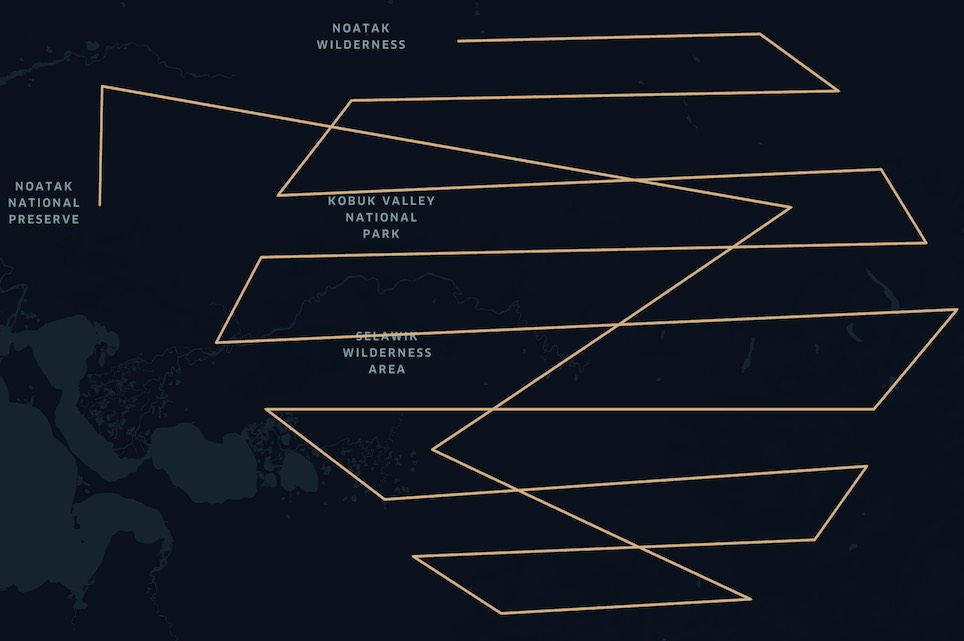

In [ ]:
displayHTML("""<img src="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB4igAwAEAAAAAQAABQKkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH6AABAAoAEgAEAAFhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNAAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAoEDxAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAICAgICAgQCAgQGBAQEBggGBgYGCAoICAgICAoMCgoKCgoKDAwMDAwMDAwODg4ODg4QEBAQEBISEhISEhISEhL/2wBDAQMDAwUEBQgEBAgTDQsNExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExP/3QAEAD3/2gAMAwEAAhEDEQA/APw/ooor0zkCiiigAooooAKKKKACiiigAooooAKKQDFLQAVckW1Nmjx8S7sMM5yPWqdFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBdsrw2bFtgbP4H86psSzFj3OeKSigLdQooooAKKKKACiiigAooooAKtRQrJbSzMDlMYPbk+lVa0rS0huLWV2OJB93JwOn60CbsZtFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGHrSUUUDP/Q/D+iiivTOQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpI4ZpQxiRmCDc20E4HqcdB7nio6+g/2dtch8Na54j165to72Kz8O30z28v3JVV4dyHrgMuRnBx1pCk7K54C0M6Isroyq/wB1iCAceh6H8KfJaXUMMdxNFIkcv3HZGVX7/KxADfgTX1f8S9H8EaLZfDe20q6W78PzXN5cB5M5W1nv4JHjmySd0aFkkz/dJOM4r0/4lD4gvonxKHxFDjQAsf8AYXneWIfO87/R/suO2zbnH40a/wBelzL2y003/wA7H5/Lb3DxNcJGxjXgsFJUfU9B+NTQ6fqNynmW1tNKvTdHE7j81UivvD4b+D9KHwysvhff6jYWt14xsLu+ktZnIuzPNt/s540xjCJEd2SOTx3ryH4E+OPG/huw8WaHZX01nFYaDqV4luuAIryIxjeOM71OR6e1HmNVb35VsfNItbpp/sqxSGX+4EYv/wB84zn2xTY7e4ll8iKN3fn5VUluOvA5r6h+Bx1CXUvEvxg1jUra1vLCAw217qLbITqF4cK7lVPKopPC87+1drpXhvTvD/7XOmXekskul6yZdUtJIjujaK6tJ3bYT1AkD49iKF0B1Um1bZXPik29wIvPMb+XnG/adufTd0z7ZzUVfRfxjjs28CeD7jwGW/4RD7Ky2ytjzVv8n7V9q2/KZzxgjjbu28dfnShGkZXVwooopjCiiigAooooAKKKKACkwDS0UAFFTSW88KhpUKhuhPeoaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACilwaNrelACUU7Y57GnCGY9EP5UrjsR0VP9muR1jb8jSfZ5x1RvyougsQ0UORGN0hCj3IFRefB/wA9E/76FMLEtFM82D/nrH/32v8AjT/680rhYKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI6KKKAP/9H8P6KKK9M5ApBS0UAAGKKKciNI4jXqxwKAG0U50eNtsilT702gAooooAKKtWIia7RJwGVjjB9+ldU2n2jSrLsAK9h0P1FFiZTscXRWhqVrHa3G2I/Kwzj0qCKzuZkEka5BzjkZOPagd1a5Woq+LPCMjhvNCl9o5wB0B9zQtmiZN0xXaMkKpOPqegosHMihRVqR7TdsiQ7f72Tu/LpTfITOfNTb68/y60DuV6Knkh2L5iMHXOMjPB981BQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhIHU4ycD3Pp9aWvbf2f2trv4gHwreqGi8QWN5pmD2eaItGfqGjABHOTS9BSlypyZ4juXBORgHB56H0Pofapo5p4SywuyFxhgrEEg9iB1HseK/RDXrPRtC8PX/iTToIlbwFpd5oQ3IDvuZbe18lj6kPJIvPORXy7q1tDF+zHo0sSjeviC9QPj5sLbHAz14pSutyKdVTtbvY8P8+SWJI/MLoudozlRnrgdOT1x1qSTUp7qGOzkumlji/1cZlLqnH8KFiF49AOK98/aa8L67Y/EzxDrh064g05jF5dwYHSA5tYgAsm0ITuBGAc5zX0v8Rj4n1HV/G+heK7MjwlY6F9os5pLRI0hulggaEwT7FLOZC+QGbkY4oa38he20i+/wDwP8z87G1O4EokkumEiABS0pDAdsEnI9sfhUttqRs7lpriUgyA7wZNpbP97kFhnrng19v+ENS1rSf2f9BbQpNVhlnfVdy6Zp0d6khW4IVZ3dHaMDOFK44z6Vp/s7yxwfDHQLIaiunfbPEdxA0TW0c4vUSIP9kLycJvC4DHvx1NNR1sTKvaLlbrb+tD4I+1TIht0kZI2JPl7ztyPbOCQO+M4p/9oXoZZBcSAxAqreYwKDuAc/KPUDFfWHwtufCulwfES88XaWRpcrWsM1qB+9tYri+mjIXHIktwRgL3TA7Vvaz4ZtvDPxr+FnhuOWK8igtbOMTRAeXOnmy7ZMc5Drg85x07Ukr2ZTrWbVtv8rnxWLuWSE26Tl485KK+Vz6lQcZ98ZqBZI5OI3Vv90g/yr7B+NWq67d+NtIhv4dV1S0t9VJW1v8AT47ON2WUYgt3jRfOWRAV5ZjjBxyavfGqTWNb/wCEf8aXLXl1plxqwih0TU7FLK5hkXEjQLsRfOhdP3QPzc8cnNF7XGql+W63/r+tj4wWSJ+I3Vv90g/yp9fXP7RD63r/AIZsPGT3N7Dpk9/JBDpep2KWdxZyiJnKxlETzYQnyA84IGSTmvkamVCXMrhRRRTKCiiigArYsvD2vajGsthYXU6MMho7eVwR6gqhBHuKyFYqwZeo5r6o8Iftj/G3wR4U07wdoF1ZJZ6XAtvDvsw77E4UM28ZIHGcCubEzqxivYRTfm7fozehGm2/aux4PF8PfHUyCSLRdRYHoRZXJ/lFU6/DP4iv9zw/qjfSwuv/AI1X0JL+3N+0i6kR6xbx5/u2cfH0yTVB/wBtv9pljkeIkHsLSD/4muRTx38sfvf+R0cmF/mf3L/M8YHws+LV5shTw1rMozhP9AucZPHUxj9a0U+BHxukOF8Iax/4CuP516BJ+2H+0rKSX8W3Iyc4WG1X8v3J4qs37W/7RrdfF19+C24/9o1UpY3pGH3v/JCUcL3l9y/zOZh/Z0+O8+3Z4Q1X5vWED+bDH41tW/7K/wC0Jc58vwjqPHqIR/6FKKfP+1Z+0NcJsfxdqOPYwD9RCDWRN+0j8ep33v4u1TPtKo/QIBUf7e/5F94/9k/vfgb6/sk/tGMcL4Rv/wATbj/2tU6/sgftJyfc8I3f/ApbVf8A2tXCyfHv43y53eL9X554umH8sVmXPxi+Ll44kuvFWsOwGM/bp14+iuB+lXGOO6yh9z/zQm8L0UvvX+R7DD+xT+0zMqv/AMI2E3c4e6gBH1Ac/pmtCH9hv9pSTJfRII/968i/pmvAW+J3xHcYfxDqpHvf3X/x2oj8R/H5665qR/7frr/47UuOO6Sj9z/zGpYX+V/ev8j6Wg/YQ/aFl2+bZWEWeu++UY+uIz+mav8A/DA3x57rpQ+t/wD/AGmvkabxb4pnXZNql6wznDXU5/m9Z8ur6tO26a8uGPTmeU/zal7DGveql/27/wAEPa4b+R/f/wAA+yz+wN8cV5ln0WIHu1+3H/kCpYf2CPiuwP2zW/D9uw/h+1u+fx8tcV8QyySTrsuGaVRzh2Zhn1wxIqERW4GPKj/74X/Cr9hi7fxl/wCA/wD2wva4f/n2/v8A+Afd0f7BXjrcPtHirw8g74mc/wCFTf8ADC+qwMyah448PwkDON7Hj/v4K+DdkH/PGL/v2n+FIY4D/wAso/8Avhf8Kh4bGPeuv/AUP2+H/wCfX4n3mf2MfD0MYe6+Jfh2P14OM/X7QKrN+yF4Ejz5/wAVvDibeTxnj8bmvhPybf8A55p/3yP8KPJg7Rr/AN8imsHieuIf/gKB4ih/z6/Fn2zH+zL8E0dTffGXQAh6+UiFunYm4I/MVbH7N/7OCcS/GXTT/uxxf/HDXxEJJF5UkfSn/aLgdHb8zVSwmIf/AC/f3R/yEsTSX/Lpfe/8z7j/AOFAfsq2xVrn4vW7joRHHCT/AFxTk+Dv7GkAZLr4pzOwPWOCHH/ok5/A18NG4uD1kb8zTDLIerH86j+z6r+KvL8P8h/W6a2pL8f8z7hPwy/YhTmT4mag3+7ap/S3NU5fAn7DELmNvHuvTEdDDZZU/Qi1wa+KdzeppNx9auOXyX/L6X4f/IieMj0pR/H/ADPuNfCv7AqAE+IfEsh74glH4/6gVYXQ/wBgKGM/8TPxLKRk/wCqnBP/AJDAr4ToqXl0n/y/n96/yGsav+fcfuPu77T+wFaMreR4ln4xjdcL/Vf0qKTxJ+wHExC6L4mkx6TTDP5zCvhaiksqj1qz/wDAg+vvpCP3H25P4x/YNix9n8I+JLoHOQbp0A9PvXIz+FOi+If7DcCeWvw61aX0aW7UsfqTdE/4V8Q0Vf8AZsbW9pL/AMCf+Yvr0v5I/cj7pj+Kv7FEJLR/DG8Y/wC1cxH+c5pG+Nv7IVsrrafCjzB1XzJoST9fnbH4Zr4Xoqf7Kpv4pyf/AG8/8x/2hPpFfcj7ml/aK/ZjTH2f4O2Leu54R/JTVWT9pT9nxUYWvwZ0nd/D5kkWPxxET+Wa+I6Kaymgu/8A4FL/ADE8wq+X3L/I+27b9qn4V2Unnaf8IPDsLEYJ3KTj8LatBP2w/B0X+o+FvhxMcjk/0t6+FKKcspw8t0//AAKX+YLMKy6r7l/kfeZ/batIHD6f8PPD0Jxgn5ifz8kVc1P4Z/Cf9qWwm8U/A0xeHvGIQT3vh64cJDMf45LZgCBk/wASjaT99VYkj4ArQ0vVdT0TUIdW0e4ktbq3YPFNExSRGH8SsOQf5jg5GRUPK40/fwrcZerafk12GsdKfu11df1sWfEHh7XPCur3GgeI7SWyvLVtksMyFHU+4PY9iMq3UEjmsavvfQvjX8MP2htGt/Av7TCjT9Wt1WOx8TQBUdSTjbcgDaAeMkgxN1IQ4r54+MvwA8e/BXUUTxBEt1p1y3+iaja5e2nU/d+bnY5GPkY/7pfrWuHxt5exxC5Z/g/R/wBNEVcLZe1ou8fxXqeH0UUV6BxhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBHRSnrSUDP/S/D+iiivTOQKD0qeE2+x1nByR8rDnB+nvUFAAOlTW8vkTLNtDbecGiG2nuDiBC2O/b86mOn3wJHlNxQK62Y++uLW5IkhVlc8sT3qgeBmtK30u6nP7xTGuOpHP4Cia1srV8SymQj+FR/M9qBJpaIuf2fYJEfMdtwXcWHQf0/DrWYbN2XzLY+av+z1H1HWrN1fpdW/ltuUg8KuNox+prMBKnKnB9RQwin1DJUg9CK1Y9T1KdhDEQWPoOaqxTSyLJHKxdQhOD6jpUlrdT20XyMiAnqRkn6Y5xQD9CvdQTW8u24+8RnOc1LPK6rCsZ27Yx06jPXn3pHnTzftGfMcnPIwB+HeqjMzMWY5J6mga8xVd0bchIPqOtKssqqVViA3UZ6/WmUUDCiiigCeGcwhkKhlcYIP9PemtHlTJHyo6+o+v+NRVbssCfJGflbA9TjpQLbUqUVO9tLEhZiPlxkA5Iz0zUFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrFrdXVjcpeWUjwzRHcjxsVZSO6spBB9wQRVeigDUl1vWp4Li1mvJ3jupBLOjSuVlcdHkBOHYY4Zskdc1XOoX5s004zyG3jcyJEWJRXPBYLnaGI4Jxkjg8VTopWQzodR8XeK9Ys/7O1fVL27t8g+VPcSyx5XodkjsuR244puo+K/FGsWi2Gr6neXcCkERz3M0qAjoQjuV47ccdqwKKLIVjo9P8YeLdJsxp2latfWtuM4iguZokG7r8iOF578c96zE1bVI4IrWO5lWKCXz40DsFSX/nooBwr/7QAb3rPoosgWmppvrWsyPcSPdzlrsgzkyNmUqcgyc/OQeQWzg89eae+uaq1xbXUdzKklmqpAyyMDEF6CM5yg7gLgA8jmsmiiyA6HUfFvivV/KOq6pe3XkP5kXnXM0mx/7yb3O1vdcH3qHU/EviPWriK71nUbu7lh/1bzzyysnOfkZ2JXkA8EcgHqKxKKLILWNnV/EXiDxA6Sa9f3V80QwhuZ5JioPZfMZsD6VjUUUAFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAXBIJA6daSrVlcC1uBKwyvIYexqW+Nm5WW043feX0/pQK+tihRRRQMKKKKACiiigAooooAUEg5FfUHwZ/aZ1z4faa/gPxtaL4m8IXQEc2mXW1vLQ9Tbl+FwP8Almx2f3Snf5eorDEYanXjyVVc1pVp0nzQZ9p/EL9mnQvFHh2T4q/szXja9oK7jdaeSzX9k45KFCN7hR/C37wDkbwRj4uZGQ7XBB5GDx04P4g8EdjXd/Dv4meNfhX4hj8TeB7+SyuUwH28pKg/glQ8OnseR/CVPNfZktl8Hf2wYmudI8jwf8R5EYm3ZsWOpOvOVOPvkdwBKv8AEHUDPAqtXBu1f3ofzdV/i/z+863Tp4nWlpLt0fp/kfntRXY+OfAPi74b+IpvC3jOxksb2Dko4+Vl/vxv910PZlyOxweBx1enCcZpSg7o4ZRcXyyWoUUUVZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEdFFFAz/9P8P6VVZztQFj6DmteDRp3YGYgLnnHX8K0w9npsexpMsO3GT7YAr07HC59jCg067uE3ouB0+birCaRNgvcMEQDORzxU764zKVEeM9Of51lsbm9lZ1BY4yQPT6UB73U1RrEcce2FMbeFHbHYn/CqL6rfOMb8e4FUWVkYq4KkdjTaLjUUW3vrx12NISDVSiigqwUUUUAPjkeJt8ZwelIzM7F3OSe9NooAKKKKACiiigAooooAKKKKAHxuYycAEEYIPQin5tm6qy/Qgj9f8ahooAlaNNpaJiwHUEYIHrUWakjZQrI3G8AZ9MHPSp/tTK21QGjHRWHHHf60CKlFaUj6ZKA2Gi9VUZyfqaql7ZQRGhf3c4/QUBcr0Va22ZYsXYDsoXn6Z6UzfbHgxsB6hufyPFA7kFFT+XCeVkGO+QQf/r1ExQn92CB7nNADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACijIooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqWGaW3lWeBijowZWUkEMpyCCMEEHkEEEHkc1FRSavoxp2Pt/wT+0b4T+I/huL4V/tR276nYICLTXE4vbJuzOyjcyju6gnHEisMtXmXxq/Zu8T/Cy3Xxdos8eveFLzD2mq2nzp5bcr54TIjP8AtA+W3qpIWvm3pyK9/wDgt+0V42+DU72Fpt1PQrnIutJujm3lDfeK5B8tz6gbW/iUk5Hlzwk8O3Uwe3WPR+nZ/gd0cRCsuTE/J9fn3PASCp2kYIpK+7vFHwD+H3xt0Wf4h/stSgTw/vNQ8NzsFuLYsM/6OCSNuc7V3eWf+WbDGD8NXlleafdSWV/E8E0LFJI5FZHRl6qysAykehANdWGxkK6fLo1unujCvh5Ut9V0fRlaiiius5wooooAKKKKACiiigAooooAKKKKACiiigAooooAjooooGf/1PxfvNXiZDHbAk/3ug/xrn/c0UV6ZxqKWwVZt41dJH8zY6DIGcZ/Gq1FA2Od3kcySHLHqTTaKKACiiigAooooAKKKKAPXfgx8F/FPxy8TXPhfwnPa201patdySXbMqbFYIANqsckn6AAk+lera/+xL+0TohD2+ix6nF/fsLmKX9JPKOK3v2Mj5V/49um+5H4Wucn/gR/wr5g8N/En4heF4Lc+G9d1Gx8tVKiG6mVRwONhYpj224ryZ1MTOvOFCSSjbdd13TPRjCjClGVVO7vsy1r/wALviT4WMn/AAkfh/UrIR/eaW1l249d6qyY/wCBVwQKM4jVlLnjaCC2fTHXNfV+gftq/tF6G22XXV1GL+5fW8Uw/NBEf1ruZP20bTxNbC3+KPw+0DXhkb2CmJiO5AeOQA9/vfjVe3xkPjpJ+j/zS/Mn2WGl8M2vVf5Hw0yshwwI+tNr7qTxx+w14snC634P1bw3JKMGSwlLRgnvshlPTt8n4VCvwW/ZF8WRFfBnxOk0uZj8sWsQImCTgKd6Qsef9rp370/7TUf4tOUflf8AK4fUW/4c0/n/AJ2PhuivuW5/YT8daggu/AXiLQtft3GVMVw0JI9R/rQfzryPxD+yd+0P4aEj33hW7mSM/ftTFcKR6jY+8/8AfGa0p5nhp6Kovnp+ZnPA1o6uDPnaitrWfDniDw64j8QWFzp7H/n6glg/WRVFYyAygtFhwOpU5H5iu2MlJXTOZxa0aEoooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopcGgBKKXafSl2t6GkMbRT/AC5D/CfypwgnPRG/I0XCxFRU/wBmuR1jb8jSG3nHVG/I0XQWIaKeY3U4YYPvUHnQ/wB9f++h/jTCxJRUfn2//PRP++h/jSiWA/8ALWP/AL7X/Gk9Nwsx9FNEkB/5bRf9/E/xo8yD/ntF/wB/F/xpc67j5X2HUUwy24GfNj/77X/GpYlNxn7MDLjr5YL4+u0HFPzFysbRVtdP1BxuS2nYe0Uh/wDZavL4d8QPgLp92c9MW83f/gFJzS3Y+SXYxqK6uLwN4znfy4dH1Bm9BZ3BP6RmrQ+G/wAQD93QtTP/AG43X/xqs3iKa3kivZT7HFUV3Q+GPxHblfD2qkeosLr/AONVYi+EvxVmdUh8L6wxYgL/AKBcjOenJjA/PFHt6f8AMh+xn/Kzz2ivVl+BPxtc7V8Iax/4CuP51ch/Z7+Ok+dnhDVuPW3x/MipeKor7a+9D+r1P5X9x47RXukP7M3x9nTenhHU8dOY0H6Fwa1U/ZP/AGiJFDL4R1DkZ/5YD+c1ZvH4db1F96KWErPaD+4+dqK+jl/ZI/aNbp4Rvvxa3H/tapl/ZA/aTf7nhG7/AOBS2q/+1qFmGG/5+x+9D+p1v5H9x810V9SwfsWftM3EfmDwyY8/wyXVuG/IOR+tXo/2H/2l3IB0CJc+t3Dx+RNJ5jhl/wAvY/ehrBV39h/cfJlPjYJIHZQwBzg9DX19H+wr+0azhZNKtUB7teIB+in+VaMH7Bf7QEmfNt9Njx/evgM/lEazebYVf8vV95Sy+u/sM+Obu6W7Kvt2sM5APH4VTr7a/wCGBvjznkaSPrf/AP2mlb9gb45IMyTaKg9Wv24/8gUv7Xwj/wCXiBZdXX2GfElFfbsX7BPxeMmy71fw/AuPvG8dv/HfKX+dWx+wR8RV4m8TeHk/7bv/AICm82wi/wCXiH/Z9f8AkPheivu9f2DfFyRl7nxf4fTGSf3rkAfXIoP7ELwoJLvx94ejHG4lmwCffzRmpecYXpP8GP8As6v/ACnwhRX3jL+xn4agx5/xM8OpnpkH/wCSKr/8Mg+BlO2X4q+HFPoBn+dzSWcYbu/uf+Qf2dW7L71/mfC1Ffajfsw/CCMsJ/jH4cQqSCFQHp9bnNWV/Zr/AGe1QGf4zaTu43bI4sZ74/ek4+uat5pQWt3/AOAy/wAhfUKvl96/zPiKivuSP9nT9mZGzP8AGOwYeipCD/6EalHwF/ZQt5Clz8XIX448uOEj88EVDzeh0v8A+Ay/yK/s+p1a+9f5nwtRX3XH8H/2MokxcfFKdmGclIIcfrCagPwx/YjTlviZfn/dtYz/ACt6P7Vg9qcv/AX/AJB9Ql/MvvX+Z8N0V9uT/D/9hq3xu+IWszA5/wBTZhsfUranFEHg79g2Ld9o8W+JLkHGCLR0A9fu2wz+NX/aUbX9nL/wFi+oy/nj96PiOivuZfDH7AqcHXfEz+/kTD+UIqd9J/YCt4wwv/EspGOPLnBP/jgFQ81j0pz/APAR/UH/ADx+8+EqK+7jdfsBWrq/k+JZxzxuuF/qp/KmS+If2A422rpHiWT3E04H6yil/acntRn9wfUV/wA/I/efClLg+lfcbeK/2Blzjw54lcjpm4l5/wDJgVQHjj9hdSCPAviCRh/fvuD9f9LwatY+T/5cz+5f5ieDX/P2P4/5Hyd4V8V+J/BOtweI/Cd5Np99bnMc0J2sPUcghlPdWBU9x0r7ktfGXwh/a1t4tF+KIi8KeOgBDa6vENtretj5UnUkAMT0Vjn/AJ5vyRXN/wDCy/2HlO5PhrqJP+1dIB/6Ump4viv+xTDny/hhdnP9+4ib+c5rhxVT2r540Zqa2atf89V5HVQgqa5XUi4vpr/kfMXxR+D/AI9+Duv/APCPeObIwSMCYpo8vbzqP4opcAN7qQGHdcYJ8xr9JvFn7ZXwd8SfD6f4c3ngi8vdOETJbx3d5GxjYA7GWUtJIhU9GXJXt6V+bb7Nx8sELk4ycnHbJAAzjrgDnsOlehl9etVg/rEOVr8f8jjxdKlCX7mV1+Q2iiivQOMKKKKACiiigAooooAKKKKACiiigAooooAYetJRRQM//9X8P6KKK9M5AooooAKKKKACiiigAooooAKKKKAPtb9j9NmmfEm87R+FpuPXJk/wr4kg/wCPeP8A3F/kK+1f2XGe0+HXxa1K3YrLD4WfaeCOTP6/Svi/aqAIvQAAfhXm4TWvXfmvyO7EfwaXz/MKKKK9I4Qp4kcKVBOD1HY0yikMltJpLCdLqwJt5UOVeImNx/wJMN+teteHfj98avCj7tC8U6nCvZGuDOo/CcSV5BRWdShTqaVIplwqzhrF2Ps7SP27vjvZwrb66+m60gPzLeWYBYehaN1A/wC+a25P2n/gl4uuGb4lfCnTJ3lGHuLB0WXnr99IiDn/AG6+FqK4pZThnrGNn5Nr8jpWYVtpO/rr+Z9zk/sE+LoSceIfCkpPQeZcRoT/AN/02j8qcn7MHwQ8W3AHw2+K2mTNIMrb36Isvt9x4iD6/JXwtSufNAWb5wOgbkfkan+z6kf4VaS9bP8ANX/Er65CX8SmvlofZurfsI/Ha0ha40JdN1qMfdazvBlh6hZEUD/vqvEfEXwA+NfhR9uueFdThX++luZ1H4wGUV5zo/iPX/DzmTQL65sCf+fWeWD9ImUV7d4f/aw/aH8NIkdh4qvJVQ/duhFcKc+u9N//AI9T5cbDaUZeqa/K4c2Flumvx/yPny6hksJ2tb8G3lQ4ZJR5bj/gL4b9KYUcKHIODyD2Nfclr+3Z47v1Nr488O6Fr8DDDCW3aFiPQ/60H8qa3xp/ZG8Wxh/Gnwxk0uZj80ukTomCerDY8LH/AL5pfXMRH+LQfyaf52D6tRl8FX701/mfDdFfdcngf9hrxbPu0Txhq3hqWUcR38RaIE/7c0Z6d8PTB+xdY+JbY3Pws+IOg66v8Ku3lMfYlHkAOePu01m1FfxU4+qf/DCeX1H8DT9Gj4Xor6v8QfsU/tFaE+6HQl1GLH37G5imH5OYj+leDa78NfiH4YMg8R6DqNj5RwxmtJgo/wCBhShHuGrppY2hV/hzT+ZhPC1YfHFo4mikRo5GCROrsegVgT+QNPZWU4YYPvXTcxsNooopiCiiigAooooAKKKKACvoT4AfA9/i3rF5qXiK5bSfDGiwtcapqXyqIlC5VELgrvYfMcghUGTyy584+Gfw68SfFTxpY+CPC0XmXN4+CxBKRRry8smOiIOT6khRywr6W/aL+Inhvwh4bt/2ZvhJJu0LSGzql2CC1/fA5k3EcFEbluxfCjCoQfOxlebksLQ+J7vsu/r2O3D0opOvV+Ffi+3+Zdi8IfsFRxhJvE/iWZx1b7NIpP4C3Aqynhz9gNGBOteJnx28mb/4yK+F8k9aSpeXTf8Ay/n96/yK+ur/AJ9R/r5n3cbH9gK1kB+0+JZwQeNlwo/9BU0JqH7AVs7IbTxLMM8EvcL+WHB/OvhGip/su/xVZv5h9f7U4/cfc7eJf2BEzjRPEz4/6bTDP5zCq0/jD9guNAbfwr4kuDnlftTpx6ktcgfrXxDRVLK4L/l5P/wJi+vv+SP3H2zD49/YZgk8xPh/rkwx0mvcj/vlro/nVsfEz9iFPufDTUG/3rpP63Br4bopyy2L/wCXkv8AwJ/5gsdJfZj9yPuo/Fz9i6GIrB8LrhiBxvuIj+Z84mmH46fslwKptvhKjlSOJJYSOPX5jn8a+GKKn+yab+KUn/28/wDMf9oT6RX3I+5pf2iv2ZEI8j4O2Lf7zwj+Smof+Gk/2dUOI/g1pePeSLP/AKKNfD9FNZTQXf8A8Cl/mL+0Kvl9y/yPtP8A4ab+DS5WD4NeHgOcb3U/n/ox/Q1qj9rzwEgAi+FPhxdvTJzjH/btXwvRTllWHe6f/gUv8xLMKy6r7l/kfd8f7ZXhaFt8Hwx8OofUE5/9J6cP224YHb7D8PvD0SnHADH8z5I/lXwdRU/2NhusX97/AMx/2jW7/gj7uT9u/wATwRmO18HeHoxzgCN8ZPttqE/t6/EIcw+F/Dyn/rg5/qK+F6Kr+yMJ/wA+/wAw/tGv/Mfb8/7e3xaZg1no3h+3x1/0N3z+PmLio1/b4+N6EmK30SPPZbBv/j9fElFP+ycLt7NC/tCv/Oz7bP7fXx4PQ6SPpYH/AOPVBN+3r8fpFxHPpsZz1WxGf1lNfFdFL+yMJ/z7Qf2hX/nZ9iTft1/tFuQYtTs48D+GyQfzY1Qk/bi/aWdty67Cg9BaRY/XNfJVFWsswq/5dL7kS8dX/nf3n1TJ+2v+0zIrKfEgXcCMrawAjPplDz6ZBrLb9sH9pR+H8XXWP9mG1H/tGvmqirWX4Zf8uo/chPGV39t/ez6PP7XH7RrdfF19+C2w/wDaNRn9rP8AaJPXxdqH/kv/APGa+dKKX9nYb/n0vuQvrlb+d/ee7zftOfH+ZWV/F2p/N1w8Y/lGMfhWbL+0R8dpV2t4v1X8J8fqFFeNUVawVBbU19yJeJqveb+89Xf47/G2TlvF+sfhdOP5VmzfF/4tXMpnuPFWss56n7fcDp7K4H6V51RWiw9JbQX3Il16j3kzuz8UPiS33vEWqnPXN/df/HaiPxI+IB+9rupn/t+uv/jtcTRR9Xp/yoPbT/mOtm8e+NrnHn6zqD46bry5P85DWdL4m8STOZJdRvGY9SbmYn9XrDopqjBbRE6snuy8+qanISZLq4bd1zNIc/m1VZJppk8ud3kX+67sw/Ikio6K0SS2J5m+owRW4/5ZR/ioP8xS+XB/zyi/74X/AAp1FDSe4rvuJsg6eTF/37T/AApy2sTxNIsUfyEZGxc4PfpSU9JHjJaM4JBB+hpKKXQHJ9yDyLf/AJ5p/wB8j/CjyYP+eaf98ipKKoLjgzDGDjHSpPtE45Dt+dQ0UrBcn+03I6SN+ZpDcTnku35moaKLILj/ADJP7x/Ok3N6mm0UALub1oyaSimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjooooA//1vw/ooor0zkCiiigAooooAKKKKACiiigAooooA+yv2bTt+EPxgbpjwwoz9WuK+O7gYncf7Rr7D/Zx/5It8ZHHRfD0Kn6lrg18e3X/HzJ/vH+deZg9MRXXmvyR3Yj+DS9H+bIKKKK9M4QooooAKKKKACiiigAooooAKKKKACiiigBysyHKkj6Uxkjdi8iKzHqWUE/mRmlopWHc7zQPij8SPC3l/8ACN6/qViI+FWK6l2gemxmZMf8Br3bw/8Ats/tE6H+7n1uPUouy39tHL+sflH8818m0VzVcFQq/wASCfyN4YqrD4JM+52/bL0fxNbrD8VPh3oOuH+OSNfKc+4V45ADn/bp6+Mf2F/F07f2x4V1nwzLKBl7GVniBPUiOGRwMf7lfCtFczyqkv4TcfRv8tjZZhUfxpP1SPuQ/BH9kzxYmfA/xQ/s2Un5YdYhRCCeincsDnHTqaL39hL4h3ii78B67ofiC2ZdytDcNCx+gIlBz/vV8PCRwpQE4PUdjUlncTadOt1p7G2lTo8JMT/99IVP60vqeIh/Drv5pP8AKw/rFGXx0vubX+Z774i/ZU/aE8Lq76j4VvJVQ/ftfLuFI9R5blv/AB2vEdY0HWvD0wg1+zuLB26C6hkg/wDRqp6V6f4c/aF+N/hT5dD8VanEnZHm89R9BOJK9s0n9vD442sCW3iFdL1yNfvC8tMMw/3o2Az/AMAp8+NhvGMvRtfnf8w5cLLZtfj/AJHxeimVS8XzqOpXkfmKSvupv2mfgP4vlJ+Jfwq06SRx81xpzojnv/GsRBzn+I1EYf2C/GEAkWbxB4RlzjDB7iNM/UXCbe3Wl/aFSP8AFoyXpZ/k7/gH1OEv4dRP8PzPhqrVlZ3Wo3cVhYxtNNO6xxxoNzO7sFVVHcsxAA9TX3BH+yz8HfGE5Pww+KelXRcZW3vkVJQT0B2PH/6BXv3wW/ZO8XfBCLVPihfWlt4q8QWcONCsrOQCEyOuDO7zbACM4A52qGIyWwM62dUIQbT97ommtfn+JdPLKspK+3da/kePeJLm1/Y9+Fr+BdHlD/EDxXAr6lcRtzptowO2KMjo5OQp6li0nQKtfnwAAAqjAAwB6AV7x8R/hN+0E3iG88S/EHw/q0l5fStPPcGBpgzv7wGUKABhV6KoCjgCvC7mJ7OVre9HkSLwUl/duP8AgL4b9K3y+EIxc+dSlLVv+ui2RljJSclHlslsiOinmORQGZSAe+KZXoHGFFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVJEhllWMEDccc9KjooAuX1qbS4MY+6eV+lU6tBpLvbFI4BQYUt3yemagkjeJzFIMMOooEuzGUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI6KU9aSgZ/9f8P6KKK9M5AooooAKKKKACiiigAooooAKKKKAPsv8AZ6RoP2fPjLqKkZOlW1vtI7HzST/49+lfHVwc3Eh9WP8AOvsX4Hv5P7LvxflU7S0NkhPsQRj8c18cSnMrH3NebhNa9eXmv/SUd2J/hUl5P82R0UUV6RwhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHTmivX/gl8H/EPxp8c2/hXRR5UA/e3l0w+S2t1+9I2eMnG1FP3m/2VbGdWrGlB1KjskXTpyqSUIrVnpf7Onwf0LxU158Wfiwyw+CvC4M120o3faJkwy2yDq2eN4HJyqDJZgOU+LX7Q3jz4jePrjxbp99d6RbqogsrW1nkgW3t0+4mImUF+7nnngfKorsv2jvjB4f1qKx+Dvwlxb+C/Dg8u3EZ4vJ1PzXDn+IZzsJ+8SZDnKGvk6vPwtB1pfWsQt9k+i/zfX7jsr1VSXsKT23fd/5I+jfDn7Wv7Q/hgIll4ourhF/gvFjuFI99yB//AB6vWrT9uvxvqCNafEDw3oXiC3dcESwNAx9j/rgR+Ar4YorWplmGnq6a+Wn5GcMdXjops+41+Mv7IPiqJR4y+GMmkSd5dHmVdp9RseFjz/s1M3gb9hrxXLnRfGOreHJZRxHfxFowT/tzRHp3w/418LU5WZDlSR9Kz/sxR/hVJR+d/wA7l/Xm/wCJBP5f5WPuVP2LrPxLam5+F/xB0DXRztUsYmI7AlJJAD2+7+FcNr/7FX7RWhtui0JdRi/v2NzFMPycxH9K+UGSN2LyIrMepZQT+ZGa73Qfij8SPC3ljw3r+pWQj4VYrqXaB6bGZkx/wGj2GMh8FVP1X+TX5D9rh5fFBr0f+ZHr3wz+InhYuPEmg6jY7OpmtZQuPXeFKf8Aj1cMjJIwSJ1dj0CsCfyBzX1l4f8A22P2idC/dz63HqUXZb+2il/WPyj+ZNds37ZuleKLdbf4rfDzQddwfmdF8p/qqukgBzz9+l7fGQ+Okn6P/NL8w9lh5fDNr1X+R8NMrIcMCPrTa+6l8a/sM+L5NmteEtX8MyyDmSwlLxgn/Yhkbp2ylQf8KV/ZI8Wx7PBHxOfTJ2b5YtYgVMZPCncsDn67qazNR/i05R+V/wArg8C3/Dmn8/8AOx8OUV9zXf7CXjy+UXXgPxDoWvwMMr5Vw0LEeo/1oP515Dr/AOyf+0P4bV5L/wAK3cqp/FamK4Uj22PvP/fNaU8zw09FUXz0/Mznga8dXBnzvRW1rPhzxB4dcR+ILC509j2uoJYP1kVRWOimUFofnA6lfmH5jNdsZpq6ZzOLWjQ2ijpRVEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBJJye9FFABRRRQAUUUUAFFFFABRT44pJnEcQ3Me1I6PGxSQFSOoNADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjooooGf/0Pw/ooor0zkCiiigAooooAKKKKACiiigAooooA+zPhIpj/ZE+K8zDAaSwUH1PycfqK+NX++frX2b8Oma0/Yu+JU5AYXGpadAOehf7OM/hur4xb7xrzcBrOtL+9/7bE7sX8FJeX6sSiiivSOEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiijgAseAAST6Ack0DNrw54e1nxZrlp4c8PW73d7eyrDDEnV3c4A9gOSx6KoLHgGvtr4ua9on7Nvw6f9nn4e3CT67qiiTxPqMZ+bLKMWkZ6qNpxjOVj/wBuTdWl4T0+0/ZA+GA+JWvxrJ498TwGLSrOUf8AHhatjfPIvXecgsO52xgj5ifgO+vbvUr2bUb+V557iRpZZJDud3clmZj3ZmJJPrXkR/22pzf8u4v/AMCf+S/FnoP/AGWFvtv8F/myr/niiiivXPOCiiigAooooAKKKKACiiigAp4dwpQE4PBHY0yikMltJpLCdLqwJt5UOVeEmNx9GTDfrXrfh34/fGrwo+7QvFOpwr2RrgzqPwnEleP0VnUoU6mlSKZcKs4axdj7N0j9u748WcIt9cfTdaQH5lvLMAsPTdGygf8AfNbkn7UPwV8XXJk+Jnwq0u4kkAD3Ni6LKfX76RnOenzmvhaiuKWU4Z6xjZ+V1+R0rMKy0lK/rr+Z9yh/2C/GEBLR+IPCMuegMlxGpPcY+0IFH4VIn7MnwK8XzD/hWfxV06V3Hy2+oIiSf+ONEc5/2a+FqVyZVCS/OB0Dcj8jU/2fUj/CrSXrZ/mr/iV9chL+JTT/AA/I+0NW/YQ+OVrA9z4ebS9cjH3TZ3YDMP8AdkQDP/A68T8Rfs8/G/wqN+ueFdTiQdXSHz1H1MBkrzHR9f1vw9I02gXlxYM3U2s0kGfr5TJXtnh79qv9oTwwqpp3iu9lVP4bry7hT9fMQsf++qOTGw2lGXqmvyuHNhZbpr8f8jwO8tptOna11FTbSp1SYGJv++XCn9Kj8uQKH2nB6HtX3BZ/t3/Ee7H2Xxvoeh69bsNrLNbNCxHfJBlBz/u0v/C8P2TvFURHjX4WjT5Sfml0iaNCCerDDQN9OKPreIh/EoP5NP8AOwfV6Mvgq/en/wAE+G6K+6X8JfsKeLZll0rxRrXhmSUcR3sTSRA+heaNxx7PQn7G3h7xRG0vws+I+ha0OqpKfLfHoSkjDr/sCms1pL+KnH1T/PYTy+o/gafo0fC1FfWviD9iP9ojRAstro8WqRHq1hdRy4/CTyT+Wa8L8Q/Cj4m+E2dfEnh7UrIJyWktZSmPXeisn/j1dFLHUKv8OafzMZ4WrD4os8+opNyb/LDqWzjbkbs+mM5z+FPZHQ4cEH3rquYWG0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSks3LEn60lFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFJmloAKKKKACiiigAooooAjooooGf/9H8P6KKK9M5AooooAKKKKACiiigAooooAKKKKAPtDwR/wAmT+O1/v6/pan6f6NXxgetfZ/gvj9ibxk3r4l00Z+i21fF9eZl3xVl/e/RHdjPhp/4f1YUUUV6ZwhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9o/s6/Dfw74T8PT/tM/FtM6Bo5/4ltmQC+oXoP7sIDwVRuF7M/zZ2pk+Zfs8fBO4+Lvip7jV5BZeG9HX7Tq967bFjhUFvLVuMSSAcHPyrluu3Nj9on42RfFXxDb6R4ST7D4S0SMW2kWSLsRY1G3zmTs7jgA/dTAwCzivLxVSWIn9UpP/E+y7er/AAXyO+hBUY/WKi9F59/RHmXxP+I3iL4reN77xx4ml33F4/yoCSkUa8RxR9MIg6cDJJYjLGuAoor0adONOKhBaI4pzc25S3YUUUVZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKGZTlTimuEkcvKiux6llDH9RS0UrDudnoPxF8f+Fgg8Na5qFh5ZyoguplUZ6/JuKfmte7eHf20P2ivD8gDa/8A2hFjHl38EUy8e6CJv/HjXytRXNVwdGr/ABIJ/I2hiasPgk0fc/8Aw2t/wkdv9l+KPgPQNfToxCGFiD1IDJKAT/vD605PiF+xB4suEOv+CNT8OySDDS6dNmNSfVIZckDt+7r4WormeU0V/CvH0bX/AADdZhUfx2fqkfch+EH7HPilGHhP4lXGjSk5EWrQqoX2JkjiY/8AfVPuP2F/F2qIt38PfFOg+IIW6eXO0JP0/wBcP1r4bWSROEYj6Gmwn7NIs1sBE6nIeP5GB9mXDfrR9TxEf4dd/NJ/5D+s0ZfHS+5tf5n0j4h/ZF/aI8NmRrrwxcXMaciSzeKdWHthw/8A45Xhuu+E/FHhg7fEum3enHJH+lW8sIBHGN0iqv5Gu48OfHX4x+E3B0DxPqduo/gNw0q/98zeYP0r27RP26fj9ptuLXV7qx1pAeRfWiszL6FomjH47TS5sbDdRl82v8wthZbNr8f8j46jxKSISJMddhDfyzQQRwa+6ZP2rvhV4ukU/FH4W6RfO/37izZUl56keZGv4fPUf2/9gzxfDJHPYeIPCUp5zC0lxGv+6qtOmO/3aPr9WP8AFoyXpZ/lr+AfVIS/h1F89D4Zor7m/wCGc/2dvFkkY+HfxXsVlk4WDU440dvbCtCwP4GqGqfsG/GiGJ7jwzcaTrkY5U2t3sZvba6kZ/4HVLNsPtOXK/NNfmS8vrbxV/TU+KKK9r8Rfs5fHXwqnm614U1JEHVo4hcAf9+GkOPwryDULC80i5az1aJ7SVeClwrQt/3zIFP6V2U8RTqa05J+jOedGcPji0U6KcEZkEijKnoRyPzptamYUUYJpwRz0BoAbRUognb7qMfwNI0MqfeUj68UXQWI6Kj86D/non/fQ/xpwkgP/LWL/vtf8aG0twsx1FNDxMwRJEZicAKwYk+gAyTWnBo+r3XNtZ3En+7BK38lNJyS1Y1FvoZ1FdjD8PvHVwm+DRdRcdMrZXJ/lFWlbfCT4q3sgis/DGrysegFjcD36sgH61n9Yp/zL7y/Yz/lPPKK9ktf2ePjreY8rwhqvJA+aDb1/wB5hXSw/sn/ALRNwgePwjqGG9fIX+cwrOWOw8fiqL70WsLVe0H9x87UV9O2v7Gv7S1422PwrNFxnM09sg+nErGugt/2GP2j5cefpFtDnP8ArLyMfyBrOWZYVb1Y/eilgq7+w/uPkKivtpP2BfjywG8aTH/vX5/pDU0P7BPxYJP9o6z4fs8Y4a7dz79I16frWazfCP8A5eIv+z6/8jPh+ivu/wD4YW1qzAfWvG3h62XGSS7N9errTJv2PPBlqT9u+KXhyHHXjnj63Iqf7Yw2ylf5P/If9nVuq/FHwnRX21D+zV8Aol/4mfxl0fdn/lhHHjGPeZqvL8Cf2TNPI/tP4tRzDjP2eKE/+yv/APWpyzaitFd/9uy/yBZfU6tfev8AM+F6K+4pvhr+xBbKWl+JOpTY7Q2iEn6bbY5NEHhT9gmBAJvEviW6buwtpFz+C26ij+042v7OX/gLD6jL+eP3o+HaK+7w37AOlvjHiW9H/bxH2/4BVCfxb+wVAuYPDPiW7P8Ada5kQH8WuFFJZk5P3aM/u/zY3gkt6kfvPiEKx6A08QTt91GP4Gvt2D4l/sQ2oURfDbUpivea7RifruuTmpT8d/2TrAkad8JIpgAcefLCT14/ieh5hUekKEvwX6h9Uh9qqvx/yPhxoZV+8pH1FV/OgBwZEH1Yf419uzftLfAWIAaX8GtFB9Z5IyMf8BhatOH9sPwbaEGw+F3hyHHAwefTtbU3jMRb/d398f8AMX1aj1qr7mfCIkgP/LWP/vtf8aPMhJAEiEngAMCf0Nfd/wDw3Vr1oCukeCvD1uMAAeWzdP8AgK1Rl/b1+LLMPsOkaBZgdStm8h/DMq0LEYt/8uV/4F/wGDoYdf8AL38D4fI+YqeCpwR3BHUEdQR3BowK+7/jrp9h8fPhPYftL+FreOHVLELp/iW2hUjZImBHcAZ4QA5yesbgsfkxXwkQQcHgiunCYlV4ttWa0a7MwxFD2UrXunqmMXrTqKK6jBBRRRQAUme1BOBSAd6AHUUUUAJgGjApOTRhqQXP/9L8P6fFG00qQp952Cj6scD9TTKs2TBL63kY4CzRsT6AOCf0r0mcqO51T4WeOdF1bVdD1Wy8i50W1N9dozD5bcAHzFPRx8wxtznkdQQL/hH4M/EfxzpR1vw3YLLbeY0KPJNFD5si/ejiEjAuw6EDjPGc5x9L+NPjP4F8Ujx3Y31xHJcrYXVpot6pO25t7kRu1ufUpIpMZPYsB3z594WvPAfirwn4Nj1bxDZ6JceEr65mniuw4aWOW6S5WSAgEM+E2kcHJ/Mdr6M51Uny3as/Ty/pHgOg+C/EviXxQngzSLVn1J5Hi8liEKvFu3hi3C7dpyScDFW9I+H3irXPFk3giwgQalbmVXilkWIAwna43OQvB6c89s17xoXj34dP4t8ffEjW554f7XM1rp9vaMiXnl3b4lmj8zCqRGqnJ5BZh168J8b9X8HeKvH9v4y8LzLNBq8NtcXcMm0yQ3K4SVZQPl3FVVvlyCc0r6XLUpOXLa3+Zx3jz4YeM/ho8MfjK3jtmn3bVSaOU/IAW3BCdvUdcZqh4u8BeK/AqWMnii1NsNRg+0W+SG3RjGScfdI3DKnkZHFepePNQ8DeOP2irvVbnUIF0C91CB5rwn92bdIo9/uQxVkx6tXZfGH4h/Dr4m+CdRbTLi6h1Ox1Q3drFfGHMkNwvlSxW/lc+XGFWTa/zcdT2ba11Epy92633PEB8KPHBvDYm1RSumrq7u0irElmwysryH5VzjhSd3tXnNfbHif4leBfFng6b4b/AG+1sS+gaa0eoL8oe8stxayunGSUORsGMKxPXIr4n/zzR6MqnKUr8ysFFFFMs+0PCW62/YZ8TSyg7bnxVaBCO+wW4b9VIr4vr7R01/s/7Bt6Bz53ixAfbBQ/0r4urzcB8VZ/3n+SO7GbU1/dCiiivSOEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7b4efD/AMTfE7xdZeDPCUHn3l7IFGc7EUY3ySEdEjByx+gHzMK4+3t7i7nS2tY3llkYKiRqWdmYgKqqOSzEgAdyQK/QTWJbf9jz4XHwxpTK/wARPFdurX0yEMdMs26RqRn5yc7T/E+5/uoFrhxuJdNKnSV5y2/zfkjqw1BTbnU+Fb/5HH/tC+P/AA58PfC0P7MnwgmDaVYMW1u9XBe+vc5dGYcFEYfOBxuAjGFRhXxKSScnvVhoLlyXKMcnPQnr7nk/U8nvULq0QzL8o9TxWmEw8aEORO76vq33JxFZ1ZczWnRdkNoqMTW548xP++h/jTvMg6+dF/38X/GultLcwsx1FLHiZtkB81gM4j+c49flzWva+H9evSBaWF1Jnpst5m/khpOSWrY1BvZGPRXaxfDjx/MAYdC1N93I22N0f/aValp8G/i7fkiy8K6xLjniynXj/garWf1in/MvvL9jP+Vnm1Fe12n7OPx5vMeT4Q1Tn+9CF/8AQmFdEn7JP7Rcn3PCN/8AibcfzmrKWOw8dHUX3otYSs9oP7j5yor6jtP2L/2l7wbl8MPCM4/fXNuh/ISNXQ2v7Cn7RUzAXGm2cGccyXqDGf8AdRulRLM8LHerH70WsDXf2H9x8d0V9t/8MDfHUAtK2kRgd2vz/SCrEP7BPxP251DxB4etW7qbp3x+Oxaz/tfCb+0RX9n1/wCQ+HKK+8f+GHLmyfbrnjzw9aj3Zm6j/rotU7n9kf4f2MZl1L4r+HIFGMnGcZOO9zSWcYZuyk38n/kP+zqy3X4o+GqK+3ov2bf2d4lH2/4y6WW/iEUcWM98ZlY4q4vwT/ZB09iupfFczHn/AI94YWH/AKLf/wCvQ82o7RTf/bsv8gWX1OrX3r/M+FaK+3p/h3+w5armX4iavcc4xb2asf8Ax22P5/hVi38MfsDW+3zdf8S3JGMnyJVyfosK4/D8KHmcUr+zl/4Cw+oy/nj96PhmlwTX3ULz9gPTQV+zeJbzA67p0zz/ALyf4VQuPGH7B0OBbeEvEd4ec77t4wPT71ytEcxk9qM7ei/VjeCS3qR+/wD4B8ShHPQGpBbzkZCN+Rr7hj+KX7EtsS1v8Mr1zj/lrcxn9DcGmn4/fssWKbNP+ENtKOP9fLCT+fzH/Gl/aFV6QoS+dl+ofVKa3qr8f8j4deN4xmQFR78VB50H/PRP++h/jX26f2nPgnbTLLpHwc0JNuCGmdCQQc/w27fzzmtRf2yfDNsjDTvhl4cgJHGMn8wLcZpvGYhbYd/ev82JYaj1qr7mfCHmQf8APWL/AL+L/jSoUlcRwsJGPRUO8n8Fya+7n/bv8VQDZpXg/wAPQLkkDynbH6LVCT9vj4xCTfYaZoNmPRLN3OfqZV/lRHEYt70V/wCBf8Bg6OHX/Lz8P+CfG1toWt3ePstjdSZOBsglbr9ENb0Xw68ezqHh0PUnDdNtlcn+UVfUkv7e/wAfJEKxy6XEfVLDB/WY1z9x+3H+0pMMRa3BCOfuWcQ/nmp9rjZbU4r1k/8AIfs8Kt5v7v8Agnh1r8H/AItX77LHwtq8pxnixnUfm6KK6K0/Z0+O94cReENV/wCBQBf/AEJhXYXH7Yf7Sd1IZJPFlymf4YobZFH0HlE/rWXc/tVftDXaeXL4u1HHsYV/9BiBqpSx2yjD73/khJYXq5fgWI/2S/2ipQCnhG/59Tbj+c1adr+xn+0veE7PC0sQHea4tkz+UjV59cftAfHK6OZfF+rcelyV/wDQQK56X4qfE24YtceJNWkJ67r+5/pIBQo462so/c/80DeF6KX3r/I+g7b9hf8AaNmGbjSrWDj/AJaXkY/krVtj9gb47n7/APZMf+9fn+kFfJ91468aXqbLvWNQlHo95cN1+shrBn1LUrpi1zczyE/35pG/mxpKjjZaurFekf8Agj9phltB/f8A8A+1If2CfipgnUNc8P2uOxu3fj1/1a1eH7DWp2ZB1rxx4etgACTvZsc+7rXwaIoB/wAsoz9UU/zFKY4D/wAso/wRR/SnLDYt/wDL9f8AgP8AwRKvh1/y6/E+7Ln9kTwTbRsup/FXw5GiAlgwyBjrkG57U/RvgF8EvD0ouLb43adZTAnJ08iAfnHPnNfBwihU5VFB9lFWRPMowrkfQ0nga7VnXf3R/wAh/WqSd1S/F/5n6uaB4r8C+CY1t0/aDvZo1xgBYLk9OOZo5ifxr1dP2p/2do7QweLPGUHiBQuCJNLLO3Y/6uPBz1PFfiY08zfedj9SaZubuTXJLh+nN3qTd/JRX6HRHNpR0hFfj/mfqx4l+IX/AATw8Th21LRh5j9ZLPTbq2f67olQ15/pdh/wTt1DUGSe91exUnC/anvYo+3R8HH/AAI1+ctKCVOVOK1jkqiuWNadvUzeZNu7px+4/Yvw5+z/APsN+LTs8LX8GqPg/u11mXd68r5gI/KtLWP2bPhJ4cjSbSfhLca6gH37bUopTgdyJp0Jz7Ak1+MT4lbfMqyH1cBv55rp9D8b+M/DKqvhvV77TwhBUW11NEBjphVcL+GMVzyyfEL4MQ35Nv8ARo2jmNJ/FSS9Lfqj9B/Emr/CrwJM1vqH7P16oUEb54vNXj1dBKv45ryi6/aX+A9tIIbD4N6HHICQVupIww9PkEDN+eK4bw/+2P8AtFeH2RY/Ecl5EoAMd7DFOpA9wqN/49Xo6ftvaxrts9p8TfBugeIkbu8RgJB65BWcdPpURwFWnrOnzek5fr/mW8XTl8M7esV+haX9sLwrZkm0+Fvh2A498/pbCmH9uzxHbAppXg3w9ADjjy3bp/wFagHxU/Yu8V7G8UfDy90KVuDLpUwCr/wGKRGI+qUrfDH9ijxUzp4a8f3+gyv92PVIQEU/70sSkj/gdSqOGj/HoSX3tfg2HtKz/h1Yv7l+aRVl/b1+L28Np+laBZgD+Cydzn6mVail/b4+PbqRG+lRE90sOn0zMavv+xFqOvW4vPhl410DxBGfugSmFmHblWmGce2K868Rfsa/tFeHpH3eHXvolGRLYzRTqfwLRv8A+O1tGOVzdrRT89PzM5PHLXX5f8A2Ln9uT9pKbPk61bw8k/u7OIfzLVz9z+2N+0rdSF5PFdxHn+GKC2QD6fuif1rxLXvAXjjwqrv4m0a/08RnDG4tpY1H1crs/wDHq5JCsrbIWWRvRGDH9M16NPA4Rq8KcX8kcc8ViFpKT+9n0NcftW/tD3KbJPF2oYznjyF/lCK5q6/aC+Od2cy+L9W/4DcFf/QQK8fIKnDDFJW0cFQj8NNfcjN4qq95v7zv5viv8ULlzJdeJdXlLEk7r+579eBIAPwrOuPH3je6Xbc6zqMg/wBq8uT1+shrkaK09hT/AJUZ+2n/ADF+bVdUuTm4u7hz/tTSHp9WrO8uEks0aMT1LKCf1Bp1Facq2J5n3GmOA/8ALKP8EX/Cm+TADkRoPoo/wqSimlbYV2SieZRhXI+hoaedvvOx+pNRUUWC47cx6k02iigAooopiCiiigAooooAKKKKAPo/9mf4vWfwu8cNY+KFE/hrXo/sGrQOAUMMnyrKwPH7rcS3+wW64ArnPj78H734LfES68LEtNp8g+0adcHkTWkh/dnPdk+4/uA38QrxP9frzX3t4GMf7TXwCn+F95ibxj4Kje60V2x5t1ZDG+2DE8kcR89MRuea8rE/7NVWKXwvSX6P5bPy9Dvofv6boPdar9UfBNNznpT5UeNzGwIKkghhggjggjsR0I7HimgYr1DgfYUe9MIwc0+kOTQJoaTmlWgHHBpevNMBaKKRulAxN3pRuNIATS7TQK7P/9P8PmIVSx6Dk12x+HPjgata6CdMmF3e232u3iO0GWDaX8xCW2kbQT1yMcjOK4WcEwOF6lTj8q/RLSvip4Cu/FOlaH4ju4FTSdEil06+Vl2x3Elo8FzaSPno52sF7SLzyQK9L5nBUnKOsVc+E/C/hXxJ40v20zwpZy39wIWnMcWM+UmNzfMVGBkd889Ku+DfA3jHx9czWXguwl1CWFFkkSIoCEc4U/Oy9SO3PtXunwL8UeCfhv4HufE/iDUZrfUr67s4o4bNEluFt7LE7b42ZSqTSAxk55AAHrWQW8K+F/2lLTUNE1GF9DbV4b5LhJB5SQyv5rB2HA8piykH7oAzST0TByd5JLbY80vvhZ8QtM8SweDb7SZotUukMsVqWj3uqhmJGHK8BWPLA8Hiqng/4deOPiAZh4O0ybUVtwPMaLYEXd90FpGRcnsM5PpXq/w58Q6PZftHDX9QvIorBNQ1STz5HAjCSrchG3HjDF1x65HrVLwRb2Pi/wCCVx8OLbWLHSNTj1ZL5l1C4+zJND9k8nIcggtFIN23qMA8cUuYblJfh+p5ZaeBfGd7r134atdNuG1GwSSW4t9uJY0hwZCykj7oYHjJIIIBFZE2iatbaNaeIJ4GWyv2kS3myNsphOJAuCT8pODkD2zX1/dfFHRLP45+JvG/hjUYSbfw7Nb2l0SNlxeRRQBSmfv+YykAdWC+lcX8Wdc8D+OPCvhK38GTRae13dXkl1bF+LGa7kj8wnOCIg++RDwNnTAFNtK+pMZybV47/wCR4HqXhLxNo+h2HiXU7OSCx1MH7JO2NsoUZO3BzwPUDPUZHNVNR8P61pOn2Gq6jbNDbanE01rIcbZURtrMuCTgE4OQOa+yfiZ4p+E/izwVrvgrw3qrM2hi1m0xJkSOAiyTyHjtZA2ZTNHuI45zkcV5t4m0fSvF3wn8G/YNe0iC40TTLiO5tLm7WO53PL5iqkW0lmIXgcZyKb9QjUk0rrr+n9I+ZqKQHIBpaZqfZkwEP7B8ew48zxad3vgH/CvjOvp3VPiL4Rn/AGStP+GVvdbtaj8RS3klvtIKwYkYSE4xg5AGM88etfMVcGAjKKqOSteTOzGST5OV9EFFFFd5xhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH0D+zd8S/APwk+IP/Cb+OdKudVa1hP2JLcxfup2ODKwlZQSEyFIPGTxyMfQXiT4+fsk+KNbvPFGvfDvUNS1G9fzJZ7q6jZnbgDOZzgAAAADAAAAwK/PyivPr5bTq1PbNtPbRtHZSxs6cPZpK3mj7lf9oT9l20Gyx+D9pKATgzSQ5/k1Vk/ai+DVlcCfRfg7oMRHRpnQsDjB+7bsP1r4joqFlNBb3/8AApf5lPMKvS33L/I+70/bN8P2i50z4aeHYGGMEZOMewtxUb/t5eM4lEeneEvD0KrwB5Ltj0/u18KUULJ8L1hf1b/zD+0a/SX4I+25f2+/jNDvns7DQ7VACdsdkzEAc4yZhn8q9v179oD9pTRre+1DUdV0iz0+w022v3u105sPJdrmG2jBmO6Vj6cDgng1+WMyGSF4x1ZSPzGK+sPFvx38P+NdIuvBeuQ3T6O2mWiWRwhktNRtUK+cq5GYpAcON2Svbk03lOE6019xlPMMVpyzfme2eGP2iv2h9f8ADVt4q8TeOrHw7aaheGwsd+niUzzpw3CA7EUnaXbjP5nD0z4r/tQ6l4m8TeHfE3j+bR28Lx+beSi0inTaX2jy1iiDnIIYEZOCOM14F4U8f/Du88Dab4M+I0Oop/Yd/LfWsmniFhKJiHeKQSkbfmHDDt1IrovDfx20qL4heMvGusi+sP8AhJoljhbT/Lae32Ou05kKpnYoB6857Vosuwq/5dR+5GUsbinf339/n/kek3/jn9pe9+JVh8MW+IN07anbLdW95GqKjRPDJMpaMRpIpIiYbScgkV47dfFD46XXw7/4WRL411U27X508wCd1fcLb7Rv3KQMbPlxjO7nNW9Q+Nuht8ZtF+JNnZ3U8Gl20dvO1yYhdXZEUsTyyGM+WJGWQY/3QD7cd418UeAF+Hlv8N/h2uoSWwvn1CW41IRK+9rf7MsarDxtVeSx5J6ZBqlg6MfhgvuEsXXlZSk+nX7/AND0zxV4e+L3haPXrzxF4y1H7Jon2eNZ2urzF3cXEayJBCvnZ3BWBZiSqjk98eMaBrfizxl4lsPDuoeILy3W/njtvPmubmREMjbVLL5uSNxA68ZzXsXxH+O2g/Eqy1vQNbiuXsn+z3GiuQnmWdzFCsUiuAeYZcHIGWGcj2+V9zqd0LFGHKsOCpHQj3B5HvWvsKd24xJp1arj+8ep6tq/w88RWei+Ita8QXzouhagultHM0rtcTu5BCbmwAqDzCSDlSMc02X4Q6jD8KI/iqXtzC8ig2xiHmiF5jAk+48bGkGBxk9c44rqPjJ8XtN+I+m6faaLbPYyF3vdRZ9uJb9oY4PNXaSSgRCBuAPPSu7l+PfgGaO58HnQNmgy6KujJcKSb7y40zHuUv5WFlLP3ODnrkVpyrYyc6tk7a/ofPd74Ea0+Hun/EJngMN/fT2KwiIBlaBdxYt0IPYYzSSeBZLb4d2nxGSWLyrnUJdPEITDq8UZkL7um0gYxjOe9ei6F4y+Gl78KbDwD46GqrcWN/c3qy6atuUJnXbg+e2cAZ6CneH/ABj8MJ/hbB8PfGi6srW2qT6hHLp6254kTywreew7ZzgULRaFOU/x/ApeC/hfbeI/Bv8Awmmr+IY9ItjetYqr209wzSLGJSf3J4G09x1HXkCsLSfhzq3ibw9qOteG7sX8+m30Nm9qqsJHS5fy4Z1JONjvhSCMqepr0r4cfF7wx4S+H0/gy7vNb0+STUpLtZtKFvuaFoxGI5PPIHbccDr3rjfhD8SLD4YfEC58RI1y9hJb3VuqqF8xhJ/qGdeFypCscdDnbRZXJbn7zXyOD8b+G08HeKr3wsl6l+1hJ5Mk0QKxmRQN6rkkkI2UJ/vA1ydKZJpf3lwxeRuXYkksx5ZiTySTkknk0lUjT1CiiimAUUUUAFFFFABRSY70tABRRRQAUUUUAFFFFABRRSHqKAFooooAKKKKACiiigAooooAKKKKACiiigAp6yOhyjEfSmUUgECoreYqKGzkMAAwPqGHIP416V4d+MXxV8JujeHPEep2gTGFW5kdOOnySF1/SvNqKidKE1aauXGpKOsXY+utB/bg/aG0aJoL3VLfVY+wv7WOQ/TMZi/ka66b9sLwj4rWNPij8NND1fn55If3cg91DxEf+PivheiuKWVYZu6hb00/I6o4+stHK/rr+Z90r4l/YQ8WM8WoeHdc8MSSfxWkjyxj3CRSSL/45UP/AAon9lnxbGreA/inHYSM2Fg1iFEbJ6KQRA/tmvhynb3KGMklT1Hb8qn+zpR1pVpL53/O5X1xS/iU0/w/I+37/wDYQ+JlwhvPBGs6Lr9uRlTBcmJj6fKRIOf96vHfEn7LX7QPhWJ59V8KXzpGeXtglyuPUCJ2c/8AfNeFWN5daXcLd6XI9rKhyHgZom/76jKn9a9d8OftEfHHwpxofivU4lHRZJvPUfhOJKXssbD4Zxl6pr8n+gc+GlvFr0d/6+88t1fQ9Z0CUQa7aT2LnoLqKSD/ANGqtZiKZFLxfOo7ryPzFfaOl/t4fHG3iSDxAmla3GPvrd2m1mH+8jgD/vitU/tL/AXxbMzfEn4U6dJLJ9+4050Rz/32sRBz/tGj61iofxKN/Rr9bB7ChL4KlvVf5XPheivuVov2C/GNurpL4g8Iy7sYIkuI0ye+RcRhR0609f2Xvgt4uuBH8MfirpdzLIMpbX6Ikp9PuPGQfX5DT/tWnH+LGUfVP81dC+oTfwST+Z8L0V9maz+wn8drC2e60NNN1tF5BsrsbmHssiqM/V6+Obi3mtLiS1uVKSRMyOp6hlJVhxkcEEcV1UMXSr39jJOxhVw9Sl/EjYhooorpMAooooAKKKKACiiigAooooAK7X4d+O9d+GnjPT/HHhtyl3p8okUA4Ei/xxMTn5ZFyjemd3UCuKoqJwU4uEloyoScWpR3PsT9qjwLoN+2m/tBfDdAfDni4ebIq4xa3+T50TgfdLsCcdpFcHlhn47r7M/Za8a6Fr1rqf7N/wAQ5NmieLQRaTHGbTUQB5TpuGAXKgg9pFHd6+YfHngvXfh34v1DwX4lj8q90+ZopAOh7q6/7LqQy+xx1Brz8DN05PB1N47ecen3bP8A4J2YqKmliIbPfyf/AATkaKKK9M4RoX1o2+lOopBYKb1NOpvQUxMdRTd1LuFA7n//1Pw/68V1w8A+OToi+Jk0e9bTnTzBdLC7RFP729QRt9+g7muUjOHUn1Ffah+Kfh74feCPBWoKLy91NPD8lulvFcKlkDKWQ/aY+WZl3ZC9PyyPSOGcmrcqufKuleAfHGu6U2t6Ho95eWSlgZoIXkQFeGHygnI7jFV9A8HeLfFck0fhjTbnUXt9plFvGZCgbIUsB0zg4+hr7E+BHiPwnoPw88G6frV1LDONbvfIZLkwxxyBcxG5VeWhdgFOcDnuK574Jm+lX4gWV/BDLqFzJak2wvzp6vILud5fLuEIIVc5G37y4HQ0LWxnKq0pO23+dj5htfA3jS91+TwrZaTdy6nD/rLVImMqcAncv8PBBy2ByPUU+08BeN7/AFm48N2OkXc2oWgzPapETLGOOWTqOo/MetfRPgJfGWk/EHxVolrp9tfreQRx3lnJqxjlMRbeggvy252j/iOeQQD0xXVfDu00HR/jF460jQb06tbtpcsNvJcX3lPPI3kkxfa8g5VsoJAc4X2pJ3KlUav6f1/X4nyafAPjk6//AMIsdIu/7UMfnfZPKPneX/e2dce9VrjwZ4uttci8MXWl3UWozHEdrJEySuTk/KrAFs4OMZBwcdK+p/BO7w38d7+bxKq2iNod6yxrqJvCqNGAqLduSSzFWIB5XPTpXI/F7xkbe78DeMPB0jSWWnWCT2TTTGa6WZJhJNDcueQwYBR2KE44ovpcFUbkopdD51XRdXezvNQW2kMFgwS6kx8sTMxUByfuksCADySMV0V/8OfiFpWkNrupaLe29gqBzcSQssQVuh3HjByMV73+0Jf+GdG8KTaP4MuEmi8X38mvTrGQdkfkqIoWA5B853cA8giu6+Pdpe6t4QXVNIije2h06yMt2urNyI41Dx/2eG2Me2cZ79RT2uJVb8um58KUUfWimbC5OMdqSiigAooooAKOtITikWgB1FFFABRRR0oAKKTINLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUdKKKACiiigAopDS0AFeoW/wk8U3fgrS/H1sEk0/VL/+zgy5LQy+Z5QaUY4Rm6MCfTGSK8vr6Z8DfGvSvB3h7wvorq91b2s18mrWjKQkkF1cJLGyHoZI9u9SOVYY43EhMibkrcp5Pb/DjXLr4lN8L7d4mvku5LQyZIiDRBmdicZ2BVJJxnA6UmofD670bx9P4A16/tNPlt5Nj3c7lbYAxiRXL4ztdWG04zkjivVdG+JvgXSPiR4x+IV1DLenUkuY9Og/eQbxduBKzyoC0JEQwpHOSQK434yeMvCfj8aTrXh6B7O9TTRY3lu7PKFMGVgKzOAZMxnDsecgZpN6aCUpXs1pb8Rnj34PX3gDU7LRL/WNOvLy9mhi8i1kZ5IhOAUkkVlXCHcMEZ61HafBvxHdeOtZ8DtdWkB0BXkv7yeQpbQxpty5baWwd2FGASQemKv/ABQ8eaD4u+K9r4v0l5DYxLpwO9CrA2oQSfKef4Tj1rsh8UPA2o/Efx3LqslzFonjOJoFuYoi0sGNrRuYTgkZBDKOenvgb10EnPlV1rb/AC/4J57qHwd1+w8V6H4ZhvLO8i8RkfYL62cvbSgtsJzgMu1sBhg4yMZ5xT134TeKfDVtr8+tBIH8O3NvbXEZyS5uWKxvGcYZDjdnjgjjOQPS7n4keBdK8WeArPQ57m60nwi7vPdywmOSZp5hLIUhyWAXaAoPJz+bPE3xq0nxV8MNZ8LarEz6rJfQC0udpzNYQXDzRRyt2aIOQuexx1Bp/MSlPTT+r/5HmWm/CzxJqnw6vfiZbmMWNlIUaMk+a6oUWSRFxgpGXAck8c8ViR+DNSk8Cz+PxJGLSC/TT2TnzPNePzQQOm3afXOe1fS3hz4z/CjQ7HRfBF1pkl1psOkT6de3+6VJN16N91ttdpVw0qoQxOeMjpz5z4M134a3Pwtv/h1411a7sXk1eO/intrRrjekcAh5HRSxBODyKH6gpy1uuv4HgFFWb1LOO8mj0+RpbdZGETuNrMgJ2sV7EjBI7Hiq1BsFFFFMAopCcUCgBaKKKACiiigAooooAKKKKACiiigAooooAQ03aafRQFhBkUtFFABRSZ5xRkUBcWikzk0GgLi0Ug96WgAooooAKKKKACiiigAoopO9AC0UUUAFFFFABRRRQAUUV2PgbwB4w+JPiCLwx4JsJdQvZedkY+VF/vyOfljT/aYgdhk8VM5xgnKTsioxcnyxWpx/TkkADqScAfUnpX2D8NP2XHvvDw+Jnx8vx4W8KQ/N/pIAuroHosMb5KBs4BKlz0VBw1ejQaT8Ef2R40ufFQh8afECMKwsomzZafIRkFyR94epUyH+FFU8fIfxO+L3j74v68fEPjm+a5kXIiiTKQQKf4Yo8kKMcEkliOrEcV5brVsXph/dh/N1f+Ffq/kdyp08PrW1l27ev+R7x8TP2nY4PD3/AAqn9n6yPhTwtb5QtEdt5djoWkk5dA3U/N5jfxMvK18d9BgdBxRRXbhsLTw8eWmvV9X6s5a1edV3mwooorpMQooooAKKKKACiiigAooooAKKKKAJYZ5raVZ7d2jdCCrocMpByGU9mB5B7EA193/ExIf2lfgXB8bLAJ/wlXhGMWevxIeZrVeUusYydq/vPYGReSBXwXXuv7PHxgl+DPxGt/EN5mXSblDa6nB1WS1f7x285aM/OvfG5R96vPx1CUkq9Fe/HVefdfP8zswlVJulU+GX4eZ4WQQcGkr6F/aT+EEXwl+IDRaHiXw/q6fbtJnU7le3fBKZAxmJmCj/AGCh6k189V1UK0a1ONWGzMKtJ0puEugUUUVsZBRSc0hzQFxcCjAoHTmloEf/1fw/pAqjkADPX3paK9M5Bu1TnIHPB46j0NIYomAV0VgOgIBx9KfRSsMj8qEqEKKVHQFRgfh0pWjjZQrqrAdAQCPyp9FFgGCOJRtVVAznAAxn1xTgqglgBk9T3OPWlNIBigVxoAXO0AZOTjjJ9aaIoc7wihvUKM/nT856UHpRZCuKRmlpB0oIzTGA5paYDg0u6kK46im7qB60x3EPWlAxzSDrTj0pCQ0nnNOBzS9KKYBSEZpaKBjcYNOoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKYTQFx9IDmmUoOKBXH0UUUDCmkGnUUgsFeleCvhX4i8d6Rd65plxY2trZzx20kl9ci2HmyjKKpZSCW6Dkc8V5rXvfw++Ifhvwl8Ktd0TU7O11O9vNRtJ4bO9jd4XjjTa7naVGVPQE8+hoZE7pe6eew/DbxbL4//AOFaSW4i1cTm3McjgKrhDISXGRt2DduGeOfakHw68TH4hD4ZOka6q1yLQKz4jMhXcPnx90jBDY6EcV6n4J+KGht4o8T/ABM+I7SXOpahZtbQW9p+5Z2utsUrRv8AMIvKhQBCTnkgZNdFqnxF+HmpfGbwb8ULCSS1iiWA6rFKC8kL2qmNWLKo81njK5Kj+HHWlp3M+ad7W6fj/keMeN/hb4m8A6fFrOrPaXNlNLJbi4srhbmMTQgmSJiACrqATgjtVzVPg/4y0WTW01QW8SeH44ZLyUy/uwbhVaKNG2/PK4YYQAH9M9r8WviH4f8AHfgW2sNFMGn3FrqN+81jbQeTFcCbIhvA3P7zZ8jqzZ53YGK9D+LXxd8E/ErStd8Lm6WCO2ktr7SbiOJkFzKlusU0FwAMk8Hy5X6cDoBkutbMalPTT1+/+vzPjXpxRQevFITiqNhaKTcKBQFxaKKKACiiigAooooAKOlFNY9qAY6ikHSloAKKKKACiiigAopCcUA5FAC0UUmecUALR0opCM0AHBpcCmgYNOoBBRRSHOeKAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKP6c10XhXwl4l8b63D4c8JWUuoX1x/q4IBucjOCxyQFUd2YhR3PSvuG0+Gvwa/ZYto9f+M80Xijxiqia10K2bNvbn+Frhjw2D/E4AyPkQsATxYnGwovkWsnslv/wF5s6aGFlU956RXVnlPwh/Zc1vxpox+IfxFvE8LeEYVEsl/dYSSVM/8sUkGMHs7jH91WyDXXeOf2nNB8HeHpfhj+zDYnQNHbIuNSZSL+7boX3OCyZH8T5kxwAnBrwT4vfHHx/8adZGo+MLrNtC2bWyi+W2twBgeWndgP42y3ptHFeP1hDBTrtVMY79orZevd/gbSxMaS5MN9/V/wCRLNNLcStPOxd3JZmYkkknJJJ5JJ5JOSTyTmoqKK9NK2iOFu4UUUUxBRRRQAUUUUAFFFFABRSZ5xS0AFFFFABRRRQAUoJByOCKMGja3pSGfd3wYvbT9oP4N3n7OOtSIuvaMr6h4anlJ+bZzJbFucL8xUAdI2GAdhr4ZvbO60+7lsb2NoZoXaOSNxhkdGKsrD1VgQfcVt+EvEuveC/Ell4r8NyGC+0+ZZ4H5wHX+9jqrAlWHdSRX1x+074U0j4geHtN/aj8AwmOw1/bDq9uMk2uoriM7h2DldhPQsFP8RNeVF/VK/J9ie3lL/g/nfud8v8AaKXN9qP4r/gHxHRRRXrHniE4pA3rS4z1o20CNSz01ruIyhsc4q3/AGG3/PSsAM68Aml8yT1P60Cuz//W/D+iiivTOQKKKKACiiigANNzjrTqDQBHnFGc0dacBSJFHSg5peBTd1MoTBowaXdS7hQSAxS0dKOtBQgGKDS0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRU0FvcXT+XbRvK3pGjOfyUE1rxeF/Esz+XFpt4zegtpif0Spc0t2UoN7IwqK6+H4f+OLhd8OjaiwBxlbK5P8ozVgfDX4hNwug6mfpY3X/wAarP6xT/mRfsZ/ynEVHXoK/Cz4mucReG9Xc+gsLr/43WhB8EfjLdx+db+E9YdfX7FKvT2ZQf0oeIpreS+8ToTe0WeYDng0hGK9fi/Z9+OUzBU8Iatz62xH8yK1IP2avj3cEqnhDVOB3iUfzcVDxlBb1F96GsNVf2H9x4YOtPr6Fh/ZQ/aHnjEieEdQwfUQD9DMDVhf2Rv2jW+74Rvvxa3H/tas/wC0cN/z8X3otYOv/I/uPnKmZIr6YX9j/wDaUf7nhG7/AOBS2q/+1q1I/wBif9pmVVb/AIRsLuAOGuoARn1wx5+mabzHDf8AP2P3of1Ku9oP7mfKm6kya+uIv2Gv2lJDh9DhQerXkX9M1fi/YS/aIdSZNOsoz6NeoP5IazeaYVb1V96H9QxD+w/uPjfNLk19tj9gb49EDMelL9b/AP8AtNPH7Afx1PVtHX635/pBUf2vhP8An4h/2biP5GfEOTTgeK+2D+wX8ZgN0l/oEY/2r9v5iGr/APwwN8RlP73xL4eX63En/wATT/tbCr/l4gWX4j+Q+F91ITmvu9P2C/F6Iz3fi7w8gXniVyMd88ig/sRGBEa98f8Ah2LPByzEfgfNGaTzjC9J/gyv7Nr9YnwfTwc194yfsZ+F4Dtn+Jvh1D15Bz/6UVTl/ZI+H1vG01z8WPDaKnLHGQPr/pNJZxh3s39z/wAg/s6sui+9Hw3RX2on7MvwUSRftnxl0AIevlopP4E3BH5irY/Zu/ZyQ4l+MumH/dji/wDjhq5ZrQXV/wDgMv8AIFl9Xy+9f5nxBRX3Kf2e/wBl2CLdN8YLRiOuyOE/pkmpB8Fv2PbaRftXxWZxjny4YT+vlsB+NR/a1H7Kk/8At2X+RX9n1OrX3r/M+FqK+53+Fv7E0RIf4nXrY/u20Z/lbnNVZvh7+w5boHPxE1ebJxiKzVj9cC1yB701mcXtTl/4C/8AITwMv5o/ej4g3UnU19uQ+DP2EI5N0vjDxHcp6CzZRn6rag1cXwx+wKnXXfE0n/bCUfyhFDzOK3pz/wDAWJYCT3nH70fDVI3Svu19M/YCtQpF74lmx1/dzr09fkHX2pyX/wCwFayMDa+JZh677hR/6ED+dT/al/hpTfyK+o96kfvPg4Zp5zX3O3iX9gRM40TxM/8A23mGfzmFVLjxj+wdFt+zeEvElyD1Bu3QD67rkZz7VSzCb/5cS+5f5k/Ukv8Al7H8f8j4kCt6Uux/Q19swfED9hq33bfh7rM4PTzr0Nj6Bro496tL8T/2JI8bPhlfNj+9dRn+dxQ8wkv+XMvw/wDkhrBx/wCfsfx/yPh3yZSeFP5U8W9wekbfka+5W+M37HNvIHtfhXI/Bz5k0J/TzSKiH7QH7LFsGFv8IbZ/TzJIT9PXH4VP1+s/hoS/D/Mf1Smt6q/H/I+HzbXAH+rb8jTPJkQZZSPrX24f2kP2b1x5Xwa00/70kX/xs1Wk/aZ+B6SZsfgzoW3H/LWRN35C3YVUcXiH/wAuH98f8xPDUf8An6vuf+R8TtJGjbXZQfQkCmefb/8APRP++h/jX3Nb/tZfDmzh+z2fwl8NxoOQMjGT/wBu1XU/bJ8KQsHg+GHhxCOhBP8A8j0PGYhbYd/eg+r0etVfcz4OEsB/5ax/99r/AI04PAf+W0X/AH8T/GvvH/htqGB2aw+H3h6IEY4DE/ifJGeaYP28PFcMPl2vg/w9HjoPKcgfhgVP1rFvah/5Mh/V8P1q/gfCHmQf89Yv++1/xphlgB5lj/Bgf5Gvuw/t7fEVTmHwz4eT/tg5/wDZhVKT9vX4wiRmttL0CBW6KLJ2I/Hzhn8qtYjF9aK/8C/4DJdHD/8APx/d/wAE+K0t7iRQ8UUjq3QqjkH6EDB/CrkWj6xM22KzuWPXiCU/yWvsoft9fHRVCxx6MgH92wP/AMfpv/DfPx67NpQ+lh/9uqXiMZ0or/wL/wC1KVLDf8/H93/BPkaLwl4pnQvDpl64HGVtZz/JK0l+HHj9sFdE1I59LG6/+NV9Ky/t3ftDOpEd/Yxk9Ctkox+bmqEv7cv7ScgAj1qCP/ds4v6k0vaY57Qivm/8g9nhf5393/BPn9fhl8RX+54f1RvpYXX/AMaqZfhT8UXGY/DOsMPUafc//G69tb9tv9pljn/hIkHsLSD/AOJrJb9sL9pVxh/F11+ENqD+fk1cZY3rGP3v/wCRE44X+aX3L/M8/X4E/G1ztHhDWP8AwEersP7PPx1nBKeENV/GDH82FdY37XH7Rrfe8XX34LbD/wBo1E37WP7RLghvF2oc/wDXD/4zUuWP/lh97HbCd5fgZcH7Mnx/nUMnhDU/m9Y4x/OQVqj9kz9ok9PCOof+S/8A8erHm/aY+Ps67X8X6n1zxIg/lGKzJv2gvjnM25/F+rfhcEfyAotj31gvvC+E/vfgdgv7I37Rzfd8I334vbD/ANrVah/Y4/aXncIvhOdN38Uk9soH1xKSPyNebS/G/wCNE6NFN4u1hlbgj7ZKM/iCCPwNS6H41+NXivVrfQtD1vXb+7un2QwxXt07s3sBJ27k4UdyBzTf1yKbnKH3P/NAvqzdoxl96/yPWE/Yj/aZfr4dRfrdwf0Y12/gf9gb4161r0Ft4yittG07O6e489Z5FUfwpGgwXPbcQo6nP3T6Xpeg6b+zvp9v4y/aR8Talq2vSIJLXw1a6hPLg5BDXLGTBAxg7sRDO07zivln4uftO/FH4taoJru9fS9PhJFvY2EskUUY7FmUo8jY6s2B6KOp4KeIxuJbjRceX+az/DXX8jqnSw1FJ1E79r/npofpJrXwj+J/wy8OnwB+y9otnpaTqFvNdv7pPts+Ac7Plfb7FgQo4VBwa+Nbz9hP9oXUbmS81B9NlmmcySSS6izu7N1ZmaEszHuSSa+OpvFXia4IM+pXjkdN11Of5vVCTVtWmYtLd3DE9SZpT/Nq1w+W4mjdxqK73fLdv53M6uMo1NJQdl0vp+R9lt+wN8ckXdLLoyD/AGr9v5+RTov2Cvi8ZNl3q/h+AYzu+2O5/wC+fKX8818TSSyzJ5c7vIv913Zh+RJFQCK3H/LKP8VB/mK61Qxdv4y/8B/+2MPa4f8A59v7/wDgH3UP2CfiEM+d4o8Op/23c/0FTt+wl4jt9pvvGfh6IHqTI5+uPmGf0r4P8uD/AJ4xf9+1/wAKDHAf+WUX/ftf8Kn6vjH/AMvl/wCAoft8P/z6/E+9F/YmsopDHf8AxD8PRHAIHzE8+3nCoH/Y88HxZM3xR8OJjrwf/kivhHyoP+eUf/fC/wCFJ5EH/PNP++RQsHieuIf3IPrFDpS/Fn3Fdfsp/DCw2/2h8XfDkIfODtGTjrj/AEmoYP2aPgSpZdQ+M2iZHTyY4/xzunbP4V8TIqx58sBc9cACphNKBgMcfWr+qYi1vbv7o/5C+s0f+fS+9/5n22v7OP7Ni4834yacfXbHF/8AFmrJ+Af7KVtIPtPxdgcEHiOOE/rgivh37Tcf89G/M0huLg9Xb8zWf1LEPeu/uj/kP61S/wCfS/H/ADPuNPg/+xpAGF18U5nI/wCedvF2/wC2Rz+FRH4ZfsRR/f8AiZft/u2sZ/lbmvh4yyHqx/Ok3N6mn/Z0+teX4f5B9ch0pL8f8z7Xm8BfsMwSbH8f65MMZzDZAj/vpbU/lU0PhD9guOPbP4o8SzP/AHvs0ik/gtuBXxDk+tM5HSq/s+Vre2l96/yJ+uJf8uo/j/mfdkfh39gONgTrHiaTHYwzj+UQp/2X9gK1dh53iWcY/uzqPw+VT+dfCIOaWo/s2T3rT+8r68ulOP3H3YNZ/YDt4QP7O8TSkf8ATScH/wBGAVAfFP7AqHH9geJnHvPLj/0eK+GqKayqP/Pyf/gQfX3/ACR+4+1n8a/sKqzKngnxFMAflZr0rkfjdAjPuKtR/Ef9h6JFRfhvqkhXvJdqSfqTcnP418P0Vby2L09pL/wJ/wCYvr0v5I/cj7pj+Kv7FER3J8MLs/71zEf0M5rbf9qT4CaR8PNd+HnhH4fT2ljrcTrNA11GImkK7VkOGcqy4B3KMjAx0Ffn30poOTWbymk7c8pP1k/8x/2jNfCkvkh3OBuOTgZPqe5/GiiivUOEKKKKYgooooA//9f8SbmOMbJ4BhJB09COoqrU0c7RoYyFZSc4YZ5p7CFrfzQuxt2Bg5B9evpXpnHsVqKKKBhRRRQAUGiigBq9KTvxTtopuCKQgINJT+3NMpiYUUUUAOBzxQTg07GKaQc0DFBzS0gGKWgaCiiigAooooAKKTrwKWgAooooAKKKKACiiigApRjucAcknsB1P4UlfSH7L3wptvid8So5/EGE0HQk/tLVJH+4IYTuSM5GP3jLz/sq9YYivGjTlVnsjWjSdWahHqfQmieJL79j74GabqFhDCPGnjaQXrJcxGT7LYQj5FdDtOTuHykjDyMRkKa88m/bz/aBkcNHdadGMdFsQP5ymvDvjt8Urn4xfE3UvG7krbTMIrOM/wDLO0iyIVx2yCXI6guR2rx+vOw+V06kfa4qCc5au/5fLY7a2OnCXs6ErRWi/wA/mfXr/tz/ALSBB2avbLnP3bOPj9aoP+27+0y/TxCi/S0h/qDXyjSZFdSyzCr/AJdR+5HO8dX/AJ3959PXH7Zf7TFw/mHxVLH22x29sF/IxMc/jVI/td/tHuPm8XXv4JbD/wBoV82HrQDxiq/s/Df8+o/cifrtf+d/efR5/a0/aKP3vF1/+Vv/APGazZf2ov2gZyzv4u1L5vRoh/KIV4FkmlGaFl+HW1NfcJ4ys/tv7z2aT9on47TJsbxfqv4T4P5hc1Sf47/G1zlvF+sf+BTj+VeT45yKWtFhaK2gvuQvrFTrJ/eehS/Fr4qzszz+KNYcuctm/uQDn2EgH5Yqu3xO+Izff8Qaqfrf3X/x2uFoqvYU/wCVC9tP+Znaf8LI8ftydc1M/wDb9df/AB2s+Xxh4snUpNqt8wbqGupzn85K5uihUKa2ihe1n3NOXW9anx517ctjpmeU/wA3qq17esdzTzEnuZX/APiqrUVooroTzvuRiG3H/LJP++Qad5cH/PGL/vhf8KdRTaT3Fd9xNkHTyYv+/af4U3yoP+eUf/fC/wCFPoJxS5Uugcz7kXkW/wDzzT/vkf4U4RRKQyooI6YA/wAKcDmjI6VQXJVlkX7rEfSnfaLgdHb8zUNFKyC5Obm5PBkb8zTDLKerE/jUdFFkFxxd+5NJub1pKTPOKBXHZNJRRTAKjqSkIzQJobg0o60ZIpcikAtJ3paKYxp64p1FFACYFBOBS0YzQAg6UEZNLRQAUUUUAFIaWkJxQAvWiiigAooooAKKKKACiiigApQCTgck1e0vStS1vUIdJ0eCS6urhtkUMSl5JG9FUck/ToOTgc19yaB8Avhr8C9Jg8c/tRXImvZl8yy8NWzhppSoz/pBVsEZwGXIjX+NnFcmJxlOhZS1b2S3Z0UMNKrqtF3ex4d8Ff2c/G/xldtWttml+H7cFrnV7r5bdAp+YR5I81hznBCrj5mB4PuWu/H34Z/AnSZ/BH7L1qs9/KpivPEt0gaWUgY/0dWGGXrtOBEP4VcGvFPjX+0j4y+MSLoBSPSfDlvtFtpNqNsKBPu+ZjHmMOwICL2UkBq+dySTk8k1yxwlTEvnxm3SK2+ff8jd4iFBcuG3/m/y7fmaGravqmvalPrOtXEl3d3Tb5ppmLySN6sx5J9PQcDA4rOoor1EklZHC227sKKKKYgooooAKKKKACiiigAooooAKQHNLnFIPWkAtFFFMApDS0UAMHWn1KbaTyBcqMrzn2wcc/WoQc0hIWiiimMKKKKAAjNIBilxTNxoAfRSA5paACm8inUUAN3UbqQjmjBoJuf/0PxLYC0GwqDKRk55Cg9setV5JXlIL44GAAMAfhTrhned2l4Ysc1JbWdxdcxDgdzwK9M49tWVaK1l0tBOLeeXDkZwoP8AM8VRngEQV0berZwcYOR1BFFgUkyvRSd6WgYUUUUAFFFFABSbRS0UAJgUylyaSgljtxpdwpoGTQRikMfRTASKfTHcKKTdQDmkFxaKKa1MBRS0g6UtAIKKKKACiiigAooooAPlGS5woGSfQDk192/EkH9nz9nHTvg+v7nxL40I1LWlDfPDaDAjt2KnjdhYz2YCQ9688/ZN+HOmeKfHkvjvxgBH4b8IRHVL+V/9WWiy0MZOe7DzCPRBnhq8c+LPxH1f4sfEDU/Hmslg9/KWjjb/AJYwr8sMQHbYmMgcbyx715Vb/acQqK+GGr9ei/X7jvp/uaLqPeWi9Or/AE+885JJJJ5JpKKK9U4ApCM0tH0oAbto2mnD3pCcUhWALS0UUxhRTkjeVwkYyx6CpxZ3TOERCxIyCORj69KAuVq0I7KNY1mvZPKDdBjJI9aQR21od0x8yQdEX7oPue/0qpLLJNIZZTljQLfYtFNMU/fkYewA/nQ9osimWyJcDqp+8Pw7/hWeD2NOBIOVOD7UBYs/ZZcZbapPRWIBP4f41XkR42KOCGHUGmZz171euySkDHqYh/M0Bco7vWnU3GDzV5US3iE8nLt9xT2H94/0FAXK6xTOpZEYgdwDUWNx2jr6VZe6upDl5GP44/lR9quf75z0zxn8+tAakq2aQjfets9EHLH/AA/GnJfeX8scSbP7pGfzPrVDvk0UBbuXnksZzuZWhY/3fmX8qQWMsi77YrKPY4P4g1SooC3YkkilhbZKpU+9R1ct5N6G0lJKEEr6hu2P8O9VpI3ikMcgwRQNMZSEZpaKACiiigApCcUtIR60AA5plO4A4pR0pC3FooopjCiiigAooooAKKKKACiiigApCM0tFABRRRQAUUUUAFFFWrOyvNQuY7OwieeaZxHHHGpd3duiqqgszHsACaTdtWNK+iKvXgV7r8F/2ffHfxqv3bQ41s9Ktj/pWp3IK20IHLDOR5jgdVU8fxFeM+6+Ff2cPBHwm0KH4i/tUXhs0cF7Tw/btuu7rA4Euw5A9VQ4A5d8ZWvK/jR+0t4n+Jtong7w/Anh7wraAR2+lWZCRmNeF88oAH4/gH7sf7XBry5YyeIbp4P5y6L07v8AA7lh40Vz4n7uvz7Hs2qfGj4Rfs5aZN4U/ZvhTWdekQx3PiW6AkUHPzLbAYDAdtu2IHnLnIr4c1/xFrninVrjXfEV3Ne3l02+Wady7ufcnsOwGFXoABWOSScmkrpw2ChQvJaye7e7/rsY18TKrpsl0WwUUUV2HMFFFFABRRRQAUUUUAFFFFABRRRQAU3k9KQcmn0hbjdvrS9BS0Ux2Gjk5p1FFABRRkU0nPAoC5pWF3HETbXQ3RP1z2PrS6hY/ZX8yLmNuh9Pb/Cs3FaVpqL26eRKvmR+h7UE2a1RnUVrS2K3C/adO5Tup6gjsKyaBp3CiiigYdKYvWnmmDrQJj6KKKBhSGlooAKKKKAP/9H8T57mzmIlMTF/4snAP1x/So5L+6kXYG2KOirwKp0V6Zx2RZtRJLdRqCSdw7/jU2ozia6bZ91PlH9T+dWbNVtbN79+rfKv0zgms+5W2STFqxdcd6BLVleiiigoKMiik2igBabupCMUlArji3pSZNJRQK4ox3oAzSgZp1IaQgGKTk06imOw3bTqKKAsNIGKFp1MIxSEx9FNB9adTGFFFFABRRRQAUVIsUjoXUcDj8fQetR+/rQAVJFE80ixxqzsxACoMsxPACjuSeAO5OKjr69/ZL8E6I2u6l8a/HS48P8AgeD7dJuGRLdgFoIwCDkr9/A53GOubFYhUKbqP/h30RtQpOrNQR1/xxnX4EfBHRf2ddOZV1fWEXV/ETp/ecgxQZxyuVxg/wAEeD96vhPrya7P4heNta+I3jTUvG/iFs3epTtM65yEB4SMEAZWNAEB74z1JrjKzwOHdGn7/wAT1fq/6sXiq3tJ+7stF6BRRTS3pXac1x3WimA4p24UCuL0qPrSk5qSGJ55BHGMk0CbGjpViCDzy2WCBRyT05OBVhIbUljE3mFQcIRjcfUeo7461JDLbN8zFY9ylXXBwR2I9D7UWC/YUQGwDzSH5ipVR3JPU/QetZyyyonlo5C+gPFMFFA0u4UUUUDGnrQW9KUjNJtoEIOtaStDcRxidwnlAgjuR1GPesyng5oEkX/tzox+zIkY7YXJ/M1UkkeVzJIcsepplFBSQUUUUAFFFB45oAKKuXVulukQByzAliOnsKp0AnclhiErkE4ABY8ZOB6CrMgEtv5jyBimNvPzEehHt1zVJWZGDocEcirhs3k/fRYEbDOSRhfUH6UCZSoq350EAKxIJD03OP5DtTo1S6R/kCFFLbl4HHYj3oC5SooooGFMJzStSADqaQn2FA70mSDV37LsQtM4QqM7cEnnp7DNVMdzTD0DNLSY5zS0DCiiigAooooAKKKKACiiigAooooAKKKKACipYIJbmZLeBS7yMERVBJZm4CqByWPYAEnsK+2fBP7MnhvwN4fh+Jn7Ud+dD0uTm20iNj9vu26hSEJZAR/Anz4+8yYIrlxOLp4dXm9Xslu/RG9HDzqv3du/RHhHwc+BPj342aw1j4Utwlpbti6vp8rb24HJ3N/E+OfLX5vUqMGvpu9+JfwX/ZctZNB+CUcXijxeF8m51+5UNBAf4ltwOGwf4UIXP33LAg+Q/GL9prW/HWlL8P8AwFaL4X8IW6mOPTbXahlT1uHThs90U7Tn5i/b5b9vTiuNYapi/exWkf5V/wC3Pr6LT1Ol1oYf3aGr7/5f5nReKfFniTxtrc3iPxZey6hfXB/eTzNucjOQvAAVR2VQFHYVztB6UgGBXqRiorlirI4JScndi0UUVQgooooAKKKKACiiigAooooAKKKKACkJxS00DJzQDBfWnUUUAFFFFACdDilo96KAGhfWlwBQOlLQAUUUUAbOiMgnZCSGI454PqMU/WLJI/8ASoxjcfmHb61iAlSGU4I6Gut0+6N9bsJlyR8rehprsZyVnzHHkY6U6rl/ai0uDEpypGR9KpEZpFruhCRikA707aKMY6UALRSEkUtAwooooAKKKKAP/9L8QCpU4bikpeTgenStu2t7W1eJLlN8zkcdl54Jr0zjbsMuklNtFYxqWdVDsB24/wDr1jZHWtA30sV7Jcx4JYkc88VPG1n5cdxK4EhY78c8HPaglXRkUVpXKW1w+NOQkrndjoQO4rNoLTuFFFSxW885xChb6dKAIqbjJrYXRbxhklV9if8ACrsWhxhf37kn/Z4H9aLEuaOa20Ba3rzSFhiMtuxO0ZIPP5YrDosCs9hp4FIGp9FIoKKQDFLTAKKKKACgjNFFADStJzTgc0tArDQ1LkUbRRgUg1FopuCKU57Ux3HbmIAycDp7VKkrlwJGypIznpiq+71peooDcv2enXmoajHpVhE09xNIsUUa/ed3YKij3ZiAPrX2t+0fqNj8Hvh3on7LvhqRXmtVTU9fnTA868l+dIzjn5T8+D0AjHSqH7K+g6N4di1j9pPxxEDpXg+LFrH3udSdAsSJyASoYAA8F5B3WvlDxf4k1Xxn4ivvF+uyma91G4knnbtvfnC5J+VRhV/2VFeXL/acTy/Zh/6V/wABfi/I7ov2FC/2p/l/wTmaKKK9Q4QpCMilooAjooooJCr9upS2mnHHAQH/AHjz+lVYYzNKsQ/iOKtXNwkh8q3XZEDkD1PqaAKlFFFBQUUUUAFFFFABSHpS0UAR0UUUiSQUUwHFPplJhRRRQAUUUUAJgDpS0UUAFGBRRQAEZq1EyG3aEuELMCSc8gduPeqtFAWLLQQj/Vzo31BH9KBayupaIrJjqFOT+VVqUEghl4I7igBqo8jbVBJ9B1rSihFkvn3GPMx8qHrnsSKi/tC82lQ+M9SAAT+NU+pye9BNrmjFcuUeafBUDBHTexHGf51nVNA04fZASC/H+fpSXDo9w7R9CeP8+9A1oyKiiigYUUUUAFFFFABTetDUo6UB5CjiikzmloATPOKWinojyMFjBJJAAAySTwAAOpJ4A6k8CkCQyvWfhP8ABXx/8ZtcOi+C7MyLF/x8XMny29uD3lfsfRQCx9ADur3n4e/st2Wi6BH8T/2j78+GNAG14bM8X92eoQR4LR7ugUAyn0Q81z3xW/afv9e0T/hWvwgsl8JeEIgUW1tf3dxOCclp5EOQG6lFOTk72bJWvMnjZVpOlg9X1l0X+b8vvZ3Rw0aaU8Tp5dX/AJHq9x4v+CX7JsT6Z8ORD4x8cqGjm1OUbrOxcDDLEoJ+YHgqpLHGJHHFfEvjTx34t+ImvS+JvGd/Lf3s3DSSt0X+6ij5UQf3VAHc5PNclgnAA4HAA6CnCOQ9FJ/CtsNgoUX7ST5pPdvf/gLyM62JlUXIlaPZDKKm+z3GM+W35GoZP3X+twv1OP5123OawUVGJrc/8tY/++1/xpxkgH/LWL/v4v8AjQ2luHK+w6ipYIZrrm1R5hnGY1Zxn0yoNb1p4P8AFd+dtnpd9Kf9i1nbtn+GM1Mpxj8TKUJPZHNE9qUEV3SfDH4jS/6nw9qr/wC7YXR/9pVu2nwH+NV8Fa18I6uyt0JtXT/0Pbj8az+sUlq5r7xqhUe0WeU0V77ZfsuftBXy7oPCOpf8CWJP/QpFrXi/ZA/aSnYLF4Suxnu8lsoH1/fGsnmGHTs6i+9GqwlZ/Yf3HzXRnFfXdt+w1+0hMAZtFhh4Od93Fwe3TdW1D+wR8fZU3Sw6ZEc9Hv8AB/SE1nPNMLHeqvvRSwFd7Qf3HxVRX24n7BPxkEoS/wBR0G0XuXvXYjj+6IV/n71oL+wl4otlEmreMfD1uucE+a7Y4/3lqXm+FX/LxFLLq/8AKfCdFfdr/sceFbZV/tD4n+HISQCeCfyzcDNZUP7NHwJiydU+MuiDpgW6Ifr96dvwpLNsO1dN/wDgMv8AIf8AZ9bql96/zPiY+1IOtfdK/Af9k/T8NqfxcimHGfs8UJPXns9RT/DT9iG1DGb4k6lMV7Q2iMT9Ntsc0lmtNv3Iyf8A26/8geXzWrkl80fDtFfcNv4U/YKt1Hn+JfEt4394W0iZH0W3UVc8z9gLTHI2eJb0c954/wCqH/PNDzRbRpTf/bv+Y1gX1nH7z4SwTTgjnoDX27ceLv2DIF/ceFvEl4c9GupEGPXLXC1PD8UP2I7YgwfDO/kx3luoz/O4NN5jK38CX3L/ADF9Tj1qx/H/ACPh8W85GQjfkaY8ckYzICoHrxX3Gfj9+yvYqU0/4Q28o4x58sJP5/P/APXqkf2nPgnbTLLo/wAHNCj24IaZ0JBB7bbdvzojjK72oP74/wCYPC0l/wAvV9z/AMj4hE0HQyJ/30P8af5kGM+bF/38T/Gvu9f2y/Ddqp/s34Z+HIG4wRk9D7W4pr/t5eMIEEem+EfD0AGcDyXbH5BaX1rFS+Gh98kP6vh1vV/A+FYwJ22W581hziP5zj1+XNa9r4c8Q3hH2XT7uTP9y3mbp9ENfYjft8/GcSFrGx0O0U9FjsmYj8TMM/lVS5/b0/aAmTZBcabAfWOxAP6yt/Kh4jGbKiv/AAL/AO1EqWG61H93/BPmVPhr8Q5DiLQdUb6WN0f/AGlXc+Hvg58WbqzLWvhfVnyx62cyfT76rXoNz+29+0vOTs1+OIHslpCP5hq5+T9rv9pCXmTxde5/2Y7Zf5Q1SnjrX5Y/e/8AImVPCvTml9y/zKk/7OHx31i4T7F4R1M4GMtEiA55/jdatJ+yN+0dL/q/CN7/AMCe2X+c1ZF9+098f747p/F2pf8AAXjTp/uRrXL3fxz+M98pjuvFusMrdQLuRPf+AqaSWOk7twX3sf8AskVb3n9x63a/sS/tL3QVj4dWEN/z1uoAR9QrN/WuitP2Df2g5xm4tNPtz6SXwH/oMbV8zv8AE74iycy6/qj/AO9f3R/9q1i3fivxPfEm81K8lznO+5nbr/vOaTp46X24r5P/ADH7TCr7LfzX+R9ev+wR8boxm5uNEgHrJftj9IK0V/YL8cxAtf8Aivw9Cqgk/vnOMf8AfNfCs0r3BDXRMxHTzCXxnr94nrUe2Hp5MX/ftf8ACm8PjLaVl/4D/wAFiVfDX/hv7/8AgH3n/wAMXaPaoRq3xI8O27A4IOTjj/rutYfxK/ZH0r4efCuf4qjxvp2pWmFFottbttu5HO1UikEzAknuAQACTwK4P9nP4EaX8Sby88a+PGTT/B/h8efqV0yhA+wbvs6NgcsPvkcqpwPmYFcf9oL4433xi8SpHp8P9neHtKBt9KsFAVYYQAu5lHHmOBz/AHVwg/iLccPrLxCpQrNpfForenq/wOiToqi6kqdr7av7/Q+f2OCQDn3pNxptFe8eRc//0/xaj0maK6j3EMmckjtjmmTeZBcy3twuGJIjB656Z+gFdOBgAZzWVqFjLdyoVI2jr68969Sx5ynd6nKdBVqe1kt1R2IIkGRiteDROc3L/gv+NaH9l2JAGzp05P8AjRYt1EcrBcS2zmSE4JGPwrQstLkuAXnyi449T+FbcemWUUglReR0ycir9FiJVOxQh0yyh5C7j6tz/wDWq+OBgdKKKZm3fcKKKKACsS6sYzfpIV3JJww56j6Vt0UDTsc9e6Sd2bNc7jyM8CsFlKsVYYIODXeoWZAzjaT1HpWVdaStzc+du2gjkDrmk0aRn0Zy1Fad/pr2n7xDuj9e4+tZlI1TvqgooooAKD0oooAZ0NBOafRSFYRelLRRTGNzg4p1M5o560hXHHFbHhzQdV8Ua5aeHNDi8+8vpkggj5+aSQ7VBxzgHlj2UE9qxgMjJr7g/Zf0bT/hl4T1z9qHxZDvh0NGstHhYH/SNQm+TK5HRNwjDDoWkz92uXG4j2FJzS12S7t7HRhqPtaiT26+hF+1NrmkfD/QdD/Zi8GzeZZ+G0FzqkwPNxqMwLHd2OzcXI7Fkx92viyJh80TDIcfkexFW9X1XUNd1W51rV5TPd3crzzSnq8kjFnb8WJx6DjtVJEIxIx2jqCf6Cng8P7CmoN3e7fdvcMTW9rNy6dPQjoqUI08jeSOMk+wHuaYylDg4OecjpXUYDaKUAkhQMk9qvJp8q/Pd/uox1JIz9APWgG7GbilKMDgjBNasmoiM4skWNRxkgFjUB1K9bo+PoAP6UEali3jjsoftU4O9lOxfrx0rKGMYqR3nmcySZZj3NItvcN91GP0BpXGkMyKNwpzQTL99CPqKr+bD3kQf8CFCdx6k24UbhTQ8B582L/v4v8AjSqY5GEcLq7HoqEMT9AuTSUkPlkOorRttC1u8IFpZXMucfcglbr9ENdFF8OvH06h4ND1Jw3TbY3Jz+UVRKtCPxSLjTk9kcZQa+i/hr+zj418ZzX9z4g0/VtMstPgEzFNPmeeYs20JAkioGYdW64HbnI7Tw1+yN4w17xRqWn3VlrNppFpbtPbXj2KrLcFdv7sQuww53Ngd9ue4qHiqS3mvvQeynraL+5nx5RX21b/ALEvxIvPFU2mWthqUelx2jypeXMUEbvOq5WLyxK2Ax+UNXK6N+xP+0hqVxCt54dNnE7qsjzXMHyKSNzYV2JCgn3OOlZPMcMt6sfvX+ZccJWltB/cz5PpwNfe+rf8E/vixbeJlsNJkt7jSyY83U0yQygH7/7rawyvOOcHjp21rn/gnl8Q47O/kh1SxE0VwEtFkl2pNDnmSRghMbgfwANk8Z71m81wq/5eL70WsDX0fI/uZ+elITiv0SP/AAT58QDUr2A+KtMS2hiLQszEylwB/rUGAiZyCQSQAPUgOtP2BG/spNW1PxxpUMSbzcypGzxIiHBKv5qjIH3t3ANL+1sN0nf5Mr6jX6xPzqLelKDmvuC+/ZU+E+mz7dR+L3h+BCTt+VS5UHH/AD8Yz68dfapE/Z0/Znt9zXnxjsHAHSOOHP8A6E2aTzbDrq//AAGX+RSy+t1t96/zPhyivuhvhH+xfZJi9+KNxIwP/LG3iYfhiFqpf8IP+wpa3G2fxvr96q9RBZkKeP7y2o/Q9eKI5pB6qEv/AAF/5D+oSW8o/ej4jzil6190rpH7Adggc6h4mu8Hp5c6Z49o1ofxD+wHbBUGj+JrjAGT50y/nmVf0pf2nf4KM38h/Ubb1I/efC4UnoKeIpW+6pP4V9sw/ED9hq1ZvJ+H+tXfo1xeA9PZro4z9KtP8Zv2PLEBtN+FTzEDpPPER1/66PTeYT2jQl+H+YlhIdaq/H/I+Hjb3A6ow/A1XeSNDtkdVPuQK+4J/wBpD9nWIMNP+DWlk/wmaSLH44jb9Kltv2tfh7YRiLTPhP4cgUZIGc4z9Laj65iLX+rv74/5h9Wo9aq+5nwyJYD/AMtY/wAXUf1oMtuOssf4Op/ka+8/+G47uyYnQ/Anh615OMKzdR7RrVGf9vb4pbdunaD4ftDnqLV3/Tev50o4nFv/AJcL/wACX+Q3Qw6/5e/gfFlnY6hcMDaW00wYHHlxSNkEdiqntXUWHg3xldqfsei6hLFtPC2dw2SRwciI19Sf8N8/HcACMaRGB0C2B/rPWFc/tz/tHzZ+z6tawdP9XZxj+bNR7bGvakl6y/8AtReywvWb+7/gngtp8JfibeELB4c1dySAAthc5JP1jAH1JxW9B+z38c7lykPhHVjg4ybcrnnH8RFehTftl/tIXz4uvFM0IPeC3t0x9QY2P15rIuv2q/2jXLQXHi3UATxwIB+WIR+lNyx1tIx+9/5ISWFvq5fcv8yGD9lD9oi4QPH4R1DB9fIX+cwrVtf2N/2lbx9kfhWeP3mntkH6Ssf0rh739oP47XTEXHi7VlPOQJynX/dC1zlx8WfileSGW88TavKzdS19cD9FkA/IUKOO6yh9z/zQ28L0UvvX+R73bfsM/tITY8/R7aDP/PS8jH8g1byfsDfHlsbxpMf+9fn+kNfKVz498bXieXdazqEg9HvLlhz9ZDWDPquqXJ3XF1cSH/amkb+bGl7HGy1dSK9Iv/MftMMtoP7/APgH2lD+wT8VSCdR1zw/aezXbvx9fLWrv/DDWpWJH9t+OfD1qOMkuzdfrItfBwigH/LKP8UU/wAxSmKA/wDLKP8ABFH9KcsNi3/y/X/gP/BYlXw6/wCXX4n3NdfsjeAbBGk1L4reG4FXqcdMnHe59arwfs2/s8xKDqPxl0kt38mOPHXtmVj0r4ijgTd+6jUH/ZUd+O3r0Hr0r7V+HH7MX9neH1+KH7QupN4V8Nx4dIXJW9uxjIRI8Fk3dgAZT2VCM1zYlVMPG9TEO/RWjd+iszei4VXaFFfez0/wB+yN8APiBqUmk+EviBda1PEpaT7DbRMkYzwXcxsi57ZYbucdDXoPhWw/Yy/Zg8Vzx6przaz4jtWwk0lubtrQkY2otvH5Sv1yT8/OCQMCvl/4nftUXE+hH4Z/Amx/4RLwvFlf3Py3l0D95pZBym4nJAYuf4mGStfHYwqhF4A6AcCsaWXV8Qm8VUkovppf52Vvl+JpUxlKi17GCbXXW3y1/E/SLx14n/Y7+JGvP4m8e+KvFOsXZ3bC0EsaRq38ESJAioo6YHXA3EnmuH/tP9gPT0KfYvE12RjnfOmfw3r/AJ6V8K0h6V1wylRXL7WVu17fkjmlmDb5uRX9D7dbxv8AsJ204a38F+IL5Rz++uyqn1BV7kZ/KrafFn9i2zXdZ/C+6kYYx51xEw/HM7V8L4FLWjyyL0dSX/gT/wAyVj5L7MfuR9yP+0R+zJbALY/B2xkx3lkhz+Pytmq8H7U/wn0+YyaP8IPD0HUAuwLYznnFsfx5r4vsLdbm5CSfcALN9BVRtu47OmePpT/smha2v/gUv8xf2hVvpb7l/kfdrftq2Fqg/sb4deHbZgCAcM2M+3krUNx+3r8QfmGn+GPD1vkYBMDvj36rn6cV8L0Ulk+FW8L+rf8AmN5jX6SPtoft8/HJF2wQ6LAPSOwbH6z1nXf7eP7Q05zbX1jb/wDXKxUf+hSNXxtSY4xVf2Thb39mvuJePxH87Pqe6/bW/aXu1Kf8JL5IPeK1t1P5sjVjv+1x+0bIfn8XX34Lbj+UNfOG0Utaf2dhtvZR+5EfXK73m/vPbbz9pL49XpJl8Xapzx8sqr/6Cgrm7z4y/F2/O6+8VaxLjj/j9mUfkjLXm1NI5rWOFox+GC+5GcsRUe8mdrJ8SfH8ylZtd1N93B3X1yc/+Ra5+61/Xb0k3d9dS5OTvuJW/m5rLwKaRirjRhHWMSJVZvdg+2VzJMqyMerON5P4tk00rCf+WMX/AH7X/Cloq+VEcz7jPKh/55p/3yP8KtLNMg+ViPocVBSkk0wuSm5nb7zsfxNNMjHqTUdFFguyTOaQgUgPanUx7jCMUc9afTcgcUhNDuop0SPK4jQZZjgCowccGpoJ2t51mTqpphcvXdgtpaq0p/es3bpismuq1BP7QsluLfnbzjv7/iK5WhkRdxwGOtOphOaVaC0Oo6UU1qBsTkmk6Uo604jvSJGUUU/AphYZXs3wO+DXiH41eN4fDOkfuLWIeffXjD93bW6n5nOeCxwRGp6nJPyq1cT4D8C+JfiP4ptPB3hK3+0396+2NeijHLO5/hRByzdh0ySAfsH41+OvDXwQ8CSfsy/Ce48+4bB8R6qnytcTsMPbqV6KBgOAflTEY5LEedjMTJNYeh8b/Bd3+ndnZhqEWnWrfCvxfY4n9oz4y+HdSsrP4LfB3Ft4M0E/IYyf9OuActO7dXXdllJ++37z+4a+RKUnNJXThcNHDwVOH/DvuzGvXlWlzyCilwaMGtzE/9T8f6YZEDiIkbiMgd8Cn1y73Qi1hpmPyg7T9MYr1Ty4xudRRVCfUrSGPeGDk9AvOawG1W5NwLjgAcbe2KLjUGzrqKRSGUMOh5paCQooooAKKKKACiioLknyGAbYW+UH0J4FABPcxWyeZOcAnAxzUkcscyb4mDD1FcZbRLOxWV8BecEnnmt3S4JVidi+Nx7YPTgc0rlygkjRu4hPbPEe4/WuHHSupnuXtraRLlx5hBCAdwe/+elcsKGXTQUUUUjQKKKKACipYYvNbBO0DqT2zwKnWGNGVZlJDHaWzgA5x/8AX5oC5TopWUoxRhypwfwqwkK3B2W4O7+6SOR+nSgCtRVs20cT7LiUKe4UFsfXHFNlgjib7xK4yDj7307f4UCuavhbw/f+K/Emn+F9KKLc6jcRW0JkOEDysFBYnsucn1Ax1Nfqt8d/2ZPH3iXQPC/ws+Hd3pVj4Z8N2wG68ujHJPdyfLJOyJG2SFLY+Ybi7dOK/JF7YyDMSmRCB2z+B/Grf2NZkN7qDiRV4y2ZCfYFs/pXn4vB1K1SFSnO3LfpfXvujsw+Jp0oShON7+Z9vQfsIeLrXM2reLPD0Srj/ls5Gc9+V/8Ar1am/Y70ERK2sfErw5EyZycHpnpn7QOBXwk0NvP5WYIV3licRrwoPTp2ANV1l2SGSBVjyeiqB9O1SsNin8Vf7oop16H2aX3tn20/7NHwWSdodZ+MegxhMjZbxocEH3nb396uj4A/su2kajUPi7bThcgCGKEn14+8a+If7RvAnlo+wf7AC/yqJru7YYaVyPdj/jT+p1nvXf3R/wAgWJpLakvvf+Z9yN8NP2KNOJV/ibfMwHJhto27ditu1UYPCP7B0IJufFXiS9Oc5W1dB7/dt1/xr4iaR+5NRliaX1Cdv48vw/yD67FbUo/j/mfd4i/YC0tx8/ia+Ax2nj/on+elVZ/Ff7BECnyfDfiW7YdFNzKuefVrhR/n1r4ZoqVlaveVWb/7e/yB499IR+4+54PiX+xBahRF8NtSm295rtGJ+u65Oaefjv8AsnaeT/ZnwkimHOPtEsLd/wDeevhYdaU5o/sqm/jnJ/8Abz/zBZhNbRX3I+2Zv2lvgRER/ZXwa0Qdcm4kQ/ThYG/H9K1o/wBsbwlbZNj8L/DkJx6/4W4r4PGc045ApvKcO1Zp/wDgUv8AMFmNbdW+5f5H3c/7d3ia1Xy9J8HeHrdew8t27f7q1nyft8fGDzd9hpmg2Y44Sydzn6mVf5cV8Pk5pKayjCr/AJdol5jX/mPtmf8Ab3+PkibYpdMiPqlhg/rMa564/bj/AGlJQBFrkMWP7lnF/XNfLug6bFrGt2ekTTC3W7uIoDKw3BPNcIGIyMhSckZHFe2Xf7PfiWy0jUtSnuY99hrKaQsOwhpt0yQeep3EBN8ijaQTz1ojleFjtSX3ESzKt1qP7z0Xwt+2b8W1muU8ea/qt3FKgETaf9jgkicEkkeZAysCOMHpWxB+2v46u/Fmq6nr91qR0i9t2t7aytJ4ke2J2ASrKYwTIApOeRljgYxXz/L8KJBq/jHSrbUYph4Pt5J5JVjO248ptjqg3HYQ2Rk7uhrmNf8ABcuheE9C8VPcLKmuLdlIwpBj+ySiFstkhtxORgDA65rVYKgtFTX3L/IyeKqS3qPXzfr3PonT/wBqvXLDx42uG91650WSzlt2sZ78NJ5sowZVcYQbR93jINc/p37Q0nh3xl/wlHh+XXJYYbOWOC21LUZbpRdyKVWaQeYFeNQfuYyTzkYBHNeFfgxpXiDw5omrah4lttMuvEU1xb2NtPbTOHkglEJDTI2xNzlQCw/iA5NZng74Qvr8niJPEOpDSB4aeOK5xay3jF5JngwiQkOcOh5weCDxWscPTj8MUvkjN127uUn26+nz1NT4h/HfXPiP4X03TdUElrqWnTTHz7OR4YXglA/dmMSE7lYbgxJGMjua9Fh/aliPiTRNcv8ASpZorCwltb2ISKPtU0gh/fAnhcGFCA3PWvJfDXwt0fxFrviCyGvJb6d4ftPtsl7JZzfPECA2LfcsqkE4wcnjpyKtn4JXx+KOkfDeLVIJE1uGK6tr4RuIzDNHJIjtExDqcRkFSeODntWsVbWJlPkfuy6X79dznPD/AMQY9L1bxPrGoWxnm8R2N/aMyBQUe9kDmRieSEI+71Oa7jwh8dB4U8OaF4WWxaexsHv11G2Zh5F7bXzZaIp0BQfdYjg9MAkHivFHws1vwf4e1bWtcdYpdJ1NdMe325LFofPWVXzjYyYKjGSCDkdK6rxn8G9J8F6DHqF9r4kvZrOG8jtFsLjaROu5UNzkwq31x9BkU1pqipckrJ6/1/wTxG+awW+mk0VHhtmkYxK5BdUJO1WZeCVGAT3xnvUIubjGBI35mvXtb+Fen+HPBOn+JdZ1tIb7VbJL60shaTMJI5OVX7VkQiTAyVxx39abq/ws0/w94EsPFeua2lvearZrfWdkLSd1lRs7U+1AiFZCASU5K9+xpaFc66HkJkkPVifxphY96Q+1J1FUU2G6l4NMp4GKBIWiiimMKKKKACiiigAooqdYHa3e5BG1CAR35oAgBIOR1FW3utwZkDb34JJ6DuF+pqpU1uyLcI8n3Qcn8BmgGT3uVZIevlKFY+55P5VSrQe2uZGVZNu3qzL0Bxk598U1popopFWIIqqCuByOe5980EplGiigkAFmIAHUngCgoK9A+HHwv8cfFjxCvhnwLYPe3GVMpHyxwo38c0h4Rfrlj/CrGvoP4Z/ssTSaCPid8eb7/hEfC0Xzfv8A5Ly6B6CJDzGGPALKXP8ACgyGp/xK/afjtNCb4X/s+WR8KeGYiVeSL5b284wWlk5dN3U/N5p/iZeVrzKmOlUk6WDV31f2V/m/Jfgd0MKoJVMS7Lt1f+R3pf4JfsiNiLyfG/xCgB+bldP092/76BkUf70h/wCmamvjv4jfE/xx8V/ELeJvHV+99cfMIwfljhVv4IYxwi/Tk/xMx5rgAAAFUAAdAOgorbD4KNOXtZvmn3f6dl5IzrYpzXJFWj2/z7iHPalooIzXaconelpAMc0tABRRSZxQBYt7qS2L+X/Gu2oKZnnNPoEgoopAc0DFooooAKKKKACk70tFABT4l3SqoG7JHHrTKv6WM38f4/yoE9hNSighuzFAu0KBn61QIzVu9dJLyR0OQWqrQCWgwj0pwGBS0UDsNPtSYNPooFYYOKcCKWhGKSBlxkEEZ6Ug2EzRgZrS1cL9tIXGdozj1rMNME7q4pGabjtSZxTh1oEXbK/msn+XlT1X/PerV/Jp1yvnQkrIeSMdfr71kEHrScmi4ra3EpwBzRtp1IpIKa3WlJxTTzTBiUuTSUuCKBBnjFXdOsbzVL2HTdPiee4uHWKKOMbnd3OFVVHVieAKqABvbHUnoAOpNfoF8NvD+ifsr/DuL43fEC2SXxhq8bf8I9pk4O6BWXDXMy9VO1vm7qpCD53IPHjMUqEVyq8nol3f9bnThqDqy1dkt2W9audP/Yx+HbeGtFeOb4keJIFa8uVww0y1bpHGTn5zzt4+Z8uRtVVr89ZpZLiVpZmLMxJJJJJJOSSTySTySeSeTzWt4i8Q614q1q68ReIbl7u9vZWmmmk+87t1PoB0AA4VQFHAFYdLB4X2KcqjvN7v+ui6DxOI9o1GCtFbL+uoUo60lFdpyj9wo3Ck20u0Uh6n/9X8Y7jVJ7YeVJGBL14OQBXOMxZizHJJyadI5kkaRurHNMr0zjjGwUUUUDOt0q48+0Cn70fyn+ladcfpt0LW5y5wjDB/oa7CqRzzVmFFFFBIUUUUANd1jUu5wByTXK3upyXJCx/KinI9TjoTXQ30Rms5EHXGfy5riqTNaaW5v6HCSXnPThR9etQjUja3UmwboyTx7/096m0q9jhtZEk48vLD3B/+vWESXckDlj0+tBSV27li7u5LyXzHGABgAdqq1aSzuGcIw259TVyG2iQtIoY7ATuIHGD2HP60irpbGelvcScohI9elTPBLFEcKGyPmPUr/h9cVPFNO2XjGc5xkk5+o5/pTJ7pg6ywgI5HLAY9sd/xoFdmfU+xI0BlBLNyADjA9fx9Kc08bkSSJl/XOAfcjFQOzOxdzktyTQUSPIhQRRAhepzySf8A61MeSSRQsjFgOgJplPEUrRtKqkqvBPpQBc3xBFa7JYuAdqgA47ZanTyCOEG1QIknVgTk4/hPp/WobsBhFOvR0A+hXgioomi2skpYBscrz09qCbdSNEZ2CRjJPAAq9bm5jU7zthU/NuGRn0APU/SoHuCB5VuWRB2zyfc4qGSWSZt8rFj6mge5qpqkEe4xwBCeuMcj3rPubmW6k8yXt0A6CkieFEdZU3Ej5T6GoKLgopDxJIEMYY7T1HamUUUDCiiigBhFJTmptIlhRRRTAKduptKMUAAz2px6c0h4PFNpAFFApT1pgJlwCY2Ktj5WHBB7EfQ819tv+1B4ZuPGtlr11pl01jFYOlxADHukvmlhmEwBbbsDwgjcQ2M8V8SU9elLbYmVNT+I9V8KfEGDSbTxidYjkmufE+ny2ysmNqTTSmVmbcQduSRxk+1dG3jH4X658O9E8LeJ4dXS+0Rb0RSWn2byHN3N53z+aS+FIAO0A9cZ4rwiikolOCf9fI+jfCXxL+Gll4V8L2Xi2x1S5v8Awtc3N3Eto1ulvM81wLhVdpD5gCsi52gZ560fD/40afol/wCLdS8RPqVpceJpYphPpDRLNCyTyTMA05A2kOE6EkA5Arz7RPhX4h174eal8SLSSJbTTGYNE2fNlWMIZZIx0Kxbxv8AfI7Ve8D/AAlufGnh+58SzazY6RbW15HYk3u8B5pUDooKA4yDjJ700ZuMLO/9a3/M6Xw18W9P8FeIvFmveHZdQln1qxNvZ3N35LXCTlg/mz7f3ZGQfug5GMjrWhcfGbQrv406V8XZ7a6zFEhvbfcrfvlt5IW+zktgREsGVW27fm45xXG6N8HNc1HxnrXgjVr200q40CGW4u5rgs0KpCU3kMgyRh1IOOh5x0rmr7wTs8X2nhDw9qVrrcl68MUU9luMReZ9m0bgDlereg5pfMrlg235fgdn4i+Lkvin4MWvw31qJpdRsrlCl7xiS3iidI0k53F03kKcHKAZOa7b4ifGPwl448Hx6LHca9bywWFvbpabrb+zmmt1AWRl3GXBYZyMHgcV4x8RPAOqfDfxIfDeqzRXLeTHOk0GfLkjkztZc84ypH1BrhadtLXBQi7Sj6n0RbfFXwppPwrv/A9i2sXkuoWgg+y3rW72FrNlSbi3xmZSCCUXgZPzdiDTPir4X0b4Wah4Lt31i7n1KyNu1pdNbtp1vO2M3EHJmUqQSi8cn5vWvneilYfs1+NxWOWJHGaYRmnUVRY0DFOoooAKKKKACiiigAooooAKXc23ZnjOce9JRQAVPborvjftf+H69ue1QUGgCSVZVf8Af53Hk56/jSxSiPcrjcrDBGcH160xm3ku2B0yScAdByT0r6++Fv7LdxfaKvxL+N16PCfhWLDF7j5Lq5zjasMbcqG6Asu49FTo1c+IxVOguao/836I1o0J1XaKPDfht8N/G3xR1+Lw14F097uZsGQDhFU/xzORtRPc8nB2BjxX19HZfAz9kVRPqHk+OPH8OP3anFjp7nkE53AOOOTulPUBFJxwvxJ/aht9K0R/hh+zzYnwv4eTKyXC8X15kYLvJkum7uSTKe5QjFfIbXCSx7ZSGUjc+Dg7s5PB9T19TzXE6VbGfxvdh26v1fT0XzZ0+0p4b+F70u/Ren+bO0+Jnxb8e/FzXj4h8cX73Uq5EUY+SGFT/DFECQgxwTyx7sRxXmwBIJA6VO0SybGgBG/IwTwCPf6UrPCsHlJyx6kcDrn6mvRp0o04qFNWSOOdSU3zSd2VqKKK0JCkOe1LRQAUgzS0UAN20BadRSCwm0Um2nUUwsNwacOKKKAsFFFFABRRUdANjwc0tIBgUE4oAWtezilisp59pXcuFPHSs23he5lWFB16+w7mum1SSGGyMPHOFA/rQiJPZHKUUUUFhSZxS0hGRQAc0EgUgPrSHk0hXFJ4ptKBmlxg80CJJJGdt7nJ4H5cVEc9TTiM0o6Ux2GEYpSRnNDelNpCJMijNR049KY7i7hS1HThmgLiE5oAzQetA60CAcGnAljhRkmm96+nf2c/gZY/Em8vPGnj2b+z/B3h8edqV02VEmwbvs6N6sP9YRyqnA+ZhjDEYiFCDq1Nka0aUqslCB3P7P3wx8NeC/DMn7S3xnTGhaaQdKsiB5mo3gPybVPVFYfJ2ZgWPyKCfnL4s/FDxL8XvG93428TyZmuDtjjUkxwQqTsijz/AArnrgFiSx64Hc/tBfHK/wDjF4lRLCH+z/D2lAwaVYKAqwwgbdzKOPMcDn+6uEH8Rb58rkweHm5PFYj4nsuy7f5nRia0VH2FH4V+L7/5BRRRXpHEFLg0nWpKBpCYPrRg+tGRRkUDP//W/D/pwaK2tZtRHILlBw/DfX/69Ytemcad1cKKKKBhXTaTeo8QtJD869PcVzNOR2jcSIcFTkUIUo3VjvqKgtp1uYVmTv8Aoe4qeqOYKKKRjtBNAFHU5xDaMByz/KB9a5h7K5iKrKoXdwCSMUt3ezXbh5PlC9AO3/16mcfa1jEky78Y59z0J9fSlubxXKis1pOoLSLtUdyeP0qTbHayxyBxJ3wn6DNRhZZFMMXzLHlscfQkU+G18xGkkOwDoW45/rgUivUbGVtyHYHLA8KcY5/+tUnlAKLtm2Z67euT0x9R1qWGzhuXZElLY+78ueM96maK0ih23n3gPlwfmOPUdvaiwmyAXklrKXh/iHOfy/8Ar1QDEYB5AOcGrlvp1xPF5wwqkHGTjJ/wqieDigasSbo+6fkSKaxBYlRgelSIke3zJiQD0A6n/AVNDJaK6uyFSue+4Hjj/PSgCGGISElztReWbritB1+xQfK24iQjGCAVYcjn6dqgYCPTiWXa0jgf98jPAqCSCdY1eXOGOFBPb1HtQLcsXdxDJCkMAwqnIGOg9yepPes+tC/sPsW35927t0P/AOqs+gcbW0CiiigYUUUUAFFFFAB0pu70pCc0lAmxeTzSgAilA4pp60ABx2pKKKBBRRRQAU4jjihadSGkMwaXbTqKYWEwKUcCiigYUoxnnpSUUAfXvhD42fDLwxY+H/ClzpL3ljaadPaX14XlWTff5a8CW+NkiswTaWOcDjGK5P4XfGLSfhh4TvNHs1+2TvrdtdKs0IdJbOFBG+S4OyVgMjHIPfrXzdRS101M/Yxd79T6e8F/FDwh4a+LHifxW2qX6WesWt1FbXn2fzrpHuHjdWeNuCY9pXnggD6VW0v4jeCtC+L7/Em5vrzX/s1nJLbvcwC2klvyhjjV1iXakaqT84HXBxkV81UUWH7KOt+1j2/4nePvB3jvwl4fi0mxbTNR0dZrRoA8k8ZtWIeMieT52ZXyMN0BNeIUUUFRioqyCiiimMKKKKACiiigAooooAKKmit5pwzQru29ahoAKKKKACiij1PQDqTwB9TSGFd38Pfhr40+KPiBPDXgiwkvrpsb9nCRKf45XPEae55P8IY8V778KP2YbnVtCPxO+M18PCXhKD5jPdDy7i4GeBDG/KhjwGZSWz8inhq3PiJ+1NZaPoUnwy/ZwsD4Y0AbkmvBxf3h6FzJktHu6liTKfVDxXm1cbKpJ0cIrvq+i/zfkjthhVBKpiHZdur/AK7nexaF8Ef2SYBe+IfJ8bePIQCLWMgWNg+Mhnzn5hkckNIc/KqqePjz4mfGD4gfFvxB/wAJH43v2uJUJ8mJMpBAD/DFFkhR2ycsR1YjivPn1G7kg+zs3BJJPc55OT3JPJPU96pVrh8DGnL2s3zT7v8ATsjOripTXs4q0ey/XuPkkeVzJIcseppoBYhRyTwKSpraRYbhJXGQpzXccpYSUWy+VIp8yNiV9MkYOf8APNUasXc4ubl5wMBjx9BVegSCiiigYUUUUAFFFFABRRRQAUVeuHsWgRbdSJBjJPH1+tUaATuFFFFABSH1paKAG54pAOacBilpCsIc9qAO9LRTGWbOcW1wJmyQAenuKgd2kYu5yT3PNNooC3UKbkinU0jvQDDJNKTg0mQKOpoENop22gjFIVhvSlyaTGaKYDwcikJoBAFITmgdxKKKKBBSk8YpKKACnL1ptSCgaEIzTcc4p9ep+AfA+tfEHVrDwh4YtBd398dsaHgDuzu3O1EHLN2HAySAVJqKcpOyQ7NtKKu2X/gd8GvEPxq8bw+GdI/cWsY8+9vGH7u2t1PzOc8FjyI1P3jk/dVq9V/aM+Mvh3U7Kz+C3wdxbeDNBPyGMn/TrgHLTu3V13ZZSfvt+8/uGu4+N3jjw18DvA0n7MvwmuPOnfDeItUQ4e4mYfNbqV6KBgOAflTCDksR8Gk5ryqFN4uosTVXur4V/wC3P9OyO6tJYeDoU3q93+n+YlFFFeseeKTmkoooAKXJpKKACiiigD//1/x4uoFuYGhbuOPr2rhuRwetegVw10ALqUDpuP8AOvUZ59J9CCrNo1ss3+lrlCMfT3qKSGWHb5qldwyPegxSiQRFSGJxg+9I13Gtt3HZnbnjPXFNqe5hFvO0GSSvUn+ntUFAIvWV/LZnAG5Cckf4V0NvqltcyCJAwY9MiuQrU0eMveh+yAn8+KaZE4rc6yq90N1rIOfunp1qxUU8qwQtM3RRmmYI4QVrWU6xkWUnBLHngjPYfnVaCS0CeXdxEdwy9efrxioZm+1TbkU5bsO59ak6Xroa2oSm2l2RIqyN/EOuM8df1FJPYi5myswY9H45H4Cs+eOZ5N92yoxwMdT+Qq3G39ntsjGJe+/jI/2eo/OmRa2xVtna2naOQEEdR3yP/rZqxqC7rhmfkDowGfwPPalaR5ZgGUbuAMn5s5yOmf8APeqj5bfABhhyc9Tjr/8AWpD63LMl2J7ZrUuOoIJG33PTj6VQ+a3kVsjcOcZzVi2s3nPJx0474PemSYtmkgjBB+6SccYPbH86BrshJg0rmTJ+7khhyPb39qrqFLAPwM849KfvlaMjJK5Gf6VJBbidXO8IVxjPQ59+1A9ia+LSMsuQy/d3Bt2cevTn8KqNLK4AdidvTJ6VqOtt8iSEEKuNqncfqMDqT61jjkUMIj2d3bdISx9TzTaKKBhRRRQAUUUUAIelMqSigTQwD1pcAUE0mCaQCk4HFNpQKdgUBa4yin4FGBTCw0DNLjmnUUBYAMUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByu6ghWIB64OKbRRQAUUepPAHJJ6CvrP4Tfss6x4o0X/AIWL8Vb0eEvCUS+Y95dYjnmXPSGOQcBuzuOeNqMDmufEYmnQjz1XY2o0J1XywR8/eBvh/wCMfiT4gi8MeCbCXUL2XnZGPlRf78jn5Y0/2mIHYZPFfZ0Hh74H/snKt542MHjbx5HtZNOhINjp0gG5WlYj7wOCGYFzwURRk1zfjr9p7QvCHh+X4Y/sx6efDujtkXGosuL+7boXLMCyZH8T5kxwAnBr4nllkmkaWUlmYliSSSSeSSTyST1J5PeuFU62M1q+5Dt1fq+novvOpzp4fSn70u/Renc9L+KPxh+IHxh13+3vHV81wyZEMCZS3gU9ooskL6Fjlz3bHA8woor0qdONOKhTVkcU5ym+abuwooorQgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKYT6UA2PoqOlyaBXH0UzJoyaAuPoNNDetLuFA7jKcDig4pAM0EjicU3k0oHrSEmkMAcUlFFMQUUU/AoCwyngAigikwRQOwuBTTwaSikIKKKVRk+nfJ6ACgDW0+C61R4dE062ae5uJVjiWNd0ju5AVFUdWJ4A/wD11+hOqX2mfscfDkeFdPnjk+IniC3Rru4UB/7MtW6Rof7552k/efLkbVC1ifDbw/on7K/w7i+N3xAtkl8YavG3/CPaZODugVlw1zMvVTtb5u6qQg+dyD8L+IfEGteKtauvEXiK5e8vb2VppppPvO7dT6AdAAOFUBRwBXk8zx1TlX8OL1/vNfovxZ6Kj9Vhf7b/AAX+bK+rzpc3zSoxfIyWJLEkkkkk8kknJJOSck81mkUtFeuefbuNwKQgdRQRSUhCgZpdtJnFGTTASiiigAopQM0u2gLH/9D8f6zZtKtJnaRgQzcnBrSor1Tyk7bGI+iRMMLIwA6A84qzDp/ltEztvMROCfQ/4VpUUWK5mcTeif7S73ClSxOM+nbFVa7yWKOZPLlUMD2NcjfWT2cuByjfdP8AQ1LRrCd9CjXVaTaG3gMsnDSc49B2rm7dUa4jWT7pYZruqaFUfQKxdbkZbdYwDhjyfpW1UNxAlzCYZMgN6UzKLs7nJymW9kViUwAF+U9B9DUZVHBdtkaZyP7xHbH/ANekuLSW2GZhjLED3A71fso7aRVlYAspCkE4+h69h7c1Ju3ZXLOlJGxJSNcrycHPJ6c9qqamxQ+Sygs3zFz1+n0qe5ghtgRGxicnJIJ2qPT39gOazViZuYo8qTje+evT6Dn60yVvcghkMMgkHatOGW6uVNupUux37h1H5YFU7m3FuqA8ORyp579foasQC2tYkupSzM4OFHHQ+vpSKfccYpYi7GVELD5sjDYPt71nKhmkCRDk+p/UmmyMHkZ/U555/WpoTKwMEKj5hhvp6k9qB7DlVGcWsRyrEbm9cc8ewqWQMG+xwwhGfHckkdR14qImCCN1jYvIylcgYUZ64PU1PNcLPfxsh4XaoP0+nNAiUMLTT1JGJmYlc9QOmaznmeQYfB75wAf0q1LC11NPNEfuEkgkk4FUKBpBRRU81w8yojAARjaMUDIKKKKACiiigAooooAKKKKACrcdhfTRiWCCaRG6Mkbsp+jKpB/A1U+lfqd+z1+2dDquiQ/DT4kXMWkXyRLBY60YkeEsPlQXUZwAeg3ghW7lCRnhx2Jq0Ie0pU+bvrt+DudWFo06suWpK3Y/L/8AszVP+fS4/wC/Mn/xNH9map/z6XH/AH5k/wDia/TD4wftCftbfBXWhp/iuPSZLO4Y/Y76Cw329yvUbG87h8clDg9cblG6vJh+3f8AHkSqskukqjDIY2HGP+/1ctLG4mrFTp0k0/73/wBqb1MPQpvlnNp+n/BPij+zNU/59Lj/AL8yf/E0f2Zqn/Ppcf8AfmT/AOJr7Xn/AG7/AI9RR+asukupPVbDj/0d19qqf8N8/Hn+/pX/AIAf/bq0+sYz/nyv/Av/ALUn2WG/5+P7v+CfGf8AZmqf8+lx/wB+ZP8A4mj+zNU/59Lj/vzJ/wDE19mf8N8/Hn+/pX/gB/8AbqP+G+fjz/f0r/wA/wDt1H1jGf8APlf+Bf8A2oeyw3/Px/d/wT4z/szVP+fS4/78yf8AxNH9map/z6XH/fmT/wCJr7M/4b5+PP8Af0r/AMAP/t1H/DfPx5/v6V/4Af8A26j6xjP+fK/8C/8AtQ9lhv8An4/u/wCCfGf9map/z6XH/fmT/wCJo/szVP8An0uP+/Mn/wATX2Z/w3z8ef7+lf8AgB/9uo/4b5+PP9/Sv/AD/wC3UfWMZ/z5X/gX/wBqHssN/wA/H93/AAT4z/szVP8An0uP+/Mn/wATR/Zmqf8APpcf9+ZP/ia+zP8Ahvn48/39K/8AAD/7dR/w3z8ef7+lf+AH/wBuo+sYz/nyv/Av/tQ9lhv+fj+7/gnxn/Zmqf8APpcf9+ZP/iaP7M1T/n0uP+/Mn/xNfZn/AA3z8ef7+lf+AH/26j/hvn48/wB/Sv8AwA/+3UfWMZ/z5X/gX/2oeyw3/Px/d/wT4z/szVP+fS4/78yf/E0f2Zqn/Ppcf9+ZP/ia+zP+G+fjz/f0r/wA/wDt1KP2+PjyTjfpX/gB/wDbqPrGM/58r/wL/wC1D2WG/wCfj+7/AIJ8Zf2Zqn/Ppcf9+ZP/AImj+zNU/wCfS4/78yf/ABNfZ7/t6/HuPaWfSvmGf+PD/wC3Uz/hvn48/wB/Sv8AwA/+3UfWMZ/z5X/gX/2oeyw3/Px/d/wT4z/szVP+fS4/78yf/E0f2Zqn/Ppcf9+ZP/ia+zP+G+fjz/f0r/wA/wDt1H/DfPx5/v6V/wCAH/26j6xjP+fK/wDAv/tQ9lhv+fj+7/gnxn/Zmqf8+lx/35k/+Jo/szVP+fS4/wC/Mn/xNfZn/DfPx5/v6V/4Af8A26j/AIb5+PP9/Sv/AAA/+3UfWMZ/z5X/AIF/9qHssN/z8f3f8E+M/wCzNU/59Lj/AL8yf/E0f2Zqn/Ppcf8AfmT/AOJr7M/4b5+PP9/Sv/AD/wC3Uf8ADfPx5/v6V/4Af/bqPrGM/wCfK/8AAv8A7UPZYb/n4/u/4J8Z/wBmap/z6XH/AH5k/wDiaP7M1T/n0uP+/Mn/AMTX2Z/w3z8ef7+lf+AH/wBupR+3x8ej/HpXHJ/0DoPU/vqPrGM/58r/AMC/+1D2WG/5+P7v+CfGX9map/z6XH/fmT/4muo8H/Djxz4912Lw34T0q6u7yb7qCJ0UDuzu4Coo7sxHtk4B/U34VfFf9pfxXo3/AAsT4lX+j+FPCMIEkl7eWHlyzLkcQRvL/EMgOwxnBVXFeY/FX/goNra6sNN+DlnDDZQkh7zUId8s5HHEAKeWvcbjuP8AdA68izPE1JOlRpJtdea6Xrp+B0PBUIRU6k2l6av8TmrLwH8H/wBlWFNV8fRL418bqFkg0y3VpLOxkxlWlbacsD0ZgW4zGg5r5X+LHxY+Knxm1oat40NzJHGcwWscEq29v/1yj28H/bOWPPIB217l/wAN8/Hn+/pX/gB/9uo/4b5+PP8Af0r/AMAP/t1RQo4qEva1aSlLu5beitoVVq0JR9nCbUeyX566nxn/AGXqn/Ppcf8AfmT/AOJo/szVP+fS4/78yf8AxNfZn/DfPx5/v6V/4Af/AG6j/hvn48/39K/8AP8A7dXd9Yxn/Plf+Bf/AGpy+yw3/Px/d/wT4z/szVP+fS4/78yf/E0f2Zqn/Ppcf9+ZP/ia+zP+G+fjz/f0r/wA/wDt1H/DfPx5/v6V/wCAH/26j6xjP+fK/wDAv/tQ9lhv+fj+7/gnxn/Zmqf8+lx/35k/+Jo/szVP+fS4/wC/Mn/xNfZn/DfPx5/v6V/4Af8A26j/AIb5+PP9/Sv/AAA/+3UfWMZ/z5X/AIF/9qHssN/z8f3f8E+M/wCzNU/59Lj/AL8yf/E0f2Zqn/Ppcf8AfmT/AOJr7M/4b5+PP9/Sv/AD/wC3Uf8ADfPx5/v6V/4Af/bqPrGM/wCfK/8AAv8A7UPZYb/n4/u/4J8Z/wBmap/z6XH/AH5k/wDiaP7M1T/n0uP+/Mn/AMTX2Z/w3z8ef7+lf+AH/wBuo/4b5+PP9/Sv/AD/AO3UfWMZ/wA+V/4F/wDah7LDf8/H93/BPjP+zNU/59Lj/vzJ/wDE0f2Zqn/Ppcf9+ZP/AImvsz/hvn48/wB/Sv8AwA/+3Uf8N8/Hn+/pX/gB/wDbqPrGM/58r/wL/wC1D2WG/wCfj+7/AIJ8Z/2Zqn/Ppcf9+ZP/AImj+zNU/wCfS4/78yf/ABNfZn/DfPx5/v6V/wCAH/26j/hvn48/39K/8AP/ALdR9Yxn/Plf+Bf/AGoeyw3/AD8f3f8ABPjP+zNU/wCfS4/78yf/ABNH9map/wA+lx/35k/+Jr7M/wCG+fjz/f0r/wAAP/t1H/DfPx5/v6V/4Af/AG6j6xjP+fK/8C/+1D2WG/5+P7v+CfGf9map/wA+lx/35k/+Jo/szVP+fS4/78yf/E19mf8ADfPx5/v6V/4Af/bqP+G+fjz/AH9K/wDAD/7dR9Yxn/Plf+Bf/ah7LDf8/H93/BPjP+zNU/59Lj/vzJ/8TSf2Zqf/AD6XH/fmT/4mvs3/AIb5+PP9/Sv/AAA/+3Uf8N8/Hn+/pX/gB/8AbqPrGM/58r/wL/7UPZYb/n4/u/4J8Z/2Zqn/AD6XH/fmT/4mk/szVP8An0uP+/Mn/wATX2Z/w318ef7+lf8AgB/9uo/4b6+PP9/Sv/AD/wC3UfWMZ/z5X/gX/wBqL2WG/wCfj+7/AIJ8ZnS9UI/49Lj/AL8yf/E0DS9U/wCfS4/78yf/ABNfZn/DfXx5/v6V/wCAH/26j/hvr48/39K/8AP/ALdR9Yxn/Plf+Bf/AGoeyw3/AD8f3f8ABPjM6Zqn/Ppcf9+ZP/iab/ZWqf8APrcf9+ZP/ia+zv8Ahvr48/39K/8AAD/7dR/w318ef7+lf+AH/wBupfWMZ/z5X/gX/wBqHssN/wA/H93/AAT4x/srVP8An1uP+/Mn/wATR/ZWqf8APrcf9+ZP/ia+zv8Ahvr48n+LSv8AwA/+3Uf8N8/Hn+9pX/gB/wDbqPrGM/58r/wL/wC1D2OG/wCfj+7/AIJ8Y/2Vqn/Prcf9+ZP/AImj+ytU/wCfW4/78yf/ABNfZ3/DfXx5/vaV/wCAH/26l/4b5+PP9/Sv/AD/AO3UfWMZ/wA+V/4F/wDah7HDf8/H93/BPjD+ytU/59bj/vzJ/wDE0f2Vqn/Prcf9+ZP/AImvs7/hvr48/wB/Sv8AwA/+3Un/AA318ef7+lf+AH/26j6xjP8Anyv/AAL/AO1F7HDf8/H93/BPjL+ytU/59bj/AL8yf/E0o0vVB/y63H/fmT/4mvsz/hvr48/39K/8AP8A7dS/8N9fHn+/pX/gB/8AbqPrGM/58r/wL/7UPZYb/n4/u/4J8af2Zqf/AD63H/fmT/4mmHS9U/59bj/vzJ/8TX2d/wAN9fHn+/pX/gB/9uo/4b5+PP8Ae0r/AMAP/t1H1jGf8+V/4F/9qP2WG/5+P7v+CfGP9lap/wA+tx/35k/+Jo/srVP+fW4/78yf/E19nf8ADfXx5/v6V/4Af/bqP+G+vjz/AH9K/wDAD/7dR9Yxn/Plf+Bf/ai9jhv+fj+7/gnxj/ZWqf8APrcf9+ZP/iacNL1TH/Hpcf8AfmT/AOJr7M/4b6+PP9/Sv/AD/wC3UD9vn48/39K/8AP/ALdT+sYz/nyv/Av/ALUapYb/AJ+P7v8Agnxp/Zmqf8+lx/35k/8AiaP7M1T/AJ9Lj/vzJ/8AE19mf8N8/Hn+/pX/AIAf/bqT/hvr48/39K/8AP8A7dR9Yxn/AD5X/gX/ANqP2WG/5+P7v+CfGf8AZWp/8+lx/wB+ZP8A4mk/srU/+fS4/wC/Mn/xNfZv/DfXx5/v6V/4Af8A26k/4b6+PP8Af0r/AMAP/t1H1jGf8+V/4F/9qL2WF/5+P7v+CfGX9lap/wA+lx/35k/+Jr7K+AXwu8O+B/Dkv7SXxriZNE0xgdLsHXEuoXgPyAI2CUVh8oPDMCxwiAmT/hvr48/39K/8AP8A7dXhHxe+PHxE+Nl5aXPje6jdLFCkENvF5MKFvvNs3Nl2HBYnoMDAznOaxeIXspxUYvdp3duy0W/ccXh6P7yDcmtlbr95h/Fn4oeJfi943u/G3ieTM1wdscakmOCFSdkUef4Vz1wCxyx64Hm2TSUV6lOnGnFU4KyRwTm5yc5PVi59aXcabRWhNxSc0lFFAC4PWkpQcU7jGaQDKUdaUDNLgUwSFooooKP/0fx/ooor1TygooooAKhuIEuYWhfof0PrU1FAHDpCVu1gm4w4B/Ou4rmNZjMd0k6/xD9VrX0+++2od4w69ff3pI0nqkzQooopmZVu7SK7QI/UdD6VyMryxSGNxsweVHFdxWdqVp9qgyv305HHX2pNFwlbRleWO3liMyFYhgAP1weuPY1lQ3jrYy2wBJzkEA9zySf5VSMs3lCEk7FJ4+vrVuwuLi2EksKbxwD7elI05bIQWjiIz3QYZA29854Aqzd20UNijyE+aTxz1/yKtTXPlkvPglSoOB6jPQ+nasq8KS3IWBy6nAGe2ew9qYK7KVTK222ZR/GwH4AZrU/s6OO0dmO6X5gADnJHPFULny41S1j5KZLEf3j1/LFKw73KlOR2jcOhwVORUgt5jCbjHyDue/0q9Z6XJdR+azbFPTjOaBtpbmaWYktn73Jx702ujGhRY5kb8hUq6JaKQWLN+NFifaI5wQXDHCxsT9DUpsb1eTE35V2qqqKEQYA6AUtOxHtTgpI2ibY+M+xzj8qZXWXumQ3IMkY2ye3Q/WuTIIODwRSaNIyuFFFFBQUUUZFABTkVpG2IMnrgVq6fp5nja4kOwfwn39a0TKsdt54dG24DY9uoX60WJcuiOZVGfO0fdGTXQadp0Elt5lwp3MSOeMDp+tR29m1xGJ324OcAE5APbj+taTXUdoqo/AxxuOP1OaaRMpX0R9HfCL9oW58Jae3wp+KFivibwVdDyzZzAPLbAcgwMTwF6iM4xjKMpAU3vij+zTaW+lP8Wvg7enxL4RmO8mMFrqzxnck6Y3MqEYLEB16Op5evlBdQkivfMlYGKTkEDj0+o969e+F3xY8Y/BzxM3ifwjeFBMB9ptpPmt7hBxtkQdePuuPmX1Iyp86pg5U5OthNH1XR/wCT8/vudsMUpxVLE7dH1X+a8jytrexklCqAzSEsuR8pwBjBHasK8EPnnyNu3HRc4B/GvvnXPhr8Mf2ptNn8afAsx6J4uRDPfeHp5Akcxz88ts33RuPOVG1icOqOSR8H6zoureHtUn0TXLaS0u7V/LmhmUpJG3oynoccjsRyCRg1rhsbCveNrSW6e6/4HmTVwsqXvXunszMooorrMAooooAKKKKACiiigAooooAKUckDGfalRS7BR/nFSv5cbsEHI4GeR9elADJURJCkecDHX179Kjo96KACiiigAooooAKKOxJ4A5JPQV9ZfCb9lnWPFOi/8LF+Kl6vhLwlCvmPeXWI55lz0hjkHAbs7jn+FWBzWGIxNOhHnqu39dDajQnVfLBHz54J8B+L/iLr8XhjwXYS6hezchIxwq/3nY/Kif7TEDsMnivtSHwd8EP2Uo01H4jtD4y8cIFkh0uE5srKQDKtM5BywPRnBY4zHGOa5bxv+03oHgzQJvhp+zFp58PaS+Rcam4xqF23QuWcFkyB95svjgBODXxVPPLczPPOxd5GLsxJJZm5LEnJJPckknua8/2dbGa1fch26v17eiOrnpYb4Pel36L07nqvxY+NnxA+M2sjVvGd4ZI4jm3tY/kt7f08qPsf9s5Y+oB215LRRXp0qUKUVCmrI4qlSU3zTd2FFFFaEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSGlooAjop5GaTbQTYbRSmkoAKBzRRQBJ0FNJyKTJpKB3HDApcimUUCuOK02iigA607bTelLk0ALtp1NB9aUkEUDDANNIoBxTsikAyiiimIeDkUhGaQHFPyKB7kdFKetJQIXGaSjOKKACiiigAooooAKKKKACijrR0oAUHFLuptFAXFyaMmkooA/9L8f6KKK9U8oKKKKACiiigDN1O0e6gAi+8pyPeuZt55bOcSKMFeCD/I13FZ97p8V2N33XHQ/wCNJouEraMuQzJPEJozkNUlYek+ZbyyWMwwR8wrcpkyVmFFFFAjPutPS4RhGfLLnLY7ketc9bSNp94fOyNuQQO/+etdjVW4sra6OZlyemehosXGXRnM3FwZoGd9u+VwSAckKvQewzVOGVoZRKvUZ/lTrpIYbl4omyqnApsUTStgcAcknoB6mpNlaxrwX5mcTXA5VlUbeOSep/KoAipE8MjMj8kkAEEZweRyRVTMXlNHCWJ+8SeM47AdvWiCV0QhP4Pmx6g8MPpQK3YumWaZotKnAQKQCR3xXUqqqoVRgDgCsG3jg1KYXILI8ePlxkevWt+qRlPsFFFFBAUUUUAFc3rFntf7XGOG+99fWukooHGVnc8/qWCIzzLCDgscZNdbLptlLyUCn1Xiqg0SBXDrI3BBxxSsa+0Rag020hUAoGb1bmpJrG1mj8t0AA6Y4Iq3RTMuZkKxpFCISeAMZPFc2yXKSG3PlEZztIyOf4vUfXNdHc28d1CYJOh7+h9aw5IJpY0sUYLglCD/ALPIP4+lJlQJ4RC2beEhFYZ+T7xYH73fj0zVS/SeOzWO4bcUfqe+R/Sm77UW8tvCpQ4wxbk5HTpnHNZ6ebO4JQybByPYepoLS6klrH9pP2VuAcsD6cc/ga3rSwgljFxMTIX5w3A/IVhCaGS8MpG2N+PoCMfpWlY6ilmhtbsH5CQCOaEOV+hbsNRvPDfia31TQrl7O5t3Ekc0TFHif1Rh0OPwI4OQcV9saP8AE34XftS6dD4L+OJj0PxaqiDT/EUMYVJjn5IrlfujJPRjtY8oUcgD4FuphcXDzjoxyM+lTm3giT/SJdrsPu7d3B7H69xXHisHGvaS0ktmt1/wPI6sPiZUtHqnuv6/M9I+LXwa8c/BnxIfD3jG1KiQFre5jy1vcJ/eifuQPvIfmXuCMMfKa+v/AIT/ALRsNj4cX4S/Gq0PifwdcnysSFmurL+60Dn5yF6qoYOv8DcBKofGT9mibwroi/E/4U3q+JfBlwvmJeQnfNbDuLhVHRehkGMfxquCxwpYuVOSo4tWfR9H/k/L7jeph4zj7XD6rquq/wCB5nyfRUywSEb2+Rf7zcA56Y9c+1Si3iA3SzoPZcsa9I4blQAk4HJPYVK8Esa7nGPXkZH1HapFlOfLgyq98febHv8A06UsUlsImjk3AE5OAMkDoM9qBXK6qzsEQZJ4ApGBUlWGCODVyK6WF91ugRicbmO7A/z1p+5kukuLcK+/dgY444Oen1oC5SVGfOOAOST0FEiGNyh5x39as3M0BTy4ABk5YrkA+gGew/WpLi2fyY5RgkKA2PzH6daAuQ20chzIq7sA4/qPXpVYsW9cDgZ5wPSrUqzRqkpGwjjgYxn29SKqsxZizdTzQCEooooGFFFHuaACux8D+APGHxI8QReGPBNhLqF7LzsjHyov9+Rz8saf7TEDsMnivoL4Tfss6x4o0T/hYvxVvR4S8JRL5j3l1iOeZc9IY5BwG7O4542owOa6nxz+09oXg/w/L8Mv2Y9PPh3R2yJ9RYYv7puhcs4LJkfxPmTHACcGvNq45zk6OEXNLq+i9X+i/A7qeFUV7TEOy7dX/Xc6yDwh8D/2To01H4htD4z8coFki0yI5srGQDKtKxB5B6M4LnGY0HNfKXxZ+NnxB+M2tDVvGl4ZI4zm3tY/lt7f/rlH2P8Attlj6gHbXlM88tzM887F3kYuzEklmbksSckk9ySSe5qKrw+BUJe2rPmn3fT0XQitinJezpq0e3+fcKKKK7zkCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKa1ADqKZk0ZNArjiM0zpTwc0jUAxtFFFAgxminZFISDQAlFFFABS4PWgYp9IdiOlAzTtooAxTCw0jFJTm602gTCiiigBeMU4HNMqQDFA0NI9KaDinbjTaBDuMZptFFABRRRQAUUUUAFFFFABRRRQAo4NOIplLk9KQCU7HFLgUZFMdhuDRg0ZNGTQI//0/x/ooor1TygooooAKKKKACiiigCndQOxW4g/wBbH09x3H41JbXMV0m+I9OoPUH3qxXN6mHs7tbq3+UuDn0z/wDXoKir6HSUVUs7yO8i3Lww+8PSrdBLVgooooAxNQW8h+a32bPZRkfUmsWe4keIRySFyTk88DHQCuyliSaMxSDKt1FUotLsolK7N2e7cmlY0jNLc5AMUIcdRzUpYwT7o+xyPof/AK1dJ/YtnjHzZ9c0n9n2Nov2if5gg/i9unHc0WL50GkW4ihM2CDJ05/h7Vr1ylzrFzKpSICNfbr+ddTG26NW9QDTRlNPdjqKKKCQooooAKKKKACiiigAooooAKzr4m3K3qDJQEEeoP8AhWjTXRZEMbdGGDQCdjmYNQMim3fZGpBycE5P/wBeltNShhkZWAWPBIAXnJ+lULm3S3RRuy/IYemDxXRG38vTfLjAVmTBOM9RzSRs7I5RVLOFXqTgVtWmLqdgypIVH39vzE9uP61lCWOPiLPJGSTg49BjpXR6bsuHe9Chf4FA7Ac/rSQ5vQedNR/3sgXzfXkr+VZkkF7YO1zIqygnknn/AOuK6ejrwaqxkps4uWSb/j4LnEx+bb7dvqK+g/hD8ZvF/wAG9RbU/Bs6vaT83VlN81tcrjnzFHR8cCQfMO4YDbXit9YSCFha8qcHZ6YOflrmwWXIBIz1rKrShUi4VFdM3p1JRanTdmj758RfB74c/tI6RcfED9nMjT9bhQy6h4amKq248l7UkhcMc9D5bHjKNmvhHUNOv9KvJdO1SCS2uIGMckUqlHRx1VlbBVh6H+VX/D3iLXfCesW/iHw5dS2V5avvimhYo6sPQjgg91IKkcMCOK+6LHxt8KP2trSDQfiw0Hhjx0i+RZaxENttek/cjuEJADE9FJzn/VuCSteXergvivKn97X+a/FHo2p4nb3Z/g/8mfBOn+X9qUyHGAcdsn05qZ3sLZ2WGNi6HCsWyK7X4ofCfxx8H/ER8M+OrP7NOwLROp3wzoP44XwN6+owGX+IDjPBQwRy2sj9GRlwc8YPFepTqRqRU4O6ZwVKbhJqasVTgkkcVeime3RBnKsPoBk4OeOcdak1C3tYmQ2xAU8HqeR39/wp5Bs4XFrNuzsIx156nFWQ3cgkEKxShAGGRggdyegPsB+tM8rda7pN2eMZI2gE+nWol826kCOxbqcnnA71IxEyCMn5lz164Hb06UAWISb6YwsSEA3H1bH4VmgFjhATnoO9X4nnW1Z7eMKq8l++fb86fZRpLC6xRFpk+YNn34/z3oC9jNZWVirDBHUGr9tZRyxGaeQRqcgfUVTleSSVpJfvE5NTQRvcI0RkCInzYPTJ4oG9ir9K1dB1i68Pa3Z6/YrG81jPHcRrMgkjLRMHAdDwy5HI/UHBrNkTy5DHnOOD9aZSaTVmUnZ3R+jOqfHz4G/tOWVpofx5hu/C+p2vFtqNnO8lkjnA3NE2VTr1kjIAyA9eL/ET9j/4l+E7H/hJfBhi8W6E6+ZHe6WRI2zAILwgs3/fsvn0FfJ4JU7lOCK9D+HfxX+IPwq1Ian4C1SbTm3bnjQ5hk6Z8yFsxtnABOA2OjCvKWAqYb/cpafyvVfJ7o73ioVv95jr3W/+TPP5IpIXaOVSrIxRgRgqw6qQeQR3B5Heo6+8pPjv8BfjpGtp+0H4eOjauVCDXtGBB4HWWMAvjvtYSoPWuT8cfse+K7fRz41+DuoW/jfQXBdZbEr9pVRn70QJDkdDsIOf4KuGYqLUMVHkfns/R7fqTPBtrmoPmX4/cfHNFWbuyu7C6lsr2J4ZoTtkjkUo6H0ZGAZT7ECq1ekmnqjiatowooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBOnNJnPFKRmmUCY4r6U2lBwafigLXGAHrQc96fRQFiOinEcU2gQUU/aKZQFgooooAKeKZTgeKBodSGlooGIRmmVJTMYoExKKKKBBTw1MooC4UUUUAFFPEcjfdBNPNvOoyyMB7ildBYj28U2hXDD5GBx6EGimAUUUUAFFFFABRRR70AFFFFAC5NJRRSAd8tHy02imB//9T8f6KKK9U8oKKKKACiiigAooooAKydaUGz3HqrDH41rVTvYVuIhbscbj/IE0Di7M4+KaWB/Mhbaa6ay1WKdQlwQj/kDXO3Nu9rL5MhBOAePeq9SbuKkegUVzGl6gLf/R5zhD0Pof8ACumBBGQcg1RhKNhaKRmVFLOQAO5rKuNYto1IhPmN7dPzoBJvY1q5DUrtrmcqp+RDgD+tVZ7me4YtKxOe3b8qgpNm0YW1YVvafqsUMIhuc/L0IGePSsGikU0nudjaajBdu0a/KR0B7j1q/XAKzIwZDgjkGu2tLgXVusw6ng/UdaaZjOFtUWaKKKZAUUUUAFFFFABRRRQAUUUUAcTeRzi4kkkQjLE5I46+tdTb31rcpwwBxyDxiqMb28z3NrM2TuOCx7e30NT2enW0cYd1DMR1P88HpSRpJprUqNdJcXJit4EkAx83Xj1rWtIzHCN6KjHkhRgVgajGbC8W5t/l3c47ZHUfjXTqdyhvUZpoUtlYWiiiggK5TVrcQ3XmgfLJzx6966usvWEDWJbupBoZUHZlK0hsLm3FuCWZTuPbr1/CqGpwwwXRjgA2lRkdR9Oaht7uW2V0jAIfrkVXdi7l26scmpZsk07n2R8L/wBpXTNS8Oj4TftF2sniLw1IVEFycteWBHAdHH7x1XqCCZV7FxwOf+Lf7NOofD+2h8feDrxfEng28HmQ6nBh/LU9FuAgwp/6aABOPm2Hr8q17p8Fv2gPHHwU1KRtFZb3S7s4vNNuSTbzg8E4w2xyP41HP8QbjHlzwk6EnWwnzj0fp2f9M9COIjVj7LEfJ9V/mjyyxldZmtrhfnhBCgL+dY1vdT2ufJIBPXgGvvXXvgx8P/jHodz8R/2Xdv2qMB9R8NSMqT25bnNuCcbM5wufLb/lmwxtPwXeQ3EF3LDdoY5Y5GSRGUqyupwyspwVYHgggEdxXXhsXCuvd0a3T3Xqc1bDSpP3tU9n0YRmJIDKjsswbAA44pI5C8heYl8Ke/JHpmq9SxPIrbI/48DpmukxsI0pdFTsucfQnOKWOeeLiJyvOePWpZmiWTG0E/xEE8nocfzFQLFIyb1UkDjNACO7SMXc5J6mr9vZFrR74SbCucAe1Z1FA2g+tFFFABRRRQAV2Pgv4g+Nfh3qv9teCNUudLuc5Zrd9ofr/rEOUk6/xq2O1cdRUThGa5Zq6KjJxfNFn3nY/tMfC/4wWceg/tO+G457hRtj1zS0MdzHnuyKd/YZ2M4bugFYPiD9kG48R6TJ4v8A2eNetfGmlDJMKMkV7H0+Vk4R2A7Hyj7Gviqum8JeKfEHhDXYtd8N6jPpl1H/AMt7dyj4HO044YHH3WDL7V539nyovmwc+Xyesf8ANfI7frkaitiI381v/wAH5mVqmkaromoS6RrNtLaXcHEkEyNHKn+8jAMPrjB7Gs6vurS/2svDXxBtU8LftLeHLfxFZr8sepWqCG+i7b8Arkjk5jZD6Iaj1r9k7w98QbCXxT+zH4jt/EdsoLPpl04hvojjOzJCgkcDbIqH1c0LMXSfJi48vnvH7+nzsL6nzrmw8r+XX7v8j4ZorofE3hPxL4N1iTQPFVhPp17HnMNwhR8DPIzwy8feUlfeuer0oyUleLucbi07MKKKKokKKKKACiiigAooooAKKKKACiiigAoopwR2+6CaQxtFSmCZRlkYD3FVhNATjzEH1ZR/Wi/ULMkooUo7BInV2PQIwcn6BcmugsPCfijVMf2dpl7Pnp5drO//AKChqXOKV2ylCT2Rz9R16VZfCD4r6k+zTvDGrznGflsp1H5uiiu1sP2XP2gdSXdb+EdS/wCBLEn/AKHItYzxdGCvKa+9FrDVZfDFngFKCRX1PYfsWftKah8w8NNbrnGbi4t0P1wrvxXXWv7BPx8mj33EOmW57iW+wR/3zE386wnmmFjvVX3ouOArvaD+4+K91KOlfcsH7Bvj6NPN1vxN4esQBlgbh5Nv44SnXf7IHgjSofN1z4p+HLQKAWyM4z9bgVH9r4a9lO/om/yRay+vu4/ij4XJHSgCvuSP9n39l7TV83WPi/aTAYyLWKIn8BmSkn+Hf7Dlg4+0/EHV74BuUtbRSSPqlscD3BoWa02/cjJ+kX/kP6hNaykl81/mfD1N2E9K+7Et/wBgPRdrGbxNqfXIIni/kI6qN44/YTsps2ngrXtSGP8Al4uiq5/3XuR+eKFmTesaMmvT/NobwK+1Uj958RC3nYZVGP0BqOQLDxMQn+8QP519zt8dv2TdKBTRvhJHcDHBupomP/oUlR237V3wt0qVm8O/CTw/bKSCDIwL8eu23P6GksbXesaD++K/UPqtFb1V9z/yPhoPARnzo/8Avtf8au2ljeXxxYQy3Ge8UbyD80BFfcTft2+JrNfK8P8Ag7w9ZoD8o8p2x+QSsxv29vjoIzHapo9sOwisDgfTMxo+sYtq/sV/4F/wGHscMv8Al4/u/wCCfLcHw4+INyoe20LU5Q3I2WNyf/addZp/7P3xx1Tb9k8I6sQ2CC1sY+v/AF0K/rXqF9+27+0peKY4tfjtweP3NpCpH0LB8Vyt5+1b+0RfRGKfxdqGG67fIT/0GIH9aObHNfDH73/kgthV1l9y/wAy5B+yH+0fcsFh8JXgycZke2QfjmY8V1th+wr+0bdsBd6Va2gPea9jA/8AHFevEdQ+N/xk1XK6h4r1eRSc7RdyoP8AyGVrlr3x1401Fdl9rGoTAc/vLy4f/wBCkNDhjmrc8V8n/mDlhV9lv5r/ACPrRP2BvjKrgalfaHYof4pb1mx+AiGfzrRX9iCTTuPE/j3w7YnGeWZ/5ypXwnNNJctvuiZmHeUmQ/8Aj+agaOE9Yox9EUf0oeGxb0df7o/8FiVfDral+J9xn9mD4JadO0PiL4w6JEy4+W3RCefXdO/8qs/8Kc/Y20xTHqvxTlnYHBNrBEwP0xE/86+GY5ZIhtiJQei8fyoaWVuWYn6mh4GtL4q7+Siv0BYukvhpL8f8z7itvCn7Bllk3XibxHqLKTyltJGp+myBRj3qWXXv2BtOi8uPR/Et+yg4/fTR7j/wKVAM18K5J60lH9mXd51ZP52/KwfXrL3acfuPuaL4p/sVabHusPhnfXLqODdXUb5/3t07n9K7b4ffE/4NfEnxlY+B/h/8F9Llu72QKHuXjKRovMksm2N8Ki8k9zgdWFfnNGhkcIvUnHAyefQDkn0A5J4HNfoDP5f7IXwd+zJsj+I3jO3HmHO59M08noOwkOfxkOeVjrjxmDhTtGLlKctFeUvv32R04bEzneUklFb6L7tt2cJ+2Z4u+G+q+PovBvw10qws7bQQ8NxdWUUcf2i4Y/OmUAykOMe7lv7vPxtS/KAFUYA4AHYUlevhcOqFKNJO9jzcRWdabqNbhRRRXSYhRRRQAUueMUlOOMUANp/GKZRQAUUUUAFFLg0YNAH/1fx/ooor1TygooooAKKKKACiiigAqnd3UVqUeU8c9BntVyua1yQGZIh/CCT+NDKgruxBLe215ITeIV/usnUD39azpFRXKxtvXscYqezktop910u5CCPXH4Uv2f7TctHYgsvbPYe9SbLQqVZgvLm2BWFyoPbqKujRr09do/Gnf2Jd/wB5P1/wosDlEzZrm4uMCdy2OmahrSl0q9iBIUMB/dNZvQ4NA010CiiigYUUUUAFaul3otpDE+Sr+nODWVRQDV9DvldHzsIOOD7U6uEhmlt38yFtp/n9a6ywvlvIznh16j+oqkzCULF+iiiggKKKKACiiigAoFFIzBFLt0HNAHGqkD3j/bGwoYk+/NdDb39twhkGCTt7fgfT29a5N2DuXUYBOcU2pudDjfc6HXJI2jjjBBbJP4YrVsp0uLZHU5wAD7EVxOMVZtrua0ctCevUHoadyXDSx2zHapbGcelQwXUFznyGDbetc5eahczWyA4UODnHfB/karMTZSJJaS5LLk/4EUXJVM7Os/VP+PCT8P51m/244A/dgnvz/Kqt7qjXcXkhNgzk85ouCg7lUvbG0CBdsinr6iqtFFI2CiijIoA7Pwj4k8QeCr6Lxb4R1KXT9RtDmOSEgMOeVIOQytjlWBVu4r7Ztdb+E/7YsMek+KzD4T+IQRViv0UCz1JgMBJFznfxwpIdf4GZdwr89CpGCRjPTNXLGeC3lMswLYGVA9Qc8/09OtceJwUazU4vlktmv61XkzooYmVJOMleL6HYfEb4aeMvhX4lm8K+NbJ7O5iyVJ5SVOnmROOHQ+vBH8QU8VxcOVidg3XqPp/9c19n/D79o7w1418OxfCX9pu3bVtFUj7JqoJN7YtjAbeMu6gdXzvA4YOMmvOfjZ+zrr3wos18YaNcxa74T1Da1nq1tho9j8oJgvCMegYfIx6bSQtZUcZJTVDFK0uj6P08/I0q4ZSj7Wg7rr3Xr/mfNzMWO5utWYrq4SLyoeMZJI5OD/KoPLkzt2nP0rXtmurGNVmhKRyZJcg5Ir0bnE15GX9nnKq+wkPnGOc1DWhbatb26Lb7kKo2Qd6qce/PeqTvBLMVtWVtx+VFYO35KSTSbWw0n2GUV0On+EvFOq/8g7TL2fjP7u1nf/0FDXS2Xwg+LGpP5eneGNXmOM8WU6jH1dFFZuvTWjkjRUpvZHnNFe+6f+y5+0FqSeZb+EdSx/tLEn/ocqmuosP2Lv2ldQ5Xw00C5xm4uYE/HCu/FYPMMMt6i+9GqwdZ7Qf3Hy1RX2nbfsF/H2aPfcQ6ZbnuJb7BH/fMTfzrSt/2DvH8aebrnibw9YgcsDcPJt/Hamax/tfCf8/EaLL6/wDIfDVFfct1+yF4K0uHzde+Kfhy0AGW4zjP1uBn8qjT9nz9mLT08zVvjBZzY6i2iiJ98DLml/a1Bq6u/wDt2X+Q/wCz6vW33r/M+Hq0dL1fVdE1CLV9GuZbS7g5jnhdo5U/3XUhh9M4PcV9nzfDv9h2wcfaviDq99g8paWikkfVLY4HuDVpbT9gPR9rm48TaljqNs8efyWP9KUsyi1b2Unf+6/1GsFJP44r5mZ4d/a/uvEWlR+Ef2hdAtfGmlrwJnRI72Pr8ytxG7AdD+7PuTW7ffszfDD4wWkuu/sx+I0nuFG6TQ9VYx3Meeyuw39jjerhuzgVlN44/YUspgbTwVr2pAD/AJebsquf917kfnitC3+P/wCyt4ZukvfCvwrzPFhkkmuIw6sOhVldyp9wc15sozi+bB0pQfbTl+5v8rHbFxkuXEzjJfO/32/zPkDxt4A8Z/DfUzo/jvTLjSbgEgLcrtV8YyUkBMcg56oze9caJICM+bH/AN9r/jX6XX3/AAUG03XRFpOv+A7S70tXTMVxd+dIFU9VEkOzcOoyw6ckda+jvDHxh8CfFLRFh/Z7bQdO1xR5jaTrdkIpHwOQjROo6n76CRfat55piqMU69C3nfT8L2Mo4GhUk1Sq38ra/ofifa2V5fHFjDLce8UbyDj3QEV1Nt8OvH14gktNC1OUN02WVy2fyixX3b8Rf2mv2ufhTdNpvjPRtO0UE7Y5F08tbtnIHlzCYxnOOASG9VFeI6h+25+0rd7o49ejtQeMQ2kKkfTeHxXTDFYqsualCNv8V/yiYzoUKbtOTv6f8E8ssP2f/jhqQDWnhHViGwQWtmTr0++Vrsrf9kX9o66IWHwlejd3ke3Qc+pM39Kq3f7V/wC0ReRmOfxdqGD/AHfIT/0GEGuJ1D43/GTVfl1HxXq8qk52i8lQf+QytX/tzf2V97/yI/2VfzP7v+Ce22P7DH7R1yyi60m1tQe817GAPrtD1vp+wR8ZlcDUb7Q7FD/FLes36CEZ/Ovk288deNNQXZfaxqEw/wBu8uG/9CkNcvNI9y/mXRMzespMh/8AH80KjjJayqpekf8Agj9phltBv5/8A+6x+xBPpwz4m8e+HbLjJyzP/ORKzj+zD8E9PnaHxD8YdDiZcfLbohPPrunf+VfD5igP/LKMfRFH9KmjkeEbYTsHovH8qSwmJesq/wByX/BD6xQW1L8WfcX/AAp39jjSwyat8VJZ2HGbW3iYfhiJ80y28KfsGWWTdeJvEeokE8pbSRqfpsgX86+IGlkblmJ+pplH9nz615fh/kH1yK2pL8f8z7ll139gbTYtkekeJtQYZx++ljz6dZUAz/8ArpkXxT/Yq02PdYfDO+uXUcG6uo3z/vbp3P6V8O0U/wCy47OpL/wJ/oL6/LpCP3I+3J/2j/2eLVQui/BzSmYYw11JGR+O2Nya0B+2jpWnoD4d+HHhyzYHOQC36CFK+E6KP7Iw70ab+b/zD+0K3Rr7l/kfcM/7e3xWDhtI0bQNPxnlLR5D+ZkTH5Vj337d/wC0Nc4+yX1ja8f8sbJR/wChSNXxtRVLKcKv+XaJeYV39tn01eftjftJ3775vFVxH2xBDbxj/wBFMf1rk9R/aR+PWqMzXPi/VPm67JVj/wDQEXH4V4jRW0cBh4u8aa+5GbxdZ7zf3ne3PxT+Jl45lvPEWqzMxyS99c8n6CQD8hXKXmua1fkm+vLmbP8Az0nlf/0JjWbRW0aMIu8Y2MpVJPdkWyHGPKj/AO+F/wAKFWNG3xoqn1CgfypxGKStEktjNtkxuLgjBdsfU1GXY9STTaKLCuP3CmUUuDTDcXIxikHJpdvpTqB2CiiigYYxSE4paZg5oEw3Gkop2eOaBCDrT6ZnnNOGTQNARmmVJUZoBhRRXtnwG+DeqfGrx3D4Zt3a1sYkNxf3g4FvbIfmbJ4Dt92PPfLchCKyrVo0YOpUdkiqVOVSShBas9o/Zs8BeHvCOgXn7TPxSiD6JoLMum2rD5r3UFOECA8ERuML/wBNOePLyfmL4hePPEfxL8X3/jXxVP517fSF2x9xFHCRoOyRr8q/meSa9r/aY+MWlePtdtPBXgJBa+EfDKG00yGM4SUABWuCBwdwG1D/AHMtn5zXzDXFgaUpt4usvelsuy6L/P8A4B14mpGK+r0tlv5v+tiOiilAzXpHCJRSkUmMUAFFFFABRRRQAUUUUAFPAHWmUUgH80fNTdxpdxpjuf/W/H+iiivVPKCiiigAooooAKKKKACuOuxNd3cksSMwBxwM8DiuruZRBbvL/dUmmWefsse5dhx0oKi7anP22jzy4af92vp3/wDrV0kMEVunlwrtFS0UWCUm9wooooJCqlxY2t0d0y8+o4NW6KATtsYsmiW5B8p2U9s8ise5066tgWddyj+JeRXZUUWLVRo8/orrJ9ItZiWTKE+nT8qxrnSri3UyKQ6j06/lU2NVNMzKKKKCgqa3ne2mWaPqP1HpUNFAHaJqFlIu4SAex4NI2pWKHaZQfpzXGUU7mfs0d9vQp5gYbfXPFQC8tTGZRIpVepzXEc429vTtRRcXsvM3ptbffi3QbfVuppn9uT/881/M1iUUrl8iL8mp3sj79+32XpUM95c3ICzPkDt0FVqKB2QUUUUDCrDzobdYFjVSOS3c1XpQSDkUASyAiNMsDx930HUfnUNFFABRRRQBPHbySxvKv3U6n/8AVUFOV3UEKxAPXBptADk2bx5mduecdcVauLpJ5kcIAiYAX1HvVOigLGxql7b3ccYhzkEk5GMe1Y9FFAkrKwdORX0J8Ev2hvF/wiuZdJ2DV/D16GW80i5w0Eqt94pkHy3OTkj5W/iGTuHz3SEZFY1qEK0XCqro1pVZU5c0HZn3XN8Vv2L7KWS4tvhfdySsS+2e4j25JzgL57AKOgAGAOAMVUuf2k/2erdQujfBzSiwxg3Lx4/HbE5r4nuTG0xaIlgQOv0qCuNZXSXxSk/+3pf5nV/aFS2iS+S/yPu1f20tL00BvDfw48O2Tg5BALY/AQp/Oqk/7e3xXDg6Ro2g2GM8paPIfzMiY/Kvh2iksowq3hf1uweY1+krH2Vfft3/ALQ1zj7JfWNrx/yxslH/AKFI1cfeftjftJ3775vFVxH2xBDbxj/0Ux/WvmWitI5ZhYqypL7kRLHV3vN/ee3aj+0j8etUZmufF+qfN12SrH/6LRcfhXHXHxT+Jd45lvfEWqzMxyS19c8n6CQD8hXBUVvHC0Yq0YL7jJ4io95M07zWtZ1Ak317czZ6+ZPK/wD6ExrK8uDGPKj/AO+F/wAKdRWyirWsZuTfUascSNvRFU+oUD+VWDcTkYLtj6moaKdhXFLMepzSUUUxBRRRQAU9HdCrKcFSGUjqGHQg9QR2I5FMopDTsfV3w5/a++Jvg/Tz4Z8XCLxboUi7JLHVf3h2YPyrMQzY9nD/AIV6VD8O/wBlz9oA7fhdqcngbxDMTt0vUcNayuSTthO4jHXAik47p2r4Ho6qUIBU9QeQfqDXnVMthf2mHfJLy2+a2Z2QxsrclZcy8/0e57L8UPgF8VPhDM3/AAmmlSRWuflvYf31ow45EyjC9f8AloEJ7Zrxsgjr9a+kfhX+1T8Wvhcg0uG8/tjSD8r6fqRM8RXgEI7Zkj49Cy/7Nexw2X7Jf7QDbLJn+GviO4xiNyr6bLKwAwvRBluw8p29Kj63Xw+mKhdfzR/Vb/dcr6vSrfwJWfZ/o9j4Kor6G+Kn7MPxb+E+++1fTjfaWOV1CwzPblcE7m2jfHwMncu0f3zXzz2DDkHoRyD9D3rvo4inWjz0pXRy1aM6b5ZqwUUUVsZBRRRQAUUUUAFFJtFLQAUUUUAFFFFABRRRQAhGaZUlIRmgTQyjGaKM4oEFLuNKMGkNAChvWnU0AU6gpBRSE4pCfSgLjqaQetJk0ob1oFcbRRRQIKkqOlyaQ0wPWkopVUswVeppiNHSNJ1DXdUt9G0mFrm6u5FhhiT70kjnCqvuT+A6ngE19x/F3VtK/Zx+FY/Z18JXEU3iHWFE/ii6iJO0SINtojdQCuBjqI8k4aQGk+DGkaR+zv8AC8/tJ+MYY5tb1RGt/C9lKpJ3OpDXbDqFK5IPaLp80mK+INb1rVfEWrXOua5cPd3l3I008z/ekkc5ZjjgZPYcAYA4Aryf98rf3IP75f5L8/Q9D/dqf9+X4L/g/kZbEscnvRk0lFeqeeOA4pCMU4GloHYKQ9KWmtTGxtFFFBIUUUUAFFFFABRRS4NACUU7gdaXK0BY/9f8f6KKK9U8oKKKKACiiigAooooAjlijmQxSjKnqKgS5L3bWoXAQAk59emKt1z91ffY9Sdgu4FVB7e9BUVfQ6CikBBGRS0EhRRRQAUUUUAFFFFABRRRQBxuo262t0VX7rfMPx7VRrqtXSTyRPGAdh5yAeD9a5WpZ0Qd0FFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABUsPleavn/czzioqKAJ7lYUnZbdtydjUFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgkZHqMH3HpSUUDPcfhZ+0T8WPhBKsfhPU3exHDWF1me1Yc8CNjlOv/LMr9DX0L/wlv7KPx/lY+ObB/h74guDlr+zYNYSvk/NINoQE92kjU84Dk818E0qsyncpwfauCtl9OcvaQ92Xdaff0fzOqljJxXJL3l2f9aH1J8Tf2R/it4AtzrukwL4k0VgGjv8ASwZgVOMF4QWkXr/D5gxySBXy2QR+Bx+I6j6juK9S+Gnxo+JXwjvlu/AmqzWcYOXtid9s+SCQ0DfJz3K7W/2q+of+Fwfs5fHpxH8cdBPhjXJRtOt6Qf3TNgfNNHjOM/30kVQOWrH22Jw/8aPPHut/mv8AL7jT2dGt/CfK+z2+/wDzPguivr/4gfseeO9F0z/hL/hjcQ+M9AkUyR3OmkNMEwT80IJ3cd4yxJ6IK+R7i2ntJ5LW5Ro5ImKOjgqyMOzKcFT7EA12YfF0q6vSlc5q2HnSdpogooorpMQooooAKKKKACiiigAooooAKKKKAEwDSbfSnUUBYj6UU89KZQSwpSc0lFABRRRQAUUUUAFFFFACjrQetJS9aQB16V9M/s2fBvTviLr914q8cSfY/CXhtBeapcPwjqvzC3BPdwMv3CcfxgjxjwB4F8Q/EfxdY+DPC8PnXl/KI0B+6o/jkf0RFyzH0GByRn6n/aR8c+G/A/hm0/Zh+Fkwl0jRnL6vdA5a81ANuYMRwVjflgON4VRwhFedja0pNYWi/elu+y6v17HbhaUYp4irsvxfb/M8W+P3xk1L40ePp/EMga3063H2bTrTosFsh+UbRwHfAZ++cL0QV4dSkHqaSu2jRjRgqcFZI5atSVSTnPdhViGUwyCVQDt7HpVepK1JQkj73L4Ayc8dKWk2iloBIKQ9KWmE0DYlFFFBIUUUUAFFOAzRwtILABjk0mTRkmkpgFFFFID/0Px/ooor1TygooooAKKKKACiiigAqFreB23uilvUipqKACioIZXkLq6FNpxk9D9KnoAKKKpahMILR2zyRtH1NAJXKV9qyxfu7Qhm7nqBVCPWrpf9Yqt+lZFFTc6FBHR2mrSXFysMihQ3Ax61u1wCsyMHXqDkV18OqWcwGX2t3DcU0zOcLbGhRSBlIyCMetZN3q8MOUg+d/XsP8aZCTexrEAjB5BrjtRt1troogwpAIFb2m3F3cKZLgrtxwB1qtrhj8tAT8+cjjqO/NJlw0djnKKKKRsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKCQcikooA7jwN8SfHfw11Max4F1W40yfdubyW+Rz/wBNIzmN/wDgSk+4r64T9oz4O/GmOPTv2k/DCx3wGxdc0cGOdevMkanzMD+6pkBJ+6BXwfRXFiMBSrPnatLutH9500sXUp+7e67PVH2t4s/Y71XU9JPjL4A6vb+NtGfkLA6JeR+oZMqjkd8bCP7pNfHGpaXqWjX0mmatby2tzD/rIZ0aKRP95HAYfiK1fC/jDxT4K1Zdd8JahcabeKR+9tpDGxwcgNjhx7OGHtX2Fp/7VfhH4l6dD4a/ac8Mw64kYCx6tYgQX0XT5sAr7kmNwTjAQ1zp4rD/ABL2kful/k/wNmqFb4fcf4f5r8T4Zor7l1v9krQ/HekyeLf2ZfEMPia0TmTTrhlivoTjOznaCwGBtkVG7ljXxz4j8LeI/COrPoXiexn0+8jJzDcRtG/BIJAb7y8feUlT2NdWHxtKvpB69no18jCthalLWS079DAoqYW9w3RGP4GmtDKn31I+oxXVdGFiOio/Og7yJ/30P8acJID/AMtY/wDvtf8AGhu24WY6imGW3H/LWP8AB1P8jWjDpep3Dbbe1uHJ/uwyH+SmjmW4+V9ijRXV2vgXxpepvtNH1CQeqWdww5+kZrRT4XfEuX/U+HNWk/3bC6P/ALSrL29O9uZFeyn2ODor1y3+AXxwuW2xeENX/G2Zf/QiK6Oz/Za/aDvk3w+EdRx/tLEvX/elU1nLG0I/FUX3otYaq9oP7jwCmHGeK+lk/ZC/aRl4j8I3n/ApLZf5zVu2/wCw/wDtLTkb9AjiB7vdwj/0EtUPMcMtfax+9FfUq72g/uPkuivtG0/YM/aBnGZ7XToOM4kvgPw4iarjfsD/ABtjG65uNEgHrJft/SCsv7Xwt7e0RX9nYj+RnxF1pcGvuuL9gnx+pH23xR4eh9f37sR+i1Kv7FVlag/2x8RPDtsQASMs2M/9tlpPOML0nf0T/wAhrLa/WJ8IbaNtfb15+yn8MtNx/anxc8OQbs4woJ464H2mpYv2cP2boiPtnxk01vURxxf1dqP7Ww9r3f8A4DL/ACH/AGdV62+9f5nw5tNJtNfdKfBr9juxX/iZfFV5jj/lhbxHv/1zeqk/w+/YctcB/iFrNxnPFvZBun+7anHt60LNISfuwk/+3X/kDy+S3kvvR8RgYpMBcsxwByT6AV90w+Gf2BYGBfXfE1xj/phMoP5QrWz4f8V/sJ+BNWt/EelWPiDVLqwYTwpcCQxtJGdybkcqhwwBG4YBAPaplmn/AD7pSb9LFLAfzVI/eJp6R/si/B3+2rgeV8Q/Glsy2oKZfTbAkZZs/dkJIJB6ybV5VCR8BzzSTSNNISzOSSSSSSTkkk8kk8knknk813fxO+I/iL4r+Nr7xz4mkLXN6+QmcpDGvEcSdPkQcDgZJLHljXn+Oea3wWGlTTqVdZy1f+S8kZYqsptQp/Ctv8/mIc96SpKQjNdxyWGjrT6QccUE4oGtBc03dTaKBXHFvSm0UUCCiiigAp/QUi0pxikNADmmnrSUUxXCiiigAooooA//0fx/ooor1TygooooAKKKKACiiigAooooAKKKKACuV1e58648lfux8fj3rp5ZBFG0rdFBNcGSWJZup5NJmlNa3EooopGwUUUUAJjtS/Sino21sgZYfd+tAHXWafY7NUuGUYz39e1YurNEWUxNuEh3/pjintC1zYRy3BKiPdkkc9eKyHbe24DA6AegpszjHW4yiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV9Ifs6eAfgl8RNfl8P/ABZ1260WeRkWy8too4Z2Y4KNK6MUfONoyA3YkggY166owdSSdl21NaNJ1ZKET5vor9M/iT8A/wBkf4L3kdj4+k8UIbgL5Mqq8kMpOeEliTyy2ASVyGxzjBBrzU63+wJZptGmeJrk88+bMv8A7UUf55rz4ZtGolKjSlJeh2Sy9wdpzSfqfC+CaUI56A19sHxv+wrbXGbfwT4gvVXoZrwhT/wFrofqKtj4rfsWWsZNp8MLuRu3m3MZ/nOxq3mE1tRl+H+ZCwcetWP4/wCR8QC2uCMiNvyNMeN4xmQbR78V9wP+0L+zBajZY/B6zkAJwZpIs/yaqf8Aw058GLa4EmlfBzQIwpBVpnUsCPYW5HX3ojjMQ/8Alw/vj/mDw1Jf8vV9z/yPiTzoOnmJ/wB9D/GneZAf+WsX/fxf8a+7l/bJ8N20ZGm/DLw5CfbJH5C3FI37d3iu3Uppfg/w9AMk/wCqdv6LS+t4qXw0Pvkh/V6C3q/gfCQeJmCJIjMeAFYMSfQAZrSg0jVrn/j3tLiT/dhlb+Smvsx/29fjCJS9lpmgWi8YCWLsRj3Mw/lxUcv7fHx7dCI5NLjJ7rYcj85jTeIxfSiv/Av/ALUSpYfrUf3f8E+V4Ph/45uV32+i6i4zj5bK5P8AKI1fh+FPxQuXEdr4a1eVmwAFsLnv05MYA/Gve7n9uX9pKbIh1q3hyT9yziH8y1YN1+2R+0rePvk8Vzx+0MFsg/WJjQp457xj97/yBxwq+0/uX+ZwVv8As/fHK5/1XhDVvxtiv/oRFdLbfsqftDXab4vCOo49xCv/AKFMDUk37WP7RMyFJPF2oYPHHkL/AChFc3c/tE/HW7JMvi/VeSTxPt6/7qil/t8v5F97H/si/m/A7KH9j79pO4cJF4SulycZkltkAz3P74/jxW9B+w9+0rLkyaFDEB/fvIf6ZrxC5+L/AMWL5/MvfFGryn3vrgdOnCuorNl+Inj2dCk2uak4bg7r25P85abjjv5o/c/8xKWF/ll96/yPp+3/AGCvj/Mu6aDTYT6PfAfyiNT/APDBPxpjbF1eaHbjjJkv2OM+whH/ANevjy51/Xrsn7Vf3UmTk7riZs/m5rHkImffOBI3TL/OfzbNEaGM3dVf+A//AGwnVw3/AD7f3/8AAPuxf2DPHEWWv/Ffh6JVBJPnO2Mf980//hi7SLVT/a3xI8O25BwQSTjj3nWvhDZBj/Uxf9+0/wAKYYbf/nkn/fK/4UvquLl8Vf7oor6xh1tS/E+37n9ln4U6fIseq/F/w7DkA4RQzYJ7Zuf1qwn7On7NFvlrv4x2DgA8RxxZ/wDQ2r4dQ+UP3Xyf7vH8qf8Aarnp5jfmabweI29u/uj/AJE/WqK/5dL73/mfca/CD9jWzQrf/FOaVgQMw28RHTt+6aqcvgL9hq2kCy+Ptcuh1It7LIPtlbXj6Zz3r4n8yU/eYn8aTcT3ojl893Xl+H+Q/rkelJfj/mfc6eHf2BLbLnWfE1xgHjyZlz+US0v9pfsCacCn2LxNedBnfMn4/fT/AD0r4Wopf2Zf46038x/XrbU4/cfden/Ev9ijw1qses+GfDPilbuJcJcR38kDrz0DfalbH6GvZPFv7anwA8faMnh7xt4Jv9XtExt+1vayOuONyuZdwbHcNn3r8sKb34qJ5NRm1KcpNrzY45nUimopWfkj9m/CPhj9k34ieHH1D4L+E9C1zUYwpfTL5zaXKj3EiOc+hxtb+9jmvm/x38UvAvw01gaJ4m+A+k6XOwwovSuHPfy2SB0kHI+6xPrivz+trq5s7iO7tZGilhbdHIjFXQ+qspDKfcEV9c+C/wBsPxlbaOvgz4t2Fr420IgK0OoqDcBRj7s2CGIwcb1znq4rillU6MnON5rs5NP707P5pHVHMI1FZ+6/RNflc6yP9sXwlbHdZfC/w5CRnHJzn8LcUn/DdXiG0BTSPBfh63HAAETHgfRVqzN8Fv2evjpGLv4B6+vh7WpBn+wtYYhS2M4hcksBngFDIg7LXyz8TPg38R/hFfmy8e6XLYqTiO4+/bydcbJh8h6dG2t/s1eHw+Bqy5JRal2k3f8AP8ia1bFU1zJ3XdJH0fN+3p8WWI+w6P4ftMddtm7n9ZVxUbft8/Hlgdh0lP8AdsD/AFmr4lOVO1hg0V3/ANk4R/8ALtHJ/aFf+dn17cftz/tHy58jV7WHOPuWcY/mTWFd/tm/tL3hG/xTLF/1xt7ZM/nG1fL9FaRy3CralH7kQ8bXf23959GSftaftFygh/F1/wA+gtx/KGudu/2jfjzeczeL9V5x92YL0/3VFeK0VccDh46qmvuRLxdZ7zf3npN38ZPi7fkG+8VaxLjjm9nUY/4Ay1lyfEr4hSZ83XtTfP8Aevro/wDtWuKph61r9Xp/yr7jN1p/zM25/EviK7z9p1C7kzgHdczN0+rmseaR5yDcky46eYS+M/7xNR0VooJbIzc292G2Ef8ALGL/AL9r/hTDFAf+WUf/AHwv+FPooUUtkLmfcdFtiP7oBP8AdGP5VYFzcDpI35mqtSdKdhpjzJK3VifxppY9zTc96bgmiwNj85pMik6DBoAFArjqKKKYwoopNwoA6CC+s7G0VYvndhkj39zWBNIZZWkIwWJPHvTMmkouQlYKKKKBhRRRQAUUU5RQAo4FMpSc0nWkAoGaXbSgYpaB2G7fSm1JSHpTCwyiiigR/9L8f6KKK9U8oKKKKACiiigAooooAKKKKACiiqt5dJaQGVuT0UepoBK5m6xeBU+yJ95vvew/+vXN053aRzI5yzHJNNqWdMY2VgooooGFFFFABUyQXEgDxoxGeoHpT7O3+03Cxdupx1wKvf2qYwEtolQLwN3JFAm3si9qMphdy7AiSPaq9855/D3rmqlmmkuJDLKck1FQwirIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoJGffg+hHofakopDPqz4U/tS6/4R0Q/D34j2SeLfCcwEb2N4d0kS56wyvnp1CPx/dZAMV2fi39mfwv8AEXw/L8SP2W79tasY/wDj50ac4v7Vv4gPMIZ8dQr/ADEcq7DAr4grpvCXjLxR4E1yLxL4PvptOv4OEmhOGx1KkEFWU91YFT6Z5rzqmBcJOthHyy6ro/VfqtfU7IYpSXs8Qrr8V/XYwLm2uLOeS1uo2ilicxujqVZXU4KsrAFWHcEAioK+/wC2+J/wV/aftk0b44xReF/FmzyrfxBaKFglx91blWyFyezkrz8jqxwPnD4xfs/fEP4LX2PEtsJtOmb/AEfUbbL2sq8bfn/5Zsc/cf6KX61VDHqUvY11yz7Pr6PqKrhGl7Sk+aP9broeH0UEEHBpOc16Bxi0UUh6UAGR0paYDil3GgVxSeKQEnim04D1oAG9KAO9IetOXpQHUWiiigYUwg0+kPSgGNzikoooJCiiigB3zYoyaTJpKQDgfWnVHTt1MaY6mjrSZNJSC445zxQFpASKeKYC5OADyAcj2PqPQ+/WvqX4cftefFXwRZr4e16WLxNopG17HVR5o2c5VJiDIvX+MSDjAAr5XbrTa58RhqdePLVjc1pV50nzU3Y++38HfspfH50bwFqR+HviC4OBp16oaylcn7sRDBBnsInXrymeK+ePip+zt8V/g/K0nivTHexHK39rma1ZeOTIozH1/wCWgX6mvDAeCp5B6g8g/Ud6+ifhX+098XPhQEsNI1Fr/SxgNp9/m4tyuANq7jvj4GBtbaOuw1xLDYjD64efMu0v0f8Anc6vbUa38aNn3X6r/I+eiCMH1GR7j1pK+9nvv2SP2gJg2opJ8NvEVx96SPa2mzSsDy3HljJ7kROfWvIPif8Aso/F34aI+qfYv7a0jG5NQ03M8RQ9CyDMicdeGUf3q0pZlTcvZ1lyS7P9Hs/kTUwckuem+ZeX69j5oopcfKGBBU9CDkH6EUlegcghz2ppGKfSHpTJaGUUUUCCiiigApSc0lFACgZoBxQATSUgHYzS8CmZxSk5phcU4o3U2igLh1ooooAUdaD1pKKACiiigAooooAKeBimr1p2RQNDSMUoHekJyaTFAiSikHSloKCiiigCOinbaNtBNj//0/x/orMm1KJEyjJk9AST/LpXPy6jdzSCUtt28gDoK9W55qg2dnRVKwuTdWyyMRu6H8KsSzwwDMzhfrQRboS1TvL2KzTL8sei+tZ11rSAFLQZP949Pyrnnd5HLyHLHqTSbNI077nWw6naSRK8jqjHqD2NWYbu3uHZIW3Fev8A9auHpVJVgynBHcUXK9mjv6Kw9P1TzMW9xkueAQOv1962wQ33TmmZNNbikgDJrnJy1wH1CYgRhSsa98ngcVeupp4rrcxKwohYkdz0x9a5iWV5nLuSfxz06UmaQj1I6KKKRqFFFFABRRRQA9ElY/ugSR6dqu6iP3qsvKgBQ2c7iOuT61VREaB2ckYIxxkHrx9aepzZMp/hcEfiDn+VAupWooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB/+qvpT4OftL+LvhhZt4Q1qGPxD4WugUudJvvnj8thhhAWyI/9wgxn0Xlq+a6Kxr4eFaPJVV0a0q0qT5oM+7Nd/Z4+Hnxq0qfxx+y5fhp0US3fhu7ZUurfI+7CSemR8qsSh/gkAwK+I9U0nU9C1GbSNZt5LW7tm2TQzKUkjb0ZTyD6Z6jkZHNWtA8Ra54W1e317w7dzWV5atvimgco6H2I7HupyrdwRX21pnx0+FH7QNjB4X/aYtF07Vo0EVt4lsV8tgTwBcoAcJnBOd0RPJCcV596+E3vOH/ky/z/AD9TrtSxG3uy/B/5fkfBdNAzX0N8Z/2b/HXwc26xc7NV0CfabfVrT5rdw33d+CxiY/7RKHs2eK+eypUkHg9wa9CjXhWjz0ndHHVoypy5aisxmDRin57UVqZWE6U0nNOIBplMGOGMU6o6koBBTTntTqKQxCcU080o5OTTsUxbkdKDil20mDQISlAzSgY60EjHFIBvWjpR0ooAKKXPFJTAKKKKACjNFFABRT8CmkYpBYUYp1MAzT6ZSDJH8q9v+Gvxr+KHwYWG78FatJDbufnsZf3towOTzCxwuc5JjKHPUmvEKsz3kk1vHA3/ACz7+vp+lZ1aMKsXCoroqFSdNqUHY+7D8Sv2Xvj7cEfFjR28E69PgHV9MbNtI/ABmXbj8ZYyBzh+9ee+Pv2PfiR4c00+KvAskHjDQnXzI7zSmEjmPGQzQgk9P+ebPnsK+SQWUhlOCK9E+HXxW8f/AAq1T+1fAWpzadITmRIzmGX/AK6RNlHzjk4DY6MK854KrQ1wk9P5Xqvk91/Wh2fWqdbTER17rR/5M4KSKSJ3jkBVo2KsCMFWHVWB5BHcHBFR194R/H74GfGxfsX7RvhpNP1Jl2jXtGVllHB5ljXMmO+P3q88iud8Vfsd6/eaQ/jH4G6vaeN9GySPsjot0gB6NHnY7DvgoeOFJ4qo5koPkxUeR+e3ye332CWCclzUHzL8fuPi8gU2rt/p99pt7Lp2oQvBcQHbJFKrRyIfRkYBl/ECqVekmnqjgas7MKKKKYgooooAU8cUlFFABRRRQAUUUUAFKBSU8EGkCE2008U8nFMpjYUUUUCCiiigBV60Hk0p4FIODSASnY4pwx2opjsIOBS0UUDCiiigAooooA//1Pw/ooor0zkAEg7lOD6ig5JyeTRRQAUUUUAFFFFAF/T0tmk3XB6fdAOOnJJ9q3NPvRelxJgMpyo77a5Sup0i2EMHnN96Tn6DtTRnUWlynrVzuZbVT05b69qwq62/sLe4BuHOwhevbj1rkqTHBq2gUUUUFhRRRQAUUUUATIJZytupHsDwPrVi9Cx4ih2+WP7vXI67s85qj1qwzGdcsx3ICTnof/r/AM6BMr0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUEqcqcEUlFAH0D8Gf2j/H/wAGSdL0101HQ5sifSrv5rZwx+bZwTEx55UFTnlCea921P4KfCL9ofTZvFH7Nlwmk65GhkufDV4wj5zlmtm5wuTgbd0R6DYcmvgcjNWrDUb/AEq8i1LTJpLa4gbfFNE7RyRt/eR1IZT7givOrYC8vbYd8svwfquv5nXTxdl7OsuaP4r0Zp+IvDWveEtYn0DxNZzWF7bMVkhnQo684zg9VPZgSp7E1h5FfdPh79onwF8ZdGh8BftS2XnvGDHZ+I7RQl3a5H3pcDkZA3MqlT/HGACa8w+L/wCzD4s+HWmr428NXEfiXwrcL5sOq2OGVYyMgzqpOz/fXKdzs6UqWPtJUcUuWX4P0f6bjqYW8faYd3X4r1R8y1Gak7D6Z/Cmla9I4mCinUgGKWgaDNJnJpcZpwRzwoNIBtFTfZ7jGfLb8jVd5I422SOqn0JA/nRcdh1FR+ZCefNiH/bRf8angikumKWimYjqIgZMf98A0uZMLPsMphGDXU2fgfxlqALWWk38oH9y0uG/9BjNbtr8IPitqD+XYeGNXmbGeLG4HH1ZFH61m8RTWjkivZTe0WecUox3r3PT/wBmf4+akwS38I6nyM/NEif+hutdHB+x7+0jdOEi8JXa5OMyS2yAfU+cf5Vi8fh07OovvRawdZ6qD+4+aKcBX17Z/sL/ALR9wV+06RbWwJx+9vIxj67Q39a3z+wR8ckXdcS6NAPWS/OP0grJ5rhU7e0X3mqy+u9eRnxERSV92J+wf40t0Mur+LPD1sq4z+/dseuc7aS4/Y+8GadF5mr/ABS8OWwVctkZx+dwKl5xhtoyv6Jv9B/2bX3at80fClFfcNv+zf8As6QKDq3xk0tmGdwt448fhukc1Y/4VJ+xfYRhNR+KFzM46m3to2B+mIXP60nm1LaCk/SMv8g/s6p9ppfNf5nwuCRxQc19w2vhL9g235uvFPiS+OeqWrxj6fJbrVw3n7AekBk+zeJtQ54O6eP/ANmT9aHma2jSk3/h/wAxrAP7VSP3nwooPYZqVYZn+6jH6A19sL48/YXtJmNv4E1y+HQG5vMA++17nj8qtt8b/wBkbSznSfhOJ+Mf6TNE3/s8n50PMKj0jQlf5L9RrBwXxVV+P+R8NvG8Q3SgqPU8fzqAS25P+tQfV1H8zX2//wANO/BSyuFm0L4O6FGV6NO6ls+wWBv51pD9tWx09VPh/wCHfh2zZOhAZsfTEK03i8T0oP71/wAEPq9HrV/Bnwe0luBzLH+Dqf5GtS00TWbw/wCiWdzLzj5IJW/kpr7PuP29vigeNL0Lw/ZYPVbR5D+rpVO4/b4+PksZWGXS4Se8dhgj85jQ8RjLfwV/4F/wBeyw3Wo/u/4J8xR/DT4hzD9xoOqPn+7Y3R/9pV6Z4D+H/wC034S1ZfEPgPQ9f066IB86GB4S4HQOJMK49A6tjsK6i9/bb/aWvFKJ4iW3B7w2sCkfQsr1z837Wv7Rc6lZfF9/yMfKLdf5QiomsZOPLKEH83/kVF4aL5oyl+H+Z9x6JB8U/i3p8Wg/tM/Cu41ZcBYtYslgtryLJHJXzgwx1JRhn+4a8r+Kv/BPrxVpFlJr/wAKLt9Wt1XebG8UQ3igDJCsAI5D/skIc/xV8i3v7QXxyvyTceL9W5znbcFOv+4FrlLn4lfEO+iaG81/VJ1cFWEl9csCD1BBkwa5KOXYulLmpTUV2V2vub0+VjoqYvD1FapFt99L/wBepxU0M1vK0E6MjoSrKwIZSDggg8ggjBB5B4pmDTs45PJpOTX0CPHE2mjBpw64o57UBYZRRSjHemISlHWnYFNOO1AWFbrTaKKACilAzSnHSgBtFFFABT8CmUoOKAQlKBmn9aaO9IdgJGMU3GaKctAhwoooplBRRRQAUhOKWmGgTY7IoyKZRQFz/9X8P6KKK9M5AooooAKKKKACiiigAq59pnW2UK5GDt49B2P58CqgG4hemeKmndjIY+QqHAB4xQDGNLK4IdyQeSCajoooAKKKKACiiigAooooAKsW+3LAgsSpAUd8/wCHWq9FAMVldDtkBU+4xSVOkzYaORiVZSBk5APY1EyMhw4xQA2iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKPegAppPakyTSUCbHLkHIr2/4PfH74h/BXUWm8L3IlsZ2zc2Fxl7aYHrlP4GP99ef7wbpXh1Lk1lWowrRdOorpl0qsqbUoOzPva+8P/sn/HeAeKdP12P4aasW3X1hc7XtmLA5a23FE68nYR1+ZAxqinwJ/ZO01l/tb4txzjv9mhib/wBlevhpZJY/uMRn0p5nuG+87H6mvP8A7PqR9yFaSj20f4tXOz65B6ypJv5/lc+2Zvh9+w5aMon+IOs3nPK21mD091tjj86uDSv2BNMj837f4mviP4fLmTP47EFfC5Y5wTRVPLpPR1pfev0QLGpbU4/j/mfcV34p/YKtci28OeJb4joDcyID+LzpTovin+xRYR/6H8Mr2dlGAbi6jfJHrunY/WvhumHrR/ZcLW9pL/wJg8fJaqEfuR9xTftF/s2WqbNM+DmnSEDgzyxde2SEc/1qay/a58A6Woj0f4U+HLUKcgA5I/EWwr4ZBzQR3o/sjD2s0/8AwKX+Yv7Qq7q33L/I+6m/bt8UWieVovg7w7aoDwPKdgB+ASs//hvj42JkWltolsp7R2DcfiZua+JNtJjnFP8AsjC2t7NCeY4j+Y+xL39uz9ou5Zja6naWoPaKyQY+m5mrlbr9sb9pO8kMkviu5jz/AAww2yAfT90T+tfM2BS8dKuOWYWKsqS+5EPG13vN/ee8X/7T/wC0BqRH2jxdqXHHyvGn/oEa1yF58Y/i5qJBv/FOry46ZvZ1H5I615pnHSnA5raGEow+GC+5GbxNSXxSZ1l5488aX0flXusahKvXD3lww/JpDXM3F1PetuvZHnJOf3rtJz6/MTVc9aBWsacY/CrGbqSe7F8u3xjyov8Avhf8KZshU7kRQR3CgU/jGabVpJbCcmywtzcDgSMPxNMZ5TyWJ/Gox1px6UWQhBk0uBSA460cnpQA7FFFBOKYxMHNNPFLupvWglhSgZpRjGaTvQA7GBTKUk0lAMcDSZweKSigLi9TRyKSn7hQCGg80457U3GTxT6Q0R0U8ClphYjooopCCiiimA5aRutKGpD1pAJRRRTAKfgUynKO9IEOpOgpuTmgnNMdxQKXAHNMoxSAXPPFOBplFMVySkyKZjFFIdxScmkoopiCiiigD//W/D+iiivTOQKKKKACiiigAooooAKcxJAyc8flTaKACiiigAooooAKKKKACiiigAooooAKmlb5I0AwAufqSeTUNP3KQqyZwueR1x+NADKKfJGYnKN9fwPIplABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFJzniloAKKKKAGk02nkCmYzSJYUUUoxTAAcUo55NLgU08dKBjuDxQBimg4pd1ILi4paaD60uRTBAM0tNJ9KOgzSC4oHNGecUgB60EHrQAYyaUnFGcU3kmgGJRUlIBg0wsNIIpw6Up5oHFILCYpuT0p9MPWmDEoopc8YoEOHSgjNA6UhHekMUjNAGKEDEhRyT0FKykHa4II7GgYnOaRqXAoyKYhuDTh0oyKTIHSkA6mYNHU80480BuNAp2BS03k0ANooopiCiiigBQcGnbhTKOtAXH55ozzim4xSjGKQ7ik4plPyKbgigGJRRRTEFGDQDinbqAG0UpOaSgBQcUu6kxxmkpAOB9abRRTAeMUE9qbg9aDnvSHcSiinAUxDaKDRQAUpx2pSKbSAKKKKYH/9f8P6KKK9M5AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApy/eH1FNpy/eH1FAEtz/wAfD/7x/nUFT3P/AB8P/vH+dQUAtgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKatOpq0gG0o60lKOtMkfSClpBQUNPWkpT1pKCQooooAKd/DTad/DSYDh0pD0pR0pD0pldBGpR0pGpR0oF1FooooGFFFFADW602nN1ptIkKKKKYDx0pT0pB0pT0oK6F/Sv+Pof570mpf8AH9L9f6Uulf8AH0P896TUv+P6X6/0o6ErcoN0plPbpTKAYUUUUgCnjpTKeOlA0LRRRTGMHWg9aB1oPWkT0EooopgFOWm05aQIVulMp7dKZTBhUg6VHUg6UDRHRRRQIKKKKQBRRRTAkHSgdKB0oHSgoYetA60HrQOtIkfSHpS0h6UFDKkHSo6kHSgSGHrQOtB60DrQLqPPSo6kPSo6Y2FFFFAj/9k=" width="25%">""")

_Uncomment the following within databricks for actual results._

In [ ]:
# %%mosaic_kepler
# poly_df wkt geometry

_[2] Approximate clip (at H3 cell id level) is efficient (and should be done first)._

> You might have filtered `h3_df` in some way, here we show just a single band for a single day for brevity.

__Notes:__

1. Use H3 cell ids for both the rasters and the initial corridor as part of filtering to relevant data.
1. We write out a Delta table to help with performance.

In [ ]:
clip_h3_df = None
clip_h3_tbl_name = "band_b02_h3_clip"
if not spark.catalog.tableExists(clip_h3_tbl_name):
  (
    poly_df
      .select(mos.grid_tessellateexplode("wkt", F.lit(7)))
      .selectExpr("index.*")
      .write
        .saveAsTable(clip_h3_tbl_name)
  )
sql(f"""OPTIMIZE {clip_h3_tbl_name} ZORDER BY (index_id)""")
clip_h3_df = spark.table(clip_h3_tbl_name)
print(f"count? {clip_h3_df.count():,}")
clip_h3_df.limit(10).display()

count? 1,486


is_core index_id wkb false 608199705335169023 AAAAAAMAAAABAAAABcBjtw5E3ugIQFD0vLQgpeHAY7Up6rzyHEBQ9MPWQNWywGO1SfRx0fRAUPSimKCGj8BjtvtsWvZYQFD0nDZYYSTAY7cORN7oCEBQ9Ly0IKXh false 608199392440090623 AAAAAAMAAAABAAAABMBjziQBpgKdQFCiGGz0xnfAY84iRyHZtEBQohfFldEfwGPOI6m/w5ZAUKIX0+wmzcBjziQBpgKdQFCiGGz0xnc= false 608199668911833087 AAAAAAMAAAABAAAABsBjtJRoQip/QFDmDSQOe7bAY7KiIIWoM0BQ5cp+Id+qwGOynODv43NAUOXBT2SEsMBjsrGL08YVQFDlq7bDNdzAY7SwPgdPTkBQ5fAF05+kwGO0lGhCKn9AUOYNJA57tg== false 608199442469748735 AAAAAAMAAAABAAAABcBjr2aVgLUJQFCtMaWZ/Q/AY7DMsQD8zkBQrTGlmf0PwGOwrlgcmpVAUK1SajWi88Bjr3ijBQVgQFCtUmo1ovPAY69mlYC1CUBQrTGlmf0P false 608200673430863871 AAAAAAMAAAABAAAABcBkNMygGl/RQFDqK76OJ1vAZDTOW03D90BQ6enrLKHQwGQ03iltR6BAUOoAycglYMBkNN2RetEkQFDqF1sdsCzAZDTMoBpf0UBQ6iu+jidb false 608199291072151551 AAAAAAMAAAABAAAABcBjWsn2nMPuQFDTNR3yiibAY1xZMrpiNEBQ0y6CX9kiwGNcaSvj5iVAUNNPA5cYEsBjWqdRL45WQFDTVnWj0I3AY1rJ9pzD7kBQ0zUd8oom false 608199433259057151 AAAAAAMAAAABAAAABcBjxxIjfcykQFC/VwBEPJ7AY8i99pf1mEBQv0gBQFpwwGPI0IsGQaZAUL9oIGy5ecBjxvMxDLvzQFC/eNvcbKrAY8cSI33MpEBQv1cARDye false 608199550431133695 AAAAAAMAAAABAAAABcBjj6eRTuJ0QFD1UUF1DyTAY42vYcr2tUBQ9ViuXDg0wGON0NcUcsZAUPU3a2Eff8Bjj5XXAEbEQFD1ML91txnAY4+nkU7idEBQ9VFBdQ8k false 608199519712051199 AAAAAAMAAAABAAAABMBjoHZzhWQIQFCbmQ0TnvzAY5/YlFocr0BQm6HBlkHSwGOf6HdS7aNAUJuQvhDUS8BjoHZzhWQIQFCbmQ0Tnvw= false 608199396835721215 AAAAAAMAAAABAAAABcBjxzyMBgYfQFCpyqX5+yvAY8eWYKQCD0BQqZs6f5cRwGPH0cA4wqNAUKmdxs+wO8BjxwInagLwQFCqC1zyilLAY8c8jAYGH0BQqcql+fsr

In [ ]:
for_clip_df = (
   h3_df
    .join(
      clip_h3_df.selectExpr("index_id","is_core as is_core_clip", "wkb as wkb_clip").distinct(),
      ["index_id"]
    )
)
print(f"count? {for_clip_df.count():,}")
for_clip_df.limit(10).display()

count? 2,130


index_id item_id date band_name tile size bbox srid is_core_clip wkb_clip 608199711458852863 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711458852863, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAMAAAABAAAABsBjka+pHDaBQFDiQBUIwoPAY4+rsHK6B0BQ4lEq9h3QwGOPom1l+/9AUOJAAsBamMBjj7Ie28x5QFDiMC6vZ2HAY5GePO8TS0BQ4h/i+AjjwGORr6kcNoFAUOJAFQjCgw== 608199711492407295 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711492407295, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAYAAAACAAAAAAMAAAABAAAABcBjkxPsdQqZQFDiNEj3Ph3AY5GvqRw2gUBQ4kAVCMKDwGORnjzvE0tAUOIf4vgI48BjkzVn0W1aQFDiEmdhNoXAY5MT7HUKmUBQ4jRI9z4dAAAAAAMAAAABAAAABcBjkb58f+0LQFDhQ3g= (truncated) 608199711475630079 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711475630079, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAMAAAABAAAABcBjlLYdG4wvQFDiJm/wGZLAY5MT7HUKmUBQ4jRI9z4dwGOTNWfRbVpAUOISZ2E2hcBjlKSZ9ovgQFDiBj6iE/zAY5S2HRuML0BQ4iZv8BmS 608199711727288319 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711727288319, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAMAAAABAAAACcBjlpZG1xdCQFDiFomPe3TAY5S2HRuML0BQ4iZv8BmSwGOUpJn2i+BAUOIGPqIT/MBjlhwpbFlUQFDh+c762yrAY5ShaJoNYkBQ4ccl2s3dwGOUvgRwWXxAUOGqIh4UosBjlqOx01fMQFDh6xh/PF/AY5Y= (truncated) 608199712532594687 S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344 2021-06-01 B02 List(608199712532594687, SUkqAAgAAAASAAABAwABAAAAfwEAAAEBAwABAAAAhQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344_20210601-222531.tif, GTiff) 12521030 AAAAAAMAAAABAAAABkEg7uwAAAAAQVytfAAAAABBIO7sAAAAAEFckqsAAAAAQSHFdAAAAABBXJKrAAAAAEEhxXQAAAAAQVytfAAAAABBIO7sAAAAAEFcrXwAAAAAQSDu7AAAAABBXK18AAAAAA== 32604 false AAAAAAMAAAABAAAABcBjp5uNX8kuQFDkUPSV7gfAY6ZMKufu6kBQ5CQYeH3rwGOmOEuiE1pAUOQAmKsy/8Bjp7exDYkFQFDkM+DGyajAY6ebjV/JLkBQ5FD0le4H 608199712868139007 S2A_MSIL2A_20210601T222531_R015_T

_[3] For precise clipping we use `rst_clip` and the H3 tessellate fields._

__Notes:__

1. For this, we use the approximate result first to avoid unnecessary comparisons.
1. We are testing the actual wkb_buffer on the tiles.
1. The results are the intersections.

In [ ]:
display(
  for_clip_df
    .selectExpr("tile","cast(srid as integer) as srid","wkb_clip")
    .withColumn("geom_clip", mos.st_setsrid(mos.st_geomfromwkb("wkb_clip"), F.lit(4326)))
    .withColumn(
      "geom_clip",
      mos.st_transform("geom_clip", "srid")
    )
  .limit(10)
)

tile srid wkb_clip geom_clip List(608199711458852863, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 32604 AAAAAAMAAAABAAAABsBjka+pHDaBQFDiQBUIwoPAY4+rsHK6B0BQ4lEq9h3QwGOPom1l+/9AUOJAAsBamMBjj7Ie28x5QFDiMC6vZ2HAY5GePO8TS0BQ4h/i+AjjwGORr6kcNoFAUOJAFQjCgw== List(5, 32604, List(List(List(604335.7312768601, 7493099.984500983), List(607015.0449542283, 7493323.539163684), List(607067.9501025093, 7493208.82579391), List(606990.676502222, 7493097.887429794), List(604435.0172959523, 7492884.6331368005), List(604335.7312768601, 7493099.984500983), List(604335.7312768601, 7493099.984500983))), List(List())) List(608199711492407295, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 32604 AAAAAAYAAAACAAAAAAMAAAABAAAABcBjkxPsdQqZQFDiNEj3Ph3AY5GvqRw2gUBQ4kAVCMKDwGORnjzvE0tAUOIf4vgI48BjkzVn0W1aQFDiEmdhNoXAY5MT7HUKmUBQ4jRI9z4dAAAAAAMAAAABAAAABcBjkb58f+0LQFDhQ3g= (truncated) List(6, 32604, List(List(List(602485.553642018, 7492947.214197327), List(604335.7312768601, 7493099.984500983), List(604435.0172959523, 7492884.6331368005), List(602320.2953293914, 7492710.061969312), List(602485.553642018, 7492947.214197327), List(602485.553642018, 7492947.214197327)), List(List(604326.4000256167, 7491379.161186893), List(602215.3699360946, 7491663.6451884955), List(602106.0893719781, 7491900.5821842225), List(604467.9565682291, 7491582.285094182), List(604326.4000256167, 7491379.161186893), List(604326.4000256167, 7491379.161186893))), List(List(), List())) List(608199711475630079, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 32604 AAAAAAMAAAABAAAABcBjlLYdG4wvQFDiJm/wGZLAY5MT7HUKmUBQ4jRI9z4dwGOTNWfRbVpAUOISZ2E2hcBjlKSZ9ovgQFDiBj6iE/zAY5S2HRuML0BQ4iZv8BmS List(5, 32604, List(List(List(600313.5742937871, 7492769.543638178), List(602485.553642018, 7492947.214197327), List(602320.2953293914, 7492710.061969312), List(600413.0026841897, 7492554.0814404795), List(600313.5742937871, 7492769.543638178), List(600313.5742937871, 7492769.543638178))), List(List())) List(608199711727288319, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 32604 AAAAAAMAAAABAAAACcBjlpZG1xdCQFDiFomPe3TAY5S2HRuML0BQ4iZv8BmSwGOUpJn2i+BAUOIGPqIT/MBjlhwpbFlUQFDh+c762yrAY5ShaJoNYkBQ4ccl2s3dwGOUvgRwWXxAUOGqIh4UosBjlqOx01fMQFDh6xh/PF/AY5Y= (truncated) List(5, 32604, List(List(List(597819.4612272494, 7492567.747756107), List(600313.5742937871, 7492769.543638178), List(600413.0026841897, 7492554.0814404795), List(598462.0942317862, 7492395.97331369), List(600445.9235640336, 7492125.628644102), List(600304.5364407641, 7491922.662946872), List(597760.5779955431, 7492269.733656086), List(597701.2915196634, 7492398.245597146), List(597819.4612272494, 7492567.747756107), List(597819.4612272494, 7492567.747756107))), List(List())) List(608199712532594687, SUkqAAgAAAASAAABAwABAAAAfwEAAAEBAwABAAAAhQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBA

In [ ]:
clip_df = (
  for_clip_df
    .withColumn("geom_clip", mos.st_setsrid(mos.st_geomfromwkb("wkb_clip"), F.lit(4326)))
    .withColumn("geom_clip", mos.st_transform("geom_clip", F.expr("cast(srid as integer)")))
    .withColumn(
      "clipped_tile",
      F
        .when(col("is_core_clip"), col("tile"))
        .otherwise(mos.rst_clip("tile","geom_clip"))
    )
)
print(f"count? {clip_df.count():,}")
clip_df.limit(10).display()

count? 2,130


index_id item_id date band_name tile size bbox srid is_core_clip wkb_clip geom_clip clipped_tile 608199711458852863 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711458852863, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAMAAAABAAAABsBjka+pHDaBQFDiQBUIwoPAY4+rsHK6B0BQ4lEq9h3QwGOPom1l+/9AUOJAAsBamMBjj7Ie28x5QFDiMC6vZ2HAY5GePO8TS0BQ4h/i+AjjwGORr6kcNoFAUOJAFQjCgw== List(5, 32604, List(List(List(604335.7312768601, 7493099.984500983), List(607015.0449542283, 7493323.539163684), List(607067.9501025093, 7493208.82579391), List(606990.676502222, 7493097.887429794), List(604435.0172959523, 7492884.6331368005), List(604335.7312768601, 7493099.984500983), List(604335.7312768601, 7493099.984500983))), List(List())) List(608199711458852863, SUkqAAgAAAASAAABAwABAAAAdwEAAAEBAwABAAAAEwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAEAAAA9gAAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAEAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 608199711492407295 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711492407295, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAYAAAACAAAAAAMAAAABAAAABcBjkxPsdQqZQFDiNEj3Ph3AY5GvqRw2gUBQ4kAVCMKDwGORnjzvE0tAUOIf4vgI48BjkzVn0W1aQFDiEmdhNoXAY5MT7HUKmUBQ4jRI9z4dAAAAAAMAAAABAAAABcBjkb58f+0LQFDhQ3g= (truncated) List(6, 32604, List(List(List(602485.553642018, 7492947.214197327), List(604335.7312768601, 7493099.984500983), List(604435.0172959523, 7492884.6331368005), List(602320.2953293914, 7492710.061969312), List(602485.553642018, 7492947.214197327), List(602485.553642018, 7492947.214197327)), List(List(604326.4000256167, 7491379.161186893), List(602215.3699360946, 7491663.6451884955), List(602106.0893719781, 7491900.5821842225), List(604467.9565682291, 7491582.285094182), List(604326.4000256167, 7491379.161186893), List(604326.4000256167, 7491379.161186893))), List(List(), List())) List(608199711492407295, SUkqAAgAAAASAAABAwABAAAARAEAAAEBAwABAAAAWwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAQAAAAJgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAQAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 608199711475630079 S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524 2021-06-01 B02 List(608199711475630079, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAiAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WFV_20210602T074524_20210601-222531.tif, GTiff) 12876191 AAAAAAMAAAABAAAABkEiT4AAAAAAQVycOAAAAABBIk+AAAAAAEFcgWcAAAAAQSMmCAAAAABBXIFnAAAAAEEjJggAAAAAQVycOAAAAABBIk+AAAAAAEFcnDgAAAAAQSJPgAAAAABBXJw4AAAAAA== 32604 false AAAAAAMAAAABAAAABcBjlLYdG4wvQFDiJm/wGZLAY5MT7HUKmUB

In [ ]:
display(
  clip_df
    .groupBy("index_id")
      .count()
    .orderBy(F.desc("count"))
  .limit(10)
)

index_id count 608199623026147327 7 608199293974609919 6 608199533620363263 5 608199541874753535 5 608199623093256191 5 608199441563779071 4 608199278153695231 4 608199313553620991 4 608199622925484031 4 608199399721402367 4

Let's look at one of the clipped tiles.

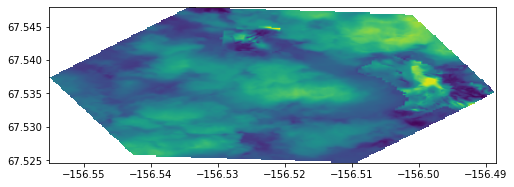

In [ ]:
library.plot_raster(clip_df.first()["tile"]["raster"])

## Merge Rasters [H3]

> Here we show merging per H3 cell. We also write this out to delta for any follow on operations.

In [ ]:
merge_h3_df = None
merge_h3_tbl_name = "band_b02_h3_merge"
if not spark.catalog.tableExists(merge_h3_tbl_name):
  (
    clip_df
      .groupBy("index_id")
        .agg(
          F.count(F.lit(1)).alias("cnt"),
          mos.rst_combineavg_agg("tile").alias("tile")
        )
      .write
        .saveAsTable(merge_h3_tbl_name)
  )
sql(f"""OPTIMIZE {merge_h3_tbl_name} ZORDER BY (index_id)""")
merge_h3_df = spark.table(merge_h3_tbl_name)
print(f"count? {merge_h3_df.count():,}")
merge_h3_df.limit(10).display()

count? 1,314


index_id cnt tile 608199704664080383 2 List(608199704664080383, SUkqAAgAAAASAAABAwABAAAAgwEAAAEBAwABAAAAgwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEA_20210602T061344_20210601-222531.tif, GTiff) 608199306909843455 2 List(608199306909843455, SUkqAAgAAAASAAABAwABAAAAhAEAAAEBAwABAAAAiQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEV_20210602T074801_20210601-222531.tif, GTiff) 608199689078046719 1 List(608199689078046719, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAgQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WDA_20210602T075911_20210601-222531.tif, GTiff) 608216515367403519 1 List(608216515367403519, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WDA_20210602T075911_20210601-222531.tif, GTiff) 608216513454800895 3 List(608216513454800895, SUkqAAgAAAASAAABAwABAAAAfwEAAAEBAwABAAAAgQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WDA_20210602T075911_20210601-222531.tif, GTiff) 608197371288879103 1 List(608197371288879103, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAigAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEU_20210602T074337_20210601-222531.tif, GTiff) 608199287649599487 4 List(608199287649599487, SUkqAAgAAAASAAABAwABAAAAhQEAAAEBAwABAAAAjAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEV_20210602T074801_20210601-222531.tif, GTiff) 608200703495634943 2 List(608200703495634943, SUkqAAgAAAASAAABAwABAAAAkgEAAAEBAwABAAAAigAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03WXQ_20210602T064006_20210601-222531.tif, GTiff) 608199677837311999 1 List(608199677837311999, SUkqAAgAAAASAAABAwABAAAAfwEAAAEBAwABAAAAhgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WEV_20210602T074801_20210601-222531.tif, GTiff) 608200756629078015 2 List(608200756629078015, SUkqAAgAAAASAAABAwABAAAAkQEAAAEBAwABAAAAhQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAbAAAAUgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAbAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03WXQ_20210602T064006_20210601-222531.tif, GTiff)

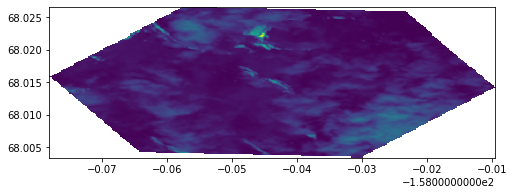

In [ ]:
library.plot_raster(merge_h3_df.first()["tile"]["raster"])

## Merge the Entire Corridor?

> A quick test of the combined size of per H3 rasters in `merge_h3_df` shows the __resulting size would be on the order of 90MB if we attempted to merge further__ - again, this can get unwieldly, so be careful. 

In [ ]:
display(
  merge_h3_df
    .select(mos.rst_memsize("tile").alias("memsize"))
    .groupBy()
      .agg(
        F.sum("memsize").alias("memsum")
      )
    .withColumn("memsum_kb", (col("memsum") / F.lit(1024)))
    .withColumn("memsum_mb", (col("memsum_kb") / F.lit(1024)))
    .selectExpr("format_number(memsum_mb,0) as memsum_mb_display")
)

memsum_mb_display 89

In [ ]:
CORRIDOR_DIR = "/home/mjohns@databricks.com/stac/eo-series/corridor"
CORRIDOR_DIR_FUSE = f"/dbfs{CORRIDOR_DIR}"
os.environ['CORRIDOR_DIR'] = CORRIDOR_DIR
os.environ['CORRIDOR_DIR_FUSE'] = CORRIDOR_DIR_FUSE

dbutils.fs.mkdirs(CORRIDOR_DIR)
print(f"CORRIDOR_DIR: '{CORRIDOR_DIR}', CORRIDOR_DIR_FUSE: '{CORRIDOR_DIR_FUSE}'")

CORRIDOR_DIR: '/home/mjohns@databricks.com/stac/eo-series/corridor', CORRIDOR_DIR_FUSE: '/dbfs/home/mjohns@databricks.com/stac/eo-series/corridor'


### [1] Write In-Memory Rasters

> Following from the UDF examples for Rasterio in Mosaic [docs](https://databrickslabs.github.io/mosaic/api/rasterio-udfs.html#udf-example-for-writing-raster-files-to-disk), we wil show how to write out the rasters in `merge_h3_df`. Again, this is __1,300 files totalling around 90MBs__ as-is which is not too large, and we perform the writes using a Spark UDF. Also, we add the [recommended Spark configs](https://databrickslabs.github.io/mosaic/api/rasterio-udfs.html#intro) (beyond ones already applied at top of notebook).

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
spark.conf.set("spark.sql.execution.arrow.fallback.enabled", "true")

In [ ]:
@udf("string")
def write_tif(raster, file_id, parent_dir):
  from pathlib import Path
  import os
  import shutil
  import tempfile
  
  Path(parent_dir).mkdir(parents=True, exist_ok=True)
  fuse_path = f"{parent_dir}/h3_{file_id}.tif"
  if not os.path.exists(fuse_path):
    with tempfile.NamedTemporaryFile() as tmpfile:
      tmpfile.write(raster)
      shutil.copyfile(tmpfile.name, fuse_path)
  return fuse_path

In [ ]:
corridor_df = (
  merge_h3_df
    .select(
      "tile.raster", 
      col("index_id").alias("file_id"),
      F.lit(f"{CORRIDOR_DIR_FUSE}/band_b02").alias("parent_dir")
    )
    .repartition(128, "file_id")
    .withColumn(
      "tiff_out",
      write_tif("raster", "file_id", "parent_dir")
    )
)

out_cnt = corridor_df.groupBy("tiff_out").count().count() # <- force full execution
print(f"count? {out_cnt:,}")
# corridor_df.limit(1).display()

count? 1,314


In [ ]:
%sh
echo "num files? $(ls -1 $CORRIDOR_DIR_FUSE/band_b02 | wc -l)"
ls -lh $CORRIDOR_DIR_FUSE/band_b02 | head -5
echo "..."
ls -lh $CORRIDOR_DIR_FUSE/band_b02 | tail -5

num files? 1314
total 89M
-rwxrwxrwx 1 root root  54K Dec 29 00:23 h3_608197369476939775.tif
-rwxrwxrwx 1 root root  54K Dec 29 00:24 h3_608197369493716991.tif
-rwxrwxrwx 1 root root  53K Dec 29 00:24 h3_608197369577603071.tif
-rwxrwxrwx 1 root root  55K Dec 29 00:24 h3_608197369678266367.tif
...
-rwxrwxrwx 1 root root  74K Dec 29 00:24 h3_608216532094287871.tif
-rwxrwxrwx 1 root root  76K Dec 29 00:24 h3_608216532111065087.tif
-rwxrwxrwx 1 root root  74K Dec 29 00:24 h3_608216536187928575.tif
-rwxrwxrwx 1 root root  76K Dec 29 00:23 h3_608216536204705791.tif
-rwxrwxrwx 1 root root  72K Dec 29 00:24 h3_608216536221483007.tif


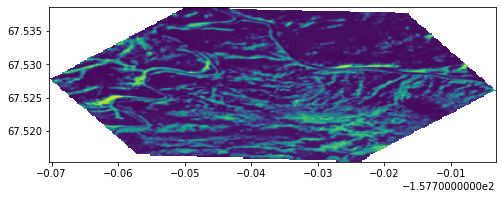

In [ ]:
library.plot_file("/dbfs/home/mjohns@databricks.com/stac/eo-series/corridor/band_b02/h3_608199668408516607.tif")

### [2] Perform Corridor Merge

> We will iterate over the persisted rasters for the corridor per each each H3 cell (from [1]) and generate a single raster. For this example, we follow steps from this [medium](https://medium.com/spatial-data-science/how-to-mosaic-merge-raster-data-in-python-fb18e44f3c8) post.

> [a] Let us first import the libraries and create the output folder with Python path lib.

In [ ]:
from rasterio.plot import show
from rasterio.merge import merge
import rasterio as rio
from pathlib import Path

raster_path = Path(f'{CORRIDOR_DIR_FUSE}/band_b02')
out_dir_fuse = f'{CORRIDOR_DIR_FUSE}/out'
out_dir_local = 'out'
out_path_local = f'{out_dir_local}/mosaic_corridor_b02.tif'

Path(out_dir_fuse).mkdir(parents=True, exist_ok=True)
Path(out_dir_local).mkdir(parents=True, exist_ok=True)

print(f"raster_path: '{raster_path}', out_path_local: '{out_path_local}, out_dir_fuse? '{out_dir_fuse}'")

raster_path: '/dbfs/home/mjohns@databricks.com/stac/eo-series/corridor/band_b02', out_path_local: 'out/mosaic_corridor_b02.tif, out_dir_fuse? '/dbfs/home/mjohns@databricks.com/stac/eo-series/corridor/out'


> [b] Now we iterate over the available .tif files in the data folder. We will merge all files in this data folder and create a mosaic from them. We also create an empty list to hold the files in the data folder.

In [ ]:
raster_to_mosiac = []
raster_files = list(raster_path.iterdir())
num_files = len(raster_files)
print(f"num rasters to merge? {num_files:,}")

num rasters to merge? 1,314


> [c] We then loop through the raster files, open them with rasterio and append them to the raster_to_mosiac list we created above. __Note: This took ~6 minutes running on the driver.__

In [ ]:
for i,p in enumerate(raster_files):
  try:
    if (i > 0) and (i % 10 == 0):
      print(f"...{round((i/num_files) * 100, 2)}%")
    raster_to_mosiac.append(rio.open(p))
  except Exception as e:
    print(f"issue with '{p.name}'", e)
    pass

...0.76%
...1.52%
...2.28%
...3.04%
...3.81%
...4.57%
...5.33%
...6.09%
...6.85%
...7.61%
...8.37%
...9.13%
...9.89%
...10.65%
...11.42%
...12.18%
...12.94%
...13.7%
...14.46%
...15.22%
...15.98%
...16.74%
...17.5%
...18.26%
...19.03%
...19.79%
...20.55%
...21.31%
...22.07%
...22.83%
...23.59%
...24.35%
...25.11%
...25.88%
...26.64%
...27.4%
...28.16%
...28.92%
...29.68%
...30.44%
...31.2%
...31.96%
...32.72%
...33.49%
...34.25%
...35.01%
...35.77%
...36.53%
...37.29%
...38.05%
...38.81%
...39.57%
...40.33%
...41.1%
...41.86%
...42.62%
...43.38%
...44.14%
...44.9%
...45.66%
...46.42%
...47.18%
...47.95%
...48.71%
...49.47%
...50.23%
...50.99%
...51.75%
...52.51%
...53.27%
...54.03%
...54.79%
...55.56%
...56.32%
...57.08%
...57.84%
...58.6%
...59.36%
...60.12%
...60.88%
...61.64%
...62.4%
...63.17%
...63.93%
issue with 'h3_608199615828721663.tif' '/dbfs/home/mjohns@databricks.com/stac/eo-series/corridor/band_b02/h3_608199615828721663.tif' not recognized as a supported file format.
...64

> [d] From this stage on, it is easy. We use the merge() method from rasterio to create the mosaic. We also create the output transformation parameters to use later. __Note: This took ~3 minutes running on the driver.__

In [ ]:
mosaic, output = merge(raster_to_mosiac)

> [e] Now, we copy the raster's metadata and update it to match the height and width of the mosaic.

In [ ]:
output_meta = raster.meta.copy()
output_meta.update(
    {"driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": output,
    }
)
output_meta

Out[52]: {'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 45051,
 'height': 12803,
 'count': 2,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00016701855933559542, 0.0, -161.72663715958407,
        0.0, -0.00016701855933549538, 68.06447716390227)}

> [f] Next, we write the mosaiced file in a local folder. __Note: The total size is 2.2G__

In [ ]:
with rio.open(out_path_local, 'w', **output_meta) as m:
    m.write(mosaic)

In [ ]:
%sh ls -lh out

total 2.2G
-rw-r--r-- 1 root root 2.2G Dec 29 04:50 mosaic_corridor_b02.tif


> [g] let's render the mosaic for the corridor. __Hint: you can right click and 'open in new tab' to be able to zoom in more.__

In [ ]:
# - uncomment to render from local file (note: 2.2 GBs)
# library.plot_file(out_path_local, fig_w=20, fig_h=12)

_This is a 2.2GB file. Here are screenshots of what it looks like when viewed in QGIS, showing 2 levels of zoom._


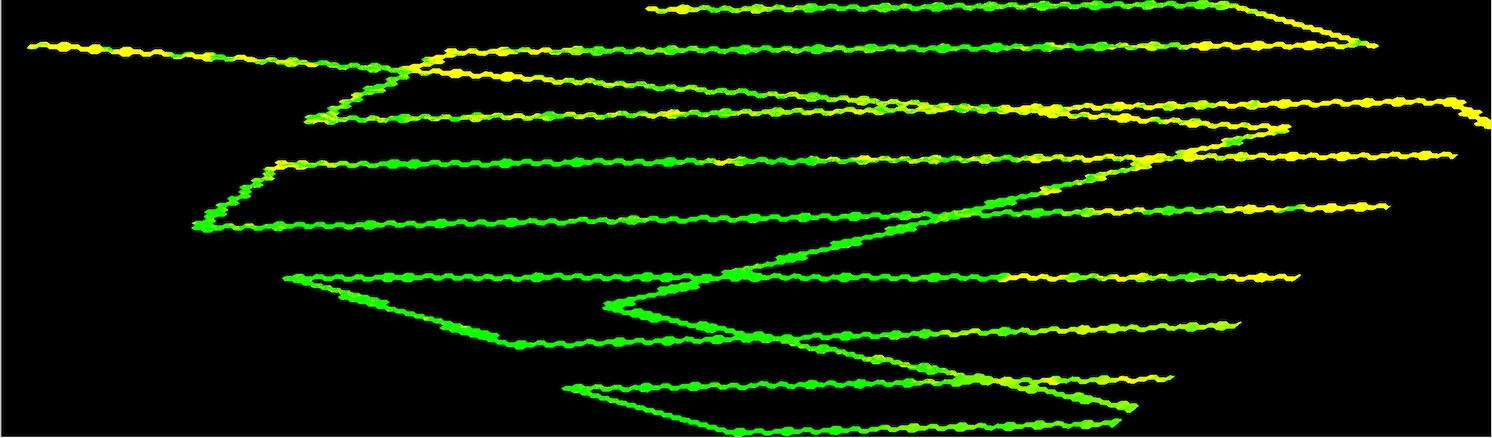

In [ ]:
displayHTML("""<img src="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAC6igAwAEAAAAAQAAA2ykBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAbYF1AMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAEBAQEBAQIBAQIDAgICAwQDAwMDBAYEBAQEBAYHBgYGBgYGBwcHBwcHBwcICAgICAgJCQkJCQsLCwsLCwsLCwv/2wBDAQICAgMDAwUDAwULCAYICwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwv/3QAEAF7/2gAMAwEAAhEDEQA/AP5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDu/ht8M/Hvxg8bab8OPhnpF5ruu6xMLeysLCF7i5uJSM7I40BZjgZ4GAOSQASP1hh/4IEf8FTbgOYfhBrz+WdrYfTTg4Bx/yEPevg39jn9sj46/sMfG3Tvj1+z7qo0vXLDEbCSMTW91bM6tJbXCHBaCbaBIFZHGAysrKpH9Hmgf8Hc37XC6xbN4m+G3gmWye4ja8FoL6CeSAMCyxu0rqshTKo7KyhsEqQMV+PeImaeI2FxdNcH4HD1qHL7zqzanzX25bwSVtveld78vXooRov8AiNr/AIb87/K3U/ll+Kvwg+IXwU+IOq/C34n6XPomvaJcPa31jeqIbi3lQkFJEJyp4yOzDDKWUqx7/wCB/wCyX+0f+0ldz2HwH8Faz4vmthulTR7OS8KDIHzMgKKeR8pbdg5xjkf29+Nf+Czn/BID496zafFb4reHI9T1ye2iWT+2/CrX15bDaQ0YuYLaaJyucbkkaNgMivm7xb/wczfsyfs4aqvw7/Yu+DFkPDNop3vd3DaHbyT+YWMlvZWltK0eTyWmEchzwu2viqHi1x7jcNHD4HhSosZZczqTUKSa+Kzmo3V/hSd33srvwcHmc8Tip4dUZQjFv3pppNJ7q0Wm32vpo9dj+e74Nf8ABEj/AIKY/GL4gaf4FtfhB4j0Rb0NI9/rlo2l6fBFGwDNLcygquM8KqvI/wDAjYOP2F1j/g0l/apGlWDaN8QvCQu0TdqQuIb2KGPIBBilXzjMuM5Yxwgeh7fpb+yR/wAHXPwF+LPj+Twf+1v4Vi+Hul3CoLLW9NubjVba3n+bP2tGtopo0b5QskUcoVj+8Cqd1fpL41/4OD/+CTPhTwrca9oXxVGvT2Me9NP0zTr2W7uCo27Y43hjQ56kF0UAZJABNfkHGXip430cxp4WlkroNJaUqTrxlfa9Rc8VbsnFp6vQ+olgKDanCs2lutFf5NX08nte/S3+fx+05/wSH/b4/ZV8dzeC/iH8PNXu4A+y21fRrOfVdJvM/da3ubaN8h1+cJIkcgHDKD19J/Zi/wCCJf7cn7ScpuYfDbeE9NEzwG98RpLp43IMsVtmj+1sijO6QwpGv99j8tfvy/8AwdhfCuy/tWzsPgjqMiXE4mgkl8RQ7leIkIwAt2CAjB2KzKpyAWHJ/N79rX/g5l/bR+Mvjy31f4EW2lfDjRrJWSG2t7WPUruRWAAM9zcIAWAyNkUSRrk8vnI/XMs4l8YswoxwVTJ6GHq21rzqJwvbpThKpJNvu5LufJZmsyrYaf1Jxp1NLXvKy5mpWdkr8qUldNa2dz5v+M3/AAQK/bj+EPwwm+Jq2Ok+I7eON5Y4NA1B766uI4jh3ht2tYWcAfNt3eZt6KzfKfyX1f4DfF/QvE0Hg7VvDeq2+p3PleVay6fdRzP5xKptieESHcQQuFOT0zX7ifsv/wDBwX+094W8fuv7TNyPF/hu+lEsqWkMNhe20nzZeB0aKNt275opMIcAqVIIb7v1z/g4Z/ZxGgalqK/D7XtZ1lFY2P26/s4YmkZvlM0kUk8oVcklY4mJ6DHWvVw/E3iZlVWWFzHK6eLb1jOjPkjrsnz9ut1HvsfntfiDjbCYr6q8tp1uZK041OSCdle7alLdNpcisna8rXf5AeCP+CGX7e/jf4Sn4o23hq1sTIQYdP1DUI7W/dMqGYwlHRApPIkmRhjlQcA/GX7Sn7B37UX7Ja6fdfHPwpc6LZaqStnflknsZ2U4ZFuYi0QdGBDI7Kw64K81+pcX/Bxp+23aPcnT7bwzbrcPu2jR5JCqgj5N/wBtQsNoCZZQSAM881+knwB/4OM/2etU+GCaf+0z4P1KHxCGt470aPBFd6dqKR4LSGOZ1eDfja0O5wMAiRwcDOtxN4p5ZU+s4vKqOJouXwUZSU0ntZttWXfllfXRJ3XZDM+McG44nGYanVptPmhT5lOMulneSa0s0k7XvzO2v8nvwb/Zw+M/7QHje3+Hfwb8P3fibWLr7ltpaC6cDuWKHZGAMktI6LgHniv0Cuv+CH3/AAUgtrmCBfh1dXKXEaTLcW13Zy2yxuxQO8hnUqmRksEZQuDmv3D/AGgv+Dj/APZ08Eyx+JP2L/hvey+IJFMT3HiScWenJCWB2GxsmJmkUZEbs6KqnOXOVrxTwN/wdP8Ax41P4o6Bd/FzwD4eXwrHLHFq0WimdL5rZ2HmvbtcymESqPmVXAVsFd6bt4xxXGnipjaaxmV5BSo0uV3hWqJ1G12UZQsnsk0nffRo+jqYjP6sZVqEIQWqUWnKT2tJtumo21vFp30tLvF4L/4NiPGMvgq3f4j/ABKsdM8UXWwpZ2emyX9ghlUOiSXBntpPM27icRqMAHb1z8Y/tYf8G9/7aXwUTT9d+CemN8VtIuomFxN4Zt3aezuY2CtHNbSStJtYklJI2fIVt6R8Fv6rdQ/4L9/8Ep9W8LvZXmu68JYSFidPDd6szROokZQ5hYKSfkJLNnGfu4r8mfiV/wAHVFjaeK5tB+Evwst38K25EMLanqstpd3MSpgGSO0tpEjAY5VN7nIywGSo/KuFONfG3F42VVZfKcY3coVqcKMLPZRk/Zyb7JSbX2ro48Es/o45+3qqpTauo8vLq2k4uXTk111co+8lK2v4YfAL/gif/wAFAPjT8R4/AmveAtS8DW64e41HxTA+l2sUZ3ZZfMG+dhtP7uFWb1Kggn7pm/4Nn/2q/EGq6nafD/xZ4Zu1sYhIiXhubKVxtPO3E6hdykbxIy4wecgVxX7SH/Bxd+178S9FtPCvwY+z+AbG3IaSaylOoXshBJAFxdwKsYA4IWAlwTuavlvwL/wXD/4KE+FPFVjr+s+O7vxDa2j5fT9Xjt5rOdcAbJBFDFLtGAV2SKUIBXgbT+vVo+L+Oh9bpSwuGdtKTvN3XVu0ld7JKaST1dzmxS4sxE6eJoclKMVLmpXTctFZc7jJKzWkktU2nHZr5J+IP7AH7Xfw08Z3/gTxR4A12PUNPkEcq2+nXN7FlgCCk9rFLDIpDAhkcg55wcgfYXwR/wCCH/7cXxg+HSfEy90K28LafcymO0XxJdtpFzcKjbWkS3kgkmWPJGHlWLd/AGHNfq/Z/wDBzL4SOmfZr34U6kkkqo0nk69EAsiqMYP2UFgrcjcBnqRmvhn48f8ABxv/AMFBPib4gvofAOr2HhLw1cIsSaRbWUV8uxc8yXN2hmlds/M2I17BB1NU898V8wjHD0sroYaStzVKlXmi7bqMafPJNvVc10krXu0wwuP4rxWErwnhoUayiuSUpKcXLW91GV0tFrd2vtK2vo/wh/4Nxf2i9T8Z2y/G3X9G8PeHvmea6065Or3LhGX5Y4hFAi7lJIkdmVeMo2cV99eLf+DcP9nXTrVNQ0Px1rz2suFElxDpsW1nO0Ng26koCQWbAwPbkfCX7Kf/AAcLfGXQbDU/Cv7WcMvi2wkdbuxuNLjtbC5hmHyNHIGMcckbLgqQwdWBDB1K7Pc/ib/wcLfD+28I3X/CqPBN/JrMoEcX9rXdutogAJBYW0ksjYPRAFByfmWvgc8peMlXMlSU0krJOlyezafW87TTXW/bRWZ+WcT4nxGlingsLRbuo2nCVNRUrb3mneN/i5oxfbo3+avxG/4IXftt+FPGOr6L4SsNK8R6XY3bwWuo2up28KXcIyVmWKV96LgYbJYB8gMwwx+lf2eP+Df34heLND/tf9ojxVF4RlmX91Z6bCuqTKx24M0peKFQPmysfmHodx6V5BpH/Bf39szSdYt9YEXhu4a3kWQR3GimWJivTcjXmGHsa/Pv4tf8FB/2tvjL481H4g+MPG+r/bNSlMjx2V5Np9tGMkhIre0eGGNFJO1QpIzySea/TKGC8UMbTeGxOJw+HSS/eQi5Tb6rll7mu7dl2S7fV0MF4lY3DqNfF4fDyi9403OUklu+Z8mu0koq28bbH60ftAf8G+fxI8GeDf7e+BfiuPxjqUUr79MntlsJp4Qpw9q5cq7FgAqybFcE/OpGD8C+HP8Agjz+334l8R2Xhqz+HuopPe3CW6maazjjUucEuwuXKqOSSFYgDoelbf7LH/BX79qX9mm21TTJ7iHxnY6hDsjt/Ek11ffZZB0lt5DP5sbAcbdxj77A2SfdvHf/AAXz/a78TeFJ/D/hOw0PwtdTfKuo6bDK11CjcOIvPd41Lj5SzI+FJwMnNRh4eKWCnLBp4fERvpVmuV2feMHHSL6JN9mzDD0vE7AVlhFKhiaTa/ez9ySTtdOMbWtrayk9tz6E0r/g3Y+Jsenw23ijx1o9nqqRn7VaxWNxc+VKmQ6iQXEXmBSCNwjXJH3RXwf+1R/wR1/bB/Z8+INr4Y8MeGL7xrpmpWq3lnqWhWzXMLo3G2RVeRoZQesbsSVwwJBIT5yt/wDgoz+2/b+UifFPxQI4ZxcKg1F8bxgdMY6ADBG3HBGOK/XD4Rf8HDXxM8IeBNF8PfELwRpPiPVLFQt5qBvp7BrxlBUSvDDbSRxyMuNxQlclsKoO0Z16PilldWOJhVo42LunTSVO3VSTfJttrJ77dVrHCeJGW1/be3pYyEtOR2pqF7O+kYuVtV8S/wALe3wJ+z5/wR5/bc+PHiKfRZPCkvhOG2UtJd+JD/Z0Xy7SVjVsyyvtJIVEwcHLAjB+9Lf/AINvP2ixJbXN1498IC2dkDqXu0nb94Y3WOKWKLzGVgQQrgerDNeB/tGf8F0P2m/ilPa2fwpjtfAVjbhWf+zCLu6nkG7mW4uoSCuCPkWBTkAlz0q7+zl/wXy/bQ+F3iOCz+MGqj4i+ESiRzaLrMduNoiDbGt54YI3idSeAwaNsncM4IyzT/iLOJoPG4T6vRdv4O8//AmpQcn095R7s6U/EbE4eriKnsKMuR8tOPvS5umslypvq7tbaKz5v168Nf8ABAH9izRNJsbXxT4g8S63qUG/7U0dzDpscyxn76IIJAiscqAHduMknOa+HP2mv+DfHxZF8RrnUP2UPENpqPhG4tknig8SXZstTs5/lV7eR4rWSG4BYlopEEZC5SQblBb6psP+DmD4bW3hLUpdJ+F97pWqwXLT2EdvqNsttIrRFTHOQqsFLEZMcTnao4JJr8z9T/4OCP2zrjxrqOs6fD4ct9HvIUiTSjpAmgjaIsVkDmaOZpTuy771VyAfLXpXwHDOXeMSxVXEVKlrK1q04yjK7T92ME7NdGuVdL20PmMgwPiXSrVnKvB3WqrK8E7acjhJyvf4r+6o35ddF6/+zv8A8G8Hxs8W+MLo/HXxFpnhvRNPxLnT5TqV5dxIAzmBXjhRQPmXMiuWIwIzwx+rfjj/AMG2fw+0rxDfaN8IPipdXlxbIqot5pCPbtKBvO6S3eMhSOPlUlSCfmxgfgp8d/8Agpx+2H8e/Fdn4l8S+MtQsk0w5srXSZ5dLtrfjGUS2kVtx5+aSSRuSAVBxUX7O/8AwUu/a0/Zy+JFv8Q/C/ivUL8ojw3FjqV7dXlldQSKVaKWGWZ12nOQygOh5UjkH77F8MeJ9ZfX4ZxShUUdKMaceRy6JzmpS1tq7btpaJH1VbJuO62DVZ46nTxGjtCF4pJNuK53ZubavKSfLy2jo2d/rH/BH79vbStaudHXwBe3XkuwWazuLOeCRB0ZJDcISCMHlVI7gV+hXgX/AIN2fjHP8PLTxH8VfGGk+HNZvxFJDpgs7u/YRuqly1yr28OULbWVA+G4DHqfNrn/AIOFf2p/7IudP0nwz4YsZ5kKpcJHdSPGxHDBWm2sQecNwcc96/ObxH/wUr/bq8U6pJq+r/FTxKZJHL7Ib028KFsZEcMQWKJSRnbGqrnkgkk13Kh4o5jFQqVcNhOXrFOcp+VnzxS79exz4aPiZjsNOnXlhsLUS0kk53b0el5LRXd39rl0cbo/oh/Zt/4N/fg94D8XjXP2kdZ1PxdauQ+n6XocZ0dbgKr7mmneS4uQoYrxB5ZwpJYg4r6b8X/8EWP2Eb2z1PTJdI1TSZ5Ve1H2bXLq4ltW2D96vmvLDJtOSN4ZGOVIxg1+Gv7Ln/Bdn9pb4LeELvwp8TlXx67PC1rf6pdyQX0SRgAo08UMjyqCoZWYiRclSzLgL1Pxu/4L6fHnxv4Qfw98LtB0zwjeXDN5uoQSyX9wqnGREJ4o4o2PJLskp9AOtfm2Y8G+LOJzZueNfLdLnhVUKdl15I29H+7bb8j89znh3xYxeNjh4Yv3Yy0qKUIU7d3GEVUl6Si0vhtJLnfd6t/wbj/tBReKp9KtPH3hW3sX817e5vxdwMIwA0Znjjjk8p2Vk3KvmKGbClxzX1R8J/8Aghf+yH4O0r+zv2h/HV9qutRqWmXSLu3023RiCVREmWWUjkb3di2BlUHAr8VLr/gsB/wUBuraK3b4lawpggngidRZq6LcBg+1ltAwJ3HnOR/CRxj87dY8ZeIPEGqXGta3N9su7pzJLPcqLiV2bqWkl3ux92Ymv0ilwh4iY+m6Oa53Cilazo0023ru2oNaW2bu79tf0mtwxx1joqGKzmFFRlzJ0qV5PSOkm+RWUuayUVday35Y/wBSH7SH/BvXofiTQtN1z9ijxF9vu1b/AImGm67fx7DbuCVnhu0iCK0b7UeIhwysGDKRhvk/S/8Ag3X/AG1T4mttO8QvoVlp4Alu7uHUf7R+zxZPJht4lZs7WAG9ehJIAzX5z/s5/wDBSL9rf9lnwwfBnwh8UGz0pZ2uIrO5tYL23gkclmMMc6OsQZmLMqYQsc7Qck+2ftDf8Fj/ANtX9onwbpvg7xF4ii0qO1tDa3U2h2q6TPeqdo/0iWBy7AKNgWMwptJVlYHFcuHyDxRwVVYKjmNCrh7tKrUjJ1UnrdxXutrom5a2TbSHg8k46w1N4JY2nNJtRqyvzcje8ouDXOr6R5nF2tzRTVv2cm/4NzfhT4o0FIvA/j7V1ubXyXnubqzsjCyFCHYIgjcKHGSfNfahGck5r9Ifgd/wRQ/4J7fDPT7/AMKax4fPji4ls5PPk1a4Se+Mjr9y3EWyCF4n37zFGB93LNjI/hz8F/tZ/tD/AA/s9O03wn4w1qyttJeJ7SCLU7sQxNB/qysJlMI29gYyuOCCMg/rXp3/AAcFftPW2mW1jqPhXwteyRRojzPDcoZGUYLFVl2qT1wvA7cV8lxd4d+JtenGhhs5dand/DajJbWbaa5r9r6PbufKZ/wl4gQp06NHG/WouXNL3o0LNNuKSjG9tU7SlNXjblaZ+0P7S/8AwQn/AGN/jVort+zjs8Caks0AWaGO4urLyiAT59vJOH5BOySJ1YONr5Ula+B7v/g3W0r4SeKruT9oT4pabpujaMZGvvsVm0cu1VBH765nkhhVgwbzJI2wM4UsOPyF+MH/AAVk/bj+LPi+fxSPHWoeHI5ozELDw+/9m2MaMFBVYkyxyVyWkd2JJ5AJWvmX4u/tbftI/Hqyi0/4y+Nta8UQQ7SkeqXslygKKEB2MdhIUABmUsABgivd4b4A8SMLQp4bEZ8lSa968fa1I3topzir9eunTbX6DK+EuOIYH2FXNownKfNJ2dW0Zc3Ml7S8rr3HD30o+9uuVL+u/SP+CbH/AARk8V3uh+FfCHia1nv9Wj8yMHxkZJWddy+QsccykyHbuwAW9ARkj4i+Nv8AwbSfGjUfiDrevfs+eK/D154PDebaG5vDLPEpwWR3QAOELBFfAZsfMu4bn/l30zXNT0fUINV02TyZ7dg8bp8jKy9CGXDAjsQQQeQQRX6I6f8A8FbP2+bC2hg/4WVrM7QpCpe4NrOZPs4CoZDJbM0uABkuxJ5yckk9cvDvjzKqyq5Fn3tVJNSWJUpJa3TjrLW2nT5309D/AFN4mwFR1suzSVWUkk1VlZLTdXhVXxJOygnZv39Ej9vPgX/wbo/DDwFDe6n+258UdPtQUlFhZ+GbqIvK6ZAZ3lV5CgJwwSOMqwwd+RX1fon/AAQQ/Ys8OeL7bxPY2niLXNNgjW7httQvGS1vIlRCwcKkMmwliT84Vl4BYEV/Gx8Yf2h/i78efGlz4++LOt3Gv6pdMWaa/wBs23JzhEKiOJR0CRIi47V7R+yn+3z+0j+yB44fxr8JPEE1u09n/Z9xb3Obu1ltlACI0UjfKY8ZieNo3jyQrBWZWwzjw68QcTh54pcRXxEo604w9nSv2jKL5l/icW32XTPP+C+KMdhZyp5xKFTe0Fy3393mTSSs/dtTUrqPNJ2P7r/FP7If7LXibw/a+BfFXwl8MWuj2UkLi3svD1tC6sEKodxTcWI4Cs4yCeCcV+YPxm/4IBfsnfFLxy3ir4f+ONU8A2uqu8r2CaKLywgmKqrJbfOsqxiTJZMuAWwgUcV+RvxP/wCDgD9uT4geE77w5pt7pGgz3zRFr/StMa3vU8sgny5prq5CliMlthYHlSrYI/MK4/bC/aZu1Vbvx14ilKu0gL61qBO9yCzf8fPViMkjGTya+T4P8JOP8DzVo5t9WltZP2qd1dtxnHlvfZ6vfbr8lw74a8b5diqmL/thSlslP2lVNc2zi5wilbZpXu3a3X+lbwX/AME8/wDgkr+xV4qu/Cv7U/j/AEnxzrjIkkdlr1y2jwQqWfLfZLeVZiSp2Brh2wQWRF7+3+Jf2Af+CTn7cHgvX/C/7HOmaNofiGHyNmq+HNVn1IabJJnymmtmLK0MmCrqwG4BtpDgEfxk6t4x8Ua3q11rmpahcS3d7K89xM8zvJLLISzO7sSzsSeWYlj3NeifCH9or44/ATxY3jr4OeLNX8M6y9vJZte6Xey2tw1vLgvEzxsC0bEA7WyAwDDDDNfeY7wn4hqL6/S4hrvGpJpuTjRclbelC0eV21VmurTu0/scTwFxHXjzf6w1YTupaQh7O6bdlB6qOrVufa3NzWs/6BbX/g3X8T3JkE/xJ0mBUQybjpV1gqGA3KTdDK85DHAwOcV90/BP/glr/wAEq7DTYfAusa8fFutWSSPqVwniI2ssL28pEha2s5FVUJaNPuApn7zNlh/Lf4k/4KB/toeL/DF54M8UfE7xPqGlX8P2e4tbjU5mili/usAQdv8AsggdiMZFfJMWqXMUrSqsRLdQ0SMPyKkD8q0reH3G2Z0ZU814hdNp3j7GCj0+1KPs5P0279jCnwRxjiIp5hn7Uo7ezpRirt/aaacla6tpa/MmpJNf6Kv7OH7B3/BPL9nea4174f8Ag3ytXvsouoawz61NFDLMXZbaSRt0eIztUgRsRySWJNM+Ov7F37GfxWtdZ8O6l4F0poNQlc/bksoba7BZMCeOZVE8c28swYuSAcY7V/Fr8Ev+Cqv7bX7P/wAP7X4ZfDrxlJDo9jH5NvDd20N6YYRjbEjzKziJcDYmSEHC4GAPIPj5+3L+05+0pewXXxX8WXt9HbYMNtC/2S1jYDG5IINibiOrMGb0IHFfm9HwG4vnm8sXiM5dr6VOepKdl8Puu1vT2jS1tc/Osf4Rca5ljlUxmZUotP8AjwU1Vai3yrlTjHW92k1ZpJOVtf6Ob/8A4ILfsqaVZ3Ws+IPiFrGn6faQSXM09wmnRRrHGMkNIbcKnGfnb5Rj6Cn+FPFP/BAb4eacvhG6k8NamNPaVZLu/sbrVriZhuJJnMbNLlsBdrbcEbRtGK/kvuvGPia+t2tL29nnif7ySyvIh+quSpx244PI5rCe8u5WLySuxbkksSTX6kvCnN8ZBwznP680vh9ly0betubm8r7a9z7mn4T5ti4KOd59XqcrulTtRXT4kua/XqrJ6a6n9pfx3/4IrfsZ/tY6b4a+KH7MnirTPCdre2i3dyNEhSawvIpFHlfZ1eRUMwHDeXtyfldNwyPFV/4IZfsLfsxeIYfGP7X3xlurXw7m1aOCa1j0cu7u25XuRJOXGzbtFuqktuy2FOP5j/An7T/x/wDhlbW1p4A8Ya3oyWcvnwCx1K6t1jlJ3bxHHKse4nkkodx5bOTWF8U/jz8YfjZ4lHjL4r+JdS8RasF2C91K6kuZwvPyq7klF5PyptB7gnmvNwXhrxtRawD4jmsGrq6hF1rN3S55Jtaac17rRJWPRyzgjiXCReDWbt4ZOyTi5TUE9P3jl7Tmel5c9k78sFG0Y/2g6V/wTK/4I3/ETxnHYfDPUtG1q5nxNHoOieJLl5riJWUN+4844KpjzR6DPBOK/Vv4Xfsi/DP4d+DtG8OfDDwzoGk2bWzyWlsLZUj2tl3ZVeNg0nUZXzt2ctlmzX+aL8OPif44+E3jjTPiN8PdRm0nWtHnS4s7y1IjmhkQ5DIwHB7EEEEEqwKkg/f11/wWH/4KGXGiSaBH8Uddgt5EljAga1hKrKMMFaK1R144+VhgdMV8TxZ4D8W4106OGzyVekt/byndPVaJcyeluz3W1rfM554PZnja9NTzGdWklop1Ki5Zcy96N3U15bq+jVlveR/Yb+3v/wAEwv2V/wBqLxva+KvjzcLoGv6L5NnJLpV/b20l5Ds+VJPkAby/mfPlJsztUnJB/O/xV+xF/wAESP2GfE1p8Qvjlq11qv2m1M1l4fu9SGtvcSRlxuFrbQZkQkhczxlF2lhg4I/j78TfEPxd4z1u48SeK7x9Tv7tg01ze/6XO5ACjdLP5kjYAAG5jgdK5e41K7ulMblVU4ysaLGpxnGQoAJGepr6nIvBLPMJhKWX4jiOt9XjGzhSTp6PdRk5zsr+T00Vj6/BeHeOot0Xm1b6vLVwvdttuT99621aaioqXVH9y3wq+K3/AARw/a315/gr4V0/wsuo6qXaHTLvw6bO5uZLYbwIjLbxEPtcsgWRWkAYc7cD5X8ff8G5nwj8QeMb6/8AAvxIv9I0x1VooLixgvVRyC74ukkjDRIpAEjrvOPmJYnH8iNlqV9psy3FlK0bIQQVJGCDkEY6EEAgjkEAjkV71d/tYftFX1pPY3XjXX5IrqN4ZVbWL9ldHGGVgbghgRwQQQe4rqj4Q59lOIc+GM9qU6cl70asY1dV1V0ltp8N/wC9bby4eGWbZZVi8gzapTpvSSqfvdLt+6pNRj8V1aKd7uTldn9OvgH9iT/giz+zvJN8Nfj3450HxP4k0+QR6i+rawttJFKF+ZI4IHSOLqCQ25sj5mJFfpx+yJ+xn/wTS0iax+Pf7NfhPw5rkXmNDb6tbzNqMccsW5W8l5ZJFjkGTkrhhxnIxX+fANd1lPlhupIlySEjYogzzwq4A/AV7b8Kv2rP2jPghZ3en/CXxtrXh2G/dZblNPvZIFmdBtVnAOCwXgNjOMDJAAHLxL4LZ7j8LNUuIK8qs/iU5SVKS+0uSFuVdkrpbWe6yzfwqzTEQlKlnFaU5O7VST9m07XXJG0UtNrNdLa3P9OnV9e8JW+h3E1xbWtjaQxgSXN2VdIbRF2uD53ylCv3lICkA5Br8b3/AOCSX/BHv436Xdar4XuprddTvcQyeHfEyvEreYC6W8LSTQhByojVflyAu3jH8X/xO/bJ/ae+M/hSHwT8VfHWt+ItLhkaVbXUbx54S7FTlkPyuQVG3zA+z+DaSa8B0jxLq+hXkGoaS6wXFtIssUqIqyo6nIZZAA6sDyrKwKnkEHmvl+G/o6Z3lVGpPC59PD1pNX9kpcrUb25nzxcvRqyu973NeHPDXN8thKrHMeSo/swj+7e9m43im9tbbK2qsf6Yf7M//BPH/gmz8EPDf/CuvCnwj/4SFiQ11fa/bWOrXsyr8qyyTzBnCrk4SJVAGQFHFYP7W3/BGL9kX9rjwZHoGleGrHwTqi3gmstS0GwtrKVYtv7yIp5e2RSAMh1YA4YAMAR/GHoP/Bdn/gpT4d0eDRdO8fIIoI0jDyaXZvMwQAZeTywzMQPmbjceTzXw/wDGr9tb9qT9oXxJD4q+MPjvW9evLbeLdrm9lWOASBd6wwxGOGFWKgkRouT1zXz2WeAPH6zb+0a2eqlNO/Op1asm/OM+SNns1e1tLNHrZTwpndWSlnWITlF3UoNqV9rfCrrlvu2r6Ws2j+s34mf8GrfgXxF8MdUl/Zt+JD614utYmkt7HUBapaySIFJieaC2jaMsdyh8kK20sjLuFfhD8Xf+CCP/AAVA+CmgnxD4x+GdxPAltLcOul39lqMyCFQxBiimEhzkgeWshLDABJGfJv2EP+Cs37W37Aet69ffCbW1vLLxLbiHUNP1mOTU7KYrgJIYXnjKyoMhXSRflJVw427f6Av2Rf8Ag7A8fn4p6FoH7W/gPQ5PCbRC1vNV8PxXCapDMVAW5EMskqSR7gBLBGQ4VtyFimx/qsTS8ZuGJ13g5Uc0w0feTmuSq0o6xjGMoq99l77eltXyn6Rg8E6OG9nKt771cmm0raWUE29tfj1fRI/jMexmRsBo2GAcq6ngjPr7855HQ4NVnjeJtkgII7Gv9Dq2/wCCpH/BDX4+fElB8RNC8L6fP4kvrczanrPgp4Ql1OyoJbu/lttsahtivLI2wLkuwXONP4v/APBr3+yL8TPidqnj7wrq2seFbDXpUul0vRl046ZYvKAZRbi5glkSEt86RK2xSxCBU2qPQj9JbBZdVjR4tyqvl7lG8XOLkpNW5knyxbtford7XScYXF1MQ3OlQqez2UuV3vrvFXkk9LNrve1tf86+iv6pP2vv+DWb9tbwP8X10z9km3t/iF4PvIPOh1G5vbTS7i3cEAw3EUhRS3dXhGxl6hWHzfhL+1l+wL+1b+xFrWmaB+014Mv/AAjcavA09p9uMDQ3AjfZIIZoJZoZCjEblDhwrK2wKQa/XeF/FDhXiFUo5TmVKpUqK6pqcVU63vTbU01Z3TirbnpewrKHPOm4rzX67fcz41oqw9rNGpcgEDrtIbH1x0qvX3qd9jMKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/AAamlh/wT38bY/6KPqX/AKbdLr+mvLV/Mp/wamkj/gnv424/5qPqX/pt0uv6bMt6UAf/0P5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHI7xsHjJUjoRwame7upEMckrsp7FiRVeilZAFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAlhmkgkEsRwwz+R4I9wRwR3rv9L+LHxC0V7RtM1i+gFg8L24ju7iMRm3ZWj2bZBt2FVKlcFSARggV53RWVWhTqK1SKfqFz+lj4K/8AB0Z/wUO+Efhuw8P6p/wjvi77NEYp7jW9Oma8uDtwsklxDdoGkUgE4hRW5yATmv3z+Af/AAcaf8E8v2p/2cLLSP2/vD62Ov8AmtDq2ipoNxr2j3LxAFJ4CIpgqPkN5Uv7yNgVJYBXb/O0or8N4n+jhwRnCU6eE+rVlLm9pQapz66bONtf5bqys0dGFxM6EI0ofAlble33bevfqf6ZNn+zD/wRL/4La/ALWPB37Nel6X4c1DwjqEDPqGgaPFoWu6XK6goZIJ4FMtpdRbk2yxvBLtbbiWIFPhT49/8ABpT8JY/g5rM/7PHxB1bUPGkEHm6da6zDYQ2FzKhyYXltraOWIuuQkmWVWwXVlyK/hB0TxTr/AIdl+0aLdzWsmwx74ZHibYSGK7kKnbkA4zjPPWv0p/YH/wCCun7YH/BPfxFrer/BvXxPa+IY1W+sNYjk1OylkjAEcvkvPGVlQDasiSKdpKsHG3Z8DiPBLjrh6nUlwbxJOVKMlOnQxEVO705oyq6uzs3aNNLW2jbmejDHYWpZVqKWlrx0t6L+v0PU/ij/AMECf+Co3wj0uTVPFPwvvLlEtGusaVe2OosdgJaPZHciVpABkJGkhbPy5PFfjlLp1xE5QlCB33gA/mR68g8jvg1/aZ+yT/wdm/ETXPjBoPhn9sPwToK+ELjbb32raBBdLqFtMQAl0LZ5JlkQMMSQxneFbcjNs2t+s3wt/wCCiP8Awb8/tAfGWw8OWvhfw1D4k8XXpja91zwWbSGa9uXLAz3dzarErzStgPIwLyOATlq1n4weI3DjqU+K+GnXtHnjPCczgkr83P8AxLbX1aaW6s1bFYKlVqWo1VZvZ3TS/V/d8z/NBkjeJtkgKkdj70yv9J343/8ABrT+wV8VvitrfxF8F+INc8D2OtXBul0HSYtPl0+zlkAMi2q3NtLJFCz5dYQ5SMsVjCptVfwX/bp/4Nbf2v8A4a/FWd/2N7P/AIWL4JkszdJczXdlY6lDIgAa3kt3MEckhOTG0O1HXAYIwJf6zhb6TvAedVYYd4z2E5R5v3y9nFPS8XOXucyv0k720uVXyXFU1zct15an8pVFfYf7Wf7B/wC1F+xHr2k+Hf2lfB+o+EbjXLd7mw/tEQqlykThJPKkhmmiZoyy70371DqSoVgT8iSWs8SeawBUEAlSGAJ6A46Zwa/dsuzTB4/DwxeBrRq0pfDKElKL1to1dPVNaPc8ycJQfLJWZXoooruJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/0Gv+DU0sP+Ce/jbH/RR9S/8ATbpdf015av5lP+DU0kf8E9/G3H/NR9S/9Nul1/TZlvSgD//R/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiv2D/4JS/8Ee/j3/wU/wDGepf8Ig8Xh3wdoCMNT8RahBJNaJdMgaK0hjjkie4uWDK7qjqsMeGkbLxo/icRcR5bkWX1c0zauqVCmryk/uSSWrbeiSTbdkk2zSlTlUkoQV2z8fKs/Yrzbu8p8eu01/bx4L/4NefgB8BtUk+Lv7Xfxt0tvBOgBbi9isIG0beySLhJ726upxBE2NrFFSU5wsiHk/oD4b/4Jv8A/Bvz4qitvDWjab8NtWn1FmtFjtvGEqXvmS4RVTF+W8zJOMDcGxjNfhOafSh4TotSy6jiMXT6zpUmoxe9m6jp6210uvMwqVFCusPvK1/d96yvZXUbv7l0P832pIoZZm2wqXPXCjNf3R/E/wD4NBrXUvHmpX/wk+K9rZeHJpA1jb61pU13fxRkDKzTW91bxSMGyA6wpuGCwLZJ+9P2LP8Ag10/Yj+CWgXN3+1QW+K+uXamMRHztN0q1VXJVoYYpTO8pXAZ5p5AOQioDWeafSw8PsLgVi6GJnWm7fu4U5KevnNRhp19/wBLnt08ixcpWcbLu3/TP82mWGaEgTIyE/3hioq/03f2q/8Ag2T/AOCdPxj+HtxpfwC0ab4XeJI0za3tlc3N7ZSyKH2rdWlxMyuhL8vE0cwAG1xivxt8V/8ABn/8XrXwzf3PhH4r+HL7VY4Ha0t5tKvbSOWYD5Uab7XP5QY8b/Jk29dp6VXD/wBK7w/zKiqmIxM8NO9uWrTlf1vT54W9Zetgq5Fi4Oyjf0f+Z/FpRX6eeJf+CNP/AAU98Ma/eeHb/wCBnjN57KTypDbaabuEuACdk8DPFKvOA6MVPscgfrp+xx/watftefHP4bL8Q/jvq+nfC975IpLHS9WtZr7UijbizXENvcQra8bNsbySScnesZG2v03PfF3g3KMIsbjc1o+zdrcs1UbvtaMOaTXW6TSWr0OOlgMRUlyxg7/d+Z/KfRX9Ov7fv/Bsr+1f+yf8M4Pin8I762+KFjbsw1ODRLSW1vLNAMrJ9nuLiYzxk8M0Th0OP3bqSyfiB4z/AGEv2v8A4eeGrvxj43+G/iLSdJsY/NuLy70+SO3hj4+aSTBVVGeWOFHUkDJHbw14lcL5/ho4vKswpzhJ8q97llfs4StJPsmldNNaNM83HYmhg66w2KqRhUdrRckm7uysr63ei89D5JoroI/CfimUBodNunDY2lYXIOemCBzmvq74O/8ABPT9tX9oHwYnxE+Cfwv8T+LNCkmkgTUNI02W7tGliOHVZlGxyp4bYWAPBOQQPqMdm+BwVP22Mrwpwva8pKKu+l20rnTCEpaRVz4xor6G+NP7KH7R/wCztr0Hhf43eCNd8KaldIZYLTVtPmtJpYwAS8YdQJEG4BmjLBTw2CQD4fe6Drmmw/aNRsp7ePON0kbKM+mSBW2Fx+GxNONbDVYzhLZxaafo1v8AIUoSTs0ZNFFbFp4e1+/gF1Y2NxPE2cPHEzKce4BFdMpKKvJ2JMeirN3Z3lhObW+ieCVcZSRSrDPsearU001dAFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqe2tZ7uTyrddx6nsAPUk8ADuTwKG7asCCiuh/4RnUv+elp/4Fwf/HKwZI3ibZIMHg/geR+dTGpGXwu4WGUVp2ekX18okiCIhzh5ZFiViuMgM5UEjIyByM0680a9skMkpidRyfKmjlwOmTsZsDJAye9L2kb2vqDMqiirrafdxnbMojPo7BT+RIqm0twKVFfUPwL/AGLv2p/2mLO61D4AeANf8aQWJ23Mmh6fLfRQsQpCySxgxq5DA+WX345245q78bf2Hf2tv2cNHste+Ovw68ReELTUrg2lrLrGnyWiTXAUv5SF+C5VWZV6sFO3ODXkPiDK1ivqLxVP2/8AJzx59r/De+2u22pThJLma0PlGitY6DrSAvNayxqCAXkUoi5OBlmwBz6mvofRP2M/2ovEdlYanovgDxJdWuqRefaTQaNfTxzx5IJQxQPkDBzwPUZBBrrxWY4XDJSxFWMU9rtL+tDmniqMZRhKaTk7JX3fZdz5iorvPFvww+IHgbxBeeF/FOjX1jf6e225t7i2lglhJAbEkciJJGdpBw6qcEHoQTD4Q+HXjXx5rVt4c8J6Zc399eMyW9vbwyTzzMi7mEcUatJIVUZYIrbRycDmtfrdH2ftudclr3urWte/3G11a/Q4mivoXxh+yr+0H4A8O3Hi3xl4P1zStNtFjaa6vdJvrWBBKwVC0s9vHGoZiACzAEnAya8Eexvo2ZJIXUrkEFSMY9anC47D4mLnQqKS2unfUmFSM1eLuVaK7HSvAHjHXIGuNJ065uVRijGGGSbaw6q3lq21h/dOD3xgivrH9l//AIJ1/tbfteeL5vB3wX8H3t7LbIz3Fzdr/Z9jBtCkCW6uvLiRm3DYgLO3Xbtyw5swzrAYGjPE43EQp04K8pSkopLzbaSHOcYR5puy7vRfefDtFfsN8VP+CFP/AAUg+EHgjWfiB4q8DRSaboUDXN01hqdpey+SgyzpDE5kkCjkhFLYBIB6V+SP9h3pON9v/wCBEX/xdcuS8T5Rm9OVXK8XTrRi7NwnGST3s+Vu2hhSxuHquSp1E2tHZp2Meiv0F+Gf/BL79tr4teBLX4j+Cvh/q13pF6GaG4KwW6uqlQSFuZ4ZMZYANs2nPykjmvEP2jP2Rvj/APsqaxp+ifHXwze+G5tVga4s/toiCzpGwV/LeKSWNihK713b1DKSoBBow3FGT4jFPA4fGU5VrtcinFyut1yp3066adTjoZ7ltev9Wo4mEqn8qknLS99L30s/uZ800V1nhHwP4s8e+ILbwp4MsJ9V1O8bZb2lmjXFxM2CdscUYZ3OAeFU4HJwOa+ph/wTt/beZ5oo/hV4qkeBJJHVNMldgsQyxCqCTj0AJPbJrrxmcYDCSUMViIQb1SlKMbr5tHRiMywmHnGnXrRjKWyckm/S+/yPi2it258M+ILW4e2lsp90bFGxG3DKcEHgEEHgggEHg4Nes/CH9mX49/Hu+uNN+DnhHV/E9xaECePTLSS5MJY4AkKDahyPuswY9hjmujEY7DUKTrV6sYwW7bSS9W9Eb1cRSpJyqTSW2rtqeE0V7D4z+AXxh+H2mxav4y8OapplvcS+RFJeWNzapJLz8iNNFGrtwflQlsAnGATXlh0zURK0DQSB1yWBUgqAMkn0wOTntVUMXRrR56U1Jd07hRxFKrFTpSTT6oo0V7Fe/AH4w6f4Rh8d3fhvVE0e4EZivvsFz9lkEpwhSfyvJYMfulXIbtmvt/8AZp/4JI/tgftLeGpPGXh/QE0fSi6RwXOuTtpi3DOM5iV4pJGQDrIY1jzwrNzjysy4nynL8O8VjMVCFNO13JJX7evlueXmPEeWYCi8Ri8RGEL2u2lr29fL5n5fUV+tv7Wf/BGb9sj9k/4aW/xi8QaPba/4YaRobnUvD1y+qw2kgXK+ftt4mjRiGUSBXjDjazKSM/mlpHws+IWveIbTwlo2j3tzql/J5VtZxW0r3M79dscKoZJD7IrEd8Usn4oynNcM8Zl+KhUpq6bjJNJrdPs12fTXqdtDMcLWorEUqicGrppqzXdPZrTc8/or9e/Cn/BDf/gov4utLe7s/BMNqZ/+WN7qtlbTx84AkjaUlGJ42ElgeCAQQPz3+OX7OnxW/Z1+JWpfCf4saemk61pcmyWGS4iIYdnjcPtljb+GRCVPI4YMoyyzi/I8xrywuAx1KrUiruMJxk0r2vZNu1+py4HiDLMZLkwmKpzeukZxe2+z6X1Z4ZRXv/wO/Zh+N37RvimTwf8ABnw9d+I72CPzZk08JMIkOcNI5dYowSMDe6knoDzXvXxb/wCCZ37ZnwR8EX3xD+IvgXUtN0jTkWW5uXNtIkSMcBnEFxK6ryMsV2qDlio5rpxPEmU4fExwVfF041pWtBzipO+1ot3d+mmoV8/yyhXWGrYqEajsuVzipXltpe+vTufA1FWPs0mcZT0++v8AjX0f4E/Y6/af+J3h2Lxb8PfAeva3pkxKx3dlYSywOV67ZMBX+qkr79a78Xj8NhYKpiasYR2vJpK/qzrxmY4XCQVTFVYwjteTSV/VnzRRX6rfAH/gjz+2b8bbu4/tXw83g2ytg2+78RbrNSVGcJEoeaTI7hVUf3iflr6A+Of/AAQD/bO+DXgHUPG9g2l+Kn06OOZ9P0YzzXssb5z5KMm2WRQC3lKd7AEJlsA/I4nxL4WoYuOBq5jSVVtJLmTV35rRb9Xp1PmJeIfDkcT9UWOg53itHzJOWycleKvZ7tbXeh+FNFfRJ/ZP/aIDbf8AhDddPGRjSL/kev8Ax7/j9K/Qb4ef8ERP20/G3gyx8Xahpen6G18nmraarqH2W7jQ/d8yJYJghI52l9w6MFPA9TM+Msky+EamMxlOCbsryWvpqdeaca5Fl1NVMZjacE3ZXkl+p+OFFfaX7UX7Bf7RH7J/iG10f4laK3kah/x53li5vbW4wgdgsiIpDLkhkkRG4yu5fmry34S/sufHr44+LY/BHwv8K6nrGpSAMIYLaQBQc4LySBI41+U/NI6j0yeK7aHEGW1sGswp4mDoNX5+Zcturve2nXXTqd+G4iyzEYNZhRxMHQavz8y5bdbu9lZ6Ps9GfP8ARX656h/wQ/8A+Cjenu9ufALT3CpK6W0F9byXMghBLCOHcHdgFOFAySMda/K3V/C2s6Fd3Fhq0a289q7RyxSOqSo6HDK0bEOrAggqyhgQQQCCKzynibKM05lluLp1eW1+ScZWve17N2vZ29H2KyzP8tzFTeAxMKnK7PlkpWe9nZu2jX3nPUV9ifAH9gz9qn9prR7nxD8GfBep69p9r8rXVqkawFskbUlmkhjkYbTlYmcr/EBxX038Hf8Agjh+2l8TPHD+Gte8NSeFrC2dBcalrDxx2wVgrHyxC8rTttJ+WP5cjDSIa5cw40yHAyqwxWOpRlT+KLnHmXrG979la76HDmfGWR5cp/XcbTg4ptpzV9LX0vdvVaJX1Xc/KCiv6WPGX/Buj8VLPSmg8EePtC1DWDsZLa6tbnT4iCckG4aWdVJQgg+Ww5wSK/H7xf8A8E6/21/A17d2niX4Y+JbdbOeW3kmj0y4uoS8Od2yS2SUOnykrIvyMoyDgivMyPxL4Zzfm+o4+Da6N8j17Kai2vNKxzZHx3kOb831DFxk4uzT9137WlZt97LR6PU+KKK/bP4Hf8EGf25vjD8Oz8Q9R02x8JpMSlnYa/cNaajdvhcBbZY5JIQSSN04RxjmPAyfFP2s/wDgkX+1/wDsheDk8dfEPQo7jTUufst1Lpk7X32SR9vlecohjZElLBUdd6biFYqWXN4bxH4YxGN/s6hmNKVa/Lyqau32Wur6addN9DshxZlEsWsFHExdRu1r6NtNpJ7N2Tdk76M/Leivbfhx+zp8afiv4ss/BPgLw1qWp6jfEiKGG1kyQuCzFnCIqqDlmdlVRySK/RR/+CF3/BSNLGTUZPAJSGNWZna9hCrs65Y4UY75IA7kV6eacX5Hls408wx1KlKWqU5xi2vJNo3x/EuU4Gap4zF06crc1pTjF276taeex+P1Ff0zfDH/AIN3PFOq+EE1X4qeP7fR9WKJJNp2m2TXzWysCSZZZTCDtyoLKgQEjBYHdXmv7Sv/AAb6ftC/DnwvF4w+A9zdeO7WJCb23awNhdQ5YbHj3t5EkZBJfdJGUAyN4JA+RoeM/B1XFrBxzCKk3a7Uoxv/AI3FQt2fNZ9G7o+Qw3i7wnXxv1GljU53avaXJpe/7zl5LaPXms+jZ/PHRX6xfD7/AIItft/eP9ZXTbfwNc6dboyi4vdRubS3tbdX4VpWSeaQAtwNsTZPpgkfpPpH/Btn4/1LTo9RuPiT4fs4n3J5l1bSQoZI+GUE3u4kHplACBkV15t4ucH5dJQxOZU7v+V8/wB/JzWfZO11sejjfEnhvDTpwljIy505LkUqi5U+VtuCkkubS7trofy7UV+i/wAWf+CVP7dHwo+I2o/Di7+Hmr6xPp7f8fWjQf2haTJkgPFLCWBU4yQcMmcMAcZ9p+Af/BFT9sn4z6TNrevaZB4Jtk4Q+IGeGaRgSCBBEskijjhpNmf4Qw5r2MRx9w5QwqxlTMKXs2k01OLvfayTbfyR247jrh/B4f6ziMdTjD/Em/TlTbv3Vrn4/wBFftR8b/8Aght+1r8IPh3d/EXTJtL8VwWCs9xbaM1xJdoi4y6wvEDKACSyod4Ayqt0r857P9kX9pHULuGxsvBGvyzXDhIkXSL0F2Y4ABaBV5PckD1IrbKuNcizKi6+CxkJwTs3e1n5p2a+ZWV8b5DmNF4jB4yEoJ2bva3qnZr5nzfRX7QeGv8Aghl+2rrvh231e6sNKsLq4jLiyutTC3SnkhWSKCZA2MZAkYDuRzX2T+yD/wAECtR17R5vE37XWvzeHJpLfNro+iC3vbrzWAJM9zMHto1QZykcczMcbZBzXz+Z+LnCeBoTrzx8JcrtaD55N+Sjdtd3st20jxcR4s8I0YylLMqbs7aSUnfXZRu3t0W7S3aP5lqK/pJ+Ov8Awb/+JfC/gPUvEnwV8YHxNq9szSw6Vc2sVmZosnKxz+bs8xRjAcKj4IymQR+eulf8Ef8A9vXU7+1tJPAN7ZJcvt86+uLO3hVRjczMLh2AA9EY9OOa6Mr8UuFcfRdejmFOKTs1N+ze19p8ra80reejDKPFfhPMcPPEUMxpqMd+d+za87T5Xbzta+l7n5gUV/Sh4d/4N4fiNe6Paya94+0WzvnhV54hZXMsSORlgJjPFvA6bvLTPoK/P/8Aaa/4JH/tbfAr4j/8In4V8L6j4z02eET2+paLZSSwOvAKuhLNE4J+4zNuGGViCQqyvxU4VzDEvCYXHwc0m9bxWm9nJJP5PbXYeVeK3CmY4h4bC46PNq/eUoLTe0pJRfondrVaH5X0V+oHwH/4JFftp/GzXJNNu/Cs3hK0gIEt94iBsYF+6cKmHmlYgnASPbkcup4r7a0b/g3n/aBe/tpPEPjbwzb2DSFLiSAXNxLGoB6RERbj0wC6A+vrrmXifwrgKjpYnMKakleyfN/6Snr5bmmZeKXCmAqSpYnMafMld8r5tP8At1PXy3P55aK/s30P/ggP+xzBpVvZ6lr/AIm1TUNwjeSK5itldjglgot9iLk7QucgDcSQc1+dvxz/AOCB3xch+KFzZfs86lYan4cnKm1OrX32W8iLcGOXZbvG+09JQVDAjIBBY/N5V46cJY6vKisQ6dk3epHli7dm/wBbHzWWeO/CONruh9YdPtKatF67KV2r9bOzt9x/O1RX9E/7Mv8Awb//AB08XeIi37QV5H4ftIpniS10gpq17clNwBQoGgjQjDKzCUsv8C9a+hvFn/BtV421yy1j/hTXii9v9WgjkmstO1PT4rNZCvIjefzECZ6BxHgHBK4yK6cZ428GYXEvDVcwjpb3kpOGv99Jx9Xey6vc9l+LnDLx6y+jiHUm2op06dSpFyfRShGUXpZtp2S3Z/KlRX6t+JP+CK3/AAUe8KGM6/8ACzXLNJm2xtObJFY5xwfthBHqQSAOelfdfhD/AIN5viXe+GrC/wDGPjnR9N1C4iElxaxWdzeC3Zif3ZmEtusjKMZZE2ZOFZsZr1sf4q8JYOnGrUzKnKMtFyS9p+EOZr1eh7OfeIXDuTPlzHGwhLT3b80terhG8kvO1vM/m5or+wf9mf8A4IJ/APwD4hn8SftJ+ILzxdZRNthsNGD6Qm0rjzJJmlklzkkKiyIpxkhsV+gvxA/4IP8A/BMD4qfAPxBpvwcv9T8GeMpoP+JXe69rz3NtFdKSyrNAzlGifG1iv7xVO5CHFfA5p9JLhLBYqNBKrUg3FOpGn7iu93dqdo7u0H5X2PGybxc4WzTFywmFxiuk3eV4ppb25kr9tD/Pzor+o5/+DVX9te40631Lw/418A6tHI6CT7Jqd022Ngdzg/ZCGCHkr8pYcAg19yXP/Bsd8GPht8D7fVfiZ4u1W98Qvdskt7p0lrDaxxqMlRaTRStncCo8yWR8HJAI+X08f9IbgTD8kYZgqkpPltBNteb0Vl+L6J2Z9TnfE+EyzCSx1WM5UormcoQlJKKt7zaVktfmtVc/iNor+iz9rT/ggt8UvC2oaVqX7KF0fF1jdqUvLbUJreyvLSRQTuOEjhkifgAqA6tkHcCGXyv4Gf8ABBX9rDxr4qFp8ZGsPBejx7TJdNOmozuDnIiggYAsPWSRFHo3SvpKHi5wlVwX1/8AtCEY2vyt2nppb2fx39I6rVXR85Q8WOFKmDWN/tCmo2vyuXv9vg+O/ly367H4T1KkE8gzGjMPUDNf1reGv+Da3wlq+pxPN8Ur9LBJF86X+w422gn5RxOeWA46gZyQQMH9B/CH/BGT/gn/AOANCt7C68AzeLfscg8zUdYvJ1u5/kGFkgieNEyMMFiQKowRgNXx2afSM4QwySw06laXVQg1b1dT2a17Jt+R4WZeOPDeGoQxFN1KsZNr3IO6S3laXK3Fd0mrpptNM/gfdHjbbICp9DxTa/s2/ab/AOCCfwZ+OHj7SvEX7MkX/Ct9MktWF9pjR3Wt2+UyVngJuY5kEnIdHZk3KGQgsyngPgF/wbkeCfDfxN1K5/aY8ayT6LBLGNFsdOtX0mXVDtR8TXV87paLuWRdsXmyso3rKnKjqpfSE4OlgvrVSvKNTl5nTcG5rW1vdvC/pOyWraSbX0OU+KPDeY0VWw2Ju3oouFRScrX5YxcU5N7JJO70V20j+Qiiv75/+Ie3/glBro1fR/8AhYHiCHW3jluAmkX39piyZm2KPL+zSiWKNzyXbcw4LZOa/GZv+DaL9r7VNf1e08L6/wCD57DT5pfJubzWptNaa3jJCzeTNYO0asMNtZ2KZwWbG4rJfpDcG5h7T2mIlQ5LfxoOmnf+VvR266/gfS4LiXLMS4U44mmqsvsOpT51vdSipNpqzufzY1LBBPdTLb2yNJI5wqqMkk9gB1r+4T4B/wDBp/4Rl8E2l38b/iabrxBPGs0tl4bgt3togyDKi7vEm87ax5kEUQbsg6n7z/Z4/wCDZr9if4KeJ0+J3xHi1bx2tpDHImi+I5bO203zVO4mb+z0Xz1HGEkDRkg7lIIx89m/0qeA8Gqqo4iVaUdEowkuZ9k58qt5tqPmer7afvNUpOKu+ZRbjZbu6TWn8t+btF6H+cpd6Pq2njdf2s0A6ZkRl/mKzq/08vix/wAEWv8AgnP8Wlm8Hf8ACkrLw/JPMxi1Hw+50qaNgpUPFtkj3KBtOAjq7clOMV/Pz8Uf+DXnxD4YvBJ4b+JthcLeXMiwWk+jXC3UUeSQJmS7SEuo4cxqqbuABkLV8MfSg4OzNOOMlPDT0spx5k732dNzta2vNy9D5upxhgqFKtXxfNCFNtXcJWeqVo6XlLVaRT393mSbP5E6K/tS+G3/AASm/wCCTfwr0keBfjJ44tdX8S6eXtdQe48Uw6VIt5hmINpbzr5UaIuQGy7H7xJIzkftG/8ABvL8I/2jtP0Lxz+wb4q03QLWS3BuI9a1K41KzvIZWJgnt7hTNKjMcrtw8ciEMu0qd/sQ+kPwssUqOJjVpUne1WdO1N9U73crS6e7621t5mW+I2V4zEQw6hUhzX5XOEop2V3a+v3pdO6P4xKK/rg+D3/Bq78U28Yo37QHxS8P6DoFo0f2y4sbG8nlTayl1DXYtrdCVyFkdpFz1jbpX7Gar/wab/8ABP3UrPT4/C/jjxpZhI1FzI8+nXjXIIX5l8yzKxE8n92AvPTAArizz6T3AGW1YUpYyVTm6wpzcV6vlW/92/nbc/Rstwzx9N1cLJSS03W/byfqf51NloOu6jD9o0+ynuI843Rxsy5HuAarX2m6jpkgh1K3kt3YZCyoUJHrggV/rQ/DD/ghz/wSw+F3hOLwpbfBzQtfKMXe+8QxHVr6VjgfNPcl3wAAAowi9gK+Kf27/wDg2m/Yh/auk0PVvgWkHwV1LTA8N3/wj+mxS2N/btll821LRqs0b/dmRgSjMjhhsKfBZZ9MzhHE5gsNiMPWo0Hf95KKaVlo3GEpS120T310u17E+HcQoXTTfY/zJ6mlt7iEAzIyA9NwxX92R/4Npf8Agnr+xtqlt8Wv23Pj+V8I20iIbW8W18OLcTswKIboyyyhT/EIQshHRwM19/eBf+CU3/Bu5+1SbDRPgB/wjl1ql3DdPBF4T8XXBvJoo8LK3lJds0ixEA/NHhT14JB+ozL6VHCeHjHEYPD4nEYbW9WnQapxaV7N1HTd0tXZNJdTmp5LXk+VtJ9m/wDK5/mk0V/Zf8Wv+DQj4/8A/CZ3LfBf4neF7vQnZzA2rW93Z3arvbYJFhE8TNs27mTy0LZ2xqMV9kfAL/g1f/Yx8AeDl0r9sX4oXmo+LZFSSSHQbuDSbO2BHKr9oWa4myRnzHKj+6i8ivXx30nfD2hhY4iljnVbt7lOnNz+acVa3W7XlroTHJcW5WcbebasfwGwQTXMght0LsQThRk4AyT+A5NWotMvbiQQ2qedIc4SMh2OOTgKSenPSv8AT3/Zw/4Nv/8AglV8J/FkHxOtNL1L4iQAD7Pa+I9RXUdLLoWBdoIo44p8EkbZvMQEZChhmv0v8Zf8E6P2AfHelz+F/FHwW8G3FrcqfMVdDtIsgnPDxxqwOQCNpyCAa/Nc3+mlwzh8SqWBwFarD7UnywafZRbbdvPl1+86lw/W5bykkz/HKqWKCefPkIz467Rmv7+vix/waJfArxb451LXfhj8WtX8OaPc5e2sr7SrfUHgJZjtM4kgaRVBUBnUyHBLuxOak+FH/BOT/g27/ZRs7r4S/tK/FDwr488YWEix6nNr+vpaNbzqo3JFbWc0UcA/vK2+TP33JFfdv6UfB9fDqplNPEYurZN06NCbnFPrLmUYWW2knrtc5f7HxClaVku7at/n+B/ADLDNCQJkZCf7wxUVf6H37Rv/AAbu/wDBN39un4TeFvi5/wAE2/EOkeC7V5ZkfUdNln13RNWtlLo6sPtQaO4t5VIWSKVcYeOVG+Up8V6D/wAGi+oeHvHenax8U/jLotv4JgRn1K5stNlgvQ4ddkcQu7ia3AcEgySEhTgeU+cjbLvpR8B18O54zETw9ZcylRqUp+0i4trlagpxu7aJSb6OzukTybEp2ik13TVj+JWtG2hv7cx3kX7vcDtLkKGHIP3uGB5B6jsa/wBHa6/4NmP+CRXizU4rPRfFXiZJ5oY7dILXxFbzM7xxhS4DwyMWbBcqPlByFUKAB+t3wE/4JJf8E5/2dfA8fgfwP8JfD2oJw09/rlnHq+oXLjOGlubtZZGxk7VBCKDhVA4r4vPPpk8J4WhF4PCV6tR/ZlGNNJebcn+CfyOqlw9Xk/ekkvvP8mfSfjN8W/DOqWmv6Tr+pW9xYzJLDNBqFyjRyRnKlXjmDKwxkFSCOoIr+in4R/8AB1r/AMFC/hz4dsPD3imx8L+M1srGO1Nxq1hPDeSPFgCWWe2uVWWRlBDnyYwx+YAcg/1x/tz/APBCH9gP9tbR9EiTw9b/AA11nRJX8rU/CNlZ2Ulxbyj57e5haFoJ492HQuheJxlGUM4b8g/F3/Btr/wTF/ZH8VJ8Z/2svjfe6Z4CT7NFFY6vJYaK010rPvVr2JI3KSZTCW8cUqhWzIwIC+DW8dfCvjPB0o8QZZKWIjzctH2Uqk27/DTlBbyVnvHVWeyb1WWY7DSfsp6d72++57T8E/8Ag4d/4Js/tWfs96Mv/BQTwhHaeKrC4Y3mkv4duPEGlfaY1Krd2jmCXYssbn5JMSxEshLAB3+mtY/Yn/4I7/8ABar9m1db/Z4sNM8Nf2PqBj/tTw5pVvo+r2EwwXgurWeAbo5o8OizxFSNskZDAGvKfhn+xX/wa+/Gnxzpvwt+FMXgDX/EOsSGGx0+y8RXMtxcSKpYrGou8s20E4HJxxzXxX8V/wDg1J1+x+Imu63+z/8AF6Hw94Su5zJY2V7ZXk99BAxLeVLPBeQLMIySFYqCRy2XLM348pcCYfHSnleYZhkeIjL2tNV6blSs5NOMKcG5Nbr35Waunzao7KtXExp3qwjUj1tv82Y/7XH/AAabeENO+COpaz+x9441HX/HFiy3FrpOvJYWttfxJnzIUuLe3iMUxU5iZy0RcBXCq29P55Piv/wQU/4KhfBjw7rPirxt8LNR/s7QrR726u9PubHUIBBGm92Hk3JmYqM7kSFn44DcV/a5/wAEu/2NY/8Agl1H4g8EeOvjvP4v1jxDCZ18LXt3HbWECQS83NraXU9xOsjeZtlkWZVbcodCQhHR/t1/8FFP2YPguIIfj54v0LT7mZka2sdMb7drPkO/yOLW38ybYMMdxwgK568V9Xwz44cdYDNZZNluIjmtByvGrKhUjUlFpXUYRcWkmnZtT73asl+c8W8T0cDhHVwOCqVq7Xu043UW/OXLK3zS87bn+Xw9lPG7IShKkjh1OcemDz+GarMrIxRxgjgg9q/0WP2eP2r/APggj+0F8RdH+Auh6N4eXVfGMv8AZ0X/AAkfhAWUd9ezbmEb3ktrHH5twdyxqzKZJCFG52AMviv/AINNP2INZ1rU9Q8K+O/FOi2VxLNJa2Kpp95HZRyElIllntnnkjiztUySGTYoBckbq/dJ/SfyjLcQ8LxTl2IwE2lKHtKcnzq7TatFNWa7NPumrHr5Lhsbj6CrTo8jtqnJPXt+W6T307/50FFfeH/BRb9jTQv2Ff2ltW+APh/x9ovxEg01I3Gp6LIpX58gx3ESyS/Z7lCpEkBkfAKsGIbanwfX9G5RmuFzPBUcwwUualVipRdmrxaunaSTXo0muqKqQlCThLdBRRRXokBRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/BqaWH/AAT38bY/6KPqX/pt0uv6a8tX8yn/AAamkj/gnv424/5qPqX/AKbdLr+mzLelAH//0v5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAr6d+BH7Zv7Uv7Mlndaf8AvH/iDwfBesXuI9I1Ca1jlfCgM0at5ZcBAA+3eF+Xdt4r5iorkxuAw2MpOhi6UakHvGSUk/VO6HGTi7p2PqT41/tq/tWftG6VDofx1+IPiDxfZ28rTxQaxfyXkaSsMbwrnG4AkAkHaCduMmvmiK/nhkWRFjJUgjdGjDj1BXB+hqlRSwWXYXB0lQwlGNOC+zGKivuVkRGEY35Vbqfofo/8AwVi/4KP+H9ItdB0X43+N7azsoUgt4U1q4KRxRgKqjcS2FAAGSTgda/bf9j//AIOq/wBqT4HfBy1+G3xw0Gx+J2o6c+y31rV7+ayv2twoCxztb2sy3DLjiZgkhBw+9hvb+TmivhuIvCTg/PMP9WzHK6Uo35rxioSv/ihyy16q+vU7aOPxFJ80Jv8Ar1P6h/22v+Dov9tD9orwU3w9+B1tZfCmyu4il5eaFcTXOqSkk5Ed5PFCbYYx/qofMPOJV6V+cnwi/wCC4X/BTv4SfEXTfiFbfGHxJrZ0+VXfT9cu21LTrlN6s8U9vJgMkiqUJRo5FBJR0PNfknRU5T4Q8GZbgXl2Fymj7J3upQU2773lPmk/m3ppsOpj8ROXPKo7+p/bPb/8HgvxB8qMXPwf8Pl9q7yNcvVG7HJA/s84Ge2Tj1Nft/8AA/8A4ORv+CV/xQ+Gth4x8feN38AazOZEu9C1i0uJbm2kjbH+ttYpoJY3GHjkjchlIyFYMo/y2anjurqFdkUjKPQEgV+WcQ/RL4AzGlCGFoVMNJO/NSqNtrs1V9pG3XRJ+dro7aWfYqDvJqXqv8rH+jD+2/8A8HTH7IPwfNloX7KGkv8AFa9lcG5vrpptK0iKBlbcEd4XuJ5MgLhIPLXJ3OCNp/Or4af8HLPwJ+L3j3S/C37SXw1g8IeGAxg/tXw/dSapNp6zsqtI9pcWsHm28eTJIImeZduY43wRX8V7ySSsXlYsx7k5NNBIOR1Fd+U/Rb4EwGB+qxo1JVbP966sue7vraLVO6vp7lu6et/Dz2hh84g6WY0Yzh2a8091aS1jF6O6aTWqVv8ARc8J/GX/AINU52svDt2vw2v76aRYmvb7w/JD5sjt9+WV7VY0BJyzMVQDrgV/Un4Xi8MW3hyxi8FpbJpAgjNkLIKLbyCAU8ryxs2bcbdvGOlf4jsep6lDIs0NxKjocqwcggjuDmvpPwd+2f8AtQeAPDVr4P8ABvjvxFpel2KlLe0stb1G0t4lJLEJDBcxxIMk8IgHtX5nxx9ESrmkaTwOe15uLd1iX7Va9YW9ny7aqzvptbX6LL85hhqapKklFJJWvey0V27t+rd+5/qI/wDBR79pL/gkX4ObSPhD/wAFJtV8IX1xvGoWGj69aDU7mDcrKLgQxxzSQK4VkEhCK+CoJ6V+bWg/stf8G6P/AAVG0LWP2f8A9lFPCWmeLre2a9trrwxaNpGrW52Ogmjjlji+1wpu/fQlZIsFfMAyhr/Ot8c/Ezx38SfEd14t8bard6nqV64kuLm6uJbieZ1G0NJLKzySMF+UM7MQuFBwAA3wP8SvHfw38S2vi/wTq15pmpWTmSC5tLiW3nicgrujlidJEbaSu5GU7SRnBIPr5L9FavlOVwhlvEOKpYyC5ouEkqCnv/CtdxezTnru9NB1M8VSb56UXH8bep/cnpf/AAZ+/CjQ7i31XxX8db+Swsykt5s0G2g3RR8yYeWeVEyAcF1cL3Br6O8KXn/Bql8E71fgDey+AdY1PR7s2E+oa3bT6vLLcsQWaXU5opInUFsFxL5KYKjaFwP4UfEf7bv7VXi3Qrzwx4l8f+JNQ0+/iaC5trvXNSuYJom6pJFNdPHIh7o6MpHBBFfMS6pqSSiaO4kRlxtKsRtx0xjpjt6V9D/xBHi3OoOPFvFVeaj8Cw6hh1fq58qfP5JrTWz1Zj/aVCn/ALvQS731P9Dv9pH/AIN3/wDgnb/wUPsNI/aT/YK8Z2HgrQ9TR0lHhiCDVNBvTbBoS0EayILeVZF2zCN9rFDmMSZevxC/bK/4Nofi58CvBg8RfArxjB4+v4J1S40ya2j0q6eN2ChrYyTGKRhnLRyNHkD5W3Da38+Xw0/al/aA+D+l3OjfDXxfrehW17ObqePTdVvbBJZiApkdbWeJXcgAF2BYgYzgCvu39kn/AILIftXfsw+L7rXdauYviLpl6JXm0jxfcXepWhuHCBbhXaYzrKgTbjzDGysdybsMHl/h94ncOxtlefrF0KX8OlWpx5pxvpCdVvmbtpfmjsvhWi+U4pWPxEadbJeSFZNcym2qbXW/LGUvkreq3Kvgb/gir/wUK8deMLDwdZfD69s5b6QIJ76ezgto1zgu8i3EpCrgk7UYnsDkV++vgH/g0I8caxpNpc+OfitbaVcyDM6W+mfaEXPPyZmBI6D5jk9fYfn98Uv+Dm79r/xf4IuPDPw38GeCfAGozqkSazodjM9/bQrklYPtUksCFs43NE+0EkLuwR+Vul/8FVP+Cieh293baF8avG1kl9LJPOItdu/nlkGGf53YqT6RlFGPlUV24zL/ABjzqlzQxWGy5x0so+1cvNt88YpdEtW73srHJlWX5g5Kec4pO20aC5Yv/F7SMp/+Ayjpvd7fo9+03/wbVf8ABRT4M/FufwT8L/DE3xF0EwJNa67ohtoYJQeGWSG7u4pIJVPBQtIp+8rkEqvo/wCyf/wa8ft9fGzVL9/jPZ2vwv0y1QiKfXmS6nnlx92O2sbhzs55ledMEEBG6jrPhb/wddft5eCPh7pvgjxloHhTxlc6dEsP9qatb3Md7cqiBQbj7PMsUknXMiJHvPJUHOf2K/Yd/wCDqn4C+P8AwTdaf+2f4fuPB/iG0YiK68OW9xqdhcxHJX9xhp4JEGFbcXjf7yuDlF+G4n4j8ecsymUI4GhVlG0fa0Vz1HrbnVPmtr1Sp6XvypbfY8uXJtznJR/HW2mkX9+yWr01PzC+N/8Awal/HD4Z+AtU8ReHfiV4Y1fUbOHzYbL7PcWRmK8lfNluZdmRnB8p+ccAcj8Rbj/gkn+3pb2k18/w31nyYfvOPshUHnAyLojJxwOp7Zr+sn9uT/g4O/YZPh228d/Bixu/HOvTgwizvdNudFMIAyjyXNwjq0atn93AjyHcf4QTX5Yaf/wchlfIh1H4P6MY0kVnW21q8gDgEE/J9lEZfGQGb2zwK6+A+LPGWrl7r43L1Wk3/wAvYQoyjbdKPPTbXZuPpdH4nn2ZccRzLEQyTCUnh4/C6sruWl01yqFrpq6fNqmuZH8vWu+Gdc8M6zdeHfEFs9jf2Mz29zbXKmGaGWNirpJHIFdHVgQysoIIr3b4EfsgftL/ALTj3kX7P3gfXPGj6eoa5XRLGW+8kMcDzGjBRCeyswcjkKRyP69dI/4Klf8ABITxi8Hi34j6LFdXur+Xd3ZuvBa3t5BJ5YHlvcyQy+eVX90WywIRWB45q+Pf+Dlz9mD9m2O1+DH7E/wqe58I2AErz6hdnw4klwzBz5Nnp9rIVTPLtKI2kYn5COT9piPFbjbFQ+q5RwvU+s96suSmrfFrJQvrokpJvfZH1PCnEmLzW8cXgKmHlGN37TRc2mkZJO613stOl00v5TfjH/wT1/bV/Z88FyfEX42/C/xP4T0KKVIX1DV9NltLVZJPuo0rfIrNjC7iNx+UZYgH5Bj0u/n3fZozNsUuwjIcqo6khc4A7npX97n7N/8AwdP/ALN/xt1q9+Fn7a3gC30DwxrCJbm8hnk1yxCvkSLe281pFJ5RG3aYo5hnO8KMGvrvXv2kP+DZf9p6OL4O38vgK9bV3ktre3j0N9NlaWaNo18q5FrC8UuGIhKyq28jZ8xWvB/4jnxpk03h+KOE6/MtXPDXqwULX3XNG61unNedj72pSwnLKcK6Siry5vdSWuvM7JpJNu17ddz/ADWa0rHRtX1RWfTLWa4CcMYkZ8Z9cA1/dJ4//wCDdj9gKbXn1Twx4y8bW9rf3czw2YtdPumt4NzbQ0n2OWU4yqgyFpGzub5s1V8F+Ev+CAP7A13efs4/HHSPDnifxbBGrXWp+K0bVbmOVgSqSokUkNkVLZMMUQ+UqzLkivo39IzJsVR/4RMDiMVW39nCk+ZLq3eysttL6tdNT4enxrk1TEvC0K7qyVr+zhOpa6urqEXZPo3ZdL3sj+GC903UdNcR6jbyW7N0EiFCfzFUq/vDb/gl3/wTB/4KueENR1L9lPxX4L8F3PhdwbrUPCUYTyxOHVY7zT5FtiY2Klo5SqElD5cgG5TkfC7/AINRv2d7bxpaan4t+Ov/AAkWlQGOSSw0/T4rWafLAhPOE8pRDgglFEmOQynmkvpMcI4anOGburhsTD4qU6VRyT3SvGLirpq12vOy1OvLc8eKpOdTDzpTvJKFTkhOVr6qLls+jdlfysz+GlNB1yRQ8dlOytyCI2IP6VlujxuY5AVZTgg8EEV/qVn/AIIu/wDBN7wrozXQ+EGk6lZ20OyPZp0MvlFFA3mWWXdJ0BBlZ8c56mvxe+Nf/BtT8Evi98SLr4nfC3xLqXw78I6g2yLTjpkmt+XMmdzRCLbKkDcbFcsqYwjlGVV8jIPpW8I4+rOOKjUoQS0lKPMm/wCW0HKXNbXSNtHrtfzpcWQw+IWHzKk6Tkm1f3lZNJylKN4xjdr3pSSV0nZ6H8OdFf0Z/tWf8G5H7XvwrvrbUf2dbK/+JuiyRxrPLb2A069trhtxKPbXEyh49oUiVGBDNsKcbj8o+Af+CIn7dfiDxnB4c8eeFJvBlmxUzXuuvFbxxqSM7Yo5JJpGIyVUKqnGC68V+t4HxY4QxeF+uUczpctr2clGat3g7TT8nG76HTieMcmw2D+v4nFRhSte8ny39E7NvpZLfQ/Hqiv6fNO/4NxvGGuW8I0r4laIJ7lJPIW5064t0klTGI1d7zbuJOPTPrmvzt8T/wDBFH/goL4c8W6j4Tj8B3V++nlyZ7G7sZ7eRFJAeOR7qIupx3RW6gqMVGW+LfCGOnOFHMqacdXzv2fW2nOo317Xt1ODJ/EXh3M4OphMZFxVtZXgm2rpJySu7a2V2lZvdH5K0V6r8W/gn8T/AIF+MZ/AXxX0W70DVrfJa1v4/Il2gkBwDwyNglJELRuPuscHEfwt+C/xS+NniUeDvhNoN/4k1VkaUWWlW8l7cFExuby4Vdgi5G52ARe7Divuv7Qwv1f637WPsrX5rrlt3vtbz2PsIV6coKrGScWr3vpbvft5nl1FfUfi39iv9qvwJ4au/GPjH4feINM0qxjMtxd3NhIkEUYOCzvghVB4LHgdyBzXzovh3X3XfHYzspwQyxsQQemCBg57etLC5lhMTFzw1aM0tLxkmr9tGc2DzPB4uDqYStGcVo3GSkr72ur9DHor6L+Gn7Jf7SPxj0YeIPhb4I1vxDYl/KFxp1jLcQl8kbRIo2M2RghScHg4PFcR8R/gj8WvhH4jk8I/Enw5qWh6pEXD2l9aS28w8tijEK6jcAwxuXcvTnmohmuCnXeGhXi6i3ipLmXqr3QU80wdSrKhCtFzjo0pK6fmr3R5XRV660zUrFBJe28sKscAuhUE/iKo13pp6o7U09UFFTx2t1Ku6ONmHqATW9pfg/xJrUot9Ms5p5WXzBHHG0khTj5tiAtt5HzY254zmpnUjFXk7DObALEKoyTVtrG4QlZNqsOCrOoIPoQTkGv0z/4JsfsYeIv2iP2p9A+HPjL4a+JvGWi3Moj1C30mKe1MEM2VE807LFGkSbW3h5ofMXKo+8Krf6L/AMMP2Jf2XPAFpB4X+JXwf8PrY2lssED3ejaRHYCOIAKuViMxOMD5y3TJ9/wbxU8fMt4MxVPBPDuvVlHmajOEWleysrtt76NLyb1t4uKzr6tjqeEr4eqqc1/GUb0ovtOSfNH1cbee5/mMfBH9hH9r39pHw/P4q+A/w48R+MdOtpBFLdaNp015AjkZ2mVB5Zb1VWJX+IDjP9GX/BBj/glf+0j4O/bFtPFn7Vf7Nst54c0lUuBqfjMSadDplwpbZcW1s+9L24BICRvEVj2+YHjfBP8Ae74A03QNA8NQ+GvB1ppejaRZRRxWFppgRYYIgOFEaKiKo7BRjFfy/wD/AAcZf8FHv2vP2MtQ8I+HP2avit4b8OxXkazalo2mrE3isOxl2TyC5W5iTTnCbQwijk85du5w2F/nOH0guJ/EbF1+DcowVHD/AFmMoxnOpW5oRtdtzpJa28lG75Zcyvf7zD4PDUqccY5ScVrsknrbZ6/8A/pa1bwV8JdMkbUtW8PwxxRkjZHpqSqx9cRRMx/Gv55fiN/wQM/4Iv8Ax/8AiJq3j3w7rmqeEW1K4eaTTNJ1qG0sIZXkeSQQW9xG7RKzM37pCI4+iKoGK/ji+KP/AAW9/wCCmPxd8D3vw+8YfF7xJLpuoBVuI4Z7eyMiKc7TLZW1tOFPRlWVQw4YEEg/lmviLUVO4pbMe5a2hYn65Q5r6TgL6L/F+TRrVlxE8LWlZfuOacZRWvvczp6p3to7XeurR52KzCpOsuXllS1upRfPd9pqdkvJR+Z/obfCX9pH/g3w/wCCQ/iy4/Z1+Gk58R+ILmGUaz4ot7FvFM6z2uyP7LcXkSOquNoP2a3QRREZdUZgW99vfiB/wRD/AOCz3hLW/wBn+719E1azjS7t5LmB/DerWwbMfn2BuIolkAyUkAWRcNiRSGGf8zi6vLm8cSXLlyo2qOyj0A6ADPAHAqay1O8sAUt2UoxDFJEWRCR0O1gVyMnBxkZPrX32L+i/hqk1mdLPcWsz0ft3NS99P4uWydraKKmklZepWx8avKp0YOMdUmm0n0dr2uu+5/ofaj/wbo/8EY/gz4duPi38UviLrcGgaJKLm6ub/wASWtpZJGhyI5JY4kYbumVcPz8pzisXwH/wUM/4Nw/hzpVv4c8D+C9BTTrfakTv4BvdQkljByCJprbcxbO4OSSc5IzX+fe/ivW2g+zJIkaBhIFijSNVcdHAUABx/fA3Y4zjiudLMzFmOSeprrh9HjHZjTlHijibF4lp+5ySVKMV1vF+0Tb76W2sYTrUG4ShQScL2d23r/evzeup/s4/AnW/2bPif8EdD8Sfss6nptx8PbuNk0z/AIRSSO3sNkbFHVBbbNhRlKug2sjAqQCMV8dftp/Fv/gkx+zj4fj8N/twan4etYPE8LwjT9dE2pXV3DtwzNbkTTFAOPMZcA4AbOK/yhNL+IPjLRYHt9K1K6t0lcyuIbiWIM7AAswR1BYgDJPJxyaztU8VeIdane51O8mmklKmR3kZ3coNq7mYlm2jhck7RkDGa/Osu+hqqGYuvVz6r7HmbtCHJV3ur1OeS5lu5ez1fSN9DH/2djKka+JwVOpUjZpzgpuLWzi5K8fkf29fE79qD/g3e/Zuv5Pjp+zvpPg3xrqOnTW82neH7bQp/t63SsSskM88UcMSx8SFpXAQLxltorhrD/g6i/Z9WxSG/wD2dZjcKf8AWQeIYoTuHAIZbZWGfxxX8Ukl1cyrslkZh6EkioK/YqP0cuGKtNRzmriMZNbTq16nMl2Xs3TVuuqbb3Z8vh+Gcuo16lVUlKMm3yTSqRi27vkU1LlTf2U+VW91I/0n4v2of+DdH9t3wxpvxp+PkPgKDWvEFh9kuYvFzQW2v2QUFfLnYuXBUcxTxSMpBDRvgg18w+Nf+CsP/BET/gkVeXHh3/gnj8O9O8c61rpifVL3w7cqLVIgQBG2p3ZmeRgrFhBAHRTnzChNfwK2viDXrGBbayvbiGNSSESRlUE+gBxVK8vb3UJzc38zzyHgvIxZuPc814GC+jBlUKjw+MzXF1sD/wBA8q0lSaT91SUbNqPSzTuk773+tw2NWHpeyw9KEV0tFK3e1lbX9T/Rg8Cf8HKH/BP39qjxFc/AP4reG5fCnhrxLYz2VzdeLRY3WkTCUbDbXYt5rgJDKrFS8ieX2YrkGvmZP2Z/+Dfi7ubrUV1b4NzafZWxubpbbxBdu0EKsFJ5vImkYMyqNh3SZ4UGv4NILie1mW4tXaORDlWU4YH2IrUm8SeILnb9qvp5dh3LvkZtrDuMk4PuOa3ofRqy7LJy/wBW8zxODhNLmjTqOzav72ut7O2rdunZ+Bm+AlmMozrYmrCzvanUcF6NJar1P7afB3/Bw5+xf+yhfT/B39mbwVqNn4E0UyQWKaNZ2el2l1ubc062t3P58Rdi7AyASPnc4yeP1m/Z8/4LC/sF/tj+DLTxXqHi2PRbu1Y293oni64s7a6tbgE4kj2TLFIjqA6Sx+YMccMGUf5i1TrczrGIt2UUkhWAYAnrgHpmpz36LXC2Op8+HqVaeJvd1ebnlJ9XO+jct21yu+2mh4VfhOnLDTwka83CUlLlnOVSK1vZRnJqz/NXd3e/+nj+1n/wUs/4J9/s8fDGXxfrPjPT7+KXeltpOgXVtqV7dyDAJjhjkLlVByTI0ca925r8ePDP/BbD/gmprfjzStH0/QNX06K7vc/b9R0yGGG13KwLylJJQqM2DLIFZkGSMckfxMNe3LQtbhtsbkFlUBQxHTIGM4zxnpVdHeJxJGSrKcgjggijIfov8P4HCzo4jFVqlR395SUFqtPdSe3m3f00Pn838KcmzCSq1HKNRbSjyqzWqsuXlST1Stoz/Up07xj4Ug8JR3ngfV4ZdOlnaVJVu4VdYQoUhTuaJsxlgCWJAI5JO2vzC+Pv/BQH/gmz4a8T/wDCo/jvqmm+LptDnaSezXTG8QWkM6qVVBPbxzxRzKuUkxkqSRjrj+CpdevkTywlvj3toifzKZrNnuZ7lw87biBgdgB6AdAPYcVw5N9GHB4avKpjMynJa29nFU5J93JufS+yWutz4/AeAWXUq1OriMZUfIkoxhaEU+rStJ6tLrsrO6sl/Y34w/4LT/sCfs2afLrv7LHw8t7/AF/ULKS2VYNMXQbWA7xtM8xhFxLgMWVIo2UHqQDmvAtF/wCDkbWtY1/T7X4jfDq0utES4VrlLHU5EvFQ5VpIWa0QNKoJZVdwrkbTgkMP5WqK++w3gHwhGm1iaE61R/bnUm5+WsXFK3Syv3uz7Gn4TZA8NGhiozrNfanOTcttJJNRaVlaLjyrsf2q63+0v/wQr+OPxGl+IXxVvvCn27WSLi+1HUtDu7qZmEfymYeSZGYhVRud245Neb2f/BwB+yH+y3bv8If2bPgtb3/hzTpCILlTHpULsCxZlsWjfAZ/mzLtcgnKA81/HyLq5XpI3HuagrkpeAOQTiqOY4jEYiiklGnUqvkjbZrkUHe2lm2rdDnyXwkyrAK1atVr6u3tKjaV0kkopRjHl15XGKkuaWrVkv7mfhN/wXA/Yp/bv8K6v8Kf2vNA0/wjaHEot9cSzu9HvQhUqXdgmyRGywi25YDKOTuC+e+KvGH/AAb+fAPUL/462uheDPFWqWbG4stK0YnUTPchAEVbIyfZY0G0nLqkat8zMDyf4sLa7urOTzrOR4nxjcjFTj6ip7nVdUvI/Ju7mWVM52u5YZ+hNckPo+5Vhq8lleOxGGw0vipU6rjF7XV9Ze9bW7fl0t1T8OksZ9Yw2Pr06d03BVG09LNO927re7b8z+1vTv8Ag4//AGS5rMW2ofDjxBGsiYaCK607ykYgfdzdKAFxhSEXA7V+kVj+3N+w74lW28W/CP4w+GruPVbSK/ewvbqCy1CyJKnyZ4Lhg6ujnDjgqeGyK/zc6vyanqM0MdtcTPLHEMIjneqD/ZB4H4V5uafRl4cq8ry+rUo73V+dST2up3eltLOPnfQ87iHwayLM8K6MFKlVveNSLfNF9etmmm00+91qf3a/tF/8Fsf2R/gD4kTwxp2o33jma43HUINBuIrq1tiGyw86SWKBpCQcRxlmHOdoIz83fG7/AIOGP2UtD8OJe/ATwHfa74g3OQ+uW8Wm2cJO1T5a28kkiocb9qhmZh8xUfMf40ZZpZiDKxO0YA7AegHYVFXp5f8ARx4ToKk66qVJR3vNxU/VRtp2Sa82zDKfBLIMLRhDEOdWa3lJ25tdVZWUU9dI2dm1d3d/6EvDP/Bxj+2NojFdR0PwjqaHLIJtNuIDFISDuDR3bl++QwJ7g9a/S3w7/wAF/f2PfiJpOn6n8dPD2uyarLZpFPa/YLe6t7e4dgGCTRujvChLMGVAzL/AGO2v4wKK97NfAvg/G8soYT2Ml9qm+R+nb7lfz3PbzXwryDGxhGNOVJR/59ycVLSyUo/DJLpzRf3XT/qS/aC/4L0eEPA+tnw7+yL4ItDZQuFnv9YDwC6KlhuS2h2OmeOZChAHEYzmuo/Zt/4L8+EvGWvWPhT9qPwpHpGnyrL9o1TQHluXXA+RGs5lOUboWR5HHUqV4X+UWiifgZwjLBfVHh3zW/ic8vaX/mvezfk1y/3baHkf8QN4R+qfVXhW5W+PmfPfvva//btvK2h/aVL+3v8A8EcNP+GOr+IodE0Oe+0qRJbbRm8LCC+vY2B4hMtskLAN/rNzpsALbgpAPxPqn/Bwzc2ur3EXhj4ZafDpMczC2t21SVJFgB+VcJatEpxwArMq8DLAbj/MgJJFQxhiFbqM8GmVz4DwJ4apObxvtcRd6e0qS93a6XJyb2vd3fmKj4IcMuEYY5VcRZWXtasnb05eW1+q8lY/uR+Fv/BaH9hjxz4C03xZ4u16bwXrJhU3ml6hHJcvFcISS0MtvEUkiPBjJw+chwCK1/2jf+C1/wCx1+zndSXvwq1I/FTVpnaUJYL5FhLFMhJFxM7KY3LZ3IjPIBj5ADX8LaTTRjbG5UegNPuLq5u3El1I0rAYBcljgdua8NfRv4Z+tqtKpVdK7vTclytPZXUVOy2+O/d31PFpfR54apY763TlUUedSUOb3Va9orS/Lrq23PRWkry5v60/GP8AwcaeC9Y+HdzL4e8AXtrrjbVgs5r63GnKxk3MzPEv2grwHCCI/N1fksfyhvP+C3X7eM/iOTWrTxBp9tbvOkotE0mBoFQFSYx5heTYcEHMhbB4YcY/IOivtcn8HeEctjONHAQkpP7f7y3kufmt67vqz7DBeEfCmHqTrSwMakpdal6ll0UfaOXKlfS1tD+r34O/8HDug3PgG1tPjt4Omn160LxebohtbezkXgrL5VxMsiyE53gtIM5Ktg7Ra/aD/wCDjq20zTNOh/ZH8Jy2epBFFzqHiU+cEDoPMWO1glXcxY/feVIxgqqOpyP5OKK8peA3Bv1r608JdXb5OaXJr3jezXlt5WMMH4QcN4bHPHU6Lve/K5NxTW1k27KOlkrJWStZJL+nr4Y/8HK/7QepeNdIs/2gPD+nXvhguI9Wbw8smn6lJESQZYPNmlhEy5DbHby5ACmU3Aj9H9f/AOCuf/BJD4l+A9Yh8R6XqTae6FjY6h4dN1c3pUuJxNsjNsxuVxjzJcKcbiOQP4ZqK5c1+j/wniqsK2Epzwzjb+DLlTs76pqSv0uknbTsehm3hjkOPl7SdJxm27tSd2mnpq3ZJvmXLy2kk1sj+oD4h/8ABxRq2leMrTwv8C/hrpFj8P8ATZd0Vjqsxe9kxu5aS2TyYlPyjykEyBRjJJ4+wv2af+C6X7OXxX0fVLj9ocr8PtZGoK0Rtrae+sJYHjYh/OjiQwFXBj8pogD8rKxyQP4vacrMjbkJBHcVrj/APhDEYVYelh5Up6e/Gbc97tvn5k2+rab+5Hk514L8K5jRdOWHcJWSUoTkmrKysruOibWqejP7j/ix/wAFwP2K/hd4ZTxH8Pr9/HmsIkixWdrbyIglLb1eSSdYooiOgb94zc/I3QfIunf8HLvh2wscRfCEQ3hjIMkOtGNC7Dn51txMse7JG1Q4BIA5xX8ljyyyY8xi2PU5qOuTA/R34Oo0uTE0Z1ne/NKpJP0/duCt8r+Zy5B4I8N5ZTUJQlVldPmnLXRWt7igrWSvpeX2mz9s/HH/AAX0/wCChPivWdRubHxHY2GnXrh4rBdOiuIYMYwUM5kZn45kcljz0Hyj7n/ZX/4OI9fs/hrqfgj9sfRrnxZeGcTWl/pAtrF5AzO7LcxySRodrMpRoSuQihl43N/LLRX02ZeDvB+Mwqwjy6nBJpqUIqE01/ejaXrrr1Prcd4f5BiqEsPPCQSa5W0kpNa6Nqzknd3TbTvqf1o/G7/g48sLLwz5H7OXgp7LWpWDfbtakidInQgiUQ2czLJIRkcmJQo25PWvlex/4OTf24RqkM2r23he5tFkXzoF0UwGSPeCy+Z9plKswyN5SQjOcNX861FceB8DuC8NR9k8vhPzneUvvk218rfeZ5Z4eZJgcPLD0aOkt25Sbe/Vu636W113P7nLb/g4j/YIm0vTJ9b8N+JrudbdIp7e5062mEIZU8xFlju8y4ZflkfkckDBwvwz8df+DkyeT4g/8Y//AAu0m38NR27W8kWr3V0sl05xiYxWjxrEcFgFZ5nOAWZSAtfyk0V4+W/R34MwlZ1pUJ1NGrTqS5VfqlFx19b999Tmwfhhw7h6sqjwyqJ20qKM0rWtq1d2tazbVtLWsj9wv2gf+C637Tvxh8HL4W8E6XpHgB5C4uLrQxPJcyIwA2pJdvKIADzmJQ56BlwK+O/B3/BT/wDbq8IeLNE8VQ/E/wARXbaFKskEF3etcW5AzlHhf5XRs/Mp+96ggMPgGiv0DAeH3DeDw7wtDAU+R3veKk3fR3crt6aavbTY9nCcFZBhYTp4bAUYRluo04K/3Lyv66n9T2l/8HL/AMQbSys7e6+GXh6RrVGBP2+7AmdxtLyAW/zOF+RWJPy8Nv61+fvx8/4LhftmfFTxvcat8P8AVx4D0E4EGjaGIzbKV48x3uYZJJZGGMsdiqBhUXnP4x0V4mV+DvB2X13iMPl0OZq3vXmt7/DNySfna62WhwYTw54cw/w4KEtLe/eppZLTn5raJXtq7an71fsu/wDBdn47fC6a6svj3aSfEKxuHRkaW4isL2AKMFUlhtwjxuAAVZAynLBmztH138S/+Diiy1T4cM/w08AS6f4nnZoidS1BbuyQJu2TFYgkskhO3MeIY+OH9f5WqKxx/gxwfi8WsZUwKUrp2i5Ri7f3ItR7Xstba9b+PjfB3hLE4h4iWCUW2m1FyjF2VrcsWopd7JX1ve7v+0fhX/guz+3b4fu7i6vNa0y8Ly+bB5mlIpgILfcMM0LDg4+YucDGeuf1p+GH/Bf/APZr1LwnDqPxW8Pa9pOvlQJYtMihvbUsPvMjs8bbW7K6Bl75HX+POipzvwY4SzKKUsGqTXWlaD9HZWa9U/LdmGdeC/CmZRinhVS5XdOl7nS2y06LW109U1qf1NfGP/g4jbw/rhg/Zx8CWV3ag4N54n3NJIuG5S1t2KxENgq7TFiODGOtfNHxF/4OIv2wvGfgO68KeHNJ8O+GL+6mEjarp9o0t2IwCBGouWeJducq5Ryp/hOSa/n8op4HwW4Nwyh/wnxnKNnebcm2u93Z+lreR62T+F/DOW0oUsPg4vl6yvJu71bu2m35rbTbQ+0U/wCCh/7a63q3p+KPickSLIQdRcqdrBsFSCpUnqpBUjggjiv1g8B/8HB3xe0zwfY6b8QfCel6/rMMSx3OpNeT2r3DJ8okaJIJEVioGQrbc/dCjCj+c6ivdznw44azSEIYzAwajtyrkf3w5Xbyvb7jfO/DXhnNoRhjcBBqLuuVcj++HK3vs3brufs98eP+C337YHxO1+N/AGoQ+CNIti3lWmkIkryEgfNNPdRSM+OcKkcSjuCea1v2eP8AguL+1N8M/GMd/wDF2c+P9EeNIJbK+MNtOiIWIa3nggjCOC3zeakgccZUgGvxLorGXhhwq8H9R/s6lyWtflXN/wCB/Hfz5r+Zm/DHhX6k8B/Z1P2bVvh962/x/Hfz5r+Z/VVqX/BxB4RufB+oNpXw1uIdZQoLNLnU4pLM78hmkKRCUbeCAiNu6Ep1r4H8N/8ABej9uvw94svvEK6jostvd52Wcmjo0MOccJiZZcDnG+V+pz2x+JtFeZl/g5whhI1IQwEZKe/PedvTncrfLX8Dgynwg4Sy6cqlDAxcnbWV5tW/lc3Ll66qz17aH358Xf8Agpl+2T8X/HQ8c6z441WwlhLi2t9Jup9KtrdXyCI47SWMjK8Eu8jkdWxxXr/7Ln/BZr9vP9lrx43jPwz431DXYLoLHfaZ4hu7nVrG7jUOFV1upZJImQuWR4HjO4DeHX5a/KSivpcRwPw/XwbwFbAUnRa5eXkja3pbvrfdPVa6n3mDyzC4TCrBYWmoUkrKMfdSv2taz81r13P6DviT/wAHGP7afxHs7o3lhoVrqEyFIbxY7mdrc9jFDJN5Ix2ypA6kN0P5h6r/AMFEf22dWvbm9m+KPidGuXdyI9ReJQXznasYRVHoECgdsV8W0Vy5R4dcM5ZFwwOXUop/3E/zvZeWx4WF4FyDD1KlaOChKc3eUprnk33cp8z/ABP6Efgf/wAF/vjv8P8AwXa6D8QdCsPFOoWboBqFxcy2ss0cSgIZ40hmikkVtx8zChs52A5za/ar/wCDhD9ob4yaZZaZ8GNC0v4dSj57/UNNZr6/u37DzbmCOKFRgfKluzHn5wOK/nkoryF4PcHrGrH/ANnQ9om3rzOOv9xvkt2XLZbqzOHA+GfDGEnVnRwEPfd2muaN7t3jGV4xer+FLRtbH6h6x/wWO/4KG6x4PuPBMnxJ1GG0uY2iaSCK2t7vymXBQXEEMbquecrtcdA4r88L34h+MtQe4kutSunN1JJNLm4lO95jl2bLnczE5ZjkseSSSa4uivscs4bynLlJYDCU6XM7vkhGN352SufUYLJsBg4ShhKEIRbu1GKSb76Jan67/B//AILRftj/AAm8AWPw+i1Ow1e201RFbzapYm7uVhUAKhmE8TOFx8pcM+OrGvLf2gv+Cq37Yv7QL21trPiqfSLC12stnom/SoWcZ+dzDKZnbno0xQYGEB5r82qK8qjwDw7SxTxtPAUlVbbvyRvd7vbfzPAoeH/DlHFvG08BTVVtu/JHd7taaPzPv74Af8FLf2tv2ffiVZ/Ebw94t1LUnttyy2eqaheXlpcRuAGSSOSc8EAfMhV1wMHGVb9KdT/4OPP2sLu1mjsfC3hi2mnT5pMXj5lClRJhpuD0zgqTjr3H87FFcubeGvDGZ1liMdgITmla9rab2dmr/M1zLgbIsfU9risJGUrWvqu/Zru16NrZn6sWn/Baf/gpFpPxIu/iP4e+K+vaXNdyPI1rYvBBZfMCoAtTC8GADxuRm4BLFvmr5Y/aV/bd/ac/a58Xf8Jn+0H4x1PxZdpt8oapKs8MO1FQeVbqiW0XC8mOFGYkliSSa+TqK9TA8G5DgsRHFYPAUadVR5VKNOEZKPa6V7eVz6jDUoYfDxwtBctOO0Vol6LY+g/gD+1H8bv2YfiXafFv4H65L4c16zWSNLmyRIi0cow8cihQskTjh43BVsA4DBWH6D+L/wDgut/wUa8b6U2j654ztjEQQrRaTZpJGCNvyMUbaecg4ODzivx1oozPg3IcxxEcXj8BSq1YqylOnGUku12m7avTzPPzHJMvx8HDG4eFSLVrSjGStvbVM9i8W/H74xeOfFF5418WeI9S1DVdQcvc3c13M00rHuzhwT06dB0AAwK/V/8AY6/4L6/t4fsd+BrP4c+F9bt/EGj2EoeG38QRT6iyRAKDBHO1yskUR25CgPsLHbhcIPw+opZ3wZkecYRYHMsHTqUVa0ZRTStoraaWWmljudCm4xja3K7q2lmu3bTT006n7o/te/8ABwb/AMFA/wBrPSrHQbvXoPBtjYsXWLw2jWrtJkEM07s8nA+UBNhAJG4gkV+d2t/t9ftl+I9Km0PXPid4ourO4Vo5YZNUn2ujncynawOGP3gCN3fNfH9Fc+T8A8OZXQjhsBl9KEIu6ShHR97tXv53uedLIMunUdarQjOb1cpJSk7WteUrydkkld6JJLYtyXs0jF2CAt6IoH5AYr7n+CP/AAUp/bJ/Z5+GFt8HvhP471TRvD1lfSahbWNubdoYJpirOYxNbysgZ13lFYR7yWChiSfg2ivczLJ8BmNJUMfh4VYJ3SnFSV1s7NNX1evmd2KwdDE0nRxFNTg91JJr7noffH7S3/BTf9t39rjw5ZeD/j98RdZ8S6RYEmKwu5Y0tC25XDSwW8cMU7gjh50kZRwu3v4R8Hv2ovjv8BvH+g/E34U+KNS0TWfDU8Vzptxb3UuIHhwFHls5jaMrmN4mUxvGzIw2mvn6iufC8N5ThsI8vw+EpwoO94RhFQfN8XupW166a9TrjJxs0z+oSb/g63/4KOyQPHEfCcbspAZfDz5BI4IzqJGR15BHselfjz8Rv+CoX7ePxV8aX3j3xr8VPFV3qWoMrSvHrV5ZRjaAAEgspre3jUY4WOFBz3JJPwDRXzWSeFnCWUTnUy7K6NOUlZtU43t2va9vL07HTVx1eppObfzPYviT8f8A4x/F7VbbXPiP4k1TW72zj8qC41G/ub6eJMklY5bmWWRFOTlUYA9xWX8NvjD8RfhN8Q9N+KvgTVbjTvEGkTpcWmoQPtuoZUxtdJOWBGMc5BXKsGQsp8xor7NZdhVQeGVKPs2muWytZ7q3Z9jm55X5r6n7Nax/wX2/4Ko6zpd1pU3xj8RRpdRPEzR/2fE4DgglXjsUdSM8MjKw6gg81+T/AIi+JHi/xdr974p8UXX9p6lqErT3N1fgXtxLI3VnmuPMlc8dWc1wtFeVk/CWSZS5vK8DSoc2/s6cYXttflSvbpcupXqVPjk36s/U39j7/gsl+35+w14Au/hf+zz41GkaBd3BuvsE9hbXttFMwwzQRzRkQF+sgjwrkbiu/cze8/tQf8HBv/BSP9qH4cWfwx8SeNjomnLAIr8eHbb+xpb9vlybiaGV5mBwcpC8EbZIZGHA/DmivJxHhrwrXzBZrWyuhLE83NzulDmcv5m7XbXRvVPVGixldQ5FN27XZ9b6p+3X+1vrWk3Gh6p8RfFM9pdRNBLFJ4g1SRHjcbWVka7KsCDggggjgjFfMyeKPEcK+Xa300CZJEcLmJBnk4VcKOfQVg0V9RhcrweGTWHoxinvZJXMJTk92fW3wM/bt/bA/Zp0W+8O/Ab4leJfCFhqV0L67ttI1KW1gnugoQzPGpKGVlCqz4BcKu7OBjt/2ov+Ck/7Zv7Y1tZ6b+0L4/1fxTY2GDDZ38sf2RXGfnNtBFDbu/P35IncYGGFfCVFcMuF8mljVmMsFS+sLapyR51dW+K19lbfbQv29Tl5OZ27X0PRvB/xW8d+APElp4w8E376Jq1g/m2t/pgFjeW8g6PDcQBJY3HZlYehyCQf2zsv+Dl//grnaWMNm/xHtJmijWMySaDpxdyoA3MREBuPUkADPYdK/AaiuTPuCeH87lCWb5fRruF+V1KcJ2vvbmTtfS9tyqWJq07+zm16M+u/jp+3Z+1d+0f8SF+K3xg8ea7rmtwsjQXFxfyqYfLKMohSAxQwgMisBDHGNw3HLfNXk3xK+P8A8Y/i9q9vr3xI8Saprd9aR+VBc6jf3N9PEhJJWOW5llkRSWOVRgD3Brx2ivUwmSZfhY04YbDwhGCtFRikorskkrLyRnKrN3u9zsNK+IHjfRdSt9X07V7yO4tZUmidZ5FZJImDoykNlWVgGVlIZWAZSCAR96aP/wAFe/8AgphosyTWvx08cNsDjEmsyyg+YrIciQODwxIyDg4IwwBH5t0VnmPD2V4+317CU6tr254Rla+9rp2v1CM5RfNF2Z2fiLx/4q8WeIrrxZ4luf7R1G+lea4ubwC6mmkkO5nklm8ySRif4nZm965y61S8vNyyFUVsbliRYlO3OMqgAJGeuKz6K9OFCnBJQikltoRYmhnkgJMZ4YbWB5BHoR+v15r2jw3+0f8AHDwjBqdt4c8VazZR6xb/AGS9W31O8hE8PzfJII51Ei/M3yvuXk8cmvEaKjEYSjXXLWgpLzV/62Q1JrYtXV5cXsgkuGzjIUABVUEk4VQAAMknAAGTVWiit0ktEIKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/BqaWH/BPfxtj/AKKPqX/pt0uv6a8tX8yn/BqaSP8Agnv424/5qPqX/pt0uv6bMt6UAf/T/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAcrMjBkJBHcVaXUL5T/rWPqCcg+xB4I+tU6KTSe4Htvgr9o343fDq2vbTwR4p1jSo9RQR3K2WpXdqJVUEAOIZkDgAnAfcBk+pryK51XUbpxJNK3yjChflAHXgDAHJJPqST1JrPornpYOhTnKpTglKVrtLV22uRGnGKtFWO/wDBXxR8f/Dy/k1Pwbq95ptxLEYGltLma2kMRYOULwujFdwDbSSu7nGea+0v2Yf+Co37Y/7KnxKj+JXw98YahPMI2hns9TuZ9QsrmM/wSwzysMdcPGY5Fz8rgZB/O6iuDM+H8tzGlUo47DQqRmrSUopprs7nLVy7DVantp0052te2v37n9Nupf8AB0t+3s1g1l4a0vwzpH7jyY9ttPdJG398RSyhWYD7oY7QeSD0r8ffG/8AwUp/bc+IHje++IXiT4meJpNV1D/Xyw6xeWSkYAwsVnLbwIowPljiRe+Cck/ClFfN5J4YcKZRKc8uy2lCUtG1FNtdru7t5XtcMHgKOFVqN+6vKUrenM3yrRaKyP6L/wBkL/g5h/4KBfst/DaP4Y61PpnxFsraRjaTeKxc3V9bRMP9ULuOdZZY1bJQTB3QHbvKgBWftf8A/Byt+3b+1N8PP+EA0eHQ/h4szMLu98M28q39xCVYCL7TdPK0CBiGPkqsjEAb1GQ386dFeb/xBjgj+0f7W/sml7fm5r8unN35fhv1vy7676np1q9SrSdCq+aD3T1X4308tj738M/8FNP23/D/AIx0vxfc/ErX9RbTJklW3vrs3VtKEz8ksL/JJGQcMjcEdCDhh+2Phz/g5AtG0fTbXx18HNE1Oe1to1m2a7f2sLz7R5jrGtnIUDNkhPMYKDjJxmv5V6K7c+8K+Fs45HjcDG8L2cHKk9fOm4t/O9um7PkcXwRw9ipqpicvozf96nB362aas1fWzutj+23T/wDgqH/wSz/ai8I6V42+PmlQeGtWt45IxpM3hq48QtaFzuZIrxYWRomYBgMo3TeisMDx34x/8FoP2Lv2Udc0/R/2KfCmm+MYpYI5ru8WyGh6Y8cyN+5dVthcXEiAAOGiCIcDeWUrX8elOd3c7nJJ9TXxmG+j7w5Tq/va1eph9bUZVP3av00SqO3S82+7Z8tHwe4ajV9qqc903H2tRQ0fMl7NSUFGLScYxSStsz+s/wCDf/BxLoPiHx/aaX8b/CiaJoEyeTLf6XO99Pb5Iw7QvBDujHJbyyzjGdjjIr6o0/43/wDBvhqV/b6fo/hr4eS/2jHHCILrSp4WS6DhVXz1t41jRt4zIzBCoO8rX8Q4JByKsLeXasGEr5HuarH+AWQSqe0yuvXwl1ZqjVcVK2zle7bV+6t0tdma8JMsw85zyrEVsPzKzUJ8yb7v2im9m01flaequrn+rP4d0h00fSLfwxpHhnw/pSiNtFt7K2iso5ImCrGLbyXlxGflIRcbh8o6mvzr/wCCivxK/wCCcPgO40nwF+2tqegX18Vtbs6XqcY1K/tZBAVedUVHkEcoTahdcFsg/NtFfwTaJ+1T+0H4csLLTNC8Ya5Z2+nIkdtFbarewRwomNqxpHOixqMDCoFAwMAYryPX/FnijxjrE+r67eT3l5eymWWSWR5JJZW6s7uSzuc43MSx9a/Ncg+jDXwuYrFYvNZKEb29lHkm23vzOUrd3o231S0PncN4LU5zqPG4yo3fmU4tKadrcydna6bVkrKP973z+364/Yw/4JB/t1fA7VvAX7PkvhPR/FdrCZl1XwzMiXdiesclxbJxcW78K0bqdrZwQy5Hy74a/wCDaf4T2up2SeOPi3qNvGrRzXYi0aAKkDklf3ryuuZFUhXCOq5BIIBr8mv2HP8Aglj+2/8AtG+FYfjr4C1KPwfpUCGXTdV1C9ngln3qVf7KtpvuNvln5nJjU524bBx+yH7L/wDwTG/4KD/B34waD8XviL8b5rfSNBl+0TRWdze6k08CDMkLx6i/2RY2Tks+4qcbQGwR5udV8Rw08Xgcq4xty3fs6kfazU7fAp8s7a9FH3XvG6fN4+OzOtkFR4HB5/FqnBe5OHtJNrRqUoRbcm0lpaSvKNuZRcf1f+DP/BGr/gj1onhy10PxB4AtPEtzAqRS6jq+pXy3TkE4aVFmjGWHHyRqnHygLiv28/ZP/Z8/Y5/Zp8DSeAv2S/DOheG9OhlxeR6ZCDNLOiqCZ5SWmlkA2gtI7sOAfSvz+t/jB+zLc2WoeKdU1yOxe3TfG811EfMWFDLJIfK2wwnjLJnYwXj+LP8ACD+1H/wVN/by0z47eJbLwH+0DrmpaVHdPDb3fhe8m0nS5YlZmX7Pbx42ou7aWJZnYEl3GGr8PyHw+4t8SauJwVXNa0Y0+WTVedWUG2/sqzhpr/K10WkrfbeEvHebYxulWnRqQSbvFTctHbVu/I22nacpSa96N4tM/wBCr/gqT+0H/wAFAfgD8F7fxV+wB8ONO+IOoSzpDqL/AL28vrBXZNjRaZEYjdBgTvb7Shh4Yxuu4r+CnhH9tX/g5k/aM1g/BnSvhZB4Mm1uGSE61qnhp9GgsY+A8wu7q7uI0kRSSn+jzsT0jbBr8Yf2M/8Ag5D/AG6P2cdG1Dwz8UNan+JNlOs0tq+vXji7triV1OVuVgmeSPbuAhkTCHlHUfJXuv7Qf/B1F+2r4+8MT6F8GLaw8DT3W1ZLy3cancImCG8k3NrEkTNn75STG0YXJLV97kHgPxZkcXlMMhwGKak3HFVXJ72s5QbcrR/ljBLTZu8pfs+L4hqSqqn7GrytpNx9ny2bd205qXSz0bV00nql+juv/wDBsJ+1d8SNYm8eeOv2koNW1nUcSXd5cWWqSySy4AYljqS5GemFUAdFUYA/nc/aP/4In/8ABUr4W/FjUvh7q/wx8ReMHtFhc6x4ftZdU068DKdrx3OFaTAyNsqrJH90gDaW5XwF/wAFzP8AgqX8P7a5t9J+NnimdriYThr6e31HY4UAYF5bTEJwCY1ZUbnIySa/dvwp/wAHgHxetvDNhbeLvhR4cvdVjgRbu5h1W9tI5ZgPmdYPsk/lgnnZ50mOm49a/TKGA8bOG63NSjhcypSXKopRouna1n8NJWe1ry2Xw9e2H9m1IKLvBr7n8tT8uf2SP+Dbf/gpJ+05Hc6j4j8NR/DPTrcsv2nxiXsnlddw2w2sKy3D8gZd1ijwcqz9K9o/aU/4Naf2+fgJ8IdT+Knh2+0Hx6+kr5s2k+HGupNSaEAlnihniQTbMcxo3mkcorsNh/qO/Zq/4OVf+CbHxV+Duk+M/jj4tT4ceKbkmK+0O6t7q8EMgP34riC3KywN1VyEYch0RgRXEftY/wDB0J/wTz+B+hWr/ASW8+LurXSl2h0xW060tlDBf39zeIhDsMlEiilb5SW2DBP5rU8W/HKvnyw9HJHGKnb2fsJezfK9V7eT5bO3xqai9HHfXsjg8r9ld1NfXXXyR/n267+w3+1h4a0O88S658PfE9pYWEElzcXE2gapFFHDEpZ3d3tFRVVQSWYgAckgV8tS6dfwsVkhcYAOcZGCMg56EEHIPQjmv9Af4N/8Hcf7OHj74jaf4P8AjN8LdU8I+Gr/AHRXesRalDqn2TcVUPJarFE7wgFjKULOqjIR+ceu+Kfg/wD8GofiTV7/AMRatffDCKa7LTzJY63LawqSuCIoLe4SOMYHCRKAD0GTX6zT8eOKMmquhxfwviIOSvTeH5cQnrZqTi1GLWmnM3rqkrN8byyhUV8PXXnfQ/z9Phz+z58Zfi1/aA+HPhvVNbbSo1mvE06wub57dGztMy20UpiDbTtMgUMASMgGuA1Xwb4n0WGK41SxuIFmXenmxPHuU4+Zd6ruHI5GQMj1Gf8AQC8Of8HIX/BKb9ka3k+B/wCyj8LNYg8HaSwW1l0a10/R7W4ZhuaQW91cQXPzFuXnjV3OSeuT9OeAP+Cj3/BGL/gtR8OLv4Y/tS6fpuhyeGb5L+DSPG93Bp0pChdtzZ3tvcCN1O4xyxxz7xgiRNhUnLFePXF2Xzlj8z4Srwy+695TjKrGL6ypJbt2vFyio7OTY45Xh5LlhiE5/h95/mix2F9LL5CROXCliMdFHUn0A7k8Cu0h+F3j64t1u7bSbyWJ13rJHbTSIynkFXVCrKeoIJBHIOK/08f2ev8AglZ/wQk8SfFuPxh+zx4e8IeK9W0CBLg6VZ62dbsoNzkJdS2LXM8RfIKrI6EcYHIr90rXT9NsbaOysoI4oolCRoihVVVGAAAMAAdAK+J4m+mlgsHWhRy7Jqsna8lWkqMk+iSSq3Vtbtr5nTR4clJXnUXy1/yP8QS4t5rWTyphg9R3BHqCOCPccVBX+nN+0J/wTa/4ID/ED41+JPGXxP1nwz4a8T6hdmTV7DTvF/8AYsS3u1Q7NZwXUccUrja0mEUux3sCzEn8yP21/wDg1N0D4meM7T4kfsIeNNP8P+GtQt4mn0vxRLd3hhZEYGa3vIzNJJHMNh8uVSUIZlk2sEH6NkP0q+EsZOjTzOlXwfPG/NVp/u+aybjGUXJvfSXKk1vZtI4a2TVoX5ZKVuz1t3P4UKK/s+/Z+/4NNPGGi+JH8T/tcfEzRbfwnbMpA8N+Y1xcAkqVae9SOO3BJHIjkc/wlTyfuK8/4Nd/+Cduv6Vc6T4D8d+KLjWmik8gJqNhcKGxw3liMllUkE7jyODjNevmX0n+AcJW9jDFyqrS8oU5OK9W0tutr29bnj1IYmK5o4eco2vdJfgm035WTv06H+e/RX9PfiH/AINYf29tC1q7t59R8HpYLcNFaXdzrz2YuVz8rLE9lIyEjBKFmI6bm6n8QP2k/wBh79o39lr4zan8Dvij4bu7fWdOw+LeNruGaBiQk0M0AdJYX2na4weCGVGBUfpXDviZwvntV0MpzCnVmlzWjJXt3tvpdX00e4J6pPRvo9H5aPVX6aHyHRX6S/sm/wDBJr9ub9s7TtR1r4JeB7q40/TMLLfalJHpNmX3MpjjmvDEJZFKkskQfYPvlSQD23xn/wCCLf8AwUJ+A/wv1L4wePPApOhaNF59/Pp9/a6g9tEHCM8kUEjSbUJBcqrFVyxG0MR21uPeG6WNeW1cyorEXUeR1YKfNLZcvNe76K130MK+Ko0Zxp1pqMpbJtJvbb70flJRXX2fgXxPf6vF4ftbfdfzzi2S13D7SZi20IIM+aXLcBAm5jgAEkV+sngL/ggx/wAFMvH2g6Z4itfh3JplvrMBmsl1e9t9OmmAGdvkyv5kbnnEUyxy4UkooFd2c8V5NlMYzzTGU6KltzzjG9t7XavbrYutXpUVerNRV0tWkrt2S16t6LzaXU/GyivpL9of9kr4/fsseO2+HPx38M3vhbVdiyRw6mscHnRsoO6JxI8UqgnaxikfawKttbivnq70+6sgDNtIPdHWQA+hKkgHjoea9TB4/DYujDEYWrGdOSvGUWmmu6a0a9CoVYTV4STKVFPiikmkWGFS7sQFVRkknoAKnNncLncANpwcsOD6Hmuq6LKtFOZWRijghgcEHgg1YtbG9vmZbKF5ioyQilsD3xQ2krsV1a5VorQu9J1WwQS31tLCrdDIhUHP1FZ9CaeqYJp7BRRRTGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/BqaWH/BPfxtj/AKKPqX/pt0uv6a8tX8yn/BqaSP8Agnv424/5qPqX/pt0uv6bMt6UAf/U/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK7j4a/DzxT8WfH+i/DLwRbG91jxBfW+m2NurojTXN04jijUyuibnYgLudQScZrOrVhShKrUklFK7b0SS3bfZAcPX1r+y5+xH+0f+2F4jfw58DfDc+qGKOSWW6lZLSyiWLGfMup2SEMc/KgZpGwcLgEj+gL4b/8ABrJ+0hq/w4tPEXxP8ZaF4Z1yRN9zpb2898bVm+7G9zFPFEXHRtilQcgM4G4/of8Asg/sRad/wTDF94T+PnxmsJrbVd88Gn3UsdrpVv5al3kiiupmked8EOY3VWHVCQGr8C4o8fsgjgq9PhrFwr4yOkY8lSSdt2uVJSSWqtJJ9Htf8y494+nk2B58tpe1xLlGMYSjNKV3Z2ko2TSTerSsm27I/nd0X/ghJ+3XP4ntND8Tadouk28txJBPdTaxBMlt5ectIluJJSMjACrljxkZyPvyy/4N0PDtygtj8WW89YFdt2kpGGkIwVRPOLsd3RRk4796/dr48/8ABRr9hf8AZZ8K22v614v8GeN8oUjtNEU317PIqNj5YJGH+07HainaCyhhXxqf+DmL9j3S/Db2HhrwRdW9w0cgfytFhi80lcBdxugULchnL4wegFfkL8R/FjO6UMRlWClGG14UlGL13ftVOWm2ll3Pyp8Tcf5xV54zeGhDRqjh3Vu7LTnm5U3Z3u4zSVpKVmkdr+zj44/YN/4JpeGf+FBXPxK00alpszSavba/rcU1y1xc4MhWzUC1tgyEgxhMsCGdmc7j+ff/AAWz/wCChn7Jfxv+A8Xwq+BvjXUNR1Y3VvdtB4fnZNFnh2hGhvgG8qYJt3wxqGaNwCU8smv5pP2i/jN4a+LPxf1z4g/C7wxa/D7RtWuTdQ6BpE0jWVkzqu9Id+NqM4Z9igIhYqgCACvAbm7uryTzbyV5Xxjc7Fjj6mv1vhrwLwtLNMPxJmWKqzxaaqSUnD43q1K3MrJ3VoyaWybVj9HyXwu+qZnHNq+OqVKjanK8aUby5eV3UIWV46S5X0TUnu7za1dsGTZBhgR/qIgcf981myyyzyNNMxd2OSzHJJ9zUdFf0EoxWyP1lRS2QUUUVRQUUUUATR3NxCu2KRlGc4BI5pJZppiDM7OR/eOaiopWW4CglSGU4I6Gt8+LPFJBB1O6OeD++f8Axrn6KUoRl8SuAVPFczQqY0PysQSpAIJHQ4PGeagoqmr7geyfBb9oH4y/s7eN4/iR8D/EmoeE9eijaFL/AEidrO5Eb/eTfHglG/iRsq3GRkAj9BvHP/BcH/gpx8QvCGqeCPEXxi8TSWGrw/Z7lEntrcvEfvL5lvawzIGHDeXIhIJBOCa/JWivn8z4SyTMa8MVj8DSq1Y2tKdOMpKzurNptWeqs9y1UkrJN6F6TUJ5HMjLECcdIkA49gK/ST9nL/grx+39+yt8NIvhF8E/iXrWheHbaeSe30+3a1kt4GmwXES3NrOY1ZgW8tGWMMSQoJOfzNorqzfIMszWisNmeFhWpp35akIzjdbO0k1fzHTqzg+aDafkfd/7Uf8AwUo/bN/bHtrLTv2hvH+r+KbHT8GCzv5Y/siuCTvNtBFDbu/P35IncYGGFfOfwo+PXxS+CPxG0f4sfCvVZPD3iHQbgXNjqOmJHa3ML4KttdE5V0ZkdHDRujFWVgcV45RU4Th/K8LhHl+GwtOFBprkjCKhZ7rlStZ31Vteop1JTd5u7P6BNO/4OWv+Cpy31l/b/jDSdTsbaWNpLW78PWMsUiKRlWwEfDDg7ZEb0Yda/eHwx/wdJ/sW6r4T0u+8b/CPXLDxAbaI3p0W60yO3W5wPMMDy3EM/lkj5fMRW24DDNfwNUV+W8QfR84GzVU75fGi4X/g/ur335vZ8ql5Xvbpa7FU5Kt/b04z/wAUU9u11p8j+sn9rf8A4Og/jR4w+JkUv7L/AIZsPDnh3ToykMmvxLq+pXDtjc7vDNFFCB0VInlzyWbJCrpfsZ/8HLur6T41k0b9tXwdYa94evgEGoaBaG01CxYszM4hknmjukdiu5N0TJjcu/kV/JJRWkvAHgd5b/ZkcvUY2tzptVO/N7S/Ne+ura6NOOh5NXJMBVrOvVoRlJ780U+y69dFrvof3k/EL/g5M/YD0u2ufGfw48Ea5q2v6X5V1ptpqGnWdrbz3gGGkluQTKhCkLkq/C/Iu7FfmQ//AAdR/tmjXdevJ/CvhW7s9UlkNtA6XiC1iz+6VSs3710GczOqtITyq4AH8ttFceU/R04GwUJRqYN1m7K9WTk0l0VrW11dldt6u2gUcnw9OLjq7vm1bfRxt2SUXypW2SXQ/uD+Cf8AwcD/ALAvxC8CeH7j9pD4e6hb+NxbzRasHR9V0V5IwWV7bmW5RJmVT5bRqYiShZ1BZvsFvhh/wRx/4LM/D+11UTwadq/hy6hspovDzPpWu26EF1T7Ndx+a9pLvBQrE8bMpClZFxX+d3Wha6nd2iGOPay4IAdFfGeu3cCVPuuDXiZj9HHLKdX65w7mGIwWITvGUZucY3bulFtO1nZLm7Xvs/Ew3BWX4XFfW8FFU2rcsVCmoxd1d6QU3fW6c7O7vu7/AN3fjX/gkB/wQo/ZAmt/jV8X/iTrFrpujF92l+Jbkyre3ChiIPs1vBFNcPwS1pF8zKNrrtJUzaL+17/wb8674nsvBuk6bpOnWV9NGn2jU/B76db2+75URp3tQlvCnCszP5YH90DI/hS1Xxf4m1ok6rfT3BJY7pZXkb5/vcuSRu/iwee+awIJ57aZbi2do5EIZWU4II7gjpTh4CYrGUubPeIsXXrJNRanGEYr/Dyy1v15uy6GmJ4WpZjQjHOGp1E27w9pCNtrKM6tVK6tzW0b6W0P74vi5/wb6f8ABMbxj4qu/iD4F+I+p6Xp2sFZ7fSNEksdSigLrnbA0tvPK0ZYrsAdlVc4IXaB812X7Kv/AAQy/YN13U/h18c/FNrrfijV4kk2eLbRNVewhZUcBLfTI1S2kPd3jZ3wQMLzX8b1v8QvGlpDHb2uqXcUcIAjRLiVFQL0CqrAKB2AAA7Vz95q+pX0zT3MzMzsXY56serH1Y92OSe5Na4Hwa4jlT+q5pxRiKlCyVoRjTnpa15+83trdNy6vvx4rhvM8Yvq2KxvLh9uWlGVOTVmtajqTl93L1vdWt/cvo/7HX/BJr/gpJ8OPEXw3/ZhPg7SNY0y0tWXV/D0D2V/Y3UrbYZJY2ghSeCQkRzRsjKxOA6vgr8PeOv+Da/QNP8Ahtrev+Avi09/rVmXi0+2u9Akhtbq4yTHG88czmISLgFihKlujEEV/Ll4L+Jnjv4eai2reDdWvNNuGQxmS1uJbdyrYyu+J0bBwMrnBwMg4GPsT9n/AP4Kb/tnfs3+NB4z+H3jjVGd4TbXFpqF3cahZXNux3NFLBcSuhUnkMm2RD8yMpzmJeGXGuT+0jw3n0nSupRp14xm20leLqSjJqMrfZirX2veR40uFuIsCnRynMm6SjJr2yVWXO1preGl9e2uz1v6VP8A8Ecf+CgcWsT6OPhvqjSQM6OUlsXjDIu4gSG7VTgfQ9iATiv0N+BH/Btx+0Z8RfAdh4p+Ininw74Vv7+UH+zZ5vtl1Bb52maXy5oYwNwbCxNNkDIY9uT1b/g4z/aU1WNln8DeEtwUtHlb5lW4wQJSv2jDYPVOFIAB6Zr8yfH3/BTH9tvx/wCL77xdqHxI1y2kvJWk8izuPsttECc7YoYwEjQdlGcdyTkn0VDxVzKn7Kc8Ng2rPmSdRvyS5pJLrrr2vqc9Jcf4rmp11QopbShJ8z1Vl70asVpe+jbvpy21+5f2zP8Agg/+1F+zqml6z8JhH8TtLv2lgaTw/buLiKaEgkm2eaV3hdDuSZHIG1g6IRk/KPwR/wCCSH7fHxz8ZweEPDfw31mzEjASXupQGzsoR3Mlw4ZV45wAznsp619z/sTf8HAHx3/Zu8Lnwl8YNA074nxQOn2S71y5mhvYY/40M0UUwlBZVYM8fmZJDMwxj1X9qf8A4OVP2l/ir4Wg0H4C6RafDe8Zz9r1PT7o6hfTRcYj33NnEi9xuKSNjgbT81cNDMfFvDz/ALKeDw9bdLFSkox11UpU4tS02soLXvuexl8uL403DFqi2pWuuZtxaXvXvFKzu/h20tpzTzdV/wCDZf8Aa30nTJ9RufGHhLbHbieM+beeW5LBSPM+z/Ls6yEqdo5AboPyP+KX/BOf9r74U+N9Y8E674D16SXR7lreWa10q+u7ZyH2Bo54bdopEc8owIyCMhWyg+pPhj/wXS/4KM/DbxZbeJk+IN1rMcNzHdPYa1b2t9YTPGwcebH5EcnLAEtHLHICAwbIFfsP/wARTmoapZLqOs/D7Un1h4xGwGtw/YwXZXkIj+zpjJyASMgAdDk1l9e8Xcorfv8ADYfH05L7E1ScHpvzRV767c3fTZ6PE8S4OPPWpLEOUX7sORcsk93Oc6d+ZNcsVDdWlKO8v5FvE/gzxR4N1qbw94lsLiyvbdtksE8Lwyo2AcMkiq6nBBwyg4IPQg1m2WiarqMqwWkDu75CqFJZiOoUDJbHU4BwOTxX9z2ufFH/AIIeftr6B4b/AGiP2l9b8MXPiOfTER9N1W+bTtSsoY3MS2k8UUoD+QWLLuLybBiMlSc/POoftmf8EX/2AdSOm/syaSfFGr3k5ludU8OW0R8uPywVjF3qEoUrvwTEkjEDkgZNdmD8a8wxEPqtLh/FPGK6ceTlpcy0l+9fRdG4q97K55H+v2aSw0KdLKKssW1dwbhCKem8nJ2T1+y+Vq0+W8b/AMft74I8WadbC8vtPuYYm6PJBIinJxwWUA5PA55PHWuUr+5T4bf8Fb/+Ce37ZPiK4/Zx+Jmnz+E9C1vT5oIbnxSbJtPkdgWkt5poribDMCTAH8tXOQW8wJu5jX/2GP8AghX4WnfxDqHizTpNDWKV3mm8ZyqAEO2TIS6MrEEr5aqmZS20ZxuKp+OVfBVHhs/yTEUaz1iqaVVST2973FfRqyvszOl4j4zC1XQzvK6lKd4qPs2qvMpPlctFF8qlpez3iviul/FSNC1HZvkEcR/uySojD6qzAj2yOapXNnPaECbaQejIwdSR2ypIzzyK/slT/gr1/wAEsPhRpEHwq+HPhS//ALA0oeVa/wBnaBHaQRCVlkmaKKeTfmQk5Z1Viy7v4jXs/jP9nX/gmN/wVF+Hfh/42eHb86akEj2l7e2dxFp2pW78+VZ3doxCs8Zyd4Qj5sxuYiM61PGrG4GcK2d5HXw+Fk2lUer2bjePKrN9rt30VzhxPinjsFWdTMsmrUsKrfvHZyu9lypcvdt89oxV27ppfw00V/Wf+0j/AMEAfhnrPw/h1v8AZC1y9m1NZwqJrd0ktrfpK3yCCWGMtFIE5O4SDJwwXKsPlfwX/wAG6H7Uep63aQeOfEfhXQNNuJFR7t9SmuXRSPmZYBaQlwp4JMsajk5IBFfR4Hxu4PxGGeJnjVTte8Zpqen93VvTa1+290fRZX4p8OY6jOqsT7NwveNRcslZdE/ivsuW93ZK7dj+diiv7jrn/g17+AMUtnd2HxH1a5066kVRN5WnLIYztBcJ9nI+Uk7ssMDHDHg/lX8fv+Da39vDwj8XdX0D4JaTbeKPCkUrGw1i4v7TTDNDgsDJBPLvjcAEELvUkZG3OxeDJfpAcDZlVdGOYRptK96l6a0dmrz5Vf8Au3v5aM+jy/iPDYutOioyi421kmk7q6aezTWqd7H84tFf1Afsrf8ABtH8cfiPpt9rP7SHi7TvAq2m7Fjp0L+Ib9tmd2822y1twAVYbpZXfoEU9fov9oz/AINU/G3hT4Z6v4l/Zz8dTeLdc0zc1vpurWEOjjUY1UMxtpjMyo4zhVnCo5BXcnDjTFeP3AeHxyy+pmUedtK6jN07u3/LxR9nbVXfNZdWrO3fQzfBV/4FaM9vgfNa99+W6Wzve1tFu0n/AB6UV+tcv/BEf/go7DqttpEnwz1SOa72+V5s+nqpDOE3EreuQoLDcQDtBzjFfoV4O/4NrfjjqvhxbvxP4y0XT9SjT/SLUW81wqSFsLGsv2iHzWyQCUiCgnkgcn3sy8W+DsDCM62aUmpbckuf71Dma9X1PFzfjbJctkoYrELmd9IqU2rK7uoKTWmuqWh/MVRX66/tff8ABGv9r79mf4jDwtoPhu98Y6VcKxtdS0a3MkbmLaJVeLzJJIWR224clXA3IxGVT87/AImfs9fG74Oaja6T8T/CmraDdX0bS28N/aSQPLGpwzIGHzKDwSudpxnGRn6XJuLMmzWlTrZfi4VFNXjaSu1193dW6pq62dmejgOIssxsoww2JhKTV+XmXN84/EvmkeNUVuR+GfEDzR25s5kaZgkYZCu9j0Vcj5mPZRkk8AV7o37Iv7SKWz3jeCPEIijBLOdG1DaMAk5P2bA6d69WvmGFoW9tVjG+12lc9GtjaFJpVZpN7XZ830Vcl0+9gkMUkTZGOgyCDyCCOCCDkEcEc1saP4Q8S6/cLaaPYz3MzqXWOKJ5JCox8wVAW28j5sYzxmumVWEVzSeh0Jp6I5uiuk1vwj4j8NuYtds5bSRQGMcyNFIFJwGKOA+0njdjbnjOeK5unCcZrmi7oYUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFPjikmbZEpY+gGTTWVlYqwwRwQaAEooooAKKv2elalqH/AB4W8k3zbRsUtlsZwMdTgE464BNOv9H1fSwranazWwfO3zUZM49MgVPPG/LfULGdRRUjwzRoJHQhW6EjANUBHRRRQAUU+OOSaRYoVLMxwABkkn0Fbn/CKeKNu/8As262jnPkvj+VTKcY/E7AYFFFFUAUUUUAf6DX/BqaWH/BPfxtj/oo+pf+m3S6/pry1fzKf8GppI/4J7+NuP8Amo+pf+m3S6/psy3pQB//1f5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqWKGWYkRKTtGSewHqT2FAXIqmS3uJF8yONmX1AJFdX4J0jRtS8WabY+KHnj06a6hS5ayVJrgQswDmKNiFeQLkohI3Nhc81/d7+zH/wAEl/8AgmO3wB0fUfG3w2uvEC6hbC6Os649/aatKZTkGSBTbxWwRcKsXlIAB/ESSfzTxE8UMu4PpUamOo1KntG0lTintvdylFfJNvysnb5PiXjTLsilTjj3JKak0+VuPu9HLaN76XZ/Oz/wSI/4JYfCf/goDquq3XxP+KWneEzpTskWgWypca9fKUUCaOGYeVHarLKqtNtnYurJsjIDN+1PiL/ghF/wTq+Aulx/Fr4zeJ/Et54S0SUSasupXelaRZTQqwC5uIYY51WQ8qqsrkgLkZzWt4x/bT/4JNf8Eo/iRf8Awg+FPwpvZ9fbL6jd6fEsUkCuS0am41GRPNDAnaIXdFwRkEEV+fH7cv8AwW8+A3x4+DWqfDLwN8NW1VtX/dH/AISo2lxbWw5xLHHayySGZP8AlkfMj2t827jafwDG5n4hcU53DF5T9ZoZZW5eW6owkoP4pRalzJtXlFuTezWlkfAZnxHxTmdTD4jI8O4YapZc0XDnSunztVYOHdrl5lKP2ndH7y63/wAF4v2C7fw/H8M/ht8RNP0LwzplitpaW0lld3DmOBQFRnKSkkgBQxY8DJPPH8Xf/BTf9pX4QftP/tI6h8TvhNDrLRzqYbi51qczGZ4XZVe3jlLyW8DLkrAzALwQkeWB/Oqe+uJpTIHZc4/iJ/E+56n3qnX7N4feCOR8I42WPy6pUlUkrPnkne+rb5Yxcm3/ADN9z7LK+CVhs2lnOJx1evVacUqk1yRi3fljCMYxSXRWt8yxJdTygh268HAAz9cVXoor9jSS2PuQooopgFFTC3uCAyxsQenBqIgqSrDBFFwuJRTlVnbagJJ7CnvDNGN0iFR7ii4XIqKKKACiiigAopQCTgck1qJot867iYkIOCrzRowI7FWYEfiKlyS3YnJLdmVRUs0MsD7JRg/mCPUHoR7inQ209wGMSkhBlj2A9z0FO63C5BRVv7DdYJVQ2Bk7SGOMZzwT25+lVKE09hhRWxaeHtfv4BdWNjcTRNwHjiZlOPcDFUrywvtOl+z6hDJBJgHbIpU4PfBxSU4t8qeoFSinxRSTSLDCpd2ICqoyST2ArTudA12zdI7yyniaTO0PGylsdcZHOKHOKdmwemrMmivaPCn7PPxn8caPF4g8I+GdV1OynZkjnstPurqF2U7SFkhhdGIPBwxweDzXDeLvAfjDwHrtx4a8W6bdaffWjbJoLmCSCWNiA2145FV0bBBwyg4IPQgnnp47D1KjowqJyW6urq3kc1LG0Ks5U6c05R3Se3qchRWvp+havqcqw2Vu7s7pEoCklpJDhUUAZZmPRQCTg4HBrpNS+GfjvR7KTUtW0q7tLeL78txbywxgnoC8iqoJ7AkEngckVpLEUoyUZSSfqdSTaujhKKc6PG5jkBVlOCDwQRWxD4f1OZdxEcOegmmjhJB5zh2U4xWjnFatiMWirt3YXFk22Yo3vG6yLz7oSO1VooZZ38uFSzcnA54HJ/Ic01JNXT0C5HRVxbGd2Cho+TjmRB/M19m6D/wTl/bi8UeEtP8AHfh74VeKrzR9UZEtLyPS5hFMZPu7S4Vju7HaAeoJBBPBjs2wOCUZYyvCmpOy5pKN32V2rvyM6tWFKDqVJJRW7ei+8+JqK9c+KHwG+MXwX8Sr4O+KfhnU/D+qvAt0tnqFrJbztA5KrKqOAWjLKyh1yu5SucgiuU8P/D/xr4p1q38OaBpV3d6hdnEFrDA8k8x54jiUF3PH8IOO+BzW1PHYepSVeFSLg1e6aat3vtYj6zR9n7VTXLa97q1rXvftbW5x1FfUfjD9iz9qnwBo9x4g8a/D/wAQaVZWgZpp7nTphGgRSxLFVbaAqk7mwoA5NfObeH9dUBzZT7SNwIjYgg9CDjBB9RUYXMsJiY8+GrRmu8ZJr70zDCZnhMVFzw1aM4rRuMk1ftdMyKK9w+Gf7N/xu+MdveXXwx8L6tr6aeVFydL0+61DyC+cCX7LFN5ZO04WTaTjgV9z/ssf8Eaf29v2qvGtz4X8I+A9R0q005kF/qWvwTaJYWvmIXUPLdwrIzEAEJBDM+GBZVUhq8zNeK8myynUq5hjKdOMFeTlJK3a931urLq2ktz0Ixctj8qKK/f3x7/wbi/8FGPB3w58S/EjTfDthrlt4bhlne30rUHury6WD5nFpbtaxNcuI8uqoQXxtXL4U/iHL8LPiBEvmHR74pkAP9knCnJwMExjr2rnyDjXIs7hUnlWNp1VBpS5ZJ2bV1ezdrra++vY5sPiIV6KxFN+472fR23t3XnsefUV+ufgT/giH/wUK8eeAtO+IVv4LXSrTVU820h1m/ttMu5oz911tp3EwRuimRUYnjb0J+Q/2pf2JP2hv2PPGdv4J+OeirpU97EZrS4S5iuLK6VDtcQ3MbGJ3jYgSR5EiZBK7WBLy/jXIMdingcHj6VSsr+7GpFy93fRO+nXt1OdZrgniHhI14Oqvsc8eba/w3vtrttqfLkOua1bQi3t7yeONRgKsjBQOvQH1qlcXNzdyma6kaVz1ZyWP5mvTvhp8FPib8YfGFr4D+GWkT69q12f3drpyi6lIBALERk7FGcl3Koo5LAV96/8Oa/+Ch3lxSj4ZaxiZxGpLWI+djtVebzgkkYzjIII4INdGY8S5Ll1RU8djKVKb1SnOMW131auY4vOstwk7YnEQhK1/elFO3fV7H5cxSyQktGcZGD7j0NTpe3MbCSNgjDkMoAYfiOa/qL0H/g2T+M9t4R069+IXj7QdI1u5iWW4sIrS5vltvMOQjXKTQxuVXhmVAm/5AScE/nP+1b/AMEYf2w/2fvHkOg+CvDl5490i8gE0GpaDavLGpUDzI54vMkeCRSeNzFXU5U5DqvymU+LvB2Z4l4TCZjBz13vFO29pSSjLurN3WqujyYca5JLGSwH1lKor3vdLTf3muW/le/U/IGtC31S7t08tfLcdvMjSQj2BYEge3Sv1g/Z0/4Imf8ABQX9oPX2sYPAWo+GdNgVJbrVNehaztYoXDEOq/NPcFthCLBG+49WUc19m+J/+DZ79t7R9Fu7/QNU0DWrqHT5b2C0tzdwtcPEpJgWWaFYUkcgqnmOFJKliqncN8x8VuDsHiPqmKzOip6acyaV+7V1Hvq1prtqd+I4hyynUp0alaN525eqfM7J3V1a+l27Lqfkp+zH+3/+1J+yEt9D8CfE8mjQag3mS23kQz2wlKeWZUhkQrHKyAKzx7SwA3biAR7F8Vf+CvH7e3xe8FT/AA+8S+PLm20m5R4pbfS4YtN8yKQqzRtJbqs3lkoMxrIqt/ECOK8Cn/YU/a3t7yOxm+HPiqOWXO2OTw/qYfKjJGBanJA67Sw9yOa/RL4If8G//wC318ZPAdl47fQ7Hw9HqMDXFtba7fPp12yK4TDQfZZmRickJIVfbyVHSuHPcVwDha0c2zT6qqjatOSp8za2ab1bVtH0OHH5Xw/SxP17FUKSrN/E4x5m0o9Wr3SUPuj2R+PelfFn4i6JeWd/pWtX9tNp8izW0kN3NG8MiEFXjZXBR1KghlwQQDX7CQf8F9P22X0pLPWJ9D1C6a1htZ7u60cSXE/kgDe7LcIodtoLGOOMEjIVckH70/Z3/wCDZP4qz63qOoftOeJ7HSNNsLfMdr4fnS/vJpnViuZLqCGCNRwSuyRyBkEZFfSHxK/4NZNLuvhpe3vwl8fTHxCQFtF1WCE2BuACfLlktbcTICQBvUEDO7awGD+fcS+KvhXjsVTw+Z1KdVxekvZuUY81m7SUXps3bTRdUeHn+K4dzStHAY3De3S1v7NyjG/uv3rWsk2pWbtqnqrH87Pxy/4Kz/t2fHfxXF4m8TfELWLJLWIQWtno95Po9nbxKxYBIbKWLJ6ZeVpZCRnf2r1L9jL/AILT/tpfseeJNT1PTdel8YaVq8CxXOj+J7q81KzMkfypNGXuPMglVCyFkba6YDLlVZevk/4IC/8ABTWGSFrjwBEkUrMC66tZyhFRwjs5jdyAp6tjkDcMiv1G+EH/AAbDadrnh3Trj4u/GCHTNQvEEsg0TSH1GygUYVla6lki3Mrgg5ijySMAcivRz/ivwnwmWfUcVPDzw8vd5KUVU212oqTi7630d9U7nsVOI+H6Ps8FKvTSsko3Vkna3klqrN2V2rO7Q/8AZ7/4Oa9Q8QfEmw8P/tKfDLw3Y+GLkSwNqOgretqGnySDEM0ccsj+akR+VkXbIEbKNldrfqZJ/wAF1/8AgnjFo11az+NtejtQjXCWkXhy+ugzxIQRm7jKiSQkjdlUAAJ2tlq/nZ/a7/4N6P2rvhL8UoPDP7NFnefFPQrqN9l3ZQQW95DLDtDi4t2uPLRGzujdZTkfK6q455f4E/8ABun/AMFHPij4xh0nxz4NuPBGkKA9xqWteWyqvPEcFpNNNM52kBB5fJGWGa/N814I8Gsxw8M2o5lHD0nG/JGrFN2b1dOqpzUullFN9rvXxsTkPDWZP67TsowvGSpXhs7NS9nyzu1pa692z7M+1PEv/ByrJYeKJ4vhz8MLO30SCSRrRL7VG+1KXO5uYLSSNEZuRGjNtwPnyM19afCf/gqn/wAEtv2yPhJZXn7dFjonhvV9I1OSU6DrGnz65aTErxc28v2cfLMg2sMo8cn3kKkE/J+r/wDBq5+0fD4T1XWNG8U6bdXtrBMbS1k067tTcXMZwkPmSTER+YchZSjr0JXBr8Q7r/gll/wUS0/VptFg+DnjNpEeRMJpMxDeWdpIZcow7ZVmHPBORn1cv4W8JM8oyjkWYfV6tJq9SFaUKi0f/P66d9btRvfqtU/MwXBXCleFOphISpTTTg26lOWll7qnyu2y9xJbLbQ/pq+IH/BRX/ggx+ybpsHxG/Zq+Gmi+NvGUAeO1GjaQNLEXmqWZ5Z7hVCL/AqhXkJGVGOa3vg3/wAHQ/7M+p+N9L8M+PPhFeeE9DupRbT6raail+9hE5wtw0QjillEJbLCNvM8vLAMw2H8r/gl/wAGzP7fHxP+Gdr8TfibdaJ8OobyMTQ2HiGeZ9SMbjKs9vapL5W7IAR38wH76qeB9kfs2f8ABr3jXJdY/ak+KGlQaKsypaJ4dEm66wELF7m7VFgUNuUqsbu2AVdc7a+VzbKPBujhq1PNc2q4ytC653Wq1Jp9oeztTdnqlytLVy0ufVf2RlOCq8taCnibWXMk6sltFK9m1qoxb0eibbP0K1v4O/8ABsN8UvHOp6pNr3g6fXNXvDNK41qW2ilu5yWcRATRxKhKEkhwu5+Dlsn9rv2Xv2T/ANlf9mjwOfBn7N/gP/hF9Fvj8+o2s0cT3SICElkuldpZnUjGXJ4Ix8o4/EDxr/wa9fs7+Nfhdef8KP8AGmuQ6+0Ba2vNR1KPULQ3IPCzQxRBXiAGGIdXyeOV5+WPh9/wS9/4OL/gR4DtNE+EfxFaTR9DtBpen6JH4oWeCKzMip5cUF/p/kBI1GRkgqgITrtP5PmuEyHiDA/VMu4xqKMZJOnjqkox291ws+XRrqnbd20vth8lq4m16coqEdIOno10VpOdlFNwlyq+1tN/3q/bz+CH7DH7QnwtX4e/tSXmmaJDLfwNpl5eamIpZbxFYgW14xSQsyO8eyJjvJIIYGvyd+MX/BAP9g/4veB9Q8J/ACbUdO8T2VnbXenX+na2dbtbl70OqLdW107eXGrISTDNG4HSTI21keI/+DcX4u/tCeHU+JP7Y/xn1/xH4/1FSJJI7VLnT7JpAdkUEVxFuWNJCQVjW3RhjaicV9PfsF/8EfE/4JpNqPxYuL/xF4h1vUUmtZbmwkh02yFsMCNZrGMsk5DMzhrjzdpHyrH826MuzvAcO5ZyZBxbUliacrxoxhUVKc7q9nOUU42TT5k73uo3sfG5riK+VU54p1a0eRXkqVCbpuOutrSpwSck+dRhzct2muZP+e7/AIhg/wBuCz19dD1bX/Bdqrr5i3N5q1xar5a7RI/kmyeR1QnJ2NllwRjt+sFl/wAGw37Hfg/wPD4d8e/EXxBc+KrCVzqF5ZNpsdvKnygLBaTpKVC5yS8hlYg9eg/Y34u2Go/tLfCnxD8F7nxTefDm81ZI9POtabdxR6vDEZCWjieYEYJyv7tVMavhGQAPX85mpf8ABt/8Uo9UTWfFnxthXRZrkC/1BtPuPMEco3u+H1KRS5G4kyfLn5iWU5P2uXeLWe55TtnnEscvnTekaeGlN1NN3KLa8uRPV622FlXiJQzXL3WpYtU1dLmcJNpapuasrJPW9oRSTUk9zxH9sT/g2a+NWgeOBcfsPeI9L+I2hXAjjFvfaha6ZqtvcKCsqPHsjt5F3KCpjZHAbayEgvXLfs2/8Gtf7dfxB1pp/wBoN9L+HeiwSYkle7j1K+ljAUloLaAhMDkFpZVII4jYYav6pv2cPi9/wTj/AGefhv4b8HJ8X9M8UXnhy3TThf8Ai3xBp15qMnlu+xJJIiFj8r/VD5FbaBuJILH5A/4KlfsS/t2/tkfEey+JfwD/AGgbDwt4a0m1Ei+HnubqwjtZ9oH2iG60xfOmSWNsf6QcqQSDtcBM8p8ceNZ1o5Hi8wp4alaSWKr4apzy5dFaMXyOT01lBJJ6+9ZP6jAcSOVCX1+rTi224yhJqPIve5n7SGkuVO0GpXs/e+0/ya8e/wDBrPqnhDwbql/D8Tv+JxFbt9gju9MEFlcXbqGgiaUyCTY5yruisyE5CPtIP47n/ght/wAFLlSN7n4U6zbmZyiK82mjcR12lr5N654DgBT1r+sr/gmh+wV+2p+zB8Z5Pjn+1h+0Nd6j4TsM2z6VHql1qOnarDMBxcHVp3RArZ4hg85WGRMg3Kf6JNM+JPwx8QaO9z8N7ZNWVdssVta3VukUiHGJFVZuj9jjJbGRXPmX0jOLOHMVPC0MZRzOD5X7V0pQjBu94aezV9m23JdLxd0deXV5RpOrTzFVqTTlHmpP2lk7NpU4rni9k1H4tr3sv8bzxH4T8QeEtfvfC3ia1ksNS06eW1u7W5HkzwTwsUkjkjfDI6OpVlYAgivYPhB+yp+0P8fbea6+DHg3WPFMdvIIpX0u0kuUSQgMEZ1GwOQc7N2/AyRjmv8AWA8VfsRfAD45WU/iD4l/Crw7pWs3lwskt0dLsry8niCgEXErxsxYr8p+YkYGDxmtv4c/AiT9n3Q38J+Em0218HRMSbbSYE09bGM4BMaKyxAkYLOoUpgkDnFfVYr6ZlGWE5cJlqWJVrqVS8POzjHXyV1630OjHZhmsPYzoYGbozSbqNW5NNealPkqpX0cuVWT5mkk7f5Pnxb/AGNP2pvgRpNlrnxg+H3iLw1aalK0FpLqemz2sdxIil2WNnQKzBQWKg7toLYwCR89yaBrcCiS5tJYUOPnkQonPAyzYAHuTX+rB+29+1t/wRy8O2kfwi/be8aeFNXEzB30bVg+r5mA3pcT2sCyBGG0hJWRTksqtyRX5bfs/wCjf8EY/jb8QLq6/ZH8D+BfFFz4ZxLaNaadDHeiGJgslxLaXKLKyBiFWU98Nn5ufrOHPpMZliMrePzTh+vFLXnjBqi03ZWqTsvXfuuxx8UcULIcDTx2KiqsJtpSo3mtFe8uVScE7SV/eiml73vWX8Hsv7Ofxti8Nr4vfwvrA0xoBcrdf2beeSYmAIYSeTs2kHO7dj3ryO/0nUtLme3v4HiaMlWDKRggkEHPQgggg8ggg8g1/ra2niv4IeP7QWniLw7eWmqBEQXscEaLvACx7njYA7QFIEpAJAHtX43fth+E/wDghH+0N8UtX8ZeJ9N8LXniqG5W11rWbTxG+hXRudNJilRkt51iZyuVkkKDf8py21SJ4Z+lHWxuKlQxuR1uVLV0mqnLta9+RWeuvNe6sovW3zmWeJeAlhq+YYyvTeHTSg6ftJzbd/cnTVPmjJWvpeOu6Wr/AM9iCwubhQ6hUVjgNIwRSfYsQDjPPp3qxc6Ne2sInkaFwe0c0cjdM/dRiQMDk44r/Tq+AH/BNL9iD4H+DT8Tf2R9Nktv7QTzbmW/hGp388FwokWKK6mB86PBAU+a0WBk55NX/wBqv9kP9nz4o/AqT4b/ALU0Rn0S6aG4hisvKtZLK7gLeUYZytsVbbuIZG6KUIdWZTq/pZZXPHRoUcvqOk5KLbdqi7/u+Vptbr94k+6FiPEt0MRNVMDN4ZLmjWjOlKMofzWU9He65fi01StK3+XjV19Pu4ztlUIR1DsFI+oJzX9znwO/4IW/8E1L3xfBcauPFGvabp6JNdsPEEESKrAx7plt40kWEsrElZEcAHng5/o4+Bf/AAT/AP8AgntB8OrTwr4M+GPgS8t9HUQi9s9Jtrgm4KnexaeKVixDZ+d5Mhsmuviz6WXD+U8qwuCrVn1vywSvtreTvto0tHc+r4T4vy3iKpGnl09WpaTThL3bfDGSTkmrvmjeF1ZyT0P8iKWGSEhZBjIyD1BHse9PtrW6vZ1trONppH+6iAsx+gHNf6Y/7Y3/AAbZfsE/tDfFe7+NegXmp/Dpr2KL+0dL8NWtkbCa4jBU3MdtLbSCCWRdvmiELG5UOU3lmY/ZS/4Nsv8Agm/8EPGM3iz4hRap8SLkYFrpvif7PDZR7dyl2tLOKBLjcW4M4kVSAVUMM1P/ABOBwX/ZqxnJW9ty39koXfN1jzO0Gl35ttbX90+6lldSNb2EpJPzfT+tPVaH+ag3hXxNGu+fT7iJB1eSNkRR6lmAAHuTgV7He/ssftA6f4FtPiZdeD9cXQb5IZLfUDpV99klW4IWNkuPI8lw5ICFJCGz8uc1/qt3X/BMj/gmp8KLmx8d+Gf2f/CD6np9zDLZtbaJbvKlwrjy2AK4BVsEMeFI3Z4zX3Bquo3eo2kGiabDc6ZeSDZCJbdmt0ZeRvMZ8sAbeAJB6DrX5/mn006bdKWV5RKULvmdSoo6Lsoqp829uzM8Th6FCc6M6l6kUnypb8zaiuZ2jeTTsrn+KfqGnXulXb2WoRNDKhIZXBUgg4IIOCCCCCDyCCDyKms9Hv71RJEERGzteWRYlbbjIDOVBIyMgc1/qwfH3/ghX+wf+1D8X9T+Nvxe0G4OuattN4+k3t3piXEo6zSrDcBXlb7pkIyVCg52g19Ofss/8Exv2Fv2KdEvIPgl4B0+0ub0E3mp6gG1LUZ0ByEe6ujJKUXA2oGCjA4zzXu4z6anDkMBGphsvrTxLSvBuMYJ9V7S7bS6P2evZdNcDk2Lqxc8RD2fq0/yb09bPyR/kC3Wi31mnmSeU4/6ZTRy9OT9xj0HX0rKr/XM/bh/4J/fse/tTfCLU/ht8TPDNr5l+qul9axJb6hbTxruint7gBRG8fXnKFSysrBmB/Em9/4IKf8ABFP4OeBX+Mvx48YeKfCOi6JLF9qk1/XorSzkc4KxpMtvEZC/ACwv5mThecGve4b+lzw/j8KqmNwNenWcuVQpx9rzX2s1yttvRLl/M8KniYf2i8rrThGrq4+9dSit9bK00tZQ6LVOSu1/n7Pp15EwSdfKYgHEhCHB5BwSDyOlfQHwK/ZI/aR/aavrnTfgD4K1rxlcWcfnTx6LZyXpjTIXLGMFV5IGC27kcY5r+7j4O/t7/wDBtV8MPD1t4Is/D+g29lZQusN3qHgK6KyeUhIHmTWcsryy4JG5i0jHH3jXzdL/AMHLH7M3wC8Uz6Z+yD+zitv8M2DxnUVmj8PtdSZYCSGOG3ltYoSVHEk6SlmIKK4Kn2anjTxjj1WoZHwnXVSOsZYhqjBq/wDf5LydvhjK/d2PRjhZONOc5Rjd+8ua7iuluVSTb0T1SWrTlaz/AI2Piv8AskftIfA+FZviz4J17w5vuWs1Gp6Xd2W64QEtErTwpHI4AJKxu5wCwyoJrwBNN1GQkJBJwCT8pwAOST6ADqe1f6Mv7NP/AAXd/wCCcX/BSbwD4q+B/wC31oXh7wDaW7xXNnY+Lp7fUdH1C3jICvHcSqqG5glByhVG2FXjZvn2eOfFnXv+DWz9kTw8nxv8BeH/AAX4+8Q6c7Np2kaPdzay011tJTzIZJZbaKMtgCW4CxIxHOcCuXAePvEGFryyrPuF8UscmlFUIqpTldXT9peMUtbNpyUbO7umjreCpype3hUtG19d/Syu/PbZn8Ftp8L/AB9qES3Gn6ReXMbjKvBbyzIw4OVdEZWHPUEiv0//AGa/+CF//BSz9qnwCnxM+Fvw2vBo020wXOrTw6OtwrDIaBbxklkT1cRhP7rN2/qR8O/8HP37EfinVtN0TxL8PPE2jadBcLC1zZSaeyW1s7BDJ5MF5vO0YOyNHLYAVS2K/eDSP+Co/wCwaLTTNN8JfEzQdZhuEhSCaPVLQKUdN6ZeSZBnYCSDgqRtYBuD8hxz4/8AiJllGnTocM+wqSbfNOTrQst/4ahZ6reS9GeZSxWDov2mYT5KTaUXduUpPpyKLd99ua9r7H+Zp+2d/wAEnv24v2CNN0jXv2lfBb6HpeuM8VrqMV3Be2Pnx8mGW4hcpBKV+ZEl2eYobYWKsB8J+Hfh34u8XeI7Pwl4XtTqepahIsVta2JF5PK7EAKkUHmSOxJ4VFLd8YBr/T6/ab/4OC/+CY3wb8SSfDa81HUfiUVLJeN4W04atYQSxkHy3ndkgkcHnETSbSPmwcV+bP7Vf/Byr+wN8LvDsPjX9j74c/258SH0t0sdR1nSI9Kh0z7Syl4ZWIF1MMqGaO2zE7KoMqg7h6vB/jj4j4/C0KWK4SnOtUvy1FKVGnr8LkqkZOC2u3N828VqonvYnLsJC8oV9F00b/NH8oHiT/gi1/wU98N2+l3Fx8EPGM41W3FzH9n09bkqvy8OIJZTE3zD5JQj9fl4OPzm1n4d+O/D+s3vh7WdGvrW/wBNuJbO7tpreSOa3uYGKSwyxsoaOSNgVdGAZSORX9gnh7/g681jxj4v0ST43fCqwudJtbyE3H9j6xdwzpA5VZnSFreOOeRF3OkUkyKx+TcM5r9QfEv7cn/BsF8efEd58Vviza+Cr3X9U2NdXOseGp2vJjGiqrSf6MxztAX5vm4welez/wARd8QsjnGPFHDE6iknyvCL2tmntJKc7KzWr5dU7Jq9vFwsfrFdwsqdP7LlK8nZK94qPLHXb35XWujul/nzfDT4CfF/4watdaD8NfDmqa5e2Mfm3Fvp1hc30sKE7QZEtopXQE8AsBX1v8H/APglJ+3x8bvHdr8PvA3wv8SSXt1li95pd1pltEi9Xlub6K3gjQcZJctz8qseK/qtk/4OZ/8Agn3+xzf3Pwb/AGIPgC0fgu2kaQT2T2vhxLm4zteT7KsUknzADDz7ZWHVQMZ+yP2Z/wDg4S/Y1/bG0S81f4t+IH+C1/pswB0rWNRtpbS8Tc3lSQXRVMsMZlj2BkO3GUbceXiHxf8AErD4epj8Nws6WHaXLKc1Umr7OdGn+8Wu8dOXZyW4ZxUoYHCutTvWndLljZb9by0suu77JvQ/nV8R/wDBrL/wUh0vw3eatodt4W1a8ghaSCytfEQ864kAyI4/OsoYtzdBvlRfVhX8/fxK+BfxQ+EPjPUfAHxK0mbQtX0q5ktLm21HFo6TRYDr+9KhiuRkoWXBBBKspP8ApbfFH/gtF+wB+zn4Ct/iBrvxP0jxZbSW7yWNh4alXU9VvQjEFY1ibbGQQw3zNCmQcsOa+Mdd/wCDpH/gm14j8IR3ur+C/Gd1rMUcgitLzTtOuUSTkAfaHuXi2ttU7wehGehr5Xgrxo8VJqdXG8PPF0W7JwjKi0+t+fn5l3slyvRyvoY5di6WMwzr1KcqTXR6t+m19etz+Lv4Bf8ABMH9t39pbwf/AMJ/8IPh3rWs6KzrHHfRRRQ20rNu/wBVJdTW6ygbeWiLoO7A8V9xfBz/AIN1v+ClHxJ8ZWei+KvBj+C9Im+abVtemgFsgDAbUSzmuZZJCM4XEa5HzOua+xPHP/B0r+0Tc6zLafD34e+GrHQ7c7NPt72W5uJoIcY2lojDF3PCxhR0BP3j+uX7A/8Awc6/s4+NvgxqFh+2RaXPgnxdp0xSJvD+nXeq6bfWsuWV0RQ728yYMciSNtYgSIxDFE+s4y438ZMFgp43CZLRUG0lGDdarBS2doySk097QaXVcqbPPwrxuInUhUiqceW8XdN30urXSvvbW22+x+fPiX/g00+LFr8PdU13wx8TtBvdctbVpbbTJtMu7Jp5gMpF573cqx7zgBzE6gkEiv55fGv/AATA/b48A3N6niT4R+LreCxuzZyTjSJ7iMSAkDm2E4YMRgMm5CSMMQQT/Y/+0x/wc7/sueCPA7L8EbLV/G2uO7fZxfWb6VBGnQebLOnmgdDthSVj7V8CaT/wdb6lY6A8t18G7KXXoM/ZJ016dbIN/C0kZtRKwXJ3IMbiBgjPHhcDcXeNyoVMRj8rWJjKSSVT2dCce9leGj7yg32ujjhmmJqypxw+HlyLSUprlbfV2u/wSi7aNJ6fDfwP/wCDYj/gpP8AF34Y2/xF1XRdK8KSXbp5OleINSNlqLQupbzXjhgulhAPGyRhKc5Kpgg/E/7fX/BHD9s7/gntc6FP8X/Dy3el+IVdbXUtElk1Wz+0RklreSRLeJoptn7xVdAJEDFGYo4X6w1X/g5v/wCCsd5q13faZ430ywt7ieSWO2g0Cy8qFXORGnmCSTag+Vd7u2ByxOSf2V/ZB/4O09Csvg1a6F+2T4Gv9d8Y2Ehhk1XQHsbW3v4gAVlkt7meLyZuocR7o2I3LsB2L9Hjc68bMnrxzLE4LC4yg5a0KE5xnFNO1pVElaLtd2m32S1j9xTp5fUjyc0oy7vVfgfx8fBP9jb9pf8AaG8f2vwy+EHgrWte1m7wUtrSwmLBMgF2Z1SKNFz8zyyIg7tnFfqhq/8AwbVf8FcNKsDe/wDCtYbkhkQR22t6dLITIwUHaZkG0E5Y7vlXJ5xg/sj+1p/wdv6jLpNto37G3w/j0a7kw11qXihor51GTlIbWynEbZAGXkuVIzwh614F+zL/AMHYPx+g+JUGk/tfeGdI8ReCL1v9Lk0O0l07VLbjAMCtdTRSqDyyOVZgSFYEAHTH8Y+M2Lw39o5bkWHoQim3SqVHVqyt/K4SpwV+kW+b70ZVaWBpprncpd9l89G/uTKPhr/g0/8AjNY/COPxb8WviboOh+Jbgq0Oj2drLqkOw7tyvdCW1LSgbSPLj8sYIJYEOPgz9tD/AIN5P23v2c7rw/ffB/w/f/FXSNchO678M6dK7Ws6Bi0dxbtLLJGMAFJdxR87fkYAP/VJH/wcCf8ABJ+88PDxbqGs+I4ZBam6j06Hw9emaJtm4RLIyfZw4PyhwwUHkPt5r83PE3/B3i2ia9d6X8Mfg9Yf2JA5js31XWpkvHjXjdMtrZzQhm5OElcDP3ia/NuFuNvHXEY2VZZc6sYtuVOtThQhZ6JQlJwnLlet1KXm3dHiZfh688XOvjJqFDltGKfM2/5n7qa8k7WVr63Pwn/Zw/4IBf8ABTn9obxZN4aX4aaj4Ogt03S6h4sB0eyTcDt+ZllmkOQPlihfjqV4z+mcn/Boh+23b31kF8eeB7m3ku4o7lkmv0aK3YnfKFNufMKjH7vchfoHXrXkn7XP/B0p+3T8aprPTPgQbH4WaZb7JJf7FxfXtxIN2d91f25VY+V/dx2ynIyZCDtrlP2Sv+Dn3/goD8EfiPa6r8dNU/4Wn4SJkF7o+qJa2d23mKAHt762tozG0bKrBHikRlLg4ZlZP0PNZ+O2MwrzDCRweHkov/Z03Kba6c8k6fM+nvxjtd7s+hprLIy5Jcz8+n+f4H7w+GP+DRz9k2z8G6Zp/in4l+JrnXIo8X13aWmnxWsr7V4igmt52jUMGILSyOQQGY7RX5P/ALc3/Bqx+1b4E+Klv/wxK0fxC8IX1qshk1K8s9L1CyuE+WSKVCsUMiPw8UkQBHzK6ghWf9N/HP8Awd1fs923hCa+8AfC/XZNaWMGKDUL+wS0aRsDDyQTTTKi5ySkDscY2jOR+R/iH/g7F/4KC6hr99faHYeEdNspp5Gt7UaLNdeTEWOxPOe/jaQhcZcxpuOTtXoPzHgih9IJYueNrSg4q6cMS4cjb10VL3lbdWaj01V0ddeeVNciTXmv+D+pe/ZW/wCDUb9uD4leKpY/2mr/AEr4ZaHbkZuFuI9bvZvunENvbskQ/iBklnG09I3619ofFn/gz81HSfh9qOq/Bv4wLrviK2ieS007U9IWxt7tlVsRfaIp3MLMcBZDHIgP3lI5H8+H7U//AAW2/wCCiX7VfjAeIvGHxH1bSrGE5t9K0C4m0PT4flAysVnKsrNwTumnmOWOCBgDvf2L/wDgvX/wUJ/ZA8b/ANv/APCZ3/jzR2tDZnQvFt7danYKhdnVoy8pnikQsdrrIcr8jBl27f1DNeHPG6vRWZUM4w0KySf1aFJezdvs+0qKU7vrrFX2ktzkhWy1PkdNtd29fuR5R4r/AOCKP/BT7wp4rj8KXPwR8YTySeSRJb6elzDidiozNbzSwAjHzAyjYOX2jmv1Q+GP/Bpl+39408FWXibxj4g8I+Er67QO+lahd3FzdwAqDiZrWF4A+c5WOSRVx99u30L8UP8Ag7y+Pus+Bb3Svhb8N/Dfh7W5wqwahLe3eqLACfmYWz29qjtjO3dMFU8lXA2n8gG/4OCf+CrMjmWT4w69uYknbFpijJ64A0/AHoBwOldNPFeOOb4ZWoYPATi9eZynKem6UfaxjH1fNfy3TWW05bykvu/yP3m/Zl/4NQPAPgPU5dU/b2+KtklrJvW00/wvILRpgAPne7vlLKFP8EUIP95yDtr3v9pf/g00/Zw1n4Z6nqH7JHjTWbfxIlskmn2fiGe3ubC5mU7ir3MVsLiHzEOEZS6IwDFHBKn+ID49/tYfHz9pzx/P8Tfjt4mvfFmsz5H2nWHF4yISSEjV18qFB/chjjT/AGc19a/8E/P+CtX7W/8AwTp1nV7v4H63G1hrkEcV3puqRPqNg7QqqxSCBp4tkkartR43X5CVYMuwJyZx4beLPIs2w3FCnjI8r9h7JQoNpq8bpvS1/edPmlt7u6qnjMBf2bo+73vqfbdj/wAGw/8AwVhuPEcek3PgnS4LVrowtdvr9n5KxByvmnbuk2bfm4iL4/g3fLX7A+C/+DPGym8K2MvxC+Nn2TW2iBvIdM0IT2kcncRyT3AkcD+8yrk8hVGAPyP+N/8Awc3/APBS34vfDy88A6b4h0zwt9vGyW+8P6ULC/EZBBWO4lubry8kjLIgk4+V161+U+k/8FE/219E1K31fSPin4wtLm2kWWOaHxHqm9GU5yN9065/3lYHPIIrslkXjTm+HUsTmmFwMovRUaTqc2m8nV5uXy5V69ER7XLqcrKm5LzdvyP7yv2S/wDg1x/YC+CaXU/x+v7/AOLuoOzCOO8zpenwLlsH7PZyK8kgVsZmmdQQCiIazP2w/wDg2P8A2Ivit8KdW0D9lKG/8BeNPNF3pd1e317qGjBkzm1mglkcpDIpKh4v3kLBWXcAUb8V/gN/wdtftb+DvDum+HfjX4K8MeMZtOsEtpNT8y60u8vJ4yB583kpcQh3UZkWOJELkldowlfJn7S3/BzR/wAFHvjL4/fXfht4kT4daJDuS20vw/DAyhSeGmuL23nlnfAHzBIVHOE71+OYHw18ea2fPF181cHF83PKv+4k4vRKjCLVn1i6UU1e+rOueKy/2aSj/wCS629W/wAbs+yvD3/BoR+1h/bdqfGfxO8F2WkB83lzBHfXEsUIU5dYmWBXIOPlMsY77uMH9Y/CP/BrF/wTP1vwp/Zen+PPFes6vFAVm1C11KxMYnfJV/syWzRBc9IzkEDBzyT/ABrftCf8Ffv+Cg/7Tvw/l+F3xg+KGv6voNwzG4sXmht4JwylSsy2cFsZkwT+7lLxE8lCcGvg3wv8V/H/AIJ1iDX/AAbqlxol7bSx3EVxpch0+aOaFt0civbGM742+aNjkq3I75/Ya/hv4r5thlLM+KY4erF6Rw9Fcr85SvTk/S3KvM5Vi8DCXuULrzf/AA5/qb/szf8ABBX/AIJn/s4/D6bwXefD2x8fXt9Ekd9qviyKPUrmYI4kxGjKIbZN4zst44x65ryD9t//AIN2P2Af2qfhvZ+GfhD4e0/4O+IdOufOh1jw3p0QWaJ8LLBdW+USZGADIdyvFIoZWwXV/wCU3wn/AMHUn/BSjQPDWn6Lqt94b1W4tIEilvLzQN1xcMgwXlaG9gjLt1YpFGpPRRX5jfH3/grt+3/+0T8Rbn4jePPib4gW4m3JFb6bqNzpNnbxbmYRw21jLBGqjOMsJJCAN8jkZr8fyDwI8X3nMsyxef8Aspxblz+0qVeaW38OSjBxtpaWiVlytaL0KuZ4D2fJGldeiX46s/p58Q/8Gqv7Jn7PumyfFj9o/wDaEl0/wfpStJfSXdjZ6OhXBwv2uaWZYyT3EbN/dw2CPvn4Zf8ABKb/AIN2PjvYeG/Dnwev/D2r6vexutsdB8aXDahqLIpMm9Y7wySsPLZyNgK4Y8DNf56nxO/ab+PXxltrOz+KPi7WvEMWnMz2aarqd3qK2zPgsYRdTS+UzEZLJhie+OK8y8N+N/FXhLxRZeNfDl9NZavp1zHe2t9A5juoLmFxJHNHKuHWRHUMrg5BFfr2L8FuOczwqnmfGFdYmPNy+xgqUNVopRpuPNrq23otF3PLjjcLCt7SFBWtazd+vmf2WftKf8Gjnxa1n4163q/7MPj3w7a+BrqQTabb+IGu/wC0YA5JaKVoY3SQR8KkuQzry437mf3P9lz/AINSPgB4Ms2sP24fieb7X73C2ul+FZk0+NMsQrma7SSeZm6BVjiQHsxG6v53f+IgX/gqtjH/AAuHX/8AvjTP/lfX5b/EX49fFr4teOLr4lfEvXLvX/EF7IJZtS1KVru9Zx0bz5S0i46qEZVQ/cC1ngPD7xgxmE/s/NuJaVGnGKSnRpc9WTX80pKm1fdyTu32VzWeKy+MuenRbfZvT9T/AEZvhL/wa4/8E3fhz8Uh491+48R+MNHhCm30HVruEWnmKVJM0ttDBcXC5X/VSSGMgkMrDAH6ORf8Eb/+CW0dibA/AfwY6MpQs2lw78EYOHADA+hByDyK/wA679gr/guB+21/wT/8Gat8O/hXrdtqGiapc/bPsWu20mqwwXDEl5IA1zC8TSZ/eAOUfAO0NuZv3a/Yb/4OzfFNv411TSf2+PD0Wo+H7m2D6df+EtP+z3lrdRk7o5raa7kWaGVcbZEkV4nXDIyvuT8L8QPBzxkjVrYmnm1TGU6SXJyVZ05yjpqqaajzb395ylbeTsj0cLjctbi3TUZel7fPsfRnxE/4NBPgz4j8d6z4g8EfGLU9F0a9upJrHT59HhvZbWBsbYnuDOjTFTn94yhmGC2Wyx/jd/b7/Y2179hX9pbxF+zzr/iDRvEsuizLsvtFuVngkhmy0e+Pe8kEwUYlgkJaNsfMysjH/SZ/ZA/4LKf8E+v+CovibV/2YPAU+sWGs6tpl0w0rXbNrCTULEIFna2likdSyBjlRIsoCs6gqpYfAnjn/g0w/YL1m+e68A+MfF/h6J42UW7tYX8SNlthXzrTeAoIUjflwoJbdlj6Phv485/wvmdbA+KOMrQtCPs6U8PG9n9t1IKM+ltYzUm23JNMWMyulXgpYKKeurv+Fj/OMor+jX4hf8Gv/wDwVL0Dx9rGgeC/Cema9o9pdvDZanDrVpbxXkAxtmWKZxLGGz9yQblIIJYAO34UfHL4EfFn9m/4lar8IPjZoN54b8SaLO1te2F9HslikUkZBBKyRuBujljZo5UIZGINf21w5x9w5n8nTybMKVeaipOMKkZSSfVxT5l2d0rPR6nzdbC1qWtSDXqj+7z/AINTSw/4J7+Nsf8ARR9S/wDTbpdf015av5lP+DU0kf8ABPfxtx/zUfUv/Tbpdf02Zb0r64wP/9b+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe2h+0TLDnG7ge57D8TxUFbGgaudC1e31YQRXPkSJJ5U6b432MG2sp6q2MMO6kjvUzb5Xy7kyvZ8u5/Vr+wT/wRq/YW+PX7Nuj/E/W/F3iLx3rl/IBdx6Aq6Vp1hOuBLaSGeCS8aePjcxUISRsUKcn9K/2fv8Aghz+zH8HvEc/jDw74I1DxXOqqI/+EoIvYLdgSd0UDRom/p88kbFcfLtyc/n/APBP/g6Etvg/8MdH8F6H8JLbSpdIsIbNLXRbmC00UNFkFobN4Wkt1YHPlrOwRhgMy9fNv2lP+Drf9tvx7NZ2v7O1hpPw+toEi8+Z7SPVb24kVSH3PNiFIyxyqJEzerjkV/EWb8OeMubZjiaFJSp4epKVnUxEVFRvomqMU9tPdhr9o/I8w4LzvO8VWoZhm2Io0HdJUoUYxcU7L31U53dJN3pxvd6RvJP+qb4cfs5f8Eyra80f+zvAOlaH4nixML61s47e4srhQY28t0QEPksAqgkg5PFfc3hTw/4u8N6A8+ktD4r8EX8CuwujGbvyCPmRkCBG+Xkc57Fc81/CD+yZ/wAHOP7X3gf4vf21+1XFp/xC8MXqpDNZw6faaZc2zvIN91byRoqPKEJzHMRG4/jjIy32J48/4OPP2frDTdX1L4S+CNcsby6V1hsZriyg08nHylxbXUkihjxJsR8rwAa/J+IvALj764sNXpOumk1L2vtYavVJz9nODXe1vXc5cVw7m2UKjXpYaGIqJOPPh1HDT5bJL2kZyq060ZPm54ySfvXi+i5D/gp//wAEn/8AgoZ+1X+1DqniK9uvDU/hKCQpoLQCTSLWx02VlbZIv2a5w42h5naeUFuU2j5B5N8Dv+Dbm7sLOXXf2nfiJpumw3LNDp8Hhl01cysuMvJPPFEqgYYeWluzcgmQD5a+J/H3/BxV/wAFKvFHjy+8W+F/Fdl4bs7qWOSLTNN02JbOARpsCKszSuVxnIZ8MSW2qTgfnN+1F+3v+1R+2H43h8f/AB58X32tX1tEYLdVK2lvBGzbisNvbLFEgPGTtLttG52wMf0/w5wd4n08BhspqY3DYTDwgk5UoOdRNLbllGMLt/FJPe7Sd7n0VHIM+hhK+Cw9elRpt+5yUrcqu3tGUI69VGK1d09Hf95PjX/wb36Ivw5udQ+B3i+efxFARLDZ6wttHBcIoO6MSWsIdHOfkYhkyMMADuH5weBP+CF3/BQXxr4istDPhiwsEuXVZJ7nV7YRQBgTmTyvNfAPB2I5z0B618ifsqft6/tGfsh+OZPGnwt12RRdRvFd2V9vvbK4VgADJbvIql0KgpIrK68jJUlT9xeJf+C8P7beseE9R8P6Hf6Tol3fKqLqOmaZ9nvYF3hm8mV7iVYywG3d5bEA/LggMPfWV+J2WylhMJi6GJhK1qlWMoyjfR+7B2st95N+Wx8xgMo8QssxEcJTxlLE0G7upVi4zXdLk0+9Pp6L9pdL/wCDYj4T6R4DOn+O/H2t2+twWUj3GqRabbRaR9pfLKI1ljkuTFGCqszyhmIJBXOB+dvxy/4Nqf2w/D/iqyt/2b9U0D4kaFf2kt0l9HqdtpM0Zifa0ckFzKclM8yRMyHoQjDDfjhdft3ftd30D2978R/FUySAhw/iDVGDA5JyDd4OcnP1r9M/gv8A8HDv7e/wb+F9l8N7TVNL1drG1NlHqOr6ab3UPIAIVWn+1RK2wEhWaIvj7zOcsfDlw14t5W/rODzWjipSbvCrT5Yar4lye9o+ikl5Pp+hUMBnGGxjr/WVVpNO8ZR5Wne65XHRpL3Ve2923ax0vwC/4N+/2i9c8XyQ/tN39r4E0CF3jF3ZvFrU9y8e0lLdIZEgOfmUyyTbUIPyN1H11on/AAbzfCXS/F0F3rXxK1HVNGSQloYtNis55Y+w3l5fLPqQpI5wQcEfkL+1n/wV8/bC/auvdO/tzXm8P6fp0ESrY6Bv02GSdVxJPI8LiZ3lb5ihk8pOiJxuPinwP/4KI/tT/Azx9B488P8Aim+1B4kaOSz1W7udQsrhG/hlhmnIIzyGQo6nkNjIPrV+HvE7G4aWKq5nSo1XF/uacE4J/wCOSlNN9XdpPbufn3EWSeI2OpVHg8xo0d+WMaer02c5czV3ezSutGmf2VeCf+CMH/BPvxAltpcfw+06Z7dB5s17qN3FJMOSSXabaz9z0zXyF8Zv+DY/w38U/HGp+K/2ffFdn4Q0Vo/NTS9Sgkv4oGjbEghukuYiY/RXEjKQVD4wF/MO1/4OLf2tNLtrmHQ/DfheykuUCGVbeeY/LnaxWRyrFc5AOM8AngY/Orx9/wAFR/29/iN4ou/FXiH4q+JPOupBII7e8NtBFjosMMQWOJF/hVFAGT3JJ+C4e8O/Fmji6ldZwqKtZe0nKve7u/cfNFeujWy0bPN4C4R4wwUHWzLEz9sk01OtzwlfRNNqo4uKSd7at2s1dv8AoItf+CLX7E37AujQeLP2+vGtlrc+rXJtrK3keTR9JwI2fh5JTNcyHAbIIijGQRuAJ+2/EH/BFj/glT+098Mtd8Hfs2eK/DOk+KrWwtrgahpGqPcmyzkia5iluZA0L/xxbV3FCqOhBYfw2fEL41/Ff4reIH8V/EXxDqOt6pIvlteX91Jc3BTcWCeZIxYICchFIQdQM1mfDz4oePvhP4ts/Hnw31W50LWdPkWW2vrCQ21xC690kTDDI4I5DDgg19rjPCfjDFU4YyfE9WONjr7sUqLaaaXs00uXSz0fNe7T1T+5p8FY14upmOIzCrOo1HljzyjThJJrSMHGMrtpy5otO3wJOx/URpP/AAa6fFjxFI974c+Iui6jpccixyX1npl3JGm7OcI10sj7QDu2K2DxknOP0E+HP/BG/wD4I7fDrS18EfGP4kaNqeuaVbvFeXA8bxWDM8pZ1kkt1mjWBwG4iCeWFVdxYkk/yX6l/wAFRv8AgoRq/hV/BOpfGXxnLpUsQhe1/tm4jjaLIJQ+WyMFOMMAwyMg8E18JSahcSsWYR89hGgH4AAAfhSn4b+IOawlTzniV0oxfufV6fK35zkvZt+iVuu6PbwnDuLfsp5hmFSpJayUVGnHm7R5U3yLopuTbV29bL+sz9tn/ggf8KvF3xIj8QfsJ+L7W08PTwp51rrt1LfoskcfzPbXkSu0qStt2o+QDuIkxhRz/wCy/wD8G2mra1rMmvftIeOrOHw/bqrMnh/5Z3YuqiNprwIkZJDDCIxOPvr0r8Ffg1+3/wDtWfATwUvw8+F/jPUdI0aOaSeOzgMDQxtMcvsWaCUoGbLFVIXcSQASa4/45/ti/tEftHSWTfGPxRe+IY9OybeG+MUkMbHILCJI0i3EEjcULY4BxXVQ4L8R6eHWVxz2CopcqrOnz1nFbNppLmezfO2t7tnxeEyHjmeYzpY7MKf1Fylb2a5aqje8Vdwkk9k/eva9pXsz+2bwj/wbx/8ABJjTNetNH8R+J/FmrXjedci3i1aARTW8KqG3rFEJVjPmDO1w47kLmv3B8Ff8E9PgN8OfCEXh/wAP6Otro+nLsistIhtMJHG5KZXyB821mY4OMk4GeT/lL/Cr47fFP4JfEfR/i18KNXm8OeI9BuBc2Oo6WEtLmGQAqdrxqMqysyOjBkdSVZWUkV+stz/wcPf8FTprKaxtfiIlkLhHWV7LSrO2kZn3Bn3LGfn+YndjqAecAV+T8c+APiHmVSjChxB9ZprV+2c4Wlf7MYqotra3Tvpax9bjuEcPjpR/tGPtoxTUE5Ti4ppJt+9JVG3fVqL5dHzaW/qv/at/4Itf8EcvH/xGvPF/iTUNU8J608Ulxf2un6pFp8M88vzJI8MkRVJJCCu+MKpfO9SxyPiJPgr/AMESv+CWvjtNS+IenWHiHxLqCkWln4nlm8V3VjDKq73Ol20Sxxb9hC3EoL8YQ4JWv4q/GvxS8dfEXxZqHjrxzqEmsaxqszXF3e3+Lq5nlf7zySyhnZj3JPt04rjr7VL/AFF2e8lZy7mRsknc7EksxPLMc8scn3r9AyfwJzyGFhgc24nxNXD8tpQi3H5KXM/dT0s4u8dNEXUyPM6nJRWMVKhFW5KVNLTSy55upKyWl48r6prRL+/34IfF7/gi9/wUV8aX/wCzFZaB4Y0e71iwkjsI18NDQbq4JVN66dIYl8u7jk/eKFkMpGWXKq+PPtB/4Nkf2EBDPqnjT4t+JbG3tt892rWOmW4toVXL+bLJamOLbzlzhRnpxk/wf2V/d6dOtzZuUdSCCOMEdCPQjqCOQeRg10118QfGN8k0d7qNzOtx/rVlmkkWT5g3zqzEONwBwwIyM9a0n4GZ3l9SUOGuJK+GoTUeaM4RqvmW8k5ONrreyvdb2sl05XkFTL5Q9jXc1zOUvauU272ta0oJcqSjFWenxXep/fF4X8Z/8GrPwD0Gz+E1w/grxRc6ZI0FzqmpabPr9zI4G9pZb4RSRzKxOAYnZATtQBQQML49/wDBGT/glh/wUa8IeGfjP+xd8QdH8FQ3bPFI/huxhOlyW8asMSWJKSW90jlfMYursoKuhIQr/ArLqOoTuZJp5HY9SzEn0/lXsXw6/aQ+OPwns5LD4d+KtY0WKWRJXXT9Su7IM6LtUsLeaIMVXgFskDgEDisKngJm+AqRzDIuJcWsXdtutONWEr3v7jilu7q99tr6r2swWJqxhHDSjFprdSfu2SeinFNu28r2u7H9jvhb/ghH/wAE2P8Agn1q9n8Y/wBu74pr4o0uK8tF0/T7+FNH0S8uGDZS4uMtJcICrOYUkRcJiQODivqPSPgl/wAEMf2tvi3oXgb4LWPwjg1xL4x6baWMsccl9MyndD9hhIS6UY3I0u4YB2g5r+Cb4g/G/wCK/wAU9Qt9V+IHiDUtYurRCkE1/e3F5LEpySEkuJJHQHJyFYA9wa5DTvGnizS7yK+s9RuVkhkWVCJnGHQhlYEEEMpAKsCGUgEEEA1riPBHiLMIfW804mryxnK0pQtTpxurL91Cyf8Ae1TlezezXiZlkeJx9P2GIxU40nvGm/ZuW+jmry6q7i47K1tb/wCqX4n+AGifDnQo7eyvktFsSIfs9vZs6KqHaHjMRVVjJxsU89utfj1+2Qv/AAS38f8Aj+40D9sS/wDBeoeKtJjW0ju9SvDY6rDDHgBHMcySFEIYJHMHwSxXAY1/G1L/AMFBP205vD48LN8UfFAsACPKXU5lHKbCcggltvG4ktjvXyhJ4g1p5XmS5kjMh3MI2Kgn1OOp9Sck9zXzfCf0bc0wNd4jH5xJTV+WVFOEtd/e3S7rW99XofkOE8EHQx1TFYHFSwcXG37mpUc5XTUuaUny216QV3quXVP+0Pwj+3Z/wRn/AOCaGqR+PP2aPDNp4g8Zapvge78MvFdvZ2oUDi7vZdkBkYEssT7mwAUxhh9ZfCP/AIOHf2Qf2mNem+AfxF0ZdB0PxRZz2V1c+M49PudJkDpgQ3jpdFQkvKNJKqx5KhiMgH/P6ub28vWD3srysBgF2LED8ajhnmt5PNgYo2CMg44IwfzBwa+yx/0b+HcfB1swr1q2La0rTqOU018Nr6WjpZWP1PLOEp4bCxoVMfXnNL4/aNS+T21Wmqf5H+ghp3/BML/ggDY+EZ9f8WeN9FtJbZfNmih8dPDDFDCx3GPN++UwML1KoOmcZ8n03/gsn/wRz/Zj834H/s2eGZdA8Paa0sS6jonhlLxb3KgJKbi8kiuZc5bdIwDNwysQa/hPj1C6hcSwlUdSCrKqhgR0IIGQR6iqjMzsXckknJJ6k1z0fo9RxfNHiPPMVjIXvGMp2jF9+V86bXS+2vXU9rEZLQr4anh6k6nupXkqklKVt3zxamnLXm5ZK6dttD/Q18Y/Bn/gkf8A8Frvhh4e+KXhjULm01jw8BBf3X2m00HVrZZCXFrfWykiQTlS8Miq6qQSj/fR/gv4pfsEf8Eev+Cd9/ovxp8darN4lhvZ1Gm6Trl2mtR3TxJ5nmCwtEJnhXJEhnVolIXglgT/ABnWurXlpH5SeW6gYHmxJLtAJOBvVsDJJwMUl3ql5eJsl2KO4jjWPd/vbAM/jmtcr8DMywE3g8NxFiFl13aiviUZXbiqnNZavpBK2lrtyPDzjhGeNj7Cljq1GlppTlyyVtkptN2erk5c0pN/Ekkj+8a1/wCCvv8AwRQ8I6PeeKx4Ds9R1CzljurSzh8CWUMjTRurL5VxLFHFF867g0rDyycg9MfBvxR/4Ohta8fXVwbX4S6TbA3rXMVydYuUuyFYiPzfLtDEWEeFbG4cfKehr+RqivQy36OXB+HqOri4VcRLo6lWXu91Hk5FZ9b3uehV4YwmJy/+zcxlPEU9b+0nKT1+aSa6OKTS0TSP7YZ/+CsP/BNn9ur4Y6C/7allomn6zpTPcPa6xpk2oCKUoyt9llETBo5CAc7lIOPMRSAtcV4w/wCCrn/BKr9iaB5/2K/hzpfiTX721t4n1DS7X+xrTYACy3E7QLO8gZicQwyY7uucV/GukssYxGxUH0OKR5HkO6Rix9Sc1dL6PvD0Jey+sYj6rdv2HtWqWrva0UpWv/e9bny+D8L8vo4mdatiK1WnJ39nOfNTsto8rWqT1Tb5rpNyet/7lPgH/wAHOn7JviDxHpPgj4rfBRfCulTw+RfavBfrqcMI24J+zm2WdomJO5lzIqgHYeQPoz/hK/8Ag10+IHhfXPF1rH8PdMi0qAtOFtpdMuJtqNK/2SyeNZZmxgR+XGxZiFHzDA/z3QSDkdRWlDrWsW0Mlvb3c0ccv31WRgrZ45APPHrXk476NWQxqutkeNxWCbtzKlXnaVne75+eV7Npa2V9u/2tLI8FTXs6dGMadrckYQitE7NcsU1v30srW97m/uI0v/g5R/Yc+A3jXTPg3+zz8INY0v4b+HS1vY3NlLplhciPDKWS1kRggyilRLOkp3sZNrAA/sJ+zT/wX6/4J3fHnwDF4jl8Wab4B1XTXME9j431GGzuwmH2yRSxtNHcBgAMxyHaSVbaRg/5cFaVjrGr6WrJpt1Nbh+WETsmceuCK83iD6KHBuY0FGk6tOtpep7SUpSevM587km5XbdktdtLp+tStScpUW4uTu2tdrJW5lJR2S91J6Lrqf6ZX7UH/BwB+zF+z98P4PE+g/EXwt8Qry9+0RxWHhGQ3V38vyo7gu8dsAxDb55ArAYAOa/JPxV/wc6/Cjx1oF6PFnhbW5Lm0tA1pCPsOy7mVhlJGSdlhDA7vM8ttuzCjcwr+J681TU9QAF/cST4Of3jFucYzyeuAB9KoV0ZD9FfgzAUUq8JVat787fK7X2SiopK2j6vutLfI5lwjDMFKnjsbiKlJqzpyrT5dktouLeqv7zk7311Z/Qh4i/4OJv2vJtZvJPCWleG9O0tp99pYS2M14Io1bfsadrmJ33MNzt5asSTjA4r79+EP/BwB+zB438CaXZ/tNeCr2w1u3cSXg0qBdR0yZyXXMMM0qvAAhAZGBOcBWZK/jyor7rMvA7g/F0Y0oYP2TW0qbcZbW1f2v8At5N3131PKx/hbw3iqUKX1VQ5bJOOjsvs33t+NtNj+yz9p3/g4H/ZF8IeFLI/sXeA73UfEiF3lvPEdtHplpEZHLALFaSNJcMpAO11jiA/iJ+Q/JHwl/4OK/inrHxa0wfGXwvpNl4WmnZr06MbkXUbPgCVBJIwcqB8yDaSowmCFVv5iqK5sD4C8HYbCSwssM6knf35zlKevZ3SVulkl+N9sy8MeGsbSnTng4xckvei5KV1HlT5r3bSSte602P75ND/AOC6f/BPbSrW4j1MapdCSJ1dY7HUId5JDZDeQzKcgjAIVgx3V8Ta1/wcy/DXwvrt5YfC/wCDMV1o8bZtJdc8RXS3mWXLF47S2lgX5icKsrnHVskgfx6UV5GB+jbwZRlOVeFWspdJVZpLzXs3D01vocXDfhXkmUPmlBV2laLq06LcVu7ONOL131vrqrNtv+kj9of/AIOYP24fiNYaXoXwWex+HNrYL+8n0mNLy/nLFyUa6vYGVIQCgEcduGOwFpW5Feefs2f8HEn7dPw1+LCeI/jp4jvPiR4VvYnt9S0TVDaxK8bknzLeWC2jME6liQxDxv8AdkUghk/n6or6+n4NcE08FLARymjySTTfInPXr7R++n2fNddGrI/QYYOjGhDCuN4RVknrpbl1vq3bRt6vqz+1PxZ/wdg+G9Z08aZo/wAHLmyjtwBAU19IGcqCF86SG13qucEiEAlRtyQSK/JDxX/wcV/8FJtV1vWLrwv4osNE03Vs5sINLgniiyB9yS582bdkZ3FwCedi8Afg3RXnZL4D8C5XzfV8rhK//PzmqrR30VRzSfmrM5P7GwbrOvOmpTatd66WtZXvZW0stNX3d/7CPgH/AMHL1i3wah0j9pfwvfap4zg+0Wr6noL2ljBPb3EYXc8M0ilJVOfubkY4cGMsyCT9on/g5tttM8HDQP2PvBLeH9VuEUT6lrH2OVEAYFhHbWhdn3DcPnukCdQG+6P486K4P+JeeB/rn1t4G65nLk5pezu9bcl+XlT1UbcvS1tDyf8AU3LPrksaoNTl2bXS2lmrX0vbsltof0M+Lf8Ag5L/AG/vEWgTaVZXHh3TbmW1+z/bLPQwlypC7d6tLdTx7++WiZCeWQ9K/J3xL+3V+1l4t1W81fX/AIg+JLmW/uGuZt2s3yKzsxf/AFcU8cSgE8KiKq9FVRgV8kUV93k3h5w1lPN/Z+X0qblu1CKbt52vbyPahlWDjzWpR97fRan9D37OX/ByJ+25+z98HtP+EYtNE8SJp1ubWPUtTimGoNGPuGSWKQCWRepldd0h++GOWPM/tQ/8HHX/AAUf/aK0m20DQfE0Xw+sokcTR+FYjazTuzqwaS6mM0+FAKqsTRjnLFug/AeivHh4PcFxxzzH+yaLrczldwTV3u+V3j6aadDXDYGjh3+4TitrJtRt2UU+VLXRJWXQ/X79nD/gtv8At/8AwP8Ai9pnxG8UfETX/G+nWzFbvRvEOqXN1ZXMT/ezyWilVgJI5oxuR1HDKWU/sZ4Y/wCDrv4heFl+T4WaTes6SM7Ta5eMzXEx3NI26z5XdwUyW2fKr96/j1orDP8AwW4Kzmqq2PyyDklb3eamra7qm4p7vV69NjOWWYZ4mGL5EqkdmtOt9UrJ7Le5+2Hxh/4L+/8ABSr4t+Przx03j6bQ/PG2Gx0iztLaxt12hQscUsNxKcc/NJPI5ycMoOK+GP2of2+P2qP2xPEEWv8A7QPi278RfZm3W1pcBFsLc/NzDZoot0bDYL7DKR95z0r42or6XKeA+HMsnTqZfl1GlOCtGUacFJL1Svr1116nR9Vo+2liFBe0lvKyu/V7s+t/2Xv24/2nP2OPiTa/FT9njxZeeGdUtTgrbEG0mjIcGKezYG2miO9jteM7X+dSr/NX6x3/APwczf8ABUHVvh/L4T1DxZp39oOJVTVYNHhgvYxJIHGxkk+zBkUbEZrVyB13N81fzy0Vhnfh3wznGIji80y2jVqxtaUqcHKyvZXau46vS9vI6eeXJ7O/u9um9z6tP7cH7V7eMNX8fv8AELxM2ta88cmoXo1vUI57los7DK8dwhfbk7QflXOFCjiv18/Z2/4OSP20Pgr8MbD4YeM9M0L4h22mIkVtc+JFupbwRoThJZo5v9ICjAR5V80KMM8nLH+daijPfDzhvOaMcPmOApzjG1vds1ZWVmrNWWmjWmmxlVpwqx5KsVKO9mrr5p6M/bD9sX/gvD+3B+1lfwvb6laeAbKIKDaeFI2sxIVO4NLNK0s7nJb5VZEwfmDcY/PLxb+2p+1V478PXPhTxf8AEDxBqOm3i7J7We/lMMqkEbZFUqHXnlWyp7g18uUV05PwPw/lVCGHwGBpwjDa0FdPvdq9/Nu55a4fyxVvrH1Wn7S9+bkjzX73te/nctte3DNvO3I6fIvHfjjiv0O+Dv8AwVa/bq+BPge0+Hfwz+Imr6VpFhEYLa1hNs8cMROdiefbTMqD+FAwRR8qhVwtfnNRXq5pkeXZnSVHMcNCrBO6U4xkk+9mmrnfiMJQrpKvBSSd1dJ2dmrrzs2vRn1V+0b+2p+0x+1h4kj8T/H/AMYal4suLddsC6pIs8UA7+VAES3jJ5JZIlY5OSc1lfs4/tcfHn9k/wCKVp8ZPgLrjeHPEFpFJb/abWGICW3mx5kM0e3ZNG+1TtcEqyqylWANfNVFKOQZYsE8tjhoLDtOPs+WPJyvdctrWfVWsa+yhy8ltNvl2P2v8Tf8HBX/AAVL8TzG5n+JctlN5YiWXT7C0tJEUddhWMqGOTlijMCSQQa/KjxP8cvi14z1m98Q+K/EWqalfalL591cXV/czyzykAF5HklZnY7RkuSeB2Ax5PRXDk/B2RZTzf2ZgaVG9k+SnGN0tk+VK9uhnSw1Klz+zglzNuVktW1Zt93ZJa9FY1brXNWvHZ57iQl3MjfMfmds5Y9yxzyxyT61s+FfHfi7wVrEOv8AhjUbmyvLbf5U1vPJDKnmAq2142V13A4bDDI4ORXI0V78qNOUXCUU0+hdSlCpB05q8XpZ9j6r8Vftv/taeN/h3N8JfFnxG8S6j4YuP9bpVzq11NZyfMXxJHJI3mDeS2JCwzjjgAfMNxqF1dyGa4YOxwMlRwAMADjgAAAAcAcCqVFc+Dy3CYROOFoxgm7vlSV2927bt9WOFKEI8sIpI/RX4K/8FVP25fgD4I074cfDL4h6xpmiaUrpa2Mb28tvEkhJKpHc286hckkL91c4UAcV49+07+3B+07+2F4ot/Ff7RHjDUvFtzZRiK1GpyJLFbpgAiKBEjt4s4yTHCrMfvE18l0V5mH4TyShjHmNDA0o4h3vUVOKn72/vJX1666mVDB0KClGjTUVJ3dkld93bd+bPpT9mz9rX48/slfFG1+MHwD8QT+GddtopLc3FikSCa3mxvhnjKNHPCxVSY5UYZUEYIBr9JvEv/Bwt/wVP8R6VcaSvxHGmpdx+XPJpmk2FnM/AG7ekJw+BjeFyO2Dgj8RaK5s24H4ezTERxeZZdRrVUrKU6cJOyd0ryTdk9bFTw9OduaKdv6/z+99z2HxF8fvjL4t8Q3fizxL4o1e/wBTvpfPuLq51G6mnllwBveR5mdmOB8zEmv2G/Zh/wCDhv8Ab2/Zx8A6b8Pb3UdM8dWOkXb3Fp/wltrPqdzHHI24xC8+1RzlEJYxeYJWj4UNsVQPwYooz3gnIc5w0cJmeCp1KcdlKK00tp2000toa1IqouWeq7P+vu7PU/ej9r//AIOJv+CiP7V/h6PwaniNPAujAAT2vhQzac90wKtumu/Ma7IyDiOKWJADhvMFeMfs6/8ABb7/AIKFfBT41+H/AIqeJviX4h8Z2WkXDST6Nr2pz3On3kUuBJHNHn+JfuyAF42wy5AKP+P1FeXhvC3hLD4B5ZRyuiqLUk1yRv7ytJ3tzXa0ve+i10RrOrOaSm7pW31223vta/rruf26+Ev+DwLxY3j2w/4Tj4R6UPDTXEa3q6bqtw9+luzgSPD9otoYXkRCWVHaNXI2l1zkfura/wDBfL/gkHrlhFrd58YltLq+gj3QSWt/bTQFwMxugh2o6EndknkdSAK/ytasreXigKsrgDoAxr8e4g+iVwJmDpywUKmFcbp+ynfm/wAXtFU28rXvrfS3UsfUcXCr76bv72tm+19PRbLof3+fFn/g7E/Z4+FPjqbwb8KvBGtfErRLWFETW7y7h0c3EgwS6wPC0u0g8M6xZI+VNvzH1/4K/wDBcb/glr/wVU+FPiz9nv8Abq0Ow+GemL5VzBbeJNRiezvEVgRLa3sYiaC7hk52gJIFZXjZhvCf5zhJJyepq5Y6lqOmSGbTbiS3dhgtE5QkemQRW2I+inwUsLFZeqtDFR5XGvCrNVFKLT5kr+zTdukFb7NnaywmOq0Kao35oJNe9q7PpzP3tPW+h/dP4p+Fv/Bs5+zzE3xqXxB4V8V22mzs9jouizya9qVxKqEhZLTzZI3jI53SRrEhA3NnNei/D3/g5d/Yc1KCHwh4m0fxToOlwXEVtbWg0qz1W3a0LLt8xLe7EalCWwsaEhVG0E4Wv4GbvW9Y1BDFf3c06nGRI5bp06ntk4+tZldtT6OGU4+lbiDMcTjKi+GVSpdwX91ctterabfkfM0shwtJRVKVRWk5P99Wd2+l3O6jfVKLVtttD/Tg+OH/AASN/wCCNn7dXim2/aW0DxAfD83i2E6nLfeENbj0+z1Pz1VjcPC4kiR2ABcxrGWOS4ZgTXxt4W/4hq/+CanjzUPh9rmpr8T/ABhatNFdXeq2dx40bTiSymFTHBJZW78lGEaCUhcSE4FfwDL4k1MDDrbyHnLSW8TuSepLMhJPuSTWVc3dxdsGnbIXO1QAFUEk4UDgDJJwABXjZf8ARzzNUP7OzPinF1MGlaNOEuRpLZObc+aKWnLZLbZJI+v/ALV1clRjfvZ/57+Z/o1fDb4N/wDBCr/grZovjj4IfAqwsB4pNvHqRjh0keGdUsomdgLywWS1TzFikwkgVJIslVmXa43YGn/8GmH7GM13FPrnxF8WXkRZTcxJDpUZkXPzqJFsg67uQGGGHUc1/nhaRr2r6DcpeaTcSW8sZYo8TtG6lhtbaykMMqcHBGRwa+6f2Kf+ClH7Uv7CvxkHxl+DXiKZL2a3Nnd29+0t9ZXducny57d5VEiqx3oQ6OjgFWALK3Fm3gXxnldHELg/ierGFrwpVoqbcrJNe1+ynbTlp6aXva5x5VTy7CR9lHD2i220m7Xbbctbttt63k/Kx/pj+Cv+CKn/AASv8CeFLHwnp/wO8K38dhGI1uNUslv7uUjktLcT75JGJ6lmPoMDivyG/bR/4NTv2Yfjf49k8efsseKP+FVQSwEy6C9k+qac120gcvGzXMc8EbLuUxIxRTgxhBlW/CvVf+DrP/gpNd6TdWGnyeFLaa4heJLhNAcSQMw4kj3X8iF1OMB0ZPVT0r8oL3/grZ/wUbufFmreNbb40eMrXUNblEt3JDrE8YkK52DylIgjCA4VYYo1A7V+dcF+CXjHgcZVx7z9Uan9+pOuptvXmhOLj3tKzlfa17nu4rMcvmlBUrr0S/I/SX9v3/g2x/bY/ZSuNC1L4LafN8X9I1ZXinm8L6fMLixuUJIWe1kmmk8uROUmRigZSjhSUL/MP7P/APwQg/4Ki/HPxYvhtfhnrPhO1QgT6j4nxo9hApVjud5C0rAEAYhglOSAQo5r9Mf2R/8Ag6x/aa+CXwR034Y/Gvw1p/xJ1bSWeKLXtV1G4tNQnteDGtz5NpMk0keSnn5V5FClwX3O3k37Yv8AwdGfty/Hc2ejfA82Pwt0q32STDRMXt7cSDdnfd3sGFj5X93HbKcjmQg7a/UcrzDxwhfKMRg8JNpySxc5WjJXdpezptSu1ol7OPTmW9+GvDLuV1KcnfpHz9Xc0/F//BrP+1h4U0m6uP8AhYnga9vorZ7iK0t7i8BlIUlVErwBF3N8oZhtB5PFfhfH+xf+1xpOs6houm+C/EgudPMi3S2ml302zySQ25reGRCFOfmDFD1DEc1+hf7M3/BeP9s/4RfGOx8cfFDxFeeM9DZwuo6bdC0haaMHIaKaO1Ro5kIBRzuXjay4OV/bjwj/AMHcnhrQYr2W9+DNxcXXlzG3f+2oYkcjHlxuBbkoCeZJE3k4+WPnjrnm3jBkk50cRgKOZKSTUoThRUXd3VpKN+nTtrul8JgK+bTxyhj6cYUH1h7/AN7coyvs9KdtbX01/DT4Qf8ABCD/AIKSfGn4ZXPxKfwi2hWs6LLZxeIrsaRcX7uCymOKaNjyvIa4MHB7Cvlv9s3/AIJbftmfsF2Wiav+0j4WTRtN8RGSOw1CC/tr6ykmjBYwvPA7JFKUG+NJNvmqGKbijAfrHrv/AAdS/wDBR2++I+seJdLufDlrod6ix2ejnRfPt7Pa7nckpuYrh3KsqM7vtYICIoyWz+jP7Mf/AAc5fBP4gfC2fw9+3vo2oxat9oCOvhLSIZLK9twS6Sss1wXt5RxG0f7wHBdZAH2x54ninxgyqrHHYzKcPXwza5qVCVR1UmtEpNWvF/E+WSetrL3l7mIU6Ll7G9W7slaMLaPVuU9Y7K6XMr35Wtv43vg7+zv8Y/j948tPhn8GtAvPFOu3v+qsdHjN/cFdyqWKQ7tiKWG6SQpGv8TCvu/Wv+CK3/BSDQkLX3wr1wMASEX7E7tjOQqpeMxPBGACc8da/wBEP/gnj/wUN/4Jyfto+Cda8Q/s4yW3hq5sJTa6jpmsww6XqXlMWEcu3zD5kMu1trq7fMCrbWBA+nfjV+1p+xD+x78M5vHvxY8XeH/DOgoPKjVZo5ZLiSNSyw29tCXlnlKg7Y4kZiB0r8o4g+lbxfQzd5VhOH3TrJqPsqinOo5PXTl5d1ayUZX3TPQrZHmFWnCWHrUoqz5m+aaT6JL3Lru3JW7M/wAeLVPDOt6NrM/h7Ubdor62maCS3cbZVlU7ShjbDhweCpUMDwQCCKxp4J7aZre5Ro5EJVlYYII7EHpX+kB4d/4Ki/8ABvN+0F411XTPip4b8NaffeJrgpeap4m8KfZ4b6adkh3S3Mtu2wsCCWlddiKWZgq5rzn9qj/g1v8A2UPjh481fxv8BPEd/wDDgaxdJew6LBBaX2mQRlMSLaphZokkb94qec0cZZgqhSqp+q4T6TWCwWJjhuMMqxGXc0bxlUhKUZNW5lG0eZ2v0i7L4nFtJ506SnQjWhLmb6KM79ejinrbTTXpfc/zxI4pZjtiUsRzgDNLJbzwgGVGUH1GK/vY+En/AASe/wCCC/7Ds138Nf26fihoXi3xt5Ia5svEGtw6UtoCTt2WVnMpVyMjfPK746bQcV9Gan/wRH/4Ix/8FAfgPrc37Al9oukaxpsgtotc8ParcaxBb3G0OIL62a5ZHWQEEkMsijmN1YZrrxn0ouGsNWUquCxawjaX1j2DVG0tpXclNx9IXfRPS/TSy6rU5VC12r2d016prT5n+ctRX9vGmf8ABoPqelalb6n45+M+j2+jW0iy30ltolwsy26HdIUM9+8SttBAMisg6lWAwfs/S/8AghR/wRx+KfhC3+HfwL8T/wDCW3cENta3Oq6f4zWe888tkO1vE5tVabaQEWAL12KCBXVj/pScC0uV4OrVxEftSp0pctPs5upyLXok232MsZga+GpOpUg35RXNJ+kY3fz2R/ncUV/YR+1D/wAGn/x/074xXlv+yhrulaz4NnVHsm8Qak2n6jE2PnhlWOzljlKHkTIUDqQCgYMzetfsjf8ABpF4zvJrzWf2zPHdp4fgG+O00/wyU1O4kPy4kkubyBIUUHd+7W2djwfMXla9iv8ASQ8PqWXxzCWZxs0nyJN1Nejgk5JrrdWXU2p5XiZy5VD/AIB/E7RX92f7W3/Bpf4U0/4Ialrf7H3jfUde8bWLJPbaXryWFra30S5EkKXFtbxGGYg5iaQtEWAVwqtvT8SrP/g2l/4KwN4r0nw1qfw+gt49TlKNe/2xYvZ2yrjc9xIkjSRrg/LshlZiMAZrt4e+kBwHm+GliaWa06fK2nGrJUpaK91GfK2rdUmum6dnWyrFU3Zwb9NfyPwBor+1bw9/wZ9fFJ/C+lzeJvi94fg1iS2VtRgi0i7ubeG5JO5IJhd27SxgYw7xIxbPygYA/nZ/4Kef8E0Pih/wTN+OK/CX4havpWuQX9ub7Tr3TJflmtt+zLwOzTQSKSA0chbOQyO43bfV4T8aODeJcweV5LmEatezfLyzjdR35XKKUrb6N6a7amdfLsRRhz1IWR+Z9FFFfqJxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKDg5pKKAP6cf+COv/Bej4Y/8E3/hI/wc8X/BzT9Ze6v/ADZfEOjyQafq0lvKxZkunlTF15ZP7gtLHtX5G6B2/rI/YX/4ODP2GP21fFGu+Db+6l+GV9o9rHexN4svLG3tr2F2KOIbiK4ki8yNtu6J2VyrhlDANt/yxqlhlaFtwAPrkA/zzX868f8A0ZOEeJ6+JzCUZ0cXWd3UjOUveuteSUnHVK1kktdLPU9fCZziKCUN4rof7Op+Mfw//aQ+H/irwr+yn8TtBuPEyadLFb6npNxa6z/ZV1co621xLbpIysqyKWCPgPtIz6fxbftNf8G0H/BWH9orxHq3xp+NHxb8L/EPxfcoru15e3sU1x5ZO2GN3tvJhVVLCJAixL0AUEmuV/4N6v2of+COP7HvhG7+Ofx+8T3/AIS+NH+l6ZNd6j9qbT5dLuZA6JaRWUZiIASPzhdB5RKu5D5ZTH9p/wCyl+3j+yP+2/o+pa1+yv440/xjFo7pHfx2u+O4tTKXEZlglVJUWTy38t2QK+07ScGv4zx74q8Ic3x0eGsPUlhYuMZYivhEk3s4xqrm/dydrWnG7t7qkrv6CMsPj4Q9vJKT2Sl+nf5H4Nf8G3XwR+Kn7On7G/xB+F3xm0O+8N65ZfEfU/Ns9StntZgBp+mpuCuAGXcrAPGXjYg7HYcn+hHzV/vr+f8A9evU9fXOotxngVi7P9n+Vf1zknj7i8Zl2GxdTAxUqkISdpu15RTdvd21PBqZXGM3FS2Z/9f+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANKy1a9sEMcPlsuc7ZY0lUE9SA6sATgZI64HpVi41/UriMxZiiDAqTBDHCSp4IJjVSQe4PFYtFQ6cG7tK4E0FxNbP5kDFTgg+4PUH1B7joa+g/h9+1h+0T8K9HPh/4e+M9e0WyJB8iw1i/s4shVQfJBcRrwqgDjoAOgFfPrW1ysfnNGwTruIOPzq7Ho987RK4WEzgtH5zrFuUDOcuQACOhJAJ4GTXNi8JhsTDkxMIyj2aTGt010NCbxf4oluJboX86PO5kkKSMpdz1ZiDlmPdmyx6kk17p8EP2r/2pP2cdXvPEHwN8beIfCl9qMC29xcaVezWsk0KtuWNyp+dAxLKGB2kkrjc2fuf/gjj+xP8OP2xv2xtH+E/xu0rxRqfhmUbrq48HwpefZJM74mvp1WUWlq4jdGlBWbcy+WRhmH9hvj3/gkh/wAEqvh74gi8P6v8C7SAWBaLC3l/M04QBVd5Jrpd4I5LBgWJyTnivxHxH8ZeGuHsw/1fzHBTxEpQU3GMKcoct9E+ecb6rZJ20vbQ8PiXifA8PYSGPzGo4QlLlTSb19dlo76tN2dr2P4dfiL+3R/wUK/aE8FXPgH4o/Enxh4q0KZkefT9R1K5ubZj1QywghWBGdqygo3JCkjIxP2Nv2Qf2v8A9qT4nx+Gf2XfC15rGs6dOkslzawpCmnyRsSskt4/lpZlGXIYypKMbkUkCv8ARe+Dnh34cfs8/D1/BH7N/gjQvBenzK0S/wBkWYgnMJBw84cSmWQY5naVmyeOPmr8P/8Agpr/AMFjP2pv2AfiZY/Bz4VfD7RdAsrqOLV01q9C3T6tE2UkZI4JVMGGAjaSU+cDkqhUhj+c8O+M2PzitWyPg/IqNKc7uHPUhCOm8p04xV3/AHYTcurdk2fF5N4q4fOsxWEy2jOraLk22o6JpJJytdtau22lnL3nF/w8+MX/AAdcapNaeCdHtZpGshBaSXl/Y+H544/4fMuLhJ2ZwACzyIjMwyQpJAPrXxJ/4N7P+Ch37V2oW3xX/ac/aYj1nxdd2we4DWWoyW1szgFoLcxXdpAsSkADyrWBXxuKZJr8UPiX/wAHMn7fXjDwPe+E/AsPh7wPdak++51XRLFn1F+gwkt288cRwCCywl+eCp+avzltv+Ct/wDwUrtYfIh+OfjlVxjA1qYDpj/P+NGA8L/EJzeLyuhluV1dr0cPFzmnvzScZpRvsovX7WyP1bLcxr1KEHmMXzO91zXtq+W2tr8tr763tof3u/8ABNn9kr4P/wDBG+LxJ4c+Pf7TVjqeteKFiu7rQNa1S30zS7RYuFuYba8uJrlZmQFHl85UdQAyHYhX6s/bJ/4LDfsnfsWa3p2kfEbxLpV3NqsaTQWunXLalf8Aky7iszW1mkzpCwUgSPtUkYBYmv8AKK8W+OPFHjrxDd+KvFt5JqWpX0jS3F1dsbi4ldzktJLKXkkYn+J2ZvesK81S9vkEczKqDB2RosaZAxnagAzjvjNRivomUc4zX+2OJ82liKs1+95aUKXM0kly8rtFJK2sW2upvj8dWq0PYYSrOjZqzi4t26p88Jqz62s+zR/o+/En/g53/YW0PwbfXulvrniC5Y+Stha6VNZtKkpC5E94IIk2gncWcHHKgng/58v7R3xE8D/FL4yeIvHHw20i70HQ9Uv5rq0sL6/fVLm3ikOVjlvJVWW4dcn95JlsHbkgBj4ZRX7T4a+DHD/A869XJvaOVVJSc530W3upRjprZuLkrtJ2bR5lJV0mq9eVT/E1p6WSCiiiv1o1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCaK4ngz5Lsmeu04r2v4P/tJfHT4B6m+tfB3xZrHhq8k8vM+lX9xZSHynMibjBIm8K5LKsgdASTt5OfDqK58VhKGJpujiIKUHumk0/VMcZNO6P8ASF/4Nv8A9o/48/tLfsSeLvHfx88X6t4w1i08eX1hDe6vdPdTpax6fpzrEHbkIHkdgBwCx9a/oG+03X99vzP+NfzHf8GppI/4J7+NuP8Amo+pf+m3S6/psy3pXDDIcshFQhhaaS0SUI2S7bFOrN6uT+8//9D+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACir9npl5fDfAoCA7S8jLGgbBOCzELkgHAzk1cl8P6jFEZd0D4/hjuIpHP0VXLH8BUOpBOzauBiUUVtW+gahcR+YDBHzjbLcRRMP+AuwP6U5TjHWTsHkYtFXb3T7mwfbcBSDwGR1kQkYJAZSVJGRnB4qCC3nuWKQKWIGT6AepPQD3PFPmVr30B6bkNFa0+i3sChmML7sACOaORiT7KxP6Vk0oyT2Yk7hRVgW0+xZCNqtypYhcjpxnrzTJIJYgGccN0I5Bx7indBdEVFSRRSzyCGFS7twFUZJP0qQWszHamGJ4ADAkn2FF0F0V6KKuWunahfAmygkmC9dilsflQ2lqwbSV2U6K63QPAvi7xPrdv4c0TTrm5v7olYbeKF5JpCASdkSK0j4AJO1TgcmvSNY/Zp+Onh/S7jW9a8K6xaWlqhlmmuNMvIYo0XqzySQKiKO7MwA7muWrj8NTmqdSolJ7JtHFWzPCUZqnVqxUnsm1qeFUVpPo+rxx+c9rKE4+Yocc9Ocd69I8HfAv4tfEDTJNZ8G+HtT1S1ilMDy2dhc3UayABiheGKRQwDAlSdwzyBWlbFUaUeerNJd2zWvjKFGHtKs0o92zyWiu28ZfDnxt8PtTGjeMdLu9Nuyiy+TdW8tvLsbgN5cqI+0ngNt2kggE4NcpHY3cmT5ZVVGWZuFH1JwOe3r2q6danOKnCSafUuliKdSCqU5JxezWxUorq5vBHiu3jaWewuI0QEszwyIqgdSWZQAB3JIArlnRo22uMH/GnCpCfwu5VOrCfwSTG0Vu6d4a1zVlZtOtZZ9uCwjRpCAwyCQoJAI6E4z2qpqGkajpcjQ30TROmAyupVlyARuUgEZByMgZ7ZoVSDfKnqCrQcuVSVzNop8cbytsjGT1/AVpHRrwDdvg/wC/8X/xVNyS3ZUpxW7MqinvG8TmOQFWHUHg1ItvM0YlxhSSAScAkdcZ64p3Q7ogorvvh38MfHPxW8W2fgb4e6bPrGrX8gigtLNfOmcnrhV6KBkszYRRyzAc19J+MP8Agnr+2X4JmvF1r4b+IVisYzLNNHZGeJUC7i2+BpVIA67SxH14rzcVnWX4aqqGJxEITauoykk2trpN3euh5WMz7LcJWWHxWJhCo1dRlOKbV7XSbTavp6nxdRVl7WWNijFMg44dSPzB5r3z4dfspftF/FvQv+Em+GXgrWtf0/dt+1afZSTwbucqJFGxmGPmCk7TwcHiunFY7D4aHtcRUjCPeTSX3s6sZmGFwlP2uKqxhDvJpL73ofPVFewfEz4A/Gf4O6jbaT8TvC+qaDdXkZlghv7V4HkjU4LIGHzKDwSM4OM4yM+e2nhjxDe3sGnQWU5mupFhiTy23PI5wqqoBLMT0VQSewNOjjKFamqtKopQezTTT+Y6GPw1akq1GrGUHs000/RrQwaK+g5v2Vv2g7eN5pvB2uqsYLMTpF8AAvJyTb8YrweWwvIHMckTA8HpkEHkEEcEEcgjgilh8bh69/Y1FK3ZpiwuYYbE39hUUrb2aZUorsdF+H/jHxDp97qmi6bc3UGnKjXLQwSSiFZSAhk2K3lhiflL7Q3Yk17v8A/2Mv2iP2kPE/8AwjXwv8M3t60bqs9w8TW9rbglfmlnlCxoAGzgFpCPuo1ZYvNMHhac62JrRhCPxNtJL1b23McbnGBwdKpXxVeMIQ+Jykkl11b0W6Pleiv1p8d/8EXf25/CJuLjTPDNtrVtbwrKX03UYJmbJIZUSUQO7KOSu0Z/hJPFfmFqHgbxVpTTLqVjcWwt5DFI00MkSo6tsIYuqhcNwd2MHg4NcWU8TZTmkXLL8VCpa1+WSdr7XSbtfzODJeLcmzeLlluLp1bWvyzjJq+10m7X8+z7HJ0V+ifws/4JX/ttfF7wrH4z8LeCriLT5v8AVSajNFpzSjnlI7hllK8D5iig5+XI5rxL9oj9jP8AaH/Za1qDRfjV4ek0Y3caSW9w0sctpMHz8qXCExGRdp3RFhIBhtu05qMNxVk2IxTwVDG05Vlf3FOLlpvonfTrpoRheMMixOLeAw+OpTrq94KpFy0391O+nXTQ+WaK9N+Hfwe+I3xX8V23gj4daVPrmq3RHl2unr9qlIyASVjLbVGRl3Kov8TCvsbWP+CV37cui6Vd6vdfDvWDHZxSTOEFrIxWNSx2pHcu7HA4CqzHoATxW2O4iyrBVI0cZi6dOb2Upxi36JtXOjMOJsowNWNHG4ynTnLZSnGLfom1c/OyirUlpJG5Xcje4dSCDz6/56da99+HP7KH7Rvxd0L/AISb4Y+Cdb8Qafu2/atPspJ4N3OVEijYzDHzBSdp4ODxXfisdhsND2uJqRhHvJpL72ejjMfhsJT9riqsYR2vJpL73Y+eKK9l+J37Pfxs+DF3ZWHxT8K6t4fn1JHktE1C0ktzOsRAcx7hh9mRuAJKggkYNecWfhfxDfX0GnW9nMZrmRYokMbbnkbgKoxlmPQKoLE8AE06ONw9amq1KopQezTTX3oKGPw1akq9GrGUHs0007b2a06GDRX0QP2T/wBopn8tPBevsxOAo0e/ySegH+j9TX6HfD7/AIIf/tm+NPDUOvalY6Xock6O4tdU1Nbe5AH3QyRQ3CqzdQvmE/3tpyK8LM+Msjy6EZ4zGU4J7XktfTU8DM+OMgy+MZYzHU4czsrzir+mvTr2Pxpor7l/am/4J9/tEfsn6lY2/wAQNI8+11FMwXmnM97as4zlDKsSbZBjJR1UkEFSwzjz74AfscftBftKeMD4N+Fvhy7vriLY08jobe3gjZgN8s0oVEUZ6ZZz/CjYNdVLiXKqmC/tKGJh7C1+fmXLbbfbfT1OrD8VZPWwH9qU8XB4e1+fmXLZaPW9tHo/M+W6K/VDXP8AgjX+3zoWnXGpyeDFuUtwWKWuo2k0rqDzsTzFLnHO3IJ7DPFfmnfeE9a02+m02+WOG4t5DFJFLKkciOpIKsjsrqwIwVYAg8EA8VWV8R5VmSk8vxVOry78k4ytfa9m7X6F5PxRlGbc/wDZmLp1uW1+ScZWvtezdr9LnN0V+k/we/4JJft9/HT4cR/FT4b/AA31TUNIuHiS2P7mC5uRKCQ9vbXEkU0sYx80oUIOxYAkfP8A+0L+xj+0Z+y1rtp4e+Ofhi88Mz3yyNbnUTDHHKYW2SKsqSyRF0ON6eZvXIJXBBrHC8W5JicXLA4fHUpV02nBVIuSa3TinfTrpp1O+GZ4SVVUI1oub2XMr/de58sUV6Z8L/g98SPjP4zsvh78LdIudf1vUJBFbWGnRm6uZnPZI49zEerYCr1ZlHNfoPrf/BFX/gprofiODw5c/BrxSzTOqGZLWGSCNmbb888dw8EeD13yLgcnA5q8y4oyfLqsaGYY2lSm1dKc4xbS3aTauvM7v6/U/Kyiv6gvB3/Btb8R9d+FNprviX4r+C9B8UyxNJcaXcPPcx25xlVN3A+JWI+8IrZgjfLvcjJ/Lz9pD/gkp+2D8AvFTaRpnhu58aaa0cksWp+HYJbuBlj+8GjKrPEwGCFdPm/hJIIHzOT+K/CeaYmWEweYQc43Wt4p2/llJKMvLlbutVdanyz434fVeOG/tClzu9l7SOtrXs72dr9Ot1unb8wKK/Rj9nr/AIJc/tdftBaw1vpPhm50TTYW2z6nrcUunWkfGePOjEsrDg7Yo24PLLX1x45/4IH/ALXnhrw9Nrnha80TxTJDDLL9j0yacXTmNQwWNZIdkjsMgJvTnHOK78d4i8NYPErCYnH041O3MtPV7L5tHFjfEfhnCYtYHEY+mqrtpzd9rvZfNo/C+ivbPEH7Onxr8LQxXGveF9YtY55kt43m0y8iVpJOFVS8Kgk9gMk9hX3f4C/4I3ftu+PvhuPH9n4ZjsGmKm3sdSu1sr2WNgp3+RIh2Dk8SvG/ynKDgH1Mw4ryfA041cZi6cIydk5SSTfld9OvY9LMuMMkwFKNbGYynCMnZOUkk382tuvbqflJRX1T+0F+xf8AtGfsx61Dovxg8M3OmfaYhNDcIRc2kikMTi4i3RBk2nejMrKMMRtINcP8G/2cfjL8fvFQ8GfCHQbnxDqGAWjsQsqxhs4MsuRFCpwfmldAe2TxXZTzvL6mF+vQxEHRtfn5ly27817W87ndRz/LauD/ALQp4mDoWvzqUeS3fmva3fU8Oor9TZv+COP7etp4gtdBuvBLk3Lqv2iK9tJLWMFsEySiYFNo5OI2OOgY8V+mmif8G8dvefDLTbnVPiXDZ+MJGT7bavppm0uMHO4RzrcRTsy/L8zxqrc/KvGPj818WOE8vjTlWzCElN6cjdT5v2alZebsj5TG+K3COF5fa5nS1Ta5Zc+3+Dmt5XtfZan8v1FftF+1T/wQ5/bR+BXjGCy+Gfh+4+JPh+/tYru01bw3AZY2R0LMstu8huIHQgqwcMp4Icltg7r9jr/g39/bf/aVS/8AEPxD023+Ffh7Tgd2o+MXax85tjFRBbrmaZSQoaQmONc5DSEFK1q+KfCVPLv7VnmdJUbJ/EubXpyfHzf3eXmvpa59jh82wdeisRRrRlBx5rpp+6ldv5H4R0V/SP8AEv8A4Nkf24/Bvga68TeCtZ8L+NtQtrOO9Gk6HeSvezQvyWjE8ccRGAxQtIvmYwvJwPxVs/2NP2ntR1IaRp/gTxFPcmRYhGujX4JdjtA+a3UKSePmIAPUiuvIvEXhrOac6uW4+nUUNJWlZq+107NJ9Hazs7bMlZxguXn9qkrtXeiuld2btey3a0PmKiv3o+En/Bu9/wAFB/i34cj1rSNF0q2nZdzWV3q6RXaA8/NGkMqg4xnEhUE43ZBA/YH9kL/g011vVPCN9qf7YPjQaFrE7KLLTvDxgvDFGPvtPcXUDK56bUihTHO6RuMfJ8Q+PPA2T05zxOZ05Si7csHzyv6Qu7db7eZplOZYfNIe1wEvaQ1tKKbi7aaSWj1XRn8S1Ff3L/tT/wDBploWnfBa/wBS/ZF+IFx4m8cacxlTStbis7OC8jUZaKKe3jQwznjYZt8RztbZkSL+PWjf8GzP/BU19dsbLxd4S0rRLC4mWKe/uNbtZYbZT1kkWAyylR3CqT9OoxyL6QHAWa4aWJpZrTp8ra5aj9nN2V9Iz5ZSTWzSd3pvoepXw9ahRdatBqKV3bW3zjdX9D+e2iv7MtR/4NPtWiurTRdE+JlxqV/IQJzBoqxWi8/MyTS3BBQDHBLP9a/Nf9qP/g3G/wCCgnwM+KN34U+H3hqfx94fW2F3b67o7WyWrx90kFzcQNFMhBDp8wPDKSG2r0ZP48cCZnX+r4fNaalZv3701ZedRRXor3a1WiZ4uEzajiKlanCM0qfxScJxhfspuKg2uqTbXWx/PrRX9Ff7HH/Bun+09+0BYal4k+M2uaD8K9NshIkf/CQXKT3k0iqrAi0tJvki5OZXnUgjAiYfMLn7Vn/Bv349+B/wz1HxV8KvHWlfEXWNPlikGl6PYXMElxaNuEjwSz3DxvJGRkw7QzgEIxbCnvl4zcGrMf7LWYxdW6WilKF3teok6a87y062ODFcYZFhoUqlfHUoxqaRbqQs/R3t/wAHTdn85FFfoF4Y/wCCWf8AwUB8V3dtbaX8IvFRS6dVWV9OaGH5+h82Vo4wvfcXCgdSK/TmD/g2y/ass/D2l6p4u8a+CtKvdRtPtL2K3txfy27NnbHI9tA0ZY4OWQtGNrEMwFerm3ibwrlrjHF5lSTleyUlJ6eUbtetrHTjeI8rweH+tYnFQjT097mVtdN/1P5xKK/td/Zz/wCDZz4H+FdMD/ta+N7/AF7VIIhdXmn+DSlotvA+Nhae9jMjnu2wIu3jZuGTi/tl/wDBtv8AAUfC+58c/sQePLm81WO/iQaH4nuLdCtt5X7zFzBAZjJv2uu5HQqxQBSAw+Ch9I7gmeYRwEcRKzdlU9nJU7vb3mrpPfmaUba8xyPjDJ1KpGWJguS97yS0W7XdRfuytrF3uklc/i8or9vvB/8AwQi/bB1b4jR+GfFS6Ro2jfIZNWa++1xBTjcFhjRJnYZIwRGMj72Ov6rWf/Br/p3jnUP+Ee8CfEG+GoaZAn2xLjT7YCV32/Mh3whAORsYyNnHOOT9BnHjbwZlsoLE5hGzV7xvNJebipJatKzd11PAXinw5UxFPC4PEe3nPZUoyqu/K5JWpqT5moy93fR6H8ddFftp+0H/AMEDf+ChnwS+NF78JtK8GXHiyNWD6dqWiyW0sGoW7qWSRI5LiOVHwGEkTJ8rKdrOhVj9zfsyf8Gs37YPxO8B33jP4861ovwxmCf6Fp+rsb29kcbj++S0nWK2BUArmaZiDyiYwerMPGbgnBYKnmFfNqPs5pOPLJSk1Lb3I3n6+77vW1mfd4fGUa7qxoyUpU9Jpbxdr2kt4u2vK0n5XP5ZaK/sy/Z9/wCDYrTND+Jrv+0X4rudR0mzCyR2mhWRtHuirqzBrm4lm2RFQRmJRKSfldcAn9TU/wCCAP8AwS48SXOqeBdD0rxAt5qUF1Gtw3iG7SWzkPCeWm+WJ3QMTtnBUlRuyC1fBZz9KDgrA1lSpTqV1a7lTh7qXnzuGy10T7b6Hg4bjDLK84QpzfvS5fejKL5rtKPLJKTba+zF2TTdkz/OAor+pT4wf8Gvnx/8B+MNS0bw/wDFLwXfW1uRJA1x9rtZzCxCqZY1SWOKRm4KLIy56HsPZvg//wAEEf2PPC/hq50v9pP4o3cvikJEUg0uNbG0icr86ky+ZKwDAjzHKg4yqAHFfTV/HvguOGjicPjHWTtaNOnUlKztq1yq2+t7HnZ94iZFlNR0MTiIuqtOROPNdJtr3mkmrWabTvaO7Sf8gtFf1V/tKf8ABvzpniWODVv2MdX8xogPtGn69fbvNjzjzre7S3C4XILpImNpBVgcq3hvwY/4Nn/28/iP41t7XxUmj6B4VmiMv9vC+GownAI2JBEsUrSb/l2v5WDkkkDFdmG8b+DKmDeMrZhCkkm3Go+Wat05dXJ9lHmv0vZ2vh3xByTPKPtsurc2jdrPmspKLfLa+7XTZp9T+cap47W5mG6GNmHqATX9tnh3/g1I8I+M9Vhz8RNc0C1tmEc8l9olvIkxRzkxsskDJuTp5kLgE8lhkV+pVl/wb5/8E3fgH8NLC01LwInj7UEjKXWqau95czs6r94pa3NvEASAqxxxL7d6+Dzf6VXA+DcKeHqVK9STtywg1b1c+SP3NvyPXpZ9Cpl39qqjP2CV5Nx5XFaLWM3GW73Stu721P8ANFkikibZKpU+hGDTK/vs/ay/4Nevhh+0BqWm/EL9ke+s/hvAIUtr7R7uxvTaXDIQPtUMdxc/aIJeSroX8qVVVlCtln+dPhL/AMGzPwe/Zz8RSfEH/goJ8Qra28I27Rpbrp91Bo8VxMxPyy3N3NJKvOMJAEdskbx39DB/Sc4FxGCWIWJkq1v4PJL2vNe3KkrxbfS0rd2tbehDHqUKVT2NTlmrpqnOUba2bnCM4JO2j5rNNO+p/E9RX+iZ4N/4Iy/8EO/j14B1zw38F/Ed5q2syWM0i3ujeJJtTlsSw2JKbP7RMsirIOFmjKycj6fi1pH/AAatftS+NXvp/BHxD8JTwwTzxRvNBqdur+XI6KAWhcbjtwVy205G5sZO+TfSS4NxbrRxtSphHTaVq9NxbvfVcvN262fkaUsdhpypUlWh7SpHmUOaLk1o7pJ6qzTvG61Wp/KxRX97Xwn/AODWf9kbwx4Jn0H9oL4laje+L4bSa5updJntrCysEABVjbSxXMz7dwLGaUoQAQAG2D42/bZ/4NWfiro+m6H4r/4J/wDiSD4kWksPkanZanc2enXUVwrgebbyRIlvLCVLB0crLGVBDSBiqvL/AKS/AWLxywSxrgm2lUqRlCm9L355JJJ9Oblv03R3U6U51ZUYr30r22lbTXlerWu6Vrn8d1Ff1I/szf8ABqn+338RfHqaf+0N/ZPw58OxFTPfvexatcOpByLe2tWCs4OOZZY0XOcP0r9ItX/4NI/gV8OrGXxv8Rfj1ew6HpKm8vidEtbc/ZofmkxJJPIiHb0ZkYA9VPSuzN/pHeH2X4hYWeaRqTaVvZRnVTvslKnGUb+V7rqdLy+vGnKtUjyxju5aWS1b1tp5n8KiWl1IoeOJ2U9CFJFQujxsUkBUjqDwa/v7+EX7P/8Awa0R6FF4P8Tap4Sup9KdbZtS13xTvub5lOPMaWG7CFTnsqIFGBgDFec/tnf8Gxf7OvjH4pS/Ef8AZj+I2k+BvC2rmFE8PXkE2qpa3DMQTazx3UT+RImH8uXeUfcEfa6qviYf6S/Dkcd9TzfCYnBxafLOtRajO1tI8jnK9nf4bLq07J+Y8XhVhFjXWiqervL3NnZ6Ts99ur6Kx/CRRX9xPwj/AODZf9mL9n/xtaXH7cHxgt7mHXL8Wvh/T9Gj/stbvKsQZp7qWWQMeSIoGUgISXcHaPqrxt/wax/8E+vHPw78RJ8B/iB4hXxOkMj2U9xf2uo2NvOwZo0nhihWRo2Py5Egl2jIYsM0Y36UnAmHrxp+2qypytaoqU+TV2erSfuveyfZXeh00aVWrXnQpwvyJcz5oWTd9GubmvZX+G1mrN62/wA8yiv6j9H/AODUT/gojqWoW0N7P4TsLedkDzya7LN5SseSUTT1Z9g5KgrnGAR1r9hPh7/waK/s8WPhSyt/iT8UdcudYVM3UmmWFhDalyxOI0uYbiVVUYX55XJxnIzgepnn0lPD7LIxcsyjUculNOpbzfIml82n26nZSyvFVLctN699PzP8/qx0zUtUkaLTbeW4ZRkiJC5A98A1Jf6Nq+lqranaTWwfhTKjJnHpkCv9Qb9m/wD4N/v+CYn7KuhXUXjHwg/xW1a4JEl14mhjvvKRiOIbOFI7aLou51i8xu7Y4rL/AG3f+CGX/BNP4+fCl/hz4J8D2fwj8WXI36VrXhzTFEqSMQCk1tEwjuYzjBRyCp+ZHQjdX59D6YfCk8yjhYYWv7Bu3teVWt1ly83O4rd+7zW+y3oRiaFHDwlKvXhFxte70V3ZJvZNvRXer0P8xLQdB1fxNq9voWhW8l1d3UiRRRRI0ju8jBVVVUFmZmIVVUEsSAASQK/Xn4Yf8EG/+CmHxS8OW/inTvh62k2tzEJo11y/tdJuGQ4wxt7l1mQEk4Dor8cqK/aq3/4NktL+BfxJXx/8QvjPL4f8B6HKk93rj6c2i30PlqHVoriSeaCKQSgMkgicIF3ZDgNX9MP7O37TH7Jeqw6B4G8Q/HDRPEOv20drp8dzd+IbGe71CclY42RkK+dNK+3dtjj3O3yoMgVn4jfSTlRw9KvwOo4mNm6jlSrPl6pfY173d1ppqfHVc+9ri6WCwWtRyaaknFJLzdut7NXUrSs9GfyPfsmf8GpX7YPxVv7i6/aP13SPh1pcYYRGGZNavZzxtKRwskKJ1BZ5WY9Ag4av0Gj/AODUL9lf4IRD4p/tI/H25tfBuiK1xq7yWFnpKCBAS2buaWVIR3LbCwH3SDgj+zJ5JEheO3SZm6bwqgkjv8xGfxr80f8AgoR+wL+yv+3p8PtM+H37U93eWNxpWptqulXEGqRafcwM3yOqF/NQxMpIOY2ZOqFWwa/mKl9JbjXOM0hHHZo8LhZu0lQo05yjG2riql538+f3d0tEn+lLAUaLv7Jzdm29eVW8lfftr2PyJk/ZK/4NXta8D6hDo/ijwPbyaTaJPcanB4vuE1BUVlUyb/tYkkd2IVgoLMWxj5q4j4D/APBbn/giD+yVoeq/Az9nX4Va/D4Rs5YVXUtN0GKf+154lAaWf7TML15Ewo8y8USMckDArP8Ai/8A8EbP+CHv7DU2nfHj9qn4n63e6EqNJp3h/VdUjuzqE+4/8e8VrAl5dAj5DGhMbD/WAivavhV40/4NnPjr480TwN4EHgPXfEviU2lhpdlqfh5LV5H2YhtVM9pbwxyNxGgdgzOVTltor6qtPJcfgZ1cRPOs0wXxcz51SpyjZt3s05JJ3btGCvZN+8ueeNxVOtF08PGKs7tOF/JKPNd3+8+F/wBqf/g6+8JeCb6HQf2AfhlZ21m7LJeX/iiEW7THGNqWdlICu0jG+WYE/wAKEc1+R/x3/wCDjP8Abc+OcOo3VlpugeHtVvlji/tHTLSWSeGJARsiW4kljQnJO9lkIOcDkY/Yv4kf8Gqnwm8e+Mdf8Z/C/wCIeo+HtIvruaTTtBGmw38umK5BFtLPJcRPIkbMVRlRmEYAZmI3Hv8A4Sf8E2v+Den9lqyb4Qftc/EPw7rnjrR2QauPEHiKO3dJnj+aNLW1kijgXBDYO6UnBZiQK/QskzvwYyzC06mS5XVxuJik5RjSqVay2bdTnag0nZOzcb2sranx2ZUcJxG6dLG0nVjdTipRkqd1dXs7U7pNuz13W+h/Jl4J/wCCoP8AwUT8HeIbfxPoPxa8WRTWTPIGk1EvGu9GQ7lmV4iME4V1YbsFRuCkfHvxIv8A4n+LvEt54j+J97c3mr3bGe6n1S4ZryZxwXka5fzpGznliTnIHcV/qLfsc/8ABM//AIJH+ErbTP2uP2OfDGh62jiZtL1/Tp31tEMbNFIbZ5XmCyxsHQsP3ikFCeMV9ofF/QP2bPGujXXib4vaQt9aLF/ZF3Jf6cHt5Yb0hXidHTY6yl9hPOGyOCDVVPpV5Bl+Zyhk3Dko/Ym2o0qqkm/ccIwlezb3mndtcvfoxGHp5ZS5ZKnS+0k5RinHRzlpfVJX2s0leUen+OO6NGxRwVZTgg8EEVaNhdqiSSLsEg3LvIXcvqM4yODzX+h38SP+Def/AIIkeEtE1b4oeLvH+teE/D9sr3cry+JraO0sYC3yxhp4nk2xjCIJHZyAASzc1jfCn9uD/g2b/Z98LL8L/h/4bsNbsNPkdRqE/gy71aa8lHytK15cWjyzliMbi2D24xX6l/xMvg8fQ9rw3kmMxkk7SUaLSjp1kuZX7Kz6u59AsrmmuecUns7r/gP8D/PWkgliAZxwehByDj3GRTY45JpFiiUszHAAGSSfQV/pefFz/giz/wAEo/8Agq74T8HftX/s1X0fg7R9V07ZHd+CbWzt7LUoQ3yC5s57d0jurZw8THy451+aKXOxQnyrN/wQf/4Iz/8ABP8A8fWXxF/bV+K5u9Mv3ii0vRfFF7Z6TbzTKQWaUWiQS3EeVGUO2EAnzQ+QRjgfpWcL1qbo1MLiI45cyeGVKUqqnFtOGi5bqzerVlvZ6GjyTEJc142730P8/oaTqpn+zC2l8zdt2bDu3emMda6mw+G3jfVbNNQ0zTLq6gkGVkggkmjbHXDxoynB4ODweDg5r/SW+Bv7EP8AwbdftFfF0eG/gFoXw+8Y+JAJNVGn6bq73QKROGc/Y1uPLaJSwzGIygXjbt4r+hvwr4W8I+E/Dln4a8GabaaZpVlEsVraWcKQwQxKPlWONAqqoHQAAV8NxV9MjD5bOFHDZHXVRq8o12qLS6NJKq3fXdR26m+FyJ1fiqL5a+u9vvP8STUdMvtKuHtL+JopI3aNlYFSrocMpBAIZT1BAIpLLTry/J+zJ8q4DOxCIuem5mIUZxxkjNf6mX7V37CP/BFb9sL9pW58V/GzV/Dy/Ey88rTL+30vxT/ZV9eTWyExrcW1tcxmW4SL5QzJ5vlBVJ2ooH53fDzUP+Db3/gkt8WpNP0bVk8deN1ubuQ6i0c3jCbRd7SHyFe3jkt7VgGaL5V+0Mo/es3LV9blf0pMNmWCSwOQ4ypjuRS9lGnzRd92qi15E1pNwTelo3ulE8kcJe9Vio97/p3P89prOcAkbWxkkKwY4HsCaq1/pueA9P8A+CEn/BYzwP4x/Zg+DPh7Q9O1uOxS+L2Wgr4c16zXcVjv7CSW3id/JlwJCm+MFgkylJdr/H/jn/g1o/4J6/DDwpe+P/il8ZNf0HQNMjM9/f3w0Wzt4IV5ZmlkswqDGcE9PeunBfSnyKjVnguIsBiMFi00lSnTlKTUknFrljfW+iaXS176TLI6rXNRmpR73P8AP5g0HXLq1+3WtlPJByfMWNimB15AxxWjpPg3xNrcvkaXZTzy7PN8uKN5JPLyBv2IGbZlgN2NpJxnNf6E/wAJP+IUW28MP8HNKvfAGpmyhnjn1PxIJzez5co7/wBpXiozuScx+XJ8q4MYCgY/ol/Za/ZR/ZU/ZV+HMHhL9lLwho/hnQL1I7jfpcasbwMo2Sy3BLSXBK4xJJI5IxzivnOLPpb08mptTyDFQqSfuKvH2ClFbu7U3dXWii99WjahkLqPSrFrrbU/xtda8F+KPDqxtrdjcWnmhignhkiLBMFtvmKu7aCCcZwOTxXMxRSTyLDCpd3IVVUZJJ6ACv8AYP8A2/fh1/wT8+Onwvh+Bf7eGp+HbLSr24j1DT01bVItJu4rm1Py3FnMZYpo5FyVZ42GUZkbKswP4L/F39jv/g2P/Zb0GD4o+PfEll4gitJlkg0ex8V3uvz37xEHy/sNtcyvMmSu8OoiCn94Qua6uEvpZYTNMND6xkeK9vNtRjRgq0ZdrS/du97prlsrbvoq+RSg9Ksbebsf59k2iX1vCJpjCuTjb50e8H3TduHvkcVlyRyRNslBU8HB9DyPzr/SS+En/BaX/ggl8Y/C3h/4Wa74XsvCuhW93a6fp9h4k8JRR6XY/djhkaWOOe0t4VL7PMd1EYyWwnzVqfHv/g19/YC+NPxU1T4n+Btb1XwDp2rstwuiaHDp76dbuwy5txcW8rxxufnEat5aEkIFXCj04/Sfw+WYp4bjHJsRl903CU4uSnZpNK0U7pNN2UkurWl4/sVzV8PUU+/kf5sljpmpapI0Wm28twyjJESFyB74Bq9J4a1+BsXdnLbjGd06mJQPdnwBnoMnk8da/vl+H37OP/Bsv/wTv8S6l8KPj9420L4h+MIyVvJPEinWEtMt/qlgsYDZW8g2jf8AIJv7xwcVa+K3/BR7/g3Q/Yo1vw98b/2Wfhf4d8c+MmgjlsH8MaTFaLYRT7iXlnvFiiguQoYeWFN0oIDKiMTXqS+kHisXXVHJOG8bXjNfu5ul7OnPS6fPOyjB/wAzW2tuhn/ZUYq9StFd9bv8D+EXxJ8F/ih4Rvr3TfEug6lYzacM3KXNjcwNCNgl+cSRKU+Rg3zAfKQehzXmc0MkEhilGGGPyPIPuCOQe9f6THwW/wCDpL9gX4u/FXR/hp468Pa54K03XLj7E+u6xJp8unWjygrG12be5meKF2wjSlDHGWBkKpuYUfHn/BNf/g2/utS1rx1qPi3wzo1vLLcX89tpnjprOytt7NJIILaG8CRRglisUahVHyqoAAryKX0js0yqt9W4v4axOHlKKcHStXU9bSvpBRadrJOT11tpfR5PCavh6yfe+h/nEW2g6ndRrKFSJHG5GnkSEOM4ypkKhueuM4r0b4R/Ab4vfHnxjH8Pvgz4ev8AxVrk2THp+j27390yqVBYRwB2CLuG6RsRr3YcZ/u++AX/AAVp/wCDeP8AYw8TS/Br9nvwRf21pO8dtdeJ4PDrXovliVnWaa4uGa/uF3E7WMbEltyjb81f0EfsF/F79hP9oH4WXvxw/YattCttI1bUJ4dVbS9Oj0q6XUYm/eR3sHlxSpPyHxKuWRldcqwY+Txn9JvPMjw1TFVOFsRSpOyp1K14Rble3OlGSi9HaPO5O32el4bJqVVqKrpvql+h/loeO/8AgmB/wUD+GXgzU/iH4++DfjPSND0W3e8v7660adILa3j5eWVgG2xoPmdiMKoJOACa+JZfDXiGCNZpLGfy3KhXEbFG3/d2sBg7sjBB57V/slftRftq/sl/seeFovEX7UXjnSfCdlfHy4Ir2XdPc54Iit0DzSgZ+bahAHJ4r+eDx58Wv+DUHxF4B1TxJLovgO9i0m4tro2Wi6Nc2mp3Ewl3xpbwwRQzTIWXEqJmEJxLiMmvN4G+lJn2Z0HiMw4axFSm5JRnhqc5xetmm5WXMna1pa3s0ra6YnJKUHaFZJ/3nY/z+tP+FnxA1XR11/TdJvLmzadrbzoLeWaMTIqu0ZeNGUSKrAshO9QQSACM8rq+g6voN09lq9vJbyxlQ6So0bqWG5dysAwypyMgZHIr/QF8Df8AB0v/AME9vhh4Usfh/wDC34Oa/oOgaZGILCwsW0WztoIl4VVijvAkYxjIHSvVv23/AI+/8ED/ANt79mjwz+35+0rOl9q9vpDQWOk6VqLaf4ufzCWOm3FtaTo7+TMjkNMxgi+eRZBG5Zvs4+O/FGCx1GnnnCdenh6snCEqc41ZuTu4pwSSV7a3mratXsczyyjKDdKum1rroj/ONor2T4+eNfh38Qfinqniv4V+Fx4O0K6dTa6QNQn1U2yKANrXdz+8mbj5mICls7QFwK8br+mcLVnVowqTg4SaTcXZuLa2fK3G62dm12bR4zVnZMKKKK3Ef6DX/BqaWH/BPfxtj/oo+pf+m3S6/pry1fzKf8GppI/4J7+NuP8Amo+pf+m3S6/psy3pQB//0f5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinKrOwVBknsKABFZ2CL1JxX278Pf8Agm5+3Z8WPBVr8Rfhn8JPF3iDQr7BttQ0/SJ57acYB3RSBQJE5++m5D2YjmvCPgF4eutd+MXhzS49c03wtLLqFuseq6ydtjZuWG2actHIojQ4JLIy5xkYyR/qMfBrW/jl8IfhTZabqPibRtc1/RbCO1vZLCKK1tYY4MsJo7fe6tDOgUKFcGMEcdcfgvjX4t43g2OFp5dRp1KtVvSo5rRW25Y23au+a60XK20fFcUcbUMiq01iqE505Rk3KGri0rpcrspXs7JSurOUlGnGc4/i5/wbi/8ABPz44fBjTfFfiX9oj9nfS9CvZPNOmeLfFgK6vuO2I2VvYSLIVtvleRrgGAsXCjzl+Zf6NPjz+zv8FPiF8JvEPwr+Jvwt0bUfCepW0n9oHU7uG0sliyXJ85B5sIjbDRsuwowDAqVBH8kP/BZ7/gs7+3v8FP2kj4C+CvxS0nSdDsbcYsfC0MK3kEkiRl49SN5Hdky/MGhCCEeWWymQCf52v2nf+Cpv7cn7X3gy2+Hnx9+Ius+JNEtpfPFhePAts8gIKtJFbwQLKVIyvmiQKeVAPNfz1HwW414+zShxli8XRwsMRyztCeIlOml8LipOPvKyaSnGKbbil1+yhi8DmGDhWwVeok00ny01195Wq052v101stWrM/tB0L/gjx/wRJ+LEn/CK+AfEWjzazNB51vHpfxDm1OZ2BTLCEzZdAzBcYGQRzkgj9NPhL8APBP7K+had8GvhN4d0l/D9lZMkVlpNravJwoHnBnUvLPwpYuSzfMzFm5r/Kc0HxRrPhnV7bXtElFtd2ciywzRgJJG6EFXR1w6OpAKupDqeVIPNfrzB/wXy/4KkQBCvxc10uqqpcx6aXbaAOWOnljwOSSSe+a+w4w+jtxljY08Ph8+eLo6txxMqi5ZbJxt7S+l/wCW3S93b5zPOGpY+dKvRx1ajVg170Zbq7veEXCneztdwbs3ds/r0/4KC/8ABPj9i79rzxZp/in42+Bb3wfrNiSf7T02aLR77VLaNNrC7UoVmMRyIX25UDAk2HbX5kah+zP/AMETf+CcHiix8beOLy71vVL2eOOxtNcmTXrqDyyzG4hsbaLaMFP9dIh2EbVIJ5/kX+M37RXxj/aD8f3nxP8AjNr134o12/JM19q8n264KlmYKHmDbEUsdscYSNP4EUcV4/c6jdXQKyFVU4ysaLGpIzjIUAEjJ6ivueG/ArOsJl9HLsdxBW+rqNpUqTlFf4YylOXu3/uq60sk7L57FcFZripSpYrOak8PL4oqEISa3spRV0ujvduOl73b/wBE/wAE/wDBR/8A4IhftF6TD8A/ibPLr0niMR6VD/bvhg2ltGGzFEgunt18sneUWR5N4LYVgxryl/8Ag3f/AOCSutRX91ovjnWVnaT7QLa68R2sJhhkkLFS/kyA4X5Uzlj1cls1/n+wzSQSCWI4YfyPBB9QRwR3rWHiC/GcR23P/TtD/wDEVEfo9Y3LJy/1X4ixOFhOznF2mm1s0o+zS00el33Pq8Jk7wkKeHwk+WlGPLrdy+173M27vXTmUl5bW/tb0/8AaH/4IA/sqeb8KfBGi6X4oFlK0d3qa6LceITcTRk/N/aMsci3CgscNEfLXkKOAK6nxX+yr/wSr/4KveEdN8cfA+0i8C3GlXD295P4dtYrKcDtHdWU8W0gg743aPeN2VbaSD/DJJLJM++VixwBk+g4A/AcCtTTtf1fSTu064khYKUDRuyNtJyVypBxkZxnGeetexU8CZ0JRxuW53io4xO/tJz9ondWleHup36XbS8z47MfD/Eyn9ay7MZ067abclGcXbfT3ZK/W00tWrNWP7MdV/4JR/8ABKn9hjUm+Mn7SXi6fxJpdrC/2XRtau7S2S7uFG8KkFlAs13JhfkgAZSeoPBHW+B/2nv+CL/xlvn8FLN4M8Mvrhk0/wCzat4dNkhWRR96aW3VYVcfdkLqAeAwY4r+KS/8R63qb+ZfXMsrlPLLu7O2zn5dzEnbyflzj2rMiurmAgxOV68Z4568e/etZeCeKxtL2mc55iKuIWkZRcYRj2tTtJb6tppvujgzHwtnm3JVzfMq0qkW7ezapRV+nu+/6+/r2R/ZJ4t/4N9/2WW1241TSPG+o2FhdTvLDaRy2lyIIpGLKiyS2zyuqg4QyMzkDBLEZPLTfCH/AIIifsWyy/Bv4jazpHivxPbHff3etxjVJF8zLKgW3iMVuVz/AKpQpxgsCea/kph8deLoIY7eDUbpI4lVEVbiUKqqMAAB8AAdAOlc9Lf3k23dIwCDaoBwAPQAdPX689a6aPhTn2IiqOccRVqlJdKcVSk30cpXm2vJ7vVu6OCfhbnOMhUwuZ59WlRdrKmlTmmu87yuu6a1et9D++39jq5/YD1/SNV8U/sX23hwSs6Q38mj2q211HtLBRIrIkyo3OzICtyRmvqbx/4y8C+APCN74q+JWo2ek6JbJ/pN1qMqxW6o/wAuHZyF+bOAO+cYr/Oa8F/Evx18PNQfVfBmq3mmXMkRhaW0uZraQxkhipeF0YrkA7SSM84zW54y+N3xV+INjDpvjLX9S1OC3l86JLy+ubpUkAI3Ks0sgVgDjcoDe9fG5h9HOriMxdb+05SpNrWa5qll05rpN9nbTsfmGbfRjr4vM/b/ANqSlRdtZrmq2XRy5km+z5dNNND+uvUtA/4IieMw2gSP8Od9/Iq5t54LRyzNkbZY2jZMn0ZRjjpX63+FfBnhj4f+HbPwn4S0230fS7KJFtrSzjWGCOLA27EQBQMenav82Q67rbArJdzMp4Ks5II9CDwR7GvbNB/an/aD8MQWVv4f8Y65ZJpyxrbCHVLxViEWAgRPO2ALgYXbtHTGOK7OIPALGYunTp0M2qTim3areavpqtVbs9H07HZxJ9G/GY2jCnQzmrNRbfLWbnFO26V1Z9Hvof2t/tj2n/BPPxdeaV4Z/bKvvDa3VruuLGPVb1ba6RWGG2lHSURtkZU/KSAcEgEfn7rPxm/4IyfsZXsHxM+D2jaT4l8SAYtE0RjqUsJB2l/OuZDBbHDH5i6uwyF3dK/lL1fxl4q13VrnXtW1G5uL68dpbm5klZ555GJJeWQktIxJJLMSeaxLq/vr4qb2Z5ivTexbH0zXu5N4GrC4enhMVmteVG3vU4zcKcr6tcutk3vrd66q59Dkf0fVhMNTweKzjESo/apwm4U5X1a5Ve0W99bvumf2EeDv+C6P7KXi7xNZ+GvGegatoulXbGK4vrkWtzFDGQfmkjt5ZJWXs21GIByeAat6/wDsb/8ABG7Wb6+8X/8ACS6HaW140l9ix8UG2tI1lzKTFElwFjTkkIoCqOAAABX8casyMHQ4I5BHaphcyjkbc+u0Zrsl4I4TCVOfIcwrYS6tJQk2pW2bu73V31a8lrf0JeAeDwk+fh/Ma+DvpPknJ81tr3knpd7trslrf+uTwf8A8FP/APgmh+yTNN8HPgf4e1D+wLdfMbUdHs1kju7lSI2Z3nkS4mYqFIncMrjhWOK9QvPjP/wS5/4KVeFob/4mXdnpd/olw5gXWLlNE1WNB8hMcqSqz28m7lQ7LuA3AMox/GK7vK5kkJZmOSTySTUiXEyR+UDlc52kZGT3wadfwMy1SWLweNr08Xv7XnvJvZt7ay62a+7QjEfR8ypTWNwWPxFLG7+29pebezb0TvLrZr7tD+uLxT8Hv+CMX7LyW/xc1S/svEU+mOZbXTI9Yk1x7iZMYxZ+c6ybM5zIuxfvMRgGu08Mf8Fgv+CeHivxDY+F7vRL/TYdRlFu93faTAtrArggvMyuxEY/iIU4ByflBI/jqNzMUMYO1W6hQBnvzjrUSO0bB0JVlOQRwQRVT8EsHi6f/CvmOIxFVXUZSn8K8k79dd9Sp+AOBxtO+d5nicTVV1GcqluVPok+brru7s/sl8V/8Ejv+CcvxC8RXXjzSNYudMtNXf7XFaaPq1uljGJfm/0dSj7Y2JLKqsVGcIAoAHG+GPEv/BGb9i+O7+F8YsvE+owzKL67n06TxFO0iKUKPdJFJCjRlQpgj2hSc7QSa/keTWLtFCBIMDjmCMn8ytUZ7ia5YPMxYgYHoB6AdAPYVNPwizCvD6tmufYirRVrRi+R6bXbc7/dvqVh/BfMa8Hhs54gxFbDpK0Ivk1Wzk7y5rdmt9Xc/vu/ZB+PP7C/xivdTi/Zcj0jTdSjVTeWcGmrpN68QxiTyWSOSSJS23eAVDccGvpr4q/Fz4X/AAR8G3PxB+Kmt2mh6PaY8y5upAq5PAVRyzuT0VQWJ6Cv84LT9V1DS5luLCV4nQkqyMVZSwwcFSCMjg4PI61evvFGv6kF+3Xc0xQMFMkjSFQ+N20sTtyBg4xkcHivksd9G6hXx3to5lP2LtdSipTt1XPdL0fI7dnY+OzL6L2GxOP9vHM5+xbV1KKlUt1XPzJejcHbs7H9hT/t2f8ABILXby71HWdK0pLh1e4eW88LOHuJTyVUtbEvI5PAzk18heIf+C9vhzwjq83hf4N/Dezh8MWBEOnrdXb2kpiUdTBb28kcQJ6IHYgdcHgfzKqzLnaSMjBx6U2vuMF4G8OUm/rcquIj0VSo7R81y8uvrc+5wH0e+F6Un9dlWxMbaRqVHaPmuTk16at+R/XZ4F/4Kf8A/BP79rv4aR2X7Z2kaTo9/pt0XisdUtpNUtWJGBNbyiDcpx8rqyow/wBpSCef8X/t0f8ABJf9lyGH4l/s1+D9H8ReKkLxWw0XTRZPAGUks9zPEoiVgNvyBnbOApGSP5N0lljz5bFc+hxQ8ssmPMYtj1OaiPgfksKrVLE144dtt0VVap2e8bW5rPr71/MiH0fsihWkqWKxEcM226CqtUrPeNrc1n19677n9W/gn/g4G+F+s+LLHSvGHgDUNK0y4lCXF5Bfx3ckKn+MQ7EMmDjKq27GdoY4U+y+LPCf/BDL4geIbvxv4j1DwS99qchuJ2i1JrYO78sxijlRVYk5bCg5znmv4361Rr2uAbReT4/66N/jWeI8EMrpVVVyTE1sG2rS9lUl73VXcm3p628icT4A5RQqqrkOKr4JtWl7KrP3tbq7bb07Xt5XP6udC/4K5/sB/szi5+FH7PngW9Hh6xcIl1pkdraQ3bAcyYuJknkzniSVdzdemCft79mP/gqd+yh+0ja6hE+rR+C9S09stZa/PBbGaIhcSwyrI0MgydrKH3qR8ygEE/wqEliWY5J6mpEmkjUop+U8kEZGR7GuXNPADIMXRly1airuzdRyc5N9XJS0d+u2u1tjjzf6N/DmNoSSq1VXdr1ZTc5N9XJS0d+tktdrbH9+Xxr/AOCiP7InwL8IS+Kdd8aadrEmxzb6fo08d/eXLoM7USJmC/77lUGeWFfBt3/wXg/ZHufCtw134W8QTX0iMDYNBavE7E4AabzzHtI5J5x6E8V/IC1zOYzFuwjYJVRgHHTIHXFQVzZZ9Hfh6hTti6lSrO9735dO1l076t9mjlyf6MvDWGpcuMq1Ks735ubk07JLp31v2a2P3i8X/wDBe79p/UfEd1e+ENN0LStNkYGC0kspL14lwBgztPAXJ5JPlJycAYGa+4PgX/wXu+DHiHwDNpv7Uvg6Uawkz7BpVqt9ZSIykJKqzyrJDNHkqQd6/wAQyG2r/J7RX1eYeDHCWLw8aCwip2taUG4y0/vdfPmv331Ptsd4I8IV6MaNPCeycbWlBuMtO715rrfmv331P6yfjr/wXn/Zz8NaGbv9k/4fXS63dIVkfWfLtrKHjjasO+5mORkq7Ig3ffyMH5w+G3/Bwb8UD43sv+FseC9Hl8Ps226/slp4r1FJHzxGZ3jYoMnYwXf0DKev84tFYYTwR4Ro4Z4eWFc27+9Oc3PXzv06Wt94o+CHB7oyp1cHzyle8m2pa9VyuKVuiikl0R/ZX4p/4KI/8EnvFms33ivxRoltqeo3rtPcXVz4TeWeeTA5dmt+WOAMk18e6z/wX20Twvft4d+EPw0srLw3ZKsVjFdXptpVjAHWK1t5IYxnOFR2wOpzwP5lqK5cD4F8NUVy4r2teNrJVKjtG3ZQ5emmt9NrHlYPwA4Zg5PHSrYlPZVasmk+65eXX1uf18fD7/gqN+wF+1v8K/7H/bS0zStJvLC985NO1O2l1OzkYAhJreTyMqwVijhlRhk4yjAnl/GX7df/AASQ/Zehh+Iv7NvgzR/Enihd8duNG05bFoBjO6S5uI18sHGB5au57LjJr+TNJZY8+WxXPocUPLLJjzGLY9Tms4eB2SwrS9lia8cO226KqtU7PdWtzWfX3r+ZlDwByKnVkqWJxEcM226CqtU2nvG1uaz6+9fzP6ufBX/BwJ8Ktb8WWWk+Lvh7qGlabcShLi8h1GO6eFD/ABiLy0L47qrbiPugnAP6nH/goP8AsNMizxfFTw0VdQQDfxggEdwTkH1B5Ff5+lao17XANovJ8f8AXRv8a8vOPo88OYqcJYKU6CW6jJyT8/f5mvk7Hj559GfhfFyg8C50LbqMua/n7/M/udvI/sb8Uf8ABdj9kLwj40vNBsNB1zxRp1qyol9aG3tIZ9w+Zo1uJopSoz8rFVDEd16/Kf7TX/BwDp8sNvoP7KngldLCCIz6n4hlF7cSHLFlW1tZxbqD8o3mdjjOI1PzV/L4SWJZjknqaSvWy/wG4TwtWFaVGVRxX2pyab7uKai/S1vLY+syTwK4Py6moPBqq0rc1T329LN66Xe+iVn8Nj9+Phf/AMF6v2gNP8e6Zc/FfTNK1bw2JgNQtrCya0uzCwwWgka5kTzEOGCOArgFSykhh+o2nf8ABe39hfw1ouoW9v4Kv9bklLXKR3+i2rCW4VSqb2klI28t97gM28kkAV/GDRXRnHgdwnmE4zlh3TtpanLkT1vql181Z99lbet4LcMfW4Y3B0pYecU4/upciae90lZ7tXVnbroj+lGH/g5T/aV0DVLgeDfA/haw0yXhbVjeSZGOGcpLCrSLkgSKkeASAO5/Xb/gn5/wcg/sc6p8MbbwF+2B4Pn0HWbR5JZLiws5NZ064Mm35oYgjTWx3FsxMjgKMiVi2K/g4org4g+j1wTmuDeE+qOi7p89OcozurpatyT0b+JP7z7PJeD8oyipSr5Zh1TnTTUZL3mk3FyS5r/E4rm6vffU/vP/AGhf+Dib/gnt+yfo62v/AATt+E2m6vr2snOoX15pX/CO2scSM+PMCwLc3LtztVVWNA+WfI2V8veCf+Doay8ffFLQtD+L/wAL9A0rwac2d21k82oTW0UzBpJo4JIbdZGDqrldwYqCEy5Ct/GjRXnYL6NPA9HDunWoTq1mn+9nVm6l2rJ6NRvFaR92yXR3d/azjAUM0pewx0eaHZXjpo7Pls2rpOzurpdkf6KHjT/gsn/wTB1bRpdZ0jx3pFrcrFIxtH8OapDqMjrkbRuiPzOANuT/ABc1+N/jP/g4a+G9n4uvrLwh8OLy+0VAq2s82oR2tzIedzSRBJVQHjaocsMHcF4FfyiCaZU8tXYL6Z4qKlkX0b+E8v5lWdWunsqk7cvp7NU397Z+X43wT4WxmJniMXQcub7PNKKXmuVp3fXW3kfu5+0Z/wAF2f2jPiBfWkHwHiHw+sbdhK7QPHe30z4xh5Z4WiRM87Y48nu/8NJ8Ef8Agvv+2T4K+Jdt4n+LVza+LNF8uSK50+G3h0qZvMXAliuLdMpKhx95SroWU4JDL+ElFfeLwo4S+p/UnltNws1dxvOz3/eP379nzXXRnv4Tww4Xw2CWAo4CCpq+rV5XfXnd583aXNddGtD+ri8/4OBfhhJ4Lkv7L4f6guubD5VvLf25tFfOBukUmbaBydsGewGOa/Pc/wDBdT9sVtWv77doa29zN5kFsdMMiWyYA2I32lHYZGSXLMSc8D5R+J9FceW+DnCWDU+TBRlzfztzt5Lmbt6rV9WeDlngbwZgvacuAjPm/nbnZdlzN29Vq9mz+sj4Ff8ABej4Kan8Pktf2jfDd/DrsSiKZtJt47qzvAVIZ/LklVoT6xtvXJ+V2Arx39oL/gu9oekQjQP2R/CUWnxSbHuNQ1m3VXZu6paQOoIAwN8kw6nCHGa/mZorhoeB/CdPFvFfV203fkcm4J/4etuzbXlayXHQ8A+D6WLeJWGbi237Nzfs7v8Au9fRtx8j+kr4Uf8ABwj8Qn8YQQfGzwdpj+HZB/pJ0TzFvFKj5WjWdzG+O6Fo8j+LOAf06b/gs/8AsI2enzavcaprUixQtN9mg0a4M0hCkiNGmEcIZjhQ0kiovUnA5/h7orkzfwE4UxtSNSnSlRtuqcrJ+qkpfhY581+j5whjcTSxEaMqajvGE2oy1vre7V9b8ri9d76n9Sni/wD4OQ/FGpa89x4b+HWm2dpblorRW1GWN0iAKDKxWpjDsvLlS2ST8xGMfCvx6/4LiftbfErxP9s+G95F4I0tITALXTFS5kkVgmTLc3kMruQVO0RxwhQcYPWvxVor3Mr8HeD8BUjVoZfBtK3vOU1903JX87XXQ+twPhVwtha7xMcDGc3/ADt1Fta6U3JJ20uknbTY/df9nT/gv3+3F8JvibN4v+IviO+8Y6dqSpDf21xLFaXBhRSF8ie3hjWNlJBw8bqwGBsPzV9U/ED/AIOKb3UfDl7D8Pfh21nrFyrhLrVNVN3CrPk73iijR5Tu6KZEzk5YV/L/AEVOO8G+DsViVi55dCMkkvcvCLtteMHGL+afZ6Dznwt4ZzSusRjMJdpt2Upxjdu7fJGSjeT+J2vL7TaP1yH/AAW7/wCChtvPJNpfjWK0J8wReRp1unlBySApwSAueASffJyT+23wO/4OLvgM3gTS9e+Pvg3xDN4y0+FEmGgXtpBptw8AUKwW8uDPCJdoMsaKyq3CEqBX8a9FZZ/4M8JZtSjSqYGNPle9Nezbvum4WuvXbpY65+HHDMqcaccvpRUXzLlgo6pNJ+6le172d1dK6Z/Wd+0f/wAHPHxTgutN0T9jHw1F4OsYojJqN9rRTVdQuriQKSEEUiRQQqdwGJJGYAZVAMV+b/x4/wCC9X/BQD48eDbvwhrvimKx+2wNayXWnWptLsQODvRJvOkKBzjcyKJOOHXmvxRoqsl8GODMsVP6vltNzhqpTjzzbve7lK8n99lsrI9Z8L5bKnTozpJwha0X8Hu7Pl+G99b2313PrCw/bi/aw03VbfWrH4h+J4bq1ZWilj17Ug6FTkFSbk4IPI4I9Qa/W/4cf8HIH7Z/gzwlB4a8SaT4e8USJa/Z5rnVFvGa4cZPnNHHcLEkrHDMUULv5AHSv54KK9/OvDzhvNoRhmGApzUdtLNfNWf4mmYcN5ZjXCWKoRk43t0+JWeqto1a6ejsr7I/TD45/wDBWP8AbN+M/i9vEdr4suvC9spbyLDQmNnbxK3Yn55ZWz/HJISewXpX2B/wTz/4L5ftQ/sdeJtYufikI/itpWqIJEtvE1zIZ7W5RURZLe8WKaaNNiYaDaYnJLfK2S34H0VjmHhrwvjsullOIy+m6DVrKKi7J30lG0k79U7+YZVwzlGWqKwODp0+Xa0Ir9D+sT4vf8HUPx/8W+GrvR/h38PfCugXDSZtLmRp9Ta2jY7mUJJFbK4JJIDMoB6hh8tflXaf8Fvf+CjkOuf29dfEm/uZnP7wXNrp80TAqFIMYtI/lwOFVlH5nP5H0V5eTeDnBeV0pUsJlVK0t+ePtH99Tmfyva+u5pPIMvnze2oqfM7+/wC/0skua9klokrJLRJI/sk+GH/B17rHhHw5pelav8G9JF6DD/aEtjdiO3kbIEzxROilN3LKrMSvCFiBvPwj+2h/wcWftO/Hr4tDxV8HNP0zwZo9q6JFCbWO+u54omYgTythBuBAKRD5R0lbrX85NFeXlngLwLgMa8fh8tj7Rpr3nKa1392cpL0006HHieEssxNB4TFUvaUL3VOTcqaetrQbcVa7tpp0sfqH8df+CuP7Y3xu0WPw7ceI/wCw7MEtKmhxNprTHcCPMlSaSfAxwEljBz8wavmnQf23v2qvDXimz8Z6R4+8QxalYXCXUM7ateTESIQeVmmkR1OMOrqyupIYEGvlKivvcHwjkuFofVsPg6cYa3ShGzvvfTW/n00HlnCGS5fh/qmDwdOFO97KKs33emr6a9ND+jDTv+Dj/wDajt/D6W2p+DfCl/rbcz61KL5byb5QB9y4CpjAIC8DoOABXwt8QP8Agsp/wUY8c+JZdft/irr2iRyH5bTR7j7BaIAcriKMEkj+9I8jk8ljX5cUV4mXeFvCWCqSqYfLKV3/ADRUvuUr8q8lZF5XwrlGXVniMDho05tWbSs2ut+7fV7vq2f0ZfsWf8HIP7Z/7Ouj3/hX41XC/FqwmMtzZy+J7uY39lduVw0N2kczGLbu/cvHgNgq6jKH1v8AaR/4OYPjB8S/hZN4O+DvgLQ/BetXku+bW0u7nV7tMglngS5hhhhmLknziJdoJVU53D+XKivIxHgjwRWzD+055ZBVbqWnNGDa7001TfmnFp7vU9LG5ZhMZzfW6Mal0178VLffdOzffeySP021j/gr5+37rsbpqfxJ1eUsMbitluGF28MLQEcehHr15r8+PEPjzxV4s1u48SeJ7ttS1C7YPPc3v+lTyMABl5Zt8jHAH3mPoOK5CivvMs4dyrLrvAYSnSvvyQjG/rZI58HkOW4SpOthcNCE5fE4xSb9Wlr8z9CP2bf+Cn37Yv7KvhH/AIQP4TeKfJ0eOXz7e0vrSHUI7WQkFmt/PDGEMVBKodu7JABY59m/ac/4LVft5ftOaFF4S8R+MJNH0hGSSSz0GM6QkzoSVMzwyNPJt42gzbQeSCeR+SNFeZW4E4drY5ZlVy+k66bfO6cea763te/nuRDh7LIV5Ymnh4KpJ3bUUnJ95WXvPzd2foj8Hf8Agqh+3L8Fviho/wAVfDHxH8QzX+jXK3Ecd/q9/f2smOGSa3ubmSKWN1JV1ZeVJ2lW2sP3A1L/AIO5v21b6zlRPh34BW4aJ0jlaC/k2MwODtNwMgHnbkZ6ZHWv5LqK8XP/AAj4PzurCvmeWU6k4KydrO29vdaur9He13bdn0UMZWjFxUtGfq18S/8Agtf/AMFN/iR481TxzP8AGjxXpralMZfsumX5sLOEHokNvCAkaDoq/McfeZmyx+JPjl+1J+0H+0trEHiD4++MNY8Z31qnlwXGuXkl/JDGduVi84ssSnaCwjVdx5bJrwCivpcs4SyTLpQngMDSpSirJwpxi0rWtdJOxnOvUn8Um/me2fAv9ob4tfs4fEG3+J3we1m40LWrdWRbq02LIUb7yMHR0dG7pIjoSAdu5VI+9rH/AILbf8FLtN0+902x+LOupHf2cllIxNqZVjkIOY5BbBo26/OPmweCpwR+TtFGacJZJmVX2+YYGlVnZK86cZOy1SvJPRHnVcvwtWtHE1KUXUjtJpNqzurPda6+p6FffFTx9qGuXXia61S5bUr0s0955zm6lL8nzLgt50gPHDu3Qegr9kv2Mf8Ag4G/bu/Yu+DVv8D/AAPqek6po1hM8ll/bWl/2hcW8cnJiSdbm3cxKfuLJ5hQYVWCBVH4V17z+zv+zN8cP2qviBD8MvgL4Z1HxRrMwD/ZtOgMrJHuCl5GO2KKME8yTSRxjpuzgHi4r4Z4dzHL3Tz/AA9KWGh7z9oo8seVfFd6KybV9NG+h3UU41Izpr3lt3V+x+jX7X3/AAXV/wCChf7Xmsadc+KPHN3oGnaXHiHTvDLz6DamVvvSyC2uDNLIRwDJOyKPuopJJ/Pzx9+1z+0d8UfD83hX4g+NNd1vTp9nmWuo6vfX0D7GDLuiubiWNsMARlTggEYIzX6DQ/8ABBf/AIKVXOqz6NbeBYJp7VtsyxavZSeX3OSspGPfJH48V+sfwE/4Nb77xz4Xtl+LvxQHh7XZi7NHpWlHVLNEAyF8ySSCZ5F5DEQog4wOtfms+NvC3hbCUlh62HhTj8KoxVRrre1JSavve2rPBlxllmJqRprFxnKUnFJS5veTs07XUbPRuTST0bufySQ+IvErZgivbhw4IZPMZlYEYIK5III4IIwRX1Z4Z/bu/bV8JaLpPhrw78SfFVrp2gxxxWFsupTmG2hgIZY41csFjQKAE+6FAGNoxX9bXgL/AII5f8EbP2CtRnuv25filZ+KdTvBINL0zxJdR+H7K4QKCXFvbSi4m2tg7pJPLUkYXccnkPi3F/wbj/s8+FIfibodh4S8T6xbFp7fSvDtxN4glllAYmJ4Z5DAqADAknMcYyCTn5a8fE+N2QZtVjQwOSYnGQfwTWHvTk2ns52kktpPl013OXPMdg54ZU1hvrSkm1GMVKN07LWVopt3s77Xe2/8lnx7+OX7R37Rni8fFH48a7qPiS+uHJjvNYlM6KHy4SMygW8aY+7HCqRkAYXiv7Cv+DcH4R/BbwR8I9R+Ok+l+MNJ8f6yr6e9xdWb2uh39lI5aCSyjgWOGcKv35Lre0Um4RMEOT59pn/Bx1+yNJ4QGk+MPBPiHVE0RYxpOkXFvpslhgKVClo5gqBD/fydgGOTividv+Don9ovTfHOqeINE+GngybT5pYZNOtb77bO1msSgFTKkkImO4BgzRJt6AEDNfLcY0ONuLcgq8O4Hh/6nTjbVV4RjKKelNR5I3i1rJfCrWu3Y8ehmWe5pS9nh8KsNqk3Wu/dtryqm2r7qLUmtm0tYr/QG02fxX4btoUsre71WwlIZ3LIjKWHVQhZggxgr69DiuM+MPxo+JPhb4XeJfEXwZ8N23inxXoulz3tjoN3fLpq3ckQysUlzIjRws4+7vAXPDMoyR/mzftVf8HDH/BS/wDaY8VRa3p3jy6+H+n2zEwaX4PZtMtkzuGXkJkuZ2IIyZJdmRlY1PJ/P74tf8FCP20/jr4dbwn8Yfif4m8T6Y4Ie01PU5p4HyQfnTIWQcfdkDKe46V+QZF9DrP60qGIzbE0IapzgvaT0vs7ezTutHyyj5S2Z+hJ1cKlTwWIm6aa0klouvLLWS7pS5+z3ufudrP/AAdY/wDBQy3129l03TfCukwSzOyWUmjT3LWy5IERlkv42cpjDEouSDxX5q/tVf8ABbX/AIKF/tY63Z6h44+IOoadaadL51rY6E76LaxSbdu4C1kE7Ny3Mlw4GeAtfkgzFjluTSV/Z+TeEHBuV144nBZVRjUSspckW100bTd7aXvfzHUrVJqMZSdl0vp923Q+tPjf+3V+13+0l4etvCvx5+I/iPxjp1nJ50FtrOpTXcEcmMbhE7eWWx0ZlLL/AAkc5+V476aOTzCqN6goOc/r+I5HUc1Tor7zA5bhMFS9hg6MacP5YxUVrvorIzlJyfNJ3Z+yHhv/AIL1/wDBUvwxoFj4dsPjH4jaDT7eK3jMpsJnKxKFG6Saxkkc4HLO7Mx5Yk5J/OD4x/tHfGX4/wDj+9+J/wAZNeuvFGu35JmvtYcX85G5mChpg2xFLHbHGEiX+FFFeHUV5GVcHZDllaWIy7AUaNSWjlCnCLa31cUm9TWeIqzVpybXmzauvEGrXcC20ku2NVZAqAKAjsXKADom4ltgwoJJAySaq2+q6jayCSGZwRj+I9iCPyIBB7EAjkVn0V9CqcUrJGV2fUcf7aX7UcVzJeJ498SCWVZFZxrmpBiJfvgn7Vkhu4Jwe+a+eY/E3iG3XZZ3s1un9yFzEg+ipgD345rCorlw+W4Shf2NKMb72SW235mVKlCkuWmrLfTufWXwS/bp/a+/Zv0DUfC3wI+JXiXwhp2rXH2u8ttI1Oa0hnuSgQzOinaZWQKrSABmCruJwMbP7Qf7f37XP7UWm2uh/HPx7rXibT7NlkistQuQ9msq5HmfZo1jt2c55d42f/a618aUVwvhrKXi1j3g6ft9+fkjz32+K19tN9tCpxU3GU1dxvbyvvbtfqbz+JNTdcKII2BBDxW8UbqQcghlQMD7g1hu7yOZJCWY8knkmm0V7MYRj8KsUeheEvir8QvAl7BqXhHWL7TZ7e4W6jks7qe2YTrjEgMMiEP8o+cENwOateO/jH8TfiX4nk8Z+N9dv9T1aZVR728u5rq6ZEACqZ53kmKjAwpcqOwFeZ0Vz/UsP7X23s1z2teyvbtcrmdrXPT/AAH8afix8MfGGn+PvAfiPUtK1nSZhcWV7a3UkVxbzKCBJFIrbkYAkZB5BKnKkg/W/iD/AIKq/wDBRbxVoV14Z8RfGzxveWF6hjuIJNcuVSVCQSrGNkbaehAYZHHQkV+fNFcON4eyvGVI1sXhKc5x2coRbXXRtXWuug41Zx0jJo0l1W6W5F0Eh3A5wYYyvTH3du39KrXF5c3e0TtlUztUcKuTk7QOAM84AqtRXrKEVqkQa+ka9q+g3SXukXElvLGWKPE7RupYbW2spDDKnBwRkcGt3U/iH4z1mBbbVdSubpEYOqzzyTBXAIDKJGYBgCcMBkZ4Iri6KiVCnKXPKKbHdmtba9rllObqzvZ4pWyS6SMrHJz1Bz15r7Z+Hn/BTb9vr4T+C9O+Hfw2+L/i/QtC0mIQ2Wn2OrTQ21vGDnZFHkhEBJwq4VeigDivhCiuLMMmy/HwVPHYeFWKd0pxjJJ97NPUqFScfhbR6f8AFH4y/E341eMbr4gfFfWrzxHrd6264v8AVJnvLqU4x80sxdyPRQQi/wAKgcV5219cmNoQ21XGGCAKGAOcHGM8jPNVKK7KGGpUacaVKCjGKsklZJLZJdLEttu7JYZpIJBLEcMM/keCPcEcEd67m2+J/j2ztY7K01e+ihiRY0RLqdVVFGAoAkAAAGAAMAVwNFOpRp1PjimCbWxozatqM7AtMygZ2qnyIoJyQqrgAZOcAVVnurq6Km6kaQooRdxJwo6AZ6AelQUVailshD45HibfGSpHce9Wk1C6icSwlUdTlWVFVgR0IIGQR6iqVFNxT3QDmZnYu5JJOST1Jrp9F8aeKPDqyLol9cWnmhQ5gmkiLBMhd3lsu7aCQM5wOBxXLUVM6cZrlkroLnTav4x8Ta5L5+q3s08m3Z5kkjPIUznaXYlioPIXO0HnGc1jHUtRMD2puJDFJjem87Wx0yM4OKpUURpQirRSSHdhU4uZhEYFOFYYOAASM5wT1IyKgoq7CCiiigAooooA/wBBr/g1NLD/AIJ7+Nsf9FH1L/026XX9NeWr+ZT/AINTSR/wT38bcf8ANR9S/wDTbpdf02Zb0oA//9L+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiu8+GvhrUPFnjTT9D0vSLrXZp50VbCyV3uLjByY4xGjuWdQQCqsy/eAO2s61WNOEqktkr/ANXM61VUqcqktkr/ANX0OLFrMV34AHHUgdenX1r99v8Agir+xn+xX+1Bq+u3f7RU+ta1q2jZnTQ7a1ki0x7fGI5J76Fw24yjabcvGSvzhZVDbP6If2Z/2Sv2UvD3wNsNL1D4QaX4dubuNZZdP1ixt9U1SKYMS3mXzNMGeQ8MS75QBcLjaPjr9s7/AIKK+B/+Cb/jfSfgr4D+D3l6Yy3N3c3MwGh6dqf2gKUaz+yQzM3lHcsxlVHDYABRgx/ljPfFzH8VwxHDnDWEqwxMr8s41acHyx1bT1Wu3uTvrdSsmz+cqvi3i+KlWyXhnC2xFrqUq9OPLapyt+623p7zUG3y3s9r+x/HT9kX/gkL+xVoFv8AtOeLvh/badHot2yfYruW+1azkc5WEvZtIY5JN5IjMmVHVsYGOa0f/g57/Zj0q+tZ774S6i4tLdLRYYLixtkREUr8uLljgZwq4+QZAY5yPx8/ai/4OCv2hPjd8LZvhr4D0LSvCB1JZoNSv7Vmv7m6tpYxE0Tfa4dihkyGYq5xwApAYfz3zSmeQyEAdAAOgA4A/Kq4T8C6uc4Fz4/VWpXi2oc2JnNxh1WluW7/AL8rq2kba/YcGcHZvKi8RxJXnKspLlTcZRSilZ8nvxTu5N6yT0sla7+wf26f2kPAH7U37RWvfFz4ZeBbD4faNqUxkh0uwlkuDuYlpJ7iV8CS4mY5lZERCRwpO53+OaKK/pvLMuo4DCUsFhk1TpxUY3bk7JWV5Sbk35ttvqz9do0adKCp0oqMVoklZJdklol2S2Ciiiu40CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKekcknEalsegzQAyirVrZXV64jtY2ckheBnlug+p7Dqe1dL4f8I6xres22k6dbHUbi5kSKG1tJFlnnkcgLHGib2Z3PCgIxyRwazqVYQTcnsLmXNy31OUSGaQbo0LD2Ga0bLRNV1GVYLOB3d87VCksxHUKo5YjvgHA5PFf6Nf7Ov/Bv1/wTH8T/ALMnhTxhrnhTxJHq+s6YNQZPGMc9rq8L3KAiG6soGjSF4WyDFCFBPdsg19Z/sr/8EePgt8AxrbfDjwRovhSed3hj1J45Z72ZQfldGaVpIoyOsRc5J5VT1/lPNfpdcLYeNeGHw9V1KcnG01GCbTs2nzSduukW+6R8nn+dZ1g8QsFl+U1K9WSbi1KmoXSvacoym6d+jnBKTTSex/mN+Fvgz8UfGmv2vhfwroGo6hqF62yC3t7OaSSRvRVCc/oB1JA5r9INK/4Ih/8ABRbWtHfWdP8AAqbFhMwjl1SyilPGQu1pcBz027sZ4z3r+v8A/wCCs2u/tC/8E1fgMPjN4A8O6T4sspZltJtRubvyU06WfCRM1mxE1zvkKqFicAE/MVHNfyzSf8F/f22AsiK3h870aMf8SpwEJGAygXhG5eoBBUnqCK+g4e8S+MeMMvjmvCuEw8aF3FupUlNtrdWhyOFu0lfVNaNX+HhnniLipKX9k0sNytqUKtRzk33UoJJR+TvunY+y/wBnT/g2h+JHxK+HF3qHxM8aW+j+LpIVkstG0y2XUURyOUuriSa3GQ20FbcHGT856j7i/Ze/4Jk/AL/gln8VpPiV8RvjXNZ+MpvN0K1s9sfh3SJ4btP9IgvReTzy3gwu9Yh+5DIkmCQGH8tVx/wUx/btfx9J8TLD4reKdP1mXcDcWOqz2gCMmwosMDR2ypjHyrCvQHqM18zfFj42/FX45eMLn4gfF3X77xLrd6QZ7/U52u7mTHQNJISdo7KMKMcDNdeK8POPs4nWwud55BYOrH3qdOlG93a8E5K/J583M9U9z6vEZFn2My+WGxOYKE6icZ8lNWUXGS/dtvmUryScpc3uxXKoNtn+h/4i/bt/Y8/Zm0RPiZ4t+Jfh6JtPlDWtvoV+up6hcuV/1YtIDK8i4bGeAoJLsBXkmhf8HUf7EWm6O7XFl4xeYRmURR6NaoGfGdgxdKoJIxuJAyck4r/PQN3cbGjVtquMMFAUEDnBx15GarV4tH6KnC1aD/tatUrTvo04wSXZKzfr73pYx4I8O8FwvR9jl9erZtt+/wAqd9Phjyq9klffTfofpH/wU5/bV8Efts/teeJP2k/hV4R/4QJfEQhF7BDfyXUt3Pb7oxdTNhY0lliEYeKAeSpTcGdmZz+dt5rGraigj1C6mnVeQJHLAH8TWdRX9E5LkmEyrA0MvwcWqVKKhG7cmoxVkuaTcnZKyu9j9CqSc5Oct2FFFFesSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH+g1/wamlh/wAE9/G2P+ij6l/6bdLr+mvLV/Mp/wAGppI/4J7+NuP+aj6l/wCm3S6/psy3pQB//9P+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopQCxCqMk9BQAlFdRpHhTUr/UYbS+jltIpHVXleF2CKSAWIUEnaMnABJxgZOK/rF/Z+/4IgfsP/FP4I+GPiF4b8b6948Ou2i3X2/SEGn2jFs5SOF4ZJRsYMjCVjKGUhguMD4jjLxBynhilSrZk52qNpcsHJXSvq/hXkm03rZOzt8fxbxzlfDmGjiswk+VtJKK5m2+i7vyve13ayZ+HX/BP3/gnL43/bl1vUrix1qw0LQtDaJb+6kYXN0pmUsqx2qMHYkc73KxjBHzMGUfsP4I/wCDfjVvAHj5fF2ofFOTT9L0OYXpu9Ot/wCztUjiXLJJHcNctDEUON0qqdoxwC3H1X4H1P8A4JT/APBJHxtP4bikvD8QZ7R7LUpJ2n1jULe2lZZvKkjii22IfKso8tZHXaxLDmvAf+Cg3/BVn9ib42fstan8LLaz1Pxvda0yxJZTQ3GjxWrQskkdybh1BPlvysKRyFivzYRjX4DmvG3G+f5xFcP061PLq3LGMnh4/C9JTTk3FrdpupBNW2e/4TmvFnF2fZxBZA66y+soq6w8I2i1ab5q2jd3dPminZq1mpH60J/wUm/Y3g8I2WgzfF7wlcrpypAs019C96xRMbmlBy445b+I+5zX8cP/AAVD+OXw7+OX7S+p+I/hN4w1/wAXaDtDQza3tWOGWQkvFZIqx4tFURhGaJJHIJcyYDn89bjxDrDSt5F5cBDjjzCPxwDgfQdOlYhJYlmOSepr9S4A8G8u4Wx88ww9ec5yTVmo21d29Ip39H3vc/TuCfCnC8P5hPM/rVStUlBR9/ldvNPl5k7aaNK26elkooor9jP1gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKUggAnvQAlFadtpF/drviVVBG4b3VMj1G4jI9xXp3wq+AvxX+NniyLwT8LdFudf1KXB8jT1FwyrnG5yp2RqP70jIvvXPXxdChCVWtUUYx1bbSSXdt7HPicXQw9OVavNRhHVttJJd23sePV0em+EvEWryGHTbOaeRSoZIo3kZS2cAhASCcHAOCe1fonYf8Ejv29pr2O1j+HmoxvKQivPLZRxoW4DM32o7QCck4OBX9nH7Kfw0m+EHwP8P+EtZ8M6F4X1m2gU3tp4Z3LYLdA5MkTMiPlj8x3birHG98bj+P8e+M+WZDh6VTLnTxU5tpqFWPupdXbmevpbz7/jvHvjVleQ0aNTL3TxUptpqFWK5UurspvXZaW7s/g5+BX7Fv7Sn7R2vy+HfhN4S1DU5rc4nkMRtreHp/rZ5/LiTg5C7i57Ka+2fDn/BDv9v7XNes9GuvDNhYx3Uoja4uNXthFECCdzlC7BRjsjH2r+y/xx8cvg/4A1NNJ8feJtJ0C6uYg8cF/qEVvJIwwGlAlYMRuOcdO27FfKfx1/4KTfsa/AjRI9U1LxbD4mvJ1TbpugvFqV0244d9kLlUiU5w8jLnGOWwD+ST8deMcyrRhk+WRSmrRXLOo79+ZOEbL0surZ+SVPHni7MsTGGS5bHkloly1JyfdqXur/yTTd6H5GXf/BuNqWmaGIdR+I6x64EVmgfR3W05Y/dY3CzMm37rcEkcgcqPV/hR/wAE5v8Aglh8DbyX4WfHvxjo/irxnFAJbuPVdUXTktx8oPlW0cyBASOsryS4PLYr2zxd/wAF0v2LpvhxrWqT6T4svtVWFrWx0ye2jtROWTjzJ5XeNIF5UhT5gP3UI5r+On4ieKdG8SeNNX1fwjYHR9IvL2e5tdPNw92tvHIxKp5soEkpQHaJJB5jD7xJr6DhDKuP+JYYijxDjq+FhG3K4whByk99Y8s+VdkrPW8rqz+o4cyDjzianXhnmYVsJSTvDljCE5O7unKHJJJWWlrSvumrH9V3/Cwv+CNH/BPrx5F4h8MQDxT4nUo0U+myv4hl08EHDJLLKYYGZSfuOJCO2OnW+Jv+C8v7E3w/8LS+JPgp4H1fUfFtuS1gby1t9LiikIKh2njkklAGckRKXPQEDJr+O2aWd9scxOEHyqeAAeeB2z1q6mjXzD5/LjI4KySpGw+qswI/KvtZ+BuS4lwrZziq+JqacznVdpJfZstVHyT+Z91gvBrKKdWni8zxNbE11b36lRu9nordEumt13P6jfAn/B11+2x4NimkuPB/hLUrmYAF7o37KoAGQq+ecZPP3vbtX5j/ABb/AOC3/wDwU7+LHxC1Lx7dfGTxNpBv5GZLLRbs6ZYW8e9ikcNvD8qKisFBZnkYDLu55r8oLqzntCPO2kHoyMHUkdRlSRkZGRmoooZZiREpO0ZJ7AepPYV9JlPhBwVl1aeJwmVUVOSs24qenlzc1vla/XZH7Dgn9Vw0cNh5NU43srvq9dd3r3PdPjP+058fP2hr+DVPjb4v1jxZc2qNHDNrF9PfPEjBQyx+e7iMNtG7ywu7+LNeDVP9nlwcYOBnhgTgewqCv0HCYShhqSoYaChBbKKSS9EtAiopWirLyCir9vpep3cJubW2lkjXOWRCyjHXkDFb/hnwH4v8Y3zaZ4Z065vrlYZLgw28Mk0vlRKWd9kas+xQpLPt2rjkitZ1oQi5TkkluDqRWrZyNFdRqHgzxPpdp9uv7KaKL+88bqDwTgEgAkAEkZzgE4wCa52C3nuplt7VGkkc4VVGST7AU41ISV4u6HFpq6IaK3k8OahJGJFktcMMjN1CDz7F8iseeCW2lMM67WGD+B5BHqCOQehFONSMtExkNFWIbW4nRpYl+RCAzHhQT0BJ4GcHFbmieEfEfiHUrXSdHtJbie+lSC3SNC7TSyNtVIwoJkdmOFRAzMeACaU6kIpuTskHkc3RX1ff/sPftX6ZOLa++H3iaKQxtKFfQdTRiidWw1qDgdzjA7mvlyewvbaQxTRMCAD0yMEZBB6EEcgjgjkcVy4TMsLirvDVYzt2aZKnFtpPVaP1KdFdDY+FPEOp7xYWc0zRY3rHG8jJuzjcFB25wcZxkdK97+Bn7Hn7Rn7Rniv/AIQ74SeE9R1a7XHmlIGihhDZw0s0oSKNeOrNk9g3SjF5lhMLSlWxNWMIR1bk0kl3beiOXFZhhcNTlVxFWMYx1bbSSXm2fMdFfor8aP8Agld+218BfCWo+OfiF4JuY9K0q3+1Xd3Zz297DDCDhncwymQBB8z4jIVfmJAzj89jYzCbyN0e7O3PmLjP1zjHvnFYZXneX5lSdbL8RCrBaNwkpJPtdN6mOW5zgMwg6uBrwqRTs3GSkk+zs3qU6K+tvCP7CX7YXj3RLfxJ4L+GnibVbC7QSQ3Ftpk7Ruh7glQSPfGD1GRzXg/jT4W/ET4d+K77wN420S+0vWNMcR3djdW7xXEDMoZQ8bDcu5SGU9GU5BIq8Pm+BxFWVGhiISnHdKSbWttUnda6a9S8PmuCxEnChXjJrdKSbVtHez0s9PU4Giuv8O+AvGPirXbfwzoOm3V1qF2SsFtFDJLPKQCTsiRWkfABJ2qcDk8V6von7KX7Q3iH4iWfwp0jwbrk/iC+CNDYLpl0tw6OcBhHJEhC/wC221AOSwHNaV8xwtC/tqsY2XM7tKyW79PM1qY3D021OolZX36d/Q+eaK/cvw3/AMG73/BT7xPokOvWXg3S44ZApYTeItNjeIt/C6mY7W7YyfYmvyW+LPwF+KfwN+JGsfCP4saU3h/xHoFy1pf6ffSxQzQyqAeMvtkjdSHjljLRyoyujFSK8XJuNcgzetPD5Xj6VacFeUYVISaV7Xai20r6X9O5tRrU6sI1KUlKLV00000+qa6eZ47RX3V+y3/wTd/bK/bIhvb79njwDq/imz0/ie7sIozaI/HyfaZ5Ybdn5+4krOMcqK+9/gr/AMG6P/BTv4r/ABY/4Vrrfw/uvB9rDHFNc6x4hlgttPhjl3AESW8ty0zgrzFCrMP4zHlSeTN/EThfK5VaeYZnRpzpq8oyqQUkv8N+bW6srXd1bc66WFrVEnCDafkfg9RX9dXjn/g0S/bH0+bVbzwH4+8GaxbW6u9jE5vbKe52oCEIZJ0iZnyo3SOo4JOCQP59PEX/AATj/bW8Ma9e+HNX+GXiuK60+eS3nQaBqUoSSJirDfFbSRtggjdG7oeqswwT5vDfizwhnym8qzKnU5bNq7i1fa6kk/w0ej1NKuBr07c8GfEFFf0J/s7f8G1f/BSn48/DqD4jXXhiz8JwXm1ra28S6h/Zd7JEyBhJ9mW3uZI15wBP5UmRzGByfin9vD/gkj+2T/wT88VaVofxp8NF7PXgw03UdJkfU7K5eNd0kayxxIyyJzujkijbHzLvXJHTl3ifwpj8xeU4PM6M8Qr+5GpFt8urSs9WldtLazvsxTwVeMPaSg7eh+YVFe+/A79mL45/tIeMY/AXwO8Nah4s1WREkNtpEDXjpG5wGkMeUhUdzM8YHc19mWv/AARt/wCChl1qo0dPhnq6zbgrb2tNqZIGXKXLlVGfmbacenavbzHivJcBV9hjsbSpzte05xi7d7Np28zw8wznAYDlWNxEKfNtzSUb+l2j8tqK/q2+EX/BsL8UfE+i2l18TfiJo/hu8lh8yeI6Ve3yREn5VEqz23mcdWEajPbvX5t/tVf8EOP2/P2efinrPhPw18P9c8b+HLJPtln4i8P6bNdWFzZMNyybEMs0LqAyyQOGkUrkb1ZWPyWVeMnBuY4yeAwuZQ9pFX968E7O3uymoxk/KLbtra2o8ozfCZnT9pgaimuy39eV627O1n0Z+NtFftF+yL/wQa/4KKftcTXl34b8C3Xh/SrLer6h4m83QbZ5V2/u4xcwNcyMd3VLYxjBBkDDFfo98OP+DS79ubXfGljpnxE13wp4d0WRm+16hHqM+qSRIAfuWqWtqZWJxgGeMDqT2M5z4z8E5VVqUMdm1GM4K8kpqUlpe3LFt3/upX7LU96nl2Jmk403Y/k/or/RHh/4NH/2P0t1Sb4l+LGkCgMwtNJALY5IBsycZ5xkn3PWv5x/jL/wbR/8FRPhp4r1XT/DPglfF2jWt89tZajot/ZObyHG5JxbT3EMsSMOCrksjfL8wwx+c4Y+kZwFndWpRo5lCk42f7790nf+V1OVNrqk7m1bKMVSSbhf01/I/nwor+tv9mP/AINN/wBrT4l+Ax4t+PPiXRfh3e3O1oNKuoZdVvFQ5yZ/stxDDC2Mfu1knPXLDpX6M/s0f8Gj/wAKvB3xATxJ+0x8RX8S6Na7Wj0zw/ZyaU07g5ImuZri4lROBxB5bnJ+cCufOvpMeHmW+2i8yVSdP7NOM58z7Rko8j9ebl7tDp5Ni52fJZPv/Vz+Auiv9Oz4tf8ABsn/AME2PGnw01vwt4CsNe8N63e2kkdhqZ1u9vVtbnGY5GgnlaOVA2N6MBuXIBU4YfzgeI/+DSz/AIKA6XqUdlomueC9XilVSbmPVbq0SNmJBUpJYyu23g7geQcYyOeHhf6UXAWcxqOpinhpRe1dKHMrbxacovta6flqi6+SYqna0eb0P5UqK/0CPhd/waN/s96d4IsrX4u/FXV7rxDhmu20awsYbIMxOFiW7iuZyFHBZ5PmPIVR8o/FX/grz/wb6eOv2DUufjT8KPEtjrvwwWzV2u9ZvLTTtUgvlwptFtlWJbt5jh7f7Mm8/Osijarv6vDf0jOBs8zWOUYLG/vZNqDlGcIzd7JRcopXl9lOzey1sjKvlOIo0/azWnqj+aGipJYzFK0RIJUkZU5Bx6EdRUdfuZ5oUUUUAFFFFABRRRQAUUUUAFFFFAH+g1/wamlh/wAE9/G2P+ij6l/6bdLr+mvLV/Mp/wAGppI/4J7+NuP+aj6l/wCm3S6/psy3pQB//9T+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipYIJrmZYLdS7uQqqOSSTgD8TQ2BFX6gf8EsfgJ8Gf2gv2hLHwV8YfDviHX7R8Mi6RCXskdRIf+JjIg82K3cKFUxspZ8hzsr6d8Df8G+v7cGveBbDxx46h0zwcmpRLNb2urTmS6aMgtveO0EyxLjBXc2SOSF6V+tf/AATQ/wCCbvxr/Yd8Van4w8Y+OrOez1VBDNpGlws8E5gOYpJ3nAYFNzhFRAWDEFyMKPwzj7xY4f8A7ExlHKsxhLE2cY8kpX5tvdnBSV1r1tdWbW6/EPFfxMyjLsqx+W0sZyY6K5VFc8ZptrVNRdmk7p3Sva8ktV9pw/8ABPT9iM4cfCvwvHtIbMmnRAcH0II6+owa+0fD9u3g+S2s9HUW62YAhS0IjEagYATZtC4HGBjjjpXz/wDtyfFb4ceAP2afEOsap45Pw+17UQLfStehhglSO8AMiwRWLRvJM8qqyFEBfblo8MMj+EPXf2nf2p7zVrjUL/xh4mneSRneeXVb9csxyWJ85VGTzkBR7DpX86cEeH+ccc4WpiMRjpRhTfKlUU53utXFtqNujs+a696KTi3/ADlwd4X5vxbh3jpZrdU5Ll5nUk0+vxe5fRP93OdvtW0v+lX/AAXt+MHjT4h/tWReG/Gmm+HIH0S2b7Je6SfN1K4tbkqVTUZiQxljK5WJ0Hlh9yMwc1+EtfR+m/s4ftHfE14/E2leFde1c6rm6W4g0u+uvP8ANO4yCSOB/M3E53hm3Zzk14VrHh7WtB1O40fVrWWC5tZXgmjkRkeOWI4dGVgGVlPDKwDKeCAa/tHgzLcHlGVYfJsNVjJ0YqL5dNdbu15NXd+r1P7Z4Ww0MHltHBe3VWdNcspLS8lu7XdrvW1zForuPBfw38b/ABC1NtG8G6ZdaldLGZTDa28txL5anBby4kd9oJwW27QSASCRXWeNf2fvjH8O9Cg8S+M/DeqaZYXM/wBminvLC6tYpJgu7y0kmijR3287FJbAJxjmvop4/DQqqjKolN7K6ue39bo+19hzrnte19bd7HjdFWUsryRgkcLsT0AUk/yrftfBfie+gW6sbGe4ibO14YnkQ4JBwyKVPIxwa3lVhH4nY0lVhH4nY5eiv1C/Zy/4JI/tf/tGeEf+E80HQotJ0mWJZra41q5/s4XEZON8SNHJKy4wdzRoGBBQsMkYP7V//BLr9pj9k7QbLxT4vsLbVNMum8t7rRZ31KGGXOAkpWCMxluqkqUPTcGwD8xDjnIJ4/8AsyGNpuve3KpK9+2+/lvfQ+YhxzkEsb/Z0cdTda/Ly88b83ZK++m26eh+bdFey/Dr9n/4wfFXxjaeA/Afh7UNT1W9yYreC2fcVXG5iXCIqrkFmdlUdzX3nP8A8EYv2/obd518HQSFEZtiapaFjgZwAZAMnoASOe9dmZcVZNl840sdjKdOT1SlOMW131a0N804xyLLakaOYY6lSk1dKdSMW1teza08z8p6K9D8afCvx58PfEd/4U8ZabPpd9ptw1rcRXiG3Mcy8lCXwu7HOAxyORlea+oPgH/wTq/a0/aS8Mt4y+FnhOa70kFlS9uJorO3lKkAiJ5mXzsHOWjDIMEbs8V1YzPMuwmHWLxWIhCk7WlKSUddtW0tenc7MdxDleCwyxuLxUKdF2tKU4xi77atpa9O58OUV9z/ALQf/BOb9rT9mPwhD49+LvhZtO0aaVYBfR3MFzbpK2cJI8bkxE4+UyBVboGLYWvk7wr8O/GHjjxHZ+EfCFk+q6nqEghtrSyIuJ5XPO1I4yzE4HpgDkkDmngc7y/G4d4vCYiE6Sv70ZJx031Ttp17GmCzzL8ZhvrmFxEJ0tXzRknGy31Ttp1OJor9Ih/wSc/btKbx8O9WxjOd1n/8l18G+IfAXivwlrVx4c8UWjaZqFo2ye1vSLa4ibrteKUq6n2I9xkEE55fxBlePlKOBxVOo478k4yt62bsYZZxLlOYylDAYunVcdWoTjKye17NnH0V9YfAr9iX9pf9o/TL3Wvg/wCEdQ12xsGEc11aLH9nDnnaJZZIo3YDBZUZiuRuAyM/Zvwf/wCCLX7ZHj/xrBoPjPQ/+ES00xCebUNUlhdFUkAKkVtNLJJIwzhSYwMZLDgHgzPjXIcvdSOMx1OEofFFzjzLr8N+a/ZJXfQ4M244yDLPaLHY6nCUNZRc1zLr8N+Zvskm30PyCor+kzXf+Deb4jWumTHRPHej3N8Y91vDNZXFokjHG0GZp5RGp7yGNwvXBAr8s/Fn/BLv9vDwlrY0O4+F3iK8dollWWxtBeQOrEjKS27yRtyp43Bh3VcjPl5R4m8L5m5LCY+F1/M+R/JT5W/lscOQ+JPDWc+0+oY2DcLXUrwevZTUW15pWPz/AKK/oQ+Dv/BAH46+KvDFvq3xZ8Q6V4PvrpkIsp4pb6SJGAGZXgljjQhs7lQyhQM7j0rwr9rH/giv+058CL/SJvhXaN8StO1QGPzvD1tI8sNwmd0clszvKBgbkkUujAjOw4DYYXxW4UxGM+oUswg6mvdR010m0oPytLXoc+A8U+FcZjHgaGYQdRO2raTflJpRflZu/Q/GSiv0p+Cf/BJ/9tf4xeMx4Vk8F3/huFVDy32uxNY2sasSOCQzyNkfcjUt6lQQa+1NS/4N8P2obHTruePxR4YlurdCY7Qy3UUs0g/gUvDhW9S+AOp6GunMPEvhfA1lQxOYU1N20Uubfu43S+frsbZh4mcLYGt7DE5hTUrX0d131cbpPybR+AVFfTWtfsdftLaBqtxo2qeCdfiuLaRonX+yb1sMhwQGSBkbBHVGZT1BIwa/Qv4Qf8EOf2tPiX4Mt/F2vy6V4Sa6UNHZaxJKLzac/M8cKOsY6YDOWI5IXpXo5nxtkWX0Y18ZjIRjLb3k7+iV2/kdmb8e8PZXRjXx2Opwi9vevf0Su38kfi1RX9Pn7P8A/wAEAobLVLu8/aU8Wx3FouFt7Xw7uR3yBlpJriPKbTwFRMnu2Plr2P4x/wDBBX4D33w71GL4H69q1j4nSMvZHV7hLiylkXkRyhIVdFfp5iHcmc4YZU/D4jx04SpYpYVYhyTaXOovkV+70enWyZ+f4j6QnBlLFrCrEykm0udQfIr927PTrZM/kgor9wbT/gg/+11cXcUFzPoFtHI6q0japJJ5YJ5YqtoC2OuAQT2Ir9EdC/4IGfA230O0h8SeONWk1BYlFy1rbWaQGXHzeWssUkgXPQO7Njqc13Zn4y8J4NRvjFNv+ROVvXlTsd+beOvBuBUW8apt9IJzt68qaXzP5LaK/e/9pr/ghf8AHXwv44iP7NMkXjDw9dRB/Mup4LC7tpQBujlRtkb8n5JIsAgYZFIy3Qfszf8ABB/4ueJNSOrftLalD4U0+IuBaWEkV/fTHDBTkq1vEudrZPmMwGMIea6peLfCkcCse8fDlavy3/eenJ8afrHz21O6r4zcHU8vWYPMabi1flTvPXpyK879NtN3pqfz4UV/U58Yv+CBfgv/AIQK6uPgv4vvp/EMGZYLbVYLZLa4Cq37rzII43idmxtc70GPmUg5H5maX/wRQ/4KB6nd2lmnhC2VrmRE51W0+XcQCTh24UZJxk4BwCcAmU+LfCmPpSqxx0IWdmqj9m/kp2uvNDyPxl4QzSm6lLMIQaduWo+SWu1lOzfyv23PyWp6RyScRqWx6DNf04+G/wDg3rt5dBtpvFvxK8jUmQG4jstL82BWPZHllDsPcgZ9AOB9p/An/gij+yF8NPDj2XxTtrjx7qcjOftN472kCKSMLHBA6qDgAM7s7E5wQDtHgZl49cJ4am5Ua0qsk7csISv63moRt8/S58vmv0juC8JTc6FedaSduWFOSb805qEbf9velz+Lx4pY8eYpXPqMVHX9nn7RP/BFj9lX4leBxp3wXsh4D16CVZIrqJpru2mXI3RzwySZYFchWjdHVjnJGVPxpon/AAQE8O+HHfxN8Xfifa2WgaeDLfPaae9tIkAUkv8AaLm4kghUHq7o2OoHcPLvHjhTE4f2tWrOnO7XJKEnJ9rciktemvrY0yf6RHB2Ow7q1K06VTX93ODcnbVW5OaLv0XNe/RH8yDI6AFwRnkZ702v7NZP2CP+CQer3+n6To+qaOL2eOGGOPTvFLmW6kkPyB1W6JadmOCByScelfL3xX/4N87BvHuq3Xw28fWcWhPcE2iXVjNcSIpAbYZ0uI1k2klQ+0FgAWyckzgvHfhupU9njFVw+l06lNpPW2nLzfjYvBfSA4ZnKSzCFXCpdatO132Sg5vpe9redz+Wuiv6x/h//wAEgf2If2fYRH+1F8QItS1TUVb7NE14PD9sqgjJQNOZ5TwMlpSgzwo61f8AjX/wRe/Zq+PHw+i1b9jzxTZafqVkJZfOudUfVtPu0Kf6ouJJGimDAFduT1VkOQRf/EdOGvrEab9oqLdvaum1T+92lvp8O/lqaf8AEfeGfrcaCVV0W+X2/s37G7vb3vi3Vvh38k2fyU0V/RT4Z/4N6/jINThvfG3j7w7Z6PmQyT2sVzcTbIxklY3Eag5IGZGVRnPzAGvvaD/gi/8A8E1V8ONDd+KtbS4tYYTLcS65aqZSp2ytGgt/LGR8/wAxAXkDIwK2zHxy4UwzjGlWlWvv7OEnbpq3yr7rtdUeljvHDg/DyUI4v2jab9yMpbK61sleS+HXXTuj+OdbeUqGwAG5G4gZH40ktvNAA0i4DdD1Bx7iv6//AAt+0j/wQ++AGkwfDvwJodtrY0y6Lz6jeaPNrgvG4LE3LQt5g3Db8jbNowuK9E8b/srf8E/P+CoHgnTvid8HZbDw4+lzS29zN4c0+30+4JBO6G9tZYsK6t80bPGH2k7SUbnzKnjV9WqRq5jlGIoYVu3tZwa78t4pP4rbXbPGxfjhQwE3VzTK8TRwzaSqypyUdVdcyaVm9rLm1va5/F1FFLPIIoVLuxwFUZJP0rRbQtcRWdrOcKoJJMbYAHUniv60NT/4Jrf8Ez/2GtVj8dftSeLX1SGSNDZ2GryQpC8rYPNvaRK9yFONwIZAAeM16n4G1L/giB8a/ENn8IPh7ovguXWfEMb6Zbo9k1tJPPdkQqIZZY4linJdRDscPvOVJIGKxHjdhJQ+s5dl2Ir4dK7qxpvkVt9Xbbrt92oVPHPCTl7TAZZiq1BbzhRk43T95Lzj15uXb0v/ABj1etdM1K+QyWVvLMqnBKIWAP4Cv6/PH/8Awb2fAC6juLTwV4y8Q6dNM4EEl/BY3EKfZ3xcbnSOF3QAEJJvUk8sG5B6Hwb4S/4IX/syQyfs1eLpvC/ivxRBcot7rXiGQ3zq4BeSESqn2S02kGMouArZyA5GVPx4ybEUebJ8NWxVTdwp023GPWUm7JLpo27ra2p6z8Z8kr06jy2nVr1IXvGFGrJrS6vaNlzLZ3stLtXV/wCQXwz8P/GXi/XIfDXh3Tbq7v7jd5VvDBJLNJsUs2yONWkbCgk7VOBya7Lxb8APjH4F0sa14s8N6rp1q0ixCW60+6tkLuCVUNNEi5YD5RnJ7A1/oJ/sg+Df2J/C2iN8Rv2QdI0C1sPEztZXmoaNHFIhRZArIssShtvG0glWQguvzHNe1fHn4wfAnQvh3e6b+0pF4ZsfCyWz6fqS+IYQ1veyXLhJTIzSL5kgYblIKk4HBOMfn2M+krilmSwuFyiTimotSlapfZpQUXrfRK/m7JnxMvpBUpY2FCOFaV4xcXf2jldcytbRqLbSera5fibjH/MnW0u3YKsTkkgABTyT0rdtPB/iW/t1u7KynmifkPFE8in6Mqkcd+eDwea/sfh8Hf8ABut4V8P3HirxBbeFtRazIlaDTtYvJ5mIK7I4LRJZJJidpzuJBJG8hcmvJ/8Ah+N+xl4OgXwh8M/AOuWWhabm206GL+zraNbWMkRDyROBHhAMoAADkDivv4eLmaY+6ybh/ET5X7zq8tJf9uu8+Z91ZWVn1Pssw8S82q4WGJyDJate795VH7Fx7fEpKTfXlbS6s/kdu7K5sZmgukKOjMjBgQQy8EEHBBHcHkUW9lcXXMQAXONzMEXPXG5iBnjpmv7KPF3g3/gk1+2zqMf7QniTXtKh1PUoUhum/tdtGu3eDgC6t/NiYzRg7NzruKBQGKBa8+g+Lf8AwR6/4J3eMftnhWxg8Za9MNksunSya7NbxSxnCi6kkKQg5yURwzc5BXNXS8ZpVofV6GT4mWMS1p8lkpLdOb2SfVxXojwsF46yxaWFoZJinjNpU3D3Yy+1eWsuWOvvcl/7t3Y/kgl0m8ijMhMb45ISVHbA5PCsTwOvHFZtf2m/Dj9s3/gnR+3zHqf7O+qaeNP/ALUgXyodYtY9Oa4ePLZtZo3O2aIgOMMrjquQGx5Zrf8AwSL/AOCZ/wAOtLm8e+MPF+p2+l6V/pNy91rcMcOxDkqzIivg9BtIY5wOaml420MNUlhc9y2th6+nLBR5+ZPZp+7rfS1vne6Sw3j1Rw1SWF4gyuvhsRpywUefmT2afu6t6WtbzvdL+Q5rS4jO2QBDwcMQp56cHmvZ/hd+zb8dfjXbXF38JvCereJIrU4mk0y0kuo4jwQHdAUViCDtLbsc4xzX9SHhb9sj/gjB4P0G18M+HfC9gLSzXy4jJ4VmmYr/AHjJJbtI5PXLEk55rwrxd/wXk+HXwz1Y+Cv2dPh1aJ4XsF8q3+1zf2cSVYglLe2glSOMjG0MVf8AvKvStn4jcUY3mpZTw/VU11rNU42+drvyUtO+mvUvE3irHuVHKeHKsZrW9ZqnG3z5bt/yqWnd2P56/ih+zJ8fvgtZWeo/FbwfrHh2G/kMNs+o2clus0gGdiMwwzY5253EdAea8cbRNXiG+e2kiX+9IpRR+LYFf1qfCL/gsN+yP+1H4N1v4d/tn6Jpvh+wkMbpBdRy6pp14isGCtmBWSZHAdcptIwVbcCBT8Vftl/8Ecv2e7SP4ofAvwpoPiHxVp+57G30jSPs0qPwCzXE8SxxDBxuzvOSFBPFZYfxN4koyeCzDIKrxN7L2etJ3V1+81jFdJO8kt32WNDxV4moTeBzHh2s8Tey9mr0ndJx/eaxjvaTvJKzb6pfzURfsp/tDTRLNH4M14q4DKRpF+QQ3I6W+Oa8GlsLyBwjxtkjIwM5H/68g+hBB5Ff1W6b/wAHDnw2vdTsotX+GepW1vJIxupLfU4JnjXJI8mMpHuIGAFaQEnoRwD9LfEaT/ghh8fdWtPi9421bwjc67rcPnajcS38tnKxJBjaS3EkeJVjOJMqGZhhskE1j/xFLiHLKqXEGQ1YwnfldFxqu6/mUWkk+jbv2T1a1j4n8R5ZUkuIsiqRg4pwdGUarbvFOLSaSfvX1ktIvR9P4y7Dw5rWpN5djbSSvt37ERnfZwN21QTtyQN2MZ717v8ABT9kj9oL9oLxR/wiXws8Lahql0uDIVhaKGFWzhpZpQkUa8dWbJ7Bulf0tWP/AAVp/wCCbH7Lay/Cz9mL4eXUeiRTrLPe6VFBapdOgKK4e9mW5mJjwTJKG3N907Rg/Zn7Mf8AwVQ/ZO/aTm1O1g1NPA95YSGRLfxFdWtv58B6OkqSGFmU8OmQwJB27WFcee+K/FOHwlTF4fh+cKdvdlUldq+znTiuZea5tOrOHinxW4qweGq4nA5DP2WnLOctfe2cqSXMvNcyt1Z/M7qP/BGP9v7TdPn1B/BkUywI0hSDUrSWVgozhEEgLMey55PFfmVf+FtY0u+m03UFjguLd2jkillSORHU4KsjsGVgeCrAMDwQDX9+3xs/4KDfsf8AwG8MweMPEXjrR9Ya4RpYLHRrhNUu5XHLI0EJJU88lyqDruxzXwRe/wDBb3/gn1BpzXVr4S1u+vyDcZm0q2QyXBBGGkafG3+JWbBDks3HB8bhfxb41xVKVavkbrQbtFwUqaT1vdz579NrW1ueHwh4tcdYuNSpi8idWGlpQU6a/wDJufmvfpZK2rd9P5x/hl/wTg/bH+LXhe28YeC/AOsXWn3hAt5jFFbiUHGCi3MsLlTnAYLtPYmvIv2gf2VPjr+zBrVnoXxt8OXnh64v43ktxeCMLKIm2SBHjkkRihxuXduGQSMEGv1/1f8A4OCfj5Lqk8mh+CfDlvZFv3MM73M8iJgfK0itGrkHOSEUegx1+1vhL/wV6/ZD+PXwjsbf9r/QIINdspy0tomlS6tp7yBSFnhBSUxHaxQq/wAw5wWUgn6rEcX8f4CpHFY7J4Tw7dnClJyqq6dtU2nbq1G3pufQYnjbxGy2axeY5HCph27clGfPVSadtnJOz3ajb0vc/lU8EfDvxp8SPEMHhTwJptxq+pXJ2xWtlG1xO5/2UjDNj1OAo7kV9TaB/wAE5v22vEet2mhWPwx8RrNeSCOMzWXkR7iCRuklZI0HHVmA96/db4n/APBYX9j74AGK0/ZJ+Hlne31+Ee+vGshoUAQFtqDbAZ5GGOf3YjAYfNn5apfCL/g4J8N6n4/07TPjD4Gt9O8P3Egjub7Tr2a5mtCcbZ2ha3jMyIR+8RXD7CWUMVClY3jjjuvQeLyzIeWnZu1Sa57r+5eMvSO76bo0r8eeIGKp/Wst4fUKPK3+9mue6V37icZeSjytt7bo+UbL/g36/aeudGtLy88R+G7O8dGNzaPLcytC4Y4TzEi2ucYyQqgHgbsbj8F/tJ/8E2f2m/2cfifc/DnUtEuPEMSRxz22qaHa3N/YXUUqg5jkjiYqyNlJI5ArKwyMqVY/1da//wAFdf8Agn1p0d5qdl4+S+CFnjggsrqW4kJPCqoiwSSfUDHU4ya/O3VP+DhjwFYavdxaD8Nr+4tPmjiln1KCOSSNlAy6LHKqnthXbHZs18Vwxxv4n4ivOpUyx1IJP3ZxVHVu6tKdm7bW97R662Z8Nwr4geKmIr1XUyl1aa6TgqFtX8Lm483T+bTqm7n47fs//wDBK79sH4/S3M+jeF5tJsbXer3etb9LhMi4+RBNEZnbnnbCUGOXB4r1n4sf8EXf2v8A4V/DzUviHc2Gn6nb6XEZ5odMvmu7nylPzskX2aIuEHLBWLAA4ViMV7B8ff8AgvT+1X4/8TQXXwgW08HaTawmBbdoo9SnlXJIMs0yBeOcKiADccs/G3c/Zh/4Lr/Hzwv43kT9pcjxd4dngZFjs4LeyurWUZZXiOUiZXOVkR8H7rKcghvtcVjvE7k/tCGGw8Yqz9jzSdSy3jzaQcmuqdu13o/ucdj/ABS5XmVLDYdQST9hzSdRpPWPMn7O7V9VK21td/xB0r4beOtbvLbTtI0i9uZ7x0jgjitZpHkeQgIqqqEsWJAUDJJPFfpT4e/4Isf8FAfEOijXI/BsVnGYxKY73U7OCdQ27aGjMpIZtvC8nkA4PFfq38R/+C/nwttvBl4/wv8AA1+2u7NtodTuLZbRHPG+QW8skrBeu1QN3Tcv3h8F3H/Bef8Aa9muxcJB4djXj5V0d9vQA8G9PXGTzyTWsuI/EPMKangMrpYez19tUc29tlDlt89+mzOqHFHiNmMPa4PKKOHUXZqtUc3K63jyJWUXa9/i2VtWvZ/gR/wb/wDxF8UeFW1f49eLLfwlqMrL5On2MK6nIE25YyyF44wQ3ASPfxyXPQYn7Sn/AAQV+Jvw68Fw+JPgTr0njm9WVVuNONpHZXIif7skJaby5AD95WZTt+ZScFT+gnw+/wCC/v7M1z4GtV8f6Nrmn6tcWyC/t7K1jurYToesUplRiMklGZQyg4IzXyt8ef8Ag4W8SzeLvI+A3hC0k0e3HlJP4geQ3Eir02wwMFhQEsFUyOcdk6V+e4DNvF7EZq5ewSim24yjCNKy0spfE0+lpt9b2PznAZt4w4jM+dUbJNtwlCnGjo2nFTb52trNSu79ld/mz4S/4I9ftz+J/ENtol14Mn0iKdiHvNSuLaG1hGPvO0U08nXAASJyT271+h9l/wAG9HiyeBzc/EbRoZI4wxV9Ouhubuq/6Tyc+u38K+W/jF/wXW/a4+JPgpfCHhSDR/BcjF/P1DRbdzfSq4YbfPuXl8tQG/5ZoGOBhgQDXxh4S/4KP/to+FfFOneJl+I+v3hsJ1m8i7vHuLeXb/DLE/yyIc/MpxnsQcMP0Cpg/E7MKXtXiMPhZK9oxi583ZtyU0r9LPZ66n6Ficv8VMdTjXji8NhpJP8Adxi5XdtLykppO+nu6dXfY3PGv/BML9t7wf4r1nwzF8Otb1ZNFkKSX2m2rXVnLHuwksUq8NG4IIyAy52sAwIr6u+A/wDwQn/bK+Mngs+ONeTSvBVvtLLb6/cMl83QD/RYFlkjB5x5hVm4wmOa+qdP/wCDhvxvYmGdPh/pPmxYbI1G4ID45IVrRgM+nP49a+A/iJ/wWT/bf8b+LJ/EOleKpPD1u+BDY6TBBFbwqOQAZop5GbPV2fJ64HSop4zxQx1P2Cw+Hw0lb95JuV+6UYuSTe+uiWmr1NsDmnidjaHsKuAoYeoo61JTum+8VH2nzUltqpXfu/oh8K/+DdT4oaL4/hT9oLxLaxaLCqyzQaLHI95KH3qF3zL5cILAfOVduCoCnmvsbUf+Dfj9mLX/AA1qcHgvUPEttqD2c32W8ubmOW3tp1HyyyIYVEqRtjzIw6sy5AZTyPgP9l//AILv/FT4ceErjw/+0d4ef4g3C/8AHreS6rHpt2m11YRzoIdkqAZ2ECMqMDBwGP2Rc/8ABY/9sT9qjwvP4M/YV+Ed1ZS2kjNLey3K6rZ2ATDRmAsLe3+0ZO5zNIXOQwjIyB+X8QQ8WY43mr4mFOnFpOqqlKnRsvtNN871/mjd7Wasn8Bm+D8SoZhLG43MFRw9PaSqUY07KWjlzRinH+bmjKTukoW2+F5P+Dcb9tttVOlQXnhF5ShlXGvvErRj+MebYqyqTkKHw31619b/AAu/4N4vBmj+Cnk+NPjaa71eR4gJfDqW76fE2wNJGZbyJ5ZHBOAwWEE/wYIrE8K+L/8Agvp8RPElp4X1C7Xwyl0Gjk1i/stMhS1XDEyb4DNKZMnC7ULMTyQBkVdW/wCCMP7SGv8AiI+Mtd+Nz3urtKtxJeSQX/nmVcAPuF6MEYGNuAoAAwAAOvHcX8QW+r5vxNhaOia+r051m7P7T2j+b10aO3iHxJrSg8PjOIMNhZO8k8OpYhtWsoy9xxgk23vzO0bWSd/lf9pr/ghF8Z/CGsWl1+zZfL4ysLp5RcRXjwadc2eMlQxLCKVSMDcgUhs/LtIK+RfBH/ghz+2N8RvF76R4/wBOh8G6ZBII5L+/liuA5O4f6PFbyMZugILvCuOcnkV/UN+zXqPw2+FnhfTf2ftf+K1r4z8Q6QvkzTarf2ovlWIKCjqhEiomR80pkkUEF3PWr3xl/wCCx37BX7LnjmH4Lan4jPjiFGaG8fw5Abu3tJ5PmbfdKoOQ4KyJH5sqY4XpXz9Hxf4+kpZTldD61USbVRUZqTinpO2kFfRRUoq/W73+a4U8S+O8yhWy6jKNSMdI11Qk6ju24zcPd93lT972UrOycZNn5BN/wbUXlhcLqt78UbRdPgljluraXTGGox2qhS7ZS4eBCxIWLzE3MSfkYLz+ofg3/ghH+wFqPw2/tTS/Dmt6nqen+Vay41m4hRmDkmadlkj3M0e0/uwFUfLgY4+Wv2xf+Dhn9n2z0DT7H4AaHda/qo80bbi2fRtNt4HYHDZBuJ3+UceUFJO7cMYr87/EX/Bw78VW8OXun+DvBeladeTxlI5Xv7q5jUtwWaDyoFlwCflaRQe5xwcY5b4ycQYWjWq1alG0u8KLtez5oxcJtW7q/a/X6CtQ8R8bi6coQqzwyg4KTnChPmlH+I4pLWL2UoNNJtRTen9UXwX/AGFPhJ+zH4Tj+Fnwh+GOg2aXMUd5dXtxE+s3MjuSQZ7mcOSxySFyQinjaOvf6t8KvCPwqjurnxhe6F4UvJwkkNq08Fu9wpz0jQBl256FcLnPSv4MD/wWo/4KNLG0Fp8UNatImkaTyrQ2tvEpbAwqpbZCgABVLMFHAx3+F/jL+0j8af2gPF8vjn4xeIb7xLqcqiPz9UlN26xrnaiCTKxoueEjVEHpXTg/o3cU4zFSq5zmsEpaylH2lWcnpvzuP4uXl3PexHghVzOpKtm+KcpNO1586TafxJQpczTd+dSi21rFp8q/0LP2mrPxj4x+CGqaR+yL4j0+x8ZiNRBqUskV5aFwMuiAB/KdwRtd0lWMjlG5r+fuz/Yd/wCCzOp6xGuq/F+bT4LmfMtwPEVxKIldsswiS1TdtycICo7ZUdPwE/Zz/bB+Pv7Kvie88WfBHXW0S51GAW15GkEUlvcRqSU8yB1MbNGSSkmA65YA7WIr6M+In/BWv9uj4meFrjwjr/jaWC1ueJDp1tDYTMvdTNAqyhT3CMpPr2P2eS+DvEmQynhMsq4WrRk03UrUm6i01srSVluk5W9LtHmUPCXiXKcROhk7wc6Ere/Vo+/HSzSSjJO26Tk79bXZ+7rf8EIPhR4pZda+JnxM8Ra94guFDahfPFaytPPj5m3XEc0pHZd8shAAG6uY8O/DT/giH+xrPe/Dr4k6vpHi7xIgP26fWozqrRsCTsWK2iNvA6j5SqKJCAN2eK/lO/4T7xjkn+07vnOf9Il7/wDA65qS+u5T80hAGcBflUZ54AwB+FfZ0/C3PMTF0c2z+rKl0jSjGjr6rm93+7a23Y+to+FufYiEqGacQVXSeyowjRattqubRfypJfcf2OfFH/gnR+wD+3V8OLTW/wBlTUNG8NHTbsxzal4YhiuIHACu8NxArKPMClWRiVdAe6sQfHNQ/wCDe74afs/zN8Vf2j/iStn4H0xA908wtdNmMisG2tM1xKETbj7kfmkt8rCv5ifBPxl+J/w6Ny3gvXdR0xrzZ55s724tTJ5YIXeYZY920Egbs4BwOK6H4mftI/HT4yWGm6Z8UvFmreIYdHQpZLqV5LdLbg4z5SyMVRjjJdVDt/Exrmw/hzxhg5rB4HP5LB3d+eCnVSer5ZvW97q+y3S6Cyjw14mwSrYJZ/V+qv4Pdg6kb73lKEm+tmpQ5d0nfT+ufw3/AME6/wDgkD428S23h7wlqFhe3d1tS303TPFMsjS+WmWCxpcl2JVSzkZJ5NfrN4B+B/wE+Fnhu18H/DfwbpGmafaArDDFbR7E3HJONvLMTlmOSxOTzX+a/ofiPWfDes2viHQbh7O+sZo7i2uID5csM0TB0kjdcMrqwDKwOQRX6ET/APBWX9u+4jdH+I2rjepXIFmDyMdRagj6g5r5DizwM4lx/sqdHOpVqa3Vac9H3SXMndd7P1vp8dxN4J8TYn2VPC5w68I6/v5TvF94/Hrbro13d9P6v/2xv2Af2NP2qPEem6n8U2Tw9rGlxlPO0e4hsJriBs7EnDKwdUJJjO0MuSM4JFfn9D8D/wDgjL+wB8RBd/EjUZvF+sTxZh029Ya6bM4yk7W0ERjU+jSqTz8mOa/lM8Q+O/FHivWrjxF4kuW1C+u2DzXF5/pUzkAAFpZt8jYAAG5jgDFc1cXtxdcSkBc52qoRc9M7VAGeOuK+pybwZzTD4WOX4vPqzw3LZ06fub62UnKWl+ltVpoj6bKPB3N6NGGExmfVnh7WdOHu+dk3Kfu33VtV2P7ffgTrP/BIT9u/xNc/s5aNaaLY6rrdlM9vC+hto9zN5K7n+x3DRRnz4hiQBG3hQWCkK2MDxj/wbpfsWeCBO2v/ABP1+IWsfm3Eht9NSKMfeOWa1GAFIySAAeD0NfxS6fqV9pdwl3p8rRSRsHVkYqysvQgjBBHYggit6/8AHPivVEki1O/uLlJjudZppJVY53ZZXZg3IB5B5qJeDed4LEt5DxDWo4eVuaE4RqvmXVSfKlddOW91q3ol9JlfhnWyXDSw2RY+cOZpydW9V+bV5xSb02XTW+lv7Ofhvbf8G6/w20fUPhlYP4P8WT2MXkzX3iSeW4nmdwFMiXzCON8AZAt3wn8IBxX7G/sW/sffs++AfC8HiL9mjw/pWkeFdbgF+l1op3C/gmG+NvtbM8jxlW+Q+Y3GMHFf5j0Wr6tDKZobqVHbGWVyCcdOc19I/DH9tT9q74L6BH4X+E3xF8S+G9OjjeIWum6tdW9vsd/MI8kSeUo3En5UXknPU187xb9H7NMdhZUsvzytKU2nNV5ynB6bpR5Umnto9/K5lmXhdUxs4/Wcwq1KSfN7OTSjKW95NK7V+jUklola9/8AS6/aX1P9k3xH8OtX+Dn7bOt6ZD4L16MRQ6dqd3DaSNcwAFZbWZzGyTQ43JLGwZDyO+fyO1z4C/8ABsx+z1p1l8YfHN5Dq6WE7Pb6G3iC78SvfugGA1hFPMJVBIJDr5Y4LkDNfwv/ABM+MPxN+MniSTxh8VNdvvEeqy8PeanO95cMMkgeZKWIUZ4RcKOwrzw3U/ltErbVfhgoC5A55x159a5eHPo04rLsMqH+sGJpRk71IYeTpRbtZ21erVk5OLbt00t9vw3lWYZZGFOeKVSCbbjKLerd9JOTaS2SjZeR/ojeC/8Ag5Q/4JFTXWn+EIfh5q3h3SVEdsk8uhWbWtnbquNzRWzyyeXGo5WGOQ4HAwK7H46/8ERf+COP7V3xKv8A9onSfGaaFH4uWC8hsPDWtWllpchnO5ri3Ro5f9fnd+7xEWJYKCxNf5wSO0bB0JVlOQRwQRWwuv36hRstztGMtbxMT9SUyT7mu2f0aaWWYhYrg/OsRgajTVR83tVNXTW7jZpre78ra3+qr4nEVY8tWfP25kk1vtyKH3O60TP73/hvH/wbL/8ABM/xvfeBdYu4/iJ4ltxIl9qGrWU3jGLTSWdJId9tbyWUEi/MJREvm7RhyeBXkv7RH/BV7/gi3+xl8VU+Of8AwT38G2/iTx1ezML2/wBC02HSbFIZmja4QT3dsGDupG1baNlVhlyvf+Gq5vLq7kEtw5YqML2CjrhR0AHYDgVBJLJM2+Vix9ScmvWw/wBHTL6mK+uZxm+MxUpRtVjOt+7qLs4ximodoqemmr6xmcKOOw8cPWp2UWmnFyhJNdVKLi079rfcf3rfs+/8HWnwm+IHxDtPBvxc+Hs3hu0vjMkXiC61YXsdgWUBPOiit4nMRI/ePGQVGWYBASvzP8TdG/4IR/Fb4ha58TPGEvgHTZtTllvbyPS9Rlhh8wjL+TBBMRk4ztiUbmOQMk5/jAR3jcSRkqynII4IIrTbXdbdSj3k5DDBBkY5H5100Po7ZFluKlieHMRWwXPFRkqVWetnf7Tk+u17dUr3v8DxZwXic6eHjDM69CFPdU58rn/ilbnfbWVrJaaI/sv+H3/Bbz/gmr+zvA3wl+D3w31q38LafKyRSaVBp2nJN/ekEFzOkgZjk7plDt1I5r9Ffh3/AMFH/wBj743+C7P4k+BfGOm6Ba3KlZ9O8Q39pa31rKmd6zKJFUjGGR0JRlwwJFf501TC4lChMggcDIBwPbNc+bfRt4fxX7yhXqwrN3lOUnUcu7kpO129bq2vkfOcReDWU5lglhaNSVKpzczqL3py7puW9979z/Qu/aa/4KBfsnfsw2ENn8TfFtlqGp3BgjOmaMF1G+WC5xiaSOIkLGF+bcx5BwoYsAfg7xL/AMFK/wDgjz4Esbn4j6L4Oj8T+IbeVJ4IU8MraTy3JYHzPtNzFFGm0/MWZt2OgZuK/jIuL+6uU8uVsJndsUBEzjGdq4Gcd8ZqnVZT9HPJsNRjGvjK0p/a5JKnGS7NJNpf9vX13PNyXwEyLAONSVarOa396yl5NLp8z+pyf/g5P8S3Qe3X4YaRDA5+WMavcjap7ErZDOB1459K/Qhf2zv+CHH7XunaR8Tf2kNR8NaZ4jOnxwPB4l0S4vbuzRSW8hpYYXSRUdmKbZCGDblIBNfwt1PHc3MQ2xSMo9ASK9bMfADhqooSyqVXB1I39+jUfM0+j5+dW9Ej61eFnD8K0K9ClKDW/LOcW12bUuZL0aP63vGX/BWP/gml+xj47u9P/Ys+GNn4jFwQl3rGl2ieH4J1jDbRH58bXLqGz1RU5yGY15/8b/8Ag431W98OWTfAjwYum6zMqNcXGtTJdw2+CpKRQ27qZQRuBaSSHHHyk8D+VxmZ2LOck9zTa7cP4FcKqdOtjKU8RVjvOrUnJzttzK6i/RRS6WsYQ8JeHvbRr1qcqk07tzqTlzdlK8tVHon21uf0G+EP+Dh/9rTSPGGm654j0bwxqtlbXEb3NoNNks3uIAw8yJbkXUphZkyFfy3CtgsrDIr+hTSv+DkT/glFqqwap4u8JeLppzDHvSbQ7SeRcDIjMn2g5CkkcHb6cV/nvUVycSfR64Nzh05Sw8qLimr0Zcl07b6NO3R2v57W+vynhnKstm6mCw0IN72Vr+trXP7K/iv/AMHb3xT8P+Lp9E/Ze+E3hjRvCFtlLSDWJJprsnccu4smigQtwdiGQD/noSeP0Z/Yi/4Ojv2evi54UuZP2w0/4V3rtlPDEv8AZdjd6ppl1DKgzMZUjMlqY5A4kjlUgJtZXfJ2/wCd3SqzKwZTgjoRXkZt9F7w/wAbgfqdPBulPT95CcnU87ubmnfrzJ76WdmfVyzHESavN2XRNxX/AJLb7np5H+mD+0n/AMHQH/BPj4N+EW1L4O3N38UtadT5dlpcUljbo2GwZ7q7jjRASpwsSyy8g7Mc1+dPiT/g8R0BtEuk8JfA6SPUmTFs994gQ26uSBukWG1MhUDJ2rycYyM5H8K8k0sxBlYtjpk5qOvNyf6Jfh7g6ShiMNOvJO/NOrNP0tTdONv+3b92zWGc4xRt7T8F/kf0N+K/+Dnj/grHrut3+p6N410vR7e6dmhtbTQLPyrcMoG2Pz/Pkwp5HmSSHPUkcV+1nwZ/4O3PAbfCbQNN+OXgK9k8XxQ+Vqup6a0DWMsqAhZo7VplnRn4Lx8qjEhXZMNX8HFFfXZ99HrgHNKFOhPKqdPkd06UVTk9Le84Wcu/vXV9e5xYnGYyrRnShiJQclbmTV16XTSfnY/r2/aT/wCDoLxybmTR/wBl3w3BY2F23mXc17Cun+cWHIENozS5z1d5wT2Ug5r86fiB/wAHAX7YvirwrcaB4TtNF8KXVwedR0uKZrtQfvbDPI6KT/fKOfbuPwfor08n8EeCsupwhRy6DcdbyvJtrrK7s/ut5HwlTw/ybETp1swhLEVYbTrVJ1Zb3+3Jq391JR8j9BfC3/BVH/goX4Q1m11vRfjJ4uimtJknj8zUnnj3ody7opQ0ciZ+9GwKOMqRg1/R78Hv+Duz4h+G4LW3+LPwqsdbJtoluJNM1aS1YzqAHZY57YqqsckKJHK9Nzda/i9orq4p8HODeIYwjmeWU3y3s4p03rbrTcW9tLt26bs+uw2Gp4ZweGXJy7KPur5pWT+aZ/Tp+0B/wdSf8FGPiH49fWvgrcaN8PdBVSsOl22nxao4B2nMt1djdK4IYZSKFADja33q+rv2Av8Ag62+M3gu413Rf29tMfx9aXCpPpd9osFlpd7ayqQrwyI8kMEsLrh0YESo4YEOrLs/jdoryMf9H/gDE5b/AGZ/ZFKELJKUY8tRWd1+9X7xvu3JtrR3Vz14Zrioz5/aP9Pu2P79PjX/AMHdnwc0/wCH92/wG+F+pz+JZPktjr99aJYRkg/PILKa4nfBAwgVA2eXXrX5gaX/AMHbH7fNloN1peoeHPBeoXc+/wAq+fTbqB4Ny4GIEvXSTafmG513ZwcDmv5SqK8vKPo1eHmAoypf2ZGpd3vOUpPTZJuTsvJWT63NKmc4ubvz29D9UfHn/Bar/gp94+8YXvjG/wDjZ4ts5r6TzGg0+/8AsNqhxjEVvAiRxqOygfUsck/rT+xh/wAHTv7T/wCz78ErP4V/GrQ7T4oX+muVt9b1vUri31FoCBiOeSK2nFwVbO2V9r7TtbeV3n+UWivr888IODM2wccBjMqpeyi00oRVNqysrSp8skraWvY56WYYinLmjN3+/wDM/q9/ax/4Ot/2w/i94Rg8J/ADRdM+F7OCLzUNPlOq38uGUjyZbu3jitlK5U5t5nPUMnBPwD48/wCDiP8A4KzfELwFL4A1X4r3NlDPEsUt3pWn2WnX7BVK5F1BCJELH5mMXlsSOCo4r8QKK58o8FOBctpQo4bJqDUXzJzpxqSv356nNL0106DqZjipu8qj++35Hpl18YviXe3c17e65qM0lzLJNMz3tyxkeVi7liZckuxJYk5JJJOTXrv7Rv7av7Tv7WS+Gx+0L411bxc3hPS10fS21OYSm3tRgNt2qu6WUKonnffPPtXzJGAAr5Wor9AllGBlWp4iVCDqU78suVc0eZWlyu11daO260Zy+0lZq+jCiiivRICiiigAooooAKKKKACiiigAooooA/0Gv+DU0sP+Ce/jbH/RR9S/9Nul1/TXlq/mU/4NTSR/wT38bcf81H1L/wBNul1/TZlvSgD/1f5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK3fDMujQa7ay+IFlezWVDMIGVJDGGG8KzhlDFchSwKhsbgRkVhUVM480XHuKUbpo/tR/Zn/4KIf8ABND4RfBHQPAHgXxxd6Fp9pbBlsfEC3c1/b7xuaKRkjeMYJOFiPkgf6sBcV+q3we+Knw6+M/giD4jfC/VrTxDo15xFcW0geB2X70b9Crr/EhwwPBFf5rqzzou1HYD0Br1Twd8c/i14A02TSPB/iHU9NtpnEjx2l9c2ys4XaGZYZYwzBQFDMCdoAzgAV/NfEn0c8Ji+evgcdUVaUnJupaad3d7KMr+bb/U/mDiX6NOBxdWpjcBjqixE5uUnU5ZxfNdvaMXe7vdt9mnc/0MPjt8Rv2YvCfgI6T+1pJ4etvCutyCzcay0HkSt98IsUwO9l2lsDkdcjFfll4m+Jf/AARB+DkMvxI0LTvBGtT6TItxbW+kWcF3fM6tlPLhUHLD7244VOpIAzX8g/jL4sfEXx/fQan4w1q/1G4tk8qKW7u57mREJJKq8zuygk5IUgE9RXF3GrardxGC6uZZEPVXcsOPY1rkH0fI4OioVs0rLmd5xpy5Iv5e87taN3+R25J9H6eGwtOhiM2qqzvJU7QT6NW1vorXd3+CP6utH/4OR9C8M66tx4Z+HOpWkUDtFC6axbiTyQSE627KmV6gEgZxkgZr7T8RfF3/AIN/f21NKX47/HeXTovGuuWgM82rz/2bfxy7FULeRwSReZJEEVA5EiFQBG5Sv4Yq0INW1W0iEFrcyxoOiq5A/IV7uP8AAHIVKFfJa1bBVlo50aslKUf5ZOTk7X1srLvfS36HQ8K8swFPlyWc6D1vapUkrSVnZSk1F6Jpxs9Nz+tE/wDBUD9gf/gmzqTeHf2GvC9vrdxcTP8Abr3SXWKEhsMP9LulmafthU3xx/d3KeK968G/8F0v2VP26NMm+DX7ZegR6fo+qxSC6tNee2fQ7lbdt0ayTW4imiuOkschRMOmFfIXP8VM089zKZ7h2kdurMck/iaWC5uLSUT2sjRuOjKdp59xV4rwB4bxEFXryqyxq1+sOpJ1ebo77Kz2srqy1vqcuF8I8Hh8E6NLHYn27am6rr1G3UWqk4N+zlZ2+KDulZ31Z/XzqGm/8EHfh09x8Qba18G6k9huuI7OG6n1IuxzhI7QzP5pycKrKw4BPTNNj/4L9/s2rZW2mW/grXoraxiFvZxxvpkKxwr91Aon2qo4woGF5r+RObWNXuYzDcXUzo3VWckH8M1nVpHwOyrEq+c4uvipL4XUqSfKutrW36nkU/A3AYiEo53j8Ri9dPaVZWit9Erdddb7K1uv+ih8Lf26P2J/iP4atPiZoPj3QpdPndkSw1G6TTbqGWPh47i2lkjlj2nIHBVgQwyrCvBv2qf+C1n7EHwY8QxaN4VN94v1IW5jni0m6gv9PiO4bo3ubiVBuBA+WORpFGMhRxX8F4uZtoUkEDpkA/zpss0sxBlYnaMAdgPQDsK+Zwn0ZsihjPb4nFValNXtC6jp0u42vbulF/kcOW/R7ybC16vNWlLDzbfJyxUr9P3tvaWXZOKdlfsf1R/Ff/g4F8JWHhZ3+Bvgy5g19iVhudXltnt7fg/P5Nu8hlIPSNjGn+0OlfEmk/8ABeX9rO31S2m1W30G5tY5EMsA02SHzI1IynmC6cpuHG4KxGc4PSvwyor9Dy/wb4SwlJ0lgoyvu5Xk/k2218rd9z6jL/BPg/C0HQ+oqabbvNuT100cm7aJbW2R/YUP+C5H7FXiHSYF8VaD4g81lWSSB9PguUSTHIDGba2MkBhjI5r8/wD4sf8ABej4xTeLmh+CGgaVofh23jEUEGoW5vrh8E/M5imhijG0LhE3gc/Meg/n1orkyzwR4VwdR1PYOp2U5OUV6Lb77+R5mUeAHB2Aqur9XlV7KpJyivSOi+bTZ/UF+zv/AMF5vDev6TfaB+2H4bjuAuGtbzw9YqDIMg7Li3mmYHB5WRXOejKDgn0T4mf8F0f2avB/haa//Z68GXl34jwy2zapaQWNrFnA3SNEzyuOc+WgG7GCyDmv5OaKzreBvClTFfWPYyUW7uCk1B/9uro+qTSNMT4C8I1sa8b7GUbtNwjNxg7K1rK2jtqk0j+gnTf+Dgz9oQatb3Or+DfDktsJUadIWuopGjByyoxdlRiMhWKkA4JBHFfrR4I/4LJf8E6fF+mL4q8awazZalNGfMt7nR/tUnnRjADywRzRvHkDaVcnHVecV/EdRWec+BXCuOjFUaUqDXWlJptdnzcy/C/mXmHgVwpXlCphaMqEo9acnr6qXMn91/kf1BfGj/g4It/C/jp9G/Zp+HOkN4bskaKKTW/PWWaTcG83yLaVY0Vuf3bktyAQhXafVf2XP+C9vhLx99r0r9qLS4vDFxZxb7G80G1muoJAXIeN4VVpY3+6wfcyPlh8hAU/yUUVdfwL4RqYP6qsM4ysv3ilJzuut5Nq71vpbXba3RmHglwnisB9RWG9m/8An5BuM273u2tJNv8AmTS6JWVv7QPiz/wXH/ZV8D+CX1L4cw6r4n1ksUhtJLWXT4eFJUyTXCDagIxiNZH54THNfCV9/wAHDXjtrCRbHwBpIuFDGIyaldPGGOT80Ytk3AtyRuXPPIzmv5rKKzy3wH4RwsOWrh5VXe95zlf091xVvkeblP0feDsHS9nVoSrP+ac5X9LQcY2/7du+tz9AfHP/AAU8/bZ8beOLjxqfiHrOmmaYSpaadP8AZLOIK5dUjgQbAi8Lht5KjDs9fenwN/4Ly/HjwD4RGjfEzSrTxfqUU7SRaldXDWN15bc7G+y25R9pztYKhCnaQcbj+BVFfX5l4c8NY7Dxw2IwFPkjtyxUWrf3o2dvK+p9pm3hpwvmOHjhcTl9Pki01yxUGrbWcOVr0Tsful8fv+C6P7RvxE0i10j4U2lp4HIcyXN1YSG8upcfdVZLmEJEueWxEzN/eUZB8I+HP/BYv9tTwf45sfFHiPxVceIrOCTNxYalHbtBcxn7ysYoI5FJ6h1YlTztYZU/lJRWeF8NOF8PhnhKeXU+R33ipS1396V5emunTY5sJ4U8I4bCPBU8spODv8UVKWu/vyvK/Z3uulj+pC4/4OItIEUk+n/DS4W72kxNNrCGNX6ruCwE7QeoA6dBX57+MP8AguH+3f4g8TXut6Nr2n6RbXUjSJZ22lwNFFu5IVpQ7nkk5J57BRwPx3orzss8IeEcDKUqWXwk3/Pep93O5W+Rw5T4NcHZfzexy+Mubf2jlUXyVRySfmrM/ok+A3/BfX4jeFPB0mjfHjwvH4v1VZy8Wo2c8ems0Lc7JYfLdCyHIV0IBXAK7gWaL45/8F+Pij4o8PDSfgX4WtfCV24/eX17KNTmHXiKPZHEuOPmfzPTZ3r+eCio/wCIPcIfW/rn1CPNe9ry5L/4L8lvLlt5HN/xA/gr659e/s6PNe9ry5L/APXvm5LeXLbyP1F8Sf8ABYj9vXxLol1oVz41+yx3SGNpbKxtrWdQf7kqoWQ+68+hB5H51XXj/wAY3sk0t1qd3I1wzvIWuZWLtISWJy5yWJJJPUnmuPor7PLOHMqy5SjgMLTpKW/JCMb22vZK9j7vKeFsnytSjl2Dp0lLfkhGN7bXslex+vfwx/4LR/thfDjwHpngX+0bDVYtLhW3huNTsWu7nyk4RWm+0RlwgwqllLbQAzMRmvnT4/8A/BRv9qr9oTxNBr3irxTd2kNkyva2elyS6bawsqgbljgl3FyQTvkkdhkhdo4r4PorzsJwNkGGxLxlDA041HfVQjfXe2mlzzML4fcOYfGyzCjgKarSu3LkV7y3d7aN9X5vufcnwR/4KIftU/A7xzH418OeLL+7PlPBNaancT6laTRtg4eG4mPKkAqyNG45G7aSD9fa7/wXK/bK1TRbrTLK50aylniaNLi30oCWIsMbkMlxKgYdQWjcA9jX4u0VOP4D4extZYjFYGnKatq4R6bX01Msx8OOGcfXWJxeX0pzVldwjstr6a/PpofR11+1v+0fe3cl7d+NvEEs0rl3dtXvtzMxySds4GSeeAB6Cv0j+Ev/AAXP/au+G/gKx8Fa7aaR4qmsFMa6lqyzm9kjz8omeKRVkZR8vmbQzAAtlssfxOorXNeCsizKlGjjcHCUYu60tbpo1Z/K9vuRvnHAPDuaUo0cfgac4xd1paz20as16Xtt2R+o/wAfv+Cu37Y3xt1O1uNM8RSeDrO0+ZLPw6z2aMxBUmSRmeWXPYMQqnoufmr49+Iv7V37Rnxa0H/hGPiX421vXtOLBja399LNAWBBBMZOxiCBtLA7eowea+eqK6Mt4UybAQhDB4OnDk2airr52vfzvc6cq4MyLLYU4YHBU4cnwtQjdf8Ab1r3873ZY+1S5BIU445Uf4V9ueCP+Cj/AO2l4CtlsdF+I+vm3jhjgjhmuluo40i+6FFzHMFwOMjkjAJIAr4borvzDKMDjoqGNoQqRWylFSX4pnqZlk2AzGHssfh4VY9pxUl9zT7I734hfEzxt8U/Fd3428fajNq2qX0hkmubt/Oldj6s2cD0VcIv8KgcV6T8Bf2pfjh+zTqt9rHwZ8Q3egTanCsF19jMYWZEYsu9JI5EYqS21tu4BiAcEivnmirrZZhK2G+p1aMZUrJcrScbLZW2siq+U4KthfqNahGVGyXI4pxstly2tZWVtD7d+Kf/AAUQ/a6+Mfgy58AePPHGqX2k3oC3NszQxRzIAflk8iGJnX1RmKnuDXxwdavCCCkHP/TCL/4msmiowGUYHA03SwVCFOLd7Rioq/eytqZ5bkmXZfTdHAYeFKDd7Qioq/eyS1JJZZZ5GmnYu7HJZjkk+5rX03xHrekKy6bdSwbsAmORkJA6AlSCQOwPTt1rEorvlCMlZrQ9GUIyXLJXRs3/AIh1nU382+uZJX27dzuWcr1xuYlsZ5xnGecZqlDqF7A/mRytn68ev8wD9ap0UlTilZLQI04xVkj6Bvv2p/2gtS0+TS73xjrstvLG8LRvq18yFJAQylTcFSDk5BGD3rwsajfLKJo5WjZfu7DsC9TwBgDqenrVKisMPgsPQTVGmo33skjDD4HD0E1RpqKfZHrng747/F7wDp0+k+D/ABHqmm291IJZktL+5tlkdRtDOsMsYdgOAzAkDjOABUXxC+OXxa+K09jc/EXxFqOty6ZD9ns3vrqS5a3iyDsjaRmKDgZwcnuTXlFFQsuwqq+3VKPP3sr7W39NDP8AszCe2WI9jHnXWyvr5mlNrWsXELW893M8bfeVpGIP1GazaKK7FFLZHaopaJE4uJcAHBxx8wBPH1pJZ5pgqyMSF4Udhn0HQVDRRZBZFi2up7Ry8BxkYIIDKw64IOQeeeR1q4+sXjrt2xJ3ykMaMCPQqoI/A1l0UnCLd2hOEW7tBRRRVFD0keM7o2Kn24pXllkGJGLAepzUdFFhWCtRNc1qNBHHdzqqjAAkYAAfjWXRScU90KUYy+JXFJLEsxyT1NSRzSRAhDweoPI49jUVFOxViw13cPGYS2EOMqOAcdMgelV6KKSVgsFFFFMApQSDkUlFAEzXFwwKtIxB6gmoaKKLCSsFFFOVWdgiDJPAA70DG0VObeRRzt9fvD/Gvf8A4d/softGfFrQj4m+GfgrW9f05W2G70+yknt94JBUSqNjEEchWOOhweK5cVjsPhoe0xNSMI95NJfezkxmYYbCU/a4qrGEdryaS+9nzzRX6j/AH/gkT+2N8btUurbU/D0ng60tOHu/ESvZozEAgRxqryy+hKqFU9Wzla+4PDX/AAb3/F4axYS+NvH3h600pzIb2W0iup54FTOCsbrGrFuMEttHOc7SK+LzPxQ4WwFSVHE4+HMle0bz6X+ynr5b7d0fD5j4r8I4KrOjiMyp88Um0nzb2t8N7vXbe2tran87FWFtZ2VX24D/AHckDPbjPXn0r+vCH/gi5/wT7g01DqPi/WHZIszzf2taRjIHLhRDsUd8DgdOlT+Av2iv+CJf7OFs3w+8KaXYeIoIXie61CXQZtZluZY+Sv2yaKYSor8ZQhCMhQF4r5GfjZg8TCSyTLsRiZrdRptJLu3ra/TTXyPkKXjpl+OTWS5ficTKLXNy07KKezbu3r6X30Pwp/4Jj/sqfBP9rL9oAfDL40a9qelQLZy3cEGlWYuJLtoCC8TXBLR2ihSD50iFWYhFKuVz/T5f/wDBHP8AYInu3uLbw3qqQggCJtbvW+UADDHzeScfNgjqQMDFfBvxG/4LUfstfs/a62nfsdfDq1dLmXzry7kt10OCQYBVPKigaaQgYDb40TAIXIxXzL8Z/wDg4B+NfjDwpdaV8LfDGk+EtSu2wb6GaW+eBCpz5MU0EUStuwVZt6oONjcY/P8AiPB+I3EuYU8bltKrg8PKKSjKtGPL3lKMeWav2alJa2smkfDcU0PEfijEUsTlNGrgqDsuWVWMX1998qU0ujg1J9VfaP8AUv4M+C/wF+Gfg3TvAvw98J6TpulWTvItlBahI8njl9oIZgWckZJLYf5hmujuvEvw+8OaXD4anksNKntizFUaG3EiyEsWeMbfm7BgOQDnPGP4TpP+Csf7d0kTRf8ACxdXAZSuQLMHn3FqDn3HNfBviLx54r8W63c+JPFF2+p6heNvnur3/Sp5WwBl5Zt8jHA6sx/KvIwX0bc3xNSc82zGK1unHmqNt3vfmcO++rfXZHk4T6OufYudV5tmMIqS+xGVTmel2+bks7q91fVvRczv/Wf/AMFl/wBsDxN8H/Amg+HPgL8T7DSNX1J5G1HS9MUtqwtzuWOVbld6xRFgMqAkjH7rna61/OFfft9fth6roWo+HNW+JHiO7s9UjSK4jl1CQhkRi2Aww6g5w2xl3Dhty8V8j3N7cXf+t2gf3UUIufXCgDPviqtfv/B3htleR5bTwNWnCtOLbc5U4KTd7ro3ppa7b0Wp+78F+F+UZDldLAVKNOtOLu6jpxUm73T6vTS127dLJJK/HqNzFP8AaEEe73iQj8iuP0qvcXVxdyeZcuXIGBnsPQDsPYcVBRX6EopO6R+kqKWyCiiiqGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/BqaWH/BPfxtj/AKKPqX/pt0uv6a8tX8yn/BqaSP8Agnv424/5qPqX/pt0uv6bMt6UAf/W/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKBzXvvh79l39oDxX4Rt/Hvh3wfrV9ot1IYob62065nt5HHVVeKN93+8oK/7WeK5sTjKGHSlXqKKbsrtK77a9TlxWOw+Fip4iooJuyu0te2vU8Cor9Sf2cP8Agkb+1r+0PpN/r9vpUfhmytEdopvEHnaf9rdB/q4IzC0rMW4LPGiLgkFulfYXwi/4IFfHXV/GttD8YNb0rQtBRka4nsZ21C5Zdy5WONooI1Yrn55GKqcZRhnHxmZ+JvDGAlUp4jHw5obpO79Eldt+Suz4nNPFThTL5zp4nMaalDdKXM15Wjd38kr+R/PpWlDo+r3MYmt7WaRG6MqEg/iBX9cev/8ABA39l/wpo9x4n8WfEHVrDSrcyNJPMdOhURRnDNv+z4UAYO4kdQVz2Z4a8e/8EFfCWljwnHF4TvhAfIN1f6dc3s7Mj/M5uJImZ9xzlyWDL93jFfIPxvy3FQ58lwdfFWdpezpSaj6t21fT0Z8dV8c8urJf2PgcRin9r2dKT5dLx5r2tzfZ8te1/wCVXwX8IfiT8Qp7m08GaJf6nLZhGnSztJ7p4g+dpdYY5Cm7HG4DPbNfdH7GH7Ffxi8UftE+HNP8efCfWfFHh1bgf2taTpc6NGLR/kaQ3MywKPLLB/K3ZlAKcZyP14vP+Czn7G/7M9y/w6/ZT+GTz+HAXlkntfJ0aKad8fOkJjaVlK4+eZY344Xbg181/Hv/AIL7fF/xbpMemfAfw7a+D5GGZru7capcEg9I1KxxIpHBJDt6BeDWWJ4l44zaM8PgsmVGlVi1GdWryyimrc0owaqRflH3k7anNiuKOPs2jPD4LJFRpVYtRnVrKLimrc0owftIvyj70XbXQ/pOg/ZK/ZpWxggtvhl4Z+zRxi1TytGt9n7pRxxGQWC43DrjkivcdL0mHTLG3s9EtVgtD/osEduiqgKgYRVUcEAjAABx0r+ID4i/8FnP+CgvxM8Mz+Fte8dPBBcW/wBmL2Fnb2M6R4CkRyworREqoBaPaxA6g81+c0nxM8eyTm5bWL7eZTNn7VNnzGOS2d+d2e/X3r8uwf0eM/xlN/2vmMYtPRLnqr1vJ07dOjPy+h9GjOcY5/2rmtkn7tlKpfa7fNKPK91Zc3TXo/76vjB+3f8Asafs8eOp/hv8X/Henad4hsQrXNiu+88ktgiOU2yuEfHLRltwUjIBNfj5/wAFQf8AgpD+yD8aP2erz4U/C3xHrOtaneyfaIJdHaaysEccGO883yxPEykhoQshxhvlIBr+WqbUb2faHkIVBtVV+VVHXAAwBySfcknqaqvI8h3SMWPvzX6Nw19H/KMrxWHx88VVqVqbUt4xi5L+6ouSV+nO+zbP0rh/6OvD+U47D5hSxFaU6TUleUUm13tBO3lfydzVl1q4Z2EccIQk4zBFnH4J1rLlllnkaadi7sclmOST7mo6K/eYwS2R+/RhGPwoKKKKooKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP9Br/AINTSw/4J7+Nsf8ARR9S/wDTbpdf015av5lP+DU0kf8ABPfxtx/zUfUv/Tbpdf02Zb0oA//X/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKUAk4FTG2uQCzRsAOvBouK5BRRTgrFSwBIHU+lAxtFFFABRRRQAUUUUAFFFKAScDkmgBKKstazoxSQBWBwQzAEH0IPSopYZYG2TKVJAIz3B6H6HtSuhJp7EdFTRwSyqXQfKuASeAM9OenNKbaYIZANyr1KkHHbnHSi6DmXcgoorVTQtbkUPHZzspGQRGxGPyockt2KUkt2ZVFPlikhkMMylHU4KsMEH6VNbWV5euY7OJ5WAyQiliB+FF1a421a99CtRV250zUbJBJe28kSk4BdCoJ/GqVCaeqBSTV0woqcW1yekbfkf8KhIIODTuF0JRT0jeQ7Y1LH25pGVkYq4wR2NAxtFFFABRRRQAUVNDby3D7Ih06kkAAEgZJPAGSOTUjWk6uY/lZgcYV1bP0wTn8KV13FzLa5Vooqx9lnCqzrtDDK7iFyPUZ6j3ouDaRXoqSSN4yN4xkZHcEexpYYJ7mUQW6NI7dFUZJ/AUX6hdWuRUVozaPq9tEZ7i1mjRerMhAH4ms6hST2YoyUtYsKKlWCd13IjEHuBTGVkYq4II7Gncq42ilVWZgqjJPYUhGODQAUUUUAFFX7fTbu5USIFRTyDI6xg444LEZ98U250+5tFDy7GXplHWQAn1Kk4z2zU88b2uTzxva+pSoqSKKWeQRQqXduAqjJP4U/7PJ6r/AN9CndDuiCilZWVirDBHBBq5baZqN6hks7eSVQcEohYA/hQ2lqwckldspUVZubK8snEd5E8TEZAdSpI/Gq4BYhVGSaE09UCaauhKKmNvcKCzRsAPY1GiPI4jjBLMcADkkmi4XQ2ivvb4D/8ABNX9r39ovwe/jz4beFJJNK3KsVzezxWMdwGAO6AzspmQA8ug2ejNzj7v+Af/AAQR/ab8c+InX42ajpPgfR7VkaWZryPULyZCCSttbw/I7kgLmWWNVznDV8Zm3iJw3lvtFi8fTUofFFSTkn25FeTfklc+Px/iDw1gpVYYnMaUZU780eeLkrbrlTcm9Nkm/I/BqphbXBUMI2IPfBr+rzwf/wAG6/wyu/Fdtb+I/irdjTVlInMWmwxSNEM52O0jheOQ5UgEY4JBH6cXX/BJ7/gmlowm0PVPhpERp7xqLqS8vLm5lEabX83ZOxZpcCQbFJVyRyOK/Oc2+kVwrhZxhhva121d8kLW9faOF7/3b+dtL/A436QHClKnGrh6k6sW3G8Y2SaTdn7TktdLR7fc7fwfaD8N/G/ibTr/AFXQtMuruDS4lnu2ggkm8iNs4aTy1by1ODhn2gjoa98/Z4/Ym/aH/aY8V/8ACM/DXw7dTrE4W6u7hHtbO2BAOZriRNiEg5VAGkbHyoRkj+nmL/gtR+wH+yzYP+zz8AvhLqeleH9HuVS8iikisRPcw/JOr29w8FzERIGy0v70tkkDgn4y/aJ/4OFPiDf6rDov7N3hWz8N6LbyPMBqw/tGUmZeQI0lWMLhiA7SSPj+7WtLjvjjMpTpZfkPsVLWE61WKSjbRzhG75n/ACp6X1eh2Yvi/i3FynRyfLElKN4VKkmlG9tZQcYt6bpSUlP3bOKcz448A/8ABFz9uu38eWQvtB0ixtI7nJvL6+t7q0CxPuDPEFkaRG2jKGP51O1goJx/ZD4NsNQ0/wAI6Vo/iR7OK9srG3gum0+CSK0eeNVWRoYWZzEjEFljLkIAFz3r+MD4t/8ABZn9tj4xeC7jwZFq9tpC3kn+kXej2X2O8dWRkEX2gyzOqnOcRbHLAEMMV8J3/wC0v+0rBbNFqPirxFHFKChEmqagFbI6cz4PHavnuJPDbi3i+FGWfYihRlTvyqnGUt7Xbcmn00W3zPz7ijww4x4xhRfEGJw9J078sacJN69ZScuZXstIu3fU/ue8WftwfsbeDfFV94P1/wCJvh20vtPl8qaKe9jRlOeAw3EBsD5lySp4PNfG/wAdf+C0P7Inwh1+20DwnNP44kdTJNPobw/ZIBwQnnTyRo7HOdse7aPvEHAr+K1da1eLIguZIlJztjYoozzwq4A/AUl3b6zKy3V/HMxkGVeQMdw9ietdeXfRxyOhUjLGYmpVVtVdRTdt9Fe3Wyfq2dGWfRh4foVo1MZialRW+G6im/kuZJbpc19rt63/AKav2lP+C6Hws+IHwm1LwH4O+Hz6jLrELWc0fiOS3uLJYSpwTDBJI0pU42oWiUdd4xX8yFzqF1cztPvZdxz94n9e59+p71SIIODSqrNnaCcDJx6V+u8J8EZTw5RnQyum4qbvK8nK7W27dvkftPB3AWT8MUalHKqbipu8rylK7Wi3btp2sISScmkoor64+zCiirbWVxGoaQBM9mYBumehOcEHjjmk2kJtLcqUVJJE8eCw4PQg5H5inW9tcXcghtY2kc/woCx/IUXVrhdWuQ0VozaPq9tEZ7i1mjRerMhAH4ms6hST2YoyUtYsKKlWCd13IjEHuBTGVkYq4wR2NO5VxtFFFABRRRQAUVOttOYxLtwjZAZjgHHXBPXFMeKSMBmHB6EHI49xSuhXRHRTkR5HEcYLMxwAOSSa0ZdF1mCNpprSZEUZLNGwAHucUOSW7E5RWjZmUUUu1tu7HHTNMoSiiigAooqy1pPGxjkARhwQzAEfUHkUroTaRWoqSWKWB/LmUq3BweODyPzFWrHTNS1SRotNt5bhlGSIkLkD3wDQ5JK7eg1rsUaK0b/R9X0sK2p2s1sHzt81GTOPTIFZ1CkmrpgFFSPDLGoaRSobkEjGajpgFFFSxQTTlvKUttG5j2A6ZJ7Ci4EVFWPss2CVw2Bk7WBOB9Kr0rhcKK0rfRdYu4Bc2tpNJGc4dI2ZePcDFUHjkiYpKpVh2IwaFJPRMSaeiGUUUUxhRRRQAUVZjtLiSLzwuEJKhmIVSRjIBPGRkcUT2d1bIks8bKkmSjEfKwHBweh59KXMtrgVqKUAk4FWGs7tV3NE4A5yVPSi6ArUUUUwCirNtaT3TbYsAdNzsEXP1YgdvWka2mXPRtuc7WDdPpmlzK9hcyva5XoorVTQtblQSR2c7KwyCI2IIP4UOSW7FKSW7MqinOjxuY5AVZTgg8EEUKjPnYCcDJx6CmUNooooAKKKtixujGsxXarjKliF3AHHGevIxx3pNpbgVKKuXun3+mTfZtSgkt5MZ2yKUbB74OKqojyMEjBYnoByaE01dANoqeS1uol3yxso9SCBUFNO4BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH+g1/wamlh/wT38bY/6KPqX/pt0uv6a8tX8yn/BqaSP+Ce/jbj/AJqPqX/pt0uv6bMt6UAf/9D+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFAycV+zX/BPn/gkdrn7bPgP/AIWZd+NNL0LSmvXsFigK3t+J0HKywlo0t1G5WLSMzMpDBQuHP4yV7b8I/wBo744/Af8AtH/hT3ivVfDP9rxxRXv9mXT232hIG3RCQKcN5ZJ2EjK5IBwSK+a4swWb4vL5UcjxMaGIurSlHmVuqs72062fa2t189xRgs1xeXzoZPiVQru1puKlp1ST0V9uZqVv5W7W/p5+Gv8Awb7/AAS8KeMBefE/xpqXiXTYeDZW1rHYLK4ZTh5kaWTyiAwbytkjA/KwHX9DNX/4JJf8E59W0y78M+FfhtbrKY5d18t5dpcnJBVreMTHy2UAkZDMVyWAxx/Kh+z7/wAFc/2yvgb4muNcv/E9x4wtrmIRvY+IZZLuEFfuvGyskkTDJyVJDA4YcAj9Ivgb/wAHB/j+++IenaX8dvDOn2/hoh4Xn0QzC7tTIwbzEWVyHUHJZAQ5z8hJG1v5n4s4I8UpVXiI5hKqoK69lU9lfr8EeS7++/qkl/M3EvCXitCpUq/XpVoRjvSmqbtu4qK5Fzf3uVydlFO0pI3dR/4N4LzUNfvo/DvxFso7V5X+xR3mlym5IZvkSTyrqNNwGQzIijIHyjOB9B+Bv+CYv/BM34H+FP8AhXPx68Uadqni5Ejku7q+1oaVPC5PIgt0nTyUbBHzF3YA5Y19YaJ/wWG/Yh8Q+JrTTI/F17ZT38qwG8v9Ou7WCNp/3ZaaeWPaifNh5GIABLEjrXknjj/ggp+y38S/iJqXimy8X6nokesSNfLBYra6raq1yDJhZ/KmkbcxLDdI5AYAEjAHzU+NOJP924yzLEYKnZSg40eWU3HR6xUZWV1pZp31tpf5qjxPxZjIxwnFmPxOChf3JRoqnzvonNclmld8usX1d0k/Dvit/wAERv2YPj34StPHX7KXjGDSY4ZRDJ591JrdpdoWZWaFxMHV43GGAlK4zlMrmvHvCH/BCD4a/DPUz46/aM+JFonhjTkSadLWL+zWkDMCN9xczyrHGQDuKKH54Za6Hxf/AMEh/wBuz9m3xneeHP2PPH13o/hjU/KkkFzqjaTcPeJGN6PBbQyxyFTgJKiruDBWAZTX5qf8FDv2cf8Agod8JY9D0L9pjXdQ8a6TdobuzuLe/n1rT4pwpWRCwiRY7hFb5hJGGAYFGYF8fa8OZhmmY1KeXZfxbCVGpdx5op1+W12ve15lr9q6Wqtax9vkMM/zCUcsy7iuLpWs1KC+s2ld6xmuZSV0vi0Suktj9srL/gmv/wAEofiUT4O8AeIlutW1CCdVj0/xI9zcQkcB44zPIJSoIYgoVHAYHnP5y6n/AMG93x7/ALSuxo3jjwzNZxsogknS6glmU4GTEqyKrdSyhyAOQew/COGPxx8P9Ws/EcEdxpd7aSJc21wsbW80UkThkkjbCsrI4BDr0OOeefuaX/grB+3ZLC0J+ImrAMpXIFmDz7i1BH1HNfbQ4J43y2V8kztVoS+L6wnJpp/Zdp7p2e2yvd6r6iHAvHmVVL5FnarQmve+sKUrNKycW/ab6tpOKv0aso/0CfBX/gjR+w38NfB02gfHTxBceIvEoBeV4NROmJHK4zGot45QywgDl5GeRz0OBtHiH7Un/BC34f8AxCuNK8RfsheIrbSrd4Qt5bazPPdxF1zloZ1MjnB+Vg25SRldnzA/y5ax4x8Q6/qtxrmtz/bbu7kaWae5AuJXduSWkl3ux92YmvqX4L/t+/tVfAHwUfh58K/GF/o2jfaWuxZ2wg8lZnAVmVJYZAhYAbgm1SeSNxJMVPD3jfC1/wC0MFn7qV29YVItUtVraKckrdEor1Q63h5x1hprH4HiD2mI6xqQapu/xe6pSiv7toaK22rP2A+E3/BAPxFo/iZNd/aH8caXb+GLbmddHEn2mY4IEYluUWOHJKkNtdjjChT81fdGhf8ABEv/AIJ9w+KobK11nVdfaOQH7MmtRvBOpGCrGGNJdh3AEoVIOQTiv5f/AI3ftwftOftDaRB4f+LHi/Uta0+3JZbS5eMW5bIIZoYY4opGGPlMiuV/hK14b4F+Knjr4a+MdO8f+BNQk0fWdKmE9reWQW3nicAr8roAcFSVZTlWUkMCOK1xPAnHOPpSrYvPvZVbNKFKFoeXvJxlr1drrpsXieAePcww7q4ziD2Ve1lGlC0Nn9pOLu29Zct49L2R/oVP+yF+y14ctotEt/hv4ajWyUwEnSbfZiI7flLIScYKsemRx3r4e+MP/BG/9hv4weMrvx3PDd+Gr28RC2naBcR21szK21pTCEYRMwHJAUOVyFySx/nYn/4LW/8ABQi5jWObxqnyA7WXTbTehJ3EoWjYK275s7SM8kGvzZ1v4o+PvEWv3ninWtWvLrUtQfzLq7lnka4nfpull3b3PpuJx0GBxXw/DXgtxlhas61XOvYyto4OdRy11TUuRJbd/lufF8NeCPF+ErVsRPOfYSatHklUqXva/Nd09tbb3lZvS6f9yH7P3/BK79i79nqG4urLwqvifULtxLHe+ImTUTFAylTHFG8YiQMckyBd55UkrgDuPjl/wT3/AGS/jh4GuvB2peDdJ0OV1P2fUdJtILW+tHbBDI6IAwOAGVwUccMCDX8e3wP/AOCmv7ZH7PvgtPh/8OvGEsekQkGC2vYIr9YMDG2Jpwzoh4OwNsB5AGTWT+0B/wAFHf2vv2l9Ds/DHxV8ZXVzpliGEVnaKthblnfeWkS22ea27GPMLBf4QCc1MvBrjapmyxdXOE0pfxOeo52Wz5Ph/wC3ee2+r2fHPwS46r5ssXXzrSLVqvNNzstvcsltuudrpdp3P6CLn/giT+xZ8K4W+InxU8cavH4f0jFzei6ksrOIxJktvnihjeMcfwsCemRW7Z/Eb/ggdpsNtp+lQ+DpUZjaJ9q0edpFXcERpJXhYFiDlpNx24JY45r+Ra78XeJL9Fjvb2eYIwdfMleTawyAwDMQGGTgjkdjWGt3dowdJXBByCGPBr9A/wCIS5njFfOc+xFSS+H2dqUUvNLmu/O6fTY/Ro+EGaY2Ded5/iKk18LpNUUu7cVzJt7X7dL2Z/Yn40/4Il/shfFvxDP8T/h3r99ouia8FvLS10gWlzpyiRRk2zyQyEROfnVQ5RSTtwuAPO/DX7Jv/BJv9gFR4d/af8Q6Z4s8T6jAyBdbQT/Z1JBEkdjbK4hyYyN8wZm5AbHFfzI+Gf2iPjT4O0SDw54Y8T6vp9jbbvKt7XUru3iTcxY7Y4pkRckk/Ko5rzLWfEmua/qNxq2rXUs9xdSvPNJJIzvJLISWd2YlnYknLMSx7mssN4YcR1U8HmWf1ZYZaJQShNpfDeer9d+bqcuC8KeKKilg8y4hqvC2slBRjUaWivUfM9t923u9Nf7BL/8AZO/4Jd/8FA/hhrHhH9li40LQdY0x0kW/0Gy8u8ty5x+/t3WNprdugyAA+CrKwzXz/Y/8EDfgr4HlHjP4q/Fea18OWG+a+kltIdPVYEBLObiRpVjVccvtJHbB5H8zHgr4leOvh5qf9s+C9WvNMutrIJrS5ltpArY3APC6OAcDI3YOBkHArpvGHx6+L3j/AEj+wfGfiPVNUs94k8i9v7m7i3DODsnlkTIycHbkHpVUfDbifAzlhcrz6ccLJ3tOEalRXVnacvvVrJdr3buh4YcV4Cq8NlfENSOEbu1UhGpU1spWm9tFpyqKW9r3b/qi0v4Kf8EIZ0tdPsL3wdLITHCgl1ybzGPABYtPyT3JPXNeT/En/g318KeIfGcniD4S+PIdI8M6hMxgttRsJ72WyB+byhNFOhmjAP7slTIEwGZiM1/LYde1tsiS7mcHqGcsCD1BByCD3Br6R8LfttftYeCfD1j4T8J/ETxFp+m6bCtva20GoyrFDCn3Y0BJwijhV6AcDilPw24py+Xtckz6o5O6kq/7xW6ON1JJp+Wve2jS8MeLMrqe3yLP6kpS0ksQ3UjundXTs+jsr2btJH9F3wd/4Jff8E+v2ab/AP4Rf9q7xbo/iTxTf232pLHVL4aVaQwI7DfFAJxKxJYKXlkYkjCBRkV3vxM/4I9fsMftD/DvUb/9k3xHZ6RqVneqVkttRfWLHY334zF9oOzBbcPLKleuSmVP8inibxn4o8Za1c+IvFV/PqV9eMJLi5u5GuJpnAwGkkkLO7Y7sSQOBgcV3fwl+P8A8ZPgTqk2tfB/xJqPhm7uQqyy6ZO1s8gRgyh9mAwVhldwO09MZOVivDTipy+v0OIan1rR2atSb6rkTcUrf3X36mk/C/itT/tCHEdV4rR2atR5tnamny2XblabWu7P6H9C/wCDeiHSb231j4k/Ee1ttFtw13fm2017eYWcSlnZJbq5aFcjGGZHAByAxGK+svDv/BOr/gkr4kv9O0DQfEVleXupP9ntoIPFsk9xLKo4AjinyS4yy7RggEjgV/LJ8Rv2xv2nvi74fn8K/E7x3rviDTbkxtLa6hfSzQOYmDJujJ2uFYAhWBUEZxkAj50t9QubaVJoSA0ZyvABB+o5B9xz361UvDzjDH0+bNOIZwqK/KqMVCPq7OHNr3WiWj1ZvX8OOLcypXzTiGpGpG6j7GKhHprLlcHJuz0urdGf0X/E/wD4N5/i/Z+P9Ut/hr4x0eTw+Lh/sLaolxFerBwQs6RIy703BS4wsgAfC7to+hPgr/wQi/Z+8PeHLfSv2lPG09z4muvLJh0a4itLaIudu1fOTzpsnA3ttXOcKvf8X9A/4Kxft4eHdKTSLH4kayY1tVtGMhtZXeJQowzyWru33BlmYscck18TeO/ix49+Jfi698c+O9Qk1fVb+Qyz3V9i5ldj6tIGwPRVwg6KoHFKlwl4h4ul9VzDOoUoJK06ULzk13uoWvu7PXbYUeEPELG/7Pj86hSpLVOlC83bRJytC11q2ne+m2p/a7+zh/wSl/Yu+CfiBPHnhfS5/FGoQXA+y3Gs3K30FrPFg/u1VVh81WUEMys69ior6l8efsg/ss/EbRdT0Txx4C0F4dajkS8nFhDHcYl5aQTIqyK4PzB1ZXVuQQRX8PX7N/7dv7Sv7KkOoWfwY8Qf2Za6nhp7Z7eK4tjIMASLDIpjSTAA8xArFeGyMY7P47/8FLP2wv2jPCA8CfE3xfPcaUXZ5bW1ijsop9ylSswhCmVOc7HOwnllY4x8JmPgtxjis1VepnHNBWtUcqiqJLXSCulZ7JTSe90z80zTwJ4zxWbxxE8654Jr95KVRVElZ6QWis72tUSe+jP6GdR/4ImfsGaNokninWvEOv22nwxfaJbqbVYFhEfXeZDCFC45zkDFYXhn9pT/AIIu/BCyl+HfhfRNN1a3smKG8XQptW8+Xjc/2uSKQzEkYLbiPTiv5L5vFniC4s/7PnupHt8BfKZ2MQA6ARk7AB2AXA7YxWBLLLPIZZmLuxyWY5JP1r7+n4RY/GQdPPc8r1op+6ov2aXm9Z3fbax9/S8FcyxkXDiHiDEV4p3ioP2aXm03O77bW+Z/ZX45/wCCcP7Cn7elhpHx++C+ppomnajbAM/hyK1S3uCMY8yCWJhDPGPkkUKj8ASDKivK5v2C/wDgld+wlqcPiL9p/wAUnWbzUGQabYa00TQ4UP5jvZ2cKtKMEYaUNGrY/iIr+UWw8VeIdMhMFheTwqTkiOV48n1O0jJ9zzjiqV9rWqajM1xeTu8j4LOzFmbAAG5iSTgDAyeO2KWH8Ks7gvqU8/rfVFdKMYpVOXova3b02b5dVpZLasF4QZ9RTwM+I631KzioKKVRRey9rdvTvy6pWSS0X9jXhb4W/wDBHT9sm21j4K/BGx8PDWrmyaVJtIszYajbrnAmt3kjXc8bAEqNwx99SpIPznbf8G93w/01l1bxD8T702sUgabZpMESlFwzDzHlZEO3OMqwHBIIr+XvQfE/iDwzq0GuaFeTWt3bOssU0MjxyI69GV0ZWVh2KkHnrzXqfiD9pL44+KtEn8N+IvFWsX1hdY863udSvJ4ZMEH545Z3jYcdGUioh4Z8SZdUdPJM+qRoStzKrGNWSezacrW06JLzuKl4VcT5ZWlTyLiCpHDztdVYxrST2bTla2nRJebdkf0+6d8A/wDghb4Ps08L6vrfhjU7uwBhnur7XZJLh5EOGLskwUtxxtUKOABiub+OP/BEH4GfHLVrT4qfsr+Jrbw5oOtRLdRWIifU9OaOYBkktJVnWVY2HzBWkkX5iVKjAr+UpNd1uJQkV3MirgKFkIAA6YAPGK9/+Hf7YP7Tvwl8NQeDfhp491/QdKtnkkhs7C/lhgiaU7nKIDhNzEsQuBuJOMk0VfDPiXBTjisnz6q62t1WfPBp72i00ne1tHps11KnhZxVgZLEZLxHWdVv3lWftINa3ai00nfbR76NW1/og+Ff/BHz9j/9nTULfWf2w/HVhqcl9K8djYTzjRrGUou/DF5jPMwCMxUSrHjqpxmvUNe/4JW/8E6vjj4U1bwb+zz4jhg1+OBZoZ7HWn1hLQbsKZbZp2BiOCnVW/usGGa/k7+IHxT+IXxT8QS+K/iLrF5rmpTDEl3qEzXU7KCSFLyEnaCeEGFHYA0/4c/Fb4ifCPxIvjD4Z6zd6DqiI0S3enym2mCPwy70wSp7qcg+mQCLr+HHFVZfXJcQ1PrOjso8tK6ei5E7W6O8Xfdp7E4nwt4vrL69LiWr9bVmko8tHmTuk4J2a6O8Xfdp7H9DNj/wb2+IJLyFL/4h6csJdRJ5Ol3BkC552brojd6ZBGcZFfU+g/8ABO7/AIJQeFLK28GeIvFVvfatav8AZbiSfxQLeeS4Z9u0wQSxojbjtCKg5461/OD4h/b6/a98WeBLj4d+JfiFr99pl3IZJopr0kyAjG1pFCzFO+zzNhPVTXyKb2ZpfPITdnd9xcZ+mMfhjFNcBcZZhFrN8+lDlfu+xio385NcjfpqlvcpeHPHOZU3HOeI5QcX7vsIKN13k1yP5bLvqf6FfwN/Y5/Zw/Z10aTR/hT4Us7Jrgq893cL9qvJypLL5s82+RgpJ2qTtXsAK89/aw/Yj/Zh/ag8PWWk/Fq1j0qSwlaa21DT5YrC5C8NLHvZdro+AWQqTkArhgDX8gngn/gpp+2n4B8LWng7w98QNYjsbFSkKPJBcFFLEhQ9xBLKQucKGc4AAGAAK+efjJ+0b8Zfj/4pXxd8Wteu/EN8iiOJ9QZZxEmFG2OMqIoh8oyIo0BPJyea+Cy/wN4ojmv1/EZvyyTbVWLnKo3srpuO63959tUfneWfR84sjm/9o4nOuWSbaqxc5VG9ldS5UrrR+9LTTVH9cfwo/wCCNn7CHhnxKniizS+8XR2mAbXUNQW6st/DDzI4lj34/uuSp7g19/H9k/8AZl1OA6c3w58MzrcjyTGNJtSGEny7f9X3ziv4/wD9gTwl/wAFG9Fa/wDiz+xtpGpm1vkNjdTW1tbGwuwhYhWjuXjileI5KugZo8lSwDFT+sfhT4d/8FsP2oZLjwH8XPFJ+H2hSBBeX80Fra3EiHICR/YGeZ1OCJAJYcAg7j90/McZcJ5rTx0vrvE1KUKdrudWSqR7r2UebXsk7y02PluNuCM2hmEpY/iunOnSsm51pRqR/mSpR5veWlkneWl7HpWuf8EGv2YLrWb7UdP8Ta9plk8srw2aiznFshYkRiSaF5GSP7oLszbQASTzXL+EPDP/AAQ+/ZntJ/hP411Xw/4p1mxcm9v9WhbVJjNnayB4Imgj24I8qPCpj5huJJ4PSv8Agg140fXI7fxl8WVutK8xluRY2lz5ksYzkIZ7mSPD+rxsNp5XtX31F/wRl/YKtraGwstK1xlhjiiWS51i5V22qFLMInCL82T8qhQuMDPFY4/izLFCNDMuI8ViYPVewp+yaa/nlN3lftr3fQWP4qyxU1h8z4oxWKgrWVCmqTT11nOb9/bbXWzvex4d43/4Jj/8E+/2/wD4V6X8TP2S9XsPCb28rQzXmiQo1nPGMSCOe0fYyXKjcFHyS4PzBl2rXH/CH/ggP8C/APjoa78U/Fl74x06zYr/AGbHbrp8MrjcpEskbtKyc52KYycDcSMrX7HfBr9nj4O/s2eFk8FfBXQbLQ7AsWaW0+aS6eI7BLJMcyyvxw8p3HrX5bf8FMv+CmXx5/Yq+JGjeGvC/g6wv9N1WB7uLUtXuHljuyhxKiRQsrKYmkXe0jbm38DGWr5/IeK+Lc1xk8g4bzCo6MudwVWVNVOXd/vH73Mu0ZXS2SSdvGybjLi/N8XLhvhnG1fZyvye1lTVTkSvrN+9zW19yTb1krK7PoXUv+CSH/BPq+sJrOH4ew2jTIyCaC7ulljLDAdCZiAynkHHUV+WOo/8G8+vtqt1eaB8QrFLKOYmFptMnMqozHy95jukTeQOSiquQcADivjr4xf8Fz/2ufif4Mm8I6BFpXhFrhdsl9o0Uq3uOMBJJndY84O5lQuexU818G6h+3p+2PqthNpepfE3xNPb3EbRSxtqc2HRxhlOCDgjg4INfr3C3AniXhac5zzZU3Jq6qN1nZdVzKSW/R66X2P17hHw/wDFDCQqTqZwqbk7ONSTrPTquZTS32T16tdP7Kv2aI/2b/2O/hXafAHU/i3p+sXOiO0cravqlrHNA7HcYUh3jyYlyNkXO0Gvtrw7rnhjxjodt4m8J39tqemXqCWC6tJVnglQ/wASOhKsPoTX+aS11I7FiEGfRFH9K+uvgn+3h+1F+z54OPgL4U+L9Q0fSTK04tbcwtErsMMVWaGXYWxltm0E8kFiSeDiL6O2LxPPi8NmPtMTOV5c8VCLvrJ+7ezvsrW6eZ5XE30ZcTi+fGYbMVUxU5c0/aQUItu7k/cvbXpax/oC65qegeEba21bxXeR6baztGI5p5UhV/ObbGFZyAWcgqoPfsaW01fwv4gvrj/hHruCRY/nKRTrcNEhIUbivzEFiBnHU1/nkfHX9rb4/ftIXtvefGPxNfa+LQKIY7xkaGMrn5lhjSOEOc4LiPeRwWI4rjvhJ8ePif8AA7xtbfEL4X6pJoerWqsiXNkkcUm1xhlPyFWVh1V1ZTwcZAI8yl9GfGPCc9TMIrEWfuqDcL9FzXT9Xy6dE+vn0/or4j6k3PHxVbV8vJePNbRc91JJve0fk2kz/Qt8R/AX4J+ONQfxH468I6Frd4qiMy31nDLOQ2cbWdGY7W5I6Dv1r82vjL/wRX/ZD+Mni7U/G2jLqfhe9vtszW+jtCLCEx581ltZIJFUSA5bBVUb5gBk5/nW1n/gsH+3vrfhebwrceOZYoZoRC09vZ2sN3gDGROkQYMe7KAeuMHp+f138UfiBfajPq11rN9JcXTM8sjXc7O7PyxZjIWYnuSST3r0+F/BXi7L5TqLOFQey5Oaomt7NScElfyf+fr8HeBfF+V1HUjnKw9lyr2fNUTT3up8iXSys7PVWZ/VN4P+EH/BG/8AYY1i/wDAHxc8Q6R4o8TTLIl2ddiXU3to3XaYhDbRGG2Yq2T8qytnJJHA9asf2Xv+CT37e3w/1Dwl+zrFoum6jpTxyS3/AIdT7HqEW5jt3wTIFkhb7pDRshIBBDgGv4y5L+7kwDIQq8BV4UfQDjnv6960tI8Ta9oN3HfaTdzW8sTB0eKR43VlIYEMpDDkA8HqAeoFfc4nwfx0/wDbKee4hYzR87kuS6/6dq3u20Ueay81ofeYjwZzB3xlHP8AE/XNHztpwuv+nellpZRUrJaaptP+pbWv+CHX7LXwk1mT4n/Fv4nXlj4N08CS4iu47Wxb5dpw13wqhiCPkiV+cKwPNex+GfA//BCj4o2WiaDoJ8HMyOthaRvcy2F3NJkRKJNzxSysxAw8m7dncCckn+Trxt8aPij8RYoIfG2vajqq2rF4Re3lxd+WzYyyefJJsbgfMuD71wEOsatAnlRXMgQ5ym4lTnqCp4IPcEc96qXhfnuNoxlmuf1nWjpF0rU4pbaqOsn5tp208wfhNxBjqEZZvxDXdaOkfZWpRS1WqjrJvu2na68z+pr4sf8ABvz4J1XxNfaz8JPHLaVp9zcl7bTdSsmultYWyfLE6TRySbW4Qvk7MBizDcep+F//AATI/wCCbnwCNx8O/wBpTxrpuu+MJ7MXEsN/qi6SLWNzhZYLdJlkBBOFkld29MCv509A/bc/ax8LWH9meHPiJ4jsbfg+XFqlwVyAF/5aO5HAAwCBxwK+ddd8T694m1WfW9eupLy6upGlmluHaaR3bqzPIWZmPdmJPvU0eAOMsTSeEzLP5KkkrOnBRm2tuaStL195uXVmVHw545xVN4PNOI5KikuV0oKNRtbc09JevvNy6vv/AFi/Fn/gjP8Asl/HvwTpuvfsl+K0sZLe5dLi7N3LrdhOuMPFnzwySxOAdyOB1BU5BX5U8J/8EBPFWk+LZNU+L/xA0iy8I2haWe5sYpPtRgRsni4PkwkrnLu0oT0brX4q/An9rP8AaB/ZumuG+DfirUdAhu8meCzlUQSscAO8MiSRM4AwHKbwOAccV0fxv/bc/aZ/aH0iDw/8WfF+pa1p8BJW1uJEW3LZDBmihjijkIIG0yK5X+HFTheDOPcJUeDw+dxlhXf35w5qqT33Tu+152tslsLC8D+ImDqvBYbPYvCO/vzhz1op7/End9r1LW2StY/p+l/4I1f8E+PFuvWt74f1XVxuSEx21prSzLKIvmLAuskh3rydrAAcrt61+jnhH9kD9lrwT4J034faJ8P9CbStJUi2iuLGK5YEgBnZ5Vd3kfaN7sxZsZJNf58Xh3x34q8Jaxb+IPC14+mX9od0F3ZYtrmJsY3RyxbZFb3DD0OQSK/SD/h8p+31/ZX9kjxooXyvK83+zrTz8Yxu8zysb/8Aa29ecdq+R4n8HeMcWqVOjnTrwj/z8lOFntdcvPzadXZr5s+M4r8E+N8X7GnQz114Ru/3spw5XtdcvPzaX1dmum7P6Uf2k/8Agkx+x3+0PfweIYdMk8GaxEgiefQBBbQTRrjZ5tq0TQs6jcBLgMQ205Cpj42g/Y6/4JI/sIeKFtP2lPE0Ov6zfKJLex14rOsMJDASGzs4gvOGCyTIeeFIIr+XbxT8Zfih411+68U+Kte1HUNQvG3z3FxdzSSSN0yzF/5YA6AAcVwl7rOp6jO1xeTu8jY3MWJZiOAWYnLEA4BJOBx0r6bKfCXPqWGjgcbxBVdC1nGC5ZeiqSlKXKu1tVpZH1uUeD/EdPDQwOP4iqvDqNnCnFRl6Ko3J8q7W1Wmh/ZV4c+Fn/BGb9su21b4K/Aqx8Pprdzpgk87S7M2GoQMOs9q7xjJjcBsANxw6bTg/MU//Bvp8MNDvm1bXPixc/2Xav5s8jaVDbZhXljmSV1j4zgsGA7g9K/mF8M+MfE/g7WYfEHhq/uLK8t23RzQTPDIjYIyrxsrqcEjKsDgkdCRXf8Ain9oL4yeNdGk8PeK/EmqalYzMrPb3moXV1CxQ5XdHNM8bYIyMqcHkc10UvDLiTLqzpZLn1SNCVuZVYxqyvs2nK1tOiS876W6oeF3E+XV5Usiz+pDDTaclVjGrNPVPlcrJJq2iS2Wuh/UNoPwK/4IRaBo9vol9r/hfVprZPLe8vddkknlI43MyTKpPptAXHQAVz/xv/4IH/Dv4keN28b/ALPPim18NeG9Rgjmj065gl1CKKQjlreZLhGMMgwwRy+1s7W2kKv8pS6/rqY2Xs4x0xIwxj8a+kvCH7bf7WXgLwxaeDPBnxE8RaVpNgnl21na6hLHBCn91EzhV9FHA7ADilW8NeKMFUWJyXPqjqO6kq79pGz1uk00mn/d2ejWqY/C7ijL6yxWTcQVXUd1JV37SNnrdRaaTTX8uzsmle/9Cnw0/wCCNf7IP7P121x+138RbO6u7wOLG0S8GhQtGNuXJkmNxI4ORhZFjAIypPNemfED/gjz+xV+0V8KNWs/2QvEMMfiTT5YzFeJrMmsWSy43CC5QSybFlQ8MuHQ4YbgCrfyX+O/iR45+J3iW58Y/ELVbrW9WvG3T3t/Kbm4kIAA3SSZYgAAKuQqgYAFen/s+ftTfHL9l7xDd+J/gh4hu/Dt5fw/Z7iSyMa+bHkEK6yJJGwBGVLISpztIy2VjPDrjCUFjqXEE3i1ZqLjy0W09nGLa5bf3Xfquh0VvDfiyUo5h/rBUeKVny25aLaezitLf9u69V0P2p0T/g3N/aMfWLeLxH428M21hu/0iaJbueRI8HLLGViDnOODIo9+1fe/h/8A4IYfsAfYrbSL3xlrmq6mwCPJDqdpCJJGP8ESQkLzwFGfxPNfznfFP/gpj+2p8Y/CU/gjx18QtZvNNuuJoBLFbrKpBBVzbQwOynPKlyp7g18V6f4q1jS76HU9OaOC4t3WSKWKJI5EdTkMrooZWB5DKQwPIIPNOXBXH+Y0r5jn0aM47KjT0fnKXuS+VrfM7avCHG2PhfG50qUlsqUN/V+4/lZrruf6BXwg/wCCcH7GXwJ8LJ4Y0LwPpupuwUz3urxJqN5MyDALyzK2OOioFQdlFePftRf8Epf2Qv2lIdOuLbS18Eahp5Ki58PwW0HnxH+CaJ4mjfBOVbaHXJAO0kV/MbY/8FoP+CgFjYQWC+M4phbxrGHm020klYIAAXfYCzHHLYBJ5r4s+M37U/x4+Pnjafx/8UfE1/qmozcBnnaOOJcKNkUUZSOJPlztRRk8sWbmvgsm8GeOIZi8dis55J6vnjKdRtvSzjLkVmu7dux+bZR4OcbxzN47EZtGnLV86lOrJvazjJQVmvNrZW7f0q+If+CWP/BN79ji9sfix+0p46u5tHhmVYbDVHt4Y7qUkAKY7SFZ51AzvjXKlcl/lBr3n4feHP8Agij+0xqlx8IPhVp3hC71rVIJEhis7JtOvuVYlrWR44281FUuPLJZQN2MV/GJqHiHWdUfzb+4klfaE3u7O+0ZO3cxJ25JOM4zzinaN4j1zw/qlvrOj3U1vc2sqTwyxSNG6SRnKsrIQysp6MpBHY199ifCLM8XR9pjc+xEsSk+WUWoQXVXgtXru1JN+R95ifCLNMXQdTGZ9iJYpJ8sotQgu16a31395N+R/Tt4s/4N6PD0lzPceCviXJEhuCYodT0pWCwEnCs8E0RLqMfMqqrEH5QDgeyfDv8A4J7f8EifBPh2X4b+OvHWma74p0Z401S+l8QrYXCykEmMQwzokUZJJ2AM2QN7MwJr+Zm4/a7/AGmLvw/qHhSbx54hOmarH5V5aNqt3JFOnOVcSSscMDhgCAw4ORXz3LfXM5zIQQM4G0YUE5wBjAGTnAFax8PuL8ZSdHM+IZpJpx9lCMH/ANvONm1v7t7bNt7CpeHfGWMpOjm3EU7Jpw9lBU3/ANvOPK31927Wzb6H9Wv7Rn/BDT4QfFGwsvHf7JXiu30q1ubLdFb6jJNqVrclhujmivFlZ1RwcEESr3UDJz418Hf+CDFj4e1htU/ad8d2cOkhgsUOh5jlmPBw090u2McHISNmI6OvIr8afgx+3l+1L8A/Bw8AfC/xjqWk6OkrzR2kLQvDG8hLP5azwy+WGYliqbVLEnGSSfOfjR+098b/ANoHWo9d+LniK81+aAbYRfOsscQwB8kQVYUJxyVjDHuTWeC4N4+pKWXyzuP1fVRqcnNWt0vdLXu+eTXRnHhuCvEiDll39uwjhNVGpyc9a3S90rN9Xztro9rf1g/D/wD4IlfsBy65b6rHf65ryW3zy2P9sIqyBlZQHe3jEirkg5UqTjGRk1+2XwT/AOCYHwK1nTbWHw78JfDFrpVtiOI3Gm2xQAHJyzo0jNnJJOSWPPNf5x37Pn7T3xl/Zf8AijYfGH4K6t/Yeu2AdFmhgiaOWGTG+KaJlMc0TYB2uDhgrLhlBr9TvFH/AAcXf8FXPFHhG88Fv8Sv7NtLuD7Pv0vS7GxuYkx/yynSIvGfVl+b0IPI/NOOfBzxEzCtCngM5jVp2+KrOrBx11tCCnF6fack3tokmd2WeD+PrY2E+JM7rYihT1jGPuycnvdty93Rbd+m7/rT+Nf/AAa8/sNfGHx1L450bWtT8B/ao0E2k6BBYnT0mH3nhS5t5WiDcExoRGGyyqCxz85eFf2Vv+Dav/gmh4jv/hP+0r4w0Px540w/2seJl/thrIZU+V9ksIDa2shBU/NGszjkkiv4QdX+OHxY13V7nXtX8RapcXl5K0800t/dSSPI53MzO0pZmJ5JYkk9TXnEuq6hMFQysqIMKiHaqjjOAMAZxz6nk817OX+A3FVagsDnnF2Inh0kuWjFUp3W16jdSUors1r1eh/Q1DF4bDUoUsPQXuqycm5aLvfd+Z/o/eK/+CV3/BFT/grz+z3c67+wbPovhK80O8mtE17wfYCBobkqMw39jKkRmiYAPHuEbcBopAC2fh9/+DUT9m74Ia2Pip+0R8emt/hvo9s1zq8s+n2+kTpsJJ/0yaeWCKIpyzGIyKV+QjPH8XPwt/aH+NPwWe6k+F3ifVtBa9VUnbTdRurBpFQllV2tZomdVZiVViQpJIAJOdr4mftUftCfGLR7bw/8T/GOueILGzmNxb2+q6peajDBMVKmSJLqaZY5CDjeoDY6Ec5MD4M8e5XVngMp4sqRy9t2VSnCrWUZLVKpLVO+zXKk9VG977yzDDTXPUoLn8tF9x/oCeCf+CZ//BuT8fodG0D4H6t4b1HUbmU6fbronja4W+1C5ChiskYu/MmlwC4+XJySODX5dfGP/g0H+M//AAk1xN8Cfif4eudIkurhoI9ctrq2u4rYtmBJHgM0c0iqdruscQYru25bA/jh03xd4k0nXbbxPY3kseo2cqTw3QcieOSMgo6yg71ZSAVZWDKQCCCAa/WXw/8A8F4/+Cpvh7wta+Fbb4zeJpYrS3Fssk8lncTlQMZaaazkndv9t5GcnndnmsZeE3iVkVZVOFuJnWhL444y9S29uVtVO+tlDpe6slCxeEqO9enb/DZf5H9KHwX/AODXP9jP4Y+DRp/7ZHxRu77xU6pJJFoV3BpNnb7hyqi4WW4myRne5Uf3UUZFfTXwZ/4In/8ABMj9m7xQ3jrwPpN78Q5pEAtR4nuItWsonjY/vI4UiWF3BGA7KzJyFxk1/no+Mvit49+Ifie98aeO9Qk1vV9Rfzbq+1I/brud8Bd0k9x5krnAHLOcDgcYFfeP7JX/AAVz/bj/AGK/Ad38MvgP4sj07Qru4N19hudPtr23imIwzQpMh8kv/GI8K5G4jduZseI/B7xGxWEqVI8USrValuam06FKz+JJ0+dpLty+8t92fJ8S4GvmFCWHwNVUb9bOTt/4Ev1P7rPHn7An7J/xS8G6v4B8SfC3wva2GpweVJc2emQ2l7b85ElvPCqvDIGwQwycjHFfj1rf/BvF+xH4U0+fW/GnxN8Qabp9mplu7meLS4I4ox94szWuEAGeT09O1fzk/tTf8FZ/27P2wdHtvDXxn8d3U+lWw4sNNiTSrV3LBt80doI/OYYAXzSypj5VBJNfAl7438V6lA9tqN/cXEcv30mmeVW+quzA46jIODyOa04O8FuN8uw7VTiB0HJ3lCnF1VppdSqONm1vaC6XvZH59lnAecYGPLQzR6vXmhzfdeSsf2maP4j/AODcjwjHZ/B3wo3g/UnhuPsz6vrlrcXc0zueXa8uoz8ucne7rGowEwmK7P40f8G+P7Af7V19B8Uv2RPiSfBtlfaUstrpdhpE2q6XeTFA0U9vKbhpRFIuN4jkdSSXQrk5/hiXUtRScXSXEglDbg4c7gw5znOc+9fRPwp/bD/ae+B5sG+EPj3xD4ZOmeZ9l/szVLm2WIS7t4WNZPKUMXJICdTnrX0GM8GOIMDJYvhviPEQr683tpRqxm33UotLXrytq7aPosNw7j8FinisJinNza51V5pRUbP+GozppNXes+e+mq1b/rZ+Dn/Bup+yl+zLqMGqft8fE7SftGpxu9jpjatH4bUxDblsyzNcO4PBKy+WpYAoTg196eIv+Df3/glH+1N8BvEek/sdeICPFVsixw6na+Jn8QWtje7fMjju4VuJIykq8NjbKFbdGQwBr/Pr+KPxl+Jvxq8Y3XxA+K+tXniPW71t1xf6pM97dSnGPmlmLuR6KCEX+FQOK9m/ZR/bf/aW/Yq8WX/jT9m/xXfeE7/U7c2t3LpxiXz4sghZElilicKRlS0ZZDnYV3Nu8zO/CLxBxVFZhR4rmsdHlkoqLp4dyTT5XGMmnG294Pm6qzaPscowlDB1JyqTqVObRubi7ecUoRSfpp89T+ivT/8Ag0f/AGt9P1GyPjL4h+Eo7FpFW7ksIr66lRCpyY0dIBIQccF4x3J7H9TvA3/BtD/wS0h0rTdM8aeNvFF5qsqiOR7fW7FfPuHYnCQQW52Z6Iig4AwSzc1/JF8av+C0H/BR/wCPngG6+GnxG+LPiK90a+4ubZZ4LRZkwRsdrK3tpWQ55QybGx8ykcV+b2k+O/Eeharba3o7xWl3ZypPBPbwRwyxSRnKukkaq6OpAKujBlIBBBANaz8OvFPN8P8A8K/E0cPUi3yrDUtH5ylem/lZrrud1SdGNb2lG/L/ACtK3z6v5SR/qi/s1f8ABIj/AIJlfsr+Ef8AhGfAPw/svE2pXyCNtS8UiHUr+4EahseZdKRAmVGUhjjTdztzmvkb9tr/AIIHfsV/tMx2mv8Ah7SLD4Y3sdxPJNc+FLeAm7eVSzC4jaAxOVYAhkj3Idw3AOa/jk0T/gvj/wAFJtJsbbTrjxpa36W6xRtJfaRZ3M8qxkZ8yVkDuzgYd8hmyTkE5r4b+JH7d37VnxU+KkPxl8X+Odam8QWqulvcw309mbdHADJAts8SwIccrGFz/EWPNfm+Q/R+8SaGazzPEcRclXV86lUquTtZJxnyRtbTW9uiey+Zr/2ljJ2xMIU0leLhJ6O+zi4Jtbv47WsrX94/pv8ABX/BDz/gm3+xp4mh8ef8FCPjDdS6N8kVto08K+HvttwVfcrz72nRCMHEbxHA+ZypIr7+8M/sc/8ABuz+0HbyeBfgHo3gy+8R31jK9nZad4nnuNTVQuZJFRLknzoly4wzBcZIPIr+CH4hfGL4m/FTxM3jLx/rmoavqrIsRvL67nu7komcL51xJJLtGThd+0elc9pnjrxlo2pWmsabqt3DdWE0dzazJO6yQTxENHLE4O6ORGAKupDKehr9WzDwZ4lzKEcVjuKMSsUl/wAu37Kkmtv3dNxT823zPutDLD5fmkcLOhXxvNK0lGShGL1ejd+Z3WmkXFaapvU/p/8AE3/Bt1epq91J4d+J2nGzMrm3W40i4Mxi3HaXMd0qFtvLlFVc52qBgV6/8O/+CWv/AAS2+DPhyXwp8cPiFZ674js2P9oTS+IYtIWGRI1LIttDOpRQPm/etJJzyxFfzheJv+ChX7bPjHSpdD8T/FTxVe2c8Yikhk1WcK8YOdp2Mp2nuARkcGvjyS7lkYswTJ9EUD8gBXr0PD/jjG0fY5xxC4pWt7GEYt+s0oS+Wz3ufCVeDOKcdGVPH504RVreygov5vf5LTv2P9Db9mj/AIJr/shfs86zJ48+D/hhNS1LVUVob7Urk6kYYJhkC3ecsiI45Lr8zg4ZiMCvbPix/wAEsv2fP2hfhVrPhXWfhjp9vDqwkLavo1lb2t7Z3JO9bmKdFDCRHyx4dXBKurKWFfw+fAD/AIK1/t4fsz+GNK8HfCD4g6lpWm6KrR2dqI7S4gjjZt2zbcW0rGPP/LPeFA4TaMCvNv2nP+Ci37Y37XviGPxH8efHuq63JAWaCBZjZ2UBbcD5Npa+TbxkhiGYRmRv4nI4r8vqeBXHdbOPrVTOoqKd1V5qs6vuv3Pc91f+VGk+/Xwcs8Hsd9ceOzHN60qq+Fxevu25G3K/zVmuzR/R98Sv+CDn7Fv7O2hf8LS+OfxC1bSfDmmSxPdy3s2mWkTqzDagkjhEgMhwq+X+85wuDyPSvhRrv/Bvn4l1Tw/8NfC9v4MvNQvmg0+yjvdLmVpJGG2MTXNxFjexABeV8sx5JY8/xeX3i7xHqQUXt5LKY87C7s5TdjdtLE7c4AJXBIGDxWNDf3lvIJIpGyOOTkYIwQQeCCOCDwRwa/TJ+D+b47D8mc8Q4idVX5XStRirrrFczlr15lporbn01Xw4xOJ97G5rXk1eyUowivVRir9N/M/tn+Lf/Bs98IPir8Vr3xb8NfHV54N0fUpFkj0aPSBepaE5LrFK0qEx5P7tCCUHyhiu0L6H+z9/wRT/AOCPH7K2vP8ACv8Abl+LOjeJ/iBqdvJLa6dqOtR+GI7aLEgSaO1juDOJdu7D3E7BWUmNFxX8fNj+3H+1tpYi/sv4j+KrVrdVWJ4df1NGjCjA24usDA6cYHpXzrrHjDxJr1/d6lqt3JPLfytPcl2LmaV2LF5CxJkcscl3LMTySTXkQ8K+PMXhngMw4pqRoKKS9lTjGpdbXqL37d/evPq+r+14dyvFYCn7PF4h1kkkrpLRK2rfM35t631uf6CXx+/4Nwv2AP2pP2ZrjVv+Cefim3t/E0Fw4s9Wm16fXtGuJYsrLbTssk3lFSc+ZCN6MAGVlLKfzk+HX/Bop8d9O8YWuo/Hj4reFNK8JW58y/udMiubi7WNWU4jW5EMKsy7gHkZlQ4JR+lfzmfsl/8ABR79sD9iTTdW0b9m3xvqfhS01t0kvILAweVNJHna7RzwTxhwCRvVVcrhWYqqhdz9qD/gqH+2/wDtheH7Twl8f/iJrXiXSbQ71sLyWJbNn3KwaS3toYIJmUqNpmjkKfwbea8nLfDfxZy2vUy7CcSwlgZSbVWrD2uIimuikmnZ7J1LdbL4T7f6zgHBN0XzJWtfT7/+Af266Z/wa/f8EmfEFx/ZOh+MPFt5cOjERwa/aSyYA5batsemeeMV+uXwS/4JDf8ABN74DfDtvhr4W+EXh3VbW4Qpd3evWUesX93uDAma5u1kkbhmAUEIoOFVRxX+T38If2gfix8B/iZonxi+EOrP4c8TeHbpbzTtS0+KKCeCZQR1VMOjqzJJFIGjljZkdSpr9p7b/g5t/wCCsqx30V748sJVurOe3QjQbFWhklxtmjKqMSR4OwuJIxn5o34x+fcdfR/8Ucd7PD4XiZ4mju1VnUpNSv8Ayw9opK2qbaad9Or7cLmuCjdyocr8rP8AOx/V3+3T/wAGzf7FH7U+oaTr3wLkT4MXdink3UGh6dDPp92gztc2zMnlzDODJG4DqBvViqlfgjwl/wAEGf8Agjz/AME+vG1vf/8ABRD432OvSakGfTdE1q7g8OQSpHsLPKkMxuplVgOPNSH5gGRjg1/H9rX/AAUN/bP8QeKtV8aar8TPFc2pa1P9ovJ/7e1GJ5X5wWENxGnyg4VVRUUcKqrgV83+L/it8RPHXii78aeKdZvb3Vb9g1zeT3Ms1zMVAUebPK7yyYCgDe7YAwMCvueHvBbxCoYOOVZhxbUWFUbNU4R9rd62VaV6iSezveyslFPTmq5jhHLnhQXN5vT7tj/Q2vf+CQH/AAQd/wCCgfwn8WfDj9g2/wDDth4u0+3imi13wvq02pzaVNJu8h57aS4eOaCUqySRuBvTdtZHCuv51XX/AAZ/eOooxNL8ZPD8MYZTK50S8Ajiz87DOoYJVckA4Bxgkda/kJ+Ef7R/x2+BHjeH4j/CLxfrPhzXbeGW3iv9OvZbe4SKbHmIHVuVfaNykFTgHGQCPo34jf8ABUD9vf4u/DK/+EPxP+LPivxD4f1Ofz7qy1DVJZYpv3XlbJMbWeLHJhdjAx+Zoy3zV0Ybwm8TMnrvD5DxVKWEk028RBVqsXZKVnNO60uo3gr6WveUpeOwdRXq0Pe8tEfWX/BUbwn/AMEtvgb4d0D9nf8AYW1HVviF4g0e6kuNd8d3GoK2m3uUdfs1laQqtuyrIyn7RGqpiMoHmYuy/inUs081xJ5s7FmwBk+gGAPoBwB2FRV/RHDWRyynAQwdTE1K81dyqVJc0pSbu30UV2jFKMVZJJHkVanPLmsl6bBRRRXvGYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/AAamlh/wT38bY/6KPqX/AKbdLr+mvLV/Mp/wamkj/gnv424/5qPqX/pt0uv6bMt6UAf/0f5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSKWWCRZoWKOpyGU4IPsa6y18feMbGNIbLUrqFItpRY55I1Xb02qrADHbA47Vx9FZzpQn8auRKnGXxI/UrwD/wWO/b2+Hfh/SPDOieM/OtNEVUtRe2cF5IqocgGWRS7dBySWOBliRmv2S+D/wDwcV+A7v4aRaf8dvAE8niYXMpubvw5cpYWV1Ef9WXtbi4LJIoZlbZIyyDa25TuQfyR0oODmvzjPvCLhTNor2+BhCV781Nezk297uHK2vJ3V9d9T4rMfDjhzGUKlCWBpx53dyjCClfupJXV1o+6bR/eb4E/aC/Yb/4LA/Cm+8G+IfB+ptJ4RuPMSz1CR0nihZAIrqC8spWWPyjmFoBLvaMqzgqQTxPjP/ghl+xd8Svh14k0XwGuqeGPELYazna6vdSW15yhMEspEwZiI2UhXC/Orqwyf5+P2Df+Cu3j39jr4dv8JtT8Nab4n0KO4luLVLiR7KeA3BLSr5sMM3mAuSyM6eYmSA5Xaq/rl+zb/wAF7/g78Q/G1xY/H7QovAsEMKy2N/YXE91aecow4lAhSWJmwpUqjIxJBZTjd/Oef8AcccO4rEPhdVoYKnLmgoVvaX1T/htpu7+KLhLteUVr+AcR8O8cZDmFXGZBRlHAUpe7ThUc+b3VH2ns0lJ9HKnyzu1Le/OfGWs/8G3P7XE+vX2meCtc0LU1jV5LQFbqA3AVAygHZKil2+VfncDqT1A/LLxJ/wAE0f27/Cmt3/h/W/hP4ojudNkaKcJp7yoGVtuVkjLI6sfuOrFHGCpIIr+0r4bf8FHP2Vv2i/iFafDH4XfEqz1fWJXkmtIZFksS5JG9lMiRgtg5I3FtoZugavqWLmdYJHZtzhWWN+GQHjb2904x0rPC+OnG2UTdHO8PCUnFNKdOVOS31+zdP/Do+p4Nb6QfE2SylhMxwEpVG7p1o+zfLa3wwir+99pNppaJXsv80e+8KeJNPvZtPurGdZreRopU8ttySIcMrDAKsp4ZSAynggGsSaCa2lMFwjRuvVWGCPwNf6LvxE/Y1/Y/+J2rah438f8Aw90LUdavpoZPtOoadHLdXMaoUJeYAD5cA8qd3AB+Uivy9/aS/wCCHX7P3xj8ZReLfhZq0nw+haMrc6fZ2i3NmzjG14Y2dPJ771UlGJBABzn9RyL6R2R4qcaeYUZ0NNZW5op22928muiajvvbW36HlH0lsgq1YUsypSopxu5L34p7W9289bO14J2s2kmmfxv0V+vH/BQ3/gl5D+xJoWj+JrHxxY63DqoOy0u1Ww1FsNgyQ2+5/OhGQXkUjy++7Ix+Q9fuHD/EOAzrBxx+W1OelK6Ts1s7PSST38j924d4jy/PMFHMMsqc9KV7Ozjto9JJP8Aooor2j3AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivtb9kL9gz4/ftma7cWXwv01Y9NsWRbzVb1jBZW5kG4KXCszvjDeXGpbaQSVBBrgzPNMJl2Gni8dVVOlHeUnZL/h9kur0POzXNsHluFnjMfVjTpR3lJ2S/wCC3olu3oj4por99NA/4IB/tK3Pje30LXtf8Pw6S5zLqUE80pjXYWOLZ4omdgRgDzlByDnqD+lWkf8ABBr9j6z0uG21rWfE17dhMSzLdQwK7nnIjWDao7BeeO5PNfmea+N/CWC5EsS6rlr+7i5WXnsl6Xv5H5Vm/j5wbgFBrFOrzf8APuLlb1eiT8r8y6qzP451t5WUNgAHpkgZ+ma9C+G3wj+JHxg8Rf8ACJfDDRbzxBqnlvN9k06Frqby48bmKxg7VG4ZZsLk4zniv7xfgr/wT0/ZC+B3hVfDXhzwNpmpuSrzXetW8epXc7qu0F5J1YgAdEQKg5wozXw3+2b/AMFBPBX/AATr8eR/Dz4ZfCK3tZtVRLufUvITSdPugBjEL20Lmd0AG/KqE4B5Ir5PB+OtXOcXPLuHMtlVrNNx55xgmlu2u3lzXfl0+RwX0gamd4ueW8NZXOrXd3DnnCCaW7ld6W/lvdrqj+czwJ/wTL/be8deKbTwxa/DfXbJrpseff232O2RQQCXmlIVQAc8bmP8KseK/Qmz/wCDfX9qFLe3vrjxV4YhZ8H714y71xuCt5ID7ScEjHvjNW/jB/wX2+OPizwg+h/DHw/pvhTUJyytqME8t7cRoVI/ciWKKON89JGEgH9w9a+D9Q/4Kt/t2ajp0umy/EbWFSVHjyhtUKhxglWS1VlPurA5Gc5Ar2r+J2YqNSKw+ES0cXecn53XNG3ZXv3Pd5vFPMoKpGOGwdtOV3m3tq2udWteyTT7n9in7LvgKH9mv4HaJ8EfG/ja18RXfh6EWqTyiK08mFABHAse8tsiX5VMjM5GMk1wfxi/4KU/sbfAfxdN4E8eeKPP1eCItLb6Xbzagbd22lBMbdHVCVJIUnPfjiv4Lb7xPrGpXs2pagyXFxcyPLLLNGssju5LMzO4ZmYkkksSSeprIubu4u2DTtkLwqgBVUdeAMAc88Cvl6X0dMNiMZUxebZhKo5tykoQjT95u7f2kle+iij5Kh9GbDYjHVMdnGYyqOd5SUKcad5S1b+1FK99FFep/Yj8ev8Agut+zp4G0GFvg3pt/wCLNVmGFW8hk0u1hUMBmRpEMrnkkCOJ+nzMoxXxP4p/4OEfiJdeH57bwl4E0ew1B4tsdxLe3N2qOer+UYYA2B0XzFGRye1fze0V9rlngXwjhKcY1MM6sk7805yu/JqLjG3/AG763PvMq8AeDcHTUamGdaSd+apOTb8mk4xt5cuq3ufpbdf8Fbv27rq8lvT8QNRjaZy5WKKySMEnoq/ZWwo6AZOBxk18K/E34q/ED4xeK7jxv8StXu9a1W6J8y6vZmmlILFgu5idqgk7UUKi/wAKivPKK/Rsu4cyrL5upgcJTpSateEIxdu10kfpeV8L5Pls3Vy/B06UmrXhCMXbtdJBRRRXtHuhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH+g1/wamlh/wT38bY/wCij6l/6bdLr+mvLV/Mp/wamkj/AIJ7+NuP+aj6l/6bdLr+mzLelAH/0v5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKzI25CQR3FNooAvW2pX9nOtxBKwdCGU55DDoR6EdiOR2r07wL8dfiz8NvGGn+PPBev3+n6tpcyz21zFcybkdfZiysrDKsjqyspKsCCRXkdFYV8LRrRcK0FJNWaaTTT3T8mc9fCUK8HCtBSi1ZppNNPdPyfY/dCD/gvx+2vHpMGjSSeH5YoOVWTR8AtuDnLLc7gGYZbb+A7V+nvh/8A4L1fso6joVle+J/D+v6dqDxA3NvHBFdxpIeWAmWVA4B4U7EOOCoOa/jyor8vzXwU4SxyilhFSabd6fuXv3srP5q66PVn5VxB4H8JZtTpwq4b2fJonTfK7JWUdmuVdFbTpZXT/t51v4A/8E7v+CqHgax/aEvr+W1uJWS2nutOvorC/ieDhrW/t5d7BolwYzsOByjMjDPxH8cv+CB/w/8AGCWcn7IvjPMoleCePXJPtUEy+YAskc1uivEyrnejI4OR9wg5/lzg1S7t4/KXy3A6eZGkhHsCwJA9ulfTfwC/bV/aT/Zlt76y+CvizUPDtvqMglnhsXjSJpAoXf5bxyIrFQAzIqlgAGJwK+bp+GHE+Tpvh7PJckX+7pVY3gov7Ld5bLa0FrsluvBXhdxLk8KUOGs8mqdN+5SrLmjyN6xctrJP3fcdrJK26+3vj5/wRU/av+Cng5/GWmHTvF0Nu7rdQaI00l1DGqk+b5MiK0qAjDCLdIMghGGcfm74m/Z5+NHg7Q5/Enijwzq2n2NttMtxdabd28SbmCjdJLCiLkkD5mHJr9Vf2Y/+C3v7Rnwq8TXlx8bHm+IGkXUIEcFxJDZ3VpOmdskM0UCqUYHa8bqTwrKwwyt+lPwa/wCC3v7Mfx28dwfCT9orwbP4b8I69HJZ317cXUF/agSqV8u4jeNFEMgyjO25VJG4bSWXWfEfiHkymswy6GLhD3nUpSUW47tKD95yWqVo69L7vnjxH4mZPN0sxy2njKcWm6tKcYe7u0ov3nJarSCvpZS3P5IWtLuNirxOCpIIKkYI61Xr+znw5+zZ/wAEJvir4pXwP4Ou/Ccura5em2sYV1p4AfOJxlluAEfkBRHkA8DHyivnn4uf8G0Xi74fayXj+JGkfYruaQ2sU1u1zeJCSSnnGG5jUsFwGdY1Vjg4BbA68L488OKt9XzSNXCTavFVqbTmuvLy8zdut7b6dT6fLvGPKatCticww9fDU6fK3KpSlb3m0tYc9tV9q1+l7O38plFfrH8SP+CN37afhP4h3/hHwn4Xn8TWEUwWz1LTXtxb3UTgFWVZ7hJI2GdrowO1gfmZcNXwD8bvgH8U/wBnnx3cfDj4taRcaJq1tgtb3QVWKkkBlZWaN1JB+aN3TPGcgiv0vKuK8mzOUYYDGU6kmubljJOVu7je631utHo9T7vJuLcmzZReW4ynVbV7Rkm7WT1je63V00mtnqeNUVK8Mkah2HyngEHIyPcVFX0B9CFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoxnmv6Hf+CQHx4/YM/Z10G68cfE7xdqPh3x1dt9gmS8eYaZNbPITGY0t0KEpkbzcZaM5KkIQa/nhqWKaaE7oXKHg/KcdK+Z4u4YpcQZbPLK9adOErXcGk2l0d000+qsfKcZ8J0eI8snleIrTpwk1d02k2l0d000+qsf6OXwm/aQ+APxyur21+EXjDSfE0+nIrXEWm3cc7xBzhWdVJIQ4Iz3PfrXefEa+8ZWHgXU7z4Z2FpqHiGKB3sYL2Z7e3mmC/LHI6q20E/xbc5OCQOa/wA4jwl8TvH/AIG1Y674V1i9sLwxtF59tdTQShGxlRJE6PtOBld2DgZBwK+xv2f/APgph+1p8APGcHifR/FN7rNmhcT6VrN1PfWNwsgAbcssjSI4wpV43UqVxgqzA/zVm30bcVRnKtleKjNRs1ComuZreLlF9fRb79T+Xc4+jFjKEp1cpxcaiVmoVI25mtXFyi+u17R0drrc/ZXWPib/AMF7NU1ae807w7JYQyyZjtodP0oQxA4G1TLdSPtz3d2PvipvH/8AwSL/AGzP2qGtviF+1R8VLG48QOjf6Ebea7t7NGIPlwmKS2iUEgMwSIc9WfAavGPhl/wcFfFBPGlinxY8GaPN4fJ23Y0pp4rxQSPnjMrvGxUZPlsF39A6nr+tWm/8FhP2FNU1K208eI7+28+RY/NudJu4oYwxxukdowqIvVmPAAJPFcecQ44yOpTll2S0aE7P95h6MZyts05e/bvsm+71ODO4ce5DUpzy3IqOHqWf7zDUI1JW2cXL37fcm+71P5q/2lP+CS37V3wS8ef8I94Q8O3vjXS50ElvqOiWrSxMMDKvHveSJ1OQVckEYKsckL8IfEj4DfGP4RapHonxL8MapoV5MnmRwX9pJbyOnHzoGADqMgEqSFPBwSBX+jfZ6ppmoW8d/ZTRzRTorxyRsGVlYZDKQSCCDkEdRXnXxW+CXwb+OWlW2ifGPw5p3iW0s5fPgi1C3SdYpCpUsu4HBIODiqyP6R+ZUHTpZthYzilaUo3jNvvZ+7futF2tsLh/6UGaUPZUs4wsakYq0pR92bfezfLfulyrtbY/zhLrT7+xAN7BJCG6b1K5x9ap1/cD+01/wSC/ZQ+Ofg+30X4faVafDzVrSbzI9Q0ezQCSNuHinhyqyKRgqchkcAg43K35gfGb/g3/APFHhnwBe678HvGX/CTa3ajfHpt1aJY/aFAOVjm8xlEn90OArdCy8MP13I/HjhfHQgsRVdCpJ25Zxdl2bkk4pPu5K2t7I/Z+H/pDcJY+EFiqzoVJS5eWcXZa6NzipQSfdyVtb2Wp/N7RX6EeJP8Agl5+214V8PXvibV/h/q8dpp8L3EzhbaQrHGMsdkVxJI2ByQiM3oDXwC9pNG7RkoSpxw6kcehBIP4V+q5dnWX5gpSwOIhVUd+SSlb1s3Y/YMrz7LcyjKWXYmFVR3cJRlb1s3Yq0UrKysVYYI4INWoLC9udv2eJ335ChQSWx1x64746V6TaWrPVbS1bKlFWbmyvLJxHeRPExGQHUqSPxqtQmnqgTTV0FFFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVqWmia1qEP2iwtJp4843Rxswz9QKr3unahpsgi1GCSBmGQJFKEj1walTje19QuU6KVVZ2CqMk8ACldHjYpICpHUHg1QDaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/wBBr/g1NLD/AIJ7+Nsf9FH1L/026XX9NeWr+ZT/AINTSR/wT38bcf8ANR9S/wDTbpdf02Zb0oA//9P+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKfFLJDIJoWKOpyGU4IP1plFAGq2uavKpjuLmWVG4ZJHLKR7gn/wDV2r6vsP2/v2ytPNv9n+JviULbeWFH9oueI8YB3Z3dOd2c98818d0VwYzKsFi0liqEJ225op2vva66nnY3J8BjEo4vDwqJbc0VK197XWlz+hb4K/8ABeX4+WOgweE/HXhHSvFWrCO3t4r6KW4srmeRTtLvHFHNG0kuQCqKi7j8q8gD+iL4cxeB/wBqz4QaB8Svjj8JxoOtbGzp/iKCC9EIdVz9nEitNGkhAYLMsUuF+dBxX+ehaXdxY3KXdo5SSMhlZTggjkEEcgg8gjkHkc1+mHg3/gr3+3h4J8L2XhPTfGrXNvYRiON7+zgvJyB03zSqZJCOm5yWx1J61+Dce+CdPFezrcLUqdCrzNyk51I6WtaKjzRSfVcq8t3f+fPELwLp4inCXCGGo4eq23KblUi0tdIcvNFXu+b3VpZJ2R/T9+0V/wAEnf2Vv2mdOtL19Ni8D32mPsXUdDt4rdJ4yrkwzJ5TwP2ZMp5gIG1gu7P57fFX/g3bk8R+CL6T9mbxSdT8SWK+fHY609vaRXsYBykM0MKBJSR8pl/dnoSv3xhfAv8A4L8aND8LNP0P4++GLu/8RWeYbi90d7a3t7wJnZPJDNOmycq22TaNhIyu0HaP0k/Zi/4Kmfso/tCWl3df2vF4T1DTmUz6f4guIbVpYXJAeKVZTHKh5R9jbkJwwGVz+Rz/AOIncMU3yuo6NKWmiqwev/gfJL1ja/2WfkOGr+JPBU6X1inVq4TDz960ueMk33tKag21b3Y2b1s2fzVfGj/giz/wUB+A/hu78T+PPB0Pk2Vs13MlhqdrqEywp1cRQOzsMAnCgttBIBxivy1bRLxM5eDj0uIj/J6/0hvC/wAUfhh8UVuL74b69pGsJBKRMmmXMc4gZwGAIjZtq4OF3HJ7+tXL3wT8Mr7TRbtoFmJBuV8wxujoxOQwI4wDjgYYdea+jyj6R2bYWLpZ1gIzqXXwc1K3rGXtH6a/5n0tD6UmOw9fEQzDLY2VnCKnKMkrK6bcJXf2k7QVtLX3/wA1l0eJzHICrKcEHggim1/cnqH/AASB/YZ1S+n1h/D19brcTFvItdWu4o4wx3bY41kCogHCKPlUDHQV+TfxL/4N/PicPGt83wn8Y6RJ4fLbrT+1lnivFUk/JKIUeNiowPMXbv6lFPX9ZyXx44Wx05Qq1JUWlf8AeR0fknFy287eV9T9UyH6RnB+YSlGvUnh2kn+8jo+9nBz287eV7M/nQor6y/a3/Y4+L/7HHxB/wCEE+KVtEy3Ef2iyv7RjJaXkGQC8bMFYFGYI6OoZWxjKsrH5Nr9cy/McNjsPDF4Oop05q6kndNf1v2ej1P2rLM0wmY4WnjcDVVSlNXjKLumv63W6ej1Ciiiuw7wooooAKKKKACiiigAooooAKKKKACiitX+wtb27/sc+MZz5bdPypOSW7JlOMfidjKpyO8biSMlWU5BHBBFNqRIpZM+WpbHoM0yn5nSw+NfFNvCtvBf3CRoAoRJpFUAdgoYAD2AAr9Ufhf/AMFo/wBsT4beBLDwM2pWOsJp6eWl1qtk17dsgPAef7RG0m3oCwLYxuZjzX5EPHJHxIpXPqMUyvBzjhnKs1pxp5hhoVIxd1zRTs/I+dzzhLJ85pxpZlhYVYxd1zRTs9na/fqfe3xz/wCCkv7W3x38SrrviTxff2cMGRb2elzS6ZaxAgA7Y7eRWYnHWWSQ8nBA4rov2Zv+Cn37Uf7Nfi+48TaVrMviCC8h8m4sdbubm+tpMfdYeZKzxupJwyEZBIYMCMfnSiPI4jjBZmOABySTWmujXrLktCvs00asPqCwIP1rnq8IZE8H/Z88HT9i1bl5Ulb5W6633vructTgrh76l/Z0sFTVC1uXlSVt+ltb63Wt9dz+kD4Jf8F/PF2pfEbT9O+PXhPTLfwzPmK5uNEWb7ZAzD5ZQkzssqg8PGu1iDlckbG+6tC/bC/4JG/FjxdH4XvNH0SO61yV4pLnVvDgtbd3mBz51xPAqLvJxudhliBnJr+Me4tprWTy5gOeQVIZSOnBBIPPoasWVrezMZbXChflLuwRckdCWIHIzxnkV+f5p4IcPV5utgZVMM7W/dTtFvWzad728mvv1PzfN/AHhnETeIy+dTCS5bfup2i30k077eTV/U/r18R/8EJP2Tda1ebWPCfinW9LsLo+ZBao1peRxK3RY5JoXkZAMBdzscfxGvtz4V/8Ex/2Kfhn8PIfAK+B9N8RcxyXF/rcEd5eXEsYIDs7KAnBICRhEAOAuK/hVtvGnjTTGilstRuIvsrI6eTcuojMbAqVCOAu0gbduMHGO1fqR4C/4LY/tx+Fbf8As/VtesdaiEMcUf8AaGmRSuCnG8tE8DM7DG5mJzjOAck/FcT+GHHVfD06WGzt1op3alek9LW1jzOb6vmatvq2fC8VeE3iBXw8KWGz514J3alzUpaW5XzRc3N7t8zVrX1bP3++Pf8AwRv/AGQfjLcWN/4a05/AdzZoY5DoMUCQXCEkjzIZY5I96knDqFbBwcjGPzE/aZ/4IHeLvD2hnxF+zP4ibxNdecitpGppBZTeSwAMkdwm2JmVuSjRoChOG3ABvov4X/8ABfb4UHwnpEXxq8I6na62sax6pNpUlu9qJVO1pIoZZ0nCn73lsCy525bGTX8e/wDBVL9r/wCODrrH7Dnwj1O88M28hQ6xe6bLqDXLD+FUheOFADnIE0jgjDBTxXx+Rx8T8oxEKU6nLSg2r15wdJ67ObfM79FF81trI+KyCHitkuIhRnV5aNNtc2InB0mr7ObfM79FF81trI/Ej4zf8Euv2y/gR4Bu/iZ8QfCgg0ewK/aZ7e8guvJVjgPIsTFljB6uRtX+LAyR8CyaRdxIXLRN7JNG7HPoFYk/gK/qM+Fn/BYb40/Cv4h6h8O/2/fA13aQXVks8EenaU9rdxFiwxLbTyss0Eo4EiP8jjaynd8n2H8PP23f+Cd37c+pXv7MWsaDJp//AAklo0MdvrlhFYLeknBjt5Y3LCdTh0wVcHBQ7hx+lx8S+K8rpynnOUqtSVpOrh5Nw9npdpPmu1q94r0XvH6vS8UeMMqpynneUKvSVpOth5Nw9m0rtJ813HW95R+S95/xO0V/ZhqX/BBP9ju6sJ4dO1fxPBcyRsI53vYZQshHDFDAAwB5KnGenFflT4g/4IH/ALWVlrd3a6Fd6BfWUczrBcHUJLcyx5+VjE1tIYyRjKl3weNx619NlHjdwnj3NfWfZOP/AD8XLf0d7P77n1eTeOvCOYOa+s+ycbfxFyX9Hez++/kfhLRX9VHwf/4N+vCMXg6Gf41+M7qPW5tryW+jwQPbwAqP3fm3McjSsDnLqsansg6n54/at/4IP/FPwvf2Gofst3X/AAldjMmy5h1Ga3sbqCQZ+YELHDJGwxjG11Oc7gQV0wnjVwliMZ9TjjEnr70k4w0/vSSXo72fS90aYTxy4PxGNeCjjEt/eknGGn96SUV5NtJ9L6H871FfZ/7RH7AX7Uv7LunWmt/GHwxJp2n3oYJexTRXVorqQNks0TFIXO4FBIV387SSCK+b/Bnwv8dfEPxJbeEfA2nTazqd422G0sB9qnc+yRb2x6kgKO5Ar9DwedYDF4b65hsRCdLX3oyTjpvqnbTr2P0jBZ7l2Mwv13C4mE6OvvxknHTfVO2nXscBRX6J6t/wSt/bm0fSrnV7r4d6wY7WGSZlQWsjlY1LHaiXLOxwPuqrMewJr8+LixuLaZ4JdoZDggsAQR7HkH2PI6HmllueZdmCk8BiYVeXfklGVr7Xs3a4srz/AC3MlJ5fiYVVHfklGVr7Xs3Yp0V9D/Dn9k/9o34uaGfEvwy8E63r+nhtn2rT7GSeDcCQVEqjYxGDkKTjocHivs34Af8ABHv9sv43X88eq6AfBdlbht134jD2iswA2pHEgeZyc/e2qgAPzE8VxZlxbkuXwnPGYynDl3Tmrrytvfytc4M04yyLLoTnjcbThybpzjdeXLe9/K1z8q6K/aj44/8ABDv9qb4O/DW8+Iun32keKFsBvnsdHNxJeLEDhpFieMGQL1Kpl9uSoOMH88NH/Y7/AGl9c1S20fTPA/iCa4u5UijQaTeruZzgfM8KIPqzKoHJIHNYZXxtkWY0ZYjB4yEoRdm72s1rrezRhlXHWQZlRliMHjYShHRu9raX1vZrQ+ZqK/a/R/8AghP+2fqGk2t/e2+iWc08Mcr282rYkiZ1BKNstXXcpODtdhnoSOa+7vgp/wAG/vhxPBMdz8dvGNxDrszF2t9EigltoE7IZbmJnkfuWVI17BeNx+azPxh4TwVP2ksdGetrQ99/+S3089j5fNfGnhDA0/aSx0Zu9rQ99/8Akt9PPY/lior+ir9q/wD4IPfEjw1Lpepfsq3reLLeVWivrXUpbayuIHBJWRGVY4pI2HyspAdWAI3KTt8Q+Df/AAQr/a48W+NYNN+LUNj4Q0QYa4vnuo7+XbhuIoIG+Z87fvuiAHPzfdrfDeLPCdbBfXv7QhGNm+Vu09P7j99vslHXpc3wvjDwhWwP1/8AtCnGNm+Vu09P7j99vslHXpc/ESiv6ePG/wDwbwTaf4SvL7wP8RGv9WETPZW19potLe4dDgoZkkcp0I3BHCt94HkV+V0n/BJj9uyOVom+HmqEoSCVeyYceh+1jI9D3rXKPFThXMozlh8wguV2fO/Zv5KfK36o3yjxb4SzGMpUcxhHltf2j9m9VdWVTlbXmro/Niiv6PvAP/BvB8adb8P20ni7xVpen6vIhkmsba0uNS8leMZmiliVjgjdtjAUnbk9a+yf2e/+CDHwR+H0N7dftA6xc+Jru4wLaKweXSreKMgEH5JXmldsZGZNgBwFzzXg5l46cH4SE3DF+1lH7MIybettG0otefNZra54ma+OvCGCpzmsRKo4u1oQk7vraTShpv8AFa21z+Piiv7D/wBqL/ggD8LfHmhxH9ljVG0bxDaL5ssGoXkuoWE9uC28723TLIvDK0ZZGxs2FmyPhvwp/wAG9XxvsvHdlYfE/wAZ+HdM0SIu+o3SNcCW3SP+Hy5o0Xc3IVnYKpHzKwOKeW+OfB+LwzxEsX7OSveE4tT08ldO/Szd9t9Dqy/xp4WxOFWJqYh0ndrlnFqV10Vrxb9G+2+h/OpVuGxvLkqlvEzs/KqoyxA7gdSOOtf2AR/8EEv2RPENpb33hLxh4iMKwhZgJrG6Mrp95lLW5CMc4KrxnHHFfpb4V/4JifsY/DrwVF8Ll+HuhavaRyi4M+owrf3c0rAYeSeYNJkg4ClgFGVwoGK+azX6R/DeGjH6tTqVJt6rl5bJbt8zXyS+bR8xmH0hshp0o1MFQq1XezXLy8t778zV27aJX2d2j/PNntri0lMF1G0bjqrDaefY1GqM7bUBJPYV/bX+0f8A8EFf2avjn4lHiv4U6q/w7mdIknsNMs4rqwfyww8xISUMUjDaH2yBG2glNxLHzP4b/wDBIX/gmB+x1r0Mn7dfxMsdRuNTDtY6frd5HocDxLjLGGKTzpSpx8zSbASMLnmu2h9IbhethVUoqrOva/sYUpSqX6pW9x23vzbfcfVZP4uZPmVGDw0KjrSX8NQbkn11+DT/ABbfcfxyPbzxrukRlHqRioa/va1L/gln/wAEUv20vhb4k+HX7FmpaHH4ytLZJoNU8N6pLqNxYSsT5bzW7zOksDsCkiMBuUnayPtYfE+if8GrfjC3nh1fxr8T9Ls9KhdZLtoNJnEiwKcvsaa8ManAwGkVlHUg9DjgfpH8ISjUjmcquEqxdvZ1qUlNqyaaUOfR30u0/K1m/saXE2FcnTqRlGa1a5W7aX1cU0vvufx+1qW+jX9ygkURxggMPOlSLcDkZG8rkcHkV/db4Z/4JWf8ELfDPhqC38VfE3R7j+zrf/SLu48bLDJJ5S5eR0huIok6EkIiqOwFUvAX/BVr/ghX+wpDd/Bb9n/wfqGp2UBX7TrGnaMt2uoSqWUyPdXsiT3GCDiQgowPyErXJPx+eNjOnw5kWLxVWO6cPZwt3c/et5Llu/LU0w+dzrxcoYaa/wASSv8AJNv70j+Fi80+5sTiYo3TmORZAM5xkoSAeOnWq0UUkz+XCpZuTgeg5P5Cv78viv8ADr/gmR/wWl+Gnhv4zaQBoNzpDSWZmtJYNI1eBXw5s7yI7kdMlZYydwGd0b7XcH5D8Q/sGf8ABF3/AIJ/6/Y+Ovj54ifXrm6Cmy0LUbv+2zIASDKbGzjBlUZOfNVohjOM1rl/0gcFVh9VxeWYiGYLmTw8Yc8uZN6J6X01b5Vb7m/m6viLho154Onha060dOVQ0v2u2vv7bXP4zRayswUFOePvr/jX1Pon7DX7XXiPwrD430L4b+JbvSLiE3Ed5Fpdw0TxAZLr8m5lx3CnPUZGM/2rfAr9pb/gjZ8f/iRYfDD4R+GPDreJLxvN09dQ8LjTRLPCRIqxSz26KZRt3ogbcdpI6V+peuXX9mWU+oapdW9jZwIZJpXZUWONepZiRtUdyTivjeJPpI5ngatPDLJZ0aj1artxbi9FyxUU9XfXbS1n0+M4o8Wsxy2cKMMucZvVqTb06W0X33fof5b3ifwF4y8Havc6F4l0y7sruzbbPFPBJDJE2AcOkiq6HBBwyg4IPQgm54M+Gfjv4hajJpPgzSbzU7qOB7lobS3luZRDH95/LiR32L/E+3ap6kV/cB8VvjN/wQ//AGjvHOo2vxl1/wAFeINbjthZ3GpXn7pmhQ8CK/CoGK7/AJWjlJHODgHHy/4c/wCCxP8AwTK/YF8bf8Ku/Y1+FR1HRmkmh1TxBpzxWjTn7wMTXRM13GG+VWleJMfcLLjP2WE8Y89x2F9lgOHcRLFqKdpJU6Vrav2k7f8Abq5by6H0WUcfZljqXs/7LqQrpJvmVo262k7X8lZX7n8gmpeFvEGjwQ3Gp2c0CXCl4jLE8e9VxkruUbgMjOM4FYkME1zIIbdC7noqjJP4Cv7z/Dn/AAUV/wCCaH/BVLwFqHwW/aKitvDtvBc209lZeJbyCwmMlv8AvEns723mIiZMOjrHKsnlnBBR8Hwvx18Cf+CAP7HFtD8X/HV/p/jiSxdmtNAstbm8QtfSKOhszO0bKASd0+2MdSc4qcL46YmlN4DNchxMMbe0adOKqqV1eNp+5v10srXvul69DjeTqLC1sFVVa7Vkk15Pmurp+Sdj+LoaBfMu4SW2P+vmH/4uvvb4Tf8ABK39uz40+D7fx34C+G2uXmmXnME5hhtllXAO5FupoJGQ54cJsPYmv6r9R/4OG/8Agl/Y6HcN4e+H+vySWyAW9imjWNuk7KAqKZpJ9sSAY5IO1R90nAP5p+IP+DpL9pltVvX8JfDfwba2TMfscd19tupIkwNod1eASMO5CJnsB1qIeIHiRmkGsr4bVCUXq8RVVmuyilBt+d2ltuerPHZvXinhaCh5ze/otGvV266bM/nk/aC/Zp+M/wCy98QpPhf8ctAu/DWtpBFdC1vwkbvBODskQo7xyISrLuR2AZSpwwIrm/hR8Evir8cvFkfgX4QaBf8AifWZhujsNJt3vbllyAWEcIZgi5+Z2wi/xMMjP93fw/8A+C3X/BJD9or4S+G/Ff7W/hdP+Eutrd47mwvfDUuvQWkrECT7Lc+RIvlSlVcD5XAwJFDLivmn40/8HCv7C/7MPiJtG/YG+EGnXBvFQalqclmvhqKVVG5Y1jht3upCC3WWNE67S1cGA8XeOsRF5dHhSr9dimnJy5KDlF2bU5Kzi90lN32UmvePXp1sUqUfa01z21s9Ln8yOif8Ep/+ChWteL9L8Dx/B/xZb6hrDOtqtzpklvG3ljLFppdkESrkZaaWMcjGTxX6qx/8Gt//AAUDe0srmO98IzPdQiSaFdZmia1fcf3bsbF1kO3aS0fy5yOcAn9h/wBi3/g5d/Zq+L/ii98OftZ6UPhnFCnn2mqWstxqunyheGhnH2ZJoHyQUfy2R/u7lbhv1L+LP/BcH/gmH8KfhPP8T9P+KOleKmWFZLbRdAkF1qty7ruWMQHZ5Rx95pzGkf8AGy1+acYeL/i9hcfSy+lkfsp7e7TnVjNy2tUjJxSStdKV078zS0Tw8sXN3qxUV2uf5un7Rf7G37QH7MHxj1r4IfFPw5e2et6HIFmRIZJo2R8+XLHKibJIpAN0ci8MOoVgyL9dfs7f8ET/APgo1+094EX4kfDH4dXY0aXaYLnVZotJW4VhkNAt20cki+riMJ/dZu39Qmm/8HWf7K95pRvNY+FviKG8VpsRx32myphWYR/O86N8ygFvk+UkhdwAJ/Kb4lf8HUH7bXiPxXe3nw/0Xwx4c0WQqLWwawm1KSFABw1y9zbGRic5IgjA6Adz+kYTjbxbzHDrDYfIKOHrwS5qlarzQk9nywp+8ru7XvySWjbdm+mUqlnZannfwA/4Nn/22/GXjT+z/wBoCTS/h/okO1pLtruPVbiQHORBb2zBSw4+aWVFHo/Svs74j/8ABqxNp3gHVdS+FnxVOteIoLdpLGwvtLS0t7iVeRG06TOYy3ID7GCtjIIzXq37HX/Bzl8Kp/AVxb/ts6HqTeJYJ28m98NWStbXMD8jfBJcboZEPy8O6uuGBVtyjQ/aj/4OkvhXo+hwWf7Ifge71S/lw01z4qxaW8WCMqkFtJJLKSP4meJB6sRivzvMc88dsRnSw1HDqmotL3IU/YStrfnqc0rNb+8n0ST0PmJzzmpVbVoq+i0++7/ryufzy6n/AMESf+Clem3VlaP8JteLX1yLaM/6EVDMrMC7LeMsa/Ly8hVB0LZIB/ULRf8Ag1n/AGntR+Gdtq+qeN/DGmeJp2Vn06VbqaCJC3IN6m1WcJyQttt3fKHI+euZ8U/8HRv7YOueBtU0bRPCXhTRNautiWmp28VzcNbJhtxEE7mN3J27WdsJzlHzx+ZHh/8A4LM/8FJPD+u6lrsPxf8AE0rao26SOa5gniX5i/7uKa3kii5P/LJEGMDoAB+oOHjJmdK7lhMFKD6c0/aev8RRiv8AwJtdEely5pUWrjG34/noVP2p/wDgkb+2p+yz8T5/h34g8JX3iC3wJLLWNAsrvUtOvYiAcxvDCzxuhO2SKZUdSMjchVj2/wCyt/wRO/b3/aouLu48P+DLjQdNs96tf+I/M0S3eVdv7uMXEJuJGO7qkBjGCC4PFfsv8K/+DqLUNH8HWFh8W/hWmt65DFGlzf6bqgs4p2VQGkMEsL+UzHLFFd0GeGNfEnx0/wCDlz9vnx542bVvg/NpHgPRFUrDptvYx6k4B2nMtzdLulcEHlIoUAONp+9U4PPPF/FUXgHlmHpVoqzr1Kl4Sa6qnT5ppy31sk90tERh62aSTjUpxTXW+j+7U9g+FX/Brl+1prPjS1tPi54j8OeGtAGXury1vZNVuAo7RQfZ7ZSx7M8gUY5DdK/RzxD/AMGvH7MdxoV7a+HfiR4ii1CSCRLWWaz06SJJipCM6JbxuyBsFgrqxHAYHmv5hv2lf+CvP7fX7V3hUeB/i78QLybRyMSWWnRx6XBNncCZhaCNpuCMLI7RjAOzPNfPP7On7aX7Rn7L3xa034y/CXxRfWGr6eWUl5nuIJ4JOJIZ4ZWZJYnGNysAdwVlZXVWEYvgnxWx+H+s18+pUa8U+WlSpXpt7rmqT97XZ+40lsnqOvhMwqR5o1VGS6JXX3v/ACP0T8X/APBvZ/wU68Lvezx+BYNUtrSVo1k0zVbOYzqG2iSGOaSByjfeAfa4Q/MNwIr9Afg3/wAGtPxw8T/DeHxB8WvHuj+GPEdzKhGkJay6pFDAVJYy3MUtuDNvwAkYaNVH33JyPmu8/wCDl79v+40u/sYz4aWW5gaKCddHdXtXJBEkateSIzDkASKV5yQcYP5hX3/BTb9vO88Y6j47i+LXi231LVSxuZYdWnjVwSCB5SMIEC4woiiQAcDqa6YYHxhzKg6VfF4TCSja0oQlOUvJqfNFLu0r30SS1JprNakWpuMfzf6I/q//AGa/+DaX9m34WTXmrftNeLLvxlcvvS3tNI8zR7WJDt+ZnWWW5eTg4HnLHg8oSAa7L9pT/g3q/Y8+KPwnvvDn7NLX3hLxjE6Tafe6lqN3qVlI6ZzDcRSu5EcikjzIwJI2wwDAFG/Gz9m3/g43/aC+Ffwlsfh98XNAsvH2paczRx6zqN9Na3s1vwUW48q3lWV05XzcqzqAXBbczec/tE/8HEX7aPxK1m2X4MXFt8N9LtcHydGVLq4mfbyZbq8hfcuScIkEYHGWavzJcD+NNfOnWqZi1yyupuoo0Xy7fuoJ3Uu0qev2j5NYPiirmF3JQpJ73uml5Lv5peZ9PaH/AMGrX7UbazajxP8AETwhbaWH/wBMuIUvZ3hiwcsI2SFXIOPlMqDuW4wf0s0j/g2o/wCCe/iLw3baD4Z+IXiW98QQASXF5b3mnTxyDneRafZ2RUO4BccrgfMTnP8AKL8d/wDgq1+3h+0d4Dl+GfxW+JWuarodwxa4snmht4Zwyldsq2kFuZUwf9XKXjPUqTg18bfDz4xfEP4U+OdK+JHw71F9E1vRbhbqzvbBVtp4pU6EPGqkj1Vsow4ZSMiv0itwD4n5lh/aY/iSFCtC/LGjSXI+3PJ8rd9muVpb2bPs3hMbJXlWs+ySsf6WXwZ/4Izf8Ez/AIM/Duw8AzfDDSPGE9oo8/Vtftk1DULuTABd5GARBxwkapGo4VR3+Rf23P8Ag3//AGM/2pX0nWfgrbwfBu/0xWguRoOnxyWd/Cx3KJbYsiiaNvuzIwJQsrhhtKfzZ+Fv+Djv/goxo2jy6fret6Lqs7sxWe60WPeoIAAHkTwJgHkZQ8nnI4r83PHf/BRT9tD4keLLzxp4t+JPiW5v71leR01a7tEG0AAJDaSwQRqOyxxqOfUkn8z4c8FPFChmc8wxGfezqK7UuedVSct/3c1GFrd1o7Wj1XlUsHnEqjcqiil87/etj+gP45/8Esv+Can/AASd8PTfFr9r/wAYap8WtYuIHbw54DtUXRm1adTsJup4Gklhs1LDzpS8aBcgLK5WM/y+/HDx14S+I/xP1nxh4F8N2HhLSb66eW10nTTK1raQnASKMzs0jKoA+ZzudizkLu2rj/EP4p/EH4rax/b/AMQ9YvdZvCiRme/upruUrHkKDJO8jkLk7QWwuTgDJrz6v6c4J4TzHLIPFZ1mNTF4uatKT9yml0UKUbQj5ys5yd7ytaK+owqqwoqFaXNLq7f10CiiivvjYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/Qa/4NTSw/4J7+Nsf9FH1L/026XX9NeWr+ZT/g1NJH/BPfxtx/zUfUv/AE26XX9NmW9KAP/U/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpUmkRdoII64IBH61FRQFj2L4L/Hj4pfs/eNY/iB8JdYuNC1VIpIDcWZRHaKUANGwZHR0JCttdWAZQRgjNfod8Hv+Cy37Yfw98bQ6/4u11/FmmlTHcadqixLC6MRkq9vBHJG4x8rfOOoKHPH5H0V89m/CeTZpzPMMJTqSa5buK5rdlLdb6Wat0PmM74LyLOOaWZYKnUk48vNKKcrdlK3Mt3azVuh/VB8OP8Ag4H8HXmrWGi/EH4fPZW15cLHe31lfC5FvEWJ3xRSQpIxAxuXILDIXJwD+kVh/wAFUv2BNTv4NOt/iRp4kuJFjRp4biKMFyAC7vEqovPLMQoHJIHNfwe1ZW8u0YOkrgjkEMcivy3Nvo+8MYqSnhvaUd9ITum+751N6eTSPx7OvozcJYxxeE9ph0k9ITunre79opvS/RpH9ff7Sn/BGnwr+058XdU+NsfxR1WODXhHcRW9zF/aiQq2W2wTSTAiD5sxRgbUBwp24A/Jf9ob/gip+098MfGA0/4UWzePNGuAzQXlisVvMgXGVuIZpkCMM/KY3dWAz8p4r819H/aU+OWgaVb6Ho/irWLWztIxFDBBqd5DEiL0VY451RVHZVUAdhX6a/Bf/guJ+1P8KPh/YeBtXstI8WPp8Jt01DWY5nvGjAwnmSRyASOowBKQHPVstljjQ4d8Qsip045djaeKpwXIqdSEYWilZPmVm2rdZfeYYbhfxO4ehRhleYUsXSguRUqkIwtFK0Zcyak2rK95/wDgXR/wB/4IhftTfEm9urn4oQw+BtNgULHLqe25lnlboqQ2s5woHJd5V9Arcke1fFP/AIIF/Frwp4C1DxB4F8T6f4i1azXfHpkNpLayzqMbhHJLcPHvxkqrABsY3LnNfaP7Lv8AwXE+DvjXwfdH9pOxfw3r1rPhDpFrcXtpcwvyrAKHeJ0wVdXJBwGUkEqsX7Tn/BdX4Q+C9Cjsf2cNIk8S6vcIWafV4ZrGzt+uP3ZVZpmJHRdiAdXzxXxuI4k8V6ucfVqeF5UmtFTXsmlr/Ek3o1vad+is9D4jEcV+MdbPPqtPB8lpJcqpr2DS1b9rK+klvapfWytLQ/Eqy/4JG/t+6lqdjpmn/DTWZmv5WiV1+zGOPapYtK6XDiJBjl5ML6ZOAf0g8N/8G9PjzUNFtrjV/H+kW94LZJryJLC4lSFsDeFkNzF5oUnAYRqW6hRXm/xA/wCC+nx01v4fXGheAvDmk+G9bvIPJfU4JZbpoyykM0cEsaIDuwV3vIo7q9fmja/8FFP21bXWU1lfid4kZ45/PCtfFkzu3Y2MpjI/2ShXHG3HFfcqj4n5nT5pVaGDceiXO5ebv7RJdra7t6WR+mxj4pZth4uToYGcb3S99z7NaVIxj98nrsrHo/xt/wCCWX7ZHwl+It94M07wTqviO0gbdb6lpFs11aXEJJCurKSUJxzG+HTocjDH1f4Df8EYf2wfjJpcus69p1v4KgGRF/wkDNBNKwOCFgiWSQD/AGpNnsCOa+yvDv8AwcG/EW08P2Vn4k8EaTqF/FCiXFyL64thNKowz+UtvIse487Q7AdiRXyD8Zv+C0/7Y3xG8Vvqng7WV8IaamVhsdJiiKgZ6yTXMUrytjHIWMD+7Rh8d4n4qn9UlhcPRklrVlK6du0YuVm99Y29NDChj/FjF0/qTwuHoSS1rSlzKVu0YuVnLfWNlrpexF+0V/wRl/am+AngP/hPrP7D4ut4pVjuYdBFxPdQI5AEhgaIPIgYgMY9zIPmKlckfHHgX9hv9qb4h+LLLwb4b8Ea095fPsTz9PubWFcDJaSa4ijijQd2ZvoCcA/pX+y7/wAFzPjZ8LItT0/47Wc3xAt7orJbSSzw2d1bOOCA8cAR42H8JQMrchiCQvs3xf8A+Dgnxhr3gu40b4NeCovDmrTghdQvrsagIemDHAscasx55dtq9drdKKGbeJWFnLA1cBRryvpWU1GFmt3DSTUXvZJu2ie7MNnHinhJSwGIy+jXnfSupqNOzWjlDSbUXe9oxb2Sb1fz0n/BBv8AbDkwFfw8M45OruQM9ziz7V+jnw0/4INfs4WnhA+HviZ4v1LUfFcSM1xLpckNtbQGTJQLbyJK7KoIGZWJf0AIUfjpq/8AwWX/AG/dY0ufSpPGqWy3CbGktdNtIZgD12P5R2kjjcBkZ4weR+bt9498XalrVz4kvtQuJdRvGd57tpXNxK0hDMZJd3mSEkZJdm5rR8MeIOZU3DMM1pYa2q9jCUnJ/wB5y5bJdlv12Ru+FPEfNKbhmOb0sNyu69hCUnJ/3nPlaS7J69dkf0D/AB9/4IFfEKw8SW8/7PHiC11vS54z5qaxKthcQSLgYzDBJHIrckEJGV6HdkGqnwM/4IFfEy+8Tm4/aA8R2Oh6RDjCaU/9oXU5IPAaWKKKIA45ZJSeQFHWvzv+E3/BVj9tr4M+AbH4a+DfGDHSdMBS1jvbSC9kijJyIxLMrSFF6IrMdi/KDtAA8s+Pv7e/7VH7SqwQfFfxfe3ttbkGO1tyLK1UrghvJt/LVmyM7pN5Gfl21GHyDxJaeBq5lQVLVe1UG6tuj5GlC9tHrp3b1MqHDnig19Qq5pQVLVe2UG6vLfR8jShzNaPXTu3q/wCknwx/wQY/Zb0rxBaajrfifXtUtYJA8lr/AKLbCXHRTLBAsqDPUowOO4r7/P8AwTq/YcMItz8K/DgjVdh/0FAxGMfexuzj+LOc85zzX8VX7M37bfx//ZW8dP43+GmuSo1zF5F3a3e67tLmPqolhdwCUPKMrI65IDbWZT9xeLP+C5P7aPiLw3eaFYX2laZLdRmMXVlpnlXEQPUxvJcTKrYzhjG2Oo55r4XiTww8QcTi4Rp5t7WmkrS5pUrX3vCCa073bat6HwXE/hR4jYrGQhDOPa01a0uaVK197whdad7ttfcv0q8ff8G+3wu8Q+MdQ1vwX4+v9F0u6lMlvYzWKXj26tzsM7Sq0gDZwzDdtwCSRuO14d/Yc/4JB/sywt8Nv2hfFmj694niVHuX1rVBaSRkjGEtreRFiBx0bc56ljX80zftY/tFsS0njXxA7MSWZtYvyST1J/0jqe9eHSeINbkmknF1KrSsXcq5Xcx6scdWPcnJPevuqPh1xZiqf1fNOIKns4pW9lFU5NrvNe8/O97vVn31Dwz4wxVJYbNuIqns4pW9lFU5NrvNe813vdt6t9/60vix/wAEi/2L/wBq7wFpHj39irWtO8PRRTyxTXVlJLqmnXsakhldfPDJNE/KsjjglXVgVK+NeDv+CFnws+FGtxeOv2lviRZp4XsmRpUt4zpfmybwVR7m4uJBGjYwfLAkOeGXv/Pb8NP2lvj18HY7mL4YeL9Y0BbwgzjT72WATEYwXVTtZgAAGI3AcZxxUXxR/aQ+Ofxqt4LT4s+K9W8SRWpzCmp3cl0kR5yURyUVjnBYLuxxnHFLD8Bca0G8FSz5/VLvWUFKsovpzSV79E+bTolZIMN4ecdYdvAUeIX9Uu9ZQU6yi9fjkr36KXMrdErJL+tzwF/wTv8A+CUvivxdaaX4JvrTxDqCE3C6dF4lkvTMkJBcNCtwxePBAcEEEHB4Nfqxovwn+GPh3R7bw/4e8O6XY2NlGkNvBBaQpHFGgwqqoXAAHQCv84Pwv4x8TeCtet/E/hO9m0zUbQ7oLq0cwTxN/ejkjKsrD1BHoeCQfunXf+Cpv7cmv6NdaHefEXWRFdxNC5ja3hfa4wcSQ28cin/aR1YdiK+N4o8DeI8dVpKlnEq1Nb+2lO8X/dS5k7r09e3xHFfgFxLj6tKNLOpV6a39tKd4v+6lzJ6f4fXXT+oz9oT9gT/gn5+0Z471rUvF89vpfieNYI9S/sjVVs5YnwCjzWwYxiR0AG549zKB6A18meF/H/8AwSO/4Ju+Po/h/oXn+IvE1wWtb/VUhOtS2UbBpPLllAEaDKhTFbqZMkF1xlq/kzu/EWq32oXGqXrLPcXTtLLJMiyu7sSSxZwzEknJJJJPJJNZM08tw++U/QAAAd+AOB+FfWZf4MYtYdYDMs7r1MNypezi+VXslu3L3V0ja21721+xy7wOxiw6y/M88r1cJypezi3BXStu5T91dIWtte9tf7R9KP8AwSq/4KI+GvEHwt8L2Om6VqEIW9lngsF0PVI/NZh9oglliQyAtuWT765bDj5hnxTxz/wSg/4Jk/A3TLb4t/FLxlqNp4XtHkjnivtUh8m8cqcRLJFGs+4AMTHAwd+h4FfyT217PaHMQVvZ0Vxz7MCB0q1JrOoSIIw+xVLEBAEUFwAxCrgAsFAJABIHOa3w/hDmOCqOllme16WGbu4aSlqrO07pJvo+T3fN6m+G8GczwNR0sr4gxFPDN3cHaUtVaVp3STfRqHu9m1c/sV8Jfti/8EbNSvbDwfbaDoOmQSlLWObUPDBtrWMH5V8yaW3CIvQFnIUfxEDmv2n0u10rTdOgsNGihgtIkCwxw7UjVAOAqrgAY6Y4r/MyjkeJ98Zwf8ev5108HjfxVbRJBbahcxpGAqKs8qhQvAAAfgAdAOlfO8QfR2oYxw+qZlVSV7qr+917qzhbz3v5W1+b4i+jVQxrg8HmlVJXv7VKrdvqtYW897+XX+4D9q79ob/gl/eeMoPh/wDtUal4Z1jWdBDMkF9anUXs/PxuTdHHII2bYpaMkHAUkfdr4c8W/wDBSj/gmR+yDfR6z+yR4D07xBrGoIFuLrRrRNLiiiDYKNPNGJCxzu2RoR03FeK/lCe9unx85UAYAXgD6AY/+vUDyPId0jFj78172VeA+V4ejDD4rG16tJL3qftOWnLq/djZpX1tzb7tn0GTfR8yrCUYYfFY/EVaSXvU/actKXf3IpNK+tlLfds/sf8A2bv+C6nwI+MXxBPgv4o6G3gCzkg3QapeX0dxa+cMkpKVRPKUgfLIcruwp2krn7k8Sf8ABSz9hnw5oVxrc/xN0O7S3Xd5FjcC7uZOwWOGLc7sTwAo/Tmv8/6Gea2lE9u7RuvRlOCPxFXJtY1e5jMNxdTOjdVZyQfwzXFmf0c+HcRiVVw1SpSp6XhGV15tOak9fWxy5r9Gzh3E4lVcLVqUadleEZX9WnNSevq0f18N/wAF+v2Zl1XyB4Q8RTWazY8xZbCJ3jz12yXHykjsw471+o3gL9tD9kn4neFtK8T+G/iDoFnBqqiRF1LUoLOaLccbJ4pXVomQ/K4YDBBNf52FWFup1IOQSuMEgE8dOT6VOb/Ry4fxEILA1Z0ZLd357+qk/wArem1nmv0bOHMRThDB1J0Wnq/jclpp7z0emjVt3dO5/cn+0D/wVo/Yb+DuvN4G1jVpfGMrK4uBoMEepWkMkbAKkkpdYmJIJwhYrjJAyM+kfsj/ALf/AOxT+1R4r1Lw18Hmk8O6laIjf8Tq0isZpICFMkkQidlkVHYBxu3KNrbcEmv4IZZpZyDKxO0YHoB6D0qW1vZ7Mkw7SD1V1Dqcd8MCMjPBrOt9HLJHgHh6OJqxrW+NtNXvu4JJNdLX26sh/RsyCOAeGo16iqu3vtppu+t4Kys1po01o1JNXP8AT7GqeFIWuLXSNSsNTWaLMiRT7RFkgwuDuJlGQxXI2NjJzxXh/j/9mn9nLXdK1H4jXHgLQdcvmha5u1fT7O6vru7KgeXuYJvMgAEbSuMYIkZeDX+fv+zv+1f8df2VvidbfGD4E67J4d1+1jeEXNrFFtkhl2+ZFNGUMc0bFVJV1OGVWBDAGv1a+EX/AAXw/avtvjVpPjP9oNrDxf4biYrqGlQWNvpj3KMoXctxAodJEwGUklGI2vgNuX8uzP6PPEuWVZVsnxcasFG71lTnJr7Cirx1skpOcdd7Wu/k82+jzmeFc6uT4yEo2tytTpW1bdpwc5NXSfK7JttK1kfWviL/AILe+OfCetXnhzwj8GH0zTNOla2gtb+W5tbmFYTtKywxWjpEwIPyBjt6ZyK/Pn48/wDBav8Aa/8AiH4pE/gbUY/BWmwZ8u00lI5WYMF+aSe5ikaTuV2pEoB6Nwa/bq9/4OEf2OvEfiDRdItvBHiDw7psJFtcXsk1neLEkjqGuWhhmaRtijfIEDu3ONxAz2XiX9hX/gkf8ZPGGofEDWvGPhjTLnW7pJcWnikwWss10iyhooracorSlwdiJ80jEZBzXp5XjcjyKrGtxDwrUouUXyvm+s8zTs7xk+VPVO6bav03dYLKchyHMLZlwtJq1o1IydeEnZOV/bckYta6vV2utGfiR+zF/wAFrP2lfhpr99P8cC/j/Rr6AeXBez29jc20yk7ZIZUhRWjYZWRGQ8gMrDDK30/8SP8Ag4I1ybwrPa/DX4fQaZqzgLHd32oi+gi3Z58qFELN3VWkUccntX9APwi/ZN/ZY/Z38Hf8Ir8JfDFrbCQI080sCySTSd3mmmLTO6g4yxIznAC7TXl37VX/AAT+/ZV/ak8G6U3xcj07RJYbgeRqtjdQafeRqPma3dipZ4z95lMbKDgqwbp4FXjrw/xubqviMicaTaXNGTjstG6MWoeqvr1u9D4p8U8AZnnvtKnD79no3KnN6RjopSowap9ua0npq7n8q+m/8Fs/2+rPUoLy48T2NzFFKsjQTaVbiKQKc7H8sK4VvusVYMAeCDiv100b/g4B+BU+lWs2t+CNahu5IkNwkNzZPGkhA3BGedGKg5wWVSR1APFcf8Zv+CBfw/8AHfgJ9U/Y61y7vNZsT5s8Gr3ST200O5VIWWGPdFIpPHyyBzxtz8y/lp+0N/wRn/bO/Z38EXnjbxNoMV7Fp0kYu4NOnlu7qGOT/loYDbROY1JG4puIU7sFQSP02FLwr4ldKnBU6NVNxUFajNt23irc19LPXeys20fpccv8LOKKNCrGlHDtycIq3sG5Po+XlUr293V9Utbo+nvit/wX2+PWq+MJ5vhLouk6HoaZSG3vbdtRnYBj88komgUMwxlEVlXHDt1r4s+P3/BWb9sX49WEGi6j4lbRNPiwzW+ho+mLKwJOZHjleZscYAlVeOVPWvzzufBHiyzsBqd1p9zFASAJHgkRCT0G5lC5OeBnJ7da5Wv1vKfDfhbByhUwmBp80Nm0pP1u7u/m3c/Xso8MOFMA6c8JgKfNDZuKk/W7u7+d7n3n8Cf+Cj/7VXwJ8e23jfR/FF/qqxKY5bDVry5vrK4jY5KSRzSvjnkPGUdTzkjKn731v/gv9+1DqWlT2OneGvDFjPKhVLlYLmVoierBHmCsQM43HGeueh/BWiunM/DvhvMK6xOLwMJTWl7W272tf537bHVm3hrwxmddYnHYCnOaSV2ui2Tto/mnppsfeUv/AAU2/byk1268QQ/FnxXbz3hPmG31SS2ypwNoEOxQMAAAKFGOlfq/8Gv+DiL4oeCPhva+GviB4K0vxHraWiWdzqrX89i9yin5t8EVtJEplUDzAjAZ5XaPlH811FYZ14ZcL5rSjRxeAhyxd1yrkenS8HF28r28jtzPgbIcwjTjisHBqDk42XLZyVpfDbf80nukz90f2lv+C9X7YPxe8VNefCa9Hw50VgGew0l47mSeXaF8ye5ubcl2wMYjjiQdcMeR8F/Gv/gol+17+0D4IX4dfFTxxqWr6MJjO9rMYY0ldiCfOMEMTTDIBCyl0BGQuea+IqK68p8P+G8sjSWCy+lF0/hlyJyTXXnd5N+bd/M6MFwhkuFcJUMHTUo7PlTktea/M7u99b3vfU9I8BfFv4g/DLxVp3jTwJqlxpOo6TdpfWs1o5h8q4jxtdVX5NwAwcqQw4YEEg/q7pP/AAXc/bus9Au9L1TWNKv7u4MrLeXGkxmZGkHUFJY4yQctlo25PORxX4tUV25zwjkubSjPMsHTqyjs5RTa62TavbyLzfhXKM0cXmGFhUcdnKKbXldrbyPpjUP2w/2l9T8X6p46uvHGvnVNYffdXC6pdQvJhmZQfIliUKm8hEVVRBwqgV454m+I3jjxf4hufFniLVbu71K8Iae6mnkluJSAFHmSyM0j4AAG9jgDA4riqK9XD5Xg6DvRoxi7W0SWi2XpotD1sPgcPQVqNNRVraJLRbI9j+Fn7QXxs+Cfi6Lx78KfFWq+H9ZgjkijvrC7kguEjlADqHU52uANynKtgEjIBHtXxQ/4KF/trfGnwbN8Pfix8UfFHiPQ52VpLDUdUmmtXK9N8W4JIB/dcMvtnBHxlRWFfIstr144qthoSqxtaThFyVtVZ2ureTOhQSd0i19rmByAgPsi/wCFQSSSTSNNMxd3JLMTkknqSaZRXqWRVjRt9Vu7WMRJ5bqOnmRJJgdcDcDgZOcDjNNudSu7tSkhVVOMrGixqcdMhAASMnBNUKKXJG97ak8sb3sWrO9utPnW5s3MbrggqcHg5HTuCAQeoIyOa67/AIWR44Nld6a+qXb298ix3ETXErRyorrIFdC5VwHVW2uGGQDjIBrh6KidGnN3nFMmdKE9ZRuaEerarFKbiK5lV26sHIJ/HNUXd5HMkhLMxySeSSabRWiilsi1FLZE8VzcQI0cTkK+Ny/wtjpkdDj3pWurhozDu2oxBZVG0EjpkDrjtVeijlXYLIKKKKYwooooAcjvG2+MlSO4ODWhcazrF5bCyu7uaWFcYjeRmUY6cE44rNopOKbu0AUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP9Br/AINTSw/4J7+Nsf8ARR9S/wDTbpdf015av5lP+DU0kf8ABPfxtx/zUfUv/Tbpdf02Zb0oA//V/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBVZlYMpwRyCKspeTowdduQc8op6euRz+NVaKTSe4WP0V8E/8FU/24vAGm6XpPh34g6tFBpCRR2yN9ln2pDgIMz20rOAAB+8Zye+a+Qvif8AG34l/GPxne+P/iTqs2t6tfuzzXV/i4lO5mfALghFBY4jjCRr/CqjivJ6K8bBcOZVg60sRhMJThUlvKMIpvrq0rvXU8nAZDluBlKWDw0Kbk224xjG7e97JXv1Ptr9k3/goF+0r+xhqOoXvwP1eCxj1Pabi1ubKG8tGkTG2XyJVKLKuMLKoDYJBJGMfq/+yx/wcLftCeE/FNzB+1FBD410q+mkuTc29tBaajbS+UUAjYskDxNltyOAwLZVsAJX841FeFxB4ccN517WeYYGnKpUSTnypT0299Wlp67abaHDnHCOUZlTnDFYaHNL7SilO9kk1NWkmkkk77abXR/aZ8Jf+Cwv7GH7TeoXX7O3xQ0e50XRfEttLaY8QPavpkzSYXypHildYXZTlHk2ISuCwbaK3PDf/BKn/glb8ZIZfB3w21oXfiDVIZjZWemeJzdTiNkOJEVrqTcUbACNG3ON/Br+JqOR4m3RnB6fgetdt8P/AIj+Mfhd4y0/x/4EvpNL1fSplntbu2IjmikU5DKwHB7HOQQSrAqSD+c4vwQlg/aT4XzSthOZX5VJuEpq9nL3k7bJ7vt2PzKHgrSy9yeRZjXw8OXSnGb5eZbPv8nzLy6H9GNz/wAGxn7V9ze6t/YXjLwzdWtnI0drMyXatcHBMe9Io5VhLjBbc+1M8FgQT+k/7Pn/AAbkfsQ3nw6t5fi/4y8QaxrFrAJL+80ySPTbIzvjMFtG8ckkmw7v3jsxYAkDGFX+dfwt/wAFsP8Agof4cWy0xviLqF7pFrdJcyaVeR2r6fchXDtFPFFbxO0cmNr7HVgDlSCBX7C6l/wcofC7VbH7Vqfwm1i71GZI3lMviC3EIlVSDtCWisRkjazZYAY7mvguMMm8ZpU6dCli41E38WHcKbVrL3udQeurtF2Tve+h6ea0uPaMaDwvs6qUW5rmUXzatLmtF8sdErQbmr8yp2vKh+2J/wAG2t0viDR9c/Yq14T6PcwOuqad4rvDDdWEySBIpY7qK0ZZoLhT914lZGXcrujEJ+L37Yf/AASb/as/Y08K2Xjr4g6VBe6NeXX2P7ZpVw19FHOfuJIPJilj8z/lmzRbHxw2Sob3vx1/wX0/b717XbmbwdreneHtJaSJ7fT7bTYbhIPIBWPE1wHmYquOcqueiL0r7c/ZK/4OFNQ0zwa3hX9sbQ7rxPdW94txHqOii0tJriP5iI7hJ5EQ+USQjRkAoRlQ6l3+iyxeLORYSjWxio42EPigpNVnF33k0oXjdK65m7XfNrI1ljuN8JRo16mGpVUlFShGbU237t23HlS2cmk7O9lyqx/MZqvhPxHoihtVsp7cMu8eZE8eU4+YbgMryORkcj1Fc7X96nw1/bK/4Jtf8FavAGtfC74x2egeF9Rti0ttH4v1EWN8hBJS5sL2NxCrRhljeOKRGCZymDXC/HT/AIIZfsVftE/BzU/D/wCw/qGnf8JPpFxbhdXs/Fra9Yi5kUlbS6heZhGJIvnaSPDxsQVDqNjehh/pB4TBYhYHifLq2DrKSUm+WVOMXa03O8W4u/2Yvyue9guNZew9pmWCq0mnZ8tOpUirvRc0YXuo+9L3bJfDKW5/DLRX9H0H/BuB+0x4e8SWFp8TPFWhaVpszKbmeCG5u5oomB+ZYf3YdsjhWkjBPfA5/SjQ/wDg33/Yr1bVbTRNO1XxPfyXEQjVkvow3mqApaZY7YrFuYM+FLKi8ZIGa+jzTx74Nwai4Yp1U03enFySt3bsvldvv0PIzTxj4YwVSNB15TquSjyRhLnTe14yUXZuyXW70W9v4maK/pA+M/8AwbmftMeFviJqNj8ONT0q88Mli+nXusXj6bcOmQDHKn2aRS8bZXzV2JKAHCpu2V+K/wAe/wBkr45/s6fFPUPhJ8SPD93a6pYsCNkMssU0UgzHLDIIwJI3HRgAcgqyhgQPsuHfELh7PGo5ZjYVJcvNyp+8lpvF6q17O60ejPr8s4synH1FQw2Ii6lublvaSWm8Xqt1uup8z0Vo6lpOo6RObbUoXhcHBDqVIPBwQQCDgg4PYg9CKzq+yjJNXWx9EmmroKKKKYwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP8AQa/4NTSw/wCCe/jbH/RR9S/9Nul1/TXlq/mU/wCDU0kf8E9/G3H/ADUfUv8A026XX9NmW9KAP//W/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAop6RvIdsalj7c1YjsbuTcQhAUZZm4Az0yTgc449e1JtLcTkluVKK6m68FeKrOBri6sLiNFIBLwyIMk4AyygZJ4HqeOtcuQQcHqKmFSM/hdyYVIzV4u4lFasei38nBEaNnG2SVEb/vlmB/Sqd1aXFnII7hcEjIIIYEdMgjIIyMcGmpxbsmNTi9mVqKmjt5plLxr8q4BPQAnpz05oaCUKX4IHXBBx+VO6HdENFFXU06+km+zRxM0v/PNeX4/2RzQ2luDkluylRX0N8OP2UP2jfi7oJ8UfDHwTrev6cG2fatPsZZ4NwJBUSAbGIwchSdvQ4PFef8Ajr4SfEv4aeIpPCPjzQr/AEjVIRuks7y3kguEXOAxjcBtp/hcZVuxPNcVPNMHUrSw8K0XUjvFSXMvVbo4KebYKpXlhqdeDqR3ipLmXqr3R5zRXWaB4F8XeJtbtvDmiabdXN9eErBbxQSSTSFRkhI0VnfAGTtU4HJ4ru/E/wCz18Z/Bujvr/ibwzq1hZxsqNNdadd28YZzhRvlhRMseFG7LHgZPFaVMdh4TVOdRKT2V1dmlTMcLTqRpTqxUnsrq76HjFFWUsryRxHHE7MxwAFJJNbtn4O8S6hbrd2NlPPE+drxwyOpwSDhlUg8jHBreVSEdZOx0TqwgrykkczRX398EP8AgmV+2P8AtA+Do/Hvw78HzyaVPgwXN7NFYJOp/iiE7K8i+rBdvoT28+/aO/YZ/aT/AGVU0+5+NPh19KtdUYpb3YmjntGkAJ8szxsY0kwpYI5UsBlc4OPDpcVZNVxjy+njKbr3a5FOLldbrlve666HgUeMMjq43+zqWOpPEXa5FUi53W65b3uuqtofIVFer/C/4JfEz4y+M7bwB8MtJn13VrvJS1sNs8m1cbmba21FXPLuyqO5r6z8Q/8ABLn9t3wzoV74h1T4fautvYQvcTFVt5WWOMZZvLhuJJGAHPyIx9Aa2xvEWVYOrGhi8XThN7RlOKbvpom03qb47ibKMFXjhsXjKdOpK1oynFSd3ZWTd3d6LzPz1oq69hcRzGBim5W2n51xnOOucY9+lfUHgr9h39rb4jeHLbxf4F+HXiLV9LvIxLBd2mnyyQSxnOGR8AMpwcMOGxwSOa7MZmWEwkFUxVaMIvROUlFfez0cVj8NhUpYmrGCei5mld72V+tk2fKVFel+P/g78Ufhb4kfwf8AEDQNQ0fVIkWR7S8t3hnVH5VijDO1uzDIPODkEBvw/wDg/wDE34p+JV8HfD3Qr7WdWeNpVsrKB5rgxpgs3lqCQozyxwvbOeKv69hvY/WPax9na/NdWt3vtbzF/aOF9j9Z9rH2dr83MuW3e+1vPY82or7E+GX7Bv7U/wAVPGdp4L8N+C9Y+0XTYL3NjPZQRL0LyTXMccaKM8nJb0VjxX6Caz/wQW/a70yGKWyvfDupebAJCIb6aDbJzlP3tsQ/bawKg85xXzeZcecPZfVjRxeOpxlJXSclt+nztfofLZr4jcNZbVjRxuPpwnJXSclt3fbyva/Q/DeivbPHv7O3xn+Geqto/jXw1qmnTiaSDbcWNxHl4jhwrGPY+D1MbMvoSCCfu/4Nf8EeP2xvi/4FHjmDQ4dGhlJ8iHWbk6fcTKBkOsJhkcK3ABk8sk/w45PdmPFWT4GhHFYvFwhTlom5JJ+muvyPQzPjHJMvw0MXjMZThTlpFuSSfprr8j8pKK+uPj/+w5+0z+zPdafa/F7wtc6d/amRayRFLyGVlUMyrJbmRQ6/xI2D3G4ZI4n4Efsv/Gz9pPxQfCXwa0G4126QI0xttphgWTO1ppmIihB2n77Bj2U9K6qefZbPCPHwxMHQtfnUo8ltr817b6b7nXT4jyqpgnmUMVTeHSv7RTjyWva/Ne2+m++h8+0V+rGi/wDBGj9u/UvGMPhO+8JLp6ynm/uL62NhGpXO55YpHk4PBVYWYnpxyP0guP8Ag3qs10hWtPiYp1DamUl0n/Rt/G4ZW4Eu3rt+bPTPevkMz8WOE8BKEa2YQfNtyXqffyKVvnY+Kzfxm4Ny6VONfMoPn25L1PvdNSt87H8w9FfqH8W/+CRn7aHw41/WrPSPCF74h0/TGcxX2liKaK5iHKvEhmE5yCMp5ZZTlfmxuP0b+zz/AMEMv2hvid4TXxZ8UL6z8EC5jV7ezv4pLq8IYnmWKGSNYOMYVpHfn5lQjFd2K8SeGMPhVjKmYU/Zu20lJ66/DG8vXTTrY78b4p8J4XBrHVcyp+zdrcsuaWqv8Eby9dNOtj8L6K/XX9p3/gjf+1X8C7y1vfBOn/8ACe6VfSNGkugQSvPAygHE9u5LoGGdrq8i5XDFSVB8F+Ef/BNH9sH4tePj4AtPBmo6PPEAbi51i3lsLS2DDKmWV0III6CISuemByR14Xjrh/EYP69Sx1P2Vm23JJpLTVOzWumqX4o7cJ4h8NYnBf2jSzCn7Kzbbkk0l3i7SWumqWtu6v8AAlFfvLJ/wQI/ait9etLIa74auLGZl866S5uE8ld3zExNAWk+XkBXXJ4JHWv0I07/AIIE/s7x+F9MstR8Xa6+swRBb66iW1FvcSEDJjgkhk8oAj5fnZsH5ix5r5TMvGrhLCKD+t8/N/InK3m9NO1t/K2p8fmnjzwZglB/XPac38kZSt5ystO1t/K2p/IlRX7v/Gv/AIITftI+H/FOsP8ABqfT/EmipKH09prxbO9kifGVkiMQhDxksCyyKrKAQATtr0z4Af8ABAb4k+KvDc+p/HrxNb+E72WL/R7KyjXUZUf5TmaQskYAww2R7zkg+Z1Wu6t4u8JU8IsZLHw5XbRXc9e8EnJed1p1PQqeNPBsMJHGPMYNO3uq7nqr6wSc1breOmzsz+dSiv6LP2mv+CBHjz4f+BI/FH7OPiofEDUIJFW80ya1j0u5CPn57fzJik+3HzqShHBUnoflf4Sf8ETf22vHvje38P8Ai3w23hXTTh59S1aeBbeOMMqsQLeaZ5HAORGAu7BG9TzW+C8VuE8VhJY2GYU1BXupPklp/clafp7uvS57GB8TeFsXhniqOY0+Vb3kk/8AwF2fpprrbY/IGK4mgBWM8NjIIBBx04PFe+/AT9qH42fs069d+I/g1rtxoN1fw+RcNaLEPNjyCFdZI5I3AIBG5CVPKkZOf3jvP+DeDXbeTbD8TdMkiLFfM/sidZMA4LbTeFcjqB0+or9I/Av/AAQ9/Yug0K00V7HV9Xu4YS093Nq0trvYHJLJE0USDkYVF6dAea+Nz/xy4IWG9nVk8RCekoqm7WX8yqKCt9/ofC57468Fyp/VE5YtT0cIU3LTzU+VNPsrvyPwt/Zp/wCC4/7VPwp8epqfxhvG+IPhyaBra50zUUto5EUncslpPHbp5Mqt13K6OhK4UhHX9R/gP/wX9+E3jj4uaX4U8e+E7nwboupTbbjVBqSyQ25J+TzEijjYQ5JDspJiTJxjcRh/tS/8G6Xh/wAR+PbDWf2UPHunWuk6iXW60zWEuri5sXRQMrNF5jXEUj52EruAOd7KBt0PgV/wbkfDPwldrq37UvxX0owSZktI9Muv7JglEbkHNzeo0rkjlBBEBxku3AP5rnub+D+Z4N4+cfZ1Zwso04VITT1XwRSp8yet3dOy1cbHm53lHhxnOGhi3ThGrGKSjRklUjdcy9ynJwk482smpRXwydlZfrH45/4KTfsNR6BqGreKPjJ4Yv7izWSQx2t4b+4eLGSlusQbJySAiKXc44wBX56x/wDBwn+y7Z+OrzU5NA8UzvazsbW+t/7NhMjplQ5iubgMgIwVVgGUdRngd58c/wDg3A/Z7+I3gLWH/Y/+Id42sadbLOs2sazHe6bcyY5tZJEij8gtncJsyBQF/duGIH5E2n/BvR+07Y+O7fQPE+v+GItKbmbUdO1J9VRAVJ+WNbe2MhyACPMTbnJPBFfH8I5J4T4rDVZYnMKjkvsVf3coqybtGKTd+15X2tc8uhwDwNlkZZtmuLm0p2TnUcXJw5veSg1KbWqUo9dld6/uOmlf8Eb/APgpTL4T+OHxE1q3ivdSeWyujq2sweGtSgkwHdL5bedWkaBi3l7yU2ljG7K65+eP2vP+Dcf4NfFjwjoHxg/YG8eaVa6FfQySSy6vqMmoafPBuHly210hklZi52Y2lHUg4V1O/n4v+DfP9le8nuBZeO/EpihCeU8lrpxLcEEMv2Y7ecYGSCM9xz+z/wCyF+x98L/2Rvhpp/wu+EkDGztG+0TT3VxJczT3JQK8rF22IXOHaOJEj38hQck/OZnxlS4d9liOEc/xElBtKhVpt0lB8zs+ZpXV0k1DdapGNHj7KcqwvsOHsRVryU37OLbUKcHaNnzXc4qzcU0273i4WTf8Yf7YH/BEn9rX9lTQtH8X2UVt480fV38r7R4Zgu7qW1lK71FxbGHz0R1yFkCsoYbX2krn5F+GP/BOz9sf4teNLDwL4Q+HuvSXuoOyI1zp1zY26BVLFpbi6ihhjQAclnzyAAxIB/0utKhfR4mjt1OH64yc+ucevevNPiv+078AP2eobO8+PfjPRvCovmK266rdxW5lIGTsRzk4xyQMCvosp+k3xO6CwawUMRiNbSSld7tXpxWtuvK43S6bn0mVeK2Z16caVTDRdZp/De1/TVu3ZPbzu3/Ed46/4N6v+ChXhfS11HQdD0rXmBffDpurxSTBUUtkLPFbKxJG1QHJLEDgcj8aPEHws+IPhS9u9O8UaPeaZNYTNb3KXtvJamGVG2skhlVVRlYFSGI+bjrX+pX8E/2pP2ff2jl1E/s+eMND8XPpPlfbhpV3HdPbibd5ZkVDlQ+1gpIwSpA5Br2ebwvF4hilg8Q+VLasMyxzKrIQOfmDAjAxnmlln0peIssqTw/EGXQnJW0TlSmr66qSne6atpH53PdwfHuZUZ+wxOH55vteFvW9/wAkf5Fzo0bbXGD/AI1aWwumgFyVCxt90uQu7txkjOD1x0r/AEKdS/4I3f8ABFn9pPWdb0PwDr9va6zcXpuLm38L+KFf7JLNM26NLQyTQwo0odAgiwpBVNuMD9R/gp/wTH/YH/Zu+Hx+Hngr4Z6FeW07RyXdxrVrHqt5dyxbtjz3F0JHYqXbYuQqZIVQOK/Qc4+lrw/g6MfZYDEOu2rwnGMLLTXmu++lk79bKzP0qnm9OVJVZRa9baH+UTLBLEodx8rZAIORkdRkZ9RSQwzXEqwW6GR2OAqjJJ9gK/0y/wBtb/gix+wT+19badfXehD4dappKssV74SgtbHz0JyFuYDC8M6qc7SyBwCQGwSK/JDxH/wTO/4I2f8ABOvxbbeMf2pfG8mvvMF+w6P4ikgWOQhhmRrLT4UluEBK581WiXuOa9vIPpOcP5rho+xwld4t3tRhBzk2tuVx916a6tW10PNxXFuBoKzvKfSMU3J+iR/FlcaHrVpCbi6s54o16s8bKB+JFZdf3p/C74Uf8EM/277/AFP4G/A3QvCM+sTWv2rGkWcuk6lHHG4PmW0xSJiyMAWCFvlPzja3Pyw3/Br58LtIDa54l+NNza6fauJrmR9Ht4kSFW3Nl3n2L8uRkjaOpBHFerhfpE8PUak8Pn1GtgqytaFWlPmkns0oqTXzS6WvrbgwHHWEqylDE050ZLZTi036b/jY/jaS1uZF3xxswPcAmtaw8M69qcnk2NpNK5TzAiRs7bAdu7aoJ25OM4xnjrX943wj/Zn/AODXvw7oGmeDPGXifwdr15YxpbTarqnieRri6dcKZJXjnjiBY8/IqxqOFAUCv6JPgN+wL+yF+zV4Nn0L9k3wfpHh2zv8STNZJuluiMlPNuHLyyhdx2bnIUHAwK+J4r+ljl2UR5Vk+KU5P3fbQVGEkt2pXm9Lp25OqvY+vhKtiMNKvg4qUukW7N/K1/wP8hLVvDutaE4i1e2kt3Zd2yVGR9ucZ2sA20ngHGCeM5BrKhhmnfZCpcgFiAM4AGSfoBya/wBOn/gop+yz+xr8XhouhftyXOiaS9hLJcaPPdaomj34UjbKsMiyRStEwYB0yUJCkjcoI/Eb4mfAz/ghN+wx4tsvjV4suf8AhMZr+wguNL8OpqJ8RwyxHzCt4kAZwyyAkLJcy+QCo2ANkn6Dhf6R+EzfCQcMqxEsRNPlhSj7SMmnolP3emsm4pRs97a/Ef69OnJ0MRgK0a2qUeS9/wDgebSP41TZXAkMK7WbOMK6tk+2Cc/hVSv79fh1+2Z/wRT/AGmPiFafCOPw94dbV/G0sloJNa8LfYlubq5DYiN1NAiiabGIyXVmkIVfnK5858Z/8G2X7DmkrqfjfXfiRr3hzQITJcy/an01Y7SDOSDcT2xbCjIEkjFu7Enk9dP6RWX4Or9X4ly6vgqjScFOEpc920+W0U9GrbWfe+h2YHjCNR8mLw06UrJpSW/ps/wP4Y7bRdYvIhcWlpNLGejJGzD8wK77wD8Fvin8UNUn0TwFoGo6veWyCSaCxs57yaNCQAzx28cjqDkYLKAe1f2XeD/EP/BtF8GvC6eAJ7/wt4hfRxKk2o6pp11rF3cvEGLObgW7+buI+QRfIeFjXGBX9FH7JXwH/Zf8G/Dm01H9lXS9C0nwrr4GpRSeGY4xaXQlAAkDpneSFHJyVAwMYxXz3GH0mJZPh3V/sTEQ5naEq8HSjK3W7Um3bWyXXVop8SYuo+Wjg5K7snL3V+vTof5XXxK+AHxj+D8dnJ8SvDWq6GNQ837P/aOn3Vj5vk7d+z7TDFv27gW2Z2g5OK8rg0zULmURRQtk56jAAHJJJwAAOSTwBya/1Rf+ChLf8E29Z8H6b8FP2+/E/hRNNvrlb+ysfEF+ltIsttjEsDB1lQ4Yo7ptBVijEhiK/Hzxh4w/4Nmv2NmsPjj4O0Dw3428R6Tc/a9N0zw3eT65KbmPBRnSac2kMaMQytcMIw3I5ApcLfSWxGZ4GnJ5BiqmInzKHsYc1OX8vvycLLpJ8rUbN37fQYLGVa0/Z1Kbi9NdHHz1Xb+tbo/hXn8HeIbS3hvLy3NvFcqXhkuP3CSqoUko8m1X4ZT8pPBB6GublikgkaGZSjoSrKwwQR1BFf6PPwa/4OR/+CXPx68daf8ADT4teFNS8F2uqzR2UWo65BYXelQ+eDHuuZLeeYW8ZJWNpHQIA2WKorMML4v/APBCf/ghn8WbLUfjx4d8fnwv4XtEupLubRPFlq2kWywuxlKvcC5WFIOUEassaBQNorqp/SQr5Xifq3GWQYjBuVuRx/fRm7vS8VFX20XM+9tL/R/2ZOVPnpTUrdE9fXW39bXP86v7BdhFkkXYHG5d5C7l9RnGRx1Fex/BX9m/44ftF+JT4O+BvhfU/F2qqhkNno1s99MEXqzLEG2L/tSFQegJPFf3Y/Dv9sv/AINsv2c9CHwl+H+lWWqabpUjRPfP4OutZkv5V+V52vp7WR595HDhthHKfLivmj4if8HN/wCzX+zP4qvfAH7CXwd00eGy7PcXtyi+HhdzjCh0tbS1lkAAHW48tzx8oFegvGXi/M3Uw+Q8J4jnteEsQ/Ywt0cuZJX/ALqlfzW5zujCErVW7eXK/wApX+9fI/k5+Mf7AP7Zv7P3hgeM/jR8MfE3hfSmmS3F3qenS28Jlk4RN5BAZiMKDjceBkkA/K7eGvEMY3TWU8a/3pIyij3LMAAPUk4Ff3vfsq/8HAv7Bn7ZPhXxX4A/4KK2Fh4JtLyIxCG5WfWdK1K1l4aF/wDRVeOVTltrR7HU5RtysBwPxl/bc/4Nr/gVpkPxE+Bfw58MeN/EGj3Il0600jQmhm8+PbtleW7iht0RWYFWdicjKKzACufL/GfjDDYiWV51wtXeKTsnQjzUXdJr963yLXd8zS62aaPKlVrxhKrOCSb91XvJrzSWn5H8Tev/AAP+LHhjQNP8Ua74e1O00/VLY3lpcT2FzDDNbhVcyJJJEqOgVlYurFcEHOCDXlJBBweCK/e//go5/wAF3vjf+2p4Of4O/DXS0+HvgO9gVdQ0y3mF3c377gxW4uTFGRAuBtgiAV85lLD92PwSd3lcySEszHJJ5JJr9x4Qx+d4zArEZ9hI4es27QjU9o0unM1GMVLyi5LZ3u2k8HKvKmpYiKUn0Tvb5jKKKK+pOoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/0Gv8Ag1NLD/gnv42x/wBFH1L/ANNul1/TXlq/mU/4NTSR/wAE9/G3H/NR9S/9Nul1/TZlvSgD/9f+ST/gr3/ykp+NX/Y3ah/NK/Nqv0l/4K9/8pKfjV/2N2ofzSvzaoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcmzePMJC55xycU2igD+gf/gnH8D/APglN4l+GkHiH9pDxTbXfim+cWkuka9drptvBJuyHtxGyNMr5wJJHO3lSqMCK/d/9nb9jT/gnh4Y1x/ih+zr4d0HUL6zkWEX9rd/2mlrKoJxHvklWGVlcZZdrlcDpiv4JIL++tomt7eZ0jf7yBiFb6joa9b+D/7Qnxo+AWrXOu/BnxNqXhe8u4/Kmm0u4a1eROeH2cMBuOMgkZ4Iyc/hvGfhPm2bTxFbCZ1Wi6n/AC7lJ+zs/s2ja0bf3Zed3qfgvGXg/mucVcRWw+e1oKq9acm3T5W1ePLFxVkttHfq9Wz/AEcfE/hrwr4s8FX/AMPfH+iLqmm6lJi7srxQbeWIrtZHjZdxLAkZyNowQN3Nfl544/4JQ/8ABNDwJ4Sv/H/j7SrzQtHsJJL28lfW794rayAB27RNnYucbmYN0B55P87n7NH/AAWM/ay+DPj288TfEjXbv4h2GowiKey8RXktwFaPBjkhmIkkicEbW+V1kjJUgEKy/qv8AP8Agv8AeEPEvxCTwz8a/C9p4c8OanE0F1eW08uoRpk5Xz7d7ePfBnO/buYHB2lQSPw6t4U8ecOSqf2XUnKjpKToVXDmstUot3ckrpe5K+lr6o/Ha3hfx5wxWnTyytOrhLKUnQnySaTenLeMnO21ubSStzNcq9n8I/8ABXP/AIJhfA3w7N8P/hb8OtTbQ9NdvscZ8OWv2aQjcGlAZ0kxJ8rjcQc8vk5r1z4pfsk/8EwP+ChtpZftD6FF/ZC6nb7jd6FfJpcknlkIReWUgkjFxDjynYBHOPmLYXb5B4Y17/ghr8XfFVn8PPDNh4NuNU19/skMZ017RpZ5gQFSUxRqjsTiMhlYsQF+YgV5D4n/AODfrwPqniS91Twv8QrnT9Lup5HtLS40uC7lt4RjEbzPIrPt6KzAFgO5BJSp5BgcUq/1rG5Xinrz1Yzn7VPfSNm3dXu/d3um7Wunn2VYGo0sTjMrxDTfPWpuq6kJN8yStzfE0+bSzSs+a1u8sdF/4It/8E//ABonh/X7O08X64jymaHUfO8STwRvllSRYYzFa/LIMbUSSRfvFhk132kSf8EpP+ChWmap8EPBGladpupsguo2stL/ALC1FQDy9q7wqXC52ug3jacMpBBr8MPjB/wRq/be8EeMbzRNC8OS+KNJinkWx1PS3tlt7mLqHEUs8bxMR99dpUNna7jBr88vij8Gfi1+z145ufAvxI02bQNYs/Lma2u2SKUcbkkXDkN/svGzDqA2QwH6hl3AOUZuo4nAcSVauO5VJTVVSs09/Z35kle3K5JrZs/QqHAmWZ9GNfB8T1amPsqimpw0fu2fsklJRSt7jkuVt7OUr/04X3/BHX9gn9n+E/FD48eONUj8MafvDLqFzaWMUshGI0eeGGOZs5GVidZHOMdcHufDP7Rf/BEXxdpdp8O7nRvDGm28M0MVvDqnh97TLOxCv5ssA4yTvd34ySxxzX8h+o+JfEl6sY1C7ml2bvLZ5Wk2k43bSxO0nAzjBI4PFc/HNNF/q2IB6gHg19NLwjxuPp82dZ3XqVF8Lg1TjH/t1c1353T6dD3ZeDOPx9JPPM+xFWrH4HT5aUY/9urmu/7107aH+mBoWi6RoPhWys/C0MFnpcCJDaW9sI0hSEJmMRqhwF2g4AXAA68gV+cf7Uv7Q/8AwS9uvGMfgX9qzUvDOs65oS7o7e+tG1F7bzj8yF4kkEZIAYxls9CQMg1/EjonxM8deHL621LQ9VvLOazO6Bre5mgMZAK/IY3UpwSPlxxx0rjnvbp8DeVVRhVXgAewH6+p5PNfI5N9HNYbFOvic0m+zpx9nO73vJyn08ru+66/G5L9GOGFxrxWIzWpotHTXJPmd7vmbnpbpbW+rto/6uPFf/BSj/gmV+yFqEeufsk+AdO8QaxqMfl3Nxo9ommRRw7hmNp5kEhY/e2Row4BYjiu5+Df/BZf9lb9qLVtQ+D37RHhmPwhoOr27xNPqlxFfabKCCTHcDapjVsYVipXdgEqSuf5B3keQ7pGLH35p0M81tKJ7d2jdejKcEfiK+0reBfD9Wg1VnVniOlaVSTqJrZ78unT3fx1Pua30f8Ahurh2q86tTE9K8qsnUTWz0ajp0938dT+uHxH4W/4INfD7SZfGgXwvqraeUlW0sb2fUJ5n3AKiWyyv5uSQCpUrjO75QTVXRv+C7P7K3hzTbfQ9A8A63ZabZRrDb29sdORYoE4VUiW4wMLwEH0FfyaTaxq9zEYLi6mkRuqs5IP4Gs6lHwTy3EQ5c4xlfFNP3faVZPl9Erb9d+hnHwEyvEwtneNxGLafu+0qyaiv7qVtX1bv0P9DzwV+2v+yP458I2Pi3w/8QdDW3vlEkaz30NrIqHja8MxSWNwwIZXAI9M18nfGf8A4LHfsJfCzxivgm6muvFVxp4K3NzpFsmpWInU7hh5mWJnVXAPl+YgI/hbIr+Hv7TMcbiGwMZZQTge5pkssszb5WLEAAZ7AdB9BXzeB+jbklOvKpicVVnDW0VaLXa7Sd7LyWuvkfP5V9GXJcLinWr4yrOH2UlGLTumnzpN3Vt4qLv5No/qe+Lf/Bd74MeDNMI/Zm8A/bNRnRVa51pRYQRBW5UQ2rNLKSp4LPGqnnLHK1yHwj/4OJPiRq3xAsdH+MfhPR9M8LTTfv38PLNBdQbgF3oHZzIAOWjLDcPu5bCn+YyivsoeB/CCw8qFTCc8nf35Sk5q/VO9k10srfjf77C+CXCdDASwMcM25Jp1HKXtNdveTV7dFa2i0P7K/GX/AAUi/wCCTGmw6h4l0LwxHqt+sw1FPN8LJFczXSYYN580AVHL5+d5Av8AE2D0+NdU/wCDhfxHeXk5s/h7p6wPI7IJtUn37SxI3hLUpuGeduRnpxX8z1Fc2A8C+GKKaxUamIfR1Kkvd9OXlWpw4fwI4Z5ZRx/tcQvsqpVlaC7RUXFJet35n9hdr/wUG/4JbftW+BNC8YftSWGkWniC2hZH0/XdOe9ls3b/AFiwzpCwkhZhlGBG4YJVWBA8W8Wf8Fbf2KP2TdXj8GfsbfDyz1bR7ibzdRu7JBokMxztYRAwtLKwwMPIqx4GFY9v5YUmmjG2Nyo9jimszOxZzknuajD+B2RQm4Va1aeH1tRlVfs1d3VlG0tOnvN97vU4cL9H7h6lNwrV69TDXbVCVV+yjd3SSjyy0e15N97s/ob+Pv8AwXx+I3i/wwdA+BXheLwhcXEWyfULm4GoXSlgQfs6iOOKMjgh5BKR/cPWvmP4b/8ABbL9t3wprukyeLfEEXibSLB1Wey1C1hVriDJyjXEEaOpG4lGVTtIGQwyD+P1FfTYPwr4Uw2GeFhl9Nxd9ZLmlrppOV5Lys1bpY+twXhFwfhcJLB08tpuEr35lzS1/vyvJeVnp0sf1e2f/BwH8JZvCc9/efD3U49XRJjDbi/tXt2dc+WGkYpIA3G7ELFewbv+b/iL/guR+2lqPjxvEOi32ladpIkymlJpyTW+wbgFZ5HE78EZYPHkjICjKn8YqK4ss8HeE8DKpKGCjPm/nvOy8udyt67+Z5uUeB/BuXyqSp4CM+bT95eokvJTcreu/mf1I/BD/gvr4Yj8Bww/H7wnd3mvwTSCW50Q28VvNCDlHEFxOHSQKdrKGZSwyrfNheB/aH/4LtR6ZqS6R+yR4XttNsnKzXOo6zbK087nduVbWGVAoGF/eSSljk4QD5j/ADWUVy0vBThOGLeLWFvdt8jlLk1/u3tp0Wy7bW5aPgLwbTxjxiwl7tvkcpezu/7t7adF8Kvttb+lP9nf/gvv4mHiMad+0z4btbjSPKCi88PwtFeLLvPztDPO0bJtIDKjhgRkbgcD638Yf8F6P2U7Dw1fX3gvQfEOpatFE7WltdQRWkMkuPlWSYyvsXPUhGOOik4B/j1ornx3gXwlicR9Y9g4be7CTUXby6X62a8tTlzH6PfBmLxP1j6tKG14wk4xdvLpfryteVmf0KaP/wAHA/xxh1aV9Y8F+HZbPbL5aRS3UUgbP7slz5mQB94bBu9V6V+ffjv/AIKl/tueOPHZ8ct491PS2EgeOy0x1tbKNVYsqLAFdWUdP3pkZh94npX530V9PlvhrwxgKkquGy+mnJWd1zaeXNe3nbfrsfWZV4U8JZdUlVwuW005Kz5lz6eXPzWv1ta+l72R+93wK/4Lu/HTwB4K/wCEc+J2k2fjK+SZ2j1C+uGtLjy352OLe3aN9pztbahAO0g43GP9ob/gvD8e/iLosOhfBnSrfwIjIhuLmORdQvWcbS3lySxLFEmdw/1Ujkd0NfgrRXGvCbhJYz67/Z8Oe97a8t/8F+T5ctjjj4NcGrG/X1lsOe97e9yX/wCvd+S3ly27an7L/BL/AILa/teeAvGWm3nxK1NPGGgW+9brT7qC3gnnV+ci5hiVldP4DtK9mBHzD9G7r/g4L+Hcnge6vrD4fX0WvASLbwS39u9puzhGeRcTYxywWEnsCfvV/KbRXPmvg/wnj60a1TAxi1/JeCavfWMGk731dr+ZzZz4JcG5lWjXq4CMJK38Nummrt2cYOKd76u1+l9D9lLL/guN+25b+I7zVrjUtJltLjPl2TaUhghJx9zEyy8YON8r9ee2Ph/4j/tw/tQ/FPxvJ8QPF3jTV5tRZGiVoLya0jijYglI47Z4kRMgHaBk/wARYgGvkuivpMv4JyHA1HVwmBpwk1a6hFO33devfqfT5bwBw5l9R1cHl9KEmrXUIp2+7r179T9Pf2Zv+CsP7VP7OCXthb6oPE+n3jiVrPXpLi+RHAIzFK03mxZzlgGZWwPlU5Y9/wDtAf8ABaL9rr42+Em8GaTdWng2znAW5Ph/zoLmdcklGuHkaREPGVi2E93xxX5B0Vz1fD7hyrjf7QqYGm61078q3Wzts352v5mFTw24Ynj1mcsvpuumnzcvVbO2zfm1fzPvTwJ/wUu/bU8EeM9N8YH4h63qp06ZZTaaldvdWlwo+9HNE3DI65U4IZc7lIYA1+q+t/8ABwx8QX0K5tPD3gDRra8MZ+zyy31zcJHJj5WMXkRb8Hnb5iZ/vDrX82lFc2b+GfDGZ1IVcXgYNw25bw89VFq/zv17s5848LeFczqwr4vL4c0dFyrk0vez5HHm+d+vdn6iaj/wWJ/b9vdSur+3+Ieo2a3MhfyrSKzhijG7cqxqbZ2VV7Aux9STkn4g+K/x/wDi18bvF83jr4p63c6/qkv/AC8agwuHVc5CoGGyNR2WNUXgcV41RXuZdwtk+Xz9pgcHTpyta8YRi7drpH0mXcNZTgJKeCwlOnJK14wjF27XS2PsL9mj9u79pz9km+ubn4G+JZNGgvSTc2fkRT2UzFdod7aRTF5gHAlVVkC5XcV4r1j4zf8ABVj9uD46+D7nwJ468azf2ZeBluIbC3h08zq2MrJJAqyMmAQUDqrA4YMOK/OWior8I5JXxizCtgqUq+nvunFyutnzWvddNdBYrhnKcTiY4zEYSnKrFpqThFyTWzTavddH0PU/B3xq+J/gTxTp3jPwvrl/Z6jpVwl1bTxXMoeOaPO1lyxGRk9QQckEEEg/tdB/wcW/t0W1j9mh/wCEaWQRqgkGiHcCq43f8fm3J6n5cE9scV/P9RXNnvBGRZzKE80wcKrhdJyinZPdehpjeH8uxc41MRQjKUdE2ldLsfZnjr/goL+2N8R/FV54y8W/EbxHc398waVk1W6tU4AACw2skEEajHCpGo/HJPzf4u+J3j7x3r8ninxZq95f6lKoR7q5uZbi4ZVAAUyyu8hUADCliB2FcHRXr4PJsBhElhcPCCSsuWKVl2Vltpsd1HA4elb2VNLpounY9g+Fnx9+M3wU8Vf8Jx8KvFGqeH9YEDWwvtPu5be48lyC0ZdGG5CQDtbcueQAcGve/Hv/AAUY/bV+KPwzn+EnxD+JniPWtCu5nmuLW8v3dJt6bCkpAWSSPH/LKR2hzzszzXxJRUYnIctxFeOJxGFpyqRtaThFyVtrNq6t0sVPCUJTU5QTktnZXNey1y+0+5+12ojWTO4MI1BU5zlSBlCOxUgjsRgV+unw+/4Lw/8ABTj4d6Hb+HdM+Jt1fW1vDBAjatZWeozIsK7ARLJCJGJGN3mM7MRktkkn8dKKwzrhfJ84jGGa4OnWUdvaQjO197cydr2WxVbD0qqtUin6o/tM+En/AAc9fDnVvh/YL8d/h9qKeJY41jvpNEu7X7FPIoG6WJLqaKWIO2SIzv2Dje3WvsXV9Z/4I0f8FVvCOhfGj4r61oukeILO3W1miv8AWl0PW7SMkt9muDFPGZogwLxNmSM5LRthjX+fdVkXdwEWMncqcKGAbA68Z6c1+L4/6OeRU6v1vh7EVcDXTbU6U5Oyd7xs5ba9GvmtD5WrwZg/a+3w8pQnfdN3t232P9Nv9kX/AIJ1/wDBPP8AZ/ez+N/7Oug6drN3eqZ9L8QyXh1uZYnUxk2l1M8vloysykwkbgzAkg4r6A/aX+Gfwa+O3we1r4L/AB1tre88L+IYhbXMdzMIRvBDxtG5I2yxuokjIOVZQe1f5vv7PH/BRj9sP9lzwhL4C+CvjvVtC0aWTzRY2zwvbpIc7mSOeGZYy2ct5YTceWyea4n9oX9tf9pf9qW/tr745+LtR8SiyVVt4dQdJIIiM/MkCJHbq5yQZBF5hHBYjivy+t9GnijFZ59exmd88YtOFWTnKslF3ho2kmn2no9V2PnMZwRmNfFKp9Zsk9Jauem2/wDnof1veLP+Dfz9jfxL4D1XS/g78QfECeIktCLSa71ODULVZcYX7RBHEhaJ8bX2lTgnbyMV8eeHP2D/APguz8FPAUPh34VfFq9tNN0GyMOnaVpvi+4GyKBT5cECvaqgAACRqXVVGBlVHH823wF/aa+Mv7NHxJtPix8GNXOg63Zo8Qmt4Y9ksMuN8U0RXy5omwDskBAZVZdrAGv1v+Af/BwD+2T4O+JljqvxtvbXxh4ZbMV7py2dvYTFH/5aQzRKNsiHBAcGNwWU7SQ6/cZlwD4g4CnUhRxlDMqK99RxNP3+ZJ3jBax1VrNzWv8ALq2sblnF2Xtzy+tCvFLmXPdT5l0j010teS17bv8AJr426x+0R8SfHuq+Mfjo+t6t4hWSQajea5HczXokhyJFmkuFZ1KEEMhIVCCAAK8Furm8ZBaTnaiYIRQFU8cNgcEkfxdSO9f22/Cz/gv1+x3468daZ4T8b6BrPh+x1CbyZtTvXs5ba2D5AeZYZ3k2ZwHYKQq5ZvlBNd5bf8E8v+CK/wATvH5t/DN/pH2zXb13t9O0jxY8MbSzFpDHa2sNzhFzuKxxrhRwoAAFejS8aMRkqWH4hyCrh4qKcPZctSNlo/5FHl00u9HrZWvFDxHxeHf/AAu5dOk3rHlftL922klG3q/O3X+F+z07UHG+PZGrr0mkSMOpPYORkZHUdx61vap418Z3tu1nquoXFzDISCss7zxsR7MzKSOo444I7Gv9NX4C/svfspfsy+GW8CfAvwRptjblg9xPLCLi4uJF/jmnm3yytyeXY47elfKP7VH/AASE/Y2/bJ1C11rXtC/4QzUrMT5uvC6Qae9x525ibhBE8crK7F1Zl3ZJBJUkH53CfSlyWtj3TxmXzhh1tUvGUvJumtru20pGFHxeyqriPZOnJxu0mrP79l9zZ/nXPf30khlkmkZmOSSxJJ/OvevAn7Vf7Qvwz8PReFfAfjHXNH06BnZLaw1a+s4VZzliI7e4jjBYnLELliSTkkmv6T/2lP8Ag2q1qLStNv8A9lfxWur3PmtHfWviF4rAqhGVkiltbZlOCCGjePPIKsMFT+Kv7UH/AASX/bg/ZI8ESfEz4u+DzF4diumtZdQsLqHUIYSc+W8wgJeKOQD5ZJEVQxCsVZgD+uZL4m8GcSRp0KWLpSlJ2jTqNRk5apJRlZt9rLW+h91lnE+V5hGDo1Vd7J6O/o9fwPg7xP8AErx34x8RXPi3xFq13d6nekNcXc1xJLcSkAKPMmkZpZMAADe5wBgcVy99q+ramqrqV1NcBeVErl8Z9MmnXOk3dqnmSGJx6RzRyH16IxOPfpWfHHJLIsUSlmYgAAZJJ7Cv0ulSowilTSSWitbRH0UeVK0dgjkeJt8ZKkdx71qxa5fwQfZ4RCo5IYQR7wfUPt3A+mDx2rP+yy99uR23DP8AOoGVkYq4wRwQa0cYy3Vyk+w6WWSeRppmLu5LMzHJJPUk0yiirAkimlhbdCxQ9MqcUsk88wxK7MPc5qKilZbgFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/0Gv+DU0sP+Ce/jbH/RR9S/8ATbpdf015av5lP+DU0kf8E9/G3H/NR9S/9Nul1/TZlvSgD//Q/kk/4K9/8pKfjV/2N2ofzSvzar9Jf+Cvf/KSn41f9jdqH80r82qACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUEqQynBFJRQBZW7uVP3ywPUNyD9Qcg19G6J+1/8AtJeH9Ss9V0zxrr0c1jJHLC39q3jhWiIKna8zIcYHDIynoQRxXzTRXJisBhsSrYimpLzSe+5x4vLsLiko4mlGa80nvuf0E6F/wcPftVab4S0zw5rPhnwvq1zZWaWtxfXENwst0Yy+yRkSXy43AbpEFTd82CeB+kPgL/gtd+wn8aNKRvj94YudI1CfTmS9t7fSI76zMhwhjjdFd2hIJb54kPOGAJIr+NWivy3NfA/hPGK9HDuhO7fNSk4vX1urdtNNlZH5vnfg1wxmKjy0HRkndOk+Xb+7rG3X4d7vq7/2Xaz+yL/wSz/b80Oy+NHgB00CPLWUp0SVNHdntiy7Lq0dAFlQNw3lq7KV+Zk218ofHv8A4IM+HvEkek6h+yP4likSZzFdReIr5Vixz+9ju4oXAAI2sjRtk8qynIP8yEGp3VunloI2Hq8SOfTqyk19pfs9/wDBRL9qz9mLwtP4K+EfiT+z9Lnm8/7LJaw3MMchGC0SyKRFu/iCYVjyRuyT4svDnizKUpZBnUpxi/dp103FRd9HJczbXS0V5WPkP+IacY5NUhW4fzx1IQl7tGunycn8spq7bS2ahHy5T1H9pL/glN+1Z+zZ4Ib4i+JdJg1HRrdWa7udKuTei1AKhTMnlROqsSRuVXVSPnKjmvzuv/CfiLS4vO1GzmgUnaDLG8eWPYbwMn2HPtxX9Dn7I/8AwXx+InhD7dpn7Uulr4oVds+m3+lwWljeQSbsPHKshSGaJlOUJw8bZyGUjb+i3wv/AOCkn/BPn9vPTtY/Z4+N+jt4fsNStSF/4SG5to7W5HcLNFI5hmiADxbWjdmGVbKnGU+O+NcjU453lCr04O8qtCenI7Xag05Nx/7d21SS5nsuOON8jvSzzK414wacq1GTUVB2vaDUpSlG8r35I2S13Z/FXRX9kU//AATB/wCCYXxittT8G/CDxH9p1V4Hlil07X2vp4gpA802zzTKyBioYOCOcZBINfmlqP8Awb/ftKRNc/2d4r8MTFDJ5Ks93HvAJ2Z/dNtLDGeW256tjJ+hyvxs4ZxXNHE1JYeStpVi4tp9Va/42PWyzx54UxEp08ZVlhpRtpVjbmTvrFx5k1p3/DU/Aqivp3Xv2N/2mPDmuXfh3V/A+vQXdjM9vNGNMu5gskbFSFkhheKRSRlXR2VlIIODXz9qXhrX9IuZrXUbOaJ7d2jkDRsu11O1gcgEEEEEHBBBBAIIr9Ow2Y4XEK+Hqxl6NPfbY/V8JmuCxWuGrRns9JJ6PbbuYdFOZWRirjBHY02u09AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHI7RsHQlWU5BHBBFaula5qeianb6xpUnkXNrIssUsfyOjocqysuGVgeQykEHkEEA1kUVMoqSaktBSimrNH6seHP+Cz//AAUK0DULO8PxG1K7S1kjkMN1FZyxSiMj5ZQLVXdWxhhvVmGfmBOa/Zjw1/wc3eHILK1g8QfCe4Nw4jW6lttZTZk4EjRrJADjqVVmB6Akcmv5D6K/NM88HODs15PrOXQXLe3s709+/s3G/le9um7PkcfwHkWLcXPCxi43ty3hv/htf5n9CXxi/wCDij9s/wAR/E1tY+Dj6b4S8LQyYh0lrOPUHlh+Un7TPLtZnYhs+T5QUHCk/fP27+yx/wAHLUsHh+90H9rTwr9un+1J9nv/AA5DFbg2kgAkSa1ubklnQglTG7eYrAFVYZb+RCiuLMPA7gvF4OOCeXQgopJSj7s9Ormvek+7k3fqXU4Jyh0FQhRUbJJOOkrL+9v97P79vCn7R3/BLv8A4LAfDrX/ANn+8W30WWIxzx2uqRQaLqqOgLJe2EgZt7RkMrbGbaMrInluN974Gf8ABAD/AIJqQeLrfxPpU2s+MU09lMlje6qk9iSSCPPW2SNmX5eEL7H5DAiv4Bba8ntWDRbTjnDqrrk+zAj9K+pf2Yv21v2jP2PvGF143/Z/8Qv4evb+3NrdCCGIw3EJOds0JXZIFPKFhuQ8qRlg357mngTnmAwuIocIZ9VoUpaxpSbtzNJSvUi01dLdQbXnueSuDMThOf8As/GTUHryNvV2/mW1+/K362P9K6b9ir9irw7oM/hiX4WeDpLN4vJlU6LZbVi27BGP3fA28YHavxC8Q/8ABt1+xvrXiO71Pw14t8T6VYXlw8lpp0cdndC2idiywpLPbyTOkYO1Gkdn2gbmJBJ/Ib9k3/g4G/aN8KfFOOf9q6YeNPCM0Rjks7O1tbC6glGSs0Ljy42bOAySkKVyQysMN7J/wUC/4OGvFXxX8Cf8Ko/Y/wBN1DwTY6naFNU1e7niOrMWbHk2j2crpbRbR+8k3GZt2E8vG8/kuTeF/ipkmarAYDGSUatnOqp81JJX1amubmWu0L62Ts2z5zC5LxXDFewhJU6Wmqlzrq/tKLutem7v5H4j/t7fsxeEv2TP2j/EPwd8E+LtO8ZafpVy0Ud7p8qyFCGdTBOE+WO6hKlLiJSQjYIwG2J8WVPPcS3BXzDwg2qo6KOuAPqSfqc9agr+58rw2Iw+EpUMVW9rUjFKU2lHmaWsrLRX3stEfsFCEoU4wnLmaWr2v5hRRRXeahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf6DX/BqaWH/BPfxtj/oo+pf+m3S6/pry1fzKf8GppI/4J7+NuP8Amo+pf+m3S6/psy3pQB//0f5JP+Cvf/KSn41f9jdqH80r82q/SX/gr3/ykp+NX/Y3ah/NK/NqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSOR4ydhxkYPcEe4qOigDv/hv8TvG3wl8b6d8RPh9qE2kazpUwntby0IjmibBU7WwRhlJVlYFWUkMCK/RP4ff8Fgv21PCfjTT/ABHr3i2612ztZg89hfpbm3uE6Mj+VbxyAEHhlYFThsNjafytorw824ZynM9cwwsKjty3lFNpdk2rrfo99T57OeE8mzbXM8HTquzjeUItpPom1dbvZrXU/qV0b/g4T8IT3FpDrvwzvIYnaMXLW2qRysi8bzGrRR7yBnYpZNxwCRnj6i8S/Ef/AIIr/tINfeOfGl54Nub7WHRru6v1OnahJIFU5ZnEMwOMAsOuCCTzX8ZFaNvq+rWi7LW6mjGc4RyvP4GvzHF+BuSRnGrk9WrhJrd06ktVo9eZyeltLNed9LfkuN+j3kEJxrZHWrYOot3Sqy95XT15nJ6NaWa876W/rH+LH/BCL4CfEjxjL40+D3i248K6FfxxzQ6dHbrqMEbMMloZpJQ/lOMMFJfaSdp2kKPzQ/aP/wCCJ37S3wv8VwWPwggk8e6RcozreWUcNtLEQfuTQzXChWwRtZGZXGeEI5/MrRv2lfjn4e0q20TRPFWsWlpaII4YYNTvIYo0XoqJHOqIo7BVAHYV+nXwl/4Ll/tWfDjwFYeC9es9I8VS2AMa6jqyzm9lj/hEzxSKsjKPl8zaGYAFstljxRyHxGyfklgswhjIR93kqxUXa2knL4pNdbzvfv086HDnijkapywGZU8bCPu8lWKi7W0k535pNdbzu27u+tvzV+PX7Lnxv/Zp1Sw0j4zeHrvQJdThaa1+2CMLMsbbX2PHJIjFCV3Lu3KGBIwQa8AeGRF3kArnGQQRk/Sv62PhJ/wV6/ZF+O/wlsof2wNAt4tds5y0lomky6rYNIFIWaHKSmI7WKlX+Yc4LKQT7G3wQ/4Juf8ABTb4b3unfBmCz0S+8O3SCa50rT49M1G280AgSwTQjzIZl+4XRk3KSpDocKHi3muVpQ4myipTUZcs6sE3SWtk1o9Hovifld+6VT8aM4ymKhxXktWkoS5alaCbpK7spLR3T0XxPyu/dP4v6K/p/wDj7/wQU0e1+HNzqf7Pfia61TxDbHzI7HVktoIrlQOY0mhjj8uQ/wAJk3Ieh253D4F8Gf8ABEf9uDW/FFlpfiXRLDR9PmkCz3s2owyxwp3YpCWkbH91QC3TK9R9hlvi3wpjcPLERx0IKN7qb5Jaa6RlZvysn23Ptsq8aeDsdhpYmOYQgo3vGb5JaK+kZWb8rJ3em5+PVFf1Hwf8G8Ph0W8Yu/ijP5uxS5TR49u7HOAZyQM9ASTjvX5ifET/AII9ftqeD/GupeG9C8J3WvWVpMyQahYPbfZ7iPqroJbiOQZGMqy5U5XLY3Gsp8WeE8xnKnQx8U4q/v3pr5Oain8tTXJ/GXg7Mqk6eHzGEXFX9/mpr5Ooop+i1Pyror99vgv/AMEGvjn4y8Fx+IfihrmneEr+4clNOnhe+uEjHQytBMkaMeuxWkwOrZ4HiP7Vf/BG39pX4Ey6Ze/Dizk+INhfKySyaHaSebbTLk4lgaSR9jLysikrkFWCkqW3w3ijwtiMb9QpY+DqXa6qOnabSg/K0tehthPF/g/E4/8As2jmMHVu11UXbV2qNcj8rS16XPx3or9MvgX/AMEmv2zPjP4ml0O78K3HhS2gVWlvvEKNZW6hj0UbXklbAPyomBxuZcjP3N4X/wCDfX43ya9bJ4w8beH7XTS37+W0jubiZFx1SN1iVjn+84HrnpWmZ+JvC+X1HSxOPhzJXsnzf+k318tzXNfFjhHLqkqWKzKnzJXai3P/ANIT18t/LU/nnor+yqD/AIIO/sXxW8cMmq+KZXRFVna/hUswABbAtwBk84HAr8zfif8A8EFf2hLDx7qdt8LNT0nVvD3m77C5vbw2VyYmAIWaJLaRA6HKlkYKwAYKuSo+eynxv4Tx1SVP6w6dle9Rcqfo72v5Oz7X1t83k/j7wdmFWdJYl0rK96i5U/R3av5Oz7dbfgPRX9SPwU/4IF+ER4RC/HfxnNB4iYiQ22iLBJBBE+cB3uomaRyQRvVY04ICk5NcB+09/wAEF9c0fwzbax+y9rT+Ir2LzPtNjqz29nIwxlDDJFEkZ5BUpJt6ghwAQdKPjXwlUxn1NYu2tuZqSh68zSVvNuxrR8eODqmN+pLF21tzuMlD15mkrebdvkfzW0V+5HwQ/wCCE37VPjXxWLT4vvY+DNGiIaW7+0R6hOy8/LFDEQpbIAJkkQKDkBjxX3d4b/4N7PhfYa/Y3niT4lahqFhFKGure30yK2kljAOVSUyPsJOPm2NgdBnBG+aeMvCOBqOlPHKckr+4pTXpzQTjfyv62OrNPG/gvA1HSqZhGUkr+4pTT8lKKcb+V9Otj+U8W9wwBWNiD04NREEHBr+8WP8A4JMf8E9YYYYU+HUEvlKqmSa8u3kkI6s7GbJJ6k9zX5rfFT/g350LWPHN/qnwl8aQ6ToVzIZLaw1KzluprUMc+UJkuI/MROiF1L7cBmYjcfncp+kHwti6koYh1KKSunOF0/L3HN39Ul53Pmsp+khwni606eIdSiltKcLqXkuRzd/VJeZ/LGATyO1JX9bHwo/4JZ/8E6/gdYXPgT9pjx3puseL2jSadJ9XXRhaRu7GMwwLMJRkAqXld2YA4wDirX7QP/BEP4CfHb4d6V4u/Yi8SWVlN57I819qM2p6fdRBtr7J1aZkkiZSMLlW5DAEBh2f8R24bWKjRqqrClJ2VWVNqm9Lp3+Kz6e757ansUfHTh6pi1QlCrGk3ZVZU2qbVrp3fvWfT3fPbU/kdor+nf4M/wDBvF4g0XxYNX/aa8c6bbeGY1XjRCwuJ5CSNhlu0WOJcYwwV2J4G3rX1n4o/wCCRP8AwSe+BOhH4rfFzxvf2mh6dIDKt9rsSxzEg4ixAizszc4WIhzjiqx3jvwtRrrD4adSvJ7eypuV29oq9rv0PWreLuQ+2VDCe0rSe3s4Npvsr219D+N5rSeNjHIAjDghmAI+oPIqKWKWB/LmUqwwcHjryPzFf2y+Df25v+CFPhHSrXSbXwxpltZ2S7UL+DJnEaDJLMzWrMe7MxyTyTk16h8Vv+CFn7CP7SniOD40fCLWrnw3oWvWkN1b23hoWMulSJIu4T23mwyhI5FIYLGwjzllALGvDn4+4bA1lHiDK8RhKcr8k5wdpNbq1r3s76c3+elDxGULSzPBVMPF35XJXvbyS3+8/hStNP1C/LCwgknK9fLUtjPriup8M/Drxv4v8QW3hXw7pV3d6jeErb2sMEks8pUZIjiRWkkIHJCKSByeATX9jngn4N/8EAv2I7+8+Evxl8SaH4y8Tx/8ftzrqNq5hIZiI1jtYmtbZlzhkRVkIA3k8V+t/wCwvo3/AATR8TaLf/GX9hbSfC3liZ9Pvb3RbBbW5jeIn93Irok0Yb7y5AWRcMu5SDXl8SfSJWAw1TF4bJsS6WihUnTdOnJvZ8zT0e60u10XTbG8f+ypSr08JPk6SkuWL7O76dtD/PA8V/ss/tA+B/Ddz4u8W+D9c03TLMKZ7q70m+toIw7BBvllgSNQWIGWYDJx1rwkWF8ZfIEMhfO3btOc+mMV/qk/tE/GD4B+BfhtfQftHato+i+EtYibT7tNelijtbuOddjQskxxIHUkMmDkda/APxV4R/4NxvhlpD+NzH4U1htMZJI7LTL661W4ncH5VFsk0nmAn725SgHL/LmvO4Q+kZisxoSni8kryk5Wg6EfaRfk2+Szv2vv0trxYHxJ9tH/AHOpNt2ThG6b+dv6/H+NKz8EeK9Rt0u9PsLi4ik+68MLyofoyKynHQ4PB4PNc9eWV1p85trxDG65BDDB4OD19CCCOoIwea/tG8Lf8HEH7HPhHTrfw7oPw11+x0yzURw21m2mKkUS9FjjS5A4HRV6ngV9IfFX4Qf8ESP2ydag/aN8R+J9BOoeJrWG4kks/ETaPJOSMB7i1WaIrcYASTzEWQFQr8rX0NbxrzfLa6/1g4erUaMr8sqco1W2ujSUVG61+Lponq11f694vC3qZrgJUqbvZpqbv2aSSWnn/mfwW22nXd0odAqqc4aR1jU464LEAkZ5xXp/wq+BfxS+Nnjey+HXwr0e48Q6zfOqxWmmhbmUgsqlmCNhEXcC0khSNR95hX9bvhf9uP8A4In/ALAmv3ngf4K6DN4huLkML3WtMtP7ZMuCCI/t93IDKgyMCFmjGMZ3V+rP7Hv7ef7HP7Vvhu/8S/Ay6g0e7s2WK9sdRgi06+RHJ2MVzteNyp2sjMuQQcMCK4OJPHPO8DhJ47D8O1lQ05alW8Vrs5QUXZX295X01TaODNPEXHYehLE08sqKl9mU7rfa8bOy+av5XP4ffif/AMEr/wBuX4QeANV+Jnjv4d6vY6NokBub25YW0qwwKRukZYbmWTYg+Z2CEKoLHABNfnyLKdpPKXYTnHDqRx3znp79Mc1/pwfHr9tz9kf9mHw3H4j+OPjHTrT7YCtrYWzfbby6wQreXbQCSVwu4byF2qD8xAr8m/GX/BTL/gh/4c8NzeIdD+H1hq19p7R3FpaQeDktZHnicNGVluIIooyrANudwBjPXFePwh478U4+g6mI4fqVlKVozoxlGHZpuSktH15rdHa13PD/AB5m+KoOpiMA5XfuuCaXzvfr5/cfyO+HP2Jv2sfF/geL4leF/h14l1Hw/MoePUbXSrma2dDt+dGRCZEG4fPGGXrgkA14b4q+HfjfwVrd14d8UaVeWN7ZNsnguLeWGWJsBsPHIquh2kHDKDgg9CDX9TcP/BzRc/2tMsnwqtk0/wCZbdLfV2W4UZ+TeXtREAF4bYSAemRX1FrX7XP/AARX/bLvbDx18c7jw9L4j1nT1hnHiGxe2vrVVViYJrooEV48sqsspBONjEFTX1svEzjLLavtM94emqEr2dGSqyWz95Rutr6vlT6LcMfx1n+W1b47J5ypu9nTanb1Sf4uy7H8XGieCvFPiNLl9FsLi6+yW0l5MIYnlZLeLAeVgisVjUnBdgEB4LA17V8Dv2R/2g/2ifGv/CA/Cbwvf6rqKoJJFWIwxwxsSA8ss2yONMgjLNknoCRiv6VvDn/BW/8A4Jt/sbatJ8JP2VPhzdTeGn82W81TT/LtTcT/AC7CPtjrNOhGRvkZQAAEDDp+iH7Kf/BW79jf9pVLuxutWh8BajbSFUs/EVzb2/2mMKGLwzLI0Lkc7k3+YuMldpBPLxF4s8WYTC1cZhuHqkaVrwnOV5JPZzpQTkvNcyt1aPKzvxG4loUJ4jDZLJU2rxlOWqv1lTirrzXMrH8rPjH/AIIy/wDBQTwT4ZvvFGo+B/tUOnwPcSQ2N/bXdyyIMt5cMbl5GxkhEBZsYUE4B/ML+xrrZ5iyQFcZB8+MHHXoWB/AjPbGa/0Qfj7/AMFSP2Gf2aPDset634xsfEN5MUEWneHZY9TvHVmwXKxPtRFwSWkdAcYXLYFfnj4r/wCC/H7Bthpl1q3g/wADaxqWqRgyQQz6daWiyy5yN0zSNs55LbWb0BPFeLwn4vcdYyi6tfh6VaMnaMoc1Jed+fnuvO6S1v5c/DfiFxVXoupi8rdW7Si4KUEu93Pmvr10S1ufzteDP+CS37fXjrwxZeLNC+GetvaahEJoGkS2gZo2+63lz3EUqhhyN6KSOcYNfcP7P/8Awb8/tOePtCu9c+NN7ZfD9hII7Sz1CM313KB952jtZwkSdlzK7NydqjBPoX/ESj+1BHfySW/gjwkImlcruF6zCPcdoLeaMkLgFtoyedo+7X7IfDT/AILzfsH+JvAml+KfG02r6Frd3FuvNNOl3N6ttKCVZVuIYzHKuRlXXGVIyFOVGfF/F3i3hKC9nlsIqb0dFOrONtbNXktVpzOFvRtHVxDnXHdPD2pYaEHJ6SgvaOK9Lu7e1+W3pofgT+1h/wAEGv2o/gd4U07xd8JYZPiTDdT+RPb6FYTLdwFiAjmB5ZWeM85dD8hHzLtO5fkf4U/8Ekf2+fin41h8GwfDXWdHL8yXesw/2daRJkAl5pc9M52orueynrX7+/Hf/g5Y8EeHfFT+HvgL4HbWdKgBRr/V7qTTmlIOP3UEUMzqvGT5uxjkfLivz5/aH/4OHv2nfiN4bj8N/B3TrHwFvO64vbGRr+9YqwKiOS5hSOJeCG/cyFgcBkr0uGc+8XK+Ep0cTl9FSne1WrJRcU9nOEJXutrKKe10tWelk+Ycayw1KjUoRlKV71KlotX2vCLvp6J7XV7sq+Pf+DcT9tbwpocuq+HdS8NeI5UgllFvaX01tKzxrlUUT2+12c8Ll0GepAOR+Jfij4AfGXwXq1pofirwvrGm3l6dsFveabdW8ztuCbQkkQLMHYKQu75jjkkZ/V79nf8A4Lw/tqfC/wCI9vrvxT8Q3fjfw9IGS+0u8FrE8ilSFMU8dujROrEHncrAYI6Efolq3/Bxp4Hn8EXmo6H8NrqDxHvCW8d1qUUloV4+eSRF8/jn5EhIOAN45I9bC5x4oZTX9hmGBo46MrWnSmqdm7q0uZdNNVG1urbdnic441y6tGk8BHFJ296M1Czd1b3kvJv3Ukure35EeG/+CLv/AAUF8TeHbXxLbeCPssV2gdYr6/tbW5QHs8LSFkPs2G9QDwP0I/Zw/wCDcb4u+O/C/wDb3x78V2/hG6lH7rT9OgXVZweM+bKZIokxz8kfmdjv7V84Wf8AwX9/bWgklklPh8+ZIzKDpDERox4RcXgO1eg3ZbHVjX7YfCD/AIOP/wBkaDwRpl38S/D3iGw1026/bLbTrSK6tY5x94wytMjMh6ruUMM4IyDXzfGudeL2HwyWEwtK8nvQi5yiuzVS6s+6j06XV/Gx+O8Q+aMa1OnCDe9GLnJevO2rPyjv2ufnN+1p/wAG4/xV+EngWHxL+z/4lk8f6mk6x3OktaQ2F2I3HEkJafypNp4kRmQhfmUnBU/E3w0/4IWf8FBfHfiq20PXPB0nhexkyZtS1q4tobSFB3PkTTyufREj59R1r9L/ANof/g5e8Ut8SPN/Zu8B6cdAhVh53iVpJLydsjDCO2kCQpjI2F3cnklcba/PT9pv/gvV+3N+0RpUGh6TqVp4Cto+Zf8AhGVkt5pm3AjdPM0siKoGAsRTOTuJGBXXwriPGKphKdDGU6C57t1atueCe14UmlddFy9fe6n0WXVOM5UnTnGmrt8sp7pPrJR6rolH1sfcE/8AwbX+MfPWO2+JekmIMoklbSbpAqk/MRuvOSByBxk8ZHWvrzxz/wAEdf8Agmn+zv8AALVPFHxy1zWYtP0W0eTUPEDag9uys5wuyCJfILliEhiWF2diFw7Hn+er4D/8Fa/20PhJ8VNN8e+J/GureMdPt28u70nXL2S4s7mB+GU8M0TjhklQblYYIZSynkv27f8Ago98bv25vFEE/jFotJ8P6Y5bTdFsHf7JbnkeYd2DLOwPMzqCBwioN27WrwX4mY3M8Phcxzi2Fj70qlLlhLfWFlGLbfS94K93drlfz1fhjjnGZjSoYzMeXDJ8znT92W/wJJJ7fzc0eur0Plj9oS3+C9p8YNetf2fW1RvCCXTDTG1lka9MIUcy+WqgEvuKqRuVCqv84avFqKK/ozC0PY0YUeZy5UleTu3ZWu31b6vuftmHpeypRp8zlZJXerdurfd9Qooorc2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP9Br/AINTSw/4J7+Nsf8ARR9S/wDTbpdf015av5lP+DU0kf8ABPfxtx/zUfUv/Tbpdf02Zb0oA//S4v8AbB/4NPv2zv2tP2nPHP7SXhf4heB9O0rxvq8+s2dreNqBuIoLoKyLJ5duU3gY3BSRnoTXzZ/xBaft0/8ARTvh9/31qf8A8jV/o2eDv+RR0r/ryt//AEWtdHQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1H/EFp+3T/wBFO+H3/fWp/wDyNX+kfRQB/m4f8QWn7dP/AEU74ff99an/API1aunf8GZ/7f2kP5um/FbwFA+0pujl1VG2k5IytuDjIzjpnmv9HqilKKkrNEyipK0ldH8IX7L/APwbXf8ABXn9krWNR1L4X/GX4eSwasgW7s9R/ta7tpHXASTY0QKyIAQGVhkHDZAGP0s+CX/BKT/gqxpHjqN/j740+GGseHZonSRdHh1O0vIZeqOnmROkinlWRtnB3Bsrtb+pGlX/AFif7wr4PifgTh/MKeIxOMwUJVHB3la0tIu3vKz0suu2mx+c8XeHfDWZ0cTisdgKcqrhL37Wl7sXZ80bO6stb7K2x+D3jP8A4JgftH2Xhy7ufBGr+GbzV/LItIb6e7t7ZpSPlEkkcEzquepWNj7V8U3P/BLb/gsvLHIsHiP4LxuysFYrrjbSehxsGcenGfav6wL/AP1af761Vr4/g3wr4UrYWdWrgIylzW1c3oku8vM+F4C8H+D6+CqVq+XxnLnteUpy0SXebXV+vU/hL8Yf8G6n/Bc7xl4ovfFN1+054asnvZTJ9nsLnU7W2iHQJHFHbBVVQAPU9SSxJP2N8BP+CQH/AAWU+DPgiLwT4y8b/DL4ii2AWC+1TUNXs71FBJIllSwn8/OQFZlVlA5L5yP67qkj71+j1vD7hvMacMFi8vpumuiioNWWlpQ5ZL5PbRn6tW8NOFszpwwGMy2k6S2UYqDVk7WlDlkvk9Vo9D+Pz42f8EeP+C2HxVit7bwL8TPhn8OYIGDsulzajfzzMAQd89zp6jYc8IsIIIyXPSuQ+D3/AARS/wCC4nwx8W/8JF4w+NPw98eWLRtHJpeqfbbaNyfusk1vp4eNlPfa4I4K9CP7MX600dRXP/xDPhWnTeAjltL2b01inKz/AL7vO/nzXXRnOvCjg+lTeWwyul7K9tY3lZ/9PHepfs+a66M/mj8Y/wDBM3/go9f+FJ7LwJN8N7DWpUCR3N5quqXFvCx4Z/KXTY2k29VQugboSK+Ev+HJf/BfUWUlmv7Qvw5BkEgEn9mzb18wkjB+wY+XOFyDwBnNf2ip98/jT687LPC3hPB02qWW03d/bXtNuzqOTXotDycn8IODMBSlGhldJ3d3zp1XptZ1HNpeSsn1R/nieM/+DSP/AIKifETxNc+M/HHxw8Hapq14cz3c91q7SvgkgFvI4UEnagwiZO1Rk19Xfs1/8G9X/BaP9lzQpfCHgL43/Du90J5HmTTtWi1K9hilkxuaNmgWVASNxQSbNxLbckk/3G0V9Nj+H8sxmF+p4rDQnS0tFxTSttZW0t0tsfW5jw1lONwn1LF4SnOjpaLinFW2sraW6WtY/h5+Pn/Bvt/wWy/aEltrfxN8efAekadaFHSx0Q6rpsJmQkiR2ih85256NKUBAIUHmuM+DP8Awbef8Fl/gf46t/Hnhb4+eDb2aFHikttVu9b1C0mjcYKvFMjL1wwZdrAgYbGQf7uaK5aXCWSwwjwUMFTVJprlUI2d99Lde+5yUuDcip4J4GngaSotNcqhG1nvdW699z+RzxB/wSX/AOC3mseDpvDWmfEX4P6VqEsZj/ta2tdWa4TOfmSOWN4lbkcsrLx93nj4M/4hr/8AguGskj2/7UeiQiWR5WWPUdXC75WLOQPs/G5iTgYUZwoAwB/etRXPl/AvDuBUo4XL6UVLV+4nr80/ktl0OfLPD7hrLoyjg8upRUtX7iev/byenZbLof5xOr/8Gan/AAUA17UrjWNY+KvgG6urqWSeaWZ9UlkkllYs7u727MzMxyzMSx7mvoL4Ef8ABr//AMFiv2ZbW70/4EftCeEPDVnfv5txa2r3728kuFXzPJms5IhJtVVLqgcgAEkCv79KK97F5bhMVReGxVGM6b+zKKlHTyaaPpcTl+FxFH6viKUZ0/5ZJNfc7o/gS+On/BsR/wAFjf2mIrO1+O/7Qfg7xPbae2+2trtr9baN8MN/kRWccLPhiN7IXA4BAr5xk/4MzP29pFwvxO+HUZ/vRJqEbcjB5W1BwR15r/R7ooweW4TCUlQwlGNOC2jGKil6JJJfcPDYHDYemqWHpxjFbJJJL0SR/m5J/wAGW/7dcbB0+J/w/VlOQQ2pggj/ALdq6ey/4M6v+Cimm2q2WnfF/wAD28KAhY4rjV40GSScKsAAySTwOpr/AEZqK6p04zVpq50ShGW6P83yT/gzE/b1lIJ+Kfw/AHRVbU1UZOeALbA554Feg+AP+DRn/gp38LJLmX4efG/whoj3iqs7affa1ZtIqHKh2gijLAEkgMSAScYyc/6IVFRWw1KrB06sE4vo1oTUownHknFNH+d344/4NFv+CnHxK1GDV/Hfxt8H6xd2yeXDPfXutXcsaZJ2pJPFI6A5OQpAPcVw1x/wZmf8FALuIwXfxZ8CSoeqvLqrA49jb1/o+0UqWGpUoqFOCSWyS2CFGEUlGKSR/m4f8QWn7dP/AEU74ff99an/API1WD/wZe/t3E5b4n/D1j6n+0iT+Jtq/wBIeit7Glj/ADdJf+DLn9u2Z/Mm+KHw/ZuBktqfQcD/AJduwq1a/wDBmL+3lZrsi+J3w7Zc5xIuoyAE9wGtSBnHOPSv9IGik4pqzQnFNWaP84C4/wCDMj9vW5QxP8T/AIeIp4YRjUYw2OeQlqM47ZrP/wCILT9un/op3w+/761P/wCRq/0j6KFFLRIEktEf5uH/ABBaft0/9FO+H3/fWp//ACNVqH/gzB/b1tmD2/xU8AxlehWTVAR+VvX+kLRQ0nuDSe5/m4n/AIMtf26mJZvif8PiT1O7U/8A5GqWP/gy7/buiUonxQ+H21sZUtqZBx04+zY4r/SJop2HY/zdn/4MvP27nj8o/FD4fBM52g6mBkd8C261D/xBaft0/wDRTvh9/wB9an/8jV/pH0UWBI/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/zcP8AiC0/bp/6Kd8Pv++tT/8Akaj/AIgtP26f+infD7/vrU//AJGr/SPooA/mM/4JKf8ABLj4wf8ABK39nfX/ANnv4v6/oviDU9Z8TXPiKO40Uz/Z0gubS0tgh8+ON94a2YngjDDnqB+o/wDY93/eT9f8K+gfjV/yN6f9eyfzavIqAP/Z" width="100%">""")


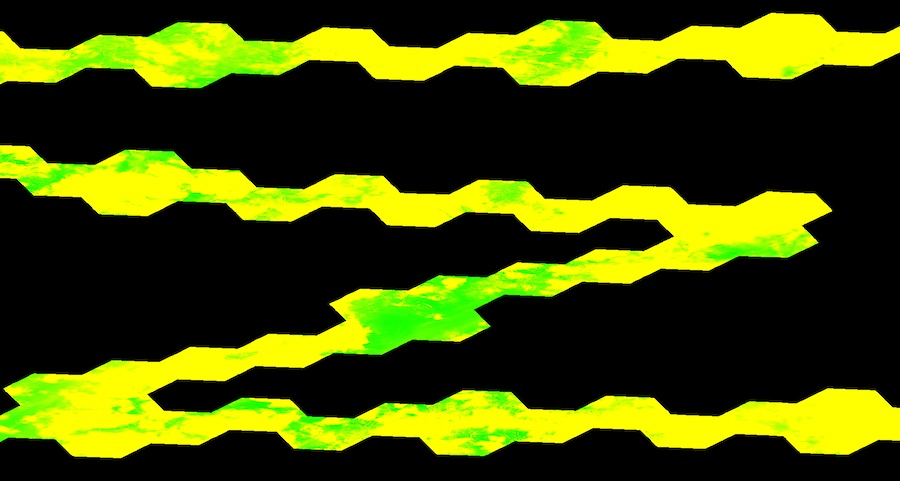

In [ ]:
displayHTML("""<img src="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABwigAwAEAAAAAQAAA8KkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAeEDhAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAEBAQEBAQIBAQIDAgICAwQDAwMDBAYEBAQEBAYHBgYGBgYGBwcHBwcHBwcICAgICAgJCQkJCQsLCwsLCwsLCwv/2wBDAQICAgMDAwUDAwULCAYICwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwv/3QAEADn/2gAMAwEAAhEDEQA/AP8AP/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiva/gl+zt8av2jPHln8Mvgl4Z1LxTr98QYtP0q3a6udhKgyNGn+riXepaWQpEo5LAVhisVRw1KVfETUIRV25NJJLdtvRJdxxi27I8Uor+qH4Xf8GmH/BQnxl4Nh8Q+Odc8IeENQleRTpd9eXF3cRqhwrPJaRPB8+CwCO2FIyd2VGOf+DUX/go0M4bwkf8AuYJP/lbX5T/xHngD2k6azmjeLs/fVvk3ZSXnFtfgd39l4u1/Zs/l2or+gVv+DZf/AIK4BiB8PbEgE8jX9P5/8iU3/iGY/wCCuP8A0Tyx/wDB/p//AMcr1f8AiMPA3/Q8wv8A4Ppf/JEf2fif+fUvuZ/P5RX7reKf+Dcn/grJ4T8j7Z8Lbm++0bsf2XqOnXu3bj/WZuoduc/L1zz0xXnHiP8A4IKf8FT/AA3oF54gufg14kljsommZIFsbiVgvULFBeySufRURmPYGuuh4p8G1rezznDO+37+n6fzEvA4hb039zPxwor6V+PH7Hn7T37MUljF+0B4C17wa2pxyS2f9s2EtmLlYjiQxM42uY+C6qSyggkbea+aq+ywWPw2MpLEYSrGpTe0otST6aNXT1OeUXF2krMKKKK6yQooooAKKKKACiiigAooooA//9D/AD/6K9a+KXwL+LXwVv4dM+KXh7U9AuLiLz44tSsbmwkaLdt3qlzFE7Lu4LKCoOATk4ryWscPiaVemqtGSlF7NO6G007MKKKK2EFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRW5ovhvW/EN9b6bo9tJcXF04jhiiRpJJGPZEUF299oOKmc4xTlJ2QnJJXZh10vhnwf4l8Y6ta6F4asp728vZBFbwQRtLLM5IG2ONAzyNyPlRWPtX9GP/BPv/g3h+Mf7QdhafED9pm8m8A6FcIk8WmhEfXLmKRCf9U+6OzwSOZlkk7eUhGa/qv8A2Wv2BP2bf2JrT+z/AICeErWz1KSMJcaven7Xqlwo4xJcyjcF/wBhNqDsor+euO/pHcO5HOpg8uf1rEx0tF2pp+dTVP8A7dUtdHZnxGd8d4HAwvRTqvb3dVf12+Suz+Dzw9/wRw/4KKeJNGtNbsfhVrypeRpIiSpawyAOMgNHLdJIh9VdFYdwKueIP+CMH/BSXQNKn1VvhF4kulg25jtILa7lO4gfLHb3Msjdf4UOByeASP8ASG0qyuVv994ISxOceZggfgP617PovjDxPYo2jaXJHDNuARVUmRg3BwTnp196/n/E/S14ohO9PBYdx7fvFp687++3nY8DJOO8VipXxaUI30UYNyflrOKu+mr7WbP8s++/4JQ/8FH9NUPe/A/xvFu4AbRZ8n6DGTVmw/4JLf8ABSbUozLZ/A3xy6g4yNEnH6EA1/rFeG/DY1ubdqer3ss8SgurxmEg9yCwPHbivW47u2s7byIJDcvHhSNwLn69Oa8uv9NPP4e5HLaLl61EvxZ+x5TgamKvXre5S6K8ZSffWMmvlZs/x2L/AP4J4ftqaXfTaZqXwv8AF1vc27tFLE/h3VCyOhwVJS1ZSQeMqxHoSK5LxV+xX+1N4J0ObxH4p8AeJbCytwDJPc6FqUEagkKMvLaog5IHJHNf7KTnUryMfZwbU553jccfgaqa/o1tqumG21CQiFQWcgkHA+h/pW9H6bWaKcfa5TC3W1V/h7j+W561bJP3c5UW20rq+ifz3Xq0f4mOt+F/EHhwouuWU9oZBlfPieLOPTeq5/CsGv8AWL/4KQ/8EpPgX/wUh+Ei+DvFhbw3rGi2850DxDbxCW5tpphysschxNau6o0kJ2ltoZGRwrj/ADFv2uv2RfjV+xb8bNX+BXxz0k6XrWlMHzGTJa3Vs5Iiu7SUgebbS4Ox8BlYGOQLIrLX9R+D3jnlHHdGdKEfY4yGsqTld8t9JRlZcy25tE4t2a1i5fPezqwS9qrN+d07dVs7dm0r9NNT5dooor9xEFFFFABRRRQAUUUUAFFT29rcXbmO2QuQCxwOijkk+gA6k8Cv0T/Yr/4JX/tnft3+JE0r4D+Dby+05JFW51e5Bs9JtwcHMl5Kvln5TuCwCaQjkJgg15ecZ3l+VYaeMzLEQpUo6uU5KKXzbSLp05TfLBXZ+ctFf3/fBz/g0Y+CNl8OdNg+OHxN1WTxSULX39g2dkNPVyeFiN5BPOwA6szAMckKgwowfEf/AAZ6fCe+167vPDnxt1S0sJZN1vDcaFazSxptAw7xywox3ZOVjQYIGMgk/gy+lZ4c+2nSljpJRv73sqrTs7aWg3ruvI9T+w8XZNR/FH8D9Ff286n/AMGenimHUbiPRfjPpNxZiRvIkutBuVnMZOV3iLUBHuA4O0AHGcDOK5DxV/wZ+fGKPQbh/B3xa8NXWpAL5MVzpV9axN8wzulF3OVwuSP3TZPHGcj1KX0mvDabSWarXvTrL7709PmQ8lxi+x+K/wAz+LWiv65f+IQf9tj/AKKF4F/771D/AOMVwvib/g0u/wCCgOi362uia14N1uFkDGeLVbmyCsSQUKS2MjEjAO4Ng5xjivVpfSC8PKkuWGc0r+ba/GSS/Eh5Vi/+fbP5VKK/Z39vr/ghp+2z/wAE+PhZZ/Gj4t6TYXnhma6Fndaho1+2oxWMsmBD9qzbW5gjmY7ElIaPzNqMVLpu/GWSOSKRopVKspIIIwQR2Nfo/DvE2VZ9hFj8nxMK1G7XNCSkrrdO2zXbs0+px1qE6UuWorMZRRRXumQUUUUAFFFFABRRRQAUUUUAFFaEWlalOkTwwOwnJWLj/WEHBCf3iD2Ga0f+ES8V/wDQMu/+/L/4VDqwW8l947HPUVq3Wh63YsqXtnPCWGQHjZSQPTIqr9gvv+eMn/fJ/wAKanF6piKlFFFUAUVNb29xdzLb2sbSyOcKqAsSfYCvtf8AZB/4J5/tX/tweLU8L/s8+EL7X0WRVuL2JfL0+2BK5M14+LdAA2Sod5eDtjYgivPzPNcFl2Hni8fWjSpRV3KclGKXm3ZID4nhhmuZVgt0LuxwFUZJPsK+tP2WP2Hv2lf2x/GVp4P+A3he71wzziGe8jXZYWnAYtc3bfuIQF52sxkP8KMSAf7nf+CfH/Brf+zR8GNK07xx+2bff8LD8UKiyTaLb7odBt5eDtbKrNe7SOs22JjnEIr+k3w/8DPhJ8MfB1t4P+HHg/S7DSbCPZBYWVtHbxIvYIiBVA9uK/jzj76YuTYKc8FwxQeIqK69rL3aafdJ2lNf+AJ9JNHViMmzJ0nOioq38zb+5RTf6+TP4QfhZ/wa/X2p+GLX/hbfxRGm+IJdzXFnoul/2jbW4zhF+0SSRNK2OWbykXJwBgZPpE3/AAaaeKmlk/sv4t6dJGzkwC50C7WcoTkb/LvVjyOh2gA9cdq/tNPwdsmP9raLZ/2NI334TMVjB7bdmc/Q10OqWfiXwBoMM+n3st1hwXjA81iD1I3DO31HGBX884j6TvHVSrzYbMUnJ/D7OlZeSfJLRbat36u+p8bleFz/AA3tsRm7vSSveEVoullLkk366rqj/Pm8Qf8ABrH+2h4bj+06n4x8IRxbiAzNfAYzx/ywxn2zXm+tf8G037Zlibc6H4i8Iax5zMrLHf3NoY8AYYtLauCDyCByOPw/0XX8S+DfiX4U+zeIo1in+bMUpMLLtPUE8frXxR40tPDtve/ZPD91lIW2sJVwB9GBOfoBX02U/Sh46rSdOvUhzLf90rferP8AE+T414hzDKFSx2X4qnWw00mk7Kd+qa02Wumq6o/hzm/4Nn/29UVGgl8KS7yB8niAnGfXNiMV5Lqf/Buj/wAFP4dSubLQvBmnassErIGstesZAygkBwHaNtpxwSoPqBX97GnXrW6FnWGSNcchff0OM574Fe56R4mnuWVrSKKzCqoKxR7NwHr616svpQ8b4bXloT/xQnb8KiZx5H4i1MbJqqlG9tFq+uqei6db+R/mD/tb/wDBIz9vj9iXwlp/j39oH4f3elaJqWEi1C2mi1C1SYttEM0lsziCVyR5ay7fNzhCzDbX5pV/so+N9P0z4ufD/WPhr8QtKtvEug+ILRrO+0y/iE1rLBKMMjL7/mpwRg4r/NW/4LFf8Es/HH7BPx3n1Pwrp91d/DnxHKZND1Nm88JKRl7G5kAytzGc+WX5uI8MC0qyiv3rwN+kK+La88nz6FOjjdXBwbUKi6pKTbU4rdXd0nJWSaX6nDNcHVlCFFyu19pWV/JrTXe29j8V6KKK/qQ7QooooAKKKKACiiigAorb0jw7rWu3MVppVtJPJcErEkaM7SFeoRVBZiO4UEgcniv6Lv8Agn//AMG1P7af7WH2Lxr8Yrb/AIVZ4Pnw/wBs1uBv7RnjOebfTspKMjBV7loR/wBM3FfKcWccZFw1hHjc8xcKNPpzPWXlGKvKT8opvyN6GGq1pctKN2fzexW1zMu6GNnHTKgmo5IpIm2SqVPoRg1/qY/CL/g3B/4JTfDjwLaeFPGHgObxxqEAzNq2tX9x9plY9cJbSQQRIDnakcaqM9zk1o63/wAG5X/BJvVNTk1HTPAOoaPHKFzbadr2pW9uGUBdwQXBAJAG7HU89c1/NsvpocFqtKmsLiXFXtJQp2fmk6qdnvqk+6R7H+ruJte6+9/5H+V1RX+pef8Ag27/AOCVhGP+EW17/wAKXU//AI/Xz23/AAajf8EzmYsNX8cjJJx/a8PH/krXZh/pkcC1L+0p4iHrTi7/APgM3+JMuHsUtmn8/wDgH+apRX+j74q/4NMv+CfuopA3g/xf420mSMv5plubG/WRWxj5Z7MhSpHBXsSDnt4943/4NDf2a9X0lLbwP8WfEWm3YlDNLe6Zp1zGYwDlQsMVswJOMEuRx908Eevhvpb+HtXl58RUhf8AmpT09eVS/Bsh5Di10X3o/wA+QAk4HJNfUH7Nv7Gv7SP7WvjkfDv4BeENU8UaqoDTW+n2/mtboQxDTuxSG3U7Tta4kiDdFLHiv7of2cf+DSr9lX4ZfEeDxd8ePHuq/EPRrYZGiR2iaNDcOVdSLiaCV52jwwOyJ4sso3My/LX9OfwV+AvwX/Zx8B2vww+A/hfTPCXh+zz5VjpdsltDuY5LMEA3OxJLOxLMTkkmviOPvpk5DgqTo8K0XiqrXxzUqdOL81JKpJrqrRTT0nc6MLw9Vk713yr73/kfxy/8E/f+DT77MLH4g/t+eIvs7DbL/wAIx4dnzKDwdtzqOBtwRytqikdPOYV/Xj+zd+yp+z3+yL8ObL4Vfs7eFbHwvo1lHsCWyZmmPeSed90s8jHlpJXZmPU19CUV/DfHnizxRxhVcs6xkpU73VKPu0o9rQWjavZSlzSt9pn02FwFDDr93HXv1Ciiivzg7AooooAQqG6iomghcYdQfrU1FO4mk9zwj9pL9mv4N/tafBzV/gR8ddHj1nw9rMYWSNjtlhlTmOeCQfNFNE2GjkUgqw+or/L0/wCCt3/BIn41/wDBNP4wvZXsE2t+BNZlkbQvEMUO2C5RQX8mUL8sN2iAmSEYVlUyRfJuWP8A1gq8P/aN/Zy+Dv7V/wAHdb+BPx20SDXfDmuwPDPBMgLxOQQk0LkExTxE74pUw6OAQQRX7l4J+N2ZcB5hyu9TAVH+9pX26c8OimlutppWdmoyj5uZZbDFQ7SWz/Rn+K/RX7H/APBVz/gkR8bv+CdPx8bwiLW88ReENbZpdB123tJWiu4/mYxSeWhSK7jVT50QOCMSR/I22P8ALYfCX4jE4GiagSf+nO4/+N1/rRkPFWVZzl9HNMuxEZ0aq5otPp6PVNPRp2aaadmj4OrQnTm4TWqPOaK3o/DmoSIsiSWuGAIzdQqcH1BcEfQ8iq11o93aMqyvASwyNk8bj8drHH417qqwbspL7zOxlUVb+xTf3o/+/i/41rf8Ij4r/wCgZd/9+X/wpupBbtCsc9RW7J4Y8Q26+beWU1vGOrzIY0H1ZsD6DueBzX7YfsDf8EBf28P23NQ0vxJ/wjkngrwPeZkk8R+Io2tYDGNpHkWhKXdyXBIUqkcRI/1uMZ8DiLi7JshwcsfnGLhRpLrKSV+toreUu0YpyfRM1pUKlWXLTi2z8MqK/wBML4P/APBr/wD8E4fh14EtPDfxKn8S+LtaUb7nUv7Sm0xJHIAIS3sykaIMcA735+Z2PNen/wDEN1/wSn/6AHiT/wAKHUf/AI5X87Vfph8BwnKMY15JNq6pqz81eSdnurpPukeh/Y2J8vvR/9H+j39u79g/4E/8FB/gTe/BH422fHzT6VqsKqbzS7zaVWeBmBB4O2SNspKhKOCDX+Vx/wAFEf8Agn/8Zf8Agnb+0PqXwK+LdvGXijW9sL22JNtfWErskVzCSSwjdlKlX+eKQFGJ+V3/ANg6yW7jhEd3tJHQp0xXwl+39/wTg/Zm/wCCjnwu/wCFf/HrSAdS06O4/sPXrYBdQ0qe4Xazwv0eNsL5sEm6KXaNy5Ckf5JeAnjxiuBsd9RzCUqmW1H70Vq6cn9uCf8A5PHqtV7ys/ucxy5YumqkVafn+TP8eiiv0M/4KF/8E5Pjt/wTz+Pd78G/i3awxxtun0vUVcR2epWmcLPbPKwLL2eMkyQv8j5+R5Pz+FnMRncn/fxf8a/1ZyjOsDmmDpZhl9aNSjUSlGUXdNM+JqU5U5OE1ZoqUVp22japfSGGwha5cDJWH94wHrhcnHvVz/hFPFOcf2bdf9+X/wAK9B1YLRyX3kGBRV+fStTtZTBc20sbjqrIQfyNRfYb3/ni/wD3yarmXcCrRV2LTb+Z9kcLepJGAB6kngAdyTgV+yH/AAT9/wCCGn7cP7fUll4o8H+Hj4e8GXDKzeJNd32mnNGShJtxtM94drEr5CeS2Meehrw+IeKMpyLByx+b4mFGkvtTkkvRd2+iV2+iZpSpTqy5Kauz8aoLWe5J8lchcbmPCrk4GSeBz6mv1N/YW/4I8/toft6TQ6v8LvDp0/w05AfxBrLmw0xQc8xu48y5I4O23jcHPLpX9wX7G/8AwbufspfsY29j4i1Wzj+J3ixVV5tW1u3Q29rLtAb7FYnzIolJGQ7+bMP+euOK/XgeHNJ8NxrBcNao8K5B3BRtHYdQD7fpX8ecdfS+w7U8LwhQ53sqtRO3rGnpJ+Tk4+cGjxMzxuMwdaVOph2oLeUnZPT7Ls7/AJaWP5ivBH/BsH+xl4e+Fy6F8VPGPirVPGA+aTUdJNtZWMbghtkdpPBcb1GCpM0jswPJHGMi4/4NjP2QmmMUHjjxf8uM4tdKbBPY4sx071/TBqWpJd4ltfkfJIJhODnvyAKpTQyTSC2uBFKFwDJuweepGc/hk1/PcfGzjlylUnmtS8m29I2XouWyXZKy8j4HGcV4+cnGjUXKrWtGPn1Sbv6/qfzJeMv+DUf4Ia6liPAXxV1rTj85lN7ptlc+YDjbtEK2pXHOd2/OeMYOfNNW/wCDTXwvosP229+Ml4LfeFMn9hwYXPQH/SsZ/EfhX9aH9kaVHYSXzX72RiO395IVJU/7Snofp+nNa2nTtbSpa/2i06ToCRvVl29ieWGCfY5rel9IDxAoxUYZq2l3pUm++7gz0o55ipR5Jtxk1o1KErdFeLSdm16266H8cOkf8Gn+teImfTvDfxo0K7vEQsI30G9jYgd2IvyoJ6nGR6Zq94p/4NDfjNB4TmuPCnxV8OXGslV8m2udKvbWNmLDIaYXU+0AZORE3px1H9kOhXFpo3i5NYsLHM6kpi2fy433jBDBiwA74GMHoBX1NH9ov7MfbbdUYjJQsGAP1FZ4z6TniLh6kJRzFOOj1pUfmtILT0s/M/QuEp/2nQq/Wbe2i2vcU+W3SV2naW6au1pex/AD8JP+DTv486f4uF3+0N440a28PxYJTQFluL2b72QpuY1hiHQ7mSX0Cg/NX9Gn7IH7Bf7Pf7EmiX3hv4I+CrKCXUSPtupXMbXmpT7Bj5rt3aYIOvlgiNTkqoya/c+3sYooAkqJu77Rx+FcrrngDw/rEn2prcRzj7rxYQg+pxjNfK8U+PXFHE0Pq+dYlul/JBckHbW7jG3Nrr7zduljzuJPDnHY3lrYfGS0WsG0otPe6jG0vSSfy1PzsjeO1UwNYO5j/wCWjSMiFh6BeT612Wh6Mb64gvNQthNAFAEEYZEdgfvMwILE9Cc8175r/wAI9XS9xbXSvAfuggqR9WJxx+FO0b4UyNKtrJqIKoOE3ibnuQMHH9K+RqZzQlDmjK33/wBL5H5Fg/DbNaOL9lVouSTsk1BJtPq72kvKV/Q88k8PaLqV0PsugxWmGyfKMhfaOMFi2OepxjPerFl8P5NPZr+G2kK79wUZBTHTGDxXvtr8LI0VftOoXOU4AR9q4+i4P613em+G9N0mELZIFkxgyfxH6k5rxKudKKtTk39/5tn6dl/hhOtP2mLoxg97pQTv/hjFL8kfKeqwSavPtvLtoJpCBteSRmI98cAe9enaF4M0Sey+zafqWzUFADGKUuhx6gknn86s/EDw/wDY9PfUfMbzFBVRjKDPqTjisP4dTXr6HL4jlwBblkUP/EE6kZ4xnj61dSvKph1Upysk7W8/8jDCZZTwecywuMoqcpRcubW/Kt3o9Jeat+J7hb3WoWkYinSNggx8rYJIxnGfQc1sXElsIDJcMBHjqTxXzcnxKGp+I7cTGcWbOMggHGe4A6/l0rs/GOpeGtZtI7yHUgxj48uNsjHqB2ryqmX1Izipq1+yufe4TjHCVcNXqYaSnyaJSlGN13V91999tzL8Wa0LjUVgtgVSIELtHJ+vNfn5+3z/AME1/gZ/wUl+D9v4B+NNtLp2raPK1zoWv2KIL/TpJMeYqb1ZZIJlULNA4KOADw6o6/cDPYhQbUb17MOcgfjxWzPFK9uhgkMKv6nOT6V9HlGa4zKMVRxuW1XSrU3eM1un/wAFXTTumm0002fHQxU6uIqYmbu30T07b7WWnY/yVv2+/wBhP4ufsA/tAX/wN+K8cPmogurC7hb/AEe+spGZY7iAsd2xijBkb543Uo2cK7/Ev2aX1T/vtf8AGv8AX8+Kn7M/wl+Nk1tP8U/DmieJZdPWRbVtVsILswrJguI2mVioYqu4DGcDPSvm29/YY/ZNgm82H4V+EJADtGzRrN259hF/Kv7l4f8ApgUVgKNLM8A54iMUpyjJRjJ90mtL721szycdxRXwiTqYVtd7r9Ln+U3Bpt7dSiC0TzpG6JGQ7H6AZJ/KtD/hFfE5O0abdZ/64v8A4V/qrXH7DP7GHiHSH8N+Ivg/4MvLWcgSxy6JaKSUbcOVjBGCOxrk4f8AgmF/wTittWimuvgR4HdM5kiGkwjjt1HHrXtx+mBlOvPllVPylB/m4/l8zfC8XYWrCMpxcbtJ6Xtf/LyP8sa40rU7SUwXVtLE46q6EEZ9iKrm1uVG5o2AHOcGv9SD4g/8EVv+CTviTWT4nv8A4JaTbtclN40+W4s4FCgD5YYZY414HO1Rk8nk155ff8EKf+CR2q2k1ppvw1trKTYU8yK/vllVm6FHFxww6huxruofTC4WlCMqmBxKfW0abS7/APL39D1MTnNClUdNNN+qV/Tmavof5kEME1wxWBS5ALHAzgDqT7Dua/Tb9hb/AIJHftq/8FAdSjk+BnhOaXQd5SbX75vsejQkbgc3jK4lIZcFLWO4dTwyr1r+8r4Bf8EGP+Cb/gbxnB4+g8CjWJtObdDDrt/c6tZB+zm2uneF2HYspxniv2/8O22leH7aDw54WktLSxtkEMUVvEqRR7OAiogCoAOwwK+K48+mRRhReH4VwTdVrWdbRR9IQb5vJuUbPo0e5lDp4qMa1SLUJbfCm/S7/Q/BL/gnn/wbZ/sbfsmadYeMP2greH4seN4H84vfw7NEtZAzFPIsGLCRkBC+bctK5I3KEBCj+i+zsbPT7WOxsIkghhUIkcahUVVGAABgAAcACrIzjnrQSB1r+F+LONc84lxjx2eYuVaprbmfuxv0hFWjBeUUkfpFDD0qMeWnGy/rcWiiivljcKKKKACiiigDmvGXg3wn8Q/CepeBPHem22s6LrNtLZX9hexLPb3NvOpSSKWNwVdHUkMpBBBr/Ni/4Lm/8EMfFH/BPvxTP8evgLBcat8GNWuVSKV2aafw7cTNhLO8kYlmtmYhLS7c5BxBOd/lyS/6YVYfibwx4b8a+Hr3wl4w0+21XStSge2u7O8iWe3uIZRteOSNwVdGBIZWBBHWv1rwi8Xs24DzX63g/fw87KrSbtGa7rflnH7MreTvFtHBj8BTxUOWWj6M/wAQ+WKWCVoZlKOhKsrDBBHUEVHX9m3/AAV8/wCDar4l6R8WE+LH/BPDw5NrvhjxBMxuPDtm8C3GjzHLFYvtE0KSWbc+X8/mQH93hoynl/g945/4Iof8FP8AwJqsWlah8EvF9w8sQlDWlgl4gBJGC9rNOgPH3SwbvjBBP+qHCnjNwfn2Ao47D5jSg5q/s6lSEKkX1UouV00/VPdNppnxFfLsRSk4uDduqWh+VVFfoxe/8Ekv+ClVhZTX9z8C/HQjgjeVyNDuGIVAScBQWPA6AEnsCa8u/wCGAP2xjyPhr4sI/wCxc1b/AOQ6+wpcXZHVTdLHUpW7VIv8mzneHqreL+4+OKK+jvHX7JH7R3w0s7a/8deCfEGkw3kphhe90bULVXkClyqme2QMQoJwpJwM9K82/wCFS/Eb/oCah/4B3H/xuvTo5pg60FUpVouPdNMhwktGjzqivSvCnwh+IfjrxZaeBPBumT6trd9KYLfTrFGu76SUAkotrCHuC4wcqI8rg5Awcf1SfsBf8Gqn7QXxa+yeOv20dT/4VtoMnz/2VAIrzXpkO4YK/vLS0z8pBkNy+ODHG1fKcaeJXDfCmF+tZ5jI0017sb3nL/DBXlLzaVl1sjbDYOtXly0o3P5SfAXw28c/E/xNZ+DPAOl3Wr6tqLbLSysoZLm6uGwTiKCFXlkPyn7iNjBJwAa/q2/YC/4NVP2gvi19k8dfto6n/wAK20GT5/7KgEV5r0yHcMFf3lpaZ+UgyG5fHBjjav7VP2QP+CfX7I37CvhMeF/2bPBtnos0gIutUlButVvCTkm4vJd08gz0QsEQcKqjivs6v4R8SPpi5vmPPg+E6P1ak7r2s7SqteUdYQv5876ppn1GD4epw96u7vstv+CfmR8Jf+CNv/BM34PfDWX4XaN8HvDusWV0ipeXWvWiatf3RVi4aW5uhJKSGOV2soXgKAAANKb/AIJC/wDBLaBd8vwE8EYzjjRoD/Ja/SWiv5Vnx1xHOpOtPM67lJ3k/bVLt937257bwtLltGC+5H5OeL/+CG//AASb8e3Nvea38C/D1q9sjxoNOSXTlZXIJLrayxK544LAkDIBAJrkj/wb9f8ABIDBH/CltO/8Db//AOSa/Y5iQMqMn0p2cDNddPxJ4upxUKecYlRXRV6qX/pRCwdDrTX3L/I/Ai8/4Nx/+CXqXKW+neDtccZ+dpPE+poACONuJ2J/GuT+IH/Bsd/wS68Xabbw21h4s0JrWQyu9hr1zcNICpXYRdi4GATuyiq2RycZB/oeWSIuQGBOcf8A1qlr1afjFxvTlGcc5xF13rTf4OTX4HNHLKDcnZO+2isvuSf3s/no+CP/AAbL/wDBLv4S+NY/HGpaVrvjeOJkkh07xJqHn2AdOQXghjgE3X7s29P9mv3t8KeC/CngTQ4PDXhDTrTS9Ns0WO3tLOBIIYo0GFVEjAUADgACtLUvEGh6MdurXcVsSNw8xwuQPTPWvKNZ+Pfw8sJJbNZ55nX5VMEZIb/dJwCB65xXj59xTxLxNOM82xVXEcu3PKUkvRbLzaWvU8rG5tkeUJvFYinTl5ySd7dm7+i/zPX4NV0uec2lvcRNKvVFYFvy61oV4j4Y8TfCbXJG1mCJYbjG93u0KyZPfLZz+degP498HIHP9owHyxlgGHSvma2DnGXLGEvO6NMs4jwlej7ariKPK/hcZ3TXztr3OurB17xJ4e8OwrJ4huorWOXIBlOFOByPTpXn2t/FPw1JC1tpmppazqNxLpu+XGemc9ORivi/xz41ute1PauuNeRRZeNnUgc9gvYfUZr0styOriJ/vLxXo7/lY+K438VcFk+Gvg+WrUei9+Djfrdc6lovJK9tT2Dxp4otZvEYvPDtmk+nbdrMI8IVPfjI/lXz5r+n2p1bNtAXE5yOAAAOwIIrrNA+IkoZLPcjxnClCSNzf7jbs+w5JrZk1Cxvb1rhbNrVXxy6c89TgD5ce+K+ww9OeFfLy7K2+/r5n85ZxjMNnsXW9urylzcvLpFvdReq5emrt28+b0LQrO+2peQSWyhhh1UOdnfGSvI69wenvXsPh7w34LRUF9q01s4O0JORHG2DjIwOh9ySK5ma6iszC1vcYeVgAsy7QvbO7O3B69M1o32ieNJZhaRXMEqsPMDGY7SB14AYY/SufE1JVN58qf8AXVHs5Ng6GD1jhvbSja+l99r8klb7tOup6g/hDX7iBB4Vn06/UON7rM25QpyQBhl5xg9Dirvin4UfDn4oeCtU+HXxZ8JWWr6Rr8L2d/ZXMayQzwyjayFXVSRg8HqDyDmuB8IfDLxbq2rRy6uLS0hU7vtFpGPMO3+EONpGfevrmws00+1S1V3k2gDc5LMce5r5zG4uWGnF0qt5p3TjdNPo7p7prS1rH7jwTl08ZzYuphZUI6JKbjJO38sZR5o77tu/fQ/zff8Agq3/AMG6X7TH7PHxjk8T/sd+F9Y+I3gDXZ2azGmxfbdS052y32e8iBEjBQCEulBWQYEm2X5pfxQv/wDgnh+2ppd9NpmpfC/xdb3Nu7RSxP4d1QsjocFSUtWUkHjKsR6Eiv8AY+pu0e/51/T/AA19MniXL8BSweYYSniJQVvaOTjKVtnLSSbtu0lfc+9rcPUZScoyav0P8X/x1+yR+0d8NLO2v/HXgnxBpMN5KYYXvdG1C1V5ApcqpntkDEKCcKScDPSvNx8JfiMTgaJqBJ/6c7j/AON1/tjtGjjDjI9+aaLeAHIRfyFfXUfpw4tQtVySLl3Vdpfd7F/mc74ajfSp+H/BP8RKPw5qEiLIklrhgCM3UKnB9QXBH0PIqO50G+tYvOke2IBA+S5hc8+yuTX+13L8L/htNK003h/TXdyWZjaREknkknb1JrmfFX7PXwE8d6M3hzxv4J0HWNPd0ka2vdNt54S8TBkYo8ZXKsAQccHpXq0/pxUeZe0yNpdbV038v3Sv96IfDTtpV/D/AIJ/i++E/A3ijxz4htPCfhK0k1HUr6RYbe1tFNxPLI5wFjiiDySMT/Cise+MV/UH/wAE/wD/AINcP2rPjrfab44/axlHwv8ACk0fnvbTBLnXpRlCqLafNDbbhvy9w8jDjMAJ4/vr+Hv7L37NXwl17/hKvhV8PvDfhrVDG0P2zStKtrOfy2wSvmRRq204GRnHFe6gAdK+N47+mXnOYUPq3DWEWFTWs5tVJ/8Abqsox9Wp+iOjC8O04O9aXN5bH58fsYf8Et/2Iv2DNPgf4AeCLODXo4TBL4i1BRe61OrABg13KDIiMAMxxbI+OFFfoMAB0paK/j7N85x+aYmWNzKvOtVlvKcnKT+bbduy2R9BTpwpx5YKyCiiivNLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooprMqKXY4A60ADRo4w4B+tMFvADkIv5Cgykx74Rv9O2achcj94AD7HNPUnmTZw8vwv+G00rTTeH9Nd3JZmNpESSeSSdvUmvPfGX7Kf7MHxGure++IPw58Ma7PZo8cEl/pFrcPEkhBZUMkTFQxUEgdSBXvtFdlHMsXSkp0q0otdVJp/emDhF6NHyif2D/2ICCP+FO+Cef+oBY//Ga8NP8AwR//AOCXROf+FB+B/wDwTwf/ABNfpBRXqUOLc8oX9jj60b72qzV/ukQ6FJ7xX3I+Gvhp/wAEy/8Agnv8HfG1j8R/hf8ABjwfoevaYzPaX9ppNuk8DsCpaNtpKtgkbhyATX3IAB0paK87Mc2x2YVFVx9edWSVk5ylJpdk5N6eRUKcYK0VYKKKK88s/9L+tm48Q2C22R5qeXwGT7uD39Of0rT0/wAS6VcRBZJwHHHz8E185W+s6lPfxrPsIZiVP3ckdwWrf0a8XUpGj+1LEEDEAqd7BcnjIwPpnJr/AAgqZbGMdSMFxtVqVlyJa6Wel7fNLr/V0e2a/wCE/B/jG3WLxRptnqkSq6qt1Ck6hZBhhhwQAwGCO/evmhv2Dv2I0tlSx+D3ggIqhUCeH7DAA4AH7nGB6V7Do3iK5fTW/s2WOYtltztg7RwTj696bBL4vhV/7OUbZPm4G7B9f69s0YXEY7CJww+IlBdlJxT+SfmfVS4ioVYQlGlKV1d8qvbtZ9fvPnjxP/wTX/YH8eaWmi+Nfgr4GvIIpBMgGg2aAOAQDlI1OcE+1eVSf8Ea/wDgmOZlmh+B/gpeeVOjQFSPyBH1zX3JZXXjBJRb3twEOBguAPlHOSOvPetBtd1QXJjW7ifHbYVH1zz/ACr1KXFPEVBclDMqqXZValvzsT/aOCqwTrUJKz62Tv8A+BXf4n5geKf+CBf/AASM8Xa8/iLUvgtpNvM+3MdjcXdlb/IMDEME6RjpzhRk8nJzWJqX/BAD/gj7bWElxL8GbCNEXJKXt+WwPT/SCfy5r9eV1e30+z33EwdsHPO45HXoOn4VyeqfEuGzRGsbf7QzAHbvC8d+vJ+vSvQo+IfGj5YU84xVlov9oqpf+l2NcZi8ow1KUqqjBtX+G7+6Or9Efkr8Pv8AgiX/AME4/hTrln8XfAfwa0W11PST59oL97i+CMCGRxDcySx+YpUGNihYN0xmv058I65o9pcDS/ENs9jdwRqxWEtsiB6K2w7FbGPlrC8X/EHX9f01tOGkI9uSrMvmtk7DnkqVJHQ9vSvJNQ+KWrjTToUFja6cqvuzCrK6nrxkn+VaZhmOdZ2lLNsTOtNaJzqSm4rsnKUnburH47mvFmW5bi41qNWUoqP24SanLW9ouMVHpaSlpqnHqvqPUvGXg/7SZDc3ErKvl7IQSTwWx65wM9RXksnh7RvGV1M1hpx06HGVll+d3PuGIx9c14FF4s1SBmyWkLtuODyT059a3bnxZ4+1TTfsTeaIGz8yptyPTcB/WuWnk86H8Odn3b/Tr8z5rG+I2FzS6xlDmSu+WMFd9k5tuUV5xLmuNa+ENSi0KO9iuIZZUR5IXG5MkA5xnHvU9ld+IY7t44ZngWPPVVlVtnGAcAr+RrzfT/Cs1xI97NCzxwZaRGIHXpz9ea1dCe6F15s+F53MyKd2f+AkV606EeW11Jrd2W/ofAUMzryrqTpypwk/cSlJWitLc1k2r+d979DqvEQvntkgvZfnk+cb8uMH0xgYH0qLS9HjIL3Zm2Yygj2kkdshucfSu5t/GXgbU4oNP16GaWVcgywlY3GTjks5BA/MVbh8GeCNVuLOZNXiXep80o+JAWI24WQfdAzuzznpXD9ZcI8tSLj8rr+vU+qWSQxVf2+ErQq7aOfLJbKzvo2r3dnbTVmLoupQ6ROlyYZ1kiIIYEFSPfjHX1r6d8Ha7qPiKE3E96uR/wAsxGAcfXmvBtN+Fgu78acl39otZHJ3RSKVIB4+6eM9eRxXpMHwpurWNhol19ldD8rMWLZHYnjNePmM8LUVue0u9rn6NwXh89wcnNYdukt4qfK27eVk9LWbep6xfJrCSbrIrKQQ20ttyB26VNbX2qP8tzZlD6hwRXh3iXW/Gfg2yh/4SmXzbdm2rdRYBTP94Y5/KvQ/BfjzRdc09IlujNKgw0jKQD7ngAV49XBVI0lUSUo91c/SMBxLhK2Plg5znRq2vyT5U/ud3802n3voehSRLMu2Tp3HavL/ABMqaFKJtEt52kBJYRggfXJBH616lHLHKN0TBh6g5qK6uoLOE3FwcIvU4J/lXHQquEtr+R9FmmBhiaLtNQa157Jteavt+R5Bofxa0+e5Wyvrd7dO8jktz+A/SvXbe+s7uNZbeRXVuQQa8S8Q/ELw9cXEmmqY5YmzkmMgg+xI/WvPZvEllo04uNK3vgZxIT1P0H9a9aWW+1s4QcH23/4Y/PqXG39nOVPEYmGIinbmSUWvlHmTX3H1fe273Vs8EbBCw6kbh+INc63hS0urc2moBXiIxsXIUgc4PfHtXk2hfE7XJpVkuhF5BIL+YeVXuR3J9q9IsfGcuqxedY2pIB553HA74HNck8JiKGh9HheIsmzRc7u3a1mnqvTVW/P5HmmpfCVo9Uae3CJCxOxF5/IY4/lWXceE49Nm23COmOhkwAfwzXrs/jDV4JxANKlbd9052g4+orxjxX44h1bUBZXafZpc7SMYx+Jr08LVxdVqMtrHw2fYHh/BU5VaF1Ny0TTSv2TaS9LG5pzLGHln2KE4XGOce3SuF17VNS1LdbBwF5wVUDA/CudnvLqxnWWSZjtYkBXGPyI5qgZX1FiGuJW8w85XGM/TivUpYXllzs+Dx+fOtR+rQTT6q9r+u35M0NO1L+zJBBuYjv8APkt+Gf0rsRJpFjFv/tDaSC3lxhjt56fWvNtP0NYb3fNFPIqEksynH6fzqndyQJdIbD7TslbG45kGD3GQWA+ldE6EZy91/wBfiePhs1rYWjerTW9km3deata673djtdQ8TaJfTgXttFP3RyvluR06jH59awtXNlp1qdX0ZxbnGdkz7sH8AARSWsR0i4VraAztKOQ9tIuc9s7asyWGstq8eoaLerZPsKlOCWXHKncCM89cZojCEWlHbzbs/lbT7gr18RiISdSKlNu3uqPNG/2lK65rdnJHNx+JPEGu6ctrfzEmTgNtWQ9OqjIwM9c5OOnNen/DTw34PtcXevwTGfO7LLuiGOxA6575GK+fbvw9r9heLJNZvGhlIMkBYA+4ViygZ9vpXqHhDwlrWqiG4aJ7hQc+ZkjJH8JBYA5+n41tjadNUXyT5Yvtb/M8zhfG4uWZQeIwrrVoafvLtdNbON/mlbz2Z9IWj+DLaR767glsogTtDNtik+iqcfgafB4ok1a7Ww8L20tvaAndJHEuGJ/l+Wa6Hw54VtV0qMa3AJZwMESHcB9AelVPHHxG+H/wd8HXnjD4g6nYeHtB0eFpru9vbiO1tbWFBktJJIVVFA9TXxykqlT2VKLnNuyW+uystbvsf01g8sxXsoSnKNKD1fLC031s2rWXpr36l/Tn0+WYWOoF47kHC5dst9OcV10lnG8PkqSnow5I+mc1/K9+1Z/wdWfsifBTxx/wi/wK8LX/AMUY4HMc+pQ3CaXYcFxm3e4jaacZUfOIlhYEFHfpXy2//B4l4CjWSSH4FXzOQSA3iOHGQOB/x6nA9cA/jX61g/o8+IuOoQxVDKJqMldc06UH84znGUfRpHq4THYOnFwnNPpfladvO2789D+04DAxTZGZI2dV3EDIA71/J1B/wdwfsfSQJJP8NPFiOygsq3ekkBiOQCbwEgHuQD7Ct7QP+Dtb9hi61WO18UeBPGWnWbhs3EP9m3pVgpK5jhvS+DjGQDgkZ45rhn4AeIMU5PJ6jt2cG/klO7+R6n9qYS1lUX9fI/qoRt6B8YyM4p1fzMf8RXX/AATO/wCgP46/8FEP/wAlV7L4V/4OYf8Aglp4l0G31u61rxLpck4bNrc+Hr2SWPaxHzNbpLEc4yNrtweecgebiPBXjujHmnkuIt5U5S/BXZccxwr09qvvP6AqK/GP4S/8F+P+CY/xk+JGj/C3w341vrHUdduUs7WbVdHvdOs/Ok4jWS4niSKPe2EUuwBdguckV+znWvjM94XzfJKkKOcYOpQlJXiqkJQbW11zJX+R00q9Oor05J+gUUUV4RqIQD15oAA6cUtFABTdo9/z/wDr06igBjRo4w4yPfmmfZ7f+4v5CpqKd2Fjm7Lwb4S07Vn16w0u0gvpCxa4jgRJWL/ey4UMc9+ea6SiiqnUlN3k7gkFFISByailRZ0MYYjPdTg1Ine2hNRXl2t6V4qtpJZrO7naMD5djjI+u7iud0x/HMe6+e5ujF/DvCSA59tortjg1KPMqiPl6/E0qNb2NTCVPVJNWXXdHudFfP0nj/xZZyCO9Rgqls/ugCR264FeqaPrmm+JrBIS7s5VfM2B48MR0yMfzqa2BqUkpS28tTTLeKcHjqkqNG8ZrZStG/pv+RL4h8Qy6MgSys57yVs/6pCyr9SAfyFeNv458fz6nHJPBJbWxypjEW35h6swz/KvY9Z0y7eHytPMir/0zZQc++4ZP51xGo+LNbtRJYMAC+UBlhYqg6bmKkDHsK6sHycukFJ+Z4PEksV7W9TFVKUFZpQSs32vdN/lrtoeNeNfi5qkqR6dDaxvbyHaZbiMyIGzxyCP5g1iWUngrU5Yh4j8P6ZfzSAkFIZcDHQLncA30r0zwpL431XzYN9pexQybROtqYtw+jE/rg11eveGNStWTUobqSONQBNHHArAL/sjr19DmvZ+sUaP7mK5X3Un/ldH5r/Y2ZZkpZlWm6sNPdqUqbSSdna9RwaWuqvprqeUanY6LZxLJ4Ot7bTi4+Yzz4K9yoY7uCOBx3xgda5vWfA3w11uWFpdTe01AAl4YryKQEY/hBBGB2O0E161d+FvB7RLHa3VoJSpLKVQOMDJyMj2z3FeB658LviVqV/PZaHaW1zCgwzxSx4IPOMMQwOOoxXXgq0ZP+NyNdW7X9b7ng8TZbiKMLf2dHERk0uSnFSUWtbxVNJwb6tad09ji49M8B6bPNZprLpZsx2Sx2Tzb++A6MoL9c9hXm2qafod1dPD4aa++VsCS5SOPcMc4VNxBz0yen512a/Db4gT3psRpFzweWK+YinsTsLAdO+D610OieENe0eb7deWYnUjKM0ccp+X+4S20HnBKk/0r6SOIp0ryVbmfrH9EfidfKMZjeWjPLnRppvVQq3S7e/JpJdLJebHeDPhHe3EEeqXjeUEIk2zDBIU559R7V3l5rekeEEu0R0niGWdIpcuFIz/AKstgZYkYOAccmvW/CXxE8I2NiI9atFtwqgncMkEdc57emKyfG/iTw34kjj/ALB0/SNZhlwVQZa4Ve5K/JjHpnNfPTx2IrV3HEU3y/JL79j9jw3DGUZdlMauU4uCr22alKTdrfDvbXW0X20PB38VeHdXgWSWa8LuoxG1nAUAOcjJJ6Dvk8+1S+F760+2NE7/AGNM7Y0t7aNyV7ALtYhuP4ePpW/pXhqKwvJIr2z09oTID5I8y2m2+g3bg3XqDX1t4T+HfhbRdQHiXTrVobh4ggVnLhAeuCecmrx+ZUMPBpRbvtt/X4M5uFOC82zjEwqSqwi4Nc/8S9tdd7PbZTj52MPwhpGuX1vFd73W1Iyhu4Ylfjp8iAEfic10Ov3934dntIYraO5E7kEqGQrjk8jIGe1ei1DNbxT7fNGdpyPrXxksXzVOaUdOy0P6Xo8PfV8H7GhVftNPefvdVfRtqz2W9u7sSI29A/qM06iiuI+lQUU1iyrlRk+lOFA7lUm6WfCqpix1zgg/TH9as5Gcd6WmsqsMEdRinchRavZ3HUVz1p4bsNOleWxkmiD9VEhK5+hyB+FfM/7Vn7bX7L37EXgxfGX7S3jiz8NxSg/ZLWU+df3rD+C3tYw00zE8fIhx3IFd2By3EY7EQwmApyq1ZO0Yxi5Sb8oq7fyOaFepGDlXgo+kk1975fyPrmiv4Tv2yP8Ag7Z8fT+JotC/Yk8I2WmaLEx87U/FNs13fz7ScbLS3uY4oUbjl5nkxnKJxn5C0D/g7N/4KF6Rqsd7qmk+DdYtwGV7abR7i0Bypwwkiv5GBVsHG0gjIOODX9B5d9FHxBxeEjinh6dNyV1CdRKfldJNJvs5K3WxwvP8J3f3H+jdRX+ep/xF8fts/wDRPfAv/fGof/H6sWn/AAd8/toLeQNe/DvwO8AljMqqNQVmjDDeA3nNtJXIDbWwedrYwbf0S/EX/oFp/wDg2H+Y/wC3sJ/M/uP9COiv4Wz/AMHg/jvPHwe0HH/Ydvf/AJXV1/hX/g8RihSePxv8EIbh8oYX0vxAyrg53Bxc2SHIwCCuQQexHPlVPoveJMI839l39KtH/wCWGn9t4P8An/Bn9utFfx7fCv8A4O9fgN4q+Iek+Hfib8JdV8NaBeTiO+1W21SLUpLOJuPN+zJCjyqhwXVG3hNzKGICn+uTwb4y8J/ETwnpvjzwHqVtrOiazaxXthf2Uqz29zbTqHjlikQlXR1IKsCQQa/OONPDXiXhOVJcQYKVH2l+VtxlF23XNCUo3XZu9rO1mdeGxlGvf2Ur2Olooor4Y6gooooAKKKKACiiigAooz2qrdXtrZQPcXLhUQZbvxTSb0RM5xinKTskWqimiSeMxSZweuDiseaL+2LVbi3ubi0U8gphSR64YHitlfkUISWIGMkdf0qnG3XUxp1Pa3XL7ttHpZ3IbO2+yQiANuUfd9h6VaoHNFS3d3ZtCCjFRjsgopu9fUUoIPQ5pFC0UV83/tL/ALX37M37Hfgn/hYf7TPjXS/B2lsSsLX82JrhwC2yCBd0sz4BO2JGbA6V1YLA4nGV4YXCUpVKknaMYpyk32SSbb9ETKcYrmk7I+kK8p+NHx0+Dn7Onw/vPir8dfE2neE/DlhtE+oapcLbwKznCoGcjc7HhUXLMeACa/jk/b2/4Oy5tK1aTwR+wH4Xga3jZ45vEXim3dnccjda2EcsbJgjIa6dScjMWOa/kC/aV/bM/aV/a68dN8Rv2gvGOq+KNWyfLmvrgusAIAIghQJb26/L92CKMdc5JJP9W+Hf0ReJc59niuIJrB4d2fK/erNduXaF+8m5Re8HseFi8/o07xpe8/wP7+Piz/wdXf8ABP7wN41uPDXw/wBC8TeNNOgVdurWkdrp9vMzc/uo7+4t5ymMYcxKG7ZAzXmv/EW5+xr/ANE48Xf+BWkf/J1f52BJJyeSaSv6gpfRA4AhCMZQrSaS1dV3fm7JK78kl2SPFef4vuvuP//T/rlk8MeHWuRGsC7iOQBnjtnr+FXrTw9p1jP59sgDAYGQDj+tcH8PBYTW63tldyO74Dh0Izjtk5Br08Ltb92CpbknGa/wPxHPCTpuTfrc+wydYbFUIYuNCMb6rlcX6ar/AIByyeGNF0ppNSFsm5iS2M4AbrgCtCF9Ij/eWSs/l9REGbnr9KknlFxI1lfLlRgg4ODn+taltBBbQiKPGBUTqSavNts6sPg6cZ8uHhGMV5K9/wAP1ILiGw1K3X7YgwegcYIrhdZ8HTANdaM2T97aGw3Hocf1FelkAjB5FMZo4lLEhQPXgVNKvOD937jXH5Th8VG1da/zLR/eeUDS9YtgDKSoYZ3ugfaf9ok/yFeTav4E8R3qnU7iNZ4wSVkgdERQO+civb9Z8VK8x0a2ltnlmGEG4tnPtjH6182/FDV/DPgfwZqPiT4ka3YaHoOmRtd3V9qNylpawxoDlpJJSsaqO5J4r6DLPbzqKMVaUrJK1279rWdz8p4pwODqw9jQjOta+ilb3tLJ3Ul5/Ddfceey3WppqL2el3ro43bgZN2FUZOTzniud8Ta58O/BPha58efFzX49G0SzhaebUbgxw2saJy2+V2AUqByDz/X8DP2n/8Ag4s/ZF/Z/uZdM/Z20yT4oa7F5qrdTLLp+io6uUDCZ086dOMr5ELJIP8AlooO6v5Af2x/+ChX7TH7b/jB/Evxp16S4s0l82z0m3Lw6VYNgj/RbQyPHE2CcykvO38UhHyj+q+Afo6cSZ9ONbMIPB4bT3pxXtJeUabtJes7aO6Uj80yfgrE4l+0zBcsbv3G5NL4WtE0tbu77paW0P64P2q/+Djz9lL4HeKv+ES/Zh0Cb4mRB/3mq3c0uj2KgEjERMMtxOPlyJFgVOQVdh08O8G/8HcuuaddyWnjX4SQX1gWQJHY6woOzBDb2nsUJYEAg4wQcE5GT/Fe7vK5kkJZmOSTySTTK/qrCfRl4ChhY4fFYOVaaWs51J8z8/clGKf+GKP0rLsjwuBio4VOGt/dco38nZ6x392V1qf2/eJv+Dsn4R+IdOFqPgPdwSGVZS416FgDznCfZ8cjiuA/4ijvhbqGqWkM/wAH9StraVwtzJHrcDMikjmOPyY0OB0VnUZ/iFfxgUVvS+jV4f0o8tPAyX/cas/zqP8AyFmnD+X5hJzxNFczSV1pt6WV/PfzP7gl/wCDlj9lho9svgHxLkdP9I005/O6/lXd+Ef+Dkj9hi7WT/hLPDXjDSWTZsMMdpe7wc7v9TdnZt4xuxnPHQ1/CFRXNV+jPwVOLiqVSPmqkr/i2vwPAp+HuTRd3Tv82f6KfwN/4OFf+Cavi/4teH/CA1DxboP9tX0didS16zjg02y83IWW5lS5YxxF9qF9pCFwzbUDMv8AUnpCandWUVxaXtu9pIitE8KmQMh5BDlyGBHev8SG1uriyuEu7RzHJGcqw6g1/Xh/wQi/4OBLr9nC30v9j39se8N18PEdYdD11zmfw9Gc5glUL++09TgoQfMtVLDDwKPK/AfGz6LTwuXLNeD+erKkn7SlNqUpR35qeivKPWH2l8PvLln+gcLYHL8tvQpQ5It3upNa+ev9fl/oEXel6fqBU30SylRgbhnrWAngTwlBcC8iskQoMAKMAfQVp+GPE3h3xr4b0/xj4RvoNT0rVraK8sry1kWWC4t51DxyxupKujqQysCQQcityv4J56tJuDbTWjWq+R99Wy3CV5KdWlGT3u0mzxPxcdFsL+KfSJ9lzJ8mxOPpnOB1rzvVvE3jY5sZJhcbeq4AUj/vrmvqLUNNs9Tt2t7yMOCMcjJH0rz7/hVvh+Od71sysRwHUNj6V6mEx1GMUqqu13V/8j8+4g4VzKrVlLA1OWMnryycEu917ybf9I+Y765l1SUx6rZm1LMAXXsP+BEHFJqFnpWlphJZWjIxv2DGfc5NfRD/AAa0O4Zru4uZhKfu4ChU/Adfzrwc6Dot54mn8PajfRRCAn7sqmTjoCpwfwr3cNjqNW/s27R1asflOdcL5jgOV4qnFzqvljJyV772drJd/wBezLXw+rxRarBO0e44wcY9ua7rUdX194ki0i3USquA0BO4++4DivAvEHibwv4UvDpNvfMyY/iBZR+Wf51dtfjh5YisdM1m3t0AwzGFy2PrwM12VMBXqpVIx5l0umtPkmfO4Ti3KsDKphKtdUp6KXJODbku3NKKXe53t34l+IdtYvBqBvADz8zEf0H868Zk1W3+1mS/Miuf4zyc+4rodU+JmkanafZ31uOSbORvt5Bn6nNfmj+1t/wUp/ZW/YuaRvjH4lhu9aWLzodA0tRdanKCCVJiJAhRsECWdo48/wAVfQcP8PY7MK/1TBYaU6stowjK7/Dbu9l1Pm84zKeY4mjh8BWlXfRc0ajXrySdrdWfolPr/lYe2lLr0Ik6EHtip4vFqaQEuJ1w5PCK388nj8K/hV/bg/4OEPj58aL288Kfs0WzfDvw++6IXKSJcavMnIyZwDDBng4hDt6Sg1+dvgz/AIK1/wDBQXwVaXFpp/xU8Qzi4cOTdTw3bAhQuA1zBMyjjopAzzjPNf0VlP0WOJsZgo4jE1KVGb+xKTbt5uClFPyV/kfQ4XgTiCcXV9pCEuibbt57Nfi/M/0vB8c3R2tdeUSRYIwq43Z7EgZ/pXrng343eCJUW0trS3t2bjLkLjPUljz+v0r/ADCD/wAFjP8AgoSzbj8TNYz0+5Y//Iddta/8Fx/+CjdvZrZN44glURrG5k0iyJfaBy2IwCTjJOBz6Vpi/oh59OHLCvQ+U6iX3ezO/Lsk48wFZVY4ihU/xXcrduZwb/rZn+nVq3xu8MRFdFS4cDIJaFyxbPGM9q7e28Zaa+nx6jIBFABwtygXcOncZI9CK/zGPAv/AAXx/b/8KajLeatrek6vHJGVEd5o0DKrEg7h5LwMCMEfeI56Z5r0m6/4OJ/257+6S51B/D9wYwVQSaTKwA9B/p2R+dfPYn6IXFEZKFOdJrq+eWv3wR9Th8w40pynPEUqM27KKjKSS9Xya27KKv3P9LWKK6vbddfgFsYF+YBmwgA7E/8A1q4Hx58efDPw18K3vjf4m3lh4c8PadG01xqdzdpb28SIMlnkkwqge5zX+f3pf/B0n+3JZeEF8LX3h3wlemKNlWV7e8iUvzsdoUuSMjjKh8EjqM8fit+1P+3h+05+2J4kOv8Axy8VXmsRxStJa2bERWNoSWx9ntY8QxEBiA+1pscNI1bcNfQ/4jxWMcc7rU6NBP4otzk1/dSaV/OVrdnsfXU8XmMnFU06Sa9/WLvLrZcr93t7yfl0P7a/25P+Dm39mj4H3svhn9lWO6+JWrLmN703LWmjIeRlZyry3IBHPkRbD08wGv4wf2yv+CkP7WH7dHig6/8AHrxRcahbRXDXNnpkI+z6bZOQ6qYLZSVDKjlRLI0s2P8Alpya+EZp5rmVp7h2kkc5ZmOST7k1FX9k+HvgjwrwhGNTL8Pz4i1nVqWlP5OyUe3uqN1vc6Y4eKlzy1e+vT0Wy+Vh8ssk0jTTMXdyWZmOSSepJplFFfrpuFFFFABRRRQBZs7y5sLlbu0ba657AggjBBByCCDggggg4PFf3B/8EG/+DgHVtT1Lwx+w7+2Tf77edhp+geLby5Ae2YKBb2d6ZRmSN2HlQXJcurFIpA2RKf4c6s2d5c2Fyt3aNtdc9gQQRggg5BBBwQQQQcHivz7xI8Nsn40ymeWZrTV9XTn9qnO1lKL8uq2ktGrHThcVOhNSg/Vdz/cCjRgu2Vt/4YoaIsdysVPtX8Qf/BEH/g4t8E+FfAVj+y1/wUA1u4tI9Nkgs9B8W3ebiKK2fZHHbahJkyhY3JCXTqyJFtWeQEb2/rLg/b6/YauQTb/GTwQ+3rjX7Hv/ANtq/wAkOOvCXiXhbNKmW43CTmk3y1IQk4Tj0lFpNdVeL1i9H0b+7w2Pw1aCakk30b1/zPrUnFLXz54Q/a0/ZY+IOoyaP4C+JXhbW7uKMzPBYaxaXEixggFiqSkhckDOMZNei/8AC1Phl/0MWmf+BkP/AMXXwNbLMZSlyVaMovs4tP8AFHapxeqZ31J3qhY6vpep2ceoadcxXFvMu6OSN1dGU9wwJBH0q2J4WOFYE+gOa43FrRoq6HoGC4Y5PrTqbuHv+X/1q/Nr9uD/AIK0/sOf8E/7SWz+O3i5JvEaxebH4b0Zft+sOhDEM0CHEKHaQJJ2jjzxuzxXp5NkeY5tio4LLMPOtWltGEXJ/clsur2XUipUhTjzTdl5n6T1+b37dv8AwVc/Yv8A+CeWmvb/AB48SiXxK9t9qtfDWlKLvV54yG2uYgyrBExQqJrh4osjG6v45P26/wDg6r/af+L9zqHg39kTTI/hj4edRCl83lX+uzYbLSCc7rW13LhQscU7D5iJQdpH8snj/wCJXjv4peI7vxd8QdVu9Y1O/kE11d3s8lzcTygY3yyys8kr443OzMBwDgAD+xvDP6HeZ42cMZxhV9hR39lTknUflKWsYr/C5PdXiz5/G8QQj7uHV33ex/UN+25/wdUftZ/GS6bw5+yrp8Pwr0OOX/j4iaLUtYnVGON080TW0KnAJSOGUkEjza+FvC3/AAcbf8FZPCfn/Y/ilc332jbn+1NO06927c/6vFrDtzn5uueOmK/Cmiv7PyvwT4FwGDjgaOTUJQXWdONST9ZzUpP5t/cfOTzHEylzOo7+tvyP3/m/4OZP+CuUsTRr8RLJSQQGHh/TsgnuMxkZHuDX0JD/AMHW3/BR6O2SKRvCjuqgFz4ffJIHJONRAyevAA9h0r+XyiniPBTgStZSyXDq3alCP32irgsxxK/5eP72f1NaH/wdfft82eqte+J9E8HeILdoWiFrPpVxZorEg798V7IxOBjbgA5znjn0C1/4O6P2y7Jt1v8ADrwOAQAQRqJGB6fv+K/klorzqvgB4fVHeeT0vleK+6LS/AiONrRnzqXvd9L/AH7n9tvw2/4PAPHhk0W2+KXwj0S4BaFNTl0zV7m3dgSBI0EU9q8aNjlUkuCueGkA+Yf2S/s2ftEfBP8Aa1+DulfHj4E6pFrPh7XI9yyAbZYpU4kgnjPzRTxNlZI2AZSPTBr/ABba/Yn/AIJIf8FcPjH/AME0PjEmo6e8mteB9Zkii17QZJNsV1EuFEkZY7YrqJeIpTwVHlS/u9rRfiXi79FDJsXlcsVwZQ9hi6d3yc0nGqt+X35PlkvsNWj0lo1KPrYLO586WK96Pe239dT/AFhUREXbGAB6CklYpGXUFiOwr48/Z8/bP+A/7UXwo0r4sfAzVrjU9D1VDJHcFVR4pEOJIJxIT5MsbfK8bgMp9sGvVtW8VJqMkc9vcTNDCxZ8NAU4/wB1+c578V/nRiMlxeGrzw+KpuE4tqSkmmmtGmt076WOnEcW4GEJKlLmktGotaPr93oO8XW2kalaiHXNEa7jDZaUFQUywyQeB3ycnkCvIbrwNaWkjXmjK6QTlnjMEZjJjGAyEoNjbscHgjrjmup1/wAaf8JDM1potnNNsG1WjjhUlx6lnwV46cA1hxweLbq9a617U/7H+VSqxxYiK8ZPmb3Uc9ieDXs4WNWlBJy5fK7f4a/1ufj+f18Dj8U5woOrslNRhFK173m+RPTRJtu7TVjoNB8VeJfCtvP/AGpLbGGQsy78/aM/wqWJBbaOBlRxXPStoXiy9Osy6PbG6DMDMdgY5PGQV54HH65roovhWNZlZLvVJJZQxU7oiGO3rsLHaw+leg6Z8KfDdvYRfahJ5uAS0jZOfTHQfhWU8VhaTc0/ffZNf5Hdhchz3HQjhqlNfV46pTlCet+jtOzXytrqeR2Pwy0+dnktCxaQsSskuQpb0UjnHbJwO1ek+Cvhanh/T3m0+5aOaVixYRrGSe3OCcY/+tXsdjbwQWqRQqFUDA7/AM6u15eIzavUThfT7z7zKPDzK8JOGI5FzpOzV42vvaz/AD/DY8P07wNrEWt/a9bYypktGygNhvcEnP6V31vo+r6IJJbGb7S0p5VxgKO2OT/StPxP4q8MeCtAu/FXjHUbbStLsI2muby8lWCCGNRks8jkKqgdSSK/lc/4KIf8HTX7PHwKk1D4a/sUaYnxJ8RRq0f/AAkNy5i8PW8hVgGi2kT35R1wyx+TCc5E55FfU8IcFcScX4v6pkmEdVq3M7WhFd5Tdox9L3fRNnrUcjy7LYNqbTu2nduV3v6/NaH9UF5rdp4f046j4qvba0iBCmSVxFGGboCznGfTnmsP/havwy/6GLTP/AyH/wCLr/Iy/bO/4Kd/tkft5a3DqP7R3jG516zs52ns9MMcdvpds3zqGisowIdwRyvmSiWXHR+TXw3/AMJNqX/PO0/8BIP/AI3X9Y5R9CLGVcLGpmebxp1nvGFJzivSTnBv/wABX6s/1ijD3YQbXdvX9T/bitdRsLy3jvLSeOWGVQ6OjhlZWGQQRkEHsRU/2m3/AL6/mK/xNYPil4/tYEtrXVryGKMBUjiuZo0VR0CojhVA7BQAB0FOk+KvxDmiaGTWb9lcFWBvJyCDwQQZO9bP6Dta+meq3/YP/wDdyv8AWVf8+vx/4B/td6hq9jpe37YWG7ptRmz/AN8g1oq4YAjPPqMV/jZ2/wC31+2Fa28drb/EnxWkcaqiqviLVgAFGAABeYAA9K6fw1/wUt/bv8G37ap4T+LfjLTbl0MTSQ+INQkLISCVInnlXGQDkKDx1658up9CTN+X93mtPm86ckvwk2vuYR4jXO3KPu9F189ev3L5n+xL8gbPAJr4T/bN/wCClP7G/wCwVoUt/wDtE+MbWx1UW32q20C0IutZu4y20NDZofMK5zl2CxqASWABI/zT/B3/AAXN/wCCpHgzQp9BsfjT4qnjnd3L3NzbXcgLqF4kubWaVQMcBXAB5AB5r8x/HfxM8e/EzxHf+LvHmr3mr6nqjrLe3d7cS3NxcyKAA000rPJKwA4LsxHQYHFd/C30KMZ9ecuIsxj9XVrKjfnn5NzilD5KV/LcdfiOPL+5hr5/8A/rG/b1/wCDrn4+fE0t4P8A2INF/wCFb6Rl1l1bURBqGtXCts27ExJaWnylw3/Hy+7GCmDn+Vz4ufHj4u/HbxXP45+LniLUfEWsXSmOa+1K6lu7mRCxba0srM2zcSwjBEakkqq5NeRUV/Z3BXhlw1wnQVDI8FCm+s7XqS/xTleT8k3ZbJJHzuJxtau71ZX/AC+4KKKK+9OUKKKKACiiigB8cjxOssTFWUggg4II7iv6bf8AghR/wXXk/wCCfckv7O/7REV7q/wr1e9jnilgkaWTw5JKzfaLi3t9rNJayMyyXFvEwZGDyxIzM6N/MfT45JIpFliYqykEEHBBHcV8nxtwTlPFeU1cmzmlz0Z262lGS2lF9JLo/VNOLae+GxM6FRVKb1P9ujwb4y8J/EPwnpvjvwJqVtrOi6zbRXthf2Uqz29zbzqHjlikQlXR1IKsCQQa6Wv8yv8A4Ilf8F3PGH/BOfVD8FPjfHfeJvg9qMkkv2C12yXuiXcpLGfT1kZFaCZzm4tSyqGJmiw3mJJ/WT4M/wCDmn/glt4t0FNavdV8T6NI0kiG1u/D93LIAjEBt1qs8WGHIAckD7wB4r/K3j/6OXGHD+aVcLgsFUxWHveFWlByvF3tzRjdxkrWktr6ptNN/cYXOMPVgnKSi+qZ/QXRX4U2H/Bx7/wSiur+CzvfGurWEU0ixm5u/D2pQwRbjgNI5t8KuSASemfSvQIv+Dgn/gkFJKYj8Z9PUj+9Y32Pz+z4r8/q+FfGdN2lkuK/8EVX+UTp/tDDXt7RfefstWVq2qJplo9xs3so+Vc4BPoT2r83dD/4LNf8ErvEWi2uv2Hx48HxwXcSyol1qKWs4Vh0eGbZJG3qrqrDuKuQf8FPf+CdXxUf+xfBHx28Dy3uwyCKXWbaIYBAJJd1HGfrXm/6j8QU5P6xlteMVvelUVvX3dDkzLMFTw85UJJztok1f5XPoDXPjNqNnroW52W5j4CH5kIPfPGfrXqGh+K9c8Q2sMiyxRJKRlvLJYfTDY/PBr88z8bv2NLnUv7S8QfHDwDNLvyFXXLN9y+hBm/lX5d/ta/8HG3/AAT6/ZjuNR8I/s/6fdfFHxHZIgS40+68jw80j5DD7aS5lEY2lvs8MoO7CtkPt+vyvw4zjO60cFk2XValW2vuNRXS7lPlilfq2fjvD+J4n+t1Z5pLlpSeilNqVvSClZ20t7vlc/p/v7bRrG1e81WVljRN8szOVRVXJLMSdqj1ORX4Jft9f8HE37DX7G9lc6B8JryL4weL4D5TWOi3iDTbY/MMT6iEkh3qy4aKETTDqVA5r+Gf9un/AILHftnft3X9zp/xD8Qf2T4YmOF8OaMHs9KCgggSx72e6Ix965eRT1EadK/Kee6uLoq1w5baNqjso64A6AZPQV/Wfh59DejT9njOMMU6j39jTbUfSVTST81Dls9pNH3882sn7GmovutfzS/FH7hft5/8F+f27/24bG88EahrieDPB10HifQvDJls7eaJtwxc3BY3NxlSMqXiiPeIivz4t/2+f2wrWCO2t/iT4rRIlVFVfEWrABVGAABeAAAdAOK+PaK/sDKOAuHcrwkMBgMBThSjslFb9W+rbsrttt9WeZPE1Zy5pSdz9DNE/wCCr3/BRzw5pUOh6J8b/HFtZ2wKxQrrt06xqSW2gyM74GeNzHA46V1/hz/gsn/wU48N69aa/a/HLxrLJZyeYqT6q1xGx2lcNHMkkTjB6OjDPOMgEfmJRWtXgfh2pze0y2g73velB3vvf3db9QWJrLab+9n7U/8AEQN/wVW/6LDr/wD3xpn/AMr67jwz/wAHIf8AwVn8LWL6fafE571Xcyb9T0rTryUEgDAcW8WF4yF2nnJzzgfg9RXk1fCngupHlnkuGa/68U//AJEtY7EL/l4/vZ+/V7/wcv8A/BXO7sprRPiPaQmWNkEkeg6cHQsCNykxMAwzkEgjPY9K/ID4+/tN/HH9pz4j33xY+N3ibUPEmv6gBHLfX83mzmJc7YgwCqkS54ijVIx1C5ya8Eor08i4D4cyWrKvlOW0aE2rOVOlCDa7NxinbyIqYqtUVqk215sKKKK+sMAooooA/9T8Sf20v+Dlr9tL483N94Z/ZwlX4O+FLgsiW2ius+rSJjAabUpE3KxbLbbaKHaMLvbk1+a5/wCCvX/BTEnd/wAL18c/+Dqavzdor4LJvC3hLK8LHCYPK6Kgu8Iyk/OUpJyk/OTb8zZYipFKMXZLZLRL0SskfsR4U/4Lyf8ABU3wnoFv4ftPjN4lmjtwwD3Ellcyncxb5pbizllbrxuc4HA4AA6mx/4OD/8Agqzp+owanF8XtaleB1dUuIdNlhYqQcOn2BdynGCMjI4yK/E6irqeGHB9RuU8mwzb3/cU9b7/AGS/rlf/AJ+P72f0Bn/g5o/4K45/5KFY/wDgg0//AON12Xgn/g56/wCCmOhi8HjHWPD3iP7SUMZ1Dw9C3lbc52fZp7X72Rndv6cY5z/OVRXm1fBrgacHD+xcMr9qNNP71FMJ4utPSc2/XX8z+lCX/g58/b9ku0vVi8KLIjBgRoUnGOn/ADETX5H/ALYn/BQ/9q/9ufxp/wAJj+0R4uvNdMLs9nZuRFYWQJbAtrSPEMRAbAk2tMQPmlbrXw/RXp5F4acLZNiVjMsy6lTqpWUlCPMl1Sdrq/W25xQpQhzKCsm7vza6j5JJJpGmmYu7klmJyST1JNMoor7k0CiiigAooooAKKKKACpYZ5raZLi3do5IyGVlOCpHIII6EGoqKAP6yv8AghJ/wXul/ZVmsP2Wv2v9WuZfhnjytL1Ehpn0Fjk42qrO9kx+9GuTbn5owYiyxf2Q/wDD3z/glyW3n4++CfX/AJDMA/8AZq/yFlZkYOhwRyCO1b//AAlviv8A6Cd3/wB/n/xr+YPEP6K/DPE+bTzinVnhqlTWap8vLKX89nF2k/tWdm9bczbfr4POKlCHs2uZedz/AGEdC/4KXf8ABPPxLpaa1ovxu8Dz20gYq4120HCnachpARyMciue1X/gpZ+x5c6nD4d8CfErwjq2oXTBIEXW7Uh3bhVUK5LEngYr/H+n1S/u5TcXkhnkPV5MOx+pYE/rUKXkyOJFCZByMxqR+RGD+VfAQ+hJksZOX9q1X2ThH8bNX/A5czznM8RTdPDVY0m+qjd2+ba+dj/Yruf2lNS1wK2g32hLbspVi15GTn+8NzrxXzjrPxU8I/ELxBLpGqNZST2TDzfskqHbk8ZCEkZ7HJ9q/wAnZfEeoKMCO1/G1hP/ALJT7bxTrdlObqwl+yyFSpa2AtyVJBwTFsJGQDg8ZFaYX6HNDD3dPNUn0ao2a9X7XU/NOJuEcwzijGnVzGctbyU4xnB+SiuXl113Z/rHa/4d+FdvaNfWN3KbgqCIvMDAN/wL5vzr83/2k/8AgoJ+yN+yEzf8Lq8S6eNXWJpoNAs0/tK9uAA2PMtoiSikqRulaNcg/NxX+dE/xA8ZyHdJql4T0ybmU/8As9c7e6pf37M11IW3Hc3bc395v7zerHJPc17uS/RSoUayeZZrOrT6qMFCXpzOU0l392/Zo+Ml4K4Oti41684xpr7NOHJd9225fcrH76ftkf8ABfD4/wDxqub7w78BLC3+HOiyvJGJbDa+oyRZKqfM5ityVAYrCHIJOJc81+DfiPxT4g8W6pc614ivJry6u5TNNLPI8skkjdXd3LM7c/eYk+9c/RX9L8NcHZNkFD6vlOGjTXVrWT/xSd5P5t26H6nknDGWZRBwy+hGF9W0tW/NvV/N6dAooor6Y94KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWCee1mW4tnaORDlWU4II7gipReSjoE/wC+F/wqrRScU+gGnbavdWkhkiSEkjHzwRuPyZSKvf8ACTal/wA87T/wEg/+N1z1FQ6UHq4r7h3Z3Vj8SvG+mWy2Wm6ndWsCFisUE8sMa7iWO1I3VFBJJwoAya6zwr+0J8Z/BOuweJvCvifV9Pv7fcI57bUruCVd4KnDxTI4yCQcMMjg8V4zRWFTAYaonGdNNPe6WtxqbWzPsgf8FAf2yAcj4l+LOP8AqY9W/wDkyvlfxD4p1/xTqNzquvXUlzPeTvczvI5dpZpCWaSRmJZ5GJJZ3Jds8k1z9FZYPKcFhW5YajGDe9kkOVSUviYUUUV6BAUUUUAFFFFABRRRQAUUUUAfrX/wS0/4Ku/GP/gnJ8SZJNNaTWvBGuNHHrugySbYrqNRtWSMniK5iXiKXoVHlyZTaY/6dvDv/Bz1+wvozR3N78NvFzoCWmRbjSpQ2DnIX7aCxA6L3PFfwPUV+QcZ+BvCfE2NeY5jh2q0klKUJShzW2cuVpNpaJtXtZXslbkrYDD1q0K9empSgrRur21vof6OEf8AwdHf8E2YbyQ2mn+NYoASBt0aJW9ioF3t9sMOfTFdh4F/4OPP+CYvju7a81jXPF+inTigC3vhtphcBskgG0+0EAYwd5Xg/KDzj/Nfor87q/RF4HlBxhOvF91Ui3+MGjrlClOynC6TvbmmlvfpJdj/AFGR/wAHHX/BKsYhj8Sa6pxw3/CNakdpHA2jyOD+GK9J03/gvx/wR+lig1S3+NFivnRK5W4sNQEuWAIDBrbKkZ5XjB4r/Kdq0L69AwJnA/3jXi1voY8GyXuYzEx/7fp/rSZ6yzepdNwjdbabfif6uo/4OBP+CQIHzfGnTc/9eV//API1flr+3p/wdXfs9fC2wufCP7Dmknx7rDIypr2qxy2ejwthwGigYJd3ZVlHaCFgeJu1f56v2++/57Sf99H/ABqs7vIxeQliepPJruyP6HfBGAxccTiZ18RGP2Kk48jfnyQhJ+nNZ9U0bVOIMTKPKrLzX/BPu/8AbL/4KR/td/t3eJl1/wDaL8Y3uvQQO7Wtg+yDTrUMznENnEqwrgNgM4klwozKcV8KT3E91M1zdO0kjnLMxyxPuTUNFf09lWUYHLMNDB5fQjSpR0UYRUYr0SskeNOpKb5pu7CiiivRICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHI7xsHjJUjoRwasfbr0dJn/AO+jVWik0nuBuw+J/EtvEsEGo3SIowqrM4AHsM1FceINcvIxDfXctwgOQkzmRQfXDZGax6Kj2UL35V9w7lr7ZMeyf9+1/wAKimmmuJDLOxdjgZY5OAMD8hxUVFWopbCCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//V/wA/+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//W/wA/+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//X/wA/+iuh/wCES8V/9Ay7/wC/L/4VUutB1yx2/bbKeHdnbvjZc49MgVmqsHopL7x2Mmirf2C+/wCeMn/fJ/wqs6PGxSQFSOoPBq009hDaKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q/d/S/wDgkb/wSz1K0W8t/gL4IYNnro8GR+QrlvGn/BDz/gk949+y/wBtfA3w3bfZC5T+zYpNO3b8Z3/ZZIvMxjjfnbzjGTV66+PXxi0bVJ9E0C+0+zsoSmCsAKLkDJUscuB3wPTpXtvhTxzrh1CC98Y65d6jNcyKDbwTQQQJj/ZZY2GOpG6v8WKma8XYVqvDN6y6q1arzbeqS08z5TJfG7IsxqfU4YOfPFqMpSjBQve117zm1daWh/kfJ3/EP3/wSA/6Itp3/gbf/wDyTXzF+0B/wbH/APBN74l/DrxB4e+D2nar8P8AXdQjkfTL621O7vrSxuTlkzZXUrxSQ7/vxgq20kI6Nhh/Q1YanZXgEdvKsjAAkB1c4P0JrmPEXxI8HeFr1dM1i7C3TjKworO5HUnAB4A/zniuPL/FTjnD4iNTD5xiXOLTs6tSa0d9Yycotd0001o9D9jxlbKqGH9vipU4U3pzNxirvpd217Lfsf46/wC2R+xx8cv2HfjnrPwC+Pekf2VrukEP+7Yy2t1ayEiK7tJSB5trNg7HwGRgY5FWRWWvlGv9W/8A4Kw/sRfs/f8ABSL4G23gXxwJdM8Tae7zeHNagWB7mwuJRtOY2ZZJIJvlWeBsKy4YbXVHX/Nb/bQ/YR/aO/YR+Jj/AAy/aD0E6TeNGbi2mhkE9nd2+8oJ7eUffiY44YLJGSFkVWK7v9N/BLxuwfGmXwoY7lo5jFWnTvbntvOnfVxfVauD0d1yyl+fvMMHVxVTD4Wpzctn8pK61/rbax8aUUUV++HQFFFFABRRRQAUVatLK6vpDFaIXIG5vRV9WPQAdycAV+zP/BP7/ghX+3P+3wLPxf4R8PL4d8EzvHu8R68z2dk8bbW3W0e0z3g2k4aBRCxGPOXqPB4i4oynIcJLHZxioUaS+1OSXyV92+iV2+iZrRoVKsuWnG7PxltbO6vpDHaoXKjc2Oir3JPQAdyeBX6Dfs+f8Es/23f2mvCbeO/hV4Hu7nRdoaO/u3jsbaYEAjyHuChnGDnfErR8ffzxX+gF+wf/AMG6n7Df7HNnZeKvHNivxR8b2oSVNR163U6ba3CbTvtdOBMSlWXckkzTTr2lr9dPiJ4O8LeHvDr6rrFqlz5aiOKO3jETew4yCAB3xj1r+OeMfpk4NYn6nwrhfaa29pVTSf8AhgmpNPvKUGv5WcnE2XZpg8DPE4Vwi4pybndxSXdRad/S5/mn2P8Awbrf8FOtUtLS/wBM8KaNPBe/6qRPEmnbWHfrIDx37ivMr7/gg/8A8FQdOEP2r4Sa2Wnzt8qTTpVbacEqy3x3Lno2ACOe9f6MPhbxFo2nFtLu7eT7K7tMkMnHkMxy2wnqGPUd69i07QvCWoWYvPD0i22QWZcbQox1AGP518XP6WfGOHk/a4bDuPT93U8/+nz/AC6aHweTca1MyoJ0YU/a2V1ztWateya1T1a95NJq+qaP8wLx7/wRg/4KRfDzSv7V1v4S+ImXdGuyCO1uZMyHaPkt7qaTGep24A5JA5ryGb/gmN+39bvsm+D3i9T1x/ZUtf6afibVbS0vpEh/02PcULY2nPcjrmuYvvEZnDedEY2AIVUyW47keg9eK+jwf0rOJXTTrYGjJ91zx/Byb/E+Mx/i/OhUqU1SjdPTVv8AFKz8rM/zDtc/Yg/a08M6jJpHiP4ceJ7C6jCs0U2i3pO1gCCDHC6kH2bqCO1cL4q/Zt+OXgnQZ/FHizwprOnafa7fNubvTLy3hTewUbpJYURcsQBuYcnHWv8ATzeWLUJAto58yRsck9T/ACrr779nJPFnh260rx/YW2s6DqUTQXlpIv2mG6t5BiSJkKlWDqSCGwMGvch9LDFUXB4zAQS0vabTfeycX8rs87K/F/OMfWUcLl6qQTXM4ydku/wux/k3OjxuY5AVZTgg8EEU2v33/wCCv3/BHXXP2Ldfv/jb8EGbU/hTeXEYj82Tdd6JLcPtS2uSSS8G4hYLhjkZEUpLbHf8C5I5IpGilUqykggjBBHY1/WvCnFmW8R5dTzTKqvPSl98X1jJdJK+q+aumm/3jLsxoY6gq+HleL/B9U/Nf1oMooor6Q7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0f6hI/g78NtCgWS8sbnVbq2yftEj7PmbPOUKRjGew47CuQX9nT4deJ7eWTTop7OOWRjJDcS/a45WXoSrksvJJyjKTjnNd7Z/Gjw5qss1hDpOoQXKfeQwYY+455HbPTPHWteL4n/DiCdYb+doJ2GdkkEgbI4wMA8+wzX+FSxGaU7tOfN6t/gtLdV2Pn5ZPwNjYxjKOG9irrWMYO+z/eSSm3ZWl715LR6aHx//AMMh/FTTb2R/Dut29h5MbeVJaK9uGJ5K5jdXGSOhJHTuCT7d4F8K/HGCxjtPGWoT30kMao0FwimEnP3jKJg0jc/NkBcDhdwyfo2LxTp15EkmnjzopCVLDKgY/wB4A/4VgX1zoD2z6a7fNN99IgTnbjqRnjn8c1dfPcbiY+zxEYvz5Fdd/Nf1sc2V+E/C+TVfreT1qsE07xWImoS/lVneMrbLdJbxk7W4vTfCGj3mqxxeINTs7m5ikzGkOzzAR0XBBOB6da8S/bY/4J9fs7/t3fBS7+CHxp0dTCx8+x1SzRIr/T7raV863lIYAkEq6MjRyISrqwOK+iNJMmn6sun6LptutttLZQqrBj0wSg5HfJrqL/xdqOjWL3GsadJEVztaMrIntk5B/CssNmeYYLGUcZl9ZwqwalFxaTT6NW/LXz0Pt8lpZbhqFSdanZpu8uWb2X88k7+ul+x/LFZf8GmX7IUreVffEPxZDKFB2/Z9IOT7f6FXyD8cf+DX74CeFpx4b8MfEvXLTUXfekl3Y2E8fl88FYUgfJyOc4GOnIx/Tp8Vfib4k1fVlksbWSwn27kbJBlXPUBiccjtXjGufE7xb4wij0bVJVf7O2UVYVWfcPVlG5vyr9/yfxd8RIzjiKmbSa6pxp6f+SNNeTP5/wCPPGHAQjUwOWqpCtB+5U5U4z7qUZKNnbZpPuk07n81l3/walafBosGrL8YXYzKCIxo8Rb3wPtGa8cvv+DXb4jy6jLH4Z+IFrdWq42NcaNMs3TncI7tU65xgdPev69tJ8O+OH8m0tUNnPcY2iYfvG3eikBvw4r6X+HnhX4j6Nbtp/ieze7gz/Ftxg+gLZz+delV+kZx3hIylLNIzfROnSWnyh+ppkObZ9nGJhCk8RSha0pKnCaUrX19y8b7/Dp57n8Qlt/waufFaXRLi61L4laLpd0VcWyX+k3kMckmDtBl+1MqgnqdrYHOD0rgvDn/AAanfteaxeqbjx74NitUdfNk3Xj/ACBhu2qIxuO3OBuXJGMjOR/fkfB/9uJLb6P50B6OLjhVz2xzn8hSeC/gVovhs/aLqTfIWLFYhtQ59R3rlX0qeOKcJueOjzPZOlB29LJfjc/UMuyziL21GlGKq0teapJxj+Udf+3Yxta2p+I37CH/AAQf/wCCeX7EcGm+MPihZv8AEzxtaeXOt/r1spsLadAhD2unrviQqy7klnM86/8APTtX786P420DVNPkl8PI8qW42qixsoyo4UYHHHQYroD4c0E2zWb2cTRP95WUEH86m0vRNI0S3+zaRbx2yekagZ+tfgXFHGOY8RYl47OsTUr1ujlL3Uu0YpJQXlFJH6VhMDm1Kqo+0pKjZ3tGXNfpq3Z97tfI8a8Y/FXVtJ0qV10+S1YqQGlBDD6cDmvzm8cfE7xlr2uefq1/NcJF8sYZxtCk9MKAp98g5r9I/il8LL/x5GFs76SIkbdrhTH+PGfyryLR/wBj/SIWS51vVWnk/jjSFVjx2xn5s+pJ/AV2ZFmOV4Sl7SrbnfSzb+8/njxV4O484gxywWAc3h42fM5whF+sU1e2+zaPNvDGr2+t2scglN1dtgH5OSPTnsPYVt69dXenwy213EyIMAg/dIPftn8K+krH4M6Ro1ulrospgjUhmXB+cj1Oax/Enwz8QarMyxRWxjxhBvbCr3AVh1rH+18LOreL93z0PRfh3nuHy/krK9ayXuLmT0d+rb827X7dTzf4Z+F/CXiMzabpGor5ykStAEXdHjGSRtPfplvwr2zT/hJocAnOpIl28vCuygHb3BGMfjirfgnwxofgDTFhhsGiuJhmeZI92SPUjPHoK9Itby1vIhNauHU+n+FeLmGY1ZVZOjJ8nfT80fp3CHBmCo4GjTzGjTeISd4rmsk+nLNvVJ6tJJPRHzBqf7Pu2+h1Lw3aabYzQuSuyLKBT6qwIPv611Muq/G/wzbLaXGm2OpxqMebaZRsD1Q8flxXv9FYyzarUSVeKml33++9/wAT0qPh7gcJKpUyqtUw0p7+zaUX6wcXH52v5nyNqXjHwD450XVfhv8AGvw/Zz6Xq9vLY39ld2qzwXVvMpR4pYmBDoykhgQwOelf5+X/AAWa/wCCHGvfsdeI9T+PX7Lwl134P3J+0Kk0ha+8Pl3C/ZrjzDvmtVJHkXXzMifJcfdEz/6Wmp6NpOtW/wBl1e2iuY+u2VAwz+NfPvxB+Ael6rA0nhS2tIUdDHLayRB45lfIdSW3AKVOCu0gjiv1nwl8X8ZwZmn1rAtqlUsqtKTvTmls+8Jr7Mkna9mnFtPxc0yriTAYV+zcMVGLv8PJVtfWyT5Zaf4W30bP8Y37JLxynP8Atr/jVq30XVr0kWFu9ztxu8keZjPTO3OM+9f64Phz9gz9nq41OK51P4U+DY7e3HlRxLoVjGAowP8AniM5Ax04rY+KP/BLr9h74o6fa3Gt/BbwILyyLeSDotsEVXI3btiJnOB61/XL+mhk8KsadXLJpPdqpGVvlaN/PXQWBlWxeGqYinh6i5doyjZyXda29E3r99v8jP8A4RLxX/0C7v8A78v/APE1lyabqMMjRTW8ispwQUIII9eK/wBbrS/+CSv/AATU8vGt/s8eB1AH+uh0i3dG99u3cM9ehrz7Uf8Aggh/wSE8RXlxrcnwW0kNeyNMRb3N5BECxzhI451RF9FRQoHQVvS+mpw0pNYjL8Ql05VTl/7kR7tDJ51oqVOWvaScX9zV/nt5n+UBJbXMS75Y2UepBAqCv9SDx/8A8G5f/BM/xfAmn+Hfh/Z+GYkYMJ9NvNQS7GARjzftWCpBwQVOfqK88T/g2M/4J0Q2bWwtdalZgV3trF8pGRjIAnxke4I9Qa9qj9MngiUFKpRxEX25IP8AKo1+J5FTC5kq0qcMFOUV9q9NJ+idTm++KP8AMior9fv+Cs3/AASQ+NX/AATK+LS6XryPrPgzWpJG0LXoYyILpEBYxyADbFcxqMyxcAj95FlCyx/kDX9M8O8RZdnuX0c0yqsqlCorxkvyfVNPRp2aaaauip05wfLNWfZhRRRXtkBRRRQAUUUUAFFFFABRT4opJpFhhUu7kKqqMkk9ABX1T+zb+xL+1B+1v4nPhP8AZ88E6x4suo3CXH9mWpmjtiVLfv52KW8JwMYlmQ5OMZrjx+Y4XA0ZYnGVY06cVdyk1GKXdttJIcYuTtFanynRX7VD/g34/wCCqxIH/Cntf5/29M/+WFfP93/wR9/4KZ2l5NZv8C/HBaCWSIldHkYExsVJBUlSCRwykqw5BIINfMYfxF4Vrtqhm2Hlbe1am/8A243eErrem/uZ+atFff3if/glr/wUJ8FWC6p4t+DPjXTbZ3EayzaDeOpcgkL+4ilbJAJyVA465xngof2B/wBsGcbofhv4rYe3h3VT/Kzr1KXFeTVY89LG05Lupxa+9MzdKafK4u58fUV7T4n/AGd/jX4N16fwx4m8LaxY39sFMtvcaZeQSoHAYbo5IVcZBBGVGRyOK5a6+FfxCsbOTUb3Rr+GCJWd5HtJ1RVQZYljGAAAMkk4Ar06eYYaaUoVU09tVrfYXs5djz+ipZoZIJDFKMMMfkeQfcEcg96irsICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0vwA/wCImT/grdv8z/hYNhuxjP8Awj+n5x9fLr13wb/wdPf8FM9C0KPTfEmp+HNaukkkY3d54eQzFXYkL+4u7ePCA4XEYOOpY81/NDRX5jiPBfgWtHklkmHXpRpp/eo3OxY/Er/l4/vZ/pT/APBNH/grdq3/AAVK+HcnhmQWWl/E3QbQTa1odsVj+0wghPt9j5hLyWzMQrrkyWzt5cmQUkf9F77VfiPoXnT6wb8XxZI9lwAY5E6Y+ckhsjAwMN656/5SvwZ+NHxK+APxH0f4sfCbWbzQdf0G4+1WN/YTNBcQSFSjFHHTehKOrBkdSVdWUlT/AHk/sA/8Fg9a/wCCkPg9vDXxHvrCy8faBaGW8sVVbSK9t48ZurYfM2VOPNi8zMbsNu5GVq/kLxi8BavD2IlmuRUovLpayjZ81Ft7deam+jdnHZt25j8C8VsmWBwdXPaeIxM6t/hjJShG6dpatSild/z72tZs/WfTviJqjOxS4JMTl2QMU8sgkYwcgYPqOvWvRF+PPxLto41g1IiJRsaNvLkPHAJDA4/Dg159ovwz+K3ivUP7Wk0t7pI3V3ulZXLYAIEbggklQMMRt9e9fXfgz9mGy03RzdeIyJb0tuCyEPHGAQQBhTuB6ktz1HQgj+a8zxOWULOtyyfZWkfmHA2ScdZo5rLXWpU93N89JNLb1b2sm1v0u18uSf8ACd/Eq8bULDS7nWJxy0sUe1EHTlshOPQc+1es/Bj9lu51LUptW+I0D21uqny4VlKzFyfvblJwB7Hk/r9LfCi3/wCENuL7RLwxRRSSg28STLIsaAYAQABtrct82TkkcACve45o2fykB4Gc44r5nM+Jq9NSw2FioxezW9vLou2h+4cD+B+UYydDOc9rSr14uXNTmlyc12ryTXPK9ub3nrpdLVHN6D4O0nw5p9vY2BeQ2sflxy3DGWQL7s3J6V1SggfNyfWlor4udSU3zTd2f01hcFQw1NUsPBRikkktrLRfhoRmGLzPN2jd0z3xUlFFQdKSWwUUUUDCiiigAooooAKrm0tTIZjGu8/xYGfzqxRTuyZRT3QUUUhAPXmkUMlkSKNpXYIqjJLdB9arWl9p95n7DNHL3Oxg3X6GuJ8X2F5KiWcUcN9FO/zQ3LMiRqP4htByAezfnXnOiy+BPDWtppt0Uj1IyowlgiKoS3CgO/BHt2r0KODU6bkm2/JX+/t/W58jmHElTC4yNGcIxp3s5Tny6vZR0ak2tUk797Hup0bTTqY1gRKLjG0uAMsB0BOM8dq0wABgUZFLXA5N7s+pp0acL8kUru7t3fUMCiiikahRUM08VuA0pIBIAwCeT9KmoEpJtq+p4d+0f+zn8I/2r/g3rXwH+OGlLq/h3XYgk8W4pLFIhDRTQyD5o5onAeORSCrAGv8AL9/4K6/8Eefjb/wTK+KcUmoIde+H3iKeRNA8RW6bYppBub7JcoFC296IxvEYzHMoZoT8rxR/6udfP/7SHws/Z8/aH+E2u/AL9ouy0/W/DPiK2NtfadeOAXXIKshBEiSxuFeKSMiSNwrIQwBr9z8EvGrNOBMx5YJ1cDUa9rS69uen0U0vlNLllb3ZR8fOcNhp0vaVpqDW0m0l6Ns/xb6K/wBBaX/g06/Zf1TVf+JJ478XrYZws97FpRkYdmP+hbmOOrMAWPJxmvLj/wAGdvgEH/kud8Qf+pfg4/8AJmv78pfSr8O5fxcbKD86VV/+kwdreZ8fhsBiK/M6cHZO12mk/NXtdeauvM/g6or+27xv/wAGiEWj2ouPCPxvtr1xJh11DQjGgj5yR5F4rbs4HXHX2rwOT/g1m8WRXBjf4raPsGRu/sS86j2+3dPfNe1hvpI+HlePPTzL/wApVl+dM8TH5nh8FJQxcuRvv/wLq3mfyG0V/Vj4j/4NWv2l31Ka48E/EbwjdaWrrGstzFfWsmcDdmPE4HOcYlbI546Cgf8Ag1C/bauNJmvNF8beBr+7TBisxd3kLyjI3L5htnWNtucFlIzjOOtenHx84AaUv7Wpq/dSW/e8Vbzvt1sa4XHUMTNQoSu3sfywxRSzyrDCpd3IVVUZJJ6ACvtj9jT/AIJ7/tTft3ePP+EE/Z08LXWvTQlDd3CFYrOzjZgpe5upCIYQvUqS0xHKRPX9r/8AwT8/4NXvgB8IIrHx1+21qw8e64gSRtB00yWuixONjFZpflub0BlIIJggcHDQmv6mPht8LPhp8G/CNr8P/hJ4f07wxoViu230/SrWOztYh/sxRKqj8q/CPEf6YuU4BVMHwnR+sVdvazvGkn3S0nP/AMkXVSZ9dg+H5ztKu7Lt1P5WP2DP+DVH4E/CY6X8QP21tdPjnWrZknfw9pRa30XdtGY7iZgtzdgNycG3iccNEQSD/U74O+G/gb4W+D7DwH8MdIsPDWh6VEsNpp9hbpb2sESDAWOKIKqgD0Fej0x445BiQA/Wv4T4z8SOIuK8SsTnuMlVs/djtCP+GCtFetrvq2fQ08uo0oONJWv/AFvucVriE2mBO0hk+Uop4/Dj+dc1pOiWmozmzvmZQx3BUUqcAY5bOa9Wkt45V28r7qcH9KzG0WPayJNIA3q27H5818nTxPLBxWj7nk4zJXVrxqySkl0f/BfX7vIbp+gWenMzpJNKXG0+ZIzDH06D8q5nxVF4k0ix87w3chEHGx0MpH0JNdDdtq2l2Cw6XCLkoMAuxya8z17x94l0WZIr2EW3mcgumcDpxhuf0q8NTq1J8ys/J9flqcmd4zBYPCOlUU6WnxQTXK3/AHlZb+epY0bQJ/FUIn8U6pNcbCd1uAsIBPrswx/E/hXf6P4Q0DQ7RrKzgDI4Kt5nzllPUHPbFcroWum6LuXkuJpgCDHEsYX6k55/GvQ7aXy7aMXUnz4GS2ASf0oxdSqm43suy0X3WRfD2HwTjGuo81RL45Pml2+Jyl0tom0j+AP/AIL+f8EErf8AZ4Gq/tqfsa6YqfD2WXz/ABD4dtwF/wCEflmfm5tF6f2c7t+9hHNmx3oPs5ZYf4/ri3ntJ2trpDHIhwysMEH6V/t/ahp+n6xp8+larBHdWt1G0U0Mqh45I3GGVlIIZWBIIIwRX8Nv/Bd//g3y8AfDL4ea1+2V+xHpqaRomix3OpeJfDcbHybKDc0st5YqSdlvHkmW1X5YkG+AAK0b/wB8/R3+kvGtGhwtxZVftW1CjXf2r6RhVe/NfSM/tXXN73vTrNsmtevQWnVf5H8RtFbMPh/WruSSKwt3ujEcP9n/AHwHbkpuGDjg9D2qx/wiPiv/AKBd3/35f/4mv7vdaC3kvvPmLM56irjadqCsUaCQEEggqeCPwpPsF/8A88ZP++T/AIVXMu4ipRUssM0JAmRkJ/vDFRVQBRXdeBPhp45+JfiCy8LeBtLutU1DUXaO1trSCS5nndFLMIoYUeWQqoywRGKjk4HNf1Hf8E7P+DW/9pH453Vj4/8A2yZ5fhj4UkQy/YMRT+ILkMBtUQMJILQcnLzmWTgDyVJyPieM/EXh7hXCvFZ5jI0lbSLd5y8owV5S+SdutlqdOHwlWvLlpRufyteG/CXiHxbrdh4d8P2kt1fapNHb2kESNLNcSzOIkSKNA0krM5CqsasxPABr+oX9hb/g1l/a0/aA0mLxp+03qEfwl0a4i3w295AL7WpCwBUm0SRYrdc5z50rSY/5ZIeR/b5+yZ/wTS/Yj/Ym0y3h/Z++H+madqsCkPrl1GL3WZi2cmS+n3zkHPChwijhVA4r7pw2CBx6Gv4V8Rfpk5njVLC8I0Pq8P8An7UUZVH25Yawj583P5JNH02E4ehH3sQ7vstvv/4Y/i4/4g6/AA6/HW+/8J6D/wCSa+c/En/Bpxe6LrVxY23xo0hrdJGWJ7jQLsSlM8eYI78KGxjO0Bc9OK/uS1PQfFQE0lpqDSBuQD8v4egr561K/S61KS2uPs8s65DPI5wD9QMV+bZX9I7xGlKTlm/Mv+vVHT/ykj4vivM1gIQjSw3s5N6Od2n5Lllv1P4xvEP/AAaf/ECTSJ28G/F3w7cXu1fJW50fULaEtuGQ8oubjYNuSD5bZPHHUeZxf8Gl/wC2FLevbL8SfARRV3eYJr7b9D+5BFf2wancX2lQnZcxqWBUCCUZx64yK5m4hv72yWSCQGSIfPGD+8bdn5j1z6c819NhvpIeIUY64+Er9ZUqb/KMV/w58DV49nRk4TwvNJatJuPy15vXvofwweM/+DYT9tXwxq8+maN4k8E+IEjUOs1lq9zDkbQWBjksXIKnOTvwRg8civKtb/4Nwf8AgoJZaNc6hotl4f1OeKNmht7fXB5kzqM7E821ij3HtvkRfVhX98unKiXgGqwSNDE2ZUCsGC99xQqMDPrX0BpXhfRNQuIpfDWpSI8iKskTSq64X7oG8ZIA9zXrS+lPxphVH2sqU/N03Z278sla/kl5GOV8SZpm1VvDKEEmlya8z+Umk+z1T62Vtf8AHS+J3wu8d/BzxtqPw8+I+mT6TrGlXElrdWtwu2SKaI4ZGHIyMg8EgqQykqysfP6/05f+C2H/AARV8Oft2fBPUvix8IdPif4y6Baq2n+T5dnHrNvCcmymZhsEoUv9lmYrskOxmETvX+aL408FeJ/h/wCIrvwt4usLrTL+xnktri1vYXtriCaI7ZIpopAHjlQ8OjDIPsQT/Z3g74v5bx5lTxWHtDE07KrTvrF2+JdXCWvK7dGt0z9PqYPE0IReJhZteX6N/mcpRRRX6+YhRRRQAUUUUAFFFTQW89yxS3QuVUsdozhRySfQDuaG7bgQ1YtbS6vp1tbKJ5pX+6iAsx+gHNfpn+wv/wAEjf21v+CgGpRyfAzwpLLoW8pNr9832PRoSNwObxlcSkMuClqlw6nhlXrX9t37B3/BsR+xr+zha2/ir9pxx8WfEoG42lzEbbQYG+YfLabme5IDfeupJFyAyRxnivxXxG8feEeDlKjjcR7XEr/lzStKd/72qjD/ALfkm1qkz0cHlWIxGsVaPd7f8E/zbbrw/r1ioe9sbiEMcAvEygn8RVP7Bf8A/PGT/vk/4V/raeMv+CIv/BKDx3aW9nrXwL8MW6W0hlQ6dbvpzlipXDtavEzrg/dYlQcHGQDXAD/g37/4JADn/hSunf8Agbf/APyTX47R+mvwo4Xq4DEqXlGk197qr8j0Xw5XvpJfj/kf5QDKyMVYYI4INJX+pze/8G4X/BKa6vJbq38G6xaRyOzLBb+ItSjhiBOQiL9o+VV6KOw4rGvP+Da3/glfdz2sy+HfEMItpDIVXxHqBEoKMu1t0rEAFt2UKtlQM7SwPpR+mfwS98NiV/25T/8AlpH+ruJ/mX3v/I/y36K/0qm/4NRv+CZzMWGr+ORkk4/teHj/AMla4P4k/wDBph+whrPhG7sPhf4w8X6FrTxyC3ur24tdSt1cowTfC9uhKhyrEo6PgEBhnNetR+l94fznGEp1op9XSdl5uzb+5MzeQYtdF95/nI0V96/t/wD/AATt/aI/4J1/GSf4R/HbTo43MYuLO/sy8thfWxIHn20rqhaPcdjBlDxPhXAyjP8ABVf0nlGb4PNMHSx+X1Y1KNRXjKLumn2Z49SnKEnCas0FFFFeiQFFFFABRRRQAUUUUAFFFdz4G+G3jj4k+I7Pwl4J0y61PUtQJFra2sElxcTlck+VDEryykAEkRoxABJwASM6tWFKDqVJJRWrbGk3ojhqK+jPHP7JX7Rvw2tLe/8AHPgrX9Khu5TDC97o2oWqvIFLlVM1sgY7QTgEnAzjHNeTah4A8V6QUGsWjWPmZ2fbP9E3467fP8vdjIztzjIz1Fc2HzLC14qVGrGSfZpjcJLdHGUV0P8AwjOpf89LT/wLg/8AjlZP2Kb+9H/38X/GupVIPZoVipRWta6FrF/u/s62kutmN3kDzduemducZ7ZqxJ4V8TxRmWXTbpVUZJMLgAD8KTqwTs5L7wszBooorQQUUUUAFFFFABRRRQAUUUUAFFFFAH//0/8AP/ooooAK9H+FHxX8efBXx3pvxH+G+qXWj6xpUwntruzlaGeJxxlHXpwcEEFWHDqykqfOKKyr0KdanKlVipRkmmnqmnumuzJnCMk4yV0z+yD4f/8AB2b8RPDnhXR7PxH8J/D99q9jbotzeW+rXunR3NwFw8rWsVpLGm8/MY/MkVSeGNd7c/8AB4B4/nnt1l+EOii23gXKQ6xcySNEeG2CWyjQHv8AM2CBjvkfxRUV+IVfo1+HNSbqTytXd/8Al5Vtr2XPZeisl0OmOIqRpSoU3yxe/L7v4xs9lbfbQ/uq0v8A4O8vhXpFxLeWXwGvllnxuP8AwkcJUY7KptiFHsMV7R4D/wCDvb9nTWbK5l8e/CLX9LmjlCwrY6rp90rx7QSzGd7UqQ2RhVYY53Z4H+fbRXkYn6K3hzVi0sBJPv7as3+NRo6sNmlehHkpWUeySS132Xc/0Tf+It39jrt8NvFuf+vvSf8A5Nr1Ow/4Ov8A/gmpc2cE91ofjq3kkjRnjbSoGMbMASpK3ZB2njIJBxxxX+a/RXlVvoieH9RK1KrH/DVl/wC3c34HUs/xfdfcf7JP7EH7d37O/wDwUG+DMPxs/Z31KS4shJ5F7p96gg1DTrgjcIrmEM2xmUh0YMyOpDKxFfY9f48v/BP/AP4KJftD/wDBOz4y2/xb+BOpRxuYzb3theh5bC+tiSTDcxIys0YY71KkSRPlkIy6v/p4/wDBMT/gpz8Df+CnPwKX4lfDdhpPibSBFB4l8NzyiS60q7kUlfmAHnW021mtrhQFlUEELIskafxn46fR9zDgjETzHAJ1csk9J7ypt7RqeV9IztZuydpNX+hyzNoYlck9J/n6H6U00MCxXB4p1ISB1r+bz12LRRWXeabBdRtG+85HGJGXn8DxTilfUzqynGN4K79bfozUoqjbQTWkSW8eXRRjMjlnP1JzmphNL5vltE2D/ECMfzptdgjU0XMrP5v+vUwbnxJ/Z949vqNpPFGGwkwAaNwR7HI+hFaNrrWm3nFs5YjqAp4+vFabIjja4BHoaUKqjCjFU5Qa+HX1OenRxMZu9VOPnHX0umlp6X733ELqpwTise98SeHtNONRv7eA/wDTSVV/mRXk37Qn7SnwC/ZX+Hk3xT/aM8V6Z4R0CBtn2rUpliEkmCwjiXl5ZSASscas5xwK/ju/4KA/8HU3huOa8+H/AOwt4Kt5UDmN/EfiaBg78kFrfT42RhjGQbqRCcjMRFfovAHhRxJxhWUMnwcpU72dR+7Tj3vN6Nr+WN5eRyZvj6mHpt0ZR5+ilf8ATX5n9q9z468IW9jLfjUYJYoh83lOJD+S5NfBPx8+NXhf4giLSPAq5W3LNPdyRGMsw4CIWHK9y2MHjHev8yu+/wCCs/8AwURv/Etz4ml+L/ilJLydZ5oYr0RW7kADabdI1g2cf6vy/L/2euel/wCHw3/BQTkj4lauM+iWI/8AbOv6jy36G2eYOrGv9dozkvOaSdtfsO/k9PQ/DvEOPFfEGX/2ZhJUKdKa/efHzaO6UZWdltd2v0TR/oLWmp/Ei7uvKTUNTwRw6Xs+F+mJMY9u1fbfgPxb8bl0uLT5tSt5YoUG2WZFeQgepzk49Tk1/mheD/8AguD/AMFHvBLOdK+Ic9yH28X9lZXQXb/cxBHtBzyOc8dMV3q/8HAn/BTZA23xvZgnIB/sayyufT5OK6c1+itxVifcjUwrS2bc/wD5XofnHBfhnnuRVpV/rsnKWj5a04XW9naGuu11fzR/praX448X+IJf7EW9ht5F5kuo0G1fYg5x+Ne32OvaTcxhVvIJXXhtjjqPxr/M50H/AIOX/wDgoHp+iWmka1N4a1T7JtKtd6G0hyAu4kJexoS2Dn5O5AwMAem2n/B01+3E9+lx4m8N+BtdtwGD29xotxaA/KQpEsN+7DacfLtwRkH1r4DHfRH41k/3cKNlf4Z2v98Fv5tJH7zkOYZnhaU5YifPN2tzzk9r6dUrP7Vm5Jpys1Y/0h7XVNNvmK2U8cxU4IRgen0pt5q2l6eypfXEcJfON7Bc4+tfy+/8EYv+Cz3w0/4KKX9/8AvjlBpXgb4oSPJcaLbaWZbaw1WzjG+RLbzJGb7XAATJCZCXi/eoCokCf0YQ/CDSkANzM1yc5JlJJP5k1+AcX8D4zhfNKmU53GVOtGzta6lF7SjJO0ovVXXVNOzTS+kpZzndalGVHBwbe79ponfa3Lf+vk5fFnxj8H+HZVsxcvKx+/JbxmZYh0ySOPwGT7V4M0dv4j1STWfC7mWcsxS/I2OWbGNoCjHORjA456mvbJfg5o8t59qiXyHB4kVtxA9AGGMV1Nvp+uaTYtam3gnhjY7ABl298AAD9a8qjicLQh/s93J73a/y/W3dHx2Z5LnubV3/AGxywoxd4KnGUmmvNy0783Je/wAMlseLjVvi14WWK81F5bmJ0Gd4UuCeuRjGfcDpXVRv4o1u1bULm7uLdxCWVTEoHXpgknJ4AI2kV6ToLaxdlk16xSHy2LQ/MGwp459D+B4rSh0yygkQMVhlccqD97HcDp+QrCrjo3/hxUu6S/4J6eA4XrciaxdWVF7RqSkmnte/uvV7J+tz5jt77xrr9y2nDTJFclmmdvlA2r8mwkk9ck8nPUCud8ZeH9J0a/lmuDMZiEed4sqGaT5QyDJG0sCOmc9s19gy6DCl4L+0bY4GCCMqfr0P61DdaFFqkRi1KCMn5MMBg/Idw9ejDI963p5zGM1KMbR6pHk4zw3q18NOlWrOdW7cZTSaVk7WSta7erd3va12fHlnZeDLeOO6n1m7jBx8kg4yeSDtHT616j4Z8eeEYF+zpdpHIpPMNukZbHXqoz+AzXoT/CjQWimR2eXzmLMXPmNk9cM3TNc1cfADwrPtKSTcNuG5gNv0wOK6KmYYOsmqspfcv8jycHwjxHls4zwFCj5+9NN/Pmf5aHe6T4p0y8QXEd2EjUjeHUKxY8nPTGB3/nXK+KfiDeSFLPwOUmnYkMzgjBHTgjkHNamjfCfwto9wLj7MZ5hz58krO+fbPT8MCu9fT9LtQbmSOOJUBZmwFx6ktx2ryJVMLCpzQTkvOy/Lc/Q6WCz3FYP2NepGjJ7uDlKVvJtJRdtNFLyd9TxrQNL+MGs3hfxDfGxgzwYNhOD14IyK9dt9O1LT4Di9muiB0kVCSfbAWvhXXv8Agq1/wTQ8F67e+Ete+Ongm0v9Nnkt7mB9Zty0U0Z2ujYYjKkEEZ4II6iu28Jf8FIf+CfvjnSf7c8LfGzwPd2okaIuuu2a4dMEghpQQcEHkdCDXtYvhzPnFVZ5bVjB2t+5mk77a8vX1PTyjJcNgocrxM6k3vKdVyf3XSsvT1PrTUvEVlpECvebvMJACYwWJ9M8frXGH4iR3GrHTLSyvJH6EIEIHv15ry2x/bT/AGLPEuoW+hab8V/Bl/d3cixQW8Wt2UkkkjnCqiiYksTwAOaq61a/CmS/kvNG8TWERYllAv4Rhj7l81xUspqUny4yhODe3NGS/wAji4iqZ1DknlzU43V0rKVvmpJ3+Vu3bu/EvxGvNJlNnBaXIZehlO3P5L/Wui8PeGrHxLo0eqa6fOlmywCkqEHp74rg/B/hHw94njkmbW11GCJgHFvcpMoc88lS2OPxr3fSrPTdGsl0+yf90mcbn3Efiaxxk6dGPs6N1NbvU87I8szPF4meIziN6LT5YSs7O/VJWenV6+XUy7fRdatJBDaXoitlGFXYGP5mnTeGI765ju9WmM7R9goVT/Oupory/bzvdb+iPs1lOG5eSSbjvZyk15aN2su1iKCCG2jEUChVHAApZoYriJoJ1Do4KsrDIIPBBB6g1JRWV3e56KikrJaHwv4z/wCCYv8AwTs+IAth4t+B/ge7FmGEP/EjtE2B8Z+5GvXaOtcQP+CP/wDwS6Bz/wAKD8D/APgng/8Aia/R+ivpKXGfEFKKhTzGuoroqtRL/wBKMnh6T1cF9yPx2uv+CAX/AASDu7qW7k+Cmlq00jysEu75EBdixCqtyFVQT8qqAqjAAAAFQf8AEP3/AMEgP+iLad/4G3//AMk1+yFFemvE3jBaLOsV/wCFFX/5Ij6lh/8An3H7kfh94j/4N0v+CSut3kd5pfw5utD2xiN00rW9StY5MEkM6rcEFhkgHrjjsK54/wDBt1/wSsIK/wDCLa+MjH/Iy6n/APH6/eKiuqHizxrBKKzrE2/6/wBT/wCSJ+oYb/n2vuR8Pfsb/wDBOL9jj9gnRrnTv2ZvBtvo15qCqt9qs7veand7M4826nZ5SuSSEUqgJ4UV9w4x0orI1nXdM8PwJdatJ5MTuIw5HAY9B+NfHZlmeOzTFSxePrTrVp7ynJyk/Vu7fkXOdHDUnObUILd6JL9Ea9FUbPVNN1EbrCeOYdfkYN7dqvV57TTszWnUhUjzQaa7rU57WtKvdTh8uO6aFRklY1GWBGMc18y6g3hvw/cT33iFgt8s+2NZMBioGOhBUfgD9a+mriLxD/a6Pb3EAtdpyjRMX/76DhR+VcR480HwddWG+/RIZbhgDNGwSRsds7WZhx02mvWy/EKnJQlqn/Lv8z874wyiWKoyxVFKNSnf+I7xeis0k3Zro3bfU+R7jxTZXd7uhZ3hVXH7x+Nw6BSoOR7VgXlrqMa/aJ5CsTptjUqEIz0x8hG7PqQMd6+trTwHoUGlfavC2nRo0pwZnVvtDY4OGcEj8lx61ftPhNaTRk3Ukio4w6O25mA9T1z+OK+hWdYantGy89/+Afj8/DPOcWkp1FKT1vG6ir7au3MtNum6ufK/hbwvePK0jN84DbmE6EY/FSPrg5r7J+H/AIU0zSdKhuY0SUsNySNhnGevOBj/ADzVSH4VaJaxBLFY4WQ5RggJ567vXNXtI8I3/hi9km0eQzRyrgrK+AvOeFAx+NeVmWZxxUWozt+p99wXwRXyGtCpXw/P05k0+XzStd7a7dHfc9Gr8MP+Cy3/AARh+FP/AAUk+GV7488E2kGi/GLR7Uf2Tqqt5UWpJAGK2N+OVeN9xEUxHmW7kMrbN6P+1d/qWq6fbQKIBLI52s2flB/SsvSfEDmYWU7pIWYnhsnB7dT0+ua04V4izXh7MaWcZPWdOtTd009GusZLrF7OL0aP1DFY/CzksNWT17q2r2+evTY/yU9Q/wCCP3/BS+z1C5sl+BfjlhBNLFkaNKwPlsVyCpZSDjIKsykcqSCCfMNd/wCCcP7cXhjVZdD8RfCnxhY3kGPMgk8Pak7LuAYZMVtIhyCDwx98Hiv9i2OdJFVuhbsetSFR7/nX9Z0fptZ8n++yui15Tmnf5835fM41w5RavGoz/Gf8RfsQftXeE9Bu/E3iL4feJ7KwsImmuJ7jQdThijjXqzvJaqigdyzAD1rxc/CX4jA4Oiahn/rzuP8A43X+2OVXBBGR6Uz7PAefLX8hXqYf6cGNjFqtksZPyrtf+4mRLhuN9Kn4f8E/xI7/AMDeJdKmFtq0AspSAwju3W1cqehCTFGI46gYyOvBqg/hvUI0LtJa4AzxdwE/kHya/wBsjWPA/gzxBcrea7pNleyquwPPbxysFHOAWUnGSeK57UPg18I9XsJ9K1XwtpFza3MbRTQy2MDxyRuMMrKUwQQcEHgivTpfTijZe0yPXrav/wDckS+Gu1X8P+Cf5W//AAT+/wCCKH7bP/BQe4XV/hroI0bwvgM3iTXPMtNJIDYYQyBHkunx0FujRn+KVMYP9sv7Bv8AwbX/ALDv7KltaeKfjhap8W/FcW2Qtq8Cpo0Egz/qdPJdJNuSA900z+hXpX9ElnZWmn2sdjYRJDDCoSOONQqoqjACgcAAdAKs1+FeI/0m+LuKHPD4ar9Uwr+xSb5mv71Syk/NR5Ytbpnp4PJcPQs5Lml3f+RnaRo+k6BpkGi6FaxWVnaoIoYIEEcUaLwFRFAVQB0AAFaNFFfzpKTk229T1wooopAFFFFABRRRQB8Wft3/ALCHwK/4KEfAq9+CPxus+Pmn0rVYFU3ml3hUqs8BYEHIO2SNspKhKOCDX+Wn/wAFHf8Agm/8d/8AgnF8d7r4Q/Fu1iltpovtmlalZszWmoWZZl82HeA4Klf3sZ3NCSoZm3K7f6/9fH37cf7EfwS/b7/Z/wBW+AXxtsVkt7xDJp+opGrXel3yj91dWzMDtkRuo+7IuUYFWIr+iPAjx5x3A2MWCxjdTLaj9+G7pt71Kfn/ADR2l5PU8jNMrjiY80dJr8fJn+NhRX9tN3/wZ9/EF0le1+L/AIfEhDFF/sO9Vd3OBn+0GwM98HHoa+eIv+DQf9twxKZfiF4FD7RuAfUCAe+D9nGee+B9K/0Dw30kfDism45vBW/mjUj914K/yPlZZPjF/wAu/wAj+R2iv6ufFX/BpF+31oaQS6D4m8E66JC6yJFqF3ZNHjG1sy2coYHkEDBBx1HTj/8AiFF/4KNf3vCX/hQSf/K2vTp+Pfh/Uipxzmjbzkk/udn+BH9l4v8A59s/l2or+hzxF/wbEf8ABWHSdeu9M0nwTpeo2sEm2K6t/EFn5Uy7Qdyeb5UmMkj540OQeMYJ5DXf+DbD/grXoGly6tcfDVLpItuYrHWdOubhtxA+WMzxhsZyfnGBk84xXrUvGHgepy8ud4bW3/L+n18uYzeX4lf8u5fcz8Eq9T+FnwT+Knxq8Y2Xw/8AhboN/r2t6kcWthp9vJc3U3XlIowzleCC5ARf4mUc1/Yj+w1/waW+L9Vki8Wft3eK08P2uFYaH4YmS6v2JCN+9vZYvIhAO5SkMMrdxMOlf1/fsq/sO/so/sTeET4L/Zg8Ead4UtpQouJ7dDJeXRXobi6lLzzH/fc47V+I+In0ueGclU8NkEXjcQusXy0k/OevN/24pJ7cyPSwmQ1qnvVfdX4/cfxc/sG/8Gofxn8eSaV49/bb12LwRpDSrLPoOnlbvWpYcH5WnVja2jNlc4FyygHBVsY/sd/ZO/4J0/sW/sRWHkfs1/D7S/D986FJ9VKG61W4Dfe829nL3DAkk7d+0Z4Ar7XAxwKK/g/j/wAauLeMJyWa4xqi9qVO8KSXZxTvO3RzcmujPqMJltDDr3I693uMaNHGHGR781gaz4R8K+IvL/4SDTLS+8nPl/aIEl27uuNwOM4GcV0VFflkKkovmi7M7bI4E/Cr4YkYPh3TP/AOH/4ivEG/YR/YiZizfB7wSSTkk6BY9T/2xr6toruoZvjqN/Y4icb72lJfkyXTi90fDHjT/gmP/wAE7fiF9mPi/wCCHgi8+yb/ACs6Hapt343fcjXOcDrmvOdS/wCCN/8AwSz1bTrjS7r4C+DEiuY2idodLjhkCuMEpJHtdG54ZSGB5BBr9LaK9SjxpxBRio0sxrxS2tVqK3XS0iHh6T3gvuR/mMf8FuP+CIHjn/gnv45k+LHwfhudc+FGuXO2xvGzLNp80pytneN/f7QTHi4Hyticfvf51q/22viP8OPAfxf8B6t8MPifpNtrvh7XbaSz1DT7yMSwXEEowyOp7eh6g8ggiv8ANw/4Lif8EMvF/wCwB4nk+OfwTa41/wCE2sSELdTAvd6Nck8W166rtaJxjyLpiC7ZjlzIUeT/AEM+jt9I6nn0KXDXE1Tlxy0p1HoqyXR9FU/CfT3tD5PN8odK9aivd6rt/wAA/m0opzKyMUcEEHBB6g02v7LPnQooooAKKKKACiiigAooooA//9T/AD/6KKKACiiigAooooAKKKKACiiigAr7e/Ya/wCCgH7Sn/BP34rxfFb9nbXRpd20Yt7q2uY/tFje228Obe6hON8LMDyhWWMktEysW3fENFefmmVYPMsLUwOPpRqUZq0oyScWuzT0ZcJyhJSg7NH+or+zJ/wcX/8ABPf9oD4XaLrPi/xbp3w58Z3dqz6lofiOZ4IbO4hIWRUvPLEE8bEhoHVlaRDyiuHRfrKy/wCCw3/BM6U51347eB88FRHq0LKpHXPzf0Nf5Itnqepae/mWFxJA2CMxuVOD16VpHxZ4pPXUrr/v8/8AjX8k5j9DHharXnUwmLrU4NtqN4y5bvZNxbstldt23bep3f2rinU9pKd/7unL9ySf4n+wFpX/AAU6/wCCfmu6XDrGg/GPwhfW0+dkqaxahSFYqThpAcAgg8V0UH/BQ39iC4uoLOH4s+EJWupUhiMWt2bb3kIVQB5oOWYgAAHJ4r/HKn1K9u5TcXb+dI3V5AHY49Sck1GLyVWDAJwc/cU/+y14k/oR5Nry5tVXrCL/AFX5L0NXn2P5m1KNui5f+Dqf7YFv8XvhVdp5lv4k0tgOD/pkQ/m1dBo/jLwh4jkkg0DVbS9eJQzi3nSUqDwCdrHAzX+JqPE2oj/lnaf+AkH/AMbq5YeN/EmlXP2zSbj7FKVKF7MC1YqSCQTDsLDKg4JIyK8Sp9B2NnyZ5r50P/uqPShxLKy56evk/wDhz/Zu+P8A+05+z/8AsseAZ/if+0N4v0zwjocGR9p1GdY/McDOyJOXlkPZI1Zj2FfyM/t0/wDB2bpmjz6h4G/YV8JrKyAxR+JPE0bA7g2GeDTUKtjaDtNzNEwJBMTAYP8ADxq3jrxbrgT+1dQuLho8hGmleV0DDDBWdmKhhwwUjd3zgVyVfoHAX0PuGsoqfWc+rPG1E9E17Omu14KUnJ9+aTi1o4nNiuIK1RWpLlX3s+oP2lv2yf2kv2u/HbfEj9oPxfqfijV8Msc99Pv8hHADJBGgSC3RtvKW8Uat/EGPNfL9FFf1jgcBhsFQhhcHSjTpxVoxilGKXZJaJeSPClOUnzSd2FFFFdZIUUUUAFFFFAG74b8Saz4T1m11/QZ3trqzmjuIZI2ZHSWI7kdGUhkdTyroVdTypB5r/RQ/4IP/APBeOL9saLT/ANk/9q27trT4g2tskOj63NMEbX2TdmGZNiol6kahgVbF0NzKqMrpX+clW94a8S634Q1u38Q+HriS1u7WRJY5InaNlaNg6kMpDKysAyspDKwDKQwBH5X4seE+U8dZTLA46PLXjd0qqXvU5fheL2lF6NdpKMl3YDH1MLU5o7dV3P8AbwG7JzjHah3WNS7nAHJJr+B79l7/AIO3PiZ8NPg1pngb9oT4ef8ACf8AiHS4o4P7ch1RdPmvI1yM3URt3XzlULmSM7ZT8xRDkV7Te/8AB4To9/vim+Bsqw4JVBr8ZJYdMt9m6Z9q/wA3MV9FzxGo4ipRhlynGLaU41aVpLo0pTjKz3V0n3SZ9JW4kw0IpQTcn0t+b2P7TNU8Y6dYxStZg3TxDJCEBfpuPGTXlV+dc8V3aardWLWNxbYaL5llZVYcgHG0HruAY1/J3H/wdCfsk6jdf2hrnw88TyTSkSOVuNKwGYYYBftSjjsSB6kA13nhL/g6N/YX0rWbe01HwN4xsdMAYuyHTbs5VSVGyG7LAEjAIyASM8VgvADjjDxcoZVUcku8X6pWnr92p+e4zNcyzKdsXT5aF/hUlff3ZNcrldb+7PS2l29P6e/DF5r/AIau5VtruS9VjzDcbmPthsnH5V7vpt+mqQJNLG8EuPmRsjB/QGv5kbD/AIOm/wDgmHZy/bbXRvHUUkmCwOkwMAe/P2r+Vbsn/B17/wAEz44mkGjeOmKgkKNIgBOOwzdgc+5xXjYvwV48qyusjr378lv+AfV8OUIYCl7KeJTh0i7tLW902+ZPy28j+mgqcgg4qheXsemWst/fSRxwQqXkd22KirySSTgAD1wPev5jf2l/+Dqb9hn4ZeCkuvgHouveOfEN5CZIbe8tH0Wyt24H+kTXC+a2M5xbwzE4PI61/HF+3p/wWl/bg/b9urjSfij4mfTvC0rZj8N6OGs9JVcggSRBmkuiCOty8inqI0r6/wAP/oucZcQ1VPH0fqWHvrKqnzvvy09JN/4nBPo2e9jM5w1Je4+aXlt9+x/b/wD8FCP+Djz9jD9kLTn8O/A67tPi74uEhilttKvNmmWZBZSZ75Ipo2cMOYYfMlx8xCr81fxF/t5/8Fsv25/2+7e+8KfE/wATtpvhG8lWT/hG9GX7Fpe1M7VkUFprnBOf9IldGIB8tSBj8jbq8u711e7kaQooRdxztUdFHoB2A4FVq/vTw3+j1wjwgoV6OH9vilr7araUk+8Fblhbo4pStvJ7nzOMzbEYjRu0ey/rU318VeJo12QahcRIOiRyMiKPQKpAA9ABgVRn1XULuU3F7IZ5Gxl5QJGOOBy2TwKzqK/cVSgtVFHm3Zej1C4ikWRViypyMxIRx6ggg/jWn/wk2pf887T/AMBIP/jdc9RQ6UHukFzsdO8e+KtHeR9Hu3sTKFD/AGNjah9mdu4QlAxG44JyRmtGT4rfEOWNoZNZv2VwVIN5OQQeCD+8rz2ispYSi3dwV/QOZ9z+r3/gjd/wcZeNv2VJLX4C/tjy6j4s+H1zcoItXknlvdS0JJDiSVfM8ya6tQcPJDvMsQ3NDvXEK/6F3g3xl4T+IfhPTfHfgTUrbWdF1m2ivbC/spVnt7m3nUPHLFIhKujqQVYEgg1/iLxySRSLLExVlIIIOCCO4r+nr/ggr/wXIsf2A7u9/Z//AGmbvVL/AOFeqSCe0Fuouf8AhH7t3JmnhhA8w2s24vcQRFjG6mWKNjJKK/iz6RH0bKGZUavEnCdDlxa1qUYrSqusoLpUW7S0qa/b+P6PKM4cGqNd+70fb/gfkf6SdFc14O8ZeE/iF4S03x54E1K21jRNZtor2wv7KVZ7a5t51DxyxSISro6kFWBIINdHvX1Ff5wzpzhJwmrNaNPdNdGfYJ31Q6ikBB5FLUAFFFFADXXepXJH0qlNJJp9q07b51jGcAAucenTNXyQOtfnj+2p/wAFUP2Hv2BFGmftE+NIbXxBLb/arfw/p6NfavPEd21hbRAmNGKMFklMcZKn5uDXqZPk2PzXFRwWW4edarLaEIuUn8km7Lq9l1MK7jGLnKXL5/1ufoRBcQXMQmgYMp7ivzv/AG6f2/8A9iz9ifwZeX/7QvjK0sdS8jzbfw/aOLvV7tVII8myRhLtB5Mh2RqMlmAr+MX/AIKHf8HPfxy+ND3Xgf8AYk0+f4VeH7h3M+qLLHLr14jpgbnUSW9mMsSRCZpTgYmjOQf5bfF3jvxZ461298S+K7+e/v8AUZDLdXFxK8087sdxaWWRmklbPeRmPvxX9k+Gv0Pc0xjp4/inEPD09H7KFnVa7SlrCHy5335XofKZhm9OvRlQq01K9097WfyT16r5XaP7S7n/AIOxPAGjazc2mhfCPUbmzjnkEFzPq1tHc+XuOGwkbojEYJXfIAeMkV9KfDz/AIO8v2eNV0yc/EP4TeILC5ikVYvsOp6fcLKm0Es3nSWpVt2RhQwxzkE7R/n5UV/TGL+i34eV4crwMk+6q1b/APpdtfQ+fyuX9nprC3Sfdt/m3/mf6I1x/wAHa/7Hc0JiX4c+LkzxkXWkHj6G95r0iH/g6h/4JmqA0mnePWOBkf2Rbrkj1xc5P54r/Nxorx6n0RuAJJKNOrH/AA1Hr/4FzfhY9GebV5y5p2b/AK6Kx/pvfD7/AIOf/wDgl14vu7yzupPF2gCBEkEl5oUs6ylyQVUWj3DArgE71VSDwScgeoD/AIOQ/wDglYBj/hKtfP8A3LWp/wDxiv8ALRoryq/0NOB5zcoVsTFdlUg/zpt/idMM/wARFWUY/d/wT/Z9/ZW/a7/Z5/bV+Fcfxk/Zs8SQeI9DM72c7Irwz2t1EAXguIJQssMqhlYpIqkqysMqwJ+k6/ydv+CR3/BW34wf8EzvjKuqaaz6z4J1p4ote0KSTbFdRJ8qyRsx2xXUS8QynCkfupf3ZVov9Pr9lr9rT9n/APbO+FVt8Y/2dPEdt4h0aZhDOImxcWVzsWRra6hPzwXEauu+NwGGQeQQT/F/jf4H5hwJmLnRjKpl83+7qvVr+5UaSSkujslJarVSjH6TLczhioWek1uv8j6CvLCC/UR3I3IOdvr/AFrFm0O3uI5NOFskMLfxo5D/AIYH6ZrpiQOtRTCbYWt9u/8A2un6V+FwqSWiZvicHRqXlKN310TbXbVPT0sNgt4rS3WCBQFUYArxjxFpnjS21ptR0K1lvUQqwWS42hsc49h6Yr1yS1vLkeXcyL5TLhkCkNnv8wP9K0I0WJBGnQDAzW1HEOlJysnfvf8A4B52Z5RHMKcaTcqajqnHlvf0akrevpY5XwlrHiXWLQz+JNK/sx+qr5qyZ+uOQa62iisKklKTko2XZX/W7PUwdCdGjGlUqupJbylypv15VGP3JBRRRUHUFFc74q8XeFfA2hXHijxpqVrpGmWiGSe7vZkggiVRkl5HIVQAM8mv5l/28/8Ag6I/ZG+Aunan4O/ZMt2+J3iqJGWDUiGt/DscinaT9o4musHOBbxmNj1lUZI+w4Q4B4g4oxP1XIsHOtK6TaVoRv8AzTdox+bV+hz4jF0qC5qsrH9RVFf5hniP/g54/wCCsOra9d6npPjXS9NtZ5N0Vrb+H7PyoV2gbU83zZMZBPzyOck84wB1XgP/AIOkf+CovhoXQ8T+INB1/wA7Z5ZvvD8J8rbnO37NPa/eyM7t/TjHOf3+f0OOO40vaKrh29NFUqX/ABpJaddTylxDhb2s/uX+Z/pk0V/m8f8AEV1/wUaPGPCQ/wC5ek/+WVep2X/B3r+3FFZQxXvgHwJNMsaLJIItQQO4A3MF+0Hbk5OMnHTJ615tb6I3iDBLkpUpelS3/pSj+Fy1n+E6t/cf6GlFfwH+A/8Ag7//AGlILy6PxG+F/hG+gMafZ1s7u/sWVwTuLMUu94IxgbUwRnJzgel/8Rg/jz/oj2g/+D29/wDldXl1vor+JFObjHL4yXdVaVvxmn+BazzBtfH+DP7paK/JT/gk1/wVp+Ef/BUn4VahrehWSeGvGnhx1TWtAa4+0bIpCRFdW8pSMy28uCMlFeN1KOAdpb9a6/D+IeHsxyPMK2VZrRdLEUnaUXbTqtVdNNWaabTTTTsenSrQqwU6bumFFFFeMaBRRRQAUUUUAFIQDwaWigAooooAKKKKACiiigAooooAKK4v4gfEf4ffCjwpeeO/ifrdh4d0XT4nmur/AFK4jtbaGONSzM8kjKoAAJOT0FfzBfty/wDB1J+yx8GYNQ8Hfsh6PP8AEbX4d0ceq3oew0JWG4B0Yj7TdLlePKiWJwQRKAQa+04O8POIuKcR9XyLBTq62ckrQj/im7Rj6N3fRM5sRi6NBXqyt+Z/U/q2saToGmz61rl1FZWdqhkmnndY4o0XkszsQqgDqSRX8xH/AAUk/wCDjz/gn58OfBuvfAv4eaInxzOt2txpmoRxSrB4clt50EcqteMrm6Rg7KfssUo+VgXU4r+I39tr/gqT+2R+3v4gfUP2gPF9zqWmJL5lto0I+y6RbYJK+XZIxjJHHzzGaTj7/avzwuLm4u5jcXUjSyN1ZyWJxx1PtX9y+G30OMHgp08fxXinVqKzVKk5Qgmtdamk5f8Abvs7NdUfM4ziGUk40I2Xd/5bfmXtZvrbUdTmvLSEW8cjsVjBLBVzwMnk4GBk8nGTyTWXRRX9xRikkkfNBRRRTAKKKKACiiigAooooA//1f8AP/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnxySRSLLExVlIIIOCCO4plFAH3v+zp/wU4/bo/ZV0Sw8JfAz4oeJPDuhabJPLbaTaXoOnxPc5MpS1nSaBd7sXIEeN5LABjmvrL/AIiBv+Cq3/RYdf8A++NM/wDldX4rUV8hj/D/AIYx1aWJxuV0KlSW8pUqcpO7vq3Ft6ts6IYqtFcsZtL1Z+8fhr/g5H/4K2eGdObTLf4nm9j8xpFfUdI066nG4DK+YLeLK5BIBXIzjJGK6i0/4ObP+CtkF5BcTeP9PmSOWN3jfw/YbXVWBKnainDAbThlODwQcEfz6UV5FTwg4Hm25ZJhbv8A6cU//kS1j8T/AM/Jfez+oo/8HXX/AAUZz93wl/4T0n/yyrrfCv8Awds/t86GZ/7d8O+C9d83bs87Trqx8rGc48q8l37sjrjGOM5r+UiivHqeAnAFSLhLJqNvKKT+9Wf4mv8AauL/AOfjP6S/2mf+Dob/AIKPfHjwqfCHgu70f4bW80bR3E/hi2cXswcMDi6u3maHGVx5KK/U+YOMfzweMPHPivx7rt54l8XX8+oX+oSme5uLmV5pp5CSd8ssjNJI3J+Z2ZscZxXJ0V9lwtwJw/w5SlRyPA06Ce/LFJv/ABS+KVul27dDmr4qrWd6smwooor6wwCiiigAooooAKKKKACv0g/4Jrf8FLPj3/wTa+PVt8XfhNc/bLC7EVrruhXUpSx1mxjJxDMQG8uWIEm1uQpaBiQQ0TOh/N+ivLzrJcDm+Bq5bmVFVKFROMoyV00/6umtU0mmmky6dWVOSnB2aP8AXg/Zs/4K4f8ABP39qH4TaR8YPC3xN0Lw+l2oFzpXiG9t9N1OyuNoLwTQzyKQyEgF4y8T9UdlINfWfg39qz9mD4jXVxY/D74jeGNdns0SSeOw1e1uHiSQkKziOVioYqQCepBr/F2W8uFQISGCjA3KGwPQZzxVu11i7tGZokgJYYO+CNx+G5Tj8K/jHMvoR5TUqVJYLNqlOLb5VKnGfKr7NpxcrLS+h9BS4jqR+Kmm+ur/AKR/te/8LV+GX/QxaZ/4GQ//ABddjbalp95bR3lpPHLFKodHRwysrcggjIII6EV/iO/8JNqX/PO0/wDASD/43W/B8UvH9rAlta6teQxRgKkcVzNGiqOgVEcKoHYKAAOgrwq30HXZeyzz76H/AN2RuuJe9L8f+Af7ZizRPwjAn2OaduHv+X/1q/xXvB37Rvxu8Aa6viXwd4p1nTb5YnhE9pqd5bSiOTG5d8U6Pg7RkZwcDOcCvWv+HgH7Y/8A0UvxZ/4Uerf/ACZXl1/oQ5jGVqOcwkvOi1+HtH+ZpHiSHWn+P/AP9gb4o/Fr4YfBLwVe/Ef4weINP8MaBpyb7nUNUuEtbeMe7yFRk9h1J6Cv5aP29v8Ag6s/Z7+FVldeD/2HtIPj3WWRlTXtVjls9HibDgNFAQl1dlWUdoIWB4mPSv4Sfir+1N+0F8brLTdO+LHjDWvEcOjhxYJquo3N+LXe29vJ+0yy+WS2TvHz843bcAeAu7yOZJCWY8knkmv0TgH6G+R5dUWK4lxDxU09IRXJTt05rNyk+vxRj0aktTjxXENWa5aK5V33Z+gH7aX/AAU3/bH/AG99Xjvf2kfGN1rtlaTNNZ6YES20y1Yh1DRWcQEQcI5XzJPNlHaTrXwHPcT3UzXF07SSOcszHJJ9yahor+vcpybAZXhoYPLqEKVKO0YRUYr0SSS/zPAqVJTfNN3YUUUV6RAUUUUAFFFFAH03+yX+1n8Z/wBjH406P8cfgfrEuj6zpEu9JIxvR0bAkikjJCywyqAssTEK4xyrqjp/qCf8EtP+Cv8A+zp/wUw8BW9j4dvYND+JOn2Iutb8LyO3mIqsI2ubRnC/aLUuR8y/PEWVJVRyAf8AJlhgmuZlt7dGkkc4VVGST7AV+l3/AATW/Zj/AOCg/wAXvjv4e8afsFaVq/8Awkmhaistp4g08eXY6TcbRl7q8cG2jjaNis0EhdpoiYzC4YA/zz4++EHD3FeVyzDH14YXFUYvkryajFLV8tVvenf5xd3HeUZetlWYVaE+SK5ovp/l5n+u7TVdXG5CCPUV5B8B5/jlcfBvw3L+0lbaNa+OjYxjXY9Clll037WBh2t2mRJAjfeCsDszt3OBuPr6FCo2Yx7V/khiaHsas6LkpcravF3i7O10+qfR9Ufdxlew6iiq9zAbiIorshIIypxWKHNtK6V2T5Gcd6WuA8PeCG0XUZNQmvp7kSAjZI2R1znPWu9Z1TAY4zwK0qwhF2hK69LHHgMRXq0ufE0vZyvtzKXzutNR1FGc9KKyO4KKKKACiuL13xpa6JdC2MLz/wB4pjiuauPi1oO3y03xMe7joPzrqhgq00nGOh4OK4myzDzlTrV0pLo9P+Aes0V8+6x8V7+C6W105o3H98YcHH06Cqth8TvFUt0Y9Xa3hib7pgQu/PTgsa6VlOIcebQ8WfiFlKq+xTk3e10lb5tuyPop3WNS7dBXP2fiWzu7sWTRTQu+du+M7Wx6MMj88VnaNZLqoGqagZ3ZlAVZThCPUKOOfpWZ468dQeFrNobNfNuyv7tVAYA+4yOK56eH5p+yiry+6x6+Lzf2OG+v1ZqnSWuq5nJemlm+iTZ/Lj/wcj/8Eq/j/wDtMaHZftY/s96rrPie58MWc8eo+EJLo3KRwqFcXWk2snyrcAIyzRRYlmBUx5ddj/5517HcJcGS5fzDL84kznfk/eyeTk9c854POa/2P9N1j4q+M7kprF3aW0Jb5FOw5z/dHc/jX8sv/Bdf/ggRrHjjTNT/AG1P2P8AR2ufEMkrXPirwzpdsHa9LgltStIYuftG7H2qGJW+0A+aq+creb/eH0cvHSjk9OhwfxJVhGn8NGqtFG7uqdR2Ss27Rn0ektGmvhcJnTzurPEYTC1I0+8klqvLmbV+mh/CfRVm7tZ7Kdra4Uqy9QeP58/nz61Wr/QBO6ujcKKKKYBRRRQAUUUUAFFFFABRRRQB/9b/AD/6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK67wh4F8V+PNdtPDPhKxmv8AUL+RYra1t42muJ3c4AihjDSynPaNGNf1Gf8ABP3/AINbf2ovjt9h8e/taXX/AAq3w3Lsl+xTIl1rs6HBwLbLQWueRuuGkf1hU18Xxl4h8PcK4X61nuMjSXRN3lLyjBXlLzsnbrZHRh8JVry5aUbn8rdloOu6jD9o0+ynuI843Rxsy5HuAamn8M+JLWIz3On3MaL1ZonAH4kV/rDfCD/ghh/wS0+EPgW08Ex/CHRPE724Hmal4khGq6hcPgAtJNNkjgDCIFjX+FRXZ+I/+CL/APwSs8U6NNoOpfAfwhDBcYDPZ2C2c42kMNs0BSReRztYZHB4Jr+Yav01+Go13GGX13Tvvandrvbn/C57a4crW1mr/P8AyP8AI1+wX/8Azxk/75P+FV5IpIm2SqVPoRg1/q+/8Q/f/BIDr/wpbTv/AANv/wD5Jrgtb/4NzP8AgkzqupyajpfgHUNHjl25ttN17Ure3DKAu4ILggEgDdjqeeua9Cl9NPg2TtPB4lL/AAUv/lpm+HcQvtR/H/I/yvKK/wBOP4kf8G3f/BL6/wBEutA0XQfElldXcRRJoPEF7JJEzdGQTvLESOwdGX1Br5otP+DYj/gnHaXpsPEMvjy1Lt8rvrFuq8+h+zAH2717uE+l3wRXpubp14+Tpxv66TZ8/jJxwtf2FZ26Xs3G/ZtKyfqf53NvbXF3MtvaxtLIxwqoCxJ9gK/Q79iT/glv+2P+3zryWP7P3hC51PTEkCXOsTH7LpNt0yJL1wY9wB+5EJpQRgoK/vY+AX/Bs9/wTH+D3jWb4ga7pWuePrVvJktNK8S3izWdu8QIZmjt44PtIcnOy4MqL/CozX9Afhjwv4Y8E+H7Pwr4P0620nS7GNYbWzs4lgghjXgKkaBVUAdAAK/O+PfpnYGlRdDhPCSqVGv4lZcsIu3SCfNJrZ3cEmtHJH0mCyFztKtKy7L/ADP5VP8Agnx/wav/ALPHwZi0/wCIP7bmor8QfEcLw3A0GwZ4dBhaPY+ycsFmv8SLk7/JgccGAgnP9UPgnwJ4J+Gvhm08F/DvSLLQdHsEEdtY6dbpa20KDskUaqij6CupDZ6cdqqW1vcRyNLcSFyeABwAPp6+9fxFxp4h8Q8WYl4rPcZKq18MdoR/wwXur1td9W2fS0MNSw6UKMN93/mUtcF5cadLBpjRCUjB83JXH4d/SuL0nUtffTfN0mCKV4P3RRpdiEqccAAjp05GeM1cufB8t3dyX11cmIsc5UKByc4OAD+Oc/SiTwFpRc3thK8EsmPMaNuJAP72c/mOa+ZpujGPK3f5P/NHzOLhmNfEe3p03GyatzxTa6NJxkk157p+VjvIHeW3SSVcMQCR6GpSQOtclL4kU6iNH0xfPaNf3jlhgfTOAT61l6lBqmooojvlimTJ2NFgnHYHP8q51QbfvOx7M83goP2MXUa00srtbq7aTfpc6fVvEeh6HGZNUuUixzgnLH6AZJ/KvFdc/aJ8Maddi107T7y+H8TqEjUe/wC8ZT+leeeMPjDaeF77+yvEmk75DwGd3jA9yCufxGa8dv8Axb4N8VlpfNQOoJaOAhimOxDf4V9Nl+QppTr024vrfT8NfxPw/jDxaqRqSwuU4ynCrF2cXF86t0vNcv3RfyPoK0/af0C5lMdxZtbsjEbPM3tgeoVcfrit+4+O2j3dqklmwgJOGLnJ49FGc5r87db1jw9ZzubJxOpGQcbDk9iK8vvNcuLucG3tS+fuMrEkH3r6enwhhalpRi4+v/BZ+GYz6Rmf4K9GvVhVlt7qs/vhFr5q3yP1Ck+Ns07n+zHbGesgx+QqjF+0DqEEz2+pQB16BgNtfnjpbeJCyfZBIX25KAklQcgZz0GRwa7m0stdvJVjvhM23/WLCNzY9skilU4ZwcNJWf5mmF8buJMTadNTi384u/qv+CfZM/xe0XVGKHbFJznjJrz2S80u4v8A7fje3fB4/EV45e+G5YJz9nsr6ONgNpmxu/HAx+VW207xJa223aYVxxkbcD+dTTy2hTX7qVr+ZtjeNc2xkv8Ab6HM4u91F/fqkvmfWfgm7sNSt2huJbIxDG1LaFpZ89s496yviFY3GjXPn2NpmRyHDTt5GSOmNucfjzXynoviHxn4W1H7RoMrO/cYbn/GvcbzxD4i1zSRrOobIpUGZFbKLnHOASefpXFWyydGuqiknBn0+W8bYbM8png50ZQxENbpXVlu03dadrK3md9a/FO4TQQniBVNyx2r5TFQijvu3DP5VwHh7VrSfU5tS1OZmSWT5RgsxHpnHA/WvMZvEF7qFm9uUWO2UlpGAGVHcn0+pr8oP2x/+C6/7E37Iuj3Xgvwdd/8LO8XWZkT7Ho0yrZW8yhhsub4hokZWXa0cImmX/nnX0OQcFZlm1d4PJ8JKrVk9VBaRXdt+7Becml5jy7OMxzzE0owlzqktHJbvbVqzfXV6dNEf0C+HpfAlzqP2m7P2CaD7qqNwYH0yDx9ea/M3/gob/wXS/Yu/YhstQ8Lx6/L4v8AHFoNg8P6G8ckkEgAIF3PnyrXO4HEh8wr9yN+lfwuftpf8Fw/22P2wLK48HXOuL4S8LSvJnSPDoksY5Y2LbVuLgObi4wpA5eKNiMmLnA/HK6v7u92i4clV+6vRRnrgDjnue55PNf1PwL9D/2lWnjeLcTdL/lzTd/lKo1f1UV6TP2bKqeJw+FlQlyxcnduCcW/XW3lol33Pqz9tz9pHwx+1f8AtFeIvjj4V8HWHgiDX7g3b6bp80k8SzykvNJudUG+V2LyBI0TfuZVBZifkiiiv7iy7L6GBwtLB4ZNU6cVGKbcmklZaybb06ttnfGKSsgooortGFFFFABRRRQAUUUUAFFFFAH/1/8AP/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqSKGW4kWGBS7scBVGST7CgCOpre2uLuZbe1jaWRjhVQFiT7AV+o/7Av/AAR//bO/4KH3EmofBXw+LXw5BgT+I9XdrLRo2Jddq3Gx2uJFZPnjto5SmQHMZIz/AGdfsQ/8Gzv7DX7N8Fjrf7Vtyfip4mdo3W2uI5LLQIpNzbQlurF7r7wBN1LIh6rGmcV+LeIfj3wlwi54fGYj2uKj/wAuaS55p/3tVGHR+/KLtqkzro4Oc1zSajHvJ2X/AAT+GT9lj/gm1+2Z+2XZ3eq/s8eANY8UWFiP315Ywxi1VuPk+0XEsFuz88okrOMHcor07xJ/wRt/4Kb+GddvNCu/gd41lksn2M8GlNcRt8obKyQPJE4weqOwzxnIIH+qo3xP+BXwb8PQ+FdHFtpOl6QRZJY6fbbIrPYAQnkxKBEgBGDtCjIGawIv2vvgtcSeTaXN0+QNj/ZZVjYn/a28D1J4HWv5YrfTB4tq4mdXBZLD6u/hUvaOS83NWT9FFW7u135uN4l4PwVT6tjM4owqrdOpBP8A8Bvfy9dNz/Jw8Rf8E2/27vCVr9t8UfCLxlp8I6vNoN6QvBPIjidgDjrjHTJGRXnQ/Y3/AGm2keFPAviJnixvUaLqJZc9Mj7NkZ7Z69q/1t7/APan0mSWZ9L00XFtA2wzGeNVZiNy4JYNsPTO3ORjGCDXgnj34+XWuQ3Q1bSLe4tZnBi863UoIpDmItv2uHBXI/2h0r28v+lrxHUajXyamn3VVr8HF6/NH57xB4m5BgaMqmHx6qSV7JUppNJPXmbel1rKKkvI/wAnPW/g98TfDuqzaJrWhaja3cG3zIprK4ikXeMjKvErDI6ZHNY138P/ABjYQNdahp1zbRKVDSTwyQxruIUbndVVckgZJAzX+t/8KPhbpniG4tvEerzRLpe1SEM4EycjKSIckY9Qxr7Stfg78Lrd2ni0W1k8xSGEiearA46q2VPTuK6Md9NJYSapzyjmfW1a2vX/AJd6fjY+m4HxWdZ9hYYuph4U4Nreo7uL+1GKp7Ppdq/c/wAXTw98OPGXi3Xbbwz4Usm1bUbxtkFpp5W8uJXwTtSKEu7HjsPrgc1/UB+wD/wbc+MPHg0n4o/tv6y/hDwzdSHGkaWY7nVbjaSux5svBa7iR9xZ3/usrdP9Ae9+CXwiv2Ms3hvTllwQJYraOGUA+jxhWH4GufuvgB8P7jUTe/ZmjVFURqjn5CDuJBbJHJJ4OOT618Pxf9MXM82wv1XKcP8AU278001Unb+42oqPryt9mme5n3D3Eka0XlfsnTX8zkpc173a5WuWyaaTu21qknf4y/ZA/Zy/YO/Yl0M+F/2c/AkOg3ErM9xqbxm81S6Ys3M97MXuHUEsFDPtQZCgDivsLxD8bj4euraOHSJdUhuFLF7GRXePBwNyNtz+BJ9Aa25fhP4XtBHYaXa4VjuLPukPy4JLOxLbm7En/Gu90+xtLOzhsiBdyRnZ5jKucr3OABx9K/lDNc3hj8TLHYuU69SfxOpOTk/Nybb/ABOzCYPiudOWHxGLp0ZK1pU6akr3V42lvddeVaN7M4LRPjT4e1ZAtxYalZTFdwjntXBY4zgFcgn249elVfE/xH18RCHwrYtHIw+9dxNjPHQKcHjnOa9gWKN5FknQGVRw2OmfQmpvJi8zzdo3DvXjKvh4z5o0vk3dfkfQyynOa2GdCrmCu/tRp8srf+BNJ+ljzDSta1G/s4v+EllcsmPM+yRuiFh1LA5YKfTOK7a0i0K++ezCEkchflOPccfrWtPa21zgXEavj+8M1LHHHEoSJQoHQAYFY1K0ZaxVvTY9PA5ZVo2jWmpq27Tcn823+pymsy3WkRp/ZNoJmY4+bcw/TJp5vr64tgb+2O7IwFj34/A/zrq6KhVVZJrXudDy+XPJxqNRf2bKy/U5C68PJq0hmmu7yMnnYrlE/wC+cYo0zwvLZXouZruWVU+6hY4P1GSOK6+s7VtY0nQNNn1rXLmKzs7VDJNPO4jijReSzMxCqB3JOKqNao/cj10sL+x8L7RVpR95O97vfz1NGmuu9CmSue46iv53f2pP+Dmb/gnd+z54zTwR4Bm1L4oSoXFzfeHDbLpsRULgR3V3NDFck7utuZEXBDMDxXk+h/8AB2J/wTjvdKhudc8OeObC8YHzbddOtbgIwYjiSK7KODjIKnkHseK/S8L4I8eYjDQxdHJqzhLVe7Z27uLakl2bSvp3RtLMsKm4uoj+m2OxVR+8dpP97nj+VVbi5kWJrWG1kctlcHhfzz0r+dTwn/wdOf8ABMXxNr0GiXkHjPSo5t2bq50XzYk2qTytvNNKc4wNqHk84HNex/8AESJ/wSs/6GrXv/Ca1P8A+MVlX8HeOqM+WpkmIvvpSm198U0YPE4VxtTqpfd+p+y1/wCHrWKyhis7ZoGBC7E3BR9CpH51dGn6pFbRqsHmkDkSEMD6E55z+lfkxov/AAcKf8Ei9V02O/vfi1Dpcr7t1rf6ZqFvcR4OPnjNsSM9R6gg11Whf8F6/wDgkX4i1m20Kx+NujRTXb+Wj3UN3bQg7S3zzSwJHGMD7zsBnAzkgVx1fDzjKCftMlxNle96FX568p5sctwCk5QqpXSWnKv+B+B9teLPhN4b8Zyvc+KtLvlYHJaK8ZFP5fMB7V4Rqv7Kr32on/hHYbhbV8MvnyB9pHfcwH4cV5/8R/8Agt1/wSw+G/g688ZXXxn8Pa4LQLtsdCuP7Uv52Y4CxW9uHkY56nAVRyxABNfyZ/t2f8HWf7S3xJ1e98JfsXabbfDzw4wCxaldxRX+vSA43ZLGSyt8jOAiXBHHzg5A/QPD7wp8QM/ruhgMHKjTjo51+enTj6cycpPyhGVutkfnPEvhVwpmEva4+nGU27uUYwU36yjFaev5n9O/7UGs/srfsWeEV8cftVePrPwzFKpFtZu4lvb1x/BbWsYeeZs/3FwO5Ar+Rj9tD/g4L13Wp73wP+xRobeFtLy0a67qoW51WVOPmihy9va5GcFjM47qpr+dX4p/Gr4pfGvxhfePvinr1/r+takc3V/qFxJdXU/Th5ZGZyvAITIRf4VA4ry2v7n8Pvo4ZXk8Y4nP6zxmI3s1y0ovyhrzdrzbT35UfOYfwt4SwtWNXDYCN11leT/HT8D2Hxp8fvjN8RPE9z4z8ceJ9V1bVbxVSe8u76eWeRVLMqs5fO1Sx2oMIuTtAyc2PBn7RHxs+Ht3cX/gvxTrGmTXSIkr2ep3lszqhJUMYZkLAEkgEkDPFeLUV/QryzCOl7D2MeTa1lay2VvI+2WHpKKgoqy2XQ+rn/bh/awkIL/ELxOceuv6n/8AJVdna/8ABSf9vKyto7O0+L/jCOGFQkaf2zcsFVRgAF2Y8DgZJPvXw9RXDPhnKJq1TB05esIv80ZVcBhqv8WnGXqk/wAz7xh/4Kef8FAoCGh+MfjBSOh/taWvTvAv/BZP/gpT4BuprrTPjL4rm89VUrdXsd2q7STlVuoZ1U88lQCehJAFfmBRXJX4J4erQdOrltCUX0dKD/8AbSqWDoU1anTS9Ekff/x0/wCCn37cP7RPhqbwb8UfiPrmo6RdBxc2Rnjtre4DjaVmjtIrdZlx/BKHT2r4Iubq4u3Ely5YgYGeij0A6ADsBwKr0V6uV5NgMtpewy/DwpQ7Qior7kki6OHpUVy0oqK8lbfcKKKK9I2CiiigAooooAKKKKACiiigAooooAKKKKAP/9D/AD/6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACipYIJrmQQ26F2IJwoycAZJ/Acmpvsc3qn/fxf8AGk5JdQKlFbcHhrxFdxC4s7GeeNujxRs6HHBwygg06bwx4lt4mnn066REGWZoXAA9zio9rC9uZfeOzMKirJsrwHBif/vk1C8ckZ2yKVPuMVaaYrjKKK9J+HPwh+Jfxa8R2/hH4b6Hf65qt2peCy0+1mvLqVRnlIIEklZeMblQqD1IrOvXp0YOpVkoxWrb0SQ0m3ZHm1db4R8CeLvHmu2vhjwfp9xqWo3zbLa0tYnnuJ2wTiOGMNJJ0P3FOMc1/TZ+x5/wbFftQfEtrLxN+0ox8H6fISZdLtmhu9YUDOBOAXtrTIKsAzXMhU8xowxX9W/7Pf8AwSt+Fn7J3hVfBnwA8PTaHc5LTX0jQXUl078l57kolw+STgE8D5QFGK/nPjr6TfCuSt4bLascVX/uySprzc7O/lyqSfVo+Q4i4hx2DjOnlmX1cTVjZPli1FNq9udqza7K+t02mfx6/scf8G+3xX8eXdv4o/a11NvAOkff/s6BIrzWJQdwGVJa2tx90/OZmIyCiGv0B8Qf8Gvfws8c60sfwT+KWsXUMYSKeObRIZWikYk5aRDbIoII4KE992OK/pK1r4SfELSZ2W7tWl8t/lmZNiPt9NxJHcnqOK+xf2dPiPcS6SngS60dYZrTISS0KBJVH3mYfLhgc5Izn68D+VuJfpE8a1JyzLAYxR/uQjT5IrvacZSfzlf5Kx+W8I8UZ/nGfvLc7qywcZ35LUZOTa+xF6xTe/NJTTtaOrR/HprH/Bol49tLGSXSviStxNsby1fT4gPM/hDhZgdhPUq+70xXjN//AMGoH7TGn9fFGnz+8GnyOP1v1P6V/oVZr5N+JH7SFt4V1C80a3QRyxLiJgFlLNyCSQ2Fx7g/SvmMq+k74l15unSxUZvzpQ/RH7NxfleAyHC/W8fnWIpQei0w71SvbWhbp1er0WrR/AL8UP8Ag2u/aG8E6rDoVr4v0SO92ebNDfW1xbMqP9xlMct0GyQ2eVIx3zXmsn/But+0+jMg8Y+FCQcYDXn/AMZr+0jUdd1j4heKZNd8UsLy6utqF418obUztA5OPzr0bwVoXhm1vdsunm4lQMzR3AbBHpgDBH61+lL6RvGuHoRVevCU0tbU47/hp02P5cwXiZxRjsZKll+MSw7m1CVWnDn5b6c3JHlcrWb5dD+EvR/+Deb9tbVLyK3mm8N20ckiI0r6s7hFY437BaBmA5OAQT0461/Rt+xj/wAG3f7Ffwv0W01r9oSe/wDiDrYRJpg7fYtLjcchRaLu80ITn/SJZQ4XJAHFfvDZ6hoccitZ6L5kcq4WGKIsSO+d3GPxrpdFtvtupi1htJbSD7yCV+FzyQOOnt2r43i76QfGecYb6t9Z+rw3fsvck/WV3JfJpPrc/WMpz3M68o08XiY1VL3bQjKKd+t7PRrzT8tTz3WfAHgrwlp9l8K/A9rZpoNvAsUMEarbQR2oUDyU+ysiqCFHyhMDqDkV9PfCr4m+EZtAXw9q9zHZXFuWTyrmYkkbuArSYLgcAHk+uK4O403w74j0240429ndebmPlATGOny4IO73/KsNv2evC96If7QuTp0AGP3qfM3ujFsEj3z9K/B8VVw+Jpezxk5J3vfd36u3d9dPmehlVDO8szWeZ5DQpVVUVpKUuVct9I87V7Rd2nzPe3Lc+kZ/F/ws1DVDYm80+6u9wygKSPleecZ6Y/PjrXgnijwX+z14g1qK5ltIbh7hjL+6iCljnBVyGR8+gPI6jmuA1L4ReGPhnb/a/DepyXD3O777jIP39y7GPIx6ZP1rtNG8HanrOkS+IPDOpCYzbFSeViJFBHzKyqTtO7AIJORj1rCjhqOH/fYfETUXpfWP6f1r8u3Mc7zPOW8vzjKMPKrH33BctWy30bkru27ta7je32vLfFPgX4M2V/EllpNzZSzON+68ZI4osgBkUO4OQDkEe/XFeVReHYtHec6VIs1xwEkO5MpIQWBLYJHAHvgda9vvvhd4+0rWjpz/AGe5YI0sblMRuGPzlTj7wzk9/TNebTz6xZtLF9jtfmXDOSSwO7G78x3r6XCYhuPLGtz7byv+ep+JcRZPCnXdStlywzvJLlpKLTSV/wCGlFu9ndrTRq0XY57SvBvxC1u5iWKB3WNyzJDGdxDHJI5bG7uRivuW18V6j4S8PE6V4UubO7EWfljLR8Dgu2PbnvXOfCLxV42TSIIrPw/FJECI3uI1aJmGepLcN+dfWCklQWGCRyPSvl8+zSUqqp1qcXFN7S39Un+Z+8eFHAVCjgamNy3G1I1akY3c6SfLo7ckprp1cHbv0t8a2f7SHiWaZLLW7GHT7qRTiJSXHHVsthiB/u16Ronjj4galpTX8zWsYYAAmJsq/wBAx4PXnn6V71LY2UzmSaJHYjaSygnHpX5mftuf8FVP2E/+Cd9jc2/xh8TRS+JvJM8XhfRQt3q0wIYqzwqwW3RtpAmuHiizxuqcrwdbOcTDA5Pl8qlaW0YJzf5XSXVvRdWfoOD4Vz3DS58fnMqkFfXl9m9Vu+WVm/RR8j63vdS8aS2bXl1fSFlBBWGPahHtwCfzrA0nXfEgkiuLwwJHEx+8pMnHOc55OOxzX8MH7dv/AAdS/tSfGDVpPC37IVivwu8OQOo+1Zg1DWrraSSzTOklrboflHlxxTMcH96AQK+ENF/4OOf+Cq2iafBp6/EGC9+zlik+oaJpt1c5Yk/NKII92M4HyjAwPev6Qyj6KHHGLwMcRWhh6MpfYnN80VbryU5xv6Sduut0cOMype2jOljJu3e7T131lf5aH+oRofifSNTY20d7HNODgrjac98A9fwzXV1/mB+Ef+Dmb/gqNoXiKDV9b8UaLq1tESzWt34etDEzbSqnEJgkG3qNsi8jnI4r3X/iK6/4KNf3fCX/AIT8n/yyrzsZ9D3jmFS1KVCS8qkv1pR/I+1y/PVGly4l3a6pPb5yevzP9Ieiv873Qf8Ag7o/bp0vSorHVfBvgjVbhN266ktb21aTJJGYo7p1XA44Y5xnjOK7Dw7/AMHff7XcevWknij4b+CrjTRJ/pMUD6hbyum08LKXmCHdg58p+BjHOR49X6JfiJHmccNTla+1WOvpe2/S9vOx6Cz7CfzP7j/QSrA8T+KvDPgnQLvxV4x1G20nS7CNprm8vJVgghjXks8jkKqgdSTX8NOrf8HgvxObSrldF+EXh6K8MTiB5NZvZUWTB2lk+wx7gDjK71yONw61/Mn+2d/wUf8A2tf27/Gc3ir9obxdea3B50klppuTBpdmjM5VLexVjAgRWCh2EkxwC0rHGPd4O+iBxhmOKcc8ccHRW8rxqSl5RjCVvVykrX0UtTLEcQYeEf3XvP7j+3H9vj/g6c/Zp+AerXnw+/ZC0ZPihq0ClDrktwbXQY5cN/qyqtcXYUrgmNEiJPyynnH8bP7c3/BXL9tf/goBqUifHXxXLLoe8PD4fsFNnosJG0jbaKzCUqy5D3T3Dg8qydB+Zc9xPdTNc3TtJI5yzMcsT7k1DX9yeHvgNwhwgoVsBhFUxMV/Gqe/O/dX0h/24o6b3PmsXmmIxF1OVl2W39epNcXNxdzG4u5GlkbGWcliccDk+1Q0UV+ypW0R5wUUUUAWEu7uJQkUrqo7BiBU8Wq6pbyrPBcyo6nKsrkEH2OaoUVLinugNi78Q6/fwG1vr64nibGUklZlOPYkiseiiiMVFWirAFFFFUAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0f8AP/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACinxxyTSLDEpZmIAAGSSegAr9hv2F/8Agh3+3r+3dFYeKPh74UfR/CN4wz4j1xjYad5bAEPDvUz3a4OQbeJ42xjzQenh8QcS5VkeFljs3xMKNJfanJRXor7t9Ert9Ea0qM6suWnG78j8fIIJrmTyoFLNgnjsBySfQAck9AK/X39h7/gh5+33+3bZWnin4Z+EzpPhW75XxFrznTtMKsoZXiLI090pz962hkjPTzAen9m/7AX/AAbMfsd/ss3tn4+/aFmHxY8UWsomit7u3+zaFA6lipFkWka5IDDm7lmQMAyIlf0c32saL4dsi10wghgUAKqHCqOAAFHT6cV/FviV9MajSk8DwTQ9rLZ1qkZKP/blPST9ZcqT+zJHu0clhSg62OmoRWu6X3vZH82/7BH/AAbGfsb/ALNcNr4u/aadfi14mjw5tLqE2+gQuN3AsyztdYDYzdySJkBljTpX7av+wb+w+8vnN8HfBJb1/sCxzz/2xrqrz49WLeYLKxLxDIV2kCn67dpry+P40eO21IzC+i8hjxH5IbH5AE/nX8g57xZxlxBi5Y/NMwqOf+NxivKMIWjFeSS89T57F+JPDOB5KVK9S7+zHbzbm43XZq5yPiX/AIJR/wDBNPxdrU3iHxD8CfA9xeXG3zJP7Ftl3bQFHCoB0AHSvnT4vf8ABKb/AIJeWWkyeFovgL4Klk1BGjk+y6bHb3EasONjwsk0bHBIZCCMcEGvqrxV8VvFupaQY9SSaFSOGUGAHn7wIILc+nAr56/4SGeS/P2QRqZAybzueQBv9o55BGRgA+9dGU5lxLDlnLM6yUdkqtS2m2qkrW9D89418ZcFTh9Wy6i4ylb33pJa62jytP1b/E/OXVf+CRf/AAS4uD9q0b4L6OD1Obu92cjB4+0e4wM1y1n/AMEJP+CcniHU0v7vwa+kQCGMmDTtcvLWNlJILELO3z46k5yAAQOtfsbqGqarLo0UVz5VzdNtVE8sASkfKGdQfmcDhTgH61w+l+JfH3hOeCyj0iNGc4SO7svML7iN2CyB2yBzycfTivsqPiBxWoNUM0rqXnXqP7ry/Q/Iq/E+OoY2nXxuMrShv7qsk3aylFSad+3NutmmfEWn/wDBuz/wS6gto11Lw7rfksro0reJNQilTeCwbb5pRgoIwQwVvQ9K/Vn9kP8AZV/Yl/Y48F/8If8Ast6Bo/h+GZQbq7iYSX96w/jubqUtPM3f52OOwArzH4o+J/HV9oy2niO3i0XdjbZ25Kq0aqEwSyKzjJ3YJAUYAzivnm+8X6vp37izuZnQDJ2P1PrnHHNfP5jmfE3EGE+r5pm1arTbvySqynC66tNtNrp0XRn3GZ+PNHh/EuhSwblTilrNOM9tNH7yWl3ze9rqls/1a8WfFf4d/De13avMYItvm/uYmZcMeuVGM9zntyeK8quf2tPBDnzNEs7i9hPzeYu1Rt9cE8f4V+d9n468a6VqNvLo+pH7VNiRRbyLcOnsyurAN1+UgnFdL4d/aQ8XeB766OoafZ6jNOu2UXtuY5MZySQm3AJwfuDn9PDhwXCEL8vtJf4uW/yt+PMfJYr6TWIxFdR9ssHQva/sPa8ul173tLu+l4qkrLW72PrM/FHTvG1xLc6xY30Vq7tl0jIAi7kb8cYPJAIPrmrt3J4K8KWv9r6HCt5HG24PNI0Dg91Vkxh8dsfpXkV3+078JPHMlpeeIPC9zFf2wKxmOWPyQeMEgEE4IyMoSPXGa5/xL8U/EV7pEGl31lZwgqWS5mAlkdHHrgdOx5J78cUoZTXUowdJ011TkrfJp3f4bmlfxCyp0quJjj6eLna8KkaMuZN2+KM4qMLt6J81+XdPQsePvjZ4q1pZI/CmpahZ24PMEzK3HII3EFjz+PFfOEN4t1emSVFklJJZm+63r2H8q9Qa98LXFsF1GT7QEXnb+62MewBGfyrx/XZLKS7VdOBALYw3f05719TluGpUoulTp8vnb83u/mfgXGmdY7G1o43GYr2r/l5m0v8ADHWMV5R002R7loOnJdQGZJrW3jYAsiAszEegwDmuyD2djJbm1nuTcRd94xg9fvA4+lfMOmaxqsaG0jjIDY+45Ugfga7vTPEmqWbJJgqyckZznHrkVlicBO7fNddj0cl4swypxiqTi9Ly101vpsl30Ps/wn4z8NaDN9ldI2kfMkk1xcbVIY88KNuPYYrs/Hnxc8CrYG502C3v7mNeDnaAc569x7V+dPxB+KtnBoM+seL72x0mwtvnmuJ5RDGoUZJZ3IUAAHOSMV/PL+2B/wAHA3wo+FsM3g39lK0j8ZaoiMp1i7EkWlxSZdf3aYSW6Klf4fLiIIxKeld3DHhPmvEmKUcuoSnJP3ne0I/4pvReSvd9E9j9pyDxHz7HwqZRkOFVSm0l7TkSUd97rlT63k2301P6dfi9+0R4EHh2XW9Q02y0BrFC93qNxcGOGKNeSwYlFUdfmfoOxr4E0T/gox+y14zWWLRfjPoF8tsFVlbWoiEDZx/rJB6HkV/Ab+0x+3X+01+1nqTXfxr8VXer2wkaSKxYrFZQlicbLaMLHwDhS4kcAffzyfk2fU9Ru8fbJnn29PMO/GfTdnFf1pw79E6hSwajmONtV7QXNGPleesvujbsz263hTmubOeKznMeWvK38KEYRsu6io8zfVtLXuf6Zen/ALbP7N0AGPif4W3cL82sWpY59D5nAzxjua+qPAf7Uej+C7yW4tdc00CdCjPJdIQuRwdokAJB6Z6V/lCfaJPRf++F/wAK0P7bvP7lv/4Dxf8AxFduO+iXgK8eSOYuz3vST/Ka/U0y7wfxuXVqeIwGbTjOGz5L/wDt39eTP9ZjSfjpH4su5YdD8QW1/MsZVnSdJXRHPPAJUBuhyv5V6v8AD6P4aXs4tfHLeUT/AKt0kZFU/UNgCv8AIYtfE+s2MxuLCX7NIVKlrceQxUkEgmPYSMgcHI4rVT4ieNowVj1W8UHri5mH/s9eHivof8ycKGb8ifajr96qr8j38v8AD7GUcVDEYvFRxCj9mpTcou++jm9fO99FvZH+zBFqfgTStJ+x6H4qmt4oVLZ3iUKg6nleg9elfnp+2h/wVb/Y+/YM0tv+Fw/ERdU1lo/Oi8PaMft+sSIQSGaBMCBG2kCSdo488bs1/mHad+2L+03pOmQaPp3jvxHDbWsaRRRR63qKIiRgBQqrchQABwAAB2FeBa34j1vxFeT3+s3MlxLczNcTM7FmklcktI5JJdyScuxLHuTXDkH0MqFPFqpnOZupRTu4whGMpesnzW89G+zW5+kUViG+WajCKSSUHUVvk5uNreR/T9+3H/wdGftc/HbTbrwF+zLbr8LNAlEkRuraVbvW5oyWUE3TIIrbIwdsCO4yQJh1r+YrxP4v8R+MdWvNc8SXk15dahcy3lzLNI8sk1xMzO8sjuzPJIzMSzuzOc8k1zdFf1rwf4f8P8L4b6rkWDhRi92leUv8U3eUrdOZu2y0PQnWqTSU5N27sKKKK+xMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9L/AD/6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB8UskMizQsVdCGVgcEEdCDX9RX/AARD/wCC+XxS/ZH8YeHf2Zv2k79tc+EFzIlhFJOUW58OGZwFuYJG277JC3+kWzE+TH+8gwqGJv5cqfFLJDIs0LFHQgqynBBHQg18jxtwPlHFeV1Mpziip05LR296ErWU4PeMlfRrzTum0+jDYmpQmqlN2Z/t4eGPE/hvxr4esvF3g7ULbVtK1KBLm0vbOVZ7e4hlAZJI5EJV0YEFWUkEdKxfGup61plosumKGRgQw8syE/gK/wA2z/gh7/wXN8Yf8E/fEMXwE+OM9xq3wb1e4Z5IlDSz+HbiZsveWaAFmtmYl7u0QEg5mgG/zEl/0WfhV45Xx5pll4u8P6pFqvh7VraK60y8tV8+3u7edQ6SxzISpRlIKtkgg1/kr4qeD2a8B5q6GM/eYaV3SqWsqkezWvLOOnNHpum4tM+gxecRxVOOGp80ZT05o/Zfm7rR69ddt2fL3iG+jt55BJYEP0JKGMDv7c/XtXm93rKLP5jRiFcABFLMR75PSvsD4zeHtWu7h7+ISm1KZkzzGoHv2z/OvlDXbjw7KksWmW/lvgbXbOQR1HJ7++QK8jK8TCtTjJR37O9v69D+RePcmxOW42rRnVSUXpzRUXLfVWTv82tXrsZOom+8Q3f7wXE8jgvG84d8oOpVm/hB44yK4m6uG0y7RbUs5A3ZClcH0w2M49elN1Sa4ZAl3ICqD5QW3ADrgdcV51qWqyRyYtjtA4ya+mwuFb0Wx+H57nkIN1JJ8973vr936vy26+jXnirVLzy3lnkiMXIaI7So9c5HPTuK6Ox+O3xI0VI7eDW7ieIYHlXSJMq46Hc4Zifx/CvnRtXvsbPMJHueOe9VTrE24eZ+Y967HlNKa5akE15pM+cpeIOPwtR1cJialOb3cZyi368slf0en4H0U/xr8VSy3FzPLBJJM29vPtIZQzE5yxIB/LHBINc7P4uuNd1CWTVorOJZlIYxW4SIH2UH5R2GCcd+9eQHVoyP3anBGMHqKkg1C6iXchVhn7pGTn6HtTjllKGsIJP0SJr8dZhiWo4rETqRvezlKS69G+t3tZnqGoatpl/psEOpQXNvBbKRAmwCMlv4i2cAnvtJz2qtF4pgksk0bVEj1Sz+ZRb3Xz7d3O+KbmWJx0BBKgfwmseXx9e3dstheLH5aYwIwUHHsDW/pcvw+axN1rlzLJMTlYkjcgD2ZATn/JrJ0uSPvwe+ltfmu3r+J20sesTWbwuJgvdtJztBNK3uyu2pLRLls00tYs8evLCDTbkLBGXGAQcYwT1XI4OOmRjPoKsfaZGi8pIgFHPI6E8nH1NfpD8KPhj8HPGnhNvE+sRWoM+4bfM2mNU4AZW4z3JxXyj8SfA1noviObT9DNk1sMNC8F154ZD0/hHPqOKywmf0cRXnh3FqUd77fmejxB4R5jlGVUM5jXpzoV9YqDblZ6q/u6Jru/Lc8XtUuZWwzhR2AGK3USyUeS2ZH68cc09tO8lx9qYL9OBU5NlGv+jruPqelelOfNt+B8Vh8LKkmp2v56v7ieOO8jBEDJFu568j8jX4of8ABTb/AIKn+Jv2I9Zh+HPhTwVeX2v6naPcWmr6r8mkMqcOYRExkuJIiV8yMmEKGBLYIz+08Kl5M7fMPsMAV4b+0x+yb8K/2xvhPf8Awb+Ltj5tjcETW9zFhbqwulBEdzbyEEpKmeOCrKSjhkZlP0PCGYZRgs2o1s9w/tsNf3optNf3tGua2/K9JbH1/C1TLo5hRnmmHdWhfWKk181aydt7X1V0f5737SP7Zn7Qv7VniA658aPEdzrCI5aC1kISzt87seTbLiJCA2A+1pccGRq+WpJJJXMkrFmPJJOSa+zf22f2IPjL+xB8WZ/hr8UrTKSh5tP1CJcW2oWqkgTwHoVOPnT70TZVhjazfF9f6ccOzyueX0amTcn1Zq8ORJRt5JaL/M/vzJ6WChhKX9nRjGi0nFRSSs+yVgooor2z0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9P/AD/6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACirlpYXd8T9mTKrjc5IVFycDcxwqjJxkkV+uP7Nn/BC//gpZ+1T4BT4mfCz4bXg0Wfabe61aeHR1uVcZDQLeNHLKnq4jCH+Fm7eJnnEuU5NRWIzbF06FNu3NUnGCv2vJpX8jSlRqVHanFt+R+QVFfvD4m/4NvP8AgrP4WsU1C7+GL3qu4j2aZqunXkoJBOShuIsLxgtuPOBjnI4f/iH5/wCCq3/RHtf/AO+9M/8AlhXzdLxW4LqR5oZ1hmv+v9P/AOSNngcQv+Xb+5n4rUV+nXiP/gjb/wAFN/DXiC78PXXwO8aSy2knllodLM8bHaGykkLyROMHqjsM8ZyCBxWv/wDBKr/got4Y0y41rX/gl44tLS0UPNM+hXTrGhYLuIjV2IBPO1Tgc9K9elxxw7V5fZ5lQfNa1qsHe+1ve1v0MpUKkfii18j8+qK+wof2Bv2wp1LRfDbxWwBxx4d1Y/ys67f4Y/8ABMX9uj4u/Ee0+FXgj4YeJrrWr2F7iOCXSrmxAijzmR5b9LWFEBAXc8qjJAGWOK6a3FWTUoSq1cZTjGKbbc4pJLdtt2SXVsUaM5W5Yt3PgavqL9mv9jP9pT9rjx2vw3/Z+8Ian4n1jgy29hDv8hWDFWuJHKQ2yHacNcSRK38JJ4r+y79gH/g0/wDCfhr7J49/b58Rf2hcD5/+EY8OTvHEPvDbc6ltSZ+CMrapBgjBkkXmv65vgt8Bfgv+zl4Etfhj8B/C+meEfD9nkxWOl2yW0O5iSzMEA3OxJLO2WYnJJNfyr4kfTAyPKufB8L0/rddac7vGjF+vxVLP+W0WtVM93B8P1Z2lXfKu3X/gf1ofx5fsM/8ABqfB4OvdO8e/tw6qNZkB8w+G/Dl20MSn5vludRxHM3BBK2qQ4IwZHHJ/sY+DXwZ+Ff7P3w30z4S/Bbw7YeFfDekoy2mmabCsFvD5jGRyqrxud2Z3Y5LMSxJJJr0+iv4P488U+JOMayq55inOKd4wXu04+kE7XSduZ3k1vJn0GAyqnhJzlCTfN0dtPRpJ/e2UdT0+DVLCXT7lVdJVKkOu5efUHrX5f/EP4e6/4d8WnwlpVvcXNw4VlMUJdWV84ORnA4wd3Sv1OrE129stIsJdVukyUXGV4cj0B4P618tk2b1MFUfLHmUunn0Z8J4meHmC4mwlOWIq+ylSu+dK75PtLdb2Vnrbs7n43694P1HQrl7PU1kivBy8cgIwDzXm2o20iqTna3HUZH4Yr6h+NvxG8F6r4ueXSNMuIp3bdczSTJLvIGAAEd9u3HTP4V4DrtxpUj/aLKVir8lCD+hr9fy3EVp04TqwabXl+lz/ADk40yjLcLjcThsBiI1IU5NJptXXR+8otvvZWvtdanmZtbpnJYk8Z496h8pxMUbIxwa37mFmOYSy4H6UlvArKZSM/rzXue00uflzwXv8qMZ41RtnPtnita2spZgMHHoB1qUac0Z/0gFpW7eldVpGlzEfvlIB/CsqtZJXO/AZbOpU5XH/AIHqQ2HhaOcCS8k2DuBya6Y2egWKBLO1Nww6s7fL+nWtmHTozGBL09O1WfKhgG3AHsBXkzxDk9Wz9AwuTU6MPdhFPu0pP8dDjJbaW/bi3iAU5HyA4x7nNL9nmQYklxnqF/8ArV05gkc/uULKDn2r0fwz4LttXdpL2IxIw2hfQn+IE46c+tZ1sZGlHmlsduX8OVsbW9lQ1m+90vw0PEfs81z8iF5AOzHjir1no15cfdQKK+vNI+DlkifbwXWMANHKq8g9yep6Y/OuK1HwTcXmuQaZoP8Apck/JEZXaSRkBWGV255z3HvXBHO6M24we3Vn1tbwvzHDU6dbERbcmklHVu7srdX8k7rY8cg0yytR/pbbvYHH6113hzUtBg1W3W63RW+4eaIjliO+OK1bn4F/E9rhhc2LlEbaxgZZCB3yM5Ar8rP2wP8Agr/+xT+wDFeeH9I1SD4m+O4Ga2uNB0ptsNpKAxxeX2HjtwGXayRiScnpGcHHr5RlGMz6usFk9KWIrS+zDW3nKXwwX96TS8z2eG+Cs9qY6FOOCdKCerqRtt5Ss5Luo9Oj6/oZ+2p+zr+xZ+2d+z5qfwD8e2Utx57i4trsBxd6feJkJc20pG1JlyRnaVYEpIrIzKf8zD9sf9nBP2Vfj74g+C8XibSfFqaNcmJNS0eZZIJlycb0BJgnUDE8DEmJ+MlSpr7p/bV/4Lc/to/tf6xe2Y1tfBXhmdtsei+GVNhAIlZsCW4BN5OxUqHZpkRwP9UmcV+Os08k7BpD0GAAMAD2A4H4V/engJ4XcQ8IYWpHNcbenU972F+dQk7XlztKzsrOMU4ve7smf05kmV5nha8/rVSj7KyUY0qbhHS/vWcnZvrprZPS1iKiiiv6KPqAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//U/wA/+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK+lf2bv2Rf2hP2tPiNb/AAo+Afha/wDEuvXClxaWUYZ0TGd8rOyRQJjnzJ5I0I6MTgH+x39in/g0l8OJoC+I/wBuzxlcRX06ZTQ/CUqjyGO4Dz7+eFvMIBB2QQRKGGC8gwa/MuPvF/hXg6C/trFqNR6qnH3qjXfkWqX96Vo6Wvc7cLl9fEP93HTv0P4TaK/0e/FX/Bpn+wJqBg/4Q/xh400nZu87zprG/wDMzjbjz7M7Mc/d6556CuR/4hIv2Of+ik+Lf/AXSf8A5Cr8up/S58PpxUnXqR8nSnf8E1+J2/2Bi+y+8/zsqK/vZ1j/AIM8fhfdatdXOjfG/Ure0kldoYptBtpJEjJ+VWZJo1YgdSqKD2UdK5XXv+DO/wAPRaVK/hj44vNfDb5aX3h9RbnkZ3GG7WTpnG1hzjPGa9en9Kjw2la+ZNX70a+n/lMzeSYxfY/Ff5n8KFFf21/8QfHjz/osOg/+CK9/+WNcs/8AwZ9fGl/Hlha/8La8OJ4adMXt3Hpl4LyJvm/1Vs9w6SdsFrhB6qcc98PpMeG0r2zZaJvWnVW3/bmr7Ld9CXk2MX/Lv8V/mfxkWlhdXzEWy5C43MSFRcnALMcBRnjJIr98/wDgm1/wb4fti/t1z2XjrxVYv8Pfh9JJGX1zWoJIpriFl3E2Nk6pLcnlQJJPJgycq8mCtf2yfsNf8ED/ANgD9iC7s/GFlocnj3xfaN5sWteJxHcm2lPVrW1REtrc5HyssZkAGC5r9qWaG3j3OQijuTgV/OfiV9MmVSM8DwZh3G+nt6q19YU9fk5/OmethOH0vfxMvkv1f9ep+Nv7Fv8AwQb/AOCdv7Fd5Y+LfD3hVvGXiywO+LXPFDrfTQyZLbre3CpaW5BJKtFCHH941+yqqqjCjpTYpYp41mhYOjDIYHIIqSv4k4g4mzbPMU8ZnGKnXq95ycrLsr6RXkrJdj6SjSp042pJJeQhAPUZqnJcQR3C27jBbpxnP+FXaaEVSWUYJ614aZc1J25WJtRwGx05HtTJbeKY5kGamoouNwTVmiNYY0zsGM8nFP2jGDS0UXGklsFFIzKqlmOAKw7bxHpl5dtaWvmOVGSwjfZx23Yxn8acYSd2kY1cTSpyjGpNJy2u9/TubtFcZZfELwZqGq/2Ha6hEbzcU8kkhyw6gA9fwrL174naBomuf8I8A1xcom+VUI+RccZyRnJ446d63jg67lyqDva+3TuebV4iyynR+sSxMHDm5bqSfvfy6X1623S1eiPR64/x3pPh7xB4YvNE8STRwW9xGymSRguw44YEkcr161zFz8a/hzbFUXUBKzcFYlLsp9CByD7Gvkj9oi3+GHxMvbTW4r5La7jXynaZJJN0a5wPLJCLgsTuALEcV6eV5VWqYiCq80FvzKLdmtux8Jx7x/l+EybESwLoYqduV0pVowUoy0lraS2eztdX1Tsn8aa/pqafq01lbX1vqKQuU+02bb4ZQP4lPv8AoeMnrVWxg82TDKzc8YBq9LpHkytDZ3iSYJAO0jdj602HTtWlmCGRSc4GW29f0/Ov2lTXJbm/T/I/zHnh5PEOSpNJvZPmS8r3bdvO7Zcj0oSSGGGPLMOARTotLYqVZtwJ+6OP5Yry/wCOXx1+CP7LfhCTxl+0H4msvDllgrELl8zXDgFvLghXdLO5AOFjVia/mz/a7/4OJL6ex1PwN+x94cbSzIrwReIdZKPcrncvmwWah0RlwGX7Q5PQNFnIH2HCPh9xDxLNLKsO5U72dSXu01395726qN5eR+i8O+HWaZxJfVsM1HrJ6RXr3t1td+R/SZ8avjj8Cv2ZvB83j346eJbDw1p0UbyL9smAlm8sFisMQzJNIQOEjVmY8AV+Bvxn/wCDkD4d+H/FR0n4E+AZNX0yHcr3muXTWDyODgGOCCO4ZV4z+9KMc/dFfyl/FL4zfE340eMLnx78Ttbvdc1e6J8y8vpmnnKksdodslUG44jTbGM/KoFeXV/WXCX0askwdNVM9qPE1X0TcIL0UXzP1crP+VH9F8OeC2U4KClj/wB7Pt8MV6W1frf5I/rttv8Ag5u8Mm0i+1/CG4WbYvmBNbjKb8Ddgm2BIznGQDiut8H/APByl8HtUvLhfGXwz1fT4lRWiaz1K0uGdiTuDCb7OFAGMEFie4HWv45aK+pqfR64HlFqOCcW+qqVdPvmz6Or4V8OzVvYNf8Ab8//AJI/txi/4OUf2YEhW3HgHxCir/FHLpoc/U/ajmvZ/Cf/AAchfsFTaZbS+I7PxpYTEkzW0emWtx5b5I+WVLoq68ZGDg57c1/BPRXkYj6M3BVWPKqdSPmqj/8Abub8r+Z1Ybw5yajJSUJaf35L5aPY/wBIP4Xf8HMf/BMm/vbbwh4kbxrHDL5gN1eaN5luihSRvitpZZGLfdwqEZPOBzXVfH7/AIOff+CePwk+G8utfBDT9a8a+IDujtdOOmzaJbBghIaa4u412x5ABEMc0vPCEZNf5qVFfOy+iFwNLExxE5V3FO7g6i5ZetoqSv8A3ZRP0XAYr6nSVKhBKysm9Wl6u7fzuftr+3V/wXo/b0/bbl1Dw5q/iQeE/CV07hdD8Nq2nwNE24bJ7gMbu5G0jO+VI2IyYgDtH4qXV5c3jBrhsgZ2qAFVcnJCqMADPOAAKq0V/Q3DvCuUZDhVgsnwsKNJdIRSv5u2rfdu7fVmFSpKpJzm7thRRRXvkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//V/wA/+iiigAooooAKKKKACiiigAooooAKKKtWtnc3jFbdchcbmJCquTgFmOABnjJIpNpasCrU9vbTXT+XCM4xkkhVAJAyScADJAyTiv2r/Yc/4IN/t2ftq29r4s0zQB4Q8KXG2Rda8RrLZwSx/KSbeDYbm4ypOCEjjJHEpr+wH9hP/g38/ZG/ZEvtM8U+JbCT4k+NbHZcLqOrxBLK0uECkPbWILRIVZdySTGaZc8SV+G8f/SE4S4YU6DxCxGJjf8Ad02m0+05fDDXdN8y6RZz4iu6aXLFyb0SS6n+bT/wjmof89LX/wACof8A4us+WwnhkaJ2jJXg7ZEYfgQ2D+Ff7F9v8I/CTf6G3hXTchuGNlDkf+OZNcxe/sFfsr+KNauPEvi/4W+FLy9vn8y4ubnRrSSWZwoXc7GIsx2qBknOAK/Eqf00sFFv6xlDS6ctZN/jBfmZYSvicS7U6D873VvwP8feLT7ueRYbdRI7kBURgzMT0AAJJP0rU/4RLxX/ANAy7/78v/hX+wPqn/BOr9gTVdAn8P8AiT4NeCrmzulCyxvoNmNwBDDkRAjBAIIOQRxXnsP/AASI/wCCXNx80fwB8E49To0AH/oNaQ+mzkjTdTK6y9JQf4tx+6x9RSySpJJSmlLsf5F11oet2LKl7ZzwlhkB42UkD0yKq/YL/wD54yf98n/Cv9abxj/wQ0/4JNeO7m2vNb+Bvh23e1R40GnJLpyEOQTvW1kiVyMcM4JAyAQCRXHj/g38/wCCQKkN/wAKV03j/p9v/wD5Jr0aX01+E3BOrgMSpdbRpNff7VfkjZ8OV76SX4/5H+aL+yf+wT+1T+2p41/4QX9nbwdqHiS7jcJcvbxhba0znm6uZCsFuARyJHEn91G6V/ZB+w5/waafDzwg9j44/be8YSa1dhN7+HfDTPbWyMQ2BLqLAXEmNwz5CWwJXqy5B/rm+F3wl+GHwS8FWXw4+EHh/T/DGgacmy20/TLdLW3jHskYAye56k8k16HX8+eIv0teKM8c8Nka+pYd6Xj71WS85tWh3XIlJP7bPWwmQ0KXvVfef4Hhf7P37M3wB/ZV8BQfDH9nfwlpnhDQ4MH7Np0CxeY2Mb5X5eWQ93kZmPc17pRRX8s4vF18VWniMTUc6kneUpNuTfdt3bfmz3IxUVaKsgooornGFBOOaKKAPMtc8V+Iobp10K2WWPhFEgZX355IGMEH6iudn8XeP59llcaVLAZWCiVPlA98ndj8q9vorthiqcVb2Sf3ny+JyLGVpyl9fnFPolG1u2qb/HQ8msZ9S152e2tJJI1jRBJOxjYsg5ORyCT34J71r2fgUMwfWJ/PBIZowWKk45zvZuv4V6FwK+f/ANov9qn9nf8AZJ+H118Uf2jvF2neEtEs13NNey4kkJ4CxQqGlmcnokaMx7Ct8KsVi60cLgqcpVJtKMYpylJ9Ekrtt+SNqXD+GilPGS9o1rd2S+5dP8TZ7zbW1vZwJa2qCONBhVUYAFT1+O9v/wAF/P8AgkHdXcVlH8a9LVppEiUvaXyIGdgoLMbYKqgnliQqjkkAE17Sf+CwH/BLoHH/AAvzwP8A+DiD/wCKr3MR4e8VUWvb5TiYt96NVX++J7MMTh0lGE42XZo/R+ivhjwX/wAFOP8Agnb8QvtI8IfG/wAEXn2TZ5uNctU2787fvyLnOD0zXc/8N4fsQDn/AIXF4J/8H9j/APHq8yrwxnNKThUwVVSXR05p/kaKtTeqkvvPq6ivNNN+M3wh1nToNX0jxTpF1aXUazQzQ30DxyRuMqysHIKkHIIOCK2bD4i+ANUuhZabrmn3EzBiI4rqJ2IUEk4DE8AEn0FeXLB4iN+am1byZpzLudlUU4ZomRH8tiCAwGce/PHHvX4Qftyf8HEX/BP/APY4ub7wf4c1SX4m+LbMyRPp/hto5LOC4j3Ax3OoOwto2DKQ6RtLKvePkV/FZ/wUB/4OAf25f24jfeEE1r/hCPBVzuj/ALB8OySW0UsRyMXN18tzc5GMjMMRPBiIr938O/o28YcVShXlQ+q4V2ftKqauv7lP4pXWzfLF/wAx5WMzjD0U435n2X+fT8z+tf8A4KE/8FxP2H/2Sda1DQdI8V33xg8WWUjwSaPoU6RWNtIm8NFc6ipFujKylWjhWadTjKAV/IX+2h/wXg/bW/aj8VpP4O1yb4d6BZEi003w5czRsF5A8+7kJuLhsY5PlJ/0zzg1+Jl1eXN7IJLpy5UbVHZV9AOgA7AcVWr/AEI4B+j5wrwzCFSVL6ziIq3tKqTXny00lCPk+Vyto5M/MamTZdKVSX1eL53d815tvzlNyl8r28j7l0z/AIKVft46RLFJYfFzxbEInR1VdVlCjyyCBjpjjpjBHBBHFewSf8Fj/wDgobNObmX4n608hOSzCyLZ+ptK/Lqiv02vwVw9WalVy6jJ+dKD/Q5KvDWU1IqM8JTaW3uR0/A/X/wX/wAFzf8AgpB4H1GXUdP+IEl802Ny6nYWN4oIz90fZ4wM5565wPSup8Sf8F+P+ClHibc154w06NyMBodCsYyPT/lmelfivRXmz8MuEp1PayynD83f2NP/AORG+HMqdGWHeEp8jd2uSNm/uP3oi/4OEP22VhjjmXw5IyKAWbRnJYjucXoHPXgCodb/AODhH9ue/wBAvNH0uXw/YTXUTRpd22j7bi3J6PEZLmaPeO2+N1HXaa/B2iuReE3CCaf9mUtP7i/yPKp8BcPwlzRwVO/+Ff5HqfxU+NXxQ+NXi668dfFDXL3XNWvMiW7vp3nnZCSdm9iSqDccRptjX+FRXllFFffUMPSoU40qMVGKVkkrJLskfV0qUKcVCmkktkgooorY0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1v8AP/oor3f4J/sz/HT9ojxSPBvwa8Lan4i1FShlhsLZpmhSTO15W4jhQgcNK6KexNc+LxlDC0pV8TUUIR1bk0kl3beiM6taFKDqVJJRW7eiPCK9n+Cn7Pnxg/aG8dWvw3+D3h++8Qa1eIZY7SyhMkvlAqDI3RY4wWGZJGSMZxuzxX9Mn7Dv/Btl4x8SGz8a/th6s2jwkJN/wj2jOs9+w+Vts91hooejKywCRx1WYGv6sv2bf2W/gD+yT4PHgX4N+DLDQdLkCi4ECFLm5kAA8ya5bMs0hA5aR2PvX81+IH0m8iyhTwuRr61iFpdO1JP/ABfa/wC3dH/Oj4nMuOMLTfs8H77/AJteRerV2/8At1M/hR1H/g3p/wCCjlt4a0zWLHw1pd1d3uPPso9ag8+2ypP7zeiRcH5f3csvJ9ORTsv+DeH/AIKlaidtl4BtZD6DWbL8vv1/ou6XqPgTRZftNzZ/a2YHESShgo+p7/SvZ/h342+GOlRMYZ2tJ5uG+0dgOg3AY/E1/O+I+lrxrRptwwtGXrTn+lXZeguHM8rYvEQo43G0IJ3v8Sa7W5mk2+17rqf5u8f/AAbN/wDBXGSISj4eWXIzg6/p4P5eZXlJ/wCDfn/gqt0/4U9r/wD33pn/AMsK/wBUQeL/AAq8Jmj1K1Zf+uydfzryXVvitdJfTQ6WbMwRjh9xLE/Q7a8/B/TC47m2ng8M/wDtyqv/AHKfp2Z1slwNOM6tdu+3K02/u6H+W149/wCCG/8AwVG8AWVte6h8FfFdyt1KYlFna296wIUtlltLmdlGB95wq54zkgV5l/w6H/4KY/8ARCvHX/glmr/WAs/jJaTYVrTn1Vwc/pXRWHxFhuZN0tuQjfdCnLD69jXqw+mRxfThavldBvunNfhzv8znoY7IcQ17HFN38n/kf5oX7HX/AAbgf8FGv2mNbhuPHPhOT4aeH0lKXGo+Kv8ARpBsbDCKxRjdTHA4LeQhzxIRX9g37Fn/AAb8/sgfsXXWm+J7HTz488Y2W2T+3PEEcbrbzADL2loB5EHI4ba8vrIa/daHX57nfLbW0sqocjaApI7DnrV6LxFpo4uz9nfurkZ/Svybj76RnGvE/NQnVVDDvR06N0mn/PJtzl5q6i/5T1JZXllenySqySfW/Lt2drfictpug+L4mSOe+Kxr1D4fP4Yxiu5t9NtrdzMo/eEYLeuada6lY3jFbaQOR2FXq/Aqtacn7yt8rHv5fl2GpQvSk5+bk5fd0XyECqvQYpGQOpVuhp1FYHq2VrGOmjW8colBLY/vndWwKKKqUm92Z0qEKd+RWCiiipNQopoJ/ir8jP29f+C2P7C37A+lXem+LfEkPi7xlA3lr4X8Pzw3N+j5AJuWLiK0RcjJmdWP8CueK9rIOHM0zvFxwGUYadatLaME3830S7ttJbtoyq1oU489R2R+utFfwoWv/B4R8R2adrr4P+H9pmcwqNbvVKQn7isfsDBmA4ZxtDHoq1q2H/B4R4tS+hfVPg3o0lqHUzLb67dCVkz8wQvp4TdjpuIXPUgV+0y+i34kr/mWL/wbR/8Akzzv7bwf8/4M/uaor+LY/wDB4r4B7fAq+/8AChg/+Rq9M8B/8He37Oms2VzL49+EWv6XNHKFhSx1XT7pXjKglmM72pUhsjCqwxzuzwPNrfRt8R6UOeeUSt5VKLf3Ko2Ws4wbdlU/B/5H9ftFfyef8Rbv7HXb4beLc/8AX3pP/wAm16lZf8HYH/BNW4sobi50Lx3BJJGrPEdKt2KMwBKkrdlTtPGQSD24rzK3gJ4gU0m8mqv/AA8sv/SZO3zNFmmE/wCfiP6ca+Zv2n/2yf2Yf2MfBkPj/wDad8aad4P0y5lEFu145Ms8pydsMMYaWQgAk7EOAMnAr+N39vf/AIOyPGXieyuvA/7BPhx/C1tMjRnxFr8cdxqfIdd1vZq0ltBg7WWSd529YB1r+RX40/tEfGf9oXx1ffEn4xeJNR8Ra5qJInvtRuXubl03lwnmOSVjVjlYkCRKfuotfs/hv9EDPc1cMXxPU+qUP5FaVZr8YQ+fM1s4I83GcQUoe7QXM+/T/gn9k3/BRH/g65kex1T4Zf8ABP3Q3sJJY5bdfFuvQg3CMQyiS005uFKnDK94QRwTAw4r+Nj41/tDfGP9obx5efEv4x+Ib/xHrt8SZb/Urhrq6Kksdglckog3kCKPZEoOFRRxXitFf3fwB4T8M8HYf2OS4VRm171SXvVJf4pPW391WintFHzGKx1bEO9SXy6FxdR1BWDrPICCCCGPBH41q/8ACXeK/wDoKXf/AH+f/wCKrnqK/RXTg90jkuzWutd1i/2/2jcyXWzO3zz5u3PXG7OM98VU+2zf3Y/+/a/4VUopqEVokI3o/EeoRoI1jtcKMDNpATx7lMmpV8VavGGEXkRb1ZGaKCOJtrgqw3IqthgSGGcEEg5BIrnKKl0af8q+4d2Wru9ur6QS3blyBtX0VfRR0AHYDAHaqtFFWklohBRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9f8B/8Aggt/wTm/ZJ/4KEfG3VPB/wAfvGF/Y6lotuuo2fhyyRbZ9Wt4mQTst6SxTyWZVkhiVJijeYr7cgf6Hnws/YS/Z1+A3hC28AfADw5Y+C9EtiGNpptuqJK+ADJI2S8khAGXkZmOOTX+PJ4M8Z+JfAHiOz8WeEL+50zUbCZLi2u7OZre5t5ojuSWGVCHjkQ8o6kEH2JB/wBEL/gjd/wcAL+154K039n79oVrUfF7T4mSC5wLaHxHbQJuaeML8kV6ijNxbKMMAZoR5ZZIv4X+lT4f8ZYiX9vZbjJ1sDFe/Q2VKy+NRWk49ZSknKF73cL8l1o5M8FV/tem5U1aT3e3ZR10vrbdb7H9G2pfCTRLHTgdOOJlwATwWPbHIAry3xL4Nlt7ZgQoljGXadvLRfp0ya5jXPjtrHiEG3u7URW/XETYI/4HjP5EVycHjvw5dCS213S/t8Rx5YlmLFSOh3EEn8TX8SYXA4+C5qru/k/1R+T5/wAVcKYiTo5fBQi1ZN80VddbKE389/Lqcveakkl2umW9uHZjsBjbOT/SrqeCvGEaPcS2MyxLkmTaSMfWs5lV7n7fpcf2QZ+UIT8o+tdxpfiPxWtsNNiuZHiY9GO7H0z0r26spwivZW87n5bgaGGxFWX15zf8vs1G3le6Ta+5nFxaNLGxeVBvH4V6j4V8A654ijb+zAiFCCcnJx/KtPTdMi8nzrlmGOp9/evSPD/jo6BGtnb20UxzgycqxB9fWvLxmOrOLVFXkfe8NcLZdCvGWY1HGk103/C7/ArWXw3vdEZV1FVld+FG4gHHfIrrn8LLplj9tvAY8kBVRi3Xt0NeqWtxZ6vaxyXCxksM7MhutaKW8EX+rRV+gr5OrmVWT9/fqf0DgeCcvpQf1b4Wvdb1a83om/vR5la+KdH0+GK2toFWVTggHcR6knr+ddZb3Ola8/8ApCQvtAI5BbP0rcmsLSdWSSNSG6/KOawovB+hwyGSONhk5wGIA/Kud1aUrvVP7z2aeAx9JqDcJ0+1uXb0T/Q3Laxt7U5hGP8ACrlNRFjQInAHAqOeYQJvKs3b5Rk1yNts+gjGNOGisiaisWbxBpls/l3DMhHqp/pmrMuradDam9klAiA3FsHAAqvZz7GSxlB3/eLTfVaepblE5ZfJIAz82fT2pl1crbQtLwSoyFz1rxfUf2i/hNp18LCXUXdz3SCRlH1O3Ar0Pwv4j0bxOjanp0MkTHjMiFN69mB6MD7GumpgcRSip1qbS801c8PBcU5Rj68sLl+Np1Ki3UZqTj8k3r5O1xYH8RT332ogx2x6Rvjd+nb61+RP/BQj/gut+xN+wDHc+FdT1I+OvHNuWjfw7oE0Ur2soUMFvbgt5NpuByFcmVhysbVi/wDBcv8AZG/bC/am/Zkkh/ZC8e6tpGoaRHNJqHhKwuFtE8QW5U5RZk8ubz4+qQtMIJxlGAYhx/lr+L9I8T+HdYm8O+KIZLaexkkhMDoYhG8Z2uvlsFKMGGHUqHDAhwGBFf1h9H3wGyDjWi80zTHqSpu0sNTTjNfy+0m9eWSV/cWvSopKSWWMxtXBN04Nyb15pO/3Lp6fgfvD+35/wcXfty/tmC78IeEtS/4Vt4NuPl/sfw5PJFLKh2nbdah+7uZuQQRELaMgkMkg5P8AP/c6hd3a+XKwCZ3bEARA2AMhVAAOAMnFU6K/0a4X4NyXhzCLA5JhIUaa6RWrfeT3k/70m2+rPm6+IqVpc1SV2FFFFfTGIUUUUAFFFFABRRXoHw9+FnxB+Knim08E/D3SLvWdXvyBb2VlC9xcS5GRtjQFiMfxYCjuQOazrVqdKDqVZJRSu29EkurIqVIwi5Tdkjz+iv2aT/ggn/wUrk0q01WPwPbBbtQyxvrFisy5GcOnmnaw7jJweMmu7X/g3L/4Ks3PhdvFmk/DuDUrZVVzHZa3p01wQWAIWJpo8soySpZScHHNfC1PFTg6nbnzjDK7trWprX/wI5cDmWFxtZ4fCVY1JpXai1J272XQ/Cqiv2p/4h+f+Cq3/RHtf/770z/5YV5n49/4Ikf8FQfAF5a2eo/BPxdcm6jeRTZ2UV6oCEAhmtJ51Q8jAcqSMkAgE10UPErhKtNU6Wb4aUn0Vam3/wClHrPB10rum/uZ+UVFfpEP+CQv/BTJmCr8CvHWTx/yBZq8lP8AwT9/bMQlJ/hh4vikXho38OasGRh1VgLMjIPB5PNepR4vyOrf2OOpStvy1Iu33NkPD1VvF/cfG9Fd58Q/hl47+FPiS58I/ELSbzR9SszGJ7W+tprSeMyoHTfFOkci7lO5dyjcORkVwde9SrQqwVSnJOL1TWzTMmmnZhRRRWggooooAKKKKACiiigAooooAKKKKACiiigAooooAKKfHHJLIsUSlmYgAAZJJ7CvrH9mD9ib9or9rrxOnhv4J+HLjVlEgS4uxiKztclQTPcviKPAbcUy0pHKxtXFmGZYXA0JYnGVY06cdXKTSS9W9DnxWLoYam62ImoxW7bSX3s+TFUsQqjJPAAr6k/Zm/Yw/aU/a98b/wDCv/2ffB2q+KdSQM00enQCRYFRWYmaWRo4Ifu4AllQsSAoJIFf2O/8E3/+DZX9nXSrS28aftveLF8S6w+4jwzos72lkmMjE92QlxcHB5WIQR/3lbrX9bvwe/Z0+DHwA8G2nw8+Cuiw+GdAs1Ih0/Tibe2XI5PloQMnqT1J5NfyN4k/S8ybKJVMFw5QeJrq655JxpJ91tKdn25YvdTPQyrDvMI08RhJQnSe7U9V20Sl87tNH+YLL/wb/wD/AAVRgjaaf4Q66iKMlmk0wAfidRrwb4if8Ehf+Ci3w21SDS9Z+EHimU3EYkSS1skvYuSRgyWks8YPHKs4YDnGMGv9aPWNF+H15IllrT27OhB2TSgscdMhic/jXZQ2dpZ24isoVCDG1RwAK/GqH00+KYSUq+AoSXZKpD8XOX5HoyyStWnONCpCKj1u6jv1vFKFvvZ/j3aj/wAExP8AgoJpVgdSvfgz40WAI0m8aLcOCqgk42q2cY6DJ9q8qb9jf9p0KrnwH4jw/Q/2JqOD9P8ARq/2HPiXdiC2jGoaT/adojKwjRm8wv6hQMHFfG/jiy8NHWbKe20i+gV97XFuJWXJPIERcH/DtX1mU/TGzfEq9bK6et7cs2l873f5H5txnnmJyScowlCfLyqzVSL1aV/hnFrd6Svbppr/AJOviz9nz4z+BriK18WeF9X06SeN5kW6027ty0cZAZgJYUJALAEjgEjPWuKn8BeLbWB7m5sLiOONSzs8MihQvJJyoxgdc1/qotq9jLqd7caZbzaeq7Q1pdZEqA9tzcEk442sK+s/htZaF8S/C1xba5HDYWluqwJHAIzI7MTuG0q3yEEDHBznGMZP0WJ+l3icJSjUr5Onte1a2/l7J/g33PlOE/Ex55ingaVFKraTj7z5Zcrd3dxjyqy+1rfS19v8c+WKSCQxTKVYdQajr+tv/guj/wAEHbz9n3+2f2uv2TNMZ/A6eZeeINBt41VtE3MS9zaQxjLaf1aaNQTaDLgmHcIv5KZ4JbaUwzDDD8Rz0II4II5BHBFf1TwHx7lPF2VU82yipzQeko/ahLrGS6NX9Gmmm00z9ai21dxafZ7rye+q9bdm1qRUUUV9oMKKKKACiiigAooooAKK7XwT8OvG/wARvEVl4S8E6Xd6pqepMUtLS0gkuLi4cAkrFFErySHg5CK2Op4r+pD9ib/g1W/aZ+N3h9fGH7UHiK3+FllOm63sfITVtXc/MB5sMcq29sv3Ww000hHBWM5r4rjLxF4c4Vw6xGe4yNJPZO7nL/DCKc5W62Tt1NqFCdaXJTV2fydUV/dL4r/4M9dDstAuLrwl8bZLvUUAMMV54fVYG5Gdxhu1kHGSCD1xnIrxSL/g0Z+JMkC3P/C2dA2Mduf7Hu+v/gfivznD/Sb8OK0XNZpbW2tKsvzplYnCVqE1TqQd7X010+R/GLRX9eHiz/g0i/aVh1y4Xwd8VvA1zpyBPLkuhfWsudo3Boh9oC4bIH71sjnjoOC1b/g0y/bdj0K41jwv428D6zJbjcLeO5vrdpACMhZHtnVSRnaSpB74r1qX0g/D2oouOb01e26mt+94q3ztbqS6E0+Xd9k0356LXTqfymUV/Smv/Brx/wAFEje/YDF4Z8wgFca65DA5wQRYEV5L8cf+DbP/AIKk/BzQNW8XWvge28S6Zo1h9vmfQtVgvp3RATIkNu6QXE0qKM+WkRZuib2OK9jDeM3A9erGjDOKHNLa9WCvfRWu13MsPGddSdKLfLvo9PU/AairFzbSWrhXwQw3Ky/dZfUf5yDweQRVev0xO+qEFFFFMAooooAKKKKACiiigAooq5ZadqGpOY9OgknZRkiNSxA/Ck2krsCnRWnc6LrNnj7ZaTRbum+Nlzj6iqv2K8/55P8A98mkpxeqYrorUUrKVJVhgjgg0lUMKKKcqs7BEBJJwAOpNADaK+oP2aP2Nv2kf2vPHY+HH7PXhLUvFOrg4lg0+HzPs4O7DXEjMkNsuVI3XEsSnGFJPFf2YfsA/wDBp/4T8NfZPHv7fPiL+0LgfP8A8Ix4cneOIfeG251LbHM/BGVtUgwQQZJBzX5f4geMXCvB1JvOMWva2uqUPeqy7Witk+kpcsb6cyO3C5fXxD/dx079D+Lj9n/9lL4//tP+P4fhj8DfCmp+Jtbl2k2enW7TSxqxxulPEcC9987xpjnd0r+on4Kf8GjH7SHij4f2mvfGTx94e8Ja3c/PJpa2tzqzW6kDCyXENxaxl85yqIyr2dutf3R/Bb4C/Bf9nLwJa/DH4D+F9M8I+H7PJisdKtktodzHLMwQDc7EkszZZjySTXrdfwvxz9MXiXMK3Jw3SjhKKe8lGpUl68ycIp9kpNP7bR9PheHqMFes+Z/cj/Pt8Rf8Ggn7XcevXcfhf4keCrjTRJ/o0s6ahbyum0ctEEmCHdkY81+BnPOBwvib/g0a/by0fTlvdC8XeCNZlEiq1tHeXtm5Qg5YSSWki8HGQV5GcHPX/RMor5Gj9LTxEhy82Jpyt3pR19bW38reRu8hwnZ/ef5vH/EKL/wUa/veEv8AwoJP/lbXiXiL/g2I/wCCsOk69d6ZpPgnS9RtYJNsV1b+ILPypl2g7k83ypMZJHzxocg8YwT/AKelFerh/ph8eUpNyhh5eTpz/SoiJcP4V9/v/wCAf5beu/8ABth/wVq0DSpdWuPhql0kW3MVjrOnXNw24gfLGZ4w2M5PzDAyecYr8/v2sv8Agm9+2H+xPp+kat+0d4G1Twta65I8VlNerAY55Y8Fo0kt5508wA5EbMrsOVVgGI/2JCAeDXj3x8+AHwg/af8AhDrnwI+O2hW3iLwr4itzbX1jcg7WGQVdGUho5Y2AeOVCrxuoZSGANfT8P/TT4jp42l/bOCozw/N7/s1OM+XvHmqSjdb2ektrxvzLCrw5R5X7OTv0vt+R/io0V+1X/BYX/gj38XP+CZfxiVYWuPEnw68RzSnw34hKAvKFBdrO9CALHfRICSwAjuYwZUCsJI0/FWv9DOGeJst4gy2jm2U1lUoVFeMl+Ka3TTumnZppppNNHydajOlN06is0FFFFe8ZH//Q/wA/+ut8F6h4r0XxDY654Olnt9QtLqGa1mt3eKWO5ibfE0TxlXWVWGUMZD5+7zX7w/sU/wDBu/8Atm/tKaTbePfihptx8PfDNyC0UuqWcrahOgIG+KyPlsikbir3DITwfKZSGr+pL9kX/glx+x9+xFLFfeDfD51XxVAu1tc1Zkub4HqfKIAit1JJ+WFE981+B8c/SD4WyVVMJhZrF4hXThTacU+0p6xXZpczT3R8TxLxtg8qjyTg5S22aj85NW+678j0H/glD8X/ANrD44/ssRD9tnwTqvhbWtMWCPS9cnSGF9dtWU4lntAwuIZ49oEjyQxLMGV1Ckuq/o+dK0SaALceTA64xIfld/c84rzX/hLbixzBpkjKMYOGI6/jTiPEN0iXVxb3DRuMq3lPsP0OMH86/wA6s8rLHZhXx1KjHDwqSclThfljfok23ru1flu3yqMbJfjGZcWYLHVXOjhI3tZpJtet/wDJI7WG90eCUwqBcBTwMnB/pXQRa/YWieYyeSD2XBJqTwL8PdR1hjda6hsLZTjdMhVmx6KSCfyr2az+EmjW13FeaffKSpztkBAx3xXy+LxmGpycJSbf9fI+p4f4bzvGUY4ihSjCL2vZSt3s2pNfNXPCbvXNa1Nhb6ZG5jfjiM7sn+ddhpdpc+Hwt1cuYZuMqxG4/UZr6k0nRrOwiNzARfYG1RGcbV9B2z+Oamh8P+H9bL3N1pjW7jj51CE+42k/n1rxqudQtyqnaP4/ofpOC8MsUpKtPF81Z7JpqK9GuZfieXaBJrmoXUOq2qiQFhkbDn3w3QD6V79b3UNyCI2yy8MOhB+lZlv4f062KmLzMoMD942MfTOKamnq175ssTggYD+YTx+ea8PE14VndK1j9VyPK8Tl1PknLmcmr6vtutHb8vQ3aKy00ezjLbTJhuoMjH+tW4rSGFSse4Bu24n+Z4rjaj0Z9JCVV/FFL53/AERZqG4kMULSLgkDIBOB+dSIioNqjAqK5ijmhZJYxKpB+UgHPtzSVrlz5uR23/r+tjzfUPi58O7C6jgudRt2kYlSqOruhHByoJPB9M139rqlje2SajavvhkAKkA859sZ/SvDLH4H6KniYeOLCBbC7RiVt2AeE44BI/hP0/WvZJrvxFFp7yw2UUlwg+WLztqufZtpx+Ir0cXSw3uLDybfW7S17f8ABufGcP4/PJOvUzmnGEbv2apxnJuK+0+t3/I4J9mz56+PHgB9Wh/4SbR7Eb7dfMeWBFjlyB1ZsbmAH5V4p8I/CN/471WSK91ho/s3zeVbysqNnqOCAffArZ+IN/8AtS+KL2SOHR57KwyR9ntZIyCv+2+9WbI6gYFXfhv4C8XQ6pBrz2N5pU6sAxVA8TbeD8u4Ef8AfJr66g50MvcJ1oc1tLNSa8n/AMA/nbNIYfNuL4YrDZZiPY837xVKc6UanTnjotFo7Tab7LY+r/Dvw78L+Hgs8FpG90OWmfLuT9WyRX853/Bcz/gg74X/AG4fDuoftLfss6baaX8X7GEyXlggjtbbxNGmTslfCrHfgcQXLna/+qm+QrJF/S5p73hgVNRKefjLBM4H51frg4R45znhjN6ec5VXca0N73cZx6wkr6xfbpo4tSSa/qjDZTgo4VYehRUIdkkrPvp1/pn+In4s8J6/4J8Q3vhfxPZ3Gn3+n3EtpdWt3E0Fxb3EDFJYZonAaOWNgVdGAKkfQnm6/wBXn9uX/ghH+wT+338X/wDhe/xXsdX0PxTcQJBqF54evFs/7REQCxPco0cqPLEg2LIArlMKxYKgX89/FH/Bpd+wXfXsdx4Q8a+NNKiEe2SKaTT78MwJIYNPZll4OCAcHAPWv9Fsj+mJwXiMJRlmMatGs4rnjyc0Yy6pSjdtdnyq6tdJ3S8Cpw9iVJ8lmvU/zjqK/wBEif8A4NKv2MrWI3Fz8S/FiRpyxNrpPA/8Aq+L/Gf/AAad/DnQtQnfT/i9rE9oZZDEyaBBJ+7YkoCUnGSFIDHaoJBIAGAPqsB9Kfw+xUnH65KPrSq6/dBnjZrTWXU/a4uSUfv/AAV3bz2P4h6K/sM8R/8ABrMRYl/BHxRu7u5icb1vvDjrFs5zzDcq4I4IOcdj1rzvR/8Ag11+KuuSSx6d8QNNl8rrjR7rP5fbc19FS+kLwDODn/aSSXenVX5wR8b/AK75RzxpqpJyleyUJu9t7Wi9j+TevTfhl8HPiZ8YvFdt4J+GuiXutard4MVpZQPPOykgbtigkINwzI22Md2Ff16/s4f8GuV1ovxJuNS/aK1+51jQbeSL7LaaLay2LT8KX8+WZpHiAbICwtuYc+Yudo/qo/ZO/wCCd37Mf7Jvhn/hFvhn4WsvD2my4MkUa4luJMAZml/1kjAAfM7MeOtfn3Hn0r+GcopOGSp4qq1dNe7BX7t2k2uyjbpzJnRTzjF5hU+r5Ph3J9Z1FKFON+91zO3VJeV0z+KX9if/AIN+rnU7my8aftra6/h6yYJKNF0orPdsflbbcXXMcIOCrLAJHGcrMK/pz+CfwV/Z4/ZX8Nf8Ij+zZ4L0zw7CY1inntYGe6uguCHuJ5MzTOSAd0jsfev27T4NfDa2gMVjpdvE7f8ALQqHb/x7NVNT+Bfwt1iGNNU0mOV4vuyBmR8/VSMV/F/GHjxmXE9bmzWpN0ulOLUaa7e4n73rKUn5nx2f+FHH2aU5Rq5nRT3tFTjH0v7z07uDfS76fk7q3iTxzb2ebuFLeKX5gRHGrHn/AGfmH6VxP/CQeIIbkXtpdzQyA53QSvGSR0+6RnHvX7EN+zn8FpQRc+HrSbcAMyqXcY9GJJrEvf2X/hPc5a2svs5wQrJjcufQkfpXyNHjXLkrOk18l/mz8xzL6MfGVSSqQx9OVtk6k20/JuEUvL+mfmZB+0N8a9G/0aHxNeBsbsTeVKcevzxk4r6T+CPxe+NXj65jn1PxdYRWVtKv2lZLeNrhkB5A2hVyw6Htnp2r6R8EfBifw5q0llf2lrPZgErO5MpJ6AeW/AOOpHFd9q/wS+EeqwltX0GwbaDiTyUjZPoyhSK4Mx4gyqadKGGim/tKMJP7ml+dz6zgvwg49ws4Y7EZ3WlGDd6FStiKcXb+/Gcnbu1CzWifVdgfG/g5NqyaraIzdA0yg/kTmk/4TTwd5QuDqlt5bMVDecuNw7Zz1r4t8bfsl+HtUaPUvAUQvIZCV/eyZZAOMAudpGeeQT9aw9A/Zh8cwzLFqFokCpgNIlyhLeuAyOP0FeLDKcrlT51i2n2aSf3XP0yv4h8eUMY8NPIIyj0nTnUnB+fMqaX4rzaeh4//AMFOv+CYH7MH/BUL4WXWk6g+m6Z8QtPgK6L4mhRJLiIpkrb3JQh5rRiTujLZjJ8yMq4Br/MC/a0/ZL+M/wCxl8aNY+B/xv0eXSNZ0iXY8b/Ojo+THJFIAFlhlUFopVADqDwrq6J/r1eFv2d/B2lK17rdt505H3IpZAmPcZALe+OtfjT/AMFZP+Cc3gn/AIKDeDY9F8Q6Pe6N4m0C0nh8N6qsMsgtUkdXaG62nbNbyMikhjviPzRsrZz/AEp9HzxwqcLYxZJjq8quWy/mWtFvrDVtwb+KNtPijreM/ZzjiPGYPCU8bxBhI0pTdl7KUqj33mnCPLbylKT2UXq1/mIUV9B/tD/szfFb9mT4s6r8HPixp40nWdKk2vDPKgDofuyRsSoliccpIoww6hWDKvgf2eT1X/vtf8a/0zwmNoYqjDEYaopQkk000009U01umdtHEUq0FUpSTi9U0QUVoWulajfSeTYQtcPjO2IeYcfRcmtH/hEvFf8A0C7v/vy//wATW7qwWjkvvNlrsc9RV6TTNShdopreRWU4YFCCCPXiqzQTou50YD1IqlJPZgRUVv8Ah/wvrvijUbfS9CtpLie7mS3hRFLNJNIQqxoqgs7sSNqIGduwNf0vf8E+v+DYz9sD9pf+z/Hv7RQ/4VV4Sn8ub/iaQ+ZrNxEdjfudPyPJ3AsA926Mp+9bsK+R4v49yDhfCvGZ5i4UYdE370vKMVeUn5RTZ0YfC1a8uWlG5/MvpmiarrEyQadC0hkcRpgfeduir/eY4+VRlm6AE1+8f7G3/Bv/APtXfH2O28ZfG6P/AIVd4Wlw4uNbt5BqE6HODBY/K4zwVe5aED+44r+9T9ib/gjt+wT+wWLTX/hD4Pi1DxXbQrG/ibXGF9qjFVALRu4EVtnHK20cSe1eyfGb4hLeeKIvDWl2t1qAAVhHHbfa1ZpMgMu3KgY5OeQOoGa/jHi/6XuKzKtLA8IYV04Wd61S3N6xh70V5OTldbwTPE47xDyHKvrUq0Y1ZNRimua7fb3o69evoz+Wzxz/AMG1f7HsUNpdfDvxb4uuI4rZftbSPpswlmGSWRWtf3XX7gG3AGPf1z4Xf8Grn7H/AMQvBMWrS/EfxVaXsokXY1npeARwGAazDsnTkEZ7Hoa/pej+DWkaxZSWurGbyZ0WMxRWyx5kA4kIB2rnBz8vXGT2rK8P/sc+FbLxLFrWuX1zqFrHHhI2leGVT1Cl0b7g5+Vdoz0FfiNbx84reHdP+2qkJR1T5Iyb8tUl+R8TkuE44oZrDFRwscTQmuWUJ1Y04022vfvGFSdklt771e1rv+Ufxb/waUfCvwbaxwXPxz1K+v5FIS2tfDcLuzBSSSBdHy04+8xwOBnNeLx/8Gn3inWRBN4V+KMTxs7rNJqGisI0XAK8Q3SOGyCDklcH2r+7iZPDHw90Jjp9mVigUDy4EMkrDp/vN7nk15XZftNfCJtYj8NfaZ7K6PPkzWkqcf8AfIA61eC+kl4lShKVDGyqW3bpUfyjT0+9+p93nn1LB4+i80zalhE9qV4pSbsrc9XWWt/hUHbZJ6v/AD89X/4NxvHmia3c6LeeP9MZraUxF4dKuZUJBx8rJdkH8CfStDTv+DXv9pHxQkus+FPiR4MfTmuHig+0/boLpih+ZTb+XIVZV5I8wjPy7j1r+/Dxp8APDPj3Wv8AhMNLuVUzjJi+9bv7gKRgnvjBJ70/wh+z5pfhTUVvLdYDG0ZSdG3FpSPuZK7RhOcBgx96+lf0reLFRUo4xe0tqnSg1fqvhX+X5r4LJeHvEXCZtVhi6sMRg5SahJqCai37slyJX0eqaT0uu0v5L/2Ov+Dbr9nr4VXunav+1XrF1481YuznTtMUafpOY8KUYyb7q6O5SSHMEDqeY2ALV/Qn8Kv2cvAXhG5tPAPgfSrbRNDtchbDT4I7aGJAMEYhjWJSMYbah7c5r9A7n4fq1nZabb+V5dsGXzG3BwG64wcZ9zyPpxXG2nwI0/T9fHiX+0bq5lR1dYmbYu5QRnI5Y4wPn3DgHAwK/KeJ/FjOOI6kq+b42U3ryr7Kd9OWKtGOm7tfu2elnvh7nOYYqjPGU/bU1OMpR5uSEUormSjd81ndLSTadn1OWg+GHhseHpYEtI3jgjDnyLjc6tGTnLbctnuSefrXg3hz4Va9rHix57LUf7LRGzENzOux+QgCsOoPIByfWvurT9O1o2wtbhY4IQojWIoH2qOmcHHIrz/UPhtpdtsg0W8nsowSZRb5ZyXwei5IyAQMDAHQ18RhM5nD2kXPWXX4vzv+R08QeGmFxKwleGF92lvFNUm7bJNcrSWr1cbW26LY8P8Ahf4YfDy0QrDaRXQbLSbcyNLjkqDubP4k+tegweKPD1zDHcW93G6TAFCDkMCM8fhXzP4y0rwl4fs31Dw5YXmpagzCMMzvIGf+7KoVvlxyTgfXNfRmgaPpTaTbzmxht3dAzxovyhiOQK8vHUo8ka9SUpOT3dvyu3Y+74Xx9ZYirleDoUaUKcYvlhzNWbaV5csYuWmqV907sg1jxh4StLWRdQvEVSpBwTnj0NfPF7Z3PxBmWbRNY1FraJnCOyttKnqpZMDHYEAkepr6auvC3hy+cSXtlDKV5AdQwH4HitO1sreyHlWiCOPsqgBR9AKyw+Np4dXpJ83na35HfnPDWMzeoqeOnBUF0gpqT2au+dKya7M/OjWvAYvtcvI/Dt0rxadJi8uJCdygDnc8gOQo4Zzg4612vhXw/oOgSGztdTtYWYYMCO8MrjAz5pQBgqjG35ARnGTkV9qXWg6FdSSPdWMMrXHEjNGpLAf3iev614n46+Gug6Dpt3rfhfTEe/nD7pGZsfP975QCOnQY5IAr3aWerEJUJtrZLb8X6/11PyrHeFMsonUzPDRhPlcpSXvqy10hFc1242TTbTd29NDJ8OeHdY1O0WSxvXihvFVWidDFlACAWjcAhdmQVC5YY5wOf4if+C8v/BAW8/Z4sdS/bL/Y+sGu/AYD3XiXQrWLL6Cxy0l5axoCTpxJLTRAE2Z+dAbfcsP9mPw6+HPibxBLNrGmXc9rFbz5SC7kkCbjhg+InVnJBIIZsc8V9T+HPD2uwWiw+LdTXVJArLIqwiOIs/X5SXbgcAFuh5yea+34H8Tc04GzlZjllZSg7KrSaaVSPZtJpSS+GW8W9pRcov6fgSFbGYROrgakFJaT9onDR6vllJNXd2rRk7Xu4vf/ABQ4PDev3as9jZy3KKxUvCplTI6jcmR+tPk8K+KIkMsum3SqoySYXAAH4V/r5eJ/+CU3/BNXxjrD694h+BPgae7kVEZxolrHkRjauQiKOAAM4zgD0rktS/4I3/8ABLPVdOn0y5+AvgtI7mNonaHS4oZArjBKSR7XRvRlIYHkHNf11T+m1kLS58srLvZwfrb3lf8AA+4/1bq/zr8f8j/In+wX3/PGT/vk/wCFN+xXgz+6fj/ZNf6td5/wb9f8EkPLUad8F9KVtwyZL3UCNvfAFz1I9aov/wAG9X/BJBhMy/CO0DSkEY1C/UJjn5ALgbc9DjrXrr6anB+7wWJ/8Bpf/LTjq5Fi4tqCT/LY/wApplZSVYYI6g0lf6kF9/wbg/8ABKq0muL+DwhroWZiY7W38Q6hFHHkkhIwJxtUdACTgV574i/4Nq/+CbXjPwjdaTaeG/EmhXk5G24h8RXkrx7WB+Vbh5o2yBgl4z14wcGvQo/TJ4Jm1ehiErpXcKel/wDuLfTrZM5quW4im+WUbys3ZJvbzStd9Fc/zUPCHgLxh4+1218MeDtOudS1G+cJb2trC888zHOAkUYaRs4x8qmv6mf+Ccv/AAbZeJ/ie9t8Q/26tfHgXRJChg0Cwlhn166yW3ea2ZLezQjZtx505yT+5IxX9mf7LH/BMj9kr9j/AMLnw18D/A+n6N5oY3V35ktxfXjN1M11KXlbnkAsVHYAV9QWvwZ8NWlvcxaRpVnYAlfIV41dIgvXaI9hw3fJ4P5V+N+If0vcXmVOpguGqcsNTentZcsqjXkruMPP43bZxZ4tXA8Qqsp4fD0+TWyk582iurpRUVfVWcnrZ6q9vDv2PP8Agnn+xP8AsWaW0v7MXgHTtBvrmMxXGrOputVuEchmWS9nMk7ISM7N+zPQV9uo1pCPLiKJ1OBgV5fP4ThttL+x+ZJab8BfLlZQXXPyYBAwR0xj8av6F4CsEt0uruScOwyY/Myoz+FfxvmuPxGYV543MMVOrVk9ZTbnJ+sm22fa4THY1ShQhhYp2u3zWS76cvo/+GZpa9rl4sgtbBGDZ+9kYP0xmsRfDeo3O+C9hhEf3kWNduM9MdBx3zXZQeGdPgm85S5x0BPArbit4oBiMED6muD6xGCSpo0eT1cVUdTGvTor6Jfdr/wDy+58LXVspmt0QruJEbIpLfjjNd/aXMNpYRG/MduxX7p+QcdsHp9Oa18VVurGyvk8u9hSZfR1DD8jWc8Q6llM7MLlEcI5zw27Wz2/4Hy08ivFqOlzIZbSSOXHXyyG4/Co7XWdOvZjaoxWQfwupUn6Z6/hWhDbW9vGIreNY0HQKAAPwFSFEYgsASOntWN466M74wxHutyj5qz/AA10/H0P42P+C/H/AAQGj+KCa3+29+w/oZbxGxkv/FnhOwj+bUm+9LqGnxL/AMvn8VxbrxdjLpi4BE38EN1ayWkgV8MrDcjr91l9R+X1B4OCCK/3ByM8V/JR/wAF1v8AggH4c/aE0K6/ad/YY8JLF8RrnUvtPiDRLCWO3i1dLo4lvII5nSFLxHxJKA8a3CFy2ZghP9z/AEdvpLfUlR4W4sq/utI0a8mvcXSFVt/Atoz+z8Mvds4eHm+Tc169Ba9V/l/kf541Ffrv44/4IW/8FSfAukJq+ofBbxTcI8qxbbSC1vHBYE5KWt1PIBx94qFHc5IrxLXf+CUv/BRbwxpUuueIvgp42srOHb5k8mhXTqm4hRkRJI/JIHCnrzgc1/cuG4+4ZxCTw+aUJ3dlarTd32VpbnzMsLWW8H9zPz1or7H/AOHf/wC2P/0TTxZ/4Tmrf/IdeX+N/wBmb47/AA51SPRfG3hLW9LupohMkV5pV7au0ZJUMFmgRiMgjIGMjrXr0M+y2tLkpYiEn2UkyHSmtWjwiivRT8JviKBn+xdQ/wDAO4/+N1g2/hDWrudLSz8ieWVgiRxXEUkjs3AVURyzMTwFUEk8AE13xxVF7TX3ojlfY5irdrY3V6T5C/KCAzsQqKW6bmJCjPua/oT/AOCfX/BuR+2z+2S//CV/EKyb4X+EdhKan4js5knuWyy4trDfBcuBjcXm8hMfdMmeP7Wf2H/+CEn7AX7EdtZ69pfhtfHHjC0w6+IPEscd3NDKCSGtbcILa1xnAMUYkIA3ux5r+ffEb6TPCHCznhaVX61ilp7OlZpP+/U+GPZpOUk94nqYXJ8RXXNa0e7P4ZP+CfP/AAQI/bJ/bdsofHur2P8AwgPgl2TGta9BNG1xG6532dliOe6Ayvzs0EOfuyPgiv7Dv2Uv+DfX/gnd+zt4Tt9I+IXhWP4na28AS41TxJGJYmYncxgswfs8HQDKguQPmdiST/QJbLB5gAnMwBPJONv0xjitIaXY7vM2At61/CniB9JLi7iWpKCrvDYe+lOi3H/wKatOT76qL35EdcMgdSzjNad/+Bc/GTxX/wAEQ/8Aglz49uIYtR+CWgWccBbZ9gjksyd+M7jbyR78Y4DZA7YyaydP/wCDfX/glI1ysk/wf0uSLuPtl+pz9PtHQ+/Sv2+SKOMYRQPpSNFG6lSMZ644NfmsfFHi2EFTpZtiYx7KvV/+SO3D8M0Kb5pO7vfsvS21vkfg/ff8G4v/AASrnuJLiy8G6zBHI7MsNv4j1KOKMHJCIvnkKq9FGeBxXO+Jf+DZz/glt4k8Pz6Lb6N4l0uScLi5t/EN5JLHhg3yrO8sRzjB3I3B4wcEfvv9leBSbeTA/wBrmrkbBowwO7I6jvXVDxe43g1KGd4nT/p9Uf33lY9Snl+HvaVNfcv+HP5b/FX/AAaZf8E/dRWBvB/i/wAa6TJGX80y3NjfrIrYwNs9mQpUjgr2JBzxjf8Ag9/warfsB/D7x3a+LPH+u+JfGun2uSdJvHtLG2nY9pXsbeCZkxnMYkCtn5sjiv6dKK9Kfjvx/OjLDyzmrytNXuubXtK3MvJqV10NFleETv7NHl3wm+Cvwj+Afg6D4e/BHwvpXhPQ7f8A1djpNpHZwA/3ikSqCT3Y5J7mvSPMuFbDqCD6GrNFfldfEVK9SVatJynJ3bbbbfdt6tnXydnYQZIyeKWiisTQKKKKACiiigAooooA8b+P/wCz98Hv2ovhJrPwN+PGg23iPwxr0Jgu7O5Bwe6vG6kPFLG2HjljZXjcBlIYA1/mg/8ABTv/AIIRftSfsVfHt/Dvwu0TWfiD4E1sy3Gg67p2nz38xiUjNtqEdnDIYryIMP3mxYrlP3ibXEkaf6kVIQDX7H4SeNed8BYmo8Farhqnx0ZNqLlbScXryyWibs1JaNXUXHzsfltPFJc2jXU/xPLr4OfE2yu5rG60LUY5reR4ZEayuFZXjYqykGIEFWBBBGQRg81B/wAKm+I3/QF1D/wDuP8A43X+2MYIGOSi5+lJ9mt/7i/kK/pJfTir/wDQjX/hR/8AcTyP9Wl/z8/D/gn/0f6ANb/ag1+ex+x6ZbLaAgKdjZ/LjP6183X+rPreomaU+WZWLN3JJr9G/En7NHwr11Wazgk02Zhw9tIQPXOxsqfyrwW7/Zz1bT99p4VBv515Zpk8lBk4GC+ATjriv8T8szfKYRfsI8j63/z1X3n85cdeHniDiasP7UqrE018Ps3f5KFoyu+vKmrdTgPhj4a0saxDca/hyjhkiMqRrIB2Javt/SviF4T0iyS01GJbAY+WJJFuFGP9wnH5V8A+KPh34n8LXCL4pt3DOcDIBjOPQgnP5CtHQ1t9OUFYwmR2Ap5ll9LG2qupddLbfLW34GfBXGGO4Xc8BHBKnNP3vafFr/MuRS9Eppd0z7x8ReI9L12FP7LSWVk+YSCFsKT0ySP615Leaj4vluVOp3TEdAJI95Pbp61a+GXxL1FpPsWqSSTxL8kZYhVGfU4xXv15o99qzpdboocKMHb5j/8AfWR/I18rP/Yp+ynFW6N6/ofv2HX+s+GWOwuIlz6c0IpxWnf37Py11MbwOb+MMl357cDghVjXPcDORXo9VbdLa1jW1iIGB0zzVqvCr1Oeblax+rZVg/quGjQcua3zCiisLWPEuhaAobV7lIcjIB5J/Ac1nCEpPlirs66+IpUIOrWmoxXVtJfezdorjR4/8KG3NybtVUdN3BP0zWTqvj66gdE0PSrm+LA5Gxo+gzwWXHI6etbxwlZu3L9+n5nl1uIsupw53WTWnw+89dtI3b+SPSKK8KufjDrFlbG4ufDl0GV9jIHUkHnuM57du9Z9z8eXjULBoVwX7iSWNdv5Fj+ldKynFP4Y/jH/ADPFqeIWRU/4ldp+dOrf7uT8Nz6For5f1D4vfEPU7Vf7A0y0tCOZJZ5t3y+y4Xn86pRaf8S/FT+Zaa7LafxKIldlJPbJI6djitVk9SKvWnGK9b/lc82fiRhas/Z5dhqteXlHkT9HU5b26/qfSd14i0O0jaSa6i+XIIVgzZHXgEnjvWf4c8UWvinz5tPiYW8TbFlbjfx1A64+tfJknwR8QaNetrkXnq4Yu0iPlizfeY9+cnP1r0TwD4/0HwlZPoVzZyRtGSTIvzFjnv0xXRWyuj7Jyw0/aPTyt+P9djyMt48zCWPhSzvDrCU/e3blzdteVW6t6LZWl0PeLPRG029uL61lMhmHCyZO32DdcVLaS+IXkkF9DCirwuxyS3vyOKwdL+IOgajZfbZWMIzgKQXOPX5Qa19O8WaFq5YafK0hXgjy3H81FeXOnWV+eHzsfe4XGZbP2awuJSTu1FSWt9dnr56W+4pa34rsfC0H2nX5khQ8Ju43H0z0r598U/HnWFQQaJAbVmPDttl3Dttx0/H8K9O+Kng+/wDH2ipaWQeB4pA6syqwI6EYzuqn4G+DOgeHLdby+zfXRXDmUYQt/unPA7V6mDeBpUfbV1zTv8P9afefCcRx4rx+Yyy7K5eyw1k/a3s3fdfzXXTl5fNs8Nsf+FueLtShiutWZVkJzGkwAX2KoVLfhmvq/wAO6Frmn2UUeoai0xVQNmwbR6jJ5IrM07wpbx6xc32q2iRxsy+SI3JUY4z6gn6AAcV6FFFHCgjiG1R2FY5lmCq2hTikl2S/M9HgvhGWAdTEYutUqVJN6yqTvZOyvF20drq999l0ia3Lkb3OAc7RwD7GiKytIJDNDEqs3BIGCcVZorx+Zn6N7KF721Co2iifO5Qc+1SUEgdaRbSe5gnw7ZfavtcbOpznG7j8KvJp4DhpJpJAOQrHj9AM18TftSf8FMf2Ev2LPEdn4N/aa+Jek+F9Zv4xPFp8hkuLvyW3bZHht0kkjjYowV3VVZgQCTxXyyP+DgP/AIJAk4/4XVpvP/Tlf/8AyNX2GB4F4px+HhisHleIq0pL3ZRo1JRa8pKLT+TPP5cFSk1eKfVXt96ufsfRX5laF/wWa/4JXeI9Gtde0/48+D4oLyNZUS61FLWdVbs8MwSSNvVXVWHcV2Phv/gq7/wTT8Xa1D4e8PfHbwPcXlxu8uP+2rZd20FjyzqOgJ61z1eB+I6XM6mWV1a970aitbe/u6WOtYmi9pr70foJWLrHh/SdeEa6rF5oiOVGSBz6+tfNf/Dd/wCxB/0WLwT/AOD+x/8Aj1ej+Ef2jf2fPiBpj614D8deH9as45DC09jqdtcRrIoBKlkkIDAEEjryK8ypk2ZUF7SeHqRXdwkvxsRWhQrwdKqlKL3Ts19x7FBBDbQrb26hEQYVQMAAVLXMaL418HeI7prLw/qtnfTIu9o7e4jlYKCBkhGJxkgZ9683+I3xO1HQYZLLQdLuruRG2SSIpULngFSVIb3x0rlpYKtVq+yUfe89PzPPznO8HlOEeJxUrQWySbb8kopt/dotdkXvHvxy8BfDzU49G1u4JuXGWVBkRg9N57Z7DrXyP8afHfjj4u262vw7LyadaMHzayGN5CRj94CVP0XkeueK8+1z4S+Pr6V/GEGjyx2MpaWbzZMMnJLHGBn68Uvwps/Dty93favfJaC2KIIjnznD8kxr1JAGeRjPev0DAZTg8HBYqjLnqR3+0rvyWz6b+Z/HPFfiDxLxFip5FmNJ4bCV23G16UnCK5r+0qRtKOl3aKu/d02PlzxV4H1i8v8A7R4r0N7y6hTZvuLYTsiDnG4q2FyT1OK5fwz/AME7/AHisR3em/CfwqIpRu82TSbPapPZwImdT/vLnmv2p0+5sTcQWfhqxWSwm2RPIjhpWD9GZDkbfUEgjrjFb2ofDfRZGkm01P7LRlZ5Lu2lMMwIAIYhQFIznIJxiu5eIOMw8fZ0b02+zf5Jq3pr6Bk/0eHzyr080rVKaesYSdO76Wm4yU1/etBLfmsfnX4J/wCCOn7C2q2dnqXxl+GHhTW9Qty8i2w022+zRFhtONkSFwRjO7IyM44GPTh/wR+/4JfCQ5+AngbbgYH9jQZB784rv/i3D490i5ito9WmdSoe3uEkQTkDBIDJscZ4+U7g30FfOer+G/jHeXNxeS6rqsUEgy3n3cyAng4AU4BzjoBSo5xxDi0qrzqpBPZKpUSWuySkv63PvpeImE4Qpf2Nl+R1ansnq3NOTdtZTk1K97b7NO8dLI8/8f8A/BB3/glRdXdxqtn8GfD1kbx2d5WuruCKN3POyFJ0RVHZVwB0AFfCfxb/AOCDP/BL3w7osktt4dFvMrblm0+7vYGDYIxvE4AQg4I5HfPFfo/4M8KeKU1iPVL24muhEzgvPNLKeeDtw3Bz1657161rOoeL9ajCXbSXXknZa2skKiMFRkEE5ZiQcFicdMDrX0mD414swNWMY55iJxW/72p92spfoj47OvECtxDg54mODq4WrqqfLUnJLRXbUJUV5JWm29Nm7fn3+xf+yR+yF+wjrg8TfATwrp39qyITNrl8f7U1ILIozCl1O5e2hBCsVjOG5OCTX7Cn4+6noeg2Wva5aW+owXTKHfTmbK5x91HBZ+uBjBJHQV802nhXx1Y3L3M2m2sKsRIVVG7c5J6E5Jx2GeAa9E074Q2mmG78QWtkNNnvov308LtHJGD1EZIIQnnLgBucBhXznEmPhm2J+uZnVlVqvRylJyk/JyburX0tddLWJ4TzzjajTqU6Nebt/Ope52ajNTUk7JOMnBq7lzXu36Rqf7SejzyNpN5pd3aW8sTGecMhktVIPEiBgVkxj5VLEZFelfD+28B2Gj2t1oouGZMBGvGke4PyhOfMO7px/wDXJrxm2+B+tSeVp1kAliT5mZx5xeTj53JwTkDHfjpivb9A+D/hjSCs9wnmy/KWwSqkqSRkZ5AJPHT2r43HPL4UuShNq+6Tbv63f6/5n6/wpHi/F454nNsPTqKOkZVIqDhezfI4xu1onflTb1vZKK9UKxSAlgCG4wR1oAkYEH5PTHPH5VIqqqhVGAOAKWvmbn7lyGW2k28zbrtmm7/OeB+AxTG0DQmk81rKAv8A3jGpP54rXoqvaS6MxeCoP4oJ+qv+YyOKKFBHCoRR0AGBT6QEHOO1LUHRFJKyK1xC0+FEjIOchcAn8ev5VKiFcZJOBin7V3bsc+tLTuSoK7l1Mm1uNUaV0urZUjD4Rlk3Er6kYGPoCeKum1Q3i3uSGCFMDoQSDz647emTVDUdf0nSZVgv5gjMpfGCcKO5x09BnqeBzXNav8RdA0d1SYSybl3AxqCAPfkbffOK3hRqTfuQ3PJr5jgcLGSxWIXuvW7V12ukl8tDtY7WCFy8KhCck7RjJPrVivALv486NPeNp2gRedOqMQrkgPIOi5HTvknpXOzftJPaoTNoE7eWdskglVYgf95gB74647V2xybGz2p/e0vzZ81W8S+GcPdSxStrrGM5K63V4xeq7fM+oCyg4J5pa+Tz8YvEXjB7e106W30NZZsZk3SyMnOB90AZ6jB56ZBr6PutasNB0IalfS74okGXzktgf7R/maxxOXVqHLGovefT+tPubPSyTjLLs1VarhZfuqaTc3ZJ312b5lbrzRj5XOhpCMjHSvm6P9p7wI9x9kKyLKZREEPLc9ztBwP09619W/aH8D6NJJDc+bK0ef8AUozqQpwzAgYKqeCexIrR5Njk0nRd35HHDxK4XnTlUWYU+WOjfNt6/cezf2RbIJTbFoXlzlkxkfmCOOgyKwJvCEk14k7ahcCJSztGG2h3YAfMVxlQBwMdcc44PkMP7T/w8uNRTTkmWFpAMeexiJLZxtVgNw4zkHGCCCa9TsPij4B1CDzYtWtQRkMDIOCuMj3xkdKdTBY6hrOnJX8iMJxPwrmt4YfGU5qL6Tsr3v3Sfn36nWRQahAz5mEqZ+QMMEDjq3Oe/YcYHvVySJ5HR1kZdpyQuMN9cio7O9t9Qh8+2yU7EqVB9xkDI9xxVuvNk3fVan2dKEHD3JXi9tb/AI/0irAt2skhuWVlJygAwQPQ+tKl3A85tskOOcEEZHtnr+FTGRQcZ59Kjgube5BaBg2Dg47GjfWxS91qMZffq3+JI0cb43qDjkZFPooqTWy3CijOOtfmr+3L/wAFav2Iv+Cf2nz2nxu8Vx3XidITND4Z0fbe6vKMMVLQhgtujFSBLcvFFnjdXq5NkeYZvio4HK8POtWltGEXJ+tlsl1b0XUipVhTjzTdkfpM8e88njuPWnKoRdoz+NfxhXP/AAeI/DdL6WK2+BuoPAsrqjt4gtwxQMQpIFuQCVwSAxAPAJHNe+D/AIO3f2Occ/Dbxb/4F6T/APJtfrGI+jp4jUUufKJa9p0n+VR2+ZwRzXBt3U/z/wAj+sOiv5YPC/8Awdo/sF317Jb+L/BXjTSohHujlhj0+/DMCAVKwXhZeDkEjBwR1rtZf+Dr3/gmfHE0g0bx0xVSQo0iAE47DN2Bz7nFebU8B/ECEuV5NWfok196bX4mizTCf8/Ef01UV+DMH/ByT/wStngSc+J/EEe9Q21vDepErkZwSISMjpwSPQmuh0H/AIOMf+CSmrTzQav8RrvQxFE0qvqehalbrKFIBWM/ZjucZB2jkjpmvGn4S8bQTbyTE/8Agio/yiafX8N/z8X3o/cWiuD8A/FH4d/FPwDpHxT+HWs2ms+Hdet4rrT9RtJRJb3EMwyjIw4OemOoPBwRXeAgjIr4GrRqUpyp1YuMk2mmrNNbpp7NdUdKnFuyYUEZ4NFFZlCBQOgxQRmlooAbtHv+f/16a0MT8uoJ9xmpKKd2BD9mt/7i/kK462+Gvw7s7mO9tNB06KaJg6SJaRKysDkEELkEHvXb0VcK1SF1GTV/MVkIABSMu5SvrTqKzGzDOkBZzMoVs9c8fyFakf2kcShT9KsUVbm3uc9PDQptuGhBNMYkLbGbH93mspNdtgu65VofTd1rcqKWCGddsyhh70RcftIVWFZ60528mtP8zDm8SWVupaZJFHYlcA/jUY8R6a1uxs2Usi9OgzWfr2h3k0TJpxbY3VN3f6HivGZfDutJcNbbmR8/KoGSK9DD4WjUV+ax8dnGeZlgqigqPMn1Str5P/gf5n0PpV9LqFt50qhT7Gl1CG9kjItcE9gTt/WvP/CcXiPSm26oGkiAydpBx9RXfQ63pk+NkoGTjnj+dc1ak4TbhqvI9zLsfHE4WKxF4TfSWj/4JNFDIIvLnYhsclSf5mnWtktqSVdm3f3sH+lXaK53JnsRoRTT6oKKKKk2CiiigAooooAKKKKACiiigAooooA//9L9Rfij+1Z4J/Zr8JSeP/i/40s/Dmk2+ds+oTAZYc7YlbLO57KgZj2FfC7/APBxL+xJc2QttS8YaqkY+/KdB1BSF4yWIj6Ac8Dj0r+BL43/ALRvxm/aK8bTfEP4xeILvXtYmUIbm5cZVQMbY0ULHCmONkSovqCck+IAkHIr+Ssk+idkn1ZSzvESnX6+zUYxXkuaMm/V2v8Ayo/KeH/DjEYTC+zxeY1XJ7qE2oLySd7+umnRH+kef+C1n/BLu4cHUPizaOVz862l7uJP1g5+pNdB4L/4K4f8E1PHepyWGmfF/QrTyQrO+ovJYIVYkDa9ykaseOQpJHBOAQa/zV/td3/z1f8A76P+NWLbV9Vs2L2l1LEx6lHKk/ka7an0TuG+RqljcQpdLyptfd7NHdPwzy+Vm6k/vWvr7p/p/wDhr/gqv/wT28JX0V7H8ZvB0zAhwn9qREKex+9jOO1fdvhL/gqp/wAE/vEvhu38SQ/GDwq0M/Ck6raLuYcHjzcjGDnOMV/kOnxJ4ibrf3J/7at/jVB765lcySsHZjlmYBmJPqTyfxr57MfobZFi7N5jVUu9oPTtsj6vh3LMVkkJUsBiPcfSS5lfvo4u/wA7eR/sP6T/AMFEf2G/E/iCHwn4f+Jvhy/1G6cJBBbatavJK+C2F2y5JwCcegzX2xa6hZ3Nql1E4COMjJH9K/xCYr6aKQSKsZK9mjUj8iCK/tg/4IWf8Fv4/GOp+Hf2Pv2ydeS1kgENh4c8TXrfNu4jis76Ukbg3ypb3D85IjmYsUkk/HfFP6JWIyDK3muRYmWJjTTdSDj76ivtRUW+ZLqrXS1V9j63C57mNKTc4xquTSSS5La9W3K9l6H9y9zDJeW+yKV4M/xKBu/XNcRqPw30jVpDNqU00zHuzE11Om6VcWcpuLq7kuHIxg4VB9AP8a26/jaNadJ/upfcfW1stw+Ph/t1G/lJ3/BNo85tPhX4OtJY5UtyTH0BPBPqRXoccaxII0GFUYH0p9FRVr1Kn8STfqdGByrB4JNYSjGF9+VJXI3hhkOZEDY9Rmq7adp7Aq0EZB6gqP8ACrlFZqTWzOuVKEviimZaaJosb+YlpCGHORGuf5VqAY4FFFDk3uwp0adP4IpeisFZF7oGiak2++tIpWPdlGfz61r1x3j74h+A/hV4Rv8Ax/8AEzWbHw/oelxNPeahqNwlrawRoMlpJZCqqAB1JrShGpOcYUU3J6JLdt9FbUmtRpVI8tWKa80mvxOntLK0sIRb2UaxIOyjFYXijSdV1XThZ6NOlsSw37lyCvcV/MN+3X/wdM/sn/BCzuPC/wCyBYN8T9eG5F1KfzLDQ4XUkZDsn2i6wRj9zGIz3lFfn0P+Dwfx5jn4PaD/AOD29/8AlfX7fkv0dPEXMMPDH4fK5KMtlUlCEvVwqSjJX6XSfXa1/IxeLy+dKWFnO0Wre7daeTjt8j+5eysYbK0W0iAG0YJXjJ7mraIsahF6D15r+IDwv/weH3cF9KPGvwTs7q2aP92dM1+RZFkBH3xc2KAqQTjacgjkYPHdD/g8V8AZ5+BV9j/sYYP/AJGret9GXxKjJp5U36VaH/yw1p5rgIxSjK1tFo/8j+zTVtP07VbU2WpDfGTnbkjkfT0rzWey8aadfiTSJZpIVO1Vm+ddnp2P4nmv5gPDn/B3R+ynf6BZ3niT4W+J7O/liVriC3v9MmijkPVUkkuYXZR2LRIT/dFdPpn/AAdtfsSyajbw618PfGNraPIqyzRSaXcvGrHG4RR3u98ZyQvOM4z0rgj4C+IlDmi8nm7X0vTf3Wm7/LfoefmEMDi5Kp7Zwkre9G6emyb6pdmf0xKfia0xa1EMaDJ2yncOffrxT9I8b6zc3wsL60TcuQ5jLDJHoCP61/PBef8AB1//AME1IbOWe30Lx1PJGjMkY0q3UuyjIUM12FBJ4ySAO5Ar+dv/AIKC/wDBzl+19+0s2oeBP2dD/wAKq8Jz+ZD/AMSubzNZuIjvX99qGF8nIKkpaIjKfu3DCve4V+jjx1neK+rV8t+rQ61KvuJeiV5Sfklbu1uefUhHDONShjpvXVO0r+S2Ufkf2pftsf8ABYj9gz9gq4ufDnxp8XfbfFNtCZn8N6HH/aOqoNu9fNjjIS33Ajabh41ORzjmv43v2/P+DpH9rH47Xuq+BP2UoE+F3hKUeVFdQbLjxBKvzBi93l4Lfd8pC28bOvOJs9P5b9f8S654o1G41XXbqS5nu55LmZ5HZ2kmlOXkdmJZ3Y/ediWbqSTWFX9r+Hn0V+EeHeTE5hD65iVbWql7NPvGn8P/AIHztdGRi87xFb3YvlXlv951/izx54v8ca/d+KPFOoXF9qF/KZ7m5nmeaeaQknfJLIzSSNyfmdmbBxnFc39vv/8AntJ/30f8aqUV/S8KMIRUIRSSPHbbN2HxR4lt4lgg1G6REGFVZnAA9gDTZ/EviK7iNveX088bdUlkZ0OORlWJBrEoo9lC9+VfcF2W/ts392P/AL9r/hV62129tIzHEluQTn57aJz+bITWNRVOnF6NCPrX9kn9s342/safHbQ/2gPglf22l69osu9CbZRb3ETcSW90kQjaW3mUlZE3A9HXDohH+pb/AMEyf+CmnwG/4KffAtPiR8PNml+JtIEUHiTw1cSLLdaVdyKSpDYHnW02Ga3uVAWVQQQsiyRp/kO19X/sbftk/HD9h3456P8AHv4EaxJpOs6VuiYhfNgubSUjzrW5hLKs9vJgMY2ZcOqujJIocfz946eBWB45wH1jC2pZjSX7up0kt/Z1Lbxb2erg3dXTlGXq5bmUsPLlnrB7r9Uf7E2ueGtNtLKW/tpWtxHG2Y3lZbds9nGen0Ir4ATxxoGoa3KfF1laS6VMxU5WSFQyc4jZFYhzx164wcDNct/wTQ/4KffBv/gqX8BTq/gq6tNH8a6dAkfiXQGYyy2bvlRPAGCGW2lI3RSYypOyQLIrKPevGngXwD4duUj1eMRzQufMEMZYyZ+6AWwB9eTmv8yYZVi8lx+IynOaM4YmD5XH7St1T6p6OMk2mrNaNM/NvFzKsXVWGxmV+zhQhdy50uSbdlyuL0aSveLSv01Vjk/h1qPgXQ/E/wBp8N3moxK0qjagDxMoBJDsxUMvowwQTX2lbeJrXWF8kSwJauNihiVdjk9FPIwO2OvevhC+8fabayx2mnxxadbINqkjL49eB196p2fxP8JaZPJftqqJIhB8xnwwznB68H06e1PH5RUxUlVtK9tOr+9L/M/PuEvEXCZBSlgvaU/ZuTcrP2ce7tGUnpv0jfTZaP8ARg+GdJvL9dWvI1lmUKMlRtYqOD05xnjP4Vc1zRbfW9LuNNkYxCdCpdMbhnvXxjp37R2px3K2ml3K6hM5Cql4UgQ4AA+ddzAHuSpPT3r3FPHXim1g/tLxjALNVYqsFs6SLKwXdsyfmD4OQOBXzGIynGUZRc2vLXXTst/wsfuWUeIfDmZUq0MNCTT/AIj5fd1vrKabjqr/AGubsrnml34l8HeF7l9OurRPIlIBZXy42ZXPyrgE9T83rmus03wPYy3aXMWJUlAkibMiSBDg8qensP8A9VdLZNpvxNsp9IlsG0RoSrhTtW42joWUKQFbthjkeleI/tL/ALYP7Nf7DPhj/hMf2qfiNp/h/T54tttb3RH2+4KdRb20CvPOcdkjOO9enh6WKxdaODwNKcsRLTkjecpduVRTu/Q8rK+HViJ+3qKNXC7wkqahy6vmjJSala9re42m76H0O2m2KKtrZCY7AMZVpXweMk9APwzXy9+1L+1f+zD+y14Ml8YftQ+N7TwhY2jrHDBO5knuHKk7YLYZluGIzgJG+PwyP5PP2/P+DrHxVqEN/wDDT9gTQD4dtP3kP/CTa7GlxqT/AH1329lloLfkKyvctK4zhrdTX8hvxk+Pnxd+P3ji8+I3xd8QX/iHW7/ImvtQuHubhkJJ2eY5JWMbjiJNsS/woo4r+o/Db6JufZq4Yziao8JR3UFaVZrz3jC6780ls4o+gx1GhyqnTUWn8Ss1HbRKzWzs7qy022a/ty+Ov/B2z8LfBviqPw/+zd8OLrxFpNsrLLqHibUH02WaQHb+6trWC5ZUGCf33lsc8IBXmvhj/g8N1CG+YeNfgrZ3NuY8qdL1+RXEgI4YXNig2kE42kkEeh4/h1or+paH0W/DiFBUamXObS1k6tXmfm+WaV/RJeR0QzTEwSjCVkvJH945/wCDxXwDj/khV9/4UMH/AMjV7vpX/B3H+yRc6XbXGq/DHxTBdSRI00cV7pUiJIQNyqzXcbMAeAWRSR1UdK/zwaK48R9FHw5qJKngZQ9KtV/nNnRHPcYt5X+S/wAj/Rm0D/g7W/YYutVjtfFHgTxlp1m4bNxD/Zt6VYKSuY4b0vg4xkA4JGeOa9Ak/wCDrn/gmkyFY9J8cqxHB/seE4/D7WK/zWaK8yr9ELw/nLmVOtHyVV2/8mUn+NvIr+38Xa119x/rVf8ABP7/AILP/sVf8FGfFup/Dn4KX+paZ4k02MTJpuv2yWNxfQqoMktqqyyrKIiQJFDb0yCV2kMf071Hxlo2m69D4bm81rmaPzRsiZkVchfmYDaCSeBnJAJA4Nf4tHwe+MHxC+BPxD0r4ofC/VbnRta0a5ju7S7s5DFNDNFna6NzhhkjkFSpKsGRmU/6bn/BFv8A4LPfD/8A4KR+AYvh/wDES5t9H+LWj22+9sFxFBqsMWA13ZqSSCMjz7fLGFiCC0TI5/l7x6+jdLhGP9t5Cp1cvt76bvOk/wCZtLWD729176ar0MJmtfExVGM1Gd1q43Tj1XxLV97v0Z+8m4YLdAK8q8YfFfSPDLrb2yG6kfj5ASFI6hvTH4V6vTWRWGGAIPHNfybQnTjK9SPMu17foz181w2Nr0HTwVdUp/zOHP8AcuZL8zwLXPElx4ktYZ9O0RJ7mTYwbBkJA5XDBccEZG4gfSvnrWvB3x51nWzqthobWrwuwWYSwxM4kPUgNkgd8jPpk1+gaqqjaowB2FcJ4p8ZXGgxyLY6dPcugyH2ERZPQFsevXoPevZwGazpy5MPRi/8Tb/VH5pxZwFh8bRWIzfMasErN+yjCN2tU2uSbbT1TVvzPjPS/hD8VtL1iDV/ElnGmnbm+3xRXKJ5kW1iAGypA37S3K8ZrzHx18Sdfitf+Eb1HS7e3k09BHLHJbgeRu6eViQ4PTDgtnnr1r3bXfiPqupam2rNP50MY2TWk8SGCPaD06tkngn071wNt4r/AGd5L5L3xbDezXCRgfZ1V5IYnXGPLbJZRnoAQB7Zr6/C1azkquJo87S0UE9Hr3e9nv6a6H86Z9gcsp0ZYDJcy+rqcnzSxNSCU4vl2cYfDdJ8t7pufu3k2vkvSPHczXsh82ztdpABWMtOoX+7823I+hPHSvvq1+A1/wDErw5a63b+Nr94ZgHWMwxeWGHUYUKcA8ckkV6/4O0z4OfFLS11aw8ORNDxzeWAQtg+rrzyM8HnrXpNt4B8I2Fium6ZZrZwI25UtmaEKR6bCMD2HFebnHEylKKo03SqRet1GX5q59v4deCEqVCpUzHF08dhK0U4uFStSu73T9yTi00/66/GEH7Ivivz5I9RvdPnUkFLhEdJh+e4frXzj8RfBumeH9UvtNttR3ahp0nlXNsH/dTKQMtEcD5lzmSJs46qflIr9L/jT4w0r4b/AA11Pxvrfiqw8IWGlQNNPqeryxxWUEaAlmlklICgD+Inj3r+Lb9tn/gv/wDAz4Q+JNXsf2U2PxC8UEnZ4inLw6OlwdyyOiMBcXbArgbTFbsG4kIGB914acPcScWYmUMvpOry2WkbQT0+ObXJFW6X5n0VzyvEvwfwWH+r5bw9l0rzbc6sppxjGz+Fuak5Req5rJ6JuSbt+/8APY65eQQSXJmaO9tbiwxcn7RxLyPLKZK4MeFEh+VuANpGOk+H3wh8VNNp+otp8uqWkV4rraxr8jxuoIkV2PlEdD95OB1PSv8APEk/4LP/APBRsfFa/wDi1Y/FTXLK+1Dd5kNo8EVmM9NtoYXtxtAUKxjaQY++Tkn1OH/gv/8A8FT7ZPKt/i9rsa5JwsWmKMnr006v6MxX0YeMfZqGGxOG1Wt5VFZu90rU23a+9032R5+S+AeDdeGKzbFSco2sopPbl3cvd+zfl5HFXs+a13/qi+H7vXJIfJ1WxS0jjVQhSTdkY7rgbcemTWpe34glitY1dnnOAyoWVR6segH1Nf5d2hf8HJ//AAVq0DSotIt/iUl0kW7Et9o2nXNw24k/PIIIw2M4HyDAwOetdR4a/wCDnD/grFo+u2+pat4503UraObzJLW50CzMUi4I2N5Xkybc4PyyKcjrjIr83rfQ243UpSjWwrtfRVKuv30uvqf1XSzqlToxoqc5Pu1G9u3u8q20Tt5u5/pmHwfZyPdOLy6AuiTIqS7Rk+mBx/nORxV7w74Z0/wxYiy08u543SSkM74/vEAZNf5y8f8Awdb/APBReNAiL4SAH/Uvyf8AyyrvvDP/AAdy/t5aPpzWWu+EfBGsyiRmW5ks72zcoQMKY47uReDnBDcjGRnr5Vf6JniIoWjGlLyVS3/pUYr8QoYjKqdVV407TV9bbX1dtev9bn+iUMj7xzX5Y/tz/wDBZT9hH9gJbjRfi14o/tnxVAm//hGvD6rf6oPQyqHWK2BJGGuJIwe2a/hZ/bD/AODlH/goZ+1T4SHgbRtTsvhzpU0Zju4vCazWs90Cf+Wl5LI9wikZBSAxHuXOcV/P1qmt6prM7z6jM0rSOZWyfvO3V2/vO38THLN1JJr9J8PPoZYqrNYrjHE8kE/4VF3k/wDFUasvSKd19pM0xfEUUuXDx+b/AMj+mj/goL/wc5/tgftL/wBoeAv2dT/wqrwlN5kP/Erm8zWbiI71/fahhfJ3AqSloiMp+7cMK/mi8QeKNe8Uahcaprt1JcTXcz3EzuxZpJpCS0jsxLPIxJ3O5Z27k1z9Ff2/whwFkHC+FWDyPCQow6tL3pecpO8pPzk2z5vEYqrWlzVZXCiiivrznCiiigAqSOaWLPlMVzwcHGajooA/oV/4Iw/8Fv8Axz/wT28Sv8K/i9FeeKvhXrMrS3emQ7ZLqzuXHN1YiRlUSsf9dCWVZ/vArMCZf9GH4CfHjwN+038MtC+NvwF8T2uveC/EECzafe2yA+Yg4ZGBw0csbgxyxSKskbqysAwxX+MTX9DH/BDr/gtR4l/4Jz+PpfhZ8UVl1f4V+KL4XGq2kab7izunVYzfWwHLSBFUTQ9J0UFcSqBL/IH0hvo9Uc9oVuI+HKKWYLWcFa1ZLdpbKrtZ6c1rO7aa9LCYlOUadWbUb7ptP0bVrr8vwP8ATBt7bUJ52F5dO5DAgI+xcZ6evTg9812UTAoOMY4r4t8E/wDBR/8A4J//ABC8Jad448K/GXwZLp2qwrc27S6za28mxuzxTSJLG4IIZJFV1YEMAQRXqnhD9rT9lj4g6jJo/gL4leFtbu4ozM8NhrFpcSLGCAWKpKSFyQM9Mmv83sXkOa0uZV8HUhy6O8JKzWjvdKx9jg6FOivdne/nf9T6Dorgf+Fq/DL/AKGLTP8AwMh/+LrsbbUtPvLaO8tJ45YpVDo6OGVlbkEEZBBHQivIqYerDWcWvVHocyLtFRrNE/CMCfY5p24e/wCX/wBas7MY6ivlf9qb9tv9lT9ivwcfHH7TnjfTfClq4/cQXDmS9ujnG23tIg9xO2eojjbA5OACa/j2/wCCgv8AwdfeMdZ/tD4d/sD6B/wjlr+8h/4SXXIkuNRf7677ayy0FvyFZXuWlcdGt1NfpvAPg9xVxhUisnwb9lezqzvGku/vNe811UFKXkcWKzChh1+8lr26n9j37Tf7YH7NP7HHgVviL+0r4x07wnpp3LALuTNxdSKpby7a3QNNcSEA4SJGY+lfyJft5/8AB2Y72t34I/YH8LvYOd8Z8SeJoVecEFl3W2no5UcgEPcyAgH/AFLV/HD8bv2kfjd+0X40ufiD8Z/E+p+JNYuw6SXmpXct1OY3dnMYaRiEjy5/dRBIh2QV4bX94+HX0Q+HMnUMVxFN4zELXlfu0U/8O8/+324v+RHy+Lz+tUvGl7q/E/oC/wCImf8A4K44/wCSh2P/AIINP/8Ajde8aV/wdY/8FJLLS7azvpvC13PFEiSTy+H23yMoALNsv0TLHk7UUZ6ADiv5haK/bcR4KcCVklLJcOrdqUI/lFHmxzLFL/l4/vZ/VX4Z/wCDtH/goDot+11rei+DdbhZCogl0q5sgrEghw8V9IxIwRtK4Oc54ruj/wAHfH7bOOPh74F/741D/wCP1/I1RXl1fo++HlSXNPJqV/JNfhFpfgaLNcX/AM/Gf2sab/weA/Et9Kto9c+EPh6W7ESee8WtX0SNJgbiqfYZCoJ6LvbA43HrXsPhr/g8A+H0Rs4tZ+Bd0s0rQpdy2viGIpyQJGjEtshIAyUDlM8BivJH8I1FeJiPoweG9VW/sy3pVrL8qiH/AGtieZSck2vJf5H+0T+yx+1H8F/2yvglpP7QPwE1I6n4d1gzIjSxNBPDPbu0UsM0TgPHLG6kMrDkYYZUgn3OWCSGcLbCMI5yVIxz68V/lGf8Ejv+Ct3xi/4JnfGJNQ0x31jwPrMkcevaDJJsiuol+USRsx2xXUS8RTHAI/dS/u9rRf6iH7Nn7Snwc/a2+Dmj/Hb4EaxHrPh7WYyY5FGyWGVOJIJ4z80U8TfLJGwBUj0xX+fHjd4J5hwFmTlBOpl9Vv2VTt19nUtoppbPRTSurPmjH6rA42njKdnpNb/8DyZ7i0rRxl5F6enNY8OsXdxO0UVowVTjeWGM/TrU95ptjJCzXRkKjJJ3tx+Ga8v/AOEFuP7Q8/R9RuFjlyXEhIX+mfxr8UoU6Uk+Z2+T/RnLmuNx1GdNUKfMnulKN/ulHb0PWrma5jUeTGXORnGMfzq4M4GeDWXpWmHS4Ps4laQf7XrWrXPK2yPaw/tHHnqKzfS6dvmgoooqDoCiisLxL4o8NeDNDuvE/i/ULbStMsYzLc3d5KsEEMa9WeRyFUDuSRVQhKUlGKu3sgbN2oZ7iC2iae4dURRlmY4AHuTwK/mh/b2/4OdP2N/2bIbrwj+zKi/FrxKmUF3azG30CFxtyTeBXa6wG6WkcqZBVpE61/EZ+3V/wVv/AG1f+CgeoSw/HPxbcPoJcPDoGnbtP0iHG0jbaxOfMIK5D3Mk7gk7WUHFf0l4cfRc4t4m5MTjofUsK/tVYvna/u0rqX/gbgmtU2eNjM7w9H3Y+9Ly2+8/10TcQDguv5inLLG/3GDfTmv8Tg/Fr4jE5Ot6gSf+ny4/+OV6F4E/au/aI+Ggul8C+M9e0kXuwzfYtYv7XzPLzt3eRcR7sZON2cZ4r9crfQexag3SzuLl2dBpff7Z/kcC4ljfWn+P/AP9ofcPf8v/AK1G4e/5f/Wr/G4/4eAftj/9FL8Wf+FHq3/yZR/w8A/bH/6KX4s/8KPVv/kyuL/iSPNv+htD/wAFP/5Mv/WSn/I/v/4B/9P/AD/6KKKACiiigAooooAKs2d5c2Fyt3aNtdc9gQQRggg5BBBwQQQQcHiq1FJpNWYH90v/AAQY/wCDgfR30nTP2PP26/EEdnFaott4e8V6nPtWJVGEs7+eQ/c/ht7l244imO7ZJJ/bGt1BJAt1E3mRuoZWT5gQecjHX8K/w/YJ5baUTQNtYZH4Hgg+oI4IPBFfSPgP9sL9pb4Y+GLfwZ4C8ceIdI0u03eTa2OtajaQR7jk7YoLlI1/BRX8a+KP0Rsvz7NJ5tkGKWFdR3nT5OaDk95RtKPLfqrNNu6t1+hwefTpU/Z1Fe2zP9mu11CC8z5IkGDjLIyg4+oFXq/xwrH/AIKIftq6ZfQ6npvxR8XQXFu6yxSr4i1QsjocqwD3TKSD/eUj1BFenH/grz/wUxPP/C9fHX/g6mr8qr/Qkzy/7nNKTX96El+Tl+h2U+JIJe/Bt+R/r3EgdTik3r6iv8lfwF/wXA/4KifD8XS6d8a/Flz9r2Fvtl3De7dmcbftdvPsznnZtz3zgY9D/wCIgb/gqt/0WHX/APvjTP8A5X15Vb6FXFqm1Tx2Gce7dRfh7N/mbLiPD9Yv8P8AM/1Zwc8iuU8beO/BHw18M3fjX4iaxZaDo1ghkub/AFG4S1toUHVnlkZUUe5Nf5iOn/8ABy3/AMFbtOsIdPj+I9vKsEaxiS40PT5ZWCjGXcRKGY922jJ5wK/OX9rz/gol+13+3Nrya9+0x40vvE/kndb2s+2Kwtj8wHkWcSpbRMFYr5gjMxHWQjit8k+hXxNVxkYZtjqFOh1lT55z+UZQgte7lp2YqnEdFR/dxbfnp/mf2y/t+/8AB1N+z78GGvPA/wCxRoqfETWoS8f9t6kZLTRFZd65hRQLm7G5RhlEMDA5WZuh/is/bO/4KPfta/t3eNZPF37Qvi671mNJ3msrAHyNOsAzPsW1s1JhiKK+wSkPcED5pWr4TkkkmkMsrFmY5JJySTTK/tDw78D+E+DYxnlmF5sRbWtU96o/R7Rv1UFFPqmfOYvMq+I0nLTstiSWaWeRpp2LuxyWY5JJ9TUdFFfrxwBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAem/DD4yfE34NayfEHwx1zUNCvTG8Xn6deT2U2yTG9RLbyRSBW2ruXdtbauQdox9A6L/AMFDP21vDshl0H4o+KrQtIZTt1e6lO8jBbdNJK2SP9rHtmvjGivLxeSZfipOeKw8Jt6e9FP80Y4jDUq8VCvBSSd0mk7Pvr1PvHT/APgpx+3tYalDqY+LfiuV4ZFkAm1F5VJU5wVkDow9QylT3Br6N8P/APBdH/gpj4ZtGsdI+KmswxMMFBDppB5z0awbua/IGivHxfAfDWKSWIyyhO3elB/nE58PleDoVliKFGMZ2a5lFJ2e6utdT9qPBv8AwX7/AOCmPgi9vL/TvHy3sl7s3nU9J028K+XnHllbWHZnPzYznA9K7HVP+DjH/gqLrM7XGpeMtLmYgn5/D+nld/QOV8vaXUcAsDxxX4TUV5lTwq4NnP2ksnw/N39jT/8AkTdYagqbpKnHlve3KrXve9rb3b+9n9KvjD/g6T/4KW+I/BN14W0rVNA0e5uYFhGoadoSw3kXQM0by3U8SuRnDGBgM5CjjH8/vxT+NnxU+NXjG9+IHxS16/17W9SObq/1C4kubqbpw8shZyvAIQEIv8KqOK8sorv4a4A4d4flOeTYCnRlPdwhFN+TaV7eWx3VcTVqpKpJtIKKKK+wMAooooAKKKKACiiigAr0/wCD3xh+IXwJ+IWlfFD4X6rc6NrWjXMd3aXdpIYpoZoidro2DhhkjkFSpKsGRmU+YUVlXoU69OVGtFShJNNNXTT3TXVDTad0f6Yn/BM7/g4w/ZL/AGj/AIKW9r+2B4t0j4c/EHSIhHfPqD/Y9O1NVAH2i2d8ojsT+9tixZGyU3xlXP6Ox/8ABZD/AIJb3EZa3+PPgsMM4EmqxJnH1Nf5FljqepaY7SabcSW7MMExOUJHocEVoDxV4oX7upXQ/wC2z/41/IWefQ04WxuOrYvCYqrRhN3VOLg4xvuo3i3bsru221j248QYpKMbJ99Hf8/0P9gXQv8Agpb+wL4r0GHX9M+L/hCW1uMmN01yzG4Alf8AnsCMEEHIGDVmf/goN+xHZ7ry1+KXha4DLuwNdsmUDucGf+Vf478moXU0jTTsJHYkszqGYk9SSQST9TTftcvon/fC/wCFeE/oS5PzNxzarbtyR2+9ff8Agck83xclrJX6PlV/8vwP9ifTP2zf2NvifZ3F14P8ceH9bl0xka4NhqEEhgL5A3FHOCcHivmj4ofED4QaxqX2nQNb01VkO8MbmEsTn2561/k7W+qXNtu8tYTu674Y36em5Tj8KnOu3p/gt/8AwHi/+Irown0N8LhKrnh84nbopUk/ymlv5f5n55xjw1iOIqDoYqrCKdtY07O68+bt/VtD/WH8QftRWPwM0I+K/i14xtvDWkW21ftWq3UNrCD/AHcybU6duvtX4l/tvf8AB174G8BWt/4B/Y58MQ+IdZiLQ/8ACRasXXTARj57e1XZNc5ByrO0ETdQzCv4NNU8U6/rYUavdS3WzO0zu0pXOM7d5bbnAzjGcVhO7yuZJCWZjkk8kk19Twz9EvhnC4iOKzyf1qUdoqPs4f8AbyjJuXo5cvdM6uDsnzPI4yhPMJ1YvpLb/wAmcnf0a87n2J+1h+3t+1R+2r40/wCE5/aL8Y6h4luo3L28dzJttbTcMYtrWMLbwAdikYf1djzXx5LLLPI007F3YkszHJJPcmo6K/qDLssweX4eGEwNGNOlFWjGKUYpdklZJeh9VOcpPmk7sKKKK7iQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALZvrhiWfa7HklkViT7kjJqxbavdWkhkiSEkjHzwRuPyZSKzKKlwi9GgOh/4SbUv+edp/4CQf8Axut+D4peP7WBLa11a8hijAVI4rmaNFUdAqI4VQOwUAAdBXn9FZSw1KXxQX3IfM+57v4I/aZ+O/w51STWvBPi3W9LupojC8tnqt7au0ZIYqWhnRiMgHBOMjpXqH/DwD9sf/opfiz/AMKPVv8A5Mr44orgr5DltaXPVw8JPu4plqrNaJnovxD+LHxD+K3iKXxb8QtYvNZ1OZVR7u/uZby5ZFUKFM87ySlQBgKXKjsBXnVFFejRoU6MFTpRUYrRJaJIhtt3YUUUVqIKKKKACiiigAooooAK/Wn/AIJcf8Fc/wBoP/gmV8R5NX8DSJrPhTV3hTWtAvWc213FGVG9CpzFcxxgrDOA2BhJFdAoT8lqK8biDh7Ls8wFXLM1oqrQqK0oy2f+TT1TWqaTTujSlVnTkpwdmj/ShP8AwdY/8Ex3AL6J44J/7BEH/wAlV6z4V/4Ob/8Agl14m8PJrEuo+J9JlZ5E+y3fh+6kdQjEBi1sJo8MOQA5IH3gDxX+YLRX811/odcBzjywniIvuqify1g0er/buJ1tZfI/1ELX/g5E/wCCX6yLcaj4v1qCHJL/APFN6ltRfUn7P0A5PB4r2xf+Dgb/AIJC7QZPjPpqknoLK+P/ALbV/lCAkHI6irP26+/57P8A99H/ABrzsR9C/gyduTF4mP8A2/T/APlQqGd4mkrb+t/6+4/1l/Dn/BdP/glR4xa4j8PfGnw6htim86hNJpykPnGz7THHvxjnbnHGeor08f8ABYH/AIJdEf8AJfPA/wD4OIP/AIqv8iO21zWrLcbO8ni3ddkjLnHrg1d/4S3xX/0E7v8A7/P/AI15Nf6E/Dbl+5zCuo+bpt/+kL8jWlxBiYyk52aey7H+ir+3z/wdHfsr/ASC88G/siWQ+J/iJAyLqkjta6DC4yMrKAZrvDDH7hPLPeVa/ip/bp/4Koftgf8ABQLxM2qfHjxTPeaUhVrbRLZTa6RbFRt3RWQd03HqXmaaQNyrqMKPzknnnupmuLl2kkc5ZmOST6kmoq/b/DrwI4S4OUauX4b2mJX/AC+qWlU+TslD/txRut7nFi8zxGI0nLTstiae4nupTNcu0jnALMcnAGB+Q4qGiiv2VI88KKKKACiiigD/1P8AP/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1f8AP/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//2Q==" width="100%">""")

> [h] once satisfied, we can copy up to out_dir_fuse.

In [ ]:
%sh
cp out/mosaic_corridor_b02.tif $CORRIDOR_DIR_FUSE/out
ls -lh $CORRIDOR_DIR_FUSE/out

total 2.2G
-rwxrwxrwx 1 root root 2.2G Dec 29 04:53 mosaic_corridor_b02.tif


In [ ]:
# - this is faster from the local file
#library.plot_file(f"{CORRIDOR_DIR_FUSE}/out/mosaic_corridor_b02.tif", fig_w=16, fig_h=16)